In [358]:
import pandas as pd
import os

#df1=pd.read_csv("Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE4_1_PeptideGroups.txt", sep="\t")
#df2=pd.read_csv("Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE4_2_PeptideGroups.txt", sep="\t")

CSV_FILE_LIST = ['Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE1_1_PeptideGroups.txt',
                 'Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE1_2_PeptideGroups.txt',
                 'Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE2_1_PeptideGroups.txt',
                 'Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE2_2_PeptideGroups.txt',]
df_list=[]
for file in CSV_FILE_LIST:
    df_list.append(pd.read_csv(file, sep="\t"))
    
OUTPUT_DIR = "./Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE1.2_merged"
OUTPUT_FILE=    OUTPUT_DIR + ".tsv"

INCUBATION_TIME_SECONDS=3600 # 1h=3600s

os.makedirs(OUTPUT_DIR, exist_ok=True)  # creates directory if it doesn't exist


In [359]:
import re
from collections import defaultdict
import pandas as pd # For example usage

def parse_annotated_sequence(annot_seq_str: str) -> str:
    """
    Extracts the core peptide sequence from the 'Annotated Sequence' string.
    Example: "[K].VLQCHKPVHAEYLEK.[L]" -> "VLQCHKPVHAEYLEK"
    Handles formats like [K].PEPTIDE.[L], [RK].PEPTIDE.[L], or [-].PEPTIDE.[L]
    """
    parts = annot_seq_str.split('.')
    if len(parts) == 3:
        # This is a simple fallback; primary regex is preferred for consistency.
        # print(f"Warning: Using fallback peptide parsing for: {annot_seq_str}")
        return parts[1]
        
    raise ValueError(f"Cannot parse peptide from Annotated Sequence: {annot_seq_str}")

def parse_positions_in_master_proteins(pos_str: str) -> tuple[int, str]:
    """
    Extracts the start position and the full position string.
    Example: "A0A024RBG1 [129-143]" -> (129, "A0A024RBG1 [129-143]")
    """
    match = re.search(r"\[(\d+)-(\d+)\]", pos_str)
    if match:
        start_pos = int(match.group(1))
        # The full string is used for the 'peptide' key in the output dict
        return start_pos, pos_str
    raise ValueError(f"Cannot parse start position from: {pos_str}")

def process_row_updated(row: pd.Series) -> dict:
    peptide_sequence = parse_annotated_sequence(row['Annotated Sequence'])
    start_pos, peptide_key_val = parse_positions_in_master_proteins(row['Positions in Master Proteins'])
    master_protein_id = peptide_key_val.split(" ")[0]
    
    modifications_str = str(row['Modifications'])
    parsed_mod_details = {}

    # CORRECTED LINE: Use re.split for more robust outer splitting
    # This splits by a semicolon followed by zero or more whitespace characters.
    individual_mods = re.split(r';?\s*\d+x', modifications_str) #match "; 1x"
    for mod_entry in individual_mods:
        mod_entry_stripped = mod_entry.strip()
        if not mod_entry_stripped:
            continue
            
        mod_match = re.match(r"([a-zA-Z0-9_\-+]+)\s*\[(.*?)\]", mod_entry_stripped)
        mod_type = mod_match.group(1)
        mod_details_str = mod_match.group(2).strip()

        if mod_type not in parsed_mod_details:
            parsed_mod_details[mod_type] = []
        
        current_mod_positions_for_this_entry = []

        if mod_details_str.upper() == "N-TERM":
            abs_pos = start_pos + (1 - 1)
            current_mod_positions_for_this_entry.append(master_protein_id + "_" + str(abs_pos))
        else:
            # This inner split for details like [K6; K15] was already robust
            site_descriptors = re.split(r';\s*', mod_details_str)
            for site_desc in site_descriptors:
                site_desc_stripped = site_desc.strip()
                if not site_desc_stripped: continue

                site_match = re.match(r"([A-Z])?(\d+)", site_desc_stripped)
                if site_match:
                    peptide_index = int(site_match.group(2))
                    if not (0 < peptide_index <= len(peptide_sequence)):
                        # print(f"Warning: Peptide index {peptide_index} for mod '{mod_type}' on site '{site_desc_stripped}' is out of bounds for peptide '{peptide_sequence}' (length {len(peptide_sequence)}). Skipping this site.")
                        continue
                    abs_pos = start_pos + (peptide_index - 1)
                    current_mod_positions_for_this_entry.append(master_protein_id + "_" + str(abs_pos))
                else: # for promiscuous PTM, like 1xDBIA [C]
                    # If not a numbered site, check if it's a promiscuous site (single residue letter, e.g., [C])
                    site_match_residue_only = re.fullmatch(r"([A-Z])", site_desc_stripped) # Use fullmatch for single char
                    if site_match_residue_only:
                        promiscuous_residue = site_match_residue_only.group(1)
                        abs_positions =[]
                        for i, char_in_peptide in enumerate(peptide_sequence):
                            if char_in_peptide.upper() == promiscuous_residue.upper():
                                abs_pos = start_pos + i
                                abs_positions.append(abs_pos)
                        positions_str = ""
                        for abs_pos in abs_positions:
                            positions_str = positions_str + "*" + str(abs_pos)
                        current_mod_positions_for_this_entry.append(master_protein_id + "_" + positions_str) # e.g. [Q06187_*100*101]], "*" means promiscuous


        if current_mod_positions_for_this_entry:
            parsed_mod_details[mod_type].extend(current_mod_positions_for_this_entry)

    result_dict = {'peptide': peptide_key_val}
    for mod_type, positions in parsed_mod_details.items():
        result_dict[mod_type] = sorted(list(set(positions))) if positions else []


    if 'DBIA' not in result_dict:
        result_dict['DBIA'] = []
    if 'TMTpro' not in result_dict:
        result_dict['TMTpro'] = []
    
    print(result_dict)
    return result_dict




def generate_formatted_peptide_identifier(annotated_sequence_str: str, modifications_str: str) -> str:
    if pd.isna(annotated_sequence_str) or not annotated_sequence_str:
        return ""
    
    try:
        peptide_sequence = parse_annotated_sequence(annotated_sequence_str)
    except ValueError as e:
        return f"ErrorParsingPeptide: {annotated_sequence_str}"

    if pd.isna(modifications_str) or not modifications_str:
        return peptide_sequence # Return raw peptide if no modifications string

    if not peptide_sequence:
        return ""

    parsed_mod_applications = [] 

    # --- MODIFIED PART: Using re.findall() for outer segmentation ---
    # This pattern defines what one full modification entry looks like.
    # It has no capturing groups here, so findall returns a list of strings (the full entries).
    single_full_entry_pattern = r"\d+x\s*[a-zA-Z0-9_+-]+\s*\[.*?\]"
    individual_mod_entries = re.findall(single_full_entry_pattern, modifications_str)
    # --- End of MODIFIED PART ---

    for entry_stripped in individual_mod_entries: # entry_stripped is now a full "Nx ModName [Details]"
        # This pattern is for deconstructing the already isolated entry.
        # It HAS capturing groups to get the base name and details.
        # Group 1: Nx prefix (e.g., "1")
        # Group 2: Base modification name (e.g., "TMTpro")
        # Group 3: Details in brackets (e.g., "N-Term", "C4", "K6; K15")
        deconstruct_pattern = r"(\d+)x\s*([a-zA-Z0-9_+-]+)\s*\[(.*?)\]"
        mod_entry_match = re.match(deconstruct_pattern, entry_stripped)

        if not mod_entry_match:
            # This should ideally not happen if findall worked correctly with a matching pattern.
            # print(f"Warning: Found entry '{entry_stripped}' could not be deconstructed.")
            continue
        
        mod_count = int(mod_entry_match.group(1))
        mod_base_name = mod_entry_match.group(2)
        details_str = mod_entry_match.group(3).strip()
        mod_tag_to_insert = f"[{mod_base_name}]"
        promiscuous_mod_tag_to_insert = f"[{'*' * mod_count}{mod_base_name}]"
        if details_str.upper() == "N-TERM":
            if len(peptide_sequence) > 0:
                 parsed_mod_applications.append((0, mod_tag_to_insert))
        else:
            site_descriptors = re.split(r';\s*', details_str) # This splits "K6; K15"
            for site_desc in site_descriptors:
                site_desc_stripped = site_desc.strip()
                if not site_desc_stripped: continue

                site_match = re.match(r"([A-Z])?(\d+)", site_desc_stripped)
                if site_match:
                    specified_residue_char = site_match.group(1)
                    position_1_based = int(site_match.group(2))
                    peptide_0_based_idx = position_1_based - 1

                    if not (0 <= peptide_0_based_idx < len(peptide_sequence)):
                        # print(f"Warning: Position {position_1_based} ('{site_desc_stripped}') for mod '{mod_base_name}' is out of bounds for peptide '{peptide_sequence}'.")
                        continue
                    
                    if specified_residue_char:
                        actual_residue = peptide_sequence[peptide_0_based_idx]
                        if actual_residue.upper() != specified_residue_char.upper():
                            # print(f"Warning: Residue mismatch for '{site_desc_stripped}'. Mod '{mod_base_name}' for '{specified_residue_char}', found '{actual_residue}'. Mod placed anyway.")
                            pass 
                    parsed_mod_applications.append((peptide_0_based_idx, mod_tag_to_insert))
                else:
                    # MODIFIED SECTION FOR PROMISCUOUS SITES (e.g., [N/Q] or [C])
                    # Regex to match one or more uppercase letters separated by slashes
                    site_match_residue_options = re.fullmatch(r"([A-Z](?:/[A-Z])*)", site_desc_stripped)
                    if site_match_residue_options:
                        residue_options_str = site_match_residue_options.group(1) # e.g., "N/Q" or "C"
                        possible_promiscuous_residues = residue_options_str.split('/') # e.g., ["N", "Q"] or ["C"]
                        
                        indices_found_this_pass = False
                        for promiscuous_residue in possible_promiscuous_residues:
                            if not promiscuous_residue: continue # Should not happen with this regex structure

                            for i, char_in_peptide in enumerate(peptide_sequence):
                                if char_in_peptide.upper() == promiscuous_residue.upper():
                                    parsed_mod_applications.append((i, promiscuous_mod_tag_to_insert)) # i is already 0-based
                                    indices_found_this_pass = True
                        # if not indices_found_for_promiscuous:
                            # print(f"Warning: Promiscuous mod [{promiscuous_residue}] specified, but residue not found in '{peptide_sequence}'.")
                    # else:
                        # print(f"Warning: Could not parse site descriptor '{site_desc_stripped}' for mod '{mod_base_name}'.")
                        pass # Unrecognized site descriptor format
                    

    if not parsed_mod_applications:
        return peptide_sequence

    mods_at_peptide_index = defaultdict(list)
    for rel_idx, mod_tag in parsed_mod_applications:
        mods_at_peptide_index[rel_idx].append(mod_tag)

    insertions = []
    for rel_idx, tags_list in mods_at_peptide_index.items():
        if tags_list:
            tags_list.sort() 
            combined_tags_str = "".join(tags_list)
            insertions.append((rel_idx, combined_tags_str))

    insertions.sort(key=lambda x: x[0], reverse=True)

    seq_char_list = list(peptide_sequence)
    for rel_idx, combined_tags_str_to_insert in insertions:
        seq_char_list.insert(rel_idx + 1, combined_tags_str_to_insert)
        
    return "".join(seq_char_list)


In [360]:
# Apply the updated function to each row to create the new 'index' column
#df1['dict'] = df1.apply(process_row_updated, axis=1)

#df1['Formatted_Peptide_ID'] = df1.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
#df1.set_index('Formatted_Peptide_ID', inplace=True)

# Apply the updated function to each row to create the new 'index' column
#df2['dict'] = df2.apply(process_row_updated, axis=1)

#df2['Formatted_Peptide_ID'] = df2.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
#df2.set_index('Formatted_Peptide_ID', inplace=True)

for df in df_list:
    df["dict"] = df.apply(process_row_updated, axis=1)
    df['Formatted_Peptide_ID'] = df.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
    df.set_index('Formatted_Peptide_ID', inplace=True)



{'peptide': 'A0A024RBG1 [129-143]', 'TMTpro': ['A0A024RBG1_129', 'A0A024RBG1_134', 'A0A024RBG1_143'], 'DBIA': ['A0A024RBG1_132']}
{'peptide': 'A0A096LP55 [79-85]', 'TMTpro': ['A0A096LP55_79', 'A0A096LP55_85'], 'DBIA': ['A0A096LP55_81']}
{'peptide': 'A0A1B0GUS4 [83-100]', 'TMTpro': ['A0A1B0GUS4_100', 'A0A1B0GUS4_83', 'A0A1B0GUS4_96'], 'DBIA': ['A0A1B0GUS4_86']}
{'peptide': 'A0A1W2PPD8 [390-395]', 'TMTpro': ['A0A1W2PPD8_390', 'A0A1W2PPD8_395'], 'DBIA': ['A0A1W2PPD8_391']}
{'peptide': 'A0A3B3IRV3 [9-18]', 'TMTpro': ['A0A3B3IRV3_18', 'A0A3B3IRV3_9'], 'DBIA': ['A0A3B3IRV3_14']}
{'peptide': 'A0A8I5KQE6 [129-155]', 'TMTpro': ['A0A8I5KQE6_129'], 'DBIA': ['A0A8I5KQE6_148']}
{'peptide': 'A0A8I5KQE6 [156-166]', 'TMTpro': ['A0A8I5KQE6_156', 'A0A8I5KQE6_166'], 'DBIA': ['A0A8I5KQE6_163']}
{'peptide': 'A0AV96 [141-152]', 'TMTpro': ['A0AV96_141'], 'DBIA': ['A0AV96_145'], 'Carbamidomethyl': ['A0AV96_146', 'A0AV96_151']}
{'peptide': 'A0AV96 [141-152]', 'TMTpro': ['A0AV96_141'], 'DBIA': ['A0AV96_145', 'A

In [361]:
import pandas as pd
import numpy as np
import ast # For safely evaluating string representations of dictionaries
from functools import reduce # For merging multiple dataframes

def merge_df_list(df_list):
    """
    Merges a list of DataFrames, adding replicate suffixes to columns.
    Assumes all DataFrames in the list share the same index name.
    """
    if not df_list:
        return pd.DataFrame()

    df_renamed_list = []
    for i, df_original in enumerate(df_list):
        df_copy = df_original.copy()
        df_copy.columns = [f"{col}_rep{i+1}" for col in df_copy.columns]
        df_renamed_list.append(df_copy)

    # Merge all dataframes in the list using an outer join on their indices
    if not df_renamed_list: # Should not happen if df_list was not empty
        return pd.DataFrame()
        
    merged_df = reduce(lambda left, right: pd.merge(left, right,
                                                    left_index=True, right_index=True,
                                                    how='outer'), 
                       df_renamed_list)
    return merged_df

def calculate_number_of_reps(merged_df, num_original_dfs, original_col_for_check=None):
    """
    Calculates the number of original DataFrames each index appeared in.

    Args:
        merged_df (pd.DataFrame): The dataframe after merging all replicates.
        num_original_dfs (int): The total number of original dataframes in df_list.
        original_col_for_check (str, optional): An original column name present in ALL 
                                                DataFrames before suffixing. If provided,
                                                its suffixed versions will be used to check presence.
                                                If None, presence is checked by any non-NaN value
                                                in a replicate's block of columns.

    Returns:
        pd.Series: A series with the count of replicates for each index.
    """
    rep_counts = pd.Series(0, index=merged_df.index)

    if original_col_for_check:
        for i in range(1, num_original_dfs + 1):
            check_col = f"{original_col_for_check}_rep{i}"
            if check_col in merged_df.columns:
                rep_counts += merged_df[check_col].notna().astype(int)
    else:
        # More general check: if any column from a replicate has data for that row
        all_cols = merged_df.columns
        for i in range(1, num_original_dfs + 1):
            rep_suffix = f"_rep{i}"
            # Find all columns belonging to this replicate
            rep_cols = [col for col in all_cols if col.endswith(rep_suffix)]
            if rep_cols:
                # Check if any of these replicate columns have a non-NaN value for each row
                # .any(axis=1) checks for at least one True (non-NaN) across the selected columns for each row
                rep_counts += merged_df[rep_cols].notna().any(axis=1).astype(int)
                
    return rep_counts


def safe_extract_dbia_from_cell(cell_value):
    """
    Safely extracts 'DBIA' value from a cell.
    The cell might contain a dictionary, a string representation of a dictionary,
    or be NaN/None.
    Returns the 'DBIA' value or None if not found/error.
    """
    if pd.isna(cell_value):
        return None
    
    current_dict = None
    if isinstance(cell_value, dict):
        current_dict = cell_value
    elif isinstance(cell_value, str):
        try:
            evaluated_cell = ast.literal_eval(cell_value)
            if isinstance(evaluated_cell, dict):
                current_dict = evaluated_cell
        except (ValueError, SyntaxError, TypeError):
            pass # Keep current_dict as None
            
    if isinstance(current_dict, dict):
        return current_dict.get('DBIA') 
    return None

def determine_protein_dbia_multiple(row, base_dict_col_name, num_original_dfs):
    """
    Extracts 'DBIA' by checking suffixed dictionary columns in order.
    Args:
        row (pd.Series): A row from the merged DataFrame.
        base_dict_col_name (str): The original name of the column containing dictionaries (e.g., "dict").
        num_original_dfs (int): The total number of original dataframes.
    """
    for i in range(1, num_original_dfs + 1):
        dict_col_repi = f"{base_dict_col_name}_rep{i}"
        if dict_col_repi in row.index and pd.notna(row[dict_col_repi]):
            dbia_value = safe_extract_dbia_from_cell(row[dict_col_repi])
            if dbia_value is not None: # Found a non-None DBIA value
                return dbia_value
    return None # If no DBIA value found in any replicate's dict column

def move_column_to_first(df, column_to_move_first):
    """Moves the specified column to the first position in the DataFrame."""
    if column_to_move_first in df.columns:
        current_columns = df.columns.tolist()
        current_columns.remove(column_to_move_first)
        new_column_order = [column_to_move_first] + current_columns
        return df[new_column_order]
    else:
        print(f"\nWarning: Column '{column_to_move_first}' not found in DataFrame. Skipping reordering for this column.")
        return df


num_dfs = len(df_list)
original_dict_column_name = 'dict' # The name of the column holding dicts in original DFs
    
# 1. Merge all DataFrames in the list
merged_df = merge_df_list(df_list)


    # 2. Calculate 'number_of_reps'
    # Using the general check (any non-NaN value in a replicate's columns)
merged_df['number_of_reps'] = calculate_number_of_reps(merged_df, num_dfs)
    # Alternatively, if you have a specific column like 'Intensity' present in all original DFs:
    # merged_df_multi['number_of_reps'] = calculate_number_of_reps(merged_df_multi, num_dfs, original_col_for_check='Intensity')


    # 3. Add "protein_DBIA" column
    # Assumes the original column containing dictionaries was named 'dict_col'
if any(f"{original_dict_column_name}_rep{i+1}" in merged_df.columns for i in range(num_dfs)):
    merged_df['protein_DBIA'] = merged_df.apply(
        lambda row: determine_protein_dbia_multiple(row, original_dict_column_name, num_dfs),
        axis=1
    )
else:
    print(f"\nWarning: No suffixed dictionary columns found (e.g., '{original_dict_column_name}_rep1'). 'protein_DBIA' column not created effectively.")
    merged_df['protein_DBIA'] = np.nan

    # 4. Alphabetically reorder ALL columns
all_column_names = merged_df.columns.tolist()
sorted_all_column_names = sorted(all_column_names)
merged_df = merged_df[sorted_all_column_names]

    
    # 5. Move 'number_of_reps' and 'protein_DBIA' to the first positions
merged_df = move_column_to_first(merged_df, "number_of_reps")
merged_df = move_column_to_first(merged_df, "protein_DBIA")

print("\n--- Final Merged DataFrame ---")
merged_df.head(3)

    # Example: Save to CSV (replace with your actual OUTPUT_DIR and OUTPUT_FILE)
    # OUTPUT_DIR = "." 
    # OUTPUT_FILE = "merged_multi_replicates.tsv"
merged_df.to_csv(f"{OUTPUT_DIR}/{OUTPUT_FILE}", sep="\t")
    # print(f"\nSaved to {OUTPUT_DIR}/{OUTPUT_FILE}")



--- Final Merged DataFrame ---


In [362]:
'''
# Combine rep1 and 2 dataframe

import pandas as pd
import numpy as np # Used for np.nan in sample data creation
import ast

# 1. Rename columns
df1_renamed = df1.copy()
df1_renamed.columns = [f"{col}_rep1" for col in df1.columns]
df2_renamed = df2.copy()
df2_renamed.columns = [f"{col}_rep2" for col in df2.columns]

# 2. Merge DataFrames
merged_df = pd.merge(df1_renamed, df2_renamed,
                     left_index=True,
                     right_index=True,
                     how='outer')

# 3. Add 'In_Both_Reps' column
df1_original_indices = set(df1.index)
df2_original_indices = set(df2.index)
common_indices = df1_original_indices.intersection(df2_original_indices)
merged_df['In_Both_Reps'] = merged_df.index.isin(common_indices)

#3.5 Add "protein_DBIA" column. Value could be extracted from merged_df['dict_rep1'].todict()['DBIA] if merged_df['dict_rep1'] else merged_df['dict_rep2'].todict()['DBIA]
def safe_extract_dbia_from_cell(cell_value):
    """
    Safely extracts 'DBIA' value from a cell.
    The cell might contain a dictionary, a string representation of a dictionary,
    or be NaN/None.
    Returns the 'DBIA' value (which could be a list or any type) or None if not found/error.
    """
    if pd.isna(cell_value):
        return None
    
    current_dict = None
    if isinstance(cell_value, dict):
        current_dict = cell_value
    elif isinstance(cell_value, str):
        try:
            # Safely evaluate string to Python literal (e.g., dict)
            evaluated_cell = ast.literal_eval(cell_value)
            if isinstance(evaluated_cell, dict):
                current_dict = evaluated_cell
        except (ValueError, SyntaxError, TypeError):
            # print(f"Warning: Could not parse string to dict: {cell_value}") # Optional warning
            pass # Keep current_dict as None
            
    if isinstance(current_dict, dict):
        return current_dict.get('DBIA') # .get() returns None if 'DBIA' key is missing
    return None

# Define a function to apply row-wise
def determine_protein_dbia(row, col1_name, col2_name):
    dbia_value = None
    
    # Check if the _rep1 column exists and has a value
    if col1_name in row.index and pd.notna(row[col1_name]):
        dbia_value = safe_extract_dbia_from_cell(row[col1_name])

    # If not found in _rep1 (or dbia_value is None from .get()), try _rep2
    if dbia_value is None: # This condition handles if rep1 had no 'DBIA' or was invalid
        if col2_name in row.index and pd.notna(row[col2_name]):
            dbia_value_rep2 = safe_extract_dbia_from_cell(row[col2_name])
            if dbia_value_rep2 is not None: # If rep2 actually yields a DBIA value (could be a list, int, or None if key points to None)
                 dbia_value = dbia_value_rep2
            
    return dbia_value

# Check if the dictionary columns exist before applying
if "dict_rep1" in merged_df.columns or "dict_rep2" in merged_df.columns:
    merged_df['protein_DBIA'] = merged_df.apply(
        lambda row: determine_protein_dbia(row, "dict_rep1", "dict_rep2"), 
        axis=1
    )
else:
    print(f"Warning: Neither 'dict_rep1' nor 'dict_rep2' found in merged_df. 'protein_DBIA' column not created.")
    merged_df['protein_DBIA'] = np.nan # Or some other default



# 4. Alphabetically reorder ALL columns (as done in the previous step)
all_column_names = merged_df.columns.tolist()
sorted_all_column_names = sorted(all_column_names)
merged_df = merged_df[sorted_all_column_names]

# 5. Move 'In_Both_Reps' to the first position
def move_column_to_first(df, column_to_move_first):
    if column_to_move_first in df.columns:
        current_columns = df.columns.tolist()
        current_columns.remove(column_to_move_first)
        new_column_order = [column_to_move_first] + current_columns
        return df[new_column_order]
    else:
        print(f"\nWarning: Column '{column_to_move_first}' not found in DataFrame. Skipping reordering.")
        return df

# Apply the changes step by step
merged_df = move_column_to_first(merged_df, "In_Both_Reps")
merged_df = move_column_to_first(merged_df, "protein_DBIA")


merged_df.to_csv(OUTPUT_DIR+"/"+OUTPUT_FILE, sep="\t")
'''

'\n# Combine rep1 and 2 dataframe\n\nimport pandas as pd\nimport numpy as np # Used for np.nan in sample data creation\nimport ast\n\n# 1. Rename columns\ndf1_renamed = df1.copy()\ndf1_renamed.columns = [f"{col}_rep1" for col in df1.columns]\ndf2_renamed = df2.copy()\ndf2_renamed.columns = [f"{col}_rep2" for col in df2.columns]\n\n# 2. Merge DataFrames\nmerged_df = pd.merge(df1_renamed, df2_renamed,\n                     left_index=True,\n                     right_index=True,\n                     how=\'outer\')\n\n# 3. Add \'In_Both_Reps\' column\ndf1_original_indices = set(df1.index)\ndf2_original_indices = set(df2.index)\ncommon_indices = df1_original_indices.intersection(df2_original_indices)\nmerged_df[\'In_Both_Reps\'] = merged_df.index.isin(common_indices)\n\n#3.5 Add "protein_DBIA" column. Value could be extracted from merged_df[\'dict_rep1\'].todict()[\'DBIA] if merged_df[\'dict_rep1\'] else merged_df[\'dict_rep2\'].todict()[\'DBIA]\ndef safe_extract_dbia_from_cell(cell_value

In [363]:
#Extract Compound and concentration information

compound_conc_dict={} #{cmpdA:[conc1_in_M, conc2_in_M]}
treatments=set()
treatment_column_names = []

# Extract compound name and conc.
for column_name in merged_df.columns.to_list():
    matchObj = re.match(r"Abundance Ratio: \((.*)\) / \(DMSO\)_rep\d+", column_name)
    if matchObj:
        treatments.add(matchObj.group(1))
        treatment_column_names.append(matchObj.group())
treatments = sorted(treatments)

for treatment in treatments:
    cmpd, conc = treatment.split("_")[0], treatment.split("_")[1]
    if conc.endswith("uM"):
        conc_M = float(re.sub(r"[a-zA-Z ]","",conc)) * 1e-6
    if conc.endswith("nM"):
        conc_M = float(re.sub(r"[a-zA-Z ]","",conc)) * 1e-9
    if conc.endswith("mM"):
        conc_M = float(re.sub(r"[a-zA-Z]","",conc)) * 1e-3
    if cmpd not in compound_conc_dict:
        compound_conc_dict[cmpd] = []
    compound_conc_dict[cmpd].append(conc_M)

print(treatment_column_names) # ['Abundance Ratio: (CL123_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL123_20uM) / (DMSO)_rep2', 'Abundance Ratio: (CL123_50uM) / (DMSO)_rep1', 'Abundance Ratio: (CL123_50uM) / (DMSO)_rep2',...]
print(compound_conc_dict) # {'CL123': [1.9999999999999998e-05, 4.9999999999999996e-05], ...}





['Abundance Ratio: (AC124_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep2', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep3', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep4', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep2', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep3', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep4', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep2', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep3', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep4', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep2', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep3', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep4', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep1', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep2', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep3', 'Abundance Ratio: (CL112_20uM) / (DMSO)_rep4', 'Abundance Ratio: (CL112_50uM) / (DMSO)_rep1', 'Abundance Ratio: (C

In [364]:
# Fitting
k_obs_results_list = []

# Pre-process treatment columns for easier lookup
# Map: (compound, conc_M) -> [list_of_column_names_for_replicates]
treatment_cols_map = defaultdict(lambda: defaultdict(list))
for col_name in treatment_column_names:
    matchObj = re.match(r"Abundance Ratio: \((.*)\) / \(DMSO\)_rep\d+", col_name)
    if matchObj:
        treatment_tag = matchObj.group(1)  # e.g., "CmpdA_10uM"
        parts = treatment_tag.split("_")
        if len(parts) >= 2:
            cmpd = parts[0]
            conc_str_part = parts[1]
            
            conc_M = np.nan
            conc_value_str = re.sub(r"[a-zA-Z ]", "", conc_str_part)
            if pd.notna(conc_value_str) and conc_value_str != '':
                conc_float = float(conc_value_str)
                if conc_str_part.endswith("uM"): conc_M = conc_float * 1e-6
                elif conc_str_part.endswith("nM"): conc_M = conc_float * 1e-9
                elif conc_str_part.endswith("mM"): conc_M = conc_float * 1e-3
            
            if pd.notna(conc_M):
                conc_M = round(conc_M, 12)
                treatment_cols_map[cmpd][conc_M].append(col_name)

print(treatment_cols_map) # {'AC124': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (AC124_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep2'], 5e-05: ['Abundance Ratio: (AC124_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep2']}),...}

# Now, iterate using the structured map
for peptide_idx, peptide_data_row in merged_df.iterrows():
    protein_DBIA = peptide_data_row.get("protein_DBIA")
    for compound_name, conc_sub_map in treatment_cols_map.items():
        for conc_M_value, list_of_rep_cols in conc_sub_map.items():
            dbia_ratios_for_reps = []
            for col in list_of_rep_cols:
                ratio = peptide_data_row.get(col) # Get ratio for current peptide and column
                if pd.notna(ratio):
                    dbia_ratios_for_reps.append(ratio)
            
            if not dbia_ratios_for_reps: # No data for this peptide under this compound/concentration
                continue

            current_k_obs_values = []
            current_occupancies = []
            
            for ratio in dbia_ratios_for_reps:
                # Occupancy = 1 - DBIA_ratio.
                # For k_obs = -ln(DBIA_ratio)/time, DBIA_ratio should be > 0 and <= 1.
                # If DBIA_ratio = 1, occupancy = 0, k_obs = 0.
                # If DBIA_ratio -> 0, occupancy -> 1, k_obs -> infinity.
                # We need to handle these edge cases.
                
                if 0 < ratio < 1: # Strict inequality for log, typical case
                    occupancy = 1 - ratio
                    current_occupancies.append(occupancy)
                    # From DBIA_ratio = exp(-k_obs * time) => k_obs = -ln(DBIA_ratio) / time
                    k_obs = -np.log(ratio) / INCUBATION_TIME_SECONDS
                    current_k_obs_values.append(k_obs)
                elif ratio >= 1: # DBIA_ratio is 1 (or very close)
                    current_occupancies.append(0.0)
                    current_k_obs_values.append(0.0) # k_obs is 0 if no change from DMSO
                # elif np.isclose(ratio, 0.0): # DBIA_ratio is 0 (or very close) -> occupancy is 1
                    # current_occupancies.append(1.0)
                    # current_k_obs_values.append(np.inf) # k_obs tends to infinity
                    # print(f"Warning: DBIA ratio near 0 for {peptide_idx}, {compound_name}, {conc_M_value}. k_obs is effectively infinite.")
                # else: DBIA ratio is < 0 or > 1 (problematic data)
                    # print(f"Warning: DBIA ratio {ratio} out of (0,1] range for {peptide_idx}, {compound_name}, {conc_M_value}. Cannot calculate k_obs reliably.")
                    pass # Skip calculation for this replicate
            # Calculate CV for DBIA ratios
            dbia_ratios_cv = np.nan
            if len(dbia_ratios_for_reps) >= 2: # Need at least 2 values to calculate std dev
                mean_ratios = np.mean(dbia_ratios_for_reps)
                std_dev_ratios = np.std(dbia_ratios_for_reps, ddof=0) # ddof=0 for population std dev if all reps are considered the "population" for this condition
                if mean_ratios != 0:
                    dbia_ratios_cv = (std_dev_ratios / mean_ratios) * 100
                else:
                    dbia_ratios_cv = np.nan
            elif len(dbia_ratios_for_reps) == 1: # Only one replicate
                dbia_ratios_cv = np.nan # Or np.nan, depending on how you want to represent CV for n=1

            if current_k_obs_values: # If any k_obs were successfully calculated
                k_obs_results_list.append({
                    'Peptide_ID': peptide_idx,
                    'protein_DBIA': protein_DBIA,
                    'Compound': compound_name,
                    'Concentration_M': conc_M_value,
                    'Mean_Occupancy': np.mean(current_occupancies) if current_occupancies else np.nan,
                    'k_obs_Mean': np.mean(current_k_obs_values),
                    'k_obs_Replicates': current_k_obs_values, # Store individual k_obs values
                    'DBIA_Ratios_Used': [r for r in dbia_ratios_for_reps if pd.notna(r) and r>0], # Store valid ratios used
                    'DBIA_Ratios_CV': dbia_ratios_cv
                })

# Convert the list of results into a DataFrame for easier analysis/export
k_obs_summary_df = pd.DataFrame(k_obs_results_list)

print("\n--- Calculated k_obs Summary ---")
if not k_obs_summary_df.empty:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(k_obs_summary_df.head(30))
else:
    print("No k_obs values were calculated (check data, column names, and INCUBATION_TIME_SECONDS).")


 

defaultdict(<function <lambda> at 0x0000021FA8D6A550>, {'AC124': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (AC124_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep2', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep3', 'Abundance Ratio: (AC124_20uM) / (DMSO)_rep4'], 5e-05: ['Abundance Ratio: (AC124_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep2', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep3', 'Abundance Ratio: (AC124_50uM) / (DMSO)_rep4']}), 'AC24': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (AC24_20uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep2', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep3', 'Abundance Ratio: (AC24_20uM) / (DMSO)_rep4'], 5e-05: ['Abundance Ratio: (AC24_50uM) / (DMSO)_rep1', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep2', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep3', 'Abundance Ratio: (AC24_50uM) / (DMSO)_rep4']}), 'CL112': defaultdict(<class 'list'>, {2e-05: ['Abundance Ratio: (CL112_20uM) / (DMSO)

In [365]:
# For each (conc, k_obs), find the best model among linear/MichaelisMenton/Constant
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
# from collections import defaultdict # Not strictly needed in this revised snippet if k_obs_summary_df is structured

# --- Assume k_obs_summary_df is available ---
# This DataFrame should have columns like:
# 'Peptide_ID', 'Compound', 'Concentration_M', 'k_obs_Replicates' (a list of floats)


# --- 1. Model Definitions (as provided by you) ---
def linear_model(x, slope):
    return slope * x

def hyperbolic_model(x, vmax, km):
    return vmax * x / (km + x) # Added small epsilon for stability if km+x is zero

def constant_model(x, baseline):
    return baseline * np.ones_like(x)

# --- 2. AIC and BIC Computation Functions (as provided by you) ---
def compute_aic(n, rss, num_params, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + 2 * num_params

def compute_bic(n, rss, num_params, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + num_params * np.log(n)

# --- 3. Main Fitting and Model Selection Loop ---
fitting_results_list = []

# Ensure k_obs_summary_df is valid and has the necessary columns
if 'k_obs_summary_df' not in locals() or k_obs_summary_df.empty or \
   not all(col in k_obs_summary_df.columns for col in ['Peptide_ID', 'protein_DBIA', 'Compound', 'Concentration_M', 'k_obs_Replicates']):
    print("k_obs_summary_df is not defined, empty, or missing required columns ('Peptide_ID', 'protein_DBIA', 'Compound', 'Concentration_M', 'k_obs_Replicates').")
    model_comparison_results_df = pd.DataFrame()
else:
    k_obs_summary_df['protein_DBIA'] = k_obs_summary_df['protein_DBIA'].apply(lambda x: ';'.join(x) if isinstance(x, list) else str(x)) # Convert 'protein_DBIA' from list to str
    grouped_data = k_obs_summary_df.groupby(['Peptide_ID', 'protein_DBIA', 'Compound'])

    for name, group_for_compound_peptide in grouped_data:
        peptide_id, protein_DBIA, compound_name = name
        
        x_for_fitting = [] # Will store all concentration values, repeated for replicates
        y_for_fitting = [] # Will store all individual k_obs replicate values
        ratios_used = []
        CVs_used = []

        # Iterate through each row in the group (each row is a unique concentration for the current peptide/compound)
        for _, conc_row in group_for_compound_peptide.iterrows():
            concentration = conc_row['Concentration_M']
            k_obs_reps = conc_row['k_obs_Replicates'] # This should be a list/array of k_obs values
            raw_ratios = conc_row['DBIA_Ratios_Used']
            ratio_CV = conc_row['DBIA_Ratios_CV']

            if isinstance(k_obs_reps, (list, np.ndarray, pd.Series)):
                for k_obs_val in k_obs_reps:
                    if pd.notna(concentration) and pd.notna(k_obs_val): # Ensure data is valid
                        x_for_fitting.append(concentration)
                        y_for_fitting.append(k_obs_val)
                for raw_ratio in raw_ratios:
                    if pd.notna(raw_ratio):
                        ratios_used.append(raw_ratio)
                CVs_used.append(ratio_CV)
            # else:
                # Optional: print(f"Warning: k_obs_Replicates for {peptide_id}, {compound_name}, conc {concentration} is not a list: {k_obs_reps}")

        if not x_for_fitting: # No valid data points for this group
            # print(f"No valid data points for {peptide_id} - {compound_name}. Skipping fitting.")
            fitting_results_list.append({
                'Peptide_ID': peptide_id, 'protein_DBIA':protein_DBIA, 'Compound': compound_name, 'Num_Data_Points': 0,
                'Lin_Fit_Error': 'No data', 'Hyp_Fit_Error': 'No data', 'Const_Fit_Error': 'No data',
                'Best_Model_AIC': 'N/A', 'Best_Model_BIC': 'N/A'
            })
            continue


        x_data = np.array(x_for_fitting)
        y_data = np.array(y_for_fitting)
        ratios_used = np.array(ratios_used)
        CVs_used = np.array(CVs_used)
        
        # Sort data points by x_values (concentration) - primarily for visual consistency if plotting later
        sort_indices = np.argsort(x_data)
        x_data = x_data[sort_indices]
        y_data = y_data[sort_indices]
        ratios_used = ratios_used[sort_indices]
            
        n_points = len(y_data) # Total number of individual replicate data points
        
        result_row = {
            'Peptide_ID': peptide_id,
            'protein_DBIA':protein_DBIA,
            'Compound': compound_name,
            'Num_Data_Points': n_points,
            'Concentrations_Fitted': list(x_data), # For reference
            'k_obs_Replicates_Fitted': list(y_data),  # For reference
            'DBIA_Ratios_Used': list(ratios_used),
            'DBIA_Ratios_CVs': list(CVs_used)
        }
        
        # Initialize fit result fields
        for model_prefix in ['Lin', 'Hyp', 'Const']:
            result_row[f'{model_prefix}_RSS'] = np.nan
            result_row[f'{model_prefix}_AIC'] = np.nan
            result_row[f'{model_prefix}_BIC'] = np.nan
            result_row[f'{model_prefix}_Fit_Error'] = None # Store potential error messages
            if model_prefix == 'Lin' or model_prefix == 'Const':
                 result_row[f'{model_prefix}_Param_a'] = np.nan
            if model_prefix == 'Hyp':
                 result_row[f'{model_prefix}_Param_vmax'] = np.nan
                 result_row[f'{model_prefix}_Param_km'] = np.nan

        if not any(y_data): # No non-zero y data points for this group
            result_row['Best_Model_AIC'] = "Zero"
            result_row['Best_Model_BIC'] = "Zero"
            fitting_results_list.append(result_row)
        else:
            # --- Fit Linear Model ---
            num_params_lin = 1
            if n_points >= num_params_lin:
                try:
                    popt_lin, _ = curve_fit(linear_model, x_data, y_data, maxfev=5000)
                    y_pred_lin = linear_model(x_data, *popt_lin)
                    rss_lin = np.sum((y_data - y_pred_lin) ** 2)
                    result_row.update({'Lin_Param_a': popt_lin[0], 'Lin_RSS': rss_lin,
                                       'Lin_AIC': compute_aic(n_points, rss_lin, num_params_lin),
                                       'Lin_BIC': compute_bic(n_points, rss_lin, num_params_lin)})
                except RuntimeError: result_row['Lin_Fit_Error'] = 'RuntimeError'
                except ValueError as e: result_row['Lin_Fit_Error'] = f'ValueError: {str(e)[:50]}' # Keep error short
            else: result_row['Lin_Fit_Error'] = 'Not enough data'

            # --- Fit Hyperbolic Model ---
            num_params_hyp = 2
            if n_points >= num_params_hyp:
                try:
                    p0_hyp = [np.max(y_data) if n_points > 0 else 1.0, np.median(x_data) if n_points > 0 else np.mean(x_data) if n_points > 0 else 1.0]
                    # Ensure p0_hyp values are not nan/inf if y_data/x_data are empty or problematic
                    if not all(np.isfinite(p0_hyp)): p0_hyp = None 

                    popt_hyp, _ = curve_fit(hyperbolic_model, x_data, y_data, p0=p0_hyp,
                                            bounds=([0, 0], [np.inf, np.inf]), maxfev=10000)
                    y_pred_hyp = hyperbolic_model(x_data, *popt_hyp)
                    rss_hyp = np.sum((y_data - y_pred_hyp) ** 2)
                    result_row.update({'Hyp_Param_vmax': popt_hyp[0], 'Hyp_Param_km': popt_hyp[1],
                                       'Hyp_RSS': rss_hyp, 'Hyp_AIC': compute_aic(n_points, rss_hyp, num_params_hyp),
                                       'Hyp_BIC': compute_bic(n_points, rss_hyp, num_params_hyp)})
                except RuntimeError: result_row['Hyp_Fit_Error'] = 'RuntimeError'
                except ValueError as e: result_row['Hyp_Fit_Error'] = f'ValueError: {str(e)[:50]}'
            else: result_row['Hyp_Fit_Error'] = 'Not enough data'

            # --- Fit Constant Model ---
            num_params_const = 1
            if n_points >= num_params_const:
                try:
                    popt_const, _ = curve_fit(constant_model, x_data, y_data, maxfev=5000)
                    y_pred_const = constant_model(x_data, *popt_const)
                    rss_const = np.sum((y_data - y_pred_const) ** 2)
                    result_row.update({'Const_Param_a': popt_const[0], 'Const_RSS': rss_const,
                                       'Const_AIC': compute_aic(n_points, rss_const, num_params_const),
                                       'Const_BIC': compute_bic(n_points, rss_const, num_params_const)})
                except RuntimeError: result_row['Const_Fit_Error'] = 'RuntimeError'
                except ValueError as e: result_row['Const_Fit_Error'] = f'ValueError: {str(e)[:50]}'
            else: result_row['Const_Fit_Error'] = 'Not enough data'

            # --- Determine Best Model ---
            aic_scores = {model: result_row.get(f'{model}_AIC', np.inf) for model in ['Lin', 'Hyp', 'Const']}
            valid_aic = {k: v for k, v in aic_scores.items() if pd.notna(v) and np.isfinite(v)}
            result_row['Best_Model_AIC'] = min(valid_aic, key=valid_aic.get) if valid_aic else 'Fit_Failed'

            bic_scores = {model: result_row.get(f'{model}_BIC', np.inf) for model in ['Lin', 'Hyp', 'Const']}
            valid_bic = {k: v for k, v in bic_scores.items() if pd.notna(v) and np.isfinite(v)}
            result_row['Best_Model_BIC'] = min(valid_bic, key=valid_bic.get) if valid_bic else 'Fit_Failed'

            fitting_results_list.append(result_row)

    model_comparison_results_df = pd.DataFrame(fitting_results_list)

# --- Display Results ---
print("\n--- Model Fitting and Comparison Results (using k_obs_Replicates) ---")
if not model_comparison_results_df.empty:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(model_comparison_results_df.head(20))
else:
    print("No fitting results to display.")

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



--- Model Fitting and Comparison Results (using k_obs_Replicates) ---
                                           Peptide_ID protein_DBIA Compound  Num_Data_Points                              Concentrations_Fitted                            k_obs_Replicates_Fitted                                   DBIA_Ratios_Used                           DBIA_Ratios_CVs       Lin_RSS     Lin_AIC     Lin_BIC Lin_Fit_Error  Lin_Param_a       Hyp_RSS     Hyp_AIC     Hyp_BIC Hyp_Fit_Error  Hyp_Param_vmax  Hyp_Param_km     Const_RSS   Const_AIC   Const_BIC Const_Fit_Error  Const_Param_a Best_Model_AIC Best_Model_BIC
0         A[Acetyl][TMTpro]ADISESSGADC[DBIA]K[TMTpro]    O43583_13    AC124                4                       [2e-05, 2e-05, 5e-05, 5e-05]  [2.9884780744427063e-05, 0.0, 1.13394429222931...                        [0.898, 1.073, 0.96, 0.996]   [8.878741755454081, 1.8404907975460139]  7.661611e-10  -87.503692  -88.117398          None     0.210403  6.850053e-10  -85.951556  -87.178967     

In [366]:
# Final output based on AIC model choice
# If "Const", then have "Const_Param_a" in a column named "k_inact", and "<"+str(min(Concentrations_Fitted)/2) in a column named "K_I". 
# If "Lin", then have "Lin_Param_a" in a column named "k_inact/K_I". 
# If "Hyp", then have "Hyp_Param_vmax" in the same "k_inact" column, and "Hyp_Param_km" in the same "K_I" column, and also Hyp_Param_vmax/Hyp_Param_km in the same "k_inact/K_I" column

if 'model_comparison_results_df' not in locals() or model_comparison_results_df.empty:
    print("--- Creating Sample model_comparison_results_df for Parameter Interpretation ---")

def extract_final_kinetic_parameters(row):
    """
    Extracts k_inact, K_I, and k_inact/K_I based on the best model.
    """
    k_inact = np.nan
    K_I = np.nan  # This column will have mixed types (float or string)
    k_inact_over_K_I = np.nan

    best_model = row.get('Best_Model_AIC', 'Fit_Failed') # Default if 'Best_Model_AIC' is missing

    if best_model == 'Const':
        k_inact = row.get('Const_Param_a', np.nan)
        concentrations = row.get('Concentrations_Fitted', [])
        
        if concentrations and row.get('Num_Data_Points', 0) > 0:
            # Filter out potential NaNs before taking min, though 'Concentrations_Fitted' should be clean
            valid_concs = [c for c in concentrations if pd.notna(c)]
            if valid_concs:
                min_conc = min(valid_concs)
                k_i_val = min_conc / 2.0
                if k_i_val > 1e-12: # Avoid extremely small numbers leading to "<0.00e+00"
                    K_I = f"<{k_i_val:.2e}"
                elif k_i_val > 0 : # For very small positive values
                    K_I = f"<{k_i_val:.1e}" # Less precision for very small
                else: # min_conc was 0 or negative (should not happen for concentrations)
                    K_I = "<=0.0"
            else:
                K_I = "N/A (no valid concs)"
        else:
            K_I = "N/A (no data points)"
        # k_inact_over_K_I remains NaN

    elif best_model == 'Lin':
        k_inact_over_K_I = row.get('Lin_Param_a', np.nan)
        if np.isclose(k_inact_over_K_I,0, atol=1e-10):
            k_inact_over_K_I = 0
        # k_inact and K_I remain NaN

    elif best_model == 'Hyp':
        vmax = row.get('Hyp_Param_vmax', np.nan)
        km = row.get('Hyp_Param_km', np.nan)
        
        k_inact = vmax
        K_I = km  # K_I will be a float here
        
        if pd.notna(vmax) and pd.notna(km):
            if km > 1e-18:  # Avoid division by zero or near-zero; 1e-18 is a small number
                k_inact_over_K_I = vmax / km
            elif np.isclose(km, 0) and np.isclose(vmax, 0):
                k_inact_over_K_I = np.nan # Or 0, interpretable as no activity
            elif np.isclose(km, 0) and not np.isclose(vmax, 0) and vmax > 0:
                k_inact_over_K_I = np.inf # Very efficient, indicates likely linear regime or extremely tight binding
            else: # km is effectively zero and vmax is negative/nan, or km negative (should not happen with bounds)
                k_inact_over_K_I = np.nan
        else: # vmax or km is NaN
            k_inact_over_K_I = np.nan
            
    # For 'Fit_Failed' or any other 'Best_Model_AIC' value, parameters remain np.nan

    return pd.Series([k_inact, K_I, k_inact_over_K_I], 
                     index=['k_inact', 'K_I', 'k_inact_over_K_I'])

# Apply this function to the model_comparison_results_df
if 'model_comparison_results_df' in locals() and not model_comparison_results_df.empty:
    # Ensure required columns exist for the function, even if they are all NaN from failed fits
    required_cols_for_extraction = [
        'Best_Model_AIC', 'Const_Param_a', 'Concentrations_Fitted', 'Num_Data_Points',
        'Lin_Param_a', 'Hyp_Param_vmax', 'Hyp_Param_km'
    ]
    for col in required_cols_for_extraction:
        if col not in model_comparison_results_df.columns:
            # This might happen if ALL fits failed for ALL groups for a certain model type
            # or if the dataframe was empty to begin with.
            model_comparison_results_df[col] = np.nan 
            # print(f"Warning: Column '{col}' was missing for kinetic parameter extraction, added as NaN.")

    kinetic_params_df = model_comparison_results_df.apply(extract_final_kinetic_parameters, axis=1)
    
    # Concatenate the new columns to the existing DataFrame
    model_comparison_results_df = pd.concat([model_comparison_results_df, kinetic_params_df], axis=1)

    print("\n--- DataFrame with Final Kinetic Parameters ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 500) # Adjust for better display
    print(model_comparison_results_df.head(30))
else:
    print("Skipping final kinetic parameter extraction: model_comparison_results_df is not available or empty.")



--- DataFrame with Final Kinetic Parameters ---
                                           Peptide_ID protein_DBIA Compound  Num_Data_Points                              Concentrations_Fitted                            k_obs_Replicates_Fitted                                   DBIA_Ratios_Used                           DBIA_Ratios_CVs       Lin_RSS     Lin_AIC     Lin_BIC Lin_Fit_Error  Lin_Param_a       Hyp_RSS     Hyp_AIC     Hyp_BIC Hyp_Fit_Error  Hyp_Param_vmax  Hyp_Param_km     Const_RSS   Const_AIC   Const_BIC Const_Fit_Error  \
0         A[Acetyl][TMTpro]ADISESSGADC[DBIA]K[TMTpro]    O43583_13    AC124                4                       [2e-05, 2e-05, 5e-05, 5e-05]  [2.9884780744427063e-05, 0.0, 1.13394429222931...                        [0.898, 1.073, 0.96, 0.996]   [8.878741755454081, 1.8404907975460139]  7.661611e-10  -87.503692  -88.117398          None     0.210403  6.850053e-10  -85.951556  -87.178967          None    2.192875e-05  3.504095e-05  5.748053e-10  -88.65313

In [367]:
uniprot_to_gene ={'A0A087X1C5': 'CYP2D7', 'A0A0B4J2F0': 'PIGBOS1', 'A0A0C5B5G6': 'MT-RNR1', 'A0A0K2S4Q6': 'CD300H', 'A0A0U1RRE5': 'NBDY', 'A0A1B0GTW7': 'CIROP', 'A0AV02': 'SLC12A8', 'A0AV96': 'RBM47', 'A0AVF1': 'IFT56', 'A0AVI4': 'TMEM129', 'A0AVK6': 'E2F8', 'A0AVT1': 'UBA6', 'A0FGR8': 'ESYT2', 'A0FGR9': 'ESYT3', 'A0JLT2': 'MED19', 'A0JNW5': 'BLTP3B', 'A0JP26': 'POTEB3', 'A0M8Q6': 'IGLC7', 'A0MZ66': 'SHTN1', 'A0PJK1': 'SLC5A10', 'A0PJY2': 'FEZF1', 'A0PK00': 'TMEM120B', 'A0PK11': 'CLRN2', 'A1A4S6': 'ARHGAP10', 'A1A4Y4': 'IRGM', 'A1A519': 'FAM170A', 'A1A5B4': 'ANO9', 'A1A5C7': 'SLC22A23', 'A1E959': 'ODAM', 'A1KXE4': 'FAM168B', 'A1KZ92': 'PXDNL', 'A1L0T0': 'ILVBL', 'A1L167': 'UBE2QL1', 'A1L190': 'SYCE3', 'A1L390': 'PLEKHG3', 'A1L3X0': 'ELOVL7', 'A1L4H1': 'SSC5D', 'A1L4K1': 'FSD2', 'A1X283': 'SH3PXD2B', 'A1XBS5': 'CIBAR1', 'A1Z1Q3': 'MACROD2', 'A2A288': 'ZC3H12D', 'A2A2Y4': 'FRMD3', 'A2IDD5': 'CCDC78', 'A2PYH4': 'HFM1', 'A2RRP1': 'NBAS', 'A2RTX5': 'TARS3', 'A2RU14': 'TMEM218', 'A2RU30': 'TESPA1', 'A2RU49': 'HYKK', 'A2RUB1': 'MEIOC', 'A2RUB6': 'CCDC66', 'A2RUC4': 'TYW5', 'A2RUH7': 'MYBPHL', 'A2VDJ0': 'TMEM131L', 'A2VEC9': 'SSPOP', 'A3KMH1': 'VWA8', 'A4D0S4': 'LAMB4', 'A4D126': 'CRPPA', 'A4D161': 'FAM221A', 'A4D1B5': 'GSAP', 'A4D1E9': 'GTPBP10', 'A4D1P6': 'WDR91', 'A4D1T9': 'PRSS37', 'A4D256': 'CDC14C', 'A4D2B0': 'MBLAC1', 'A4D2B8': 'PMS2P1', 'A4GXA9': 'EME2', 'A4UGR9': 'XIRP2', 'A5A3E0': 'POTEF', 'A5D8T8': 'CLEC18A', 'A5D8V6': 'VPS37C', 'A5D8V7': 'ODAD3', 'A5D8W1': 'CFAP69', 'A5LHX3': 'PSMB11', 'A5PKW4': 'PSD', 'A5PLL7': 'PEDS1', 'A5X5Y0': 'HTR3E', 'A5YKK6': 'CNOT1', 'A5YM72': 'CARNS1', 'A6BM72': 'MEGF11', 'A6H8Y1': 'BDP1', 'A6H8Z2': 'FAM221B', 'A6NC98': 'CCDC88B', 'A6NCS4': 'NKX2-6', 'A6ND01': 'IZUMO1R', 'A6ND36': 'FAM83G', 'A6NDB9': 'PALM3', 'A6NDE4': 'RBMY1B', 'A6NDG6': 'PGP', 'A6NDV4': 'TMEM8B', 'A6NED2': 'RCCD1', 'A6NEM1': 'GOLGA6L9', 'A6NFA1': 'TRABD2B', 'A6NFQ2': 'TCAF2', 'A6NFX1': 'MFSD2B', 'A6NFY7': 'SDHAF1', 'A6NGG8': 'PCARE', 'A6NGQ2': 'OOEP', 'A6NGU5': 'GGT3P', 'A6NHL2': 'TUBAL3', 'A6NHR9': 'SMCHD1', 'A6NHX0': 'CASTOR2', 'A6NI15': 'MSGN1', 'A6NI61': 'MYMK', 'A6NI73': 'LILRA5', 'A6NIH7': 'UNC119B', 'A6NIX2': 'WTIP', 'A6NJ46': 'NKX6-3', 'A6NJ78': 'METTL15', 'A6NK06': 'ACOD1', 'A6NK58': 'LIPT2', 'A6NK89': 'RASSF10', 'A6NKB5': 'PCNX2', 'A6NKF2': 'ARID3C', 'A6NMZ7': 'COL6A6', 'A6NNB3': 'IFITM5', 'A6NNM8': 'TTLL13', 'A6NNN8': 'SLC38A8', 'A6NNY8': 'USP27X', 'A6NNZ2': 'TUBB8B', 'A6PVC2': 'TTLL8', 'A7E2V4': 'ZSWIM8', 'A7E2Y1': 'MYH7B', 'A7KAX9': 'ARHGAP32', 'A7MCY6': 'TBKBP1', 'A7MD48': 'SRRM4', 'A7XYQ1': 'SOBP', 'A8CG34': 'POM121C', 'A8K0Z3': 'WASHC1', 'A8K2U0': 'A2ML1', 'A8K4G0': 'CD300LB', 'A8K7I4': 'CLCA1', 'A8K830': 'POU2AF3', 'A8K8P3': 'SFI1', 'A8K8V0': 'ZNF785', 'A8MPY1': 'GABRR3', 'A8MQ03': 'CYSRT1', 'A8MQ27': 'NEURL1B', 'A8MT69': 'CENPX', 'A8MTA8': 'CIMIP2B', 'A8MTJ3': 'GNAT3', 'A8MTJ6': 'FOXI3', 'A8MTQ0': 'NOTO', 'A8MTZ0': 'BBIP1', 'A8MU46': 'SMTNL1', 'A8MUP2': 'CSKMT', 'A8MV65': 'VGLL3', 'A8MVW5': 'HEPACAM2', 'A8MW92': 'PHF20L1', 'A8MW95': 'BECN2', 'A8MW99': 'MEI4', 'A8MXD5': 'GRXCR1', 'A8MXV4': 'NUDT19', 'A8MYU2': 'KCNU1', 'A8MZ59': 'LEUTX', 'A8TX70': 'COL6A5', 'A9QM74': 'KPNA7', 'A9UHW6': 'MIF4GD', 'A9YTQ3': 'AHRR', 'B0I1T2': 'MYO1G', 'B0L3A2': 'FBXW7-AS1', 'B0YJ81': 'HACD1', 'B1AK53': 'ESPN', 'B2RTY4': 'MYO9A', 'B2RUY7': 'VWC2L', 'B2RUZ4': 'SMIM1', 'B2RXF5': 'ZBTB42', 'B2RXH2': 'KDM4E', 'B3KU38': 'IQCJ-SCHIP1', 'B6A8C7': 'TARM1', 'B7U540': 'KCNJ18', 'B7ZAQ6': 'GPR89A', 'C4AMC7': 'WASH3P', 'C9JE40': 'PATL2', 'C9JLW8': 'MCRIP1', 'C9JR72': 'KBTBD13', 'C9JRZ8': 'AKR1B15', 'D3W0D1': 'KLRF2', 'D6RGH6': 'MCIDAS', 'E0CX11': 'STMP1', 'F5H094': 'SLCO1B3-SLCO1B7', 'G2XKQ0': 'SUMO1P1', 'H0YL14': 'TMEM250', 'H3BV60': 'TGFBR3L', 'K7EJ46': 'SMIM22', 'K9M1U5': 'IFNL4', 'L0R8F8': 'MIEF1', 'M0R2J8': 'DCDC1', 'O00115': 'DNASE2', 'O00116': 'AGPS', 'O00124': 'UBXN8', 'O00139': 'KIF2A', 'O00141': 'SGK1', 'O00142': 'TK2', 'O00144': 'FZD9', 'O00148': 'DDX39A', 'O00151': 'PDLIM1', 'O00154': 'ACOT7', 'O00155': 'GPR25', 'O00159': 'MYO1C', 'O00160': 'MYO1F', 'O00161': 'SNAP23', 'O00165': 'HAX1', 'O00167': 'EYA2', 'O00168': 'FXYD1', 'O00170': 'AIP', 'O00175': 'CCL24', 'O00178': 'GTPBP1', 'O00180': 'KCNK1', 'O00182': 'LGALS9', 'O00186': 'STXBP3', 'O00187': 'MASP2', 'O00189': 'AP4M1', 'O00192': 'ARVCF', 'O00194': 'RAB27B', 'O00198': 'HRK', 'O00203': 'AP3B1', 'O00204': 'SULT2B1', 'O00206': 'TLR4', 'O00212': 'RHOD', 'O00213': 'APBB1', 'O00214': 'LGALS8', 'O00217': 'NDUFS8', 'O00219': 'HAS3', 'O00220': 'TNFRSF10A', 'O00221': 'NFKBIE', 'O00222': 'GRM8', 'O00231': 'PSMD11', 'O00232': 'PSMD12', 'O00233': 'PSMD9', 'O00237': 'RNF103', 'O00238': 'BMPR1B', 'O00241': 'SIRPB1', 'O00244': 'ATOX1', 'O00253': 'AGRP', 'O00254': 'F2RL2', 'O00255': 'MEN1', 'O00257': 'CBX4', 'O00258': 'GET1', 'O00264': 'PGRMC1', 'O00267': 'SUPT5H', 'O00268': 'TAF4', 'O00270': 'GPR31', 'O00273': 'DFFA', 'O00287': 'RFXAP', 'O00291': 'HIP1', 'O00292': 'LEFTY2', 'O00294': 'TULP1', 'O00299': 'CLIC1', 'O00300': 'TNFRSF11B', 'O00303': 'EIF3F', 'O00305': 'CACNB4', 'O00308': 'WWP2', 'O00311': 'CDC7', 'O00322': 'UPK1A', 'O00327': 'BMAL1', 'O00329': 'PIK3CD', 'O00330': 'PDHX', 'O00337': 'SLC28A1', 'O00338': 'SULT1C2', 'O00339': 'MATN2', 'O00341': 'SLC1A7', 'O00358': 'FOXE1', 'O00370': 'O00370', 'O00391': 'QSOX1', 'O00399': 'DCTN6', 'O00400': 'SLC33A1', 'O00401': 'WASL', 'O00408': 'PDE2A', 'O00409': 'FOXN3', 'O00410': 'IPO5', 'O00411': 'POLRMT', 'O00418': 'EEF2K', 'O00421': 'CCRL2', 'O00422': 'SAP18', 'O00423': 'EML1', 'O00425': 'IGF2BP3', 'O00429': 'DNM1L', 'O00442': 'RTCA', 'O00443': 'PIK3C2A', 'O00444': 'PLK4', 'O00445': 'SYT5', 'O00451': 'GFRA2', 'O00453': 'LST1', 'O00459': 'PIK3R2', 'O00461': 'GOLIM4', 'O00462': 'MANBA', 'O00463': 'TRAF5', 'O00468': 'AGRN', 'O00469': 'PLOD2', 'O00470': 'MEIS1', 'O00471': 'EXOC5', 'O00472': 'ELL2', 'O00476': 'SLC17A3', 'O00478': 'BTN3A3', 'O00481': 'BTN3A1', 'O00482': 'NR5A2', 'O00483': 'NDUFA4', 'O00487': 'PSMD14', 'O00488': 'ZNF593', 'O00499': 'BIN1', 'O00501': 'CLDN5', 'O00505': 'KPNA3', 'O00506': 'STK25', 'O00507': 'USP9Y', 'O00512': 'BCL9', 'O00519': 'FAAH', 'O00522': 'KRIT1', 'O00526': 'UPK2', 'O00533': 'CHL1', 'O00541': 'PES1', 'O00548': 'DLL1', 'O00555': 'CACNA1A', 'O00559': 'EBAG9', 'O00560': 'SDCBP', 'O00562': 'PITPNM1', 'O00566': 'MPHOSPH10', 'O00567': 'NOP56', 'O00571': 'DDX3X', 'O00574': 'CXCR6', 'O00584': 'RNASET2', 'O00585': 'CCL21', 'O00587': 'MFNG', 'O00590': 'ACKR2', 'O00591': 'GABRP', 'O00592': 'PODXL', 'O00602': 'FCN1', 'O00622': 'CCN1', 'O00623': 'PEX12', 'O00624': 'SLC17A2', 'O00625': 'PIR', 'O00626': 'CCL22', 'O00628': 'PEX7', 'O00629': 'KPNA4', 'O00631': 'SLN', 'O00635': 'TRIM38', 'O00712': 'NFIB', 'O00716': 'E2F3', 'O00743': 'PPP6C', 'O00744': 'WNT10B', 'O00746': 'NME4', 'O00748': 'CES2', 'O00750': 'PIK3C2B', 'O00754': 'MAN2B1', 'O00755': 'WNT7A', 'O00757': 'FBP2', 'O00762': 'UBE2C', 'O00763': 'ACACB', 'O00764': 'PDXK', 'O00767': 'SCD', 'O14490': 'DLGAP1', 'O14492': 'SH2B2', 'O14493': 'CLDN4', 'O14494': 'PLPP1', 'O14495': 'PLPP3', 'O14497': 'ARID1A', 'O14503': 'BHLHE40', 'O14508': 'SOCS2', 'O14511': 'NRG2', 'O14512': 'SOCS7', 'O14513': 'NCKAP5', 'O14514': 'ADGRB1', 'O14519': 'CDK2AP1', 'O14520': 'AQP7', 'O14521': 'SDHD', 'O14522': 'PTPRT', 'O14523': 'C2CD2L', 'O14524': 'NEMP1', 'O14525': 'ASTN1', 'O14526': 'FCHO1', 'O14529': 'CUX2', 'O14530': 'TXNDC9', 'O14531': 'DPYSL4', 'O14543': 'SOCS3', 'O14544': 'SOCS6', 'O14548': 'COX7A2L', 'O14556': 'GAPDHS', 'O14558': 'HSPB6', 'O14559': 'ARHGAP33', 'O14561': 'NDUFAB1', 'O14569': 'CYB561D2', 'O14576': 'DYNC1I1', 'O14578': 'CIT', 'O14579': 'COPE', 'O14593': 'RFXANK', 'O14594': 'NCAN', 'O14595': 'CTDSP2', 'O14607': 'UTY', 'O14610': 'GNGT2', 'O14613': 'CDC42EP2', 'O14617': 'AP3D1', 'O14618': 'CCS', 'O14625': 'CXCL11', 'O14627': 'CDX4', 'O14628': 'ZNF195', 'O14633': 'LCE2B', 'O14638': 'ENPP3', 'O14639': 'ABLIM1', 'O14640': 'DVL1', 'O14641': 'DVL2', 'O14645': 'DNALI1', 'O14646': 'CHD1', 'O14647': 'CHD2', 'O14649': 'KCNK3', 'O14653': 'GOSR2', 'O14654': 'IRS4', 'O14656': 'TOR1A', 'O14657': 'TOR1B', 'O14662': 'STX16', 'O14669': 'PRRG2', 'O14672': 'ADAM10', 'O14678': 'ABCD4', 'O14681': 'EI24', 'O14682': 'ENC1', 'O14684': 'PTGES', 'O14686': 'KMT2D', 'O14713': 'ITGB1BP1', 'O14717': 'TRDMT1', 'O14727': 'APAF1', 'O14730': 'RIOK3', 'O14732': 'IMPA2', 'O14733': 'MAP2K7', 'O14734': 'ACOT8', 'O14735': 'CDIPT', 'O14737': 'PDCD5', 'O14744': 'PRMT5', 'O14745': 'NHERF1', 'O14746': 'TERT', 'O14756': 'HSD17B6', 'O14757': 'CHEK1', 'O14763': 'TNFRSF10B', 'O14764': 'GABRD', 'O14770': 'MEIS2', 'O14771': 'ZNF213', 'O14772': 'FPGT', 'O14773': 'TPP1', 'O14775': 'GNB5', 'O14776': 'TCERG1', 'O14777': 'NDC80', 'O14782': 'KIF3C', 'O14786': 'NRP1', 'O14787': 'TNPO2', 'O14788': 'TNFSF11', 'O14791': 'APOL1', 'O14792': 'HS3ST1', 'O14793': 'MSTN', 'O14795': 'UNC13B', 'O14796': 'SH2D1B', 'O14798': 'TNFRSF10C', 'O14802': 'POLR3A', 'O14804': 'TAAR5', 'O14807': 'MRAS', 'O14810': 'CPLX1', 'O14813': 'PHOX2A', 'O14815': 'CAPN9', 'O14817': 'TSPAN4', 'O14818': 'PSMA7', 'O14827': 'RASGRF2', 'O14828': 'SCAMP3', 'O14829': 'PPEF1', 'O14830': 'PPEF2', 'O14832': 'PHYH', 'O14836': 'TNFRSF13B', 'O14842': 'FFAR1', 'O14843': 'FFAR3', 'O14862': 'AIM2', 'O14863': 'SLC30A4', 'O14867': 'BACH1', 'O14874': 'BCKDK', 'O14879': 'IFIT3', 'O14880': 'MGST3', 'O14893': 'GEMIN2', 'O14894': 'TM4SF5', 'O14896': 'IRF6', 'O14901': 'KLF11', 'O14904': 'WNT9A', 'O14905': 'WNT9B', 'O14907': 'TAX1BP3', 'O14908': 'GIPC1', 'O14910': 'LIN7A', 'O14917': 'PCDH17', 'O14920': 'IKBKB', 'O14924': 'RGS12', 'O14925': 'TIMM23', 'O14926': 'FSCN2', 'O14929': 'HAT1', 'O14931': 'NCR3', 'O14933': 'UBE2L6', 'O14936': 'CASK', 'O14939': 'PLD2', 'O14944': 'EREG', 'O14948': 'TFEC', 'O14949': 'UQCRQ', 'O14950': 'MYL12B', 'O14958': 'CASQ2', 'O14960': 'LECT2', 'O14964': 'HGS', 'O14965': 'AURKA', 'O14966': 'RAB29', 'O14967': 'CLGN', 'O14972': 'VPS26C', 'O14974': 'PPP1R12A', 'O14975': 'SLC27A2', 'O14976': 'GAK', 'O14977': 'AZIN1', 'O14978': 'ZNF263', 'O14979': 'HNRNPDL', 'O14980': 'XPO1', 'O14981': 'BTAF1', 'O14983': 'ATP2A1', 'O14986': 'PIP5K1B', 'O14994': 'SYN3', 'O15013': 'ARHGEF10', 'O15014': 'ZNF609', 'O15015': 'ZNF646', 'O15018': 'PDZD2', 'O15020': 'SPTBN2', 'O15021': 'MAST4', 'O15027': 'SEC16A', 'O15031': 'PLXNB2', 'O15033': 'AREL1', 'O15040': 'TECPR2', 'O15041': 'SEMA3E', 'O15042': 'U2SURP', 'O15047': 'SETD1A', 'O15049': 'N4BP3', 'O15054': 'KDM6B', 'O15055': 'PER2', 'O15056': 'SYNJ2', 'O15060': 'ZBTB39', 'O15061': 'SYNM', 'O15062': 'ZBTB5', 'O15066': 'KIF3B', 'O15067': 'PFAS', 'O15068': 'MCF2L', 'O15072': 'ADAMTS3', 'O15075': 'DCLK1', 'O15078': 'CEP290', 'O15079': 'SNPH', 'O15083': 'ERC2', 'O15084': 'ANKRD28', 'O15085': 'ARHGEF11', 'O15091': 'PRORP', 'O15105': 'SMAD7', 'O15111': 'CHUK', 'O15116': 'LSM1', 'O15117': 'FYB1', 'O15118': 'NPC1', 'O15119': 'TBX3', 'O15120': 'AGPAT2', 'O15121': 'DEGS1', 'O15123': 'ANGPT2', 'O15126': 'SCAMP1', 'O15127': 'SCAMP2', 'O15130': 'NPFF', 'O15131': 'KPNA5', 'O15143': 'ARPC1B', 'O15144': 'ARPC2', 'O15145': 'ARPC3', 'O15146': 'MUSK', 'O15151': 'MDM4', 'O15155': 'BET1', 'O15156': 'ZBTB7B', 'O15160': 'POLR1C', 'O15162': 'PLSCR1', 'O15164': 'TRIM24', 'O15165': 'LDLRAD4', 'O15169': 'AXIN1', 'O15173': 'PGRMC2', 'O15178': 'TBXT', 'O15182': 'CETN3', 'O15194': 'CTDSPL', 'O15195': 'VILL', 'O15197': 'EPHB6', 'O15198': 'SMAD9', 'O15204': 'ADAMDEC1', 'O15205': 'UBD', 'O15209': 'ZBTB22', 'O15211': 'RGL2', 'O15212': 'PFDN6', 'O15213': 'WDR46', 'O15217': 'GSTA4', 'O15226': 'NKRF', 'O15228': 'GNPAT', 'O15229': 'KMO', 'O15230': 'LAMA5', 'O15231': 'ZNF185', 'O15232': 'MATN3', 'O15234': 'CASC3', 'O15239': 'NDUFA1', 'O15240': 'VGF', 'O15243': 'LEPROT', 'O15244': 'SLC22A2', 'O15245': 'SLC22A1', 'O15247': 'CLIC2', 'O15254': 'ACOX3', 'O15258': 'RER1', 'O15259': 'NPHP1', 'O15260': 'SURF4', 'O15263': 'DEFB4A', 'O15264': 'MAPK13', 'O15265': 'ATXN7', 'O15266': 'SHOX', 'O15269': 'SPTLC1', 'O15270': 'SPTLC2', 'O15273': 'TCAP', 'O15287': 'FANCG', 'O15294': 'OGT', 'O15296': 'ALOX15B', 'O15297': 'PPM1D', 'O15303': 'GRM6', 'O15304': 'SIVA1', 'O15305': 'PMM2', 'O15315': 'RAD51B', 'O15318': 'POLR3G', 'O15327': 'INPP4B', 'O15342': 'ATP6V0E1', 'O15344': 'MID1', 'O15347': 'HMGB3', 'O15350': 'TP73', 'O15353': 'FOXN1', 'O15354': 'GPR37', 'O15355': 'PPM1G', 'O15357': 'INPPL1', 'O15360': 'FANCA', 'O15370': 'SOX12', 'O15371': 'EIF3D', 'O15372': 'EIF3H', 'O15374': 'SLC16A4', 'O15379': 'HDAC3', 'O15381': 'NVL', 'O15382': 'BCAT2', 'O15389': 'SIGLEC5', 'O15391': 'YY2', 'O15392': 'BIRC5', 'O15393': 'TMPRSS2', 'O15394': 'NCAM2', 'O15397': 'IPO8', 'O15399': 'GRIN2D', 'O15400': 'STX7', 'O15405': 'TOX3', 'O15409': 'FOXP2', 'O15427': 'SLC16A3', 'O15431': 'SLC31A1', 'O15432': 'SLC31A2', 'O15438': 'ABCC3', 'O15439': 'ABCC4', 'O15440': 'ABCC5', 'O15444': 'CCL25', 'O15446': 'POLR1G', 'O15455': 'TLR3', 'O15457': 'MSH4', 'O15460': 'P4HA2', 'O15466': 'ST8SIA5', 'O15467': 'CCL16', 'O15479': 'MAGEB2', 'O15481': 'MAGEB4', 'O15484': 'CAPN5', 'O15488': 'GYG2', 'O15492': 'RGS16', 'O15496': 'PLA2G10', 'O15498': 'YKT6', 'O15499': 'GSC2', 'O15503': 'INSIG1', 'O15504': 'NUP42', 'O15511': 'ARPC5', 'O15514': 'POLR2D', 'O15516': 'CLOCK', 'O15519': 'CFLAR', 'O15520': 'FGF10', 'O15522': 'NKX2-8', 'O15523': 'DDX3Y', 'O15524': 'SOCS1', 'O15525': 'MAFG', 'O15527': 'OGG1', 'O15528': 'CYP27B1', 'O15529': 'GPR42', 'O15530': 'PDPK1', 'O15533': 'TAPBP', 'O15534': 'PER1', 'O15535': 'ZSCAN9', 'O15537': 'RS1', 'O15540': 'FABP7', 'O15541': 'RNF113A', 'O15547': 'P2RX6', 'O15550': 'KDM6A', 'O15551': 'CLDN3', 'O15552': 'FFAR2', 'O15553': 'MEFV', 'O15554': 'KCNN4', 'O42043': 'ERVK-18', 'O43143': 'DHX15', 'O43147': 'SGSM2', 'O43148': 'RNMT', 'O43149': 'ZZEF1', 'O43150': 'ASAP2', 'O43151': 'TET3', 'O43155': 'FLRT2', 'O43156': 'TTI1', 'O43157': 'PLXNB1', 'O43159': 'RRP8', 'O43164': 'PJA2', 'O43166': 'SIPA1L1', 'O43167': 'ZBTB24', 'O43169': 'CYB5B', 'O43172': 'PRPF4', 'O43173': 'ST8SIA3', 'O43174': 'CYP26A1', 'O43175': 'PHGDH', 'O43181': 'NDUFS4', 'O43182': 'ARHGAP6', 'O43184': 'ADAM12', 'O43186': 'CRX', 'O43187': 'IRAK2', 'O43189': 'PHF1', 'O43193': 'MLNR', 'O43194': 'GPR39', 'O43196': 'MSH5', 'O43236': 'SEPTIN4', 'O43237': 'DYNC1LI2', 'O43240': 'KLK10', 'O43242': 'PSMD3', 'O43248': 'HOXC11', 'O43251': 'RBFOX2', 'O43252': 'PAPSS1', 'O43255': 'SIAH2', 'O43257': 'ZNHIT1', 'O43264': 'ZW10', 'O43272': 'PRODH', 'O43278': 'SPINT1', 'O43280': 'TREH', 'O43281': 'EFS', 'O43283': 'MAP3K13', 'O43286': 'B4GALT5', 'O43290': 'SART1', 'O43291': 'SPINT2', 'O43292': 'GPAA1', 'O43293': 'DAPK3', 'O43294': 'TGFB1I1', 'O43295': 'SRGAP3', 'O43296': 'ZNF264', 'O43298': 'ZBTB43', 'O43299': 'AP5Z1', 'O43300': 'LRRTM2', 'O43303': 'CCP110', 'O43306': 'ADCY6', 'O43307': 'ARHGEF9', 'O43309': 'ZSCAN12', 'O43310': 'CTIF', 'O43312': 'MTSS1', 'O43313': 'ATMIN', 'O43314': 'PPIP5K2', 'O43315': 'AQP9', 'O43316': 'PAX4', 'O43318': 'MAP3K7', 'O43320': 'FGF16', 'O43323': 'DHH', 'O43324': 'EEF1E1', 'O43353': 'RIPK2', 'O43364': 'HOXA2', 'O43365': 'HOXA3', 'O43374': 'RASA4', 'O43379': 'WDR62', 'O43390': 'HNRNPR', 'O43395': 'PRPF3', 'O43396': 'TXNL1', 'O43399': 'TPD52L2', 'O43402': 'EMC8', 'O43405': 'COCH', 'O43422': 'THAP12', 'O43424': 'GRID2', 'O43426': 'SYNJ1', 'O43427': 'FIBP', 'O43432': 'EIF4G3', 'O43435': 'TBX1', 'O43439': 'CBFA2T2', 'O43447': 'PPIH', 'O43448': 'KCNAB3', 'O43451': 'MGAM', 'O43462': 'MBTPS2', 'O43463': 'SUV39H1', 'O43464': 'HTRA2', 'O43474': 'KLF4', 'O43482': 'OIP5', 'O43488': 'AKR7A2', 'O43490': 'PROM1', 'O43491': 'EPB41L2', 'O43493': 'TGOLN2', 'O43497': 'CACNA1G', 'O43502': 'RAD51C', 'O43504': 'LAMTOR5', 'O43505': 'B4GAT1', 'O43506': 'ADAM20', 'O43508': 'TNFSF12', 'O43511': 'SLC26A4', 'O43513': 'MED7', 'O43516': 'WIPF1', 'O43520': 'ATP8B1', 'O43521': 'BCL2L11', 'O43524': 'FOXO3', 'O43525': 'KCNQ3', 'O43526': 'KCNQ2', 'O43529': 'CHST10', 'O43541': 'SMAD6', 'O43542': 'XRCC3', 'O43543': 'XRCC2', 'O43548': 'TGM5', 'O43556': 'SGCE', 'O43557': 'TNFSF14', 'O43559': 'FRS3', 'O43561': 'LAT', 'O43566': 'RGS14', 'O43567': 'RNF13', 'O43570': 'CA12', 'O43572': 'AKAP10', 'O43581': 'SYT7', 'O43583': 'DENR', 'O43586': 'PSTPIP1', 'O43592': 'XPOT', 'O43593': 'HR', 'O43597': 'SPRY2', 'O43598': 'DNPH1', 'O43602': 'DCX', 'O43603': 'GALR2', 'O43609': 'SPRY1', 'O43610': 'SPRY3', 'O43612': 'HCRT', 'O43613': 'HCRTR1', 'O43614': 'HCRTR2', 'O43615': 'TIMM44', 'O43617': 'TRAPPC3', 'O43623': 'SNAI2', 'O43633': 'CHMP2A', 'O43639': 'NCK2', 'O43653': 'PSCA', 'O43660': 'PLRG1', 'O43663': 'PRC1', 'O43665': 'RGS10', 'O43670': 'ZNF207', 'O43674': 'NDUFB5', 'O43676': 'NDUFB3', 'O43678': 'NDUFA2', 'O43679': 'LDB2', 'O43680': 'TCF21', 'O43681': 'GET3', 'O43683': 'BUB1', 'O43684': 'BUB3', 'O43687': 'AKAP7', 'O43688': 'PLPP2', 'O43699': 'SIGLEC6', 'O43704': 'SULT1B1', 'O43707': 'ACTN4', 'O43708': 'GSTZ1', 'O43709': 'BUD23', 'O43711': 'TLX3', 'O43715': 'TRIAP1', 'O43716': 'GATC', 'O43719': 'HTATSF1', 'O43731': 'KDELR3', 'O43734': 'TRAF3IP2', 'O43739': 'CYTH3', 'O43741': 'PRKAB2', 'O43745': 'CHP2', 'O43747': 'AP1G1', 'O43749': 'OR1F1', 'O43752': 'STX6', 'O43759': 'SYNGR1', 'O43760': 'SYNGR2', 'O43761': 'SYNGR3', 'O43763': 'TLX2', 'O43765': 'SGTA', 'O43766': 'LIAS', 'O43768': 'ENSA', 'O43772': 'SLC25A20', 'O43776': 'NARS1', 'O43781': 'DYRK3', 'O43790': 'KRT86', 'O43791': 'SPOP', 'O43795': 'MYO1B', 'O43805': 'SSNA1', 'O43808': 'SLC25A17', 'O43809': 'NUDT21', 'O43813': 'LANCL1', 'O43815': 'STRN', 'O43818': 'RRP9', 'O43819': 'SCO2', 'O43820': 'HYAL3', 'O43822': 'CFAP410', 'O43823': 'AKAP8', 'O43825': 'B3GALT2', 'O43826': 'SLC37A4', 'O43827': 'ANGPTL7', 'O43829': 'ZBTB14', 'O43837': 'IDH3B', 'O43847': 'NRDC', 'O43852': 'CALU', 'O43854': 'EDIL3', 'O43861': 'ATP9B', 'O43865': 'AHCYL1', 'O43866': 'CD5L', 'O43868': 'SLC28A2', 'O43889': 'CREB3', 'O43895': 'XPNPEP2', 'O43896': 'KIF1C', 'O43897': 'TLL1', 'O43900': 'PRICKLE3', 'O43903': 'GAS2', 'O43909': 'EXTL3', 'O43913': 'ORC5', 'O43914': 'TYROBP', 'O43915': 'VEGFD', 'O43916': 'CHST1', 'O43918': 'AIRE', 'O43920': 'NDUFS5', 'O43921': 'EFNA2', 'O43924': 'PDE6D', 'O43927': 'CXCL13', 'O43929': 'ORC4', 'O43930': 'PRKY', 'O43933': 'PEX1', 'O60216': 'RAD21', 'O60218': 'AKR1B10', 'O60220': 'TIMM8A', 'O60229': 'KALRN', 'O60231': 'DHX16', 'O60232': 'ZNRD2', 'O60235': 'TMPRSS11D', 'O60237': 'PPP1R12B', 'O60238': 'BNIP3L', 'O60239': 'SH3BP5', 'O60240': 'PLIN1', 'O60241': 'ADGRB2', 'O60242': 'ADGRB3', 'O60243': 'HS6ST1', 'O60244': 'MED14', 'O60248': 'SOX15', 'O60256': 'PRPSAP2', 'O60258': 'FGF17', 'O60259': 'KLK8', 'O60260': 'PRKN', 'O60264': 'SMARCA5', 'O60266': 'ADCY3', 'O60269': 'GPRIN2', 'O60271': 'SPAG9', 'O60281': 'ZNF292', 'O60282': 'KIF5C', 'O60284': 'ST18', 'O60285': 'NUAK1', 'O60291': 'MGRN1', 'O60292': 'SIPA1L3', 'O60293': 'ZFC3H1', 'O60294': 'LCMT2', 'O60296': 'TRAK2', 'O60303': 'KATNIP', 'O60304': 'ZNF500', 'O60306': 'AQR', 'O60307': 'MAST3', 'O60308': 'CEP104', 'O60312': 'ATP10A', 'O60313': 'OPA1', 'O60315': 'ZEB2', 'O60318': 'MCM3AP', 'O60331': 'PIP5K1C', 'O60333': 'KIF1B', 'O60336': 'MAPKBP1', 'O60337': 'MARCHF6', 'O60341': 'KDM1A', 'O60343': 'TBC1D4', 'O60346': 'PHLPP1', 'O60353': 'FZD6', 'O60356': 'NUPR1', 'O60359': 'CACNG3', 'O60381': 'HBP1', 'O60383': 'GDF9', 'O60391': 'GRIN3B', 'O60393': 'NOBOX', 'O60423': 'ATP8B3', 'O60427': 'FADS1', 'O60437': 'PPL', 'O60443': 'GSDME', 'O60447': 'EVI5', 'O60449': 'LY75', 'O60462': 'NRP2', 'O60469': 'DSCAM', 'O60476': 'MAN1A2', 'O60477': 'BRINP1', 'O60478': 'GPR137B', 'O60479': 'DLX3', 'O60481': 'ZIC3', 'O60486': 'PLXNC1', 'O60487': 'MPZL2', 'O60488': 'ACSL4', 'O60493': 'SNX3', 'O60494': 'CUBN', 'O60496': 'DOK2', 'O60499': 'STX10', 'O60500': 'NPHS1', 'O60502': 'OGA', 'O60503': 'ADCY9', 'O60504': 'SORBS3', 'O60506': 'SYNCRIP', 'O60507': 'TPST1', 'O60508': 'CDC40', 'O60512': 'B4GALT3', 'O60513': 'B4GALT4', 'O60516': 'EIF4EBP3', 'O60519': 'CREBL2', 'O60524': 'NEMF', 'O60543': 'CIDEA', 'O60547': 'GMDS', 'O60548': 'FOXD2', 'O60551': 'NMT2', 'O60563': 'CCNT1', 'O60565': 'GREM1', 'O60566': 'BUB1B', 'O60568': 'PLOD3', 'O60573': 'EIF4E2', 'O60583': 'CCNT2', 'O60602': 'TLR5', 'O60603': 'TLR2', 'O60609': 'GFRA3', 'O60610': 'DIAPH1', 'O60613': 'SELENOF', 'O60635': 'TSPAN1', 'O60636': 'TSPAN2', 'O60641': 'SNAP91', 'O60645': 'EXOC3', 'O60656': 'UGT1A9', 'O60658': 'PDE8A', 'O60662': 'KLHL41', 'O60663': 'LMX1B', 'O60664': 'PLIN3', 'O60667': 'FCMR', 'O60669': 'SLC16A7', 'O60671': 'RAD1', 'O60673': 'REV3L', 'O60674': 'JAK2', 'O60675': 'MAFK', 'O60678': 'PRMT3', 'O60682': 'MSC', 'O60683': 'PEX10', 'O60684': 'KPNA6', 'O60687': 'SRPX2', 'O60701': 'UGDH', 'O60704': 'TPST2', 'O60706': 'ABCC9', 'O60711': 'LPXN', 'O60716': 'CTNND1', 'O60721': 'SLC24A1', 'O60725': 'ICMT', 'O60729': 'CDC14B', 'O60733': 'PLA2G6', 'O60741': 'HCN1', 'O60749': 'SNX2', 'O60755': 'GALR3', 'O60759': 'CYTIP', 'O60760': 'HPGDS', 'O60762': 'DPM1', 'O60763': 'USO1', 'O60779': 'SLC19A2', 'O60783': 'MRPS14', 'O60784': 'TOM1', 'O60806': 'TBX19', 'O60812': 'HNRNPCL1', 'O60814': 'H2BC12', 'O60825': 'PFKFB2', 'O60826': 'CCDC22', 'O60828': 'PQBP1', 'O60829': 'PAGE4', 'O60830': 'TIMM17B', 'O60831': 'PRAF2', 'O60832': 'DKC1', 'O60840': 'CACNA1F', 'O60841': 'EIF5B', 'O60844': 'ZG16', 'O60858': 'TRIM13', 'O60861': 'GAS7', 'O60869': 'EDF1', 'O60870': 'KIN', 'O60879': 'DIAPH2', 'O60880': 'SH2D1A', 'O60882': 'MMP20', 'O60883': 'GPR37L1', 'O60884': 'DNAJA2', 'O60885': 'BRD4', 'O60888': 'CUTA', 'O60890': 'OPHN1', 'O60894': 'RAMP1', 'O60895': 'RAMP2', 'O60896': 'RAMP3', 'O60902': 'SHOX2', 'O60906': 'SMPD2', 'O60907': 'TBL1X', 'O60909': 'B4GALT2', 'O60911': 'CTSV', 'O60921': 'HUS1', 'O60925': 'PFDN1', 'O60927': 'PPP1R11', 'O60928': 'KCNJ13', 'O60930': 'RNASEH1', 'O60931': 'CTNS', 'O60934': 'NBN', 'O60936': 'NOL3', 'O60938': 'KERA', 'O60939': 'SCN2B', 'O60941': 'DTNB', 'O60942': 'RNGTT', 'O75015': 'FCGR3B', 'O75019': 'LILRA1', 'O75022': 'LILRB3', 'O75023': 'LILRB5', 'O75027': 'ABCB7', 'O75030': 'MITF', 'O75031': 'HSF2BP', 'O75037': 'KIF21B', 'O75038': 'PLCH2', 'O75044': 'SRGAP2', 'O75051': 'PLXNA2', 'O75052': 'NOS1AP', 'O75054': 'IGSF3', 'O75056': 'SDC3', 'O75061': 'DNAJC6', 'O75063': 'FAM20B', 'O75069': 'TMCC2', 'O75072': 'FKTN', 'O75074': 'LRP3', 'O75077': 'ADAM23', 'O75078': 'ADAM11', 'O75081': 'CBFA2T3', 'O75083': 'WDR1', 'O75084': 'FZD7', 'O75093': 'SLIT1', 'O75094': 'SLIT3', 'O75096': 'LRP4', 'O75106': 'AOC2', 'O75110': 'ATP9A', 'O75112': 'LDB3', 'O75113': 'N4BP1', 'O75116': 'ROCK2', 'O75121': 'MFAP3L', 'O75122': 'CLASP2', 'O75127': 'PTCD1', 'O75128': 'COBL', 'O75129': 'ASTN2', 'O75131': 'CPNE3', 'O75132': 'ZBED4', 'O75140': 'DEPDC5', 'O75143': 'ATG13', 'O75144': 'ICOSLG', 'O75145': 'PPFIA3', 'O75146': 'HIP1R', 'O75147': 'OBSL1', 'O75150': 'RNF40', 'O75151': 'PHF2', 'O75152': 'ZC3H11A', 'O75154': 'RAB11FIP3', 'O75155': 'CAND2', 'O75159': 'SOCS5', 'O75161': 'NPHP4', 'O75164': 'KDM4A', 'O75165': 'DNAJC13', 'O75167': 'PHACTR2', 'O75170': 'PPP6R2', 'O75173': 'ADAMTS4', 'O75175': 'CNOT3', 'O75177': 'SS18L1', 'O75179': 'ANKRD17', 'O75182': 'SIN3B', 'O75185': 'ATP2C2', 'O75190': 'DNAJB6', 'O75191': 'XYLB', 'O75192': 'PEX11A', 'O75197': 'LRP5', 'O75204': 'TMEM127', 'O75208': 'COQ9', 'O75223': 'GGCT', 'O75251': 'NDUFS7', 'O75293': 'GADD45B', 'O75298': 'RTN2', 'O75306': 'NDUFS2', 'O75309': 'CDH16', 'O75311': 'GLRA3', 'O75312': 'ZPR1', 'O75317': 'USP12', 'O75319': 'DUSP11', 'O75323': 'NIPSNAP2', 'O75324': 'SNN', 'O75326': 'SEMA7A', 'O75330': 'HMMR', 'O75334': 'PPFIA2', 'O75339': 'CILP', 'O75340': 'PDCD6', 'O75342': 'ALOX12B', 'O75343': 'GUCY1B2', 'O75344': 'FKBP6', 'O75347': 'TBCA', 'O75348': 'ATP6V1G1', 'O75351': 'VPS4B', 'O75354': 'ENTPD6', 'O75355': 'ENTPD3', 'O75356': 'ENTPD5', 'O75360': 'PROP1', 'O75362': 'ZNF217', 'O75364': 'PITX3', 'O75365': 'PTP4A3', 'O75366': 'AVIL', 'O75367': 'MACROH2A1', 'O75368': 'SH3BGRL', 'O75369': 'FLNB', 'O75376': 'NCOR1', 'O75379': 'VAMP4', 'O75380': 'NDUFS6', 'O75381': 'PEX14', 'O75382': 'TRIM3', 'O75385': 'ULK1', 'O75386': 'TULP3', 'O75387': 'SLC43A1', 'O75390': 'CS', 'O75396': 'SEC22B', 'O75398': 'DEAF1', 'O75400': 'PRPF40A', 'O75409': 'H2AP', 'O75410': 'TACC1', 'O75414': 'NME6', 'O75417': 'POLQ', 'O75419': 'CDC45', 'O75420': 'GIGYF1', 'O75425': 'MOSPD3', 'O75427': 'LRCH4', 'O75431': 'MTX2', 'O75436': 'VPS26A', 'O75438': 'NDUFB1', 'O75439': 'PMPCB', 'O75443': 'TECTA', 'O75444': 'MAF', 'O75445': 'USH2A', 'O75446': 'SAP30', 'O75448': 'MED24', 'O75449': 'KATNA1', 'O75452': 'RDH16', 'O75460': 'ERN1', 'O75461': 'E2F6', 'O75462': 'CRLF1', 'O75469': 'NR1I2', 'O75473': 'LGR5', 'O75475': 'PSIP1', 'O75477': 'ERLIN1', 'O75478': 'TADA2A', 'O75486': 'SUPT3H', 'O75487': 'GPC4', 'O75489': 'NDUFS3', 'O75494': 'SRSF10', 'O75496': 'GMNN', 'O75503': 'CLN5', 'O75506': 'HSBP1', 'O75508': 'CLDN11', 'O75509': 'TNFRSF21', 'O75521': 'ECI2', 'O75525': 'KHDRBS3', 'O75528': 'TADA3', 'O75529': 'TAF5L', 'O75530': 'EED', 'O75531': 'BANF1', 'O75533': 'SF3B1', 'O75534': 'CSDE1', 'O75553': 'DAB1', 'O75554': 'WBP4', 'O75556': 'SCGB2A1', 'O75558': 'STX11', 'O75563': 'SKAP2', 'O75564': 'JRK', 'O75569': 'PRKRA', 'O75570': 'MTRF1', 'O75575': 'CRCP', 'O75578': 'ITGA10', 'O75581': 'LRP6', 'O75582': 'RPS6KA5', 'O75586': 'MED6', 'O75592': 'MYCBP2', 'O75593': 'FOXH1', 'O75594': 'PGLYRP1', 'O75600': 'GCAT', 'O75602': 'SPAG6', 'O75603': 'GCM2', 'O75604': 'USP2', 'O75607': 'NPM3', 'O75608': 'LYPLA1', 'O75610': 'LEFTY1', 'O75616': 'ERAL1', 'O75618': 'DEDD', 'O75626': 'PRDM1', 'O75628': 'REM1', 'O75629': 'CREG1', 'O75631': 'UPK3A', 'O75636': 'FCN3', 'O75638': 'CTAG2', 'O75643': 'SNRNP200', 'O75648': 'TRMU', 'O75663': 'TIPRL', 'O75665': 'OFD1', 'O75674': 'TOM1L1', 'O75676': 'RPS6KA4', 'O75677': 'RFPL1', 'O75678': 'RFPL2', 'O75679': 'RFPL3', 'O75683': 'SURF6', 'O75688': 'PPM1B', 'O75689': 'ADAP1', 'O75691': 'UTP20', 'O75694': 'NUP155', 'O75695': 'RP2', 'O75712': 'GJB3', 'O75716': 'STK16', 'O75717': 'WDHD1', 'O75718': 'CRTAP', 'O75746': 'SLC25A12', 'O75747': 'PIK3C2G', 'O75751': 'SLC22A3', 'O75752': 'B3GALNT1', 'O75762': 'TRPA1', 'O75771': 'RAD51D', 'O75781': 'PALM', 'O75783': 'RHBDL1', 'O75787': 'ATP6AP2', 'O75791': 'GRAP2', 'O75792': 'RNASEH2A', 'O75794': 'CDC123', 'O75795': 'UGT2B17', 'O75800': 'ZMYND10', 'O75807': 'PPP1R15A', 'O75808': 'CAPN15', 'O75815': 'BCAR3', 'O75817': 'POP7', 'O75818': 'RPP40', 'O75821': 'EIF3G', 'O75822': 'EIF3J', 'O75828': 'CBR3', 'O75829': 'CNMD', 'O75832': 'PSMD10', 'O75838': 'CIB2', 'O75840': 'KLF7', 'O75841': 'UPK1B', 'O75843': 'AP1G2', 'O75844': 'ZMPSTE24', 'O75845': 'SC5D', 'O75864': 'PPP1R37', 'O75865': 'TRAPPC6A', 'O75871': 'CEACAM4', 'O75874': 'IDH1', 'O75879': 'GATB', 'O75880': 'SCO1', 'O75881': 'CYP7B1', 'O75882': 'ATRN', 'O75884': 'RBBP9', 'O75886': 'STAM2', 'O75888': 'TNFSF13', 'O75891': 'ALDH1L1', 'O75896': 'TUSC2', 'O75897': 'SULT1C4', 'O75899': 'GABBR2', 'O75900': 'MMP23B', 'O75907': 'DGAT1', 'O75908': 'SOAT2', 'O75909': 'CCNK', 'O75911': 'DHRS3', 'O75912': 'DGKI', 'O75914': 'PAK3', 'O75915': 'ARL6IP5', 'O75916': 'RGS9', 'O75920': 'SERF1A', 'O75923': 'DYSF', 'O75925': 'PIAS1', 'O75928': 'PIAS2', 'O75934': 'BCAS2', 'O75935': 'DCTN3', 'O75936': 'BBOX1', 'O75937': 'DNAJC8', 'O75940': 'SMNDC1', 'O75943': 'RAD17', 'O75947': 'ATP5PD', 'O75951': 'LYZL6', 'O75952': 'CABYR', 'O75955': 'FLOT1', 'O75956': 'CDK2AP2', 'O75962': 'TRIO', 'O75969': 'AKAP3', 'O75970': 'MPDZ', 'O75971': 'SNAPC5', 'O75976': 'CPD', 'O75995': 'SASH3', 'O76003': 'GLRX3', 'O76011': 'KRT34', 'O76013': 'KRT36', 'O76014': 'KRT37', 'O76015': 'KRT38', 'O76021': 'RSL1D1', 'O76024': 'WFS1', 'O76027': 'ANXA9', 'O76031': 'CLPX', 'O76036': 'NCR1', 'O76039': 'CDKL5', 'O76041': 'NEBL', 'O76050': 'NEURL1', 'O76054': 'SEC14L2', 'O76061': 'STC2', 'O76062': 'TM7SF2', 'O76064': 'RNF8', 'O76070': 'SNCG', 'O76071': 'CIAO1', 'O76074': 'PDE5A', 'O76075': 'DFFB', 'O76076': 'CCN5', 'O76080': 'ZFAND5', 'O76081': 'RGS20', 'O76082': 'SLC22A5', 'O76083': 'PDE9A', 'O76090': 'BEST1', 'O76093': 'FGF18', 'O76094': 'SRP72', 'O76095': 'JTB', 'O76096': 'CST7', 'O77932': 'DXO', 'O94759': 'TRPM2', 'O94760': 'DDAH1', 'O94761': 'RECQL4', 'O94762': 'RECQL5', 'O94763': 'URI1', 'O94766': 'B3GAT3', 'O94768': 'STK17B', 'O94769': 'ECM2', 'O94776': 'MTA2', 'O94777': 'DPM2', 'O94778': 'AQP8', 'O94779': 'CNTN5', 'O94782': 'USP1', 'O94788': 'ALDH1A2', 'O94804': 'STK10', 'O94805': 'ACTL6B', 'O94806': 'PRKD3', 'O94808': 'GFPT2', 'O94810': 'RGS11', 'O94811': 'TPPP', 'O94812': 'BAIAP3', 'O94813': 'SLIT2', 'O94817': 'ATG12', 'O94818': 'NOL4', 'O94822': 'LTN1', 'O94823': 'ATP10B', 'O94826': 'TOMM70', 'O94827': 'PLEKHG5', 'O94829': 'IPO13', 'O94830': 'DDHD2', 'O94832': 'MYO1D', 'O94842': 'TOX4', 'O94850': 'DDN', 'O94851': 'MICAL2', 'O94855': 'SEC24D', 'O94856': 'NFASC', 'O94864': 'SUPT7L', 'O94868': 'FCHSD2', 'O94874': 'UFL1', 'O94875': 'SORBS2', 'O94876': 'TMCC1', 'O94880': 'PHF14', 'O94885': 'SASH1', 'O94886': 'TMEM63A', 'O94887': 'FARP2', 'O94888': 'UBXN7', 'O94889': 'KLHL18', 'O94892': 'ZNF432', 'O94898': 'LRIG2', 'O94900': 'TOX', 'O94901': 'SUN1', 'O94905': 'ERLIN2', 'O94906': 'PRPF6', 'O94907': 'DKK1', 'O94910': 'ADGRL1', 'O94911': 'ABCA8', 'O94913': 'PCF11', 'O94915': 'FRYL', 'O94916': 'NFAT5', 'O94921': 'CDK14', 'O94923': 'GLCE', 'O94925': 'GLS', 'O94927': 'HAUS5', 'O94929': 'ABLIM3', 'O94933': 'SLITRK3', 'O94941': 'UBOX5', 'O94953': 'KDM4B', 'O94955': 'RHOBTB3', 'O94956': 'SLCO2B1', 'O94964': 'MTCL2', 'O94966': 'USP19', 'O94967': 'WDR47', 'O94972': 'TRIM37', 'O94973': 'AP2A2', 'O94979': 'SEC31A', 'O94983': 'CAMTA2', 'O94985': 'CLSTN1', 'O94986': 'CEP152', 'O94989': 'ARHGEF15', 'O94991': 'SLITRK5', 'O94992': 'HEXIM1', 'O94993': 'SOX30', 'O95045': 'UPP2', 'O95047': 'OR2A4', 'O95049': 'TJP3', 'O95050': 'INMT', 'O95057': 'DIRAS1', 'O95059': 'RPP14', 'O95067': 'CCNB2', 'O95069': 'KCNK2', 'O95070': 'YIF1A', 'O95071': 'UBR5', 'O95072': 'REC8', 'O95073': 'FSBP', 'O95096': 'NKX2-2', 'O95104': 'SCAF4', 'O95125': 'ZNF202', 'O95136': 'S1PR2', 'O95139': 'NDUFB6', 'O95140': 'MFN2', 'O95147': 'DUSP14', 'O95149': 'SNUPN', 'O95150': 'TNFSF15', 'O95153': 'TSPOAP1', 'O95154': 'AKR7A3', 'O95155': 'UBE4B', 'O95159': 'ZFPL1', 'O95163': 'ELP1', 'O95166': 'GABARAP', 'O95167': 'NDUFA3', 'O95168': 'NDUFB4', 'O95169': 'NDUFB8', 'O95171': 'SCEL', 'O95178': 'NDUFB2', 'O95180': 'CACNA1H', 'O95182': 'NDUFA7', 'O95183': 'VAMP5', 'O95185': 'UNC5C', 'O95196': 'CSPG5', 'O95197': 'RTN3', 'O95198': 'KLHL2', 'O95201': 'ZNF205', 'O95202': 'LETM1', 'O95206': 'PCDH8', 'O95208': 'EPN2', 'O95210': 'STBD1', 'O95214': 'LEPROTL1', 'O95218': 'ZRANB2', 'O95219': 'SNX4', 'O95229': 'ZWINT', 'O95231': 'VENTX', 'O95232': 'LUC7L3', 'O95235': 'KIF20A', 'O95236': 'APOL3', 'O95237': 'LRAT', 'O95238': 'SPDEF', 'O95239': 'KIF4A', 'O95243': 'MBD4', 'O95248': 'SBF1', 'O95249': 'GOSR1', 'O95251': 'KAT7', 'O95255': 'ABCC6', 'O95256': 'IL18RAP', 'O95257': 'GADD45G', 'O95258': 'SLC25A14', 'O95259': 'KCNH1', 'O95260': 'ATE1', 'O95263': 'PDE8B', 'O95264': 'HTR3B', 'O95267': 'RASGRP1', 'O95271': 'TNKS', 'O95273': 'CCNDBP1', 'O95274': 'LYPD3', 'O95278': 'EPM2A', 'O95279': 'KCNK5', 'O95292': 'VAPB', 'O95294': 'RASAL1', 'O95295': 'SNAPIN', 'O95297': 'MPZL1', 'O95298': 'NDUFC2', 'O95299': 'NDUFA10', 'O95302': 'FKBP9', 'O95319': 'CELF2', 'O95340': 'PAPSS2', 'O95342': 'ABCB11', 'O95343': 'SIX3', 'O95347': 'SMC2', 'O95352': 'ATG7', 'O95359': 'TACC2', 'O95361': 'TRIM16', 'O95363': 'FARS2', 'O95365': 'ZBTB7A', 'O95372': 'LYPLA2', 'O95373': 'IPO7', 'O95376': 'ARIH2', 'O95377': 'GJB5', 'O95379': 'TNFAIP8', 'O95382': 'MAP3K6', 'O95388': 'CCN4', 'O95389': 'CCN6', 'O95390': 'GDF11', 'O95391': 'SLU7', 'O95393': 'BMP10', 'O95394': 'PGM3', 'O95395': 'GCNT3', 'O95396': 'MOCS3', 'O95398': 'RAPGEF3', 'O95399': 'UTS2', 'O95400': 'CD2BP2', 'O95402': 'MED26', 'O95405': 'ZFYVE9', 'O95406': 'CNIH1', 'O95407': 'TNFRSF6B', 'O95409': 'ZIC2', 'O95415': 'BRI3', 'O95416': 'SOX14', 'O95425': 'SVIL', 'O95427': 'PIGN', 'O95428': 'PAPLN', 'O95429': 'BAG4', 'O95433': 'AHSA1', 'O95436': 'SLC34A2', 'O95445': 'APOM', 'O95447': 'LCA5L', 'O95450': 'ADAMTS2', 'O95452': 'GJB6', 'O95453': 'PARN', 'O95456': 'PSMG1', 'O95460': 'MATN4', 'O95461': 'LARGE1', 'O95466': 'FMNL1', 'O95467': 'GNAS', 'O95470': 'SGPL1', 'O95471': 'CLDN7', 'O95475': 'SIX6', 'O95476': 'CTDNEP1', 'O95477': 'ABCA1', 'O95479': 'H6PD', 'O95484': 'CLDN9', 'O95486': 'SEC24A', 'O95487': 'SEC24B', 'O95490': 'ADGRL2', 'O95497': 'VNN1', 'O95498': 'VNN2', 'O95500': 'CLDN14', 'O95503': 'CBX6', 'O95528': 'SLC2A10', 'O95544': 'NADK', 'O95551': 'TDP2', 'O95562': 'SFT2D2', 'O95563': 'MPC2', 'O95568': 'METTL18', 'O95571': 'ETHE1', 'O95573': 'ACSL3', 'O95600': 'KLF8', 'O95602': 'POLR1A', 'O95613': 'PCNT', 'O95619': 'YEATS4', 'O95622': 'ADCY5', 'O95628': 'CNOT4', 'O95630': 'STAMBP', 'O95631': 'NTN1', 'O95633': 'FSTL3', 'O95639': 'CPSF4', 'O95644': 'NFATC1', 'O95670': 'ATP6V1G2', 'O95671': 'ASMTL', 'O95672': 'ECEL1', 'O95674': 'CDS2', 'O95677': 'EYA4', 'O95678': 'KRT75', 'O95684': 'CEP43', 'O95696': 'BRD1', 'O95704': 'APBB3', 'O95707': 'POP4', 'O95711': 'LY86', 'O95714': 'HERC2', 'O95715': 'CXCL14', 'O95716': 'RAB3D', 'O95718': 'ESRRB', 'O95721': 'SNAP29', 'O95727': 'CRTAM', 'O95741': 'CPNE6', 'O95747': 'OXSR1', 'O95749': 'GGPS1', 'O95750': 'FGF19', 'O95751': 'LDOC1', 'O95754': 'SEMA4F', 'O95758': 'PTBP3', 'O95760': 'IL33', 'O95772': 'STARD3NL', 'O95777': 'LSM8', 'O95782': 'AP2A1', 'O95785': 'WIZ', 'O95786': 'RIGI', 'O95789': 'ZMYM6', 'O95793': 'STAU1', 'O95801': 'TTC4', 'O95803': 'NDST3', 'O95807': 'TMEM50A', 'O95810': 'CAVIN2', 'O95813': 'CER1', 'O95816': 'BAG2', 'O95817': 'BAG3', 'O95819': 'MAP4K4', 'O95822': 'MLYCD', 'O95825': 'CRYZL1', 'O95831': 'AIFM1', 'O95832': 'CLDN1', 'O95833': 'CLIC3', 'O95834': 'EML2', 'O95835': 'LATS1', 'O95837': 'GNA14', 'O95843': 'GUCA1C', 'O95847': 'SLC25A27', 'O95848': 'NUDT14', 'O95858': 'TSPAN15', 'O95859': 'TSPAN12', 'O95861': 'BPNT1', 'O95863': 'SNAI1', 'O95864': 'FADS2', 'O95865': 'DDAH2', 'O95866': 'MPIG6B', 'O95867': 'LY6G6C', 'O95868': 'LY6G6D', 'O95870': 'ABHD16A', 'O95872': 'GPANK1', 'O95876': 'WDPCP', 'O95881': 'TXNDC12', 'O95886': 'DLGAP3', 'O95897': 'OLFM2', 'O95900': 'TRUB2', 'O95905': 'ECD', 'O95907': 'SLC16A8', 'O95922': 'TTLL1', 'O95925': 'EPPIN', 'O95926': 'SYF2', 'O95931': 'CBX7', 'O95932': 'TGM6', 'O95935': 'TBX18', 'O95936': 'EOMES', 'O95944': 'NCR2', 'O95947': 'TBX6', 'O95948': 'ONECUT2', 'O95954': 'FTCD', 'O95965': 'ITGBL1', 'O95967': 'EFEMP2', 'O95968': 'SCGB1D1', 'O95970': 'LGI1', 'O95971': 'CD160', 'O95972': 'BMP15', 'O95977': 'S1PR4', 'O95980': 'RECK', 'O95983': 'MBD3', 'O95985': 'TOP3B', 'O95988': 'TCL1B', 'O95989': 'NUDT3', 'O95990': 'FAM107A', 'O95992': 'CH25H', 'O95994': 'AGR2', 'O95995': 'GAS8', 'O95996': 'APC2', 'O95997': 'PTTG1', 'O95998': 'IL18BP', 'O95999': 'BCL10', 'O96000': 'NDUFB10', 'O96004': 'HAND1', 'O96005': 'CLPTM1', 'O96006': 'ZBED1', 'O96007': 'MOCS2', 'O96008': 'TOMM40', 'O96009': 'NAPSA', 'O96011': 'PEX11B', 'O96013': 'PAK4', 'O96014': 'WNT11', 'O96015': 'DNAL4', 'O96017': 'CHEK2', 'O96018': 'APBA3', 'O96019': 'ACTL6A', 'O96020': 'CCNE2', 'O96024': 'B3GALT4', 'O96028': 'NSD2', 'O96033': 'MOCS2', 'O97980': 'HMHB1', 'P00156': 'MT-CYB', 'P00167': 'CYB5A', 'P00325': 'ADH1B', 'P00326': 'ADH1C', 'P00338': 'LDHA', 'P00352': 'ALDH1A1', 'P00367': 'GLUD1', 'P00374': 'DHFR', 'P00387': 'CYB5R3', 'P00390': 'GSR', 'P00395': 'MT-CO1', 'P00403': 'MT-CO2', 'P00414': 'MT-CO3', 'P00439': 'PAH', 'P00441': 'SOD1', 'P00450': 'CP', 'P00451': 'F8', 'P00480': 'OTC', 'P00488': 'F13A1', 'P00491': 'PNP', 'P00492': 'HPRT1', 'P00505': 'GOT2', 'P00519': 'ABL1', 'P00533': 'EGFR', 'P00540': 'MOS', 'P00558': 'PGK1', 'P00568': 'AK1', 'P00709': 'LALBA', 'P00734': 'F2', 'P00736': 'C1R', 'P00738': 'HP', 'P00739': 'HPR', 'P00740': 'F9', 'P00742': 'F10', 'P00746': 'CFD', 'P00747': 'PLG', 'P00748': 'F12', 'P00749': 'PLAU', 'P00750': 'PLAT', 'P00751': 'CFB', 'P00797': 'REN', 'P00813': 'ADA', 'P00846': 'MT-ATP6', 'P00915': 'CA1', 'P00918': 'CA2', 'P00966': 'ASS1', 'P00973': 'OAS1', 'P00995': 'SPINK1', 'P01008': 'SERPINC1', 'P01009': 'SERPINA1', 'P01011': 'SERPINA3', 'P01019': 'AGT', 'P01023': 'A2M', 'P01024': 'C3', 'P01031': 'C5', 'P01033': 'TIMP1', 'P01034': 'CST3', 'P01036': 'CST4', 'P01037': 'CST1', 'P01040': 'CSTA', 'P01042': 'KNG1', 'P01100': 'FOS', 'P01106': 'MYC', 'P01111': 'NRAS', 'P01112': 'HRAS', 'P01116': 'KRAS', 'P01127': 'PDGFB', 'P01130': 'LDLR', 'P01133': 'EGF', 'P01135': 'TGFA', 'P01137': 'TGFB1', 'P01138': 'NGF', 'P01148': 'GNRH1', 'P01160': 'NPPA', 'P01178': 'OXT', 'P01185': 'AVP', 'P01189': 'POMC', 'P01210': 'PENK', 'P01213': 'PDYN', 'P01215': 'CGA', 'P01222': 'TSHB', 'P01225': 'FSHB', 'P01229': 'LHB', 'P01236': 'PRL', 'P01241': 'GH1', 'P01242': 'GH2', 'P01258': 'CALCA', 'P01266': 'TG', 'P01270': 'PTH', 'P01275': 'GCG', 'P01282': 'VIP', 'P01286': 'GHRH', 'P01298': 'PPY', 'P01303': 'NPY', 'P01308': 'INS', 'P01344': 'IGF2', 'P01350': 'GAST', 'P01374': 'LTA', 'P01375': 'TNF', 'P01562': 'IFNA1;', 'P01563': 'IFNA2', 'P01567': 'IFNA7', 'P01568': 'IFNA21', 'P01570': 'IFNA14', 'P01571': 'IFNA17', 'P01574': 'IFNB1', 'P01579': 'IFNG', 'P01583': 'IL1A', 'P01584': 'IL1B', 'P01588': 'EPO', 'P01589': 'IL2RA', 'P01591': 'JCHAIN', 'P01593': 'IGKV1D-33', 'P01594': 'IGKV1-33', 'P01597': 'IGKV1-39', 'P01602': 'IGKV1-5', 'P01615': 'IGKV2D-28', 'P01619': 'IGKV3-20', 'P01699': 'IGLV1-44', 'P01700': 'IGLV1-47', 'P01701': 'IGLV1-51', 'P01704': 'IGLV2-14', 'P01705': 'IGLV2-23', 'P01706': 'IGLV2-11', 'P01709': 'IGLV2-8', 'P01721': 'IGLV6-57', 'P01730': 'CD4', 'P01732': 'CD8A', 'P01742': 'IGHV1-69', 'P01764': 'IGHV3-23', 'P01768': 'IGHV3-30', 'P01772': 'IGHV3-33', 'P01780': 'IGHV3-7', 'P01814': 'IGHV2-70', 'P01817': 'IGHV2-5', 'P01833': 'PIGR', 'P01834': 'IGKC', 'P01848': 'TRAC', 'P01850': 'TRBC1', 'P01854': 'IGHE', 'P01857': 'IGHG1', 'P01859': 'IGHG2', 'P01860': 'IGHG3', 'P01861': 'IGHG4', 'P01871': 'IGHM', 'P01876': 'IGHA1', 'P01877': 'IGHA2', 'P01880': 'IGHD', 'P01889': 'HLA-B', 'P01893': 'HLA-H', 'P01903': 'HLA-DRA', 'P01906': 'HLA-DQA2', 'P01909': 'HLA-DQA1', 'P01911': 'HLA-DRB1', 'P01920': 'HLA-DQB1', 'P02008': 'HBZ', 'P02042': 'HBD', 'P02100': 'HBE1', 'P02144': 'MB', 'P02452': 'COL1A1', 'P02458': 'COL2A1', 'P02461': 'COL3A1', 'P02462': 'COL4A1', 'P02489': 'CRYAA', 'P02511': 'CRYAB', 'P02533': 'KRT14', 'P02538': 'KRT6A', 'P02545': 'LMNA', 'P02549': 'SPTA1', 'P02585': 'TNNC2', 'P02647': 'APOA1', 'P02649': 'APOE', 'P02652': 'APOA2', 'P02654': 'APOC1', 'P02655': 'APOC2', 'P02656': 'APOC3', 'P02671': 'FGA', 'P02675': 'FGB', 'P02679': 'FGG', 'P02686': 'MBP', 'P02689': 'PMP2', 'P02708': 'CHRNA1', 'P02724': 'GYPA', 'P02730': 'SLC4A1', 'P02741': 'CRP', 'P02743': 'APCS', 'P02745': 'C1QA', 'P02746': 'C1QB', 'P02747': 'C1QC', 'P02748': 'C9', 'P02749': 'APOH', 'P02750': 'LRG1', 'P02751': 'FN1', 'P02753': 'RBP4', 'P02760': 'AMBP', 'P02763': 'ORM1', 'P02765': 'AHSG', 'P02766': 'TTR', 'P02768': 'ALB', 'P02771': 'AFP', 'P02774': 'GC', 'P02775': 'PPBP', 'P02776': 'PF4', 'P02778': 'CXCL10', 'P02786': 'TFRC', 'P02787': 'TF', 'P02788': 'LTF', 'P02790': 'HPX', 'P02792': 'FTL', 'P02794': 'FTH1', 'P02795': 'MT2A', 'P02808': 'STATH', 'P02810': 'PRH1;', 'P02812': 'PRB2', 'P02814': 'SMR3B', 'P02818': 'BGLAP', 'P03372': 'ESR1', 'P03886': 'MT-ND1', 'P03891': 'MT-ND2', 'P03897': 'MT-ND3', 'P03901': 'MT-ND4L', 'P03905': 'MT-ND4', 'P03915': 'MT-ND5', 'P03923': 'MT-ND6', 'P03928': 'MT-ATP8', 'P03950': 'ANG', 'P03951': 'F11', 'P03952': 'KLKB1', 'P03956': 'MMP1', 'P03971': 'AMH', 'P03973': 'SLPI', 'P03999': 'OPN1SW', 'P04000': 'OPN1LW', 'P04001': 'OPN1MW', 'P04003': 'C4BPA', 'P04004': 'VTN', 'P04035': 'HMGCR', 'P04040': 'CAT', 'P04049': 'RAF1', 'P04053': 'DNTT', 'P04054': 'PLA2G1B', 'P04062': 'GBA1', 'P04066': 'FUCA1', 'P04070': 'PROC', 'P04075': 'ALDOA', 'P04080': 'CSTB', 'P04083': 'ANXA1', 'P04085': 'PDGFA', 'P04090': 'RLN2', 'P04114': 'APOB', 'P04118': 'CLPS', 'P04141': 'CSF2', 'P04150': 'NR3C1', 'P04155': 'TFF1', 'P04156': 'PRNP', 'P04179': 'SOD2', 'P04180': 'LCAT', 'P04181': 'OAT', 'P04183': 'TK1', 'P04196': 'HRG', 'P04198': 'MYCN', 'P04201': 'MAS1', 'P04216': 'THY1', 'P04217': 'A1BG', 'P04233': 'CD74', 'P04234': 'CD3D', 'P04259': 'KRT6B', 'P04264': 'KRT1', 'P04271': 'S100B', 'P04275': 'VWF', 'P04278': 'SHBG', 'P04279': 'SEMG1', 'P04280': 'PRB1', 'P04350': 'TUBB4A', 'P04406': 'GAPDH', 'P04424': 'ASL', 'P04439': 'HLA-A', 'P04440': 'HLA-DPB1', 'P04553': 'PRM1', 'P04554': 'PRM2', 'P04626': 'ERBB2', 'P04628': 'WNT1', 'P04629': 'NTRK1', 'P04632': 'CAPNS1', 'P04637': 'TP53', 'P04731': 'MT1A', 'P04732': 'MT1E', 'P04733': 'MT1F', 'P04746': 'AMY2A', 'P04792': 'HSPB1', 'P04798': 'CYP1A1', 'P04818': 'TYMS', 'P04839': 'CYBB', 'P04843': 'RPN1', 'P04844': 'RPN2', 'P04899': 'GNAI2', 'P04908': 'H2AC4', 'P04920': 'SLC4A2', 'P04921': 'GYPC', 'P05000': 'IFNW1', 'P05014': 'IFNA4', 'P05019': 'IGF1', 'P05023': 'ATP1A1', 'P05026': 'ATP1B1', 'P05060': 'CHGB', 'P05062': 'ALDOB', 'P05067': 'APP', 'P05089': 'ARG1', 'P05090': 'APOD', 'P05091': 'ALDH2', 'P05093': 'CYP17A1', 'P05106': 'ITGB3', 'P05107': 'ITGB2', 'P05108': 'CYP11A1', 'P05109': 'S100A8', 'P05111': 'INHA', 'P05112': 'IL4', 'P05113': 'IL5', 'P05114': 'HMGN1', 'P05120': 'SERPINB2', 'P05121': 'SERPINE1', 'P05129': 'PRKCG', 'P05141': 'SLC25A5', 'P05154': 'SERPINA5', 'P05155': 'SERPING1', 'P05156': 'CFI', 'P05160': 'F13B', 'P05161': 'ISG15', 'P05162': 'LGALS2', 'P05164': 'MPO', 'P05165': 'PCCA', 'P05166': 'PCCB', 'P05177': 'CYP1A2', 'P05181': 'CYP2E1', 'P05186': 'ALPL', 'P05187': 'ALPP', 'P05198': 'EIF2S1', 'P05204': 'HMGN2', 'P05230': 'FGF1', 'P05231': 'IL6', 'P05305': 'EDN1', 'P05362': 'ICAM1', 'P05386': 'RPLP1', 'P05387': 'RPLP2', 'P05388': 'RPLP0', 'P05408': 'SCG5', 'P05412': 'JUN', 'P05413': 'FABP3', 'P05423': 'POLR3D', 'P05451': 'REG1A', 'P05452': 'CLEC3B', 'P05455': 'SSB', 'P05496': 'ATP5MC1', 'P05538': 'HLA-DQB2', 'P05543': 'SERPINA7', 'P05546': 'SERPIND1', 'P05549': 'TFAP2A', 'P05556': 'ITGB1', 'P05771': 'PRKCB', 'P05783': 'KRT18', 'P05787': 'KRT8', 'P05813': 'CRYBA1', 'P05814': 'CSN2', 'P05937': 'CALB1', 'P05976': 'MYL1', 'P05981': 'HPN', 'P05997': 'COL5A2', 'P06028': 'GYPB', 'P06126': 'CD1A', 'P06127': 'CD5', 'P06132': 'UROD', 'P06133': 'UGT2B4', 'P06213': 'INSR', 'P06239': 'LCK', 'P06241': 'FYN', 'P06276': 'BCHE', 'P06280': 'GLA', 'P06307': 'CCK', 'P06312': 'IGKV4-1', 'P06340': 'HLA-DOA', 'P06396': 'GSN', 'P06400': 'RB1', 'P06401': 'PGR', 'P06454': 'PTMA', 'P06493': 'CDK1', 'P06576': 'ATP5F1B', 'P06681': 'C2', 'P06702': 'S100A9', 'P06703': 'S100A6', 'P06727': 'APOA4', 'P06729': 'CD2', 'P06730': 'EIF4E', 'P06731': 'CEACAM5', 'P06732': 'CKM', 'P06733': 'ENO1', 'P06734': 'FCER2', 'P06737': 'PYGL', 'P06744': 'GPI', 'P06746': 'POLB', 'P06748': 'NPM1', 'P06753': 'TPM3', 'P06756': 'ITGAV', 'P06850': 'CRH', 'P06858': 'LPL', 'P06865': 'HEXA', 'P06870': 'KLK1', 'P06881': 'CALCA', 'P06899': 'H2BC11', 'P07093': 'SERPINE2', 'P07098': 'LIPF', 'P07099': 'EPHX1', 'P07101': 'TH', 'P07108': 'DBI', 'P07148': 'FABP1', 'P07195': 'LDHB', 'P07196': 'NEFL', 'P07197': 'NEFM', 'P07199': 'CENPB', 'P07202': 'TPO', 'P07203': 'GPX1', 'P07204': 'THBD', 'P07205': 'PGK2', 'P07225': 'PROS1', 'P07237': 'P4HB', 'P07288': 'KLK3', 'P07305': 'H1-0', 'P07306': 'ASGR1', 'P07307': 'ASGR2', 'P07315': 'CRYGC', 'P07320': 'CRYGD', 'P07327': 'ADH1A', 'P07332': 'FES', 'P07333': 'CSF1R', 'P07339': 'CTSD', 'P07355': 'ANXA2', 'P07357': 'C8A', 'P07358': 'C8B', 'P07359': 'GP1BA', 'P07360': 'C8G', 'P07384': 'CAPN1', 'P07437': 'TUBB', 'P07438': 'MT1B', 'P07451': 'CA3', 'P07476': 'IVL', 'P07477': 'PRSS1', 'P07478': 'PRSS2', 'P07492': 'GRP', 'P07498': 'CSN3', 'P07510': 'CHRNG', 'P07550': 'ADRB2', 'P07585': 'DCN', 'P07602': 'PSAP', 'P07686': 'HEXB', 'P07711': 'CTSL', 'P07737': 'PFN1', 'P07738': 'BPGM', 'P07741': 'APRT', 'P07766': 'CD3E', 'P07814': 'EPRS1', 'P07858': 'CTSB', 'P07864': 'LDHC', 'P07900': 'HSP90AA1', 'P07902': 'GALT', 'P07910': 'HNRNPC', 'P07911': 'UMOD', 'P07919': 'UQCRH', 'P07942': 'LAMB1', 'P07947': 'YES1', 'P07948': 'LYN', 'P07949': 'RET', 'P07951': 'TPM2', 'P07954': 'FH', 'P07988': 'SFTPB', 'P07992': 'ERCC1', 'P07996': 'THBS1', 'P07998': 'RNASE1', 'P08034': 'GJB1', 'P08047': 'SP1', 'P08048': 'ZFY', 'P08069': 'IGF1R', 'P08100': 'RHO', 'P08118': 'MSMB', 'P08123': 'COL1A2', 'P08133': 'ANXA6', 'P08134': 'RHOC', 'P08138': 'NGFR', 'P08151': 'GLI1', 'P08172': 'CHRM2', 'P08173': 'CHRM4', 'P08174': 'CD55', 'P08183': 'ABCB1', 'P08185': 'SERPINA6', 'P08195': 'SLC3A2', 'P08217': 'CELA2A', 'P08218': 'CELA2B', 'P08235': 'NR3C2', 'P08236': 'GUSB', 'P08237': 'PFKM', 'P08238': 'HSP90AB1', 'P08240': 'SRPRA', 'P08243': 'ASNS', 'P08246': 'ELANE', 'P08247': 'SYP', 'P08253': 'MMP2', 'P08254': 'MMP3', 'P08263': 'GSTA1', 'P08294': 'SOD3', 'P08311': 'CTSG', 'P08319': 'ADH4', 'P08397': 'HMBS', 'P08473': 'MME', 'P08476': 'INHBA', 'P08493': 'MGP', 'P08514': 'ITGA2B', 'P08519': 'LPA', 'P08559': 'PDHA1', 'P08567': 'PLEK', 'P08571': 'CD14', 'P08572': 'COL4A2', 'P08574': 'CYC1', 'P08575': 'PTPRC', 'P08579': 'SNRPB2', 'P08581': 'MET', 'P08582': 'MELTF', 'P08588': 'ADRB1', 'P08590': 'MYL3', 'P08603': 'CFH', 'P08620': 'FGF4', 'P08621': 'SNRNP70', 'P08631': 'HCK', 'P08637': 'FCGR3A', 'P08648': 'ITGA5', 'P08651': 'NFIC', 'P08670': 'VIM', 'P08684': 'CYP3A4', 'P08686': 'CYP21A2', 'P08697': 'SERPINF2', 'P08700': 'IL3', 'P08708': 'RPS17', 'P08709': 'F7', 'P08727': 'KRT19', 'P08729': 'KRT7', 'P08754': 'GNAI3', 'P08758': 'ANXA5', 'P08779': 'KRT16', 'P08833': 'IGFBP1', 'P08842': 'STS', 'P08861': 'CELA3B', 'P08865': 'RPSA', 'P08887': 'IL6R', 'P08908': 'HTR1A', 'P08910': 'ABHD2', 'P08912': 'CHRM5', 'P08913': 'ADRA2A', 'P08922': 'ROS1', 'P08949': 'NMB', 'P08962': 'CD63', 'P08F94': 'PKHD1', 'P09012': 'SNRPA', 'P09016': 'HOXD4', 'P09017': 'HOXC4', 'P09038': 'FGF2', 'P09067': 'HOXB5', 'P09086': 'POU2F2', 'P09104': 'ENO2', 'P09105': 'HBQ1', 'P09110': 'ACAA1', 'P09132': 'SRP19', 'P09172': 'DBH', 'P09210': 'GSTA2', 'P09211': 'GSTP1', 'P09228': 'CST2', 'P09234': 'SNRPC', 'P09237': 'MMP7', 'P09238': 'MMP10', 'P09326': 'CD48', 'P09327': 'VIL1', 'P09341': 'CXCL1', 'P09382': 'LGALS1', 'P09417': 'QDPR', 'P09429': 'HMGB1', 'P09430': 'TNP1', 'P09455': 'RBP1', 'P09466': 'PAEP', 'P09467': 'FBP1', 'P09471': 'GNAO1', 'P09486': 'SPARC', 'P09488': 'GSTM1', 'P09493': 'TPM1', 'P09496': 'CLTA', 'P09497': 'CLTB', 'P09525': 'ANXA4', 'P09529': 'INHBB', 'P09543': 'CNP', 'P09544': 'WNT2', 'P09564': 'CD7', 'P09601': 'HMOX1', 'P09603': 'CSF1', 'P09619': 'PDGFRB', 'P09622': 'DLD', 'P09629': 'HOXB7', 'P09651': 'HNRNPA1', 'P09661': 'SNRPA1', 'P09668': 'CTSH', 'P09669': 'COX6C', 'P09681': 'GIP', 'P09683': 'SCT', 'P09693': 'CD3G', 'P09758': 'TACSTD2', 'P09769': 'FGR', 'P09848': 'LCT', 'P09871': 'C1S', 'P09874': 'PARP1', 'P09884': 'POLA1', 'P09912': 'IFI6', 'P09913': 'IFIT2', 'P09914': 'IFIT1', 'P09917': 'ALOX5', 'P09919': 'CSF3', 'P09923': 'ALPI', 'P09936': 'UCHL1', 'P09958': 'FURIN', 'P09960': 'LTA4H', 'P09972': 'ALDOC', 'P0C024': 'NUDT7', 'P0C0L4': 'C4A', 'P0C0L5': 'C4B', 'P0C0S5': 'H2AZ1', 'P0C0S8': 'H2AC11', 'P0C1S8': 'WEE2', 'P0C1Z6': 'TFPT', 'P0C263': 'SBK2', 'P0C264': 'SBK3', 'P0C2W1': 'FBXO45', 'P0C5Y9': 'H2AB1', 'P0C5Z0': 'H2AB2', 'P0C7P0': 'CISD3', 'P0C7P3': 'SLFN14', 'P0C7T5': 'ATXN1L', 'P0C7U0': 'ELFN1', 'P0C7W6': 'CCDC172', 'P0C7X2': 'ZNF688', 'P0C869': 'PLA2G4B', 'P0C870': 'JMJD7', 'P0CAP1': 'MYZAP', 'P0CAP2': 'POLR2M', 'P0CB47': 'UBTFL1', 'P0CG04': 'IGLC1', 'P0CG08': 'GPR89B', 'P0CG20': 'PRR35', 'P0CG30': 'GSTT2B', 'P0CG37': 'CFC1', 'P0CG47': 'UBB', 'P0CG48': 'UBC', 'P0CW18': 'PRSS56', 'P0DI81': 'TRAPPC2', 'P0DI82': 'TRAPPC2B', 'P0DI83': 'RAB34', 'P0DJD3': 'RBMY1A1', 'P0DJD4': 'RBMY1C', 'P0DJD7': 'PGA4', 'P0DJD8': 'PGA3', 'P0DJD9': 'PGA5', 'P0DJI8': 'SAA1', 'P0DJI9': 'SAA2', 'P0DJJ0': 'SRGAP2C', 'P0DMC3': 'APELA', 'P0DME0': 'SETSIP', 'P0DML2': 'CSH1', 'P0DML3': 'CSH2', 'P0DMM9': 'SULT1A3', 'P0DMN0': 'SULT1A4', 'P0DMS8': 'ADORA3', 'P0DMS9': 'TMIGD3', 'P0DMV8': 'HSPA1A', 'P0DMV9': 'HSPA1B', 'P0DMW2': 'NLRP2B', 'P0DN84': 'STRIT1', 'P0DN86': 'CGB3', 'P0DOY2': 'IGLC2', 'P0DOY3': 'IGLC3', 'P0DP23': 'CALM1', 'P0DP24': 'CALM2', 'P0DP25': 'CALM3', 'P0DP57': 'SLURP2', 'P0DP58': 'LYNX1', 'P0DP91': 'ERCC6', 'P0DPB3': 'SCHIP1', 'P0DPB6': 'POLR1D', 'P0DPD6': 'ECE2', 'P0DPD7': 'EEF1AKMT4', 'P0DPD8': 'EEF1AKMT4-ECE2', 'P0DPH7': 'TUBA3C', 'P0DPH8': 'TUBA3D', 'P0DPK2': 'H3Y1', 'P0DPK3': 'NOTCH2NLB', 'P0DPK4': 'NOTCH2NLC', 'P0DPK5': 'H3Y2', 'P0DSE1': 'TRA', 'P0DSE2': 'TRB', 'P0DTE4': 'UGT2A1', 'P0DTE5': 'UGT2A2', 'P0DTE7': 'AMY1B', 'P0DTE8': 'AMY1C', 'P0DTU3': 'TRA', 'P0DTU4': 'TRB', 'P0DUB6': 'AMY1A', 'P10070': 'GLI2', 'P10071': 'GLI3', 'P10073': 'ZSCAN22', 'P10074': 'ZBTB48', 'P10082': 'PYY', 'P10092': 'CALCB', 'P10109': 'FDX1', 'P10114': 'RAP2A', 'P10124': 'SRGN', 'P10144': 'GZMB', 'P10145': 'CXCL8', 'P10147': 'CCL3', 'P10153': 'RNASE2', 'P10155': 'RO60', 'P10163': 'PRB4', 'P10176': 'COX8A', 'P10242': 'MYB', 'P10243': 'MYBL1', 'P10244': 'MYBL2', 'P10253': 'GAA', 'P10265': 'ERVK-10', 'P10275': 'AR', 'P10276': 'RARA', 'P10301': 'RRAS', 'P10321': 'HLA-C', 'P10323': 'ACR', 'P10398': 'ARAF', 'P10412': 'H1-4', 'P10415': 'BCL2', 'P10451': 'SPP1', 'P10515': 'DLAT', 'P10523': 'SAG', 'P10586': 'PTPRF', 'P10588': 'NR2F6', 'P10589': 'NR2F1', 'P10599': 'TXN', 'P10600': 'TGFB3', 'P10606': 'COX5B', 'P10619': 'CTSA', 'P10620': 'MGST1', 'P10632': 'CYP2C8', 'P10635': 'CYP2D6', 'P10636': 'MAPT', 'P10643': 'C7', 'P10644': 'PRKAR1A', 'P10645': 'CHGA', 'P10646': 'TFPI', 'P10696': 'ALPG', 'P10720': 'PF4V1', 'P10721': 'KIT', 'P10745': 'RBP3', 'P10746': 'UROS', 'P10747': 'CD28', 'P10767': 'FGF6', 'P10768': 'ESD', 'P10809': 'HSPD1', 'P10826': 'RARB', 'P10827': 'THRA', 'P10828': 'THRB', 'P10909': 'CLU', 'P10911': 'MCF2', 'P10912': 'GHR', 'P10914': 'IRF1', 'P10915': 'HAPLN1', 'P10916': 'MYL2', 'P10966': 'CD8B', 'P10997': 'IAPP', 'P11021': 'HSPA5', 'P11047': 'LAMC1', 'P11049': 'CD37', 'P11055': 'MYH3', 'P11086': 'PNMT', 'P11117': 'ACP2', 'P11137': 'MAP2', 'P11142': 'HSPA8', 'P11150': 'LIPC', 'P11161': 'EGR2', 'P11166': 'SLC2A1', 'P11168': 'SLC2A2', 'P11169': 'SLC2A3', 'P11171': 'EPB41', 'P11172': 'UMPS', 'P11177': 'PDHB', 'P11182': 'DBT', 'P11215': 'ITGAM', 'P11216': 'PYGB', 'P11217': 'PYGM', 'P11226': 'MBL2', 'P11229': 'CHRM1', 'P11230': 'CHRNB1', 'P11233': 'RALA', 'P11234': 'RALB', 'P11245': 'NAT2', 'P11274': 'BCR', 'P11277': 'SPTB', 'P11279': 'LAMP1', 'P11308': 'ERG', 'P11309': 'PIM1', 'P11310': 'ACADM', 'P11362': 'FGFR1', 'P11387': 'TOP1', 'P11388': 'TOP2A', 'P11413': 'G6PD', 'P11441': 'UBL4A', 'P11464': 'PSG1', 'P11473': 'VDR', 'P11474': 'ESRRA', 'P11487': 'FGF3', 'P11488': 'GNAT1', 'P11498': 'PC', 'P11509': 'CYP2A6', 'P11511': 'CYP19A1', 'P11532': 'DMD', 'P11586': 'MTHFD1', 'P11597': 'CETP', 'P11678': 'EPX', 'P11684': 'SCGB1A1', 'P11686': 'SFTPC', 'P11712': 'CYP2C9', 'P11717': 'IGF2R', 'P11766': 'ADH5', 'P11801': 'PSKH1', 'P11802': 'CDK4', 'P11831': 'SRF', 'P11836': 'MS4A1', 'P11908': 'PRPS2', 'P11912': 'CD79A', 'P11926': 'ODC1', 'P11940': 'PABPC1', 'P12004': 'PCNA', 'P12018': 'VPREB1', 'P12034': 'FGF5', 'P12035': 'KRT3', 'P12036': 'NEFH', 'P12074': 'COX6A1', 'P12081': 'HARS1', 'P12104': 'FABP2', 'P12107': 'COL11A1', 'P12109': 'COL6A1', 'P12110': 'COL6A2', 'P12111': 'COL6A3', 'P12235': 'SLC25A4', 'P12236': 'SLC25A6', 'P12259': 'F5', 'P12268': 'IMPDH2', 'P12270': 'TPR', 'P12271': 'RLBP1', 'P12272': 'PTHLH', 'P12273': 'PIP', 'P12277': 'CKB', 'P12314': 'FCGR1A', 'P12318': 'FCGR2A', 'P12319': 'FCER1A', 'P12429': 'ANXA3', 'P12524': 'MYCL', 'P12532': 'CKMT1A', 'P12544': 'GZMA', 'P12643': 'BMP2', 'P12644': 'BMP4', 'P12645': 'BMP3', 'P12694': 'BCKDHA', 'P12724': 'RNASE3', 'P12755': 'SKI', 'P12757': 'SKIL', 'P12814': 'ACTN1', 'P12821': 'ACE', 'P12829': 'MYL4', 'P12830': 'CDH1', 'P12838': 'DEFA4', 'P12882': 'MYH1', 'P12883': 'MYH7', 'P12931': 'SRC', 'P12955': 'PEPD', 'P12956': 'XRCC6', 'P12980': 'LYL1', 'P13010': 'XRCC5', 'P13051': 'UNG', 'P13056': 'NR2C1', 'P13073': 'COX4I1', 'P13164': 'IFITM1', 'P13196': 'ALAS1', 'P13224': 'GP1BB', 'P13232': 'IL7', 'P13236': 'CCL4', 'P13284': 'IFI30', 'P13349': 'MYF5', 'P13378': 'HOXD8', 'P13385': 'CRIPTO', 'P13473': 'LAMP2', 'P13489': 'RNH1', 'P13497': 'BMP1', 'P13498': 'CYBA', 'P13500': 'CCL2', 'P13501': 'CCL5', 'P13521': 'SCG2', 'P13533': 'MYH6', 'P13535': 'MYH8', 'P13569': 'CFTR', 'P13584': 'CYP4B1', 'P13591': 'NCAM1', 'P13598': 'ICAM2', 'P13611': 'VCAN', 'P13612': 'ITGA4', 'P13631': 'RARG', 'P13637': 'ATP1A3', 'P13639': 'EEF2', 'P13640': 'MT1G', 'P13645': 'KRT10', 'P13646': 'KRT13', 'P13647': 'KRT5', 'P13667': 'PDIA4', 'P13671': 'C6', 'P13674': 'P4HA1', 'P13682': 'ZNF35', 'P13686': 'ACP5', 'P13688': 'CEACAM1', 'P13693': 'TPT1', 'P13716': 'ALAD', 'P13725': 'OSM', 'P13726': 'F3', 'P13727': 'PRG2', 'P13747': 'HLA-E', 'P13762': 'HLA-DRB4', 'P13765': 'HLA-DOB', 'P13796': 'LCP1', 'P13797': 'PLS3', 'P13798': 'APEH', 'P13804': 'ETFA', 'P13805': 'TNNT1', 'P13807': 'GYS1', 'P13861': 'PRKAR2A', 'P13866': 'SLC5A1', 'P13928': 'ANXA8', 'P13929': 'ENO3', 'P13942': 'COL11A2', 'P13945': 'ADRB3', 'P13984': 'GTF2F2', 'P13987': 'CD59', 'P13994': 'YJU2B', 'P13995': 'MTHFD2', 'P14060': 'HSD3B1', 'P14061': 'HSD17B1', 'P14091': 'CTSE', 'P14136': 'GFAP', 'P14138': 'EDN3', 'P14151': 'SELL', 'P14174': 'MIF', 'P14207': 'FOLR2', 'P14209': 'CD99', 'P14210': 'HGF', 'P14222': 'PRF1', 'P14314': 'PRKCSH', 'P14316': 'IRF2', 'P14317': 'HCLS1', 'P14324': 'FDPS', 'P14373': 'TRIM27', 'P14384': 'CPM', 'P14406': 'COX7A2', 'P14410': 'SI', 'P14415': 'ATP1B2', 'P14416': 'DRD2', 'P14543': 'NID1', 'P14550': 'AKR1A1', 'P14555': 'PLA2G2A', 'P14598': 'NCF1', 'P14616': 'INSRR', 'P14618': 'PKM', 'P14625': 'HSP90B1', 'P14635': 'CCNB1', 'P14649': 'MYL6B', 'P14651': 'HOXB3', 'P14652': 'HOXB2', 'P14653': 'HOXB1', 'P14672': 'SLC2A4', 'P14678': 'SNRPB', 'P14679': 'TYR', 'P14735': 'IDE', 'P14770': 'GP9', 'P14778': 'IL1R1', 'P14780': 'MMP9', 'P14784': 'IL2RB', 'P14854': 'COX6B1', 'P14859': 'POU2F1', 'P14866': 'HNRNPL', 'P14867': 'GABRA1', 'P14868': 'DARS1', 'P14902': 'IDO1', 'P14920': 'DAO', 'P14921': 'ETS1', 'P14923': 'JUP', 'P14927': 'UQCRB', 'P15018': 'LIF', 'P15036': 'ETS2', 'P15056': 'BRAF', 'P15085': 'CPA1', 'P15086': 'CPB1', 'P15090': 'FABP4', 'P15104': 'GLUL', 'P15121': 'AKR1B1', 'P15144': 'ANPEP', 'P15151': 'PVR', 'P15153': 'RAC2', 'P15169': 'CPN1', 'P15170': 'GSPT1', 'P15172': 'MYOD1', 'P15173': 'MYOG', 'P15248': 'IL9', 'P15259': 'PGAM2', 'P15260': 'IFNGR1', 'P15289': 'ARSA', 'P15291': 'B4GALT1', 'P15309': 'ACP3', 'P15311': 'EZR', 'P15313': 'ATP6V1B1', 'P15328': 'FOLR1', 'P15336': 'ATF2', 'P15374': 'UCHL3', 'P15382': 'KCNE1', 'P15391': 'CD19', 'P15407': 'FOSL1', 'P15408': 'FOSL2', 'P15428': 'HPGD', 'P15498': 'VAV1', 'P15502': 'ELN', 'P15509': 'CSF2RA', 'P15514': 'AREG', 'P15515': 'HTN1', 'P15516': 'HTN3', 'P15529': 'CD46', 'P15531': 'NME1', 'P15538': 'CYP11B1', 'P15559': 'NQO1', 'P15586': 'GNS', 'P15622': 'ZNF250', 'P15692': 'VEGFA', 'P15735': 'PHKG2', 'P15812': 'CD1E', 'P15813': 'CD1D', 'P15814': 'IGLL1', 'P15822': 'HIVEP1', 'P15848': 'ARSB', 'P15863': 'PAX1', 'P15880': 'RPS2', 'P15882': 'CHN1', 'P15884': 'TCF4', 'P15907': 'ST6GAL1', 'P15918': 'RAG1', 'P15923': 'TCF3', 'P15924': 'DSP', 'P15927': 'RPA2', 'P15941': 'MUC1', 'P15954': 'COX7C', 'P15976': 'GATA1', 'P16035': 'TIMP2', 'P16050': 'ALOX15', 'P16066': 'NPR1', 'P16070': 'CD44', 'P16083': 'NQO2', 'P16104': 'H2AX', 'P16109': 'SELP', 'P16112': 'ACAN', 'P16118': 'PFKFB1', 'P16144': 'ITGB4', 'P16150': 'SPN', 'P16152': 'CBR1', 'P16157': 'ANK1', 'P16219': 'ACADS', 'P16220': 'CREB1', 'P16233': 'PNLIP', 'P16234': 'PDGFRA', 'P16278': 'GLB1', 'P16284': 'PECAM1', 'P16298': 'PPP3CB', 'P16333': 'NCK1', 'P16383': 'GCFC2', 'P16389': 'KCNA2', 'P16401': 'H1-5', 'P16402': 'H1-3', 'P16403': 'H1-2', 'P16410': 'CTLA4', 'P16422': 'EPCAM', 'P16435': 'POR', 'P16442': 'ABO', 'P16444': 'DPEP1', 'P16452': 'EPB42', 'P16455': 'MGMT', 'P16471': 'PRLR', 'P16473': 'TSHR', 'P16499': 'PDE6A', 'P16519': 'PCSK2', 'P16520': 'GNB3', 'P16581': 'SELE', 'P16591': 'FER', 'P16615': 'ATP2A2', 'P16619': 'CCL3L1', 'P16662': 'UGT2B7', 'P16671': 'CD36', 'P16860': 'NPPB', 'P16870': 'CPE', 'P16871': 'IL7R', 'P16885': 'PLCG2', 'P16930': 'FAH', 'P16949': 'STMN1', 'P16989': 'YBX3', 'P17010': 'ZFX', 'P17014': 'ZNF12', 'P17020': 'ZNF16', 'P17021': 'ZNF17', 'P17022': 'ZNF18', 'P17023': 'ZNF19', 'P17024': 'ZNF20', 'P17027': 'ZNF23', 'P17028': 'ZNF24', 'P17036': 'ZNF3', 'P17040': 'ZSCAN20', 'P17041': 'ZNF32', 'P17050': 'NAGA', 'P17066': 'HSPA6', 'P17081': 'RHOQ', 'P17096': 'HMGA1', 'P17152': 'TMEM11', 'P17174': 'GOT1', 'P17181': 'IFNAR1', 'P17213': 'BPI', 'P17252': 'PRKCA', 'P17275': 'JUNB', 'P17301': 'ITGA2', 'P17302': 'GJA1', 'P17342': 'NPR3', 'P17405': 'SMPD1', 'P17480': 'UBTF', 'P17481': 'HOXB8', 'P17482': 'HOXB9', 'P17483': 'HOXB4', 'P17509': 'HOXB6', 'P17516': 'AKR1C4', 'P17535': 'JUND', 'P17540': 'CKMT2', 'P17542': 'TAL1', 'P17544': 'ATF7', 'P17568': 'NDUFB7', 'P17600': 'SYN1', 'P17612': 'PRKACA', 'P17643': 'TYRP1', 'P17655': 'CAPN2', 'P17658': 'KCNA6', 'P17661': 'DES', 'P17676': 'CEBPB', 'P17677': 'GAP43', 'P17693': 'HLA-G', 'P17706': 'PTPN2', 'P17707': 'AMD1', 'P17735': 'TAT', 'P17752': 'TPH1', 'P17787': 'CHRNB2', 'P17812': 'CTPS1', 'P17813': 'ENG', 'P17844': 'DDX5', 'P17858': 'PFKL', 'P17861': 'XBP1', 'P17900': 'GM2A', 'P17927': 'CR1', 'P17931': 'LGALS3', 'P17936': 'IGFBP3', 'P17947': 'SPI1', 'P17948': 'FLT1', 'P17980': 'PSMC3', 'P17987': 'TCP1', 'P18031': 'PTPN1', 'P18054': 'ALOX12', 'P18065': 'IGFBP2', 'P18074': 'ERCC2', 'P18075': 'BMP7', 'P18077': 'RPL35A', 'P18084': 'ITGB5', 'P18085': 'ARF4', 'P18089': 'ADRA2B', 'P18124': 'RPL7', 'P18146': 'EGR1', 'P18206': 'VCL', 'P18283': 'GPX2', 'P18405': 'SRD5A1', 'P18428': 'LBP', 'P18433': 'PTPRA', 'P18440': 'NAT1', 'P18505': 'GABRB1', 'P18507': 'GABRG2', 'P18509': 'ADCYAP1', 'P18510': 'IL1RN', 'P18545': 'PDE6G', 'P18564': 'ITGB6', 'P18577': 'RHCE', 'P18583': 'SON', 'P18615': 'NELFE', 'P18621': 'RPL17', 'P18627': 'LAG3', 'P18669': 'PGAM1', 'P18754': 'RCC1', 'P18825': 'ADRA2C', 'P18827': 'SDC1', 'P18846': 'ATF1', 'P18847': 'ATF3', 'P18848': 'ATF4', 'P18850': 'ATF6', 'P18858': 'LIG1', 'P18859': 'ATP5PF', 'P18887': 'XRCC1', 'P19012': 'KRT15', 'P19013': 'KRT4', 'P19021': 'PAM', 'P19022': 'CDH2', 'P19075': 'TSPAN8', 'P19086': 'GNAZ', 'P19087': 'GNAT2', 'P19099': 'CYP11B2', 'P19105': 'MYL12A', 'P19113': 'HDC', 'P19174': 'PLCG1', 'P19224': 'UGT1A6', 'P19235': 'EPOR', 'P19237': 'TNNI1', 'P19256': 'CD58', 'P19320': 'VCAM1', 'P19338': 'NCL', 'P19367': 'HK1', 'P19387': 'POLR2C', 'P19388': 'POLR2E', 'P19397': 'CD53', 'P19404': 'NDUFV2', 'P19419': 'ELK1', 'P19429': 'TNNI3', 'P19438': 'TNFRSF1A', 'P19440': 'GGT1', 'P19447': 'ERCC3', 'P19474': 'TRIM21', 'P19484': 'TFEB', 'P19525': 'EIF2AK2', 'P19526': 'FUT1', 'P19532': 'TFE3', 'P19544': 'WT1', 'P19622': 'EN2', 'P19623': 'SRM', 'P19634': 'SLC9A1', 'P19652': 'ORM2', 'P19784': 'CSNK2A2', 'P19793': 'RXRA', 'P19801': 'AOC1', 'P19823': 'ITIH2', 'P19827': 'ITIH1', 'P19835': 'CEL', 'P19838': 'NFKB1', 'P19875': 'CXCL2', 'P19876': 'CXCL3', 'P19878': 'NCF2', 'P19883': 'FST', 'P19957': 'PI3', 'P19971': 'TYMP', 'P20020': 'ATP2B1', 'P20023': 'CR2', 'P20036': 'HLA-DPA1', 'P20042': 'EIF2S2', 'P20061': 'TCN1', 'P20062': 'TCN2', 'P20073': 'ANXA7', 'P20132': 'SDS', 'P20138': 'CD33', 'P20142': 'PGC', 'P20151': 'KLK2', 'P20155': 'SPINK2', 'P20160': 'AZU1', 'P20226': 'TBP', 'P20231': 'TPSB2', 'P20248': 'CCNA2', 'P20264': 'POU3F3', 'P20265': 'POU3F2', 'P20273': 'CD22', 'P20290': 'BTF3', 'P20292': 'ALOX5AP', 'P20309': 'CHRM3', 'P20333': 'TNFRSF1B', 'P20336': 'RAB3A', 'P20337': 'RAB3B', 'P20338': 'RAB4A', 'P20339': 'RAB5A', 'P20340': 'RAB6A', 'P20366': 'TAC1', 'P20393': 'NR1D1', 'P20396': 'TRH', 'P20472': 'PVALB', 'P20585': 'MSH3', 'P20591': 'MX1', 'P20592': 'MX2', 'P20594': 'NPR2', 'P20618': 'PSMB1', 'P20645': 'M6PR', 'P20648': 'ATP4A', 'P20671': 'H2AC7', 'P20674': 'COX5A', 'P20700': 'LMNB1', 'P20701': 'ITGAL', 'P20702': 'ITGAX', 'P20711': 'DDC', 'P20718': 'GZMH', 'P20719': 'HOXA5', 'P20742': 'PZP', 'P20749': 'BCL3', 'P20774': 'OGN', 'P20783': 'NTF3', 'P20794': 'MAK', 'P20800': 'EDN2', 'P20807': 'CAPN3', 'P20809': 'IL11', 'P20810': 'CAST', 'P20813': 'CYP2B6', 'P20815': 'CYP3A5', 'P20823': 'HNF1A', 'P20827': 'EFNA1', 'P20839': 'IMPDH1', 'P20848': 'SERPINA2', 'P20849': 'COL9A1', 'P20851': 'C4BPB', 'P20853': 'CYP2A7', 'P20908': 'COL5A1', 'P20916': 'MAG', 'P20929': 'NEB', 'P20930': 'FLG', 'P20933': 'AGA', 'P20936': 'RASA1', 'P20941': 'PDC', 'P20963': 'CD247', 'P21108': 'PRPS1L1', 'P21127': 'CDK11B', 'P21128': 'ENDOU', 'P21145': 'MAL', 'P21217': 'FUT3', 'P21246': 'PTN', 'P21266': 'GSTM3', 'P21281': 'ATP6V1B2', 'P21283': 'ATP6V1C1', 'P21291': 'CSRP1', 'P21333': 'FLNA', 'P21359': 'NF1', 'P21397': 'MAOA', 'P21399': 'ACO1', 'P21439': 'ABCB4', 'P21452': 'TACR2', 'P21453': 'S1PR1', 'P21462': 'FPR1', 'P21549': 'AGXT', 'P21554': 'CNR1', 'P21579': 'SYT1', 'P21580': 'TNFAIP3', 'P21583': 'KITLG', 'P21589': 'NT5E', 'P21673': 'SAT1', 'P21675': 'TAF1', 'P21695': 'GPD1', 'P21709': 'EPHA1', 'P21728': 'DRD1', 'P21730': 'C5AR1', 'P21731': 'TBXA2R', 'P21741': 'MDK', 'P21754': 'ZP3', 'P21757': 'MSR1', 'P21781': 'FGF7', 'P21796': 'VDAC1', 'P21802': 'FGFR2', 'P21810': 'BGN', 'P21815': 'IBSP', 'P21817': 'RYR1', 'P21854': 'CD72', 'P21860': 'ERBB3', 'P21912': 'SDHB', 'P21917': 'DRD4', 'P21918': 'DRD5', 'P21926': 'CD9', 'P21941': 'MATN1', 'P21953': 'BCKDHB', 'P21964': 'COMT', 'P21980': 'TGM2', 'P22001': 'KCNA3', 'P22003': 'BMP5', 'P22004': 'BMP6', 'P22033': 'MMUT', 'P22059': 'OSBP', 'P22061': 'PCMT1', 'P22079': 'LPO', 'P22083': 'FUT4', 'P22087': 'FBL', 'P22102': 'GART', 'P22105': 'TNXB', 'P22223': 'CDH3', 'P22234': 'PAICS', 'P22301': 'IL10', 'P22303': 'ACHE', 'P22304': 'IDS', 'P22307': 'SCP2', 'P22309': 'UGT1A1', 'P22310': 'UGT1A4', 'P22314': 'UBA1', 'P22352': 'GPX3', 'P22362': 'CCL1', 'P22392': 'NME2', 'P22413': 'ENPP1', 'P22415': 'USF1', 'P22455': 'FGFR4', 'P22459': 'KCNA4', 'P22460': 'KCNA5', 'P22466': 'GAL', 'P22492': 'H1-6', 'P22528': 'SPRR1B', 'P22557': 'ALAS2', 'P22570': 'FDXR', 'P22607': 'FGFR3', 'P22612': 'PRKACG', 'P22626': 'HNRNPA2B1', 'P22670': 'RFX1', 'P22674': 'CCNO', 'P22680': 'CYP7A1', 'P22681': 'CBL', 'P22692': 'IGFBP4', 'P22694': 'PRKACB', 'P22695': 'UQCRC2', 'P22732': 'SLC2A5', 'P22735': 'TGM1', 'P22736': 'NR4A1', 'P22748': 'CA4', 'P22749': 'GNLY', 'P22760': 'AADAC', 'P22792': 'CPN2', 'P22794': 'EVI2A', 'P22830': 'FECH', 'P22888': 'LHCGR', 'P22891': 'PROZ', 'P22894': 'MMP8', 'P22897': 'MRC1', 'P22914': 'CRYGS', 'P23025': 'XPA', 'P23083': 'IGHV1-2', 'P23109': 'AMPD1', 'P23141': 'CES1', 'P23142': 'FBLN1', 'P23193': 'TCEA1', 'P23219': 'PTGS1', 'P23229': 'ITGA6', 'P23246': 'SFPQ', 'P23258': 'TUBG1', 'P23276': 'KEL', 'P23280': 'CA6', 'P23284': 'PPIB', 'P23297': 'S100A1', 'P23327': 'HRC', 'P23352': 'ANOS1', 'P23368': 'ME2', 'P23378': 'GLDC', 'P23381': 'WARS1', 'P23396': 'RPS3', 'P23409': 'MYF6', 'P23415': 'GLRA1', 'P23416': 'GLRA2', 'P23434': 'GCSH', 'P23435': 'CBLN1', 'P23443': 'RPS6KB1', 'P23458': 'JAK1', 'P23467': 'PTPRB', 'P23468': 'PTPRD', 'P23469': 'PTPRE', 'P23470': 'PTPRG', 'P23471': 'PTPRZ1', 'P23490': 'LORICRIN', 'P23497': 'SP100', 'P23508': 'MCC', 'P23510': 'TNFSF4', 'P23511': 'NFYA', 'P23515': 'OMG', 'P23526': 'AHCY', 'P23527': 'H2BC17', 'P23528': 'CFL1', 'P23560': 'BDNF', 'P23582': 'NPPC', 'P23588': 'EIF4B', 'P23610': 'F8A1;', 'P23634': 'ATP2B4', 'P23677': 'ITPKA', 'P23743': 'DGKA', 'P23759': 'PAX7', 'P23760': 'PAX3', 'P23763': 'VAMP1', 'P23769': 'GATA2', 'P23771': 'GATA3', 'P23786': 'CPT2', 'P23919': 'DTYMK', 'P23921': 'RRM1', 'P23942': 'PRPH2', 'P23945': 'FSHR', 'P23946': 'CMA1', 'P23975': 'SLC6A2', 'P24001': 'IL32', 'P24043': 'LAMA2', 'P24046': 'GABRR1', 'P24071': 'FCAR', 'P24158': 'PRTN3', 'P24278': 'ZBTB25', 'P24298': 'GPT', 'P24310': 'COX7A1', 'P24311': 'COX7B', 'P24347': 'MMP11', 'P24385': 'CCND1', 'P24386': 'CHM', 'P24387': 'CRHBP', 'P24390': 'KDELR1', 'P24394': 'IL4R', 'P24462': 'CYP3A7', 'P24468': 'NR2F2', 'P24522': 'GADD45A', 'P24530': 'EDNRB', 'P24534': 'EEF1B2', 'P24539': 'ATP5PB', 'P24557': 'TBXAS1', 'P24588': 'AKAP5', 'P24592': 'IGFBP6', 'P24593': 'IGFBP5', 'P24666': 'ACP1', 'P24723': 'PRKCH', 'P24752': 'ACAT1', 'P24821': 'TNC', 'P24844': 'MYL9', 'P24855': 'DNASE1', 'P24863': 'CCNC', 'P24864': 'CCNE1', 'P24903': 'CYP2F1', 'P24928': 'POLR2A', 'P24941': 'CDK2', 'P25021': 'HRH2', 'P25024': 'CXCR1', 'P25025': 'CXCR2', 'P25054': 'APC', 'P25063': 'CD24', 'P25067': 'COL8A2', 'P25089': 'FPR3', 'P25090': 'FPR2', 'P25092': 'GUCY2C', 'P25098': 'GRK2', 'P25100': 'ADRA1D', 'P25101': 'EDNRA', 'P25103': 'TACR1', 'P25105': 'PTAFR', 'P25106': 'ACKR3', 'P25116': 'F2R', 'P25189': 'MPZ', 'P25205': 'MCM3', 'P25208': 'NFYB', 'P25311': 'AZGP1', 'P25325': 'MPST', 'P25391': 'LAMA1', 'P25398': 'RPS12', 'P25440': 'BRD2', 'P25445': 'FAS', 'P25490': 'YY1', 'P25685': 'DNAJB1', 'P25686': 'DNAJB2', 'P25705': 'ATP5F1A', 'P25713': 'MT3', 'P25774': 'CTSS', 'P25786': 'PSMA1', 'P25787': 'PSMA2', 'P25788': 'PSMA3', 'P25789': 'PSMA4', 'P25791': 'LMO2', 'P25800': 'LMO1', 'P25815': 'S100P', 'P25874': 'UCP1', 'P25929': 'NPY1R', 'P25940': 'COL5A3', 'P25942': 'CD40', 'P25963': 'NFKBIA', 'P26006': 'ITGA3', 'P26010': 'ITGB7', 'P26012': 'ITGB8', 'P26022': 'PTX3', 'P26038': 'MSN', 'P26045': 'PTPN3', 'P26196': 'DDX6', 'P26232': 'CTNNA2', 'P26358': 'DNMT1', 'P26367': 'PAX6', 'P26368': 'U2AF2', 'P26371': 'KRTAP5-9', 'P26373': 'RPL13', 'P26374': 'CHML', 'P26378': 'ELAVL4', 'P26436': 'ACRV1', 'P26439': 'HSD3B2', 'P26440': 'IVD', 'P26441': 'CNTF', 'P26447': 'S100A4', 'P26572': 'MGAT1', 'P26583': 'HMGB2', 'P26599': 'PTBP1', 'P26639': 'TARS1', 'P26640': 'VARS1', 'P26641': 'EEF1G', 'P26651': 'ZFP36', 'P26678': 'PLN', 'P26715': 'KLRC1', 'P26717': 'KLRC2', 'P26718': 'KLRK1', 'P26842': 'CD27', 'P26885': 'FKBP2', 'P26927': 'MST1', 'P26951': 'IL3RA', 'P26992': 'CNTFR', 'P26998': 'CRYBB3', 'P27037': 'ACVR2A', 'P27105': 'STOM', 'P27144': 'AK4', 'P27169': 'PON1', 'P27216': 'ANXA13', 'P27338': 'MAOB', 'P27348': 'YWHAQ', 'P27352': 'CBLIF', 'P27361': 'MAPK3', 'P27448': 'MARK3', 'P27449': 'ATP6V0C', 'P27469': 'G0S2', 'P27482': 'CALML3', 'P27487': 'DPP4', 'P27539': 'GDF1', 'P27540': 'ARNT', 'P27544': 'CERS1', 'P27635': 'RPL10', 'P27658': 'COL8A1', 'P27694': 'RPA1', 'P27695': 'APEX1', 'P27701': 'CD82', 'P27707': 'DCK', 'P27708': 'CAD', 'P27797': 'CALR', 'P27815': 'PDE4A', 'P27816': 'MAP4', 'P27824': 'CANX', 'P27918': 'CFP', 'P27930': 'IL1R2', 'P27986': 'PIK3R1', 'P27987': 'ITPKB', 'P28039': 'AOAH', 'P28062': 'PSMB8', 'P28065': 'PSMB9', 'P28066': 'PSMA5', 'P28067': 'HLA-DMA', 'P28068': 'HLA-DMB', 'P28069': 'POU1F1', 'P28070': 'PSMB4', 'P28072': 'PSMB6', 'P28074': 'PSMB5', 'P28161': 'GSTM2', 'P28221': 'HTR1D', 'P28222': 'HTR1B', 'P28223': 'HTR2A', 'P28288': 'ABCD3', 'P28289': 'TMOD1', 'P28290': 'ITPRID2', 'P28300': 'LOX', 'P28324': 'ELK4', 'P28325': 'CST5', 'P28328': 'PEX2', 'P28329': 'CHAT', 'P28330': 'ACADL', 'P28331': 'NDUFS1', 'P28332': 'ADH6', 'P28335': 'HTR2C', 'P28336': 'NMBR', 'P28340': 'POLD1', 'P28347': 'TEAD1', 'P28356': 'HOXD9', 'P28358': 'HOXD10', 'P28360': 'MSX1', 'P28370': 'SMARCA1', 'P28472': 'GABRB3', 'P28476': 'GABRR2', 'P28482': 'MAPK1', 'P28562': 'DUSP1', 'P28566': 'HTR1E', 'P28676': 'GCA', 'P28698': 'MZF1', 'P28702': 'RXRB', 'P28715': 'ERCC5', 'P28749': 'RBL1', 'P28799': 'GRN', 'P28827': 'PTPRM', 'P28838': 'LAP3', 'P28845': 'HSD11B1', 'P28906': 'CD34', 'P28907': 'CD38', 'P28908': 'TNFRSF8', 'P29016': 'CD1B', 'P29017': 'CD1C', 'P29033': 'GJB2', 'P29034': 'S100A2', 'P29074': 'PTPN4', 'P29083': 'GTF2E1', 'P29084': 'GTF2E2', 'P29120': 'PCSK1', 'P29122': 'PCSK6', 'P29144': 'TPP2', 'P29218': 'IMPA1', 'P29274': 'ADORA2A', 'P29275': 'ADORA2B', 'P29279': 'CCN2', 'P29317': 'EPHA2', 'P29320': 'EPHA3', 'P29322': 'EPHA8', 'P29323': 'EPHB2', 'P29350': 'PTPN6', 'P29353': 'SHC1', 'P29371': 'TACR3', 'P29372': 'MPG', 'P29373': 'CRABP2', 'P29374': 'ARID4A', 'P29375': 'KDM5A', 'P29376': 'LTK', 'P29400': 'COL4A5', 'P29401': 'TKT', 'P29459': 'IL12A', 'P29460': 'IL12B', 'P29466': 'CASP1', 'P29474': 'NOS3', 'P29475': 'NOS1', 'P29508': 'SERPINB3', 'P29536': 'LMOD1', 'P29558': 'RBMS1', 'P29590': 'PML', 'P29597': 'TYK2', 'P29622': 'SERPINA4', 'P29692': 'EEF1D', 'P29728': 'OAS2', 'P29803': 'PDHA2', 'P29965': 'CD40LG', 'P29966': 'MARCKS', 'P29972': 'AQP1', 'P29973': 'CNGA1', 'P29992': 'GNA11', 'P30038': 'ALDH4A1', 'P30039': 'PBLD', 'P30040': 'ERP29', 'P30041': 'PRDX6', 'P30043': 'BLVRB', 'P30044': 'PRDX5', 'P30046': 'DDT', 'P30047': 'GCHFR', 'P30048': 'PRDX3', 'P30049': 'ATP5F1D', 'P30050': 'RPL12', 'P30084': 'ECHS1', 'P30085': 'CMPK1', 'P30086': 'PEBP1', 'P30101': 'PDIA3', 'P30153': 'PPP2R1A', 'P30154': 'PPP2R1B', 'P30203': 'CD6', 'P30260': 'CDC27', 'P30273': 'FCER1G', 'P30279': 'CCND2', 'P30281': 'CCND3', 'P30291': 'WEE1', 'P30301': 'MIP', 'P30304': 'CDC25A', 'P30305': 'CDC25B', 'P30307': 'CDC25C', 'P30405': 'PPIF', 'P30411': 'BDKRB2', 'P30414': 'NKTR', 'P30419': 'NMT1', 'P30511': 'HLA-F', 'P30518': 'AVPR2', 'P30519': 'HMOX2', 'P30520': 'ADSS2', 'P30530': 'AXL', 'P30531': 'SLC6A1', 'P30532': 'CHRNA5', 'P30533': 'LRPAP1', 'P30536': 'TSPO', 'P30542': 'ADORA1', 'P30550': 'GRPR', 'P30556': 'AGTR1', 'P30559': 'OXTR', 'P30566': 'ADSL', 'P30613': 'PKLR', 'P30622': 'CLIP1', 'P30626': 'SRI', 'P30679': 'GNA15', 'P30711': 'GSTT1', 'P30740': 'SERPINB1', 'P30793': 'GCH1', 'P30825': 'SLC7A1', 'P30837': 'ALDH1B1', 'P30838': 'ALDH3A1', 'P30872': 'SSTR1', 'P30874': 'SSTR2', 'P30876': 'POLR2B', 'P30926': 'CHRNB4', 'P30939': 'HTR1F', 'P30968': 'GNRHR', 'P30988': 'CALCR', 'P30989': 'NTSR1', 'P30990': 'NTS', 'P31025': 'LCN1', 'P31040': 'SDHA', 'P31146': 'CORO1A', 'P31150': 'GDI1', 'P31151': 'S100A7', 'P31152': 'MAPK4', 'P31153': 'MAT2A', 'P31213': 'SRD5A2', 'P31249': 'HOXD3', 'P31260': 'HOXA10', 'P31268': 'HOXA7', 'P31269': 'HOXA9', 'P31270': 'HOXA11', 'P31271': 'HOXA13', 'P31273': 'HOXC8', 'P31274': 'HOXC9', 'P31276': 'HOXC13', 'P31314': 'TLX1', 'P31321': 'PRKAR1B', 'P31323': 'PRKAR2B', 'P31327': 'CPS1', 'P31350': 'RRM2', 'P31358': 'CD52', 'P31371': 'FGF9', 'P31391': 'SSTR4', 'P31415': 'CASQ1', 'P31431': 'SDC4', 'P31483': 'TIA1', 'P31512': 'FMO4', 'P31513': 'FMO3', 'P31629': 'HIVEP2', 'P31639': 'SLC5A2', 'P31641': 'SLC6A6', 'P31644': 'GABRA5', 'P31645': 'SLC6A4', 'P31689': 'DNAJA1', 'P31749': 'AKT1', 'P31751': 'AKT2', 'P31785': 'IL2RG', 'P31930': 'UQCRC1', 'P31937': 'HIBADH', 'P31939': 'ATIC', 'P31941': 'APOBEC3A', 'P31942': 'HNRNPH3', 'P31943': 'HNRNPH1', 'P31944': 'CASP14', 'P31946': 'YWHAB', 'P31947': 'SFN', 'P31948': 'STIP1', 'P31949': 'S100A11', 'P31994': 'FCGR2B', 'P31995': 'FCGR2C', 'P31997': 'CEACAM8', 'P32004': 'L1CAM', 'P32019': 'INPP5B', 'P32119': 'PRDX2', 'P32121': 'ARRB2', 'P32189': 'GK', 'P32238': 'CCKAR', 'P32239': 'CCKBR', 'P32241': 'VIPR1', 'P32242': 'OTX1', 'P32243': 'OTX2', 'P32245': 'MC4R', 'P32246': 'CCR1', 'P32247': 'BRS3', 'P32248': 'CCR7', 'P32249': 'GPR183', 'P32297': 'CHRNA3', 'P32298': 'GRK4', 'P32302': 'CXCR5', 'P32320': 'CDA', 'P32321': 'DCTD', 'P32322': 'PYCR1', 'P32418': 'SLC8A1', 'P32455': 'GBP1', 'P32456': 'GBP2', 'P32519': 'ELF1', 'P32745': 'SSTR3', 'P32754': 'HPD', 'P32780': 'GTF2H1', 'P32856': 'STX2', 'P32881': 'IFNA8', 'P32926': 'DSG3', 'P32927': 'CSF2RB', 'P32929': 'CTH', 'P32942': 'ICAM3', 'P32969': 'RPL9', 'P32970': 'CD70', 'P32971': 'TNFSF8', 'P33032': 'MC5R', 'P33076': 'CIITA', 'P33121': 'ACSL1', 'P33151': 'CDH5', 'P33176': 'KIF5B', 'P33240': 'CSTF2', 'P33241': 'LSP1', 'P33260': 'CYP2C18', 'P33261': 'CYP2C19', 'P33316': 'DUT', 'P33402': 'GUCY1A2', 'P33527': 'ABCC1', 'P33681': 'CD80', 'P33763': 'S100A5', 'P33764': 'S100A3', 'P33778': 'H2BC3', 'P33897': 'ABCD1', 'P33908': 'MAN1A1', 'P33947': 'KDELR2', 'P33981': 'TTK', 'P33991': 'MCM4', 'P33992': 'MCM5', 'P33993': 'MCM7', 'P34059': 'GALNS', 'P34096': 'RNASE4', 'P34130': 'NTF4', 'P34741': 'SDC2', 'P34810': 'CD68', 'P34896': 'SHMT1', 'P34897': 'SHMT2', 'P34903': 'GABRA3', 'P34910': 'EVI2B', 'P34913': 'EPHX2', 'P34925': 'RYK', 'P34931': 'HSPA1L', 'P34932': 'HSPA4', 'P34947': 'GRK5', 'P34949': 'MPI', 'P34969': 'HTR7', 'P34972': 'CNR2', 'P34981': 'TRHR', 'P34982': 'OR1D2', 'P34995': 'PTGER1', 'P34998': 'CRHR1', 'P35030': 'PRSS3', 'P35052': 'GPC1', 'P35070': 'BTC', 'P35080': 'PFN2', 'P35125': 'USP6', 'P35212': 'GJA4', 'P35218': 'CA5A', 'P35219': 'CA8', 'P35221': 'CTNNA1', 'P35222': 'CTNNB1', 'P35225': 'IL13', 'P35226': 'BMI1', 'P35227': 'PCGF2', 'P35228': 'NOS2', 'P35232': 'PHB1', 'P35236': 'PTPN7', 'P35237': 'SERPINB6', 'P35240': 'NF2', 'P35241': 'RDX', 'P35243': 'RCVRN', 'P35244': 'RPA3', 'P35247': 'SFTPD', 'P35249': 'RFC4', 'P35250': 'RFC2', 'P35251': 'RFC1', 'P35268': 'RPL22', 'P35269': 'GTF2F1', 'P35270': 'SPR', 'P35318': 'ADM', 'P35321': 'SPRR1A', 'P35326': 'SPRR2A', 'P35346': 'SSTR5', 'P35348': 'ADRA1A', 'P35354': 'PTGS2', 'P35367': 'HRH1', 'P35368': 'ADRA1B', 'P35372': 'OPRM1', 'P35398': 'RORA', 'P35408': 'PTGER4', 'P35414': 'APLNR', 'P35442': 'THBS2', 'P35443': 'THBS4', 'P35452': 'HOXD12', 'P35453': 'HOXD13', 'P35462': 'DRD3', 'P35475': 'IDUA', 'P35498': 'SCN1A', 'P35499': 'SCN4A', 'P35503': 'UGT1A3', 'P35504': 'UGT1A5', 'P35520': 'CBS', 'P35523': 'CLCN1', 'P35527': 'KRT9', 'P35548': 'MSX2', 'P35555': 'FBN1', 'P35556': 'FBN2', 'P35557': 'GCK', 'P35558': 'PCK1', 'P35568': 'IRS1', 'P35573': 'AGL', 'P35575': 'G6PC1', 'P35579': 'MYH9', 'P35580': 'MYH10', 'P35590': 'TIE1', 'P35606': 'COPB2', 'P35609': 'ACTN2', 'P35610': 'SOAT1', 'P35611': 'ADD1', 'P35612': 'ADD2', 'P35613': 'BSG', 'P35625': 'TIMP3', 'P35626': 'GRK3', 'P35637': 'FUS', 'P35638': 'DDIT3', 'P35658': 'NUP214', 'P35659': 'DEK', 'P35663': 'CYLC1', 'P35670': 'ATP7B', 'P35680': 'HNF1B', 'P35711': 'SOX5', 'P35712': 'SOX6', 'P35713': 'SOX18', 'P35716': 'SOX11', 'P35749': 'MYH11', 'P35754': 'GLRX', 'P35789': 'ZNF93', 'P35790': 'CHKA', 'P35813': 'PPM1A', 'P35858': 'IGFALS', 'P35869': 'AHR', 'P35900': 'KRT20', 'P35908': 'KRT2', 'P35913': 'PDE6B', 'P35914': 'HMGCL', 'P35916': 'FLT4', 'P35968': 'KDR', 'P35998': 'PSMC2', 'P36021': 'SLC16A2', 'P36222': 'CHI3L1', 'P36268': 'GGT2P', 'P36269': 'GGT5', 'P36382': 'GJA5', 'P36383': 'GJC1', 'P36402': 'TCF7', 'P36404': 'ARL2', 'P36405': 'ARL3', 'P36406': 'TRIM23', 'P36507': 'MAP2K2', 'P36508': 'ZNF76', 'P36542': 'ATP5F1C', 'P36543': 'ATP6V1E1', 'P36544': 'CHRNA7', 'P36551': 'CPOX', 'P36575': 'ARR3', 'P36578': 'RPL4', 'P36639': 'NUDT1', 'P36776': 'LONP1', 'P36871': 'PGM1', 'P36873': 'PPP1CC', 'P36888': 'FLT3', 'P36894': 'BMPR1A', 'P36896': 'ACVR1B', 'P36897': 'TGFBR1', 'P36941': 'LTBR', 'P36952': 'SERPINB5', 'P36954': 'POLR2I', 'P36955': 'SERPINF1', 'P36956': 'SREBF1', 'P36957': 'DLST', 'P36959': 'GMPR', 'P36969': 'GPX4', 'P36980': 'CFHR2', 'P37023': 'ACVRL1', 'P37058': 'HSD17B3', 'P37059': 'HSD17B2', 'P37088': 'SCNN1A', 'P37108': 'SRP14', 'P37173': 'TGFBR2', 'P37198': 'NUP62', 'P37231': 'PPARG', 'P37235': 'HPCAL1', 'P37268': 'FDFT1', 'P37275': 'ZEB1', 'P37287': 'PIGA', 'P37288': 'AVPR1A', 'P37802': 'TAGLN2', 'P37837': 'TALDO1', 'P37840': 'SNCA', 'P38117': 'ETFB', 'P38159': 'RBMX', 'P38398': 'BRCA1', 'P38405': 'GNAL', 'P38432': 'COIL', 'P38435': 'GGCX', 'P38484': 'IFNGR2', 'P38567': 'SPAM1', 'P38570': 'ITGAE', 'P38571': 'LIPA', 'P38606': 'ATP6V1A', 'P38646': 'HSPA9', 'P38919': 'EIF4A3', 'P38935': 'IGHMBP2', 'P38936': 'CDKN1A', 'P39019': 'RPS19', 'P39023': 'RPL3', 'P39059': 'COL15A1', 'P39060': 'COL18A1', 'P39086': 'GRIK1', 'P39210': 'MPV17', 'P39656': 'DDOST', 'P39687': 'ANP32A', 'P39748': 'FEN1', 'P39877': 'PLA2G5', 'P39880': 'CUX1', 'P39900': 'MMP12', 'P39905': 'GDNF', 'P40121': 'CAPG', 'P40123': 'CAP2', 'P40126': 'DCT', 'P40145': 'ADCY8', 'P40189': 'IL6ST', 'P40197': 'GP5', 'P40198': 'CEACAM3', 'P40199': 'CEACAM6', 'P40200': 'CD96', 'P40222': 'TXLNA', 'P40225': 'THPO', 'P40227': 'CCT6A', 'P40238': 'MPL', 'P40259': 'CD79B', 'P40261': 'NNMT', 'P40305': 'IFI27', 'P40306': 'PSMB10', 'P40337': 'VHL', 'P40394': 'ADH7', 'P40424': 'PBX1', 'P40425': 'PBX2', 'P40426': 'PBX3', 'P40429': 'RPL13A', 'P40616': 'ARL1', 'P40617': 'ARL4A', 'P40692': 'MLH1', 'P40763': 'STAT3', 'P40818': 'USP8', 'P40855': 'PEX19', 'P40879': 'SLC26A3', 'P40925': 'MDH1', 'P40926': 'MDH2', 'P40933': 'IL15', 'P40937': 'RFC5', 'P40938': 'RFC3', 'P40939': 'HADHA', 'P40967': 'PMEL', 'P41002': 'CCNF', 'P41091': 'EIF2S3', 'P41134': 'ID1', 'P41143': 'OPRD1', 'P41145': 'OPRK1', 'P41146': 'OPRL1', 'P41159': 'LEP', 'P41161': 'ETV5', 'P41162': 'ETV3', 'P41180': 'CASR', 'P41181': 'AQP2', 'P41182': 'BCL6', 'P41208': 'CETN2', 'P41212': 'ETV6', 'P41214': 'EIF2D', 'P41217': 'CD200', 'P41218': 'MNDA', 'P41219': 'PRPH', 'P41220': 'RGS2', 'P41221': 'WNT5A', 'P41222': 'PTGDS', 'P41223': 'BUD31', 'P41225': 'SOX3', 'P41226': 'UBA7', 'P41227': 'NAA10', 'P41229': 'KDM5C', 'P41231': 'P2RY2', 'P41235': 'HNF4A', 'P41236': 'PPP1R2', 'P41238': 'APOBEC1', 'P41240': 'CSK', 'P41247': 'PNPLA4', 'P41250': 'GARS1', 'P41252': 'IARS1', 'P41271': 'NBL1', 'P41273': 'TNFSF9', 'P41279': 'MAP3K8', 'P41439': 'FOLR3', 'P41440': 'SLC19A1', 'P41567': 'EIF1', 'P41586': 'ADCYAP1R1', 'P41587': 'VIPR2', 'P41594': 'GRM5', 'P41595': 'HTR2B', 'P41597': 'CCR2', 'P41732': 'TSPAN7', 'P41743': 'PRKCI', 'P41968': 'MC3R', 'P41970': 'ELK3', 'P42025': 'ACTR1B', 'P42081': 'CD86', 'P42126': 'ECI1', 'P42127': 'ASIP', 'P42166': 'TMPO', 'P42167': 'TMPO', 'P42224': 'STAT1', 'P42226': 'STAT6', 'P42229': 'STAT5A', 'P42261': 'GRIA1', 'P42262': 'GRIA2', 'P42263': 'GRIA3', 'P42285': 'MTREX', 'P42330': 'AKR1C3', 'P42331': 'ARHGAP25', 'P42336': 'PIK3CA', 'P42338': 'PIK3CB', 'P42345': 'MTOR', 'P42356': 'PI4KA', 'P42566': 'EPS15', 'P42568': 'MLLT3', 'P42574': 'CASP3', 'P42575': 'CASP2', 'P42658': 'DPP6', 'P42677': 'RPS27', 'P42679': 'MATK', 'P42680': 'TEC', 'P42681': 'TXK', 'P42684': 'ABL2', 'P42685': 'FRK', 'P42694': 'HELZ', 'P42695': 'NCAPD3', 'P42701': 'IL12RB1', 'P42702': 'LIFR', 'P42704': 'LRPPRC', 'P42765': 'ACAA2', 'P42766': 'RPL35', 'P42768': 'WAS', 'P42771': 'CDKN2A', 'P42772': 'CDKN2B', 'P42773': 'CDKN2C', 'P42785': 'PRCP', 'P42830': 'CXCL5', 'P42857': 'NSG1', 'P42858': 'HTT', 'P42892': 'ECE1', 'P42898': 'MTHFR', 'P43003': 'SLC1A3', 'P43004': 'SLC1A2', 'P43005': 'SLC1A1', 'P43007': 'SLC1A4', 'P43026': 'GDF5', 'P43034': 'PAFAH1B1', 'P43080': 'GUCA1A', 'P43088': 'PTGFR', 'P43115': 'PTGER3', 'P43116': 'PTGER2', 'P43119': 'PTGIR', 'P43121': 'MCAM', 'P43146': 'DCC', 'P43155': 'CRAT', 'P43166': 'CA7', 'P43220': 'GLP1R', 'P43234': 'CTSO', 'P43235': 'CTSK', 'P43243': 'MATR3', 'P43246': 'MSH2', 'P43250': 'GRK6', 'P43251': 'BTD', 'P43268': 'ETV4', 'P43304': 'GPD2', 'P43307': 'SSR1', 'P43320': 'CRYBB2', 'P43351': 'RAD52', 'P43353': 'ALDH3B1', 'P43354': 'NR4A2', 'P43355': 'MAGEA1', 'P43356': 'MAGEA2', 'P43357': 'MAGEA3', 'P43358': 'MAGEA4', 'P43360': 'MAGEA6', 'P43361': 'MAGEA8', 'P43364': 'MAGEA11', 'P43365': 'MAGEA12', 'P43378': 'PTPN9', 'P43403': 'ZAP70', 'P43405': 'SYK', 'P43487': 'RANBP1', 'P43489': 'TNFRSF4', 'P43490': 'NAMPT', 'P43626': 'KIR2DL1', 'P43628': 'KIR2DL3', 'P43629': 'KIR3DL1', 'P43630': 'KIR3DL2', 'P43631': 'KIR2DS2', 'P43632': 'KIR2DS4', 'P43652': 'AFM', 'P43657': 'LPAR6', 'P43681': 'CHRNA4', 'P43686': 'PSMC4', 'P43694': 'GATA4', 'P43699': 'NKX2-1', 'P43897': 'TSFM', 'P45378': 'TNNT3', 'P45379': 'TNNT2', 'P45381': 'ASPA', 'P45452': 'MMP13', 'P45844': 'ABCG1', 'P45877': 'PPIC', 'P45880': 'VDAC2', 'P45954': 'ACADSB', 'P45973': 'CBX5', 'P45974': 'USP5', 'P45983': 'MAPK8', 'P45984': 'MAPK9', 'P45985': 'MAP2K4', 'P46013': 'MKI67', 'P46019': 'PHKA2', 'P46020': 'PHKA1', 'P46059': 'SLC15A1', 'P46060': 'RANGAP1', 'P46063': 'RECQL', 'P46087': 'NOP2', 'P46089': 'GPR3', 'P46091': 'CMKLR2', 'P46092': 'CCR10', 'P46093': 'GPR4', 'P46094': 'XCR1', 'P46098': 'HTR3A', 'P46100': 'ATRX', 'P46108': 'CRK', 'P46109': 'CRKL', 'P46199': 'MTIF2', 'P46379': 'BAG6', 'P46439': 'GSTM5', 'P46459': 'NSF', 'P46527': 'CDKN1B', 'P46531': 'NOTCH1', 'P46597': 'ASMT', 'P46663': 'BDKRB1', 'P46695': 'IER3', 'P46721': 'SLCO1A2', 'P46734': 'MAP2K3', 'P46736': 'BRCC3', 'P46776': 'RPL27A', 'P46777': 'RPL5', 'P46778': 'RPL21', 'P46779': 'RPL28', 'P46781': 'RPS9', 'P46782': 'RPS5', 'P46783': 'RPS10', 'P46821': 'MAP1B', 'P46926': 'GNPDA1', 'P46934': 'NEDD4', 'P46937': 'YAP1', 'P46939': 'UTRN', 'P46940': 'IQGAP1', 'P46952': 'HAAO', 'P46976': 'GYG1', 'P46977': 'STT3A', 'P47211': 'GALR1', 'P47224': 'RABIF', 'P47710': 'CSN1S1', 'P47712': 'PLA2G4A', 'P47736': 'RAP1GAP', 'P47755': 'CAPZA2', 'P47756': 'CAPZB', 'P47804': 'RGR', 'P47813': 'EIF1AX', 'P47869': 'GABRA2', 'P47870': 'GABRB2', 'P47871': 'GCGR', 'P47872': 'SCTR', 'P47895': 'ALDH1A3', 'P47897': 'QARS1', 'P47898': 'HTR5A', 'P47900': 'P2RY1', 'P47901': 'AVPR1B', 'P47902': 'CDX1', 'P47914': 'RPL29', 'P47928': 'ID4', 'P47929': 'LGALS7', 'P47974': 'ZFP36L2', 'P47985': 'UQCRFS1', 'P47989': 'XDH', 'P47992': 'XCL1', 'P48023': 'FASLG', 'P48029': 'SLC6A8', 'P48039': 'MTNR1A', 'P48047': 'ATP5PO', 'P48048': 'KCNJ1', 'P48050': 'KCNJ4', 'P48051': 'KCNJ6', 'P48052': 'CPA2', 'P48058': 'GRIA4', 'P48059': 'LIMS1', 'P48061': 'CXCL12', 'P48065': 'SLC6A12', 'P48066': 'SLC6A11', 'P48067': 'SLC6A9', 'P48145': 'NPBWR1', 'P48146': 'NPBWR2', 'P48147': 'PREP', 'P48163': 'ME1', 'P48165': 'GJA8', 'P48167': 'GLRB', 'P48169': 'GABRA4', 'P48200': 'IREB2', 'P48201': 'ATP5MC3', 'P48230': 'TM4SF4', 'P48304': 'REG1B', 'P48307': 'TFPI2', 'P48357': 'LEPR', 'P48378': 'RFX2', 'P48380': 'RFX3', 'P48382': 'RFX5', 'P48426': 'PIP4K2A', 'P48431': 'SOX2', 'P48436': 'SOX9', 'P48443': 'RXRG', 'P48444': 'ARCN1', 'P48448': 'ALDH3B2', 'P48449': 'LSS', 'P48454': 'PPP3CC', 'P48506': 'GCLC', 'P48507': 'GCLM', 'P48509': 'CD151', 'P48539': 'PCP4', 'P48544': 'KCNJ5', 'P48546': 'GIPR', 'P48547': 'KCNC1', 'P48549': 'KCNJ3', 'P48551': 'IFNAR2', 'P48552': 'NRIP1', 'P48553': 'TRAPPC10', 'P48556': 'PSMD8', 'P48594': 'SERPINB4', 'P48595': 'SERPINB10', 'P48634': 'PRRC2A', 'P48637': 'GSS', 'P48643': 'CCT5', 'P48645': 'NMU', 'P48651': 'PTDSS1', 'P48664': 'SLC1A6', 'P48668': 'KRT6C', 'P48681': 'NES', 'P48723': 'HSPA13', 'P48728': 'AMT', 'P48729': 'CSNK1A1', 'P48730': 'CSNK1D', 'P48735': 'IDH2', 'P48736': 'PIK3CG', 'P48739': 'PITPNB', 'P48740': 'MASP1', 'P48742': 'LHX1', 'P48745': 'CCN3', 'P48751': 'SLC4A3', 'P48764': 'SLC9A3', 'P48775': 'TDO2', 'P48788': 'TNNI2', 'P48960': 'ADGRE5', 'P48995': 'TRPC1', 'P49005': 'POLD2', 'P49006': 'MARCKSL1', 'P49019': 'HCAR3', 'P49023': 'PXN', 'P49069': 'CAMLG', 'P49116': 'NR2C2', 'P49137': 'MAPKAPK2', 'P49146': 'NPY2R', 'P49184': 'DNASE1L1', 'P49189': 'ALDH9A1', 'P49190': 'PTH2R', 'P49207': 'RPL34', 'P49221': 'TGM4', 'P49238': 'CX3CR1', 'P49247': 'RPIA', 'P49257': 'LMAN1', 'P49279': 'SLC11A1', 'P49281': 'SLC11A2', 'P49286': 'MTNR1B', 'P49321': 'NASP', 'P49326': 'FMO5', 'P49327': 'FASN', 'P49335': 'POU3F4', 'P49336': 'CDK8', 'P49354': 'FNTA', 'P49356': 'FNTB', 'P49366': 'DHPS', 'P49368': 'CCT3', 'P49407': 'ARRB1', 'P49411': 'TUFM', 'P49418': 'AMPH', 'P49419': 'ALDH7A1', 'P49427': 'CDC34', 'P49447': 'CYB561', 'P49448': 'GLUD2', 'P49450': 'CENPA', 'P49454': 'CENPF', 'P49458': 'SRP9', 'P49459': 'UBE2A', 'P49585': 'PCYT1A', 'P49588': 'AARS1', 'P49589': 'CARS1', 'P49590': 'HARS2', 'P49591': 'SARS1', 'P49593': 'PPM1F', 'P49619': 'DGKG', 'P49638': 'TTPA', 'P49639': 'HOXA1', 'P49640': 'EVX1', 'P49641': 'MAN2A2', 'P49642': 'PRIM1', 'P49643': 'PRIM2', 'P49662': 'CASP4', 'P49674': 'CSNK1E', 'P49675': 'STAR', 'P49682': 'CXCR3', 'P49683': 'PRLHR', 'P49685': 'GPR15', 'P49703': 'ARL4D', 'P49711': 'CTCF', 'P49715': 'CEBPA', 'P49716': 'CEBPD', 'P49720': 'PSMB3', 'P49721': 'PSMB2', 'P49736': 'MCM2', 'P49746': 'THBS3', 'P49747': 'COMP', 'P49748': 'ACADVL', 'P49753': 'ACOT2', 'P49754': 'VPS41', 'P49755': 'TMED10', 'P49756': 'RBM25', 'P49757': 'NUMB', 'P49758': 'RGS6', 'P49759': 'CLK1', 'P49760': 'CLK2', 'P49761': 'CLK3', 'P49763': 'PGF', 'P49765': 'VEGFB', 'P49767': 'VEGFC', 'P49768': 'PSEN1', 'P49770': 'EIF2B2', 'P49771': 'FLT3LG', 'P49773': 'HINT1', 'P49788': 'RARRES1', 'P49789': 'FHIT', 'P49790': 'NUP153', 'P49792': 'RANBP2', 'P49795': 'RGS19', 'P49796': 'RGS3', 'P49798': 'RGS4', 'P49802': 'RGS7', 'P49810': 'PSEN2', 'P49815': 'TSC2', 'P49821': 'NDUFV1', 'P49840': 'GSK3A', 'P49841': 'GSK3B', 'P49842': 'STK19', 'P49848': 'TAF6', 'P49862': 'KLK7', 'P49863': 'GZMK', 'P49888': 'SULT1E1', 'P49895': 'DIO1', 'P49901': 'SMCP', 'P49902': 'NT5C2', 'P49903': 'SEPHS1', 'P49908': 'SELENOP', 'P49910': 'ZNF165', 'P49913': 'CAMP', 'P49914': 'MTHFS', 'P49915': 'GMPS', 'P49916': 'LIG3', 'P49917': 'LIG4', 'P49918': 'CDKN1C', 'P49959': 'MRE11', 'P49961': 'ENTPD1', 'P50052': 'AGTR2', 'P50053': 'KHK', 'P50135': 'HNMT', 'P50148': 'GNAQ', 'P50150': 'GNG4', 'P50151': 'GNG10', 'P50213': 'IDH3A', 'P50219': 'MNX1', 'P50221': 'MEOX1', 'P50222': 'MEOX2', 'P50225': 'SULT1A1', 'P50226': 'SULT1A2', 'P50238': 'CRIP1', 'P50281': 'MMP14', 'P50336': 'PPOX', 'P50391': 'NPY4R', 'P50395': 'GDI2', 'P50402': 'EMD', 'P50406': 'HTR6', 'P50416': 'CPT1A', 'P50440': 'GATM', 'P50443': 'SLC26A2', 'P50452': 'SERPINB8', 'P50453': 'SERPINB9', 'P50454': 'SERPINH1', 'P50458': 'LHX2', 'P50461': 'CSRP3', 'P50479': 'PDLIM4', 'P50502': 'ST13', 'P50539': 'MXI1', 'P50542': 'PEX5', 'P50548': 'ERF', 'P50549': 'ETV1', 'P50552': 'VASP', 'P50553': 'ASCL1', 'P50570': 'DNM2', 'P50579': 'METAP2', 'P50583': 'NUDT2', 'P50591': 'TNFSF10', 'P50607': 'TUB', 'P50613': 'CDK7', 'P50616': 'TOB1', 'P50747': 'HLCS', 'P50748': 'KNTC1', 'P50749': 'RASSF2', 'P50750': 'CDK9', 'P50851': 'LRBA', 'P50876': 'RNF144A', 'P50895': 'BCAM', 'P50897': 'PPT1', 'P50914': 'RPL14', 'P50990': 'CCT8', 'P50991': 'CCT4', 'P50993': 'ATP1A2', 'P50995': 'ANXA11', 'P51003': 'PAPOLA', 'P51114': 'FXR1', 'P51116': 'FXR2', 'P51124': 'GZMM', 'P51148': 'RAB5C', 'P51149': 'RAB7A', 'P51151': 'RAB9A', 'P51153': 'RAB13', 'P51157': 'RAB28', 'P51159': 'RAB27A', 'P51160': 'PDE6C', 'P51161': 'FABP6', 'P51164': 'ATP4B', 'P51168': 'SCNN1B', 'P51170': 'SCNN1G', 'P51172': 'SCNN1D', 'P51178': 'PLCD1', 'P51397': 'DAP', 'P51398': 'DAP3', 'P51449': 'RORC', 'P51451': 'BLK', 'P51452': 'DUSP3', 'P51460': 'INSL3', 'P51511': 'MMP15', 'P51512': 'MMP16', 'P51513': 'NOVA1', 'P51530': 'DNA2', 'P51531': 'SMARCA2', 'P51532': 'SMARCA4', 'P51553': 'IDH3G', 'P51570': 'GALK1', 'P51571': 'SSR4', 'P51572': 'BCAP31', 'P51575': 'P2RX1', 'P51580': 'TPMT', 'P51582': 'P2RY4', 'P51587': 'BRCA2', 'P51589': 'CYP2J2', 'P51606': 'RENBP', 'P51608': 'MECP2', 'P51610': 'HCFC1', 'P51617': 'IRAK1', 'P51636': 'CAV2', 'P51648': 'ALDH3A2', 'P51649': 'ALDH5A1', 'P51654': 'GPC3', 'P51659': 'HSD17B4', 'P51665': 'PSMD7', 'P51668': 'UBE2D1', 'P51671': 'CCL11', 'P51674': 'GPM6A', 'P51677': 'CCR3', 'P51679': 'CCR4', 'P51681': 'CCR5', 'P51684': 'CCR6', 'P51685': 'CCR8', 'P51686': 'CCR9', 'P51687': 'SUOX', 'P51688': 'SGSH', 'P51690': 'ARSL', 'P51692': 'STAT5B', 'P51693': 'APLP1', 'P51784': 'USP11', 'P51787': 'KCNQ1', 'P51788': 'CLCN2', 'P51790': 'CLCN3', 'P51793': 'CLCN4', 'P51795': 'CLCN5', 'P51797': 'CLCN6', 'P51798': 'CLCN7', 'P51800': 'CLCNKA', 'P51801': 'CLCNKB', 'P51805': 'PLXNA3', 'P51808': 'DYNLT3', 'P51809': 'VAMP7', 'P51810': 'GPR143', 'P51811': 'XK', 'P51812': 'RPS6KA3', 'P51813': 'BMX', 'P51814': 'ZNF41', 'P51816': 'AFF2', 'P51817': 'PRKX', 'P51825': 'AFF1', 'P51826': 'AFF3', 'P51828': 'ADCY7', 'P51841': 'GUCY2F', 'P51843': 'NR0B1', 'P51854': 'TKTL1', 'P51857': 'AKR1D1', 'P51858': 'HDGF', 'P51864': 'CRIPTO3', 'P51878': 'CASP5', 'P51884': 'LUM', 'P51888': 'PRELP', 'P51911': 'CNN1', 'P51946': 'CCNH', 'P51948': 'MNAT1', 'P51955': 'NEK2', 'P51956': 'NEK3', 'P51957': 'NEK4', 'P51959': 'CCNG1', 'P51965': 'UBE2E1', 'P51970': 'NDUFA8', 'P51991': 'HNRNPA3', 'P51993': 'FUT6', 'P52179': 'MYOM1', 'P52198': 'RND2', 'P52209': 'PGD', 'P52272': 'HNRNPM', 'P52292': 'KPNA2', 'P52294': 'KPNA1', 'P52298': 'NCBP2', 'P52306': 'RAP1GDS1', 'P52333': 'JAK3', 'P52429': 'DGKE', 'P52434': 'POLR2H', 'P52435': 'POLR2J', 'P52564': 'MAP2K6', 'P52565': 'ARHGDIA', 'P52566': 'ARHGDIB', 'P52569': 'SLC7A2', 'P52594': 'AGFG1', 'P52597': 'HNRNPF', 'P52630': 'STAT2', 'P52655': 'GTF2A1', 'P52657': 'GTF2A2', 'P52701': 'MSH6', 'P52732': 'KIF11', 'P52735': 'VAV2', 'P52736': 'ZNF133', 'P52738': 'ZNF140', 'P52739': 'ZNF131', 'P52742': 'ZNF135', 'P52744': 'ZNF138', 'P52747': 'ZNF143', 'P52756': 'RBM5', 'P52757': 'CHN2', 'P52758': 'RIDA', 'P52788': 'SMS', 'P52789': 'HK2', 'P52790': 'HK3', 'P52797': 'EFNA3', 'P52798': 'EFNA4', 'P52799': 'EFNB2', 'P52803': 'EFNA5', 'P52815': 'MRPL12', 'P52823': 'STC1', 'P52824': 'DGKQ', 'P52848': 'NDST1', 'P52849': 'NDST2', 'P52888': 'THOP1', 'P52895': 'AKR1C2', 'P52907': 'CAPZA1', 'P52926': 'HMGA2', 'P52945': 'PDX1', 'P52948': 'NUP98', 'P52951': 'GBX2', 'P52952': 'NKX2-5', 'P52954': 'LBX1', 'P52961': 'ART1', 'P53004': 'BLVRA', 'P53007': 'SLC25A1', 'P53041': 'PPP5C', 'P53350': 'PLK1', 'P53355': 'DAPK1', 'P53365': 'ARFIP2', 'P53367': 'ARFIP1', 'P53370': 'NUDT6', 'P53384': 'NUBP1', 'P53396': 'ACLY', 'P53420': 'COL4A4', 'P53539': 'FOSB', 'P53567': 'CEBPG', 'P53582': 'METAP1', 'P53597': 'SUCLG1', 'P53602': 'MVD', 'P53609': 'PGGT1B', 'P53611': 'RABGGTB', 'P53618': 'COPB1', 'P53621': 'COPA', 'P53634': 'CTSC', 'P53667': 'LIMK1', 'P53671': 'LIMK2', 'P53672': 'CRYBA2', 'P53673': 'CRYBA4', 'P53674': 'CRYBB1', 'P53675': 'CLTCL1', 'P53677': 'AP3M2', 'P53680': 'AP2S1', 'P53701': 'HCCS', 'P53708': 'ITGA8', 'P53778': 'MAPK12', 'P53779': 'MAPK10', 'P53794': 'SLC5A3', 'P53801': 'PTTG1IP', 'P53803': 'POLR2K', 'P53804': 'TTC3', 'P53805': 'RCAN1', 'P53814': 'SMTN', 'P53816': 'PLAAT3', 'P53985': 'SLC16A1', 'P53990': 'IST1', 'P53992': 'SEC24C', 'P53999': 'SUB1', 'P54098': 'POLG', 'P54105': 'CLNS1A', 'P54107': 'CRISP1', 'P54108': 'CRISP3', 'P54132': 'BLM', 'P54136': 'RARS1', 'P54198': 'HIRA', 'P54219': 'SLC18A1', 'P54252': 'ATXN3', 'P54253': 'ATXN1', 'P54257': 'HAP1', 'P54259': 'ATN1', 'P54274': 'TERF1', 'P54277': 'PMS1', 'P54278': 'PMS2', 'P54284': 'CACNB3', 'P54289': 'CACNA2D1', 'P54296': 'MYOM2', 'P54315': 'PNLIPRP1', 'P54317': 'PNLIPRP2', 'P54368': 'OAZ1', 'P54577': 'YARS1', 'P54578': 'USP14', 'P54619': 'PRKAG1', 'P54646': 'PRKAA2', 'P54652': 'HSPA2', 'P54687': 'BCAT1', 'P54707': 'ATP12A', 'P54709': 'ATP1B3', 'P54710': 'FXYD2', 'P54725': 'RAD23A', 'P54727': 'RAD23B', 'P54750': 'PDE1A', 'P54753': 'EPHB3', 'P54756': 'EPHA5', 'P54760': 'EPHB4', 'P54762': 'EPHB1', 'P54764': 'EPHA4', 'P54802': 'NAGLU', 'P54803': 'GALC', 'P54819': 'AK2', 'P54821': 'PRRX1', 'P54826': 'GAS1', 'P54829': 'PTPN5', 'P54840': 'GYS2', 'P54845': 'NRL', 'P54849': 'EMP1', 'P54851': 'EMP2', 'P54852': 'EMP3', 'P54855': 'UGT2B15', 'P54868': 'HMGCS2', 'P54886': 'ALDH18A1', 'P54920': 'NAPA', 'P54922': 'ADPRH', 'P55000': 'SLURP1', 'P55001': 'MFAP2', 'P55008': 'AIF1', 'P55010': 'EIF5', 'P55011': 'SLC12A2', 'P55017': 'SLC12A3', 'P55036': 'PSMD4', 'P55039': 'DRG2', 'P55040': 'GEM', 'P55042': 'RRAD', 'P55055': 'NR1H2', 'P55056': 'APOC4', 'P55058': 'PLTP', 'P55060': 'CSE1L', 'P55061': 'TMBIM6', 'P55064': 'AQP5', 'P55072': 'VCP', 'P55073': 'DIO3', 'P55075': 'FGF8', 'P55081': 'MFAP1', 'P55082': 'MFAP3', 'P55083': 'MFAP4', 'P55084': 'HADHB', 'P55085': 'F2RL1', 'P55087': 'AQP4', 'P55089': 'UCN', 'P55107': 'GDF10', 'P55145': 'MANF', 'P55157': 'MTTP', 'P55160': 'NCKAP1L', 'P55196': 'AFDN', 'P55197': 'MLLT10', 'P55198': 'MLLT6', 'P55199': 'ELL', 'P55201': 'BRPF1', 'P55209': 'NAP1L1', 'P55210': 'CASP7', 'P55211': 'CASP9', 'P55212': 'CASP6', 'P55259': 'GP2', 'P55263': 'ADK', 'P55265': 'ADAR', 'P55268': 'LAMB2', 'P55273': 'CDKN2D', 'P55283': 'CDH4', 'P55285': 'CDH6', 'P55286': 'CDH8', 'P55287': 'CDH11', 'P55289': 'CDH12', 'P55290': 'CDH13', 'P55291': 'CDH15', 'P55316': 'FOXG1', 'P55317': 'FOXA1', 'P55318': 'FOXA3', 'P55327': 'TPD52', 'P55344': 'LIM2', 'P55345': 'PRMT2', 'P55347': 'PKNOX1', 'P55735': 'SEC13', 'P55769': 'SNU13', 'P55771': 'PAX9', 'P55773': 'CCL23', 'P55774': 'CCL18', 'P55786': 'NPEPPS', 'P55789': 'GFER', 'P55795': 'HNRNPH2', 'P55809': 'OXCT1', 'P55851': 'UCP2', 'P55854': 'SUMO3', 'P55884': 'EIF3B', 'P55895': 'RAG2', 'P55899': 'FCGRT', 'P55916': 'UCP3', 'P55957': 'BID', 'P56134': 'ATP5MF', 'P56159': 'GFRA1', 'P56177': 'DLX1', 'P56178': 'DLX5', 'P56179': 'DLX6', 'P56180': 'TPTE', 'P56181': 'NDUFV3', 'P56182': 'RRP1', 'P56192': 'MARS1', 'P56199': 'ITGA1', 'P56202': 'CTSW', 'P56211': 'ARPP19', 'P56270': 'MAZ', 'P56279': 'TCL1A', 'P56282': 'POLE2', 'P56373': 'P2RX3', 'P56377': 'AP1S2', 'P56381': 'ATP5F1E', 'P56470': 'LGALS4', 'P56524': 'HDAC4', 'P56537': 'EIF6', 'P56539': 'CAV3', 'P56545': 'CTBP2', 'P56556': 'NDUFA6', 'P56557': 'TMEM50B', 'P56559': 'ARL4C', 'P56589': 'PEX3', 'P56597': 'NME5', 'P56645': 'PER3', 'P56693': 'SOX10', 'P56696': 'KCNQ4', 'P56703': 'WNT3', 'P56704': 'WNT3A', 'P56705': 'WNT4', 'P56706': 'WNT7B', 'P56715': 'RP1', 'P56730': 'PRSS12', 'P56746': 'CLDN15', 'P56747': 'CLDN6', 'P56748': 'CLDN8', 'P56750': 'CLDN17', 'P56817': 'BACE1', 'P56851': 'EDDM3B', 'P56856': 'CLDN18', 'P56880': 'CLDN20', 'P56915': 'GSC', 'P56937': 'HSD17B7', 'P56945': 'BCAR1', 'P56962': 'STX17', 'P56975': 'NRG3', 'P57052': 'RBM11', 'P57053': 'H2BC12L', 'P57054': 'PIGP', 'P57055': 'RIPPLY3', 'P57057': 'SLC37A1', 'P57058': 'HUNK', 'P57059': 'SIK1', 'P57071': 'PRDM15', 'P57073': 'SOX8', 'P57075': 'UBASH3A', 'P57076': 'CFAP298', 'P57078': 'RIPK4', 'P57081': 'WDR4', 'P57082': 'TBX4', 'P57086': 'SCAND1', 'P57087': 'JAM2', 'P57088': 'TMEM33', 'P57103': 'SLC8A3', 'P57105': 'SYNJ2BP', 'P57678': 'GEMIN4', 'P57679': 'EVC', 'P57682': 'KLF3', 'P57721': 'PCBP3', 'P57727': 'TMPRSS3', 'P57729': 'RAB38', 'P57730': 'CARD18', 'P57735': 'RAB25', 'P57737': 'CORO7', 'P57738': 'TCTA', 'P57739': 'CLDN2', 'P57740': 'NUP107', 'P57764': 'GSDMD', 'P57768': 'SNX16', 'P57771': 'RGS8', 'P57772': 'EEFSEC', 'P57789': 'KCNK10', 'P57796': 'CABP4', 'P58004': 'SESN2', 'P58005': 'SESN3', 'P58012': 'FOXL2', 'P58107': 'EPPK1', 'P58215': 'LOXL3', 'P58304': 'VSX2', 'P58335': 'ANTXR2', 'P58340': 'MLF1', 'P58397': 'ADAMTS12', 'P58400': 'NRXN1', 'P58401': 'NRXN2', 'P58418': 'CLRN1', 'P58499': 'FAM3B', 'P58546': 'MTPN', 'P58743': 'SLC26A5', 'P58753': 'TIRAP', 'P58876': 'H2BC5', 'P59044': 'NLRP6', 'P59046': 'NLRP12', 'P59047': 'NLRP5', 'P59103': 'DAOA', 'P59190': 'RAB15', 'P59510': 'ADAMTS20', 'P59542': 'TAS2R19', 'P59665': 'DEFA1', 'P59666': 'DEFA3', 'P59768': 'GNG2', 'P59773': 'MINAR2', 'P59780': 'AP3S2', 'P59817': 'ZNF280A', 'P59827': 'BPIFB4', 'P59901': 'LILRA4', 'P59910': 'DNAJB13', 'P59923': 'ZNF445', 'P59942': 'MCCD1', 'P59990': 'KRTAP12-1', 'P59991': 'KRTAP12-2', 'P59998': 'ARPC4', 'P60006': 'ANAPC15', 'P60008': 'H1-9P', 'P60014': 'KRTAP10-10', 'P60022': 'DEFB1', 'P60033': 'CD81', 'P60059': 'SEC61G', 'P60174': 'TPI1', 'P60201': 'PLP1', 'P60228': 'EIF3E', 'P60321': 'NANOS2', 'P60323': 'NANOS3', 'P60328': 'KRTAP12-3', 'P60329': 'KRTAP12-4', 'P60368': 'KRTAP10-2', 'P60370': 'KRTAP10-5', 'P60371': 'KRTAP10-6', 'P60372': 'KRTAP10-4', 'P60409': 'KRTAP10-7', 'P60410': 'KRTAP10-8', 'P60411': 'KRTAP10-9', 'P60412': 'KRTAP10-11', 'P60468': 'SEC61B', 'P60484': 'PTEN', 'P60507': 'ERVFC1', 'P60508': 'ERVFRD-1', 'P60510': 'PPP4C', 'P60520': 'GABARAPL2', 'P60568': 'IL2', 'P60602': 'ROMO1', 'P60604': 'UBE2G2', 'P60660': 'MYL6', 'P60709': 'ACTB', 'P60763': 'RAC3', 'P60842': 'EIF4A1', 'P60852': 'ZP1', 'P60866': 'RPS20', 'P60880': 'SNAP25', 'P60891': 'PRPS1', 'P60896': 'SEM1', 'P60900': 'PSMA6', 'P60903': 'S100A10', 'P60953': 'CDC42', 'P60981': 'DSTN', 'P61006': 'RAB8A', 'P61009': 'SPCS3', 'P61011': 'SRP54', 'P61018': 'RAB4B', 'P61019': 'RAB2A', 'P61020': 'RAB5B', 'P61024': 'CKS1B', 'P61026': 'RAB10', 'P61073': 'CXCR4', 'P61077': 'UBE2D3', 'P61081': 'UBE2M', 'P61086': 'UBE2K', 'P61088': 'UBE2N', 'P61106': 'RAB14', 'P61158': 'ACTR3', 'P61160': 'ACTR2', 'P61163': 'ACTR1A', 'P61165': 'TMEM258', 'P61201': 'COPS2', 'P61204': 'ARF3', 'P61218': 'POLR2F', 'P61221': 'ABCE1', 'P61224': 'RAP1B', 'P61225': 'RAP2B', 'P61244': 'MAX', 'P61247': 'RPS3A', 'P61254': 'RPL26', 'P61266': 'STX1B', 'P61278': 'SST', 'P61289': 'PSME3', 'P61296': 'HAND2', 'P61313': 'RPL15', 'P61326': 'MAGOH', 'P61328': 'FGF12', 'P61353': 'RPL27', 'P61371': 'ISL1', 'P61421': 'ATP6V0D1', 'P61457': 'PCBD1', 'P61513': 'RPL37A', 'P61586': 'RHOA', 'P61587': 'RND3', 'P61599': 'NAA20', 'P61601': 'NCALD', 'P61604': 'HSPE1', 'P61619': 'SEC61A1', 'P61626': 'LYZ', 'P61647': 'ST8SIA6', 'P61758': 'VBP1', 'P61764': 'STXBP1', 'P61769': 'B2M', 'P61803': 'DAD1', 'P61812': 'TGFB2', 'P61916': 'NPC2', 'P61923': 'COPZ1', 'P61925': 'PKIA', 'P61927': 'RPL37', 'P61952': 'GNG11', 'P61956': 'SUMO2', 'P61960': 'UFM1', 'P61962': 'DCAF7', 'P61964': 'WDR5', 'P61966': 'AP1S1', 'P61968': 'LMO4', 'P61970': 'NUTF2', 'P61978': 'HNRNPK', 'P61981': 'YWHAG', 'P62068': 'USP46', 'P62070': 'RRAS2', 'P62072': 'TIMM10', 'P62079': 'TSPAN5', 'P62081': 'RPS7', 'P62136': 'PPP1CA', 'P62140': 'PPP1CB', 'P62166': 'NCS1', 'P62191': 'PSMC1', 'P62195': 'PSMC5', 'P62241': 'RPS8', 'P62244': 'RPS15A', 'P62249': 'RPS16', 'P62253': 'UBE2G1', 'P62256': 'UBE2H', 'P62258': 'YWHAE', 'P62263': 'RPS14', 'P62266': 'RPS23', 'P62269': 'RPS18', 'P62273': 'RPS29', 'P62277': 'RPS13', 'P62280': 'RPS11', 'P62304': 'SNRPE', 'P62306': 'SNRPF', 'P62308': 'SNRPG', 'P62310': 'LSM3', 'P62312': 'LSM6', 'P62314': 'SNRPD1', 'P62316': 'SNRPD2', 'P62318': 'SNRPD3', 'P62324': 'BTG1', 'P62328': 'TMSB4X', 'P62330': 'ARF6', 'P62333': 'PSMC6', 'P62341': 'SELENOT', 'P62380': 'TBPL1', 'P62424': 'RPL7A', 'P62487': 'POLR2G', 'P62491': 'RAB11A', 'P62495': 'ETF1', 'P62508': 'ESRRG', 'P62633': 'CNBP', 'P62699': 'YPEL5', 'P62701': 'RPS4X', 'P62714': 'PPP2CB', 'P62736': 'ACTA2', 'P62745': 'RHOB', 'P62750': 'RPL23A', 'P62753': 'RPS6', 'P62760': 'VSNL1', 'P62805': 'H4C1', 'P62807': 'H2BC4', 'P62820': 'RAB1A', 'P62826': 'RAN', 'P62829': 'RPL23', 'P62834': 'RAP1A', 'P62837': 'UBE2D2', 'P62841': 'RPS15', 'P62847': 'RPS24', 'P62851': 'RPS25', 'P62854': 'RPS26', 'P62857': 'RPS28', 'P62861': 'FAU', 'P62873': 'GNB1', 'P62875': 'POLR2L', 'P62877': 'RBX1', 'P62879': 'GNB2', 'P62888': 'RPL30', 'P62891': 'RPL39', 'P62899': 'RPL31', 'P62906': 'RPL10A', 'P62910': 'RPL32', 'P62913': 'RPL11', 'P62917': 'RPL8', 'P62937': 'PPIA', 'P62942': 'FKBP1A', 'P62945': 'RPL41', 'P62952': 'BLCAP', 'P62955': 'CACNG7', 'P62979': 'RPS27A', 'P62987': 'UBA52', 'P62993': 'GRB2', 'P62995': 'TRA2B', 'P63000': 'RAC1', 'P63010': 'AP2B1', 'P63027': 'VAMP2', 'P63092': 'GNAS', 'P63096': 'GNAI1', 'P63098': 'PPP3R1', 'P63104': 'YWHAZ', 'P63128': 'ERVK-9', 'P63146': 'UBE2B', 'P63151': 'PPP2R2A', 'P63162': 'SNRPN', 'P63165': 'SUMO1', 'P63167': 'DYNLL1', 'P63172': 'DYNLT1', 'P63173': 'RPL38', 'P63208': 'SKP1', 'P63211': 'GNGT1', 'P63218': 'GNG5', 'P63220': 'RPS21', 'P63241': 'EIF5A', 'P63244': 'RACK1', 'P63252': 'KCNJ2', 'P63261': 'ACTG1', 'P63267': 'ACTG2', 'P63272': 'SUPT4H1', 'P63279': 'UBE2I', 'P63316': 'TNNC1', 'P67775': 'PPP2CA', 'P67809': 'YBX1', 'P67812': 'SEC11A', 'P67870': 'CSNK2B', 'P67936': 'TPM4', 'P68032': 'ACTC1', 'P68036': 'UBE2L3', 'P68104': 'EEF1A1', 'P68106': 'FKBP1B', 'P68133': 'ACTA1', 'P68363': 'TUBA1B', 'P68366': 'TUBA4A', 'P68371': 'TUBB4B', 'P68400': 'CSNK2A1', 'P68402': 'PAFAH1B2', 'P68431': 'H3C1', 'P68543': 'UBXN2A', 'P68871': 'HBB', 'P69849': 'NOMO3', 'P69891': 'HBG1', 'P69892': 'HBG2', 'P69905': 'HBA1;', 'P78310': 'CXADR', 'P78314': 'SH3BP2', 'P78316': 'NOP14', 'P78317': 'RNF4', 'P78318': 'IGBP1', 'P78324': 'SIRPA', 'P78325': 'ADAM8', 'P78329': 'CYP4F2', 'P78330': 'PSPH', 'P78332': 'RBM6', 'P78333': 'GPC5', 'P78334': 'GABRE', 'P78337': 'PITX1', 'P78344': 'EIF4G2', 'P78345': 'RPP38', 'P78346': 'RPP30', 'P78347': 'GTF2I', 'P78348': 'ASIC1', 'P78352': 'DLG4', 'P78356': 'PIP4K2B', 'P78357': 'CNTNAP1', 'P78358': 'CTAG1A', 'P78362': 'SRPK2', 'P78363': 'ABCA4', 'P78364': 'PHC1', 'P78367': 'NKX3-2', 'P78368': 'CSNK1G2', 'P78369': 'CLDN10', 'P78371': 'CCT2', 'P78380': 'OLR1', 'P78381': 'SLC35A2', 'P78382': 'SLC35A1', 'P78383': 'SLC35B1', 'P78385': 'KRT83', 'P78386': 'KRT85', 'P78395': 'PRAME', 'P78396': 'CCNA1', 'P78406': 'RAE1', 'P78410': 'BTN3A2', 'P78411': 'IRX5', 'P78412': 'IRX6', 'P78413': 'IRX4', 'P78415': 'IRX3', 'P78417': 'GSTO1', 'P78423': 'CX3CL1', 'P78424': 'POU6F2', 'P78426': 'NKX6-1', 'P78504': 'JAG1', 'P78508': 'KCNJ10', 'P78509': 'RELN', 'P78524': 'DENND2B', 'P78527': 'PRKDC', 'P78536': 'ADAM17', 'P78537': 'BLOC1S1', 'P78539': 'SRPX', 'P78540': 'ARG2', 'P78543': 'BTG2', 'P78545': 'ELF3', 'P78549': 'NTHL1', 'P78552': 'IL13RA1', 'P78556': 'CCL20', 'P78559': 'MAP1A', 'P78560': 'CRADD', 'P78562': 'PHEX', 'P78563': 'ADARB1', 'P79483': 'HLA-DRB3', 'P79522': 'PRR3', 'P80075': 'CCL8', 'P80098': 'CCL7', 'P80108': 'GPLD1', 'P80162': 'CXCL6', 'P80188': 'LCN2', 'P80192': 'MAP3K9', 'P80217': 'IFI35', 'P80294': 'MT1H', 'P80297': 'MT1X', 'P80303': 'NUCB2', 'P80365': 'HSD11B2', 'P80370': 'DLK1', 'P80404': 'ABAT', 'P80511': 'S100A12', 'P80723': 'BASP1', 'P80748': 'IGLV3-21', 'P81172': 'HAMP', 'P81274': 'GPSM2', 'P81277': 'PRLH', 'P81534': 'DEFB103A', 'P81605': 'DCD', 'P82094': 'TMF1', 'P82251': 'SLC7A9', 'P82279': 'CRB1', 'P82650': 'MRPS22', 'P82914': 'MRPS15', 'P82930': 'MRPS34', 'P82932': 'MRPS6', 'P82979': 'SARNP', 'P82987': 'ADAMTSL3', 'P83105': 'HTRA4', 'P83110': 'HTRA3', 'P83111': 'LACTB', 'P83369': 'LSM11', 'P83436': 'COG7', 'P83731': 'RPL24', 'P83876': 'TXNL4A', 'P83881': 'RPL36A', 'P83916': 'CBX1', 'P84022': 'SMAD3', 'P84074': 'HPCA', 'P84077': 'ARF1', 'P84085': 'ARF5', 'P84090': 'ERH', 'P84095': 'RHOG', 'P84098': 'RPL19', 'P84103': 'SRSF3', 'P84243': 'H3-3A', 'P84550': 'SKOR1', 'P84996': 'GNAS', 'P85037': 'FOXK1', 'P85298': 'ARHGAP8', 'P85299': 'PRR5', 'P86397': 'HTD2', 'P86452': 'ZBED6', 'P86479': 'PRR20C', 'P86480': 'PRR20D', 'P98066': 'TNFAIP6', 'P98073': 'TMPRSS15', 'P98077': 'SHC2', 'P98082': 'DAB2', 'P98088': 'MUC5AC', 'P98095': 'FBLN2', 'P98153': 'DGCR2', 'P98155': 'VLDLR', 'P98160': 'HSPG2', 'P98161': 'PKD1', 'P98164': 'LRP2', 'P98168': 'ZXDA', 'P98170': 'XIAP', 'P98171': 'ARHGAP4', 'P98172': 'EFNB1', 'P98174': 'FGD1', 'P98175': 'RBM10', 'P98177': 'FOXO4', 'P98179': 'RBM3', 'P98187': 'CYP4F8', 'P98194': 'ATP2C1', 'P98196': 'ATP11A', 'P98198': 'ATP8B2', 'P99999': 'CYCS', 'Q00005': 'PPP2R2B', 'Q00013': 'MPP1', 'Q00056': 'HOXA4', 'Q00059': 'TFAM', 'Q00169': 'PITPNA', 'Q00266': 'MAT1A', 'Q00325': 'SLC25A3', 'Q00341': 'HDLBP', 'Q00403': 'GTF2B', 'Q00444': 'HOXC5', 'Q00526': 'CDK3', 'Q00532': 'CDKL1', 'Q00534': 'CDK6', 'Q00535': 'CDK5', 'Q00536': 'CDK16', 'Q00537': 'CDK17', 'Q00577': 'PURA', 'Q00587': 'CDC42EP1', 'Q00597': 'FANCC', 'Q00604': 'NDP', 'Q00610': 'CLTC', 'Q00613': 'HSF1', 'Q00653': 'NFKB2', 'Q00688': 'FKBP3', 'Q00722': 'PLCB2', 'Q00765': 'REEP5', 'Q00796': 'SORD', 'Q00839': 'HNRNPU', 'Q00872': 'MYBPC1', 'Q00887': 'PSG9', 'Q00888': 'PSG4', 'Q00889': 'PSG6', 'Q00973': 'B4GALNT1', 'Q00975': 'CACNA1B', 'Q00978': 'IRF9', 'Q00987': 'MDM2', 'Q00994': 'BEX3', 'Q00G26': 'PLIN5', 'Q00LT1': 'PRCD', 'Q01064': 'PDE1B', 'Q01081': 'U2AF1', 'Q01082': 'SPTBN1', 'Q01085': 'TIAL1', 'Q01094': 'E2F1', 'Q01101': 'INSM1', 'Q01105': 'SET', 'Q01113': 'IL9R', 'Q01118': 'SCN7A', 'Q01130': 'SRSF2', 'Q01151': 'CD83', 'Q01167': 'FOXK2', 'Q01196': 'RUNX1', 'Q01201': 'RELB', 'Q01344': 'IL5RA', 'Q01362': 'MS4A2', 'Q01415': 'GALK2', 'Q01432': 'AMPD3', 'Q01433': 'AMPD2', 'Q01449': 'MYL7', 'Q01453': 'PMP22', 'Q01469': 'FABP5', 'Q01484': 'ANK2', 'Q01518': 'CAP1', 'Q01523': 'DEFA5', 'Q01524': 'DEFA6', 'Q01534': 'TSPY1', 'Q01538': 'MYT1', 'Q01543': 'FLI1', 'Q01546': 'KRT76', 'Q01581': 'HMGCS1', 'Q01628': 'IFITM3', 'Q01629': 'IFITM2', 'Q01638': 'IL1RL1', 'Q01650': 'SLC7A5', 'Q01658': 'DR1', 'Q01664': 'TFAP4', 'Q01668': 'CACNA1D', 'Q01718': 'MC2R', 'Q01726': 'MC1R', 'Q01740': 'FMO1', 'Q01780': 'EXOSC10', 'Q01804': 'OTUD4', 'Q01813': 'PFKP', 'Q01814': 'ATP2B2', 'Q01826': 'SATB1', 'Q01831': 'XPC', 'Q01844': 'EWSR1', 'Q01850': 'CDR2', 'Q01851': 'POU4F1', 'Q01860': 'POU5F1', 'Q01892': 'SPIB', 'Q01954': 'BNC1', 'Q01955': 'COL4A3', 'Q01959': 'SLC6A3', 'Q01968': 'OCRL', 'Q01970': 'PLCB3', 'Q01973': 'ROR1', 'Q01974': 'ROR2', 'Q02040': 'AKAP17A', 'Q02078': 'MEF2A', 'Q02080': 'MEF2B', 'Q02083': 'NAAA', 'Q02086': 'SP2', 'Q02094': 'RHAG', 'Q02108': 'GUCY1A1', 'Q02127': 'DHODH', 'Q02153': 'GUCY1B1', 'Q02156': 'PRKCE', 'Q02161': 'RHD', 'Q02218': 'OGDH', 'Q02221': 'COX6A2', 'Q02223': 'TNFRSF17', 'Q02224': 'CENPE', 'Q02241': 'KIF23', 'Q02246': 'CNTN2', 'Q02252': 'ALDH6A1', 'Q02297': 'NRG1', 'Q02318': 'CYP27A1', 'Q02363': 'ID2', 'Q02383': 'SEMG2', 'Q02388': 'COL7A1', 'Q02410': 'APBA1', 'Q02413': 'DSG1', 'Q02446': 'SP4', 'Q02447': 'SP3', 'Q02487': 'DSC2', 'Q02505': 'MUC3A', 'Q02535': 'ID3', 'Q02539': 'H1-1', 'Q02543': 'RPL18A', 'Q02548': 'PAX5', 'Q02556': 'IRF8', 'Q02575': 'NHLH1', 'Q02577': 'NHLH2', 'Q02641': 'CACNB1', 'Q02643': 'GHRHR', 'Q02742': 'GCNT1', 'Q02747': 'GUCA2A', 'Q02750': 'MAP2K1', 'Q02763': 'TEK', 'Q02779': 'MAP3K10', 'Q02790': 'FKBP4', 'Q02809': 'PLOD1', 'Q02817': 'MUC2', 'Q02818': 'NUCB1', 'Q02833': 'RASSF7', 'Q02846': 'GUCY2D', 'Q02878': 'RPL6', 'Q02880': 'TOP2B', 'Q02928': 'CYP4A11', 'Q02930': 'CREB5', 'Q02952': 'AKAP12', 'Q02962': 'PAX2', 'Q02978': 'SLC25A11', 'Q02985': 'CFHR3', 'Q03001': 'DST', 'Q03013': 'GSTM4', 'Q03014': 'HHEX', 'Q03052': 'POU3F1', 'Q03060': 'CREM', 'Q03111': 'MLLT1', 'Q03112': 'MECOM', 'Q03113': 'GNA12', 'Q03135': 'CAV1', 'Q03154': 'ACY1', 'Q03164': 'KMT2A', 'Q03167': 'TGFBR3', 'Q03181': 'PPARD', 'Q03188': 'CENPC', 'Q03252': 'LMNB2', 'Q03393': 'PTS', 'Q03395': 'ROM1', 'Q03403': 'TFF2', 'Q03405': 'PLAUR', 'Q03426': 'MVK', 'Q03431': 'PTH1R', 'Q03468': 'ERCC6', 'Q03518': 'TAP1', 'Q03519': 'TAP2', 'Q03591': 'CFHR1', 'Q03692': 'COL10A1', 'Q03721': 'KCNC4', 'Q03923': 'ZNF85', 'Q03933': 'HSF2', 'Q03989': 'ARID5A', 'Q04118': 'PRB3', 'Q04206': 'RELA', 'Q04323': 'UBXN1', 'Q04446': 'GBE1', 'Q04609': 'FOLH1', 'Q04637': 'EIF4G1', 'Q04656': 'ATP7A', 'Q04671': 'OCA2', 'Q04695': 'KRT17', 'Q04721': 'NOTCH2', 'Q04724': 'TLE1', 'Q04725': 'TLE2', 'Q04726': 'TLE3', 'Q04727': 'TLE4', 'Q04741': 'EMX1', 'Q04743': 'EMX2', 'Q04756': 'HGFAC', 'Q04759': 'PRKCQ', 'Q04760': 'GLO1', 'Q04771': 'ACVR1', 'Q04828': 'AKR1C1', 'Q04837': 'SSBP1', 'Q04844': 'CHRNE', 'Q04864': 'REL', 'Q04900': 'CD164', 'Q04912': 'MST1R', 'Q04917': 'YWHAH', 'Q04941': 'PLP2', 'Q05066': 'SRY', 'Q05084': 'ICA1', 'Q05086': 'UBE3A', 'Q05193': 'DNM1', 'Q05195': 'MXD1', 'Q05209': 'PTPN12', 'Q05215': 'EGR4', 'Q05315': 'CLC', 'Q05329': 'GAD2', 'Q05397': 'PTK2', 'Q05469': 'LIPE', 'Q05481': 'ZNF91', 'Q05513': 'PRKCZ', 'Q05516': 'ZBTB16', 'Q05519': 'SRSF11', 'Q05586': 'GRIN1', 'Q05639': 'EEF1A2', 'Q05655': 'PRKCD', 'Q05682': 'CALD1', 'Q05707': 'COL14A1', 'Q05823': 'RNASEL', 'Q05901': 'CHRNB3', 'Q05923': 'DUSP2', 'Q05925': 'EN1', 'Q05932': 'FPGS', 'Q05940': 'SLC18A2', 'Q05996': 'ZP2', 'Q05BQ5': 'MBTD1', 'Q05D60': 'DEUP1', 'Q06033': 'ITIH3', 'Q06055': 'ATP5MC2', 'Q06124': 'PTPN11', 'Q06136': 'KDSR', 'Q06141': 'REG3A', 'Q06187': 'BTK', 'Q06190': 'PPP2R3A', 'Q06203': 'PPAT', 'Q06210': 'GFPT1', 'Q06265': 'EXOSC9', 'Q06278': 'AOX1', 'Q06323': 'PSME1', 'Q06330': 'RBPJ', 'Q06413': 'MEF2C', 'Q06416': 'POU5F1B', 'Q06418': 'TYRO3', 'Q06432': 'CACNG1', 'Q06455': 'RUNX1T1', 'Q06481': 'APLP2', 'Q06495': 'SLC34A1', 'Q06520': 'SULT2A1', 'Q06546': 'GABPA', 'Q06547': 'GABPB1', 'Q06587': 'RING1', 'Q06609': 'RAD51', 'Q06643': 'LTB', 'Q06710': 'PAX8', 'Q06730': 'ZNF33A', 'Q06787': 'FMR1', 'Q06828': 'FMOD', 'Q06830': 'PRDX1', 'Q06889': 'EGR3', 'Q06945': 'SOX4', 'Q07001': 'CHRND', 'Q07002': 'CDK18', 'Q07011': 'TNFRSF9', 'Q07020': 'RPL18', 'Q07021': 'C1QBP', 'Q07065': 'CKAP4', 'Q07075': 'ENPEP', 'Q07092': 'COL16A1', 'Q07108': 'CD69', 'Q07157': 'TJP1', 'Q07283': 'TCHH', 'Q07325': 'CXCL9', 'Q07326': 'PIGF', 'Q07343': 'PDE4B', 'Q07352': 'ZFP36L1', 'Q07444': 'KLRC3', 'Q07617': 'SPAG1', 'Q07627': 'KRTAP1-1', 'Q07654': 'TFF3', 'Q07666': 'KHDRBS1', 'Q07687': 'DLX2', 'Q07699': 'SCN1B', 'Q07812': 'BAX', 'Q07817': 'BCL2L1', 'Q07820': 'MCL1', 'Q07837': 'SLC3A1', 'Q07864': 'POLE', 'Q07866': 'KLC1', 'Q07869': 'PPARA', 'Q07889': 'SOS1', 'Q07890': 'SOS2', 'Q07912': 'TNK2', 'Q07954': 'LRP1', 'Q07955': 'SRSF1', 'Q07960': 'ARHGAP1', 'Q07973': 'CYP24A1', 'Q08043': 'ACTN3', 'Q08050': 'FOXM1', 'Q08116': 'RGS1', 'Q08117': 'TLE5', 'Q08170': 'SRSF4', 'Q08174': 'PCDH1', 'Q08188': 'TGM3', 'Q08209': 'PPP3CA', 'Q08211': 'DHX9', 'Q08257': 'CRYZ', 'Q08289': 'CACNB2', 'Q08334': 'IL10RB', 'Q08345': 'DDR1', 'Q08357': 'SLC20A2', 'Q08378': 'GOLGA3', 'Q08379': 'GOLGA2', 'Q08380': 'LGALS3BP', 'Q08397': 'LOXL1', 'Q08426': 'EHHADH', 'Q08431': 'MFGE8', 'Q08462': 'ADCY2', 'Q08477': 'CYP4F3', 'Q08493': 'PDE4C', 'Q08495': 'DMTN', 'Q08499': 'PDE4D', 'Q08554': 'DSC1', 'Q08623': 'PUDP', 'Q08629': 'SPOCK1', 'Q08648': 'SPAG11B', 'Q08708': 'CD300C', 'Q08722': 'CD47', 'Q08752': 'PPID', 'Q08828': 'ADCY1', 'Q08830': 'FGL1', 'Q08881': 'ITK', 'Q08945': 'SSRP1', 'Q08999': 'RBL2', 'Q08AD1': 'CAMSAP2', 'Q08AE8': 'SPIRE1', 'Q08AG5': 'ZNF844', 'Q08AG7': 'MZT1', 'Q08AH1': 'ACSM1', 'Q08AH3': 'ACSM2A', 'Q08AM6': 'VAC14', 'Q08ET2': 'SIGLEC14', 'Q08J23': 'NSUN2', 'Q09013': 'DMPK', 'Q09019': 'DMWD', 'Q09028': 'RBBP4', 'Q09161': 'NCBP1', 'Q09327': 'MGAT3', 'Q09328': 'MGAT5', 'Q09428': 'ABCC8', 'Q09470': 'KCNA1', 'Q09472': 'EP300', 'Q09666': 'AHNAK', 'Q09FC8': 'ZNF415', 'Q0D2H9': 'GOLGA8DP', 'Q0D2I5': 'IFFO1', 'Q0D2K0': 'NIPAL4', 'Q0D2K3': 'RIPPLY1', 'Q0GE19': 'SLC10A7', 'Q0IIM8': 'TBC1D8B', 'Q0JRZ9': 'FCHO2', 'Q0P5N6': 'ARL16', 'Q0PNE2': 'ELP6', 'Q0VAK6': 'LMOD3', 'Q0VAM2': 'RASGEF1B', 'Q0VAQ4': 'SMAGP', 'Q0VD83': 'APOBR', 'Q0VD86': 'INCA1', 'Q0VDD7': 'BRME1', 'Q0VDD8': 'DNAH14', 'Q0VDF9': 'HSPA14', 'Q0VF96': 'CGNL1', 'Q0VG06': 'FAAP100', 'Q0VG99': 'MESP2', 'Q0VGL1': 'LAMTOR4', 'Q0WX57': 'USP17L24', 'Q0ZGT2': 'NEXN', 'Q0ZLH3': 'PJVK', 'Q10469': 'MGAT2', 'Q10471': 'GALNT2', 'Q10472': 'GALNT1', 'Q10567': 'AP1B1', 'Q10570': 'CPSF1', 'Q10571': 'MN1', 'Q10586': 'DBP', 'Q10587': 'TEF', 'Q10588': 'BST1', 'Q10589': 'BST2', 'Q10713': 'PMPCA', 'Q10981': 'FUT2', 'Q11128': 'FUT5', 'Q11130': 'FUT7', 'Q11201': 'ST3GAL1', 'Q11203': 'ST3GAL3', 'Q11206': 'ST3GAL4', 'Q12756': 'KIF1A', 'Q12765': 'SCRN1', 'Q12767': 'TMEM94', 'Q12768': 'WASHC5', 'Q12769': 'NUP160', 'Q12770': 'SCAP', 'Q12772': 'SREBF2', 'Q12774': 'ARHGEF5', 'Q12778': 'FOXO1', 'Q12788': 'TBL3', 'Q12789': 'GTF3C1', 'Q12791': 'KCNMA1', 'Q12792': 'TWF1', 'Q12794': 'HYAL1', 'Q12797': 'ASPH', 'Q12798': 'CETN1', 'Q12800': 'TFCP2', 'Q12802': 'AKAP13', 'Q12805': 'EFEMP1', 'Q12809': 'KCNH2', 'Q12815': 'TROAP', 'Q12816': 'TRO', 'Q12824': 'SMARCB1', 'Q12830': 'BPTF', 'Q12834': 'CDC20', 'Q12836': 'ZP4', 'Q12837': 'POU4F2', 'Q12840': 'KIF5A', 'Q12841': 'FSTL1', 'Q12846': 'STX4', 'Q12849': 'GRSF1', 'Q12851': 'MAP4K2', 'Q12852': 'MAP3K12', 'Q12857': 'NFIA', 'Q12860': 'CNTN1', 'Q12864': 'CDH17', 'Q12866': 'MERTK', 'Q12870': 'TCF15', 'Q12872': 'SFSWAP', 'Q12873': 'CHD3', 'Q12874': 'SF3A3', 'Q12879': 'GRIN2A', 'Q12882': 'DPYD', 'Q12884': 'FAP', 'Q12887': 'COX10', 'Q12888': 'TP53BP1', 'Q12889': 'OVGP1', 'Q12891': 'HYAL2', 'Q12893': 'TMEM115', 'Q12894': 'IFRD2', 'Q12899': 'TRIM26', 'Q12904': 'AIMP1', 'Q12905': 'ILF2', 'Q12906': 'ILF3', 'Q12907': 'LMAN2', 'Q12908': 'SLC10A2', 'Q12912': 'IRAG2', 'Q12913': 'PTPRJ', 'Q12918': 'KLRB1', 'Q12923': 'PTPN13', 'Q12929': 'EPS8', 'Q12931': 'TRAP1', 'Q12933': 'TRAF2', 'Q12934': 'BFSP1', 'Q12946': 'FOXF1', 'Q12947': 'FOXF2', 'Q12948': 'FOXC1', 'Q12951': 'FOXI1', 'Q12952': 'FOXL1', 'Q12955': 'ANK3', 'Q12959': 'DLG1', 'Q12962': 'TAF10', 'Q12965': 'MYO1E', 'Q12967': 'RALGDS', 'Q12968': 'NFATC3', 'Q12972': 'PPP1R8', 'Q12974': 'PTP4A2', 'Q12979': 'ABR', 'Q12980': 'NPRL3', 'Q12981': 'BNIP1', 'Q12982': 'BNIP2', 'Q12983': 'BNIP3', 'Q12986': 'NFX1', 'Q12996': 'CSTF3', 'Q13002': 'GRIK2', 'Q13003': 'GRIK3', 'Q13007': 'IL24', 'Q13009': 'TIAM1', 'Q13011': 'ECH1', 'Q13015': 'MLLT11', 'Q13017': 'ARHGAP5', 'Q13018': 'PLA2R1', 'Q13021': 'MALL', 'Q13023': 'AKAP6', 'Q13029': 'PRDM2', 'Q13033': 'STRN3', 'Q13042': 'CDC16', 'Q13043': 'STK4', 'Q13045': 'FLII', 'Q13049': 'TRIM32', 'Q13057': 'COASY', 'Q13061': 'TRDN', 'Q13064': 'MKRN3', 'Q13075': 'NAIP', 'Q13077': 'TRAF1', 'Q13084': 'MRPL28', 'Q13085': 'ACACA', 'Q13087': 'PDIA2', 'Q13093': 'PLA2G7', 'Q13094': 'LCP2', 'Q13098': 'GPS1', 'Q13099': 'IFT88', 'Q13105': 'ZBTB17', 'Q13107': 'USP4', 'Q13111': 'CHAF1A', 'Q13112': 'CHAF1B', 'Q13113': 'PDZK1IP1', 'Q13114': 'TRAF3', 'Q13115': 'DUSP4', 'Q13117': 'DAZ2', 'Q13118': 'KLF10', 'Q13123': 'IK', 'Q13126': 'MTAP', 'Q13127': 'REST', 'Q13129': 'RLF', 'Q13131': 'PRKAA1', 'Q13133': 'NR1H3', 'Q13136': 'PPFIA1', 'Q13137': 'CALCOCO2', 'Q13144': 'EIF2B5', 'Q13145': 'BAMBI', 'Q13148': 'TARDBP', 'Q13151': 'HNRNPA0', 'Q13153': 'PAK1', 'Q13155': 'AIMP2', 'Q13156': 'RPA4', 'Q13158': 'FADD', 'Q13162': 'PRDX4', 'Q13163': 'MAP2K5', 'Q13164': 'MAPK7', 'Q13177': 'PAK2', 'Q13183': 'SLC13A2', 'Q13185': 'CBX3', 'Q13188': 'STK3', 'Q13190': 'STX5', 'Q13191': 'CBLB', 'Q13200': 'PSMD2', 'Q13201': 'MMRN1', 'Q13202': 'DUSP8', 'Q13206': 'DDX10', 'Q13207': 'TBX2', 'Q13214': 'SEMA3B', 'Q13216': 'ERCC8', 'Q13217': 'DNAJC3', 'Q13219': 'PAPPA', 'Q13224': 'GRIN2B', 'Q13227': 'GPS2', 'Q13228': 'SELENBP1', 'Q13231': 'CHIT1', 'Q13232': 'NME3', 'Q13233': 'MAP3K1', 'Q13237': 'PRKG2', 'Q13239': 'SLA', 'Q13241': 'KLRD1', 'Q13242': 'SRSF9', 'Q13243': 'SRSF5', 'Q13247': 'SRSF6', 'Q13253': 'NOG', 'Q13255': 'GRM1', 'Q13257': 'MAD2L1', 'Q13258': 'PTGDR', 'Q13261': 'IL15RA', 'Q13263': 'TRIM28', 'Q13268': 'DHRS2', 'Q13275': 'SEMA3F', 'Q13277': 'STX3', 'Q13283': 'G3BP1', 'Q13285': 'NR5A1', 'Q13286': 'CLN3', 'Q13287': 'NMI', 'Q13291': 'SLAMF1', 'Q13303': 'KCNAB2', 'Q13304': 'GPR17', 'Q13308': 'PTK7', 'Q13309': 'SKP2', 'Q13310': 'PABPC4', 'Q13315': 'ATM', 'Q13316': 'DMP1', 'Q13319': 'CDK5R2', 'Q13322': 'GRB10', 'Q13323': 'BIK', 'Q13324': 'CRHR2', 'Q13325': 'IFIT5', 'Q13326': 'SGCG', 'Q13330': 'MTA1', 'Q13332': 'PTPRS', 'Q13336': 'SLC14A1', 'Q13342': 'SP140', 'Q13347': 'EIF3I', 'Q13349': 'ITGAD', 'Q13351': 'KLF1', 'Q13352': 'ITGB3BP', 'Q13356': 'PPIL2', 'Q13360': 'ZNF177', 'Q13361': 'MFAP5', 'Q13362': 'PPP2R5C', 'Q13363': 'CTBP1', 'Q13367': 'AP3B2', 'Q13368': 'MPP3', 'Q13370': 'PDE3B', 'Q13371': 'PDCL', 'Q13387': 'MAPK8IP2', 'Q13393': 'PLD1', 'Q13394': 'MAB21L1', 'Q13395': 'TARBP1', 'Q13402': 'MYO7A', 'Q13404': 'UBE2V1', 'Q13405': 'MRPL49', 'Q13409': 'DYNC1I2', 'Q13410': 'BTN1A1', 'Q13415': 'ORC1', 'Q13416': 'ORC2', 'Q13418': 'ILK', 'Q13421': 'MSLN', 'Q13422': 'IKZF1', 'Q13423': 'NNT', 'Q13424': 'SNTA1', 'Q13425': 'SNTB2', 'Q13426': 'XRCC4', 'Q13427': 'PPIG', 'Q13428': 'TCOF1', 'Q13432': 'UNC119', 'Q13433': 'SLC39A6', 'Q13435': 'SF3B2', 'Q13438': 'OS9', 'Q13439': 'GOLGA4', 'Q13443': 'ADAM9', 'Q13444': 'ADAM15', 'Q13445': 'TMED1', 'Q13449': 'LSAMP', 'Q13451': 'FKBP5', 'Q13454': 'TUSC3', 'Q13459': 'MYO9B', 'Q13461': 'FOXE3', 'Q13464': 'ROCK1', 'Q13467': 'FZD5', 'Q13469': 'NFATC2', 'Q13470': 'TNK1', 'Q13472': 'TOP3A', 'Q13477': 'MADCAM1', 'Q13478': 'IL18R1', 'Q13480': 'GAB1', 'Q13485': 'SMAD4', 'Q13487': 'SNAPC2', 'Q13488': 'TCIRG1', 'Q13489': 'BIRC3', 'Q13490': 'BIRC2', 'Q13491': 'GPM6B', 'Q13492': 'PICALM', 'Q13495': 'MAMLD1', 'Q13496': 'MTM1', 'Q13501': 'SQSTM1', 'Q13503': 'MED21', 'Q13505': 'MTX1', 'Q13506': 'NAB1', 'Q13507': 'TRPC3', 'Q13508': 'ART3', 'Q13509': 'TUBB3', 'Q13510': 'ASAH1', 'Q13515': 'BFSP2', 'Q13516': 'OLIG2', 'Q13519': 'PNOC', 'Q13520': 'AQP6', 'Q13522': 'PPP1R1A', 'Q13523': 'PRP4K', 'Q13526': 'PIN1', 'Q13530': 'SERINC3', 'Q13535': 'ATR', 'Q13541': 'EIF4EBP1', 'Q13542': 'EIF4EBP2', 'Q13546': 'RIPK1', 'Q13547': 'HDAC1', 'Q13554': 'CAMK2B', 'Q13555': 'CAMK2G', 'Q13557': 'CAMK2D', 'Q13561': 'DCTN2', 'Q13562': 'NEUROD1', 'Q13563': 'PKD2', 'Q13564': 'NAE1', 'Q13568': 'IRF5', 'Q13569': 'TDG', 'Q13571': 'LAPTM5', 'Q13572': 'ITPK1', 'Q13573': 'SNW1', 'Q13574': 'DGKZ', 'Q13576': 'IQGAP2', 'Q13585': 'GPR50', 'Q13586': 'STIM1', 'Q13588': 'GRAP', 'Q13591': 'SEMA5A', 'Q13595': 'TRA2A', 'Q13596': 'SNX1', 'Q13601': 'KRR1', 'Q13608': 'PEX6', 'Q13609': 'DNASE1L3', 'Q13610': 'PWP1', 'Q13613': 'MTMR1', 'Q13614': 'MTMR2', 'Q13615': 'MTMR3', 'Q13616': 'CUL1', 'Q13617': 'CUL2', 'Q13618': 'CUL3', 'Q13619': 'CUL4A', 'Q13620': 'CUL4B', 'Q13621': 'SLC12A1', 'Q13625': 'TP53BP2', 'Q13627': 'DYRK1A', 'Q13630': 'GFUS', 'Q13634': 'CDH18', 'Q13635': 'PTCH1', 'Q13636': 'RAB31', 'Q13637': 'RAB32', 'Q13639': 'HTR4', 'Q13641': 'TPBG', 'Q13642': 'FHL1', 'Q13643': 'FHL3', 'Q13651': 'IL10RA', 'Q13671': 'RIN1', 'Q13683': 'ITGA7', 'Q13685': 'AAMP', 'Q13686': 'ALKBH1', 'Q13698': 'CACNA1S', 'Q13702': 'RAPSN', 'Q13705': 'ACVR2B', 'Q13724': 'MOGS', 'Q13733': 'ATP1A4', 'Q13740': 'ALCAM', 'Q13751': 'LAMB3', 'Q13753': 'LAMC2', 'Q13761': 'RUNX3', 'Q13765': 'NACA', 'Q13769': 'THOC5', 'Q13772': 'NCOA4', 'Q13790': 'APOF', 'Q13794': 'PMAIP1', 'Q13795': 'ARFRP1', 'Q13796': 'SHROOM2', 'Q13797': 'ITGA9', 'Q13813': 'SPTAN1', 'Q13822': 'ENPP2', 'Q13823': 'GNL2', 'Q13825': 'AUH', 'Q13829': 'TNFAIP1', 'Q13835': 'PKP1', 'Q13838': 'DDX39B', 'Q13867': 'BLMH', 'Q13868': 'EXOSC2', 'Q13873': 'BMPR2', 'Q13875': 'MOBP', 'Q13882': 'PTK6', 'Q13884': 'SNTB1', 'Q13885': 'TUBB2A', 'Q13886': 'KLF9', 'Q13887': 'KLF5', 'Q13888': 'GTF2H2', 'Q13889': 'GTF2H3', 'Q13895': 'BYSL', 'Q13901': 'C1D', 'Q13905': 'RAPGEF1', 'Q13907': 'IDI1', 'Q13936': 'CACNA1C', 'Q13938': 'CAPS', 'Q13939': 'CCIN', 'Q13946': 'PDE7A', 'Q13948': 'CUX1', 'Q13950': 'RUNX2', 'Q13951': 'CBFB', 'Q13952': 'NFYC', 'Q13956': 'PDE6H', 'Q13972': 'RASGRF1', 'Q13976': 'PRKG1', 'Q14002': 'CEACAM7', 'Q14003': 'KCNC3', 'Q14004': 'CDK13', 'Q14005': 'IL16', 'Q14008': 'CKAP5', 'Q14011': 'CIRBP', 'Q14012': 'CAMK1', 'Q14019': 'COTL1', 'Q14028': 'CNGB1', 'Q14031': 'COL4A6', 'Q14032': 'BAAT', 'Q14050': 'COL9A3', 'Q14055': 'COL9A2', 'Q14061': 'COX17', 'Q14088': 'RAB33A', 'Q14103': 'HNRNPD', 'Q14106': 'TOB2', 'Q14108': 'SCARB2', 'Q14112': 'NID2', 'Q14114': 'LRP8', 'Q14116': 'IL18', 'Q14117': 'DPYS', 'Q14118': 'DAG1', 'Q14119': 'VEZF1', 'Q14123': 'PDE1C', 'Q14126': 'DSG2', 'Q14129': 'DGCR6', 'Q14134': 'TRIM29', 'Q14135': 'VGLL4', 'Q14137': 'BOP1', 'Q14139': 'UBE4A', 'Q14140': 'SERTAD2', 'Q14141': 'SEPTIN6', 'Q14142': 'TRIM14', 'Q14145': 'KEAP1', 'Q14147': 'DHX34', 'Q14149': 'MORC3', 'Q14151': 'SAFB2', 'Q14152': 'EIF3A', 'Q14153': 'FAM53B', 'Q14154': 'DELE1', 'Q14155': 'ARHGEF7', 'Q14156': 'EFR3A', 'Q14157': 'UBAP2L', 'Q14159': 'SPIDR', 'Q14160': 'SCRIB', 'Q14161': 'GIT2', 'Q14162': 'SCARF1', 'Q14164': 'IKBKE', 'Q14165': 'MLEC', 'Q14166': 'TTLL12', 'Q14168': 'MPP2', 'Q14181': 'POLA2', 'Q14183': 'DOC2A', 'Q14184': 'DOC2B', 'Q14185': 'DOCK1', 'Q14186': 'TFDP1', 'Q14188': 'TFDP2', 'Q14190': 'SIM2', 'Q14191': 'WRN', 'Q14192': 'FHL2', 'Q14194': 'CRMP1', 'Q14195': 'DPYSL3', 'Q14197': 'MRPL58', 'Q14202': 'ZMYM3', 'Q14203': 'DCTN1', 'Q14204': 'DYNC1H1', 'Q14207': 'NPAT', 'Q14209': 'E2F2', 'Q14210': 'LY6D', 'Q14213': 'EBI3', 'Q14232': 'EIF2B1', 'Q14240': 'EIF4A2', 'Q14241': 'ELOA', 'Q14242': 'SELPLG', 'Q14244': 'MAP7', 'Q14246': 'ADGRE1', 'Q14247': 'CTTN', 'Q14249': 'ENDOG', 'Q14254': 'FLOT2', 'Q14257': 'RCN2', 'Q14258': 'TRIM25', 'Q14264': 'ERV3-1', 'Q14289': 'PTK2B', 'Q14296': 'FASTK', 'Q14314': 'FGL2', 'Q14315': 'FLNC', 'Q14318': 'FKBP8', 'Q14320': 'FAM50A', 'Q14324': 'MYBPC2', 'Q14330': 'GPR18', 'Q14331': 'FRG1', 'Q14332': 'FZD2', 'Q14344': 'GNA13', 'Q14353': 'GAMT', 'Q14376': 'GALE', 'Q14392': 'LRRC32', 'Q14393': 'GAS6', 'Q14397': 'GCKR', 'Q14406': 'CSHL1', 'Q14410': 'GK2', 'Q14416': 'GRM2', 'Q14432': 'PDE3A', 'Q14435': 'GALNT3', 'Q14442': 'PIGH', 'Q14444': 'CAPRIN1', 'Q14449': 'GRB14', 'Q14451': 'GRB7', 'Q14457': 'BECN1', 'Q14469': 'HES1', 'Q14493': 'SLBP', 'Q14494': 'NFE2L1', 'Q14498': 'RBM39', 'Q14500': 'KCNJ12', 'Q14508': 'WFDC2', 'Q14511': 'NEDD9', 'Q14512': 'FGFBP1', 'Q14515': 'SPARCL1', 'Q14517': 'FAT1', 'Q14520': 'HABP2', 'Q14524': 'SCN5A', 'Q14525': 'KRT33B', 'Q14526': 'HIC1', 'Q14527': 'HLTF', 'Q14532': 'KRT32', 'Q14533': 'KRT81', 'Q14534': 'SQLE', 'Q14541': 'HNF4G', 'Q14542': 'SLC29A2', 'Q14554': 'PDIA5', 'Q14558': 'PRPSAP1', 'Q14562': 'DHX8', 'Q14563': 'SEMA3A', 'Q14565': 'DMC1', 'Q14566': 'MCM6', 'Q14568': 'HSP90AA2P', 'Q14571': 'ITPR2', 'Q14573': 'ITPR3', 'Q14574': 'DSC3', 'Q14584': 'ZNF266', 'Q14585': 'ZNF345', 'Q14587': 'ZNF268', 'Q14592': 'ZNF460', 'Q14596': 'NBR1', 'Q14623': 'IHH', 'Q14624': 'ITIH4', 'Q14626': 'IL11RA', 'Q14627': 'IL13RA2', 'Q14642': 'INPP5A', 'Q14643': 'ITPR1', 'Q14644': 'RASA3', 'Q14651': 'PLS1', 'Q14653': 'IRF3', 'Q14654': 'KCNJ11', 'Q14656': 'TMEM187', 'Q14657': 'LAGE3', 'Q14667': 'BLTP2', 'Q14669': 'TRIP12', 'Q14671': 'PUM1', 'Q14674': 'ESPL1', 'Q14676': 'MDC1', 'Q14677': 'CLINT1', 'Q14678': 'KANK1', 'Q14679': 'TTLL4', 'Q14680': 'MELK', 'Q14683': 'SMC1A', 'Q14684': 'RRP1B', 'Q14686': 'NCOA6', 'Q14687': 'GSE1', 'Q14689': 'DIP2A', 'Q14690': 'PDCD11', 'Q14691': 'GINS1', 'Q14692': 'BMS1', 'Q14693': 'LPIN1', 'Q14694': 'USP10', 'Q14696': 'MESD', 'Q14697': 'GANAB', 'Q14699': 'RFTN1', 'Q14703': 'MBTPS1', 'Q14714': 'SSPN', 'Q14721': 'KCNB1', 'Q14722': 'KCNAB1', 'Q14728': 'MFSD10', 'Q14738': 'PPP2R5D', 'Q14739': 'LBR', 'Q14746': 'COG2', 'Q14749': 'GNMT', 'Q14764': 'MVP', 'Q14765': 'STAT4', 'Q14766': 'LTBP1', 'Q14767': 'LTBP2', 'Q14773': 'ICAM4', 'Q14774': 'HLX', 'Q14781': 'CBX2', 'Q14789': 'GOLGB1', 'Q14790': 'CASP8', 'Q147X3': 'NAA30', 'Q14802': 'FXYD3', 'Q14807': 'KIF22', 'Q14814': 'MEF2D', 'Q14831': 'GRM7', 'Q14832': 'GRM3', 'Q14833': 'GRM4', 'Q14839': 'CHD4', 'Q14847': 'LASP1', 'Q14849': 'STARD3', 'Q14863': 'POU6F1', 'Q14865': 'ARID5B', 'Q14872': 'MTF1', 'Q14894': 'CRYM', 'Q14896': 'MYBPC3', 'Q14914': 'PTGR1', 'Q14916': 'SLC17A1', 'Q14919': 'DRAP1', 'Q14929': 'ZNF169', 'Q14934': 'NFATC4', 'Q14938': 'NFIX', 'Q14940': 'SLC9A5', 'Q14943': 'KIR3DS1', 'Q14953': 'KIR2DS5', 'Q14954': 'KIR2DS1', 'Q14956': 'GPNMB', 'Q14957': 'GRIN2C', 'Q14964': 'RAB39A', 'Q14966': 'ZNF638', 'Q14973': 'SLC10A1', 'Q14974': 'KPNB1', 'Q14978': 'NOLC1', 'Q14980': 'NUMA1', 'Q14982': 'OPCML', 'Q14990': 'ODF1', 'Q14993': 'COL19A1', 'Q14994': 'NR1I3', 'Q14995': 'NR1D2', 'Q14997': 'PSME4', 'Q14999': 'CUL7', 'Q149M9': 'NWD1', 'Q149N8': 'SHPRH', 'Q14BN4': 'SLMAP', 'Q14C86': 'GAPVD1', 'Q14CB8': 'ARHGAP19', 'Q14CM0': 'FRMPD4', 'Q14CN2': 'CLCA4', 'Q14CN4': 'KRT72', 'Q14CS0': 'UBXN2B', 'Q14CW9': 'ATXN7L3', 'Q14CX7': 'NAA25', 'Q14CZ0': 'HAPSTR1', 'Q14CZ7': 'FASTKD3', 'Q14CZ8': 'HEPACAM', 'Q14D04': 'VEPH1', 'Q14D33': 'RTP5', 'Q15003': 'NCAPH', 'Q15004': 'PCLAF', 'Q15005': 'SPCS2', 'Q15006': 'EMC2', 'Q15007': 'WTAP', 'Q15008': 'PSMD6', 'Q15011': 'HERPUD1', 'Q15012': 'LAPTM4A', 'Q15013': 'MAD2L1BP', 'Q15014': 'MORF4L2', 'Q15018': 'ABRAXAS2', 'Q15019': 'SEPTIN2', 'Q15020': 'SART3', 'Q15021': 'NCAPD2', 'Q15022': 'SUZ12', 'Q15024': 'EXOSC7', 'Q15025': 'TNIP1', 'Q15027': 'ACAP1', 'Q15029': 'EFTUD2', 'Q15031': 'LARS2', 'Q15034': 'HERC3', 'Q15036': 'SNX17', 'Q15038': 'DAZAP2', 'Q15040': 'JOSD1', 'Q15041': 'ARL6IP1', 'Q15042': 'RAB3GAP1', 'Q15043': 'SLC39A14', 'Q15046': 'KARS1', 'Q15047': 'SETDB1', 'Q15049': 'MLC1', 'Q15050': 'RRS1', 'Q15051': 'IQCB1', 'Q15052': 'ARHGEF6', 'Q15054': 'POLD3', 'Q15056': 'EIF4H', 'Q15057': 'ACAP2', 'Q15058': 'KIF14', 'Q15059': 'BRD3', 'Q15061': 'WDR43', 'Q15063': 'POSTN', 'Q15067': 'ACOX1', 'Q15070': 'OXA1L', 'Q15072': 'ZNF146', 'Q15075': 'EEA1', 'Q15077': 'P2RY6', 'Q15078': 'CDK5R1', 'Q15080': 'NCF4', 'Q15084': 'PDIA6', 'Q15102': 'PAFAH1B3', 'Q15109': 'AGER', 'Q15111': 'PLCL1', 'Q15113': 'PCOLCE', 'Q15116': 'PDCD1', 'Q15118': 'PDK1', 'Q15119': 'PDK2', 'Q15120': 'PDK3', 'Q15121': 'PEA15', 'Q15124': 'PGM5', 'Q15125': 'EBP', 'Q15126': 'PMVK', 'Q15131': 'CDK10', 'Q15139': 'PRKD1', 'Q15147': 'PLCB4', 'Q15149': 'PLEC', 'Q15154': 'PCM1', 'Q15155': 'NOMO1', 'Q15165': 'PON2', 'Q15166': 'PON3', 'Q15170': 'TCEAL1', 'Q15172': 'PPP2R5A', 'Q15173': 'PPP2R5B', 'Q15185': 'PTGES3', 'Q15208': 'STK38', 'Q15223': 'NECTIN1', 'Q15233': 'NONO', 'Q15256': 'PTPRR', 'Q15257': 'PTPA', 'Q15262': 'PTPRK', 'Q15269': 'PWP2', 'Q15274': 'QPRT', 'Q15276': 'RABEP1', 'Q15283': 'RASA2', 'Q15286': 'RAB35', 'Q15287': 'RNPS1', 'Q15291': 'RBBP5', 'Q15293': 'RCN1', 'Q15303': 'ERBB4', 'Q15306': 'IRF4', 'Q15311': 'RALBP1', 'Q15319': 'POU4F3', 'Q15323': 'KRT31', 'Q15326': 'ZMYND11', 'Q15327': 'ANKRD1', 'Q15329': 'E2F5', 'Q15334': 'LLGL1', 'Q15345': 'LRRC41', 'Q15349': 'RPS6KA2', 'Q15361': 'TTF1', 'Q15363': 'TMED2', 'Q15365': 'PCBP1', 'Q15366': 'PCBP2', 'Q15369': 'ELOC', 'Q15370': 'ELOB', 'Q15375': 'EPHA7', 'Q15382': 'RHEB', 'Q15386': 'UBE3C', 'Q15388': 'TOMM20', 'Q15389': 'ANGPT1', 'Q15392': 'DHCR24', 'Q15393': 'SF3B3', 'Q15397': 'PUM3', 'Q15398': 'DLGAP5', 'Q15399': 'TLR1', 'Q15406': 'NR6A1', 'Q15413': 'RYR3', 'Q15415': 'RBMY1F', 'Q15417': 'CNN3', 'Q15418': 'RPS6KA1', 'Q15424': 'SAFB', 'Q15427': 'SF3B4', 'Q15428': 'SF3A2', 'Q15431': 'SYCP1', 'Q15435': 'PPP1R7', 'Q15436': 'SEC23A', 'Q15437': 'SEC23B', 'Q15438': 'CYTH1', 'Q15459': 'SF3A1', 'Q15464': 'SHB', 'Q15465': 'SHH', 'Q15466': 'NR0B2', 'Q15468': 'STIL', 'Q15475': 'SIX1', 'Q15477': 'SKIC2', 'Q15485': 'FCN2', 'Q15493': 'RGN', 'Q15506': 'SPA17', 'Q15517': 'CDSN', 'Q15526': 'SURF1', 'Q15528': 'MED22', 'Q15532': 'SS18', 'Q15542': 'TAF5', 'Q15543': 'TAF13', 'Q15544': 'TAF11', 'Q15545': 'TAF7', 'Q15546': 'MMD', 'Q15554': 'TERF2', 'Q15555': 'MAPRE2', 'Q15560': 'TCEA2', 'Q15561': 'TEAD4', 'Q15562': 'TEAD2', 'Q15569': 'TESK1', 'Q15572': 'TAF1C', 'Q15573': 'TAF1A', 'Q15582': 'TGFBI', 'Q15583': 'TGIF1', 'Q15596': 'NCOA2', 'Q15599': 'NHERF2', 'Q155Q3': 'DIXDC1', 'Q15628': 'TRADD', 'Q15629': 'TRAM1', 'Q15631': 'TSN', 'Q15633': 'TARBP2', 'Q15637': 'SF1', 'Q15642': 'TRIP10', 'Q15643': 'TRIP11', 'Q15645': 'TRIP13', 'Q15646': 'OASL', 'Q15648': 'MED1', 'Q15649': 'ZNHIT3', 'Q15650': 'TRIP4', 'Q15652': 'JMJD1C', 'Q15653': 'NFKBIB', 'Q15654': 'TRIP6', 'Q15661': 'TPSAB1', 'Q15669': 'RHOH', 'Q15672': 'TWIST1', 'Q15678': 'PTPN14', 'Q15691': 'MAPRE1', 'Q15696': 'ZRSR2', 'Q15697': 'ZNF174', 'Q15699': 'ALX1', 'Q15700': 'DLG2', 'Q15714': 'TSC22D1', 'Q15717': 'ELAVL1', 'Q15722': 'LTB4R', 'Q15723': 'ELF2', 'Q15726': 'KISS1', 'Q15735': 'INPP5J', 'Q15738': 'NSDHL', 'Q15742': 'NAB2', 'Q15743': 'GPR68', 'Q15744': 'CEBPE', 'Q15746': 'MYLK', 'Q15750': 'TAB1', 'Q15751': 'HERC1', 'Q15758': 'SLC1A5', 'Q15759': 'MAPK11', 'Q15761': 'NPY5R', 'Q15762': 'CD226', 'Q15768': 'EFNB3', 'Q15771': 'RAB30', 'Q15772': 'SPEG', 'Q15776': 'ZKSCAN8', 'Q15777': 'MPPED2', 'Q15782': 'CHI3L2', 'Q15784': 'NEUROD2', 'Q15785': 'TOMM34', 'Q15788': 'NCOA1', 'Q15796': 'SMAD2', 'Q15797': 'SMAD1', 'Q15800': 'MSMO1', 'Q15811': 'ITSN1', 'Q15813': 'TBCE', 'Q15814': 'TBCC', 'Q15818': 'NPTX1', 'Q15819': 'UBE2V2', 'Q15822': 'CHRNA2', 'Q15825': 'CHRNA6', 'Q15828': 'CST6', 'Q15831': 'STK11', 'Q15833': 'STXBP2', 'Q15834': 'CCDC85B', 'Q15835': 'GRK1', 'Q15836': 'VAMP3', 'Q15842': 'KCNJ8', 'Q15843': 'NEDD8', 'Q15848': 'ADIPOQ', 'Q15849': 'SLC14A2', 'Q15853': 'USF2', 'Q15858': 'SCN9A', 'Q15878': 'CACNA1E', 'Q15884': 'ENTREP1', 'Q15904': 'ATP6AP1', 'Q15906': 'VPS72', 'Q15907': 'RAB11B', 'Q15910': 'EZH2', 'Q15911': 'ZFHX3', 'Q15915': 'ZIC1', 'Q15916': 'ZBTB6', 'Q15928': 'ZNF141', 'Q15942': 'ZYX', 'Q15973': 'ZNF124', 'Q16082': 'HSPB2', 'Q16099': 'GRIK4', 'Q16134': 'ETFDH', 'Q16143': 'SNCB', 'Q16181': 'SEPTIN7', 'Q16186': 'ADRM1', 'Q16204': 'CCDC6', 'Q16206': 'ENOX2', 'Q16222': 'UAP1', 'Q16236': 'NFE2L2', 'Q16254': 'E2F4', 'Q16270': 'IGFBP7', 'Q16280': 'CNGA2', 'Q16281': 'CNGA3', 'Q16288': 'NTRK3', 'Q16322': 'KCNA10', 'Q16342': 'PDCD2', 'Q16348': 'SLC15A2', 'Q16352': 'INA', 'Q16363': 'LAMA4', 'Q16384': 'SSX1', 'Q16385': 'SSX2', 'Q16394': 'EXT1', 'Q16401': 'PSMD5', 'Q16445': 'GABRA6', 'Q16478': 'GRIK5', 'Q16512': 'PKN1', 'Q16513': 'PKN2', 'Q16514': 'TAF12', 'Q16515': 'ASIC2', 'Q16518': 'RPE65', 'Q16520': 'BATF', 'Q16526': 'CRY1', 'Q16527': 'CSRP2', 'Q16531': 'DDB1', 'Q16533': 'SNAPC1', 'Q16534': 'HLF', 'Q16537': 'PPP2R5E', 'Q16539': 'MAPK14', 'Q16540': 'MRPL23', 'Q16543': 'CDC37', 'Q16548': 'BCL2A1', 'Q16549': 'PCSK7', 'Q16552': 'IL17A', 'Q16553': 'LY6E', 'Q16555': 'DPYSL2', 'Q16558': 'KCNMB1', 'Q16560': 'SNRNP35', 'Q16563': 'SYPL1', 'Q16566': 'CAMK4', 'Q16568': 'CARTPT', 'Q16570': 'ACKR1', 'Q16572': 'SLC18A3', 'Q16576': 'RBBP7', 'Q16581': 'C3AR1', 'Q16584': 'MAP3K11', 'Q16585': 'SGCB', 'Q16586': 'SGCA', 'Q16587': 'ZNF74', 'Q16594': 'TAF9', 'Q16595': 'FXN', 'Q16600': 'ZNF239', 'Q16602': 'CALCRL', 'Q16610': 'ECM1', 'Q16611': 'BAK1', 'Q16612': 'NREP', 'Q16613': 'AANAT', 'Q16617': 'NKG7', 'Q16619': 'CTF1', 'Q16620': 'NTRK2', 'Q16621': 'NFE2', 'Q16623': 'STX1A', 'Q16625': 'OCLN', 'Q16627': 'CCL14', 'Q16629': 'SRSF7', 'Q16630': 'CPSF6', 'Q16633': 'POU2AF1', 'Q16635': 'TAFAZZIN', 'Q16637': 'SMN1', 'Q16643': 'DBN1', 'Q16644': 'MAPKAPK3', 'Q16647': 'PTGIS', 'Q16649': 'NFIL3', 'Q16650': 'TBR1', 'Q16651': 'PRSS8', 'Q16653': 'MOG', 'Q16654': 'PDK4', 'Q16655': 'MLANA', 'Q16656': 'NRF1', 'Q16658': 'FSCN1', 'Q16659': 'MAPK6', 'Q16663': 'CCL15', 'Q16665': 'HIF1A', 'Q16666': 'IFI16', 'Q16667': 'CDKN3', 'Q16670': 'ZSCAN26', 'Q16671': 'AMHR2', 'Q16674': 'MIA', 'Q16676': 'FOXD1', 'Q16678': 'CYP1B1', 'Q16690': 'DUSP5', 'Q16695': 'H3-4', 'Q16696': 'CYP2A13', 'Q16698': 'DECR1', 'Q16706': 'MAN2A1', 'Q16718': 'NDUFA5', 'Q16719': 'KYNU', 'Q16720': 'ATP2B3', 'Q16739': 'UGCG', 'Q16740': 'CLPP', 'Q16760': 'DGKD', 'Q16762': 'TST', 'Q16763': 'UBE2S', 'Q16769': 'QPCT', 'Q16772': 'GSTA3', 'Q16773': 'KYAT1', 'Q16774': 'GUK1', 'Q16775': 'HAGH', 'Q16777': 'H2AC20', 'Q16778': 'H2BC21', 'Q16787': 'LAMA3', 'Q16790': 'CA9', 'Q16795': 'NDUFA9', 'Q16798': 'ME3', 'Q16799': 'RTN1', 'Q16816': 'PHKG1', 'Q16819': 'MEP1A', 'Q16820': 'MEP1B', 'Q16821': 'PPP1R3A', 'Q16822': 'PCK2', 'Q16825': 'PTPN21', 'Q16827': 'PTPRO', 'Q16828': 'DUSP6', 'Q16829': 'DUSP7', 'Q16831': 'UPP1', 'Q16832': 'DDR2', 'Q16836': 'HADH', 'Q16842': 'ST3GAL2', 'Q16849': 'PTPRN', 'Q16850': 'CYP51A1', 'Q16851': 'UGP2', 'Q16853': 'AOC3', 'Q16854': 'DGUOK', 'Q16864': 'ATP6V1F', 'Q16873': 'LTC4S', 'Q16875': 'PFKFB3', 'Q16877': 'PFKFB4', 'Q16878': 'CDO1', 'Q16880': 'UGT8', 'Q16881': 'TXNRD1', 'Q16890': 'TPD52L1', 'Q16891': 'IMMT', 'Q17R60': 'IMPG1', 'Q17R89': 'ARHGAP44', 'Q17R98': 'ZNF827', 'Q17RB8': 'LONRF1', 'Q17RD7': 'SYT16', 'Q17RS7': 'GEN1', 'Q17RW2': 'COL24A1', 'Q17RY0': 'CPEB4', 'Q18PE1': 'DOK7', 'Q19AV6': 'ZSWIM7', 'Q19T08': 'ECSCR', 'Q1EHB4': 'SLC5A12', 'Q1HG43': 'DUOXA1', 'Q1HG44': 'DUOXA2', 'Q1L5Z9': 'LONRF2', 'Q1MSJ5': 'CSPP1', 'Q1MX18': 'INSC', 'Q1RMZ1': 'SAMTOR', 'Q1W6H9': 'FAM110C', 'Q24JP5': 'TMEM132A', 'Q27J81': 'INF2', 'Q29980': 'MICB', 'Q29983': 'MICA', 'Q29RF7': 'PDS5A', 'Q2HXU8': 'CLEC12B', 'Q2I0M4': 'LRRC26', 'Q2I0M5': 'RSPO4', 'Q2KHM9': 'KIAA0753', 'Q2KHN1': 'RNF151', 'Q2KHR2': 'RFX7', 'Q2KHT3': 'CLEC16A', 'Q2KHT4': 'GSG1', 'Q2LD37': 'BLTP1', 'Q2M1K9': 'ZNF423', 'Q2M1P5': 'KIF7', 'Q2M1Z3': 'ARHGAP31', 'Q2M2E3': 'ODF4', 'Q2M2I5': 'KRT24', 'Q2M2I8': 'AAK1', 'Q2M2Z5': 'KIZ', 'Q2M385': 'MPEG1', 'Q2M389': 'WASHC4', 'Q2M3C6': 'TMEM266', 'Q2M3C7': 'SPHKAP', 'Q2M3G0': 'ABCB5', 'Q2M3M2': 'SLC5A9', 'Q2M3R5': 'SLC35G1', 'Q2M3T9': 'HYAL4', 'Q2MKA7': 'RSPO1', 'Q2MV58': 'TCTN1', 'Q2NKJ3': 'CTC1', 'Q2NKQ1': 'SGSM1', 'Q2NKX8': 'ERCC6L', 'Q2NL67': 'PARP6', 'Q2NL68': 'PROSER3', 'Q2PPJ7': 'RALGAPA2', 'Q2Q1W2': 'TRIM71', 'Q2QGD7': 'ZXDC', 'Q2QL34': 'MPV17L', 'Q2T9J0': 'TYSND1', 'Q2TAA5': 'ALG11', 'Q2TAC2': 'CCDC57', 'Q2TAK8': 'PWWP3A', 'Q2TAL6': 'VWC2', 'Q2TAL8': 'QRICH1', 'Q2TAY7': 'SMU1', 'Q2TAZ0': 'ATG2A', 'Q2TB18': 'ASTE1', 'Q2TB90': 'HKDC1', 'Q2TBA0': 'KLHL40', 'Q2TBE0': 'CWF19L2', 'Q2UY09': 'COL28A1', 'Q2V2M9': 'FHOD3', 'Q2VIQ3': 'KIF4B', 'Q2VPA4': 'CR1L', 'Q2VPK5': 'CTU2', 'Q2VWA4': 'SKOR2', 'Q2WEN9': 'CEACAM16', 'Q2WGJ6': 'KLHL38', 'Q2Y0W8': 'SLC4A8', 'Q2YD98': 'UVSSA', 'Q30154': 'HLA-DRB5', 'Q30201': 'HFE', 'Q30KQ6': 'DEFB114', 'Q32M45': 'ANO4', 'Q32M88': 'PGGHG', 'Q32MK0': 'MYLK3', 'Q32MQ0': 'ZNF750', 'Q32MZ4': 'LRRFIP1', 'Q32NB8': 'PGS1', 'Q32P28': 'P3H1', 'Q32P41': 'TRMT5', 'Q32P44': 'EML3', 'Q330K2': 'NDUFAF6', 'Q33E94': 'RFX4', 'Q38SD2': 'LRRK1', 'Q3B7T1': 'EDRF1', 'Q3B820': 'FAM161A', 'Q3KNS1': 'PTCHD3', 'Q3KNS6': 'ZNF829', 'Q3KNT9': 'TMEM95', 'Q3KNV8': 'PCGF3', 'Q3KNW5': 'SLC10A6', 'Q3KP22': 'MAJIN', 'Q3KP44': 'ANKRD55', 'Q3KP66': 'INAVA', 'Q3KQV3': 'ZNF792', 'Q3KR16': 'PLEKHG6', 'Q3KR37': 'GRAMD1B', 'Q3KRA9': 'ALKBH6', 'Q3KRB8': 'ARHGAP11B', 'Q3L8U1': 'CHD9', 'Q3LHN2': 'KRTAP19-2', 'Q3LI59': 'KRTAP21-2', 'Q3LI64': 'KRTAP6-1', 'Q3LI66': 'KRTAP6-2', 'Q3LI67': 'KRTAP6-3', 'Q3LI70': 'KRTAP19-6', 'Q3LI72': 'KRTAP19-5', 'Q3LI76': 'KRTAP15-1', 'Q3LIE5': 'ADPRM', 'Q3LXA3': 'TKFC', 'Q3MHD2': 'LSM12', 'Q3MII6': 'TBC1D25', 'Q3MIR4': 'TMEM30B', 'Q3MIT2': 'PUS10', 'Q3MJ13': 'WDR72', 'Q3MJ16': 'PLA2G4E', 'Q3MJ62': 'ZSCAN23', 'Q3MUY2': 'PIGY', 'Q3SX64': 'CIMAP1D', 'Q3SXM5': 'HSDL1', 'Q3SXP7': 'SHISAL1', 'Q3SXR2': 'C3orf36', 'Q3SXY7': 'LRIT3', 'Q3SXY8': 'ARL13B', 'Q3SXZ7': 'TTLL9', 'Q3SY00': 'TSGA10IP', 'Q3SY46': 'KRTAP13-3', 'Q3SY56': 'SP6', 'Q3SY69': 'ALDH1L2', 'Q3SY84': 'KRT71', 'Q3SYB3': 'FOXD4L6', 'Q3SYC2': 'MOGAT2', 'Q3SYF9': 'KRTAP19-7', 'Q3SYG4': 'BBS9', 'Q3T906': 'GNPTAB', 'Q3V5L5': 'MGAT5B', 'Q3V6T2': 'CCDC88A', 'Q3YBM2': 'TMEM176B', 'Q3YBR2': 'TBRG1', 'Q3YEC7': 'RABL6', 'Q3ZAQ7': 'VMA21', 'Q3ZCM7': 'TUBB8', 'Q3ZCQ8': 'TIMM50', 'Q401N2': 'ZACN', 'Q460N3': 'PARP15', 'Q460N5': 'PARP14', 'Q494R4': 'DRC12', 'Q494U1': 'PLEKHN1', 'Q494V2': 'CFAP100', 'Q494W8': 'CHRFAM7A', 'Q495A1': 'TIGIT', 'Q495C1': 'RNF212', 'Q495M3': 'SLC36A2', 'Q495M9': 'USH1G', 'Q495T6': 'MMEL1', 'Q495W5': 'FUT11', 'Q496A3': 'SPATS1', 'Q496F6': 'CD300E', 'Q496J9': 'SV2C', 'Q496M5': 'PLK5', 'Q49A17': 'GALNTL6', 'Q49A26': 'GLYR1', 'Q49A88': 'CCDC14', 'Q49AJ0': 'FAM135B', 'Q49AM1': 'MTERF2', 'Q49AN0': 'CRY2', 'Q49B96': 'COX19', 'Q49MG5': 'MAP9', 'Q49MI3': 'CERKL', 'Q4AC94': 'C2CD3', 'Q4ADV7': 'RIC1', 'Q4AE62': 'GTDC1', 'Q4FZB7': 'KMT5B', 'Q4G0J3': 'LARP7', 'Q4G0M1': 'ERFE', 'Q4G0N4': 'NADK2', 'Q4G0N8': 'SLC9C1', 'Q4G0P3': 'HYDIN', 'Q4G0S4': 'CYP27C1', 'Q4G0U5': 'CFAP221', 'Q4G0W2': 'DUSP28', 'Q4G0X4': 'KCTD21', 'Q4G0X9': 'CCDC40', 'Q4G163': 'FBXO43', 'Q4G176': 'ACSF3', 'Q4J6C6': 'PREPL', 'Q4JDL3': 'PTPN20', 'Q4KMG0': 'CDON', 'Q4KMG9': 'TMEM52B', 'Q4KMP7': 'TBC1D10B', 'Q4KMQ1': 'TPRN', 'Q4KMQ2': 'ANO6', 'Q4KWH8': 'PLCH1', 'Q4L180': 'FILIP1L', 'Q4L235': 'AASDH', 'Q4LDE5': 'SVEP1', 'Q4LDG9': 'DNAL1', 'Q4LDR2': 'CTXN3', 'Q4LE39': 'ARID4B', 'Q4U2R8': 'SLC22A6', 'Q4V328': 'GRIPAP1', 'Q4V9L6': 'TMEM119', 'Q4VC05': 'BCL7A', 'Q4VC12': 'MSS51', 'Q4VC44': 'FLYWCH1', 'Q4VCS5': 'AMOT', 'Q4VNC0': 'ATP13A5', 'Q4VNC1': 'ATP13A4', 'Q4ZG55': 'GREB1', 'Q4ZHG4': 'FNDC1', 'Q4ZJI4': 'SLC9B1', 'Q502W6': 'VWA3B', 'Q504Q3': 'PAN2', 'Q504T8': 'MIDN', 'Q504Y0': 'SLC39A12', 'Q504Y2': 'PKDCC', 'Q52LG2': 'KRTAP13-2', 'Q52LJ0': 'FAM98B', 'Q52LW3': 'ARHGAP29', 'Q52WX2': 'SBK1', 'Q53EL6': 'PDCD4', 'Q53EL9': 'SEZ6', 'Q53EP0': 'FNDC3B', 'Q53ET0': 'CRTC2', 'Q53EU6': 'GPAT3', 'Q53EV4': 'LRRC23', 'Q53EZ4': 'CEP55', 'Q53F19': 'NCBP3', 'Q53F39': 'MPPE1', 'Q53FA7': 'TP53I3', 'Q53FD0': 'ZC2HC1C', 'Q53FP2': 'TMEM35A', 'Q53FT3': 'HIKESHI', 'Q53FV1': 'ORMDL2', 'Q53FZ2': 'ACSM3', 'Q53G59': 'KLHL12', 'Q53GA4': 'PHLDA2', 'Q53GD3': 'SLC44A4', 'Q53GG5': 'PDLIM3', 'Q53GL0': 'PLEKHO1', 'Q53GL7': 'PARP10', 'Q53GQ0': 'HSD17B12', 'Q53GS7': 'GLE1', 'Q53GS9': 'USP39', 'Q53GT1': 'KLHL22', 'Q53H12': 'AGK', 'Q53H47': 'SETMAR', 'Q53H54': 'TRMT12', 'Q53H76': 'PLA1A', 'Q53H80': 'AKIRIN2', 'Q53H82': 'LACTB2', 'Q53H96': 'PYCR3', 'Q53HC0': 'CCDC92', 'Q53HC5': 'KLHL26', 'Q53HC9': 'EIPR1', 'Q53HI1': 'UNC50', 'Q53HL2': 'CDCA8', 'Q53HV7': 'SMUG1', 'Q53QV2': 'LBH', 'Q53QZ3': 'ARHGAP15', 'Q53R12': 'TM4SF20', 'Q53R41': 'FASTKD1', 'Q53RT3': 'ASPRV1', 'Q53S33': 'BOLA3', 'Q53T94': 'TAF1B', 'Q53TN4': 'CYBRD1', 'Q53TQ3': 'INO80D', 'Q53TS8': 'C2CD6', 'Q562E7': 'WDR81', 'Q562F6': 'SGO2', 'Q567U6': 'CCDC93', 'Q569K4': 'ZNF385B', 'Q56A73': 'SPIN4', 'Q56NI9': 'ESCO2', 'Q56P03': 'EAPP', 'Q56P42': 'PYDC2', 'Q56UN5': 'MAP3K19', 'Q587J7': 'TDRD12', 'Q587J8': 'KHDC3L', 'Q58A45': 'PAN3', 'Q58DX5': 'NAALADL2', 'Q58EX2': 'SDK2', 'Q58EX7': 'PLEKHG4', 'Q58F21': 'BRDT', 'Q58HT5': 'AWAT1', 'Q58WW2': 'DCAF6', 'Q59EK9': 'RUNDC3A', 'Q59H18': 'TNNI3K', 'Q5BJD5': 'TMEM41B', 'Q5BJF2': 'TMEM97', 'Q5BJF6': 'ODF2', 'Q5BJH2': 'TMEM128', 'Q5BJH7': 'YIF1B', 'Q5BKX5': 'ACTMAP', 'Q5BKX8': 'CAVIN4', 'Q5BKZ1': 'ZNF326', 'Q5BN46': 'PIERCE1', 'Q5BVD1': 'TTMP', 'Q5C9Z4': 'NOM1', 'Q5CZC0': 'FSIP2', 'Q5D0E6': 'DALRD3', 'Q5D1E8': 'ZC3H12A', 'Q5D862': 'FLG2', 'Q5DID0': 'UMODL1', 'Q5DX21': 'IGSF11', 'Q5EB52': 'MEST', 'Q5EBL4': 'RILPL1', 'Q5EBL8': 'PDZD11', 'Q5EBM0': 'CMPK2', 'Q5EE01': 'CENPW', 'Q5EG05': 'CARD16', 'Q5F1R6': 'DNAJC21', 'Q5FBB7': 'SGO1', 'Q5FVE4': 'ACSBG2', 'Q5FWF4': 'ZRANB3', 'Q5FWF5': 'ESCO1', 'Q5FYB1': 'ARSI', 'Q5GFL6': 'VWA2', 'Q5GLZ8': 'HERC4', 'Q5H8A4': 'PIGG', 'Q5H8C1': 'FREM1', 'Q5H9F3': 'BCORL1', 'Q5H9I0': 'TFDP3', 'Q5H9J7': 'BEX5', 'Q5H9L4': 'TAF7L', 'Q5H9R7': 'PPP6R3', 'Q5H9S7': 'DCAF17', 'Q5H9U9': 'DDX60L', 'Q5HYA8': 'TMEM67', 'Q5HYI8': 'RABL3', 'Q5HYJ3': 'FAM76B', 'Q5HYK3': 'COQ5', 'Q5HYK7': 'SH3D19', 'Q5HYN5': 'CT45A1', 'Q5HYW2': 'NHSL2', 'Q5I7T1': 'ALG10B', 'Q5IJ48': 'CRB2', 'Q5J8M3': 'EMC4', 'Q5J8X5': 'MS4A13', 'Q5JPE7': 'NOMO2', 'Q5JPH6': 'EARS2', 'Q5JPI9': 'EEF1AKMT2', 'Q5JQC9': 'AKAP4', 'Q5JR12': 'PPM1J', 'Q5JR59': 'MTUS2', 'Q5JR98': 'DYNLT4', 'Q5JRA6': 'MIA3', 'Q5JRX3': 'PITRM1', 'Q5JS13': 'RALGPS1', 'Q5JSH3': 'WDR44', 'Q5JSL3': 'DOCK11', 'Q5JSP0': 'FGD3', 'Q5JST6': 'EFHC2', 'Q5JSZ5': 'PRRC2B', 'Q5JT25': 'RAB41', 'Q5JTC6': 'AMER1', 'Q5JTD0': 'TJAP1', 'Q5JTJ3': 'COA6', 'Q5JTV8': 'TOR1AIP1', 'Q5JTW2': 'CEP78', 'Q5JTY5': 'ZNG1C', 'Q5JTZ9': 'AARS2', 'Q5JU85': 'IQSEC2', 'Q5JUK2': 'SOHLH1', 'Q5JUK3': 'KCNT1', 'Q5JVF3': 'PCID2', 'Q5JVL4': 'EFHC1', 'Q5JVS0': 'HABP4', 'Q5JW98': 'CALHM4', 'Q5JWF2': 'GNAS', 'Q5JX71': 'FAM209A', 'Q5JXC2': 'MIIP', 'Q5JY77': 'GPRASP1', 'Q5JZY3': 'EPHA10', 'Q5K4E3': 'PRSS36', 'Q5K4L6': 'SLC27A3', 'Q5K651': 'SAMD9', 'Q5KSL6': 'DGKK', 'Q5KU26': 'COLEC12', 'Q5M775': 'SPECC1', 'Q5M7Z0': 'RNFT1', 'Q5M8T2': 'SLC35D3', 'Q5MIZ7': 'PPP4R3B', 'Q5MJ10': 'SPANXN2', 'Q5MJ70': 'SPDYA', 'Q5MNZ6': 'WDR45B', 'Q5MNZ9': 'WIPI1', 'Q5MY95': 'ENTPD8', 'Q5NDL2': 'EOGT', 'Q5NUL3': 'FFAR4', 'Q5PRF9': 'SAMD4B', 'Q5PSV4': 'BRMS1L', 'Q5QGS0': 'NEXMIF', 'Q5QGT7': 'RTP2', 'Q5QGZ9': 'CLEC12A', 'Q5QJE6': 'DNTTIP2', 'Q5QJU3': 'ACER2', 'Q5QNW6': 'H2BC18', 'Q5QP82': 'DCAF10', 'Q5R372': 'RABGAP1L', 'Q5R3F8': 'ELFN2', 'Q5R3K3': 'CALHM6', 'Q5RHP9': 'ERICH3', 'Q5RI15': 'COX20', 'Q5RKV6': 'EXOSC6', 'Q5RL73': 'RBM48', 'Q5S007': 'LRRK2', 'Q5SGD2': 'PPM1L', 'Q5SNT2': 'TMEM201', 'Q5SQ64': 'LY6G6F', 'Q5SQI0': 'ATAT1', 'Q5SQN1': 'SNAP47', 'Q5SQQ9': 'VAX1', 'Q5SR56': 'MFSD14B', 'Q5SRE5': 'NUP188', 'Q5SRE7': 'PHYHD1', 'Q5SRR4': 'LY6G5C', 'Q5SSG8': 'MUC21', 'Q5SSJ5': 'HP1BP3', 'Q5ST30': 'VARS2', 'Q5SVS4': 'SLC25A30', 'Q5SW24': 'DACT2', 'Q5SW79': 'CEP170', 'Q5SW96': 'LDLRAP1', 'Q5SWA1': 'PPP1R15B', 'Q5SWW7': 'C10orf55', 'Q5SXH7': 'PLEKHS1', 'Q5SXM2': 'SNAPC4', 'Q5SXM8': 'DNLZ', 'Q5SY16': 'NOL9', 'Q5SYB0': 'FRMPD1', 'Q5SYC1': 'CLVS2', 'Q5SZK8': 'FREM2', 'Q5SZL2': 'CEP85L', 'Q5SZQ8': 'CELF3', 'Q5T011': 'SZT2', 'Q5T0F9': 'CC2D1B', 'Q5T0J7': 'TEX35', 'Q5T0N1': 'CFAP70', 'Q5T0N5': 'FNBP1L', 'Q5T0T0': 'MARCHF8', 'Q5T0W9': 'FAM83B', 'Q5T124': 'UBXN11', 'Q5T160': 'RARS2', 'Q5T197': 'DCST1', 'Q5T1B0': 'AXDND1', 'Q5T1C6': 'THEM4', 'Q5T1H1': 'EYS', 'Q5T1M5': 'FKBP15', 'Q5T1R4': 'HIVEP3', 'Q5T1V6': 'DDX59', 'Q5T200': 'ZC3H13', 'Q5T230': 'UTF1', 'Q5T280': 'SPOUT1', 'Q5T2D2': 'TREML2', 'Q5T2D3': 'OTUD3', 'Q5T2R2': 'PDSS1', 'Q5T2S8': 'ODAD2', 'Q5T2T1': 'MPP7', 'Q5T2W1': 'PDZK1', 'Q5T3F8': 'TMEM63B', 'Q5T3J3': 'LRIF1', 'Q5T3U5': 'ABCC10', 'Q5T440': 'IBA57', 'Q5T442': 'GJC2', 'Q5T447': 'HECTD3', 'Q5T481': 'RBM20', 'Q5T4B2': 'CERCAM', 'Q5T4D3': 'TMTC4', 'Q5T4F4': 'ZFYVE27', 'Q5T4F7': 'SFRP5', 'Q5T4S7': 'UBR4', 'Q5T4T6': 'SYCP2L', 'Q5T4W7': 'ARTN', 'Q5T5A4': 'CFAP276', 'Q5T5A8': 'LCE3C', 'Q5T5B0': 'LCE3E', 'Q5T5C0': 'STXBP5', 'Q5T5P2': 'KIAA1217', 'Q5T5U3': 'ARHGAP21', 'Q5T5X7': 'BEND3', 'Q5T5Y3': 'CAMSAP1', 'Q5T601': 'ADGRF1', 'Q5T619': 'ZNF648', 'Q5T655': 'CFAP58', 'Q5T686': 'AVPI1', 'Q5T6F0': 'DCAF12', 'Q5T6F2': 'UBAP2', 'Q5T6S3': 'PHF19', 'Q5T6X5': 'GPRC6A', 'Q5T700': 'LDLRAD1', 'Q5T749': 'KPRP', 'Q5T751': 'LCE1C', 'Q5T752': 'LCE1D', 'Q5T753': 'LCE1E', 'Q5T754': 'LCE1F', 'Q5T7B8': 'KIF24', 'Q5T7M4': 'C1QTNF12', 'Q5T7N3': 'KANK4', 'Q5T7P2': 'LCE1A', 'Q5T7P3': 'LCE1B', 'Q5T7P8': 'SYT6', 'Q5T7V8': 'GORAB', 'Q5T7W0': 'ZNF618', 'Q5T7W7': 'TSTD2', 'Q5T848': 'GPR158', 'Q5T890': 'ERCC6L2', 'Q5T8A7': 'PPP1R26', 'Q5T8D3': 'ACBD5', 'Q5T8I9': 'HENMT1', 'Q5T9A4': 'ATAD3B', 'Q5T9C2': 'EEIG1', 'Q5T9C9': 'PIP5KL1', 'Q5T9G4': 'ARMC12', 'Q5T9L3': 'WLS', 'Q5TA31': 'RNF187', 'Q5TA45': 'INTS11', 'Q5TA50': 'CPTP', 'Q5TA76': 'LCE3A', 'Q5TA77': 'LCE3B', 'Q5TA78': 'LCE4A', 'Q5TA79': 'LCE2A', 'Q5TA81': 'LCE2C', 'Q5TA82': 'LCE2D', 'Q5TA89': 'HES5', 'Q5TAB7': 'RIPPLY2', 'Q5TAP6': 'UTP14C', 'Q5TAQ9': 'DCAF8', 'Q5TAT6': 'COL13A1', 'Q5TAX3': 'TUT4', 'Q5TB30': 'DEPDC1', 'Q5TB80': 'CEP162', 'Q5TBA9': 'FRY', 'Q5TBB1': 'RNASEH2B', 'Q5TC82': 'RC3H1', 'Q5TCH4': 'CYP4A22', 'Q5TCM9': 'LCE5A', 'Q5TCQ9': 'MAGI3', 'Q5TCS8': 'AK9', 'Q5TCX8': 'MAP3K21', 'Q5TCY1': 'TTBK1', 'Q5TCZ1': 'SH3PXD2A', 'Q5TD94': 'RSPH4A', 'Q5TD97': 'FHL5', 'Q5TDH0': 'DDI2', 'Q5TEJ8': 'THEMIS2', 'Q5TEU4': 'NDUFAF5', 'Q5TGU0': 'TSPO2', 'Q5TGY3': 'AHDC1', 'Q5TGZ0': 'MICOS10', 'Q5THJ4': 'VPS13D', 'Q5THR3': 'EFCAB6', 'Q5TIA1': 'MEI1', 'Q5TKA1': 'LIN9', 'Q5TZA2': 'CROCC', 'Q5TZF3': 'ANKRD45', 'Q5U5Q3': 'MEX3C', 'Q5U5X0': 'LYRM7', 'Q5U5Z8': 'AGBL2', 'Q5U651': 'RASIP1', 'Q5UCC4': 'EMC10', 'Q5UE93': 'PIK3R6', 'Q5UIP0': 'RIF1', 'Q5VIR6': 'VPS53', 'Q5VSL9': 'STRIP1', 'Q5VST6': 'ABHD17B', 'Q5VST9': 'OBSCN', 'Q5VSY0': 'GKAP1', 'Q5VT06': 'CEP350', 'Q5VT25': 'CDC42BPA', 'Q5VT52': 'RPRD2', 'Q5VT66': 'MTARC1', 'Q5VT99': 'LRRC38', 'Q5VTB9': 'RNF220', 'Q5VTD9': 'GFI1B', 'Q5VTR2': 'RNF20', 'Q5VTT2': 'CFAP95', 'Q5VTT5': 'MYOM3', 'Q5VTY9': 'HHAT', 'Q5VU43': 'PDE4DIP', 'Q5VU57': 'AGBL4', 'Q5VUA4': 'ZNF318', 'Q5VUB5': 'FAM171A1', 'Q5VUG0': 'SFMBT2', 'Q5VUM1': 'SDHAF4', 'Q5VV41': 'ARHGEF16', 'Q5VV42': 'CDKAL1', 'Q5VV43': 'KIAA0319', 'Q5VV67': 'PPRC1', 'Q5VVJ2': 'MYSM1', 'Q5VVQ6': 'YOD1', 'Q5VVX9': 'UBE2U', 'Q5VVY1': 'NTMT2', 'Q5VW32': 'BROX', 'Q5VW36': 'FOCAD', 'Q5VW38': 'GPR107', 'Q5VWC8': 'HACD4', 'Q5VWG9': 'TAF3', 'Q5VWJ9': 'SNX30', 'Q5VWK5': 'IL23R', 'Q5VWN6': 'TASOR2', 'Q5VWP2': 'TENT5C', 'Q5VWP3': 'MLIP', 'Q5VWQ8': 'DAB2IP', 'Q5VWT5': 'FYB2', 'Q5VWX1': 'KHDRBS2', 'Q5VWZ2': 'LYPLAL1', 'Q5VX71': 'SUSD4', 'Q5VXI9': 'LIPN', 'Q5VXU9': 'SHOC1', 'Q5VY09': 'IER5', 'Q5VY43': 'PEAR1', 'Q5VY80': 'RAET1L', 'Q5VYJ5': 'MALRD1', 'Q5VYK3': 'ECPAS', 'Q5VYS8': 'TUT7', 'Q5VYX0': 'RNLS', 'Q5VZ89': 'DENND4C', 'Q5VZE5': 'NAA35', 'Q5VZF2': 'MBNL2', 'Q5VZK9': 'CARMIL1', 'Q5VZL5': 'ZMYM4', 'Q5VZM2': 'RRAGB', 'Q5VZV1': 'METTL21C', 'Q5VZY2': 'PLPP4', 'Q5W041': 'ARMC3', 'Q5W0B1': 'OBI1', 'Q5W0Q7': 'USPL1', 'Q5W0Z9': 'ZDHHC20', 'Q5W111': 'SPRYD7', 'Q5W5X9': 'TTC23', 'Q5XG87': 'TENT4A', 'Q5XKE5': 'KRT79', 'Q5XKL5': 'BTBD8', 'Q5XKP0': 'MICOS13', 'Q5XKR4': 'OTP', 'Q5XLA6': 'CARD17P', 'Q5XPI4': 'RNF123', 'Q5XUX0': 'FBXO31', 'Q5XXA6': 'ANO1', 'Q5ZPR3': 'CD276', 'Q60I27': 'ALS2CL', 'Q63HK5': 'TSHZ3', 'Q63HN8': 'RNF213', 'Q63HQ0': 'AP1AR', 'Q63HQ2': 'EGFLAM', 'Q63HR2': 'TNS2', 'Q63ZY3': 'KANK2', 'Q63ZY6': 'NSUN5P2', 'Q641Q2': 'WASHC2A', 'Q643R3': 'LPCAT4', 'Q64LD2': 'WDR25', 'Q658P3': 'STEAP3', 'Q659A1': 'ICE2', 'Q659C4': 'LARP1B', 'Q66GS9': 'CEP135', 'Q66K64': 'DCAF15', 'Q66K74': 'MAP1S', 'Q66K79': 'CPZ', 'Q66K80': 'RUSC1-AS1', 'Q66K89': 'E4F1', 'Q66PJ3': 'ARL6IP4', 'Q674R7': 'ATG9B', 'Q674X7': 'KAZN', 'Q676U5': 'ATG16L1', 'Q684P5': 'RAP1GAP2', 'Q685J3': 'MUC17', 'Q687X5': 'STEAP4', 'Q68CJ6': 'NUGGC', 'Q68CJ9': 'CREB3L3', 'Q68CK6': 'ACSM2B', 'Q68CP4': 'HGSNAT', 'Q68CP9': 'ARID2', 'Q68CQ1': 'MROH7', 'Q68CQ4': 'UTP25', 'Q68CZ1': 'RPGRIP1L', 'Q68CZ2': 'TNS3', 'Q68CZ6': 'HAUS3', 'Q68D06': 'SLFN13', 'Q68D10': 'SPTY2D1', 'Q68D85': 'NCR3LG1', 'Q68D86': 'CCDC102B', 'Q68D91': 'MBLAC2', 'Q68DA7': 'FMN1', 'Q68DC2': 'ANKS6', 'Q68DD2': 'PLA2G4F', 'Q68DE3': 'USF3', 'Q68DK2': 'ZFYVE26', 'Q68DK7': 'MSL1', 'Q68DQ2': 'CRYBG3', 'Q68DV7': 'RNF43', 'Q68DX3': 'FRMPD2', 'Q68E01': 'INTS3', 'Q68EA5': 'ZNF57', 'Q68EM7': 'ARHGAP17', 'Q68EN5': 'MATCAP1', 'Q68G74': 'LHX8', 'Q68G75': 'LEMD1', 'Q68J44': 'DUSP29', 'Q69383': 'ERVK-6', 'Q69384': 'ERVK-6', 'Q693B1': 'KCTD11', 'Q695T7': 'SLC6A19', 'Q69YG0': 'TMEM42', 'Q69YH5': 'CDCA2', 'Q69YI7': 'NAIF1', 'Q69YN4': 'VIRMA', 'Q69YQ0': 'SPECC1L', 'Q6A162': 'KRT40', 'Q6A163': 'KRT39', 'Q6A1A2': 'PDPK2P', 'Q6AI14': 'SLC9A4', 'Q6AI39': 'BICRAL', 'Q6AWC2': 'WWC2', 'Q6AZY7': 'SCARA3', 'Q6AZZ1': 'TRIM68', 'Q6B0I6': 'KDM4D', 'Q6B8I1': 'DUSP13A', 'Q6BAA4': 'FCRLB', 'Q6BCY4': 'CYB5R2', 'Q6BDI9': 'REP15', 'Q6BDS2': 'BLTP3A', 'Q6DD88': 'ATL3', 'Q6DHV7': 'MAPDA', 'Q6DJT9': 'PLAG1', 'Q6DKI2': 'LGALS9C', 'Q6DKI7': 'PVRIG', 'Q6DKJ4': 'NXN', 'Q6DKK2': 'TTC19', 'Q6DN03': 'H2BC20P', 'Q6DN12': 'MCTP2', 'Q6DN14': 'MCTP1', 'Q6DN72': 'FCRL6', 'Q6DN90': 'IQSEC1', 'Q6DRA6': 'H2BC19P', 'Q6DT37': 'CDC42BPG', 'Q6E0U4': 'DMKN', 'Q6E213': 'AWAT2', 'Q6ECI4': 'ZNF470', 'Q6EEV6': 'SUMO4', 'Q6EIG7': 'CLEC6A', 'Q6EMB2': 'TTLL5', 'Q6EMK4': 'VASN', 'Q6F5E8': 'CARMIL2', 'Q6FHJ7': 'SFRP4', 'Q6FI13': 'H2AC18', 'Q6FI81': 'CIAPIN1', 'Q6FIF0': 'ZFAND6', 'Q6GMR7': 'FAAH2', 'Q6GMV2': 'SMYD5', 'Q6GPH4': 'XAF1', 'Q6GPH6': 'ITPRIPL1', 'Q6GQQ9': 'OTUD7B', 'Q6GTS8': 'PM20D1', 'Q6GTX8': 'LAIR1', 'Q6GYQ0': 'RALGAPA1', 'Q6H3X3': 'RAET1G', 'Q6H8Q1': 'ABLIM2', 'Q6HA08': 'ASTL', 'Q6I9Y2': 'THOC7', 'Q6IA17': 'SIGIRR', 'Q6IA69': 'NADSYN1', 'Q6IA86': 'ELP2', 'Q6IAA8': 'LAMTOR1', 'Q6IAN0': 'DHRS7B', 'Q6IB77': 'GLYAT', 'Q6IBS0': 'TWF2', 'Q6IBW4': 'NCAPH2', 'Q6IC98': 'GRAMD4', 'Q6ICB0': 'DESI1', 'Q6ICB4': 'PHETA2', 'Q6ICG8': 'WBP2NL', 'Q6ICL3': 'TANGO2', 'Q6ICL7': 'SLC35E4', 'Q6IE81': 'JADE1', 'Q6IEG0': 'SNRNP48', 'Q6IMI6': 'SULT1C3', 'Q6IMN6': 'CAPRIN2', 'Q6IN84': 'MRM1', 'Q6IN85': 'PPP4R3A', 'Q6IPM2': 'IQCE', 'Q6IPU0': 'CENPP', 'Q6IQ16': 'SPOPL', 'Q6IQ19': 'CCSAP', 'Q6IQ20': 'NAPEPLD', 'Q6IQ22': 'RAB12', 'Q6IQ23': 'PLEKHA7', 'Q6IQ26': 'DENND5A', 'Q6IQ49': 'SDE2', 'Q6IQ55': 'TTBK2', 'Q6IS24': 'GALNT17', 'Q6ISB3': 'GRHL2', 'Q6ISU1': 'PTCRA', 'Q6IWH7': 'ANO7', 'Q6J4K2': 'SLC8B1', 'Q6J9G0': 'STYK1', 'Q6JBY9': 'RCSD1', 'Q6JEL2': 'KLHL10', 'Q6JQN1': 'ACAD10', 'Q6K0P9': 'PYHIN1', 'Q6KB66': 'KRT80', 'Q6KC79': 'NIPBL', 'Q6KCM7': 'SLC25A25', 'Q6KF10': 'GDF6', 'Q6L8G4': 'KRTAP5-11', 'Q6L8G8': 'KRTAP5-7', 'Q6L8G9': 'KRTAP5-6', 'Q6L8H1': 'KRTAP5-4', 'Q6L8H2': 'KRTAP5-3', 'Q6L8H4': 'KRTAP5-1', 'Q6L8Q7': 'PDE12', 'Q6L9W6': 'B4GALNT3', 'Q6MZM0': 'HEPHL1', 'Q6MZP7': 'LIN54', 'Q6MZQ0': 'PRR5L', 'Q6N021': 'TET2', 'Q6N022': 'TENM4', 'Q6N043': 'ZNF280D', 'Q6N069': 'NAA16', 'Q6N075': 'MFSD5', 'Q6NS38': 'ALKBH2', 'Q6NSI4': 'RADX', 'Q6NSJ0': 'MYORG', 'Q6NSJ5': 'LRRC8E', 'Q6NSW7': 'NANOGP8', 'Q6NT16': 'SLC18B1', 'Q6NT55': 'CYP4F22', 'Q6NT76': 'HMBOX1', 'Q6NTE8': 'MRNIP', 'Q6NTF7': 'APOBEC3H', 'Q6NTF9': 'RHBDD2', 'Q6NUI2': 'GPAT2', 'Q6NUI6': 'CHADL', 'Q6NUJ2': 'C11orf87', 'Q6NUJ5': 'PWWP2B', 'Q6NUK1': 'SLC25A24', 'Q6NUN0': 'ACSM5', 'Q6NUN9': 'ZNF746', 'Q6NUP7': 'PPP4R4', 'Q6NUQ1': 'RINT1', 'Q6NUQ4': 'TMEM214', 'Q6NUS6': 'TCTN3', 'Q6NUT2': 'DPY19L2', 'Q6NUT3': 'MFSD12', 'Q6NVH7': 'SWSAP1', 'Q6NVU6': 'UFSP1', 'Q6NVY1': 'HIBCH', 'Q6NW40': 'RGMB', 'Q6NWY9': 'PRPF40B', 'Q6NX45': 'ZNF774', 'Q6NXG1': 'ESRP1', 'Q6NXR0': 'IRGC', 'Q6NXS1': 'PPP1R2B', 'Q6NXT2': 'H3-5', 'Q6NXT4': 'SLC30A6', 'Q6NXT6': 'TAPT1', 'Q6NYC1': 'JMJD6', 'Q6NYC8': 'PPP1R18', 'Q6NZ36': 'FAAP20', 'Q6NZI2': 'CAVIN1', 'Q6NZY4': 'ZCCHC8', 'Q6NZY7': 'CDC42EP5', 'Q6P050': 'FBXL22', 'Q6P087': 'RPUSD3', 'Q6P0N0': 'MIS18BP1', 'Q6P0Q8': 'MAST2', 'Q6P158': 'DHX57', 'Q6P179': 'ERAP2', 'Q6P1A2': 'LPCAT3', 'Q6P1J6': 'PLB1', 'Q6P1J9': 'CDC73', 'Q6P1K1': 'SLC48A1', 'Q6P1K2': 'PMF1', 'Q6P1L5': 'FAM117B', 'Q6P1L6': 'ZNF343', 'Q6P1M0': 'SLC27A4', 'Q6P1M3': 'LLGL2', 'Q6P1N0': 'CC2D1A', 'Q6P1Q0': 'LETMD1', 'Q6P1Q9': 'METTL2B', 'Q6P1R4': 'DUS1L', 'Q6P1W5': 'C1orf94', 'Q6P1X5': 'TAF2', 'Q6P2C8': 'MED27', 'Q6P2D0': 'ZFP1', 'Q6P2D8': 'XRRA1', 'Q6P2E9': 'EDC4', 'Q6P2H3': 'CEP85', 'Q6P2H8': 'TMEM53', 'Q6P2M8': 'PNCK', 'Q6P2P2': 'PRMT9', 'Q6P2Q9': 'PRPF8', 'Q6P3R8': 'NEK5', 'Q6P3S1': 'DENND1B', 'Q6P3W2': 'DNAJC24', 'Q6P3W7': 'SCYL2', 'Q6P461': 'ACSM6', 'Q6P4A7': 'SFXN4', 'Q6P4A8': 'PLBD1', 'Q6P4F1': 'FUT10', 'Q6P4F2': 'FDX2', 'Q6P4F7': 'ARHGAP11A', 'Q6P4H8': 'ATPSCKMT', 'Q6P4I2': 'WDR73', 'Q6P4Q7': 'CNNM4', 'Q6P4R8': 'NFRKB', 'Q6P531': 'GGT6', 'Q6P587': 'FAHD1', 'Q6P589': 'TNFAIP8L2', 'Q6P597': 'KLC3', 'Q6P5Q4': 'LMOD2', 'Q6P5S7': 'RNASEK', 'Q6P5W5': 'SLC39A4', 'Q6P5X5': 'C22orf39', 'Q6P5Z2': 'PKN3', 'Q6P6C2': 'ALKBH5', 'Q6P988': 'NOTUM', 'Q6P9A2': 'GALNT18', 'Q6P9B6': 'MEAK7', 'Q6P9B9': 'INTS5', 'Q6P9F0': 'CCDC62', 'Q6P9F5': 'TRIM40', 'Q6P9F7': 'LRRC8B', 'Q6P9G9': 'ZNF449', 'Q6P9H4': 'CNKSR3', 'Q6PCB0': 'VWA1', 'Q6PCB6': 'ABHD17C', 'Q6PCB7': 'SLC27A1', 'Q6PCB8': 'EMB', 'Q6PCD5': 'RFWD3', 'Q6PCE3': 'PGM2L1', 'Q6PCT2': 'FBXL19', 'Q6PD62': 'CTR9', 'Q6PD74': 'AAGAB', 'Q6PEW1': 'ZCCHC12', 'Q6PEX3': 'KRTAP26-1', 'Q6PEY1': 'TMEM88', 'Q6PEY2': 'TUBA3E', 'Q6PF05': 'TTC23L', 'Q6PF06': 'TRMT10B', 'Q6PF18': 'MORN3', 'Q6PFW1': 'PPIP5K1', 'Q6PGN9': 'PSRC1', 'Q6PGP7': 'SKIC3', 'Q6PGQ7': 'BORA', 'Q6PH85': 'DCUN1D2', 'Q6PHR2': 'ULK3', 'Q6PHW0': 'IYD', 'Q6PI25': 'CNIH2', 'Q6PI26': 'SHQ1', 'Q6PI48': 'DARS2', 'Q6PI77': 'GPRASP3', 'Q6PI78': 'TMEM65', 'Q6PI98': 'INO80C', 'Q6PID8': 'KLHDC10', 'Q6PIF2': 'SYCE2', 'Q6PIF6': 'MYO7B', 'Q6PIJ6': 'FBXO38', 'Q6PIL6': 'KCNIP4', 'Q6PIU1': 'KCNV1', 'Q6PIU2': 'NCEH1', 'Q6PIV2': 'FOXR1', 'Q6PIW4': 'FIGNL1', 'Q6PIY7': 'TENT2', 'Q6PIZ9': 'TRAT1', 'Q6PJ21': 'SPSB3', 'Q6PJ69': 'TRIM65', 'Q6PJF5': 'RHBDF2', 'Q6PJG6': 'BRAT1', 'Q6PJG9': 'LRFN4', 'Q6PJI9': 'WDR59', 'Q6PJP8': 'DCLRE1A', 'Q6PJT7': 'ZC3H14', 'Q6PJW8': 'CNST', 'Q6PKC3': 'TXNDC11', 'Q6PKG0': 'LARP1', 'Q6PKX4': 'DOK6', 'Q6PL18': 'ATAD2', 'Q6PL24': 'TMED8', 'Q6PL45': 'BRICD5', 'Q6PML9': 'SLC30A9', 'Q6PRD1': 'GPR179', 'Q6PRD7': 'CEMP1', 'Q6PUV4': 'CPLX2', 'Q6PXP3': 'SLC2A7', 'Q6Q0C0': 'TRAF7', 'Q6Q0C1': 'SLC25A47', 'Q6Q4G3': 'LVRN', 'Q6Q759': 'SPAG17', 'Q6Q788': 'APOA5', 'Q6QHC5': 'DEGS2', 'Q6QHF9': 'PAOX', 'Q6QHK4': 'FIGLA', 'Q6QN14': 'USP17L6P', 'Q6QNK2': 'ADGRD1', 'Q6QNY0': 'BLOC1S3', 'Q6QNY1': 'BLOC1S2', 'Q6R327': 'RICTOR', 'Q6R6M4': 'USP17L2', 'Q6RFH5': 'WDR74', 'Q6RFH8': 'DUX4L9', 'Q6RI45': 'BRWD3', 'Q6RVD6': 'SPATA8', 'Q6RW13': 'AGTRAP', 'Q6S5L8': 'SHC4', 'Q6S8J3': 'POTEE', 'Q6S9Z5': 'ZNF474', 'Q6SA08': 'TSSK4', 'Q6SJ93': 'FAM111B', 'Q6SPF0': 'SAMD1', 'Q6STE5': 'SMARCD3', 'Q6SZW1': 'SARM1', 'Q6T4R5': 'NHS', 'Q6TCH4': 'PAQR6', 'Q6TCH7': 'PAQR3', 'Q6TDP4': 'KLHL17', 'Q6TFL4': 'KLHL24', 'Q6TGC4': 'PADI6', 'Q6U736': 'OPN5', 'Q6U7Q0': 'ZNF322', 'Q6U841': 'SLC4A10', 'Q6UB28': 'METAP1D', 'Q6UB35': 'MTHFD1L', 'Q6UB98': 'ANKRD12', 'Q6UB99': 'ANKRD11', 'Q6ULP2': 'AFTPH', 'Q6UN15': 'FIP1L1', 'Q6UUV7': 'CRTC3', 'Q6UUV9': 'CRTC1', 'Q6UVJ0': 'SASS6', 'Q6UVK1': 'CSPG4', 'Q6UVM3': 'KCNT2', 'Q6UVW9': 'CLEC2A', 'Q6UVY6': 'MOXD1', 'Q6UW15': 'REG3G', 'Q6UW56': 'ATRAID', 'Q6UW60': 'PCSK4', 'Q6UW63': 'POGLUT2', 'Q6UW68': 'TMEM205', 'Q6UW78': 'UQCC3', 'Q6UW88': 'EPGN', 'Q6UWB1': 'IL27RA', 'Q6UWB4': 'PRSS55', 'Q6UWE0': 'LRSAM1', 'Q6UWF3': 'SCIMP', 'Q6UWI2': 'PARM1', 'Q6UWK7': 'GPR15LG', 'Q6UWL6': 'KIRREL2', 'Q6UWN5': 'LYPD5', 'Q6UWP2': 'DHRS11', 'Q6UWP7': 'LCLAT1', 'Q6UWR7': 'ENPP6', 'Q6UWU4': 'C6orf89', 'Q6UWV6': 'ENPP7', 'Q6UWW8': 'CES3', 'Q6UWY0': 'ARSK', 'Q6UWY2': 'PRSS57', 'Q6UWZ7': 'ABRAXAS1', 'Q6UX01': 'LMBR1L', 'Q6UX04': 'CWC27', 'Q6UX06': 'OLFM4', 'Q6UX15': 'LAYN', 'Q6UX27': 'VSTM1', 'Q6UX34': 'SNORC', 'Q6UX39': 'AMTN', 'Q6UX40': 'TMEM107', 'Q6UX41': 'BTNL8', 'Q6UX46': 'ALKAL2', 'Q6UX53': 'TMT1B', 'Q6UX65': 'DRAM2', 'Q6UX71': 'PLXDC2', 'Q6UX98': 'ZDHHC24', 'Q6UXB2': 'CXCL17', 'Q6UXB4': 'CLEC4G', 'Q6UXB8': 'PI16', 'Q6UXD5': 'SEZ6L2', 'Q6UXF1': 'TMEM108', 'Q6UXG2': 'ELAPOR1', 'Q6UXG3': 'CD300LG', 'Q6UXG8': 'BTNL9', 'Q6UXH0': 'ANGPTL8', 'Q6UXH1': 'CRELD2', 'Q6UXH8': 'CCBE1', 'Q6UXI9': 'NPNT', 'Q6UXK2': 'ISLR2', 'Q6UXL0': 'IL20RB', 'Q6UXN8': 'CLEC9A', 'Q6UXN9': 'WDR82', 'Q6UXS9': 'CASP12', 'Q6UXT8': 'ALKAL1', 'Q6UXV0': 'GFRAL', 'Q6UXV4': 'APOOL', 'Q6UXX9': 'RSPO2', 'Q6UXY1': 'BAIAP2L2', 'Q6UXZ0': 'TMIGD1', 'Q6UXZ3': 'CD300LD', 'Q6UXZ4': 'UNC5D', 'Q6UY09': 'CEACAM20', 'Q6UY14': 'ADAMTSL4', 'Q6V0I7': 'FAT4', 'Q6V0L0': 'CYP26C1', 'Q6V1X1': 'DPP8', 'Q6VAB6': 'KSR2', 'Q6VB84': 'FOXD4L3', 'Q6VEQ5': 'WASH2P', 'Q6VMQ6': 'ATF7IP', 'Q6VN20': 'RANBP10', 'Q6VVB1': 'NHLRC1', 'Q6VVX0': 'CYP2R1', 'Q6VY07': 'PACS1', 'Q6W0C5': 'DPPA3', 'Q6W2J9': 'BCOR', 'Q6W4X9': 'MUC6', 'Q6W5P4': 'NPSR1', 'Q6WCQ1': 'MPRIP', 'Q6WKZ4': 'RAB11FIP1', 'Q6WN34': 'CHRDL2', 'Q6WRI0': 'IGSF10', 'Q6X4U4': 'SOSTDC1', 'Q6X4W1': 'NSMF', 'Q6XD76': 'ASCL4', 'Q6XE24': 'RBMS3', 'Q6XPS3': 'TPTE2', 'Q6XQN6': 'NAPRT', 'Q6XR72': 'SLC30A10', 'Q6XUX3': 'DSTYK', 'Q6XYQ8': 'SYT10', 'Q6XZB0': 'LIPI', 'Q6XZF7': 'DNMBP', 'Q6Y1H2': 'HACD2', 'Q6Y288': 'B3GLCT', 'Q6Y7W6': 'GIGYF2', 'Q6YBV0': 'SLC36A4', 'Q6YHK3': 'CD109', 'Q6YHU6': 'THADA', 'Q6YN16': 'HSDL2', 'Q6YP21': 'KYAT3', 'Q6ZMB0': 'B3GNT6', 'Q6ZMC9': 'SIGLEC15', 'Q6ZMG9': 'CERS6', 'Q6ZMH5': 'SLC39A5', 'Q6ZMI0': 'PPP1R21', 'Q6ZMI3': 'GLDN', 'Q6ZMJ2': 'SCARA5', 'Q6ZMJ4': 'IL34', 'Q6ZMM2': 'ADAMTSL5', 'Q6ZMP0': 'THSD4', 'Q6ZMQ8': 'AATK', 'Q6ZMR5': 'TMPRSS11A', 'Q6ZMS7': 'ZNF783', 'Q6ZMT1': 'STAC2', 'Q6ZMT4': 'KDM7A', 'Q6ZMU5': 'TRIM72', 'Q6ZMY3': 'SPOCD1', 'Q6ZMZ0': 'RNF19B', 'Q6ZMZ3': 'SYNE3', 'Q6ZN04': 'MEX3B', 'Q6ZN16': 'MAP3K15', 'Q6ZN17': 'LIN28B', 'Q6ZN18': 'AEBP2', 'Q6ZN30': 'BNC2', 'Q6ZN44': 'UNC5A', 'Q6ZN54': 'DEF8', 'Q6ZN55': 'ZNF574', 'Q6ZN57': 'ZFP2', 'Q6ZN66': 'GBP6', 'Q6ZNA4': 'RNF111', 'Q6ZNB7': 'AGMO', 'Q6ZNC8': 'MBOAT1', 'Q6ZNE5': 'ATG14', 'Q6ZNE9': 'RUFY4', 'Q6ZNG0': 'ZNF620', 'Q6ZNH5': 'ZNF497', 'Q6ZNJ1': 'NBEAL2', 'Q6ZNK6': 'TIFAB', 'Q6ZNL6': 'FGD5', 'Q6ZNX1': 'SHLD3', 'Q6ZP29': 'SLC66A1', 'Q6ZP80': 'TMEM182', 'Q6ZP82': 'CCDC141', 'Q6ZPD8': 'DGAT2L6', 'Q6ZPD9': 'DPY19L3', 'Q6ZQN7': 'SLCO4C1', 'Q6ZQW0': 'IDO2', 'Q6ZQX7': 'LIAT1', 'Q6ZQY3': 'GADL1', 'Q6ZR08': 'DNAH12', 'Q6ZR37': 'PLEKHG7', 'Q6ZRF8': 'RNF207', 'Q6ZRI0': 'OTOG', 'Q6ZRP7': 'QSOX2', 'Q6ZRQ5': 'MMS22L', 'Q6ZRS2': 'SRCAP', 'Q6ZRV2': 'FAM83H', 'Q6ZRY4': 'RBPMS2', 'Q6ZS10': 'CLEC17A', 'Q6ZS17': 'RIPOR1', 'Q6ZSA7': 'LRRC55', 'Q6ZSB9': 'ZBTB49', 'Q6ZSG1': 'ARK2C', 'Q6ZSJ9': 'SHISA6', 'Q6ZSM3': 'SLC16A12', 'Q6ZSS7': 'MFSD6', 'Q6ZSY5': 'PPP1R3F', 'Q6ZSZ5': 'ARHGEF18', 'Q6ZSZ6': 'TSHZ1', 'Q6ZT12': 'UBR3', 'Q6ZT21': 'TMPPE', 'Q6ZT62': 'BARGIN', 'Q6ZT89': 'SLC25A48', 'Q6ZT98': 'TTLL7', 'Q6ZTN6': 'ANKRD13D', 'Q6ZTQ4': 'CDHR3', 'Q6ZTR5': 'CFAP47', 'Q6ZTW0': 'TPGS1', 'Q6ZU15': 'SEPTIN14', 'Q6ZU35': 'CRACD', 'Q6ZU52': 'KIAA0408', 'Q6ZU64': 'CFAP65', 'Q6ZU80': 'CEP128', 'Q6ZUI0': 'TPRG1', 'Q6ZUJ8': 'PIK3AP1', 'Q6ZUM4': 'ARHGAP27', 'Q6ZUT1': 'NKAPD1', 'Q6ZUT3': 'FRMD7', 'Q6ZUX7': 'LHFPL2', 'Q6ZV29': 'PNPLA7', 'Q6ZV65': 'FAM47E', 'Q6ZV73': 'FGD6', 'Q6ZVD7': 'STOX1', 'Q6ZVD8': 'PHLPP2', 'Q6ZVE7': 'GOLT1A', 'Q6ZVK8': 'NUDT18', 'Q6ZVM7': 'TOM1L2', 'Q6ZVN8': 'HJV', 'Q6ZVT0': 'TTLL10', 'Q6ZW31': 'SYDE1', 'Q6ZW49': 'PAXIP1', 'Q6ZW61': 'BBS12', 'Q6ZW76': 'ANKS3', 'Q6ZWH5': 'NEK10', 'Q6ZWJ1': 'STXBP4', 'Q6ZWK4': 'RHEX', 'Q6ZWL3': 'CYP4V2', 'Q6ZWT7': 'MBOAT2', 'Q6ZXV5': 'TMTC3', 'Q6ZYL4': 'GTF2H5', 'Q701N4': 'KRTAP5-2', 'Q702N8': 'XIRP1', 'Q709C8': 'VPS13C', 'Q709F0': 'ACAD11', 'Q70CQ1': 'USP49', 'Q70CQ2': 'USP34', 'Q70CQ3': 'USP30', 'Q70CQ4': 'USP31', 'Q70E73': 'RAPH1', 'Q70EK8': 'USP53', 'Q70EK9': 'USP51', 'Q70EL1': 'USP54', 'Q70EL2': 'USP45', 'Q70EL3': 'USP50', 'Q70EL4': 'USP43', 'Q70HW3': 'SLC25A26', 'Q70IA6': 'MOB2', 'Q70IA8': 'MOB3C', 'Q70J99': 'UNC13D', 'Q70JA7': 'CHSY3', 'Q70SY1': 'CREB3L2', 'Q70UQ0': 'IKBIP', 'Q70YC4': 'ZNF365', 'Q70YC5': 'ZNF365', 'Q70Z35': 'PREX2', 'Q70Z44': 'HTR3D', 'Q70Z53': 'FRA10AC1', 'Q712K3': 'UBE2R2', 'Q719H9': 'KCTD1', 'Q71DI3': 'H3C15', 'Q71F23': 'CENPU', 'Q71F56': 'MED13L', 'Q71H61': 'ILDR2', 'Q71RC2': 'LARP4', 'Q71RG4': 'TMUB2', 'Q71RS6': 'SLC24A5', 'Q71SY5': 'MED25', 'Q71U36': 'TUBA1A', 'Q71UI9': 'H2AZ2', 'Q71UM5': 'RPS27L', 'Q75N03': 'CBLL1', 'Q75N90': 'FBN3', 'Q75QN2': 'INTS8', 'Q75T13': 'PGAP1', 'Q75V66': 'ANO5', 'Q75WM6': 'H1-7', 'Q765P7': 'MTSS2', 'Q76EJ3': 'SLC35D2', 'Q76FK4': 'NOL8', 'Q76I76': 'SSH2', 'Q76L83': 'ASXL2', 'Q76LX8': 'ADAMTS13', 'Q76M96': 'CCDC80', 'Q76MJ5': 'ERN2', 'Q76N32': 'CEP68', 'Q76N89': 'HECW1', 'Q76NI1': 'KNDC1', 'Q7KYR7': 'BTN2A1', 'Q7KZ85': 'SUPT6H', 'Q7KZF4': 'SND1', 'Q7KZI7': 'MARK2', 'Q7KZN9': 'COX15', 'Q7L014': 'DDX46', 'Q7L099': 'RUFY3', 'Q7L0J3': 'SV2A', 'Q7L0Q8': 'RHOU', 'Q7L0X0': 'TRIL', 'Q7L0Y3': 'TRMT10C', 'Q7L190': 'DPPA4', 'Q7L1I2': 'SV2B', 'Q7L1Q6': 'BZW1', 'Q7L1S5': 'CHST9', 'Q7L1T6': 'CYB5R4', 'Q7L1W4': 'LRRC8D', 'Q7L266': 'ASRGL1', 'Q7L273': 'KCTD9', 'Q7L2E3': 'DHX30', 'Q7L2H7': 'EIF3M', 'Q7L2J0': 'MEPCE', 'Q7L2R6': 'ZNF765', 'Q7L2Z9': 'CENPQ', 'Q7L3B6': 'CDC37L1', 'Q7L3V2': 'RTL10', 'Q7L4E1': 'MIGA2', 'Q7L4I2': 'RSRC2', 'Q7L4P6': 'BEND5', 'Q7L513': 'FCRLA', 'Q7L523': 'RRAGA', 'Q7L576': 'CYFIP1', 'Q7L590': 'MCM10', 'Q7L591': 'DOK3', 'Q7L592': 'NDUFAF7', 'Q7L5A3': 'ATOSB', 'Q7L5A8': 'FA2H', 'Q7L5D6': 'GET4', 'Q7L5L3': 'GDPD3', 'Q7L5N1': 'COPS6', 'Q7L5N7': 'LPCAT2', 'Q7L5Y1': 'ENOSF1', 'Q7L5Y6': 'DET1', 'Q7L5Y9': 'MAEA', 'Q7L622': 'G2E3', 'Q7L775': 'EPM2AIP1', 'Q7L7L0': 'H2AC25', 'Q7L7V1': 'DHX32', 'Q7L7X3': 'TAOK1', 'Q7L804': 'RAB11FIP2', 'Q7L8A9': 'VASH1', 'Q7L8J4': 'SH3BP5L', 'Q7L8L6': 'FASTKD5', 'Q7L8S5': 'OTUD6A', 'Q7L9L4': 'MOB1B', 'Q7LBC6': 'KDM3B', 'Q7LBE3': 'SLC26A9', 'Q7LBR1': 'CHMP1B', 'Q7LC44': 'ARC', 'Q7LDG7': 'RASGRP2', 'Q7LFL8': 'CXXC5', 'Q7LFX5': 'CHST15', 'Q7LG56': 'RRM2B', 'Q7LGA3': 'HS2ST1', 'Q7LGC8': 'CHST3', 'Q7RTM1': 'OTOP1', 'Q7RTN6': 'STRADA', 'Q7RTP0': 'NIPA1', 'Q7RTP6': 'MICAL3', 'Q7RTR0': 'NLRP9', 'Q7RTR2': 'NLRC3', 'Q7RTS1': 'BHLHA15', 'Q7RTS3': 'PTF1A', 'Q7RTS5': 'OTOP3', 'Q7RTS7': 'KRT74', 'Q7RTS9': 'DYM', 'Q7RTT9': 'SLC29A4', 'Q7RTU1': 'TCF23', 'Q7RTU3': 'OLIG3', 'Q7RTU4': 'BHLHA9', 'Q7RTU7': 'SCX', 'Q7RTV0': 'PHF5A', 'Q7RTW8': 'OTOA', 'Q7RTX0': 'TAS1R3', 'Q7RTX1': 'TAS1R1', 'Q7RTX7': 'CATSPER4', 'Q7RTY0': 'SLC16A13', 'Q7RTY1': 'SLC16A9', 'Q7RTZ1': 'OVCH2', 'Q7Z2D5': 'PLPPR4', 'Q7Z2E3': 'APTX', 'Q7Z2G1': 'H2BW1', 'Q7Z2H8': 'SLC36A1', 'Q7Z2K6': 'ERMP1', 'Q7Z2W4': 'ZC3HAV1', 'Q7Z2W7': 'TRPM8', 'Q7Z2X4': 'PID1', 'Q7Z2Y5': 'NRK', 'Q7Z2Z1': 'TICRR', 'Q7Z2Z2': 'EFL1', 'Q7Z333': 'SETX', 'Q7Z353': 'HDX', 'Q7Z392': 'TRAPPC11', 'Q7Z3B1': 'NEGR1', 'Q7Z3B3': 'KANSL1', 'Q7Z3B4': 'NUP54', 'Q7Z3C6': 'ATG9A', 'Q7Z3D4': 'LYSMD3', 'Q7Z3D6': 'DGLUCY', 'Q7Z3E1': 'TIPARP', 'Q7Z3E5': 'ARMC9', 'Q7Z3F1': 'GPR155', 'Q7Z3H0': 'ANKRD33', 'Q7Z3H4': 'SAMD7', 'Q7Z3I7': 'ZNF572', 'Q7Z3J2': 'VPS35L', 'Q7Z3K3': 'POGZ', 'Q7Z3K6': 'MIER3', 'Q7Z3Q1': 'SLC46A3', 'Q7Z3S7': 'CACNA2D4', 'Q7Z3S9': 'NOTCH2NLA', 'Q7Z3T8': 'ZFYVE16', 'Q7Z3U7': 'MON2', 'Q7Z3V4': 'UBE3B', 'Q7Z3Y7': 'KRT28', 'Q7Z3Y8': 'KRT27', 'Q7Z3Y9': 'KRT26', 'Q7Z3Z0': 'KRT25', 'Q7Z3Z2': 'RD3', 'Q7Z3Z4': 'PIWIL4', 'Q7Z401': 'DENND4A', 'Q7Z403': 'TMC6', 'Q7Z406': 'MYH14', 'Q7Z407': 'CSMD3', 'Q7Z408': 'CSMD2', 'Q7Z410': 'TMPRSS9', 'Q7Z412': 'PEX26', 'Q7Z417': 'NUFIP2', 'Q7Z418': 'KCNK18', 'Q7Z419': 'RNF144B', 'Q7Z429': 'GRINA', 'Q7Z434': 'MAVS', 'Q7Z442': 'PKD1L2', 'Q7Z443': 'PKD1L3', 'Q7Z449': 'CYP2U1', 'Q7Z460': 'CLASP1', 'Q7Z465': 'BNIPL', 'Q7Z478': 'DHX29', 'Q7Z494': 'NPHP3', 'Q7Z4F1': 'LRP10', 'Q7Z4G1': 'COMMD6', 'Q7Z4H4': 'ADM2', 'Q7Z4H7': 'HAUS6', 'Q7Z4H8': 'POGLUT3', 'Q7Z4I7': 'LIMS2', 'Q7Z4K8': 'TRIM46', 'Q7Z4L5': 'TTC21B', 'Q7Z4N2': 'TRPM1', 'Q7Z4N8': 'P4HA3', 'Q7Z4P5': 'GDF7', 'Q7Z4Q2': 'HEATR3', 'Q7Z4S6': 'KIF21A', 'Q7Z4T8': 'GALNTL5', 'Q7Z4T9': 'CFAP91', 'Q7Z4V0': 'ZNF438', 'Q7Z4V5': 'HDGFL2', 'Q7Z4W1': 'DCXR', 'Q7Z4W3': 'KRTAP19-3', 'Q7Z569': 'BRAP', 'Q7Z570': 'ZNF804A', 'Q7Z589': 'EMSY', 'Q7Z591': 'AKNA', 'Q7Z5A7': 'TAFA5', 'Q7Z5B4': 'RIC3', 'Q7Z5G4': 'GOLGA7', 'Q7Z5H3': 'ARHGAP22', 'Q7Z5J1': 'HSD11B1L', 'Q7Z5J4': 'RAI1', 'Q7Z5K2': 'WAPL', 'Q7Z5L2': 'R3HCC1L', 'Q7Z5L7': 'PODN', 'Q7Z5L9': 'IRF2BP2', 'Q7Z5N4': 'SDK1', 'Q7Z5P4': 'HSD17B13', 'Q7Z5P9': 'MUC19', 'Q7Z5Q1': 'CPEB2', 'Q7Z5Q5': 'POLN', 'Q7Z5R6': 'APBB1IP', 'Q7Z5V6': 'SAXO4', 'Q7Z5W3': 'BCDIN3D', 'Q7Z5Y6': 'BMP8A', 'Q7Z602': 'GPR141', 'Q7Z614': 'SNX20', 'Q7Z624': 'CAMKMT', 'Q7Z628': 'NET1', 'Q7Z695': 'ADCK2', 'Q7Z698': 'SPRED2', 'Q7Z699': 'SPRED1', 'Q7Z6A9': 'BTLA', 'Q7Z6B0': 'CCDC91', 'Q7Z6B7': 'SRGAP1', 'Q7Z6E9': 'RBBP6', 'Q7Z6G3': 'NECAB2', 'Q7Z6G8': 'ANKS1B', 'Q7Z6I5': 'SPATA12', 'Q7Z6I6': 'ARHGAP30', 'Q7Z6J0': 'SH3RF1', 'Q7Z6J4': 'FGD2', 'Q7Z6J6': 'FRMD5', 'Q7Z6J8': 'UBE3D', 'Q7Z6J9': 'TSEN54', 'Q7Z6K1': 'THAP5', 'Q7Z6K5': 'ARPIN', 'Q7Z6L0': 'PRRT2', 'Q7Z6L1': 'TECPR1', 'Q7Z6M1': 'RABEPK', 'Q7Z6M3': 'MILR1', 'Q7Z6M4': 'MTERF4', 'Q7Z6R9': 'TFAP2D', 'Q7Z6V5': 'ADAT2', 'Q7Z6Z7': 'HUWE1', 'Q7Z739': 'YTHDF3', 'Q7Z769': 'SLC35E3', 'Q7Z794': 'KRT77', 'Q7Z7A1': 'CNTRL', 'Q7Z7A4': 'PXK', 'Q7Z7B0': 'FILIP1', 'Q7Z7C7': 'STRA8', 'Q7Z7C8': 'TAF8', 'Q7Z7D3': 'VTCN1', 'Q7Z7E8': 'UBE2Q1', 'Q7Z7F0': 'KHDC4', 'Q7Z7G0': 'ABI3BP', 'Q7Z7G1': 'CLNK', 'Q7Z7G2': 'CPLX4', 'Q7Z7G8': 'VPS13B', 'Q7Z7H3': 'CATIP', 'Q7Z7H5': 'TMED4', 'Q7Z7H8': 'MRPL10', 'Q7Z7K6': 'CENPV', 'Q7Z7L1': 'SLFN11', 'Q7Z7L7': 'ZER1', 'Q7Z7M0': 'MEGF8', 'Q7Z7M8': 'B3GNT8', 'Q7Z7M9': 'GALNT5', 'Q7Z7N9': 'TMEM179B', 'Q86SE5': 'RALYL', 'Q86SE8': 'NPM2', 'Q86SE9': 'PCGF5', 'Q86SF2': 'GALNT7', 'Q86SG2': 'ANKRD23', 'Q86SG3': 'DAZ4', 'Q86SG5': 'S100A7A', 'Q86SG6': 'NEK8', 'Q86SJ2': 'AMIGO2', 'Q86SJ6': 'DSG4', 'Q86SK9': 'SCD5', 'Q86SQ0': 'PHLDB2', 'Q86SQ3': 'ADGRE4P', 'Q86SQ4': 'ADGRG6', 'Q86SQ6': 'ADGRA1', 'Q86SQ7': 'SDCCAG8', 'Q86SQ9': 'DHDDS', 'Q86SR1': 'GALNT10', 'Q86SS6': 'SYT9', 'Q86SU0': 'ILDR1', 'Q86SX6': 'GLRX5', 'Q86SZ2': 'TRAPPC6B', 'Q86T03': 'PIP4P1', 'Q86T13': 'CLEC14A', 'Q86T24': 'ZBTB33', 'Q86T26': 'TMPRSS11B', 'Q86T65': 'DAAM2', 'Q86T82': 'USP37', 'Q86T90': 'KIAA1328', 'Q86T96': 'RNF180', 'Q86TB3': 'ALPK2', 'Q86TB9': 'PATL1', 'Q86TC9': 'MYPN', 'Q86TG1': 'TMEM150A', 'Q86TG7': 'PEG10', 'Q86TH1': 'ADAMTSL2', 'Q86TI0': 'TBC1D1', 'Q86TI2': 'DPP9', 'Q86TJ2': 'TADA2B', 'Q86TL0': 'ATG4D', 'Q86TL2': 'STIMATE', 'Q86TM3': 'DDX53', 'Q86TM6': 'SYVN1', 'Q86TP1': 'PRUNE1', 'Q86TS9': 'MRPL52', 'Q86TU7': 'SETD3', 'Q86TV6': 'TTC7B', 'Q86TW2': 'ADCK1', 'Q86TX2': 'ACOT1', 'Q86TY3': 'ARMH4', 'Q86U06': 'RBM23', 'Q86U10': 'ASPG', 'Q86U28': 'ISCA2', 'Q86U42': 'PABPN1', 'Q86U44': 'METTL3', 'Q86U70': 'LDB1', 'Q86U86': 'PBRM1', 'Q86U90': 'YRDC', 'Q86UA6': 'RPAIN', 'Q86UC2': 'RSPH3', 'Q86UD0': 'SAPCD2', 'Q86UD3': 'MARCHF3', 'Q86UD4': 'ZNF329', 'Q86UD5': 'SLC9B2', 'Q86UE4': 'MTDH', 'Q86UE6': 'LRRTM1', 'Q86UE8': 'TLK2', 'Q86UF1': 'TSPAN33', 'Q86UG4': 'SLCO6A1', 'Q86UK0': 'ABCA12', 'Q86UK5': 'EVC2', 'Q86UK7': 'ZNF598', 'Q86UL3': 'GPAT4', 'Q86UL8': 'MAGI2', 'Q86UN2': 'RTN4RL1', 'Q86UN3': 'RTN4RL2', 'Q86UN6': 'AKAP14', 'Q86UP0': 'CDH24', 'Q86UP2': 'KTN1', 'Q86UP3': 'ZFHX4', 'Q86UQ0': 'ZNF589', 'Q86UQ4': 'ABCA13', 'Q86UQ8': 'NFE4', 'Q86UR1': 'NOXA1', 'Q86UR5': 'RIMS1', 'Q86US8': 'SMG6', 'Q86UT5': 'NHERF4', 'Q86UT6': 'NLRX1', 'Q86UT8': 'CENATAC', 'Q86UU0': 'BCL9L', 'Q86UU1': 'PHLDB1', 'Q86UU5': 'GGN', 'Q86UU9': 'TAC4', 'Q86UV5': 'USP48', 'Q86UV6': 'TRIM74', 'Q86UW1': 'SLC51A', 'Q86UW2': 'SLC51B', 'Q86UW6': 'N4BP2', 'Q86UW7': 'CADPS2', 'Q86UW9': 'DTX2', 'Q86UX2': 'ITIH5', 'Q86UX6': 'STK32C', 'Q86UX7': 'FERMT3', 'Q86UY5': 'FAM83A', 'Q86UY6': 'NAA40', 'Q86UZ6': 'ZBTB46', 'Q86V15': 'CASZ1', 'Q86V20': 'SHLD2', 'Q86V24': 'ADIPOR2', 'Q86V25': 'VASH2', 'Q86V40': 'TRABD2A', 'Q86V42': 'FAM124A', 'Q86V48': 'LUZP1', 'Q86V81': 'ALYREF', 'Q86V86': 'PIM3', 'Q86V97': 'KBTBD6', 'Q86VB7': 'CD163', 'Q86VD1': 'MORC1', 'Q86VD7': 'SLC25A42', 'Q86VD9': 'PIGZ', 'Q86VE0': 'MYPOP', 'Q86VE9': 'SERINC5', 'Q86VF2': 'IGFN1', 'Q86VF5': 'MOGAT3', 'Q86VF7': 'NRAP', 'Q86VH2': 'KIF27', 'Q86VH5': 'LRRTM3', 'Q86VI3': 'IQGAP3', 'Q86VI4': 'LAPTM4B', 'Q86VK4': 'ZNF410', 'Q86VL8': 'SLC47A2', 'Q86VM9': 'ZC3H18', 'Q86VN1': 'VPS36', 'Q86VP1': 'TAX1BP1', 'Q86VP3': 'PACS2', 'Q86VP6': 'CAND1', 'Q86VQ0': 'LCA5', 'Q86VQ3': 'TXNDC2', 'Q86VQ6': 'TXNRD3', 'Q86VR2': 'RETREG3', 'Q86VS8': 'HOOK3', 'Q86VV4': 'RANBP3L', 'Q86VV8': 'RTTN', 'Q86VW0': 'SESTD1', 'Q86VW1': 'SLC22A16', 'Q86VW2': 'ARHGEF25', 'Q86VX2': 'COMMD7', 'Q86VX9': 'MON1A', 'Q86VY4': 'TSPYL5', 'Q86VZ1': 'P2RY8', 'Q86VZ5': 'SGMS1', 'Q86VZ6': 'JAZF1', 'Q86W10': 'CYP4Z1', 'Q86W24': 'NLRP14', 'Q86W26': 'NLRP10', 'Q86W42': 'THOC6', 'Q86W47': 'KCNMB4', 'Q86W50': 'METTL16', 'Q86W54': 'SPATA24', 'Q86W56': 'PARG', 'Q86W74': 'ANKRD46', 'Q86W92': 'PPFIBP1', 'Q86WA6': 'BPHL', 'Q86WA8': 'LONP2', 'Q86WA9': 'SLC26A11', 'Q86WB0': 'ZC3HC1', 'Q86WB7': 'UNC93A', 'Q86WC4': 'OSTM1', 'Q86WD7': 'SERPINA9', 'Q86WG3': 'ATCAY', 'Q86WG5': 'SBF2', 'Q86WH2': 'RASSF3', 'Q86WI1': 'PKHD1L1', 'Q86WI3': 'NLRC5', 'Q86WJ1': 'CHD1L', 'Q86WK6': 'AMIGO1', 'Q86WN1': 'FCHSD1', 'Q86WP2': 'GPBP1', 'Q86WQ0': 'NR2C2AP', 'Q86WR0': 'CCDC25', 'Q86WS4': 'REDIC1', 'Q86WS5': 'TMPRSS12', 'Q86WT6': 'TRIM69', 'Q86WU2': 'LDHD', 'Q86WV1': 'SKAP1', 'Q86WV5': 'TEN1', 'Q86WV6': 'STING1', 'Q86WX3': 'RPS19BP1', 'Q86X02': 'CDR2L', 'Q86X24': 'HORMAD1', 'Q86X29': 'LSR', 'Q86X45': 'DNAAF11', 'Q86X51': 'EZHIP', 'Q86X52': 'CHSY1', 'Q86X55': 'CARM1', 'Q86X67': 'NUDT13', 'Q86X95': 'CIR1', 'Q86XA0': 'METTL23', 'Q86XE0': 'SNX32', 'Q86XE3': 'MICU3', 'Q86XE5': 'HOGA1', 'Q86XF0': 'DHFR2', 'Q86XF7': 'ZNF575', 'Q86XI2': 'NCAPG2', 'Q86XJ0': 'CALHM3', 'Q86XJ1': 'GAS2L3', 'Q86XK2': 'FBXO11', 'Q86XK3': 'SFR1', 'Q86XK7': 'VSIG1', 'Q86XL3': 'ANKLE2', 'Q86XM0': 'CATSPERD', 'Q86XN8': 'MEX3D', 'Q86XP0': 'PLA2G4D', 'Q86XP1': 'DGKH', 'Q86XP3': 'DDX42', 'Q86XQ3': 'CATSPER3', 'Q86XR7': 'TICAM2', 'Q86XR8': 'CEP57', 'Q86XS8': 'RNF130', 'Q86XT2': 'VPS37D', 'Q86XT4': 'TRIM50', 'Q86XX4': 'FRAS1', 'Q86Y01': 'DTX1', 'Q86Y07': 'VRK2', 'Q86Y13': 'DZIP3', 'Q86Y25': 'ZNF354C', 'Q86Y26': 'NUTM1', 'Q86Y33': 'CDC20B', 'Q86Y34': 'ADGRG3', 'Q86Y37': 'CACUL1', 'Q86Y38': 'XYLT1', 'Q86Y39': 'NDUFA11', 'Q86Y46': 'KRT73', 'Q86Y56': 'DNAAF5', 'Q86Y78': 'LYPD6', 'Q86Y82': 'STX12', 'Q86Y91': 'KIF18B', 'Q86Y97': 'KMT5C', 'Q86YA3': 'ZGRF1', 'Q86YB8': 'ERO1B', 'Q86YC2': 'PALB2', 'Q86YC3': 'NRROS', 'Q86YD1': 'PTOV1', 'Q86YD3': 'TMEM25', 'Q86YD5': 'LDLRAD3', 'Q86YD7': 'FAM90A1', 'Q86YF9': 'DZIP1', 'Q86YH6': 'PDSS2', 'Q86YI8': 'PHF13', 'Q86YJ5': 'MARCHF9', 'Q86YJ6': 'THNSL2', 'Q86YJ7': 'ANKRD13B', 'Q86YL5': 'TDRP', 'Q86YL7': 'PDPN', 'Q86YM7': 'HOMER1', 'Q86YN6': 'PPARGC1B', 'Q86YP4': 'GATAD2A', 'Q86YR5': 'GPSM1', 'Q86YR7': 'MCF2L2', 'Q86YS3': 'RAB11FIP4', 'Q86YS6': 'RAB43', 'Q86YS7': 'C2CD5', 'Q86YT5': 'SLC13A5', 'Q86YT6': 'MIB1', 'Q86YT9': 'JAML', 'Q86YV0': 'RASAL3', 'Q86YV5': 'PRAG1', 'Q86YV6': 'MYLK4', 'Q86YV9': 'HPS6', 'Q86YW0': 'PLCZ1', 'Q86YW5': 'TREML1', 'Q86YW7': 'GPHB5', 'Q86YW9': 'MED12L', 'Q86YZ3': 'HRNR', 'Q86Z02': 'HIPK1', 'Q86Z14': 'KLB', 'Q86Z20': 'CCDC125', 'Q86Z23': 'C1QL4', 'Q8HWS3': 'RFX6', 'Q8IU54': 'IFNL1', 'Q8IU57': 'IFNLR1', 'Q8IU60': 'DCP2', 'Q8IU68': 'TMC8', 'Q8IU80': 'TMPRSS6', 'Q8IU81': 'IRF2BP1', 'Q8IU85': 'CAMK1D', 'Q8IU89': 'CERS3', 'Q8IU99': 'CALHM1', 'Q8IUA7': 'ABCA9', 'Q8IUB9': 'KRTAP19-1', 'Q8IUC1': 'KRTAP11-1', 'Q8IUC2': 'KRTAP8-1', 'Q8IUC3': 'KRTAP7-1', 'Q8IUC4': 'RHPN2', 'Q8IUC6': 'TICAM1', 'Q8IUC8': 'GALNT13', 'Q8IUD2': 'ERC1', 'Q8IUD6': 'RNF135', 'Q8IUE6': 'H2AC21', 'Q8IUF8': 'RIOX2', 'Q8IUG1': 'KRTAP1-3', 'Q8IUG5': 'MYO18B', 'Q8IUH3': 'RBM45', 'Q8IUH4': 'ZDHHC13', 'Q8IUH5': 'ZDHHC17', 'Q8IUH8': 'SPPL2C', 'Q8IUI8': 'CRLF3', 'Q8IUK5': 'PLXDC1', 'Q8IUM7': 'NPAS4', 'Q8IUN9': 'CLEC10A', 'Q8IUQ0': 'CLVS1', 'Q8IUQ4': 'SIAH1', 'Q8IUR5': 'TMTC1', 'Q8IUR6': 'CREBRF', 'Q8IUR7': 'ARMC8', 'Q8IUW3': 'SPATA2L', 'Q8IUW5': 'RELL1', 'Q8IUX1': 'TMEM126B', 'Q8IUX4': 'APOBEC3F', 'Q8IUX7': 'AEBP1', 'Q8IUX8': 'EGFL6', 'Q8IUY3': 'GRAMD2A', 'Q8IUZ5': 'PHYKPL', 'Q8IV04': 'TBC1D10C', 'Q8IV08': 'PLD3', 'Q8IV16': 'GPIHBP1', 'Q8IV20': 'LACC1', 'Q8IV31': 'TMEM139', 'Q8IV36': 'HID1', 'Q8IV45': 'UNC5CL', 'Q8IV48': 'ERI1', 'Q8IV53': 'DENND1C', 'Q8IV61': 'RASGRP3', 'Q8IV63': 'VRK3', 'Q8IV76': 'PASD1', 'Q8IV77': 'CNGA4', 'Q8IVB4': 'SLC9A9', 'Q8IVD9': 'NUDCD3', 'Q8IVE3': 'PLEKHH2', 'Q8IVF2': 'AHNAK2', 'Q8IVF4': 'DNAH10', 'Q8IVF5': 'TIAM2', 'Q8IVF7': 'FMNL3', 'Q8IVG5': 'SAMD9L', 'Q8IVG9': 'MT-RNR2', 'Q8IVH2': 'FOXP4', 'Q8IVH4': 'MMAA', 'Q8IVH8': 'MAP4K3', 'Q8IVI9': 'NOSTRIN', 'Q8IVJ1': 'SLC41A1', 'Q8IVL0': 'NAV3', 'Q8IVL1': 'NAV2', 'Q8IVL5': 'P3H2', 'Q8IVL6': 'P3H3', 'Q8IVL8': 'CPO', 'Q8IVM0': 'CCDC50', 'Q8IVM8': 'SLC22A9', 'Q8IVP5': 'FUNDC1', 'Q8IVP9': 'ZNF547', 'Q8IVQ6': 'ZDHHC21', 'Q8IVS2': 'MCAT', 'Q8IVS8': 'GLYCTK', 'Q8IVT2': 'MISP', 'Q8IVT5': 'KSR1', 'Q8IVU3': 'HERC6', 'Q8IVV7': 'GID4', 'Q8IVW4': 'CDKL3', 'Q8IVW6': 'ARID3B', 'Q8IVW8': 'SPNS2', 'Q8IW00': 'VSTM4', 'Q8IW19': 'APLF', 'Q8IW35': 'CEP97', 'Q8IW40': 'DNAAF19', 'Q8IW41': 'MAPKAPK5', 'Q8IW45': 'NAXD', 'Q8IW52': 'SLITRK4', 'Q8IW75': 'SERPINA12', 'Q8IWA0': 'WDR75', 'Q8IWA4': 'MFN1', 'Q8IWA5': 'SLC44A2', 'Q8IWB1': 'ITPRIP', 'Q8IWB6': 'TEX14', 'Q8IWB7': 'WDFY1', 'Q8IWC1': 'MAP7D3', 'Q8IWD4': 'CCDC117', 'Q8IWE2': 'FAM114A1', 'Q8IWE4': 'DCUN1D3', 'Q8IWE5': 'PLEKHM2', 'Q8IWF2': 'FOXRED2', 'Q8IWG1': 'DNAI3', 'Q8IWI9': 'MGA', 'Q8IWJ2': 'GCC2', 'Q8IWK6': 'ADGRA3', 'Q8IWL1': 'SFTPA2', 'Q8IWL2': 'SFTPA1', 'Q8IWL3': 'HSCB', 'Q8IWL8': 'STH', 'Q8IWN7': 'RP1L1', 'Q8IWQ3': 'BRSK2', 'Q8IWR1': 'TRIM59', 'Q8IWS0': 'PHF6', 'Q8IWT0': 'ZBTB8OS', 'Q8IWT1': 'SCN4B', 'Q8IWT3': 'CUL9', 'Q8IWT6': 'LRRC8A', 'Q8IWU2': 'LMTK2', 'Q8IWU4': 'SLC30A8', 'Q8IWU5': 'SULF2', 'Q8IWU6': 'SULF1', 'Q8IWU9': 'TPH2', 'Q8IWV1': 'LAX1', 'Q8IWV2': 'CNTN4', 'Q8IWV7': 'UBR1', 'Q8IWV8': 'UBR2', 'Q8IWW6': 'ARHGAP12', 'Q8IWW8': 'ADHFE1', 'Q8IWX5': 'SGPP2', 'Q8IWX7': 'UNC45B', 'Q8IWX8': 'CHERP', 'Q8IWY4': 'SCUBE1', 'Q8IWY9': 'CDAN1', 'Q8IWZ3': 'ANKHD1', 'Q8IWZ5': 'TRIM42', 'Q8IWZ6': 'BBS7', 'Q8IWZ8': 'SUGP1', 'Q8IX01': 'SUGP2', 'Q8IX03': 'WWC1', 'Q8IX04': 'UEVLD', 'Q8IX05': 'CD302', 'Q8IX07': 'ZFPM1', 'Q8IX12': 'CCAR1', 'Q8IX15': 'HOMEZ', 'Q8IX18': 'DHX40', 'Q8IX19': 'MCEMP1', 'Q8IX21': 'SLF2', 'Q8IX30': 'SCUBE3', 'Q8IX90': 'SKA3', 'Q8IXA5': 'SPACA3', 'Q8IXB1': 'DNAJC10', 'Q8IXB3': 'TRARG1', 'Q8IXF0': 'NPAS3', 'Q8IXH6': 'TP53INP2', 'Q8IXH7': 'NELFCD', 'Q8IXH8': 'CDH26', 'Q8IXI1': 'RHOT2', 'Q8IXI2': 'RHOT1', 'Q8IXJ6': 'SIRT2', 'Q8IXJ9': 'ASXL1', 'Q8IXK0': 'PHC2', 'Q8IXK2': 'GALNT12', 'Q8IXL6': 'FAM20C', 'Q8IXL7': 'MSRB3', 'Q8IXM2': 'BACC1', 'Q8IXM3': 'MRPL41', 'Q8IXM6': 'NRM', 'Q8IXN7': 'RIMKLA', 'Q8IXP5': 'POU2AF2', 'Q8IXQ5': 'KLHL7', 'Q8IXQ6': 'PARP9', 'Q8IXQ9': 'ETFBKMT', 'Q8IXS2': 'CCDC65', 'Q8IXV7': 'KLHDC8B', 'Q8IXW0': 'LMNTD2', 'Q8IXW5': 'RPAP2', 'Q8IXZ2': 'ZC3H3', 'Q8IY17': 'PNPLA6', 'Q8IY18': 'SMC5', 'Q8IY21': 'DDX60', 'Q8IY22': 'CMIP', 'Q8IY26': 'PLPP6', 'Q8IY31': 'IFT20', 'Q8IY33': 'MICALL2', 'Q8IY34': 'SLC15A3', 'Q8IY37': 'DHX37', 'Q8IY47': 'KBTBD2', 'Q8IY49': 'MMD2', 'Q8IY57': 'YAF2', 'Q8IY63': 'AMOTL1', 'Q8IY81': 'FTSJ3', 'Q8IY82': 'DRC7', 'Q8IY84': 'NIM1K', 'Q8IY92': 'SLX4', 'Q8IY95': 'TMEM192', 'Q8IYA6': 'CKAP2L', 'Q8IYA8': 'IHO1', 'Q8IYB1': 'MB21D2', 'Q8IYB3': 'SRRM1', 'Q8IYB4': 'PEX5L', 'Q8IYB5': 'SMAP1', 'Q8IYB7': 'DIS3L2', 'Q8IYB8': 'SUPV3L1', 'Q8IYD1': 'GSPT2', 'Q8IYD8': 'FANCM', 'Q8IYE0': 'CCDC146', 'Q8IYE1': 'CCDC13', 'Q8IYF1': 'ELOA2', 'Q8IYF3': 'TEX11', 'Q8IYG6': 'LRRC56', 'Q8IYH5': 'ZZZ3', 'Q8IYI0': 'SHLD1', 'Q8IYI6': 'EXOC8', 'Q8IYI8': 'ZNF440', 'Q8IYJ0': 'PIANP', 'Q8IYJ1': 'CPNE9', 'Q8IYJ2': 'C10orf67', 'Q8IYJ3': 'SYTL1', 'Q8IYK4': 'COLGALT2', 'Q8IYL9': 'GPR65', 'Q8IYM1': 'SEPTIN12', 'Q8IYM2': 'SLFN12', 'Q8IYM9': 'TRIM22', 'Q8IYP9': 'ZDHHC23', 'Q8IYR0': 'CFAP206', 'Q8IYR2': 'SMYD4', 'Q8IYR6': 'TMEFF1', 'Q8IYS1': 'PM20D2', 'Q8IYS5': 'OSCAR', 'Q8IYT2': 'CMTR2', 'Q8IYT3': 'CCDC170', 'Q8IYT4': 'KATNAL2', 'Q8IYT8': 'ULK2', 'Q8IYU2': 'HACE1', 'Q8IYU8': 'MICU2', 'Q8IYV9': 'IZUMO1', 'Q8IYW5': 'RNF168', 'Q8IYX1': 'TBC1D21', 'Q8IYX3': 'CCDC116', 'Q8IYX7': 'SAXO1', 'Q8IYX8': 'CEP57L1', 'Q8IYY4': 'DZIP1L', 'Q8IZ07': 'ANKRD13A', 'Q8IZ08': 'GPR135', 'Q8IZ20': 'ZNF683', 'Q8IZ21': 'PHACTR4', 'Q8IZ41': 'RASEF', 'Q8IZ52': 'CHPF', 'Q8IZ69': 'TRMT2A', 'Q8IZ96': 'CMTM1', 'Q8IZA0': 'KIAA0319L', 'Q8IZC4': 'RTKN2', 'Q8IZC6': 'COL27A1', 'Q8IZC7': 'ZNF101', 'Q8IZD2': 'KMT2E', 'Q8IZD4': 'DCP1B', 'Q8IZD6': 'SLC22A15', 'Q8IZD9': 'DOCK3', 'Q8IZE3': 'SCYL3', 'Q8IZF0': 'NALCN', 'Q8IZF2': 'ADGRF5', 'Q8IZF3': 'ADGRF4', 'Q8IZF4': 'ADGRG5', 'Q8IZF5': 'ADGRF3', 'Q8IZF6': 'ADGRG4', 'Q8IZF7': 'ADGRF2P', 'Q8IZH2': 'XRN1', 'Q8IZI9': 'IFNL3', 'Q8IZJ1': 'UNC5B', 'Q8IZJ3': 'CPAMD8', 'Q8IZK6': 'MCOLN2', 'Q8IZL2': 'MAML2', 'Q8IZL8': 'PELP1', 'Q8IZL9': 'CDK20', 'Q8IZN3': 'ZDHHC14', 'Q8IZP0': 'ABI1', 'Q8IZP1': 'TBC1D3', 'Q8IZP9': 'ADGRG2', 'Q8IZQ1': 'WDFY3', 'Q8IZQ8': 'MYOCD', 'Q8IZR5': 'CMTM4', 'Q8IZS8': 'CACNA2D3', 'Q8IZT6': 'ASPM', 'Q8IZT8': 'HS3ST5', 'Q8IZU0': 'FAM9B', 'Q8IZU1': 'FAM9A', 'Q8IZU3': 'SYCP3', 'Q8IZU9': 'KIRREL3', 'Q8IZV5': 'RDH10', 'Q8IZW8': 'TNS4', 'Q8IZX4': 'TAF1L', 'Q8IZY2': 'ABCA7', 'Q8J025': 'APCDD1', 'Q8N0S2': 'SYCE1', 'Q8N0S6': 'CENPL', 'Q8N0U8': 'VKORC1L1', 'Q8N0V3': 'RBFA', 'Q8N0V5': 'GCNT2', 'Q8N0W3': 'FCSK', 'Q8N0W4': 'NLGN4X', 'Q8N0X2': 'SPAG16', 'Q8N0X4': 'CLYBL', 'Q8N0X7': 'SPART', 'Q8N0Y2': 'ZNF444', 'Q8N0Z3': 'SPICE1', 'Q8N0Z6': 'TTC5', 'Q8N100': 'ATOH7', 'Q8N104': 'DEFB106A', 'Q8N108': 'MIER1', 'Q8N114': 'SHISA5', 'Q8N119': 'MMP21', 'Q8N122': 'RPTOR', 'Q8N126': 'CADM3', 'Q8N130': 'SLC34A3', 'Q8N131': 'TMEM123', 'Q8N135': 'LGI4', 'Q8N136': 'DAW1', 'Q8N137': 'CNTROB', 'Q8N138': 'ORMDL3', 'Q8N139': 'ABCA6', 'Q8N140': 'EID3', 'Q8N142': 'ADSS1', 'Q8N144': 'GJD3', 'Q8N145': 'LGI3', 'Q8N149': 'LILRA2', 'Q8N157': 'AHI1', 'Q8N158': 'GPC2', 'Q8N159': 'NAGS', 'Q8N163': 'CCAR2', 'Q8N165': 'PDIK1L', 'Q8N183': 'NDUFAF2', 'Q8N187': 'CARF', 'Q8N196': 'SIX5', 'Q8N1A0': 'KRT222', 'Q8N1B3': 'CCNQ', 'Q8N1B4': 'VPS52', 'Q8N1C3': 'GABRG1', 'Q8N1E6': 'FBXL14', 'Q8N1F7': 'NUP93', 'Q8N1F8': 'STK11IP', 'Q8N1G0': 'ZNF687', 'Q8N1G1': 'REXO1', 'Q8N1G2': 'CMTR1', 'Q8N1H7': 'SIX6OS1', 'Q8N1I0': 'DOCK4', 'Q8N1K5': 'THEMIS', 'Q8N1L9': 'BATF2', 'Q8N1M1': 'BEST3', 'Q8N1N2': 'DYNAP', 'Q8N1N4': 'KRT78', 'Q8N1Q1': 'CA13', 'Q8N1Q8': 'THEM5', 'Q8N1T3': 'MYO1H', 'Q8N1V2': 'CFAP52', 'Q8N1W1': 'ARHGEF28', 'Q8N201': 'INTS1', 'Q8N205': 'SYNE4', 'Q8N257': 'H2BC26', 'Q8N264': 'ARHGAP24', 'Q8N271': 'PROM2', 'Q8N2A8': 'PLD6', 'Q8N2C7': 'UNC80', 'Q8N2E6': 'TOR2A', 'Q8N2F6': 'ARMC10', 'Q8N2G4': 'LYPD1', 'Q8N2G8': 'GHDC', 'Q8N2H4': 'SYS1', 'Q8N2H9': 'PELI3', 'Q8N2I9': 'STK40', 'Q8N2K0': 'ABHD12', 'Q8N2K1': 'UBE2J2', 'Q8N2M4': 'TMEM86A', 'Q8N2M8': 'CLASRP', 'Q8N2N9': 'ANKRD36B', 'Q8N2Q7': 'NLGN1', 'Q8N2R0': 'OSR2', 'Q8N2S1': 'LTBP4', 'Q8N2U9': 'SLC66A2', 'Q8N2W9': 'PIAS4', 'Q8N2Y8': 'RUSC2', 'Q8N2Z9': 'CENPS', 'Q8N300': 'SVBP', 'Q8N302': 'AGGF1', 'Q8N307': 'MUC20', 'Q8N335': 'GPD1L', 'Q8N339': 'MT1M', 'Q8N344': 'MIER2', 'Q8N350': 'CBARP', 'Q8N357': 'SLC35F6', 'Q8N370': 'SLC43A2', 'Q8N371': 'KDM8', 'Q8N386': 'LRRC25', 'Q8N387': 'MUC15', 'Q8N392': 'ARHGAP18', 'Q8N393': 'ZNF786', 'Q8N394': 'TMTC2', 'Q8N3A8': 'PARP8', 'Q8N3C0': 'ASCC3', 'Q8N3C7': 'CLIP4', 'Q8N3E9': 'PLCD3', 'Q8N3F0': 'MTURN', 'Q8N3F8': 'MICALL1', 'Q8N3G9': 'TMEM130', 'Q8N3I7': 'BBS5', 'Q8N3J2': 'METTL4', 'Q8N3J3': 'HROB', 'Q8N3J5': 'PPM1K', 'Q8N3J6': 'CADM2', 'Q8N3K9': 'CMYA5', 'Q8N3L3': 'TXLNB', 'Q8N3P4': 'VPS8', 'Q8N3R9': 'PALS1', 'Q8N3T1': 'GALNT15', 'Q8N3U4': 'STAG2', 'Q8N3V7': 'SYNPO', 'Q8N3Y1': 'FBXW8', 'Q8N3Y3': 'LARGE2', 'Q8N3Y7': 'SDR16C5', 'Q8N3Z6': 'ZCCHC7', 'Q8N414': 'PGBD5', 'Q8N423': 'LILRB2', 'Q8N427': 'NME8', 'Q8N428': 'GALNT16', 'Q8N441': 'FGFRL1', 'Q8N443': 'RIBC1', 'Q8N448': 'LNX2', 'Q8N465': 'D2HGDH', 'Q8N474': 'SFRP1', 'Q8N488': 'RYBP', 'Q8N490': 'PNKD', 'Q8N4A0': 'GALNT4', 'Q8N4B1': 'PHETA1', 'Q8N4C6': 'NIN', 'Q8N4C7': 'STX19', 'Q8N4C8': 'MINK1', 'Q8N4E7': 'FTMT', 'Q8N4F0': 'BPIFB2', 'Q8N4F4': 'SLC22A24', 'Q8N4J0': 'CARNMT1', 'Q8N4L1': 'TMEM151A', 'Q8N4L2': 'PIP4P2', 'Q8N4L8': 'CCDC24', 'Q8N4M1': 'SLC44A3', 'Q8N4N3': 'KLHL36', 'Q8N4N8': 'KIF2B', 'Q8N4P3': 'HDDC3', 'Q8N4Q1': 'CHCHD4', 'Q8N4S7': 'PAQR4', 'Q8N4S9': 'MARVELD2', 'Q8N4T0': 'CPA6', 'Q8N4T8': 'CBR4', 'Q8N4V1': 'MMGT1', 'Q8N4W9': 'ZNF808', 'Q8N4X5': 'AFAP1L2', 'Q8N4Y2': 'CRACR2B', 'Q8N511': 'TMEM199', 'Q8N539': 'FIBCD1', 'Q8N543': 'OGFOD1', 'Q8N554': 'ZNF276', 'Q8N556': 'AFAP1', 'Q8N565': 'MREG', 'Q8N568': 'DCLK2', 'Q8N573': 'OXR1', 'Q8N594': 'MPND', 'Q8N5A5': 'ZGPAT', 'Q8N5B7': 'CERS5', 'Q8N5C1': 'CALHM5', 'Q8N5C8': 'TAB3', 'Q8N5D0': 'WDTC1', 'Q8N5D6': 'GBGT1', 'Q8N5F7': 'NKAP', 'Q8N5G0': 'SMIM20', 'Q8N5G2': 'MACO1', 'Q8N5H7': 'SH2D3C', 'Q8N5I2': 'ARRDC1', 'Q8N5I4': 'DHRSX', 'Q8N5J2': 'MINDY1', 'Q8N5K1': 'CISD2', 'Q8N5M1': 'ATPAF2', 'Q8N5M9': 'JAGN1', 'Q8N5P1': 'ZC3H8', 'Q8N5S9': 'CAMKK1', 'Q8N5U6': 'RNF10', 'Q8N5V2': 'NGEF', 'Q8N5Y2': 'MSL3', 'Q8N5Y8': 'PARP16', 'Q8N5Z0': 'AADAT', 'Q8N5Z5': 'KCTD17', 'Q8N608': 'DPP10', 'Q8N609': 'TRAM1L1', 'Q8N612': 'FHIP1B', 'Q8N635': 'MEIOB', 'Q8N653': 'LZTR1', 'Q8N661': 'TMEM86B', 'Q8N668': 'COMMD1', 'Q8N680': 'ZBTB2', 'Q8N682': 'DRAM1', 'Q8N684': 'CPSF7', 'Q8N693': 'ESX1', 'Q8N695': 'SLC5A8', 'Q8N697': 'SLC15A4', 'Q8N6C5': 'IGSF1', 'Q8N6C8': 'LILRA3', 'Q8N6D2': 'RNF182', 'Q8N6F1': 'CLDN19', 'Q8N6F7': 'GCSAM', 'Q8N6F8': 'METTL27', 'Q8N6G5': 'CSGALNACT2', 'Q8N6G6': 'ADAMTSL1', 'Q8N6H7': 'ARFGAP2', 'Q8N6I1': 'EID2', 'Q8N6I4': 'LYSET', 'Q8N6K0': 'TEX29', 'Q8N6K7': 'SAMD3', 'Q8N6L0': 'KASH5', 'Q8N6L1': 'KRTCAP2', 'Q8N6M0': 'OTUD6B', 'Q8N6M3': 'FITM2', 'Q8N6M6': 'AOPEP', 'Q8N6P7': 'IL22RA1', 'Q8N6Q3': 'CD177', 'Q8N6R0': 'METTL13', 'Q8N6R1': 'SERP2', 'Q8N6S4': 'ANKRD13C', 'Q8N6T3': 'ARFGAP1', 'Q8N6T7': 'SIRT6', 'Q8N6U8': 'GPR161', 'Q8N6W0': 'CELF5', 'Q8N6Y0': 'USHBP1', 'Q8N715': 'CCDC185', 'Q8N720': 'ZNF655', 'Q8N726': 'CDKN2A', 'Q8N743': 'KIR3DL3', 'Q8N752': 'CSNK1A1L', 'Q8N766': 'EMC1', 'Q8N7B6': 'PACRGL', 'Q8N7C0': 'LRRC52', 'Q8N7C3': 'TRIML2', 'Q8N7E2': 'CBLL2', 'Q8N7H5': 'PAF1', 'Q8N7J2': 'AMER2', 'Q8N7U6': 'EFHB', 'Q8N7U7': 'TPRX1', 'Q8N7W2': 'BEND7', 'Q8N7X0': 'ADGB', 'Q8N7X4': 'MAGEB6', 'Q8N807': 'PDILT', 'Q8N819': 'PPM1N', 'Q8N841': 'TTLL6', 'Q8N865': 'SPMIP4', 'Q8N884': 'CGAS', 'Q8N895': 'ZNF366', 'Q8N8A6': 'DDX51', 'Q8N8B7': 'TCEANC', 'Q8N8E2': 'ZNF513', 'Q8N8N0': 'RNF152', 'Q8N8N7': 'PTGR2', 'Q8N8Q1': 'CYB561D1', 'Q8N8Q3': 'ENDOV', 'Q8N8Q8': 'COX18', 'Q8N8R3': 'SLC25A29', 'Q8N8R7': 'ARL14EP', 'Q8N8S7': 'ENAH', 'Q8N8U9': 'BMPER', 'Q8N8V2': 'GBP7', 'Q8N8V4': 'ANKS4B', 'Q8N8W4': 'PNPLA1', 'Q8N8X9': 'MAB21L3', 'Q8N8Y2': 'ATP6V0D2', 'Q8N912': 'NRAC', 'Q8N960': 'CEP120', 'Q8N966': 'ZDHHC22', 'Q8N983': 'MRPL43', 'Q8N987': 'NECAB1', 'Q8N999': 'RLIG1', 'Q8N9A8': 'CNEP1R1', 'Q8N9B5': 'JMY', 'Q8N9E0': 'FAM133A', 'Q8N9F0': 'NAT8L', 'Q8N9F7': 'GDPD1', 'Q8N9I0': 'SYT2', 'Q8N9I5': 'FADS6', 'Q8N9I9': 'DTX3', 'Q8N9L9': 'ACOT4', 'Q8N9M5': 'TMEM102', 'Q8N9N2': 'ASCC1', 'Q8N9N5': 'BANP', 'Q8N9N8': 'EIF1AD', 'Q8N9Q2': 'SREK1IP1', 'Q8N9R8': 'SCAI', 'Q8N9V6': 'ANKRD53', 'Q8N9W5': 'DNAAF3', 'Q8N9W6': 'BOLL', 'Q8NA29': 'MFSD2A', 'Q8NA31': 'TERB1', 'Q8NA42': 'ZNF383', 'Q8NA54': 'IQUB', 'Q8NA56': 'TTC29', 'Q8NA58': 'PNLDC1', 'Q8NA61': 'CBY2', 'Q8NA72': 'POC5', 'Q8NA77': 'TEX19', 'Q8NA82': 'MARCHF10', 'Q8NAC3': 'IL17RC', 'Q8NAG6': 'ANKLE1', 'Q8NAM6': 'ZSCAN4', 'Q8NAN2': 'MIGA1', 'Q8NAP3': 'ZBTB38', 'Q8NAP8': 'ZBTB8B', 'Q8NAT1': 'POMGNT2', 'Q8NAU1': 'FNDC5', 'Q8NAV1': 'PRPF38A', 'Q8NAX2': 'KDF1', 'Q8NB12': 'SMYD1', 'Q8NB14': 'USP38', 'Q8NB15': 'ZNF511', 'Q8NB16': 'MLKL', 'Q8NB49': 'ATP11C', 'Q8NB59': 'SYT14', 'Q8NB66': 'UNC13C', 'Q8NB78': 'KDM1B', 'Q8NB90': 'AFG2A', 'Q8NB91': 'FANCB', 'Q8NBB4': 'ZSCAN1', 'Q8NBD8': 'TMEM229B', 'Q8NBF1': 'GLIS1', 'Q8NBF2': 'NHLRC2', 'Q8NBI2': 'CYB561A3', 'Q8NBI3': 'DRAXIN', 'Q8NBI5': 'SLC43A3', 'Q8NBI6': 'XXYLT1', 'Q8NBJ4': 'GOLM1', 'Q8NBJ5': 'COLGALT1', 'Q8NBJ7': 'SUMF2', 'Q8NBJ9': 'SIDT2', 'Q8NBK3': 'SUMF1', 'Q8NBL1': 'POGLUT1', 'Q8NBM4': 'UBAC2', 'Q8NBN3': 'TMEM87A', 'Q8NBN7': 'RDH13', 'Q8NBP7': 'PCSK9', 'Q8NBQ5': 'HSD17B11', 'Q8NBQ7': 'AQP11', 'Q8NBR6': 'MINDY2', 'Q8NBS3': 'SLC4A11', 'Q8NBS9': 'TXNDC5', 'Q8NBT0': 'POC1A', 'Q8NBT2': 'SPC24', 'Q8NBU5': 'ATAD1', 'Q8NBV8': 'SYT8', 'Q8NBW4': 'SLC38A9', 'Q8NBZ0': 'INO80E', 'Q8NBZ7': 'UXS1', 'Q8NC01': 'CLEC1A', 'Q8NC06': 'ACBD4', 'Q8NC24': 'RELL2', 'Q8NC26': 'ZNF114', 'Q8NC42': 'RNF149', 'Q8NC44': 'RETREG2', 'Q8NC51': 'SERBP1', 'Q8NC56': 'LEMD2', 'Q8NC60': 'NOA1', 'Q8NC67': 'NETO2', 'Q8NC69': 'KCTD6', 'Q8NCA5': 'FAM98A', 'Q8NCB2': 'CAMKV', 'Q8NCC3': 'PLA2G15', 'Q8NCC5': 'SLC37A3', 'Q8NCD3': 'HJURP', 'Q8NCE0': 'TSEN2', 'Q8NCE2': 'MTMR14', 'Q8NCF5': 'NFATC2IP', 'Q8NCG5': 'CHST4', 'Q8NCG7': 'DAGLB', 'Q8NCH0': 'CHST14', 'Q8NCK7': 'SLC16A11', 'Q8NCL4': 'GALNT6', 'Q8NCM2': 'KCNH5', 'Q8NCM8': 'DYNC2H1', 'Q8NCN4': 'RNF169', 'Q8NCP5': 'ZBTB44', 'Q8NCR0': 'B3GALNT2', 'Q8NCR6': 'SPMIP6', 'Q8NCS7': 'SLC44A5', 'Q8NCT1': 'ARRDC4', 'Q8NCU1': 'CCDC197', 'Q8NCU7': 'C2CD4A', 'Q8NCU8': 'MTLN', 'Q8NCW0': 'KREMEN2', 'Q8NCW5': 'NAXE', 'Q8NCW6': 'GALNT11', 'Q8ND04': 'SMG8', 'Q8ND23': 'CARMIL3', 'Q8ND25': 'ZNRF1', 'Q8ND30': 'PPFIBP2', 'Q8ND56': 'LSM14A', 'Q8ND76': 'CCNY', 'Q8ND83': 'SLAIN1', 'Q8ND90': 'PNMA1', 'Q8NDB2': 'BANK1', 'Q8NDC0': 'MAPK1IP1L', 'Q8NDC4': 'MORN4', 'Q8NDD1': 'FSAF1', 'Q8NDF8': 'TENT4B', 'Q8NDG6': 'TDRD9', 'Q8NDH3': 'NPEPL1', 'Q8NDH6': 'ICA1L', 'Q8NDI1': 'EHBP1', 'Q8NDL9': 'AGBL5', 'Q8NDM7': 'CFAP43', 'Q8NDN9': 'RCBTB1', 'Q8NDP4': 'ZNF439', 'Q8NDQ6': 'ZNF540', 'Q8NDT2': 'RBM15B', 'Q8NDV1': 'ST6GALNAC3', 'Q8NDV3': 'SMC1B', 'Q8NDV7': 'TNRC6A', 'Q8NDW8': 'TTC21A', 'Q8NDX1': 'PSD4', 'Q8NDX2': 'SLC17A8', 'Q8NDX5': 'PHC3', 'Q8NDZ2': 'SIMC1', 'Q8NDZ4': 'DIPK2A', 'Q8NE01': 'CNNM3', 'Q8NE09': 'RGS22', 'Q8NE31': 'FAM13C', 'Q8NE35': 'CPEB3', 'Q8NE63': 'HIPK4', 'Q8NE71': 'ABCF1', 'Q8NE79': 'POPDC1', 'Q8NE86': 'MCU', 'Q8NEA6': 'GLIS3', 'Q8NEA9': 'GMCL2', 'Q8NEB5': 'PLPP5', 'Q8NEB9': 'PIK3C3', 'Q8NEC5': 'CATSPER1', 'Q8NEE6': 'FBXL13', 'Q8NEH6': 'MNS1', 'Q8NEJ0': 'DUSP18', 'Q8NEJ9': 'NGDN', 'Q8NEK8': 'TENT5D', 'Q8NEL9': 'DDHD1', 'Q8NEM0': 'MCPH1', 'Q8NEM7': 'SUPT20H', 'Q8NEM8': 'AGBL3', 'Q8NEN9': 'PDZD8', 'Q8NEP3': 'DNAAF1', 'Q8NEQ6': 'SRARP', 'Q8NER1': 'TRPV1', 'Q8NER5': 'ACVR1C', 'Q8NES3': 'LFNG', 'Q8NET5': 'NFAM1', 'Q8NET6': 'CHST13', 'Q8NET8': 'TRPV3', 'Q8NEU8': 'APPL2', 'Q8NEV1': 'CSNK2A3', 'Q8NEV4': 'MYO3A', 'Q8NEV8': 'EXPH5', 'Q8NEV9': 'IL27', 'Q8NEW0': 'SLC30A7', 'Q8NEY1': 'NAV1', 'Q8NEY4': 'ATP6V1C2', 'Q8NEY8': 'PPHLN1', 'Q8NEZ2': 'VPS37A', 'Q8NEZ3': 'WDR19', 'Q8NEZ4': 'KMT2C', 'Q8NEZ5': 'FBXO22', 'Q8NF37': 'LPCAT1', 'Q8NF50': 'DOCK8', 'Q8NF64': 'ZMIZ2', 'Q8NF91': 'SYNE1', 'Q8NF99': 'ZNF397', 'Q8NFA0': 'USP32', 'Q8NFA2': 'NOXO1', 'Q8NFB2': 'TMEM185A', 'Q8NFC6': 'BOD1L1', 'Q8NFD2': 'ANKK1', 'Q8NFD5': 'ARID1B', 'Q8NFF2': 'SLC24A4', 'Q8NFF5': 'FLAD1', 'Q8NFG4': 'FLCN', 'Q8NFH3': 'NUP43', 'Q8NFH4': 'NUP37', 'Q8NFH5': 'NUP35', 'Q8NFH8': 'REPS2', 'Q8NFJ5': 'GPRC5A', 'Q8NFJ6': 'PROKR2', 'Q8NFJ9': 'BBS1', 'Q8NFL0': 'B3GNT7', 'Q8NFM4': 'ADCY4', 'Q8NFM7': 'IL17RD', 'Q8NFN8': 'GPR156', 'Q8NFP4': 'MDGA1', 'Q8NFP7': 'NUDT10', 'Q8NFP9': 'NBEA', 'Q8NFQ8': 'TOR1AIP2', 'Q8NFR3': 'SPTSSB', 'Q8NFR9': 'IL17RE', 'Q8NFT2': 'STEAP2', 'Q8NFT6': 'DBF4B', 'Q8NFT8': 'DNER', 'Q8NFU0': 'BEST4', 'Q8NFU1': 'BEST2', 'Q8NFU3': 'TSTD1', 'Q8NFU5': 'IPMK', 'Q8NFU7': 'TET1', 'Q8NFV4': 'ABHD11', 'Q8NFW1': 'COL22A1', 'Q8NFW5': 'DMBX1', 'Q8NFW8': 'CMAS', 'Q8NFW9': 'MYRIP', 'Q8NFX7': 'STXBP6', 'Q8NFY4': 'SEMA6D', 'Q8NFY9': 'KBTBD8', 'Q8NFZ0': 'FBH1', 'Q8NFZ3': 'NLGN4Y', 'Q8NFZ4': 'NLGN2', 'Q8NFZ5': 'TNIP2', 'Q8NFZ8': 'CADM4', 'Q8NG06': 'TRIM58', 'Q8NG08': 'HELB', 'Q8NG11': 'TSPAN14', 'Q8NG27': 'PJA1', 'Q8NG31': 'KNL1', 'Q8NG50': 'RDM1', 'Q8NG66': 'NEK11', 'Q8NG98': 'OR7D4', 'Q8NGI8': 'OR5AN1', 'Q8NHC4': 'OR10J5', 'Q8NHE4': 'ATP6V0E2', 'Q8NHG7': 'SVIP', 'Q8NHG8': 'ZNRF2', 'Q8NHH1': 'TTLL11', 'Q8NHH9': 'ATL2', 'Q8NHJ6': 'LILRB4', 'Q8NHL6': 'LILRB1', 'Q8NHM5': 'KDM2B', 'Q8NHP1': 'AKR7L', 'Q8NHP6': 'MOSPD2', 'Q8NHP8': 'PLBD2', 'Q8NHQ1': 'CEP70', 'Q8NHQ9': 'DDX55', 'Q8NHS0': 'DNAJB8', 'Q8NHS1': 'CLDND2', 'Q8NHS3': 'MFSD8', 'Q8NHS9': 'SPATA22', 'Q8NHU2': 'CFAP61', 'Q8NHU3': 'SGMS2', 'Q8NHU6': 'TDRD7', 'Q8NHV1': 'GIMAP7', 'Q8NHV4': 'NEDD1', 'Q8NHV9': 'RHOXF1', 'Q8NHW3': 'MAFA', 'Q8NHW4': 'CCL4L1', 'Q8NHX9': 'TPCN2', 'Q8NHY0': 'B4GALNT2', 'Q8NHY2': 'COP1', 'Q8NHY3': 'GAS2L2', 'Q8NHZ7': 'MBD3L2', 'Q8NHZ8': 'CDC26', 'Q8NI08': 'NCOA7', 'Q8NI17': 'IL31RA', 'Q8NI22': 'MCFD2', 'Q8NI27': 'THOC2', 'Q8NI35': 'PATJ', 'Q8NI36': 'WDR36', 'Q8NI37': 'PPTC7', 'Q8NI38': 'NFKBID', 'Q8NI51': 'CTCFL', 'Q8NI60': 'COQ8A', 'Q8NI77': 'KIF18A', 'Q8TA86': 'RP9', 'Q8TAA9': 'VANGL1', 'Q8TAB3': 'PCDH19', 'Q8TAB5': 'C1orf216', 'Q8TAC2': 'JOSD2', 'Q8TAC9': 'SCAMP5', 'Q8TAD2': 'IL17D', 'Q8TAD4': 'SLC30A5', 'Q8TAD8': 'SNIP1', 'Q8TAE7': 'KCNG3', 'Q8TAE8': 'GADD45GIP1', 'Q8TAF3': 'WDR48', 'Q8TAF8': 'LHFPL5', 'Q8TAG5': 'VSTM2A', 'Q8TAG9': 'EXOC6', 'Q8TAI7': 'RHEBL1', 'Q8TAK6': 'OLIG1', 'Q8TAM1': 'BBS10', 'Q8TAM2': 'TTC8', 'Q8TAM6': 'ERMN', 'Q8TAP4': 'LMO3', 'Q8TAP6': 'CEP76', 'Q8TAP8': 'PPP1R35', 'Q8TAP9': 'MPLKIP', 'Q8TAQ2': 'SMARCC2', 'Q8TAS1': 'UHMK1', 'Q8TAT2': 'FGFBP3', 'Q8TAT5': 'NEIL3', 'Q8TAT6': 'NPLOC4', 'Q8TAU0': 'NKX2-3', 'Q8TAU3': 'ZNF417', 'Q8TAV3': 'CYP2W1', 'Q8TAX0': 'OSR1', 'Q8TAX7': 'MUC7', 'Q8TAX9': 'GSDMB', 'Q8TAZ6': 'CMTM2', 'Q8TB24': 'RIN3', 'Q8TB36': 'GDAP1', 'Q8TB37': 'NUBPL', 'Q8TB40': 'ABHD4', 'Q8TB45': 'DEPTOR', 'Q8TB61': 'SLC35B2', 'Q8TB68': 'PRR7', 'Q8TB72': 'PUM2', 'Q8TB73': 'NDNF', 'Q8TB92': 'HMGCLL1', 'Q8TBA6': 'GOLGA5', 'Q8TBB0': 'THAP6', 'Q8TBB1': 'LNX1', 'Q8TBB6': 'SLC7A14', 'Q8TBC3': 'SHKBP1', 'Q8TBC4': 'UBA3', 'Q8TBC5': 'ZSCAN18', 'Q8TBE0': 'BAHD1', 'Q8TBE1': 'CNIH3', 'Q8TBE3': 'FNDC9', 'Q8TBE7': 'SLC35G2', 'Q8TBE9': 'NANP', 'Q8TBF2': 'PRXL2B', 'Q8TBG4': 'ETNPPL', 'Q8TBG9': 'SYNPR', 'Q8TBJ4': 'PLPPR1', 'Q8TBJ5': 'FEZF2', 'Q8TBK2': 'SETD6', 'Q8TBK6': 'ZCCHC10', 'Q8TBM7': 'TMEM254', 'Q8TBM8': 'DNAJB14', 'Q8TBN0': 'RAB3IL1', 'Q8TBP5': 'FAM174A', 'Q8TBX8': 'PIP4K2C', 'Q8TBY0': 'RBM46', 'Q8TBY8': 'PMFBP1', 'Q8TBY9': 'CFAP251', 'Q8TBZ2': 'MYCBPAP', 'Q8TBZ3': 'WDR20', 'Q8TBZ6': 'TRMT10A', 'Q8TBZ8': 'ZNF564', 'Q8TC05': 'MDM1', 'Q8TC07': 'TBC1D15', 'Q8TC12': 'RDH11', 'Q8TC20': 'CAGE1', 'Q8TC26': 'TMEM163', 'Q8TC27': 'ADAM32', 'Q8TC29': 'ENKUR', 'Q8TC36': 'SUN5', 'Q8TC41': 'RNF217', 'Q8TC44': 'POC1B', 'Q8TC57': 'M1AP', 'Q8TC59': 'PIWIL2', 'Q8TC71': 'SPATA18', 'Q8TC84': 'FANK1', 'Q8TC92': 'ENOX1', 'Q8TC94': 'ACTL9', 'Q8TCB7': 'METTL6', 'Q8TCC7': 'SLC22A8', 'Q8TCD5': 'NT5C', 'Q8TCE6': 'DENND10', 'Q8TCE9': 'LGALS14', 'Q8TCF1': 'ZFAND1', 'Q8TCG1': 'CIP2A', 'Q8TCG2': 'PI4K2B', 'Q8TCG5': 'CPT1C', 'Q8TCI5': 'CIMAP3', 'Q8TCJ0': 'FBXO25', 'Q8TCJ2': 'STT3B', 'Q8TCQ1': 'MARCHF1', 'Q8TCS8': 'PNPT1', 'Q8TCT0': 'CERK', 'Q8TCT1': 'PHOSPHO1', 'Q8TCT6': 'SPPL3', 'Q8TCT7': 'SPPL2B', 'Q8TCT8': 'SPPL2A', 'Q8TCT9': 'HM13', 'Q8TCU3': 'SLC7A13', 'Q8TCU4': 'ALMS1', 'Q8TCU5': 'GRIN3A', 'Q8TCU6': 'PREX1', 'Q8TCX1': 'DYNC2LI1', 'Q8TCX5': 'RHPN1', 'Q8TCY5': 'MRAP', 'Q8TCY9': 'URGCP', 'Q8TCZ2': 'CD99L2', 'Q8TD06': 'AGR3', 'Q8TD07': 'RAET1E', 'Q8TD08': 'MAPK15', 'Q8TD10': 'MIPOL1', 'Q8TD16': 'BICD2', 'Q8TD17': 'ZNF398', 'Q8TD19': 'NEK9', 'Q8TD22': 'SFXN5', 'Q8TD23': 'ZNF675', 'Q8TD26': 'CHD6', 'Q8TD30': 'GPT2', 'Q8TD31': 'CCHCR1', 'Q8TD43': 'TRPM4', 'Q8TD46': 'CD200R1', 'Q8TD57': 'DNAH3', 'Q8TD84': 'DSCAML1', 'Q8TD91': 'MAGEC3', 'Q8TDB4': 'MGARP', 'Q8TDB6': 'DTX3L', 'Q8TDB8': 'SLC2A14', 'Q8TDC0': 'MYOZ3', 'Q8TDC3': 'BRSK1', 'Q8TDD1': 'DDX54', 'Q8TDD2': 'SP7', 'Q8TDD5': 'MCOLN3', 'Q8TDF5': 'NETO1', 'Q8TDF6': 'RASGRP4', 'Q8TDG2': 'ACTRT1', 'Q8TDG4': 'HELQ', 'Q8TDH9': 'BLOC1S5', 'Q8TDI0': 'CHD5', 'Q8TDI7': 'TMC2', 'Q8TDI8': 'TMC1', 'Q8TDJ6': 'DMXL2', 'Q8TDL5': 'BPIFB1', 'Q8TDM5': 'SPACA4', 'Q8TDM6': 'DLG5', 'Q8TDN1': 'KCNG4', 'Q8TDN2': 'KCNV2', 'Q8TDN4': 'CABLES1', 'Q8TDN7': 'ACER1', 'Q8TDP1': 'RNASEH2C', 'Q8TDQ0': 'HAVCR2', 'Q8TDQ1': 'CD300LF', 'Q8TDQ7': 'GNPDA2', 'Q8TDR0': 'TRAF3IP1', 'Q8TDR2': 'STK35', 'Q8TDR4': 'TCP10L', 'Q8TDS4': 'HCAR2', 'Q8TDS5': 'OXER1', 'Q8TDT2': 'GPR152', 'Q8TDU6': 'GPBAR1', 'Q8TDV0': 'GPR151', 'Q8TDW0': 'LRRC8C', 'Q8TDW5': 'SYTL5', 'Q8TDW7': 'FAT3', 'Q8TDX5': 'ACMSD', 'Q8TDX6': 'CSGALNACT1', 'Q8TDX7': 'NEK7', 'Q8TDX9': 'PKD1L1', 'Q8TDY2': 'RB1CC1', 'Q8TDY4': 'ASAP3', 'Q8TDZ2': 'MICAL1', 'Q8TE02': 'ELP5', 'Q8TE04': 'PANK1', 'Q8TE12': 'LMX1A', 'Q8TE23': 'TAS1R2', 'Q8TE49': 'OTUD7A', 'Q8TE54': 'SLC26A7', 'Q8TE56': 'ADAMTS17', 'Q8TE57': 'ADAMTS16', 'Q8TE58': 'ADAMTS15', 'Q8TE59': 'ADAMTS19', 'Q8TE60': 'ADAMTS18', 'Q8TE67': 'EPS8L3', 'Q8TE68': 'EPS8L1', 'Q8TE73': 'DNAH5', 'Q8TE76': 'MORC4', 'Q8TE77': 'SSH3', 'Q8TE85': 'GRHL3', 'Q8TE99': 'PXYLP1', 'Q8TEA1': 'NSUN6', 'Q8TEA7': 'TBCK', 'Q8TEA8': 'DTD1', 'Q8TEB1': 'DCAF11', 'Q8TEB7': 'RNF128', 'Q8TEB9': 'RHBDD1', 'Q8TEC5': 'SH3RF2', 'Q8TED0': 'UTP15', 'Q8TED1': 'GPX8', 'Q8TED4': 'SLC37A2', 'Q8TED9': 'AFAP1L1', 'Q8TEH3': 'DENND1A', 'Q8TEJ3': 'SH3RF3', 'Q8TEK3': 'DOT1L', 'Q8TEL6': 'TRPC4AP', 'Q8TEM1': 'NUP210', 'Q8TEP8': 'CEP192', 'Q8TEQ6': 'GEMIN5', 'Q8TEQ8': 'PIGO', 'Q8TER0': 'SNED1', 'Q8TER5': 'ARHGEF40', 'Q8TES7': 'FBF1', 'Q8TEU7': 'RAPGEF6', 'Q8TEU8': 'WFIKKN2', 'Q8TEV9': 'SMCR8', 'Q8TEW0': 'PARD3', 'Q8TEW6': 'DOK4', 'Q8TEW8': 'PARD3B', 'Q8TEX9': 'IPO4', 'Q8TEY5': 'CREB3L4', 'Q8TEY7': 'USP33', 'Q8TEZ7': 'PAQR8', 'Q8TF01': 'PNISR', 'Q8TF05': 'PPP4R1', 'Q8TF09': 'DYNLRB2', 'Q8TF17': 'SH3TC2', 'Q8TF30': 'WHAMM', 'Q8TF40': 'FNIP1', 'Q8TF42': 'UBASH3B', 'Q8TF46': 'DIS3L', 'Q8TF47': 'ZFP90', 'Q8TF50': 'ZNF526', 'Q8TF62': 'ATP8B4', 'Q8TF63': 'DCANP1', 'Q8TF65': 'GIPC2', 'Q8TF66': 'LRRC15', 'Q8TF71': 'SLC16A10', 'Q8TF72': 'SHROOM3', 'Q8TF74': 'WIPF2', 'Q8TF76': 'HASPIN', 'Q8WTP8': 'AEN', 'Q8WTQ1': 'DEFB104A', 'Q8WTQ7': 'GRK7', 'Q8WTR2': 'DUSP19', 'Q8WTR4': 'GDPD5', 'Q8WTR7': 'ZNF473', 'Q8WTS1': 'ABHD5', 'Q8WTS6': 'SETD7', 'Q8WTT0': 'CLEC4C', 'Q8WTT2': 'NOC3L', 'Q8WTU0': 'DDI1', 'Q8WTV0': 'SCARB1', 'Q8WTV1': 'THAP3', 'Q8WTW3': 'COG1', 'Q8WTW4': 'NPRL2', 'Q8WTX7': 'CASTOR1', 'Q8WTX9': 'ZDHHC1', 'Q8WU03': 'GLYATL2', 'Q8WU08': 'STK32A', 'Q8WU10': 'PYROXD1', 'Q8WU17': 'RNF139', 'Q8WU20': 'FRS2', 'Q8WU39': 'MZB1', 'Q8WU58': 'FAM222B', 'Q8WU66': 'TSPEAR', 'Q8WU67': 'ABHD3', 'Q8WU68': 'U2AF1L4', 'Q8WU79': 'SMAP2', 'Q8WU90': 'ZC3H15', 'Q8WUA4': 'GTF3C2', 'Q8WUA7': 'TBC1D22A', 'Q8WUA8': 'TSKU', 'Q8WUB8': 'PHF10', 'Q8WUD1': 'RAB2B', 'Q8WUD6': 'CHPT1', 'Q8WUE5': 'CT55', 'Q8WUF5': 'PPP1R13L', 'Q8WUF8': 'ARB2A', 'Q8WUG5': 'SLC22A17', 'Q8WUH2': 'TGFBRAP1', 'Q8WUI4': 'HDAC7', 'Q8WUJ0': 'STYX', 'Q8WUJ3': 'CEMIP', 'Q8WUK0': 'PTPMT1', 'Q8WUM0': 'NUP133', 'Q8WUM4': 'PDCD6IP', 'Q8WUM9': 'SLC20A1', 'Q8WUP2': 'FBLIM1', 'Q8WUQ7': 'CACTIN', 'Q8WUU4': 'ZNF296', 'Q8WUU5': 'GATAD1', 'Q8WUU8': 'TMEM174', 'Q8WUW1': 'BRK1', 'Q8WUX1': 'SLC38A5', 'Q8WUX9': 'CHMP7', 'Q8WUY3': 'PRUNE2', 'Q8WV16': 'DCAF4', 'Q8WV19': 'SFT2D1', 'Q8WV22': 'NSMCE1', 'Q8WV24': 'PHLDA1', 'Q8WV28': 'BLNK', 'Q8WV37': 'ZNF480', 'Q8WV41': 'SNX33', 'Q8WV44': 'TRIM41', 'Q8WV74': 'NUDT8', 'Q8WV92': 'MITD1', 'Q8WV93': 'AFG1L', 'Q8WV99': 'ZFAND2B', 'Q8WVB3': 'HEXD', 'Q8WVB6': 'CHTF18', 'Q8WVC0': 'LEO1', 'Q8WVD3': 'RNF138', 'Q8WVD5': 'RNF141', 'Q8WVE7': 'TMEM170A', 'Q8WVF1': 'OSCP1', 'Q8WVJ2': 'NUDCD2', 'Q8WVJ9': 'TWIST2', 'Q8WVK2': 'SNRNP27', 'Q8WVK7': 'SKA2', 'Q8WVM0': 'TFB1M', 'Q8WVM7': 'STAG1', 'Q8WVM8': 'SCFD1', 'Q8WVN6': 'SECTM1', 'Q8WVN8': 'UBE2Q2', 'Q8WVP5': 'TNFAIP8L1', 'Q8WVP7': 'LMBR1', 'Q8WVQ1': 'CANT1', 'Q8WVR3': 'TRAPPC14', 'Q8WVS4': 'DYNC2I1', 'Q8WVT3': 'TRAPPC12', 'Q8WVV4': 'POF1B', 'Q8WVV5': 'BTN2A2', 'Q8WVV9': 'HNRNPLL', 'Q8WVX3': 'ARLN', 'Q8WVX9': 'FAR1', 'Q8WVY7': 'UBLCP1', 'Q8WVZ1': 'ZDHHC19', 'Q8WVZ7': 'RNF133', 'Q8WVZ9': 'KBTBD7', 'Q8WW01': 'TSEN15', 'Q8WW12': 'PCNP', 'Q8WW22': 'DNAJA4', 'Q8WW24': 'TEKT4', 'Q8WW34': 'TMEM239', 'Q8WW35': 'DYNLT2B', 'Q8WW38': 'ZFPM2', 'Q8WW43': 'APH1B', 'Q8WWA0': 'ITLN1', 'Q8WWB3': 'DYDC1', 'Q8WWB5': 'PIH1D2', 'Q8WWB7': 'GLMP', 'Q8WWC4': 'MAIP1', 'Q8WWF3': 'SSMEM1', 'Q8WWF5': 'ZNRF4', 'Q8WWG9': 'KCNE4', 'Q8WWH4': 'ASZ1', 'Q8WWH5': 'TRUB1', 'Q8WWI1': 'LMO7', 'Q8WWI5': 'SLC44A1', 'Q8WWK9': 'CKAP2', 'Q8WWL2': 'SPIRE2', 'Q8WWL7': 'CCNB3', 'Q8WWM7': 'ATXN2L', 'Q8WWM9': 'CYGB', 'Q8WWN8': 'ARAP3', 'Q8WWN9': 'IPCEF1', 'Q8WWP7': 'GIMAP1', 'Q8WWQ0': 'PHIP', 'Q8WWQ2': 'HPSE2', 'Q8WWQ8': 'STAB2', 'Q8WWR8': 'NEU4', 'Q8WWT9': 'SLC13A3', 'Q8WWU5': 'TCP11', 'Q8WWV3': 'RTN4IP1', 'Q8WWV6': 'FCAMR', 'Q8WWW0': 'RASSF5', 'Q8WWX8': 'SLC5A11', 'Q8WWX9': 'SELENOM', 'Q8WWY3': 'PRPF31', 'Q8WWY6': 'MBD3L1', 'Q8WWY8': 'LIPH', 'Q8WWZ1': 'IL1F10', 'Q8WWZ3': 'EDARADD', 'Q8WWZ4': 'ABCA10', 'Q8WWZ7': 'ABCA5', 'Q8WWZ8': 'OIT3', 'Q8WX92': 'NELFB', 'Q8WX93': 'PALLD', 'Q8WX94': 'NLRP7', 'Q8WXA3': 'RUFY2', 'Q8WXA8': 'HTR3C', 'Q8WXA9': 'SREK1', 'Q8WXB1': 'METTL21A', 'Q8WXC3': 'PYDC1', 'Q8WXC6': 'COPS9', 'Q8WXD0': 'RXFP2', 'Q8WXD2': 'SCG3', 'Q8WXD5': 'GEMIN6', 'Q8WXE1': 'ATRIP', 'Q8WXE9': 'STON2', 'Q8WXF0': 'SRSF12', 'Q8WXF1': 'PSPC1', 'Q8WXF3': 'RLN3', 'Q8WXF7': 'ATL1', 'Q8WXF8': 'DEDD2', 'Q8WXG1': 'RSAD2', 'Q8WXG6': 'MADD', 'Q8WXG8': 'S100Z', 'Q8WXG9': 'ADGRV1', 'Q8WXH0': 'SYNE2', 'Q8WXH2': 'JPH3', 'Q8WXH4': 'ASB11', 'Q8WXH5': 'SOCS4', 'Q8WXI2': 'CNKSR2', 'Q8WXI3': 'ASB10', 'Q8WXI4': 'ACOT11', 'Q8WXI7': 'MUC16', 'Q8WXI8': 'CLEC4D', 'Q8WXI9': 'GATAD2B', 'Q8WXK1': 'ASB15', 'Q8WXK3': 'ASB13', 'Q8WXK4': 'ASB12', 'Q8WXR4': 'MYO3B', 'Q8WXS3': 'BAALC', 'Q8WXS5': 'CACNG8', 'Q8WXS8': 'ADAMTS14', 'Q8WXU2': 'DNAAF4', 'Q8WXW3': 'PIBF1', 'Q8WXX0': 'DNAH7', 'Q8WXX5': 'DNAJC9', 'Q8WXX7': 'AUTS2', 'Q8WY07': 'SLC7A3', 'Q8WY21': 'SORCS1', 'Q8WY36': 'BBX', 'Q8WY41': 'NANOS1', 'Q8WY54': 'PPM1E', 'Q8WY64': 'MYLIP', 'Q8WY91': 'THAP4', 'Q8WY98': 'TMEM234', 'Q8WYA0': 'IFT81', 'Q8WYA1': 'BMAL2', 'Q8WYA6': 'CTNNBL1', 'Q8WYB5': 'KAT6B', 'Q8WYH8': 'ING5', 'Q8WYJ6': 'SEPTIN1', 'Q8WYK0': 'ACOT12', 'Q8WYK2': 'JDP2', 'Q8WYL5': 'SSH1', 'Q8WYN0': 'ATG4A', 'Q8WYP3': 'RIN2', 'Q8WYP5': 'AHCTF1', 'Q8WYQ3': 'CHCHD10', 'Q8WYQ5': 'DGCR8', 'Q8WYR1': 'PIK3R5', 'Q8WYR4': 'RSPH1', 'Q8WZ04': 'TOMT', 'Q8WZ19': 'KCTD13', 'Q8WZ42': 'TTN', 'Q8WZ55': 'BSND', 'Q8WZ59': 'TMEM190', 'Q8WZ73': 'RFFL', 'Q8WZ74': 'CTTNBP2', 'Q8WZ75': 'ROBO4', 'Q8WZA1': 'POMGNT1', 'Q8WZA2': 'RAPGEF4', 'Q92185': 'ST8SIA1', 'Q92186': 'ST8SIA2', 'Q92187': 'ST8SIA4', 'Q92466': 'DDB2', 'Q92478': 'CLEC2B', 'Q92481': 'TFAP2B', 'Q92482': 'AQP3', 'Q92484': 'SMPDL3A', 'Q92485': 'SMPDL3B', 'Q92496': 'CFHR4', 'Q92499': 'DDX1', 'Q92502': 'STARD8', 'Q92503': 'SEC14L1', 'Q92504': 'SLC39A7', 'Q92506': 'HSD17B8', 'Q92508': 'PIEZO1', 'Q92519': 'TRIB2', 'Q92520': 'FAM3C', 'Q92521': 'PIGB', 'Q92522': 'H1-10', 'Q92523': 'CPT1B', 'Q92526': 'CCT6B', 'Q92529': 'SHC3', 'Q92530': 'PSMF1', 'Q92535': 'PIGC', 'Q92536': 'SLC7A6', 'Q92537': 'SUSD6', 'Q92538': 'GBF1', 'Q92539': 'LPIN2', 'Q92540': 'SMG7', 'Q92541': 'RTF1', 'Q92542': 'NCSTN', 'Q92543': 'SNX19', 'Q92544': 'TM9SF4', 'Q92545': 'TMEM131', 'Q92546': 'RGP1', 'Q92547': 'TOPBP1', 'Q92551': 'IP6K1', 'Q92552': 'MRPS27', 'Q92556': 'ELMO1', 'Q92558': 'WASF1', 'Q92560': 'BAP1', 'Q92562': 'FIG4', 'Q92563': 'SPOCK2', 'Q92564': 'DCUN1D4', 'Q92565': 'RAPGEF5', 'Q92567': 'FAM168A', 'Q92569': 'PIK3R3', 'Q92570': 'NR4A3', 'Q92572': 'AP3S1', 'Q92574': 'TSC1', 'Q92575': 'UBXN4', 'Q92581': 'SLC9A6', 'Q92583': 'CCL17', 'Q92585': 'MAML1', 'Q92597': 'NDRG1', 'Q92598': 'HSPH1', 'Q92599': 'SEPTIN8', 'Q92600': 'CNOT9', 'Q92604': 'LPGAT1', 'Q92608': 'DOCK2', 'Q92609': 'TBC1D5', 'Q92611': 'EDEM1', 'Q92613': 'JADE3', 'Q92614': 'MYO18A', 'Q92615': 'LARP4B', 'Q92616': 'GCN1', 'Q92618': 'ZNF516', 'Q92619': 'ARHGAP45', 'Q92620': 'DHX38', 'Q92621': 'NUP205', 'Q92622': 'RUBCN', 'Q92624': 'APPBP2', 'Q92625': 'ANKS1A', 'Q92626': 'PXDN', 'Q92629': 'SGCD', 'Q92630': 'DYRK2', 'Q92633': 'LPAR1', 'Q92636': 'NSMAF', 'Q92637': 'FCGR1BP', 'Q92643': 'PIGK', 'Q92665': 'MRPS31', 'Q92667': 'AKAP1', 'Q92673': 'SORL1', 'Q92674': 'CENPI', 'Q92681': 'RSC1A1', 'Q92685': 'ALG3', 'Q92688': 'ANP32B', 'Q92692': 'NECTIN2', 'Q92696': 'RABGGTA', 'Q92698': 'RAD54L', 'Q92729': 'PTPRU', 'Q92730': 'RND1', 'Q92731': 'ESR2', 'Q92733': 'PRCC', 'Q92734': 'TFG', 'Q92736': 'RYR2', 'Q92737': 'RASL10A', 'Q92738': 'USP6NL', 'Q92743': 'HTRA1', 'Q92748': 'THRSP', 'Q92750': 'TAF4B', 'Q92752': 'TNR', 'Q92753': 'RORB', 'Q92754': 'TFAP2C', 'Q92759': 'GTF2H4', 'Q92764': 'KRT35', 'Q92765': 'FRZB', 'Q92766': 'RREB1', 'Q92769': 'HDAC2', 'Q92772': 'CDKL2', 'Q92777': 'SYN2', 'Q92781': 'RDH5', 'Q92782': 'DPF1', 'Q92783': 'STAM', 'Q92784': 'DPF3', 'Q92785': 'DPF2', 'Q92786': 'PROX1', 'Q92791': 'P3H4', 'Q92793': 'CREBBP', 'Q92794': 'KAT6A', 'Q92796': 'DLG3', 'Q92797': 'SYMPK', 'Q92800': 'EZH1', 'Q92802': 'N4BP2L2', 'Q92804': 'TAF15', 'Q92805': 'GOLGA1', 'Q92806': 'KCNJ9', 'Q92813': 'DIO2', 'Q92817': 'EVPL', 'Q92819': 'HAS2', 'Q92820': 'GGH', 'Q92823': 'NRCAM', 'Q92824': 'PCSK5', 'Q92826': 'HOXB13', 'Q92830': 'KAT2A', 'Q92831': 'KAT2B', 'Q92832': 'NELL1', 'Q92833': 'JARID2', 'Q92834': 'RPGR', 'Q92835': 'INPP5D', 'Q92837': 'FRAT1', 'Q92838': 'EDA', 'Q92839': 'HAS1', 'Q92841': 'DDX17', 'Q92843': 'BCL2L2', 'Q92844': 'TANK', 'Q92845': 'KIFAP3', 'Q92847': 'GHSR', 'Q92851': 'CASP10', 'Q92854': 'SEMA4D', 'Q92858': 'ATOH1', 'Q92859': 'NEO1', 'Q92870': 'APBB2', 'Q92871': 'PMM1', 'Q92874': 'DNASE1L2', 'Q92876': 'KLK6', 'Q92878': 'RAD50', 'Q92879': 'CELF1', 'Q92882': 'OSTF1', 'Q92886': 'NEUROG1', 'Q92887': 'ABCC2', 'Q92888': 'ARHGEF1', 'Q92889': 'ERCC4', 'Q92890': 'UFD1', 'Q92896': 'GLG1', 'Q92900': 'UPF1', 'Q92901': 'RPL3L', 'Q92902': 'HPS1', 'Q92903': 'CDS1', 'Q92904': 'DAZL', 'Q92905': 'COPS5', 'Q92908': 'GATA6', 'Q92911': 'SLC5A5', 'Q92913': 'FGF13', 'Q92915': 'FGF14', 'Q92917': 'GPKOW', 'Q92918': 'MAP4K1', 'Q92922': 'SMARCC1', 'Q92925': 'SMARCD2', 'Q92930': 'RAB8B', 'Q92932': 'PTPRN2', 'Q92934': 'BAD', 'Q92935': 'EXTL1', 'Q92945': 'KHSRP', 'Q92947': 'GCDH', 'Q92949': 'FOXJ1', 'Q92952': 'KCNN1', 'Q92953': 'KCNB2', 'Q92954': 'PRG4', 'Q92956': 'TNFRSF14', 'Q92959': 'SLCO2A1', 'Q92963': 'RIT1', 'Q92966': 'SNAPC3', 'Q92968': 'PEX13', 'Q92973': 'TNPO1', 'Q92974': 'ARHGEF2', 'Q92979': 'EMG1', 'Q92982': 'NINJ1', 'Q92985': 'IRF7', 'Q92988': 'DLX4', 'Q92989': 'CLP1', 'Q92990': 'GLMN', 'Q92993': 'KAT5', 'Q92994': 'BRF1', 'Q92995': 'USP13', 'Q92997': 'DVL3', 'Q93008': 'USP9X', 'Q93009': 'USP7', 'Q93015': 'NAA80', 'Q93033': 'CD101', 'Q93034': 'CUL5', 'Q93038': 'TNFRSF25', 'Q93045': 'STMN2', 'Q93050': 'ATP6V0A1', 'Q93052': 'LPP', 'Q93062': 'RBPMS', 'Q93063': 'EXT2', 'Q93070': 'ART4', 'Q93074': 'MED12', 'Q93077': 'H2AC6', 'Q93079': 'H2BC9', 'Q93084': 'ATP2A3', 'Q93086': 'P2RX5', 'Q93088': 'BHMT', 'Q93091': 'RNASE6', 'Q93096': 'PTP4A1', 'Q93097': 'WNT2B', 'Q93098': 'WNT8B', 'Q93099': 'HGD', 'Q93100': 'PHKB', 'Q95460': 'MR1', 'Q969D9': 'TSLP', 'Q969E2': 'SCAMP4', 'Q969E3': 'UCN3', 'Q969E8': 'TSR2', 'Q969F0': 'FATE1', 'Q969F1': 'GTF3C6', 'Q969F2': 'NKD2', 'Q969F8': 'KISS1R', 'Q969F9': 'HPS3', 'Q969G2': 'LHX4', 'Q969G3': 'SMARCE1', 'Q969G5': 'CAVIN3', 'Q969G6': 'RFK', 'Q969G9': 'NKD1', 'Q969H0': 'FBXW7', 'Q969H4': 'CNKSR1', 'Q969H6': 'POP5', 'Q969H8': 'MYDGF', 'Q969I6': 'SLC38A4', 'Q969J2': 'ZKSCAN4', 'Q969J3': 'BORCS5', 'Q969J5': 'IL22RA2', 'Q969K3': 'RNF34', 'Q969K4': 'ABTB1', 'Q969K7': 'TMEM54', 'Q969L2': 'MAL2', 'Q969L4': 'LSM10', 'Q969M3': 'YIPF5', 'Q969M7': 'UBE2F', 'Q969N2': 'PIGT', 'Q969P0': 'IGSF8', 'Q969P5': 'FBXO32', 'Q969P6': 'TOP1MT', 'Q969Q1': 'TRIM63', 'Q969Q5': 'RAB24', 'Q969Q6': 'PPP2R3C', 'Q969R2': 'OSBP2', 'Q969R5': 'L3MBTL2', 'Q969R8': 'ITFG2', 'Q969S0': 'SLC35B4', 'Q969S2': 'NEIL2', 'Q969S3': 'ZNF622', 'Q969S6': 'TMEM203', 'Q969S8': 'HDAC10', 'Q969S9': 'GFM2', 'Q969T4': 'UBE2E3', 'Q969T7': 'NT5C3B', 'Q969T9': 'WBP2', 'Q969U6': 'FBXW5', 'Q969U7': 'PSMG2', 'Q969V3': 'NCLN', 'Q969V4': 'TEKT1', 'Q969V5': 'MUL1', 'Q969V6': 'MRTFA', 'Q969W0': 'SPTSSA', 'Q969W1': 'ZDHHC16', 'Q969W9': 'PMEPA1', 'Q969X0': 'RILPL2', 'Q969X1': 'TMBIM1', 'Q969X2': 'ST6GALNAC6', 'Q969X5': 'ERGIC1', 'Q969X6': 'UTP4', 'Q969Y2': 'GTPBP3', 'Q969Z0': 'TBRG4', 'Q969Z3': 'MTARC2', 'Q969Z4': 'RELT', 'Q96A08': 'H2BC1', 'Q96A09': 'TENT5B', 'Q96A11': 'GAL3ST3', 'Q96A25': 'TMEM106A', 'Q96A26': 'FAM162A', 'Q96A29': 'SLC35C1', 'Q96A32': 'MYL11', 'Q96A33': 'CCDC47', 'Q96A37': 'RNF166', 'Q96A44': 'SPSB4', 'Q96A49': 'SYAP1', 'Q96A54': 'ADIPOR1', 'Q96A56': 'TP53INP1', 'Q96A57': 'TMEM230', 'Q96A58': 'RERG', 'Q96A59': 'MARVELD3', 'Q96A61': 'TRIM52', 'Q96A65': 'EXOC4', 'Q96A70': 'AZIN2', 'Q96A72': 'MAGOHB', 'Q96A83': 'COL26A1', 'Q96AA3': 'RFT1', 'Q96AA8': 'JAKMIP2', 'Q96AB6': 'NTAN1', 'Q96AC1': 'FERMT2', 'Q96AD5': 'PNPLA2', 'Q96AE4': 'FUBP1', 'Q96AE7': 'TTC17', 'Q96AG3': 'SLC25A46', 'Q96AG4': 'LRRC59', 'Q96AH0': 'NABP1', 'Q96AH8': 'RAB7B', 'Q96AJ1': 'CLUAP1', 'Q96AJ9': 'VTI1A', 'Q96AK3': 'APOBEC3D', 'Q96AN5': 'TMEM143', 'Q96AP0': 'ACD', 'Q96AP4': 'ZUP1', 'Q96AP7': 'ESAM', 'Q96AQ6': 'PBXIP1', 'Q96AQ7': 'CIDEC', 'Q96AQ8': 'MCUR1', 'Q96AT9': 'RPE', 'Q96AV8': 'E2F7', 'Q96AW1': 'VOPP1', 'Q96AX1': 'VPS33A', 'Q96AX2': 'RAB37', 'Q96AX9': 'MIB2', 'Q96AY2': 'EME1', 'Q96AY3': 'FKBP10', 'Q96AY4': 'TTC28', 'Q96AZ1': 'EEF1AKMT3', 'Q96AZ6': 'ISG20', 'Q96B01': 'RAD51AP1', 'Q96B02': 'UBE2W', 'Q96B18': 'DACT3', 'Q96B21': 'TMEM45B', 'Q96B23': 'ARK2N', 'Q96B26': 'EXOSC8', 'Q96B36': 'AKT1S1', 'Q96B42': 'TMEM18', 'Q96B49': 'TOMM6', 'Q96B67': 'ARRDC3', 'Q96B86': 'RGMA', 'Q96B96': 'LDAF1', 'Q96B97': 'SH3KBP1', 'Q96BA8': 'CREB3L1', 'Q96BD0': 'SLCO4A1', 'Q96BD5': 'PHF21A', 'Q96BD6': 'SPSB1', 'Q96BD8': 'SKA1', 'Q96BF3': 'TMIGD2', 'Q96BF6': 'NACC2', 'Q96BH1': 'RNF25', 'Q96BI1': 'SLC22A18', 'Q96BI3': 'APH1A', 'Q96BJ3': 'AIDA', 'Q96BK5': 'PINX1', 'Q96BM1': 'ANKRD9', 'Q96BM9': 'ARL8A', 'Q96BN2': 'TADA1', 'Q96BN8': 'OTULIN', 'Q96BP2': 'CHCHD1', 'Q96BP3': 'PPWD1', 'Q96BR1': 'SGK3', 'Q96BR5': 'COA7', 'Q96BR6': 'ZNF669', 'Q96BR9': 'ZBTB8A', 'Q96BS2': 'TESC', 'Q96BT3': 'CENPT', 'Q96BT7': 'ALKBH8', 'Q96BW1': 'UPRT', 'Q96BW5': 'PTER', 'Q96BW9': 'TAMM41', 'Q96BY2': 'MOAP1', 'Q96BY6': 'DOCK10', 'Q96BY7': 'ATG2B', 'Q96BY9': 'SARAF', 'Q96BZ4': 'PLD4', 'Q96BZ8': 'LENG1', 'Q96BZ9': 'TBC1D20', 'Q96C00': 'ZBTB9', 'Q96C03': 'MIEF2', 'Q96C10': 'DHX58', 'Q96C11': 'FGGY', 'Q96C12': 'ARMC5', 'Q96C23': 'GALM', 'Q96C24': 'SYTL4', 'Q96C36': 'PYCR2', 'Q96C45': 'ULK4', 'Q96C55': 'ZNF524', 'Q96C74': 'ROPN1L', 'Q96C86': 'DCPS', 'Q96C92': 'ENTR1', 'Q96CA5': 'BIRC7', 'Q96CB8': 'INTS12', 'Q96CB9': 'NSUN4', 'Q96CC6': 'RHBDF1', 'Q96CD2': 'PPCDC', 'Q96CE8': 'TM4SF18', 'Q96CF2': 'CHMP4C', 'Q96CG3': 'TIFA', 'Q96CG8': 'CTHRC1', 'Q96CJ1': 'EAF2', 'Q96CK0': 'ZNF653', 'Q96CM3': 'RPUSD4', 'Q96CM8': 'ACSF2', 'Q96CN4': 'EVI5L', 'Q96CN5': 'LRRC45', 'Q96CN9': 'GCC1', 'Q96CP6': 'GRAMD1A', 'Q96CP7': 'TLCD1', 'Q96CQ1': 'SLC25A36', 'Q96CS2': 'HAUS1', 'Q96CS3': 'FAF2', 'Q96CS7': 'PLEKHB2', 'Q96CT7': 'CCDC124', 'Q96CU9': 'FOXRED1', 'Q96CV9': 'OPTN', 'Q96CW1': 'AP2M1', 'Q96CW5': 'TUBGCP3', 'Q96CW9': 'NTNG2', 'Q96D03': 'DDIT4L', 'Q96D05': 'FAM241B', 'Q96D09': 'GPRASP2', 'Q96D15': 'RCN3', 'Q96D21': 'RASD2', 'Q96D31': 'ORAI1', 'Q96D42': 'HAVCR1', 'Q96D46': 'NMD3', 'Q96D53': 'COQ8B', 'Q96D59': 'RNF183', 'Q96D71': 'REPS1', 'Q96D96': 'HVCN1', 'Q96D98': 'EID2B', 'Q96DA0': 'ZG16B', 'Q96DA2': 'RAB39B', 'Q96DA6': 'DNAJC19', 'Q96DB2': 'HDAC11', 'Q96DB5': 'RMDN1', 'Q96DB9': 'FXYD5', 'Q96DC9': 'OTUB2', 'Q96DE0': 'NUDT16', 'Q96DE5': 'ANAPC16', 'Q96DF8': 'ESS2', 'Q96DG6': 'CMBL', 'Q96DH6': 'MSI2', 'Q96DI7': 'SNRNP40', 'Q96DM3': 'RMC1', 'Q96DN0': 'ERP27', 'Q96DN2': 'VWCE', 'Q96DN5': 'TBC1D31', 'Q96DN6': 'MBD6', 'Q96DP5': 'MTFMT', 'Q96DR4': 'STARD4', 'Q96DR5': 'BPIFA2', 'Q96DR7': 'ARHGEF26', 'Q96DR8': 'MUCL1', 'Q96DT5': 'DNAH11', 'Q96DT6': 'ATG4C', 'Q96DT7': 'ZBTB10', 'Q96DU3': 'SLAMF6', 'Q96DU7': 'ITPKC', 'Q96DV4': 'MRPL38', 'Q96DW6': 'SLC25A38', 'Q96DX5': 'ASB9', 'Q96DX7': 'TRIM44', 'Q96DX8': 'RTP4', 'Q96DZ1': 'ERLEC1', 'Q96DZ5': 'CLIP3', 'Q96DZ7': 'TM4SF19', 'Q96DZ9': 'CMTM5', 'Q96E09': 'PABIR1', 'Q96E11': 'MRRF', 'Q96E14': 'RMI2', 'Q96E17': 'RAB3C', 'Q96E22': 'NUS1', 'Q96E29': 'MTERF3', 'Q96E35': 'ZMYND19', 'Q96E40': 'SPACA9', 'Q96E52': 'OMA1', 'Q96E93': 'KLRG1', 'Q96EA4': 'SPDL1', 'Q96EB1': 'ELP4', 'Q96EB6': 'SIRT1', 'Q96EC8': 'YIPF6', 'Q96ED9': 'HOOK2', 'Q96EE3': 'SEH1L', 'Q96EF0': 'MTMR8', 'Q96EF6': 'FBXO17', 'Q96EG1': 'ARSG', 'Q96EG3': 'ZNF837', 'Q96EH3': 'MALSU1', 'Q96EK4': 'THAP11', 'Q96EK5': 'KIFBP', 'Q96EK6': 'GNPNAT1', 'Q96EL1': 'INKA1', 'Q96EL3': 'MRPL53', 'Q96EM0': 'L3HYPDH', 'Q96EN8': 'MOCOS', 'Q96EP0': 'RNF31', 'Q96EP1': 'CHFR', 'Q96EP5': 'DAZAP1', 'Q96EP9': 'SLC10A4', 'Q96EQ0': 'SGTB', 'Q96EQ8': 'RNF125', 'Q96ER9': 'CCDC51', 'Q96ES7': 'SGF29', 'Q96EU7': 'C1GALT1C1', 'Q96EV2': 'RBM33', 'Q96EV8': 'DTNBP1', 'Q96EW2': 'HSPBAP1', 'Q96EX2': 'RNFT2', 'Q96EX3': 'DYNC2I2', 'Q96EY1': 'DNAJA3', 'Q96EY4': 'TMA16', 'Q96EY5': 'MVB12A', 'Q96EY7': 'PTCD3', 'Q96EY8': 'MMAB', 'Q96EZ8': 'MCRS1', 'Q96F05': 'C11orf24', 'Q96F07': 'CYFIP2', 'Q96F10': 'SAT2', 'Q96F15': 'GIMAP5', 'Q96F24': 'NRBF2', 'Q96F25': 'ALG14', 'Q96F44': 'TRIM11', 'Q96F45': 'ZNF503', 'Q96F46': 'IL17RA', 'Q96F81': 'DISP1', 'Q96F85': 'CNRIP1', 'Q96F86': 'EDC3', 'Q96FA3': 'PELI1', 'Q96FC9': 'DDX11', 'Q96FE5': 'LINGO1', 'Q96FE7': 'PIK3IP1', 'Q96FF9': 'CDCA5', 'Q96FG2': 'ELMOD3', 'Q96FI4': 'NEIL1', 'Q96FJ0': 'STAMBPL1', 'Q96FJ2': 'DYNLL2', 'Q96FL8': 'SLC47A1', 'Q96FL9': 'GALNT14', 'Q96FM1': 'PGAP3', 'Q96FN4': 'CPNE2', 'Q96FQ6': 'S100A16', 'Q96FS4': 'SIPA1', 'Q96FT7': 'ASIC4', 'Q96FT9': 'IFT43', 'Q96FV3': 'TSPAN17', 'Q96FV9': 'THOC1', 'Q96FW1': 'OTUB1', 'Q96FX2': 'DPH3', 'Q96FX7': 'TRMT61A', 'Q96FX8': 'PERP', 'Q96FZ2': 'HMCES', 'Q96FZ5': 'CMTM7', 'Q96FZ7': 'CHMP6', 'Q96G01': 'BICD1', 'Q96G03': 'PGM2', 'Q96G04': 'EEF2KMT', 'Q96G21': 'IMP4', 'Q96G23': 'CERS2', 'Q96G25': 'MED8', 'Q96G28': 'CFAP36', 'Q96G30': 'MRAP2', 'Q96G42': 'KLHDC7B', 'Q96G46': 'DUS3L', 'Q96G61': 'NUDT11', 'Q96G74': 'OTUD5', 'Q96G75': 'RMND5B', 'Q96G79': 'SLC35A4', 'Q96G91': 'P2RY11', 'Q96G97': 'BSCL2', 'Q96GA3': 'LTV1', 'Q96GA7': 'SDSL', 'Q96GC6': 'ZNF274', 'Q96GC9': 'VMP1', 'Q96GD0': 'PDXP', 'Q96GD3': 'SCMH1', 'Q96GD4': 'AURKB', 'Q96GE4': 'CEP95', 'Q96GE6': 'CALML4', 'Q96GF1': 'RNF185', 'Q96GG9': 'DCUN1D1', 'Q96GJ1': 'TRMT2B', 'Q96GL9': 'FAM163A', 'Q96GM1': 'PLPPR2', 'Q96GM5': 'SMARCD1', 'Q96GM8': 'TOE1', 'Q96GN5': 'CDCA7L', 'Q96GP6': 'SCARF2', 'Q96GQ5': 'RUSF1', 'Q96GQ7': 'DDX27', 'Q96GR2': 'ACSBG1', 'Q96GR4': 'ZDHHC12', 'Q96GS4': 'BORCS6', 'Q96GS6': 'ABHD17A', 'Q96GV9': 'MACIR', 'Q96GW7': 'BCAN', 'Q96GW9': 'MARS2', 'Q96GX1': 'TCTN2', 'Q96GX5': 'MASTL', 'Q96GX9': 'APIP', 'Q96GY3': 'LIN37', 'Q96GZ6': 'SLC41A3', 'Q96H15': 'TIMD4', 'Q96H20': 'SNF8', 'Q96H22': 'CENPN', 'Q96H55': 'MYO19', 'Q96H72': 'SLC39A13', 'Q96H86': 'ZNF764', 'Q96H96': 'COQ2', 'Q96HA1': 'POM121', 'Q96HA7': 'TONSL', 'Q96HA8': 'NTAQ1', 'Q96HA9': 'PEX11G', 'Q96HB5': 'CCDC120', 'Q96HC4': 'PDLIM5', 'Q96HD1': 'CRELD1', 'Q96HD9': 'ACY3', 'Q96HE7': 'ERO1A', 'Q96HE8': 'TMEM80', 'Q96HF1': 'SFRP2', 'Q96HH6': 'TMEM19', 'Q96HH9': 'GRAMD2B', 'Q96HI0': 'SENP5', 'Q96HJ3': 'CCDC34', 'Q96HJ5': 'MS4A3', 'Q96HN2': 'AHCYL2', 'Q96HP0': 'DOCK6', 'Q96HP8': 'TMEM176A', 'Q96HR3': 'MED30', 'Q96HR8': 'NAF1', 'Q96HR9': 'REEP6', 'Q96HS1': 'PGAM5', 'Q96HT8': 'MRFAP1L1', 'Q96HU1': 'SGSM3', 'Q96HU8': 'DIRAS2', 'Q96HW7': 'INTS4', 'Q96HY6': 'DDRGK1', 'Q96HY7': 'DHTKD1', 'Q96HZ4': 'HES6', 'Q96I15': 'SCLY', 'Q96I23': 'PYURF', 'Q96I24': 'FUBP3', 'Q96I25': 'RBM17', 'Q96I34': 'PPP1R16A', 'Q96I51': 'RCC1L', 'Q96I59': 'NARS2', 'Q96I76': 'GPATCH3', 'Q96I99': 'SUCLG2', 'Q96IF1': 'AJUBA', 'Q96II8': 'LRCH3', 'Q96IJ6': 'GMPPA', 'Q96IK1': 'BOD1', 'Q96IK5': 'GMCL1', 'Q96IL0': 'COA8', 'Q96IP4': 'TENT5A', 'Q96IQ9': 'ZNF414', 'Q96IR7': 'HPDL', 'Q96IS3': 'RAX2', 'Q96IT1': 'ZNF496', 'Q96IU2': 'ZBED3', 'Q96IU4': 'ABHD14B', 'Q96IV0': 'NGLY1', 'Q96IV6': 'FAXDC2', 'Q96IW7': 'SEC22A', 'Q96IX5': 'ATP5MK', 'Q96IY1': 'NSL1', 'Q96IY4': 'CPB2', 'Q96IZ0': 'PAWR', 'Q96IZ2': 'ADTRP', 'Q96IZ5': 'RBM41', 'Q96IZ6': 'METTL2A', 'Q96IZ7': 'RSRC1', 'Q96J01': 'THOC3', 'Q96J02': 'ITCH', 'Q96J42': 'TXNDC15', 'Q96J65': 'ABCC12', 'Q96J66': 'ABCC11', 'Q96J84': 'KIRREL1', 'Q96J87': 'CELF6', 'Q96J92': 'WNK4', 'Q96J94': 'PIWIL1', 'Q96JA1': 'LRIG1', 'Q96JA3': 'PLEKHA8', 'Q96JB1': 'DNAH8', 'Q96JB2': 'COG3', 'Q96JB3': 'HIC2', 'Q96JB5': 'CDK5RAP3', 'Q96JB6': 'LOXL4', 'Q96JB8': 'MPP4', 'Q96JC1': 'VPS39', 'Q96JC9': 'EAF1', 'Q96JD6': 'AKR1E2', 'Q96JE7': 'SEC16B', 'Q96JE9': 'MAP6', 'Q96JF0': 'ST6GAL2', 'Q96JG6': 'VPS50', 'Q96JG8': 'MAGED4', 'Q96JG9': 'ZNF469', 'Q96JH7': 'VCPIP1', 'Q96JH8': 'RADIL', 'Q96JI7': 'SPG11', 'Q96JJ3': 'ELMO2', 'Q96JJ6': 'JPH4', 'Q96JJ7': 'TMX3', 'Q96JK2': 'DCAF5', 'Q96JK9': 'MAML3', 'Q96JL9': 'ZNF333', 'Q96JM2': 'ZNF462', 'Q96JM3': 'CHAMP1', 'Q96JM7': 'L3MBTL3', 'Q96JN0': 'LCOR', 'Q96JN2': 'CCDC136', 'Q96JN8': 'NEURL4', 'Q96JP0': 'FEM1C', 'Q96JP2': 'MYO15B', 'Q96JP5': 'ZFP91', 'Q96JP9': 'CDHR1', 'Q96JQ0': 'DCHS1', 'Q96JQ5': 'MS4A4A', 'Q96JS3': 'PGBD1', 'Q96JW4': 'SLC41A2', 'Q96JX3': 'SERAC1', 'Q96JY0': 'MAEL', 'Q96JY6': 'PDLIM2', 'Q96JZ2': 'HSH2D', 'Q96K12': 'FAR2', 'Q96K19': 'RNF170', 'Q96K21': 'ZFYVE19', 'Q96K30': 'RITA1', 'Q96K58': 'ZNF668', 'Q96K76': 'USP47', 'Q96K78': 'ADGRG7', 'Q96K80': 'ZC3H10', 'Q96K83': 'ZNF521', 'Q96KA5': 'CLPTM1L', 'Q96KB5': 'PBK', 'Q96KC8': 'DNAJC1', 'Q96KG7': 'MEGF10', 'Q96KG9': 'SCYL1', 'Q96KJ9': 'COX4I2', 'Q96KK3': 'KCNS1', 'Q96KK4': 'OR10C1', 'Q96KK5': 'H2AC12', 'Q96KM6': 'ZNF512B', 'Q96KN2': 'CNDP1', 'Q96KN3': 'PKNOX2', 'Q96KN4': 'LRATD1', 'Q96KN7': 'RPGRIP1', 'Q96KN8': 'PLAAT5', 'Q96KP1': 'EXOC2', 'Q96KP4': 'CNDP2', 'Q96KP6': 'TNIP3', 'Q96KQ4': 'PPP1R13B', 'Q96KQ7': 'EHMT2', 'Q96KR4': 'LMLN', 'Q96KR6': 'FAM210B', 'Q96KR7': 'PHACTR3', 'Q96KS0': 'EGLN2', 'Q96KV7': 'WDR90', 'Q96L08': 'SUSD3', 'Q96L12': 'CALR3', 'Q96L21': 'RPL10L', 'Q96L34': 'MARK4', 'Q96L42': 'KCNH8', 'Q96L46': 'CAPNS2', 'Q96L50': 'LRR1', 'Q96L58': 'B3GALT6', 'Q96L73': 'NSD1', 'Q96L91': 'EP400', 'Q96L92': 'SNX27', 'Q96L93': 'KIF16B', 'Q96L96': 'ALPK3', 'Q96LA5': 'FCRL2', 'Q96LA6': 'FCRL1', 'Q96LA8': 'PRMT6', 'Q96LB1': 'MRGPRX2', 'Q96LB2': 'MRGPRX1', 'Q96LB3': 'IFT74', 'Q96LB4': 'ATP6V1G3', 'Q96LB8': 'PGLYRP4', 'Q96LB9': 'PGLYRP3', 'Q96LC7': 'SIGLEC10', 'Q96LC9': 'BMF', 'Q96LD4': 'TRIM47', 'Q96LD8': 'SENP8', 'Q96LI5': 'CNOT6L', 'Q96LI6': 'HSFY1', 'Q96LJ7': 'DHRS1', 'Q96LJ8': 'UBXN10', 'Q96LK0': 'CEP19', 'Q96LL4': 'C8orf48', 'Q96LL9': 'DNAJC30', 'Q96LM5': 'SPMIP2', 'Q96LM6': 'SPMIP9', 'Q96LR2': 'LURAP1', 'Q96LR5': 'UBE2E2', 'Q96LR9': 'APOLD1', 'Q96LT4': 'SAMD8', 'Q96LT7': 'C9orf72', 'Q96LT9': 'RNPC3', 'Q96LW2': 'RSKR', 'Q96LW4': 'PRIMPOL', 'Q96LW7': 'CARD19', 'Q96LX7': 'CCDC17', 'Q96LX8': 'ZNF597', 'Q96LZ3': 'PPP3R2', 'Q96LZ7': 'RMDN2', 'Q96M02': 'C10orf90', 'Q96M11': 'HYLS1', 'Q96M27': 'PRRC1', 'Q96M29': 'TEKT5', 'Q96M32': 'AK7', 'Q96M61': 'MAGEB18', 'Q96M63': 'ODAD1', 'Q96M86': 'DNHD1', 'Q96M91': 'CFAP53', 'Q96M94': 'KLHL15', 'Q96M96': 'FGD4', 'Q96M98': 'PACRG', 'Q96MA6': 'AK8', 'Q96MB7': 'HARBI1', 'Q96MC2': 'DRC1', 'Q96MD2': 'KICS2', 'Q96MF2': 'STAC3', 'Q96MF7': 'NSMCE2', 'Q96MG2': 'JSRP1', 'Q96MG7': 'NSMCE3', 'Q96MG8': 'PCMTD1', 'Q96MH2': 'HEXIM2', 'Q96MH6': 'TMEM68', 'Q96MI6': 'PPM1M', 'Q96MI9': 'AGBL1', 'Q96MK3': 'FAM20A', 'Q96MM3': 'ZFP42', 'Q96MM7': 'HS6ST2', 'Q96MN2': 'NLRP4', 'Q96MN9': 'ZNF488', 'Q96MP8': 'KCTD7', 'Q96MR6': 'CFAP57', 'Q96MS0': 'ROBO3', 'Q96MT3': 'PRICKLE1', 'Q96MT7': 'CFAP44', 'Q96MT8': 'CEP63', 'Q96MU7': 'YTHDC1', 'Q96MU8': 'KREMEN1', 'Q96MV1': 'TLCD4', 'Q96MV8': 'ZDHHC15', 'Q96MW5': 'COG8', 'Q96MX0': 'CMTM3', 'Q96MX3': 'ZNF48', 'Q96MY7': 'FAM161B', 'Q96N16': 'JAKMIP1', 'Q96N19': 'GPR137', 'Q96N21': 'TEPSIN', 'Q96N58': 'ZNF578', 'Q96N64': 'PWWP2A', 'Q96N66': 'MBOAT7', 'Q96N67': 'DOCK7', 'Q96N76': 'UROC1', 'Q96N77': 'ZNF641', 'Q96N87': 'SLC6A18', 'Q96N95': 'ZNF396', 'Q96N96': 'SPATA13', 'Q96NA2': 'RILP', 'Q96NB1': 'CEP20', 'Q96NB2': 'SFXN2', 'Q96NB3': 'ZNF830', 'Q96NC0': 'ZMAT2', 'Q96NE9': 'FRMD6', 'Q96NG3': 'ODAD4', 'Q96NG5': 'ZNF558', 'Q96NH3': 'TBC1D32', 'Q96NI6': 'LRFN5', 'Q96NL6': 'SCLT1', 'Q96NL8': 'CFAP418', 'Q96NM4': 'TOX2', 'Q96NN9': 'AIFM3', 'Q96NR3': 'PTCHD1', 'Q96NR8': 'RDH12', 'Q96NT0': 'CCDC115', 'Q96NT3': 'GUCD1', 'Q96NT5': 'SLC46A1', 'Q96NU1': 'SAMD11', 'Q96NW4': 'ANKRD27', 'Q96NW7': 'LRRC7', 'Q96NX5': 'CAMK1G', 'Q96NY7': 'CLIC6', 'Q96NY8': 'NECTIN4', 'Q96NY9': 'MUS81', 'Q96NZ1': 'FOXN4', 'Q96NZ8': 'WFIKKN1', 'Q96NZ9': 'PRAP1', 'Q96P09': 'BIRC8', 'Q96P11': 'NSUN5', 'Q96P15': 'SERPINB11', 'Q96P16': 'RPRD1A', 'Q96P20': 'NLRP3', 'Q96P26': 'NT5C1B', 'Q96P31': 'FCRL3', 'Q96P44': 'COL21A1', 'Q96P47': 'AGAP3', 'Q96P48': 'ARAP1', 'Q96P53': 'WDFY2', 'Q96P56': 'CATSPER2', 'Q96P63': 'SERPINB12', 'Q96P65': 'QRFPR', 'Q96P66': 'GPR101', 'Q96P68': 'OXGR1', 'Q96P70': 'IPO9', 'Q96P71': 'NECAB3', 'Q96PB1': 'CASD1', 'Q96PB7': 'OLFM3', 'Q96PC2': 'IP6K3', 'Q96PC3': 'AP1S3', 'Q96PC5': 'MIA2', 'Q96PD2': 'DCBLD2', 'Q96PD4': 'IL17F', 'Q96PD5': 'PGLYRP2', 'Q96PD6': 'MOGAT1', 'Q96PD7': 'DGAT2', 'Q96PE1': 'ADGRA2', 'Q96PE2': 'ARHGEF17', 'Q96PE3': 'INPP4A', 'Q96PE7': 'MCEE', 'Q96PF1': 'TGM7', 'Q96PF2': 'TSSK2', 'Q96PG8': 'BBC3', 'Q96PH1': 'NOX5', 'Q96PH6': 'DEFB118', 'Q96PJ5': 'FCRL4', 'Q96PK6': 'RBM14', 'Q96PL5': 'ERMAP', 'Q96PM5': 'RCHY1', 'Q96PM9': 'ZNF385A', 'Q96PN6': 'ADCY10', 'Q96PN7': 'TRERF1', 'Q96PN8': 'TSSK3', 'Q96PP8': 'GBP5', 'Q96PP9': 'GBP4', 'Q96PQ0': 'SORCS2', 'Q96PQ1': 'SIGLEC12', 'Q96PQ6': 'ZNF317', 'Q96PR1': 'KCNC2', 'Q96PS8': 'AQP10', 'Q96PU4': 'UHRF2', 'Q96PU5': 'NEDD4L', 'Q96PU8': 'QKI', 'Q96PV0': 'SYNGAP1', 'Q96PV4': 'PNMA5', 'Q96PV6': 'LENG8', 'Q96PV7': 'FAM193B', 'Q96PX1': 'RNF157', 'Q96PX8': 'SLITRK1', 'Q96PX9': 'PLEKHG4B', 'Q96PY5': 'FMNL2', 'Q96PY6': 'NEK1', 'Q96PZ0': 'PUS7', 'Q96PZ2': 'FAM111A', 'Q96PZ7': 'CSMD1', 'Q96Q04': 'LMTK3', 'Q96Q05': 'TRAPPC9', 'Q96Q06': 'PLIN4', 'Q96Q07': 'BTBD9', 'Q96Q11': 'TRNT1', 'Q96Q15': 'SMG1', 'Q96Q27': 'ASB2', 'Q96Q35': 'FLACC1', 'Q96Q40': 'CDK15', 'Q96Q42': 'ALS2', 'Q96Q45': 'TMEM237', 'Q96Q77': 'CIB3', 'Q96Q80': 'DERL3', 'Q96Q83': 'ALKBH3', 'Q96Q89': 'KIF20B', 'Q96Q91': 'SLC4A9', 'Q96QA5': 'GSDMA', 'Q96QB1': 'DLC1', 'Q96QC0': 'PPP1R10', 'Q96QD8': 'SLC38A2', 'Q96QD9': 'FYTTD1', 'Q96QE2': 'SLC2A13', 'Q96QE3': 'ATAD5', 'Q96QE5': 'TEFM', 'Q96QF0': 'RAB3IP', 'Q96QF7': 'GCNA', 'Q96QG7': 'MTMR9', 'Q96QH2': 'PRAM1', 'Q96QI5': 'HS3ST6', 'Q96QK1': 'VPS35', 'Q96QP1': 'ALPK1', 'Q96QR8': 'PURB', 'Q96QS3': 'ARX', 'Q96QS6': 'PSKH2', 'Q96QT4': 'TRPM7', 'Q96QT6': 'PHF12', 'Q96QU1': 'PCDH15', 'Q96QU6': 'ACCS', 'Q96QU8': 'XPO6', 'Q96QV1': 'HHIP', 'Q96QV6': 'H2AC1', 'Q96QZ7': 'MAGI1', 'Q96R06': 'SPAG5', 'Q96RD6': 'PANX2', 'Q96RD7': 'PANX1', 'Q96RD9': 'FCRL5', 'Q96RE7': 'NACC1', 'Q96RE9': 'ZNF300', 'Q96RF0': 'SNX18', 'Q96RG2': 'PASK', 'Q96RI0': 'F2RL3', 'Q96RI1': 'NR1H4', 'Q96RI8': 'TAAR6', 'Q96RJ0': 'TAAR1', 'Q96RJ3': 'TNFRSF13C', 'Q96RJ6': 'FERD3L', 'Q96RK0': 'CIC', 'Q96RK4': 'BBS4', 'Q96RL1': 'UIMC1', 'Q96RL6': 'SIGLEC11', 'Q96RL7': 'VPS13A', 'Q96RN1': 'SLC26A8', 'Q96RN5': 'MED15', 'Q96RP3': 'UCN2', 'Q96RP7': 'GAL3ST4', 'Q96RP9': 'GFM1', 'Q96RQ1': 'ERGIC2', 'Q96RQ3': 'MCCC1', 'Q96RQ9': 'IL4I1', 'Q96RR1': 'TWNK', 'Q96RR4': 'CAMKK2', 'Q96RS0': 'TGS1', 'Q96RS6': 'NUDCD1', 'Q96RT1': 'ERBIN', 'Q96RT7': 'TUBGCP6', 'Q96RT8': 'TUBGCP5', 'Q96RU2': 'USP28', 'Q96RU3': 'FNBP1', 'Q96RU7': 'TRIB3', 'Q96RU8': 'TRIB1', 'Q96RW7': 'HMCN1', 'Q96RY7': 'IFT140', 'Q96S06': 'LMF1', 'Q96S15': 'WDR24', 'Q96S16': 'JMJD8', 'Q96S21': 'RAB40C', 'Q96S37': 'SLC22A12', 'Q96S38': 'RPS6KC1', 'Q96S42': 'NODAL', 'Q96S44': 'TP53RK', 'Q96S52': 'PIGS', 'Q96S53': 'TESK2', 'Q96S55': 'WRNIP1', 'Q96S59': 'RANBP9', 'Q96S65': 'CSRNP1', 'Q96S66': 'CLCC1', 'Q96S82': 'UBL7', 'Q96S94': 'CCNL2', 'Q96S97': 'MYADM', 'Q96S99': 'PLEKHF1', 'Q96SB3': 'PPP1R9B', 'Q96SB4': 'SRPK1', 'Q96SB8': 'SMC6', 'Q96SD1': 'DCLRE1C', 'Q96SF7': 'TBX15', 'Q96SI1': 'KCTD15', 'Q96SI9': 'STRBP', 'Q96SL1': 'SLC49A4', 'Q96SL4': 'GPX7', 'Q96SN7': 'ORAI2', 'Q96SN8': 'CDK5RAP2', 'Q96SQ5': 'ZNF587', 'Q96SQ7': 'ATOH8', 'Q96SQ9': 'CYP2S1', 'Q96ST2': 'IWS1', 'Q96ST3': 'SIN3A', 'Q96ST8': 'CEP89', 'Q96SU4': 'OSBPL9', 'Q96SW2': 'CRBN', 'Q96SZ4': 'ZSCAN10', 'Q96SZ5': 'ADO', 'Q96SZ6': 'CDK5RAP1', 'Q96T21': 'SECISBP2', 'Q96T23': 'RSF1', 'Q96T37': 'RBM15', 'Q96T49': 'PPP1R16B', 'Q96T51': 'RUFY1', 'Q96T52': 'IMMP2L', 'Q96T53': 'MBOAT4', 'Q96T54': 'KCNK17', 'Q96T55': 'KCNK16', 'Q96T58': 'SPEN', 'Q96T60': 'PNKP', 'Q96T66': 'NMNAT3', 'Q96T68': 'SETDB2', 'Q96T76': 'MMS19', 'Q96T83': 'SLC9A7', 'Q96T88': 'UHRF1', 'Q96T91': 'GPHA2', 'Q96TA1': 'NIBAN2', 'Q96TA2': 'YME1L1', 'Q96TC7': 'RMDN3', 'Q99062': 'CSF3R', 'Q99075': 'HBEGF', 'Q99081': 'TCF12', 'Q99102': 'MUC4', 'Q99217': 'AMELX', 'Q99250': 'SCN2A', 'Q99259': 'GAD1', 'Q99417': 'MYCBP', 'Q99418': 'CYTH2', 'Q99424': 'ACOX2', 'Q99426': 'TBCB', 'Q99435': 'NELL2', 'Q99436': 'PSMB7', 'Q99437': 'ATP6V0B', 'Q99439': 'CNN2', 'Q99447': 'PCYT2', 'Q99453': 'PHOX2B', 'Q99456': 'KRT12', 'Q99459': 'CDC5L', 'Q99460': 'PSMD1', 'Q99466': 'NOTCH4', 'Q99467': 'CD180', 'Q99469': 'STAC', 'Q99471': 'PFDN5', 'Q99487': 'PAFAH2', 'Q99489': 'DDO', 'Q99490': 'AGAP2', 'Q99496': 'RNF2', 'Q99497': 'PARK7', 'Q99500': 'S1PR3', 'Q99501': 'GAS2L1', 'Q99502': 'EYA1', 'Q99504': 'EYA3', 'Q99518': 'FMO2', 'Q99519': 'NEU1', 'Q99523': 'SORT1', 'Q99527': 'GPER1', 'Q99536': 'VAT1', 'Q99538': 'LGMN', 'Q99541': 'PLIN2', 'Q99542': 'MMP19', 'Q99543': 'DNAJC2', 'Q99547': 'MPHOSPH6', 'Q99549': 'MPHOSPH8', 'Q99550': 'MPHOSPH9', 'Q99551': 'MTERF1', 'Q99558': 'MAP3K14', 'Q99567': 'NUP88', 'Q99569': 'PKP4', 'Q99570': 'PIK3R4', 'Q99571': 'P2RX4', 'Q99572': 'P2RX7', 'Q99574': 'SERPINI1', 'Q99575': 'POP1', 'Q99576': 'TSC22D3', 'Q99578': 'RIT2', 'Q99581': 'FEV', 'Q99583': 'MNT', 'Q99584': 'S100A13', 'Q99590': 'SCAF11', 'Q99592': 'ZBTB18', 'Q99593': 'TBX5', 'Q99594': 'TEAD3', 'Q99595': 'TIMM17A', 'Q99598': 'TSNAX', 'Q99607': 'ELF4', 'Q99608': 'NDN', 'Q99611': 'SEPHS2', 'Q99612': 'KLF6', 'Q99613': 'EIF3C', 'Q99615': 'DNAJC7', 'Q99616': 'CCL13', 'Q99619': 'SPSB2', 'Q99622': 'C12orf57', 'Q99623': 'PHB2', 'Q99624': 'SLC38A3', 'Q99626': 'CDX2', 'Q99627': 'COPS8', 'Q99633': 'PRPF18', 'Q99638': 'RAD9A', 'Q99640': 'PKMYT1', 'Q99643': 'SDHC', 'Q99645': 'EPYC', 'Q99650': 'OSMR', 'Q99653': 'CHP1', 'Q99661': 'KIF2C', 'Q99665': 'IL12RB2', 'Q99674': 'CGREF1', 'Q99675': 'CGRRF1', 'Q99677': 'LPAR4', 'Q99683': 'MAP3K5', 'Q99684': 'GFI1', 'Q99685': 'MGLL', 'Q99687': 'MEIS3', 'Q99689': 'FEZ1', 'Q99697': 'PITX2', 'Q99698': 'LYST', 'Q99700': 'ATXN2', 'Q99704': 'DOK1', 'Q99705': 'MCHR1', 'Q99706': 'KIR2DL4', 'Q99707': 'MTR', 'Q99708': 'RBBP8', 'Q99712': 'KCNJ15', 'Q99714': 'HSD17B10', 'Q99715': 'COL12A1', 'Q99717': 'SMAD5', 'Q99719': 'SEPTIN5', 'Q99720': 'SIGMAR1', 'Q99726': 'SLC30A3', 'Q99728': 'BARD1', 'Q99729': 'HNRNPAB', 'Q99731': 'CCL19', 'Q99732': 'LITAF', 'Q99733': 'NAP1L4', 'Q99735': 'MGST2', 'Q99741': 'CDC6', 'Q99743': 'NPAS2', 'Q99747': 'NAPG', 'Q99748': 'NRTN', 'Q99750': 'MDFI', 'Q99755': 'PIP5K1A', 'Q99757': 'TXN2', 'Q99758': 'ABCA3', 'Q99759': 'MAP3K3', 'Q99766': 'DMAC2L', 'Q99767': 'APBA2', 'Q99784': 'OLFM1', 'Q99788': 'CMKLR1', 'Q99795': 'GPA33', 'Q99797': 'MIPEP', 'Q99798': 'ACO2', 'Q99801': 'NKX3-1', 'Q99807': 'COQ7', 'Q99808': 'SLC29A1', 'Q99814': 'EPAS1', 'Q99816': 'TSG101', 'Q99828': 'CIB1', 'Q99829': 'CPNE1', 'Q99832': 'CCT7', 'Q99835': 'SMO', 'Q99836': 'MYD88', 'Q99848': 'EBNA1BP2', 'Q99853': 'FOXB1', 'Q99856': 'ARID3A', 'Q99871': 'HAUS7', 'Q99873': 'PRMT1', 'Q99877': 'H2BC15', 'Q99878': 'H2AC14', 'Q99879': 'H2BC14', 'Q99880': 'H2BC13', 'Q99884': 'SLC6A7', 'Q99895': 'CTRC', 'Q99909': 'SSX3', 'Q99928': 'GABRG3', 'Q99929': 'ASCL2', 'Q99932': 'SPAG8', 'Q99933': 'BAG1', 'Q99935': 'OPRPN', 'Q99941': 'ATF6B', 'Q99942': 'RNF5', 'Q99943': 'AGPAT1', 'Q99944': 'EGFL8', 'Q99946': 'PRRT1', 'Q99952': 'PTPN18', 'Q99956': 'DUSP9', 'Q99958': 'FOXC2', 'Q99959': 'PKP2', 'Q99961': 'SH3GL1', 'Q99962': 'SH3GL2', 'Q99963': 'SH3GL3', 'Q99965': 'ADAM2', 'Q99966': 'CITED1', 'Q99967': 'CITED2', 'Q99969': 'RARRES2', 'Q99972': 'MYOC', 'Q99973': 'TEP1', 'Q99983': 'OMD', 'Q99985': 'SEMA3C', 'Q99986': 'VRK1', 'Q99988': 'GDF15', 'Q99990': 'VGLL1', 'Q99996': 'AKAP9', 'Q99999': 'GAL3ST1', 'Q9BPU6': 'DPYSL5', 'Q9BPU9': 'B9D2', 'Q9BPV8': 'P2RY13', 'Q9BPW8': 'NIPSNAP1', 'Q9BPW9': 'DHRS9', 'Q9BPX1': 'HSD17B14', 'Q9BPX3': 'NCAPG', 'Q9BPX6': 'MICU1', 'Q9BPY8': 'HOPX', 'Q9BPZ2': 'SPIN2B', 'Q9BPZ3': 'PAIP2', 'Q9BPZ7': 'MAPKAP1', 'Q9BQ04': 'RBM4B', 'Q9BQ15': 'NABP2', 'Q9BQ16': 'SPOCK3', 'Q9BQ24': 'ZFYVE21', 'Q9BQ31': 'KCNS3', 'Q9BQ39': 'DDX50', 'Q9BQ50': 'TREX2', 'Q9BQ51': 'PDCD1LG2', 'Q9BQ52': 'ELAC2', 'Q9BQ65': 'USB1', 'Q9BQ66': 'KRTAP4-12', 'Q9BQ67': 'GRWD1', 'Q9BQ69': 'MACROD1', 'Q9BQ70': 'TCF25', 'Q9BQ83': 'SLX1A', 'Q9BQ87': 'TBL1Y', 'Q9BQ89': 'FAM110A', 'Q9BQ90': 'KLHDC3', 'Q9BQ95': 'ECSIT', 'Q9BQA1': 'WDR77', 'Q9BQA5': 'HINFP', 'Q9BQA9': 'CYBC1', 'Q9BQB4': 'SOST', 'Q9BQB6': 'VKORC1', 'Q9BQC3': 'DPH2', 'Q9BQD3': 'KXD1', 'Q9BQD7': 'ANTKMT', 'Q9BQE3': 'TUBA1C', 'Q9BQE4': 'SELENOS', 'Q9BQE5': 'APOL2', 'Q9BQE9': 'BCL7B', 'Q9BQF6': 'SENP7', 'Q9BQG0': 'MYBBP1A', 'Q9BQG1': 'SYT3', 'Q9BQG2': 'NUDT12', 'Q9BQI0': 'AIF1L', 'Q9BQI3': 'EIF2AK1', 'Q9BQI4': 'CCDC3', 'Q9BQI5': 'SGIP1', 'Q9BQI6': 'SLF1', 'Q9BQJ4': 'TMEM47', 'Q9BQK8': 'LPIN3', 'Q9BQL6': 'FERMT1', 'Q9BQP7': 'MGME1', 'Q9BQQ3': 'GORASP1', 'Q9BQS2': 'SYT15', 'Q9BQS7': 'HEPH', 'Q9BQS8': 'FYCO1', 'Q9BQT8': 'SLC25A21', 'Q9BQT9': 'CLSTN3', 'Q9BQW3': 'EBF4', 'Q9BQY4': 'RHOXF2', 'Q9BR01': 'SULT4A1', 'Q9BR39': 'JPH2', 'Q9BR61': 'ACBD6', 'Q9BR76': 'CORO1B', 'Q9BRA0': 'NAA38', 'Q9BRA2': 'TXNDC17', 'Q9BRB3': 'PIGQ', 'Q9BRC7': 'PLCD4', 'Q9BRD0': 'BUD13', 'Q9BRF8': 'CPPED1', 'Q9BRG1': 'VPS25', 'Q9BRG2': 'SH2D3A', 'Q9BRI3': 'SLC30A2', 'Q9BRJ2': 'MRPL45', 'Q9BRJ7': 'NUDT16L1', 'Q9BRJ9': 'MESP1', 'Q9BRK0': 'REEP2', 'Q9BRK3': 'MXRA8', 'Q9BRK4': 'LZTS2', 'Q9BRK5': 'SDF4', 'Q9BRL6': 'SRSF8', 'Q9BRL7': 'SEC22C', 'Q9BRP0': 'OVOL2', 'Q9BRP8': 'PYM1', 'Q9BRQ0': 'PYGO2', 'Q9BRQ3': 'NUDT22', 'Q9BRQ5': 'ORAI3', 'Q9BRQ6': 'CHCHD6', 'Q9BRQ8': 'AIFM2', 'Q9BRR0': 'ZKSCAN3', 'Q9BRR3': 'PGAP4', 'Q9BRR6': 'ADPGK', 'Q9BRR9': 'ARHGAP9', 'Q9BRS2': 'RIOK1', 'Q9BRS8': 'LARP6', 'Q9BRT2': 'UQCC2', 'Q9BRT3': 'MIEN1', 'Q9BRT8': 'ZNG1A', 'Q9BRT9': 'GINS4', 'Q9BRU9': 'UTP23', 'Q9BRV3': 'SLC50A1', 'Q9BRV8': 'SIKE1', 'Q9BRX2': 'PELO', 'Q9BRX5': 'GINS3', 'Q9BRX8': 'PRXL2A', 'Q9BRX9': 'WDR83', 'Q9BRZ2': 'TRIM56', 'Q9BS16': 'CENPK', 'Q9BS18': 'ANAPC13', 'Q9BS26': 'ERP44', 'Q9BS31': 'ZNF649', 'Q9BS34': 'ZNF670', 'Q9BS40': 'LXN', 'Q9BS86': 'ZPBP', 'Q9BS91': 'SLC35A5', 'Q9BSA4': 'TTYH2', 'Q9BSA9': 'TMEM175', 'Q9BSB4': 'ATG101', 'Q9BSD3': 'RHNO1', 'Q9BSD7': 'NTPCR', 'Q9BSE2': 'TMEM79', 'Q9BSE4': 'HERPUD2', 'Q9BSE5': 'AGMAT', 'Q9BSF0': 'C2orf88', 'Q9BSG1': 'ZNF2', 'Q9BSH4': 'TACO1', 'Q9BSH5': 'HDHD3', 'Q9BSI4': 'TINF2', 'Q9BSJ2': 'TUBGCP2', 'Q9BSJ5': 'MTNAP1', 'Q9BSJ6': 'PIMREG', 'Q9BSJ8': 'ESYT1', 'Q9BSK2': 'SLC25A33', 'Q9BSK4': 'FEM1A', 'Q9BSL1': 'UBAC1', 'Q9BSM1': 'PCGF1', 'Q9BSQ5': 'CCM2', 'Q9BSR8': 'YIPF4', 'Q9BST9': 'RTKN', 'Q9BSU1': 'PHAF1', 'Q9BSU3': 'NAA11', 'Q9BSV6': 'TSEN34', 'Q9BSW2': 'CRACR2A', 'Q9BSW7': 'SYT17', 'Q9BSY9': 'DESI2', 'Q9BT04': 'FUZ', 'Q9BT09': 'CNPY3', 'Q9BT17': 'MTG1', 'Q9BT22': 'ALG1', 'Q9BT23': 'LIMD2', 'Q9BT25': 'HAUS8', 'Q9BT30': 'ALKBH7', 'Q9BT40': 'INPP5K', 'Q9BT43': 'POLR3GL', 'Q9BT49': 'THAP7', 'Q9BT56': 'SPX', 'Q9BT67': 'NDFIP1', 'Q9BT78': 'COPS4', 'Q9BT81': 'SOX7', 'Q9BT88': 'SYT11', 'Q9BT92': 'TCHP', 'Q9BTA9': 'WAC', 'Q9BTC0': 'DIDO1', 'Q9BTC8': 'MTA3', 'Q9BTD3': 'TMEM121', 'Q9BTD8': 'RBM42', 'Q9BTE1': 'DCTN5', 'Q9BTE3': 'MCMBP', 'Q9BTE6': 'AARSD1', 'Q9BTE7': 'DCUN1D5', 'Q9BTK6': 'PAGR1', 'Q9BTL3': 'RAMAC', 'Q9BTL4': 'IER2', 'Q9BTM1': 'H2AJ', 'Q9BTM9': 'URM1', 'Q9BTN0': 'LRFN3', 'Q9BTP6': 'ZBED2', 'Q9BTP7': 'FAAP24', 'Q9BTT0': 'ANP32E', 'Q9BTT4': 'MED10', 'Q9BTU6': 'PI4K2A', 'Q9BTV4': 'TMEM43', 'Q9BTV5': 'FSD1', 'Q9BTW9': 'TBCD', 'Q9BTX1': 'NDC1', 'Q9BTX3': 'TMEM208', 'Q9BTY2': 'FUCA2', 'Q9BTZ2': 'DHRS4', 'Q9BU02': 'THTPA', 'Q9BU19': 'ZNF692', 'Q9BU20': 'CPLANE2', 'Q9BU40': 'CHRDL1', 'Q9BU61': 'NDUFAF3', 'Q9BU64': 'CENPO', 'Q9BU76': 'MMTAG2', 'Q9BU79': 'TMEM243', 'Q9BU89': 'DOHH', 'Q9BUA3': 'SPINDOC', 'Q9BUB4': 'ADAT1', 'Q9BUB5': 'MKNK1', 'Q9BUB7': 'TMEM70', 'Q9BUD6': 'SPON2', 'Q9BUE0': 'MED18', 'Q9BUE6': 'ISCA1', 'Q9BUF5': 'TUBB6', 'Q9BUF7': 'CRB3', 'Q9BUH6': 'PAXX', 'Q9BUH8': 'BEGAIN', 'Q9BUI4': 'POLR3C', 'Q9BUJ2': 'HNRNPUL1', 'Q9BUK6': 'MSTO1', 'Q9BUL5': 'PHF23', 'Q9BUL8': 'PDCD10', 'Q9BUL9': 'RPP25', 'Q9BUM1': 'G6PC3', 'Q9BUN5': 'CCDC28B', 'Q9BUN8': 'DERL1', 'Q9BUP0': 'EFHD1', 'Q9BUP3': 'HTATIP2', 'Q9BUQ8': 'DDX23', 'Q9BUR4': 'WRAP53', 'Q9BUR5': 'APOO', 'Q9BUT1': 'BDH2', 'Q9BUU2': 'METTL22', 'Q9BUV0': 'RSRP1', 'Q9BUV8': 'RAB5IF', 'Q9BUW7': 'BBLN', 'Q9BUX1': 'CHAC1', 'Q9BUY5': 'ZNF426', 'Q9BUZ4': 'TRAF4', 'Q9BV10': 'ALG12', 'Q9BV20': 'MRI1', 'Q9BV23': 'ABHD6', 'Q9BV29': 'CCDC32', 'Q9BV35': 'SLC25A23', 'Q9BV36': 'MLPH', 'Q9BV38': 'WDR18', 'Q9BV40': 'VAMP8', 'Q9BV44': 'THUMPD3', 'Q9BV47': 'DUSP26', 'Q9BV57': 'ADI1', 'Q9BV68': 'RNF126', 'Q9BV73': 'CEP250', 'Q9BV79': 'MECR', 'Q9BV81': 'EMC6', 'Q9BV86': 'NTMT1', 'Q9BV90': 'SNRNP25', 'Q9BV94': 'EDEM2', 'Q9BVA0': 'KATNB1', 'Q9BVA1': 'TUBB2B', 'Q9BVA6': 'FICD', 'Q9BVC3': 'DSCC1', 'Q9BVC4': 'MLST8', 'Q9BVC6': 'TMEM109', 'Q9BVG3': 'TRIM62', 'Q9BVG8': 'KIFC3', 'Q9BVG9': 'PTDSS2', 'Q9BVH7': 'ST6GALNAC5', 'Q9BVI0': 'PHF20', 'Q9BVI4': 'NOC4L', 'Q9BVJ6': 'UTP14A', 'Q9BVJ7': 'DUSP23', 'Q9BVK2': 'ALG8', 'Q9BVK6': 'TMED9', 'Q9BVK8': 'TMEM147', 'Q9BVL2': 'NUP58', 'Q9BVL4': 'SELENOO', 'Q9BVM4': 'GGACT', 'Q9BVN2': 'RUSC1', 'Q9BVP2': 'GNL3', 'Q9BVQ7': 'AFG2B', 'Q9BVS4': 'RIOK2', 'Q9BVS5': 'TRMT61B', 'Q9BVT8': 'TMUB1', 'Q9BVV2': 'FNDC11', 'Q9BVV6': 'KIAA0586', 'Q9BVV7': 'TIMM21', 'Q9BVW5': 'TIPIN', 'Q9BVX2': 'TMEM106C', 'Q9BW04': 'SARG', 'Q9BW11': 'MXD3', 'Q9BW19': 'KIFC1', 'Q9BW27': 'NUP85', 'Q9BW60': 'ELOVL1', 'Q9BW61': 'DDA1', 'Q9BW62': 'KATNAL1', 'Q9BW66': 'CINP', 'Q9BW71': 'HIRIP3', 'Q9BW83': 'IFT27', 'Q9BW85': 'YJU2', 'Q9BW91': 'NUDT9', 'Q9BW92': 'TARS2', 'Q9BWC9': 'CCDC106', 'Q9BWD1': 'ACAT2', 'Q9BWE0': 'REPIN1', 'Q9BWF2': 'TRAIP', 'Q9BWF3': 'RBM4', 'Q9BWG6': 'SCNM1', 'Q9BWH2': 'FUNDC2', 'Q9BWH6': 'RPAP1', 'Q9BWJ5': 'SF3B5', 'Q9BWK5': 'CYREN', 'Q9BWL3': 'C1orf43', 'Q9BWM7': 'SFXN3', 'Q9BWN1': 'PRR14', 'Q9BWP8': 'COLEC11', 'Q9BWQ6': 'YIPF2', 'Q9BWQ8': 'FAIM2', 'Q9BWS9': 'CHID1', 'Q9BWT1': 'CDCA7', 'Q9BWT3': 'PAPOLG', 'Q9BWT7': 'CARD10', 'Q9BWU0': 'SLC4A1AP', 'Q9BWU1': 'CDK19', 'Q9BWV1': 'BOC', 'Q9BWV3': 'CDADC1', 'Q9BWV7': 'TTLL2', 'Q9BWW4': 'SSBP3', 'Q9BWW7': 'SCRT1', 'Q9BWX1': 'PHF7', 'Q9BWX5': 'GATA5', 'Q9BX10': 'GTPBP2', 'Q9BX26': 'SYCP2', 'Q9BX40': 'LSM14B', 'Q9BX46': 'RBM24', 'Q9BX59': 'TAPBPL', 'Q9BX63': 'BRIP1', 'Q9BX66': 'SORBS1', 'Q9BX67': 'JAM3', 'Q9BX68': 'HINT2', 'Q9BX70': 'BTBD2', 'Q9BX74': 'TM2D1', 'Q9BX79': 'STRA6', 'Q9BX84': 'TRPM6', 'Q9BX95': 'SGPP1', 'Q9BX97': 'PLVAP', 'Q9BXA5': 'SUCNR1', 'Q9BXA6': 'TSSK6', 'Q9BXA7': 'TSSK1B', 'Q9BXB1': 'LGR4', 'Q9BXB4': 'OSBPL11', 'Q9BXB5': 'OSBPL10', 'Q9BXB7': 'SPATA16', 'Q9BXC0': 'HCAR1', 'Q9BXC1': 'GPR174', 'Q9BXC9': 'BBS2', 'Q9BXD5': 'NPL', 'Q9BXF3': 'CECR2', 'Q9BXF6': 'RAB11FIP5', 'Q9BXF9': 'TEKT3', 'Q9BXH1': 'BBC3', 'Q9BXI2': 'SLC25A2', 'Q9BXI3': 'NT5C1A', 'Q9BXI6': 'TBC1D10A', 'Q9BXI9': 'C1QTNF6', 'Q9BXJ0': 'C1QTNF5', 'Q9BXJ1': 'C1QTNF1', 'Q9BXJ3': 'C1QTNF4', 'Q9BXJ4': 'C1QTNF3', 'Q9BXJ5': 'C1QTNF2', 'Q9BXJ7': 'AMN', 'Q9BXJ8': 'TMEM120A', 'Q9BXJ9': 'NAA15', 'Q9BXK5': 'BCL2L13', 'Q9BXL6': 'CARD14', 'Q9BXL7': 'CARD11', 'Q9BXL8': 'CDCA4', 'Q9BXM0': 'PRX', 'Q9BXM7': 'PINK1', 'Q9BXN1': 'ASPN', 'Q9BXN2': 'CLEC7A', 'Q9BXP2': 'SLC12A9', 'Q9BXP5': 'SRRT', 'Q9BXP8': 'PAPPA2', 'Q9BXR0': 'QTRT1', 'Q9BXR3': 'ERVK-6', 'Q9BXR5': 'TLR10', 'Q9BXR6': 'CFHR5', 'Q9BXS0': 'COL25A1', 'Q9BXS1': 'IDI2', 'Q9BXS4': 'TMEM59', 'Q9BXS5': 'AP1M1', 'Q9BXS6': 'NUSAP1', 'Q9BXS9': 'SLC26A6', 'Q9BXT4': 'TDRD1', 'Q9BXT5': 'TEX15', 'Q9BXT6': 'MOV10L1', 'Q9BXT8': 'RNF17', 'Q9BXU0': 'TEX12', 'Q9BXU1': 'STK31', 'Q9BXU7': 'USP26', 'Q9BXU9': 'CALN1', 'Q9BXV9': 'GON7', 'Q9BXW4': 'MAP1LC3C', 'Q9BXW6': 'OSBPL1A', 'Q9BXW9': 'FANCD2', 'Q9BXX0': 'EMILIN2', 'Q9BXY4': 'RSPO3', 'Q9BXY8': 'BEX2', 'Q9BY07': 'SLC4A5', 'Q9BY08': 'EBPL', 'Q9BY10': 'SLC46A2', 'Q9BY11': 'PACSIN1', 'Q9BY12': 'SCAPER', 'Q9BY14': 'TEX101', 'Q9BY15': 'ADGRE3', 'Q9BY27': 'DGCR6L', 'Q9BY32': 'ITPA', 'Q9BY41': 'HDAC8', 'Q9BY42': 'RTF2', 'Q9BY43': 'CHMP4A', 'Q9BY44': 'EIF2A', 'Q9BY49': 'PECR', 'Q9BY50': 'SEC11C', 'Q9BY64': 'UGT2B28', 'Q9BY66': 'KDM5D', 'Q9BY67': 'CADM1', 'Q9BY76': 'ANGPTL4', 'Q9BY77': 'POLDIP3', 'Q9BY78': 'RNF26', 'Q9BY79': 'MFRP', 'Q9BY84': 'DUSP16', 'Q9BYB0': 'SHANK3', 'Q9BYB4': 'GNB1L', 'Q9BYC5': 'FUT8', 'Q9BYC8': 'MRPL32', 'Q9BYD5': 'CNFN', 'Q9BYE0': 'HES7', 'Q9BYE2': 'TMPRSS13', 'Q9BYE3': 'LCE3D', 'Q9BYE7': 'PCGF6', 'Q9BYE9': 'CDHR2', 'Q9BYF1': 'ACE2', 'Q9BYG0': 'B3GNT5', 'Q9BYG3': 'NIFK', 'Q9BYG4': 'PARD6G', 'Q9BYG5': 'PARD6B', 'Q9BYG8': 'GSDMC', 'Q9BYH1': 'SEZ6L', 'Q9BYH8': 'NFKBIZ', 'Q9BYI3': 'HYCC1', 'Q9BYJ1': 'ALOXE3', 'Q9BYJ4': 'TRIM34', 'Q9BYJ9': 'YTHDF1', 'Q9BYK8': 'HELZ2', 'Q9BYM8': 'RBCK1', 'Q9BYN0': 'SRXN1', 'Q9BYN7': 'ZNF341', 'Q9BYP7': 'WNK3', 'Q9BYP8': 'KRTAP17-1', 'Q9BYP9': 'KRTAP9-9', 'Q9BYQ0': 'KRTAP9-8', 'Q9BYQ2': 'KRTAP9-4', 'Q9BYQ3': 'KRTAP9-3', 'Q9BYQ4': 'KRTAP9-2', 'Q9BYQ5': 'KRTAP4-6', 'Q9BYQ6': 'KRTAP4-11', 'Q9BYQ7': 'KRTAP4-1', 'Q9BYR0': 'KRTAP4-7', 'Q9BYR2': 'KRTAP4-5', 'Q9BYR3': 'KRTAP4-4', 'Q9BYR4': 'KRTAP4-3', 'Q9BYR5': 'KRTAP4-2', 'Q9BYR6': 'KRTAP3-3', 'Q9BYR7': 'KRTAP3-2', 'Q9BYR8': 'KRTAP3-1', 'Q9BYR9': 'KRTAP2-4', 'Q9BYS1': 'KRTAP1-5', 'Q9BYT1': 'SLC17A9', 'Q9BYT3': 'STK33', 'Q9BYT8': 'NLN', 'Q9BYT9': 'ANO3', 'Q9BYU1': 'PBX4', 'Q9BYV1': 'AGXT2', 'Q9BYV2': 'TRIM54', 'Q9BYV6': 'TRIM55', 'Q9BYV7': 'BCO2', 'Q9BYV8': 'CEP41', 'Q9BYV9': 'BACH2', 'Q9BYW1': 'SLC2A11', 'Q9BYW2': 'SETD2', 'Q9BYW3': 'DEFB126', 'Q9BYX2': 'TBC1D2', 'Q9BYX4': 'IFIH1', 'Q9BYX7': 'POTEKP', 'Q9BYZ2': 'LDHAL6B', 'Q9BYZ6': 'RHOBTB2', 'Q9BYZ8': 'REG4', 'Q9BZ11': 'ADAM33', 'Q9BZ23': 'PANK2', 'Q9BZ29': 'DOCK9', 'Q9BZ67': 'FRMD8', 'Q9BZ71': 'PITPNM3', 'Q9BZ72': 'PITPNM2', 'Q9BZ95': 'NSD3', 'Q9BZA7': 'PCDH11X', 'Q9BZA8': 'PCDH11Y', 'Q9BZB8': 'CPEB1', 'Q9BZC1': 'CELF4', 'Q9BZC7': 'ABCA2', 'Q9BZD2': 'SLC29A3', 'Q9BZD4': 'NUF2', 'Q9BZD6': 'PRRG4', 'Q9BZE0': 'GLIS2', 'Q9BZE2': 'PUS3', 'Q9BZE4': 'GTPBP4', 'Q9BZE9': 'ASPSCR1', 'Q9BZF1': 'OSBPL8', 'Q9BZF2': 'OSBPL7', 'Q9BZF3': 'OSBPL6', 'Q9BZF9': 'UACA', 'Q9BZG1': 'RAB34', 'Q9BZG2': 'ACP4', 'Q9BZG8': 'DPH1', 'Q9BZH6': 'WDR11', 'Q9BZI7': 'UPF3B', 'Q9BZJ0': 'CRNKL1', 'Q9BZJ3': 'TPSD1', 'Q9BZJ4': 'SLC25A39', 'Q9BZJ7': 'GPR62', 'Q9BZJ8': 'GPR61', 'Q9BZK7': 'TBL1XR1', 'Q9BZL1': 'UBL5', 'Q9BZL3': 'SMIM3', 'Q9BZL4': 'PPP1R12C', 'Q9BZL6': 'PRKD2', 'Q9BZM1': 'PLA2G12A', 'Q9BZM2': 'PLA2G2F', 'Q9BZM3': 'GSX2', 'Q9BZM4': 'ULBP3', 'Q9BZM5': 'ULBP2', 'Q9BZM6': 'ULBP1', 'Q9BZP6': 'CHIA', 'Q9BZQ2': 'SHCBP1L', 'Q9BZQ4': 'NMNAT2', 'Q9BZQ6': 'EDEM3', 'Q9BZQ8': 'NIBAN1', 'Q9BZR6': 'RTN4R', 'Q9BZR8': 'BCL2L14', 'Q9BZR9': 'TRIM8', 'Q9BZS1': 'FOXP3', 'Q9BZV1': 'UBXN6', 'Q9BZV2': 'SLC19A3', 'Q9BZV3': 'IMPG2', 'Q9BZW2': 'SLC13A1', 'Q9BZW4': 'TM6SF2', 'Q9BZW7': 'TSGA10', 'Q9BZW8': 'CD244', 'Q9BZX2': 'UCK2', 'Q9BZX4': 'ROPN1B', 'Q9BZY9': 'TRIM31', 'Q9BZZ2': 'SIGLEC1', 'Q9BZZ5': 'API5', 'Q9C000': 'NLRP1', 'Q9C004': 'SPRY4', 'Q9C005': 'DPY30', 'Q9C019': 'TRIM15', 'Q9C026': 'TRIM9', 'Q9C029': 'TRIM7', 'Q9C030': 'TRIM6', 'Q9C035': 'TRIM5', 'Q9C037': 'TRIM4', 'Q9C040': 'TRIM2', 'Q9C056': 'NKX6-2', 'Q9C086': 'INO80B', 'Q9C091': 'GREB1L', 'Q9C093': 'SPEF2', 'Q9C098': 'DCLK3', 'Q9C0A0': 'CNTNAP4', 'Q9C0A1': 'ZFHX2', 'Q9C0A6': 'SETD5', 'Q9C0B0': 'UNK', 'Q9C0B1': 'FTO', 'Q9C0B2': 'CFAP74', 'Q9C0B5': 'ZDHHC5', 'Q9C0C2': 'TNKS1BP1', 'Q9C0C4': 'SEMA4C', 'Q9C0C6': 'CIPC', 'Q9C0C7': 'AMBRA1', 'Q9C0C9': 'UBE2O', 'Q9C0D0': 'PHACTR1', 'Q9C0D2': 'CEP295', 'Q9C0D3': 'ZYG11B', 'Q9C0D5': 'TANC1', 'Q9C0D6': 'FHDC1', 'Q9C0D9': 'SELENOI', 'Q9C0E2': 'XPO4', 'Q9C0E4': 'GRIP2', 'Q9C0E8': 'LNPK', 'Q9C0F0': 'ASXL3', 'Q9C0F1': 'CEP44', 'Q9C0F3': 'ZNF436', 'Q9C0G0': 'ZNF407', 'Q9C0G6': 'DNAH6', 'Q9C0H2': 'TTYH3', 'Q9C0H9': 'SRCIN1', 'Q9C0I1': 'MTMR12', 'Q9C0I4': 'THSD7B', 'Q9C0J1': 'B3GNT4', 'Q9C0J8': 'WDR33', 'Q9C0J9': 'BHLHE41', 'Q9C0K0': 'BCL11B', 'Q9C0K1': 'SLC39A8', 'Q9C0K7': 'STRADB', 'Q9GZL7': 'WDR12', 'Q9GZM5': 'YIPF3', 'Q9GZM7': 'TINAGL1', 'Q9GZM8': 'NDEL1', 'Q9GZN0': 'GPR88', 'Q9GZN1': 'ACTR6', 'Q9GZN2': 'TGIF2', 'Q9GZN4': 'PRSS22', 'Q9GZN7': 'ROGDI', 'Q9GZP0': 'PDGFD', 'Q9GZP9': 'DERL2', 'Q9GZQ4': 'NMUR2', 'Q9GZQ6': 'NPFFR1', 'Q9GZQ8': 'MAP1LC3B', 'Q9GZR1': 'SENP6', 'Q9GZR2': 'REXO4', 'Q9GZR5': 'ELOVL4', 'Q9GZR7': 'DDX24', 'Q9GZS0': 'DNAI2', 'Q9GZS1': 'POLR1E', 'Q9GZS3': 'SKIC8', 'Q9GZS9': 'CHST5', 'Q9GZT3': 'SLIRP', 'Q9GZT4': 'SRR', 'Q9GZT5': 'WNT10A', 'Q9GZT8': 'NIF3L1', 'Q9GZT9': 'EGLN1', 'Q9GZU1': 'MCOLN1', 'Q9GZU2': 'PEG3', 'Q9GZU5': 'NYX', 'Q9GZU7': 'CTDSP1', 'Q9GZU8': 'PSME3IP1', 'Q9GZV1': 'ANKRD2', 'Q9GZV3': 'SLC5A7', 'Q9GZV4': 'EIF5A2', 'Q9GZV5': 'WWTR1', 'Q9GZV7': 'HAPLN2', 'Q9GZV8': 'PRDM14', 'Q9GZV9': 'FGF23', 'Q9GZW8': 'MS4A7', 'Q9GZX3': 'CHST6', 'Q9GZX5': 'ZNF350', 'Q9GZX6': 'IL22', 'Q9GZX7': 'AICDA', 'Q9GZX9': 'TWSG1', 'Q9GZY0': 'NXF2', 'Q9GZY6': 'LAT2', 'Q9GZY8': 'MFF', 'Q9GZZ1': 'NAA50', 'Q9GZZ6': 'CHRNA10', 'Q9GZZ7': 'GFRA4', 'Q9GZZ8': 'LACRT', 'Q9GZZ9': 'UBA5', 'Q9H000': 'MKRN2', 'Q9H008': 'LHPP', 'Q9H013': 'ADAM19', 'Q9H015': 'SLC22A4', 'Q9H019': 'MTFR1L', 'Q9H040': 'SPRTN', 'Q9H061': 'TMEM126A', 'Q9H063': 'MAF1', 'Q9H069': 'DRC3', 'Q9H074': 'PAIP1', 'Q9H078': 'CLPB', 'Q9H079': 'KATNBL1', 'Q9H081': 'MIS12', 'Q9H082': 'RAB33B', 'Q9H089': 'LSG1', 'Q9H093': 'NUAK2', 'Q9H095': 'IQCG', 'Q9H0A0': 'NAT10', 'Q9H0A6': 'RNF32', 'Q9H0A8': 'COMMD4', 'Q9H0A9': 'SPATC1L', 'Q9H0B3': 'IQCN', 'Q9H0B6': 'KLC2', 'Q9H0B8': 'CRISPLD2', 'Q9H0C1': 'ZMYND12', 'Q9H0C2': 'SLC25A31', 'Q9H0C5': 'BTBD1', 'Q9H0C8': 'ILKAP', 'Q9H0D2': 'ZNF541', 'Q9H0D6': 'XRN2', 'Q9H0E2': 'TOLLIP', 'Q9H0E3': 'SAP130', 'Q9H0E7': 'USP44', 'Q9H0E9': 'BRD8', 'Q9H0F5': 'RNF38', 'Q9H0F6': 'SHARPIN', 'Q9H0F7': 'ARL6', 'Q9H0G5': 'NSRP1', 'Q9H0H0': 'INTS2', 'Q9H0H3': 'KLHL25', 'Q9H0H5': 'RACGAP1', 'Q9H0I2': 'ENKD1', 'Q9H0I3': 'CFAP263', 'Q9H0J4': 'QRICH2', 'Q9H0J9': 'PARP12', 'Q9H0K1': 'SIK2', 'Q9H0K6': 'PUS7L', 'Q9H0L4': 'CSTF2T', 'Q9H0M0': 'WWP1', 'Q9H0M4': 'ZCWPW1', 'Q9H0N0': 'RAB6C', 'Q9H0N5': 'PCBD2', 'Q9H0P0': 'NT5C3A', 'Q9H0Q3': 'FXYD6', 'Q9H0R1': 'AP5M1', 'Q9H0R3': 'TMEM222', 'Q9H0R5': 'GBP3', 'Q9H0R6': 'QRSL1', 'Q9H0R8': 'GABARAPL1', 'Q9H0S4': 'DDX47', 'Q9H0T7': 'RAB17', 'Q9H0U3': 'MAGT1', 'Q9H0U4': 'RAB1B', 'Q9H0U6': 'MRPL18', 'Q9H0V9': 'LMAN2L', 'Q9H0W5': 'CCDC8', 'Q9H0W8': 'SMG9', 'Q9H0W9': 'C11orf54', 'Q9H0X6': 'RNF208', 'Q9H0X9': 'OSBPL5', 'Q9H0Y0': 'ATG10', 'Q9H0Z9': 'RBM38', 'Q9H112': 'CST11', 'Q9H115': 'NAPB', 'Q9H116': 'GZF1', 'Q9H147': 'DNTTIP1', 'Q9H156': 'SLITRK2', 'Q9H159': 'CDH19', 'Q9H160': 'ING2', 'Q9H161': 'ALX4', 'Q9H165': 'BCL11A', 'Q9H169': 'STMN4', 'Q9H171': 'ZBP1', 'Q9H172': 'ABCG4', 'Q9H173': 'SIL1', 'Q9H190': 'SDCBP2', 'Q9H1A3': 'METTL9', 'Q9H1A4': 'ANAPC1', 'Q9H1B4': 'NXF5', 'Q9H1B5': 'XYLT2', 'Q9H1B7': 'IRF2BPL', 'Q9H1C4': 'UNC93B1', 'Q9H1D0': 'TRPV6', 'Q9H1D9': 'POLR3F', 'Q9H1E1': 'RNASE7', 'Q9H1E3': 'NUCKS1', 'Q9H1H9': 'KIF13A', 'Q9H1I8': 'ASCC2', 'Q9H1J1': 'UPF3A', 'Q9H1J5': 'WNT8A', 'Q9H1J7': 'WNT5B', 'Q9H1K0': 'RBSN', 'Q9H1K1': 'ISCU', 'Q9H1K4': 'SLC25A18', 'Q9H1M4': 'DEFB127', 'Q9H1N7': 'SLC35B3', 'Q9H1P3': 'OSBPL2', 'Q9H1P6': 'CIMIP1', 'Q9H1R2': 'DUSP15', 'Q9H1R3': 'MYLK2', 'Q9H1U9': 'SLC25A51', 'Q9H1V8': 'SLC6A17', 'Q9H1X1': 'RSPH9', 'Q9H1Y0': 'ATG5', 'Q9H1Y3': 'OPN3', 'Q9H201': 'EPN3', 'Q9H204': 'MED28', 'Q9H211': 'CDT1', 'Q9H221': 'ABCG8', 'Q9H222': 'ABCG5', 'Q9H223': 'EHD4', 'Q9H227': 'GBA3', 'Q9H228': 'S1PR5', 'Q9H237': 'PORCN', 'Q9H239': 'MMP28', 'Q9H244': 'P2RY12', 'Q9H251': 'CDH23', 'Q9H252': 'KCNH6', 'Q9H254': 'SPTBN4', 'Q9H255': 'OR51E2', 'Q9H257': 'CARD9', 'Q9H267': 'VPS33B', 'Q9H269': 'VPS16', 'Q9H270': 'VPS11', 'Q9H293': 'IL25', 'Q9H295': 'DCSTAMP', 'Q9H299': 'SH3BGRL3', 'Q9H2A2': 'ALDH8A1', 'Q9H2A7': 'CXCL16', 'Q9H2A9': 'CHST8', 'Q9H2B2': 'SYT4', 'Q9H2B4': 'SLC26A1', 'Q9H2C0': 'GAN', 'Q9H2C1': 'LHX5', 'Q9H2C2': 'ARV1', 'Q9H2D1': 'SLC25A32', 'Q9H2D6': 'TRIOBP', 'Q9H2E6': 'SEMA6A', 'Q9H2F3': 'HSD3B7', 'Q9H2F5': 'EPC1', 'Q9H2G2': 'SLK', 'Q9H2G4': 'TSPYL2', 'Q9H2G9': 'BLZF1', 'Q9H2H0': 'CXXC4', 'Q9H2H8': 'PPIL3', 'Q9H2H9': 'SLC38A1', 'Q9H2J4': 'PDCL3', 'Q9H2J7': 'SLC6A15', 'Q9H2K0': 'MTIF3', 'Q9H2K2': 'TNKS2', 'Q9H2K8': 'TAOK3', 'Q9H2L4': 'TMEM60', 'Q9H2L5': 'RASSF4', 'Q9H2M3': 'BHMT2', 'Q9H2M9': 'RAB3GAP2', 'Q9H2P0': 'ADNP', 'Q9H2P9': 'DPH5', 'Q9H2R5': 'KLK15', 'Q9H2S1': 'KCNN2', 'Q9H2S5': 'RNF39', 'Q9H2S6': 'TNMD', 'Q9H2S9': 'IKZF4', 'Q9H2U1': 'DHX36', 'Q9H2U2': 'PPA2', 'Q9H2U9': 'ADAM7', 'Q9H2V7': 'SPNS1', 'Q9H2W1': 'MS4A6A', 'Q9H2W2': 'MIXL1', 'Q9H2X0': 'CHRD', 'Q9H2X3': 'CLEC4M', 'Q9H2X6': 'HIPK2', 'Q9H2X9': 'SLC12A5', 'Q9H300': 'PARL', 'Q9H305': 'CDIP1', 'Q9H306': 'MMP27', 'Q9H307': 'PNN', 'Q9H310': 'RHBG', 'Q9H313': 'TTYH1', 'Q9H324': 'ADAMTS10', 'Q9H329': 'EPB41L4B', 'Q9H334': 'FOXP1', 'Q9H361': 'PABPC3', 'Q9H3D4': 'TP63', 'Q9H3F6': 'KCTD10', 'Q9H3H1': 'TRIT1', 'Q9H3H3': 'C11orf68', 'Q9H3H5': 'DPAGT1', 'Q9H3J6': 'MTRFR', 'Q9H3K2': 'GHITM', 'Q9H3K6': 'BOLA2', 'Q9H3L0': 'MMADHC', 'Q9H3M0': 'KCNF1', 'Q9H3M7': 'TXNIP', 'Q9H3M9': 'ATXN3L', 'Q9H3N1': 'TMX1', 'Q9H3N8': 'HRH4', 'Q9H3P2': 'NELFA', 'Q9H3P7': 'ACBD3', 'Q9H3Q1': 'CDC42EP4', 'Q9H3Q3': 'GAL3ST2', 'Q9H3R0': 'KDM4C', 'Q9H3R1': 'NDST4', 'Q9H3R2': 'MUC13', 'Q9H3R5': 'CENPH', 'Q9H3S1': 'SEMA4A', 'Q9H3S3': 'TMPRSS5', 'Q9H3S4': 'TPK1', 'Q9H3S5': 'PIGM', 'Q9H3S7': 'PTPN23', 'Q9H3T2': 'SEMA6C', 'Q9H3T3': 'SEMA6B', 'Q9H3U1': 'UNC45A', 'Q9H3U5': 'MFSD1', 'Q9H3U7': 'SMOC2', 'Q9H3Y6': 'SRMS', 'Q9H3Z4': 'DNAJC5', 'Q9H400': 'LIME1', 'Q9H410': 'DSN1', 'Q9H422': 'HIPK3', 'Q9H427': 'KCNK15', 'Q9H444': 'CHMP4B', 'Q9H461': 'FZD8', 'Q9H467': 'CUEDC2', 'Q9H469': 'FBXL15', 'Q9H477': 'RBKS', 'Q9H479': 'FN3K', 'Q9H488': 'POFUT1', 'Q9H490': 'PIGU', 'Q9H492': 'MAP1LC3A', 'Q9H497': 'TOR3A', 'Q9H4A3': 'WNK1', 'Q9H4A5': 'GOLPH3L', 'Q9H4A6': 'GOLPH3', 'Q9H4A9': 'DPEP2', 'Q9H4B0': 'OSGEPL1', 'Q9H4B4': 'PLK3', 'Q9H4B6': 'SAV1', 'Q9H4B7': 'TUBB1', 'Q9H4D0': 'CLSTN2', 'Q9H4D5': 'NXF3', 'Q9H4E5': 'RHOJ', 'Q9H4E7': 'DEF6', 'Q9H4F1': 'ST6GALNAC4', 'Q9H4F8': 'SMOC1', 'Q9H4G0': 'EPB41L1', 'Q9H4G4': 'GLIPR2', 'Q9H4H8': 'FAM83D', 'Q9H4I2': 'ZHX3', 'Q9H4I9': 'SMDT1', 'Q9H4K7': 'MTG2', 'Q9H4L4': 'SENP3', 'Q9H4L5': 'OSBPL3', 'Q9H4L7': 'SMARCAD1', 'Q9H4M3': 'FBXO44', 'Q9H4M7': 'PLEKHA4', 'Q9H4M9': 'EHD1', 'Q9H4P4': 'RNF41', 'Q9H4Q3': 'PRDM13', 'Q9H4Q4': 'PRDM12', 'Q9H4S2': 'GSX1', 'Q9H4T2': 'ZSCAN16', 'Q9H4W6': 'EBF3', 'Q9H4X1': 'RGCC', 'Q9H4Y5': 'GSTO2', 'Q9H4Z2': 'ZNF335', 'Q9H4Z3': 'PCIF1', 'Q9H503': 'BANF2', 'Q9H553': 'ALG2', 'Q9H582': 'ZNF644', 'Q9H583': 'HEATR1', 'Q9H596': 'DUSP21', 'Q9H598': 'SLC32A1', 'Q9H5F2': 'CFAP68', 'Q9H5H4': 'ZNF768', 'Q9H5I1': 'SUV39H2', 'Q9H5I5': 'PIEZO2', 'Q9H5J4': 'ELOVL6', 'Q9H5J8': 'TAF1D', 'Q9H5K3': 'POMK', 'Q9H5N1': 'RABEP2', 'Q9H5P4': 'PDZD7', 'Q9H5Q4': 'TFB2M', 'Q9H5U6': 'ZCCHC4', 'Q9H5V7': 'IKZF5', 'Q9H5V8': 'CDCP1', 'Q9H5V9': 'STEEP1', 'Q9H5X1': 'CIAO2A', 'Q9H5Y7': 'SLITRK6', 'Q9H5Z1': 'DHX35', 'Q9H5Z6': 'FAM124B', 'Q9H611': 'PIF1', 'Q9H633': 'RPP21', 'Q9H649': 'NSUN3', 'Q9H668': 'STN1', 'Q9H672': 'ASB7', 'Q9H694': 'BICC1', 'Q9H6B4': 'CLMP', 'Q9H6B9': 'EPHX3', 'Q9H6D3': 'XKR8', 'Q9H6D7': 'HAUS4', 'Q9H6E4': 'CCDC134', 'Q9H6E5': 'TUT1', 'Q9H6H4': 'REEP4', 'Q9H6I2': 'SOX17', 'Q9H6J7': 'CSTPP1', 'Q9H6K1': 'ILRUN', 'Q9H6L2': 'TMEM231', 'Q9H6L4': 'ARMC7', 'Q9H6L5': 'RETREG1', 'Q9H6P5': 'TASP1', 'Q9H6Q3': 'SLA2', 'Q9H6Q4': 'CIAO3', 'Q9H6R0': 'DHX33', 'Q9H6R3': 'ACSS3', 'Q9H6R4': 'NOL6', 'Q9H6R6': 'ZDHHC6', 'Q9H6R7': 'WDCP', 'Q9H6S0': 'YTHDC2', 'Q9H6S1': 'AZI2', 'Q9H6S3': 'EPS8L2', 'Q9H6T0': 'ESRP2', 'Q9H6T3': 'RPAP3', 'Q9H6U6': 'BCAS3', 'Q9H6U8': 'ALG9', 'Q9H6V9': 'LDAH', 'Q9H6W3': 'RIOX1', 'Q9H6X2': 'ANTXR1', 'Q9H6Y7': 'RNF167', 'Q9H6Z4': 'RANBP3', 'Q9H6Z9': 'EGLN3', 'Q9H706': 'GAREM1', 'Q9H707': 'ZNF552', 'Q9H714': 'RUBCNL', 'Q9H741': 'SPRING1', 'Q9H765': 'ASB8', 'Q9H772': 'GREM2', 'Q9H773': 'DCTPP1', 'Q9H777': 'ELAC1', 'Q9H788': 'SH2D4A', 'Q9H790': 'EXO5', 'Q9H792': 'PEAK1', 'Q9H799': 'CPLANE1', 'Q9H7B2': 'RPF2', 'Q9H7B4': 'SMYD3', 'Q9H7C4': 'SYNC', 'Q9H7D0': 'DOCK5', 'Q9H7D7': 'WDR26', 'Q9H7E2': 'TDRD3', 'Q9H7E9': 'C8orf33', 'Q9H7F0': 'ATP13A3', 'Q9H7H0': 'METTL17', 'Q9H7L9': 'SUDS3', 'Q9H7M9': 'VSIR', 'Q9H7N4': 'SCAF1', 'Q9H7P6': 'MVB12B', 'Q9H7P9': 'PLEKHG2', 'Q9H7S9': 'ZNF703', 'Q9H7T9': 'AUNIP', 'Q9H7V2': 'SYNDIG1', 'Q9H7X0': 'NAA60', 'Q9H7X3': 'ZNF696', 'Q9H7Z3': 'NRDE2', 'Q9H7Z6': 'KAT8', 'Q9H7Z7': 'PTGES2', 'Q9H808': 'TLE6', 'Q9H813': 'PACC1', 'Q9H814': 'PHAX', 'Q9H816': 'DCLRE1B', 'Q9H825': 'METTL8', 'Q9H832': 'UBE2Z', 'Q9H840': 'GEMIN7', 'Q9H845': 'ACAD9', 'Q9H867': 'VCPKMT', 'Q9H869': 'YY1AP1', 'Q9H871': 'RMND5A', 'Q9H875': 'PRKRIP1', 'Q9H892': 'TTC12', 'Q9H8E8': 'KAT14', 'Q9H8H0': 'NOL11', 'Q9H8H2': 'DDX31', 'Q9H8H3': 'TMT1A', 'Q9H8K7': 'PAAT', 'Q9H8L6': 'MMRN2', 'Q9H8M2': 'BRD9', 'Q9H8M5': 'CNNM2', 'Q9H8M7': 'MINDY3', 'Q9H8M9': 'EVA1A', 'Q9H8N7': 'ZNF395', 'Q9H8P0': 'SRD5A3', 'Q9H8S9': 'MOB1A', 'Q9H8T0': 'AKTIP', 'Q9H8V3': 'ECT2', 'Q9H8W4': 'PLEKHF2', 'Q9H8W5': 'TRIM45', 'Q9H8X2': 'IPPK', 'Q9H8X9': 'ZDHHC11', 'Q9H8Y5': 'ANKZF1', 'Q9H8Y8': 'GORASP2', 'Q9H900': 'ZWILCH', 'Q9H902': 'REEP1', 'Q9H903': 'MTHFD2L', 'Q9H910': 'JPT2', 'Q9H936': 'SLC25A22', 'Q9H944': 'MED20', 'Q9H974': 'QTRT2', 'Q9H977': 'WDR54', 'Q9H981': 'ACTR8', 'Q9H987': 'SYNPO2L', 'Q9H992': 'MARCHF7', 'Q9H993': 'ARMT1', 'Q9H999': 'PANK3', 'Q9H9A5': 'CNOT10', 'Q9H9A7': 'RMI1', 'Q9H9B1': 'EHMT1', 'Q9H9B4': 'SFXN1', 'Q9H9C1': 'VIPAS39', 'Q9H9D4': 'ZNF408', 'Q9H9E1': 'ANKRA2', 'Q9H9E3': 'COG4', 'Q9H9F9': 'ACTR5', 'Q9H9G7': 'AGO3', 'Q9H9H4': 'VPS37B', 'Q9H9J2': 'MRPL44', 'Q9H9J4': 'USP42', 'Q9H9K5': 'ERVMER34-1', 'Q9H9L4': 'KANSL2', 'Q9H9L7': 'AKIRIN1', 'Q9H9P2': 'CHODL', 'Q9H9P5': 'UNKL', 'Q9H9P8': 'L2HGDH', 'Q9H9Q2': 'COPS7B', 'Q9H9Q4': 'NHEJ1', 'Q9H9S0': 'NANOG', 'Q9H9S5': 'FKRP', 'Q9H9T3': 'ELP3', 'Q9H9V4': 'RNF122', 'Q9H9V9': 'JMJD4', 'Q9H9Y6': 'POLR1B', 'Q9H9Z2': 'LIN28A', 'Q9HA38': 'ZMAT3', 'Q9HA47': 'UCK1', 'Q9HA65': 'TBC1D17', 'Q9HA72': 'CALHM2', 'Q9HA77': 'CARS2', 'Q9HA82': 'CERS4', 'Q9HAB3': 'SLC52A2', 'Q9HAB8': 'PPCS', 'Q9HAC7': 'SUGCT', 'Q9HAC8': 'UBTD1', 'Q9HAD4': 'WDR41', 'Q9HAE3': 'CLXN', 'Q9HAF1': 'MEAF6', 'Q9HAI6': 'TASL', 'Q9HAJ7': 'SAP30L', 'Q9HAK2': 'EBF2', 'Q9HAN9': 'NMNAT1', 'Q9HAP2': 'MLXIP', 'Q9HAP6': 'LIN7B', 'Q9HAQ2': 'KIF9', 'Q9HAR2': 'ADGRL3', 'Q9HAS0': 'C17orf75', 'Q9HAS3': 'SLC28A3', 'Q9HAT0': 'ROPN1', 'Q9HAT2': 'SIAE', 'Q9HAT8': 'PELI2', 'Q9HAU0': 'PLEKHA5', 'Q9HAU4': 'SMURF2', 'Q9HAU5': 'UPF2', 'Q9HAU8': 'RNPEPL1', 'Q9HAV0': 'GNB4', 'Q9HAV4': 'XPO5', 'Q9HAV5': 'EDA2R', 'Q9HAV7': 'GRPEL1', 'Q9HAW0': 'BRF2', 'Q9HAW4': 'CLSPN', 'Q9HAW7': 'UGT1A7', 'Q9HAW8': 'UGT1A10', 'Q9HAW9': 'UGT1A8', 'Q9HAY2': 'MAGEF1', 'Q9HAY6': 'BCO1', 'Q9HAZ1': 'CLK4', 'Q9HAZ2': 'PRDM16', 'Q9HB03': 'ELOVL3', 'Q9HB07': 'MYG1', 'Q9HB14': 'KCNK13', 'Q9HB15': 'KCNK12', 'Q9HB19': 'PLEKHA2', 'Q9HB20': 'PLEKHA3', 'Q9HB21': 'PLEKHA1', 'Q9HB29': 'IL1RL2', 'Q9HB55': 'CYP3A43', 'Q9HB58': 'SP110', 'Q9HB63': 'NTN4', 'Q9HB65': 'ELL3', 'Q9HB71': 'CACYBP', 'Q9HB75': 'PIDD1', 'Q9HB89': 'NMUR1', 'Q9HB90': 'RRAGC', 'Q9HB96': 'FANCE', 'Q9HBA0': 'TRPV4', 'Q9HBB8': 'CDHR5', 'Q9HBD1': 'RC3H2', 'Q9HBE1': 'PATZ1', 'Q9HBE4': 'IL21', 'Q9HBE5': 'IL21R', 'Q9HBF4': 'ZFYVE1', 'Q9HBG4': 'ATP6V0A4', 'Q9HBG6': 'IFT122', 'Q9HBG7': 'LY9', 'Q9HBH0': 'RHOF', 'Q9HBH1': 'PDF', 'Q9HBH5': 'RDH14', 'Q9HBH7': 'BEX1', 'Q9HBH9': 'MKNK2', 'Q9HBI0': 'PARVG', 'Q9HBI1': 'PARVB', 'Q9HBI6': 'CYP4F11', 'Q9HBJ7': 'USP29', 'Q9HBJ8': 'CLTRN', 'Q9HBK9': 'AS3MT', 'Q9HBL0': 'TNS1', 'Q9HBL8': 'NMRAL1', 'Q9HBM0': 'VEZT', 'Q9HBM1': 'SPC25', 'Q9HBM6': 'TAF9B', 'Q9HBT6': 'CDH20', 'Q9HBT8': 'ZNF286A', 'Q9HBU1': 'BARX1', 'Q9HBU6': 'ETNK1', 'Q9HBV2': 'SPACA1', 'Q9HBW0': 'LPAR2', 'Q9HBW1': 'LRRC4', 'Q9HBW9': 'ADGRL4', 'Q9HBX8': 'LGR6', 'Q9HBX9': 'RXFP1', 'Q9HBY0': 'NOX3', 'Q9HBY8': 'SGK2', 'Q9HBZ2': 'ARNT2', 'Q9HC07': 'TMEM165', 'Q9HC10': 'OTOF', 'Q9HC16': 'APOBEC3G', 'Q9HC21': 'SLC25A19', 'Q9HC23': 'PROK2', 'Q9HC24': 'TMBIM4', 'Q9HC29': 'NOD2', 'Q9HC35': 'EML4', 'Q9HC36': 'MRM3', 'Q9HC52': 'CBX8', 'Q9HC58': 'SLC24A3', 'Q9HC62': 'SENP2', 'Q9HC73': 'CRLF2', 'Q9HC77': 'CPAP', 'Q9HC78': 'ZBTB20', 'Q9HC84': 'MUC5B', 'Q9HC96': 'CAPN10', 'Q9HC97': 'GPR35', 'Q9HC98': 'NEK6', 'Q9HCB6': 'SPON1', 'Q9HCC0': 'MCCC2', 'Q9HCC8': 'GDPD2', 'Q9HCC9': 'ZFYVE28', 'Q9HCD5': 'NCOA5', 'Q9HCD6': 'TANC2', 'Q9HCE0': 'EPG5', 'Q9HCE1': 'MOV10', 'Q9HCE5': 'METTL14', 'Q9HCE6': 'ARHGEF10L', 'Q9HCE7': 'SMURF1', 'Q9HCE9': 'ANO8', 'Q9HCF6': 'TRPM3', 'Q9HCG7': 'GBA2', 'Q9HCG8': 'CWC22', 'Q9HCH0': 'NCKAP5L', 'Q9HCH3': 'CPNE5', 'Q9HCH5': 'SYTL2', 'Q9HCI5': 'MAGEE1', 'Q9HCI7': 'MSL2', 'Q9HCJ0': 'TNRC6C', 'Q9HCJ1': 'ANKH', 'Q9HCJ2': 'LRRC4C', 'Q9HCK0': 'ZBTB26', 'Q9HCK4': 'ROBO2', 'Q9HCK5': 'AGO4', 'Q9HCK8': 'CHD8', 'Q9HCL2': 'GPAM', 'Q9HCM1': 'RESF1', 'Q9HCM2': 'PLXNA4', 'Q9HCM3': 'KIAA1549', 'Q9HCM4': 'EPB41L5', 'Q9HCM9': 'TRIM39', 'Q9HCN3': 'PGAP6', 'Q9HCN4': 'GPN1', 'Q9HCN6': 'GP6', 'Q9HCP0': 'CSNK1G1', 'Q9HCP6': 'HHATL', 'Q9HCQ5': 'GALNT9', 'Q9HCQ7': 'NPVF', 'Q9HCR9': 'PDE11A', 'Q9HCS2': 'CYP4F12', 'Q9HCS4': 'TCF7L1', 'Q9HCS7': 'XAB2', 'Q9HCU0': 'CD248', 'Q9HCU4': 'CELSR2', 'Q9HCU5': 'PREB', 'Q9HCU8': 'POLD4', 'Q9HCU9': 'BRMS1', 'Q9HCX3': 'ZNF304', 'Q9HCX4': 'TRPC7', 'Q9HCY8': 'S100A14', 'Q9HD15': 'SRA1', 'Q9HD20': 'ATP13A1', 'Q9HD23': 'MRS2', 'Q9HD26': 'GOPC', 'Q9HD34': 'LYRM4', 'Q9HD36': 'BCL2L10', 'Q9HD40': 'SEPSECS', 'Q9HD42': 'CHMP1A', 'Q9HD43': 'PTPRH', 'Q9HD47': 'RANGRF', 'Q9HD67': 'MYO10', 'Q9HD89': 'RETN', 'Q9HD90': 'NEUROD4', 'Q9HDB5': 'NRXN3', 'Q9HDC5': 'JPH1', 'Q9HDC9': 'APMAP', 'Q9HDD0': 'PLAAT1', 'Q9N2K0': 'Q9N2K0', 'Q9NNW5': 'WDR6', 'Q9NNW7': 'TXNRD2', 'Q9NNX1': 'TUFT1', 'Q9NNX6': 'CD209', 'Q9NP08': 'HMX1', 'Q9NP31': 'SH2D2A', 'Q9NP50': 'SINHCAF', 'Q9NP55': 'BPIFA1', 'Q9NP56': 'PDE7B', 'Q9NP58': 'ABCB6', 'Q9NP59': 'SLC40A1', 'Q9NP60': 'IL1RAPL2', 'Q9NP61': 'ARFGAP3', 'Q9NP62': 'GCM1', 'Q9NP64': 'ZCCHC17', 'Q9NP66': 'HMG20A', 'Q9NP70': 'AMBN', 'Q9NP71': 'MLXIPL', 'Q9NP72': 'RAB18', 'Q9NP73': 'ALG13', 'Q9NP74': 'PALMD', 'Q9NP77': 'SSU72', 'Q9NP78': 'ABCB9', 'Q9NP79': 'VTA1', 'Q9NP80': 'PNPLA8', 'Q9NP81': 'SARS2', 'Q9NP84': 'TNFRSF12A', 'Q9NP85': 'NPHS2', 'Q9NP86': 'CABP5', 'Q9NP87': 'POLM', 'Q9NP90': 'RAB9B', 'Q9NP91': 'SLC6A20', 'Q9NP94': 'SLC39A2', 'Q9NP95': 'FGF20', 'Q9NP97': 'DYNLRB1', 'Q9NP98': 'MYOZ1', 'Q9NP99': 'TREM1', 'Q9NPA0': 'EMC7', 'Q9NPA1': 'KCNMB3', 'Q9NPA2': 'MMP25', 'Q9NPA8': 'ENY2', 'Q9NPB0': 'SAYSD1', 'Q9NPB1': 'NT5M', 'Q9NPB3': 'CABP2', 'Q9NPB6': 'PARD6A', 'Q9NPB9': 'ACKR4', 'Q9NPC1': 'LTB4R2', 'Q9NPC2': 'KCNK9', 'Q9NPC3': 'CCNB1IP1', 'Q9NPC4': 'A4GALT', 'Q9NPC6': 'MYOZ2', 'Q9NPC7': 'MYNN', 'Q9NPC8': 'SIX2', 'Q9NPD3': 'EXOSC4', 'Q9NPD5': 'SLCO1B3', 'Q9NPD8': 'UBE2T', 'Q9NPE2': 'NGRN', 'Q9NPE3': 'NOP10', 'Q9NPE6': 'SPAG4', 'Q9NPF0': 'CD320', 'Q9NPF2': 'CHST11', 'Q9NPF4': 'OSGEP', 'Q9NPF5': 'DMAP1', 'Q9NPF7': 'IL23A', 'Q9NPF8': 'ADAP2', 'Q9NPG1': 'FZD3', 'Q9NPG2': 'NGB', 'Q9NPG3': 'UBN1', 'Q9NPG4': 'PCDH12', 'Q9NPG8': 'ZDHHC4', 'Q9NPH0': 'ACP6', 'Q9NPH2': 'ISYNA1', 'Q9NPH3': 'IL1RAP', 'Q9NPH5': 'NOX4', 'Q9NPH9': 'IL26', 'Q9NPI0': 'TMEM138', 'Q9NPI1': 'BRD7', 'Q9NPI5': 'NMRK2', 'Q9NPI6': 'DCP1A', 'Q9NPI8': 'FANCF', 'Q9NPI9': 'KCNJ16', 'Q9NPJ1': 'MKKS', 'Q9NPJ3': 'ACOT13', 'Q9NPJ4': 'PNRC2', 'Q9NPJ6': 'MED4', 'Q9NPJ8': 'NXT2', 'Q9NPL8': 'TIMMDC1', 'Q9NPP4': 'NLRC4', 'Q9NPQ8': 'RIC8A', 'Q9NPR2': 'SEMA4B', 'Q9NPR9': 'GPR108', 'Q9NPY3': 'CD93', 'Q9NPZ5': 'B3GAT2', 'Q9NQ11': 'ATP13A2', 'Q9NQ25': 'SLAMF7', 'Q9NQ29': 'LUC7L', 'Q9NQ30': 'ESM1', 'Q9NQ31': 'AKIP1', 'Q9NQ33': 'ASCL3', 'Q9NQ34': 'TMEM9B', 'Q9NQ36': 'SCUBE2', 'Q9NQ38': 'SPINK5', 'Q9NQ40': 'SLC52A3', 'Q9NQ48': 'LZTFL1', 'Q9NQ50': 'MRPL40', 'Q9NQ55': 'PPAN', 'Q9NQ66': 'PLCB1', 'Q9NQ69': 'LHX9', 'Q9NQ75': 'CASS4', 'Q9NQ76': 'MEPE', 'Q9NQ79': 'CRTAC1', 'Q9NQ84': 'GPRC5C', 'Q9NQ86': 'TRIM36', 'Q9NQ87': 'HEYL', 'Q9NQ88': 'TIGAR', 'Q9NQ89': 'FERRY3', 'Q9NQ90': 'ANO2', 'Q9NQ92': 'COPRS', 'Q9NQ94': 'A1CF', 'Q9NQA5': 'TRPV5', 'Q9NQB0': 'TCF7L2', 'Q9NQC1': 'JADE2', 'Q9NQC3': 'RTN4', 'Q9NQC7': 'CYLD', 'Q9NQC8': 'IFT46', 'Q9NQE9': 'HINT3', 'Q9NQG1': 'MANBAL', 'Q9NQG5': 'RPRD1B', 'Q9NQG6': 'MIEF1', 'Q9NQG7': 'HPS4', 'Q9NQH7': 'XPNPEP3', 'Q9NQI0': 'DDX4', 'Q9NQL2': 'RRAGD', 'Q9NQL9': 'DMRT3', 'Q9NQM4': 'DNAAF6', 'Q9NQP4': 'PFDN4', 'Q9NQQ7': 'SLC35C2', 'Q9NQR1': 'KMT5A', 'Q9NQR4': 'NIT2', 'Q9NQR9': 'G6PC2', 'Q9NQS3': 'NECTIN3', 'Q9NQS5': 'GPR84', 'Q9NQS7': 'INCENP', 'Q9NQT4': 'EXOSC5', 'Q9NQT5': 'EXOSC3', 'Q9NQT8': 'KIF13B', 'Q9NQU5': 'PAK6', 'Q9NQV5': 'PRDM11', 'Q9NQV6': 'PRDM10', 'Q9NQV7': 'PRDM9', 'Q9NQV8': 'PRDM8', 'Q9NQW1': 'SEC31B', 'Q9NQW5': 'PRDM7', 'Q9NQW6': 'ANLN', 'Q9NQW7': 'XPNPEP1', 'Q9NQW8': 'CNGB3', 'Q9NQX0': 'PRDM6', 'Q9NQX1': 'PRDM5', 'Q9NQX3': 'GPHN', 'Q9NQX4': 'MYO5C', 'Q9NQX5': 'NPDC1', 'Q9NQX7': 'ITM2C', 'Q9NQY0': 'BIN3', 'Q9NQZ2': 'UTP3', 'Q9NQZ3': 'DAZ1', 'Q9NQZ5': 'STARD7', 'Q9NQZ6': 'ZC4H2', 'Q9NQZ7': 'ENTPD7', 'Q9NQZ8': 'ZNF71', 'Q9NR00': 'TCIM', 'Q9NR09': 'BIRC6', 'Q9NR11': 'ZNF302', 'Q9NR12': 'PDLIM7', 'Q9NR16': 'CD163L1', 'Q9NR19': 'ACSS2', 'Q9NR20': 'DYRK4', 'Q9NR21': 'PARP11', 'Q9NR22': 'PRMT8', 'Q9NR23': 'GDF3', 'Q9NR28': 'DIABLO', 'Q9NR30': 'DDX21', 'Q9NR31': 'SAR1A', 'Q9NR33': 'POLE4', 'Q9NR34': 'MAN1C1', 'Q9NR45': 'NANS', 'Q9NR46': 'SH3GLB2', 'Q9NR48': 'ASH1L', 'Q9NR50': 'EIF2B3', 'Q9NR55': 'BATF3', 'Q9NR56': 'MBNL1', 'Q9NR61': 'DLL4', 'Q9NR63': 'CYP26B1', 'Q9NR64': 'KLHL1', 'Q9NR71': 'ASAH2', 'Q9NR80': 'ARHGEF4', 'Q9NR81': 'ARHGEF3', 'Q9NR82': 'KCNQ5', 'Q9NR83': 'SLC2A4RG', 'Q9NR90': 'DAZ3', 'Q9NR96': 'TLR9', 'Q9NR97': 'TLR8', 'Q9NR99': 'MXRA5', 'Q9NRA0': 'SPHK2', 'Q9NRA1': 'PDGFC', 'Q9NRA2': 'SLC17A5', 'Q9NRA8': 'EIF4ENIF1', 'Q9NRB3': 'CHST12', 'Q9NRC1': 'ST7', 'Q9NRC6': 'SPTBN5', 'Q9NRC8': 'SIRT7', 'Q9NRD1': 'FBXO6', 'Q9NRD5': 'PICK1', 'Q9NRD8': 'DUOX2', 'Q9NRD9': 'DUOX1', 'Q9NRE1': 'MMP26', 'Q9NRE2': 'TSHZ2', 'Q9NRF2': 'SH2B1', 'Q9NRF8': 'CTPS2', 'Q9NRF9': 'POLE3', 'Q9NRG0': 'CHRAC1', 'Q9NRG1': 'PRTFDC1', 'Q9NRG4': 'SMYD2', 'Q9NRG9': 'AAAS', 'Q9NRH2': 'SNRK', 'Q9NRH3': 'TUBG2', 'Q9NRI5': 'DISC1', 'Q9NRJ3': 'CCL28', 'Q9NRJ4': 'TULP4', 'Q9NRJ7': 'PCDHB16', 'Q9NRK6': 'ABCB10', 'Q9NRL2': 'BAZ1A', 'Q9NRL3': 'STRN4', 'Q9NRM0': 'SLC2A9', 'Q9NRM1': 'ENAM', 'Q9NRM6': 'IL17RB', 'Q9NRM7': 'LATS2', 'Q9NRN7': 'AASDHPPT', 'Q9NRN9': 'METTL5', 'Q9NRP7': 'STK36', 'Q9NRQ2': 'PLSCR4', 'Q9NRQ5': 'SMCO4', 'Q9NRR2': 'TPSG1', 'Q9NRR3': 'CDC42SE2', 'Q9NRR4': 'DROSHA', 'Q9NRR5': 'UBQLN4', 'Q9NRR6': 'INPP5E', 'Q9NRR8': 'CDC42SE1', 'Q9NRS4': 'TMPRSS4', 'Q9NRS6': 'SNX15', 'Q9NRW1': 'RAB6B', 'Q9NRW3': 'APOBEC3C', 'Q9NRW4': 'DUSP22', 'Q9NRW7': 'VPS45', 'Q9NRX1': 'PNO1', 'Q9NRX2': 'MRPL17', 'Q9NRX4': 'PHPT1', 'Q9NRX5': 'SERINC1', 'Q9NRX6': 'TMEM167B', 'Q9NRY2': 'INIP', 'Q9NRY4': 'ARHGAP35', 'Q9NRY6': 'PLSCR3', 'Q9NRY7': 'PLSCR2', 'Q9NRZ5': 'AGPAT4', 'Q9NRZ7': 'AGPAT3', 'Q9NRZ9': 'HELLS', 'Q9NS00': 'C1GALT1', 'Q9NS15': 'LTBP3', 'Q9NS18': 'GLRX2', 'Q9NS23': 'RASSF1', 'Q9NS37': 'CREBZF', 'Q9NS39': 'ADARB2', 'Q9NS40': 'KCNH7', 'Q9NS56': 'TOPORS', 'Q9NS61': 'KCNIP2', 'Q9NS62': 'THSD1', 'Q9NS64': 'RPRM', 'Q9NS68': 'TNFRSF19', 'Q9NS69': 'TOMM22', 'Q9NS71': 'GKN1', 'Q9NS73': 'MBIP', 'Q9NS75': 'CYSLTR2', 'Q9NS82': 'SLC7A10', 'Q9NS84': 'CHST7', 'Q9NS86': 'LANCL2', 'Q9NS87': 'KIF15', 'Q9NS91': 'RAD18', 'Q9NSA0': 'SLC22A11', 'Q9NSA1': 'FGF21', 'Q9NSA2': 'KCND1', 'Q9NSA3': 'CTNNBIP1', 'Q9NSB2': 'KRT84', 'Q9NSB4': 'KRT82', 'Q9NSB8': 'HOMER2', 'Q9NSC2': 'SALL1', 'Q9NSC5': 'HOMER3', 'Q9NSC7': 'ST6GALNAC1', 'Q9NSD4': 'ZNF275', 'Q9NSD5': 'SLC6A13', 'Q9NSD9': 'FARSB', 'Q9NSE2': 'CISH', 'Q9NSE4': 'IARS2', 'Q9NSG2': 'FIRRM', 'Q9NSI6': 'BRWD1', 'Q9NSI8': 'SAMSN1', 'Q9NSK0': 'KLC4', 'Q9NSK7': 'C19orf12', 'Q9NSN8': 'SNTG1', 'Q9NSP4': 'CENPM', 'Q9NST1': 'PNPLA3', 'Q9NSU2': 'TREX1', 'Q9NSV4': 'DIAPH3', 'Q9NSY1': 'BMP2K', 'Q9NT22': 'EMILIN3', 'Q9NT62': 'ATG3', 'Q9NT68': 'TENM2', 'Q9NT99': 'LRRC4B', 'Q9NTG1': 'PKDREJ', 'Q9NTG7': 'SIRT3', 'Q9NTI2': 'ATP8A2', 'Q9NTI5': 'PDS5B', 'Q9NTJ3': 'SMC4', 'Q9NTJ4': 'MAN2C1', 'Q9NTJ5': 'SACM1L', 'Q9NTK1': 'DEPP1', 'Q9NTK5': 'OLA1', 'Q9NTM9': 'CUTC', 'Q9NTN3': 'SLC35D1', 'Q9NTN9': 'SEMA4G', 'Q9NTQ9': 'GJB4', 'Q9NTW7': 'ZFP64', 'Q9NTX7': 'RNF146', 'Q9NTX9': 'FAM217B', 'Q9NU19': 'TBC1D22B', 'Q9NU22': 'MDN1', 'Q9NU39': 'FOXD4L1', 'Q9NU63': 'ZFP57', 'Q9NUB1': 'ACSS1', 'Q9NUD5': 'ZCCHC3', 'Q9NUD9': 'PIGV', 'Q9NUE0': 'ZDHHC18', 'Q9NUH8': 'TMEM14B', 'Q9NUI1': 'DECR2', 'Q9NUJ1': 'ABHD10', 'Q9NUJ3': 'TCP11L1', 'Q9NUK0': 'MBNL3', 'Q9NUL3': 'STAU2', 'Q9NUL5': 'SHFL', 'Q9NUL7': 'DDX28', 'Q9NUM3': 'SLC39A9', 'Q9NUM4': 'TMEM106B', 'Q9NUN5': 'LMBRD1', 'Q9NUN7': 'ACER3', 'Q9NUP9': 'LIN7C', 'Q9NUQ2': 'AGPAT5', 'Q9NUQ3': 'TXLNG', 'Q9NUQ7': 'UFSP2', 'Q9NUQ9': 'CYRIB', 'Q9NUS5': 'AP5S1', 'Q9NUT2': 'ABCB8', 'Q9NUU6': 'OTULINL', 'Q9NUU7': 'DDX19A', 'Q9NUV7': 'SPTLC3', 'Q9NUV9': 'GIMAP4', 'Q9NUW8': 'TDP1', 'Q9NUX5': 'POT1', 'Q9NUY8': 'TBC1D23', 'Q9NV06': 'DCAF13', 'Q9NV12': 'TMEM140', 'Q9NV23': 'OLAH', 'Q9NV29': 'TMEM100', 'Q9NV31': 'IMP3', 'Q9NV35': 'NUDT15', 'Q9NV56': 'MRGBP', 'Q9NV58': 'RNF19A', 'Q9NV64': 'TMEM39A', 'Q9NV70': 'EXOC1', 'Q9NV79': 'PCMTD2', 'Q9NV88': 'INTS9', 'Q9NV92': 'NDFIP2', 'Q9NV96': 'TMEM30A', 'Q9NVA1': 'UQCC1', 'Q9NVA2': 'SEPTIN11', 'Q9NVC3': 'SLC38A7', 'Q9NVC6': 'MED17', 'Q9NVD3': 'SETD4', 'Q9NVD7': 'PARVA', 'Q9NVE5': 'USP40', 'Q9NVE7': 'PANK4', 'Q9NVF7': 'FBXO28', 'Q9NVF9': 'ETNK2', 'Q9NVH0': 'EXD2', 'Q9NVH1': 'DNAJC11', 'Q9NVH2': 'INTS7', 'Q9NVH6': 'TMLHE', 'Q9NVI1': 'FANCI', 'Q9NVI7': 'ATAD3A', 'Q9NVJ2': 'ARL8B', 'Q9NVK5': 'FGFR1OP2', 'Q9NVL1': 'FAM86C1P', 'Q9NVL8': 'CCDC198', 'Q9NVM4': 'PRMT7', 'Q9NVM9': 'INTS13', 'Q9NVN3': 'RIC8B', 'Q9NVN8': 'GNL3L', 'Q9NVP1': 'DDX18', 'Q9NVP2': 'ASF1B', 'Q9NVP4': 'DZANK1', 'Q9NVR2': 'INTS10', 'Q9NVR5': 'DNAAF2', 'Q9NVS9': 'PNPO', 'Q9NVT9': 'ARMC1', 'Q9NVU0': 'POLR3E', 'Q9NVU7': 'SDAD1', 'Q9NVV0': 'TMEM38B', 'Q9NVV4': 'MTPAP', 'Q9NVV5': 'AIG1', 'Q9NVV9': 'THAP1', 'Q9NVW2': 'RLIM', 'Q9NVX0': 'HAUS2', 'Q9NVX2': 'NLE1', 'Q9NVX7': 'KBTBD4', 'Q9NW08': 'POLR3B', 'Q9NW13': 'RBM28', 'Q9NW15': 'ANO10', 'Q9NW38': 'FANCL', 'Q9NW64': 'RBM22', 'Q9NW75': 'GPATCH2', 'Q9NW81': 'DMAC2', 'Q9NW97': 'TMEM51', 'Q9NWB1': 'RBFOX1', 'Q9NWB6': 'ARGLU1', 'Q9NWB7': 'IFT57', 'Q9NWD8': 'TMEM248', 'Q9NWD9': 'BEX4', 'Q9NWF4': 'SLC52A1', 'Q9NWF9': 'RNF216', 'Q9NWH2': 'TMEM242', 'Q9NWH7': 'SPATA6', 'Q9NWH9': 'SLTM', 'Q9NWK9': 'ZNHIT6', 'Q9NWM0': 'SMOX', 'Q9NWM8': 'FKBP14', 'Q9NWN3': 'FBXO34', 'Q9NWQ4': 'GPATCH2L', 'Q9NWQ8': 'PAG1', 'Q9NWQ9': 'C14orf119', 'Q9NWR8': 'MCUB', 'Q9NWS0': 'PIH1D1', 'Q9NWS1': 'PARPBP', 'Q9NWS6': 'FAM118A', 'Q9NWS8': 'RMND1', 'Q9NWS9': 'ZNF446', 'Q9NWT1': 'PAK1IP1', 'Q9NWT6': 'HIF1AN', 'Q9NWT8': 'AURKAIP1', 'Q9NWU1': 'OXSM', 'Q9NWU2': 'GID8', 'Q9NWU5': 'MRPL22', 'Q9NWV8': 'BABAM1', 'Q9NWW5': 'CLN6', 'Q9NWW6': 'NMRK1', 'Q9NWW9': 'PLAAT2', 'Q9NWX5': 'ASB6', 'Q9NWX6': 'THG1L', 'Q9NWY4': 'HPF1', 'Q9NWZ3': 'IRAK4', 'Q9NWZ5': 'UCKL1', 'Q9NWZ8': 'GEMIN8', 'Q9NX01': 'TXNL4B', 'Q9NX02': 'NLRP2', 'Q9NX04': 'AIRIM', 'Q9NX07': 'TRNAU1AP', 'Q9NX08': 'COMMD8', 'Q9NX09': 'DDIT4', 'Q9NX14': 'NDUFB11', 'Q9NX18': 'SDHAF2', 'Q9NX24': 'NHP2', 'Q9NX40': 'OCIAD1', 'Q9NX46': 'ADPRS', 'Q9NX47': 'MARCHF5', 'Q9NX52': 'RHBDL2', 'Q9NX55': 'HYPK', 'Q9NX57': 'RAB20', 'Q9NX58': 'LYAR', 'Q9NX61': 'TMEM161A', 'Q9NX62': 'BPNT2', 'Q9NX63': 'CHCHD3', 'Q9NX65': 'ZSCAN32', 'Q9NX70': 'MED29', 'Q9NX74': 'DUS2', 'Q9NX76': 'CMTM6', 'Q9NX78': 'TMEM260', 'Q9NX94': 'WBP1L', 'Q9NX95': 'SYBU', 'Q9NXA8': 'SIRT5', 'Q9NXB0': 'MKS1', 'Q9NXB9': 'ELOVL2', 'Q9NXC2': 'GFOD1', 'Q9NXC5': 'MIOS', 'Q9NXE4': 'SMPD4', 'Q9NXE8': 'CWC25', 'Q9NXF1': 'TEX10', 'Q9NXF8': 'ZDHHC7', 'Q9NXG0': 'CNTLN', 'Q9NXG2': 'THUMPD1', 'Q9NXG6': 'P4HTM', 'Q9NXH9': 'TRMT1', 'Q9NXI6': 'RNF186', 'Q9NXJ5': 'PGPEP1', 'Q9NXL9': 'MCM9', 'Q9NXR1': 'NDE1', 'Q9NXR5': 'ANKRD10', 'Q9NXR7': 'BABAM2', 'Q9NXR8': 'ING3', 'Q9NXS2': 'QPCTL', 'Q9NXV2': 'KCTD5', 'Q9NXV6': 'CDKN2AIP', 'Q9NXW2': 'DNAJB12', 'Q9NXW9': 'ALKBH4', 'Q9NXX6': 'NSMCE4A', 'Q9NXZ2': 'DDX43', 'Q9NY12': 'GAR1', 'Q9NY15': 'STAB1', 'Q9NY25': 'CLEC5A', 'Q9NY26': 'SLC39A1', 'Q9NY27': 'PPP4R2', 'Q9NY28': 'GALNT8', 'Q9NY30': 'BTG4', 'Q9NY33': 'DPP3', 'Q9NY46': 'SCN3A', 'Q9NY47': 'CACNA2D2', 'Q9NY56': 'OBP2A', 'Q9NY57': 'STK32B', 'Q9NY59': 'SMPD3', 'Q9NY61': 'AATF', 'Q9NY64': 'SLC2A8', 'Q9NY65': 'TUBA8', 'Q9NY72': 'SCN3B', 'Q9NY74': 'ETAA1', 'Q9NY91': 'SLC5A4', 'Q9NY93': 'DDX56', 'Q9NY97': 'B3GNT2', 'Q9NY99': 'SNTG2', 'Q9NYA1': 'SPHK1', 'Q9NYA3': 'GOLGA6A', 'Q9NYA4': 'MTMR4', 'Q9NYB0': 'TERF2IP', 'Q9NYB5': 'SLCO1C1', 'Q9NYB9': 'ABI2', 'Q9NYC9': 'DNAH9', 'Q9NYD6': 'HOXC10', 'Q9NYF0': 'DACT1', 'Q9NYF8': 'BCLAF1', 'Q9NYG2': 'ZDHHC3', 'Q9NYG5': 'ANAPC11', 'Q9NYG8': 'KCNK4', 'Q9NYH9': 'UTP6', 'Q9NYI0': 'PSD3', 'Q9NYJ7': 'DLL3', 'Q9NYJ8': 'TAB2', 'Q9NYK1': 'TLR7', 'Q9NYK5': 'MRPL39', 'Q9NYK6': 'EURL', 'Q9NYL2': 'MAP3K20', 'Q9NYL5': 'CYP39A1', 'Q9NYM4': 'GPR83', 'Q9NYM9': 'BET1L', 'Q9NYP3': 'DONSON', 'Q9NYP7': 'ELOVL5', 'Q9NYP8': 'EPCIP', 'Q9NYP9': 'MIS18A', 'Q9NYQ3': 'HAO2', 'Q9NYQ6': 'CELSR1', 'Q9NYQ7': 'CELSR3', 'Q9NYQ8': 'FAT2', 'Q9NYR9': 'NKIRAS2', 'Q9NYS0': 'NKIRAS1', 'Q9NYU1': 'UGGT2', 'Q9NYU2': 'UGGT1', 'Q9NYV4': 'CDK12', 'Q9NYV6': 'RRN3', 'Q9NYV7': 'TAS2R16', 'Q9NYV8': 'TAS2R14', 'Q9NYW0': 'TAS2R10', 'Q9NYW4': 'TAS2R5', 'Q9NYW5': 'TAS2R4', 'Q9NYW8': 'RBAK', 'Q9NYX4': 'CALY', 'Q9NYY1': 'IL20', 'Q9NYY3': 'PLK2', 'Q9NYY8': 'FASTKD2', 'Q9NYZ1': 'TVP23B', 'Q9NYZ2': 'SLC25A37', 'Q9NYZ3': 'GTSE1', 'Q9NYZ4': 'SIGLEC8', 'Q9NZ01': 'TECR', 'Q9NZ08': 'ERAP1', 'Q9NZ09': 'UBAP1', 'Q9NZ20': 'PLA2G3', 'Q9NZ42': 'PSENEN', 'Q9NZ43': 'USE1', 'Q9NZ45': 'CISD1', 'Q9NZ52': 'GGA3', 'Q9NZ53': 'PODXL2', 'Q9NZ56': 'FMN2', 'Q9NZ63': 'C9orf78', 'Q9NZ71': 'RTEL1', 'Q9NZ72': 'STMN3', 'Q9NZ81': 'PRR13', 'Q9NZ94': 'NLGN3', 'Q9NZA1': 'CLIC5', 'Q9NZB2': 'FAM120A', 'Q9NZB8': 'MOCS1', 'Q9NZC2': 'TREM2', 'Q9NZC3': 'GDE1', 'Q9NZC4': 'EHF', 'Q9NZC7': 'WWOX', 'Q9NZC9': 'SMARCAL1', 'Q9NZD1': 'GPRC5D', 'Q9NZD2': 'GLTP', 'Q9NZD4': 'AHSP', 'Q9NZD8': 'SPG21', 'Q9NZE8': 'MRPL35', 'Q9NZG7': 'NINJ2', 'Q9NZH0': 'GPRC5B', 'Q9NZH6': 'IL37', 'Q9NZH7': 'IL36B', 'Q9NZH8': 'IL36G', 'Q9NZI2': 'KCNIP1', 'Q9NZI5': 'GRHL1', 'Q9NZI6': 'TFCP2L1', 'Q9NZI7': 'UBP1', 'Q9NZI8': 'IGF2BP1', 'Q9NZJ0': 'DTL', 'Q9NZJ4': 'SACS', 'Q9NZJ5': 'EIF2AK3', 'Q9NZJ6': 'COQ3', 'Q9NZJ7': 'MTCH1', 'Q9NZJ9': 'NUDT4', 'Q9NZK5': 'ADA2', 'Q9NZK7': 'PLA2G2E', 'Q9NZL3': 'ZNF224', 'Q9NZL4': 'HSPBP1', 'Q9NZL9': 'MAT2B', 'Q9NZM1': 'MYOF', 'Q9NZM3': 'ITSN2', 'Q9NZM4': 'BICRA', 'Q9NZM5': 'NOP53', 'Q9NZM6': 'PKD2L2', 'Q9NZN1': 'IL1RAPL1', 'Q9NZN3': 'EHD3', 'Q9NZN4': 'EHD2', 'Q9NZN5': 'ARHGEF12', 'Q9NZN8': 'CNOT2', 'Q9NZN9': 'AIPL1', 'Q9NZP6': 'NPAP1', 'Q9NZP8': 'C1RL', 'Q9NZQ3': 'NCKIPSD', 'Q9NZQ7': 'CD274', 'Q9NZQ8': 'TRPM5', 'Q9NZR1': 'TMOD2', 'Q9NZR2': 'LRP1B', 'Q9NZR4': 'VSX1', 'Q9NZS2': 'KLRF1', 'Q9NZS9': 'BFAR', 'Q9NZT1': 'CALML5', 'Q9NZU0': 'FLRT3', 'Q9NZU1': 'FLRT1', 'Q9NZU5': 'LMCD1', 'Q9NZU7': 'CABP1', 'Q9NZV1': 'CRIM1', 'Q9NZV5': 'SELENON', 'Q9NZV6': 'MSRB1', 'Q9NZV7': 'ZIM2', 'Q9NZV8': 'KCND2', 'Q9NZW4': 'DSPP', 'Q9NZZ3': 'CHMP5', 'Q9P000': 'COMMD9', 'Q9P003': 'CNIH4', 'Q9P013': 'CWC15', 'Q9P021': 'CRIPT', 'Q9P032': 'NDUFAF4', 'Q9P035': 'HACD3', 'Q9P055': 'JKAMP', 'Q9P086': 'MED11', 'Q9P0B6': 'CCDC167', 'Q9P0G3': 'KLK14', 'Q9P0I2': 'EMC3', 'Q9P0J0': 'NDUFA13', 'Q9P0J1': 'PDP1', 'Q9P0J7': 'KCMF1', 'Q9P0K1': 'ADAM22', 'Q9P0K7': 'RAI14', 'Q9P0K8': 'FOXJ2', 'Q9P0K9': 'FRRS1L', 'Q9P0L0': 'VAPA', 'Q9P0L1': 'ZKSCAN7', 'Q9P0L2': 'MARK1', 'Q9P0L9': 'PKD2L1', 'Q9P0M2': 'AKAP7', 'Q9P0M6': 'MACROH2A2', 'Q9P0N5': 'TMEM216', 'Q9P0N8': 'MARCHF2', 'Q9P0N9': 'TBC1D7', 'Q9P0P0': 'RNF181', 'Q9P0P8': 'MTRES1', 'Q9P0R6': 'GSKIP', 'Q9P0S2': 'COX16', 'Q9P0S3': 'ORMDL1', 'Q9P0S9': 'TMEM14C', 'Q9P0T4': 'ZNF581', 'Q9P0T7': 'TMEM9', 'Q9P0U1': 'TOMM7', 'Q9P0U3': 'SENP1', 'Q9P0U4': 'CXXC1', 'Q9P0V3': 'SH3BP4', 'Q9P0V8': 'SLAMF8', 'Q9P0V9': 'SEPTIN10', 'Q9P0W0': 'IFNK', 'Q9P0W2': 'HMG20B', 'Q9P0W8': 'SPATA7', 'Q9P0X4': 'CACNA1I', 'Q9P0Z9': 'PIPOX', 'Q9P107': 'GMIP', 'Q9P109': 'GCNT4', 'Q9P121': 'NTM', 'Q9P126': 'CLEC1B', 'Q9P127': 'LUZP4', 'Q9P1A6': 'DLGAP2', 'Q9P1Q0': 'VPS54', 'Q9P1T7': 'MDFIC', 'Q9P1U0': 'POLR1H', 'Q9P1W3': 'TMEM63C', 'Q9P1W8': 'SIRPG', 'Q9P1W9': 'PIM2', 'Q9P1Y5': 'CAMSAP3', 'Q9P1Z0': 'ZBTB4', 'Q9P1Z2': 'CALCOCO1', 'Q9P1Z3': 'HCN3', 'Q9P202': 'WHRN', 'Q9P206': 'NHSL3', 'Q9P209': 'CEP72', 'Q9P212': 'PLCE1', 'Q9P218': 'COL20A1', 'Q9P219': 'CCDC88C', 'Q9P225': 'DNAH2', 'Q9P232': 'CNTN3', 'Q9P241': 'ATP10D', 'Q9P243': 'ZFAT', 'Q9P246': 'STIM2', 'Q9P253': 'VPS18', 'Q9P258': 'RCC2', 'Q9P266': 'JCAD', 'Q9P267': 'MBD5', 'Q9P270': 'SLAIN2', 'Q9P272': 'TRMT9B', 'Q9P273': 'TENM3', 'Q9P275': 'USP36', 'Q9P278': 'FNIP2', 'Q9P283': 'SEMA5B', 'Q9P286': 'PAK5', 'Q9P287': 'BCCIP', 'Q9P289': 'STK26', 'Q9P296': 'C5AR2', 'Q9P2A4': 'ABI3', 'Q9P2B2': 'PTGFRN', 'Q9P2B4': 'CTTNBP2NL', 'Q9P2D0': 'IBTK', 'Q9P2D1': 'CHD7', 'Q9P2D3': 'HEATR5B', 'Q9P2D7': 'DNAH1', 'Q9P2E2': 'KIF17', 'Q9P2E3': 'ZNFX1', 'Q9P2E5': 'CHPF2', 'Q9P2E8': 'MARCHF4', 'Q9P2E9': 'RRBP1', 'Q9P2F6': 'ARHGAP20', 'Q9P2F9': 'ZNF319', 'Q9P2G1': 'ANKIB1', 'Q9P2G4': 'MAP10', 'Q9P2G9': 'KLHL8', 'Q9P2H0': 'CEP126', 'Q9P2H3': 'IFT80', 'Q9P2H5': 'USP35', 'Q9P2I0': 'CPSF2', 'Q9P2J2': 'IGSF9', 'Q9P2J3': 'KLHL9', 'Q9P2J5': 'LARS1', 'Q9P2K1': 'CC2D2A', 'Q9P2K2': 'TXNDC16', 'Q9P2K3': 'RCOR3', 'Q9P2K5': 'MYEF2', 'Q9P2K6': 'KLHL42', 'Q9P2K8': 'EIF2AK4', 'Q9P2K9': 'DISP3', 'Q9P2L0': 'WDR35', 'Q9P2M1': 'LRP2BP', 'Q9P2M4': 'TBC1D14', 'Q9P2M7': 'CGN', 'Q9P2N2': 'ARHGAP28', 'Q9P2N4': 'ADAMTS9', 'Q9P2N6': 'KANSL3', 'Q9P2N7': 'KLHL13', 'Q9P2P5': 'HECW2', 'Q9P2P6': 'STARD9', 'Q9P2Q2': 'FRMD4A', 'Q9P2R3': 'ANKFY1', 'Q9P2R6': 'RERE', 'Q9P2R7': 'SUCLA2', 'Q9P2S2': 'NRXN2', 'Q9P2S5': 'WRAP73', 'Q9P2T0': 'SPMAP2', 'Q9P2T1': 'GMPR2', 'Q9P2U7': 'SLC17A7', 'Q9P2U8': 'SLC17A6', 'Q9P2W1': 'PSMC3IP', 'Q9P2W3': 'GNG13', 'Q9P2W7': 'B3GAT1', 'Q9P2W9': 'STX18', 'Q9P2X0': 'DPM3', 'Q9P2X3': 'IMPACT', 'Q9P2Y4': 'ZNF219', 'Q9P2Y5': 'UVRAG', 'Q9UBB4': 'ATXN10', 'Q9UBB5': 'MBD2', 'Q9UBB6': 'NCDN', 'Q9UBB9': 'TFIP11', 'Q9UBC0': 'ONECUT1', 'Q9UBC1': 'NFKBIL1', 'Q9UBC2': 'EPS15L1', 'Q9UBC3': 'DNMT3B', 'Q9UBC5': 'MYO1A', 'Q9UBC7': 'GALP', 'Q9UBC9': 'SPRR3', 'Q9UBD0': 'HSFX1', 'Q9UBD3': 'XCL2', 'Q9UBD5': 'ORC3', 'Q9UBD6': 'RHCG', 'Q9UBD9': 'CLCF1', 'Q9UBE0': 'SAE1', 'Q9UBE8': 'NLK', 'Q9UBF1': 'MAGEC2', 'Q9UBF2': 'COPG2', 'Q9UBF6': 'RNF7', 'Q9UBF8': 'PI4KB', 'Q9UBF9': 'MYOT', 'Q9UBG0': 'MRC2', 'Q9UBG3': 'CRNN', 'Q9UBH0': 'IL36RN', 'Q9UBH6': 'XPR1', 'Q9UBI1': 'COMMD3', 'Q9UBI4': 'STOML1', 'Q9UBI6': 'GNG12', 'Q9UBJ2': 'ABCD2', 'Q9UBK2': 'PPARGC1A', 'Q9UBK5': 'HCST', 'Q9UBK8': 'MTRR', 'Q9UBK9': 'UXT', 'Q9UBL3': 'ASH2L', 'Q9UBL6': 'CPNE7', 'Q9UBL9': 'P2RX2', 'Q9UBM1': 'PEMT', 'Q9UBM4': 'OPTC', 'Q9UBM7': 'DHCR7', 'Q9UBM8': 'MGAT4C', 'Q9UBN1': 'CACNG4', 'Q9UBN4': 'TRPC4', 'Q9UBN6': 'TNFRSF10D', 'Q9UBN7': 'HDAC6', 'Q9UBP0': 'SPAST', 'Q9UBP4': 'DKK3', 'Q9UBP5': 'HEY2', 'Q9UBP6': 'METTL1', 'Q9UBP9': 'GULP1', 'Q9UBQ0': 'VPS29', 'Q9UBQ5': 'EIF3K', 'Q9UBQ6': 'EXTL2', 'Q9UBQ7': 'GRHPR', 'Q9UBR1': 'UPB1', 'Q9UBR2': 'CTSZ', 'Q9UBR4': 'LHX3', 'Q9UBR5': 'CKLF', 'Q9UBS0': 'RPS6KB2', 'Q9UBS3': 'DNAJB9', 'Q9UBS4': 'DNAJB11', 'Q9UBS5': 'GABBR1', 'Q9UBS8': 'RNF14', 'Q9UBS9': 'SUCO', 'Q9UBT2': 'UBA2', 'Q9UBT3': 'DKK4', 'Q9UBT6': 'POLK', 'Q9UBT7': 'CTNNAL1', 'Q9UBU2': 'DKK2', 'Q9UBU3': 'GHRL', 'Q9UBU7': 'DBF4', 'Q9UBU8': 'MORF4L1', 'Q9UBU9': 'NXF1', 'Q9UBV2': 'SEL1L', 'Q9UBV4': 'WNT16', 'Q9UBV7': 'B4GALT7', 'Q9UBV8': 'PEF1', 'Q9UBW5': 'BIN2', 'Q9UBW7': 'ZMYM2', 'Q9UBW8': 'COPS7A', 'Q9UBX0': 'HESX1', 'Q9UBX1': 'CTSF', 'Q9UBX2': 'DUX4', 'Q9UBX3': 'SLC25A10', 'Q9UBX5': 'FBLN5', 'Q9UBX7': 'KLK11', 'Q9UBX8': 'B4GALT6', 'Q9UBY0': 'SLC9A2', 'Q9UBY5': 'LPAR3', 'Q9UBY8': 'CLN8', 'Q9UBY9': 'HSPB7', 'Q9UBZ4': 'APEX2', 'Q9UBZ9': 'REV1', 'Q9UC07': 'ZNF69', 'Q9UD71': 'PPP1R1B', 'Q9UDR5': 'AASS', 'Q9UDT6': 'CLIP2', 'Q9UDV6': 'ZNF212', 'Q9UDW1': 'UQCR10', 'Q9UDW3': 'ZMAT5', 'Q9UDX3': 'SEC14L4', 'Q9UDY2': 'TJP2', 'Q9UDY4': 'DNAJB4', 'Q9UDY6': 'TRIM10', 'Q9UDY8': 'MALT1', 'Q9UEE5': 'STK17A', 'Q9UEF7': 'KL', 'Q9UEG4': 'ZNF629', 'Q9UER7': 'DAXX', 'Q9UET6': 'FTSJ1', 'Q9UEU0': 'VTI1B', 'Q9UEW3': 'MARCO', 'Q9UEW8': 'STK39', 'Q9UEY8': 'ADD3', 'Q9UF11': 'PLEKHB1', 'Q9UF12': 'PRODH2', 'Q9UF33': 'EPHA6', 'Q9UF56': 'FBXL17', 'Q9UFB7': 'ZBTB47', 'Q9UFC0': 'LRWD1', 'Q9UFD9': 'RIMBP3', 'Q9UFE4': 'CCDC39', 'Q9UFF9': 'CNOT8', 'Q9UFG5': 'C19orf25', 'Q9UFH2': 'DNAH17', 'Q9UFP1': 'GASK1A', 'Q9UFW8': 'CGGBP1', 'Q9UG01': 'IFT172', 'Q9UG22': 'GIMAP2', 'Q9UG56': 'PISD', 'Q9UGB7': 'MIOX', 'Q9UGC6': 'RGS17', 'Q9UGC7': 'MTRF1L', 'Q9UGH3': 'SLC23A2', 'Q9UGI0': 'ZRANB1', 'Q9UGI6': 'KCNN3', 'Q9UGI8': 'TES', 'Q9UGI9': 'PRKAG3', 'Q9UGJ0': 'PRKAG2', 'Q9UGJ1': 'TUBGCP4', 'Q9UGK3': 'STAP2', 'Q9UGK8': 'SERGEF', 'Q9UGL1': 'KDM5B', 'Q9UGL9': 'CRCT1', 'Q9UGM1': 'CHRNA9', 'Q9UGM3': 'DMBT1', 'Q9UGM5': 'FETUB', 'Q9UGM6': 'WARS2', 'Q9UGN4': 'CD300A', 'Q9UGN5': 'PARP2', 'Q9UGP4': 'LIMD1', 'Q9UGP5': 'POLL', 'Q9UGP8': 'SEC63', 'Q9UGQ2': 'CACFD1', 'Q9UGQ3': 'SLC2A6', 'Q9UGR2': 'ZC3H7B', 'Q9UGT4': 'SUSD2', 'Q9UGU0': 'TCF20', 'Q9UGU5': 'HMGXB4', 'Q9UGY1': 'NOL12', 'Q9UH03': 'SEPTIN3', 'Q9UH17': 'APOBEC3B', 'Q9UH65': 'SWAP70', 'Q9UH73': 'EBF1', 'Q9UH77': 'KLHL3', 'Q9UH92': 'MLX', 'Q9UH99': 'SUN2', 'Q9UHA4': 'LAMTOR3', 'Q9UHA7': 'IL36A', 'Q9UHB4': 'NDOR1', 'Q9UHB6': 'LIMA1', 'Q9UHB7': 'AFF4', 'Q9UHB9': 'SRP68', 'Q9UHC1': 'MLH3', 'Q9UHC3': 'ASIC3', 'Q9UHC6': 'CNTNAP2', 'Q9UHC7': 'MKRN1', 'Q9UHC9': 'NPC1L1', 'Q9UHD0': 'IL19', 'Q9UHD1': 'CHORDC1', 'Q9UHD2': 'TBK1', 'Q9UHD4': 'CIDEB', 'Q9UHD8': 'SEPTIN9', 'Q9UHD9': 'UBQLN2', 'Q9UHE5': 'NAT8', 'Q9UHE8': 'STEAP1', 'Q9UHF0': 'TAC3', 'Q9UHF1': 'EGFL7', 'Q9UHF3': 'NAT8B', 'Q9UHF4': 'IL20RA', 'Q9UHF7': 'TRPS1', 'Q9UHG0': 'DCDC2', 'Q9UHG2': 'PCSK1N', 'Q9UHG3': 'PCYOX1', 'Q9UHH9': 'IP6K2', 'Q9UHI5': 'SLC7A8', 'Q9UHI6': 'DDX20', 'Q9UHI7': 'SLC23A1', 'Q9UHI8': 'ADAMTS1', 'Q9UHJ3': 'SFMBT1', 'Q9UHJ6': 'SHPK', 'Q9UHJ9': 'PGAP2', 'Q9UHK0': 'NUFIP1', 'Q9UHK6': 'AMACR', 'Q9UHL0': 'DDX25', 'Q9UHL4': 'DPP7', 'Q9UHL9': 'GTF2IRD1', 'Q9UHM6': 'OPN4', 'Q9UHN1': 'POLG2', 'Q9UHN6': 'CEMIP2', 'Q9UHP3': 'USP25', 'Q9UHP6': 'RSPH14', 'Q9UHP7': 'CLEC2D', 'Q9UHQ1': 'NARF', 'Q9UHQ4': 'BCAP29', 'Q9UHQ9': 'CYB5R1', 'Q9UHR4': 'BAIAP2L1', 'Q9UHR5': 'SAP30BP', 'Q9UHV2': 'SERTAD1', 'Q9UHV7': 'MED13', 'Q9UHV8': 'LGALS13', 'Q9UHV9': 'PFDN2', 'Q9UHW9': 'SLC12A6', 'Q9UHX1': 'PUF60', 'Q9UHX3': 'ADGRE2', 'Q9UHY1': 'NRBP1', 'Q9UHY7': 'ENOPH1', 'Q9UHY8': 'FEZ2', 'Q9UI08': 'EVL', 'Q9UI09': 'NDUFA12', 'Q9UI10': 'EIF2B4', 'Q9UI12': 'ATP6V1H', 'Q9UI14': 'RABAC1', 'Q9UI17': 'DMGDH', 'Q9UI26': 'IPO11', 'Q9UI30': 'TRMT112', 'Q9UI32': 'GLS2', 'Q9UI33': 'SCN11A', 'Q9UI36': 'DACH1', 'Q9UI38': 'PRSS50', 'Q9UI40': 'SLC24A2', 'Q9UI42': 'CPA4', 'Q9UI43': 'MRM2', 'Q9UI46': 'DNAI1', 'Q9UI47': 'CTNNA3', 'Q9UI95': 'MAD2L2', 'Q9UIA0': 'CYTH4', 'Q9UIA9': 'XPO7', 'Q9UIB8': 'CD84', 'Q9UIC8': 'LCMT1', 'Q9UID3': 'VPS51', 'Q9UID6': 'ZNF639', 'Q9UIE0': 'ZNF230', 'Q9UIF7': 'MUTYH', 'Q9UIF8': 'BAZ2B', 'Q9UIF9': 'BAZ2A', 'Q9UIG0': 'BAZ1B', 'Q9UIG4': 'PSORS1C2', 'Q9UIG8': 'SLCO3A1', 'Q9UIH9': 'KLF15', 'Q9UII2': 'ATP5IF1', 'Q9UII4': 'HERC5', 'Q9UII6': 'DUSP13B', 'Q9UIJ5': 'ZDHHC2', 'Q9UIJ7': 'AK3', 'Q9UIK4': 'DAPK2', 'Q9UIK5': 'TMEFF2', 'Q9UIL1': 'SCOC', 'Q9UIL4': 'KIF25', 'Q9UIL8': 'PHF11', 'Q9UIQ6': 'LNPEP', 'Q9UIR0': 'BTNL2', 'Q9UIS9': 'MBD1', 'Q9UIU6': 'SIX4', 'Q9UIV1': 'CNOT7', 'Q9UIV8': 'SERPINB13', 'Q9UIW0': 'VAX2', 'Q9UIW2': 'PLXNA1', 'Q9UIX4': 'KCNG1', 'Q9UJ14': 'GGT7', 'Q9UJ37': 'ST6GALNAC2', 'Q9UJ41': 'RABGEF1', 'Q9UJ55': 'MAGEL2', 'Q9UJ68': 'MSRA', 'Q9UJ70': 'NAGK', 'Q9UJ71': 'CD207', 'Q9UJ78': 'ZMYM5', 'Q9UJ83': 'HACL1', 'Q9UJ90': 'KCNE5', 'Q9UJ96': 'KCNG2', 'Q9UJ98': 'STAG3', 'Q9UJA2': 'CRLS1', 'Q9UJA3': 'MCM8', 'Q9UJA5': 'TRMT6', 'Q9UJA9': 'ENPP5', 'Q9UJC3': 'HOOK1', 'Q9UJD0': 'RIMS3', 'Q9UJF2': 'RASAL2', 'Q9UJJ9': 'GNPTG', 'Q9UJL9': 'ZFP69B', 'Q9UJM3': 'ERRFI1', 'Q9UJM8': 'HAO1', 'Q9UJP4': 'KLHL21', 'Q9UJQ1': 'LAMP5', 'Q9UJQ4': 'SALL4', 'Q9UJS0': 'SLC25A13', 'Q9UJT1': 'TUBD1', 'Q9UJT2': 'TSKS', 'Q9UJT9': 'FBXL7', 'Q9UJU2': 'LEF1', 'Q9UJU5': 'FOXD3', 'Q9UJU6': 'DBNL', 'Q9UJV3': 'MID2', 'Q9UJV9': 'DDX41', 'Q9UJW0': 'DCTN4', 'Q9UJW2': 'TINAG', 'Q9UJW3': 'DNMT3L', 'Q9UJW8': 'ZNF180', 'Q9UJW9': 'SERTAD3', 'Q9UJX0': 'OSGIN1', 'Q9UJX2': 'CDC23', 'Q9UJX3': 'ANAPC7', 'Q9UJX4': 'ANAPC5', 'Q9UJX5': 'ANAPC4', 'Q9UJX6': 'ANAPC2', 'Q9UJY1': 'HSPB8', 'Q9UJY4': 'GGA2', 'Q9UJY5': 'GGA1', 'Q9UJZ1': 'STOML2', 'Q9UK05': 'GDF2', 'Q9UK17': 'KCND3', 'Q9UK22': 'FBXO2', 'Q9UK23': 'NAGPA', 'Q9UK32': 'RPS6KA6', 'Q9UK33': 'ZNF580', 'Q9UK39': 'NOCT', 'Q9UK41': 'VPS28', 'Q9UK45': 'LSM7', 'Q9UK53': 'ING1', 'Q9UK55': 'SERPINA10', 'Q9UK58': 'CCNL1', 'Q9UK59': 'DBR1', 'Q9UK61': 'TASOR', 'Q9UK73': 'FEM1B', 'Q9UK76': 'JPT1', 'Q9UK80': 'USP21', 'Q9UK96': 'FBXO10', 'Q9UK97': 'FBXO9', 'Q9UK99': 'FBXO3', 'Q9UKA1': 'FBXL5', 'Q9UKA2': 'FBXL4', 'Q9UKA4': 'AKAP11', 'Q9UKA8': 'RCAN3', 'Q9UKA9': 'PTBP2', 'Q9UKB1': 'FBXW11', 'Q9UKB5': 'AJAP1', 'Q9UKC9': 'FBXL2', 'Q9UKD1': 'GMEB2', 'Q9UKE5': 'TNIK', 'Q9UKF2': 'ADAM30', 'Q9UKF5': 'ADAM29', 'Q9UKF6': 'CPSF3', 'Q9UKF7': 'PITPNC1', 'Q9UKG1': 'APPL1', 'Q9UKG4': 'SLC13A4', 'Q9UKG9': 'CROT', 'Q9UKI2': 'CDC42EP3', 'Q9UKI8': 'TLK1', 'Q9UKI9': 'POU2F3', 'Q9UKJ1': 'PILRA', 'Q9UKJ5': 'CHIC2', 'Q9UKJ8': 'ADAM21', 'Q9UKK3': 'PARP4', 'Q9UKK6': 'NXT1', 'Q9UKK9': 'NUDT5', 'Q9UKL0': 'RCOR1', 'Q9UKL3': 'CASP8AP2', 'Q9UKL6': 'PCTP', 'Q9UKM7': 'MAN1B1', 'Q9UKM9': 'RALY', 'Q9UKN1': 'MUC12', 'Q9UKN5': 'PRDM4', 'Q9UKN7': 'MYO15A', 'Q9UKN8': 'GTF3C4', 'Q9UKP3': 'ITGB1BP2', 'Q9UKP4': 'ADAMTS7', 'Q9UKP5': 'ADAMTS6', 'Q9UKP6': 'UTS2R', 'Q9UKQ2': 'ADAM28', 'Q9UKR0': 'KLK12', 'Q9UKR5': 'ERG28', 'Q9UKS6': 'PACSIN3', 'Q9UKS7': 'IKZF2', 'Q9UKT4': 'FBXO5', 'Q9UKT5': 'FBXO4', 'Q9UKT7': 'FBXL3', 'Q9UKT8': 'FBXW2', 'Q9UKT9': 'IKZF3', 'Q9UKU0': 'ACSL6', 'Q9UKU6': 'TRHDE', 'Q9UKU7': 'ACAD8', 'Q9UKU9': 'ANGPTL2', 'Q9UKV0': 'HDAC9', 'Q9UKV3': 'ACIN1', 'Q9UKV5': 'AMFR', 'Q9UKV8': 'AGO2', 'Q9UKW4': 'VAV3', 'Q9UKW6': 'ELF5', 'Q9UKX2': 'MYH2', 'Q9UKX3': 'MYH13', 'Q9UKX5': 'ITGA11', 'Q9UKX7': 'NUP50', 'Q9UKY0': 'PRND', 'Q9UKY1': 'ZHX1', 'Q9UKY4': 'POMT2', 'Q9UKZ1': 'CNOT11', 'Q9UKZ4': 'TENM1', 'Q9UKZ9': 'PCOLCE2', 'Q9UL01': 'DSE', 'Q9UL03': 'INTS6', 'Q9UL12': 'SARDH', 'Q9UL15': 'BAG5', 'Q9UL16': 'CFAP45', 'Q9UL17': 'TBX21', 'Q9UL18': 'AGO1', 'Q9UL19': 'PLAAT4', 'Q9UL25': 'RAB21', 'Q9UL26': 'RAB22A', 'Q9UL33': 'TRAPPC2L', 'Q9UL40': 'ZNF346', 'Q9UL41': 'PNMA3', 'Q9UL42': 'PNMA2', 'Q9UL45': 'BLOC1S6', 'Q9UL46': 'PSME2', 'Q9UL49': 'TCFL5', 'Q9UL51': 'HCN2', 'Q9UL52': 'TMPRSS11E', 'Q9UL54': 'TAOK2', 'Q9UL62': 'TRPC5', 'Q9UL63': 'MKLN1', 'Q9UL68': 'MYT1L', 'Q9ULA0': 'DNPEP', 'Q9ULB1': 'NRXN1', 'Q9ULB4': 'CDH9', 'Q9ULB5': 'CDH7', 'Q9ULC0': 'EMCN', 'Q9ULC3': 'RAB23', 'Q9ULC4': 'MCTS1', 'Q9ULC5': 'ACSL5', 'Q9ULC6': 'PADI1', 'Q9ULC8': 'ZDHHC8', 'Q9ULD0': 'OGDHL', 'Q9ULD2': 'MTUS1', 'Q9ULD4': 'BRPF3', 'Q9ULD5': 'ZNF777', 'Q9ULD6': 'INTU', 'Q9ULD8': 'KCNH3', 'Q9ULE0': 'WWC3', 'Q9ULF5': 'SLC39A10', 'Q9ULG1': 'INO80', 'Q9ULG6': 'CCPG1', 'Q9ULH0': 'KIDINS220', 'Q9ULH1': 'ASAP1', 'Q9ULH4': 'LRFN2', 'Q9ULH7': 'MRTFB', 'Q9ULI0': 'ATAD2B', 'Q9ULI2': 'RIMKLB', 'Q9ULI3': 'HEG1', 'Q9ULI4': 'KIF26A', 'Q9ULJ1': 'ODF2L', 'Q9ULJ3': 'ZBTB21', 'Q9ULJ6': 'ZMIZ1', 'Q9ULJ8': 'PPP1R9A', 'Q9ULK0': 'GRID1', 'Q9ULK4': 'MED23', 'Q9ULK5': 'VANGL2', 'Q9ULL4': 'PLXNB3', 'Q9ULL8': 'SHROOM4', 'Q9ULM2': 'ZNF490', 'Q9ULM3': 'YEATS2', 'Q9ULM6': 'CNOT6', 'Q9ULP0': 'NDRG4', 'Q9ULP9': 'TBC1D24', 'Q9ULQ0': 'STRIP2', 'Q9ULQ1': 'TPCN1', 'Q9ULR0': 'ISY1', 'Q9ULR3': 'PPM1H', 'Q9ULT0': 'TTC7A', 'Q9ULT6': 'ZNRF3', 'Q9ULT8': 'HECTD1', 'Q9ULU4': 'ZMYND8', 'Q9ULU8': 'CADPS', 'Q9ULV0': 'MYO5B', 'Q9ULV1': 'FZD4', 'Q9ULV3': 'CIZ1', 'Q9ULV4': 'CORO1C', 'Q9ULV5': 'HSF4', 'Q9ULV8': 'CBLC', 'Q9ULW0': 'TPX2', 'Q9ULW2': 'FZD10', 'Q9ULW3': 'ABT1', 'Q9ULW5': 'RAB26', 'Q9ULW6': 'NAP1L2', 'Q9ULW8': 'PADI3', 'Q9ULX3': 'NOB1', 'Q9ULX5': 'RNF112', 'Q9ULX6': 'AKAP8L', 'Q9ULX7': 'CA14', 'Q9ULX9': 'MAFF', 'Q9ULY5': 'CLEC4E', 'Q9ULZ1': 'APLN', 'Q9ULZ2': 'STAP1', 'Q9ULZ3': 'PYCARD', 'Q9ULZ9': 'MMP17', 'Q9UM00': 'TMCO1', 'Q9UM01': 'SLC7A7', 'Q9UM07': 'PADI4', 'Q9UM11': 'FZR1', 'Q9UM13': 'ANAPC10', 'Q9UM19': 'HPCAL4', 'Q9UM21': 'MGAT4A', 'Q9UM22': 'EPDR1', 'Q9UM44': 'HHLA2', 'Q9UM47': 'NOTCH3', 'Q9UM54': 'MYO6', 'Q9UM63': 'PLAGL1', 'Q9UM73': 'ALK', 'Q9UM82': 'SPATA2', 'Q9UMD9': 'COL17A1', 'Q9UMF0': 'ICAM5', 'Q9UMN6': 'KMT2B', 'Q9UMQ3': 'BARX2', 'Q9UMQ6': 'CAPN11', 'Q9UMR2': 'DDX19B', 'Q9UMR3': 'TBX20', 'Q9UMR5': 'PPT2', 'Q9UMR7': 'CLEC4A', 'Q9UMS0': 'NFU1', 'Q9UMS4': 'PRPF19', 'Q9UMS6': 'SYNPO2', 'Q9UMW8': 'USP18', 'Q9UMX0': 'UBQLN1', 'Q9UMX1': 'SUFU', 'Q9UMX2': 'OAZ3', 'Q9UMX3': 'BOK', 'Q9UMX5': 'NENF', 'Q9UMX6': 'GUCA1B', 'Q9UMX9': 'SLC45A2', 'Q9UMY1': 'NOL7', 'Q9UMY4': 'SNX12', 'Q9UMZ2': 'SYNRG', 'Q9UMZ3': 'PTPRQ', 'Q9UN19': 'DAPP1', 'Q9UN36': 'NDRG2', 'Q9UN37': 'VPS4A', 'Q9UN42': 'ATP1B4', 'Q9UN72': 'PCDHA7', 'Q9UN73': 'PCDHA6', 'Q9UN74': 'PCDHA4', 'Q9UN76': 'SLC6A14', 'Q9UN79': 'SOX13', 'Q9UN81': 'L1RE1', 'Q9UN86': 'G3BP2', 'Q9UN88': 'GABRQ', 'Q9UNA0': 'ADAMTS5', 'Q9UNA1': 'ARHGAP26', 'Q9UNA3': 'A4GNT', 'Q9UNA4': 'POLI', 'Q9UNE0': 'EDAR', 'Q9UNE2': 'RPH3AL', 'Q9UNE7': 'STUB1', 'Q9UNF0': 'PACSIN2', 'Q9UNF1': 'MAGED2', 'Q9UNG2': 'TNFSF18', 'Q9UNH5': 'CDC14A', 'Q9UNH6': 'SNX7', 'Q9UNH7': 'SNX6', 'Q9UNI1': 'CELA1', 'Q9UNI6': 'DUSP12', 'Q9UNK0': 'STX8', 'Q9UNK4': 'PLA2G2D', 'Q9UNL4': 'ING4', 'Q9UNM6': 'PSMD13', 'Q9UNN5': 'FAF1', 'Q9UNN8': 'PROCR', 'Q9UNP4': 'ST3GAL5', 'Q9UNP9': 'PPIE', 'Q9UNQ0': 'ABCG2', 'Q9UNQ2': 'DIMT1', 'Q9UNS1': 'TIMELESS', 'Q9UNS2': 'COPS3', 'Q9UNT1': 'RABL2B', 'Q9UNU6': 'CYP8B1', 'Q9UNW1': 'MINPP1', 'Q9UNW8': 'GPR132', 'Q9UNW9': 'NOVA2', 'Q9UNX4': 'WDR3', 'Q9UNX9': 'KCNJ14', 'Q9UNY4': 'TTF2', 'Q9UNY5': 'ZNF232', 'Q9UNZ2': 'NSFL1C', 'Q9UP38': 'FZD1', 'Q9UP52': 'TFR2', 'Q9UP65': 'PLA2G4C', 'Q9UP79': 'ADAMTS8', 'Q9UP83': 'COG5', 'Q9UP95': 'SLC12A4', 'Q9UPA5': 'BSN', 'Q9UPE1': 'SRPK3', 'Q9UPG8': 'PLAGL2', 'Q9UPI3': 'FLVCR2', 'Q9UPM6': 'LHX6', 'Q9UPM8': 'AP4E1', 'Q9UPM9': 'B9D1', 'Q9UPN3': 'MACF1', 'Q9UPN4': 'CEP131', 'Q9UPN6': 'SCAF8', 'Q9UPN7': 'PPP6R1', 'Q9UPN9': 'TRIM33', 'Q9UPP1': 'PHF8', 'Q9UPP2': 'IQSEC3', 'Q9UPQ0': 'LIMCH1', 'Q9UPQ3': 'AGAP1', 'Q9UPQ4': 'TRIM35', 'Q9UPQ7': 'PDZRN3', 'Q9UPQ8': 'DOLK', 'Q9UPQ9': 'TNRC6B', 'Q9UPR0': 'PLCL2', 'Q9UPR3': 'SMG5', 'Q9UPR5': 'SLC8A2', 'Q9UPS6': 'SETD1B', 'Q9UPS8': 'ANKRD26', 'Q9UPT5': 'EXOC7', 'Q9UPT6': 'MAPK8IP3', 'Q9UPT8': 'ZC3H4', 'Q9UPT9': 'USP22', 'Q9UPU5': 'USP24', 'Q9UPU7': 'TBC1D2B', 'Q9UPU9': 'SAMD4A', 'Q9UPV0': 'CEP164', 'Q9UPV7': 'PHF24', 'Q9UPV9': 'TRAK1', 'Q9UPW0': 'FOXJ3', 'Q9UPW5': 'AGTPBP1', 'Q9UPW6': 'SATB2', 'Q9UPW8': 'UNC13A', 'Q9UPX6': 'MINAR1', 'Q9UPX8': 'SHANK2', 'Q9UPY3': 'DICER1', 'Q9UPY5': 'SLC7A11', 'Q9UPY6': 'WASF3', 'Q9UPY8': 'MAPRE3', 'Q9UPZ3': 'HPS5', 'Q9UPZ6': 'THSD7A', 'Q9UPZ9': 'CILK1', 'Q9UQ03': 'CORO2B', 'Q9UQ05': 'KCNH4', 'Q9UQ07': 'MOK', 'Q9UQ13': 'SHOC2', 'Q9UQ16': 'DNM3', 'Q9UQ26': 'RIMS2', 'Q9UQ35': 'SRRM2', 'Q9UQ49': 'NEU3', 'Q9UQ52': 'CNTN6', 'Q9UQ53': 'MGAT4B', 'Q9UQ80': 'PA2G4', 'Q9UQ84': 'EXO1', 'Q9UQ88': 'CDK11A', 'Q9UQ90': 'SPG7', 'Q9UQB3': 'CTNND2', 'Q9UQB8': 'BAIAP2', 'Q9UQB9': 'AURKC', 'Q9UQC2': 'GAB2', 'Q9UQC9': 'CLCA2', 'Q9UQD0': 'SCN8A', 'Q9UQE7': 'SMC3', 'Q9UQF0': 'ERVW-1', 'Q9UQF2': 'MAPK8IP1', 'Q9UQK1': 'PPP1R3C', 'Q9UQL6': 'HDAC5', 'Q9UQM7': 'CAMK2A', 'Q9UQN3': 'CHMP2B', 'Q9UQP3': 'TNN', 'Q9UQQ1': 'NAALADL1', 'Q9UQQ2': 'SH2B3', 'Q9UQR0': 'SCML2', 'Q9UQR1': 'ZNF148', 'Q9UQV4': 'LAMP3', 'Q9WJR5': 'ERVK-19', 'Q9Y210': 'TRPC6', 'Q9Y215': 'COLQ', 'Q9Y216': 'MTMR7', 'Q9Y217': 'MTMR6', 'Q9Y219': 'JAG2', 'Q9Y221': 'NIP7', 'Q9Y222': 'DMTF1', 'Q9Y223': 'GNE', 'Q9Y224': 'RTRAF', 'Q9Y225': 'RNF24', 'Q9Y226': 'SLC22A13', 'Q9Y227': 'ENTPD4', 'Q9Y228': 'TRAF3IP3', 'Q9Y230': 'RUVBL2', 'Q9Y231': 'FUT9', 'Q9Y232': 'CDYL', 'Q9Y233': 'PDE10A', 'Q9Y234': 'LIPT1', 'Q9Y235': 'APOBEC2', 'Q9Y237': 'PIN4', 'Q9Y238': 'DLEC1', 'Q9Y239': 'NOD1', 'Q9Y240': 'CLEC11A', 'Q9Y241': 'HIGD1A', 'Q9Y242': 'TCF19', 'Q9Y243': 'AKT3', 'Q9Y244': 'POMP', 'Q9Y247': 'FAM50B', 'Q9Y248': 'GINS2', 'Q9Y250': 'LZTS1', 'Q9Y251': 'HPSE', 'Q9Y252': 'RNF6', 'Q9Y253': 'POLH', 'Q9Y255': 'PRELID1', 'Q9Y256': 'RCE1', 'Q9Y257': 'KCNK6', 'Q9Y258': 'CCL26', 'Q9Y259': 'CHKB', 'Q9Y261': 'FOXA2', 'Q9Y262': 'EIF3L', 'Q9Y263': 'PLAA', 'Q9Y264': 'ANGPT4', 'Q9Y265': 'RUVBL1', 'Q9Y266': 'NUDC', 'Q9Y267': 'SLC22A14', 'Q9Y271': 'CYSLTR1', 'Q9Y272': 'RASD1', 'Q9Y274': 'ST3GAL6', 'Q9Y275': 'TNFSF13B', 'Q9Y276': 'BCS1L', 'Q9Y277': 'VDAC3', 'Q9Y278': 'HS3ST2', 'Q9Y279': 'VSIG4', 'Q9Y281': 'CFL2', 'Q9Y282': 'ERGIC3', 'Q9Y283': 'INVS', 'Q9Y284': 'WDR83OS', 'Q9Y285': 'FARSA', 'Q9Y286': 'SIGLEC7', 'Q9Y287': 'ITM2B', 'Q9Y289': 'SLC5A6', 'Q9Y294': 'ASF1A', 'Q9Y295': 'DRG1', 'Q9Y296': 'TRAPPC4', 'Q9Y297': 'BTRC', 'Q9Y2A7': 'NCKAP1', 'Q9Y2A9': 'B3GNT3', 'Q9Y2B0': 'CNPY2', 'Q9Y2B1': 'RXYLT1', 'Q9Y2B2': 'PIGL', 'Q9Y2B4': 'TP53TG5', 'Q9Y2B5': 'VPS9D1', 'Q9Y2C2': 'UST', 'Q9Y2C3': 'B3GALT5', 'Q9Y2C4': 'EXOG', 'Q9Y2C5': 'SLC17A4', 'Q9Y2C9': 'TLR6', 'Q9Y2D0': 'CA5B', 'Q9Y2D1': 'ATF5', 'Q9Y2D2': 'SLC35A3', 'Q9Y2D4': 'EXOC6B', 'Q9Y2D5': 'PALM2AKAP2', 'Q9Y2D8': 'SSX2IP', 'Q9Y2E5': 'MAN2B2', 'Q9Y2E6': 'DTX4', 'Q9Y2E8': 'SLC9A8', 'Q9Y2F5': 'ICE1', 'Q9Y2F9': 'BTBD3', 'Q9Y2G0': 'EFR3B', 'Q9Y2G1': 'MYRF', 'Q9Y2G2': 'CARD8', 'Q9Y2G3': 'ATP11B', 'Q9Y2G5': 'POFUT2', 'Q9Y2G8': 'DNAJC16', 'Q9Y2G9': 'SBNO2', 'Q9Y2H0': 'DLGAP4', 'Q9Y2H1': 'STK38L', 'Q9Y2H2': 'INPP5F', 'Q9Y2H6': 'FNDC3A', 'Q9Y2H9': 'MAST1', 'Q9Y2I1': 'NISCH', 'Q9Y2I2': 'NTNG1', 'Q9Y2I6': 'NINL', 'Q9Y2I7': 'PIKFYVE', 'Q9Y2I8': 'WDR37', 'Q9Y2I9': 'TBC1D30', 'Q9Y2J0': 'RPH3A', 'Q9Y2J2': 'EPB41L3', 'Q9Y2J4': 'AMOTL2', 'Q9Y2J8': 'PADI2', 'Q9Y2K1': 'ZBTB1', 'Q9Y2K2': 'SIK3', 'Q9Y2K3': 'MYH15', 'Q9Y2K5': 'R3HDM2', 'Q9Y2K6': 'USP20', 'Q9Y2K7': 'KDM2A', 'Q9Y2K9': 'STXBP5L', 'Q9Y2L1': 'DIS3', 'Q9Y2L5': 'TRAPPC8', 'Q9Y2L9': 'LRCH1', 'Q9Y2M0': 'FAN1', 'Q9Y2M2': 'SSUH2', 'Q9Y2M5': 'KLHL20', 'Q9Y2N7': 'HIF3A', 'Q9Y2P0': 'ZNF835', 'Q9Y2P4': 'SLC27A6', 'Q9Y2P5': 'SLC27A5', 'Q9Y2P7': 'ZNF256', 'Q9Y2P8': 'RCL1', 'Q9Y2Q0': 'ATP8A1', 'Q9Y2Q3': 'GSTK1', 'Q9Y2Q5': 'LAMTOR2', 'Q9Y2R0': 'COA3', 'Q9Y2R2': 'PTPN22', 'Q9Y2R4': 'DDX52', 'Q9Y2R9': 'MRPS7', 'Q9Y2S2': 'CRYL1', 'Q9Y2S7': 'POLDIP2', 'Q9Y2T1': 'AXIN2', 'Q9Y2T2': 'AP3M1', 'Q9Y2T3': 'GDA', 'Q9Y2T6': 'GPR55', 'Q9Y2T7': 'YBX2', 'Q9Y2U5': 'MAP3K2', 'Q9Y2U8': 'LEMD3', 'Q9Y2U9': 'KLHDC2', 'Q9Y2V0': 'CDIN1', 'Q9Y2V2': 'CARHSP1', 'Q9Y2V3': 'RAX', 'Q9Y2V7': 'COG6', 'Q9Y2W1': 'THRAP3', 'Q9Y2W2': 'WBP11', 'Q9Y2W3': 'SLC45A1', 'Q9Y2W6': 'TDRKH', 'Q9Y2W7': 'KCNIP3', 'Q9Y2X0': 'MED16', 'Q9Y2X3': 'NOP58', 'Q9Y2X7': 'GIT1', 'Q9Y2X8': 'UBE2D4', 'Q9Y2X9': 'ZNF281', 'Q9Y2Y0': 'ARL2BP', 'Q9Y2Y1': 'POLR3K', 'Q9Y2Y4': 'ZBTB32', 'Q9Y2Y6': 'TMEM98', 'Q9Y2Y8': 'PRG3', 'Q9Y2Y9': 'KLF13', 'Q9Y2Z0': 'SUGT1', 'Q9Y2Z2': 'MTO1', 'Q9Y2Z4': 'YARS2', 'Q9Y2Z9': 'COQ6', 'Q9Y303': 'AMDHD2', 'Q9Y314': 'NOSIP', 'Q9Y315': 'DERA', 'Q9Y316': 'MEMO1', 'Q9Y320': 'TMX2', 'Q9Y324': 'FCF1', 'Q9Y328': 'NSG2', 'Q9Y333': 'LSM2', 'Q9Y336': 'SIGLEC9', 'Q9Y337': 'KLK5', 'Q9Y342': 'PLLP', 'Q9Y345': 'SLC6A5', 'Q9Y365': 'STARD10', 'Q9Y366': 'IFT52', 'Q9Y371': 'SH3GLB1', 'Q9Y375': 'NDUFAF1', 'Q9Y376': 'CAB39', 'Q9Y383': 'LUC7L2', 'Q9Y385': 'UBE2J1', 'Q9Y388': 'RBMX2', 'Q9Y394': 'DHRS7', 'Q9Y397': 'ZDHHC9', 'Q9Y399': 'MRPS2', 'Q9Y3A0': 'COQ4', 'Q9Y3A2': 'UTP11', 'Q9Y3A3': 'MOB4', 'Q9Y3A4': 'RRP7A', 'Q9Y3A5': 'SBDS', 'Q9Y3A6': 'TMED5', 'Q9Y3B2': 'EXOSC1', 'Q9Y3B3': 'TMED7', 'Q9Y3B4': 'SF3B6', 'Q9Y3B7': 'MRPL11', 'Q9Y3B8': 'REXO2', 'Q9Y3C0': 'WASHC3', 'Q9Y3C4': 'TPRKB', 'Q9Y3C5': 'RNF11', 'Q9Y3C6': 'PPIL1', 'Q9Y3C7': 'MED31', 'Q9Y3C8': 'UFC1', 'Q9Y3D0': 'CIAO2B', 'Q9Y3D2': 'MSRB2', 'Q9Y3D3': 'MRPS16', 'Q9Y3D6': 'FIS1', 'Q9Y3D7': 'PAM16', 'Q9Y3D8': 'AK6', 'Q9Y3D9': 'MRPS23', 'Q9Y3E0': 'GOLT1B', 'Q9Y3E1': 'HDGFL3', 'Q9Y3E2': 'BOLA1', 'Q9Y3E5': 'PTRH2', 'Q9Y3E7': 'CHMP3', 'Q9Y3F4': 'STRAP', 'Q9Y3I0': 'RTCB', 'Q9Y3I1': 'FBXO7', 'Q9Y3L3': 'SH3BP1', 'Q9Y3L5': 'RAP2C', 'Q9Y3M2': 'CBY1', 'Q9Y3M8': 'STARD13', 'Q9Y3M9': 'ZNF337', 'Q9Y3P8': 'SIT1', 'Q9Y3P9': 'RABGAP1', 'Q9Y3Q0': 'NAALAD2', 'Q9Y3Q3': 'TMED3', 'Q9Y3Q4': 'HCN4', 'Q9Y3Q7': 'ADAM18', 'Q9Y3Q8': 'TSC22D4', 'Q9Y3R0': 'GRIP1', 'Q9Y3R4': 'NEU2', 'Q9Y3R5': 'DOP1B', 'Q9Y3S1': 'WNK2', 'Q9Y3S2': 'ZNF330', 'Q9Y3T9': 'NOC2L', 'Q9Y3U8': 'RPL36', 'Q9Y3V2': 'RWDD3', 'Q9Y3Y2': 'CHTOP', 'Q9Y3Y4': 'PYGO1', 'Q9Y3Z3': 'SAMHD1', 'Q9Y446': 'PKP3', 'Q9Y448': 'KNSTRN', 'Q9Y450': 'HBS1L', 'Q9Y458': 'TBX22', 'Q9Y462': 'ZNF711', 'Q9Y463': 'DYRK1B', 'Q9Y466': 'NR2E1', 'Q9Y467': 'SALL2', 'Q9Y468': 'L3MBTL1', 'Q9Y473': 'ZNF175', 'Q9Y478': 'PRKAB1', 'Q9Y483': 'MTF2', 'Q9Y484': 'WDR45', 'Q9Y487': 'ATP6V0A2', 'Q9Y490': 'TLN1', 'Q9Y493': 'ZAN', 'Q9Y496': 'KIF3A', 'Q9Y4A5': 'TRRAP', 'Q9Y4A8': 'NFE2L3', 'Q9Y4B4': 'RAD54L2', 'Q9Y4B5': 'MTCL1', 'Q9Y4B6': 'DCAF1', 'Q9Y4C0': 'NRXN3', 'Q9Y4C1': 'KDM3A', 'Q9Y4C2': 'TCAF1', 'Q9Y4C4': 'MFHAS1', 'Q9Y4C5': 'CHST2', 'Q9Y4D1': 'DAAM1', 'Q9Y4D2': 'DAGLA', 'Q9Y4D7': 'PLXND1', 'Q9Y4D8': 'HECTD4', 'Q9Y4E1': 'WASHC2C', 'Q9Y4E5': 'ZNF451', 'Q9Y4E8': 'USP15', 'Q9Y4F1': 'FARP1', 'Q9Y4F3': 'MARF1', 'Q9Y4F4': 'TOGARAM1', 'Q9Y4F9': 'RIPOR2', 'Q9Y4G2': 'PLEKHM1', 'Q9Y4G6': 'TLN2', 'Q9Y4G8': 'RAPGEF2', 'Q9Y4H2': 'IRS2', 'Q9Y4H4': 'GPSM3', 'Q9Y4I1': 'MYO5A', 'Q9Y4J8': 'DTNA', 'Q9Y4K0': 'LOXL2', 'Q9Y4K3': 'TRAF6', 'Q9Y4K4': 'MAP4K5', 'Q9Y4L1': 'HYOU1', 'Q9Y4L5': 'RNF115', 'Q9Y4P1': 'ATG4B', 'Q9Y4P3': 'TBL2', 'Q9Y4P8': 'WIPI2', 'Q9Y4P9': 'SPEF1', 'Q9Y4R7': 'TTLL3', 'Q9Y4R8': 'TELO2', 'Q9Y4U1': 'MMACHC', 'Q9Y4W2': 'LAS1L', 'Q9Y4W6': 'AFG3L2', 'Q9Y4X0': 'AMMECR1', 'Q9Y4X3': 'CCL27', 'Q9Y4X4': 'KLF12', 'Q9Y4X5': 'ARIH1', 'Q9Y4Y9': 'LSM5', 'Q9Y4Z0': 'LSM4', 'Q9Y4Z2': 'NEUROG3', 'Q9Y508': 'RNF114', 'Q9Y512': 'SAMM50', 'Q9Y520': 'PRRC2C', 'Q9Y530': 'OARD1', 'Q9Y535': 'POLR3H', 'Q9Y547': 'IFT25', 'Q9Y548': 'YIPF1', 'Q9Y561': 'LRP12', 'Q9Y566': 'SHANK1', 'Q9Y570': 'PPME1', 'Q9Y572': 'RIPK3', 'Q9Y574': 'ASB4', 'Q9Y575': 'ASB3', 'Q9Y576': 'ASB1', 'Q9Y577': 'TRIM17', 'Q9Y580': 'RBM7', 'Q9Y584': 'TIMM22', 'Q9Y586': 'MAB21L2', 'Q9Y587': 'AP4S1', 'Q9Y592': 'CEP83', 'Q9Y5A6': 'ZSCAN21', 'Q9Y5A7': 'NUB1', 'Q9Y5A9': 'YTHDF2', 'Q9Y5B0': 'CTDP1', 'Q9Y5B6': 'PAXBP1', 'Q9Y5B8': 'NME7', 'Q9Y5B9': 'SUPT16H', 'Q9Y5C1': 'ANGPTL3', 'Q9Y5E1': 'PCDHB9', 'Q9Y5E3': 'PCDHB6', 'Q9Y5E9': 'PCDHB14', 'Q9Y5F1': 'PCDHB12', 'Q9Y5F7': 'PCDHGC4', 'Q9Y5H5': 'PCDHA9', 'Q9Y5H9': 'PCDHA2', 'Q9Y5I2': 'PCDHA10', 'Q9Y5I3': 'PCDHA1', 'Q9Y5I7': 'CLDN16', 'Q9Y5J1': 'UTP18', 'Q9Y5J3': 'HEY1', 'Q9Y5J5': 'PHLDA3', 'Q9Y5J6': 'TIMM10B', 'Q9Y5J7': 'TIMM9', 'Q9Y5K1': 'SPO11', 'Q9Y5K2': 'KLK4', 'Q9Y5K3': 'PCYT1B', 'Q9Y5K5': 'UCHL5', 'Q9Y5K6': 'CD2AP', 'Q9Y5K8': 'ATP6V1D', 'Q9Y5L0': 'TNPO3', 'Q9Y5L2': 'HILPDA', 'Q9Y5L3': 'ENTPD2', 'Q9Y5L4': 'TIMM13', 'Q9Y5N1': 'HRH3', 'Q9Y5N5': 'N6AMT1', 'Q9Y5N6': 'ORC6', 'Q9Y5P3': 'RAI2', 'Q9Y5P4': 'CERT1', 'Q9Y5P6': 'GMPPB', 'Q9Y5P8': 'PPP2R3B', 'Q9Y5Q0': 'FADS3', 'Q9Y5Q3': 'MAFB', 'Q9Y5Q5': 'CORIN', 'Q9Y5Q6': 'INSL5', 'Q9Y5Q8': 'GTF3C5', 'Q9Y5Q9': 'GTF3C3', 'Q9Y5R2': 'MMP24', 'Q9Y5R4': 'HEMK1', 'Q9Y5R5': 'DMRT2', 'Q9Y5R6': 'DMRT1', 'Q9Y5R8': 'TRAPPC1', 'Q9Y5S1': 'TRPV2', 'Q9Y5S2': 'CDC42BPB', 'Q9Y5S8': 'NOX1', 'Q9Y5S9': 'RBM8A', 'Q9Y5T4': 'DNAJC15', 'Q9Y5T5': 'USP16', 'Q9Y5U2': 'TSSC4', 'Q9Y5U4': 'INSIG2', 'Q9Y5U5': 'TNFRSF18', 'Q9Y5U8': 'MPC1', 'Q9Y5U9': 'IER3IP1', 'Q9Y5V3': 'MAGED1', 'Q9Y5W3': 'KLF2', 'Q9Y5W5': 'WIF1', 'Q9Y5W7': 'SNX14', 'Q9Y5W8': 'SNX13', 'Q9Y5W9': 'SNX11', 'Q9Y5X0': 'SNX10', 'Q9Y5X1': 'SNX9', 'Q9Y5X2': 'SNX8', 'Q9Y5X3': 'SNX5', 'Q9Y5X4': 'NR2E3', 'Q9Y5X5': 'NPFFR2', 'Q9Y5X9': 'LIPG', 'Q9Y5Y0': 'FLVCR1', 'Q9Y5Y2': 'NUBP2', 'Q9Y5Y4': 'PTGDR2', 'Q9Y5Y5': 'PEX16', 'Q9Y5Y6': 'ST14', 'Q9Y5Y7': 'LYVE1', 'Q9Y5Y9': 'SCN10A', 'Q9Y5Z0': 'BACE2', 'Q9Y5Z4': 'HEBP2', 'Q9Y5Z6': 'B3GALT1', 'Q9Y5Z7': 'HCFC2', 'Q9Y5Z9': 'UBIAD1', 'Q9Y600': 'CSAD', 'Q9Y603': 'ETV7', 'Q9Y605': 'MRFAP1', 'Q9Y606': 'PUS1', 'Q9Y608': 'LRRFIP2', 'Q9Y613': 'FHOD1', 'Q9Y615': 'ACTL7A', 'Q9Y616': 'IRAK3', 'Q9Y617': 'PSAT1', 'Q9Y618': 'NCOR2', 'Q9Y619': 'SLC25A15', 'Q9Y620': 'RAD54B', 'Q9Y623': 'MYH4', 'Q9Y624': 'F11R', 'Q9Y625': 'GPC6', 'Q9Y639': 'NPTN', 'Q9Y646': 'CPQ', 'Q9Y653': 'ADGRG1', 'Q9Y657': 'SPIN1', 'Q9Y662': 'HS3ST3B1', 'Q9Y663': 'HS3ST3A1', 'Q9Y664': 'KPTN', 'Q9Y666': 'SLC12A7', 'Q9Y672': 'ALG6', 'Q9Y673': 'ALG5', 'Q9Y676': 'MRPS18B', 'Q9Y678': 'COPG1', 'Q9Y679': 'AUP1', 'Q9Y680': 'FKBP7', 'Q9Y691': 'KCNMB2', 'Q9Y692': 'GMEB1', 'Q9Y694': 'SLC22A7', 'Q9Y696': 'CLIC4', 'Q9Y697': 'NFS1', 'Q9Y698': 'CACNG2', 'Q9Y6A1': 'POMT1', 'Q9Y6A2': 'CYP46A1', 'Q9Y6A4': 'CFAP20', 'Q9Y6A5': 'TACC3', 'Q9Y6A9': 'SPCS1', 'Q9Y6B2': 'EID1', 'Q9Y6B6': 'SAR1B', 'Q9Y6B7': 'AP4B1', 'Q9Y6C2': 'EMILIN1', 'Q9Y6C5': 'PTCH2', 'Q9Y6C9': 'MTCH2', 'Q9Y6D0': 'SELENOK', 'Q9Y6D5': 'ARFGEF2', 'Q9Y6D6': 'ARFGEF1', 'Q9Y6D9': 'MAD1L1', 'Q9Y6E0': 'STK24', 'Q9Y6E2': 'BZW2', 'Q9Y6E7': 'SIRT4', 'Q9Y6F1': 'PARP3', 'Q9Y6F6': 'IRAG1', 'Q9Y6F7': 'CDY2A', 'Q9Y6F8': 'CDY1', 'Q9Y6F9': 'WNT6', 'Q9Y6G1': 'TMEM14A', 'Q9Y6G3': 'MRPL42', 'Q9Y6G5': 'COMMD10', 'Q9Y6G9': 'DYNC1LI1', 'Q9Y6H1': 'CHCHD2', 'Q9Y6H3': 'ATP23', 'Q9Y6H5': 'SNCAIP', 'Q9Y6H6': 'KCNE3', 'Q9Y6H8': 'GJA3', 'Q9Y6I3': 'EPN1', 'Q9Y6I4': 'USP3', 'Q9Y6I7': 'WSB1', 'Q9Y6I9': 'TEX264', 'Q9Y6J0': 'CABIN1', 'Q9Y6J6': 'KCNE2', 'Q9Y6J8': 'STYXL1', 'Q9Y6J9': 'TAF6L', 'Q9Y6K0': 'CEPT1', 'Q9Y6K1': 'DNMT3A', 'Q9Y6K5': 'OAS3', 'Q9Y6K8': 'AK5', 'Q9Y6K9': 'IKBKG', 'Q9Y6L6': 'SLCO1B1', 'Q9Y6L7': 'TLL2', 'Q9Y6M0': 'PRSS21', 'Q9Y6M1': 'IGF2BP2', 'Q9Y6M4': 'CSNK1G3', 'Q9Y6M5': 'SLC30A1', 'Q9Y6M7': 'SLC4A7', 'Q9Y6M9': 'NDUFB9', 'Q9Y6N1': 'COX11', 'Q9Y6N5': 'SQOR', 'Q9Y6N6': 'LAMC3', 'Q9Y6N7': 'ROBO1', 'Q9Y6N8': 'CDH10', 'Q9Y6N9': 'USH1C', 'Q9Y6P5': 'SESN1', 'Q9Y6Q1': 'CAPN6', 'Q9Y6Q2': 'STON1', 'Q9Y6Q5': 'AP1M2', 'Q9Y6Q6': 'TNFRSF11A', 'Q9Y6Q9': 'NCOA3', 'Q9Y6R0': 'NUMBL', 'Q9Y6R1': 'SLC4A4', 'Q9Y6R4': 'MAP3K4', 'Q9Y6R7': 'FCGBP', 'Q9Y6R9': 'CCDC61', 'Q9Y6S9': 'RPS6KL1', 'Q9Y6T7': 'DGKB', 'Q9Y6U3': 'SCIN', 'Q9Y6V0': 'PCLO', 'Q9Y6V7': 'DDX49', 'Q9Y6W3': 'CAPN7', 'Q9Y6W5': 'WASF2', 'Q9Y6W6': 'DUSP10', 'Q9Y6W8': 'ICOS', 'Q9Y6X0': 'SETBP1', 'Q9Y6X1': 'SERP1', 'Q9Y6X2': 'PIAS3', 'Q9Y6X3': 'MAU2', 'Q9Y6X5': 'ENPP4', 'Q9Y6X6': 'MYO16', 'Q9Y6X8': 'ZHX2', 'Q9Y6X9': 'MORC2', 'Q9Y6Y0': 'IVNS1ABP', 'Q9Y6Y1': 'CAMTA1', 'Q9Y6Y8': 'SEC23IP', 'Q9Y6Y9': 'LY96', 'Q9Y6Z7': 'COLEC10', 'W5XKT8': 'SPACA6', 'A0A024RBG1': 'NUDT4B', 'A0A075B6J9': 'IGLV2-18', 'A0A075B6N1': 'TRBV19', 'A0A087WT01': 'TRAV27', 'A0A096LP01': 'SMIM26', 'A0A0K0K1A5': 'TRBV6-5', 'A0A1B0GTB2': 'TUNAR', 'A0A1B0GTQ4': 'MYMX', 'A0A1B0GVQ0': 'SPAAR', 'A0A5B9': 'TRBC2', 'A0A7P0TBJ1': 'HAPSTR2', 'A0A8I5KQE6': 'RPSA2', 'A0PJW6': 'TMEM223', 'A0PJW8': 'DAPL1', 'A0PJX0': 'CIB4', 'A0PJZ3': 'GXYLT2', 'A0PK05': 'TMEM72', 'A1A5D9': 'BICDL2', 'A1L020': 'MEX3A', 'A1L188': 'NDUFAF8', 'A1YPR0': 'ZBTB7C', 'A2A2V5': 'SERTM1', 'A2A3K4': 'PTPDC1', 'A2RRD8': 'ZNF320', 'A2RU54': 'HMX2', 'A2RUS2': 'DENND3', 'A2VDF0': 'FUOM', 'A3KN83': 'SBNO1', 'A4D0T7': 'SMIM30', 'A4D1S5': 'RAB19', 'A4D2G3': 'OR2A25', 'A4FU01': 'MTMR11', 'A4FU49': 'SH3D21', 'A4FU69': 'EFCAB5', 'A4QMS7': 'CFAP90', 'A5D6W6': 'FITM1', 'A5PLN9': 'TRAPPC13', 'A6NC51': 'TMEM150B', 'A6NCE7': 'MAP1LC3B2', 'A6NCW0': 'USP17L3', 'A6ND48': 'OR14I1', 'A6NDA9': 'LRIT2', 'A6NDP7': 'MYADML2', 'A6NDU8': 'RIMOC1', 'A6NEQ0': 'RBMY1E', 'A6NF83': 'NUPR2', 'A6NFD8': 'HELT', 'A6NFK2': 'GRXCR2', 'A6NFN3': 'RBFOX3', 'A6NFR6': 'SPATA31J1', 'A6NGB9': 'WIPF3', 'A6NGC4': 'TLCD2', 'A6NGY5': 'OR51F1', 'A6NH00': 'OR2T8', 'A6NHC0': 'CAPN8', 'A6NHN0': 'OTOL1', 'A6NHQ2': 'FBLL1', 'A6NHQ4': 'EPOP', 'A6NHT5': 'HMX3', 'A6NI28': 'ARHGAP42', 'A6NI79': 'CCDC69', 'A6NJB7': 'PRR19', 'A6NJT0': 'UNCX', 'A6NJW9': 'CD8B2', 'A6NK97': 'SLC22A20P', 'A6NKF1': 'SAC3D1', 'A6NL88': 'SHISA7', 'A6NLJ0': 'C2CD4B', 'A6NLU0': 'RFPL4A', 'A6NLW8': 'DUXA', 'A6NLX3': 'SPDYE4', 'A6NM10': 'AQP12B', 'A6NMB1': 'SIGLEC16', 'A6NMB9': 'FIGNL2', 'A6NMN3': 'FAM170B', 'A6NMY6': 'ANXA2P2', 'A6NNA5': 'DRGX', 'A6NND4': 'OR2AT4', 'A6NNE9': 'MARCHF11', 'A6NNS2': 'DHRS7C', 'A6NNW6': 'ENO4', 'A6QL63': 'ABTB3', 'A6XGL0': 'YJEFN3', 'A6ZKI3': 'RTL8C', 'A7E2F4': 'GOLGA8A', 'A7MBM2': 'DISP2', 'A8K855': 'EFCAB7', 'A8K979': 'ERI2', 'A8MPP1': 'DDX11L8', 'A8MQT2': 'GOLGA8B', 'A8MTL3': 'RNF212B', 'A8MUK1': 'USP17L5', 'A8MV81': 'HIGD1C', 'A8MWX3': 'WASH4P', 'A8MWY0': 'ELAPOR2', 'A8MXK1': 'VSTM5', 'A8MYP8': 'CIMAP1B', 'B1AL88': 'NALF1', 'B2RNN3': 'C1QTNF9B', 'B2RU33': 'POTEC', 'B2RXH8': 'HNRNPCL2', 'B3EWF7': 'EPM2A', 'B3EWG3': 'FAM25A', 'B4DJY2': 'TMEM233', 'B4DS77': 'SHISA9', 'B7Z8K6': 'TRDC', 'B8ZZ34': 'SHISA8', 'B9EJG8': 'TMEM150C', 'C0HLU2': 'ZNF689', 'C0HLV8': 'MLDHR', 'C0HM02': 'PRKCH', 'C0HM98': 'CTBP1-DT', 'C0HMA1': 'MIR155HG', 'E9PAV3': 'NACA', 'E9PQX1': 'TMEM262', 'G3V0H7': 'SLCO1B7', 'G9CGD6': 'CNK3/IPCEF1', 'H3BRN8': 'PIERCE2', 'I0J062': 'PANO1', 'M5A8F1': 'ERVH48-1', 'O00230': 'CORT', 'O00295': 'TULP2', 'O00321': 'ETV2', 'O00458': 'IFRD1', 'O00515': 'LAD1', 'O00534': 'VWA5A', 'O00570': 'SOX1', 'O14545': 'TRAFD1', 'O14599': 'BPY2', 'O14602': 'EIF1AY', 'O14626': 'GPR171', 'O14668': 'PRRG1', 'O14709': 'ZNF197', 'O14718': 'RRH', 'O14753': 'OVOL1', 'O14841': 'OPLAH', 'O14957': 'UQCR11', 'O15016': 'TRIM66', 'O15034': 'RIMBP2', 'O15063': 'GARRE1', 'O15069': 'NACAD', 'O15090': 'ZNF536', 'O15218': 'GPR182', 'O15235': 'MRPS12', 'O15321': 'TM9SF1', 'O15335': 'CHAD', 'O15375': 'SLC16A5', 'O15403': 'SLC16A6', 'O15417': 'TNRC18', 'O15539': 'RGS5', 'O43247': 'CIMIP4', 'O43301': 'HSPA12A', 'O43345': 'ZNF208', 'O43347': 'MSI1', 'O43414': 'ERI3', 'O43555': 'GNRH2', 'O43638': 'FOXS1', 'O43657': 'TSPAN6', 'O43677': 'NDUFC1', 'O43692': 'PI15', 'O43736': 'ITM2A', 'O43812': 'DUX1', 'O43908': 'KLRC4', 'O43934': 'MFSD11', 'O60224': 'SSX4', 'O60225': 'SSX5', 'O60234': 'GMFG', 'O60245': 'PCDH7', 'O60262': 'GNG7', 'O60279': 'SUSD5', 'O60299': 'LZTS3', 'O60330': 'PCDHGA12', 'O60361': 'NME2P1', 'O60412': 'OR7C2', 'O60422': 'ONECUT3', 'O60522': 'TDRD6', 'O60542': 'PSPN', 'O60676': 'CST8', 'O60765': 'ZNF354A', 'O60774': 'FMO6P', 'O60811': 'PRAMEF2', 'O71037': 'ERVK-19', 'O75064': 'DENND4B', 'O75095': 'MEGF6', 'O75123': 'ZNF623', 'O75153': 'CLUH', 'O75157': 'TSC22D2', 'O75310': 'UGT2B11', 'O75325': 'LRRN2', 'O75335': 'PPFIA4', 'O75346': 'ZNF253', 'O75352': 'MPDU1', 'O75363': 'BCAS1', 'O75388': 'GPR32', 'O75394': 'MRPL33', 'O75437': 'ZNF254', 'O75459': 'PAGE1', 'O75493': 'CA11', 'O75541': 'ZNF821', 'O75596': 'CLEC3A', 'O75635': 'SERPINB7', 'O75690': 'KRTAP5-8', 'O75711': 'SCRG1', 'O75715': 'GPX5', 'O75764': 'TCEA3', 'O75820': 'ZNF189', 'O75830': 'SERPINI2', 'O75901': 'RASSF9', 'O75953': 'DNAJB5', 'O75964': 'ATP5MG', 'O75973': 'C1QL1', 'O76001': 'OR2J3', 'O76002': 'OR2J2', 'O76009': 'KRT33A', 'O76038': 'SCGN', 'O76099': 'OR7C1', 'O94772': 'LY6H', 'O94844': 'RHOBTB1', 'O94854': 'MACF1', 'O94903': 'PLPBP', 'O94919': 'ENDOD1', 'O94988': 'FAM13A', 'O95007': 'OR6B1', 'O95025': 'SEMA3D', 'O95076': 'ALX3', 'O95084': 'PRSS23', 'O95164': 'UBL3', 'O95190': 'OAZ2', 'O95199': 'RCBTB2', 'O95222': 'OR6A2', 'O95336': 'PGLS', 'O95371': 'OR2C1', 'O95411': 'MYO18A', 'O95455': 'TGDS', 'O95620': 'DUS4L', 'O95625': 'ZBTB11', 'O95661': 'DIRAS3', 'O95665': 'NTSR2', 'O95685': 'PPP1R3D', 'O95755': 'RAB36', 'O95757': 'HSPA4L', 'O95759': 'TBC1D8', 'O95780': 'ZNF682', 'O95800': 'GPR75', 'O95838': 'GLP2R', 'O95841': 'ANGPTL1', 'O95918': 'OR2H2', 'O95976': 'IGSF6', 'P01566': 'IFNA10', 'P01569': 'IFNA5', 'P01599': 'IGKV1-17', 'P01601': 'IGKV1D-16', 'P01611': 'IGKV1D-12', 'P01614': 'IGKV2D-40', 'P01624': 'IGKV3-15', 'P01703': 'IGLV1-40', 'P01714': 'IGLV3-19', 'P01715': 'IGLV3-1', 'P01717': 'IGLV3-25', 'P01718': 'IGLV3-27', 'P01733': 'TRBV12-3', 'P01743': 'IGHV1-46', 'P01762': 'IGHV3-11', 'P01763': 'IGHV3-48', 'P01766': 'IGHV3-13', 'P01767': 'IGHV3-53', 'P01782': 'IGHV3-9', 'P01824': 'IGHV4-39', 'P01825': 'IGHV4-59', 'P03979': 'TRGV3', 'P04211': 'IGLV7-43', 'P04430': 'IGKV1-16', 'P04432': 'IGKV1D-39', 'P04433': 'IGKV3-11', 'P04435': 'TRBV7-9', 'P04437': 'TRAV29DV5', 'P04808': 'RLN1', 'P05013': 'IFNA6', 'P05015': 'IFNA16', 'P06310': 'IGKV2-30', 'P06315': 'IGKV5-2', 'P06331': 'IGHV4-34', 'P07311': 'ACYP1', 'P07316': 'CRYGB', 'P09001': 'MRPL3', 'P09093': 'CELA3A', 'P09630': 'HOXC6', 'P0C0E4': 'RAB40AL', 'P0C1H6': 'H2BW2', 'P0C617': 'OR5AL1', 'P0C645': 'OR4E1', 'P0C6T2': 'OST4', 'P0C7H8': 'KRTAP2-3', 'P0C7M3': 'SFTA3', 'P0C7M4': 'RHOXF2B', 'P0C7M7': 'ACSM4', 'P0C7P1': 'RBMY1D', 'P0C7U3': 'ZDHHC11B', 'P0C862': 'C1QTNF9', 'P0C8F1': 'PATE4', 'P0CE72': 'OCM', 'P0CF74': 'IGLC6', 'P0CG13': 'CHTF8', 'P0CG21': 'NHLRC4', 'P0CG29': 'GSTT2', 'P0CG34': 'TMSB15A', 'P0CG35': 'TMSB15B', 'P0CG38': 'POTEI', 'P0CG39': 'POTEJ', 'P0CI25': 'TRIM49', 'P0CW23': 'AKAIN1', 'P0DJ07': 'PET100', 'P0DN77': 'OPN1MW2', 'P0DN78': 'OPN1MW3', 'P0DN87': 'CGB7', 'P0DOX3': 'P0DOX3', 'P0DOX4': 'P0DOX4', 'P0DOX5': 'P0DOX5', 'P0DOX6': 'P0DOX6', 'P0DTW3': 'IGHV1-38-4', 'P0DUQ2': 'PRAMEF9', 'P0DW28': 'RBM10', 'P0DW81': 'MARCHF6-DT', 'P10072': 'ZNF875', 'P10266': 'ERVK-10', 'P12872': 'MLN', 'P14621': 'ACYP2', 'P15088': 'CPA3', 'P15621': 'ZNF44', 'P16260': 'SLC25A16', 'P17019': 'ZNF708', 'P17025': 'ZNF182', 'P17026': 'ZNF22', 'P17029': 'ZKSCAN1', 'P17030': 'ZNF25', 'P17031': 'ZNF26', 'P17032': 'ZNF37A', 'P17035': 'ZNF28', 'P17038': 'ZNF43', 'P17039': 'ZNF30', 'P17097': 'ZNF7', 'P17098': 'ZNF8', 'P17538': 'CTRB1', 'P19961': 'AMY2B', 'P20382': 'PMCH', 'P21506': 'ZNF10', 'P22090': 'RPS4Y1', 'P22531': 'SPRR2E', 'P22532': 'SPRR2D', 'P22676': 'CALB2', 'P29377': 'S100G', 'P29762': 'CRABP1', 'P30408': 'TM4SF1', 'P30953': 'OR1E1', 'P30954': 'OR10J1', 'P31267': 'HOXA6', 'P31277': 'HOXD11', 'P32314': 'FOXN2', 'P33552': 'CKS2', 'P34820': 'BMP8B', 'P35325': 'SPRR2B', 'P35410': 'MAS1L', 'P35542': 'SAA4', 'P36537': 'UGT2B10', 'P36915': 'GNL1', 'P40205': 'MYCNOS', 'P40313': 'CTRL', 'P42357': 'HAL', 'P42696': 'RBM34', 'P43308': 'SSR2', 'P43363': 'MAGEA10', 'P43627': 'KIR2DL2', 'P46095': 'GPR6', 'P47775': 'GPR12', 'P47874': 'OMP', 'P47883': 'OR3A4P', 'P47887': 'OR1E2', 'P47888': 'OR3A3', 'P47893': 'OR3A2', 'P47972': 'NPTX2', 'P48060': 'GLIPR1', 'P49406': 'MRPL19', 'P49441': 'INPP1', 'P49750': 'YLPM1', 'P50120': 'RBP2', 'P51504': 'ZNF80', 'P51508': 'ZNF81', 'P51522': 'ZNF83', 'P51523': 'ZNF84', 'P51689': 'ARSD', 'P51815': 'ZNF75D', 'P52737': 'ZNF136', 'P52741': 'ZNF134', 'P52746': 'ZNF142', 'P54792': 'DVL1P1', 'P54793': 'ARSF', 'P55103': 'INHBC', 'P55808': 'XG', 'P56277': 'CMC4', 'P56278': 'MTCP1', 'P56378': 'ATP5MJ', 'P56385': 'ATP5ME', 'P57077': 'MAP3K7CL', 'P57723': 'PCBP4', 'P57773': 'GJA9', 'P57775': 'FBXW4', 'P58062': 'SPINK7', 'P58166': 'INHBE', 'P58173': 'OR2B6', 'P58182': 'OR12D2', 'P58294': 'PROK1', 'P58317': 'ZNF121', 'P58549': 'FXYD7', 'P58557': 'YBEY', 'P58658': 'EVA1C', 'P58872': 'RHBDL3', 'P59025': 'RTP1', 'P59045': 'NLRP11', 'P59074': 'CHMP4BP1', 'P59282': 'TPPP2', 'P59533': 'TAS2R38', 'P59534': 'TAS2R39', 'P59535': 'TAS2R40', 'P59537': 'TAS2R43', 'P59538': 'TAS2R31', 'P59540': 'TAS2R46', 'P59543': 'TAS2R20', 'P59796': 'GPX6', 'P59797': 'SELENOV', 'P59826': 'BPIFB3', 'P60153': 'RNASE9', 'P60331': 'KRTAP10-1', 'P60369': 'KRTAP10-3', 'P60413': 'KRTAP10-12', 'P60509': 'ERVPABLB-1', 'P60608': 'ERVFC1-1', 'P60827': 'C1QTNF8', 'P60893': 'GPR85', 'P60983': 'GMFB', 'P61366': 'OSTN', 'P61550': 'ERVS71-1', 'P61565': 'ERVK-21', 'P61566': 'ERVK-24', 'P61567': 'ERVK-7', 'P62683': 'ERVK-21', 'P62684': 'HERVK_113', 'P63122': 'ERVK-8', 'P63123': 'ERVK-18', 'P63126': 'ERVK-9', 'P63129': 'ERVK-24', 'P63130': 'ERVK-7', 'P63131': 'ERVK-7', 'P63132': 'HERVK_113', 'P63133': 'ERVK-8', 'P63135': 'ERVK-7', 'P63136': 'ERVK-25', 'P63145': 'ERVK-24', 'P63215': 'GNG3', 'P63313': 'TMSB10', 'P69208': 'P69208', 'P78414': 'IRX1', 'P81133': 'SIM1', 'P81408': 'ENTREP3', 'P81877': 'SSBP2', 'P82663': 'MRPS25', 'P82673': 'MRPS35', 'P82675': 'MRPS5', 'P82912': 'MRPS11', 'P82921': 'MRPS21', 'P82933': 'MRPS9', 'P82970': 'HMGN5', 'P82980': 'RBP5', 'P83859': 'QRFP', 'P84101': 'SERF2', 'P84351': 'BGLAP', 'P86791': 'CCZ1', 'P87889': 'ERVK-10', 'P98173': 'FAM3A', 'P98182': 'ZNF200', 'Q01459': 'CTBS', 'Q01995': 'TAGLN', 'Q02045': 'MYL5', 'Q02338': 'BDH1', 'Q02386': 'ZNF45', 'Q02509': 'OC90', 'Q03169': 'TNFAIP2', 'Q03701': 'CEBPZ', 'Q03828': 'EVX2', 'Q03936': 'ZNF92', 'Q05048': 'CSTF1', 'Q05952': 'TNP2', 'Q05D32': 'CTDSPL2', 'Q06732': 'ZNF33B', 'Q07507': 'DPT', 'Q08ER8': 'ZNF543', 'Q0D2J5': 'ZNF763', 'Q0VFZ6': 'CFAP210', 'Q12796': 'PNRC1', 'Q12829': 'RAB40B', 'Q12901': 'ZNF155', 'Q12926': 'ELAVL2', 'Q12950': 'FOXD4', 'Q12988': 'HSPB3', 'Q12999': 'TSPAN31', 'Q13103': 'SPP2', 'Q13106': 'ZNF154', 'Q13203': 'MYBPH', 'Q13398': 'ZNF211', 'Q13401': 'PMS2P3', 'Q13434': 'MKRN4P', 'Q13442': 'PDAP1', 'Q13474': 'DRP2', 'Q13606': 'OR5I1', 'Q13607': 'OR2F1', 'Q14093': 'CYLC2', 'Q14094': 'CCNI', 'Q14201': 'BTG3', 'Q14206': 'RCAN2', 'Q14409': 'GK3', 'Q14439': 'GPR176', 'Q14576': 'ELAVL3', 'Q14590': 'ZNF235', 'Q14593': 'ZNF273', 'Q14641': 'INSL4', 'Q14681': 'KCTD2', 'Q14952': 'KIR2DS3', 'Q14C87': 'TMEM132D', 'Q14CX5': 'MFSD13A', 'Q15035': 'TRAM2', 'Q15048': 'LRRC14', 'Q15181': 'PPA1', 'Q15198': 'PDGFRL', 'Q15238': 'PSG5', 'Q15390': 'MTFR1', 'Q15391': 'P2RY14', 'Q15404': 'RSU1', 'Q15612': 'OR1Q1', 'Q15617': 'OR8G1', 'Q15620': 'OR8B8', 'Q15651': 'HMGN3', 'Q15695': 'ZRSR2P1', 'Q15760': 'GPR19', 'Q15773': 'MLF2', 'Q15847': 'ADIRF', 'Q15935': 'ZNF77', 'Q15937': 'ZNF79', 'Q16378': 'PRR4', 'Q16538': 'GPR162', 'Q16557': 'PSG3', 'Q16589': 'CCNG2', 'Q16661': 'GUCA2B', 'Q17RB0': 'RTL8B', 'Q17RF5': 'ODAPH', 'Q17RN3': 'FAM98C', 'Q17RY6': 'LY6K', 'Q1L6U9': 'MSMP', 'Q1ZZU3': 'SWI5', 'Q24JQ0': 'TMEM241', 'Q2KJY2': 'KIF26B', 'Q2L4Q9': 'PRSS53', 'Q2M1V0': 'ISX', 'Q2M2H8': 'MGAM2', 'Q2M3D2': 'EXOC3L2', 'Q2M3G4': 'SHROOM1', 'Q2M3X9': 'ZNF674', 'Q2MJR0': 'SPRED3', 'Q2NKX9': 'C2orf68', 'Q2NL82': 'TSR1', 'Q2NL98': 'VMAC', 'Q2PZI1': 'DPY19L1', 'Q2T9K0': 'TMEM44', 'Q2T9L4': 'INSYN1', 'Q2TAC6': 'KIF19', 'Q2TAP0': 'GOLGA7B', 'Q2TBC4': 'PRICKLE4', 'Q2VIR3': 'EIF2S3B', 'Q2VPB7': 'AP5B1', 'Q2VWP7': 'PRTG', 'Q2VYF4': 'LETM2', 'Q30KP8': 'DEFB136', 'Q30KQ9': 'DEFB110', 'Q32M78': 'ZNF699', 'Q32MH5': 'ATOSA', 'Q32ZL2': 'PLPPR5', 'Q3B726': 'POLR1F', 'Q3B8N2': 'LGALS9B', 'Q3BBV0': 'NBPF1', 'Q3C1V8': 'BSX', 'Q3I5F7': 'ACOT6', 'Q3KNT7': 'NSUN5P1', 'Q3KPI0': 'CEACAM21', 'Q3KQU3': 'MAP7D1', 'Q3LI77': 'KRTAP13-4', 'Q3MIN7': 'RGL3', 'Q3MIW9': 'MUCL3', 'Q3SY17': 'SLC25A52', 'Q3SY52': 'ZIK1', 'Q3SY77': 'UGT3A2', 'Q3T8J9': 'GON4L', 'Q3ZCN5': 'OTOGL', 'Q3ZCQ3': 'FAM174B', 'Q3ZCT1': 'ZNF260', 'Q3ZCX4': 'ZNF568', 'Q495N2': 'SLC36A3', 'Q495X7': 'TRIM60', 'Q496Y0': 'LONRF3', 'Q49AH0': 'CDNF', 'Q49SQ1': 'GPR33', 'Q4G0A6': 'MINDY4', 'Q4G0F5': 'VPS26B', 'Q4G0T1': 'SCART1', 'Q4G112': 'HSF5', 'Q4G148': 'GXYLT1', 'Q4G1C9': 'GLIPR1L2', 'Q4LEZ3': 'AARD', 'Q4U2R6': 'MRPL51', 'Q4V339': 'ZNG1F', 'Q4VX76': 'SYTL3', 'Q504Y3': 'ZCWPW2', 'Q50KZ9': 'TAS2R2', 'Q52LR7': 'EPC2', 'Q52MB2': 'CCDC184', 'Q53G44': 'IFI44L', 'Q53GI3': 'ZNF394', 'Q53QW1': 'TEX44', 'Q53RD9': 'FBLN7', 'Q53S58': 'TMEM177', 'Q53T59': 'HS1BP3', 'Q562R1': 'ACTBL2', 'Q567V2': 'MPV17L2', 'Q569H4': 'PRR16', 'Q58FF7': 'HSP90AB3P', 'Q58FF8': 'HSP90AB2P', 'Q58FG1': 'HSP90AA4P', 'Q58G82': 'SYT14P1', 'Q5BIV9': 'SPRN', 'Q5BKT4': 'ALG10', 'Q5DT21': 'SPINK9', 'Q5EBL2': 'ZNF628', 'Q5FWE3': 'PRRT3', 'Q5FWF6': 'ZNF789', 'Q5FYB0': 'ARSJ', 'Q5GAN6': 'RNASE10', 'Q5GH76': 'XKR4', 'Q5GJ75': 'TNFAIP8L3', 'Q5H9T9': 'FSCB', 'Q5HY92': 'FIGN', 'Q5HYI7': 'MTX3', 'Q5HYJ1': 'TECRL', 'Q5HYL7': 'TMEM196', 'Q5HYM0': 'ZC3H12B', 'Q5J5C9': 'DEFB121', 'Q5JQC4': 'CT47A1', 'Q5JRM2': 'CXorf66', 'Q5JT82': 'KLF17', 'Q5JTH9': 'RRP12', 'Q5JU00': 'TCTE1', 'Q5JU67': 'CFAP157', 'Q5JU69': 'TOR2A', 'Q5JUW0': 'KRBOX4', 'Q5JUX0': 'SPIN3', 'Q5JXA9': 'SIRPB2', 'Q5M9Q1': 'NKAPL', 'Q5MAI5': 'CDKL4', 'Q5MJ09': 'SPANXN3', 'Q5MJ68': 'SPDYC', 'Q5QJ74': 'TBCEL', 'Q5RIA9': 'ZNG1E', 'Q5SRI9': 'MANEA', 'Q5SRN2': 'TSBP1', 'Q5SY80': 'CATSPERE', 'Q5SZJ8': 'BEND6', 'Q5T013': 'HYI', 'Q5T0D9': 'TPRG1L', 'Q5T0L3': 'SPATA46', 'Q5T1Q4': 'SLC35F1', 'Q5T215': 'TRAPPC3L', 'Q5T2E6': 'ARMH3', 'Q5T4T1': 'TMEM170B', 'Q5T653': 'MRPL2', 'Q5T6L9': 'ERMARD', 'Q5T6V5': 'QNG1', 'Q5T7N2': 'L1TD1', 'Q5T871': 'LELP1', 'Q5T8P6': 'RBM26', 'Q5TAH2': 'SLC9C2', 'Q5TBC7': 'BCL2L15', 'Q5TC12': 'ATPAF1', 'Q5TC79': 'ZBTB37', 'Q5TDP6': 'LGSN', 'Q5TEA6': 'SEL1L2', 'Q5TEC6': 'H3-7', 'Q5TFQ8': 'SIRPB1', 'Q5TH69': 'ARFGEF3', 'Q5TH74': 'STPG1', 'Q5TID7': 'CCDC181', 'Q5TYM5': 'FAM72A', 'Q5TYW1': 'ZNF658', 'Q5U5R9': 'HECTD2', 'Q5U623': 'ATF7IP2', 'Q5VT97': 'SYDE2', 'Q5VTE0': 'EEF1A1P5', 'Q5VTE6': 'ANGEL2', 'Q5VTH2': 'CFAP126', 'Q5VTH9': 'DNAI4', 'Q5VTQ0': 'TTC39B', 'Q5VU97': 'CACHD1', 'Q5VUJ9': 'EFCAB2', 'Q5VV17': 'OTUD1', 'Q5VV52': 'ZNF691', 'Q5VV63': 'ATRNL1', 'Q5VVH5': 'IRAK1BP1', 'Q5VWW1': 'C1QL3', 'Q5VXH4': 'PRAMEF6', 'Q5VXJ0': 'LIPK', 'Q5VXT5': 'SYPL2', 'Q5VXU1': 'NKAIN2', 'Q5VYS4': 'MEDAG', 'Q5VYY2': 'LIPM', 'Q5VZ52': 'MORN5', 'Q5VZB9': 'DMRTA1', 'Q5VZP5': 'STYXL2', 'Q5W0U4': 'BSPRY', 'Q5XG92': 'CES4A', 'Q5XX13': 'FBXW10', 'Q63HK3': 'ZKSCAN2', 'Q63HM1': 'AFMID', 'Q641Q3': 'METRNL', 'Q658Y4': 'FAM91A1', 'Q66K14': 'TBC1D9B', 'Q66K41': 'ZNF385C', 'Q66K66': 'TMEM198', 'Q66LE6': 'PPP2R2D', 'Q67FW5': 'B3GNTL1', 'Q68BL7': 'OLFML2A', 'Q68BL8': 'OLFML2B', 'Q68CL5': 'TPGS2', 'Q68D51': 'DENND2C', 'Q68DH5': 'LMBRD2', 'Q68DN1': 'SPATA31H1', 'Q68DU8': 'KCTD16', 'Q68DY1': 'ZNF626', 'Q69YU5': 'UQCC6', 'Q6A555': 'TXNDC8', 'Q6AZW8': 'ZNF660', 'Q6B0K9': 'HBM', 'Q6DWJ6': 'GPR139', 'Q6GMV3': 'PTRHD1', 'Q6H9L7': 'ISM2', 'Q6IEE7': 'TMEM132E', 'Q6IFH4': 'OR6B2', 'Q6IMI4': 'SULT6B1', 'Q6IPR1': 'ETFRF1', 'Q6IPR3': 'TYW3', 'Q6IPT4': 'CYB5RL', 'Q6IQ32': 'ADNP2', 'Q6ISS4': 'LAIR2', 'Q6IV72': 'ZNF425', 'Q6J272': 'CIMIP2A', 'Q6MZT1': 'RGS7BP', 'Q6MZW2': 'FSTL4', 'Q6N063': 'OGFOD2', 'Q6NSX1': 'CCDC70', 'Q6NSZ9': 'ZSCAN25', 'Q6NT32': 'CES5A', 'Q6NUJ1': 'PSAPL1', 'Q6NUK4': 'REEP3', 'Q6NUM6': 'TYW1B', 'Q6NUM9': 'RETSAT', 'Q6NUS8': 'UGT3A1', 'Q6NVV7': 'CDPF1', 'Q6NW34': 'NEPRO', 'Q6NXE6': 'ARMC6', 'Q6NXR4': 'TTI2', 'Q6NY19': 'KANK3', 'Q6NZ67': 'MZT2B', 'Q6P1K8': 'GTF2H2C;', 'Q6P1L8': 'MRPL14', 'Q6P1S2': 'C3orf33', 'Q6P2I3': 'FAHD2B', 'Q6P3S6': 'FBXO42', 'Q6P444': 'MTFR2', 'Q6P499': 'NIPAL3', 'Q6P4D5': 'PABIR3', 'Q6P4E1': 'GOLM2', 'Q6P582': 'MZT2A', 'Q6P5S2': 'LEG1', 'Q6P656': 'CFAP161', 'Q6P7N7': 'TMEM81', 'Q6P996': 'PDXDC1', 'Q6P9G4': 'TMEM154', 'Q6P9H5': 'GIMAP6', 'Q6PB30': 'CSAG1', 'Q6PEY0': 'GJB7', 'Q6PF04': 'ZNF613', 'Q6PI73': 'LILRA6', 'Q6PII3': 'CCDC174', 'Q6PIS1': 'SLC23A3', 'Q6PJG2': 'MIDEAS', 'Q6PJQ5': 'FOXR2', 'Q6PK18': 'OGFOD3', 'Q6PKH6': 'DHRS4L2', 'Q6Q8B3': 'CD200R1L', 'Q6QEF8': 'CORO6', 'Q6R2W3': 'SCAND3', 'Q6RSH7': 'VHLL', 'Q6SJ96': 'TBPL2', 'Q6T310': 'RASL11A', 'Q6T4P5': 'PLPPR3', 'Q6TDU7': 'DNAI7', 'Q6UW32': 'IGFL1', 'Q6UW49': 'SPESP1', 'Q6UWD8': 'C16orf54', 'Q6UWJ1': 'TMCO3', 'Q6UWL2': 'SUSD1', 'Q6UWM5': 'GLIPR1L1', 'Q6UWM7': 'LCTL', 'Q6UWQ7': 'IGFL2', 'Q6UWT4': 'C5orf46', 'Q6UWV2': 'MPZL3', 'Q6UWW9': 'TMEM207', 'Q6UX07': 'DHRS13', 'Q6UX52': 'C17orf99', 'Q6UX73': 'C16orf89', 'Q6UXA7': 'C6orf15', 'Q6UXC1': 'MAMDC4', 'Q6UXH9': 'PAMR1', 'Q6UXI7': 'VIT', 'Q6UXK5': 'LRRN1', 'Q6UXM1': 'LRIG3', 'Q6UXN2': 'TREML4', 'Q6UXT9': 'ABHD15', 'Q6UXX5': 'ITIH6', 'Q6UY11': 'DLK2', 'Q6V1P9': 'DCHS2', 'Q6VUC0': 'TFAP2E', 'Q6W3E5': 'GDPD4', 'Q6WBX8': 'RAD9B', 'Q6X784': 'ZPBP2', 'Q6X9E4': 'FBXW12', 'Q6XPR3': 'RPTN', 'Q6XYB7': 'LBX2', 'Q6Y2X3': 'DNAJC14', 'Q6YFQ2': 'COX6B2', 'Q6YI46': 'TMEM64', 'Q6ZMD2': 'SPNS3', 'Q6ZMR3': 'LDHAL6A', 'Q6ZMV9': 'KIF6', 'Q6ZN11': 'ZNF793', 'Q6ZN28': 'MACC1', 'Q6ZNB6': 'NFXL1', 'Q6ZNW5': 'GDPGP1', 'Q6ZP65': 'BICDL1', 'Q6ZQR2': 'CFAP77', 'Q6ZR52': 'ZNF493', 'Q6ZRH7': 'CATSPERG', 'Q6ZRI8': 'ARHGAP36', 'Q6ZS27': 'ZNF662', 'Q6ZS72': 'PEAK3', 'Q6ZS81': 'WDFY4', 'Q6ZS82': 'RGS9BP', 'Q6ZS86': 'GK5', 'Q6ZSG2': 'INSYN2A', 'Q6ZTA4': 'TRIM67', 'Q6ZTI6': 'RFLNA', 'Q6ZTQ3': 'RASSF6', 'Q6ZTR7': 'CIBAR2', 'Q6ZUB1': 'SPATA31E1', 'Q6ZUT9': 'DENND5B', 'Q6ZUX3': 'TOGARAM2', 'Q6ZVH7': 'ESPNL', 'Q6ZVX7': 'NCCRP1', 'Q6ZVX9': 'PAQR9', 'Q6ZW05': 'PTCHD4', 'Q6ZWE6': 'PLEKHM3', 'Q6ZWJ8': 'KCP', 'Q6ZWK6': 'TMPRSS11F', 'Q701N2': 'KRTAP5-5', 'Q711Q0': 'CEFIP', 'Q717R9': 'CYS1', 'Q71RH2': 'TLCD3B', 'Q76B58': 'BRINP3', 'Q76KP1': 'B4GALNT4', 'Q7L0R7': 'RNF44', 'Q7L1V2': 'MON1B', 'Q7L2K0': 'TEDC2', 'Q7L3S4': 'ZNF771', 'Q7L3T8': 'PARS2', 'Q7L8C5': 'SYT13', 'Q7L8W6': 'DPH6', 'Q7L9B9': 'EEPD1', 'Q7LDI9': 'ERVK-6', 'Q7M4L6': 'SHF', 'Q7RTR8': 'TAS2R42', 'Q7RTS6': 'OTOP2', 'Q7RTU9': 'STRC', 'Q7RTV2': 'GSTA5', 'Q7RTV3': 'ZNF367', 'Q7RTY5': 'PRSS48', 'Q7RTY7': 'OVCH1', 'Q7RTY8': 'TMPRSS7', 'Q7RTY9': 'PRSS41', 'Q7RTZ2': 'USP17L1', 'Q7Z2K8': 'GPRIN1', 'Q7Z2T5': 'TRMT1L', 'Q7Z2W9': 'MRPL21', 'Q7Z340': 'ZNF551', 'Q7Z398': 'ZNF550', 'Q7Z3G6': 'PRICKLE2', 'Q7Z3T1': 'OR2W3', 'Q7Z3Z3': 'PIWIL3', 'Q7Z402': 'TMC7', 'Q7Z404': 'TMC4', 'Q7Z444': 'ERAS', 'Q7Z4G4': 'TRMT11', 'Q7Z4H3': 'HDDC2', 'Q7Z4H9': 'FAM220A', 'Q7Z4J2': 'GLT6D1', 'Q7Z4M0': 'REC114', 'Q7Z553': 'MDGA2', 'Q7Z5A4': 'PRSS42P', 'Q7Z5H4': 'VN1R5', 'Q7Z5H5': 'VN1R4', 'Q7Z5M8': 'ABHD12B', 'Q7Z601': 'GPR142', 'Q7Z692': 'CEACAM19', 'Q7Z6J2': 'TAMALIN', 'Q7Z6K4': 'NRARP', 'Q7Z6P3': 'RAB44', 'Q7Z6Z6': 'PNPLA5', 'Q7Z745': 'MROH2B', 'Q7Z7A3': 'CTU1', 'Q7Z7B1': 'PIGW', 'Q7Z7B7': 'DEFB132', 'Q7Z7F7': 'MRPL55', 'Q7Z7J5': 'DPPA2', 'Q7Z7J7': 'LHFPL4', 'Q7Z7L9': 'ZSCAN2', 'Q7Z7M1': 'ADGRD2', 'Q86SG7': 'LYG2', 'Q86SH2': 'ZAR1', 'Q86SP6': 'GPR149', 'Q86SX3': 'TEDC1', 'Q86TA1': 'MOB3B', 'Q86TD4': 'SRL', 'Q86TJ5': 'ZNF554', 'Q86TN4': 'TRPT1', 'Q86U38': 'NOP9', 'Q86UA1': 'PRPF39', 'Q86UB2': 'BIVM', 'Q86UB9': 'TMEM135', 'Q86UE3': 'ZNF546', 'Q86UP6': 'CUZD1', 'Q86UP8': 'GTF2IRD2', 'Q86UW8': 'HAPLN4', 'Q86UY8': 'NT5DC3', 'Q86V21': 'AACS', 'Q86VI1': 'EXOC3L1', 'Q86VR7': 'VSIG10L', 'Q86VU5': 'COMTD1', 'Q86VZ4': 'LRP11', 'Q86W11': 'ZSCAN30', 'Q86W28': 'NLRP8', 'Q86W33': 'TPRA1', 'Q86W67': 'FAM228A', 'Q86WC6': 'PPP1R27', 'Q86WI0': 'LHFPL1', 'Q86WK7': 'AMIGO3', 'Q86WK9': 'PAQR7', 'Q86WN2': 'IFNE', 'Q86WS3': 'OOSP2', 'Q86WW8': 'COA5', 'Q86X10': 'RALGAPB', 'Q86X19': 'TMEM17', 'Q86X27': 'RALGPS2', 'Q86X76': 'NIT1', 'Q86X83': 'COMMD2', 'Q86XD5': 'FAM131B', 'Q86XH1': 'IQCA1', 'Q86XI6': 'PPP1R3B', 'Q86XN7': 'PROSER1', 'Q86XP6': 'GKN2', 'Q86XR2': 'NIBAN3', 'Q86XR5': 'PRIMA1', 'Q86XT9': 'TMEM219', 'Q86XW9': 'NME9', 'Q86Y22': 'COL23A1', 'Q86Y79': 'PTRH1', 'Q86YE8': 'ZNF573', 'Q86YH2': 'ZNF280B', 'Q8IUC0': 'KRTAP13-1', 'Q8IUE0': 'TGIF2LY', 'Q8IUE1': 'TGIF2LX', 'Q8IUR0': 'TRAPPC5', 'Q8IUZ0': 'LRRC49', 'Q8IV01': 'SYT12', 'Q8IV13': 'CCNJL', 'Q8IVV2': 'LOXHD1', 'Q8IVW1': 'ARL17A', 'Q8IW03': 'SIAH3', 'Q8IW36': 'ZNF695', 'Q8IW93': 'ARHGEF19', 'Q8IWB9': 'TEX2', 'Q8IWF6': 'DENND6A', 'Q8IWP9': 'CCDC28A', 'Q8IWR0': 'ZC3H7A', 'Q8IWY8': 'ZSCAN29', 'Q8IWZ4': 'TRIM48', 'Q8IX06': 'REXO1L1P', 'Q8IX29': 'FBXO16', 'Q8IXS8': 'HYCC2', 'Q8IXT1': 'DDIAS', 'Q8IXT2': 'DMRTC2', 'Q8IXY8': 'PPIL6', 'Q8IXZ3': 'SP8', 'Q8IY50': 'SLC35F3', 'Q8IY67': 'RAVER1', 'Q8IYD9': 'LAS2', 'Q8IYK8': 'REM2', 'Q8IYL2': 'TRMT44', 'Q8IYN2': 'TCEAL8', 'Q8IYS0': 'GRAMD1C', 'Q8IYS4': 'DNAAF8', 'Q8IYT1': 'GARIN4', 'Q8IYU4': 'UBQLNL', 'Q8IYW2': 'CFAP46', 'Q8IYX0': 'ZNF679', 'Q8IYX4': 'DND1', 'Q8IZ26': 'ZNF34', 'Q8IZ57': 'NRSN1', 'Q8IZ73': 'RPUSD2', 'Q8IZ83': 'ALDH16A1', 'Q8IZA3': 'H1-8', 'Q8IZJ0': 'IFNL2', 'Q8IZJ4': 'RGL4', 'Q8IZM9': 'SLC38A6', 'Q8IZP7': 'HS6ST3', 'Q8IZS5': 'OFCC1', 'Q8IZS6': 'DYNLT2', 'Q8IZS7': 'CLECL1P', 'Q8IZT9': 'FAM9C', 'Q8IZU8': 'DSEL', 'Q8IZV2': 'CMTM8', 'Q8N0T1': 'RBIS', 'Q8N0U2': 'TMEM61', 'Q8N0Y7': 'PGAM4', 'Q8N0Z8': 'PUSL1', 'Q8N103': 'TAGAP', 'Q8N109': 'KIR2DL5A', 'Q8N111': 'CEND1', 'Q8N112': 'LSMEM2', 'Q8N118': 'CYP4X1', 'Q8N128': 'FAM177A1', 'Q8N143': 'BCL6B', 'Q8N184': 'ZNF567', 'Q8N1D0': 'SLC22A18AS', 'Q8N1G4': 'LRRC47', 'Q8N1N0': 'CLEC4F', 'Q8N1S5': 'SLC39A11', 'Q8N292': 'GAPT', 'Q8N2H3': 'PYROXD2', 'Q8N365': 'CIART', 'Q8N3D4': 'EHBP1L1', 'Q8N3J9': 'ZNF664', 'Q8N3X1': 'FNBP4', 'Q8N3X6': 'LCORL', 'Q8N436': 'CPXM2', 'Q8N442': 'GUF1', 'Q8N461': 'FBXL16', 'Q8N475': 'FSTL5', 'Q8N4G2': 'ARL14', 'Q8N4H5': 'TOMM5', 'Q8N4P2': 'IFT70B', 'Q8N4Q0': 'PTGR3', 'Q8N4T4': 'ARHGEF39', 'Q8N4U5': 'TCP11L2', 'Q8N531': 'FBXL6', 'Q8N5C7': 'DTWD1', 'Q8N5H3': 'FAM89B', 'Q8N5I3': 'KCNRG', 'Q8N5I9': 'NOPCHAP1', 'Q8N5L8': 'RPP25L', 'Q8N5M4': 'TTC9C', 'Q8N5N7': 'MRPL50', 'Q8N5R6': 'CCDC33', 'Q8N5S1': 'SLC25A41', 'Q8N628': 'OR2C3', 'Q8N690': 'DEFB119', 'Q8N699': 'MYCT1', 'Q8N6D5': 'ANKRD29', 'Q8N6S5': 'ARL6IP6', 'Q8N6T0': 'TOP6BL', 'Q8N6V9': 'TEX9', 'Q8N6Y1': 'PCDH20', 'Q8N729': 'NPW', 'Q8N7A1': 'KLHDC1', 'Q8N7B1': 'HORMAD2', 'Q8N7B9': 'EFCAB3', 'Q8N7K0': 'ZNF433', 'Q8N7M2': 'ZNF283', 'Q8N7P3': 'CLDN22', 'Q8N7R7': 'CCNYL1', 'Q8N806': 'UBR7', 'Q8N823': 'ZNF611', 'Q8N831': 'TSPYL6', 'Q8N859': 'ZNF713', 'Q8N883': 'ZNF614', 'Q8N8A2': 'ANKRD44', 'Q8N8E3': 'CEP112', 'Q8N8F6': 'YIPF7', 'Q8N8G2': 'VGLL2', 'Q8N8J6': 'ZNF615', 'Q8N8K9': 'KIAA1958', 'Q8N8L2': 'ZNF491', 'Q8N8Q9': 'NIPA2', 'Q8N8Y5': 'ZFP41', 'Q8N8Z8': 'ZNF441', 'Q8N907': 'DAND5', 'Q8N954': 'GPATCH11', 'Q8N988': 'ZNF557', 'Q8N9H8': 'EXD3', 'Q8N9L1': 'ZIC4', 'Q8N9S9': 'SNX31', 'Q8N9V2': 'TRIML1', 'Q8N9W4': 'GOLGA6L2', 'Q8N9Z0': 'ZNF610', 'Q8N9Z9': 'LMNTD1', 'Q8NA19': 'L3MBTL4', 'Q8NAA4': 'ATG16L2', 'Q8NAF0': 'ZNF579', 'Q8NAT2': 'TDRD5', 'Q8NB25': 'FAM184A', 'Q8NB37': 'GATD1', 'Q8NBA8': 'DTWD2', 'Q8NBF6': 'AVL9', 'Q8NBH2': 'KY', 'Q8NBM8': 'PCYOX1L', 'Q8NBR0': 'TP53I13', 'Q8NBV4': 'PLPP7', 'Q8NBX0': 'SCCPDH', 'Q8NC96': 'NECAP1', 'Q8NCA9': 'ZNF784', 'Q8NCF0': 'CLEC18C', 'Q8NCK3': 'ZNF485', 'Q8NCN2': 'ZBTB34', 'Q8NCQ7': 'PROCA1', 'Q8NCR3': 'MFI', 'Q8NCT3': 'MATCAP2', 'Q8NCV1': 'ADAD2', 'Q8NCY6': 'MSANTD4', 'Q8ND07': 'BBOF1', 'Q8ND71': 'GIMAP8', 'Q8ND82': 'ZNF280C', 'Q8NDA2': 'HMCN2', 'Q8NDB6': 'FAM156A', 'Q8NDH2': 'CCDC168', 'Q8NDV2': 'GPR26', 'Q8NDX6': 'ZNF740', 'Q8NDX9': 'LY6G5B', 'Q8NE28': 'STKLD1', 'Q8NE62': 'CHDH', 'Q8NEB7': 'ACRBP', 'Q8NEF3': 'CCDC112', 'Q8NEF9': 'SRFBP1', 'Q8NEG0': 'GARIN6', 'Q8NEN0': 'ARMC2', 'Q8NEP9': 'ZNF555', 'Q8NET1': 'DEFB108B', 'Q8NEX9': 'SDR9C7', 'Q8NF86': 'PRSS33', 'Q8NFI3': 'ENGASE', 'Q8NFJ8': 'BHLHE22', 'Q8NFK1': 'GJC3', 'Q8NG04': 'SLC26A10P', 'Q8NG48': 'LINS1', 'Q8NG68': 'TTL', 'Q8NGA0': 'OR7G1', 'Q8NGA4': 'GPR32P1', 'Q8NGC8': 'OR11H7', 'Q8NGD0': 'OR4M1', 'Q8NGE3': 'OR10P1', 'Q8NGG2': 'OR5T2', 'Q8NGH7': 'OR52L1', 'Q8NGI2': 'OR52N4', 'Q8NGK2': 'OR52B4', 'Q8NGM9': 'OR8D4', 'Q8NGN3': 'OR10G4', 'Q8NGQ1': 'OR9G4', 'Q8NGR2': 'OR1L6', 'Q8NGR6': 'OR1B1', 'Q8NGS2': 'OR1J2', 'Q8NGS8': 'OR13C5', 'Q8NGT0': 'OR13C9', 'Q8NGV6': 'OR5H6', 'Q8NGW1': 'OR6B3', 'Q8NGW6': 'OR6K6', 'Q8NGX3': 'OR10T2', 'Q8NGY0': 'OR10X1', 'Q8NGY3': 'OR6K3', 'Q8NH10': 'OR8U1', 'Q8NH19': 'OR10AG1', 'Q8NH43': 'OR4L1', 'Q8NH48': 'OR5B3', 'Q8NH59': 'OR51Q1', 'Q8NH69': 'OR5W2', 'Q8NH85': 'OR8U3', 'Q8NH87': 'OR9G1', 'Q8NH92': 'OR1S1', 'Q8NH94': 'OR1L1', 'Q8NHC8': 'OR2T6', 'Q8NHK3': 'KIR2DL5B', 'Q8NHM4': 'PRSS3P2', 'Q8NHP7': 'EXD1', 'Q8NHQ8': 'RASSF8', 'Q8NHR7': 'TERB2', 'Q8NHV5': 'MOSMO', 'Q8NHY6': 'ZFP28', 'Q8NI29': 'FBXO27', 'Q8NI32': 'LYPD6B', 'Q8NI99': 'ANGPTL6', 'Q8TAA3': 'PSMA8', 'Q8TAA5': 'GRPEL2', 'Q8TAE6': 'PPP1R14C', 'Q8TAF7': 'ZNF461', 'Q8TAG6': 'VXN', 'Q8TAK5': 'GABPB2', 'Q8TAL6': 'FIBIN', 'Q8TAQ5': 'ZNF420', 'Q8TAQ9': 'SUN3', 'Q8TAV4': 'STOML3', 'Q8TB03': 'CXorf38', 'Q8TB52': 'FBXO30', 'Q8TB96': 'ITFG1', 'Q8TBB5': 'KLHDC4', 'Q8TBF4': 'ZCRB1', 'Q8TBF5': 'PIGX', 'Q8TBF8': 'FAM81A', 'Q8TBP0': 'TBC1D16', 'Q8TBP6': 'SLC25A40', 'Q8TBQ9': 'TMEM167A', 'Q8TBZ0': 'CCDC110', 'Q8TBZ5': 'ZNF502', 'Q8TC21': 'ZNF596', 'Q8TC56': 'GARIN3', 'Q8TC76': 'FAM110B', 'Q8TCB6': 'OR51E1', 'Q8TCC3': 'MRPL30', 'Q8TCD1': 'C18orf32', 'Q8TCD6': 'PHOSPHO2', 'Q8TCV5': 'WFDC5', 'Q8TCW7': 'ZPLD1', 'Q8TCW9': 'PROKR1', 'Q8TD20': 'SLC2A12', 'Q8TD94': 'KLF14', 'Q8TDE3': 'RNASE8', 'Q8TDM0': 'BCAS4', 'Q8TDN6': 'BRIX1', 'Q8TDU9': 'RXFP4', 'Q8TDV2': 'GPR148', 'Q8TDV5': 'GPR119', 'Q8TDW4': 'ST7L', 'Q8TDY8': 'IGDCC4', 'Q8TE69': 'EOLA1', 'Q8TE96': 'DQX1', 'Q8TET4': 'GANC', 'Q8TF21': 'ANKRD24', 'Q8TF39': 'ZNF483', 'Q8TF45': 'ZNF418', 'Q8TF64': 'GIPC3', 'Q8TF68': 'ZNF384', 'Q8WUA2': 'PPIL4', 'Q8WUH1': 'CHURC1', 'Q8WUJ1': 'CYB5D2', 'Q8WUN7': 'UBTD2', 'Q8WUT4': 'LRRN4', 'Q8WUX2': 'CHAC2', 'Q8WUZ0': 'BCL7C', 'Q8WV07': 'LTO1', 'Q8WV48': 'CCDC107', 'Q8WV60': 'PTCD2', 'Q8WVE0': 'EEF1AKMT1', 'Q8WVH0': 'CPLX3', 'Q8WVI0': 'UQCC5', 'Q8WVL7': 'ANKRD49', 'Q8WW14': 'SPMIP5', 'Q8WW27': 'APOBEC4', 'Q8WWG1': 'NRG4', 'Q8WWW8': 'GAB3', 'Q8WWY7': 'WFDC12', 'Q8WX77': 'IGFBPL1', 'Q8WXA2': 'PATE1', 'Q8WXB4': 'ZNF606', 'Q8WXD9': 'CASKIN1', 'Q8WXH6': 'RAB40A', 'Q8WXQ8': 'CPA5', 'Q8WY22': 'BRI3BP', 'Q8WYN3': 'CSRNP3', 'Q8WYQ4': 'C22orf15', 'Q8WYQ9': 'ZCCHC14', 'Q8WZ60': 'KLHL6', 'Q8WZ64': 'ARAP2', 'Q8WZ79': 'DNASE2B', 'Q8WZ84': 'OR8D1', 'Q8WZ94': 'OR5P3', 'Q902F8': 'ERVK-8', 'Q902F9': 'HERVK_113', 'Q92561': 'PHYHIP', 'Q92610': 'ZNF592', 'Q92617': 'NPIPB3', 'Q92664': 'GTF3A', 'Q92686': 'NRGN', 'Q92747': 'ARPC1A', 'Q92771': 'DDX12P', 'Q92828': 'CORO2A', 'Q92914': 'FGF11', 'Q92928': 'RAB1C', 'Q93073': 'SECISBP2L', 'Q969I3': 'GLYATL1', 'Q969M1': 'TOMM40L', 'Q969M2': 'GJA10', 'Q969N4': 'TAAR8', 'Q969Q0': 'RPL36AL', 'Q969Q4': 'ARL11', 'Q969T3': 'SNX21', 'Q969V1': 'MCHR2', 'Q969W8': 'ZNF566', 'Q96A00': 'PPP1R14A', 'Q96A04': 'TSACC', 'Q96A05': 'ATP6V1E2', 'Q96A23': 'CPNE4', 'Q96A28': 'SLAMF9', 'Q96A35': 'MRPL24', 'Q96A46': 'SLC25A28', 'Q96A47': 'ISL2', 'Q96A73': 'KIAA1191', 'Q96A84': 'EMID1', 'Q96A98': 'PTH2', 'Q96A99': 'PTX4', 'Q96AC6': 'KIFC2', 'Q96AM1': 'MRGPRF', 'Q96B45': 'BORCS7', 'Q96B77': 'TMEM186', 'Q96BH3': 'ELSPBP1', 'Q96BN6': 'FAM149B1', 'Q96BQ3': 'TRIM43', 'Q96BU1': 'S100PBP', 'Q96BV0': 'ZNF775', 'Q96C01': 'FAM136A', 'Q96C19': 'EFHD2', 'Q96C28': 'ZNF707', 'Q96CH1': 'GPR146', 'Q96CM4': 'NXNL1', 'Q96CW6': 'SLC7A6OS', 'Q96CX2': 'KCTD12', 'Q96CX3': 'ZNF501', 'Q96DC8': 'ECHDC3', 'Q96DD7': 'SHISA4', 'Q96DT0': 'LGALS12', 'Q96DU9': 'PABPC5', 'Q96DX4': 'RSPRY1', 'Q96DY2': 'IQCD', 'Q96DY7': 'MTBP', 'Q96EF9': 'ZHX1-C8orf76', 'Q96EH8': 'NEURL3', 'Q96EK7': 'FAM120B', 'Q96EN9': 'REX1BD', 'Q96ER3': 'SAAL1', 'Q96EU6': 'RRP36', 'Q96EY9': 'ADAT3', 'Q96FC7': 'PHYHIPL', 'Q96FH0': 'BORCS8', 'Q96FN5': 'KIF12', 'Q96FN9': 'DTD2', 'Q96FV2': 'SCRN2', 'Q96GC5': 'MRPL48', 'Q96GE9': 'DMAC1', 'Q96GK7': 'FAHD2A', 'Q96GX2': 'ATXN7L3B', 'Q96GX8': 'C16orf74', 'Q96GY0': 'ZC2HC1A', 'Q96H78': 'SLC25A44', 'Q96HE9': 'PRR11', 'Q96HJ9': 'FMC1', 'Q96HL8': 'SH3YL1', 'Q96HQ0': 'ZNF419', 'Q96HQ2': 'CDKN2AIPNL', 'Q96I27': 'ZNF625', 'Q96I36': 'COX14', 'Q96I82': 'KAZALD1', 'Q96ID5': 'IGSF21', 'Q96IG2': 'FBXL20', 'Q96IK0': 'TMEM101', 'Q96IQ7': 'VSIG2', 'Q96IX9': 'ANKRD36BP1', 'Q96J77': 'TPD52L3', 'Q96J86': 'CYYR1', 'Q96J88': 'EPSTI1', 'Q96JA4': 'MS4A14', 'Q96JC4': 'ZNF479', 'Q96JK4': 'HHIPL1', 'Q96JQ2': 'CLMN', 'Q96JT2': 'SLC45A3', 'Q96K49': 'TMEM87B', 'Q96K62': 'ZBTB45', 'Q96KC2': 'ARL5B', 'Q96KE9': 'BTBD6', 'Q96KN1': 'LRATD2', 'Q96KR1': 'ZFR', 'Q96KS9': 'FAM167A', 'Q96KX0': 'LYZL4', 'Q96KX2': 'CAPZA3', 'Q96L14': 'CEP170P1', 'Q96L15': 'ART5', 'Q96L33': 'RHOV', 'Q96L94': 'SNX22', 'Q96LA9': 'MRGPRX4', 'Q96LD1': 'SGCZ', 'Q96LL3': 'FIMP', 'Q96LR4': 'TAFA4', 'Q96LU7': 'MYRFL', 'Q96LW9': 'ZSCAN31', 'Q96LY2': 'CCDC74B', 'Q96M69': 'LRGUK', 'Q96M83': 'CCDC7', 'Q96M89': 'CCDC138', 'Q96M95': 'CCDC42', 'Q96MA1': 'DMRTB1', 'Q96ME1': 'FBXL18', 'Q96MM6': 'HSPA12B', 'Q96MT1': 'RNF145', 'Q96MX6': 'DNAAF10', 'Q96N03': 'VSTM2L', 'Q96N06': 'SPATA33', 'Q96N23': 'CFAP54', 'Q96N28': 'PRELID3A', 'Q96N38': 'ZNF714', 'Q96NK8': 'NEUROD6', 'Q96NL0': 'RUNDC3B', 'Q96NL1': 'TMEM74', 'Q96NL3': 'ZNF599', 'Q96NU7': 'AMDHD1', 'Q96NX9': 'DACH2', 'Q96P50': 'ACAP3', 'Q96P69': 'GPR78', 'Q96PB8': 'LRRC3B', 'Q96PE5': 'OPALIN', 'Q96PE6': 'ZIM3', 'Q96PL1': 'SCGB3A2', 'Q96PL2': 'TECTB', 'Q96PQ7': 'KLHL5', 'Q96PU9': 'CIMAP1A', 'Q96QR1': 'SCGB3A1', 'Q96QS1': 'TSPAN32', 'Q96QZ0': 'PANX3', 'Q96R48': 'OR2A5', 'Q96RA2': 'OR7D2', 'Q96RI9': 'TAAR9', 'Q96RK1': 'CITED4', 'Q96RP8': 'KCNA7', 'Q96RV3': 'PCNX1', 'Q96S79': 'RASL10B', 'Q96S90': 'LYSMD1', 'Q96S96': 'PEBP4', 'Q96SA4': 'SERINC2', 'Q96SC8': 'DMRTA2', 'Q96SE0': 'ABHD1', 'Q96SE7': 'ZNF347', 'Q96SJ8': 'TSPAN18', 'Q96SK2': 'TMEM209', 'Q96SK3': 'ZNF607', 'Q96SM3': 'CPXM1', 'Q96SR6': 'ZNF382', 'Q96SY0': 'INTS14', 'Q96T92': 'INSM2', 'Q99218': 'AMELY', 'Q99442': 'SEC62', 'Q99445': 'GML', 'Q99525': 'H4C7', 'Q99614': 'TTC1', 'Q99618': 'CDCA3', 'Q99666': 'RGPD5', 'Q99678': 'GPR20', 'Q99727': 'TIMP4', 'Q99742': 'NPAS1', 'Q99805': 'TM9SF2', 'Q99811': 'PRRX2', 'Q99819': 'ARHGDIG', 'Q99865': 'SPIN2A', 'Q99954': 'SMR3A', 'Q9BPW4': 'APOL4', 'Q9BPX5': 'ARPC5L', 'Q9BPY3': 'FAM118B', 'Q9BQ08': 'RETNLB', 'Q9BQ61': 'TRIR', 'Q9BQC6': 'MRPL57', 'Q9BQI7': 'PSD2', 'Q9BQI9': 'NRIP2', 'Q9BQQ7': 'RTP3', 'Q9BQR3': 'PRSS27', 'Q9BQS6': 'HSPB9', 'Q9BQY9': 'DBNDD2', 'Q9BR84': 'ZNF559', 'Q9BRJ6': 'C7orf50', 'Q9BRN9': 'TM2D3', 'Q9BRP4': 'PAAF1', 'Q9BRQ4': 'CFAP300', 'Q9BRR8': 'GPATCH1', 'Q9BRT6': 'LLPH', 'Q9BRU2': 'TCEAL7', 'Q9BRY0': 'SLC39A3', 'Q9BSF4': 'TIMM29', 'Q9BSF8': 'BTBD10', 'Q9BSG0': 'PRADC1', 'Q9BSH3': 'NICN1', 'Q9BSK1': 'ZNF577', 'Q9BSN7': 'TMEM204', 'Q9BT73': 'PSMG3', 'Q9BT76': 'UPK3B', 'Q9BTT6': 'LRRC1', 'Q9BTV6': 'DPH7', 'Q9BU23': 'LMF2', 'Q9BU70': 'TRMO', 'Q9BUG6': 'ZSCAN5A', 'Q9BUK0': 'CHCHD7', 'Q9BUN1': 'MENT', 'Q9BUT9': 'MCRIP2', 'Q9BV19': 'C1orf50', 'Q9BV99': 'LRRC61', 'Q9BVC5': 'C2orf49', 'Q9BW30': 'TPPP3', 'Q9BWG4': 'SSBP4', 'Q9BWW8': 'APOL6', 'Q9BX82': 'ZNF471', 'Q9BX93': 'PLA2G12B', 'Q9BXA9': 'SALL3', 'Q9BXG8': 'SPZ1', 'Q9BXK1': 'KLF16', 'Q9BXL5': 'HEMGN', 'Q9BXT2': 'CACNG6', 'Q9BY21': 'GPR87', 'Q9BYC2': 'OXCT2', 'Q9BYC9': 'MRPL20', 'Q9BYD1': 'MRPL13', 'Q9BYD2': 'MRPL9', 'Q9BYD3': 'MRPL4', 'Q9BYD6': 'MRPL1', 'Q9BYN8': 'MRPS26', 'Q9BYQ8': 'KRTAP4-9', 'Q9BYQ9': 'KRTAP4-8', 'Q9BZ76': 'CNTNAP3', 'Q9BZD7': 'PRRG3', 'Q9BZE1': 'MRPL37', 'Q9BZI1': 'IRX2', 'Q9BZJ6': 'GPR63', 'Q9C009': 'FOXQ1', 'Q9C075': 'KRT23', 'Q9C099': 'LRRCC1', 'Q9C0B6': 'BRINP2', 'Q9C0D7': 'ZC3H12C', 'Q9C0H5': 'ARHGAP39', 'Q9C0H6': 'KLHL4', 'Q9GZK4': 'OR2H1', 'Q9GZK6': 'OR2J1', 'Q9GZM6': 'OR8D2', 'Q9GZP1': 'NRSN2', 'Q9GZP4': 'PITHD1', 'Q9GZP7': 'VN1R1', 'Q9GZQ3': 'COMMD5', 'Q9GZT6': 'CCDC90B', 'Q9GZY4': 'COA1', 'Q9GZZ0': 'HOXD1', 'Q9H009': 'NACA2', 'Q9H091': 'ZMYND15', 'Q9H094': 'NBPF3', 'Q9H0C3': 'TMEM117', 'Q9H0I9': 'TKTL2', 'Q9H0U9': 'TSPYL1', 'Q9H0V1': 'TMEM168', 'Q9H0X4': 'FAM234A', 'Q9H158': 'PCDHAC1', 'Q9H175': 'CSRNP2', 'Q9H1A7': 'POLR2J3', 'Q9H1C0': 'LPAR5', 'Q9H1E5': 'TMX4', 'Q9H1U4': 'MEGF9', 'Q9H1Z8': 'ECRG4', 'Q9H1Z9': 'TSPAN10', 'Q9H205': 'OR2AG1', 'Q9H207': 'OR10A5', 'Q9H208': 'OR10A2', 'Q9H209': 'OR10A4', 'Q9H210': 'OR2D2', 'Q9H213': 'MAGEH1', 'Q9H2A3': 'NEUROG2', 'Q9H2F9': 'CCDC68', 'Q9H2T7': 'RANBP17', 'Q9H2W6': 'MRPL46', 'Q9H2X8': 'IFI27L2', 'Q9H2Y7': 'ZNF106', 'Q9H2Y9': 'SLCO5A1', 'Q9H320': 'VCX', 'Q9H330': 'TMEM245', 'Q9H336': 'CRISPLD1', 'Q9H339': 'OR51B5', 'Q9H340': 'OR51B6', 'Q9H341': 'OR51M1', 'Q9H342': 'OR51J1', 'Q9H347': 'UBQLN3', 'Q9H3C7': 'GGNBP2', 'Q9H3E2': 'SNX25', 'Q9H3G5': 'CPVL', 'Q9H3Z7': 'ABHD16B', 'Q9H426': 'RIMS4', 'Q9H446': 'RWDD1', 'Q9H4A4': 'RNPEP', 'Q9H4B8': 'DPEP3', 'Q9H4G1': 'CST9L', 'Q9H4I8': 'SERHL2', 'Q9H4K1': 'RIBC2', 'Q9H501': 'ESF1', 'Q9H511': 'KLHL31', 'Q9H5L6': 'THAP9', 'Q9H609': 'ZNF576', 'Q9H665': 'IGFLR1', 'Q9H6A0': 'DENND2D', 'Q9H6A9': 'PCNX3', 'Q9H6D8': 'FNDC4', 'Q9H6F2': 'TMEM38A', 'Q9H6F5': 'CCDC86', 'Q9H6K4': 'OPA3', 'Q9H6X4': 'TMEM134', 'Q9H6X5': 'C19orf44', 'Q9H6Y2': 'WDR55', 'Q9H720': 'CWH43', 'Q9H756': 'LRRC19', 'Q9H7C9': 'AAMDC', 'Q9H7R0': 'ZNF442', 'Q9H7U1': 'CCSER2', 'Q9H7X7': 'IFT22', 'Q9H853': 'TUBA4B', 'Q9H857': 'NT5DC2', 'Q9H898': 'ZMAT4', 'Q9H8J5': 'MANSC1', 'Q9H8S5': 'CCNP', 'Q9H8Y1': 'VRTN', 'Q9H920': 'RNF121', 'Q9H967': 'WDR76', 'Q9H9H5': 'MAP6D1', 'Q9H9L3': 'ISG20L2', 'Q9H9Y2': 'RPF1', 'Q9HA64': 'FN3KRP', 'Q9HA92': 'RSAD1', 'Q9HAT1': 'LMAN1L', 'Q9HB09': 'BCL2L12', 'Q9HB40': 'SCPEP1', 'Q9HBA9': 'FOLH1B', 'Q9HBF5': 'ST20', 'Q9HBL6': 'LRTM1', 'Q9HBQ8': 'GOLGA2P5', 'Q9HBR0': 'SLC38A10', 'Q9HBU9': 'POPDC2', 'Q9HBV1': 'POPDC3', 'Q9HC38': 'GLOD4', 'Q9HC56': 'PCDH9', 'Q9HCC6': 'HES4', 'Q9HCG1': 'ZNF160', 'Q9HCI6': 'KIAA1586', 'Q9HCL0': 'PCDH18', 'Q9HCN2': 'TP53AIP1', 'Q9HCN8': 'SDF2L1', 'Q9HCT0': 'FGF22', 'Q9HD33': 'MRPL47', 'Q9HD64': 'XAGE1A', 'Q9HDB9': 'ERVK-5', 'Q9N2J8': 'Q9N2J8', 'Q9NP92': 'MRPS30', 'Q9NPA3': 'MID1IP1', 'Q9NPB8': 'GPCPD1', 'Q9NPH6': 'OBP2B', 'Q9NQ03': 'SCRT2', 'Q9NQ60': 'EQTN', 'Q9NQA3': 'WASH6P', 'Q9NQE7': 'PRSS16', 'Q9NQN1': 'OR2S2', 'Q9NQS1': 'AVEN', 'Q9NQT6': 'FSCN3', 'Q9NQX6': 'ZNF331', 'Q9NR77': 'PXMP2', 'Q9NRG7': 'SDR39U1', 'Q9NRH1': 'YAE1', 'Q9NRJ1': 'C8orf17', 'Q9NRJ5': 'PAPOLB', 'Q9NRM2': 'ZNF277', 'Q9NRN5': 'OLFML3', 'Q9NRP0': 'OSTC', 'Q9NRR1': 'CYTL1', 'Q9NRU3': 'CNNM1', 'Q9NRV9': 'HEBP1', 'Q9NRY5': 'FAM114A2', 'Q9NS25': 'SPANXB1', 'Q9NS26': 'SPANXA1', 'Q9NS28': 'RGS18', 'Q9NS66': 'GPR173', 'Q9NS93': 'TM7SF3', 'Q9NS98': 'SEMA3G', 'Q9NSD7': 'RXFP3', 'Q9NSI2': 'SLX9', 'Q9NSI5': 'IGSF5', 'Q9NSY0': 'NRBP2', 'Q9NTI7': 'INKA2', 'Q9NTU4': 'CATSPERZ', 'Q9NTU7': 'CBLN4', 'Q9NTX5': 'ECHDC1', 'Q9NTZ6': 'RBM12', 'Q9NU02': 'ANKEF1', 'Q9NUA8': 'ZBTB40', 'Q9NUG6': 'PDRG1', 'Q9NUP1': 'BLOC1S4', 'Q9NUP7': 'TRMT13', 'Q9NUQ6': 'SPATS2L', 'Q9NUQ8': 'ABCF3', 'Q9NV39': 'PRR34', 'Q9NV66': 'TYW1', 'Q9NV72': 'ZNF701', 'Q9NVG8': 'TBC1D13', 'Q9NVQ4': 'FAIM', 'Q9NVR7': 'TBCCD1', 'Q9NVS2': 'MRPS18A', 'Q9NVZ3': 'NECAP2', 'Q9NW68': 'BSDC1', 'Q9NWA0': 'MED9', 'Q9NWC5': 'TMEM45A', 'Q9NWV4': 'CZIB', 'Q9NWW0': 'HCFC1R1', 'Q9NX20': 'MRPL16', 'Q9NX38': 'ABITRAM', 'Q9NX45': 'SOHLH2', 'Q9NXF7': 'DCAF16', 'Q9NXH3': 'PPP1R14D', 'Q9NXK6': 'PAQR5', 'Q9NXK8': 'FBXL12', 'Q9NXL2': 'ARHGEF38', 'Q9NXL6': 'SIDT1', 'Q9NXN4': 'GDAP2', 'Q9NY35': 'CLDND1', 'Q9NY37': 'ASIC5', 'Q9NY43': 'BARHL2', 'Q9NYF5': 'FAM13B', 'Q9NYJ1': 'COA4', 'Q9NYL4': 'FKBP11', 'Q9NYL9': 'TMOD3', 'Q9NYN1': 'RASL12', 'Q9NYR8': 'RDH8', 'Q9NYV9': 'TAS2R13', 'Q9NYW1': 'TAS2R9', 'Q9NYW2': 'TAS2R8', 'Q9NYW3': 'TAS2R7', 'Q9NYW6': 'TAS2R3', 'Q9NYW7': 'TAS2R1', 'Q9NZ32': 'ACTR10', 'Q9NZH5': 'PTTG2', 'Q9NZL6': 'RGL1', 'Q9NZQ0': 'DNAJC27', 'Q9NZQ9': 'TMOD4', 'Q9NZT2': 'OGFR', 'Q9NZW5': 'PALS2', 'Q9P015': 'MRPL15', 'Q9P031': 'CCDC59', 'Q9P0J6': 'MRPL36', 'Q9P0M4': 'IL17C', 'Q9P0M9': 'MRPL27', 'Q9P104': 'DOK5', 'Q9P1U1': 'ACTR3B', 'Q9P1Y6': 'PHRF1', 'Q9P203': 'BTBD7', 'Q9P242': 'NYAP2', 'Q9P244': 'LRFN1', 'Q9P260': 'RELCH', 'Q9P265': 'DIP2B', 'Q9P291': 'ARMCX1', 'Q9P299': 'COPZ2', 'Q9P2D8': 'UNC79', 'Q9P2E7': 'PCDH10', 'Q9P2F8': 'SIPA1L2', 'Q9P2G3': 'KLHL14', 'Q9P2J8': 'ZNF624', 'Q9P2J9': 'PDP2', 'Q9P2N5': 'RBM27', 'Q9P2P1': 'NYNRIN', 'Q9P2V4': 'LRIT1', 'Q9P2Z0': 'THAP10', 'Q9QC07': 'ERVK-18', 'Q9UBG7': 'RBPJL', 'Q9UBL0': 'ARPP21', 'Q9UBU6': 'FAM8A1', 'Q9UDV7': 'ZNF282', 'Q9UDX5': 'MTFP1', 'Q9UEE9': 'CFDP1', 'Q9UF02': 'CACNG5', 'Q9UH62': 'ARMCX3', 'Q9UH90': 'FBXO40', 'Q9UHA3': 'RSL24D1', 'Q9UHF5': 'IL17B', 'Q9UHP9': 'SMPX', 'Q9UHR6': 'ZNHIT2', 'Q9UHV5': 'RAPGEFL1', 'Q9UHW5': 'GPN3', 'Q9UI15': 'TAGLN3', 'Q9UIF3': 'TEKT2', 'Q9UII5': 'ZNF107', 'Q9UIM3': 'FKBPL', 'Q9UJ04': 'TSPYL4', 'Q9UJ42': 'GPR160', 'Q9UJ99': 'CDH22', 'Q9UJG1': 'MOSPD1', 'Q9UJK0': 'TSR3', 'Q9UJU3': 'ZNF112', 'Q9UJV8': 'PURG', 'Q9UJW7': 'ZNF229', 'Q9UK08': 'GNG8', 'Q9UK11': 'ZNF223', 'Q9UK13': 'ZNF221', 'Q9UK85': 'DKKL1', 'Q9UKB3': 'DNAJC12', 'Q9UKD2': 'MRTO4', 'Q9UKH3': 'ERVK-9', 'Q9UKJ0': 'PILRB', 'Q9UKJ3': 'GPATCH8', 'Q9UKL2': 'OR52A1', 'Q9UKL4': 'GJD2', 'Q9UKR3': 'KLK13', 'Q9UKR8': 'TSPAN16', 'Q9UKT6': 'FBXL21P', 'Q9UKY3': 'CES1P1', 'Q9UL36': 'ZNF236', 'Q9UL58': 'ZNF215', 'Q9ULE3': 'DENND2A', 'Q9ULE6': 'PALD1', 'Q9ULJ7': 'ANKRD50', 'Q9ULK2': 'ATXN7L1', 'Q9ULK6': 'RNF150', 'Q9ULL5': 'PRR12', 'Q9ULR5': 'PAIP2B', 'Q9ULS5': 'TMCC3', 'Q9ULS6': 'KCNS2', 'Q9ULZ0': 'TP53TG3', 'Q9UN30': 'SCML1', 'Q9UN66': 'PCDHB8', 'Q9UN67': 'PCDHB10', 'Q9UN70': 'PCDHGC3', 'Q9UN71': 'PCDHGB4', 'Q9UN75': 'PCDHA12', 'Q9UNK9': 'ANGEL1', 'Q9UNL2': 'SSR3', 'Q9UNN4': 'GTF2A1L', 'Q9UPC5': 'GPR34', 'Q9UPU3': 'SORCS3', 'Q9UPX0': 'IGSF9B', 'Q9UQ10': 'DHDH', 'Q9UQ72': 'PSG11', 'Q9UQG0': 'ERVK-11', 'Q9Y2A4': 'ZNF443', 'Q9Y2D9': 'ZNF652', 'Q9Y2G4': 'ANKRD6', 'Q9Y2H8': 'ZNF510', 'Q9Y2L6': 'FRMD4B', 'Q9Y2L8': 'ZKSCAN5', 'Q9Y2Q1': 'ZNF257', 'Q9Y2Q9': 'MRPS28', 'Q9Y2R5': 'MRPS17', 'Q9Y2T4': 'PPP2R2C', 'Q9Y2T5': 'GPR52', 'Q9Y2U2': 'KCNK7', 'Q9Y305': 'ACOT9', 'Q9Y330': 'ZBTB12', 'Q9Y334': 'VWA7', 'Q9Y3B6': 'EMC9', 'Q9Y3X0': 'CCDC9', 'Q9Y421': 'FAM32A', 'Q9Y426': 'C2CD2', 'Q9Y471': 'CMAHP', 'Q9Y4C8': 'RBM19', 'Q9Y4F5': 'CEP170B', 'Q9Y4I5': 'TESMIN', 'Q9Y4K1': 'CRYBG1', 'Q9Y543': 'HES2', 'Q9Y573': 'IPP', 'Q9Y585': 'OR1A2', 'Q9Y597': 'KCTD3', 'Q9Y5E2': 'PCDHB7', 'Q9Y5E4': 'PCDHB5', 'Q9Y5E5': 'PCDHB4', 'Q9Y5E6': 'PCDHB3', 'Q9Y5E7': 'PCDHB2', 'Q9Y5E8': 'PCDHB15', 'Q9Y5F0': 'PCDHB13', 'Q9Y5F2': 'PCDHB11', 'Q9Y5F3': 'PCDHB1', 'Q9Y5F6': 'PCDHGC5', 'Q9Y5F8': 'PCDHGB7', 'Q9Y5F9': 'PCDHGB6', 'Q9Y5G0': 'PCDHGB5', 'Q9Y5G1': 'PCDHGB3', 'Q9Y5G2': 'PCDHGB2', 'Q9Y5G3': 'PCDHGB1', 'Q9Y5G4': 'PCDHGA9', 'Q9Y5G5': 'PCDHGA8', 'Q9Y5G6': 'PCDHGA7', 'Q9Y5G7': 'PCDHGA6', 'Q9Y5G8': 'PCDHGA5', 'Q9Y5G9': 'PCDHGA4', 'Q9Y5H0': 'PCDHGA3', 'Q9Y5H1': 'PCDHGA2', 'Q9Y5H2': 'PCDHGA11', 'Q9Y5H3': 'PCDHGA10', 'Q9Y5H4': 'PCDHGA1', 'Q9Y5H6': 'PCDHA8', 'Q9Y5H7': 'PCDHA5', 'Q9Y5H8': 'PCDHA3', 'Q9Y5I0': 'PCDHA13', 'Q9Y5I1': 'PCDHA11', 'Q9Y5I4': 'PCDHAC2', 'Q9Y5J9': 'TIMM8B', 'Q9Y5M8': 'SRPRB', 'Q9Y5P1': 'OR51B2', 'Q9Y5Y3': 'GPR45', 'Q9Y644': 'RFNG', 'Q9Y651': 'SOX21', 'Q9Y661': 'HS3ST4', 'Q9Y689': 'ARL5A', 'Q9Y6I0': 'ERVK-6', 'Q9Y6I8': 'PXMP4', 'Q9Y6Q3': 'ZFP37', 'Q9YNA8': 'ERVK-19', 'U3KPV4': 'A3GALT2', 'W6CW81': 'PYDC5', 'A0A075B6H7': 'IGKV3-7', 'A0A075B6H8': 'IGKV1D-42', 'A0A075B6H9': 'IGLV4-69', 'A0A075B6I0': 'IGLV8-61', 'A0A075B6I1': 'IGLV4-60', 'A0A075B6I3': 'IGLV11-55', 'A0A075B6I4': 'IGLV10-54', 'A0A075B6I6': 'IGLV1-50', 'A0A075B6I7': 'IGLV5-48', 'A0A075B6I9': 'IGLV7-46', 'A0A075B6J1': 'IGLV5-37', 'A0A075B6J2': 'IGLV2-33', 'A0A075B6J6': 'IGLV3-22', 'A0A075B6K0': 'IGLV3-16', 'A0A075B6K2': 'IGLV3-12', 'A0A075B6K4': 'IGLV3-10', 'A0A075B6K5': 'IGLV3-9', 'A0A075B6K6': 'IGLV4-3', 'A0A075B6L2': 'TRGV11', 'A0A075B6L6': 'TRBV7-3', 'A0A075B6N2': 'TRBV20-1', 'A0A075B6N3': 'TRBV24-1', 'A0A075B6N4': 'TRBV25-1', 'A0A075B6P5': 'IGKV2-28', 'A0A075B6Q5': 'IGHV3-64', 'A0A075B6R0': 'TRGV2', 'A0A075B6R2': 'IGHV4-4', 'A0A075B6R9': 'IGKV2D-24', 'A0A075B6S2': 'IGKV2D-29', 'A0A075B6S4': 'IGKV1D-17', 'A0A075B6S5': 'IGKV1-27', 'A0A075B6S6': 'IGKV2D-30', 'A0A075B6S9': 'IGKV1-37', 'A0A075B6T6': 'TRAV12-2', 'A0A075B6T7': 'TRAV6', 'A0A075B6T8': 'TRAV9-1', 'A0A075B6U4': 'TRAV7', 'A0A075B6V5': 'TRAV36DV7', 'A0A075B6W5': 'TRAV23DV6', 'A0A075B6X5': 'TRAV18', 'A0A075B734': 'AQP7B', 'A0A075B759': 'PPIAL4E', 'A0A075B767': 'PPIAL4H', 'A0A087WSX0': 'IGLV5-45', 'A0A087WSY4': 'IGHV4-30-2', 'A0A087WSY6': 'IGKV3D-15', 'A0A087WSZ0': 'IGKV1D-8', 'A0A087WSZ9': 'TRAV30', 'A0A087WT02': 'TRAV9-2', 'A0A087WT03': 'TRAV26-1', 'A0A087WV62': 'TRBV16', 'A0A087WW87': 'IGKV2-40', 'A0A087WXM9': 'MEIKIN', 'A0A087X0K7': 'TRBV17', 'A0A087X0M5': 'TRBV18', 'A0A096LNW5': 'NOTCH2NLR', 'A0A096LP55': 'UQCRHL', 'A0A0A0MRZ7': 'IGKV2D-26', 'A0A0A0MRZ8': 'IGKV3D-11', 'A0A0A0MRZ9': 'IGLV5-52', 'A0A0A0MS00': 'IGLV3-32', 'A0A0A0MS01': 'TRGV10', 'A0A0A0MS02': 'TRGV1', 'A0A0A0MS03': 'TRBV5-3', 'A0A0A0MS04': 'TRBV6-7', 'A0A0A0MS05': 'TRBV5-7', 'A0A0A0MS06': 'TRBV23-1', 'A0A0A0MS14': 'IGHV1-45', 'A0A0A0MS15': 'IGHV3-49', 'A0A0A0MT36': 'IGKV6D-21', 'A0A0A6YYC5': 'TRAV14DV4', 'A0A0A6YYD4': 'TRBV13', 'A0A0A6YYG2': 'TRBV6-6', 'A0A0A6YYG3': 'TRBV6-8', 'A0A0A6YYJ7': 'TRAV8-3', 'A0A0A6YYK1': 'TRAV8-1', 'A0A0A6YYK4': 'TRBV7-1', 'A0A0A6YYK6': 'TRAV16', 'A0A0A6YYK7': 'TRAV19', 'A0A0A6YYL3': 'POTEB', 'A0A0B4J1U3': 'IGLV1-36', 'A0A0B4J1U4': 'TRGV5', 'A0A0B4J1U6': 'TRBV9', 'A0A0B4J1U7': 'IGHV6-1', 'A0A0B4J1V0': 'IGHV3-15', 'A0A0B4J1V1': 'IGHV3-21', 'A0A0B4J1V2': 'IGHV2-26', 'A0A0B4J1V6': 'IGHV3-73', 'A0A0B4J1V7': 'IGHV7-81', 'A0A0B4J1X5': 'IGHV3-74', 'A0A0B4J1X8': 'IGHV3-43', 'A0A0B4J1Y8': 'IGLV9-49', 'A0A0B4J1Y9': 'IGHV3-72', 'A0A0B4J1Z2': 'IGKV1D-43', 'A0A0B4J234': 'TRAV2', 'A0A0B4J235': 'TRAV13-2', 'A0A0B4J237': 'TRAV8-2', 'A0A0B4J238': 'TRAV1-2', 'A0A0B4J240': 'TRAV10', 'A0A0B4J241': 'TRAV13-1', 'A0A0B4J244': 'TRAV3', 'A0A0B4J245': 'TRAV12-1', 'A0A0B4J248': 'TRAV1-1', 'A0A0B4J249': 'TRAV5', 'A0A0B4J262': 'TRAV8-6', 'A0A0B4J263': 'TRAV39', 'A0A0B4J264': 'TRAV38-1', 'A0A0B4J265': 'TRAV26-2', 'A0A0B4J266': 'TRAV41', 'A0A0B4J268': 'TRAV4', 'A0A0B4J271': 'TRAV12-3', 'A0A0B4J272': 'TRAV24', 'A0A0B4J273': 'TRAV34', 'A0A0B4J274': 'TRAV20', 'A0A0B4J275': 'TRAV17', 'A0A0B4J276': 'TRAV25', 'A0A0B4J277': 'TRAV22', 'A0A0B4J279': 'TRAV21', 'A0A0B4J280': 'TRAV40', 'A0A0B4J2A2': 'PPIAL4C', 'A0A0B4J2D9': 'IGKV1D-13', 'A0A0B4J2E0': 'TRBV12-4', 'A0A0B4J2H0': 'IGHV1-69D', 'A0A0C4DH24': 'IGKV6-21', 'A0A0C4DH25': 'IGKV3D-20', 'A0A0C4DH26': 'IGKV6D-41', 'A0A0C4DH27': 'TRGV8', 'A0A0C4DH28': 'TRGV4', 'A0A0C4DH29': 'IGHV1-3', 'A0A0C4DH30': 'IGHV3-16', 'A0A0C4DH31': 'IGHV1-18', 'A0A0C4DH32': 'IGHV3-20', 'A0A0C4DH33': 'IGHV1-24', 'A0A0C4DH34': 'IGHV4-28', 'A0A0C4DH35': 'IGHV3-35', 'A0A0C4DH36': 'IGHV3-38', 'A0A0C4DH38': 'IGHV5-51', 'A0A0C4DH39': 'IGHV1-58', 'A0A0C4DH41': 'IGHV4-61', 'A0A0C4DH42': 'IGHV3-66', 'A0A0C4DH43': 'IGHV2-70D', 'A0A0C4DH55': 'IGKV3D-7', 'A0A0C4DH59': 'TRBV5-4', 'A0A0C4DH67': 'IGKV1-8', 'A0A0C4DH68': 'IGKV2-24', 'A0A0C4DH69': 'IGKV1-9', 'A0A0C4DH72': 'IGKV1-6', 'A0A0C4DH73': 'IGKV1-12', 'A0A0G2JMI3': 'IGHV1-69-2', 'A0A0G2JS06': 'IGLV5-39', 'A0A0J9YVY3': 'IGHV7-4-1', 'A0A0J9YX35': 'IGHV3-64D', 'A0A0J9YX75': 'TRBV6-9', 'A0A0J9YXX1': 'IGHV5-10-1', 'A0A0J9YXY3': 'TRBV6-2', 'A0A0K0K1A3': 'TRBV10-1', 'A0A0K0K1B3': 'TRBV30', 'A0A0K0K1C0': 'TRBV11-1', 'A0A0K0K1C4': 'TRBV27', 'A0A0K0K1D8': 'TRBV6-1', 'A0A0K0K1E9': 'TRBV7-7', 'A0A0K0K1G6': 'TRBV10-3', 'A0A0K0K1G8': 'TRBV10-2', 'A0A0U1RQF7': 'DPEP2NB', 'A0A0U1RRN3': 'MISFA', 'A0A1B0GTK4': 'FAM237A', 'A0A1B0GUS4': 'UBE2L5', 'A0A1B0GVD1': 'FAM237B', 'A0A1B0GX31': 'TRBV7-6', 'A0A1B0GX49': 'TRBV6-4', 'A0A1B0GX51': 'TRBV7-8', 'A0A1B0GX56': 'TRDV1', 'A0A1B0GX68': 'TRBV2', 'A0A1B0GX78': 'TRBV12-5', 'A0A1B0GX95': 'TRBV7-4', 'A0A1B0GXF2': 'TRBV7-2', 'A0A1W2PPD8': 'KDM4F', 'A0A1W2PPM1': 'CPHXL', 'A0A1W2PQ27': 'SSU72L1', 'A0A1W2PQ64': 'SSU72L5', 'A0A1W2PQC6': 'SSU72L4', 'A0A1W2PQD8': 'SSU72L2', 'A0A1W2PQJ5': 'SSU72L3', 'A0A1W2PR19': 'GSTT4', 'A0A1W2PR75': 'SSU72L6', 'A0A1W2PR82': 'PERCC1', 'A0A2R8Y619': 'H2BK1', 'A0A2R8YED5': 'OR5BS1', 'A0A2Z4LIS9': 'FOXO3B', 'A0A3B3IS91': 'POLGARF', 'A0A3B3IT33': 'TRIM51G', 'A0A3B3IU63': 'H2AL3', 'A0A455ZAR2': 'LINC-PINT', 'A0A494C1R9': 'TSPY9', 'A0A539': 'TRBV4-2', 'A0A576': 'TRBV3-1', 'A0A577': 'TRBV4-1', 'A0A578': 'TRBV5-1', 'A0A584': 'TRBV11-2', 'A0A589': 'TRBV4-3', 'A0A590UK83': 'SMIM45', 'A0A597': 'TRBV5-5', 'A0A599': 'TRBV5-6', 'A0A5A2': 'TRBV5-8', 'A0A5A6': 'TRBV11-3', 'A0A5B0': 'TRBV14', 'A0A5B6': 'TRBV28', 'A0A5B7': 'TRBV29-1', 'A0A7L8Y648': 'AQP5-AS1', 'A0A804HLA8': 'GNG5B', 'A0AUZ9': 'KANSL1L', 'A0AVI2': 'FER1L5', 'A0JD32': 'TRAV38-2DV8', 'A0JD36': 'TRDV2', 'A0JD37': 'TRDV3', 'A0PJE2': 'DHRS12', 'A0PJX4': 'SHISA3', 'A1A4F0': 'SLC66A1LP', 'A1A4V9': 'CFAP119', 'A1A580': 'KRTAP23-1', 'A1L168': 'C20orf202', 'A1L1A6': 'IGSF23', 'A1L3X4': 'MT1DP', 'A1L453': 'PRSS38', 'A2A3N6': 'PIPSL', 'A2AJT9': 'BCLAF3', 'A2CJ06': 'DYTN', 'A2NJV5': 'IGKV2-29', 'A2RRH5': 'WDR27', 'A2RRL7': 'TMEM213', 'A2RTY3': 'HEATR9', 'A2RU48': 'SMCO3', 'A2RUR9': 'CCDC144A', 'A2RUU4': 'CLPSL1', 'A2VCK2': 'DCDC2B', 'A3KFT3': 'OR2M5', 'A4D0V7': 'CPED1', 'A4D1S0': 'KLRG2', 'A4D1U4': 'DENND11', 'A4D2H0': 'CTAGE15', 'A4D2P6': 'GRID2IP', 'A4QPH2': 'PI4KAP2', 'A5PL33': 'KRBA1', 'A5PLK6': 'RGSL1', 'A5PLN7': 'FAM149A', 'A6H8M9': 'CDHR4', 'A6NC42': 'DPPA5', 'A6NC78': 'GOLGA8IP', 'A6NC86': 'PINLYP', 'A6NCC3': 'GOLGA8O', 'A6NCI4': 'VWA3A', 'A6NCL1': 'GMNC', 'A6NCN2': 'KRT87P', 'A6NCV1': 'OR6C74', 'A6NCW7': 'USP17L4', 'A6NDD5': 'SYNDIG1L', 'A6NDH6': 'OR5H15', 'A6NDI0': 'TRIM49B', 'A6NDL8': 'OR6C68', 'A6NDN3': 'GOLGA6B', 'A6NDR6': 'MEIS3P1', 'A6NDX5': 'ZNF840P', 'A6NDY0': 'PABPN1L', 'A6NE52': 'WDR97', 'A6NEC2': 'NPEPPSL1', 'A6NEL2': 'SOWAHB', 'A6NER0': 'TBC1D3F', 'A6NES4': 'MROH2A', 'A6NET4': 'OR5K3', 'A6NF34': 'ANTXRL', 'A6NF89': 'OR6C6', 'A6NFC5': 'TMEM235', 'A6NFC9': 'OR2W5P', 'A6NFI3': 'ZNF316', 'A6NFQ7': 'DPRX', 'A6NFT4': 'CFAP73', 'A6NG13': 'MGAT4D', 'A6NGD5': 'ZSCAN5C', 'A6NGE7': 'URAD', 'A6NGJ6': 'TRIM64', 'A6NH21': 'SERINC4', 'A6NH52': 'TVP23A', 'A6NH57': 'ARL5C', 'A6NHA9': 'OR4C46', 'A6NHG9': 'OR5H14', 'A6NHJ4': 'ZNF860', 'A6NHM9': 'MOXD2P', 'A6NHS7': 'MANSC4', 'A6NI03': 'TRIM64B', 'A6NI72': 'NCF1B', 'A6NIE9': 'PRSS29P', 'A6NIJ9': 'OR6C70', 'A6NIM6': 'SLC15A5', 'A6NIR3': 'AGAP5', 'A6NIZ1': 'RAP1BL', 'A6NJG6': 'ARGFX', 'A6NJL1': 'ZSCAN5B', 'A6NJV1': 'CIMIP2C', 'A6NJW4': 'LRRC3C', 'A6NJY4': 'TMEM238L', 'A6NJZ3': 'OR6C65', 'A6NJZ7': 'RIMBP3C', 'A6NK02': 'TRIM75', 'A6NK53': 'ZNF233', 'A6NK59': 'ASB14', 'A6NK75': 'ZNF98', 'A6NKD2': 'TSPY2', 'A6NKD9': 'CCDC85C', 'A6NKG5': 'RTL1', 'A6NKK0': 'OR5H1', 'A6NKQ9': 'CGB1', 'A6NKT7': 'RGPD3', 'A6NKX4': 'SLC22A31', 'A6NL08': 'OR6C75', 'A6NL26': 'OR5B21', 'A6NL82': 'CFAP144', 'A6NLP5': 'TTC36', 'A6NM03': 'OR2AG2', 'A6NM11': 'LRRC37A2', 'A6NM43': 'CCT8L1P', 'A6NM45': 'CLDN24', 'A6NM76': 'OR6C76', 'A6NMS3': 'OR5K4', 'A6NMS7': 'LRRC37A', 'A6NMT0': 'DBX1', 'A6NMU1': 'OR52A4P', 'A6NMX2': 'EIF4E1B', 'A6NMZ2': 'SNTN', 'A6NMZ5': 'OR4C45', 'A6NN14': 'ZNF729', 'A6NN92': 'GJE1', 'A6NNF4': 'ZNF726', 'A6NNM3': 'RIMBP3B', 'A6NNP5': 'CCDC169', 'A6NP11': 'ZNF716', 'A6NP61': 'ZAR1L', 'A6PVL3': 'KNCN', 'A6PVS8': 'LRRIQ3', 'A6QL64': 'ANKRD36', 'A7E2U8': 'CFAP96', 'A8K0R7': 'ZNF839', 'A8K0S8': 'MEIS3P2', 'A8K5M9': 'C15orf62', 'A8MPS7': 'YDJC', 'A8MPX8': 'PP2D1', 'A8MT70': 'ZBBX', 'A8MTI9': 'PRSS47P', 'A8MTL9': 'HMSD', 'A8MTY7': 'KRTAP9-7', 'A8MUH7': 'PDZK1P1', 'A8MUM7': 'LGALS16', 'A8MUV8': 'ZNF727', 'A8MV23': 'SERPINE3', 'A8MVA2': 'KRTAP9-6', 'A8MVU1': 'NCF1C', 'A8MVW0': 'FAM171A2', 'A8MVZ5': 'BTNL10P', 'A8MWA4': 'ZNF705EP', 'A8MWD9': 'SNRPGP15', 'A8MWK0': 'FADS2B', 'A8MX76': 'CAPN14', 'A8MXE2': 'B3GALT9', 'A8MXU0': 'DEFB108A', 'A8MXY4': 'ZNF99', 'A8MXZ3': 'KRTAP9-1', 'A8MYV0': 'DCDC2C', 'A8MYZ6': 'FOXO6', 'A8MZ26': 'EFCAB9', 'B1AJZ9': 'FHAD1', 'B1AKI9': 'ISM1', 'B1APH4': 'ZNF487', 'B2CW77': 'KLLN', 'B2RC85': 'RSPH10B2', 'B2RN74': 'OR11H12', 'B2RPK0': 'HMGB1P1', 'B2RXH4': 'BTBD18', 'B3SHH9': 'TMEM114', 'B4DH59': 'NBPF26', 'B4DU55': 'ZNF879', 'B4DYI2': 'SPATA31C2', 'B5ME19': 'EIF3CL', 'B7ZAP0': 'RABGAP1L', 'B7ZC32': 'KIF28P', 'B9A064': 'IGLL5', 'C0HLZ6': 'HOXB-AS3', 'C0HM01': 'SEPTIN14P20', 'C0HM83': 'C0HM83', 'C9J069': 'AJM1', 'C9J1S8': 'TRIM49D1', 'C9J2P7': 'USP17L15', 'C9J798': 'RASA4B', 'C9JCN9': 'HSBP1L1', 'C9JDP6': 'CLDN25', 'C9JJH3': 'USP17L10', 'C9JLJ4': 'USP17L13', 'C9JLR9': 'ZFTA', 'C9JPN9': 'USP17L12', 'C9JQI7': 'TMEM232', 'C9JQL5': 'C9JQL5', 'C9JSJ3': 'MEIOSIN', 'C9JUS6': 'ADM5', 'C9JVI0': 'USP17L11', 'C9JXX5': 'FREY1', 'D6R901': 'USP17L21', 'D6R9N7': 'USP17L18', 'D6RA61': 'USP17L22', 'D6RBQ6': 'USP17L17', 'D6RCP7': 'USP17L19', 'D6RIA3': 'C4orf54', 'D6RJB6': 'USP17L20', 'E2RYF6': 'MUC22', 'E2RYF7': 'HCG22', 'E7ETH6': 'ZNF587B', 'E9PB15': 'PTGES3L', 'E9PQ53': 'NDUFC2-KCTD14', 'F5H284': 'PPIAL4D', 'F7VJQ1': 'PRNP', 'F8VTS6': 'RFPL4AL1', 'G5E9R7': 'KRTAP4-16', 'H3BQB6': 'STMND1', 'H3BSY2': 'GOLGA8M', 'I3L273': 'GFY', 'I3L3R5': 'CCER2', 'L0R6Q1': 'SLC35A4', 'L0R819': 'ASDURF', 'O00110': 'OVOL3', 'O00398': 'P2RY10', 'O00479': 'HMGN4', 'O00634': 'NTN3', 'O14498': 'ISLR', 'O14562': 'UBFD1', 'O14581': 'OR7A17', 'O14598': 'VCY', 'O14604': 'TMSB4Y', 'O14715': 'RGPD8', 'O14921': 'RGS13', 'O14990': 'PPP1R2C', 'O15037': 'KHNYN', 'O15050': 'TRANK1', 'O15255': 'RTL8C', 'O15442': 'MPPED1', 'O15480': 'MAGEB3', 'O15482': 'TEX28', 'O43246': 'SLC7A4', 'O43325': 'LYRM1', 'O43361': 'ZNF749', 'O43423': 'ANP32CP', 'O43824': 'GTPBP6', 'O43869': 'OR2T1', 'O60268': 'KIAA0513', 'O60287': 'URB1', 'O60290': 'ZNF862', 'O60309': 'LRRC37A3', 'O60320': 'ENTREP2', 'O60347': 'TBC1D12', 'O60397': 'COX7A2P2', 'O60403': 'OR10H2', 'O60404': 'OR10H3', 'O60431': 'OR1I1', 'O60518': 'RANBP6', 'O60637': 'TSPAN3', 'O60732': 'MAGEC1', 'O60739': 'EIF1B', 'O60809': 'PRAMEF10', 'O60810': 'PRAMEF4', 'O75290': 'ZNF780A', 'O75333': 'TBX10', 'O75373': 'ZNF737', 'O75426': 'FBXO24', 'O75467': 'ZNF324', 'O75474': 'FRAT2', 'O75526': 'RBMXL2', 'O75949': 'NALF2', 'O75954': 'TSPAN9', 'O76000': 'OR2B3', 'O76087': 'GAGE7', 'O76100': 'OR7A10', 'O94819': 'KBTBD11', 'O94952': 'FBXO21', 'O95006': 'OR2F2', 'O95013': 'OR4F21', 'O95081': 'AGFG2', 'O95156': 'NXPH2', 'O95157': 'NXPH3', 'O95158': 'NXPH4', 'O95170': 'FBXW10B', 'O95221': 'OR5F1', 'O95424': 'DEXI', 'O95478': 'NSA2', 'O95502': 'NPTXR', 'O95521': 'PRAMEF1', 'O95522': 'PRAMEF12', 'O95744': 'PMS2P2', 'O95857': 'TSPAN13', 'O95969': 'SCGB1D2', 'O96001': 'PPP1R17', 'P01737': 'TRAV8-4', 'P03986': 'TRGC2', 'P09131': 'SLC10A3', 'P0C025': 'NUDT17', 'P0C091': 'FREM3', 'P0C0P6': 'NPS', 'P0C5J1': 'FAM86B2', 'P0C5Y4': 'KRTAP1-4', 'P0C604': 'OR4A8', 'P0C623': 'OR4Q2', 'P0C626': 'OR5G3', 'P0C628': 'OR5AC1', 'P0C629': 'OR10J4', 'P0C646': 'OR52Z1P', 'P0C6A0': 'ZGLP1', 'P0C6S8': 'LINGO3', 'P0C7A2': 'FAM153B', 'P0C7H9': 'USP17L7', 'P0C7I0': 'USP17L8', 'P0C7I6': 'CCDC159', 'P0C7N1': 'OR8U8', 'P0C7N5': 'OR8U9', 'P0C7P4': 'UQCRFS1P1', 'P0C7Q2': 'ARMS2', 'P0C7Q6': 'SLC35G6', 'P0C7T2': 'OR2T7', 'P0C7T3': 'OR56A5', 'P0C7T4': 'HMSD', 'P0C7U1': 'ASAH2B', 'P0C7V7': 'SEC11B', 'P0C851': 'PIRT', 'P0C860': 'MSL3B', 'P0C881': 'RSPH10B', 'P0CB33': 'ZNF735', 'P0CB38': 'PABPC4L', 'P0CF51': 'TRGC1', 'P0CG00': 'ZSCAN5DP', 'P0CG01': 'GKN3P', 'P0CG12': 'DERPC', 'P0CG22': 'DHRS4L1', 'P0CG31': 'ZNF286B', 'P0CG36': 'CFC1B', 'P0CG40': 'SP9', 'P0CH99': 'ZNF705D', 'P0CI26': 'TRIM49C', 'P0CJ72': 'MTRNR2L5', 'P0CJ79': 'ZNF888', 'P0CK96': 'SLC35E2B', 'P0CK97': 'SLC35E2A', 'P0CL82': 'GAGE12I', 'P0CV98': 'TSPY3', 'P0CV99': 'TSPY4', 'P0CW00': 'TSPY8', 'P0CW01': 'TSPY10', 'P0CW20': 'LIMS4', 'P0DJD0': 'RGPD1', 'P0DJD1': 'RGPD2', 'P0DKB6': 'MPC1L', 'P0DKV0': 'SPATA31C1', 'P0DM35': 'MT1HL1', 'P0DMP2': 'SRGAP2B', 'P0DMU2': 'OR8G3', 'P0DMU9': 'CT45A10', 'P0DN26': 'PPIAL4F', 'P0DN37': 'PPIAL4G', 'P0DN80': 'OR5H8', 'P0DN81': 'OR13C7', 'P0DN82': 'OR12D1', 'P0DOX2': 'P0DOX2', 'P0DOX7': 'P0DOX7', 'P0DOX8': 'P0DOX8', 'P0DP01': 'IGHV1-8', 'P0DP02': 'IGHV3-30-3', 'P0DP03': 'IGHV3-30-5', 'P0DP04': 'IGHV3-43D', 'P0DP06': 'IGHV4-30-4', 'P0DP07': 'IGHV4-31', 'P0DP08': 'IGHV4-38-2', 'P0DP09': 'IGKV1-13', 'P0DP72': 'VSIG10L2', 'P0DP73': 'DEFB130B', 'P0DP74': 'DEFB130A', 'P0DPA2': 'VSIG8', 'P0DPB5': 'POLR1D', 'P0DPF3': 'NBPF9', 'P0DPF4': 'TRAV35', 'P0DPF7': 'TRBV6-3', 'P0DPI2': 'GATD3', 'P0DPQ6': 'DDIT3', 'P0DQD5': 'NPY4R2', 'P0DSN7': 'IGKV1D-37', 'P0DSO2': 'SCYGR9', 'P0DTE1': 'IGHV3-38-3', 'P0DTE2': 'IGHV8-51-1', 'P0DTL5': 'TMEM276', 'P0DTL6': 'ZFTRAF1', 'P0DTW1': 'GAGE1', 'P0DUH7': 'HRURF', 'P0DV77': 'TPRX2', 'P0DX53': 'GOLGA8G', 'P0DXC1': 'SRSP', 'P10075': 'GLI4', 'P11465': 'PSG2', 'P11844': 'CRYGA', 'P12525': 'MYCLP1', 'P15421': 'GYPE', 'P16415': 'ZNF823', 'P16562': 'CRISP2', 'P17017': 'ZNF14', 'P20962': 'PTMS', 'P31275': 'HOXC12', 'P43359': 'MAGEA5P', 'P43362': 'MAGEA9', 'P43366': 'MAGEB1', 'P47881': 'OR3A1', 'P47884': 'OR1D4', 'P47890': 'OR1G1', 'P47944': 'MT4', 'P48741': 'HSPA7', 'P51786': 'ZNF157', 'P51861': 'CDR1', 'P52740': 'ZNF132', 'P52743': 'ZNF137P', 'P52943': 'CRIP2', 'P55822': 'SH3BGR', 'P56749': 'CLDN12', 'P57060': 'RWDD2B', 'P58170': 'OR1D5', 'P58180': 'OR4D2', 'P58181': 'OR10A3', 'P58417': 'NXPH1', 'P58511': 'SMIM11', 'P59536': 'TAS2R41', 'P59539': 'TAS2R45', 'P59541': 'TAS2R30', 'P59544': 'TAS2R50', 'P59551': 'TAS2R60', 'P59646': 'FXYD4', 'P59861': 'DEFB131A', 'P59922': 'OR2B8P', 'P60673': 'PFN3', 'P60985': 'KRTDAP', 'P61129': 'ZC3H6', 'P61236': 'YPEL3', 'P61570': 'ERVK-25', 'P62502': 'LCN6', 'P62685': 'ERVK-8', 'P63119': 'ERVK-21', 'P63120': 'ERVK-19', 'P63121': 'HERVK_113', 'P63124': 'HERV-K104', 'P63125': 'ERVK-25', 'P63127': 'ERVK-9', 'P63302': 'SELENOW', 'P78312': 'FAM193A', 'P82664': 'MRPS10', 'P82909': 'KGD4', 'P84157': 'MXRA7', 'P86790': 'CCZ1B', 'P98169': 'ZXDB', 'Q008S8': 'ECT2L', 'Q02325': 'PLGLB1', 'Q03924': 'ZNF117', 'Q03938': 'ZNF90', 'Q05BV3': 'EML5', 'Q05DH4': 'FHIP1A', 'Q06250': 'WT1-AS', 'Q075Z2': 'BSPH1', 'Q08AF3': 'SLFN5', 'Q08AI6': 'SLC38A11', 'Q08AN1': 'ZNF616', 'Q09MP3': 'RAD51AP2', 'Q0P651': 'ABHD18', 'Q0P6D2': 'DIPK1C', 'Q0P6D6': 'CCDC15', 'Q0VAA5': 'PLCXD2', 'Q0VAF6': 'SYCN', 'Q0VDE8': 'ADIG', 'Q0VDG4': 'SCRN3', 'Q0VG73': 'RDUR', 'Q0VGE8': 'ZNF816', 'Q107X0': 'KLKP1', 'Q13046': 'PSG7', 'Q13066': 'GAGE2B', 'Q13069': 'GAGE5', 'Q13072': 'BAGE', 'Q13296': 'SCGB2A2', 'Q13536': 'MIR9-1HG', 'Q14146': 'URB2', 'Q14390': 'GGTLC2', 'Q14507': 'EDDM3A', 'Q14549': 'GBX1', 'Q14582': 'MXD4', 'Q14586': 'ZNF267', 'Q14588': 'ZNF234', 'Q14761': 'PTPRCAP', 'Q147U1': 'ZNF846', 'Q14DG7': 'TMEM132B', 'Q15032': 'R3HDM1', 'Q15270': 'NKX1-1', 'Q15434': 'RBMS2', 'Q15486': 'GUSBP1', 'Q15527': 'SURF2', 'Q15615': 'OR4D1', 'Q15619': 'OR1C1', 'Q15622': 'OR7A5', 'Q16048': 'PMCHL1', 'Q16517': 'NNAT', 'Q16559': 'TAL2', 'Q16609': 'LPAL2', 'Q16626': 'MEA1', 'Q17R31': 'TATDN3', 'Q17R55': 'FAM187B', 'Q17RC7': 'EXOC3L4', 'Q17RG1': 'KCTD19', 'Q17RH7': 'TPRXL', 'Q17RR3': 'PNLIPRP3', 'Q1AE95': 'TMEM183BP', 'Q1ED39': 'KNOP1', 'Q1KMD3': 'HNRNPUL2', 'Q1W4C9': 'SPINK13', 'Q1X8D7': 'LRRC36', 'Q1XH10': 'SKIDA1', 'Q1ZYL8': 'IZUMO4', 'Q2KHR3': 'QSER1', 'Q2M218': 'ZNF630', 'Q2M296': 'MTHFSD', 'Q2M2I3': 'FAM83E', 'Q2M2W7': 'C17orf58', 'Q2M329': 'CFAP184', 'Q2M3V2': 'SOWAHA', 'Q2M3W8': 'ZNF181', 'Q2M5E4': 'RGS21', 'Q2QD12': 'RPEL1', 'Q2TAA2': 'IAH1', 'Q2TAA8': 'TSNAXIP1', 'Q2TAL5': 'SMTNL2', 'Q2TB10': 'ZNF800', 'Q2TBF2': 'WSCD2', 'Q2TV78': 'MST1L', 'Q2VY69': 'ZNF284', 'Q2WGJ8': 'TMEM249', 'Q2WGJ9': 'FER1L6', 'Q2WGN9': 'GAB4', 'Q309B1': 'TRIM16L', 'Q30KQ1': 'DEFB133', 'Q30KQ4': 'DEFB116', 'Q30KQ5': 'DEFB115', 'Q30KQ8': 'DEFB112', 'Q30KR1': 'DEFB109B', 'Q32P51': 'HNRNPA1L2', 'Q3B7J2': 'GFOD2', 'Q3B7T3': 'BEAN1', 'Q3B8N5': 'PROX2', 'Q3BBV2': 'NBPF8', 'Q3KNW1': 'SNAI3', 'Q3KP31': 'ZNF791', 'Q3KQV9': 'UAP1L1', 'Q3KQZ1': 'SLC25A35', 'Q3LI61': 'KRTAP20-2', 'Q3LI73': 'KRTAP19-4', 'Q3LI81': 'KRTAP27-1', 'Q3LI83': 'KRTAP24-1', 'Q3MIS6': 'ZNF528', 'Q3MIX3': 'ADCK5', 'Q3SXZ3': 'ZNF718', 'Q3ZCQ2': 'ANXA2R', 'Q3ZCT8': 'KBTBD12', 'Q3ZCW2': 'LGALSL', 'Q400G9': 'AMZ1', 'Q494X3': 'ZNF404', 'Q495B1': 'ANKDD1A', 'Q496H8': 'NRN1L', 'Q499Z3': 'SLFNL1', 'Q499Z4': 'ZNF672', 'Q49A92': 'C8orf34', 'Q49AA0': 'ZFP69', 'Q49AG3': 'ZBED5', 'Q49AR2': 'C5orf22', 'Q4G0I0': 'UQCC4', 'Q4G0S7': 'CCDC152', 'Q4G0Z9': 'MCMDC2', 'Q4KMZ1': 'IQCC', 'Q4KMZ8': 'NKAIN1', 'Q4VC39': 'HIGD2B', 'Q4VXA5': 'KHDC1', 'Q4VXU2': 'PABPC1L', 'Q4W5P6': 'SMIM43', 'Q4ZIN3': 'TMEM259', 'Q502W7': 'CCDC38', 'Q504U0': 'C4orf46', 'Q50LG9': 'LRRC24', 'Q52LA3': 'LIN52', 'Q52LD8': 'RFTN2', 'Q52M58': 'LINC02914', 'Q52M93': 'ZNF585B', 'Q53EQ6': 'TIGD5', 'Q53FE4': 'C4orf17', 'Q53RY4': 'KRTCAP3', 'Q53S08': 'RAB6D', 'Q53S99': 'SLC19A4P', 'Q53SF7': 'COBLL1', 'Q56VL3': 'OCIAD2', 'Q587I9': 'SFT2D3', 'Q58FF3': 'HSP90B2P', 'Q58FF6': 'HSP90AB4P', 'Q58FG0': 'HSP90AA5P', 'Q5BJE1': 'CCDC178', 'Q5BKX6': 'SLC45A4', 'Q5BLP8': 'NICOL1', 'Q5CZA5': 'ZNF805', 'Q5EBM4': 'ZNF542P', 'Q5FYA8': 'ARSH', 'Q5GH70': 'XKR9', 'Q5GH73': 'XKR6', 'Q5GH77': 'XKR3', 'Q5H8A3': 'NMS', 'Q5H913': 'ARL13A', 'Q5H9K5': 'ZMAT1', 'Q5H9M0': 'PWWP3B', 'Q5H9R4': 'ARMCX4', 'Q5HY98': 'ZNF766', 'Q5HYK9': 'ZNF667', 'Q5HYR2': 'DMRTC1;', 'Q5I0G3': 'MDH1B', 'Q5I0X7': 'TTC32', 'Q5JNZ3': 'ZNF311', 'Q5JPF3': 'ANKRD36C', 'Q5JPI3': 'C3orf38', 'Q5JQF8': 'PABPC1L2A', 'Q5JQS5': 'OR2B11', 'Q5JQS6': 'GCSAML', 'Q5JRC9': 'FAM47A', 'Q5JRS4': 'OR10J3', 'Q5JRV8': 'TMEM255A', 'Q5JS37': 'NHLRC3', 'Q5JS54': 'PSMG4', 'Q5JSS6': 'MEIG1', 'Q5JTD7': 'LRRC73', 'Q5JUK9': 'PAGE3', 'Q5JV73': 'FRMPD3', 'Q5JVG2': 'ZNF484', 'Q5JVG8': 'ZNF506', 'Q5JWR5': 'DOP1A', 'Q5JX69': 'FAM209B', 'Q5JXM2': 'METTL24', 'Q5M9N0': 'CCDC158', 'Q5MCW4': 'ZNF569', 'Q5PT55': 'SLC10A5', 'Q5R387': 'PLA2G2C', 'Q5SNV9': 'C1orf167', 'Q5SRH9': 'TTC39A', 'Q5SSQ6': 'SAPCD1', 'Q5SV17': 'TMEM240', 'Q5SV97': 'PERM1', 'Q5SVQ8': 'ZBTB41', 'Q5SWX8': 'ODR4', 'Q5SXM1': 'ZNF678', 'Q5SY68': 'S100A7L2', 'Q5SYE7': 'NHSL1', 'Q5SZD1': 'C6orf141', 'Q5SZD4': 'GLYATL3', 'Q5SZI1': 'LDLRAD2', 'Q5T0B9': 'ZNF362', 'Q5T1A1': 'DCST2', 'Q5T1J5': 'CHCHD2P9', 'Q5T1N1': 'AKNAD1', 'Q5T1S8': 'NCMAP', 'Q5T292': 'TMEM273', 'Q5T2L2': 'AKR1C8', 'Q5T3I0': 'GPATCH4', 'Q5T5D7': 'ZNF684', 'Q5T5J6': 'SWT1', 'Q5T5M9': 'CCNJ', 'Q5T5S1': 'CCDC183', 'Q5T681': 'C10orf62', 'Q5T6J7': 'IDNK', 'Q5T7M9': 'DIPK1A', 'Q5T9S5': 'CCDC18', 'Q5TAG4': 'NBPF12', 'Q5TC63': 'GRTP1', 'Q5TEA3': 'DNAAF9', 'Q5TEC3': 'ZNF697', 'Q5TF21': 'MTCL3', 'Q5TF39': 'MFSD4B', 'Q5TFE4': 'NT5DC1', 'Q5TFG8': 'ZC2HC1B', 'Q5TG30': 'ARHGAP40', 'Q5TGI0': 'FAXC', 'Q5TGI4': 'SAMD5', 'Q5TGS1': 'HES3', 'Q5TGY1': 'TMCO4', 'Q5THK1': 'PRR14L', 'Q5TI25': 'NBPF14', 'Q5TIE3': 'VWA5B1', 'Q5TYX0': 'PRAMEF5', 'Q5TZ20': 'OR2G6', 'Q5TZJ5': 'SPATA31A1', 'Q5U3C3': 'TMEM164', 'Q5UAW9': 'GPR157', 'Q5VIY5': 'ZNF468', 'Q5VSG8': 'MANEAL', 'Q5VT79': 'ANXA8L1', 'Q5VTJ3': 'KLHDC7A', 'Q5VTL8': 'PRPF38B', 'Q5VTM2': 'AGAP9', 'Q5VTU8': 'ATP5F1EP2', 'Q5VU65': 'NUP210L', 'Q5VU69': 'CFAP141', 'Q5VUD6': 'DIPK1B', 'Q5VUJ5': 'AGAP7P', 'Q5VUJ6': 'LRCH2', 'Q5VUY0': 'AADACL3', 'Q5VVH2': 'FKBP1C', 'Q5VVM6': 'CCDC30', 'Q5VVW2': 'GARNL3', 'Q5VW22': 'AGAP6', 'Q5VWK0': 'NBPF6', 'Q5VWQ0': 'RSBN1', 'Q5VX52': 'SPATA1', 'Q5VXM1': 'CDCP2', 'Q5VXU3': 'CHIC1', 'Q5VYM1': 'SPATA31G1', 'Q5VYV0': 'FOXB2', 'Q5VYV7': 'SLX4IP', 'Q5VZ03': 'NXNL2', 'Q5VZ46': 'KIAA1614', 'Q5VZ66': 'JAKMIP3', 'Q5VZ72': 'IZUMO3', 'Q5VZI3': 'TMEM268', 'Q5W0A0': 'ERICH6B', 'Q5W0B7': 'TMEM236', 'Q5W0V3': 'FHIP2A', 'Q5W186': 'CST9', 'Q5W5W9': 'RESP18', 'Q5XG99': 'LYSMD4', 'Q5XKK7': 'FAM219B', 'Q5XKR9': 'VCF2', 'Q5XUX1': 'FBXW9', 'Q5YKI7': 'GGNBP1', 'Q63HM2': 'PCNX4', 'Q63HM9': 'PLCXD3', 'Q63ZE4': 'SLC22A10', 'Q64ET8': 'FRG2', 'Q658K8': 'EEF1DP3', 'Q658L1': 'SAXO2', 'Q658N2': 'WSCD1', 'Q68CQ7': 'GLT8D1', 'Q68CR1': 'SEL1L3', 'Q68DI1': 'ZNF776', 'Q68DY9': 'ZNF772', 'Q69YN2': 'CWF19L1', 'Q69YU3': 'ANKRD34A', 'Q6AHZ1': 'ZNF518A', 'Q6AI08': 'HEATR6', 'Q6AI12': 'ANKRD40', 'Q6AW86': 'ZNF324B', 'Q6B0B8': 'TIGD3', 'Q6BEB4': 'SP5', 'Q6DD87': 'ZNF787', 'Q6DHV5': 'CC2D2B', 'Q6DHY5': 'TBC1D3G', 'Q6DKI1': 'RPL7L1', 'Q6EBC2': 'IL31', 'Q6EKJ0': 'GTF2IRD2B', 'Q6GPI1': 'CTRB2', 'Q6ICC9': 'RTL6', 'Q6ICG6': 'KIAA0930', 'Q6ICH7': 'ASPHD2', 'Q6IEE8': 'SLFN12L', 'Q6IEU7': 'OR5M10', 'Q6IEV9': 'OR4C11', 'Q6IEY1': 'OR4F3;', 'Q6IEZ7': 'OR2T5', 'Q6IF00': 'OR2T2', 'Q6IF36': 'OR8G2P', 'Q6IF42': 'OR2A2', 'Q6IF63': 'OR52W1', 'Q6IF82': 'OR4A47', 'Q6IF99': 'OR10K2', 'Q6IFG1': 'OR52E8', 'Q6IFN5': 'OR7E24', 'Q6IN97': 'FRMPD2B', 'Q6IPT2': 'GARIN5A', 'Q6IPX1': 'TBC1D3C', 'Q6IPX3': 'TCEAL6', 'Q6IQ21': 'ZNF770', 'Q6IS14': 'EIF5AL1', 'Q6JVE6': 'LCN10', 'Q6JVE9': 'LCN8', 'Q6L8G5': 'KRTAP5-10', 'Q6L9T8': 'FAM72D', 'Q6MZZ7': 'CAPN13', 'Q6NSI8': 'SANBR', 'Q6NSJ2': 'PHLDB3', 'Q6NSW5': 'DENND10P1', 'Q6NT04': 'TIGD7', 'Q6NT52': 'CGB2', 'Q6NT89': 'TRNP1', 'Q6NUN7': 'JHY', 'Q6NV75': 'GPR153', 'Q6NVV3': 'NIPAL1', 'Q6NVV9': 'ADAM5', 'Q6NW29': 'RWDD4', 'Q6NX49': 'ZNF544', 'Q6NXP2': 'GARIN1A', 'Q6NXT1': 'ANKRD54', 'Q6NZ63': 'STEAP1B', 'Q6P093': 'AADACL2', 'Q6P161': 'MRPL54', 'Q6P1N9': 'TATDN1', 'Q6P280': 'ZNF529', 'Q6P387': 'C16orf46', 'Q6P3V2': 'ZNF585A', 'Q6P474': 'PDXDC2P', 'Q6P5X7': 'TMEM71', 'Q6P6B1': 'ERICH5', 'Q6P6B7': 'ANKRD16', 'Q6P995': 'FAM171B', 'Q6P9A1': 'ZNF530', 'Q6P9A3': 'ZNF549', 'Q6P9G0': 'CYB5D1', 'Q6PCB5': 'RSBN1L', 'Q6PDA7': 'SPAG11A', 'Q6PEW0': 'PRSS54', 'Q6PEZ8': 'PODNL1', 'Q6PF15': 'KLHL35', 'Q6PG37': 'ZNF790', 'Q6PH81': 'C16orf87', 'Q6PI47': 'KCTD18', 'Q6PI97': 'HOATZ', 'Q6PID6': 'TTC33', 'Q6PII5': 'HAGHL', 'Q6PIV7': 'SLC25A34', 'Q6PJ61': 'FBXO46', 'Q6PJE2': 'POMZP3', 'Q6PK04': 'CCDC137', 'Q6PK81': 'ZNF773', 'Q6PP77': 'XKRX', 'Q6Q6R5': 'CRIP3', 'Q6S545': 'POTEH', 'Q6S5H5': 'POTEG', 'Q6S8J7': 'POTEA', 'Q6T423': 'SLC22A25', 'Q6TFL3': 'CCDC171', 'Q6U949': 'IGF2-AS', 'Q6UE05': 'TMEM270', 'Q6UQ28': 'PLET1', 'Q6URK8': 'SPMIP8', 'Q6UW01': 'CBLN3', 'Q6UW02': 'CYP20A1', 'Q6UW10': 'SFTA2', 'Q6UWE3': 'CLPSL2', 'Q6UWF7': 'NXPE4', 'Q6UWH4': 'GASK1B', 'Q6UWI4': 'SHISA2', 'Q6UWJ8': 'CD164L2', 'Q6UWM9': 'UGT2A3', 'Q6UWN0': 'LYPD4', 'Q6UWN8': 'SPINK6', 'Q6UWP8': 'SBSN', 'Q6UWQ5': 'LYZL1', 'Q6UWS5': 'PET117', 'Q6UWT2': 'ENHO', 'Q6UWU2': 'GLB1L', 'Q6UWV7': 'SHISAL2A', 'Q6UWX4': 'HHIPL2', 'Q6UWY5': 'OLFML1', 'Q6UX68': 'XKR5', 'Q6UX72': 'B3GNT9', 'Q6UX82': 'LYPD8', 'Q6UXB1': 'IGFL3', 'Q6UXB3': 'LYPD2', 'Q6UXD7': 'SLC49A3', 'Q6UXE8': 'BTNL3', 'Q6UXF7': 'CLEC18B', 'Q6UXN7': 'TOMM20L', 'Q6UXS0': 'CLEC19A', 'Q6UXT6': 'OR9H1', 'Q6UXU4': 'GSG1L', 'Q6UXU6': 'TMEM92', 'Q6UXV1': 'IZUMO2', 'Q6UXY8': 'TMC5', 'Q6UY01': 'LRRC31', 'Q6UY18': 'LINGO4', 'Q6UY27': 'PATE2', 'Q6V702': 'CFAP299', 'Q6V9R5': 'ZNF562', 'Q6XE38': 'SCGB1D4', 'Q6XLA1': 'CASC2', 'Q6ZMB5': 'TMEM184A', 'Q6ZMN7': 'PDZRN4', 'Q6ZMS4': 'ZNF852', 'Q6ZMV5': 'PPP4R3C', 'Q6ZMW2': 'ZNF782', 'Q6ZMW3': 'EML6', 'Q6ZMY6': 'WDR88', 'Q6ZMY9': 'ZNF517', 'Q6ZN01': 'MAMSTR', 'Q6ZN06': 'ZNF813', 'Q6ZN08': 'ZNF66', 'Q6ZN19': 'ZNF841', 'Q6ZN32': 'ETV3L', 'Q6ZN68': 'DPY19L2P2', 'Q6ZN79': 'ZNF705A', 'Q6ZN84': 'CCDC81', 'Q6ZNA1': 'ZNF836', 'Q6ZNA5': 'FRRS1', 'Q6ZNC4': 'ZNF704', 'Q6ZNF0': 'ACP7', 'Q6ZNG1': 'ZNF600', 'Q6ZNG2': 'DBX2', 'Q6ZNI0': 'GCNT7', 'Q6ZNM6': 'SPMIP10', 'Q6ZNR0': 'TMEM91', 'Q6ZP01': 'RBM44', 'Q6ZPB5': 'SDIM1', 'Q6ZQQ6': 'WDR87', 'Q6ZQV5': 'ZNF788P', 'Q6ZR62': 'RTL4', 'Q6ZRF7': 'ZNF818P', 'Q6ZRI6': 'C15orf39', 'Q6ZRR5': 'TLCD5', 'Q6ZRS4': 'ITPRID1', 'Q6ZS11': 'RINL', 'Q6ZS30': 'NBEAL1', 'Q6ZSI9': 'CAPN12', 'Q6ZSS3': 'ZNF621', 'Q6ZT07': 'TBC1D9', 'Q6ZT77': 'ZNF826P', 'Q6ZTU2': 'EP400P1', 'Q6ZU65': 'UBN2', 'Q6ZU67': 'BEND4', 'Q6ZU69': 'SPATA31F1', 'Q6ZUJ4': 'C3orf62', 'Q6ZUK4': 'TMEM26', 'Q6ZUS6': 'CCDC149', 'Q6ZUT6': 'CCDC9B', 'Q6ZUV0': 'ACOT7L', 'Q6ZV50': 'RFX8', 'Q6ZV89': 'SH2D5', 'Q6ZVC0': 'NYAP1', 'Q6ZVF9': 'GPRIN3', 'Q6ZVL6': 'KIAA1549L', 'Q6ZVZ8': 'ASB18', 'Q6ZWB6': 'KCTD8', 'Q6ZWI9': 'RFPL4B', 'Q719I0': 'AHSA2P', 'Q71RC9': 'SMIM5', 'Q75NE6': 'MIR17HG', 'Q75VX8': 'GAREM2', 'Q765I0': 'UTS2B', 'Q76G19': 'PDZD4', 'Q76KD6': 'SPATC1', 'Q76KX8': 'ZNF534', 'Q7L0X2': 'ERICH6', 'Q7L211': 'ABHD13', 'Q7L311': 'ARMCX2', 'Q7L945': 'ZNF627', 'Q7L985': 'LINGO2', 'Q7RTT3': 'SSX9P', 'Q7RTT4': 'SSX8P', 'Q7RTT5': 'SSX7', 'Q7RTT6': 'SSX6P', 'Q7RTU0': 'TCF24', 'Q7RTU5': 'ASCL5', 'Q7RTV5': 'PRXL2C', 'Q7RTX9': 'SLC16A14', 'Q7RTY3': 'PRSS45P', 'Q7Z2Q7': 'LRRC70', 'Q7Z2Y8': 'GVINP1', 'Q7Z304': 'MAMDC2', 'Q7Z309': 'PABIR2', 'Q7Z388': 'DPY19L4', 'Q7Z3E2': 'CCDC186', 'Q7Z3J3': 'RGPD4', 'Q7Z3V5': 'ZNF571', 'Q7Z422': 'SZRD1', 'Q7Z4L0': 'COX8C', 'Q7Z4L9': 'PPP1R42', 'Q7Z4R8': 'C6orf120', 'Q7Z4W2': 'LYZL2', 'Q7Z4Y8': 'ATP5MGL', 'Q7Z572': 'SPATA21', 'Q7Z5A8': 'TAFA3', 'Q7Z5A9': 'TAFA1', 'Q7Z5J8': 'ANKAR', 'Q7Z5L0': 'VMO1', 'Q7Z5L3': 'C1QL2', 'Q7Z5L4': 'SPATA19', 'Q7Z5M5': 'TMC3', 'Q7Z5S9': 'TMEM144', 'Q7Z5Y7': 'KCTD20', 'Q7Z6M2': 'FBXO33', 'Q7Z6W1': 'TMCO2', 'Q7Z6W7': 'DNAJB7', 'Q7Z713': 'ANKRD37', 'Q7Z736': 'PLEKHH3', 'Q7Z7B8': 'DEFB128', 'Q7Z7J9': 'CAMK2N1', 'Q7Z7K0': 'CMC1', 'Q7Z7K2': 'ZNF467', 'Q86SI9': 'IRX2-DT', 'Q86SM5': 'MRGPRG', 'Q86SM8': 'MRGPRE', 'Q86T20': 'SMIM29', 'Q86T29': 'ZNF605', 'Q86T75': 'NBPF11', 'Q86TE4': 'LUZP2', 'Q86UF2': 'CTAGE6', 'Q86UV7': 'TRIM73', 'Q86V35': 'CABP7', 'Q86V71': 'ZNF429', 'Q86V87': 'FHIP2B', 'Q86V88': 'MDP1', 'Q86VE3': 'SATL1', 'Q86VG3': 'IFTAP', 'Q86VH4': 'LRRTM4', 'Q86VQ1': 'GLCCI1', 'Q86VR8': 'FJX1', 'Q86VS3': 'IQCH', 'Q86VY9': 'TMEM200A', 'Q86W25': 'NLRP13', 'Q86W34': 'AMZ2', 'Q86WR7': 'PROSER2', 'Q86WT1': 'IFT70A', 'Q86WZ6': 'ZNF227', 'Q86X60': 'FAM72B', 'Q86XA9': 'HEATR5A', 'Q86XD8': 'ZFAND4', 'Q86XG9': 'NBPF5P', 'Q86XN6': 'ZNF761', 'Q86XS5': 'ANGPTL5', 'Q86XU0': 'ZNF677', 'Q86XZ4': 'SPATS2', 'Q86YB7': 'ECHDC2', 'Q86YN1': 'DOLPP1', 'Q86YQ2': 'BPIFA4P', 'Q86YQ8': 'CPNE8', 'Q86YR6': 'POTED', 'Q8IUA0': 'WFDC8', 'Q8IUB2': 'WFDC3', 'Q8IUB3': 'WFDC10B', 'Q8IUB5': 'WFDC13', 'Q8IUF1': 'ZNG1B', 'Q8IUH2': 'CREG2', 'Q8IUK8': 'CBLN2', 'Q8IUL8': 'CILP2', 'Q8IUS5': 'EPHX4', 'Q8IV03': 'LURAP1L', 'Q8IV33': 'KIAA0825', 'Q8IV35': 'CFAP337', 'Q8IV38': 'ANKMY2', 'Q8IV42': 'PSTK', 'Q8IV50': 'LYSMD2', 'Q8IVA1': 'PCP2', 'Q8IVC4': 'ZNF584', 'Q8IVF6': 'ANKRD18A', 'Q8IVN3': 'MUSTN1', 'Q8IVN8': 'SBSPON', 'Q8IVU1': 'IGDCC3', 'Q8IVU9': 'CABCOCO1', 'Q8IVV8': 'NKAIN4', 'Q8IVY1': 'C1orf210', 'Q8IW50': 'FAM219A', 'Q8IW70': 'TMEM151B', 'Q8IW92': 'GLB1L2', 'Q8IWB4': 'SPATA31A7', 'Q8IX94': 'CTAGE4', 'Q8IXE1': 'OR4N5', 'Q8IXF9': 'AQP12A', 'Q8IXM7': 'CIMAP1C', 'Q8IXQ4': 'GPALPP1', 'Q8IXT5': 'RBM12B', 'Q8IXU6': 'SLC35F2', 'Q8IXX5': 'TMEM183A', 'Q8IY51': 'TIGD4', 'Q8IY85': 'EFCAB13', 'Q8IYA7': 'MKX', 'Q8IYB9': 'ZNF595', 'Q8IYK2': 'TEKTL1', 'Q8IYL3': 'C1orf174', 'Q8IYM0': 'FAM186B', 'Q8IYN0': 'ZNF100', 'Q8IYP2': 'PRSS58', 'Q8IYS2': 'KIAA2013', 'Q8IYS8': 'BOD1L2', 'Q8IYW4': 'ENTHD1', 'Q8IZ02': 'LRRC34', 'Q8IZ13': 'FAM200C', 'Q8IZ16': 'SPACDR', 'Q8IZ40': 'RCOR2', 'Q8IZ81': 'ELMOD2', 'Q8IZD0': 'SAMD14', 'Q8IZJ6': 'TDH', 'Q8IZM8': 'ZNF654', 'Q8IZN7': 'DEFB107A', 'Q8IZP2': 'ST13P4', 'Q8IZU2': 'WDR17', 'Q8IZY5': 'BLID', 'Q8N0U6': 'LINC00518', 'Q8N0V4': 'LGI2', 'Q8N0Y3': 'OR4N4', 'Q8N0Y5': 'OR8I2', 'Q8N0Z2': 'ABRA', 'Q8N0Z9': 'VSIG10', 'Q8N127': 'OR5AS1', 'Q8N129': 'CNPY4', 'Q8N141': 'ZFP82', 'Q8N146': 'OR8H3', 'Q8N148': 'OR6V1', 'Q8N162': 'OR8H2', 'Q8N1A6': 'C4orf33', 'Q8N1D5': 'CFAP107', 'Q8N1E2': 'LYG1', 'Q8N1L4': 'CYP4Z2P', 'Q8N1W2': 'ZNF710', 'Q8N228': 'SCML4', 'Q8N283': 'ANKRD35', 'Q8N2E2': 'VWDE', 'Q8N2I2': 'ZNF619', 'Q8N2X6': 'EXOC3-AS1', 'Q8N309': 'LRRC43', 'Q8N323': 'NXPE1', 'Q8N328': 'PGBD3', 'Q8N336': 'ELMOD1', 'Q8N349': 'OR2L13', 'Q8N3F9': 'GPR137C', 'Q8N3H0': 'TAFA2', 'Q8N3R3': 'TCAIM', 'Q8N3S3': 'PHTF2', 'Q8N3T6': 'TMEM132C', 'Q8N3Z0': 'PRSS35', 'Q8N3Z3': 'GTPBP8', 'Q8N413': 'SLC25A45', 'Q8N434': 'SVOPL', 'Q8N456': 'LRRC18', 'Q8N468': 'MFSD4A', 'Q8N4B4': 'FBXO39', 'Q8N4E4': 'PDCL2', 'Q8N4F7': 'RNF175', 'Q8N4H0': 'SPATA6L', 'Q8N4S0': 'CCDC82', 'Q8N4V2': 'SVOP', 'Q8N4Z0': 'RAB42', 'Q8N567': 'ZCCHC9', 'Q8N584': 'TTC39C', 'Q8N587': 'ZNF561', 'Q8N5C6': 'SRBD1', 'Q8N5J4': 'SPIC', 'Q8N5T2': 'TBC1D19', 'Q8N5U1': 'MS4A15', 'Q8N5W9': 'RFLNB', 'Q8N5X7': 'EIF4E3', 'Q8N660': 'NBPF15', 'Q8N687': 'DEFB125', 'Q8N688': 'DEFB123', 'Q8N6M5': 'ALLC', 'Q8N6M8': 'IQCF1', 'Q8N6M9': 'ZFAND2A', 'Q8N6N3': 'C1orf52', 'Q8N6N6': 'NATD1', 'Q8N6N7': 'ACBD7', 'Q8N6Q1': 'TMCO5A', 'Q8N6Y2': 'LRRC17', 'Q8N782': 'ZNF525', 'Q8N7C7': 'RNF148', 'Q8N7F7': 'UBL4B', 'Q8N7G0': 'POU5F2', 'Q8N7M0': 'DYNLT5', 'Q8N7P1': 'PLD5', 'Q8N7Q3': 'ZNF676', 'Q8N7R0': 'NANOGP1', 'Q8N7S2': 'DNAJC5G', 'Q8N7X2': 'STPG3', 'Q8N7Z5': 'ANKRD31', 'Q8N801': 'STPG4', 'Q8N815': 'CNTD1', 'Q8N878': 'FRMD1', 'Q8N8C0': 'ZNF781', 'Q8N8D1': 'PDCD7', 'Q8N8F7': 'LSMEM1', 'Q8N8M0': 'NAT16', 'Q8N8R5': 'C2orf69', 'Q8N8U2': 'CDYL2', 'Q8N8U3': 'RTL3', 'Q8N8Z6': 'DCBLD1', 'Q8N944': 'AMER3', 'Q8N957': 'ANKFN1', 'Q8N961': 'ABTB2', 'Q8N967': 'LRTM2', 'Q8N972': 'ZNF709', 'Q8N998': 'CCDC89', 'Q8N9B8': 'RASGEF1A', 'Q8N9F8': 'ZNF454', 'Q8N9K5': 'ZNF565', 'Q8N9M1': 'C19orf47', 'Q8N9N7': 'LRRC57', 'Q8N9T8': 'KRI1', 'Q8N9U0': 'TC2N', 'Q8N9V7': 'TOPAZ1', 'Q8N9W8': 'GARIN2', 'Q8N9Y4': 'FAM181A', 'Q8NA23': 'WDR31', 'Q8NA47': 'CCDC63', 'Q8NA69': 'SAXO5', 'Q8NAA5': 'LRRC75A', 'Q8NAB2': 'KBTBD3', 'Q8NB42': 'ZNF527', 'Q8NB46': 'ANKRD52', 'Q8NB50': 'ZFP62', 'Q8NBE8': 'KLHL23', 'Q8NBL3': 'TMEM178A', 'Q8NBP5': 'MFSD9', 'Q8NC74': 'RBBP8NL', 'Q8NCI6': 'GLB1L3', 'Q8NCL9': 'APCDD1L', 'Q8NCN5': 'PDPR', 'Q8NCQ5': 'FBXO15', 'Q8NCR9': 'CLRN3', 'Q8NCX0': 'CCDC150', 'Q8ND61': 'C3orf20', 'Q8NDA8': 'MROH1', 'Q8NDW4': 'ZNF248', 'Q8NDY3': 'ADPRHL1', 'Q8NDY6': 'BHLHE23', 'Q8NDZ0': 'BEND2', 'Q8NDZ6': 'TMEM161B', 'Q8NE00': 'TMEM104', 'Q8NE18': 'NSUN7', 'Q8NE22': 'SETD9', 'Q8NE65': 'ZNF738', 'Q8NEA5': 'C19orf18', 'Q8NEC7': 'GSTCD', 'Q8NEG4': 'FAM83F', 'Q8NEG5': 'ZSWIM2', 'Q8NEG7': 'DENND6B', 'Q8NEK5': 'ZNF548', 'Q8NEM1': 'ZNF680', 'Q8NEM2': 'SHCBP1', 'Q8NEP7': 'KLHDC9', 'Q8NES8': 'DEFB124', 'Q8NEW7': 'TMIE', 'Q8NEY3': 'SPATA4', 'Q8NFI4': 'ST13P5', 'Q8NFQ5': 'BPIFB6', 'Q8NFQ6': 'BPIFC', 'Q8NFR7': 'CCDC148', 'Q8NFU4': 'FDCSP', 'Q8NFZ6': 'VN1R2', 'Q8NG35': 'DEFB105A', 'Q8NG41': 'NPB', 'Q8NG75': 'OR5T1', 'Q8NG76': 'OR2T33', 'Q8NG77': 'OR2T12', 'Q8NG78': 'OR8G5', 'Q8NG80': 'OR2L5', 'Q8NG81': 'OR2M7', 'Q8NG83': 'OR2M3', 'Q8NG84': 'OR2AK2', 'Q8NG85': 'OR2L3', 'Q8NG92': 'OR13H1', 'Q8NG94': 'OR11H1', 'Q8NG95': 'OR7G3', 'Q8NG97': 'OR2Z1', 'Q8NG99': 'OR7G2', 'Q8NGA1': 'OR1M1', 'Q8NGA2': 'OR7A2P', 'Q8NGA5': 'OR10H4', 'Q8NGA6': 'OR10H5', 'Q8NGA8': 'OR4F17', 'Q8NGB2': 'OR4C5', 'Q8NGB4': 'OR4S1', 'Q8NGB6': 'OR4M2', 'Q8NGB8': 'OR4F15', 'Q8NGB9': 'OR4F6', 'Q8NGC0': 'OR5AU1', 'Q8NGC1': 'OR11G2', 'Q8NGC2': 'OR4E2', 'Q8NGC3': 'OR10G2', 'Q8NGC4': 'OR10G3', 'Q8NGC5': 'OR6J1', 'Q8NGC6': 'OR4K17', 'Q8NGC7': 'OR11H6', 'Q8NGC9': 'OR11H4', 'Q8NGD1': 'OR4N2', 'Q8NGD2': 'OR4K2', 'Q8NGD3': 'OR4K5', 'Q8NGD4': 'OR4K1', 'Q8NGD5': 'OR4K14', 'Q8NGE0': 'OR10AD1', 'Q8NGE1': 'OR6C4', 'Q8NGE2': 'OR2AP1', 'Q8NGE5': 'OR10A7', 'Q8NGE7': 'OR9K2', 'Q8NGE8': 'OR4D9', 'Q8NGE9': 'OR9Q2', 'Q8NGF0': 'OR52B6', 'Q8NGF1': 'OR52R1', 'Q8NGF3': 'OR51D1', 'Q8NGF4': 'OR5AP2', 'Q8NGF6': 'OR10W1', 'Q8NGF7': 'OR5B17', 'Q8NGF8': 'OR4B1', 'Q8NGF9': 'OR4X2', 'Q8NGG0': 'OR8J3', 'Q8NGG1': 'OR8J2', 'Q8NGG3': 'OR5T3', 'Q8NGG4': 'OR8H1', 'Q8NGG5': 'OR8K1', 'Q8NGG6': 'OR8B12', 'Q8NGG7': 'OR8A1', 'Q8NGG8': 'OR8B3', 'Q8NGH3': 'OR2D3', 'Q8NGH5': 'OR56A1', 'Q8NGH6': 'OR52L2P', 'Q8NGH8': 'OR56A4', 'Q8NGH9': 'OR52E4', 'Q8NGI0': 'OR52N2', 'Q8NGI1': 'OR56B2', 'Q8NGI3': 'OR56B1', 'Q8NGI4': 'OR4D11', 'Q8NGI6': 'OR4D10', 'Q8NGI7': 'OR10V1', 'Q8NGI9': 'OR5A2', 'Q8NGJ0': 'OR5A1', 'Q8NGJ1': 'OR4D6', 'Q8NGJ2': 'OR52H1', 'Q8NGJ3': 'OR52E1', 'Q8NGJ4': 'OR52E2', 'Q8NGJ5': 'OR51L1', 'Q8NGJ6': 'OR51A4', 'Q8NGJ7': 'OR51A2', 'Q8NGJ8': 'OR51S1', 'Q8NGJ9': 'OR51T1', 'Q8NGK0': 'OR51G2', 'Q8NGK1': 'OR51G1', 'Q8NGK3': 'OR52K2', 'Q8NGK4': 'OR52K1', 'Q8NGK5': 'OR52M1', 'Q8NGK6': 'OR52I1', 'Q8NGK9': 'OR5D16', 'Q8NGL0': 'OR5L2', 'Q8NGL1': 'OR5D18', 'Q8NGL2': 'OR5L1', 'Q8NGL3': 'OR5D14', 'Q8NGL4': 'OR5D13', 'Q8NGL6': 'OR4A15', 'Q8NGL7': 'OR4P4', 'Q8NGL9': 'OR4C16', 'Q8NGM1': 'OR4C15', 'Q8NGM8': 'OR6M1', 'Q8NGN0': 'OR4D5', 'Q8NGN1': 'OR6T1', 'Q8NGN2': 'OR10S1', 'Q8NGN4': 'OR10G9', 'Q8NGN5': 'OR10G8', 'Q8NGN6': 'OR10G7', 'Q8NGN7': 'OR10D4P', 'Q8NGN8': 'OR4A4P', 'Q8NGP0': 'OR4C13', 'Q8NGP2': 'OR8J1', 'Q8NGP3': 'OR5M9', 'Q8NGP4': 'OR5M3', 'Q8NGP6': 'OR5M8', 'Q8NGP8': 'OR5M1', 'Q8NGP9': 'OR5AR1', 'Q8NGQ2': 'OR6Q1', 'Q8NGQ3': 'OR1S2', 'Q8NGQ4': 'OR10Q1', 'Q8NGQ5': 'OR9Q1', 'Q8NGQ6': 'OR9I1', 'Q8NGR1': 'OR13A1', 'Q8NGR3': 'OR1K1', 'Q8NGR4': 'OR5C1', 'Q8NGR5': 'OR1L4', 'Q8NGR8': 'OR1L8', 'Q8NGR9': 'OR1N2', 'Q8NGS0': 'OR1N1', 'Q8NGS1': 'OR1J4', 'Q8NGS3': 'OR1J1', 'Q8NGS4': 'OR13F1', 'Q8NGS5': 'OR13C4', 'Q8NGS6': 'OR13C3', 'Q8NGS7': 'OR13C8', 'Q8NGS9': 'OR13C2', 'Q8NGT1': 'OR2K2', 'Q8NGT2': 'OR13J1', 'Q8NGT5': 'OR9A2', 'Q8NGT7': 'OR2A12', 'Q8NGT9': 'OR2A1;', 'Q8NGU1': 'OR9A1P', 'Q8NGU2': 'OR9A4', 'Q8NGU4': 'OR2I1', 'Q8NGU9': 'GPR150', 'Q8NGV0': 'OR2Y1', 'Q8NGV5': 'OR13D1', 'Q8NGV7': 'OR5H2', 'Q8NGX0': 'OR11L1', 'Q8NGX1': 'OR2T34', 'Q8NGX2': 'OR2T35', 'Q8NGX5': 'OR10K1', 'Q8NGX6': 'OR10R2', 'Q8NGX8': 'OR6Y1', 'Q8NGX9': 'OR6P1', 'Q8NGY1': 'OR10Z1', 'Q8NGY2': 'OR6K2', 'Q8NGY5': 'OR6N1', 'Q8NGY6': 'OR6N2', 'Q8NGY7': 'OR10J6P', 'Q8NGY9': 'OR2L8', 'Q8NGZ0': 'OR2AJ1', 'Q8NGZ2': 'OR14K1', 'Q8NGZ3': 'OR13G1', 'Q8NGZ4': 'OR2G3', 'Q8NGZ5': 'OR2G2', 'Q8NGZ6': 'OR6F1', 'Q8NGZ9': 'OR2T10', 'Q8NH00': 'OR2T4', 'Q8NH01': 'OR2T11', 'Q8NH02': 'OR2T29', 'Q8NH03': 'OR2T3', 'Q8NH04': 'OR2T27', 'Q8NH05': 'OR4Q3', 'Q8NH06': 'OR1P1', 'Q8NH07': 'OR11H2', 'Q8NH08': 'OR10AC1', 'Q8NH09': 'OR8S1', 'Q8NH16': 'OR2L2', 'Q8NH18': 'OR5J2', 'Q8NH37': 'OR4C3', 'Q8NH40': 'OR6S1', 'Q8NH41': 'OR4K15', 'Q8NH42': 'OR4K13', 'Q8NH49': 'OR4X1', 'Q8NH50': 'OR8K5', 'Q8NH51': 'OR8K3', 'Q8NH53': 'OR52N1', 'Q8NH54': 'OR56A3', 'Q8NH55': 'OR52E5', 'Q8NH56': 'OR52N5', 'Q8NH57': 'OR52P1', 'Q8NH60': 'OR52J3', 'Q8NH61': 'OR51F2', 'Q8NH63': 'OR51H1', 'Q8NH64': 'OR51A7', 'Q8NH67': 'OR52I2', 'Q8NH70': 'OR4A16', 'Q8NH72': 'OR4C6', 'Q8NH73': 'OR4S2', 'Q8NH74': 'OR10A6', 'Q8NH76': 'OR56B4', 'Q8NH79': 'OR6X1', 'Q8NH80': 'OR10D3', 'Q8NH81': 'OR10G6', 'Q8NH83': 'OR4A5', 'Q8NH89': 'OR5AK3P', 'Q8NH90': 'OR5AK2', 'Q8NH93': 'OR1L3', 'Q8NH95': 'OR13C6P', 'Q8NHA4': 'OR2AE1', 'Q8NHA6': 'OR2W6P', 'Q8NHA8': 'OR1F12P', 'Q8NHB1': 'OR2V1', 'Q8NHB7': 'OR5K1', 'Q8NHB8': 'OR5K2', 'Q8NHC5': 'OR14A16', 'Q8NHC6': 'OR14L1', 'Q8NHC7': 'OR14C36', 'Q8NHR9': 'PFN4', 'Q8NHS2': 'GOT1L1', 'Q8NHS4': 'CLHC1', 'Q8NHU0': 'CT45A3', 'Q8NHW5': 'RPLP0P6', 'Q8NHW6': 'OTOS', 'Q8NHY5': 'HUS1B', 'Q8TA94': 'ZNF563', 'Q8TAA1': 'RNASE11', 'Q8TAI1': 'TYMSOS', 'Q8TAV0': 'FAM76A', 'Q8TAV5': 'KCNJ5-AS1', 'Q8TAW3': 'ZNF671', 'Q8TB22': 'SPATA20', 'Q8TB69': 'ZNF519', 'Q8TBH0': 'ARRDC2', 'Q8TBR7': 'TLCD3A', 'Q8TC17': 'GRAPL', 'Q8TC90': 'CCER1', 'Q8TCB0': 'IFI44', 'Q8TCN5': 'ZNF507', 'Q8TD55': 'PLEKHO2', 'Q8TD86': 'CALML6', 'Q8TDS7': 'MRGPRD', 'Q8TDU5': 'VN1R17P', 'Q8TEE9': 'SAP25', 'Q8TEQ0': 'SNX29', 'Q8TF08': 'COX7B2', 'Q8TF20': 'ZNF721', 'Q8TF27': 'AGAP11', 'Q8TF32': 'ZNF431', 'Q8TF44': 'C2CD4C', 'Q8TF61': 'FBXO41', 'Q8WTP9': 'XAGE3', 'Q8WTR8': 'NTN5', 'Q8WTU2': 'SSC4D', 'Q8WU76': 'SCFD2', 'Q8WUH6': 'TMEM263', 'Q8WUR7': 'C15orf40', 'Q8WUS8': 'SDR42E1', 'Q8WUT9': 'SLC25A43', 'Q8WUY8': 'NAT14', 'Q8WUY9': 'DEPDC1B', 'Q8WV15': 'TMEM255B', 'Q8WV83': 'SLC35F5', 'Q8WVC6': 'DCAKD', 'Q8WVE6': 'TMEM171', 'Q8WVF2': 'UCMA', 'Q8WVI7': 'PPP1R1C', 'Q8WW18': 'C17orf50', 'Q8WW32': 'HMGB4', 'Q8WW33': 'GTSF1', 'Q8WW36': 'ZCCHC13', 'Q8WW52': 'FAM151A', 'Q8WW62': 'TMED6', 'Q8WWA1': 'TMEM40', 'Q8WWU7': 'ITLN2', 'Q8WWX0': 'ASB5', 'Q8WX39': 'LCN9', 'Q8WXE0': 'CASKIN2', 'Q8WXF5': 'CRYGN', 'Q8WXJ9': 'ASB17', 'Q8WXT5': 'FOXD4L4', 'Q8WYK1': 'CNTNAP5', 'Q8WZ33': 'MAFIP', 'Q8WZ71': 'TMEM158', 'Q8WZ82': 'OVCA2', 'Q8WZ92': 'OR5P2', 'Q8WZA0': 'LZIC', 'Q8WZA6': 'OR1E3', 'Q92527': 'ANKRD7', 'Q92576': 'PHF3', 'Q92670': 'ZNF75CP', 'Q93075': 'TATDN2', 'Q93083': 'MT1L', 'Q969E1': 'LEAP2', 'Q969W3': 'VCF1', 'Q969Y0': 'NXPE3', 'Q96AB3': 'ISOC2', 'Q96AQ9': 'FAM131C', 'Q96B33': 'CLDN23', 'Q96BJ8': 'ELMO3', 'Q96BM0': 'IFI27L1', 'Q96BQ1': 'FAM3D', 'Q96BX8': 'MOB3A', 'Q96C34': 'RUNDC1', 'Q96C57': 'CUSTOS', 'Q96C90': 'PPP1R14B', 'Q96CD0': 'FBXL8', 'Q96CS4': 'ZNF689', 'Q96CT2': 'KLHL29', 'Q96DC7': 'TMCO6', 'Q96DD0': 'LRRC39', 'Q96DL1': 'NXPE2', 'Q96DS6': 'MS4A6E', 'Q96E16': 'SMIM19', 'Q96E39': 'RBMXL1', 'Q96E66': 'LRRC51', 'Q96EH5': 'RPL39L', 'Q96EI5': 'TCEAL4', 'Q96EK2': 'PHF21B', 'Q96EL2': 'MRPS24', 'Q96ES6': 'MFSD3', 'Q96ET8': 'TVP23C', 'Q96EZ4': 'MYEOV', 'Q96F63': 'CCDC97', 'Q96FB5': 'METTL25B', 'Q96G27': 'WBP1', 'Q96GE5': 'ZNF799', 'Q96GT9': 'XAGE2', 'Q96GU1': 'PAGE5', 'Q96H12': 'MSANTD3', 'Q96H40': 'ZNF486', 'Q96H79': 'ZC3HAV1L', 'Q96HA4': 'C1orf159', 'Q96HP4': 'OXNAD1', 'Q96HV5': 'TMEM41A', 'Q96I13': 'ABHD8', 'Q96IC2': 'REXO5', 'Q96JF6': 'ZNF594', 'Q96JM4': 'LRRIQ1', 'Q96K17': 'BTF3L4', 'Q96K37': 'SLC35E1', 'Q96K75': 'ZNF514', 'Q96KC9': 'CABS1', 'Q96KD3': 'GARIN1B', 'Q96KF2': 'PRAC1', 'Q96KJ4': 'MSLNL', 'Q96KN9': 'GJD4', 'Q96KT7': 'SLC35G5', 'Q96KV6': 'BTN2A3P', 'Q96KW9': 'SPACA7', 'Q96L03': 'SPATA17', 'Q96L11': 'LLCFC1', 'Q96LB0': 'MRGPRX3', 'Q96LK8': 'SPATA32', 'Q96LP2': 'FAM81B', 'Q96LQ0': 'PPP1R36', 'Q96LT6': 'C1orf74', 'Q96LU5': 'IMMP1L', 'Q96LW1': 'ZNF354B', 'Q96M20': 'CNBD2', 'Q96M34': 'TEX55', 'Q96M43': 'NBPF4', 'Q96M53': 'TBATA', 'Q96M93': 'ADAD1', 'Q96MC5': 'BMERB1', 'Q96MC6': 'MFSD14A', 'Q96ME7': 'ZNF512', 'Q96MF6': 'COQ10A', 'Q96MK2': 'RIPOR3', 'Q96MN5': 'TCEANC2', 'Q96MR9': 'ZNF560', 'Q96MS3': 'GLT1D1', 'Q96MU6': 'ZNF778', 'Q96MW1': 'CCDC43', 'Q96MY1': 'NOL4L', 'Q96N11': 'INTS15', 'Q96N20': 'ZNF75A', 'Q96N22': 'ZNF681', 'Q96N46': 'TTC14', 'Q96NA8': 'TSNARE1', 'Q96ND0': 'FAM210A', 'Q96ND8': 'ZNF583', 'Q96NG8': 'ZNF582', 'Q96NI8': 'ZNF570', 'Q96NJ3': 'ZNF285', 'Q96NJ5': 'KLHL32', 'Q96NJ6': 'ZFP3', 'Q96NS5': 'ASB16', 'Q96NT1': 'NAP1L5', 'Q96NU0': 'CNTNAP3B', 'Q96P64': 'AGAP4', 'Q96P67': 'GPR82', 'Q96P88': 'GNRHR2', 'Q96PG2': 'MS4A10', 'Q96PI1': 'SPRR4', 'Q96PT3': 'DUX5', 'Q96PT4': 'DUX3', 'Q96PX6': 'CCDC85A', 'Q96QA6': 'YPEL2', 'Q96QD5': 'DEPDC7', 'Q96QE4': 'LRRC37B', 'Q96QH8': 'SPACA5', 'Q96QK8': 'SMIM14', 'Q96R05': 'RBP7', 'Q96R08': 'OR5B12', 'Q96R09': 'OR5B2', 'Q96R27': 'OR2M4', 'Q96R28': 'OR2M2', 'Q96R30': 'OR2V2', 'Q96R45': 'OR2A7', 'Q96R47': 'OR2A14', 'Q96R54': 'OR14A2', 'Q96R67': 'OR4C12', 'Q96R69': 'OR4F4', 'Q96R72': 'OR4K3', 'Q96R84': 'OR1F2P', 'Q96RB7': 'OR5M11', 'Q96RC9': 'OR8B4', 'Q96RD0': 'OR8B2', 'Q96RD1': 'OR6C1', 'Q96RD2': 'OR52B2', 'Q96RD3': 'OR52E6', 'Q96RM1': 'SPRR2F', 'Q96RT6': 'CTAGE1', 'Q96RY5': 'CRAMP1', 'Q96S19': 'METTL26', 'Q96S86': 'HAPLN3', 'Q96S95': 'CAMK2N2', 'Q96SF2': 'CCT8L2', 'Q96SL8': 'FIZ1', 'Q96T17': 'MAP7D2', 'Q96T25': 'ZIC5', 'Q96T75': 'DSCR8', 'Q96TA0': 'PCDHB18P', 'Q99457': 'NAP1L3', 'Q99463': 'NPY6R', 'Q99470': 'SDF2', 'Q99603': 'TRGV9', 'Q99676': 'ZNF184', 'Q99679': 'GPR21', 'Q99680': 'GPR22', 'Q9BPW5': 'RASL11B', 'Q9BQ13': 'KCTD14', 'Q9BQ48': 'MRPL34', 'Q9BQ75': 'CMSS1', 'Q9BQD1': 'PMCHL2', 'Q9BQE6': 'LBHD1', 'Q9BQN1': 'FAM83C', 'Q9BQP9': 'BPIFA3', 'Q9BQY6': 'WFDC6', 'Q9BR09': 'NEURL2', 'Q9BR10': 'SPATA25', 'Q9BR26': 'OCSTAMP', 'Q9BR77': 'CCDC77', 'Q9BRH9': 'ZNF251', 'Q9BRP7': 'FDXACB1', 'Q9BSC4': 'NOL10', 'Q9BSG5': 'RTBDN', 'Q9BSJ1': 'TRIM51', 'Q9BSK0': 'MARVELD1', 'Q9BSY4': 'CHCHD5', 'Q9BTE0': 'NAT9', 'Q9BTF0': 'THUMPD2', 'Q9BTV7': 'CABLES2', 'Q9BTY7': 'HGH1', 'Q9BUA6': 'MYL10', 'Q9BUJ0': 'ABHD14A', 'Q9BUY7': 'EFCAB11', 'Q9BV87': 'CNPPD1', 'Q9BV97': 'ZNF747', 'Q9BVM2': 'DPCD', 'Q9BVV8': 'FAM174C', 'Q9BW72': 'HIGD2A', 'Q9BWD3': 'RTL8A', 'Q9BWM5': 'ZNF416', 'Q9BWT6': 'MND1', 'Q9BWV2': 'SPATA9', 'Q9BWW9': 'APOL5', 'Q9BX51': 'GGTLC1', 'Q9BX69': 'CARD6', 'Q9BX73': 'TM2D2', 'Q9BXE9': 'VN1R3', 'Q9BXM9': 'FSD1L', 'Q9BXN6': 'SPANXD', 'Q9BXU3': 'TEX13A', 'Q9BXU8': 'FTHL17', 'Q9BXW7': 'HDHD5', 'Q9BXX2': 'ANKRD30B', 'Q9BXX3': 'ANKRD30A', 'Q9BXY0': 'MAK16', 'Q9BXY5': 'CAPS2', 'Q9BY19': 'MS4A8', 'Q9BY31': 'ZNF717', 'Q9BY60': 'GABARAPL3', 'Q9BY71': 'LRRC3', 'Q9BYD9': 'ACTRT3', 'Q9BYE4': 'SPRR2G', 'Q9BYG7': 'MRO', 'Q9BYJ0': 'FGFBP2', 'Q9BYT5': 'KRTAP2-2', 'Q9BYU5': 'KRTAP2-1', 'Q9BZE3': 'BARHL1', 'Q9BZK3': 'NACA4P', 'Q9BZW5': 'TM6SF1', 'Q9C002': 'NMES1', 'Q9C010': 'PKIB', 'Q9C0B7': 'TANGO6', 'Q9C0B9': 'ZCCHC2', 'Q9C0D4': 'ZNF518B', 'Q9C0I3': 'CCSER1', 'Q9C0I9': 'LRRC27', 'Q9C0K3': 'ACTR3C', 'Q9GIP4': 'SLC7A5P2', 'Q9GZK3': 'OR2B2', 'Q9GZK7': 'OR11A1', 'Q9GZM3': 'POLR2J2', 'Q9GZN6': 'SLC6A16', 'Q9GZN8': 'ADISSP', 'Q9GZP8': 'IMUP', 'Q9GZU3': 'TMEM39B', 'Q9GZW5': 'SCAND2P', 'Q9GZY1': 'PBOV1', 'Q9H0K4': 'RSPH6A', 'Q9H0M5': 'ZNF700', 'Q9H0R4': 'HDHD2', 'Q9H114': 'CSTL1', 'Q9H195': 'MUC3B', 'Q9H1C3': 'GLT8D2', 'Q9H1C7': 'CYSTM1', 'Q9H1H1': 'GTSF1L', 'Q9H1K6': 'TLNRD1', 'Q9H1M0': 'NUP62CL', 'Q9H1M3': 'DEFB129', 'Q9H1Q7': 'PCED1A', 'Q9H1Z4': 'WDR13', 'Q9H2C5': 'OR52A5', 'Q9H2C8': 'OR51V1', 'Q9H2I8': 'LRMDA', 'Q9H2Z4': 'NKX2-4', 'Q9H321': 'VCX3B', 'Q9H322': 'VCX2', 'Q9H343': 'OR51I1', 'Q9H344': 'OR51I2', 'Q9H346': 'OR52D1', 'Q9H3H9': 'TCEAL2', 'Q9H3V2': 'MS4A5', 'Q9H3W5': 'LRRN3', 'Q9H3Y0': 'R3HDML', 'Q9H3Y8': 'PPDPF', 'Q9H425': 'C1orf198', 'Q9H4I0': 'RAD21L1', 'Q9H4I3': 'TRABD', 'Q9H568': 'ACTL8', 'Q9H5J0': 'ZBTB3', 'Q9H628': 'RERGL', 'Q9H6N6': 'MYH16', 'Q9H6Y5': 'MAGIX', 'Q9H7J1': 'PPP1R3E', 'Q9H7L2': 'KIR3DX1', 'Q9H7R5': 'ZNF665', 'Q9H7T0': 'CATSPERB', 'Q9H7X2': 'C1orf115', 'Q9H7Y0': 'DIPK2B', 'Q9H819': 'DNAJC18', 'Q9H841': 'NIPAL2', 'Q9H8G1': 'ZNF430', 'Q9H8G2': 'CAAP1', 'Q9H8M1': 'COQ10B', 'Q9H8U3': 'ZFAND3', 'Q9H930': 'SP140L', 'Q9H939': 'PSTPIP2', 'Q9H963': 'ZNF702P', 'Q9H972': 'C14orf93', 'Q9H9S3': 'SEC61A2', 'Q9H9S4': 'CAB39L', 'Q9H9Y4': 'GPN2', 'Q9HA90': 'EFCC1', 'Q9HAH1': 'ZNF556', 'Q9HB31': 'SEBOX', 'Q9HBJ0': 'PLAC1', 'Q9HBL7': 'PLGRKT', 'Q9HBT7': 'ZNF287', 'Q9HC44': 'GPBP1L1', 'Q9HC57': 'WFDC1', 'Q9HCE3': 'ZNF532', 'Q9HCJ3': 'RAVER2', 'Q9HCJ5': 'ZSWIM6', 'Q9HCJ6': 'VAT1L', 'Q9HCK1': 'ZDBF2', 'Q9HCL3': 'ZFP14', 'Q9HCM7': 'FBRSL1', 'Q9HCS5': 'EPB41L4A', 'Q9HCZ1': 'ZNF334', 'Q9HD45': 'TM9SF3', 'Q9HDB8': 'ERVK-5', 'Q9NNX9': 'VCX3A', 'Q9NNZ3': 'DNAJC4', 'Q9NNZ6': 'PRM3', 'Q9NPD7': 'NRN1', 'Q9NPI7': 'KRCC1', 'Q9NQ35': 'NRIP3', 'Q9NQF3': 'SERHL', 'Q9NRC9': 'OTOR', 'Q9NRD0': 'FBXO8', 'Q9NRP2': 'CMC2', 'Q9NRP4': 'SDHAF3', 'Q9NS67': 'GPR27', 'Q9NS85': 'CA10', 'Q9NSJ1': 'ZNF355P', 'Q9NSY2': 'STARD5', 'Q9NU23': 'LYRM2', 'Q9NUG4': 'CCM2L', 'Q9NUZ1': 'ACOXL', 'Q9NVA4': 'TMEM184C', 'Q9NVE4': 'CCDC87', 'Q9NVM1': 'EVA1B', 'Q9NVM6': 'DNAJC17', 'Q9NVR0': 'KLHL11', 'Q9NW07': 'ZNF358', 'Q9NW61': 'PLEKHJ1', 'Q9NW82': 'WDR70', 'Q9NWL6': 'ASNSD1', 'Q9NWM3': 'CUEDC1', 'Q9NX00': 'TMEM160', 'Q9NX05': 'FAM120C', 'Q9NX31': 'OSER1', 'Q9NX77': 'ERVK13-1', 'Q9NXD2': 'MTMR10', 'Q9NXH8': 'TOR4A', 'Q9NXJ0': 'MS4A12', 'Q9NXP7': 'GIN1', 'Q9NXS3': 'KLHL28', 'Q9NXT0': 'ZNF586', 'Q9NXU5': 'ARL15', 'Q9NXZ1': 'SAGE1', 'Q9NY87': 'SPANXC', 'Q9NYF3': 'FAM53C', 'Q9NYS7': 'WSB2', 'Q9NYT0': 'PLEK2', 'Q9NYT6': 'ZNF226', 'Q9NZF1': 'PLAC8', 'Q9NZH4': 'PTTG3P', 'Q9NZP0': 'OR6C3', 'Q9NZP2': 'OR6C2', 'Q9NZP5': 'OR5AC2', 'Q9P016': 'THYN1', 'Q9P1A2': 'PPP4R1L', 'Q9P1P4': 'TAAR3P', 'Q9P1P5': 'TAAR2', 'Q9P1Q5': 'OR1A1', 'Q9P1V8': 'SAMD15', 'Q9P1Z9': 'CCDC180', 'Q9P215': 'POGK', 'Q9P227': 'ARHGAP23', 'Q9P255': 'ZNF492', 'Q9P281': 'BAHCC1', 'Q9P2B7': 'CFAP97', 'Q9P2C4': 'TMEM181', 'Q9P2D6': 'FAM135A', 'Q9P2F5': 'STOX2', 'Q9P2S6': 'ANKMY1', 'Q9UBI9': 'HECA', 'Q9UBK7': 'RABL2A', 'Q9UC06': 'ZNF70', 'Q9UD57': 'NKX1-2', 'Q9UDX4': 'SEC14L3', 'Q9UF47': 'DNAJC5B', 'Q9UFN0': 'NIPSNAP3A', 'Q9UG63': 'ABCF2', 'Q9UGF5': 'OR14J1', 'Q9UGF6': 'OR5V1', 'Q9UGF7': 'OR12D3', 'Q9UGV2': 'NDRG3', 'Q9UH36': 'SRRD', 'Q9UIG5': 'PSORS1C1', 'Q9UJ72': 'ANXA10', 'Q9UJC5': 'SH3BGRL2', 'Q9UJH8': 'METRN', 'Q9UJJ7': 'RPUSD1', 'Q9UJN7': 'ZNF391', 'Q9UJT0': 'TUBE1', 'Q9UK10': 'ZNF225', 'Q9UK12': 'ZNF222', 'Q9UK28': 'TMEM59L', 'Q9UKI3': 'VPREB3', 'Q9UKQ9': 'KLK9', 'Q9UKY7': 'CDV3', 'Q9UL59': 'ZNF214', 'Q9ULD9': 'ZNF608', 'Q9ULL0': 'KIAA1210', 'Q9ULL1': 'PLEKHG1', 'Q9ULM0': 'PLEKHH1', 'Q9UMS5': 'PHTF1', 'Q9UND3': 'NPIPA1', 'Q9UNX3': 'RPL26L1', 'Q9UPR6': 'ZFR2', 'Q9UQ74': 'PSG8', 'Q9XRX5': 'ANKRD13C-DT', 'Q9Y236': 'OSGIN2', 'Q9Y291': 'MRPS33', 'Q9Y2B9': 'PKIG', 'Q9Y2E4': 'DIP2C', 'Q9Y2G7': 'ZFP30', 'Q9Y2H5': 'PLEKHA6', 'Q9Y2S6': 'TMA7', 'Q9Y312': 'AAR2', 'Q9Y343': 'SNX24', 'Q9Y3B1': 'PRELID3B', 'Q9Y3B9': 'RRP15', 'Q9Y3C1': 'NOP16', 'Q9Y3D5': 'MRPS18C', 'Q9Y3N9': 'OR2W1', 'Q9Y3P4': 'RHBDD3', 'Q9Y3T6': 'R3HCC1', 'Q9Y485': 'DMXL1', 'Q9Y4A0': 'JRKL', 'Q9Y4A9': 'OR10H1', 'Q9Y4E6': 'WDR7', 'Q9Y519': 'TMEM184B', 'Q9Y534': 'CSDC2', 'Q9Y536': 'PPIAL4A', 'Q9Y581': 'INSL6', 'Q9Y5P0': 'OR51B4', 'Q9Y5P2': 'CSAG2', 'Q9Y614': 'ACTL7B', 'Q9Y693': 'LHFPL6', 'Q9Y6R6': 'ZNF780B', 'Q9Y6U7': 'RNF215', 'Q9Y6X4': 'FAM169A', 'Q9Y6Z4': 'KIF25-AS1', 'A0A075B6S0': 'TRGJ1', 'A0A075B6Y3': 'TRAJ3', 'A0A075B6Y9': 'TRAJ42', 'A0A075B700': 'TRAJ31', 'A0A075B706': 'TRDJ1', 'A0A087WTH1': 'TMEM265', 'A0A087WUL8': 'NBPF19', 'A0A087WUV0': 'ZNF892', 'A0A087WVF3': 'TBC1D3D', 'A0A087WXS9': 'TBC1D3I', 'A0A087X179': 'TBC1D3E', 'A0A087X1G2': 'TBC1D3K', 'A0A096LNP1': 'DEFB131B', 'A0A096LP49': 'CCDC187', 'A0A096LPK9': 'OR4N4C', 'A0A0A0MT70': 'TRBJ2-6', 'A0A0A0MT76': 'IGLJ1', 'A0A0A0MT78': 'TRBJ2-7', 'A0A0A0MT87': 'TRBJ2-4', 'A0A0A0MT89': 'IGKJ1', 'A0A0A0MT94': 'TRBJ2-2', 'A0A0A0MTA4': 'TRBJ2-5', 'A0A0A0MTA7': 'TRBJ2-1', 'A0A0B4J200': 'TRBJ2-3', 'A0A0C4DH62': 'IGHJ1', 'A0A0D9SF12': 'CCDC163', 'A0A0G2JMD5': 'PRAMEF33', 'A0A0J9YWL9': 'TEX13C', 'A0A0J9YWP8': 'TRBJ1-3', 'A0A0J9YWX3': 'TRBJ1-6', 'A0A0J9YX06': 'TRBJ1-2', 'A0A0J9YX57': 'MAGEB6B', 'A0A0J9YXA8': 'TRBJ1-1', 'A0A0J9YXG5': 'TRBJ1-4', 'A0A0J9YXM7': 'TRBJ1-5', 'A0A0J9YY54': 'TEX13D', 'A0A0U1RQE8': 'GLYATL1B', 'A0A0U1RQI7': 'KLF18', 'A0A0U1RR11': 'CENPVL1', 'A0A0U1RRA0': 'ZNF593OS', 'A0A0U1RRI6': 'CENPVL3', 'A0A0U1RRK4': 'LBHD2', 'A0A0U1RRL7': 'MMP24OS', 'A0A0X1KG70': 'OR4M2B', 'A0A183': 'LCE6A', 'A0A1B0GTD5': 'SPMIP11', 'A0A1B0GTH6': 'CSNK2A2IP', 'A0A1B0GTH9': 'ZNF475', 'A0A1B0GTI8': 'TMEM272', 'A0A1B0GTL2': 'C20orf204', 'A0A1B0GTR0': 'EDDM13', 'A0A1B0GTS1': 'HSFX4', 'A0A1B0GTU1': 'ZC3H11B', 'A0A1B0GTY4': 'TEX50', 'A0A1B0GTZ2': 'CCDC196', 'A0A1B0GUA6': 'CCDC195', 'A0A1B0GUA7': 'TEX51', 'A0A1B0GUI7': 'BRD3OS', 'A0A1B0GUV7': 'TEX48', 'A0A1B0GUW6': 'SPEM3', 'A0A1B0GUW7': 'SMIM27', 'A0A1B0GUX0': 'SPMIP1', 'A0A1B0GUY1': 'MARCOL', 'A0A1B0GV03': 'GOLGA6L7', 'A0A1B0GV85': 'REELD1', 'A0A1B0GVB3': 'C7orf78', 'A0A1B0GVG4': 'CCDC194', 'A0A1B0GVH4': 'PRSS51', 'A0A1B0GVH7': 'IQCM', 'A0A1B0GVK7': 'FAM240A', 'A0A1B0GVM6': 'C11orf97', 'A0A1B0GVN3': 'C2orf92', 'A0A1B0GVS7': 'MDFIC2', 'A0A1B0GVV1': 'SMIM35', 'A0A1B0GVX0': 'LITAFD', 'A0A1B0GVY4': 'SMIM31', 'A0A1B0GVZ6': 'MBD3L2B', 'A0A1B0GW64': 'SMIM33', 'A0A1B0GWB2': 'PRRT1B', 'A0A1B0GWG4': 'SERTM2', 'A0A1B0GWH4': 'HSFX3', 'A0A1B0GWH6': 'LASP1NB', 'A0A1B0GWK0': 'PVALEF', 'A0A1W2PP81': 'TAF11L5', 'A0A1W2PPE2': 'TAF11L4', 'A0A1W2PPF3': 'DUXB', 'A0A1W2PPG7': 'GNG14', 'A0A1W2PPH5': 'TAF11L13', 'A0A1W2PPK0': 'CPHXL2', 'A0A1W2PPL8': 'TAF11L14', 'A0A1W2PPW3': 'TAF11L12', 'A0A1W2PQ09': 'TAF11L11', 'A0A1W2PQ73': 'ERFL', 'A0A1W2PQL4': 'ZNF722', 'A0A1W2PQU2': 'KANTR', 'A0A1W2PR48': 'TLE7', 'A0A1W2PR64': 'TAF11L9', 'A0A1W2PR95': 'IGBP1C', 'A0A1W2PRP0': 'FOXL3', 'A0A1W2PRV1': 'TAF11L3', 'A0A1W2PS18': 'PMIS2', 'A0A286YEV6': 'SCYGR4', 'A0A286YEX9': 'SCYGR10', 'A0A286YEY9': 'SCYGR1', 'A0A286YF01': 'SCYGR7', 'A0A286YF46': 'SCYGR5', 'A0A286YF58': 'TMEM271', 'A0A286YF60': 'SCYGR3', 'A0A286YF77': 'SCYGR6', 'A0A286YFB4': 'SCYGR2', 'A0A286YFG1': 'SCYGR8', 'A0A2R8Y4L2': 'HNRNPA1L3', 'A0A2R8Y4Y8': 'OOSP4B', 'A0A2R8Y7D0': 'TINCR', 'A0A2R8Y7Y5': 'CIST1', 'A0A2R8YCJ5': 'SMIM41', 'A0A2R8YFL7': 'OOSP4A', 'A0A2R8YFM6': 'OOSP3', 'A0A3B3IRV3': 'MCTS2', 'A0A3B3IT45': 'OR51C1', 'A0A3B3IU46': 'RAMACL', 'A0A494BZU4': 'TMEM217B', 'A0A494C071': 'PWWP4', 'A0A494C086': 'SPDYE21', 'A0A494C0Z2': 'SPDYE13', 'A0A494C103': 'SPADH', 'A0A494C191': 'SPDYE9', 'A0A5F9ZHS7': 'NFILZ', 'A0A6I8PU40': 'TUG1', 'A0A7I2V3R4': 'RNF228', 'A0A8V8TNH8': 'FAM90A11', 'A0A8V8TPE2': 'FAM90A3', 'A0PG75': 'PLSCR5', 'A0PJX2': 'TLDC2', 'A0PJX8': 'TMEM82', 'A0PJZ0': 'ANKRD20A5P', 'A0ZSE6': 'TMEM30CP', 'A1A4G5': 'LNP1', 'A1IGU5': 'ARHGEF37', 'A1L157': 'TSPAN11', 'A1L162': 'ERICH2', 'A1L170': 'C1orf226', 'A1L429': 'GAGE12B;', 'A1L443': 'NUTM2F', 'A2A2Z9': 'ANKRD18B', 'A2A368': 'MAGEB16', 'A2A3L6': 'TTC24', 'A2RU37': 'LINC02872', 'A2RU67': 'FAM234B', 'A2RUQ5': 'TMEM132E-DT', 'A2RUT3': 'TMEM89', 'A3QJZ6': 'PRAMEF22', 'A3QJZ7': 'PRAMEF27', 'A4D1E1': 'ZNF804B', 'A4D1F6': 'LRRD1', 'A4D1Z8': 'GRIFIN', 'A4D263': 'SPMIP7', 'A4FU28': 'CTAGE9', 'A4IF30': 'SLC35F4', 'A4QPB2': 'LRP5L', 'A5PLL1': 'ANKRD34B', 'A5YM69': 'ARHGEF35', 'A6NC05': 'C5orf63', 'A6NC57': 'ANKRD62', 'A6NC97': 'ARB2BP', 'A6NCF5': 'KLHL33', 'A6NCF6': 'MAGEA13P', 'A6NCI5': 'LINC00862', 'A6NCI8': 'C2orf78', 'A6NCJ1': 'TEKTIP1', 'A6NCK2': 'TRIM43B', 'A6NCL2': 'LRCOL1', 'A6NCL7': 'ANKRD33B', 'A6NCM1': 'IQCA1L', 'A6NCN8': 'TEX52', 'A6NCQ9': 'RNF222', 'A6ND91': 'ASPDH', 'A6NDE8': 'GAGE12H', 'A6NDK9': 'GOLGA6C', 'A6NDL7': 'METTL21EP', 'A6NDS4': 'TBC1D3B', 'A6NDX4': 'A6NDX4', 'A6NDY2': 'FAM90A10', 'A6NDZ8': 'MBD3L4', 'A6NE01': 'FAM186A', 'A6NE02': 'BTBD17', 'A6NE82': 'MBD3L3', 'A6NEE1': 'PLEKHD1', 'A6NEF3': 'GOLGA6L4', 'A6NEH6': 'TMEM247', 'A6NEH8': 'ZNF503-AS2', 'A6NEK1': 'ARRDC5', 'A6NEL3': 'FAM86C2P', 'A6NEN9': 'CXorf65', 'A6NEQ2': 'FAM181B', 'A6NER3': 'GAGE12J', 'A6NEV1': 'PRR23A', 'A6NEY8': 'PRORSD1P', 'A6NF01': 'POM121B', 'A6NFA0': 'SPATA31F3', 'A6NFE2': 'SMCO2', 'A6NFF2': 'NAP1L6P', 'A6NFH5': 'FABP12', 'A6NFN9': 'ANKUB1', 'A6NFU0': 'FAM187A', 'A6NFU8': 'PGPEP1L', 'A6NFY4': 'NEMP2', 'A6NFZ4': 'FAM24A', 'A6NGA9': 'TMEM202', 'A6NGB0': 'TMEM191C', 'A6NGB7': 'TMEM221', 'A6NGE4': 'DCAF8L1', 'A6NGG3': 'LINC03041', 'A6NGH7': 'CCDC160', 'A6NGH8': 'ANKRD61', 'A6NGK3': 'GAGE10', 'A6NGN4': 'PRAMEF25', 'A6NGN9': 'IGLON5', 'A6NGR9': 'MROH6', 'A6NGS2': 'ERICH4', 'A6NGU7': 'LINC01546', 'A6NGW2': 'STRCP1', 'A6NGY1': 'FRG2C', 'A6NGZ8': 'SMIM9', 'A6NH11': 'GLTPD2', 'A6NH13': 'DNAJC9-AS1', 'A6NHG4': 'DDTL', 'A6NHN6': 'NPIPB15', 'A6NHP3': 'SPDYE2B', 'A6NHY2': 'ANKDD1B', 'A6NHZ5': 'LRRC14B', 'A6NI47': 'POTEM', 'A6NI56': 'CCDC154', 'A6NI86': 'GOLGA6L10', 'A6NI87': 'CBY3', 'A6NIE6': 'RRN3P2', 'A6NIJ5': 'FAM90A20', 'A6NIK2': 'LRRC10B', 'A6NIN4': 'RNF227', 'A6NIV6': 'LRRIQ4', 'A6NIY4': 'SPDYE5', 'A6NJ08': 'MBD3L5', 'A6NJ64': 'NPIPB2', 'A6NJ69': 'IGIP', 'A6NJ88': 'SAGE2P', 'A6NJG2': 'SOWAHD', 'A6NJJ6': 'C19orf67', 'A6NJQ4': 'FAM90A8', 'A6NJR5': 'A6NJR5', 'A6NJU9': 'NPIPB13', 'A6NJY1': 'SLC9B1P1', 'A6NK44': 'GLOD5', 'A6NKC0': 'FAM90A7', 'A6NKC9': 'SH2D7', 'A6NKF7': 'TMEM88B', 'A6NKH3': 'RPL37AP8', 'A6NKL6': 'TMEM200C', 'A6NKN8': 'PCP4L1', 'A6NKP2': 'SDR42E2', 'A6NKU9': 'SPDYE3', 'A6NKW6': 'SHISAL2B', 'A6NLC5': 'C3orf70', 'A6NLC8': 'TAF11L2', 'A6NLE4': 'SMIM23', 'A6NLI5': 'TRIM64C', 'A6NLU5': 'VSTM2B', 'A6NLX4': 'TMEM210', 'A6NM28': 'ZFP92', 'A6NM36': 'LRRC30', 'A6NM62': 'LRRC53', 'A6NMA1': 'TRPC5OS', 'A6NMD0': 'IFITM10', 'A6NMD2': 'GOLGA8J', 'A6NMK7': 'CPSF4L', 'A6NMK8': 'INSYN2B', 'A6NN73': 'GOLGA8CP', 'A6NN90': 'C2orf81', 'A6NNA2': 'SRRM3', 'A6NNC1': 'A6NNC1', 'A6NNJ1': 'FAM90A9', 'A6NNL0': 'NUTM2B', 'A6NNL5': 'C15orf61', 'A6NNT2': 'C16orf96', 'A6NNV3': 'SPDYE16', 'A6PVI3': 'NCBP2L', 'A6PVY3': 'FAM177B', 'A7E2S9': 'ANKRD30BL', 'A8K010': 'LINC00473', 'A8MQ11': 'PMS2P5', 'A8MQ14': 'ZNF850', 'A8MQB3': 'LINC02693', 'A8MRT5': 'NPIPB5', 'A8MSI8': 'LYRM9', 'A8MT19': 'RHPN2P1', 'A8MT33': 'SYCE1L', 'A8MT65': 'ZNF891', 'A8MTB9': 'CEACAM18', 'A8MTT3': 'CEBPZOS', 'A8MTW9': 'A8MTW9', 'A8MTY0': 'ZNF724', 'A8MUL3': 'ADARB2-AS1', 'A8MUP6': 'GSG1L2', 'A8MUU1': 'FABP5P3', 'A8MUX0': 'KRTAP16-1', 'A8MUZ8': 'ZNF705G', 'A8MV57': 'MPTX1', 'A8MVJ9': 'A8MVJ9', 'A8MVS5': 'HIDE1', 'A8MVX0': 'ARHGEF33', 'A8MWA6': 'FAM90A22', 'A8MWL6': 'A8MWL6', 'A8MWL7': 'TMEM14DP', 'A8MWV9': 'SMIM34', 'A8MX19': 'FAM90A12', 'A8MX34': 'KRTAP29-1', 'A8MXJ8': 'FAM90A5', 'A8MXQ7': 'IQANK1', 'A8MXT2': 'MAGEB17', 'A8MXV6': 'CDRT15L2', 'A8MXZ1': 'FAM90A23', 'A8MYA2': 'CXorf49;', 'A8MYB1': 'TMCO5B', 'A8MYZ0': 'MINDY4B', 'A8MZ36': 'EVPLL', 'A8MZ97': 'C2orf74', 'A8MZA4': 'GOLGA6L6', 'A8MZH6': 'OOSP1', 'B0FP48': 'UPK3BL1', 'B1AH88': 'TSPO', 'B1AK76': 'SNURFL', 'B1AL46': 'NUTM2E', 'B1ANH7': 'IBA57-DT', 'B1ANS9': 'WDR64', 'B1ANY3': 'FAM220BP', 'B1ATL7': 'PRR32', 'B2RBV5': 'MRFAP1L2', 'B2RD01': 'CENPBD1P', 'B2RV13': 'CFAP97D1', 'B2RXF0': 'TMEM229A', 'B3GLJ2': 'PATE3', 'B3KS81': 'SRRM5', 'B4DX44': 'ZNF736', 'B4DXR9': 'ZNF732', 'B4DZS4': 'TCP11X1', 'B4E2M5': 'ANKRD66', 'B5MCN3': 'SEC14L6', 'B5MCY1': 'TDRD15', 'B5MD39': 'GGTLC3', 'B6SEH8': 'ERVV-1', 'B6SEH9': 'ERVV-2', 'B7Z1M9': 'C2CD4D', 'B7Z368': 'LINC02881', 'B7Z6K7': 'ZNF814', 'B7ZBB8': 'PPP1R3G', 'B7ZW38': 'HNRNPCL3', 'B9A6J9': 'TBC1D3L', 'C0HLS1': 'SCRIB', 'C9J202': 'ALG1L2', 'C9J3V5': 'TEX22', 'C9J7I0': 'UMAD1', 'C9JBD0': 'KRBOX1', 'C9JG80': 'NPIPB4', 'C9JH25': 'PRRT4', 'C9JI98': 'TMEM238', 'C9JJ37': 'BTBD19', 'C9JL84': 'HHLA1', 'C9JN71': 'ZNF878', 'C9JTQ0': 'ANKRD63', 'C9JVW0': 'INAFM1', 'D3DTV9': 'PRAC2', 'D6RBM5': 'USP17L23', 'D6REC4': 'CFAP99', 'D6RF30': 'GOLGA8K', 'D6RGX4': 'FAM90A26', 'E5RG02': 'PRSS46P', 'E5RHQ5': 'NPIPB11', 'E5RIL1': 'UPK3BL2', 'E5RJ46': 'LINC02906', 'E5RJM6': 'ANKRD65', 'E5RQL4': 'FTCDNL1', 'E7ERA6': 'RNF223', 'E7EW31': 'PROB1', 'E9PGG2': 'ANHX', 'E9PI22': 'PRR23D1', 'E9PJ23': 'NPIPB6', 'E9PJI5': 'NPIPA7', 'E9PKD4': 'NPIPA5', 'E9PQR5': 'NPIPB8', 'F2Z333': 'FNDC10', 'F5GYI3': 'UBAP1L', 'F5H4A9': 'C3orf80', 'F5H4B4': 'FAM227A', 'F8W0I5': 'NPIPB12', 'F8W1W9': 'NPIPB9', 'F8WBI6': 'GOLGA8N', 'F8WCM5': 'INS-IGF2', 'G3V211': 'LINC01619', 'H0UI37': 'TSTD3', 'H0Y354': 'FAM72C', 'H0Y7S4': 'PRAMEF26', 'H0YKK7': 'GOLGA6L19', 'H0YM25': 'GOLGA6L22', 'H3BPF8': 'GOLGA8S', 'H3BPM6': 'MKRN2OS', 'H3BQJ8': 'LY6L', 'H3BQL2': 'GOLGA8T', 'H3BR10': 'SMLR1', 'H3BS89': 'TMEM178B', 'H3BTG2': 'TEX46', 'H3BU77': 'CCDC179', 'H3BUK9': 'POTEB2', 'H3BV12': 'GOLGA8Q', 'H7BZ55': 'CROCC2', 'H7C241': 'CLDN34', 'H7C350': 'CCDC188', 'I1YAP6': 'TRIM77', 'I3L0S3': 'PYCARD-AS1', 'I3L1E1': 'C19orf84', 'I6L899': 'GOLGA8R', 'K7EIQ3': 'ZNF561-AS1', 'M0QZC1': 'RNF225', 'O00193': 'SMAP', 'O14603': 'PRY', 'O14609': 'XKRY', 'O14683': 'TP53I11', 'O15172': 'PSPHP1', 'O15428': 'PIN1P1', 'O43261': 'DLEU1', 'O43304': 'SEC14L5', 'O60575': 'SPINK4', 'O60688': 'YPEL1', 'O60813': 'PRAMEF11', 'O75071': 'EFCAB14', 'O75200': 'NPIPB7', 'O75264': 'SMIM24', 'O75391': 'SPAG7', 'O76042': 'ERC2-IT1', 'O95177': 'GAS8-AS1', 'O95397': 'PLEKHA8P1', 'O95473': 'SYNGR4', 'O95561': 'C1orf105', 'O95567': 'C22orf31', 'O95626': 'ANP32D', 'O95873': 'C6orf47', 'O96002': 'CXorf1', 'P02728': 'P02728', 'P02729': 'P02729', 'P09565': 'GIG44', 'P0C221': 'CCDC175', 'P0C2L3': 'FAM163B', 'P0C2S0': 'CTXN2', 'P0C2W7': 'CT47B1', 'P0C2Y1': 'NBPF7P', 'P0C671': 'BNIP5', 'P0C672': 'TSPAN19', 'P0C6C1': 'ANKRD34C', 'P0C6P0': 'NBEAP1', 'P0C7L1': 'SPINK8', 'P0C7M6': 'IQCF3', 'P0C7M8': 'CLEC2L', 'P0C7N4': 'TMEM191B', 'P0C7N8': 'OR9G9', 'P0C7P2': 'RFPL3S', 'P0C7Q5': 'SLC35G4', 'P0C7T7': 'FRMD6-AS1', 'P0C7T8': 'TMEM253', 'P0C7V0': 'AHI1-DT', 'P0C7V4': 'FAM90A15', 'P0C7V6': 'SUPT20HL2', 'P0C7V8': 'DCAF8L2', 'P0C7V9': 'METTL15P1', 'P0C7W0': 'PRR29', 'P0C7W8': 'FAM90A13', 'P0C7W9': 'FAM90A14', 'P0C7X0': 'FAM90A24', 'P0C7X1': 'TBC1D3H', 'P0C7X3': 'CCNYL3', 'P0C7X4': 'FTH1P19', 'P0C853': 'BAALC-AS2', 'P0C854': 'CECR9', 'P0C864': 'DANCR', 'P0C866': 'LINC00869', 'P0C874': 'SPATA31D3', 'P0CAT3': 'TLX1NB', 'P0CB48': 'UBTFL6', 'P0CE71': 'OCM2', 'P0CF75': 'EBLN1', 'P0CG23': 'ZNF853', 'P0CG24': 'ZNF883', 'P0CG32': 'ZCCHC18', 'P0CG33': 'GOLGA6D', 'P0CG41': 'CTAGE8', 'P0CI00': 'ZNF705B', 'P0CI01': 'SPDYE6', 'P0CJ68': 'MTRNR2L1', 'P0CJ69': 'MTRNR2L2', 'P0CJ70': 'MTRNR2L3', 'P0CJ71': 'MTRNR2L4', 'P0CJ73': 'MTRNR2L6', 'P0CJ74': 'MTRNR2L7', 'P0CJ75': 'MTRNR2L8', 'P0CJ76': 'MTRNR2L9', 'P0CJ77': 'MTRNR2L10', 'P0CJ78': 'ZNF865', 'P0CJ85': 'DUX4L2', 'P0CJ86': 'DUX4L3', 'P0CJ87': 'DUX4L4', 'P0CJ88': 'DUX4L5', 'P0CJ89': 'DUX4L6', 'P0CJ90': 'DUX4L7', 'P0CJ92': 'GOLGA8H', 'P0CL80': 'GAGE12F', 'P0CL81': 'GAGE12G', 'P0CL83': 'STAG3L1', 'P0CL84': 'STAG3L2', 'P0CL85': 'STAG3L3', 'P0CW19': 'LIMS3', 'P0CW21': 'SPART-AS1', 'P0CW24': 'PNMA6A', 'P0CW27': 'CCDC166', 'P0DI80': 'ERLN', 'P0DJ93': 'SMIM13', 'P0DJG4': 'SPMAP2L', 'P0DJH9': 'RD3L', 'P0DJR0': 'GIMD1', 'P0DKB5': 'TPBGL', 'P0DKX0': 'ZNF728', 'P0DKX4': 'SMIM18', 'P0DL12': 'SMIM17', 'P0DMB1': 'PRR23D2', 'P0DMB2': 'C8orf88', 'P0DMP1': 'MTRNR2L12', 'P0DMQ5': 'INAFM2', 'P0DMR1': 'HNRNPCL4', 'P0DMR2': 'SCGB1C2', 'P0DMR3': 'ATXN8OS', 'P0DMT0': 'MRLN', 'P0DMU7': 'CT45A6', 'P0DMU8': 'CT45A5', 'P0DMV0': 'CT45A7', 'P0DN25': 'C1GALT1C1L', 'P0DO92': 'CDIPTOSP', 'P0DO97': 'CCDC192', 'P0DOY5': 'IGHD1-1', 'P0DP42': 'TMEM225B', 'P0DP75': 'MED14OS', 'P0DPA3': 'SNHG28', 'P0DPD5': 'ZNF723', 'P0DPE3': 'TMDD1', 'P0DPF2': 'NBPF20', 'P0DPF6': 'CDRT15P3', 'P0DPH9': 'CXorf51B', 'P0DPI3': 'CENPVL2', 'P0DPI4': 'TRBD1', 'P0DPR3': 'TRDD1', 'P0DQW0': 'ZC3H11C', 'P0DSN6': 'TAS2R33', 'P0DSO1': 'FAM246C', 'P0DSO3': 'GAGE4', 'P0DTA3': 'SPDYE11', 'P0DTE0': 'TAS2R36', 'P0DTF9': 'PTTG1IP2', 'P0DTL4': 'LY6S', 'P0DUD1': 'SPDYE8', 'P0DUD2': 'SPDYE17', 'P0DUD3': 'SPDYE14', 'P0DUD4': 'SPDYE15', 'P0DUQ1': 'PRAMEF15', 'P0DUX0': 'SPDYE10', 'P0DUX1': 'SPDYE12', 'P0DV73': 'FAM90A16', 'P0DV74': 'FAM90A17', 'P0DV75': 'FAM90A18', 'P0DV76': 'FAM90A19', 'P0DV79': 'SPDYE18', 'P0DW11': 'TAF11L6', 'P0DW12': 'TAF11L7', 'P0DW13': 'TAF11L8', 'P0DW14': 'TAF11L10', 'P0DW85': 'H2BN1', 'P0DX00': 'GOLGA6L24', 'P0DX01': 'GOLGA6L25', 'P0DX02': 'GOLGA6L26', 'P0DX04': 'TMSB15C', 'P0DX52': 'GOLGA8F', 'P22103': 'P22103', 'P49223': 'SPINT3', 'P56555': 'DSCR4', 'P58505': 'C21orf58', 'P58512': 'LINC01547', 'P58550': 'FXYD6P3', 'P59036': 'LINC00310', 'P59037': 'LINC00313', 'P59052': 'B3GALT5-AS1', 'P59091': 'LINC00315', 'P59095': 'STARD6', 'P60002': 'ELOF1', 'P60606': 'CTXN1', 'P61568': 'ERVK11-1', 'P61571': 'ERVK-21', 'P61572': 'ERVK-19', 'P61573': 'ERVK-9', 'P61574': 'HERVK_113', 'P61575': 'ERVK-8', 'P61576': 'HERV-K104', 'P61578': 'ERVK-16', 'P61579': 'ERVK-25', 'P61580': 'ERVK-10', 'P61581': 'ERVK-24', 'P61582': 'ERVK-7', 'P61583': 'ERVK-5', 'P86434': 'ADORA2A-AS1', 'P86478': 'PRR20E', 'P86481': 'PRR20B', 'P86496': 'PRR20A', 'Q05C16': 'LRRC63', 'Q08AI8': 'MAB21L4', 'Q08E93': 'FAM27E3', 'Q0D2K2': 'KLHL30', 'Q0D2K5': 'EGFEM1P', 'Q0IIN9': 'ZNF252P-AS1', 'Q0P5P2': 'C17orf67', 'Q0P641': 'C2orf80', 'Q0P670': 'SPEM2', 'Q0P6H9': 'TMEM62', 'Q0VAA2': 'LRRC74A', 'Q0VDI3': 'TMEM267', 'Q0VF49': 'KIAA2012', 'Q0Z7S8': 'FABP9', 'Q12766': 'HMGXB3', 'Q13070': 'GAGE6', 'Q13278': 'RIG', 'Q13670': 'PMS2P11', 'Q14236': 'DIAPH2-AS1', 'Q147U7': 'SMCO1', 'Q15053': 'KIAA0040', 'Q15195': 'PLGLA', 'Q156A1': 'ATXN8', 'Q15846': 'CLUL1', 'Q15940': 'ZNF726P1', 'Q16473': 'TNXA', 'Q17RA5': 'EPCIP-AS1', 'Q17RM4': 'CCDC142', 'Q17RP2': 'TIGD6', 'Q17RQ9': 'NKPD1', 'Q1A5X6': 'IQCJ', 'Q1A5X7': 'WHAMMP3', 'Q1T7F1': 'Q1T7F1', 'Q1W209': 'ESRG', 'Q2M238': 'RRN3P1', 'Q2M243': 'CCDC27', 'Q2M2E5': 'LINC03122', 'Q2M3A8': 'MRGPRG-AS1', 'Q2TAM9': 'TUSC1', 'Q2VPJ9': 'LRRC75B', 'Q30KP9': 'DEFB135', 'Q30KQ7': 'DEFB113', 'Q32M84': 'BTBD16', 'Q32M92': 'C15orf32', 'Q32NC0': 'C18orf21', 'Q3B7S5': 'SMIM21', 'Q3C1V0': 'MS4A18', 'Q3C1V1': 'C11orf91', 'Q3C1V9': 'Q3C1V9', 'Q3KRA6': 'C2orf76', 'Q3LHN0': 'KRTAP25-1', 'Q3LHN1': 'KRTAP21-3', 'Q3LI54': 'KRTAP19-8', 'Q3LI58': 'KRTAP21-1', 'Q3LI60': 'KRTAP20-3', 'Q3LI62': 'KRTAP20-4', 'Q3LI63': 'KRTAP20-1', 'Q3LI68': 'KRTAP22-2', 'Q3MIP1': 'ITPRIPL2', 'Q3MIV0': 'KRTAP22-1', 'Q3MJ40': 'CCDC144BP', 'Q3SXM0': 'DCAF4L1', 'Q3SY05': 'LINC00303', 'Q3SYA9': 'POM121L1P', 'Q3Y452': 'TDRG1', 'Q3ZCU0': 'GVQW3', 'Q3ZCV2': 'CIMAP2', 'Q3ZLR7': 'SUPT20HL1', 'Q494R0': 'FBXL19-AS1', 'Q495Y7': 'SPDYE7P', 'Q495Y8': 'SPDYE2', 'Q495Z4': 'ASB16-AS1', 'Q49A33': 'ZNF876P', 'Q49AM3': 'TTC31', 'Q49AS3': 'LRRC37A5P', 'Q4AC99': 'ACCSL', 'Q4G0G2': 'H1-10-AS1', 'Q4G0G5': 'SCGB2B2', 'Q4G0N0': 'GGTA1', 'Q4G0N7': 'FAM229B', 'Q4QY38': 'DEFB134', 'Q4UJ75': 'ANKRD20A4P', 'Q4V321': 'GAGE13', 'Q4V326': 'GAGE2E', 'Q4V348': 'ZNF658B', 'Q4VC31': 'MIX23', 'Q4VX62': 'LINC02901', 'Q4W5G0': 'TIGD2', 'Q502X0': 'MORN2', 'Q52LC2': 'ATP6AP1L', 'Q537H7': 'SPATA45', 'Q538Z0': 'LUZP6', 'Q53LP3': 'SOWAHC', 'Q53RE8': 'ANKRD39', 'Q53SZ7': 'PRR30', 'Q569K6': 'CCDC157', 'Q58A44': 'PCOTH', 'Q59GN2': 'RPL39P5', 'Q5BKU9': 'OXLD1', 'Q5BKY1': 'LRRC10', 'Q5BKY6': 'Q5BKY6', 'Q5BKY9': 'FAM133B', 'Q5CZ79': 'ANKRD20A8P', 'Q5DJT8': 'CT45A2', 'Q5EBN2': 'TRIM61', 'Q5FWF7': 'FBXO48', 'Q5GAN3': 'RNASE13', 'Q5GAN4': 'RNASE12', 'Q5GH72': 'XKR7', 'Q5H943': 'CT83', 'Q5H9B9': 'BMP2KL', 'Q5H9E4': 'SLC25A53', 'Q5H9J9': 'TCP11X2', 'Q5H9L2': 'TCEAL5', 'Q5HY64': 'FAM47C', 'Q5HYC2': 'BRD10', 'Q5HYW3': 'RTL5', 'Q5I0X4': 'PEX39', 'Q5JNZ5': 'RPS26P11', 'Q5JPB2': 'ZNF831', 'Q5JQD4': 'PYY3', 'Q5JRK9': 'PAGE2B', 'Q5JSJ4': 'INTS6L', 'Q5JSQ8': 'KHDC1L', 'Q5JTB6': 'PLAC9', 'Q5JTN6': 'WDR38', 'Q5JTZ5': 'C9orf152', 'Q5JUQ0': 'FAM78A', 'Q5JUR7': 'TEX30', 'Q5JVX7': 'C1orf141', 'Q5JXB2': 'UBE2NL', 'Q5JXX7': 'TMEM31', 'Q5JYT7': 'KIAA1755', 'Q5K130': 'CLLU1-AS1', 'Q5K131': 'CLLU1', 'Q5MJ07': 'SPANXN5', 'Q5MJ08': 'SPANXN4', 'Q5MNV8': 'FBXO47', 'Q5NE16': 'CTSL3P', 'Q5QFB9': 'PAPPA-AS1', 'Q5QJ38': 'TCHHL1', 'Q5R3I4': 'TTC38', 'Q5SQ80': 'ANKRD20A2P', 'Q5SQH8': 'C6orf136', 'Q5SQS7': 'SH2D4B', 'Q5SQS8': 'C10orf120', 'Q5SR53': 'PIK3CD-AS1', 'Q5SRD1': 'TIMM23B', 'Q5SVJ3': 'SPMIP3', 'Q5SVZ6': 'ZMYM1', 'Q5SWH9': 'TMEM69', 'Q5SWL7': 'PRAMEF14', 'Q5SWL8': 'PRAMEF19', 'Q5SY13': 'COL5A1-AS1', 'Q5SZB4': 'C9orf50', 'Q5T035': 'FAM120A2P', 'Q5T036': 'FAM120AOS', 'Q5T089': 'MORN1', 'Q5T0U0': 'CCDC122', 'Q5T0Z8': 'C6orf132', 'Q5T2N8': 'ATAD3C', 'Q5T2Q4': 'CCNYL2', 'Q5T4H9': 'MIR1915HG', 'Q5T4I8': 'C6orf52', 'Q5T5F5': 'ADAMTSL4-AS1', 'Q5T5N4': 'C6orf118', 'Q5T6C5': 'ATXN7L2', 'Q5T6M2': 'LINC00242', 'Q5T6R2': 'TPTE2P1', 'Q5T6X4': 'FAM162B', 'Q5T742': 'ZNF22-AS1', 'Q5T750': 'KPLCE', 'Q5T764': 'IFIT1B', 'Q5T8I3': 'EEIG2', 'Q5T8R8': 'DOCK8-AS1', 'Q5T953': 'IER5L', 'Q5T9Z0': 'TEDDM1', 'Q5TAA0': 'TTC22', 'Q5TBE3': 'C9orf153', 'Q5TBK1': 'N4BP2L1', 'Q5TC04': 'ATP1A1-AS1', 'Q5TC84': 'OGFRL1', 'Q5TF58': 'IFFO2', 'Q5TG53': 'SERTAD4-AS1', 'Q5TGJ6': 'HDGFL1', 'Q5TGL8': 'PXDC1', 'Q5TGP6': 'MROH9', 'Q5TYW2': 'ANKRD20A1', 'Q5U4N7': 'GDF5-AS1', 'Q5U4P2': 'ASPHD1', 'Q5U5X8': 'FAM222A', 'Q5U649': 'C12orf60', 'Q5VSP4': 'LCN1P1', 'Q5VSR9': 'SPANXN1', 'Q5VT03': 'NUTM2D', 'Q5VT28': 'FAM27B', 'Q5VT98': 'PRAMEF20', 'Q5VTA0': 'PRAMEF17', 'Q5VTL7': 'FNDC7', 'Q5VU36': 'SPATA31A5', 'Q5VU92': 'DCAF12L1', 'Q5VUR7': 'ANKRD20A3P', 'Q5VUY2': 'AADACL4', 'Q5VV16': 'FOXD4L5', 'Q5VVB8': 'TMEM244', 'Q5VVC0': 'SPO16', 'Q5VVP1': 'SPATA31A6', 'Q5VW00': 'DCAF12L2', 'Q5VWI1': 'TCERG1L', 'Q5VWM3': 'PRAMEF18', 'Q5VWM4': 'PRAMEF8', 'Q5VWM6': 'PRAMEF13', 'Q5VXD3': 'SAMD13', 'Q5VXH5': 'PRAMEF7', 'Q5VYP0': 'SPATA31A3', 'Q5VYY1': 'ANKRD22', 'Q5VZ18': 'SHE', 'Q5VZ19': 'TDRD10', 'Q5VZQ5': 'TEX36', 'Q5VZR2': 'NUTM2G', 'Q5VZR4': 'MFSD14CP', 'Q5W064': 'LIPJ', 'Q5W0N0': 'C9orf57', 'Q5W150': 'Q5W150', 'Q5W188': 'CST9LP1', 'Q629K1': 'TRIQK', 'Q63HN1': 'SPATA31F2P', 'Q658T7': 'FAM90A2P', 'Q68CR7': 'LRRC66', 'Q68D20': 'PMS2CL', 'Q68D42': 'TMEM215', 'Q69YL0': 'NCBP2AS2', 'Q69YW2': 'STUM', 'Q69YZ2': 'TMEM200B', 'Q6B9Z1': 'IGFL4', 'Q6DCA0': 'AMMECR1L', 'Q6EEV4': 'POLR2M', 'Q6GV28': 'TMEM225', 'Q6ICI0': 'LHFPL7', 'Q6IE37': 'OVOS1', 'Q6IE38': 'SPINK14', 'Q6IPW1': 'C11orf71', 'Q6JVE5': 'LCN12', 'Q6MZM9': 'PRR27', 'Q6MZN7': 'HCP5', 'Q6NSI1': 'ANKRD26P1', 'Q6NSI3': 'FAM53A', 'Q6NT46': 'GAGE2A', 'Q6NUI1': 'CCDC144NL', 'Q6NV74': 'CRACDL', 'Q6NVV0': 'MKRN9P', 'Q6NVV1': 'RPL13AP3', 'Q6NXN4': 'DPY19L2P1', 'Q6NXP0': 'EFCAB12', 'Q6NXP6': 'NOXRED1', 'Q6P047': 'C8orf74', 'Q6P0A1': 'FAM180B', 'Q6P1M9': 'ARMCX5', 'Q6P1R3': 'MSANTD2', 'Q6P1X6': 'C8orf82', 'Q6P2C0': 'WDR93', 'Q6P2I7': 'EBLN2', 'Q6P2S7': 'TTC41P', 'Q6P3W6': 'NBPF10', 'Q6P3X3': 'TTC27', 'Q6P3X8': 'PGBD2', 'Q6P575': 'GUSBP11', 'Q6P5R6': 'RPL22L1', 'Q6PDB4': 'ZNF880', 'Q6PEV8': 'FAM199X', 'Q6PEX7': 'TEX38', 'Q6PGQ1': 'DRICH1', 'Q6PIY5': 'ARMH1', 'Q6PK57': 'DNM1P34', 'Q6Q795': 'Q6Q795', 'Q6QAJ8': 'TMEM220', 'Q6T311': 'ARL9', 'Q6UDR6': 'SPINT4', 'Q6UWF9': 'FAM180A', 'Q6UWH6': 'TEX261', 'Q6UWW0': 'LCN15', 'Q6UXB0': 'FAM131A', 'Q6UXD1': 'HRCT1', 'Q6UXP3': 'TMEM14EP', 'Q6UXP7': 'FAM151B', 'Q6UXR4': 'SERPINA13P', 'Q6UXR6': 'UNQ6494/PRO21346', 'Q6UXU0': 'UNQ9165/PRO28630', 'Q6UY13': 'UNQ5830/PRO19650/PRO19816', 'Q6UYE1': 'DLEU7', 'Q6WQI6': 'HEPN1', 'Q6WRX3': 'ZYG11A', 'Q6X4T0': 'C12orf54', 'Q6XXX2': 'LINC00114', 'Q6ZMN8': 'CCNI2', 'Q6ZMT9': 'DTHD1', 'Q6ZMU1': 'C3P1', 'Q6ZMV8': 'ZNF730', 'Q6ZN03': 'LINC00322', 'Q6ZN92': 'Q6ZN92', 'Q6ZNB5': 'XNDC1N', 'Q6ZNG9': 'KRBA2', 'Q6ZNQ3': 'LRRC69', 'Q6ZP68': 'ATP11AUN', 'Q6ZQN5': 'FOXI2', 'Q6ZQQ2': 'SPATA31D1', 'Q6ZQT0': 'Q6ZQT0', 'Q6ZQY2': 'LRRC74B', 'Q6ZRC1': 'C4orf50', 'Q6ZRK6': 'CCDC73', 'Q6ZRP0': 'PRR23C', 'Q6ZRR7': 'LRRC9', 'Q6ZRT6': 'PRR23B', 'Q6ZS02': 'DNM1P46', 'Q6ZS62': 'COLCA1', 'Q6ZSC3': 'RBM43', 'Q6ZSJ8': 'C1orf122', 'Q6ZSR3': 'Q6ZSR3', 'Q6ZSR9': 'Q6ZSR9', 'Q6ZST2': 'COL25A1-DT', 'Q6ZST4': 'LCNL1', 'Q6ZSU1': 'CYP2G1P', 'Q6ZT52': 'FAM43B', 'Q6ZTB9': 'ZNF833P', 'Q6ZTK2': 'Q6ZTK2', 'Q6ZTZ1': 'MSANTD1', 'Q6ZU45': 'CLEC20A', 'Q6ZUA9': 'MROH5', 'Q6ZUB0': 'SPATA31D4', 'Q6ZUF6': 'LINC00336', 'Q6ZUL3': 'LINC03042', 'Q6ZUS5': 'CCDC121', 'Q6ZUU3': 'FOXL2NB', 'Q6ZV70': 'LANCL3', 'Q6ZV77': 'LINC02908', 'Q6ZV80': 'LINC02898', 'Q6ZVK1': 'TMEM179', 'Q6ZVN7': 'SEM1', 'Q6ZVS7': 'CFAP144P1', 'Q6ZVT6': 'CFAP20DC', 'Q6ZVW7': 'IL17REL', 'Q6ZW13': 'C16orf86', 'Q71RG6': 'FP248', 'Q75LS8': 'FKBP9P1', 'Q75MW2': 'ZNF767P', 'Q7L0L9': 'Q7L0L9', 'Q7L4S7': 'ARMCX6', 'Q7Z2F6': 'KRBOX5', 'Q7Z2R9': 'SSBP3-AS1', 'Q7Z2V1': 'C16orf82', 'Q7Z2X7': 'PAGE2', 'Q7Z3B0': 'SMIM15', 'Q7Z4B0': 'LINC00305', 'Q7Z4S9': 'SH2D6', 'Q7Z5D8': 'NANOGNB', 'Q7Z5U6': 'WDR53', 'Q7Z6I8': 'C5orf24', 'Q7Z6K3': 'PTAR1', 'Q7Z7L8': 'C11orf96', 'Q86SG4': 'HMGN2P46', 'Q86SH4': 'PRNT', 'Q86SY8': 'KTN1-AS1', 'Q86T23': 'CROCCP2', 'Q86TI4': 'WDR86', 'Q86TZ1': 'TTC6', 'Q86U02': 'LINC00596', 'Q86U17': 'SERPINA11', 'Q86UD1': 'OAF', 'Q86UD7': 'TBC1D26', 'Q86UF4': 'CCDC190', 'Q86UP9': 'LHFPL3', 'Q86V59': 'PNMA8A', 'Q86V85': 'GPR180', 'Q86VZ2': 'WDR5B', 'Q86WR6': 'CHCT1', 'Q86WZ0': 'HEATR4', 'Q86X40': 'LRRC28', 'Q86X53': 'ERICH1', 'Q86X59': 'LINC02875', 'Q86XI8': 'ZSWIM9', 'Q86Y27': 'BAGE5', 'Q86Y28': 'BAGE4', 'Q86Y29': 'BAGE3', 'Q86Y30': 'BAGE2', 'Q86YG4': 'NT5DC4', 'Q8IU53': 'CASC2', 'Q8IUI4': 'SNX29P2', 'Q8IV32': 'CCDC71', 'Q8IV56': 'PRR15', 'Q8IVB5': 'LIX1L', 'Q8IVE0': 'CROCCP3', 'Q8IVF1': 'NUTM2A', 'Q8IVJ8': 'APRG1', 'Q8IVK1': 'GLYCAM1', 'Q8IWA6': 'CCDC60', 'Q8IWD5': 'MFSD6L', 'Q8IWF7': 'UBE2DNL', 'Q8IWF9': 'CCDC83', 'Q8IWN6': 'FAM223A', 'Q8IX95': 'CTAGE3P', 'Q8IXL9': 'IQCF2', 'Q8IXQ8': 'PDZD9', 'Q8IXR5': 'FAM178B', 'Q8IXR9': 'C12orf56', 'Q8IXS0': 'FAM217A', 'Q8IY42': 'C4orf19', 'Q8IY45': 'AMN1', 'Q8IYA2': 'CCDC144CP', 'Q8IYD2': 'KLHDC8A', 'Q8IYN6': 'UBALD2', 'Q8IYQ7': 'THNSL1', 'Q8IZ63': 'PRR22', 'Q8IZP6': 'RNF113B', 'Q8IZQ5': 'SELENOH', 'Q8MH63': 'SLC7A5P1', 'Q8N0U4': 'FAM185A', 'Q8N0U7': 'C1orf87', 'Q8N0V1': 'ZNF295-AS1', 'Q8N0W5': 'IQCK', 'Q8N0W7': 'FMR1NB', 'Q8N123': 'CPXCR1', 'Q8N1P7': 'CRYBG2', 'Q8N1V8': 'LINC01561', 'Q8N1Y9': 'Q8N1Y9', 'Q8N239': 'KLHL34', 'Q8N2C3': 'DEPDC4', 'Q8N2G6': 'ZCCHC24', 'Q8N2R8': 'FAM43A', 'Q8N2U0': 'TMEM256', 'Q8N319': 'LINC03040', 'Q8N326': 'RPP38-DT', 'Q8N398': 'VWA5B2', 'Q8N412': 'STPG2', 'Q8N431': 'RASGEF1C', 'Q8N446': 'ZNF843', 'Q8N485': 'LIX1', 'Q8N4B5': 'PRR18', 'Q8N4C9': 'C17orf78', 'Q8N4K4': 'RPRML', 'Q8N4L4': 'SPEM1', 'Q8N4P6': 'LRRC71', 'Q8N4W6': 'DNAJC22', 'Q8N535': 'LINC00471', 'Q8N5N4': 'C3orf22', 'Q8N5Q1': 'GARIN5B', 'Q8N5S3': 'CIMIP6', 'Q8N5U0': 'C11orf42', 'Q8N5W8': 'FAM24B', 'Q8N614': 'TMEM156', 'Q8N6C7': 'MIR7-3HG', 'Q8N6G2': 'TEX26', 'Q8N6L7': 'TMEM252', 'Q8N6N2': 'TTC9B', 'Q8N6Q8': 'METTL25', 'Q8N6V4': 'C10orf53', 'Q8N755': 'SLC66A3', 'Q8N769': 'SLIRP-OT1', 'Q8N7C4': 'TMEM217', 'Q8N7L0': 'FAM216B', 'Q8N7N1': 'FAM86B1', 'Q8N7Q2': 'CELF2-AS1', 'Q8N7R1': 'POM121L12', 'Q8N7S6': 'ARIH2OS', 'Q8N7U9': 'LINC00469', 'Q8N7X1': 'RBMXL3', 'Q8N7X8': 'SIGLECL1', 'Q8N7Y1': 'KIRREL3-AS3', 'Q8N7Z2': 'GOLGA6L1', 'Q8N808': 'SLC35G3', 'Q8N813': 'PRR23E', 'Q8N816': 'KRT10-AS1', 'Q8N888': 'BCORP1', 'Q8N8A8': 'FAM169BP', 'Q8N8D7': 'NKAIN3', 'Q8N8E1': 'MAPKAPK5-AS1', 'Q8N8H1': 'ZNF321P', 'Q8N8I0': 'SAMD12', 'Q8N8I6': 'LINC00482', 'Q8N8J7': 'FAM241A', 'Q8N8L6': 'ARL10', 'Q8N8Z3': 'DIP2C-AS1', 'Q8N910': 'PAK6-AS1', 'Q8N945': 'PRELID2', 'Q8N9B4': 'ANKRD42', 'Q8N9C0': 'IGSF22', 'Q8N9H9': 'C1orf127', 'Q8N9R0': 'LINC00304', 'Q8N9R6': 'CDRT4', 'Q8N9T2': 'NKAPP1', 'Q8N9V3': 'WDSUB1', 'Q8N9W7': 'Q8N9W7', 'Q8N9X5': 'LINC02912', 'Q8N9Z2': 'CCDC71L', 'Q8NA03': 'FSIP1', 'Q8NA57': 'C12orf50', 'Q8NA66': 'CNBD1', 'Q8NA70': 'FAM47B', 'Q8NA75': 'DCAF4L2', 'Q8NA92': 'THAP8', 'Q8NAA6': 'LINC02694', 'Q8NAJ2': 'LINC02913', 'Q8NAP1': 'CASTOR3P', 'Q8NAV2': 'C8orf58', 'Q8NBB2': 'ST20-AS1', 'Q8NBC4': 'C20orf203', 'Q8NBP0': 'TTC13', 'Q8NBT3': 'TMEM145', 'Q8NBZ9': 'NEXN-AS1', 'Q8NC38': 'ZNF436-AS1', 'Q8NC54': 'KCT2', 'Q8NCJ5': 'SPRYD3', 'Q8NCL8': 'TMEM116', 'Q8NCQ2': 'CSNK1G2-AS1', 'Q8NCQ3': 'LINC00301', 'Q8NCS4': 'TMEM35B', 'Q8NCU4': 'CCDC191', 'Q8ND24': 'RNF214', 'Q8ND94': 'LRRN4CL', 'Q8NDY4': 'MDS2', 'Q8NDY8': 'TMEM52', 'Q8NEA4': 'FBXO36', 'Q8NEE0': 'KLHL30-AS1', 'Q8NEE8': 'TTC16', 'Q8NEG2': 'C7orf57', 'Q8NEL0': 'CCDC54', 'Q8NEQ5': 'C1orf162', 'Q8NET4': 'RTL9', 'Q8NEX5': 'WFDC9', 'Q8NEX6': 'WFDC11', 'Q8NF67': 'ANKRD20A12P', 'Q8NFP0': 'PXT1', 'Q8NFV5': 'SPDYE1', 'Q8NH21': 'OR4F5', 'Q8NHX4': 'SPATA3', 'Q8NI28': 'RNF32-DT', 'Q8TAC1': 'RFESD', 'Q8TAD7': 'OCC1', 'Q8TAF5': 'FLVCR1-DT', 'Q8TAL5': 'C9orf43', 'Q8TAT8': 'Q8TAT8', 'Q8TAY7': 'FAM110D', 'Q8TB05': 'UBALD1', 'Q8TBR4': 'STAG3L4', 'Q8TBR5': 'CIRBP-AS1', 'Q8TBZ9': 'TEX47', 'Q8TC99': 'FNDC8', 'Q8TCA0': 'LRRC20', 'Q8TCP9': 'FAM200A', 'Q8TCZ7': 'LINC00308', 'Q8TD33': 'SCGB1C1', 'Q8TD35': 'LKAAEAR1', 'Q8TD47': 'RPS4Y2', 'Q8TD90': 'MAGEE2', 'Q8TDY3': 'ACTRT2', 'Q8TE82': 'SH3TC1', 'Q8TEF2': 'C10orf105', 'Q8WTQ4': 'C16orf78', 'Q8WTZ4': 'CA5BP1', 'Q8WU43': 'C2orf15', 'Q8WUB2': 'FAM216A', 'Q8WUD4': 'CCDC12', 'Q8WUY1': 'THEM6', 'Q8WVF5': 'KCTD4', 'Q8WW59': 'SPRYD4', 'Q8WWF1': 'C1orf54', 'Q8WWF6': 'DNAJB3', 'Q8WWF8': 'CAPSL', 'Q8WWM1': 'XAGE5', 'Q8WWR9': 'PPDPFL', 'Q8WXS4': 'TMEM37', 'Q8WZA9': 'IRGQ', 'Q8WZB0': 'ERCC6L2-AS1', 'Q92623': 'TTC9', 'Q92628': 'KIAA0232', 'Q969E4': 'TCEAL3', 'Q969H9': 'DIRC1', 'Q96A19': 'CCDC102A', 'Q96A22': 'C11orf52', 'Q96AQ1': 'CCDC74A', 'Q96AQ2': 'TMEM125', 'Q96AT1': 'KIAA1143', 'Q96B54': 'ZNF428', 'Q96B70': 'LENG9', 'Q96BQ5': 'CCDC127', 'Q96CN7': 'ISOC1', 'Q96CP2': 'FLYWCH2', 'Q96CX6': 'LRRC58', 'Q96D70': 'R3HDM4', 'Q96DE9': 'EOLA2', 'Q96DM1': 'PGBD4', 'Q96EE4': 'CCDC126', 'Q96EK9': 'KTI12', 'Q96EX1': 'SMIM12', 'Q96F83': 'CLBA1', 'Q96FA7': 'ZBED10P', 'Q96FF7': 'MISP3', 'Q96FK6': 'WDR89', 'Q96FQ7': 'LINC00526', 'Q96FV0': 'LRRC46', 'Q96GI7': 'FAM89A', 'Q96H35': 'RBM18', 'Q96HG1': 'SMIM10', 'Q96HH4': 'TMEM169', 'Q96HM7': 'PCED1B', 'Q96HZ7': 'URB1-AS1', 'Q96I45': 'TMEM141', 'Q96IM9': 'DYDC2', 'Q96IR2': 'ZNF845', 'Q96IW2': 'SHD', 'Q96K31': 'C8orf76', 'Q96KF7': 'SMIM8', 'Q96KT0': 'FAM167A-AS1', 'Q96KW2': 'POM121L2', 'Q96LI9': 'CXorf58', 'Q96LM9': 'C20orf173', 'Q96LP6': 'C12orf42', 'Q96LR7': 'CIMIP5', 'Q96LS8': 'C2orf48', 'Q96LZ2': 'MAGEB10', 'Q96M19': 'LINC00477', 'Q96M60': 'FAM227B', 'Q96MC4': 'CEP295NL', 'Q96MC9': 'IKBKE-AS1', 'Q96MD7': 'C9orf85', 'Q96MP5': 'ZSWIM3', 'Q96MR7': 'OBSCN-AS1', 'Q96MU5': 'CD300LD-AS1', 'Q96MW7': 'TIGD1', 'Q96MZ0': 'GDAP1L1', 'Q96MZ4': 'FAM218A', 'Q96N35': 'LINC00052', 'Q96N53': 'PRDM10-DT', 'Q96NR7': 'WWC2-AS2', 'Q96NS1': 'YPEL4', 'Q96NS8': 'CLUHP3', 'Q96PG1': 'MS4A4E', 'Q96PP4': 'TSGA13', 'Q96PQ5': 'PPP1R2P1', 'Q96PY0': 'PSMG3-AS1', 'Q96QU4': 'FRG2B', 'Q96S07': 'PRR25', 'Q99440': 'LINC01587', 'Q9BPX7': 'C7orf25', 'Q9BQ49': 'SMIM7', 'Q9BQM9': 'C20orf144', 'Q9BR11': 'ZSWIM1', 'Q9BRP1': 'PDCD2L', 'Q9BS92': 'NIPSNAP3B', 'Q9BTA0': 'FAM167B', 'Q9BTX7': 'TTPAL', 'Q9BU68': 'PRR15L', 'Q9BVG4': 'PBDC1', 'Q9BVR0': 'HERC2P3', 'Q9BVW6': 'SMIM2', 'Q9BWJ2': 'RHPN1-AS1', 'Q9BXJ2': 'C1QTNF7', 'Q9BXQ6': 'TMEM121B', 'Q9BXU2': 'TEX13B', 'Q9BY89': 'KIAA1671', 'Q9BYL1': 'SAMD10', 'Q9BYS8': 'LRRC2', 'Q9BZ19': 'ANKRD60', 'Q9BZ68': 'FRMD8P1', 'Q9BZ81': 'MAGEB5', 'Q9BZ97': 'TTTY13', 'Q9BZA5': 'TXLNGY', 'Q9BZE7': 'C22orf23', 'Q9BZP3': 'LINC00470', 'Q9C073': 'FAM117A', 'Q9GZL8': 'BPESC1', 'Q9GZU0': 'C6orf62', 'Q9H098': 'FAM107B', 'Q9H0H9': 'CYP4F30P', 'Q9H0P7': 'AGPAT4-IT1', 'Q9H0Q0': 'CYRIA', 'Q9H0W7': 'THAP2', 'Q9H106': 'SIRPD', 'Q9H1F0': 'WFDC10A', 'Q9H1X3': 'DNAJC25', 'Q9H246': 'C1orf21', 'Q9H2J1': 'ARRDC1-AS1', 'Q9H489': 'TSPY26P', 'Q9H496': 'TOR1AIP2', 'Q9H4G8': 'DPH3P1', 'Q9H4R4': 'NCOR1P1', 'Q9H560': 'ANKRD19P', 'Q9H579': 'MROH8', 'Q9H606': 'PRORY', 'Q9H607': 'OCEL1', 'Q9H6B1': 'ZNF385D', 'Q9H6K5': 'PRR36', 'Q9H7B7': 'PKD1L1-AS1', 'Q9H7F4': 'TMEM185B', 'Q9H7M6': 'ZSWIM4', 'Q9H8W3': 'FAM204A', 'Q9H8X3': 'LINC00574', 'Q9H9A6': 'LRRC40', 'Q9H9R9': 'DBNDD1', 'Q9HAH7': 'FBRS', 'Q9HAU6': 'TPT1P8', 'Q9HBI5': 'CEP15', 'Q9HBX3': 'SND1-IT1', 'Q9HC47': 'CTAGE1', 'Q9HD87': 'C6orf50', 'Q9NPU4': 'C14orf132', 'Q9NQ32': 'C11orf16', 'Q9NQ39': 'RPS10P5', 'Q9NQR7': 'CCDC177', 'Q9NRI6': 'PYY2', 'Q9NRJ2': 'GSN-AS1', 'Q9NRX3': 'NDUFA4L2', 'Q9NSQ0': 'RRP7BP', 'Q9NU53': 'GINM1', 'Q9NUB4': 'C20orf141', 'Q9NUC0': 'SERTAD4', 'Q9NUD7': 'C20orf96', 'Q9NUJ7': 'PLCXD1', 'Q9NUR3': 'TMEM74B', 'Q9NVV2': 'C19orf73', 'Q9NWW7': 'C2orf42', 'Q9NX36': 'DNAJC28', 'Q9NZY2': 'FAM30A', 'Q9P1F3': 'ABRACL', 'Q9P1G2': 'RBM12B-AS1', 'Q9P217': 'ZSWIM5', 'Q9P298': 'HIGD1B', 'Q9P2W6': 'C11orf21', 'Q9P2X7': 'DELEC1', 'Q9P2X8': 'LINC00474', 'Q9UBP8': 'KAAG1', 'Q9UEU5': 'GAGE2D;', 'Q9UFV1': 'TBC1D29P', 'Q9UH64': 'CDKN2A-AS1', 'Q9UHA2': 'SS18L2', 'Q9UHL3': 'FAM153A', 'Q9UHQ7': 'TCEAL9', 'Q9UIY3': 'RWDD2A', 'Q9UJQ7': 'SCP2D1', 'Q9UK00': 'C3orf18', 'Q9ULE4': 'FAM184B', 'Q9ULG3': 'CFAP92', 'Q9ULI1': 'NWD2', 'Q9ULN7': 'PNMA8B', 'Q9UNZ5': 'C19orf53', 'Q9Y442': 'YWHAH-AS1', 'Q9Y4M8': 'LINC00588', 'Q9Y546': 'LRRC42', 'Q9Y5L5': 'LENEP', 'Q9Y5M1': 'FAM215A', 'Q9Y5V0': 'ZNF706', 'Q9Y675': 'SNURF', 'Q9Y6J3': 'SMAD5-AS1', 'S4R3P1': 'MTRNR2L13', 'S4R3Y5': 'MTRNR2L11', 'X6R8D5': 'CIMIP3', 'X6R8R1': 'SYT15B', 'A0A024R1R8': 'TMA7B', 'A0A087WV53': 'SPEGNB', 'A0A087WWA1': 'P3R3URF', 'A0A096LPI5': 'CCDC28A-AS1', 'A0A0B4J1W7': 'NPIPA9', 'A0A0C4DGP1': 'SMIM10L3', 'A0A0J9YX94': 'PNMA6F', 'A0A0J9YXQ4': 'PNMA6E', 'A0A0J9YXV3': 'GREP1', 'A0A0U1RQG5': 'CT47C1', 'A0A0U1RQS6': 'TMEM275', 'A0A0U1RR37': 'C1orf232', 'A0A1B0GTC6': 'C3orf85', 'A0A1B0GTI1': 'CCDC201', 'A0A1B0GTJ6': 'SAXO3', 'A0A1B0GTK5': 'FAM236D', 'A0A1B0GTR3': 'CXorf51A', 'A0A1B0GTR4': 'SPRR5', 'A0A1B0GTU2': 'CTXND1', 'A0A1B0GU29': 'SMIM28', 'A0A1B0GU33': 'TEX53', 'A0A1B0GU71': 'CFAP97D2', 'A0A1B0GUA5': 'SMIM32', 'A0A1B0GUA9': 'C13orf46', 'A0A1B0GUC4': 'MYOCOS', 'A0A1B0GUJ8': 'PNMA8C', 'A0A1B0GUQ0': 'FAM236A', 'A0A1B0GUS0': 'C19orf85', 'A0A1B0GUT2': 'C10orf143', 'A0A1B0GUU1': 'C17orf113', 'A0A1B0GUV1': 'C17orf114', 'A0A1B0GV22': 'FAM236B', 'A0A1B0GV90': 'CTXND2', 'A0A1B0GV96': 'CHD9NB', 'A0A1B0GVG6': 'TEX54', 'A0A1B0GVH6': 'C13orf42', 'A0A1B0GVM5': 'ETDC', 'A0A1B0GVQ3': 'CCDC200', 'A0A1B0GVR7': 'FAM240C', 'A0A1B0GVT2': 'SMIM36', 'A0A1B0GVZ2': 'FAM240B', 'A0A1B0GVZ9': 'TMEM269', 'A0A1B0GW35': 'EXOC1L', 'A0A1B0GW54': 'SMIM39', 'A0A1W2PP97': 'THSD8', 'A0A1W2PPE3': 'C1orf202', 'A0A1W2PQ72': 'MSANTD7', 'A0A286YF18': 'SMIM44', 'A0A286YFK9': 'SMIM38', 'A0A2R8Y2Y2': 'C8orf90', 'A0A3B3IT52': 'MSANTD5', 'A0A411D538': 'SCPPPQ1', 'A0A494C0N9': 'FAM246B', 'A0A494C0Y3': 'FAM246A', 'A0A5F9ZH02': 'SMIM42', 'A0A8I5KY20': 'CCDC92B', 'A0A8V8TMC4': 'CCNYL1B', 'A1L4L8': 'PLAC8L1', 'A1L4Q6': 'A1L4Q6', 'A2JGV3': 'TRGC1', 'A4D0Y5': 'LINC03043', 'A4D1N5': 'A4D1N5', 'A4D250': 'BLACE', 'A4QN01': 'LINC01553', 'A6NC62': 'RBAKDN', 'A6NCS6': 'C2orf72', 'A6NDN8': 'A6NDN8', 'A6NF36': 'CCDC182', 'A6NFE3': 'EFCAB10', 'A6NGY3': 'C5orf52', 'A6NHR8': 'FAM47DP', 'A6NHS1': 'A6NHS1', 'A6NIU2': 'LINC01549', 'A6NJI1': 'C11orf86', 'A6NJI9': 'LRRC72', 'A6NKX1': 'FAM223B', 'A6NL46': 'A6NL46', 'A6NM66': 'LINC01548', 'A6NML5': 'TMEM212', 'A6NNH2': 'FAM90A27P', 'A6NNX1': 'RIIAD1', 'A8K554': 'ZNF815P', 'A8MT66': 'A8MT66', 'A8MTL0': 'IQCF5', 'A8MTZ7': 'C12orf71', 'A8MU10': 'A8MU10', 'A8MU93': 'C17orf100', 'A8MUA0': 'A8MUA0', 'A8MUI8': 'A8MUI8', 'A8MUN3': 'A8MUN3', 'A8MUU9': 'A8MUU9', 'A8MV24': 'SPMAP1', 'A8MV72': 'A8MV72', 'A8MVM7': 'A8MVM7', 'A8MWE9': 'EFCAB8', 'A8MWP4': 'A8MWP4', 'A8MX80': 'A8MX80', 'A8MY62': 'LACTBL1', 'A8MYJ7': 'TTC34', 'A8MYZ5': 'IQCF6', 'A8MZ25': 'A8MZ25', 'A8MZF0': 'PRR33', 'A8MZG2': 'C16orf90', 'B1AMM8': 'LINC00587', 'B3EWG5': 'FAM25C', 'B3EWG6': 'FAM25G', 'B9A014': 'C21orf140', 'C9J302': 'C4orf51', 'C9J3I9': 'C5orf58', 'C9J6K1': 'C19orf81', 'C9JC47': 'FAM157A', 'C9JFL3': 'PHGR1', 'D0EPY3': 'SMIM47', 'E9PIF3': 'NPIPA2', 'E9PRG8': 'C11orf98', 'F2Z398': 'LMO7DN', 'F2Z3F1': 'C5orf67', 'F8WFD2': 'NPIPA3', 'H3BMG3': 'SMKR1', 'H3BNL1': 'CIMIP7', 'H3BNL8': 'ARMH2', 'H3BQW9': 'FAM229A', 'J3KSC0': 'LINC01387', 'O15225': 'INE1', 'O15544': 'LINC01565', 'O60384': 'ZNF861P', 'O60756': 'BCE1', 'P01358': 'P01358', 'P01858': 'P01858', 'P0C5K6': 'VENTXP1', 'P0C5K7': 'CT62', 'P0C7U9': 'FAM87A', 'P0C841': 'FAM66E', 'P0C875': 'FAM228B', 'P0C879': 'P0C879', 'P0C880': 'P0C880', 'P0CE67': 'LINC02877', 'P0CF97': 'FAM200B', 'P0CG42': 'FAM157B', 'P0CG43': 'FAM157C', 'P0CH98': 'FAM106C', 'P0CZ25': 'DNAH10OS', 'P0DH78': 'RNF224', 'P0DKL9': 'ARL14EPL', 'P0DM63': 'NPIPA8', 'P0DMQ9': 'C8orf89', 'P0DMU3': 'P0DMU3', 'P0DMV1': 'CT45A8', 'P0DMV2': 'CT45A9', 'P0DMW3': 'SMIM10L1', 'P0DMW4': 'SMIM10L2A', 'P0DMW5': 'SMIM10L2B', 'P0DP71': 'FAM236C', 'P0DPP9': 'ETDB', 'P0DPQ3': 'PRR20G', 'P0DQW1': 'SMIM46', 'P0DV60': 'LCE7A', 'P0DXC3': 'NPIPA6', 'P13985': 'HRES1', 'P58513': 'LINC00158', 'P59020': 'DSCR9', 'P59022': 'DSCR10', 'Q05BU3': 'FAM86JP', 'Q0P140': 'HSD52', 'Q0VDD5': 'MIR22HG', 'Q0VFX4': 'Q0VFX4', 'Q13166': 'CATR1', 'Q14602': 'ID2B', 'Q14695': 'KIAA0087', 'Q1RN00': 'NECTIN3-AS1', 'Q2M2D7': 'TBC1D28', 'Q3B7I2': 'CNPY1', 'Q3ZM63': 'ETDA', 'Q495D7': 'LINC01559', 'Q499Y3': 'Q499Y3', 'Q4KMX7': 'FAM106A', 'Q4W4Y0': 'C14orf28', 'Q52M75': 'LINC01554', 'Q53H64': 'ANKRD40CL', 'Q569G3': 'C5orf47', 'Q56UQ5': 'Q56UQ5', 'Q5JQF7': 'LINC01556', 'Q5JWF8': 'ACTL10', 'Q5PR19': 'Q5PR19', 'Q5STR5': 'SMIM40', 'Q5SY85': 'FAM201A', 'Q5T0J3': 'C1orf220', 'Q5T3Y7': 'POPDC1-AS1', 'Q5T7N8': 'FAM27D1', 'Q5T7P6': 'TMEM78', 'Q5T7R7': 'C1orf185', 'Q5T870': 'PRR9', 'Q5TEZ4': 'LINC01590', 'Q5TEZ5': 'C6orf163', 'Q5VSD8': 'Q5VSD8', 'Q5VT33': 'LINC01545', 'Q5VT40': 'FAM78B', 'Q5VUE5': 'C1orf53', 'Q5VVS0': 'C1orf140', 'Q68DL7': 'C18orf63', 'Q6AWC8': 'Q6AWC8', 'Q6IC83': 'C22orf42', 'Q6NUR6': 'RNF216P1', 'Q6P435': 'Q6P435', 'Q6UWF5': 'UNQ5815/PRO19632', 'Q6UXP9': 'UNQ9370/PRO34162', 'Q6UXQ4': 'C2orf66', 'Q6UXQ8': 'UNQ6190/PRO20217', 'Q6UXR8': 'UNQ6493/PRO21345', 'Q6UXV3': 'UNQ6126/PRO20091', 'Q6W349': 'LINC00575', 'Q6XCG6': 'PP632', 'Q6ZMV7': 'LEKR1', 'Q6ZPA2': 'Q6ZPA2', 'Q6ZQT7': 'Q6ZQT7', 'Q6ZQY7': 'Q6ZQY7', 'Q6ZR03': 'Q6ZR03', 'Q6ZR54': 'Q6ZR54', 'Q6ZR85': 'C17orf107', 'Q6ZRG5': 'Q6ZRG5', 'Q6ZRM9': 'Q6ZRM9', 'Q6ZRN7': 'Q6ZRN7', 'Q6ZRP5': 'Q6ZRP5', 'Q6ZRU5': 'Q6ZRU5', 'Q6ZRV3': 'LINC00696', 'Q6ZRX8': 'Q6ZRX8', 'Q6ZS46': 'Q6ZS46', 'Q6ZS49': 'Q6ZS49', 'Q6ZS52': 'Q6ZS52', 'Q6ZS92': 'Q6ZS92', 'Q6ZSA8': 'Q6ZSA8', 'Q6ZSB3': 'LINC00299', 'Q6ZSK4': 'NTM-AS1', 'Q6ZSN1': 'Q6ZSN1', 'Q6ZSR6': 'Q6ZSR6', 'Q6ZSV7': 'Q6ZSV7', 'Q6ZTC4': 'Q6ZTC4', 'Q6ZTI0': 'Q6ZTI0', 'Q6ZTR6': 'ZNF516-DT', 'Q6ZTY9': 'LINC02902', 'Q6ZUG5': 'Q6ZUG5', 'Q6ZUT4': 'Q6ZUT4', 'Q6ZV60': 'LINC00173', 'Q6ZVH6': 'Q6ZVH6', 'Q6ZVL8': 'Q6ZVL8', 'Q6ZVQ6': 'Q6ZVQ6', 'Q6ZVU0': 'Q6ZVU0', 'Q6ZWC4': 'Q6ZWC4', 'Q71F78': 'LCA10', 'Q86TA4': 'Q86TA4', 'Q86TU6': 'LINC00523', 'Q86U37': 'LINC01551', 'Q86UQ5': 'GTSCR1', 'Q8IXQ3': 'C9orf40', 'Q8IYB0': 'Q8IYB0', 'Q8IZM0': 'Q8IZM0', 'Q8N1I8': 'CACTIN-AS1', 'Q8N1L1': 'LINC00528', 'Q8N1X5': 'Q8N1X5', 'Q8N2A0': 'LINC00269', 'Q8N2B8': 'Q8N2B8', 'Q8N2C9': 'UMODL1-AS1', 'Q8N377': 'Q8N377', 'Q8N3U1': 'Q8N3U1', 'Q8N4M7': 'C10orf126', 'Q8N616': 'LINC00311', 'Q8N6K4': 'Q8N6K4', 'Q8N6U2': 'LINC00612', 'Q8N7H1': 'LINC01465', 'Q8N7P7': 'Q8N7P7', 'Q8N812': 'C12orf76', 'Q8N814': 'Q8N814', 'Q8N8G6': 'LINC02915', 'Q8N8J0': 'PI4KAP1', 'Q8N8P6': 'Q8N8P6', 'Q8N8V8': 'TMEM105', 'Q8N976': 'Q8N976', 'Q8N9G6': 'Q8N9G6', 'Q8N9L7': 'Q8N9L7', 'Q8N9P0': 'Q8N9P0', 'Q8N9P6': 'C9orf163', 'Q8N9U9': 'SPANXA2-OT1', 'Q8N9X3': 'LINC01356', 'Q8NA96': 'Q8NA96', 'Q8NA97': 'FER1L6-AS1', 'Q8NAE3': 'LINC01555', 'Q8NAQ8': 'Q8NAQ8', 'Q8NBF4': 'Q8NBF4', 'Q8NBR9': 'NDUFV1-DT', 'Q8NFD4': 'Q8NFD4', 'Q8TB33': 'LINC01560', 'Q8TCH9': 'Q8TCH9', 'Q8TEV8': 'SMCR5', 'Q8WU49': 'C7orf33', 'Q8WXQ3': 'LINC01599', 'Q8WY50': 'PLAC4', 'Q8WZ26': 'PP6455', 'Q8WZ69': 'C11orf40', 'Q8WZA8': 'GCRG224', 'Q96BT1': 'C3orf49', 'Q96CB5': 'C8orf44', 'Q96IR3': 'Q96IR3', 'Q96IT6': 'ARHGAP5-AS1', 'Q96KT6': 'LINC00208', 'Q96KX1': 'C4orf36', 'Q96LM1': 'LINC00615', 'Q96M15': 'IGF2BP2-AS1', 'Q96M42': 'LINC00479', 'Q96M66': 'Q96M66', 'Q96M78': 'FER1L6-AS2', 'Q96M85': 'Q96M85', 'Q96MF0': 'Q96MF0', 'Q96MF4': 'CCDC140', 'Q96MH7': 'C5orf34', 'Q96MT0': 'Q96MT0', 'Q96MT4': 'LINC01600', 'Q96N68': 'C18orf15', 'Q96NJ1': 'Q96NJ1', 'Q96PS1': 'FANCD2OS', 'Q96PS6': 'GAFA1', 'Q96T59': 'CDRT15', 'Q9BR46': 'SCP2D1-AS1', 'Q9BRP9': 'Q9BRP9', 'Q9BTD1': 'SHANK2-AS3', 'Q9BTK2': 'Q9BTK2', 'Q9BXW3': 'SNHG12', 'Q9BZ98': 'TTTY12', 'Q9BZA0': 'TTTY10', 'Q9BZK8': 'OCR1', 'Q9BZS9': 'PNAS-138', 'Q9H0A3': 'TMEM191A', 'Q9H1L0': 'MIR1-1HG', 'Q9H2U6': 'LINC00597', 'Q9H354': 'PRO1933', 'Q9H379': 'PRO3102', 'Q9H478': 'KCNQ1DN', 'Q9H521': 'Q9H521', 'Q9H693': 'C16orf95', 'Q9H7T3': 'C10orf95', 'Q9H8Q6': 'HEXA-AS1', 'Q9H8V8': 'Q9H8V8', 'Q9H8W2': 'LINC00472', 'Q9HAA7': 'Q9HAA7', 'Q9NRI7': 'PPY2P', 'Q9NZ38': 'IDI2-AS1', 'Q9P1C3': 'PRO2829', 'Q9P1D8': 'PRO2289', 'Q9P1J3': 'DHRS4-AS1', 'Q9UF83': 'Q9UF83', 'Q9UFV3': 'Q9UFV3', 'Q9UHT4': 'PRO1854', 'Q9UHU1': 'PRO1716', 'Q9UI25': 'PRO0461', 'Q9UI54': 'PRO0628', 'Q9UI72': 'PRO0255', 'Q9Y3F1': 'Q9Y3F1', 'Q9Y6C7': 'LINC00312'}
uniprot_to_proteinname={'A0A087X1C5': 'Putative cytochrome P450 2D7 ', 'A0A0B4J2F0': 'Protein PIGBOS1 ', 'A0A0C5B5G6': 'Mitochondrial-derived peptide MOTS-c ', 'A0A0K2S4Q6': 'Protein CD300H ', 'A0A0U1RRE5': 'Negative regulator of P-body association ', 'A0A1B0GTW7': 'Ciliated left-right organizer metallopeptidase ', 'A0AV02': 'Solute carrier family 12 member 8 ', 'A0AV96': 'RNA-binding protein 47 ', 'A0AVF1': 'Intraflagellar transport protein 56 ', 'A0AVI4': 'E3 ubiquitin-protein ligase TM129 ', 'A0AVK6': 'Transcription factor E2F8 ', 'A0AVT1': 'Ubiquitin-like modifier-activating enzyme 6 ', 'A0FGR8': 'Extended synaptotagmin-2 ', 'A0FGR9': 'Extended synaptotagmin-3 ', 'A0JLT2': 'Mediator of RNA polymerase II transcription subunit 19 ', 'A0JNW5': 'Bridge-like lipid transfer protein family member 3B ', 'A0JP26': 'POTE ankyrin domain family member B3', 'A0M8Q6': 'Immunoglobulin lambda constant 7 ', 'A0MZ66': 'Shootin-1 ', 'A0PJK1': 'Sodium/mannose cotransporter SLC5A10 ', 'A0PJY2': 'Fez family zinc finger protein 1 ', 'A0PK00': 'Transmembrane protein 120B', 'A0PK11': 'Clarin-2', 'A1A4S6': 'Rho GTPase-activating protein 10 ', 'A1A4Y4': 'Immunity-related GTPase family M protein ', 'A1A519': 'Protein FAM170A ', 'A1A5B4': 'Anoctamin-9 ', 'A1A5C7': 'Solute carrier family 22 member 23', 'A1E959': 'Odontogenic ameloblast-associated protein ', 'A1KXE4': 'Myelin-associated neurite-outgrowth inhibitor ', 'A1KZ92': 'Probable oxidoreductase PXDNL ', 'A1L0T0': '2-hydroxyacyl-CoA lyase 2 ', 'A1L167': 'Ubiquitin-conjugating enzyme E2Q-like protein 1 ', 'A1L190': 'Synaptonemal complex central element protein 3 ', 'A1L390': 'Pleckstrin homology domain-containing family G member 3 ', 'A1L3X0': 'Very long chain fatty acid elongase 7 ', 'A1L4H1': 'Soluble scavenger receptor cysteine-rich domain-containing protein SSC5D ', 'A1L4K1': 'Fibronectin type III and SPRY domain-containing protein 2 ', 'A1X283': 'SH3 and PX domain-containing protein 2B ', 'A1XBS5': 'CBY1-interacting BAR domain-containing protein 1', 'A1Z1Q3': 'ADP-ribose glycohydrolase MACROD2 ', 'A2A288': 'Probable ribonuclease ZC3H12D ', 'A2A2Y4': 'FERM domain-containing protein 3 ', 'A2IDD5': 'Coiled-coil domain-containing protein 78 ', 'A2PYH4': 'Probable ATP-dependent DNA helicase HFM1 ', 'A2RRP1': 'NBAS subunit of NRZ tethering complex ', 'A2RTX5': 'Threonine--tRNA ligase 2, cytoplasmic ', 'A2RU14': 'Transmembrane protein 218', 'A2RU30': 'Protein TESPA1 ', 'A2RU49': 'Hydroxylysine kinase ', 'A2RUB1': 'Meiosis-specific coiled-coil domain-containing protein MEIOC ', 'A2RUB6': 'Coiled-coil domain-containing protein 66', 'A2RUC4': 'tRNA wybutosine-synthesizing protein 5 ', 'A2RUH7': 'Myosin-binding protein H-like', 'A2VDJ0': 'Transmembrane protein 131-like', 'A2VEC9': 'SCO-spondin ', 'A3KMH1': 'von Willebrand factor A domain-containing protein 8 ', 'A4D0S4': 'Laminin subunit beta-4 ', 'A4D126': 'D-ribitol-5-phosphate cytidylyltransferase ', 'A4D161': 'Protein FAM221A', 'A4D1B5': 'Gamma-secretase-activating protein ', 'A4D1E9': 'GTP-binding protein 10 ', 'A4D1P6': 'WD repeat-containing protein 91', 'A4D1T9': 'Probable inactive serine protease 37 ', 'A4D256': 'Dual specificity protein phosphatase CDC14C ', 'A4D2B0': 'Metallo-beta-lactamase domain-containing protein 1 ', 'A4D2B8': 'Putative postmeiotic segregation increased 2-like protein 1 ', 'A4GXA9': 'Probable crossover junction endonuclease EME2 ', 'A4UGR9': 'Xin actin-binding repeat-containing protein 2 ', 'A5A3E0': 'POTE ankyrin domain family member F ', 'A5D8T8': 'C-type lectin domain family 18 member A ', 'A5D8V6': 'Vacuolar protein sorting-associated protein 37C ', 'A5D8V7': 'Outer dynein arm-docking complex subunit 3 ', 'A5D8W1': 'Cilia- and flagella-associated protein 69', 'A5LHX3': 'Proteasome subunit beta type-11 ', 'A5PKW4': 'PH and SEC7 domain-containing protein 1 ', 'A5PLL7': 'Plasmanylethanolamine desaturase 1 ', 'A5X5Y0': '5-hydroxytryptamine receptor 3E ', 'A5YKK6': 'CCR4-NOT transcription complex subunit 1 ', 'A5YM72': 'Carnosine synthase 1 ', 'A6BM72': 'Multiple epidermal growth factor-like domains protein 11 ', 'A6H8Y1': "Transcription factor TFIIIB component B'' homolog ", 'A6H8Z2': 'Protein FAM221B', 'A6NC98': 'Coiled-coil domain-containing protein 88B ', 'A6NCS4': 'Homeobox protein Nkx-2.6 ', 'A6ND01': 'Sperm-egg fusion protein Juno ', 'A6ND36': 'Protein FAM83G ', 'A6NDB9': 'Paralemmin-3', 'A6NDE4': 'RNA-binding motif protein, Y chromosome, family 1 member B', 'A6NDG6': 'Glycerol-3-phosphate phosphatase ', 'A6NDV4': 'Transmembrane protein 8B ', 'A6NED2': 'RCC1 domain-containing protein 1', 'A6NEM1': 'Golgin subfamily A member 6-like protein 9', 'A6NFA1': 'Metalloprotease TIKI2 ', 'A6NFQ2': 'TRPM8 channel-associated factor 2 ', 'A6NFX1': 'Sphingosine-1-phosphate transporter MFSD2B ', 'A6NFY7': 'Succinate dehydrogenase assembly factor 1, mitochondrial ', 'A6NGG8': 'Photoreceptor cilium actin regulator', 'A6NGQ2': 'Oocyte-expressed protein homolog ', 'A6NGU5': 'Putative glutathione hydrolase 3 proenzyme ', 'A6NHL2': 'Tubulin alpha chain-like 3 ', 'A6NHR9': 'Structural maintenance of chromosomes flexible hinge domain-containing protein 1 ', 'A6NHX0': 'Cytosolic arginine sensor for mTORC1 subunit 2 ', 'A6NI15': 'Mesogenin-1 ', 'A6NI61': 'Protein myomaker ', 'A6NI73': 'Leukocyte immunoglobulin-like receptor subfamily A member 5 ', 'A6NIH7': 'Protein unc-119 homolog B', 'A6NIX2': 'Wilms tumor protein 1-interacting protein ', 'A6NJ46': 'Homeobox protein Nkx-6.3', 'A6NJ78': '12S rRNA N', 'A6NK06': 'Cis-aconitate decarboxylase ', 'A6NK58': 'Octanoyl-[acyl-carrier-protein]:protein N-octanoyltransferase LIPT2, mitochondrial ', 'A6NK89': 'Ras association domain-containing protein 10', 'A6NKB5': 'Pecanex-like protein 2 ', 'A6NKF2': 'AT-rich interactive domain-containing protein 3C ', 'A6NMZ7': 'Collagen alpha-6', 'A6NNB3': 'Interferon-induced transmembrane protein 5 ', 'A6NNM8': 'Tubulin polyglutamylase TTLL13 ', 'A6NNN8': 'Solute carrier family 38 member 8 ', 'A6NNY8': 'Ubiquitin carboxyl-terminal hydrolase 27 ', 'A6NNZ2': 'Tubulin beta 8B', 'A6PVC2': 'Protein monoglycylase TTLL8 ', 'A7E2V4': 'Zinc finger SWIM domain-containing protein 8', 'A7E2Y1': 'Myosin-7B ', 'A7KAX9': 'Rho GTPase-activating protein 32 ', 'A7MCY6': 'TANK-binding kinase 1-binding protein 1 ', 'A7MD48': 'Serine/arginine repetitive matrix protein 4 ', 'A7XYQ1': 'Sine oculis-binding protein homolog ', 'A8CG34': 'Nuclear envelope pore membrane protein POM 121C ', 'A8K0Z3': 'WASH complex subunit 1 ', 'A8K2U0': 'Alpha-2-macroglobulin-like protein 1 ', 'A8K4G0': 'CMRF35-like molecule 7 ', 'A8K7I4': 'Calcium-activated chloride channel regulator 1 ', 'A8K830': 'POU class 2 homeobox associating factor 3 ', 'A8K8P3': 'Protein SFI1 homolog ', 'A8K8V0': 'Zinc finger protein 785', 'A8MPY1': 'Gamma-aminobutyric acid receptor subunit rho-3 ', 'A8MQ03': 'Cysteine-rich tail protein 1', 'A8MQ27': 'E3 ubiquitin-protein ligase NEURL1B ', 'A8MT69': 'Centromere protein X ', 'A8MTA8': 'Ciliary microtubule inner protein 2B', 'A8MTJ3': 'Guanine nucleotide-binding protein G', 'A8MTJ6': 'Forkhead box protein I3', 'A8MTQ0': 'Homeobox protein notochord', 'A8MTZ0': 'BBSome-interacting protein 1 ', 'A8MU46': 'Smoothelin-like protein 1', 'A8MUP2': 'Citrate synthase-lysine N-methyltransferase CSKMT, mitochondrial ', 'A8MV65': 'Transcription cofactor vestigial-like protein 3 ', 'A8MVW5': 'HEPACAM family member 2 ', 'A8MW92': 'PHD finger protein 20-like protein 1', 'A8MW95': 'Beclin-2 ', 'A8MW99': 'Meiosis-specific protein MEI4', 'A8MXD5': 'Glutaredoxin domain-containing cysteine-rich protein 1', 'A8MXV4': 'Acyl-coenzyme A diphosphatase NUDT19 ', 'A8MYU2': 'Potassium channel subfamily U member 1 ', 'A8MZ59': 'Paired-like homeodomain transcription factor LEUTX ', 'A8TX70': 'Collagen alpha-5', 'A9QM74': 'Importin subunit alpha-8 ', 'A9UHW6': 'MIF4G domain-containing protein ', 'A9YTQ3': 'Aryl hydrocarbon receptor repressor ', 'B0I1T2': 'Unconventional myosin-Ig [Cleaved into: Minor histocompatibility antigen HA-2 ', 'B0L3A2': 'Dual endothelin-1/VEGF signal peptide receptor ', 'B0YJ81': 'Very-long-chain ', 'B1AK53': 'Espin ', 'B2RTY4': 'Unconventional myosin-IXa ', 'B2RUY7': 'von Willebrand factor C domain-containing protein 2-like ', 'B2RUZ4': 'Small integral membrane protein 1 ', 'B2RXF5': 'Zinc finger and BTB domain-containing protein 42', 'B2RXH2': 'Lysine-specific demethylase 4E ', 'B3KU38': 'IQCJ-SCHIP1 readthrough transcript protein', 'B6A8C7': 'T-cell-interacting, activating receptor on myeloid cells protein 1 ', 'B7U540': 'Inward rectifier potassium channel 18 ', 'B7ZAQ6': 'Golgi pH regulator A ', 'C4AMC7': 'Putative WAS protein family homolog 3 ', 'C9JE40': 'Protein PAT1 homolog 2 ', 'C9JLW8': 'Mapk-regulated corepressor-interacting protein 1 ', 'C9JR72': 'Kelch repeat and BTB domain-containing protein 13', 'C9JRZ8': 'Aldo-keto reductase family 1 member B15 ', 'D3W0D1': 'Killer cell lectin-like receptor subfamily F member 2 ', 'D6RGH6': 'Multicilin ', 'E0CX11': 'Short transmembrane mitochondrial protein 1', 'F5H094': 'SLCO1B3-SLCO1B7 readthrough transcript protein ', 'G2XKQ0': 'Small ubiquitin-related modifier 5 ', 'H0YL14': 'Transmembrane protein 250 ', 'H3BV60': 'Transforming growth factor-beta receptor type 3-like protein ', 'K7EJ46': 'Small integral membrane protein 22 ', 'K9M1U5': 'Interferon lambda-4 ', 'L0R8F8': 'Mitochondrial ribosome and complex I assembly factor AltMIEF1 ', 'M0R2J8': 'Doublecortin domain-containing protein 1 ', 'O00115': 'Deoxyribonuclease-2-alpha ', 'O00116': 'Alkyldihydroxyacetonephosphate synthase, peroxisomal ', 'O00124': 'UBX domain-containing protein 8 ', 'O00139': 'Kinesin-like protein KIF2A ', 'O00141': 'Serine/threonine-protein kinase Sgk1 ', 'O00142': 'Thymidine kinase 2, mitochondrial ', 'O00144': 'Frizzled-9 ', 'O00148': 'ATP-dependent RNA helicase DDX39A ', 'O00151': 'PDZ and LIM domain protein 1 ', 'O00154': 'Cytosolic acyl coenzyme A thioester hydrolase ', 'O00155': 'Probable G-protein coupled receptor 25', 'O00159': 'Unconventional myosin-Ic ', 'O00160': 'Unconventional myosin-If ', 'O00161': 'Synaptosomal-associated protein 23 ', 'O00165': 'HCLS1-associated protein X-1 ', 'O00167': 'Protein phosphatase EYA2 ', 'O00168': 'Phospholemman ', 'O00170': 'AH receptor-interacting protein ', 'O00175': 'C-C motif chemokine 24 ', 'O00178': 'GTP-binding protein 1 ', 'O00180': 'Potassium channel subfamily K member 1 ', 'O00182': 'Galectin-9 ', 'O00186': 'Syntaxin-binding protein 3 ', 'O00187': 'Mannan-binding lectin serine protease 2 ', 'O00189': 'AP-4 complex subunit mu-1 ', 'O00192': 'Splicing regulator ARVCF ', 'O00194': 'Ras-related protein Rab-27B ', 'O00198': 'Activator of apoptosis harakiri ', 'O00203': 'AP-3 complex subunit beta-1 ', 'O00204': 'Sulfotransferase 2B1 ', 'O00206': 'Toll-like receptor 4 ', 'O00212': 'Rho-related GTP-binding protein RhoD ', 'O00213': 'Amyloid beta precursor protein binding family B member 1 ', 'O00214': 'Galectin-8 ', 'O00217': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 8, mitochondrial ', 'O00219': 'Hyaluronan synthase 3 ', 'O00220': 'Tumor necrosis factor receptor superfamily member 10A ', 'O00221': 'NF-kappa-B inhibitor epsilon ', 'O00222': 'Metabotropic glutamate receptor 8 ', 'O00231': '26S proteasome non-ATPase regulatory subunit 11 ', 'O00232': '26S proteasome non-ATPase regulatory subunit 12 ', 'O00233': '26S proteasome non-ATPase regulatory subunit 9 ', 'O00237': 'E3 ubiquitin-protein ligase RNF103 ', 'O00238': 'Bone morphogenetic protein receptor type-1B ', 'O00241': 'Signal-regulatory protein beta-1 ', 'O00244': 'Copper transport protein ATOX1 ', 'O00253': 'Agouti-related protein', 'O00254': 'Proteinase-activated receptor 3 ', 'O00255': 'Menin', 'O00257': 'E3 SUMO-protein ligase CBX4 ', 'O00258': 'Guided entry of tail-anchored proteins factor 1 ', 'O00264': 'Membrane-associated progesterone receptor component 1 ', 'O00267': 'Transcription elongation factor SPT5 ', 'O00268': 'Transcription initiation factor TFIID subunit 4 ', 'O00270': '12-', 'O00273': 'DNA fragmentation factor subunit alpha ', 'O00287': 'Regulatory factor X-associated protein ', 'O00291': 'Huntingtin-interacting protein 1 ', 'O00292': 'Left-right determination factor 2 ', 'O00294': 'Tubby-related protein 1 ', 'O00299': 'Chloride intracellular channel protein 1 ', 'O00300': 'Tumor necrosis factor receptor superfamily member 11B ', 'O00303': 'Eukaryotic translation initiation factor 3 subunit F ', 'O00305': 'Voltage-dependent L-type calcium channel subunit beta-4 ', 'O00308': 'NEDD4-like E3 ubiquitin-protein ligase WWP2 ', 'O00311': 'Cell division cycle 7-related protein kinase ', 'O00322': 'Uroplakin-1a ', 'O00327': 'Basic helix-loop-helix ARNT-like protein 1 ', 'O00329': 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform ', 'O00330': 'Pyruvate dehydrogenase protein X component, mitochondrial ', 'O00337': 'Sodium/nucleoside cotransporter 1 ', 'O00338': 'Sulfotransferase 1C2 ', 'O00339': 'Matrilin-2', 'O00341': 'Excitatory amino acid transporter 5 ', 'O00358': 'Forkhead box protein E1 ', 'O00370': 'LINE-1 retrotransposable element ORF2 protein ', 'O00391': 'Sulfhydryl oxidase 1 ', 'O00399': 'Dynactin subunit 6 ', 'O00400': 'Acetyl-coenzyme A transporter 1 ', 'O00401': 'Actin nucleation-promoting factor WASL ', 'O00408': "cGMP-dependent 3',5'-cyclic phosphodiesterase ", 'O00409': 'Forkhead box protein N3 ', 'O00410': 'Importin-5 ', 'O00411': 'DNA-directed RNA polymerase, mitochondrial ', 'O00418': 'Eukaryotic elongation factor 2 kinase ', 'O00421': 'C-C chemokine receptor-like 2 ', 'O00422': 'Histone deacetylase complex subunit SAP18 ', 'O00423': 'Echinoderm microtubule-associated protein-like 1 ', 'O00425': 'Insulin-like growth factor 2 mRNA-binding protein 3 ', 'O00429': 'Dynamin-1-like protein ', 'O00442': "RNA 3'-terminal phosphate cyclase ", 'O00443': 'Phosphatidylinositol 4-phosphate 3-kinase C2 domain-containing subunit alpha ', 'O00444': 'Serine/threonine-protein kinase PLK4 ', 'O00445': 'Synaptotagmin-5 ', 'O00451': 'GDNF family receptor alpha-2 ', 'O00453': 'Leukocyte-specific transcript 1 protein ', 'O00459': 'Phosphatidylinositol 3-kinase regulatory subunit beta ', 'O00461': 'Golgi integral membrane protein 4 ', 'O00462': 'Beta-mannosidase ', 'O00463': 'TNF receptor-associated factor 5 ', 'O00468': 'Agrin [Cleaved into: Agrin N-terminal 110 kDa subunit; Agrin C-terminal 110 kDa subunit; Agrin C-terminal 90 kDa fragment ', 'O00469': 'Procollagen-lysine,2-oxoglutarate 5-dioxygenase 2 ', 'O00470': 'Homeobox protein Meis1', 'O00471': 'Exocyst complex component 5 ', 'O00472': 'RNA polymerase II elongation factor ELL2', 'O00476': 'Sodium-dependent phosphate transport protein 4 ', 'O00478': 'Butyrophilin subfamily 3 member A3', 'O00481': 'Butyrophilin subfamily 3 member A1 ', 'O00482': 'Nuclear receptor subfamily 5 group A member 2 ', 'O00483': 'Cytochrome c oxidase subunit NDUFA4 ', 'O00487': '26S proteasome non-ATPase regulatory subunit 14 ', 'O00488': 'Zinc finger protein 593 ', 'O00499': 'Myc box-dependent-interacting protein 1 ', 'O00501': 'Claudin-5 ', 'O00505': 'Importin subunit alpha-4 ', 'O00506': 'Serine/threonine-protein kinase 25 ', 'O00507': 'Ubiquitin carboxyl-terminal hydrolase 9Y ', 'O00512': 'B-cell CLL/lymphoma 9 protein ', 'O00519': 'Fatty-acid amide hydrolase 1 ', 'O00522': 'Krev interaction trapped protein 1 ', 'O00526': 'Uroplakin-2 ', 'O00533': 'Neural cell adhesion molecule L1-like protein ', 'O00541': 'Pescadillo homolog', 'O00548': 'Delta-like protein 1 ', 'O00555': 'Voltage-dependent P/Q-type calcium channel subunit alpha-1A ', 'O00559': 'Receptor-binding cancer antigen expressed on SiSo cells ', 'O00560': 'Syntenin-1 ', 'O00562': 'Membrane-associated phosphatidylinositol transfer protein 1 ', 'O00566': 'U3 small nucleolar ribonucleoprotein protein MPP10 ', 'O00567': 'Nucleolar protein 56 ', 'O00571': 'ATP-dependent RNA helicase DDX3X ', 'O00574': 'C-X-C chemokine receptor type 6 ', 'O00584': 'Ribonuclease T2 ', 'O00585': 'C-C motif chemokine 21 ', 'O00587': 'Beta-1,3-N-acetylglucosaminyltransferase manic fringe ', 'O00590': 'Atypical chemokine receptor 2 ', 'O00591': 'Gamma-aminobutyric acid receptor subunit pi ', 'O00592': 'Podocalyxin ', 'O00602': 'Ficolin-1 ', 'O00622': 'CCN family member 1 ', 'O00623': 'Peroxisome assembly protein 12 ', 'O00624': 'Sodium-dependent phosphate transport protein 3 ', 'O00625': 'Pirin ', 'O00626': 'C-C motif chemokine 22 ', 'O00628': 'Peroxisomal targeting signal 2 receptor ', 'O00629': 'Importin subunit alpha-3 ', 'O00631': 'Sarcolipin', 'O00635': 'E3 ubiquitin-protein ligase TRIM38 ', 'O00712': 'Nuclear factor 1 B-type ', 'O00716': 'Transcription factor E2F3 ', 'O00743': 'Serine/threonine-protein phosphatase 6 catalytic subunit ', 'O00744': 'Protein Wnt-10b ', 'O00746': 'Nucleoside diphosphate kinase, mitochondrial ', 'O00748': 'Cocaine esterase ', 'O00750': 'Phosphatidylinositol 4-phosphate 3-kinase C2 domain-containing subunit beta ', 'O00754': 'Lysosomal alpha-mannosidase ', 'O00755': 'Protein Wnt-7a', 'O00757': 'Fructose-1,6-bisphosphatase isozyme 2 ', 'O00762': 'Ubiquitin-conjugating enzyme E2 C ', 'O00763': 'Acetyl-CoA carboxylase 2 ', 'O00764': 'Pyridoxal kinase ', 'O00767': 'Stearoyl-CoA desaturase ', 'O14490': 'Disks large-associated protein 1 ', 'O14492': 'SH2B adapter protein 2 ', 'O14493': 'Claudin-4 ', 'O14494': 'Phospholipid phosphatase 1 ', 'O14495': 'Phospholipid phosphatase 3 ', 'O14497': 'AT-rich interactive domain-containing protein 1A ', 'O14503': 'Class E basic helix-loop-helix protein 40 ', 'O14508': 'Suppressor of cytokine signaling 2 ', 'O14511': 'Pro-neuregulin-2, membrane-bound isoform ', 'O14512': 'Suppressor of cytokine signaling 7 ', 'O14513': 'Nck-associated protein 5 ', 'O14514': 'Adhesion G protein-coupled receptor B1 ', 'O14519': 'Cyclin-dependent kinase 2-associated protein 1 ', 'O14520': 'Aquaporin-7 ', 'O14521': 'Succinate dehydrogenase [ubiquinone] cytochrome b small subunit, mitochondrial ', 'O14522': 'Receptor-type tyrosine-protein phosphatase T ', 'O14523': 'Phospholipid transfer protein C2CD2L ', 'O14524': 'Nuclear envelope integral membrane protein 1', 'O14525': 'Astrotactin-1', 'O14526': 'F-BAR domain only protein 1', 'O14529': 'Homeobox protein cut-like 2 ', 'O14530': 'Thioredoxin domain-containing protein 9 ', 'O14531': 'Dihydropyrimidinase-related protein 4 ', 'O14543': 'Suppressor of cytokine signaling 3 ', 'O14544': 'Suppressor of cytokine signaling 6 ', 'O14548': 'Cytochrome c oxidase subunit 7A2-like, mitochondrial ', 'O14556': 'Glyceraldehyde-3-phosphate dehydrogenase, testis-specific ', 'O14558': 'Heat shock protein beta-6 ', 'O14559': 'Rho GTPase-activating protein 33 ', 'O14561': 'Acyl carrier protein, mitochondrial ', 'O14569': 'Transmembrane reductase CYB561D2 ', 'O14576': 'Cytoplasmic dynein 1 intermediate chain 1 ', 'O14578': 'Citron Rho-interacting kinase ', 'O14579': 'Coatomer subunit epsilon ', 'O14593': 'DNA-binding protein RFXANK ', 'O14594': 'Neurocan core protein ', 'O14595': 'Carboxy-terminal domain RNA polymerase II polypeptide A small phosphatase 2 ', 'O14607': 'Histone demethylase UTY ', 'O14610': 'Guanine nucleotide-binding protein G', 'O14613': 'Cdc42 effector protein 2 ', 'O14617': 'AP-3 complex subunit delta-1 ', 'O14618': 'Copper chaperone for superoxide dismutase ', 'O14625': 'C-X-C motif chemokine 11 ', 'O14627': 'Homeobox protein CDX-4 ', 'O14628': 'Zinc finger protein 195', 'O14633': 'Late cornified envelope protein 2B ', 'O14638': 'Ectonucleotide pyrophosphatase/phosphodiesterase family member 3 ', 'O14639': 'Actin-binding LIM protein 1 ', 'O14640': 'Segment polarity protein dishevelled homolog DVL-1 ', 'O14641': 'Segment polarity protein dishevelled homolog DVL-2 ', 'O14645': 'Axonemal dynein light intermediate polypeptide 1 ', 'O14646': 'Chromodomain-helicase-DNA-binding protein 1 ', 'O14647': 'Chromodomain-helicase-DNA-binding protein 2 ', 'O14649': 'Potassium channel subfamily K member 3 ', 'O14653': 'Golgi SNAP receptor complex member 2 ', 'O14654': 'Insulin receptor substrate 4 ', 'O14656': 'Torsin-1A ', 'O14657': 'Torsin-1B ', 'O14662': 'Syntaxin-16 ', 'O14669': 'Transmembrane gamma-carboxyglutamic acid protein 2 ', 'O14672': 'Disintegrin and metalloproteinase domain-containing protein 10 ', 'O14678': 'Lysosomal cobalamin transporter ABCD4 ', 'O14681': 'Etoposide-induced protein 2.4 homolog ', 'O14682': 'Ectoderm-neural cortex protein 1 ', 'O14684': 'Prostaglandin E synthase ', 'O14686': 'Histone-lysine N-methyltransferase 2D ', 'O14713': 'Integrin beta-1-binding protein 1 ', 'O14717': 'tRNA ', 'O14727': 'Apoptotic protease-activating factor 1 ', 'O14730': 'Serine/threonine-protein kinase RIO3 ', 'O14732': 'Inositol monophosphatase 2 ', 'O14733': 'Dual specificity mitogen-activated protein kinase kinase 7 ', 'O14734': 'Acyl-coenzyme A thioesterase 8 ', 'O14735': 'CDP-diacylglycerol--inositol 3-phosphatidyltransferase ', 'O14737': 'Programmed cell death protein 5 ', 'O14744': 'Protein arginine N-methyltransferase 5 ', 'O14745': 'Na', 'O14746': 'Telomerase reverse transcriptase ', 'O14756': '17-beta-hydroxysteroid dehydrogenase type 6 ', 'O14757': 'Serine/threonine-protein kinase Chk1 ', 'O14763': 'Tumor necrosis factor receptor superfamily member 10B ', 'O14764': 'Gamma-aminobutyric acid receptor subunit delta ', 'O14770': 'Homeobox protein Meis2 ', 'O14771': 'Zinc finger protein 213 ', 'O14772': 'Fucose-1-phosphate guanylyltransferase ', 'O14773': 'Tripeptidyl-peptidase 1 ', 'O14775': 'Guanine nucleotide-binding protein subunit beta-5 ', 'O14776': 'Transcription elongation regulator 1 ', 'O14777': 'Kinetochore protein NDC80 homolog ', 'O14782': 'Kinesin-like protein KIF3C', 'O14786': 'Neuropilin-1 ', 'O14787': 'Transportin-2 ', 'O14788': 'Tumor necrosis factor ligand superfamily member 11 ', 'O14791': 'Apolipoprotein L1 ', 'O14792': 'Heparan sulfate glucosamine 3-O-sulfotransferase 1 ', 'O14793': 'Growth/differentiation factor 8 ', 'O14795': 'Protein unc-13 homolog B ', 'O14796': 'SH2 domain-containing protein 1B ', 'O14798': 'Tumor necrosis factor receptor superfamily member 10C ', 'O14802': 'DNA-directed RNA polymerase III subunit RPC1 ', 'O14804': 'Trace amine-associated receptor 5 ', 'O14807': 'Ras-related protein M-Ras ', 'O14810': 'Complexin-1 ', 'O14813': 'Paired mesoderm homeobox protein 2A ', 'O14815': 'Calpain-9 ', 'O14817': 'Tetraspanin-4 ', 'O14818': 'Proteasome subunit alpha type-7 ', 'O14827': 'Ras-specific guanine nucleotide-releasing factor 2 ', 'O14828': 'Secretory carrier-associated membrane protein 3 ', 'O14829': 'Serine/threonine-protein phosphatase with EF-hands 1 ', 'O14830': 'Serine/threonine-protein phosphatase with EF-hands 2 ', 'O14832': 'Phytanoyl-CoA dioxygenase, peroxisomal ', 'O14836': 'Tumor necrosis factor receptor superfamily member 13B ', 'O14842': 'Free fatty acid receptor 1 ', 'O14843': 'Free fatty acid receptor 3 ', 'O14862': 'Interferon-inducible protein AIM2 ', 'O14863': 'Probable proton-coupled zinc antiporter SLC30A4 ', 'O14867': 'Transcription regulator protein BACH1 ', 'O14874': 'Branched-chain alpha-ketoacid dehydrogenase kinase ', 'O14879': 'Interferon-induced protein with tetratricopeptide repeats 3 ', 'O14880': 'Glutathione S-transferase 3, mitochondrial ', 'O14893': 'Gem-associated protein 2 ', 'O14894': 'Transmembrane 4 L6 family member 5 ', 'O14896': 'Interferon regulatory factor 6 ', 'O14901': 'Krueppel-like factor 11 ', 'O14904': 'Protein Wnt-9a ', 'O14905': 'Protein Wnt-9b ', 'O14907': 'Tax1-binding protein 3 ', 'O14908': 'PDZ domain-containing protein GIPC1 ', 'O14910': 'Protein lin-7 homolog A ', 'O14917': 'Protocadherin-17 ', 'O14920': 'Inhibitor of nuclear factor kappa-B kinase subunit beta ', 'O14924': 'Regulator of G-protein signaling 12 ', 'O14925': 'Mitochondrial import inner membrane translocase subunit Tim23', 'O14926': 'Fascin-2 ', 'O14929': 'Histone acetyltransferase type B catalytic subunit ', 'O14931': 'Natural cytotoxicity triggering receptor 3 ', 'O14933': 'Ubiquitin/ISG15-conjugating enzyme E2 L6 ', 'O14936': 'Peripheral plasma membrane protein CASK ', 'O14939': 'Phospholipase D2 ', 'O14944': 'Proepiregulin [Cleaved into: Epiregulin ', 'O14948': 'Transcription factor EC ', 'O14949': 'Cytochrome b-c1 complex subunit 8 ', 'O14950': 'Myosin regulatory light chain 12B ', 'O14958': 'Calsequestrin-2 ', 'O14960': 'Leukocyte cell-derived chemotaxin-2 ', 'O14964': 'Hepatocyte growth factor-regulated tyrosine kinase substrate ', 'O14965': 'Aurora kinase A ', 'O14966': 'Ras-related protein Rab-7L1 ', 'O14967': 'Calmegin', 'O14972': 'Vacuolar protein sorting-associated protein 26C ', 'O14974': 'Protein phosphatase 1 regulatory subunit 12A ', 'O14975': 'Long-chain fatty acid transport protein 2 ', 'O14976': 'Cyclin-G-associated kinase ', 'O14977': 'Antizyme inhibitor 1 ', 'O14978': 'Zinc finger protein 263 ', 'O14979': 'Heterogeneous nuclear ribonucleoprotein D-like ', 'O14980': 'Exportin-1 ', 'O14981': 'TATA-binding protein-associated factor 172 ', 'O14983': 'Sarcoplasmic/endoplasmic reticulum calcium ATPase 1 ', 'O14986': 'Phosphatidylinositol 4-phosphate 5-kinase type-1 beta ', 'O14994': 'Synapsin-3 ', 'O15013': 'Rho guanine nucleotide exchange factor 10', 'O15014': 'Zinc finger protein 609', 'O15015': 'Zinc finger protein 646', 'O15018': 'PDZ domain-containing protein 2 ', 'O15020': 'Spectrin beta chain, non-erythrocytic 2 ', 'O15021': 'Microtubule-associated serine/threonine-protein kinase 4 ', 'O15027': 'Protein transport protein Sec16A ', 'O15031': 'Plexin-B2 ', 'O15033': 'Apoptosis-resistant E3 ubiquitin protein ligase 1 ', 'O15040': 'Tectonin beta-propeller repeat-containing protein 2 ', 'O15041': 'Semaphorin-3E', 'O15042': 'U2 snRNP-associated SURP motif-containing protein ', 'O15047': 'Histone-lysine N-methyltransferase SETD1A ', 'O15049': 'NEDD4-binding protein 3 ', 'O15054': 'Lysine-specific demethylase 6B ', 'O15055': 'Period circadian protein homolog 2 ', 'O15056': 'Synaptojanin-2 ', 'O15060': 'Zinc finger and BTB domain-containing protein 39', 'O15061': 'Synemin ', 'O15062': 'Zinc finger and BTB domain-containing protein 5', 'O15066': 'Kinesin-like protein KIF3B ', 'O15067': 'Phosphoribosylformylglycinamidine synthase ', 'O15068': 'Guanine nucleotide exchange factor DBS ', 'O15072': 'A disintegrin and metalloproteinase with thrombospondin motifs 3 ', 'O15075': 'Serine/threonine-protein kinase DCLK1 ', 'O15078': 'Centrosomal protein of 290 kDa ', 'O15079': 'Syntaphilin', 'O15083': 'ERC protein 2', 'O15084': 'Serine/threonine-protein phosphatase 6 regulatory ankyrin repeat subunit A ', 'O15085': 'Rho guanine nucleotide exchange factor 11 ', 'O15091': 'Mitochondrial ribonuclease P catalytic subunit ', 'O15105': 'Mothers against decapentaplegic homolog 7 ', 'O15111': 'Inhibitor of nuclear factor kappa-B kinase subunit alpha ', 'O15116': 'U6 snRNA-associated Sm-like protein LSm1 ', 'O15117': 'FYN-binding protein 1 ', 'O15118': 'NPC intracellular cholesterol transporter 1 ', 'O15119': 'T-box transcription factor TBX3 ', 'O15120': '1-acyl-sn-glycerol-3-phosphate acyltransferase beta ', 'O15121': 'Sphingolipid delta', 'O15123': 'Angiopoietin-2 ', 'O15126': 'Secretory carrier-associated membrane protein 1 ', 'O15127': 'Secretory carrier-associated membrane protein 2 ', 'O15130': 'Pro-FMRFamide-related neuropeptide FF ', 'O15131': 'Importin subunit alpha-6 ', 'O15143': 'Actin-related protein 2/3 complex subunit 1B ', 'O15144': 'Actin-related protein 2/3 complex subunit 2 ', 'O15145': 'Actin-related protein 2/3 complex subunit 3 ', 'O15146': 'Muscle, skeletal receptor tyrosine-protein kinase ', 'O15151': 'Protein Mdm4 ', 'O15155': 'BET1 homolog ', 'O15156': 'Zinc finger and BTB domain-containing protein 7B ', 'O15160': 'DNA-directed RNA polymerases I and III subunit RPAC1 ', 'O15162': 'Phospholipid scramblase 1 ', 'O15164': 'Transcription intermediary factor 1-alpha ', 'O15165': 'Low-density lipoprotein receptor class A domain-containing protein 4', 'O15169': 'Axin-1 ', 'O15173': 'Membrane-associated progesterone receptor component 2 ', 'O15178': 'T-box transcription factor T ', 'O15182': 'Centrin-3', 'O15194': 'CTD small phosphatase-like protein ', 'O15195': 'Villin-like protein', 'O15197': 'Ephrin type-B receptor 6 ', 'O15198': 'Mothers against decapentaplegic homolog 9 ', 'O15204': 'ADAM DEC1 ', 'O15205': 'Ubiquitin D ', 'O15209': 'Zinc finger and BTB domain-containing protein 22 ', 'O15211': 'Ral guanine nucleotide dissociation stimulator-like 2 ', 'O15212': 'Prefoldin subunit 6 ', 'O15213': 'WD repeat-containing protein 46 ', 'O15217': 'Glutathione S-transferase A4 ', 'O15226': 'NF-kappa-B-repressing factor ', 'O15228': 'Dihydroxyacetone phosphate acyltransferase ', 'O15229': 'Kynurenine 3-monooxygenase ', 'O15230': 'Laminin subunit alpha-5 ', 'O15231': 'Zinc finger protein 185 ', 'O15232': 'Matrilin-3', 'O15234': 'Protein CASC3 ', 'O15239': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 1 ', 'O15240': 'Neurosecretory protein VGF [Cleaved into: Neuroendocrine regulatory peptide-1 ', 'O15243': 'Leptin receptor gene-related protein ', 'O15244': 'Solute carrier family 22 member 2 ', 'O15245': 'Solute carrier family 22 member 1 ', 'O15247': 'Chloride intracellular channel protein 2 ', 'O15254': 'Peroxisomal acyl-coenzyme A oxidase 3 ', 'O15258': 'Protein RER1', 'O15259': 'Nephrocystin-1 ', 'O15260': 'Surfeit locus protein 4', 'O15263': 'Defensin beta 4A ', 'O15264': 'Mitogen-activated protein kinase 13 ', 'O15265': 'Ataxin-7 ', 'O15266': 'Short stature homeobox protein ', 'O15269': 'Serine palmitoyltransferase 1 ', 'O15270': 'Serine palmitoyltransferase 2 ', 'O15273': 'Telethonin ', 'O15287': 'Fanconi anemia group G protein ', 'O15294': 'UDP-N-acetylglucosamine--peptide N-acetylglucosaminyltransferase 110 kDa subunit ', 'O15296': 'Polyunsaturated fatty acid lipoxygenase ALOX15B ', 'O15297': 'Protein phosphatase 1D ', 'O15303': 'Metabotropic glutamate receptor 6 ', 'O15304': 'Apoptosis regulatory protein Siva ', 'O15305': 'Phosphomannomutase 2 ', 'O15315': 'DNA repair protein RAD51 homolog 2 ', 'O15318': 'DNA-directed RNA polymerase III subunit RPC7 ', 'O15327': 'Inositol polyphosphate 4-phosphatase type II ', 'O15342': 'V-type proton ATPase subunit e 1 ', 'O15344': 'E3 ubiquitin-protein ligase Midline-1 ', 'O15347': 'High mobility group protein B3 ', 'O15350': 'Tumor protein p73 ', 'O15353': 'Forkhead box protein N1 ', 'O15354': 'Prosaposin receptor GPR37 ', 'O15355': 'Protein phosphatase 1G ', 'O15357': 'Phosphatidylinositol 3,4,5-trisphosphate 5-phosphatase 2 ', 'O15360': 'Fanconi anemia group A protein ', 'O15370': 'Transcription factor SOX-12 ', 'O15371': 'Eukaryotic translation initiation factor 3 subunit D ', 'O15372': 'Eukaryotic translation initiation factor 3 subunit H ', 'O15374': 'Monocarboxylate transporter 5 ', 'O15379': 'Histone deacetylase 3 ', 'O15381': 'Nuclear valosin-containing protein-like ', 'O15382': 'Branched-chain-amino-acid aminotransferase, mitochondrial ', 'O15389': 'Sialic acid-binding Ig-like lectin 5 ', 'O15391': 'Transcription factor YY2 ', 'O15392': 'Baculoviral IAP repeat-containing protein 5 ', 'O15393': 'Transmembrane protease serine 2 ', 'O15394': 'Neural cell adhesion molecule 2 ', 'O15397': 'Importin-8 ', 'O15399': 'Glutamate receptor ionotropic, NMDA 2D ', 'O15400': 'Syntaxin-7', 'O15405': 'TOX high mobility group box family member 3 ', 'O15409': 'Forkhead box protein P2 ', 'O15427': 'Monocarboxylate transporter 4 ', 'O15431': 'High affinity copper uptake protein 1 ', 'O15432': 'Protein SLC31A2 ', 'O15438': 'ATP-binding cassette sub-family C member 3 ', 'O15439': 'ATP-binding cassette sub-family C member 4 ', 'O15440': 'ATP-binding cassette sub-family C member 5 ', 'O15444': 'C-C motif chemokine 25 ', 'O15446': 'DNA-directed RNA polymerase I subunit RPA34 ', 'O15455': 'Toll-like receptor 3 ', 'O15457': 'MutS protein homolog 4 ', 'O15460': 'Prolyl 4-hydroxylase subunit alpha-2 ', 'O15466': 'Alpha-2,8-sialyltransferase 8E ', 'O15467': 'C-C motif chemokine 16 ', 'O15479': 'Melanoma-associated antigen B2 ', 'O15481': 'Melanoma-associated antigen B4 ', 'O15484': 'Calpain-5 ', 'O15488': 'Glycogenin-2 ', 'O15492': 'Regulator of G-protein signaling 16 ', 'O15496': 'Group 10 secretory phospholipase A2 ', 'O15498': 'Synaptobrevin homolog YKT6 ', 'O15499': 'Homeobox protein goosecoid-2 ', 'O15503': 'Insulin-induced gene 1 protein ', 'O15504': 'Nucleoporin NUP42 ', 'O15511': 'Actin-related protein 2/3 complex subunit 5 ', 'O15514': 'DNA-directed RNA polymerase II subunit RPB4 ', 'O15516': 'Circadian locomoter output cycles protein kaput ', 'O15519': 'CASP8 and FADD-like apoptosis regulator ', 'O15520': 'Fibroblast growth factor 10 ', 'O15522': 'Homeobox protein Nkx-2.8 ', 'O15523': 'ATP-dependent RNA helicase DDX3Y ', 'O15524': 'Suppressor of cytokine signaling 1 ', 'O15525': 'Transcription factor MafG ', 'O15527': 'N-glycosylase/DNA lyase [Includes: 8-oxoguanine DNA glycosylase ', 'O15528': '25-hydroxyvitamin D-1 alpha hydroxylase, mitochondrial ', 'O15529': 'G-protein coupled receptor 42', 'O15530': '3-phosphoinositide-dependent protein kinase 1 ', 'O15533': 'Tapasin ', 'O15534': 'Period circadian protein homolog 1 ', 'O15535': 'Zinc finger and SCAN domain-containing protein 9 ', 'O15537': 'Retinoschisin ', 'O15540': 'Fatty acid-binding protein, brain ', 'O15541': 'E3 ubiquitin-protein ligase RNF113A ', 'O15547': 'P2X purinoceptor 6 ', 'O15550': 'Lysine-specific demethylase 6A ', 'O15551': 'Claudin-3 ', 'O15552': 'Free fatty acid receptor 2 ', 'O15553': 'Pyrin ', 'O15554': 'Intermediate conductance calcium-activated potassium channel protein 4 ', 'O42043': 'Endogenous retrovirus group K member 18 Env polyprotein ', 'O43143': 'ATP-dependent RNA helicase DHX15 ', 'O43147': 'Small G protein signaling modulator 2 ', 'O43148': 'mRNA cap guanine-N', 'O43149': 'Zinc finger ZZ-type and EF-hand domain-containing protein 1', 'O43150': 'Arf-GAP with SH3 domain, ANK repeat and PH domain-containing protein 2 ', 'O43151': 'Methylcytosine dioxygenase TET3 ', 'O43155': 'Leucine-rich repeat transmembrane protein FLRT2 ', 'O43156': 'TELO2-interacting protein 1 homolog ', 'O43157': 'Plexin-B1 ', 'O43159': 'Ribosomal RNA-processing protein 8 ', 'O43164': 'E3 ubiquitin-protein ligase Praja-2 ', 'O43166': 'Signal-induced proliferation-associated 1-like protein 1 ', 'O43167': 'Zinc finger and BTB domain-containing protein 24 ', 'O43169': 'Cytochrome b5 type B ', 'O43172': 'U4/U6 small nuclear ribonucleoprotein Prp4 ', 'O43173': 'Alpha-N-acetylneuraminate alpha-2,8-sialyltransferase ST8SIA3 ', 'O43174': 'Cytochrome P450 26A1 ', 'O43175': 'D-3-phosphoglycerate dehydrogenase ', 'O43181': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 4, mitochondrial ', 'O43182': 'Rho GTPase-activating protein 6 ', 'O43184': 'Disintegrin and metalloproteinase domain-containing protein 12 ', 'O43186': 'Cone-rod homeobox protein', 'O43187': 'Interleukin-1 receptor-associated kinase-like 2 ', 'O43189': 'PHD finger protein 1 ', 'O43193': 'Motilin receptor ', 'O43194': 'G-protein coupled receptor 39', 'O43196': 'MutS protein homolog 5 ', 'O43236': 'Septin-4 ', 'O43237': 'Cytoplasmic dynein 1 light intermediate chain 2 ', 'O43240': 'Kallikrein-10 ', 'O43242': '26S proteasome non-ATPase regulatory subunit 3 ', 'O43248': 'Homeobox protein Hox-C11 ', 'O43251': 'RNA binding protein fox-1 homolog 2 ', 'O43252': "Bifunctional 3'-phosphoadenosine 5'-phosphosulfate synthase 1 ", 'O43255': 'E3 ubiquitin-protein ligase SIAH2 ', 'O43257': 'Zinc finger HIT domain-containing protein 1 ', 'O43264': 'Centromere/kinetochore protein zw10 homolog', 'O43272': 'Proline dehydrogenase 1, mitochondrial ', 'O43278': 'Kunitz-type protease inhibitor 1 ', 'O43280': 'Trehalase ', 'O43281': 'Embryonal Fyn-associated substrate ', 'O43283': 'Mitogen-activated protein kinase kinase kinase 13 ', 'O43286': 'Beta-1,4-galactosyltransferase 5 ', 'O43290': 'U4/U6.U5 tri-snRNP-associated protein 1 ', 'O43291': 'Kunitz-type protease inhibitor 2 ', 'O43292': 'Glycosylphosphatidylinositol anchor attachment 1 protein ', 'O43293': 'Death-associated protein kinase 3 ', 'O43294': 'Transforming growth factor beta-1-induced transcript 1 protein ', 'O43295': 'SLIT-ROBO Rho GTPase-activating protein 3 ', 'O43296': 'Zinc finger protein 264', 'O43298': 'Zinc finger and BTB domain-containing protein 43 ', 'O43299': 'AP-5 complex subunit zeta-1 ', 'O43300': 'Leucine-rich repeat transmembrane neuronal protein 2 ', 'O43303': 'Centriolar coiled-coil protein of 110 kDa ', 'O43306': 'Adenylate cyclase type 6 ', 'O43307': 'Rho guanine nucleotide exchange factor 9 ', 'O43309': 'Zinc finger and SCAN domain-containing protein 12 ', 'O43310': 'CBP80/20-dependent translation initiation factor', 'O43312': 'Protein MTSS 1 ', 'O43313': 'ATM interactor ', 'O43314': 'Inositol hexakisphosphate and diphosphoinositol-pentakisphosphate kinase 2 ', 'O43315': 'Aquaporin-9 ', 'O43316': 'Paired box protein Pax-4', 'O43318': 'Mitogen-activated protein kinase kinase kinase 7 ', 'O43320': 'Fibroblast growth factor 16 ', 'O43323': 'Desert hedgehog protein ', 'O43324': 'Eukaryotic translation elongation factor 1 epsilon-1 ', 'O43353': 'Receptor-interacting serine/threonine-protein kinase 2 ', 'O43364': 'Homeobox protein Hox-A2 ', 'O43365': 'Homeobox protein Hox-A3 ', 'O43374': 'Ras GTPase-activating protein 4 ', 'O43379': 'WD repeat-containing protein 62', 'O43390': 'Heterogeneous nuclear ribonucleoprotein R ', 'O43395': 'U4/U6 small nuclear ribonucleoprotein Prp3 ', 'O43396': 'Thioredoxin-like protein 1 ', 'O43399': 'Tumor protein D54 ', 'O43402': 'ER membrane protein complex subunit 8 ', 'O43405': 'Cochlin ', 'O43422': '52 kDa repressor of the inhibitor of the protein kinase ', 'O43424': 'Glutamate receptor ionotropic, delta-2 ', 'O43426': 'Synaptojanin-1 ', 'O43427': 'Acidic fibroblast growth factor intracellular-binding protein ', 'O43432': 'Eukaryotic translation initiation factor 4 gamma 3 ', 'O43435': 'T-box transcription factor TBX1 ', 'O43439': 'Protein CBFA2T2 ', 'O43447': 'Peptidyl-prolyl cis-trans isomerase H ', 'O43448': 'Voltage-gated potassium channel subunit beta-3 ', 'O43451': 'Maltase-glucoamylase ', 'O43462': 'Membrane-bound transcription factor site-2 protease ', 'O43463': 'Histone-lysine N-methyltransferase SUV39H1 ', 'O43464': 'Serine protease HTRA2, mitochondrial ', 'O43474': 'Krueppel-like factor 4 ', 'O43482': 'Protein Mis18-beta ', 'O43488': 'Aflatoxin B1 aldehyde reductase member 2 ', 'O43490': 'Prominin-1 ', 'O43491': 'Band 4.1-like protein 2 ', 'O43493': 'Trans-Golgi network integral membrane protein 2 ', 'O43497': 'Voltage-dependent T-type calcium channel subunit alpha-1G ', 'O43502': 'DNA repair protein RAD51 homolog 3 ', 'O43504': 'Ragulator complex protein LAMTOR5 ', 'O43505': 'Beta-1,4-glucuronyltransferase 1 ', 'O43506': 'Disintegrin and metalloproteinase domain-containing protein 20 ', 'O43508': 'Tumor necrosis factor ligand superfamily member 12 ', 'O43511': 'Pendrin ', 'O43513': 'Mediator of RNA polymerase II transcription subunit 7 ', 'O43516': 'WAS/WASL-interacting protein family member 1 ', 'O43520': 'Phospholipid-transporting ATPase IC ', 'O43521': 'Bcl-2-like protein 11 ', 'O43524': 'Forkhead box protein O3 ', 'O43525': 'Potassium voltage-gated channel subfamily KQT member 3 ', 'O43526': 'Potassium voltage-gated channel subfamily KQT member 2 ', 'O43529': 'Carbohydrate sulfotransferase 10 ', 'O43541': 'Mothers against decapentaplegic homolog 6 ', 'O43542': 'DNA repair protein XRCC3 ', 'O43543': 'DNA repair protein XRCC2 ', 'O43548': 'Protein-glutamine gamma-glutamyltransferase 5 ', 'O43556': 'Epsilon-sarcoglycan ', 'O43557': 'Tumor necrosis factor ligand superfamily member 14 ', 'O43559': 'Fibroblast growth factor receptor substrate 3 ', 'O43561': 'Linker for activation of T-cells family member 1 ', 'O43566': 'Regulator of G-protein signaling 14 ', 'O43567': 'E3 ubiquitin-protein ligase RNF13 ', 'O43570': 'Carbonic anhydrase 12 ', 'O43572': 'A-kinase anchor protein 10, mitochondrial ', 'O43581': 'Synaptotagmin-7 ', 'O43583': 'Density-regulated protein ', 'O43586': 'Proline-serine-threonine phosphatase-interacting protein 1 ', 'O43592': 'Exportin-T ', 'O43593': 'Lysine-specific demethylase hairless ', 'O43597': 'Protein sprouty homolog 2 ', 'O43598': '5-hydroxymethyl-dUMP N-hydrolase ', 'O43602': 'Neuronal migration protein doublecortin ', 'O43603': 'Galanin receptor type 2 ', 'O43609': 'Protein sprouty homolog 1 ', 'O43610': 'Protein sprouty homolog 3 ', 'O43612': 'Hypocretin neuropeptide precursor ', 'O43613': 'Orexin/Hypocretin receptor type 1 ', 'O43614': 'Orexin receptor type 2 ', 'O43615': 'Mitochondrial import inner membrane translocase subunit TIM44', 'O43617': 'Trafficking protein particle complex subunit 3 ', 'O43623': 'Zinc finger protein SNAI2 ', 'O43633': 'Charged multivesicular body protein 2a ', 'O43639': 'Cytoplasmic protein NCK2 ', 'O43653': 'Prostate stem cell antigen', 'O43660': 'Pleiotropic regulator 1', 'O43663': 'Protein regulator of cytokinesis 1', 'O43665': 'Regulator of G-protein signaling 10 ', 'O43670': 'BUB3-interacting and GLEBS motif-containing protein ZNF207 ', 'O43674': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 5, mitochondrial ', 'O43676': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 3 ', 'O43678': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 2 ', 'O43679': 'LIM domain-binding protein 2 ', 'O43680': 'Transcription factor 21 ', 'O43681': 'ATPase GET3 ', 'O43683': 'Mitotic checkpoint serine/threonine-protein kinase BUB1 ', 'O43684': 'Mitotic checkpoint protein BUB3', 'O43687': 'A-kinase anchor protein 7 isoforms alpha and beta ', 'O43688': 'Phospholipid phosphatase 2 ', 'O43699': 'Sialic acid-binding Ig-like lectin 6 ', 'O43704': 'Sulfotransferase 1B1 ', 'O43707': 'Alpha-actinin-4 ', 'O43708': 'Maleylacetoacetate isomerase ', 'O43709': '18S rRNA ', 'O43711': 'T-cell leukemia homeobox protein 3 ', 'O43715': 'TP53-regulated inhibitor of apoptosis 1 ', 'O43716': 'Glutamyl-tRNA', 'O43719': '17S U2 SnRNP complex component HTATSF1 ', 'O43731': 'ER lumen protein-retaining receptor 3 ', 'O43734': 'E3 ubiquitin ligase TRAF3IP2 ', 'O43739': 'Cytohesin-3 ', 'O43741': "5'-AMP-activated protein kinase subunit beta-2 ", 'O43745': 'Calcineurin B homologous protein 2 ', 'O43747': 'AP-1 complex subunit gamma-1 ', 'O43749': 'Olfactory receptor 1F1 ', 'O43752': 'Syntaxin-6', 'O43759': 'Synaptogyrin-1', 'O43760': 'Synaptogyrin-2 ', 'O43761': 'Synaptogyrin-3', 'O43763': 'T-cell leukemia homeobox protein 2 ', 'O43765': 'Small glutamine-rich tetratricopeptide repeat-containing protein alpha ', 'O43766': 'Lipoyl synthase, mitochondrial ', 'O43768': 'Alpha-endosulfine ', 'O43772': 'Mitochondrial carnitine/acylcarnitine carrier protein ', 'O43776': 'Asparagine--tRNA ligase, cytoplasmic ', 'O43781': 'Dual specificity tyrosine-phosphorylation-regulated kinase 3 ', 'O43790': 'Keratin, type II cuticular Hb6 ', 'O43791': 'Speckle-type POZ protein ', 'O43795': 'Unconventional myosin-Ib ', 'O43805': 'Microtubule nucleation factor SSNA1 ', 'O43808': 'Peroxisomal membrane protein PMP34 ', 'O43809': 'Cleavage and polyadenylation specificity factor subunit 5 ', 'O43813': 'Glutathione S-transferase LANCL1 ', 'O43815': 'Striatin', 'O43818': 'U3 small nucleolar RNA-interacting protein 2 ', 'O43819': 'Protein SCO2 homolog, mitochondrial', 'O43820': 'Hyaluronidase-3 ', 'O43822': 'Cilia- and flagella-associated protein 410 ', 'O43823': 'A-kinase anchor protein 8 ', 'O43825': 'Beta-1,3-galactosyltransferase 2 ', 'O43826': 'Glucose-6-phosphate exchanger SLC37A4 ', 'O43827': 'Angiopoietin-related protein 7 ', 'O43829': 'Zinc finger and BTB domain-containing protein 14 ', 'O43837': 'Isocitrate dehydrogenase [NAD] subunit beta, mitochondrial ', 'O43847': 'Nardilysin ', 'O43852': 'Calumenin ', 'O43854': 'EGF-like repeat and discoidin I-like domain-containing protein 3 ', 'O43861': 'Probable phospholipid-transporting ATPase IIB ', 'O43865': 'S-adenosylhomocysteine hydrolase-like protein 1 ', 'O43866': 'CD5 antigen-like ', 'O43868': 'Sodium/nucleoside cotransporter 2 ', 'O43889': 'Cyclic AMP-responsive element-binding protein 3 ', 'O43895': 'Xaa-Pro aminopeptidase 2 ', 'O43896': 'Kinesin-like protein KIF1C', 'O43897': 'Tolloid-like protein 1 ', 'O43900': 'Prickle planar cell polarity protein 3 ', 'O43903': 'Growth arrest-specific protein 2 ', 'O43909': 'Exostosin-like 3 ', 'O43913': 'Origin recognition complex subunit 5', 'O43914': 'TYRO protein tyrosine kinase-binding protein ', 'O43915': 'Vascular endothelial growth factor D ', 'O43916': 'Carbohydrate sulfotransferase 1 ', 'O43918': 'Autoimmune regulator ', 'O43920': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 5 ', 'O43921': 'Ephrin-A2 ', 'O43924': "Retinal rod rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit delta ", 'O43927': 'C-X-C motif chemokine 13 ', 'O43929': 'Origin recognition complex subunit 4', 'O43930': 'Putative serine/threonine-protein kinase PRKY ', 'O43933': 'Peroxisomal ATPase PEX1 ', 'O60216': 'Double-strand-break repair protein rad21 homolog ', 'O60218': 'Aldo-keto reductase family 1 member B10 ', 'O60220': 'Mitochondrial import inner membrane translocase subunit Tim8 A ', 'O60229': 'Kalirin ', 'O60231': 'Pre-mRNA-splicing factor ATP-dependent RNA helicase DHX16 ', 'O60232': 'Protein ZNRD2 ', 'O60235': 'Transmembrane protease serine 11D ', 'O60237': 'Protein phosphatase 1 regulatory subunit 12B ', 'O60238': 'BCL2/adenovirus E1B 19 kDa protein-interacting protein 3-like ', 'O60239': 'SH3 domain-binding protein 5 ', 'O60240': 'Perilipin-1 ', 'O60241': 'Adhesion G protein-coupled receptor B2 ', 'O60242': 'Adhesion G protein-coupled receptor B3 ', 'O60243': 'Heparan-sulfate 6-O-sulfotransferase 1 ', 'O60244': 'Mediator of RNA polymerase II transcription subunit 14 ', 'O60248': 'Transcription factor SOX-15 ', 'O60256': 'Phosphoribosyl pyrophosphate synthase-associated protein 2 ', 'O60258': 'Fibroblast growth factor 17 ', 'O60259': 'Kallikrein-8 ', 'O60260': 'E3 ubiquitin-protein ligase parkin ', 'O60264': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily A member 5 ', 'O60266': 'Adenylate cyclase type 3 ', 'O60269': 'G protein-regulated inducer of neurite outgrowth 2 ', 'O60271': 'C-Jun-amino-terminal kinase-interacting protein 4 ', 'O60281': 'Zinc finger protein 292', 'O60282': 'Kinesin heavy chain isoform 5C ', 'O60284': 'Suppression of tumorigenicity 18 protein ', 'O60285': 'NUAK family SNF1-like kinase 1 ', 'O60291': 'E3 ubiquitin-protein ligase MGRN1 ', 'O60292': 'Signal-induced proliferation-associated 1-like protein 3 ', 'O60293': 'Zinc finger C3H1 domain-containing protein ', 'O60294': 'tRNA wybutosine-synthesizing protein 4 ', 'O60296': 'Trafficking kinesin-binding protein 2 ', 'O60303': 'Katanin-interacting protein', 'O60304': 'Zinc finger protein 500 ', 'O60306': 'RNA helicase aquarius ', 'O60307': 'Microtubule-associated serine/threonine-protein kinase 3 ', 'O60308': 'Centrosomal protein of 104 kDa ', 'O60312': 'Phospholipid-transporting ATPase VA ', 'O60313': 'Dynamin-like GTPase OPA1, mitochondrial ', 'O60315': 'Zinc finger E-box-binding homeobox 2 ', 'O60318': 'Germinal-center associated nuclear protein ', 'O60331': 'Phosphatidylinositol 4-phosphate 5-kinase type-1 gamma ', 'O60333': 'Kinesin-like protein KIF1B ', 'O60336': 'Mitogen-activated protein kinase-binding protein 1 ', 'O60337': 'E3 ubiquitin-protein ligase MARCHF6 ', 'O60341': 'Lysine-specific histone demethylase 1A ', 'O60343': 'TBC1 domain family member 4 ', 'O60346': 'PH domain leucine-rich repeat-containing protein phosphatase 1 ', 'O60353': 'Frizzled-6 ', 'O60356': 'Nuclear protein 1 ', 'O60359': 'Voltage-dependent calcium channel gamma-3 subunit ', 'O60381': 'HMG box-containing protein 1 ', 'O60383': 'Growth/differentiation factor 9 ', 'O60391': 'Glutamate receptor ionotropic, NMDA 3B ', 'O60393': 'Homeobox protein NOBOX', 'O60423': 'Phospholipid-transporting ATPase IK ', 'O60427': 'Acyl-CoA ', 'O60437': 'Periplakin ', 'O60443': 'Gasdermin-E ', 'O60447': 'Ecotropic viral integration site 5 protein homolog ', 'O60449': 'Lymphocyte antigen 75 ', 'O60462': 'Neuropilin-2 ', 'O60469': 'Cell adhesion molecule DSCAM ', 'O60476': 'Mannosyl-oligosaccharide 1,2-alpha-mannosidase IB ', 'O60477': 'BMP/retinoic acid-inducible neural-specific protein 1 ', 'O60478': 'Integral membrane protein GPR137B ', 'O60479': 'Homeobox protein DLX-3', 'O60481': 'Zinc finger protein ZIC 3 ', 'O60486': 'Plexin-C1 ', 'O60487': 'Myelin protein zero-like protein 2 ', 'O60488': 'Long-chain-fatty-acid--CoA ligase 4 ', 'O60493': 'Sorting nexin-3 ', 'O60494': 'Cubilin ', 'O60496': 'Docking protein 2 ', 'O60499': 'Syntaxin-10 ', 'O60500': 'Nephrin ', 'O60502': 'Protein O-GlcNAcase ', 'O60503': 'Adenylate cyclase type 9 ', 'O60504': 'Vinexin ', 'O60506': 'Heterogeneous nuclear ribonucleoprotein Q ', 'O60507': 'Protein-tyrosine sulfotransferase 1 ', 'O60508': 'Pre-mRNA-processing factor 17 ', 'O60512': 'Beta-1,4-galactosyltransferase 3 ', 'O60513': 'Beta-1,4-galactosyltransferase 4 ', 'O60516': 'Eukaryotic translation initiation factor 4E-binding protein 3 ', 'O60519': 'cAMP-responsive element-binding protein-like 2', 'O60524': 'Ribosome quality control complex subunit NEMF ', 'O60543': 'Lipid transferase CIDEA ', 'O60547': 'GDP-mannose 4,6 dehydratase ', 'O60548': 'Forkhead box protein D2 ', 'O60551': 'Glycylpeptide N-tetradecanoyltransferase 2 ', 'O60563': 'Cyclin-T1 ', 'O60565': 'Gremlin-1 ', 'O60566': 'Mitotic checkpoint serine/threonine-protein kinase BUB1 beta ', 'O60568': 'Multifunctional procollagen lysine hydroxylase and glycosyltransferase LH3 [Includes: Procollagen-lysine,2-oxoglutarate 5-dioxygenase 3 ', 'O60573': 'Eukaryotic translation initiation factor 4E type 2 ', 'O60583': 'Cyclin-T2 ', 'O60602': 'Toll-like receptor 5 ', 'O60603': 'Toll-like receptor 2 ', 'O60609': 'GDNF family receptor alpha-3 ', 'O60610': 'Protein diaphanous homolog 1 ', 'O60613': 'Selenoprotein F ', 'O60635': 'Tetraspanin-1 ', 'O60636': 'Tetraspanin-2 ', 'O60641': 'Clathrin coat assembly protein AP180 ', 'O60645': 'Exocyst complex component 3 ', 'O60656': 'UDP-glucuronosyltransferase 1A9 ', 'O60658': "High affinity cAMP-specific and IBMX-insensitive 3',5'-cyclic phosphodiesterase 8A ", 'O60662': 'Kelch-like protein 41 ', 'O60663': 'LIM homeobox transcription factor 1-beta ', 'O60664': 'Perilipin-3 ', 'O60667': 'Immunoglobulin mu Fc receptor ', 'O60669': 'Monocarboxylate transporter 2 ', 'O60671': 'Cell cycle checkpoint protein RAD1 ', 'O60673': 'DNA polymerase zeta catalytic subunit ', 'O60674': 'Tyrosine-protein kinase JAK2 ', 'O60675': 'Transcription factor MafK ', 'O60678': 'Protein arginine N-methyltransferase 3 ', 'O60682': 'Musculin ', 'O60683': 'Peroxisome biogenesis factor 10 ', 'O60684': 'Importin subunit alpha-7 ', 'O60687': 'Sushi repeat-containing protein SRPX2 ', 'O60701': 'UDP-glucose 6-dehydrogenase ', 'O60704': 'Protein-tyrosine sulfotransferase 2 ', 'O60706': 'ATP-binding cassette sub-family C member 9 ', 'O60711': 'Leupaxin', 'O60716': 'Catenin delta-1 ', 'O60721': 'Sodium/potassium/calcium exchanger 1 ', 'O60725': 'Protein-S-isoprenylcysteine O-methyltransferase ', 'O60729': 'Dual specificity protein phosphatase CDC14B ', 'O60733': '85/88 kDa calcium-independent phospholipase A2 ', 'O60741': 'Potassium/sodium hyperpolarization-activated cyclic nucleotide-gated channel 1 ', 'O60749': 'Sorting nexin-2 ', 'O60755': 'Galanin receptor type 3 ', 'O60759': 'Cytohesin-interacting protein ', 'O60760': 'Hematopoietic prostaglandin D synthase ', 'O60762': 'Dolichol-phosphate mannosyltransferase subunit 1 ', 'O60763': 'General vesicular transport factor p115 ', 'O60779': 'Thiamine transporter 1 ', 'O60783': 'Small ribosomal subunit protein uS14m ', 'O60784': 'Target of Myb1 membrane trafficking protein ', 'O60806': 'T-box transcription factor TBX19 ', 'O60812': 'Heterogeneous nuclear ribonucleoprotein C-like 1 ', 'O60814': 'Histone H2B type 1-K ', 'O60825': '6-phosphofructo-2-kinase/fructose-2,6-bisphosphatase 2 ', 'O60826': 'Coiled-coil domain-containing protein 22', 'O60828': 'Polyglutamine-binding protein 1 ', 'O60829': 'P antigen family member 4 ', 'O60830': 'Mitochondrial import inner membrane translocase subunit Tim17-B', 'O60831': 'PRA1 family protein 2', 'O60832': 'H/ACA ribonucleoprotein complex subunit DKC1 ', 'O60840': 'Voltage-dependent L-type calcium channel subunit alpha-1F ', 'O60841': 'Eukaryotic translation initiation factor 5B ', 'O60844': 'Zymogen granule membrane protein 16 ', 'O60858': 'E3 ubiquitin-protein ligase TRIM13 ', 'O60861': 'Growth arrest-specific protein 7 ', 'O60869': 'Endothelial differentiation-related factor 1 ', 'O60870': 'DNA/RNA-binding protein KIN17 ', 'O60879': 'Protein diaphanous homolog 2 ', 'O60880': 'SH2 domain-containing protein 1A ', 'O60882': 'Matrix metalloproteinase-20 ', 'O60883': 'G-protein coupled receptor 37-like 1 ', 'O60884': 'DnaJ homolog subfamily A member 2 ', 'O60885': 'Bromodomain-containing protein 4 ', 'O60888': 'Protein CutA ', 'O60890': 'Oligophrenin-1', 'O60894': 'Receptor activity-modifying protein 1 ', 'O60895': 'Receptor activity-modifying protein 2 ', 'O60896': 'Receptor activity-modifying protein 3 ', 'O60902': 'Short stature homeobox protein 2 ', 'O60906': 'Sphingomyelin phosphodiesterase 2 ', 'O60907': 'F-box-like/WD repeat-containing protein TBL1X ', 'O60909': 'Beta-1,4-galactosyltransferase 2 ', 'O60911': 'Cathepsin L2 ', 'O60921': 'Checkpoint protein HUS1 ', 'O60925': 'Prefoldin subunit 1', 'O60927': 'E3 ubiquitin-protein ligase PPP1R11 ', 'O60928': 'Inward rectifier potassium channel 13 ', 'O60930': 'Ribonuclease H1 ', 'O60931': 'Cystinosin', 'O60934': 'Nibrin ', 'O60936': 'Nucleolar protein 3 ', 'O60938': 'Keratocan ', 'O60939': 'Sodium channel regulatory subunit beta-2', 'O60941': 'Dystrobrevin beta ', 'O60942': 'mRNA-capping enzyme ', 'O75015': 'Low affinity immunoglobulin gamma Fc region receptor III-B ', 'O75019': 'Leukocyte immunoglobulin-like receptor subfamily A member 1 ', 'O75022': 'Leukocyte immunoglobulin-like receptor subfamily B member 3 ', 'O75023': 'Leukocyte immunoglobulin-like receptor subfamily B member 5 ', 'O75027': 'Iron-sulfur clusters transporter ABCB7, mitochondrial ', 'O75030': 'Microphthalmia-associated transcription factor ', 'O75031': 'Heat shock factor 2-binding protein', 'O75037': 'Kinesin-like protein KIF21B', 'O75038': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase eta-2 ', 'O75044': 'SLIT-ROBO Rho GTPase-activating protein 2 ', 'O75051': 'Plexin-A2 ', 'O75052': 'Carboxyl-terminal PDZ ligand of neuronal nitric oxide synthase protein ', 'O75054': 'Immunoglobulin superfamily member 3 ', 'O75056': 'Syndecan-3 ', 'O75061': 'Auxilin ', 'O75063': 'Glycosaminoglycan xylosylkinase ', 'O75069': 'Transmembrane and coiled-coil domains protein 2 ', 'O75072': 'Ribitol-5-phosphate transferase FKTN ', 'O75074': 'Low-density lipoprotein receptor-related protein 3 ', 'O75077': 'Disintegrin and metalloproteinase domain-containing protein 23 ', 'O75078': 'Disintegrin and metalloproteinase domain-containing protein 11 ', 'O75081': 'Protein CBFA2T3 ', 'O75083': 'WD repeat-containing protein 1 ', 'O75084': 'Frizzled-7 ', 'O75093': 'Slit homolog 1 protein ', 'O75094': 'Slit homolog 3 protein ', 'O75096': 'Low-density lipoprotein receptor-related protein 4 ', 'O75106': 'Amine oxidase [copper-containing] 2 ', 'O75110': 'Probable phospholipid-transporting ATPase IIA ', 'O75112': 'LIM domain-binding protein 3 ', 'O75113': 'NEDD4-binding protein 1 ', 'O75116': 'Rho-associated protein kinase 2 ', 'O75121': 'Microfibrillar-associated protein 3-like ', 'O75122': 'CLIP-associating protein 2 ', 'O75127': 'Pentatricopeptide repeat-containing protein 1, mitochondrial', 'O75128': 'Protein cordon-bleu', 'O75129': 'Astrotactin-2', 'O75131': 'Copine-3 ', 'O75132': 'Zinc finger BED domain-containing protein 4', 'O75140': 'GATOR1 complex protein DEPDC5 ', 'O75143': 'Autophagy-related protein 13', 'O75144': 'ICOS ligand ', 'O75145': 'Liprin-alpha-3 ', 'O75146': 'Huntingtin-interacting protein 1-related protein ', 'O75147': 'Obscurin-like protein 1', 'O75150': 'E3 ubiquitin-protein ligase BRE1B ', 'O75151': 'Lysine-specific demethylase PHF2 ', 'O75152': 'Zinc finger CCCH domain-containing protein 11A', 'O75154': 'Rab11 family-interacting protein 3 ', 'O75155': 'Cullin-associated NEDD8-dissociated protein 2 ', 'O75159': 'Suppressor of cytokine signaling 5 ', 'O75161': 'Nephrocystin-4 ', 'O75164': 'Lysine-specific demethylase 4A ', 'O75165': 'DnaJ homolog subfamily C member 13 ', 'O75167': 'Phosphatase and actin regulator 2', 'O75170': 'Serine/threonine-protein phosphatase 6 regulatory subunit 2 ', 'O75173': 'A disintegrin and metalloproteinase with thrombospondin motifs 4 ', 'O75175': 'CCR4-NOT transcription complex subunit 3 ', 'O75177': 'Calcium-responsive transactivator ', 'O75179': 'Ankyrin repeat domain-containing protein 17 ', 'O75182': 'Paired amphipathic helix protein Sin3b ', 'O75185': 'Calcium-transporting ATPase type 2C member 2 ', 'O75190': 'DnaJ homolog subfamily B member 6 ', 'O75191': 'Xylulose kinase ', 'O75192': 'Peroxisomal membrane protein 11A ', 'O75197': 'Low-density lipoprotein receptor-related protein 5 ', 'O75204': 'Transmembrane protein 127', 'O75208': 'Ubiquinone biosynthesis protein COQ9, mitochondrial', 'O75223': 'Gamma-glutamylcyclotransferase ', 'O75251': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 7, mitochondrial ', 'O75293': 'Growth arrest and DNA damage-inducible protein GADD45 beta ', 'O75298': 'Reticulon-2 ', 'O75306': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 2, mitochondrial ', 'O75309': 'Cadherin-16 ', 'O75311': 'Glycine receptor subunit alpha-3', 'O75312': 'Zinc finger protein ZPR1 ', 'O75317': 'Ubiquitin carboxyl-terminal hydrolase 12 ', 'O75319': 'RNA/RNP complex-1-interacting phosphatase ', 'O75323': 'Protein NipSnap homolog 2 ', 'O75324': 'Stannin ', 'O75326': 'Semaphorin-7A ', 'O75330': 'Hyaluronan mediated motility receptor ', 'O75334': 'Liprin-alpha-2 ', 'O75339': 'Cartilage intermediate layer protein 1 ', 'O75340': 'Programmed cell death protein 6 ', 'O75342': 'Arachidonate 12-lipoxygenase, 12R-type ', 'O75343': 'Guanylate cyclase soluble subunit beta-2 ', 'O75344': 'Inactive peptidyl-prolyl cis-trans isomerase FKBP6 ', 'O75347': 'Tubulin-specific chaperone A ', 'O75348': 'V-type proton ATPase subunit G 1 ', 'O75351': 'Vacuolar protein sorting-associated protein 4B ', 'O75354': 'Ectonucleoside triphosphate diphosphohydrolase 6 ', 'O75355': 'Ectonucleoside triphosphate diphosphohydrolase 3 ', 'O75356': 'Nucleoside diphosphate phosphatase ENTPD5 ', 'O75360': 'Homeobox protein prophet of Pit-1 ', 'O75362': 'Zinc finger protein 217', 'O75364': 'Pituitary homeobox 3 ', 'O75365': 'Protein tyrosine phosphatase type IVA 3 ', 'O75366': 'Advillin ', 'O75367': 'Core histone macro-H2A.1 ', 'O75368': 'Adapter SH3BGRL ', 'O75369': 'Filamin-B ', 'O75376': 'Nuclear receptor corepressor 1 ', 'O75379': 'Vesicle-associated membrane protein 4 ', 'O75380': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 6, mitochondrial ', 'O75381': 'Peroxisomal membrane protein PEX14 ', 'O75382': 'Tripartite motif-containing protein 3 ', 'O75385': 'Serine/threonine-protein kinase ULK1 ', 'O75386': 'Tubby-related protein 3 ', 'O75387': 'Large neutral amino acids transporter small subunit 3 ', 'O75390': 'Citrate synthase, mitochondrial ', 'O75396': 'Vesicle-trafficking protein SEC22b ', 'O75398': 'Deformed epidermal autoregulatory factor 1 homolog ', 'O75400': 'Pre-mRNA-processing factor 40 homolog A ', 'O75409': 'Huntingtin-interacting protein M ', 'O75410': 'Transforming acidic coiled-coil-containing protein 1 ', 'O75414': 'Nucleoside diphosphate kinase 6 ', 'O75417': 'DNA polymerase theta ', 'O75419': 'Cell division control protein 45 homolog ', 'O75420': 'GRB10-interacting GYF protein 1 ', 'O75425': 'Motile sperm domain-containing protein 3', 'O75427': 'Leucine-rich repeat and calponin homology domain-containing protein 4 ', 'O75431': 'Metaxin-2 ', 'O75436': 'Vacuolar protein sorting-associated protein 26A ', 'O75438': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 1 ', 'O75439': 'Mitochondrial-processing peptidase subunit beta ', 'O75443': 'Alpha-tectorin', 'O75444': 'Transcription factor Maf ', 'O75445': 'Usherin ', 'O75446': 'Histone deacetylase complex subunit SAP30 ', 'O75448': 'Mediator of RNA polymerase II transcription subunit 24 ', 'O75449': 'Katanin p60 ATPase-containing subunit A1 ', 'O75452': 'Retinol dehydrogenase 16 ', 'O75460': 'Serine/threonine-protein kinase/endoribonuclease IRE1 ', 'O75461': 'Transcription factor E2F6 ', 'O75462': 'Cytokine receptor-like factor 1 ', 'O75469': 'Nuclear receptor subfamily 1 group I member 2 ', 'O75473': 'Leucine-rich repeat-containing G-protein coupled receptor 5 ', 'O75475': 'PC4 and SFRS1-interacting protein ', 'O75477': 'Erlin-1 ', 'O75478': 'Transcriptional adapter 2-alpha ', 'O75486': 'Transcription initiation protein SPT3 homolog ', 'O75487': 'Glypican-4 ', 'O75489': 'NADH dehydrogenase [ubiquinone] iron-sulfur protein 3, mitochondrial ', 'O75494': 'Serine/arginine-rich splicing factor 10 ', 'O75496': 'Geminin', 'O75503': 'Bis', 'O75506': 'Heat shock factor-binding protein 1 ', 'O75508': 'Claudin-11 ', 'O75509': 'Tumor necrosis factor receptor superfamily member 21 ', 'O75521': 'Enoyl-CoA delta isomerase 2 ', 'O75525': 'KH domain-containing, RNA-binding, signal transduction-associated protein 3 ', 'O75528': 'Transcriptional adapter 3 ', 'O75529': 'TAF5-like RNA polymerase II p300/CBP-associated factor-associated factor 65 kDa subunit 5L ', 'O75530': 'Polycomb protein EED ', 'O75531': 'Barrier-to-autointegration factor ', 'O75533': 'Splicing factor 3B subunit 1 ', 'O75534': 'Cold shock domain-containing protein E1 ', 'O75553': 'Disabled homolog 1', 'O75554': 'WW domain-binding protein 4 ', 'O75556': 'Mammaglobin-B ', 'O75558': 'Syntaxin-11', 'O75563': 'Src kinase-associated phosphoprotein 2 ', 'O75564': 'Jerky protein homolog', 'O75569': 'Interferon-inducible double-stranded RNA-dependent protein kinase activator A ', 'O75570': 'Peptide chain release factor 1, mitochondrial ', 'O75575': 'DNA-directed RNA polymerase III subunit RPC9 ', 'O75578': 'Integrin alpha-10', 'O75581': 'Low-density lipoprotein receptor-related protein 6 ', 'O75582': 'Ribosomal protein S6 kinase alpha-5 ', 'O75586': 'Mediator of RNA polymerase II transcription subunit 6 ', 'O75592': 'E3 ubiquitin-protein ligase MYCBP2 ', 'O75593': 'Forkhead box protein H1 ', 'O75594': 'Peptidoglycan recognition protein 1 ', 'O75600': '2-amino-3-ketobutyrate coenzyme A ligase, mitochondrial ', 'O75602': 'Sperm-associated antigen 6 ', 'O75603': 'Chorion-specific transcription factor GCMb ', 'O75604': 'Ubiquitin carboxyl-terminal hydrolase 2 ', 'O75607': 'Nucleoplasmin-3', 'O75608': 'Acyl-protein thioesterase 1 ', 'O75610': 'Left-right determination factor 1 ', 'O75616': 'GTPase Era, mitochondrial ', 'O75618': 'Death effector domain-containing protein ', 'O75626': 'PR domain zinc finger protein 1 ', 'O75628': 'GTP-binding protein REM 1 ', 'O75629': 'Protein CREG1 ', 'O75631': 'Uroplakin-3a ', 'O75636': 'Ficolin-3 ', 'O75638': 'Cancer/testis antigen 2 ', 'O75643': 'U5 small nuclear ribonucleoprotein 200 kDa helicase ', 'O75648': 'Mitochondrial tRNA-specific 2-thiouridylase 1 ', 'O75663': 'TIP41-like protein ', 'O75665': 'Centriole and centriolar satellite protein OFD1 ', 'O75674': 'TOM1-like protein 1 ', 'O75676': 'Ribosomal protein S6 kinase alpha-4 ', 'O75677': 'Ret finger protein-like 1 ', 'O75678': 'Ret finger protein-like 2 ', 'O75679': 'Ret finger protein-like 3', 'O75683': 'Surfeit locus protein 6', 'O75688': 'Protein phosphatase 1B ', 'O75689': 'Arf-GAP with dual PH domain-containing protein 1 ', 'O75691': 'Small subunit processome component 20 homolog ', 'O75694': 'Nuclear pore complex protein Nup155 ', 'O75695': 'Protein XRP2', 'O75712': 'Gap junction beta-3 protein ', 'O75716': 'Serine/threonine-protein kinase 16 ', 'O75717': 'WD repeat and HMG-box DNA-binding protein 1 ', 'O75718': 'Cartilage-associated protein', 'O75746': 'Electrogenic aspartate/glutamate antiporter SLC25A12, mitochondrial ', 'O75747': 'Phosphatidylinositol 3-kinase C2 domain-containing subunit gamma ', 'O75751': 'Solute carrier family 22 member 3 ', 'O75752': 'UDP-GalNAc:beta-1,3-N-acetylgalactosaminyltransferase 1 ', 'O75762': 'Transient receptor potential cation channel subfamily A member 1 ', 'O75771': 'DNA repair protein RAD51 homolog 4 ', 'O75781': 'Paralemmin-1 ', 'O75783': 'Rhomboid-related protein 1 ', 'O75787': 'Renin receptor ', 'O75791': 'GRB2-related adapter protein 2 ', 'O75792': 'Ribonuclease H2 subunit A ', 'O75794': 'Translation initiation factor eIF2 assembly protein ', 'O75795': 'UDP-glucuronosyltransferase 2B17 ', 'O75800': 'Zinc finger MYND domain-containing protein 10 ', 'O75807': 'Protein phosphatase 1 regulatory subunit 15A ', 'O75808': 'Calpain-15 ', 'O75815': 'Breast cancer anti-estrogen resistance protein 3 ', 'O75817': 'Ribonuclease P protein subunit p20 ', 'O75818': 'Ribonuclease P protein subunit p40 ', 'O75821': 'Eukaryotic translation initiation factor 3 subunit G ', 'O75822': 'Eukaryotic translation initiation factor 3 subunit J ', 'O75828': 'Carbonyl reductase [NADPH] 3 ', 'O75829': 'Leukocyte cell-derived chemotaxin 1 ', 'O75832': '26S proteasome non-ATPase regulatory subunit 10 ', 'O75838': 'Calcium and integrin-binding family member 2 ', 'O75840': 'Krueppel-like factor 7 ', 'O75841': 'Uroplakin-1b ', 'O75843': 'AP-1 complex subunit gamma-like 2 ', 'O75844': 'CAAX prenyl protease 1 homolog ', 'O75845': 'Lathosterol oxidase ', 'O75864': 'Protein phosphatase 1 regulatory subunit 37 ', 'O75865': 'Trafficking protein particle complex subunit 6A ', 'O75871': 'Cell adhesion molecule CEACAM4 ', 'O75874': 'Isocitrate dehydrogenase [NADP] cytoplasmic ', 'O75879': 'Glutamyl-tRNA', 'O75880': 'Protein SCO1 homolog, mitochondrial', 'O75881': 'Cytochrome P450 7B1 ', 'O75882': 'Attractin ', 'O75884': 'Serine hydrolase RBBP9 ', 'O75886': 'Signal transducing adapter molecule 2 ', 'O75888': 'Tumor necrosis factor ligand superfamily member 13 ', 'O75891': 'Cytosolic 10-formyltetrahydrofolate dehydrogenase ', 'O75896': 'Tumor suppressor candidate 2 ', 'O75897': 'Sulfotransferase 1C4 ', 'O75899': 'Gamma-aminobutyric acid type B receptor subunit 2 ', 'O75900': 'Matrix metalloproteinase-23 ', 'O75907': 'Diacylglycerol O-acyltransferase 1 ', 'O75908': 'Sterol O-acyltransferase 2 ', 'O75909': 'Cyclin-K', 'O75911': 'Short-chain dehydrogenase/reductase 3 ', 'O75912': 'Diacylglycerol kinase iota ', 'O75914': 'Serine/threonine-protein kinase PAK 3 ', 'O75915': 'PRA1 family protein 3 ', 'O75916': 'Regulator of G-protein signaling 9 ', 'O75920': 'Small EDRK-rich factor 1 ', 'O75923': 'Dysferlin ', 'O75925': 'E3 SUMO-protein ligase PIAS1 ', 'O75928': 'E3 SUMO-protein ligase PIAS2 ', 'O75934': 'Pre-mRNA-splicing factor SPF27 ', 'O75935': 'Dynactin subunit 3 ', 'O75936': 'Gamma-butyrobetaine dioxygenase ', 'O75937': 'DnaJ homolog subfamily C member 8 ', 'O75940': 'Survival of motor neuron-related-splicing factor 30 ', 'O75943': 'Cell cycle checkpoint protein RAD17 ', 'O75947': 'ATP synthase subunit d, mitochondrial ', 'O75951': 'Lysozyme-like protein 6 ', 'O75952': 'Calcium-binding tyrosine phosphorylation-regulated protein ', 'O75955': 'Flotillin-1', 'O75956': 'Cyclin-dependent kinase 2-associated protein 2 ', 'O75962': 'Triple functional domain protein ', 'O75969': 'A-kinase anchor protein 3 ', 'O75970': 'Multiple PDZ domain protein ', 'O75971': 'snRNA-activating protein complex subunit 5 ', 'O75976': 'Carboxypeptidase D ', 'O75995': 'SAM and SH3 domain-containing protein 3 ', 'O76003': 'Glutaredoxin-3 ', 'O76011': 'Keratin, type I cuticular Ha4 ', 'O76013': 'Keratin, type I cuticular Ha6 ', 'O76014': 'Keratin, type I cuticular Ha7 ', 'O76015': 'Keratin, type I cuticular Ha8 ', 'O76021': 'Ribosomal L1 domain-containing protein 1 ', 'O76024': 'Wolframin', 'O76027': 'Annexin A9 ', 'O76031': 'ATP-dependent clpX-like chaperone, mitochondrial ', 'O76036': 'Natural cytotoxicity triggering receptor 1 ', 'O76039': 'Cyclin-dependent kinase-like 5 ', 'O76041': 'Nebulette ', 'O76050': 'E3 ubiquitin-protein ligase NEURL1 ', 'O76054': 'SEC14-like protein 2 ', 'O76061': 'Stanniocalcin-2 ', 'O76062': 'Delta', 'O76064': 'E3 ubiquitin-protein ligase RNF8 ', 'O76070': 'Gamma-synuclein ', 'O76071': 'Probable cytosolic iron-sulfur protein assembly protein CIAO1 ', 'O76074': "cGMP-specific 3',5'-cyclic phosphodiesterase ", 'O76075': 'DNA fragmentation factor subunit beta ', 'O76076': 'CCN family member 5 ', 'O76080': 'AN1-type zinc finger protein 5 ', 'O76081': 'Regulator of G-protein signaling 20 ', 'O76082': 'Organic cation/carnitine transporter 2 ', 'O76083': "High affinity cGMP-specific 3',5'-cyclic phosphodiesterase 9A ", 'O76090': 'Bestrophin-1 ', 'O76093': 'Fibroblast growth factor 18 ', 'O76094': 'Signal recognition particle subunit SRP72 ', 'O76095': 'Protein JTB ', 'O76096': 'Cystatin-F ', 'O77932': 'Decapping and exoribonuclease protein ', 'O94759': 'Transient receptor potential cation channel subfamily M member 2 ', 'O94760': 'N', 'O94761': 'ATP-dependent DNA helicase Q4 ', 'O94762': 'ATP-dependent DNA helicase Q5 ', 'O94763': 'Unconventional prefoldin RPB5 interactor 1 ', 'O94766': 'Galactosylgalactosylxylosylprotein 3-beta-glucuronosyltransferase 3 ', 'O94768': 'Serine/threonine-protein kinase 17B ', 'O94769': 'Extracellular matrix protein 2 ', 'O94776': 'Metastasis-associated protein MTA2 ', 'O94777': 'Dolichol phosphate-mannose biosynthesis regulatory protein ', 'O94778': 'Aquaporin-8 ', 'O94779': 'Contactin-5 ', 'O94782': 'Ubiquitin carboxyl-terminal hydrolase 1 ', 'O94788': 'Retinal dehydrogenase 2 ', 'O94804': 'Serine/threonine-protein kinase 10 ', 'O94805': 'Actin-like protein 6B ', 'O94806': 'Serine/threonine-protein kinase D3 ', 'O94808': 'Glutamine--fructose-6-phosphate aminotransferase [isomerizing] 2 ', 'O94810': 'Regulator of G-protein signaling 11 ', 'O94811': 'Tubulin polymerization-promoting protein ', 'O94812': 'BAI1-associated protein 3 ', 'O94813': 'Slit homolog 2 protein ', 'O94817': 'Ubiquitin-like protein ATG12 ', 'O94818': 'Nucleolar protein 4 ', 'O94822': 'E3 ubiquitin-protein ligase listerin ', 'O94823': 'Phospholipid-transporting ATPase VB ', 'O94826': 'Mitochondrial import receptor subunit TOM70 ', 'O94827': 'Pleckstrin homology domain-containing family G member 5 ', 'O94829': 'Importin-13 ', 'O94830': 'Triacylglycerol hydrolase DDHD2 ', 'O94832': 'Unconventional myosin-Id', 'O94842': 'TOX high mobility group box family member 4 ', 'O94850': 'Dendrin', 'O94851': '[F-actin]-monooxygenase MICAL2 ', 'O94855': 'Protein transport protein Sec24D ', 'O94856': 'Neurofascin', 'O94864': 'STAGA complex 65 subunit gamma ', 'O94868': 'F-BAR and double SH3 domains protein 2 ', 'O94874': 'E3 UFM1-protein ligase 1 ', 'O94875': 'Sorbin and SH3 domain-containing protein 2 ', 'O94876': 'Transmembrane and coiled-coil domains protein 1', 'O94880': 'PHD finger protein 14', 'O94885': 'SAM and SH3 domain-containing protein 1 ', 'O94886': 'CSC1-like protein 1 ', 'O94887': 'FERM, ARHGEF and pleckstrin domain-containing protein 2 ', 'O94888': 'UBX domain-containing protein 7', 'O94889': 'Kelch-like protein 18', 'O94892': 'Zinc finger protein 432', 'O94898': 'Leucine-rich repeats and immunoglobulin-like domains protein 2 ', 'O94900': 'Thymocyte selection-associated high mobility group box protein TOX ', 'O94901': 'SUN domain-containing protein 1 ', 'O94905': 'Erlin-2 ', 'O94906': 'Pre-mRNA-processing factor 6 ', 'O94907': 'Dickkopf-related protein 1 ', 'O94910': 'Adhesion G protein-coupled receptor L1 ', 'O94911': 'ABC-type organic anion transporter ABCA8 ', 'O94913': 'Pre-mRNA cleavage complex 2 protein Pcf11 ', 'O94915': 'Protein furry homolog-like ', 'O94916': 'Nuclear factor of activated T-cells 5 ', 'O94921': 'Cyclin-dependent kinase 14 ', 'O94923': 'D-glucuronyl C5-epimerase ', 'O94925': 'Glutaminase kidney isoform, mitochondrial ', 'O94927': 'HAUS augmin-like complex subunit 5', 'O94929': 'Actin-binding LIM protein 3 ', 'O94933': 'SLIT and NTRK-like protein 3', 'O94941': 'RING finger protein 37 ', 'O94953': 'Lysine-specific demethylase 4B ', 'O94955': 'Rho-related BTB domain-containing protein 3 ', 'O94956': 'Solute carrier organic anion transporter family member 2B1 ', 'O94964': 'Microtubule cross-linking factor 2 ', 'O94966': 'Ubiquitin carboxyl-terminal hydrolase 19 ', 'O94967': 'WD repeat-containing protein 47 ', 'O94972': 'E3 ubiquitin-protein ligase TRIM37 ', 'O94973': 'AP-2 complex subunit alpha-2 ', 'O94979': 'Protein transport protein Sec31A ', 'O94983': 'Calmodulin-binding transcription activator 2', 'O94985': 'Calsyntenin-1 ', 'O94986': 'Centrosomal protein of 152 kDa ', 'O94989': 'Rho guanine nucleotide exchange factor 15 ', 'O94991': 'SLIT and NTRK-like protein 5 ', 'O94992': 'Protein HEXIM1 ', 'O94993': 'Transcription factor SOX-30', 'O95045': 'Uridine phosphorylase 2 ', 'O95047': 'Olfactory receptor 2A4 ', 'O95049': 'Tight junction protein ZO-3 ', 'O95050': 'Indolethylamine N-methyltransferase ', 'O95057': 'GTP-binding protein Di-Ras1 ', 'O95059': 'Ribonuclease P protein subunit p14', 'O95067': 'G2/mitotic-specific cyclin-B2', 'O95069': 'Potassium channel subfamily K member 2 ', 'O95070': 'Protein YIF1A ', 'O95071': 'E3 ubiquitin-protein ligase UBR5 ', 'O95072': 'Meiotic recombination protein REC8 homolog ', 'O95073': 'Fibrinogen silencer-binding protein', 'O95096': 'Homeobox protein Nkx-2.2 ', 'O95104': 'SR-related and CTD-associated factor 4 ', 'O95125': 'Zinc finger protein 202 ', 'O95136': 'Sphingosine 1-phosphate receptor 2 ', 'O95139': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 6 ', 'O95140': 'Mitofusin-2 ', 'O95147': 'Dual specificity protein phosphatase 14 ', 'O95149': 'Snurportin-1 ', 'O95150': 'Tumor necrosis factor ligand superfamily member 15 ', 'O95153': 'Peripheral-type benzodiazepine receptor-associated protein 1 ', 'O95154': 'Aflatoxin B1 aldehyde reductase member 3 ', 'O95155': 'Ubiquitin conjugation factor E4 B ', 'O95159': 'Zinc finger protein-like 1 ', 'O95163': 'Elongator complex protein 1 ', 'O95166': 'Gamma-aminobutyric acid receptor-associated protein ', 'O95167': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 3 ', 'O95168': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 4 ', 'O95169': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 8, mitochondrial ', 'O95171': 'Sciellin', 'O95178': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 2, mitochondrial ', 'O95180': 'Voltage-dependent T-type calcium channel subunit alpha-1H ', 'O95182': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 7 ', 'O95183': 'Vesicle-associated membrane protein 5 ', 'O95185': 'Netrin receptor UNC5C ', 'O95196': 'Chondroitin sulfate proteoglycan 5 ', 'O95197': 'Reticulon-3 ', 'O95198': 'Kelch-like protein 2 ', 'O95201': 'Transcriptional repressor RHIT ', 'O95202': 'Mitochondrial proton/calcium exchanger protein ', 'O95206': 'Protocadherin-8 ', 'O95208': 'Epsin-2 ', 'O95210': 'Starch-binding domain-containing protein 1 ', 'O95214': 'Leptin receptor overlapping transcript-like 1 ', 'O95218': 'Zinc finger Ran-binding domain-containing protein 2 ', 'O95219': 'Sorting nexin-4', 'O95229': 'Outer kinetochore KNL1 complex subunit ZWINT ', 'O95231': 'Homeobox protein VENTX ', 'O95232': 'Luc7-like protein 3 ', 'O95235': 'Kinesin-like protein KIF20A ', 'O95236': 'Apolipoprotein L3 ', 'O95237': 'Lecithin retinol acyltransferase ', 'O95238': 'SAM pointed domain-containing Ets transcription factor ', 'O95239': 'Chromosome-associated kinesin KIF4A ', 'O95243': 'Methyl-CpG-binding domain protein 4 ', 'O95248': 'Myotubularin-related protein 5 ', 'O95249': 'Golgi SNAP receptor complex member 1 ', 'O95251': 'Histone acetyltransferase KAT7 ', 'O95255': 'ATP-binding cassette sub-family C member 6 ', 'O95256': 'Interleukin-18 receptor accessory protein ', 'O95257': 'Growth arrest and DNA damage-inducible protein GADD45 gamma ', 'O95258': 'Brain mitochondrial carrier protein 1 ', 'O95259': 'Voltage-gated delayed rectifier potassium channel KCNH1 ', 'O95260': 'Arginyl-tRNA--protein transferase 1 ', 'O95263': "High affinity cAMP-specific and IBMX-insensitive 3',5'-cyclic phosphodiesterase 8B ", 'O95264': '5-hydroxytryptamine receptor 3B ', 'O95267': 'RAS guanyl-releasing protein 1 ', 'O95271': 'Poly [ADP-ribose] polymerase tankyrase-1 ', 'O95273': 'Cyclin-D1-binding protein 1 ', 'O95274': 'Ly6/PLAUR domain-containing protein 3 ', 'O95278': 'Laforin ', 'O95279': 'Potassium channel subfamily K member 5 ', 'O95292': 'Vesicle-associated membrane protein-associated protein B/C ', 'O95294': 'RasGAP-activating-like protein 1 ', 'O95295': 'SNARE-associated protein Snapin ', 'O95297': 'Myelin protein zero-like protein 1 ', 'O95298': 'NADH dehydrogenase [ubiquinone] 1 subunit C2 ', 'O95299': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 10, mitochondrial ', 'O95302': 'Peptidyl-prolyl cis-trans isomerase FKBP9 ', 'O95319': 'CUGBP Elav-like family member 2 ', 'O95340': "Bifunctional 3'-phosphoadenosine 5'-phosphosulfate synthase 2 ", 'O95342': 'Bile salt export pump ', 'O95343': 'Homeobox protein SIX3 ', 'O95347': 'Structural maintenance of chromosomes protein 2 ', 'O95352': 'Ubiquitin-like modifier-activating enzyme ATG7 ', 'O95359': 'Transforming acidic coiled-coil-containing protein 2 ', 'O95361': 'Tripartite motif-containing protein 16 ', 'O95363': 'Phenylalanine--tRNA ligase, mitochondrial ', 'O95365': 'Zinc finger and BTB domain-containing protein 7A ', 'O95372': 'Acyl-protein thioesterase 2 ', 'O95373': 'Importin-7 ', 'O95376': 'E3 ubiquitin-protein ligase ARIH2 ', 'O95377': 'Gap junction beta-5 protein ', 'O95379': 'Tumor necrosis factor alpha-induced protein 8 ', 'O95382': 'Mitogen-activated protein kinase kinase kinase 6 ', 'O95388': 'CCN family member 4 ', 'O95389': 'Cellular communication network factor 6 ', 'O95390': 'Growth/differentiation factor 11 ', 'O95391': 'Pre-mRNA-splicing factor SLU7 ', 'O95393': 'Bone morphogenetic protein 10 ', 'O95394': 'Phosphoacetylglucosamine mutase ', 'O95395': 'Beta-1,3-galactosyl-O-glycosyl-glycoprotein beta-1,6-N-acetylglucosaminyltransferase 3 ', 'O95396': 'Adenylyltransferase and sulfurtransferase MOCS3 ', 'O95398': 'Rap guanine nucleotide exchange factor 3 ', 'O95399': 'Urotensin-2 ', 'O95400': 'CD2 antigen cytoplasmic tail-binding protein 2 ', 'O95402': 'Mediator of RNA polymerase II transcription subunit 26 ', 'O95405': 'Zinc finger FYVE domain-containing protein 9 ', 'O95406': 'Protein cornichon homolog 1 ', 'O95407': 'Tumor necrosis factor receptor superfamily member 6B ', 'O95409': 'Zinc finger protein ZIC 2 ', 'O95415': 'Membrane protein BRI3 ', 'O95416': 'Transcription factor SOX-14 ', 'O95425': 'Supervillin ', 'O95427': 'GPI ethanolamine phosphate transferase 1 ', 'O95428': 'Papilin', 'O95429': 'BAG family molecular chaperone regulator 4 ', 'O95433': 'Activator of 90 kDa heat shock protein ATPase homolog 1 ', 'O95436': 'Sodium-dependent phosphate transport protein 2B ', 'O95445': 'Apolipoprotein M ', 'O95447': 'Lebercilin-like protein ', 'O95450': 'A disintegrin and metalloproteinase with thrombospondin motifs 2 ', 'O95452': 'Gap junction beta-6 protein ', 'O95453': 'Poly', 'O95456': 'Proteasome assembly chaperone 1 ', 'O95460': 'Matrilin-4', 'O95461': 'Xylosyl- and glucuronyltransferase LARGE1 ', 'O95466': 'Formin-like protein 1 ', 'O95467': 'Neuroendocrine secretory protein 55 ', 'O95470': 'Sphingosine-1-phosphate lyase 1 ', 'O95471': 'Claudin-7 ', 'O95475': 'Homeobox protein SIX6 ', 'O95476': 'CTD nuclear envelope phosphatase 1 ', 'O95477': 'Phospholipid-transporting ATPase ABCA1 ', 'O95479': 'GDH/6PGL endoplasmic bifunctional protein [Includes: Hexose-6-phosphate dehydrogenase ', 'O95484': 'Claudin-9', 'O95486': 'Protein transport protein Sec24A ', 'O95487': 'Protein transport protein Sec24B ', 'O95490': 'Adhesion G protein-coupled receptor L2 ', 'O95497': 'Pantetheinase ', 'O95498': 'Pantetheine hydrolase VNN2 ', 'O95500': 'Claudin-14', 'O95503': 'Chromobox protein homolog 6', 'O95528': 'Solute carrier family 2, facilitated glucose transporter member 10 ', 'O95544': 'NAD kinase ', 'O95551': 'Tyrosyl-DNA phosphodiesterase 2 ', 'O95562': 'Vesicle transport protein SFT2B ', 'O95563': 'Mitochondrial pyruvate carrier 2 ', 'O95568': 'Histidine protein methyltransferase 1 homolog ', 'O95571': 'Persulfide dioxygenase ETHE1, mitochondrial ', 'O95573': 'Fatty acid CoA ligase Acsl3 ', 'O95600': 'Krueppel-like factor 8 ', 'O95602': 'DNA-directed RNA polymerase I subunit RPA1 ', 'O95613': 'Pericentrin ', 'O95619': 'YEATS domain-containing protein 4 ', 'O95622': 'Adenylate cyclase type 5 ', 'O95628': 'CCR4-NOT transcription complex subunit 4 ', 'O95630': 'STAM-binding protein ', 'O95631': 'Netrin-1 ', 'O95633': 'Follistatin-related protein 3 ', 'O95639': 'Cleavage and polyadenylation specificity factor subunit 4 ', 'O95644': 'Nuclear factor of activated T-cells, cytoplasmic 1 ', 'O95670': 'V-type proton ATPase subunit G 2 ', 'O95671': 'Probable bifunctional dTTP/UTP pyrophosphatase/methyltransferase protein [Includes: dTTP/UTP pyrophosphatase ', 'O95672': 'Endothelin-converting enzyme-like 1 ', 'O95674': 'Phosphatidate cytidylyltransferase 2 ', 'O95677': 'Protein phosphatase EYA4 ', 'O95678': 'Keratin, type II cytoskeletal 75 ', 'O95684': 'Centrosomal protein 43 ', 'O95696': 'Bromodomain-containing protein 1 ', 'O95704': 'Amyloid-beta A4 precursor protein-binding family B member 3 ', 'O95707': 'Ribonuclease P protein subunit p29 ', 'O95711': 'Lymphocyte antigen 86 ', 'O95714': 'E3 ubiquitin-protein ligase HERC2 ', 'O95715': 'C-X-C motif chemokine 14 ', 'O95716': 'Ras-related protein Rab-3D', 'O95718': 'Steroid hormone receptor ERR2 ', 'O95721': 'Synaptosomal-associated protein 29 ', 'O95727': 'Cytotoxic and regulatory T-cell molecule ', 'O95741': 'Copine-6 ', 'O95747': 'Serine/threonine-protein kinase OSR1 ', 'O95749': 'Geranylgeranyl pyrophosphate synthase ', 'O95750': 'Fibroblast growth factor 19 ', 'O95751': 'Protein LDOC1 ', 'O95754': 'Semaphorin-4F ', 'O95758': 'Polypyrimidine tract-binding protein 3 ', 'O95760': 'Interleukin-33 ', 'O95772': 'STARD3 N-terminal-like protein ', 'O95777': 'U6 snRNA-associated Sm-like protein LSm8', 'O95782': 'AP-2 complex subunit alpha-1 ', 'O95785': 'Protein Wiz ', 'O95786': 'Antiviral innate immune response receptor RIG-I ', 'O95789': 'Zinc finger MYM-type protein 6 ', 'O95793': 'Double-stranded RNA-binding protein Staufen homolog 1', 'O95801': 'Tetratricopeptide repeat protein 4 ', 'O95803': 'Bifunctional heparan sulfate N-deacetylase/N-sulfotransferase 3 ', 'O95807': 'Transmembrane protein 50A ', 'O95810': 'Caveolae-associated protein 2 ', 'O95813': 'Cerberus ', 'O95816': 'BAG family molecular chaperone regulator 2 ', 'O95817': 'BAG family molecular chaperone regulator 3 ', 'O95819': 'Mitogen-activated protein kinase kinase kinase kinase 4 ', 'O95822': 'Malonyl-CoA decarboxylase, mitochondrial ', 'O95825': 'Quinone oxidoreductase-like protein 1 ', 'O95831': 'Apoptosis-inducing factor 1, mitochondrial ', 'O95832': 'Claudin-1 ', 'O95833': 'Chloride intracellular channel protein 3 ', 'O95834': 'Echinoderm microtubule-associated protein-like 2 ', 'O95835': 'Serine/threonine-protein kinase LATS1 ', 'O95837': 'Guanine nucleotide-binding protein subunit alpha-14 ', 'O95843': 'Guanylyl cyclase-activating protein 3 ', 'O95847': 'Mitochondrial uncoupling protein 4 ', 'O95848': 'Uridine diphosphate glucose pyrophosphatase NUDT14 ', 'O95858': 'Tetraspanin-15 ', 'O95859': 'Tetraspanin-12 ', 'O95861': "3'", 'O95863': 'Zinc finger protein SNAI1 ', 'O95864': 'Acyl-CoA 6-desaturase ', 'O95865': 'Putative hydrolase DDAH2 ', 'O95866': 'Megakaryocyte and platelet inhibitory receptor G6b ', 'O95867': 'Lymphocyte antigen 6 complex locus protein G6c', 'O95868': 'Lymphocyte antigen 6 complex locus protein G6d ', 'O95870': 'Phosphatidylserine lipase ABHD16A ', 'O95872': 'G patch domain and ankyrin repeat-containing protein 1 ', 'O95876': 'WD repeat-containing and planar cell polarity effector protein fritz homolog ', 'O95881': 'Thioredoxin domain-containing protein 12 ', 'O95886': 'Disks large-associated protein 3 ', 'O95897': 'Noelin-2 ', 'O95900': 'Pseudouridylate synthase TRUB2, mitochondrial ', 'O95905': 'Protein ecdysoneless homolog ', 'O95907': 'Monocarboxylate transporter 3 ', 'O95922': 'Polyglutamylase complex subunit TTLL1 ', 'O95925': 'Eppin ', 'O95926': 'Pre-mRNA-splicing factor SYF2 ', 'O95931': 'Chromobox protein homolog 7', 'O95932': 'Protein-glutamine gamma-glutamyltransferase 6 ', 'O95935': 'T-box transcription factor TBX18 ', 'O95936': 'Eomesodermin homolog ', 'O95944': 'Natural cytotoxicity triggering receptor 2 ', 'O95947': 'T-box transcription factor TBX6 ', 'O95948': 'One cut domain family member 2 ', 'O95954': 'Formimidoyltransferase-cyclodeaminase ', 'O95965': 'Integrin beta-like protein 1 ', 'O95967': 'EGF-containing fibulin-like extracellular matrix protein 2 ', 'O95968': 'Secretoglobin family 1D member 1 ', 'O95970': 'Leucine-rich glioma-inactivated protein 1 ', 'O95971': 'CD160 antigen ', 'O95972': 'Bone morphogenetic protein 15 ', 'O95977': 'Sphingosine 1-phosphate receptor 4 ', 'O95980': 'Reversion-inducing cysteine-rich protein with Kazal motifs ', 'O95983': 'Methyl-CpG-binding domain protein 3 ', 'O95985': 'DNA topoisomerase 3-beta-1 ', 'O95988': 'T-cell leukemia/lymphoma protein 1B ', 'O95989': 'Diphosphoinositol polyphosphate phosphohydrolase 1 ', 'O95990': 'Actin-associated protein FAM107A ', 'O95992': 'Cholesterol 25-hydroxylase ', 'O95994': 'Anterior gradient protein 2 homolog ', 'O95995': 'Dynein regulatory complex subunit 4 ', 'O95996': 'Adenomatous polyposis coli protein 2 ', 'O95997': 'Securin ', 'O95998': 'Interleukin-18-binding protein ', 'O95999': 'B-cell lymphoma/leukemia 10 ', 'O96000': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 10 ', 'O96004': 'Heart- and neural crest derivatives-expressed protein 1 ', 'O96005': 'Putative lipid scramblase CLPTM1 ', 'O96006': 'E3 SUMO-protein ligase ZBED1 ', 'O96007': 'Molybdopterin synthase catalytic subunit ', 'O96008': 'Mitochondrial import receptor subunit TOM40 homolog ', 'O96009': 'Napsin-A ', 'O96011': 'Peroxisomal membrane protein 11B ', 'O96013': 'Serine/threonine-protein kinase PAK 4 ', 'O96014': 'Protein Wnt-11', 'O96015': 'Dynein axonemal light chain 4', 'O96017': 'Serine/threonine-protein kinase Chk2 ', 'O96018': 'Amyloid-beta A4 precursor protein-binding family A member 3 ', 'O96019': 'Actin-like protein 6A ', 'O96020': 'G1/S-specific cyclin-E2', 'O96024': 'Beta-1,3-galactosyltransferase 4 ', 'O96028': 'Histone-lysine N-methyltransferase NSD2 ', 'O96033': 'Molybdopterin synthase sulfur carrier subunit ', 'O97980': 'Minor histocompatibility protein HB-1 [Cleaved into: Minor histocompatibility antigen HB-1 ', 'P00156': 'Cytochrome b ', 'P00167': 'Cytochrome b5 ', 'P00325': 'All-trans-retinol dehydrogenase [NAD', 'P00326': 'Alcohol dehydrogenase 1C ', 'P00338': 'L-lactate dehydrogenase A chain ', 'P00352': 'Aldehyde dehydrogenase 1A1 ', 'P00367': 'Glutamate dehydrogenase 1, mitochondrial ', 'P00374': 'Dihydrofolate reductase ', 'P00387': 'NADH-cytochrome b5 reductase 3 ', 'P00390': 'Glutathione reductase, mitochondrial ', 'P00395': 'Cytochrome c oxidase subunit 1 ', 'P00403': 'Cytochrome c oxidase subunit 2 ', 'P00414': 'Cytochrome c oxidase subunit 3 ', 'P00439': 'Phenylalanine-4-hydroxylase ', 'P00441': 'Superoxide dismutase [Cu-Zn] ', 'P00450': 'Ceruloplasmin ', 'P00451': 'Coagulation factor VIII ', 'P00480': 'Ornithine transcarbamylase, mitochondrial ', 'P00488': 'Coagulation factor XIII A chain ', 'P00491': 'Purine nucleoside phosphorylase ', 'P00492': 'Hypoxanthine-guanine phosphoribosyltransferase ', 'P00505': 'Aspartate aminotransferase, mitochondrial ', 'P00519': 'Tyrosine-protein kinase ABL1 ', 'P00533': 'Epidermal growth factor receptor ', 'P00540': 'Proto-oncogene serine/threonine-protein kinase mos ', 'P00558': 'Phosphoglycerate kinase 1 ', 'P00568': 'Adenylate kinase isoenzyme 1 ', 'P00709': 'Alpha-lactalbumin ', 'P00734': 'Prothrombin ', 'P00736': 'Complement C1r subcomponent ', 'P00738': 'Haptoglobin ', 'P00739': 'Haptoglobin-related protein', 'P00740': 'Coagulation factor IX ', 'P00742': 'Coagulation factor X ', 'P00746': 'Complement factor D ', 'P00747': 'Plasminogen ', 'P00748': 'Coagulation factor XII ', 'P00749': 'Urokinase-type plasminogen activator ', 'P00750': 'Tissue-type plasminogen activator ', 'P00751': 'Complement factor B ', 'P00797': 'Renin ', 'P00813': 'Adenosine deaminase ', 'P00846': 'ATP synthase subunit a ', 'P00915': 'Carbonic anhydrase 1 ', 'P00918': 'Carbonic anhydrase 2 ', 'P00966': 'Argininosuccinate synthase ', 'P00973': "2'-5'-oligoadenylate synthase 1 ", 'P00995': 'Serine protease inhibitor Kazal-type 1 ', 'P01008': 'Antithrombin-III ', 'P01009': 'Alpha-1-antitrypsin ', 'P01011': 'Alpha-1-antichymotrypsin ', 'P01019': 'Angiotensinogen ', 'P01023': 'Alpha-2-macroglobulin ', 'P01024': 'Complement C3 ', 'P01031': 'Complement C5 ', 'P01033': 'Metalloproteinase inhibitor 1 ', 'P01034': 'Cystatin-C ', 'P01036': 'Cystatin-S ', 'P01037': 'Cystatin-SN ', 'P01040': 'Cystatin-A ', 'P01042': 'Kininogen-1 ', 'P01100': 'Protein c-Fos ', 'P01106': 'Myc proto-oncogene protein ', 'P01111': 'GTPase NRas ', 'P01112': 'GTPase HRas ', 'P01116': 'GTPase KRas ', 'P01127': 'Platelet-derived growth factor subunit B ', 'P01130': 'Low-density lipoprotein receptor ', 'P01133': 'Pro-epidermal growth factor ', 'P01135': 'Protransforming growth factor alpha [Cleaved into: Transforming growth factor alpha ', 'P01137': 'Transforming growth factor beta-1 proprotein [Cleaved into: Latency-associated peptide ', 'P01138': 'Beta-nerve growth factor ', 'P01148': 'Progonadoliberin-1 ', 'P01160': 'Natriuretic peptides A ', 'P01178': 'Oxytocin-neurophysin 1 ', 'P01185': 'Vasopressin-neurophysin 2-copeptin ', 'P01189': 'Pro-opiomelanocortin ', 'P01210': 'Proenkephalin-A [Cleaved into: Synenkephalin; Met-enkephalin ', 'P01213': 'Proenkephalin-B ', 'P01215': 'Glycoprotein hormones alpha chain ', 'P01222': 'Thyrotropin subunit beta ', 'P01225': 'Follitropin subunit beta ', 'P01229': 'Lutropin subunit beta ', 'P01236': 'Prolactin ', 'P01241': 'Somatotropin ', 'P01242': 'Growth hormone variant ', 'P01258': 'Calcitonin [Cleaved into: Calcitonin ', 'P01266': 'Thyroglobulin ', 'P01270': 'Parathyroid hormone ', 'P01275': 'Pro-glucagon [Cleaved into: Glicentin; Glicentin-related polypeptide ', 'P01282': 'VIP peptides [Cleaved into: Intestinal peptide PHV-42 ', 'P01286': 'Somatoliberin ', 'P01298': 'Pancreatic polypeptide prohormone ', 'P01303': 'Pro-neuropeptide Y [Cleaved into: Neuropeptide Y ', 'P01308': 'Insulin [Cleaved into: Insulin B chain; Insulin A chain]', 'P01344': 'Insulin-like growth factor 2 ', 'P01350': 'Gastrin [Cleaved into: Gastrin-71 ', 'P01374': 'Lymphotoxin-alpha ', 'P01375': 'Tumor necrosis factor ', 'P01562': 'Interferon alpha-1/13 ', 'P01563': 'Interferon alpha-2 ', 'P01567': 'Interferon alpha-7 ', 'P01568': 'Interferon alpha-21 ', 'P01570': 'Interferon alpha-14 ', 'P01571': 'Interferon alpha-17 ', 'P01574': 'Interferon beta ', 'P01579': 'Interferon gamma ', 'P01583': 'Interleukin-1 alpha ', 'P01584': 'Interleukin-1 beta ', 'P01588': 'Erythropoietin ', 'P01589': 'Interleukin-2 receptor subunit alpha ', 'P01591': 'Immunoglobulin J chain ', 'P01593': 'Immunoglobulin kappa variable 1D-33 ', 'P01594': 'Immunoglobulin kappa variable 1-33 ', 'P01597': 'Immunoglobulin kappa variable 1-39 ', 'P01602': 'Immunoglobulin kappa variable 1-5 ', 'P01615': 'Immunoglobulin kappa variable 2D-28 ', 'P01619': 'Immunoglobulin kappa variable 3-20 ', 'P01699': 'Immunoglobulin lambda variable 1-44 ', 'P01700': 'Immunoglobulin lambda variable 1-47 ', 'P01701': 'Immunoglobulin lambda variable 1-51 ', 'P01704': 'Immunoglobulin lambda variable 2-14 ', 'P01705': 'Immunoglobulin lambda variable 2-23 ', 'P01706': 'Immunoglobulin lambda variable 2-11 ', 'P01709': 'Immunoglobulin lambda variable 2-8 ', 'P01721': 'Immunoglobulin lambda variable 6-57 ', 'P01730': 'T-cell surface glycoprotein CD4 ', 'P01732': 'T-cell surface glycoprotein CD8 alpha chain ', 'P01742': 'Immunoglobulin heavy variable 1-69 ', 'P01764': 'Immunoglobulin heavy variable 3-23 ', 'P01768': 'Immunoglobulin heavy variable 3-30 ', 'P01772': 'Immunoglobulin heavy variable 3-33 ', 'P01780': 'Immunoglobulin heavy variable 3-7 ', 'P01814': 'Immunoglobulin heavy variable 2-70 ', 'P01817': 'Immunoglobulin heavy variable 2-5 ', 'P01833': 'Polymeric immunoglobulin receptor ', 'P01834': 'Immunoglobulin kappa constant ', 'P01848': 'T cell receptor alpha chain constant', 'P01850': 'T cell receptor beta constant 1', 'P01854': 'Immunoglobulin heavy constant epsilon ', 'P01857': 'Immunoglobulin heavy constant gamma 1 ', 'P01859': 'Immunoglobulin heavy constant gamma 2 ', 'P01860': 'Immunoglobulin heavy constant gamma 3 ', 'P01861': 'Immunoglobulin heavy constant gamma 4 ', 'P01871': 'Immunoglobulin heavy constant mu ', 'P01876': 'Immunoglobulin heavy constant alpha 1 ', 'P01877': 'Immunoglobulin heavy constant alpha 2 ', 'P01880': 'Immunoglobulin heavy constant delta ', 'P01889': 'HLA class I histocompatibility antigen, B alpha chain ', 'P01893': 'Putative HLA class I histocompatibility antigen, alpha chain H ', 'P01903': 'HLA class II histocompatibility antigen, DR alpha chain ', 'P01906': 'HLA class II histocompatibility antigen, DQ alpha 2 chain ', 'P01909': 'HLA class II histocompatibility antigen, DQ alpha 1 chain ', 'P01911': 'HLA class II histocompatibility antigen, DRB1 beta chain ', 'P01920': 'HLA class II histocompatibility antigen, DQ beta 1 chain ', 'P02008': 'Hemoglobin subunit zeta ', 'P02042': 'Hemoglobin subunit delta ', 'P02100': 'Hemoglobin subunit epsilon ', 'P02144': 'Myoglobin ', 'P02452': 'Collagen alpha-1', 'P02458': 'Collagen alpha-1', 'P02461': 'Collagen alpha-1', 'P02462': 'Collagen alpha-1', 'P02489': 'Alpha-crystallin A chain ', 'P02511': 'Alpha-crystallin B chain ', 'P02533': 'Keratin, type I cytoskeletal 14 ', 'P02538': 'Keratin, type II cytoskeletal 6A ', 'P02545': 'Prelamin-A/C [Cleaved into: Lamin-A/C ', 'P02549': 'Spectrin alpha chain, erythrocytic 1 ', 'P02585': 'Troponin C, skeletal muscle', 'P02647': 'Apolipoprotein A-I ', 'P02649': 'Apolipoprotein E ', 'P02652': 'Apolipoprotein A-II ', 'P02654': 'Apolipoprotein C-I ', 'P02655': 'Apolipoprotein C-II ', 'P02656': 'Apolipoprotein C-III ', 'P02671': 'Fibrinogen alpha chain [Cleaved into: Fibrinopeptide A; Fibrinogen alpha chain]', 'P02675': 'Fibrinogen beta chain [Cleaved into: Fibrinopeptide B; Fibrinogen beta chain]', 'P02679': 'Fibrinogen gamma chain', 'P02686': 'Myelin basic protein ', 'P02689': 'Myelin P2 protein ', 'P02708': 'Acetylcholine receptor subunit alpha', 'P02724': 'Glycophorin-A ', 'P02730': 'Band 3 anion transport protein ', 'P02741': 'C-reactive protein [Cleaved into: C-reactive protein', 'P02743': 'Serum amyloid P-component ', 'P02745': 'Complement C1q subcomponent subunit A', 'P02746': 'Complement C1q subcomponent subunit B', 'P02747': 'Complement C1q subcomponent subunit C', 'P02748': 'Complement component C9 [Cleaved into: Complement component C9a; Complement component C9b]', 'P02749': 'Beta-2-glycoprotein 1 ', 'P02750': 'Leucine-rich alpha-2-glycoprotein ', 'P02751': 'Fibronectin ', 'P02753': 'Retinol-binding protein 4 ', 'P02760': 'Protein AMBP ', 'P02763': 'Alpha-1-acid glycoprotein 1 ', 'P02765': 'Alpha-2-HS-glycoprotein ', 'P02766': 'Transthyretin ', 'P02768': 'Albumin', 'P02771': 'Alpha-fetoprotein ', 'P02774': 'Vitamin D-binding protein ', 'P02775': 'Platelet basic protein ', 'P02776': 'Platelet factor 4 ', 'P02778': 'C-X-C motif chemokine 10 ', 'P02786': 'Transferrin receptor protein 1 ', 'P02787': 'Serotransferrin ', 'P02788': 'Lactotransferrin ', 'P02790': 'Hemopexin ', 'P02792': 'Ferritin light chain ', 'P02794': 'Ferritin heavy chain ', 'P02795': 'Metallothionein-2 ', 'P02808': 'Statherin', 'P02810': 'Salivary acidic proline-rich phosphoprotein 1/2 ', 'P02812': 'Basic salivary proline-rich protein 2 ', 'P02814': 'Submaxillary gland androgen-regulated protein 3B ', 'P02818': 'Osteocalcin ', 'P03372': 'Estrogen receptor ', 'P03886': 'NADH-ubiquinone oxidoreductase chain 1 ', 'P03891': 'NADH-ubiquinone oxidoreductase chain 2 ', 'P03897': 'NADH-ubiquinone oxidoreductase chain 3 ', 'P03901': 'NADH-ubiquinone oxidoreductase chain 4L ', 'P03905': 'NADH-ubiquinone oxidoreductase chain 4 ', 'P03915': 'NADH-ubiquinone oxidoreductase chain 5 ', 'P03923': 'NADH-ubiquinone oxidoreductase chain 6 ', 'P03928': 'ATP synthase protein 8 ', 'P03950': 'Angiogenin ', 'P03951': 'Coagulation factor XI ', 'P03952': 'Plasma kallikrein ', 'P03956': 'Interstitial collagenase ', 'P03971': 'Muellerian-inhibiting factor ', 'P03973': 'Antileukoproteinase ', 'P03999': 'Short-wave-sensitive opsin 1 ', 'P04000': 'Long-wave-sensitive opsin 1 ', 'P04001': 'Medium-wave-sensitive opsin 1 ', 'P04003': 'C4b-binding protein alpha chain ', 'P04004': 'Vitronectin ', 'P04035': '3-hydroxy-3-methylglutaryl-coenzyme A reductase ', 'P04040': 'Catalase ', 'P04049': 'RAF proto-oncogene serine/threonine-protein kinase ', 'P04053': 'DNA nucleotidylexotransferase ', 'P04054': 'Phospholipase A2 ', 'P04062': 'Lysosomal acid glucosylceramidase ', 'P04066': 'Tissue alpha-L-fucosidase ', 'P04070': 'Vitamin K-dependent protein C ', 'P04075': 'Fructose-bisphosphate aldolase A ', 'P04080': 'Cystatin-B ', 'P04083': 'Annexin A1 ', 'P04085': 'Platelet-derived growth factor subunit A ', 'P04090': 'Prorelaxin H2 [Cleaved into: Relaxin B chain; Relaxin A chain]', 'P04114': 'Apolipoprotein B-100 ', 'P04118': 'Colipase', 'P04141': 'Granulocyte-macrophage colony-stimulating factor ', 'P04150': 'Glucocorticoid receptor ', 'P04155': 'Trefoil factor 1 ', 'P04156': 'Major prion protein ', 'P04179': 'Superoxide dismutase [Mn], mitochondrial ', 'P04180': 'Phosphatidylcholine-sterol acyltransferase ', 'P04181': 'Ornithine aminotransferase, mitochondrial ', 'P04183': 'Thymidine kinase, cytosolic ', 'P04196': 'Histidine-rich glycoprotein ', 'P04198': 'N-myc proto-oncogene protein ', 'P04201': 'Proto-oncogene Mas', 'P04216': 'Thy-1 membrane glycoprotein ', 'P04217': 'Alpha-1B-glycoprotein ', 'P04233': 'HLA class II histocompatibility antigen gamma chain ', 'P04234': 'T-cell surface glycoprotein CD3 delta chain ', 'P04259': 'Keratin, type II cytoskeletal 6B ', 'P04264': 'Keratin, type II cytoskeletal 1 ', 'P04271': 'Protein S100-B ', 'P04275': 'von Willebrand factor ', 'P04278': 'Sex hormone-binding globulin ', 'P04279': 'Semenogelin-1 ', 'P04280': 'Basic salivary proline-rich protein 1 ', 'P04350': 'Tubulin beta-4A chain ', 'P04406': 'Glyceraldehyde-3-phosphate dehydrogenase ', 'P04424': 'Argininosuccinate lyase ', 'P04439': 'HLA class I histocompatibility antigen, A alpha chain ', 'P04440': 'HLA class II histocompatibility antigen, DP beta 1 chain ', 'P04553': 'Sperm protamine P1 ', 'P04554': 'Protamine-2 ', 'P04626': 'Receptor tyrosine-protein kinase erbB-2 ', 'P04628': 'Proto-oncogene Wnt-1 ', 'P04629': 'High affinity nerve growth factor receptor ', 'P04632': 'Calpain small subunit 1 ', 'P04637': 'Cellular tumor antigen p53 ', 'P04731': 'Metallothionein-1A ', 'P04732': 'Metallothionein-1E ', 'P04733': 'Metallothionein-1F ', 'P04746': 'Pancreatic alpha-amylase ', 'P04792': 'Heat shock protein beta-1 ', 'P04798': 'Cytochrome P450 1A1 ', 'P04818': 'Thymidylate synthase ', 'P04839': 'NADPH oxidase 2 ', 'P04843': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit 1 ', 'P04844': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit 2 ', 'P04899': 'Guanine nucleotide-binding protein G', 'P04908': 'Histone H2A type 1-B/E ', 'P04920': 'Anion exchange protein 2 ', 'P04921': 'Glycophorin-C ', 'P05000': 'Interferon omega-1 ', 'P05014': 'Interferon alpha-4 ', 'P05019': 'Insulin-like growth factor 1 ', 'P05023': 'Sodium/potassium-transporting ATPase subunit alpha-1 ', 'P05026': 'Sodium/potassium-transporting ATPase subunit beta-1 ', 'P05060': 'Secretogranin-1 ', 'P05062': 'Fructose-bisphosphate aldolase B ', 'P05067': 'Amyloid-beta precursor protein ', 'P05089': 'Arginase-1 ', 'P05090': 'Apolipoprotein D ', 'P05091': 'Aldehyde dehydrogenase, mitochondrial ', 'P05093': 'Steroid 17-alpha-hydroxylase/17,20 lyase ', 'P05106': 'Integrin beta-3 ', 'P05107': 'Integrin beta-2 ', 'P05108': 'Cholesterol side-chain cleavage enzyme, mitochondrial ', 'P05109': 'Protein S100-A8 ', 'P05111': 'Inhibin alpha chain', 'P05112': 'Interleukin-4 ', 'P05113': 'Interleukin-5 ', 'P05114': 'Non-histone chromosomal protein HMG-14 ', 'P05120': 'Plasminogen activator inhibitor 2 ', 'P05121': 'Plasminogen activator inhibitor 1 ', 'P05129': 'Protein kinase C gamma type ', 'P05141': 'ADP/ATP translocase 2 ', 'P05154': 'Plasma serine protease inhibitor ', 'P05155': 'Plasma protease C1 inhibitor ', 'P05156': 'Complement factor I ', 'P05160': 'Coagulation factor XIII B chain ', 'P05161': 'Ubiquitin-like protein ISG15 ', 'P05162': 'Galectin-2 ', 'P05164': 'Myeloperoxidase ', 'P05165': 'Propionyl-CoA carboxylase alpha chain, mitochondrial ', 'P05166': 'Propionyl-CoA carboxylase beta chain, mitochondrial ', 'P05177': 'Cytochrome P450 1A2 ', 'P05181': 'Cytochrome P450 2E1 ', 'P05186': 'Alkaline phosphatase, tissue-nonspecific isozyme ', 'P05187': 'Alkaline phosphatase, placental type ', 'P05198': 'Eukaryotic translation initiation factor 2 subunit 1 ', 'P05204': 'Non-histone chromosomal protein HMG-17 ', 'P05230': 'Fibroblast growth factor 1 ', 'P05231': 'Interleukin-6 ', 'P05305': 'Endothelin-1 ', 'P05362': 'Intercellular adhesion molecule 1 ', 'P05386': 'Large ribosomal subunit protein P1 ', 'P05387': 'Large ribosomal subunit protein P2 ', 'P05388': 'Large ribosomal subunit protein uL10 ', 'P05408': 'Neuroendocrine protein 7B2 ', 'P05412': 'Transcription factor Jun ', 'P05413': 'Fatty acid-binding protein, heart ', 'P05423': 'DNA-directed RNA polymerase III subunit RPC4 ', 'P05451': 'Lithostathine-1-alpha ', 'P05452': 'Tetranectin ', 'P05455': 'Lupus La protein ', 'P05496': 'ATP synthase F', 'P05538': 'HLA class II histocompatibility antigen, DQ beta 2 chain ', 'P05543': 'Thyroxine-binding globulin ', 'P05546': 'Heparin cofactor 2 ', 'P05549': 'Transcription factor AP-2-alpha ', 'P05556': 'Integrin beta-1 ', 'P05771': 'Protein kinase C beta type ', 'P05783': 'Keratin, type I cytoskeletal 18 ', 'P05787': 'Keratin, type II cytoskeletal 8 ', 'P05813': 'Beta-crystallin A3 [Cleaved into: Beta-crystallin A3, isoform A1, Delta4 form; Beta-crystallin A3, isoform A1, Delta7 form; Beta-crystallin A3, isoform A1, Delta8 form]', 'P05814': 'Beta-casein', 'P05937': 'Calbindin ', 'P05976': 'Myosin light chain 1/3, skeletal muscle isoform ', 'P05981': 'Serine protease hepsin ', 'P05997': 'Collagen alpha-2', 'P06028': 'Glycophorin-B ', 'P06126': 'T-cell surface glycoprotein CD1a ', 'P06127': 'T-cell surface glycoprotein CD5 ', 'P06132': 'Uroporphyrinogen decarboxylase ', 'P06133': 'UDP-glucuronosyltransferase 2B4 ', 'P06213': 'Insulin receptor ', 'P06239': 'Tyrosine-protein kinase Lck ', 'P06241': 'Tyrosine-protein kinase Fyn ', 'P06276': 'Cholinesterase ', 'P06280': 'Alpha-galactosidase A ', 'P06307': 'Cholecystokinin ', 'P06312': 'Immunoglobulin kappa variable 4-1 ', 'P06340': 'HLA class II histocompatibility antigen, DO alpha chain ', 'P06396': 'Gelsolin ', 'P06400': 'Retinoblastoma-associated protein ', 'P06401': 'Progesterone receptor ', 'P06454': 'Prothymosin alpha [Cleaved into: Prothymosin alpha, N-terminally processed; Thymosin alpha-1]', 'P06493': 'Cyclin-dependent kinase 1 ', 'P06576': 'ATP synthase subunit beta, mitochondrial ', 'P06681': 'Complement C2 ', 'P06702': 'Protein S100-A9 ', 'P06703': 'Protein S100-A6 ', 'P06727': 'Apolipoprotein A-IV ', 'P06729': 'T-cell surface antigen CD2 ', 'P06730': 'Eukaryotic translation initiation factor 4E ', 'P06731': 'Cell adhesion molecule CEACAM5 ', 'P06732': 'Creatine kinase M-type ', 'P06733': 'Alpha-enolase ', 'P06734': 'Low affinity immunoglobulin epsilon Fc receptor ', 'P06737': 'Glycogen phosphorylase, liver form ', 'P06744': 'Glucose-6-phosphate isomerase ', 'P06746': 'DNA polymerase beta ', 'P06748': 'Nucleophosmin ', 'P06753': 'Tropomyosin alpha-3 chain ', 'P06756': 'Integrin alpha-V ', 'P06850': 'Corticoliberin ', 'P06858': 'Lipoprotein lipase ', 'P06865': 'Beta-hexosaminidase subunit alpha ', 'P06870': 'Kallikrein-1 ', 'P06881': 'Calcitonin gene-related peptide 1 ', 'P06899': 'Histone H2B type 1-J ', 'P07093': 'Glia-derived nexin ', 'P07098': 'Gastric triacylglycerol lipase ', 'P07099': 'Epoxide hydrolase 1 ', 'P07101': 'Tyrosine 3-monooxygenase ', 'P07108': 'Acyl-CoA-binding protein ', 'P07148': 'Fatty acid-binding protein, liver ', 'P07195': 'L-lactate dehydrogenase B chain ', 'P07196': 'Neurofilament light polypeptide ', 'P07197': 'Neurofilament medium polypeptide ', 'P07199': 'Major centromere autoantigen B ', 'P07202': 'Thyroid peroxidase ', 'P07203': 'Glutathione peroxidase 1 ', 'P07204': 'Thrombomodulin ', 'P07205': 'Phosphoglycerate kinase 2 ', 'P07225': 'Vitamin K-dependent protein S', 'P07237': 'Protein disulfide-isomerase ', 'P07288': 'Prostate-specific antigen ', 'P07305': 'Histone H1.0 ', 'P07306': 'Asialoglycoprotein receptor 1 ', 'P07307': 'Asialoglycoprotein receptor 2 ', 'P07315': 'Gamma-crystallin C ', 'P07320': 'Gamma-crystallin D ', 'P07327': 'Alcohol dehydrogenase 1A ', 'P07332': 'Tyrosine-protein kinase Fes/Fps ', 'P07333': 'Macrophage colony-stimulating factor 1 receptor ', 'P07339': 'Cathepsin D ', 'P07355': 'Annexin A2 ', 'P07357': 'Complement component C8 alpha chain ', 'P07358': 'Complement component C8 beta chain ', 'P07359': 'Platelet glycoprotein Ib alpha chain ', 'P07360': 'Complement component C8 gamma chain', 'P07384': 'Calpain-1 catalytic subunit ', 'P07437': 'Tubulin beta chain ', 'P07438': 'Metallothionein-1B ', 'P07451': 'Carbonic anhydrase 3 ', 'P07476': 'Involucrin', 'P07477': 'Serine protease 1 ', 'P07478': 'Trypsin-2 ', 'P07492': 'Gastrin-releasing peptide ', 'P07498': 'Kappa-casein', 'P07510': 'Acetylcholine receptor subunit gamma', 'P07550': 'Beta-2 adrenergic receptor ', 'P07585': 'Decorin ', 'P07602': 'Prosaposin ', 'P07686': 'Beta-hexosaminidase subunit beta ', 'P07711': 'Procathepsin L ', 'P07737': 'Profilin-1 ', 'P07738': 'Bisphosphoglycerate mutase ', 'P07741': 'Adenine phosphoribosyltransferase ', 'P07766': 'T-cell surface glycoprotein CD3 epsilon chain ', 'P07814': 'Bifunctional glutamate/proline--tRNA ligase ', 'P07858': 'Cathepsin B ', 'P07864': 'L-lactate dehydrogenase C chain ', 'P07900': 'Heat shock protein HSP 90-alpha ', 'P07902': 'Galactose-1-phosphate uridylyltransferase ', 'P07910': 'Heterogeneous nuclear ribonucleoproteins C1/C2 ', 'P07911': 'Uromodulin ', 'P07919': 'Cytochrome b-c1 complex subunit 6, mitochondrial ', 'P07942': 'Laminin subunit beta-1 ', 'P07947': 'Tyrosine-protein kinase Yes ', 'P07948': 'Tyrosine-protein kinase Lyn ', 'P07949': 'Proto-oncogene tyrosine-protein kinase receptor Ret ', 'P07951': 'Tropomyosin beta chain ', 'P07954': 'Fumarate hydratase, mitochondrial ', 'P07988': 'Pulmonary surfactant-associated protein B ', 'P07992': 'DNA excision repair protein ERCC-1', 'P07996': 'Thrombospondin-1 ', 'P07998': 'Ribonuclease pancreatic ', 'P08034': 'Gap junction beta-1 protein ', 'P08047': 'Transcription factor Sp1', 'P08048': 'Zinc finger Y-chromosomal protein', 'P08069': 'Insulin-like growth factor 1 receptor ', 'P08100': 'Rhodopsin ', 'P08118': 'Beta-microseminoprotein ', 'P08123': 'Collagen alpha-2', 'P08133': 'Annexin A6 ', 'P08134': 'Rho-related GTP-binding protein RhoC ', 'P08138': 'Tumor necrosis factor receptor superfamily member 16 ', 'P08151': 'Zinc finger protein GLI1 ', 'P08172': 'Muscarinic acetylcholine receptor M2', 'P08173': 'Muscarinic acetylcholine receptor M4', 'P08174': 'Complement decay-accelerating factor ', 'P08183': 'ATP-dependent translocase ABCB1 ', 'P08185': 'Corticosteroid-binding globulin ', 'P08195': 'Amino acid transporter heavy chain SLC3A2 ', 'P08217': 'Chymotrypsin-like elastase family member 2A ', 'P08218': 'Chymotrypsin-like elastase family member 2B ', 'P08235': 'Mineralocorticoid receptor ', 'P08236': 'Beta-glucuronidase ', 'P08237': 'ATP-dependent 6-phosphofructokinase, muscle type ', 'P08238': 'Heat shock protein HSP 90-beta ', 'P08240': 'Signal recognition particle receptor subunit alpha ', 'P08243': 'Asparagine synthetase [glutamine-hydrolyzing] ', 'P08246': 'Neutrophil elastase ', 'P08247': 'Synaptophysin ', 'P08253': '72 kDa type IV collagenase ', 'P08254': 'Stromelysin-1 ', 'P08263': 'Glutathione S-transferase A1 ', 'P08294': 'Extracellular superoxide dismutase [Cu-Zn] ', 'P08311': 'Cathepsin G ', 'P08319': 'All-trans-retinol dehydrogenase [NAD', 'P08397': 'Porphobilinogen deaminase ', 'P08473': 'Neprilysin ', 'P08476': 'Inhibin beta A chain ', 'P08493': 'Matrix Gla protein ', 'P08514': 'Integrin alpha-IIb ', 'P08519': 'Apolipoprotein', 'P08559': 'Pyruvate dehydrogenase E1 component subunit alpha, somatic form, mitochondrial ', 'P08567': 'Pleckstrin ', 'P08571': 'Monocyte differentiation antigen CD14 ', 'P08572': 'Collagen alpha-2', 'P08574': 'Cytochrome c1, heme protein, mitochondrial ', 'P08575': 'Receptor-type tyrosine-protein phosphatase C ', 'P08579': "U2 small nuclear ribonucleoprotein B'' ", 'P08581': 'Hepatocyte growth factor receptor ', 'P08582': 'Melanotransferrin ', 'P08588': 'Beta-1 adrenergic receptor ', 'P08590': 'Myosin light chain 3 ', 'P08603': 'Complement factor H ', 'P08620': 'Fibroblast growth factor 4 ', 'P08621': 'U1 small nuclear ribonucleoprotein 70 kDa ', 'P08631': 'Tyrosine-protein kinase HCK ', 'P08637': 'Low affinity immunoglobulin gamma Fc region receptor III-A ', 'P08648': 'Integrin alpha-5 ', 'P08651': 'Nuclear factor 1 C-type ', 'P08670': 'Vimentin', 'P08684': 'Cytochrome P450 3A4 ', 'P08686': 'Steroid 21-hydroxylase ', 'P08697': 'Alpha-2-antiplasmin ', 'P08700': 'Interleukin-3 ', 'P08708': 'Small ribosomal subunit protein eS17 ', 'P08709': 'Coagulation factor VII ', 'P08727': 'Keratin, type I cytoskeletal 19 ', 'P08729': 'Keratin, type II cytoskeletal 7 ', 'P08754': 'Guanine nucleotide-binding protein G', 'P08758': 'Annexin A5 ', 'P08779': 'Keratin, type I cytoskeletal 16 ', 'P08833': 'Insulin-like growth factor-binding protein 1 ', 'P08842': 'Steryl-sulfatase ', 'P08861': 'Chymotrypsin-like elastase family member 3B ', 'P08865': 'Small ribosomal subunit protein uS2 ', 'P08887': 'Interleukin-6 receptor subunit alpha ', 'P08908': '5-hydroxytryptamine receptor 1A ', 'P08910': 'Monoacylglycerol lipase ABHD2 ', 'P08912': 'Muscarinic acetylcholine receptor M5', 'P08913': 'Alpha-2A adrenergic receptor ', 'P08922': 'Proto-oncogene tyrosine-protein kinase ROS ', 'P08949': 'Neuromedin-B [Cleaved into: Neuromedin-B-32; Neuromedin-B]', 'P08962': 'CD63 antigen ', 'P08F94': 'Fibrocystin ', 'P09012': 'U1 small nuclear ribonucleoprotein A ', 'P09016': 'Homeobox protein Hox-D4 ', 'P09017': 'Homeobox protein Hox-C4 ', 'P09038': 'Fibroblast growth factor 2 ', 'P09067': 'Homeobox protein Hox-B5 ', 'P09086': 'POU domain, class 2, transcription factor 2 ', 'P09104': 'Gamma-enolase ', 'P09105': 'Hemoglobin subunit theta-1 ', 'P09110': '3-ketoacyl-CoA thiolase, peroxisomal ', 'P09132': 'Signal recognition particle 19 kDa protein ', 'P09172': 'Dopamine beta-hydroxylase ', 'P09210': 'Glutathione S-transferase A2 ', 'P09211': 'Glutathione S-transferase P ', 'P09228': 'Cystatin-SA ', 'P09234': 'U1 small nuclear ribonucleoprotein C ', 'P09237': 'Matrilysin ', 'P09238': 'Stromelysin-2 ', 'P09326': 'CD48 antigen ', 'P09327': 'Villin-1', 'P09341': 'Growth-regulated alpha protein ', 'P09382': 'Galectin-1 ', 'P09417': 'Dihydropteridine reductase ', 'P09429': 'High mobility group protein B1 ', 'P09430': 'Spermatid nuclear transition protein 1 ', 'P09455': 'Retinol-binding protein 1 ', 'P09466': 'Glycodelin ', 'P09467': 'Fructose-1,6-bisphosphatase 1 ', 'P09471': 'Guanine nucleotide-binding protein G', 'P09486': 'SPARC ', 'P09488': 'Glutathione S-transferase Mu 1 ', 'P09493': 'Tropomyosin alpha-1 chain ', 'P09496': 'Clathrin light chain A ', 'P09497': 'Clathrin light chain B ', 'P09525': 'Annexin A4 ', 'P09529': 'Inhibin beta B chain ', 'P09543': "2',3'-cyclic-nucleotide 3'-phosphodiesterase ", 'P09544': 'Protein Wnt-2 ', 'P09564': 'T-cell antigen CD7 ', 'P09601': 'Heme oxygenase 1 ', 'P09603': 'Macrophage colony-stimulating factor 1 ', 'P09619': 'Platelet-derived growth factor receptor beta ', 'P09622': 'Dihydrolipoyl dehydrogenase, mitochondrial ', 'P09629': 'Homeobox protein Hox-B7 ', 'P09651': 'Heterogeneous nuclear ribonucleoprotein A1 ', 'P09661': "U2 small nuclear ribonucleoprotein A' ", 'P09668': 'Pro-cathepsin H [Cleaved into: Cathepsin H mini chain; Cathepsin H ', 'P09669': 'Cytochrome c oxidase subunit 6C ', 'P09681': 'Gastric inhibitory polypeptide ', 'P09683': 'Secretin', 'P09693': 'T-cell surface glycoprotein CD3 gamma chain ', 'P09758': 'Tumor-associated calcium signal transducer 2 ', 'P09769': 'Tyrosine-protein kinase Fgr ', 'P09848': 'Lactase/phlorizin hydrolase ', 'P09871': 'Complement C1s subcomponent ', 'P09874': 'Poly [ADP-ribose] polymerase 1 ', 'P09884': 'DNA polymerase alpha catalytic subunit ', 'P09912': 'Interferon alpha-inducible protein 6 ', 'P09913': 'Interferon-induced protein with tetratricopeptide repeats 2 ', 'P09914': 'Interferon-induced protein with tetratricopeptide repeats 1 ', 'P09917': 'Polyunsaturated fatty acid 5-lipoxygenase ', 'P09919': 'Granulocyte colony-stimulating factor ', 'P09923': 'Intestinal-type alkaline phosphatase ', 'P09936': 'Ubiquitin carboxyl-terminal hydrolase isozyme L1 ', 'P09958': 'Furin ', 'P09960': 'Leukotriene A-4 hydrolase ', 'P09972': 'Fructose-bisphosphate aldolase C ', 'P0C024': 'Peroxisomal coenzyme A diphosphatase NUDT7 ', 'P0C0L4': 'Complement C4-A ', 'P0C0L5': 'Complement C4-B ', 'P0C0S5': 'Histone H2A.Z ', 'P0C0S8': 'Histone H2A type 1 ', 'P0C1S8': 'Wee1-like protein kinase 2 ', 'P0C1Z6': 'TCF3 fusion partner ', 'P0C263': 'Serine/threonine-protein kinase SBK2 ', 'P0C264': 'Uncharacterized serine/threonine-protein kinase SBK3 ', 'P0C2W1': 'F-box/SPRY domain-containing protein 1 ', 'P0C5Y9': 'Histone H2A-Bbd type 1 ', 'P0C5Z0': 'Histone H2A-Bbd type 2/3 ', 'P0C7P0': 'CDGSH iron-sulfur domain-containing protein 3, mitochondrial ', 'P0C7P3': 'Protein SLFN14 [Cleaved into: C-terminally truncated SLFN14 endoribonuclease ', 'P0C7T5': 'Ataxin-1-like ', 'P0C7U0': 'Protein ELFN1 ', 'P0C7W6': 'Coiled-coil domain-containing protein 172', 'P0C7X2': 'Zinc finger protein 688', 'P0C869': 'Cytosolic phospholipase A2 beta ', 'P0C870': 'Bifunctional peptidase and ', 'P0CAP1': 'Myocardial zonula adherens protein ', 'P0CAP2': 'DNA-directed RNA polymerase II subunit GRINL1A ', 'P0CB47': 'Upstream-binding factor 1-like protein 1', 'P0CG04': 'Immunoglobulin lambda constant 1 ', 'P0CG08': 'Golgi pH regulator B ', 'P0CG20': 'Proline-rich protein 35 ', 'P0CG30': 'Glutathione S-transferase theta-2B ', 'P0CG37': 'Cryptic protein ', 'P0CG47': 'Polyubiquitin-B [Cleaved into: Ubiquitin]', 'P0CG48': 'Polyubiquitin-C [Cleaved into: Ubiquitin]', 'P0CW18': 'Serine protease 56 ', 'P0DI81': 'Trafficking protein particle complex subunit 2 ', 'P0DI82': 'Trafficking protein particle complex subunit 2B ', 'P0DI83': 'Ras-related protein Rab-34, isoform NARR ', 'P0DJD3': 'RNA-binding motif protein, Y chromosome, family 1 member A1 ', 'P0DJD4': 'RNA-binding motif protein, Y chromosome, family 1 member C', 'P0DJD7': 'Pepsin A-4 ', 'P0DJD8': 'Pepsin A-3 ', 'P0DJD9': 'Pepsin A-5 ', 'P0DJI8': 'Serum amyloid A-1 protein ', 'P0DJI9': 'Serum amyloid A-2 protein ', 'P0DJJ0': 'SLIT-ROBO Rho GTPase-activating protein 2C ', 'P0DMC3': 'Apelin receptor early endogenous ligand ', 'P0DME0': 'Protein SETSIP ', 'P0DML2': 'Chorionic somatomammotropin hormone 1 ', 'P0DML3': 'Chorionic somatomammotropin hormone 2 ', 'P0DMM9': 'Sulfotransferase 1A3 ', 'P0DMN0': 'Sulfotransferase 1A4 ', 'P0DMS8': 'Adenosine receptor A3', 'P0DMS9': 'Transmembrane domain-containing protein TMIGD3', 'P0DMV8': 'Heat shock 70 kDa protein 1A ', 'P0DMV9': 'Heat shock 70 kDa protein 1B ', 'P0DMW2': 'NLR family pyrin domain-containing protein 2B ', 'P0DN84': 'Sarcoplasmic/endoplasmic reticulum calcium ATPase regulator DWORF ', 'P0DN86': 'Choriogonadotropin subunit beta 3 ', 'P0DOY2': 'Immunoglobulin lambda constant 2 ', 'P0DOY3': 'Immunoglobulin lambda constant 3 ', 'P0DP23': 'Calmodulin-1', 'P0DP24': 'Calmodulin-2', 'P0DP25': 'Calmodulin-3', 'P0DP57': 'Secreted Ly-6/uPAR domain-containing protein 2 ', 'P0DP58': 'Ly-6/neurotoxin-like protein 1 ', 'P0DP91': 'Chimeric ERCC6-PGBD3 protein ', 'P0DPB3': 'Schwannomin-interacting protein 1 ', 'P0DPB6': 'DNA-directed RNA polymerases I and III subunit RPAC2 ', 'P0DPD6': 'Endothelin-converting enzyme 2 ', 'P0DPD7': 'EEF1A lysine methyltransferase 4 ', 'P0DPD8': 'EEF1AKMT4-ECE2 readthrough transcript protein ', 'P0DPH7': 'Tubulin alpha-3C chain ', 'P0DPH8': 'Tubulin alpha-3D chain ', 'P0DPK2': 'Histone H3.Y ', 'P0DPK3': 'Notch homolog 2 N-terminal-like protein B', 'P0DPK4': 'Notch homolog 2 N-terminal-like protein C', 'P0DPK5': 'Histone H3.X ', 'P0DSE1': 'M1-specific T cell receptor alpha chain ', 'P0DSE2': 'M1-specific T cell receptor beta chain ', 'P0DTE4': 'UDP-glucuronosyltransferase 2A1 ', 'P0DTE5': 'UDP-glucuronosyltransferase 2A2 ', 'P0DTE7': 'Alpha-amylase 1B ', 'P0DTE8': 'Alpha-amylase 1C ', 'P0DTU3': 'T cell receptor alpha chain MC.7.G5 ', 'P0DTU4': 'T cell receptor beta chain MC.7.G5 ', 'P0DUB6': 'Alpha-amylase 1A ', 'P10070': 'Zinc finger protein GLI2 ', 'P10071': 'Transcriptional activator GLI3 ', 'P10073': 'Zinc finger and SCAN domain-containing protein 22 ', 'P10074': 'Telomere zinc finger-associated protein ', 'P10082': 'Peptide YY ', 'P10092': 'Calcitonin gene-related peptide 2 ', 'P10109': 'Adrenodoxin, mitochondrial ', 'P10114': 'Ras-related protein Rap-2a ', 'P10124': 'Serglycin ', 'P10144': 'Granzyme B ', 'P10145': 'Interleukin-8 ', 'P10147': 'C-C motif chemokine 3 ', 'P10153': 'Non-secretory ribonuclease ', 'P10155': 'RNA-binding protein RO60 ', 'P10163': 'Basic salivary proline-rich protein 4 ', 'P10176': 'Cytochrome c oxidase subunit 8A, mitochondrial ', 'P10242': 'Transcriptional activator Myb ', 'P10243': 'Myb-related protein A ', 'P10244': 'Myb-related protein B ', 'P10253': 'Lysosomal alpha-glucosidase ', 'P10265': 'Endogenous retrovirus group K member 10 Pro protein ', 'P10275': 'Androgen receptor ', 'P10276': 'Retinoic acid receptor alpha ', 'P10301': 'Ras-related protein R-Ras ', 'P10321': 'HLA class I histocompatibility antigen, C alpha chain ', 'P10323': 'Acrosin ', 'P10398': 'Serine/threonine-protein kinase A-Raf ', 'P10412': 'Histone H1.4 ', 'P10415': 'Apoptosis regulator Bcl-2', 'P10451': 'Osteopontin ', 'P10515': 'Dihydrolipoyllysine-residue acetyltransferase component of pyruvate dehydrogenase complex, mitochondrial ', 'P10523': 'S-arrestin ', 'P10586': 'Receptor-type tyrosine-protein phosphatase F ', 'P10588': 'Nuclear receptor subfamily 2 group F member 6 ', 'P10589': 'COUP transcription factor 1 ', 'P10599': 'Thioredoxin ', 'P10600': 'Transforming growth factor beta-3 proprotein [Cleaved into: Latency-associated peptide ', 'P10606': 'Cytochrome c oxidase subunit 5B, mitochondrial ', 'P10619': 'Lysosomal protective protein ', 'P10620': 'Microsomal glutathione S-transferase 1 ', 'P10632': 'Cytochrome P450 2C8 ', 'P10635': 'Cytochrome P450 2D6 ', 'P10636': 'Microtubule-associated protein tau ', 'P10643': 'Complement component C7', 'P10644': 'cAMP-dependent protein kinase type I-alpha regulatory subunit ', 'P10645': 'Chromogranin-A ', 'P10646': 'Tissue factor pathway inhibitor ', 'P10696': 'Alkaline phosphatase, germ cell type ', 'P10720': 'Platelet factor 4 variant ', 'P10721': 'Mast/stem cell growth factor receptor Kit ', 'P10745': 'Retinol-binding protein 3 ', 'P10746': 'Uroporphyrinogen-III synthase ', 'P10747': 'T-cell-specific surface glycoprotein CD28 ', 'P10767': 'Fibroblast growth factor 6 ', 'P10768': 'S-formylglutathione hydrolase ', 'P10809': '60 kDa heat shock protein, mitochondrial ', 'P10826': 'Retinoic acid receptor beta ', 'P10827': 'Thyroid hormone receptor alpha ', 'P10828': 'Thyroid hormone receptor beta ', 'P10909': 'Clusterin ', 'P10911': 'Proto-oncogene DBL ', 'P10912': 'Growth hormone receptor ', 'P10914': 'Interferon regulatory factor 1 ', 'P10915': 'Hyaluronan and proteoglycan link protein 1 ', 'P10916': 'Myosin regulatory light chain 2, ventricular/cardiac muscle isoform ', 'P10966': 'T-cell surface glycoprotein CD8 beta chain ', 'P10997': 'Islet amyloid polypeptide ', 'P11021': 'Endoplasmic reticulum chaperone BiP ', 'P11047': 'Laminin subunit gamma-1 ', 'P11049': 'Leukocyte antigen CD37 ', 'P11055': 'Myosin-3 ', 'P11086': 'Phenylethanolamine N-methyltransferase ', 'P11117': 'Lysosomal acid phosphatase ', 'P11137': 'Microtubule-associated protein 2 ', 'P11142': 'Heat shock cognate 71 kDa protein ', 'P11150': 'Hepatic triacylglycerol lipase ', 'P11161': 'E3 SUMO-protein ligase EGR2 ', 'P11166': 'Solute carrier family 2, facilitated glucose transporter member 1 ', 'P11168': 'Solute carrier family 2, facilitated glucose transporter member 2 ', 'P11169': 'Solute carrier family 2, facilitated glucose transporter member 3 ', 'P11171': 'Protein 4.1 ', 'P11172': "Uridine 5'-monophosphate synthase ", 'P11177': 'Pyruvate dehydrogenase E1 component subunit beta, mitochondrial ', 'P11182': 'Lipoamide acyltransferase component of branched-chain alpha-keto acid dehydrogenase complex, mitochondrial ', 'P11215': 'Integrin alpha-M ', 'P11216': 'Glycogen phosphorylase, brain form ', 'P11217': 'Glycogen phosphorylase, muscle form ', 'P11226': 'Mannose-binding protein C ', 'P11229': 'Muscarinic acetylcholine receptor M1', 'P11230': 'Acetylcholine receptor subunit beta', 'P11233': 'Ras-related protein Ral-A ', 'P11234': 'Ras-related protein Ral-B ', 'P11245': 'Arylamine N-acetyltransferase 2 ', 'P11274': 'Breakpoint cluster region protein ', 'P11277': 'Spectrin beta chain, erythrocytic ', 'P11279': 'Lysosome-associated membrane glycoprotein 1 ', 'P11308': 'Transcriptional regulator ERG ', 'P11309': 'Serine/threonine-protein kinase pim-1 ', 'P11310': 'Medium-chain specific acyl-CoA dehydrogenase, mitochondrial ', 'P11362': 'Fibroblast growth factor receptor 1 ', 'P11387': 'DNA topoisomerase 1 ', 'P11388': 'DNA topoisomerase 2-alpha ', 'P11413': 'Glucose-6-phosphate 1-dehydrogenase ', 'P11441': 'Ubiquitin-like protein 4A ', 'P11464': 'Pregnancy-specific beta-1-glycoprotein 1 ', 'P11473': 'Vitamin D3 receptor ', 'P11474': 'Steroid hormone receptor ERR1 ', 'P11487': 'Fibroblast growth factor 3 ', 'P11488': 'Guanine nucleotide-binding protein G', 'P11498': 'Pyruvate carboxylase, mitochondrial ', 'P11509': 'Cytochrome P450 2A6 ', 'P11511': 'Aromatase ', 'P11532': 'Dystrophin', 'P11586': 'C-1-tetrahydrofolate synthase, cytoplasmic ', 'P11597': 'Cholesteryl ester transfer protein ', 'P11678': 'Eosinophil peroxidase ', 'P11684': 'Uteroglobin ', 'P11686': 'Surfactant protein C ', 'P11712': 'Cytochrome P450 2C9 ', 'P11717': 'Cation-independent mannose-6-phosphate receptor ', 'P11766': 'Alcohol dehydrogenase class-3 ', 'P11801': 'Serine/threonine-protein kinase H1 ', 'P11802': 'Cyclin-dependent kinase 4 ', 'P11831': 'Serum response factor ', 'P11836': 'B-lymphocyte antigen CD20 ', 'P11908': 'Ribose-phosphate pyrophosphokinase 2 ', 'P11912': 'B-cell antigen receptor complex-associated protein alpha chain ', 'P11926': 'Ornithine decarboxylase ', 'P11940': 'Polyadenylate-binding protein 1 ', 'P12004': 'Proliferating cell nuclear antigen ', 'P12018': 'Immunoglobulin iota chain ', 'P12034': 'Fibroblast growth factor 5 ', 'P12035': 'Keratin, type II cytoskeletal 3 ', 'P12036': 'Neurofilament heavy polypeptide ', 'P12074': 'Cytochrome c oxidase subunit 6A1, mitochondrial ', 'P12081': 'Histidine--tRNA ligase, cytoplasmic ', 'P12104': 'Fatty acid-binding protein, intestinal ', 'P12107': 'Collagen alpha-1', 'P12109': 'Collagen alpha-1', 'P12110': 'Collagen alpha-2', 'P12111': 'Collagen alpha-3', 'P12235': 'ADP/ATP translocase 1 ', 'P12236': 'ADP/ATP translocase 3 ', 'P12259': 'Coagulation factor V ', 'P12268': "Inosine-5'-monophosphate dehydrogenase 2 ", 'P12270': 'Nucleoprotein TPR ', 'P12271': 'Retinaldehyde-binding protein 1 ', 'P12272': 'Parathyroid hormone-related protein ', 'P12273': 'Prolactin-inducible protein ', 'P12277': 'Creatine kinase B-type ', 'P12314': 'High affinity immunoglobulin gamma Fc receptor I ', 'P12318': 'Low affinity immunoglobulin gamma Fc region receptor II-a ', 'P12319': 'High affinity immunoglobulin epsilon receptor subunit alpha ', 'P12429': 'Annexin A3 ', 'P12524': 'Protein L-Myc ', 'P12532': 'Creatine kinase U-type, mitochondrial ', 'P12544': 'Granzyme A ', 'P12643': 'Bone morphogenetic protein 2 ', 'P12644': 'Bone morphogenetic protein 4 ', 'P12645': 'Bone morphogenetic protein 3 ', 'P12694': '2-oxoisovalerate dehydrogenase subunit alpha, mitochondrial ', 'P12724': 'Eosinophil cationic protein ', 'P12755': 'Ski oncogene ', 'P12757': 'Ski-like protein ', 'P12814': 'Alpha-actinin-1 ', 'P12821': 'Angiotensin-converting enzyme ', 'P12829': 'Myosin light chain 4 ', 'P12830': 'Cadherin-1 ', 'P12838': 'Defensin alpha 4 ', 'P12882': 'Myosin-1 ', 'P12883': 'Myosin-7 ', 'P12931': 'Proto-oncogene tyrosine-protein kinase Src ', 'P12955': 'Xaa-Pro dipeptidase ', 'P12956': 'X-ray repair cross-complementing protein 6 ', 'P12980': 'Protein lyl-1 ', 'P13010': 'X-ray repair cross-complementing protein 5 ', 'P13051': 'Uracil-DNA glycosylase ', 'P13056': 'Nuclear receptor subfamily 2 group C member 1 ', 'P13073': 'Cytochrome c oxidase subunit 4 isoform 1, mitochondrial ', 'P13164': 'Interferon-induced transmembrane protein 1 ', 'P13196': '5-aminolevulinate synthase, non-specific, mitochondrial ', 'P13224': 'Platelet glycoprotein Ib beta chain ', 'P13232': 'Interleukin-7 ', 'P13236': 'C-C motif chemokine 4 ', 'P13284': 'Gamma-interferon-inducible lysosomal thiol reductase ', 'P13349': 'Myogenic factor 5 ', 'P13378': 'Homeobox protein Hox-D8 ', 'P13385': 'Protein Cripto ', 'P13473': 'Lysosome-associated membrane glycoprotein 2 ', 'P13489': 'Ribonuclease inhibitor ', 'P13497': 'Bone morphogenetic protein 1 ', 'P13498': 'Cytochrome b-245 light chain ', 'P13500': 'C-C motif chemokine 2 ', 'P13501': 'C-C motif chemokine 5 ', 'P13521': 'Secretogranin-2 ', 'P13533': 'Myosin-6 ', 'P13535': 'Myosin-8 ', 'P13569': 'Cystic fibrosis transmembrane conductance regulator ', 'P13584': 'Cytochrome P450 4B1 ', 'P13591': 'Neural cell adhesion molecule 1 ', 'P13598': 'Intercellular adhesion molecule 2 ', 'P13611': 'Versican core protein ', 'P13612': 'Integrin alpha-4 ', 'P13631': 'Retinoic acid receptor gamma ', 'P13637': 'Sodium/potassium-transporting ATPase subunit alpha-3 ', 'P13639': 'Elongation factor 2 ', 'P13640': 'Metallothionein-1G ', 'P13645': 'Keratin, type I cytoskeletal 10 ', 'P13646': 'Keratin, type I cytoskeletal 13 ', 'P13647': 'Keratin, type II cytoskeletal 5 ', 'P13667': 'Protein disulfide-isomerase A4 ', 'P13671': 'Complement component C6', 'P13674': 'Prolyl 4-hydroxylase subunit alpha-1 ', 'P13682': 'Zinc finger protein 35 ', 'P13686': 'Tartrate-resistant acid phosphatase type 5 ', 'P13688': 'Cell adhesion molecule CEACAM1 ', 'P13693': 'Translationally-controlled tumor protein ', 'P13716': 'Delta-aminolevulinic acid dehydratase ', 'P13725': 'Oncostatin-M ', 'P13726': 'Tissue factor ', 'P13727': 'Bone marrow proteoglycan ', 'P13747': 'HLA class I histocompatibility antigen, alpha chain E ', 'P13762': 'HLA class II histocompatibility antigen, DR beta 4 chain ', 'P13765': 'HLA class II histocompatibility antigen, DO beta chain ', 'P13796': 'Plastin-2 ', 'P13797': 'Plastin-3 ', 'P13798': 'Acylamino-acid-releasing enzyme ', 'P13804': 'Electron transfer flavoprotein subunit alpha, mitochondrial ', 'P13805': 'Troponin T, slow skeletal muscle ', 'P13807': 'Glycogen [starch] synthase, muscle ', 'P13861': 'cAMP-dependent protein kinase type II-alpha regulatory subunit', 'P13866': 'Sodium/glucose cotransporter 1 ', 'P13928': 'Annexin A8 ', 'P13929': 'Beta-enolase ', 'P13942': 'Collagen alpha-2', 'P13945': 'Beta-3 adrenergic receptor ', 'P13984': 'General transcription factor IIF subunit 2 ', 'P13987': 'CD59 glycoprotein ', 'P13994': 'Probable splicing factor YJU2B ', 'P13995': 'Bifunctional methylenetetrahydrofolate dehydrogenase/cyclohydrolase, mitochondrial [Includes: NAD-dependent methylenetetrahydrofolate dehydrogenase ', 'P14060': '3 beta-hydroxysteroid dehydrogenase/Delta 5-->4-isomerase type 1 ', 'P14061': '17-beta-hydroxysteroid dehydrogenase type 1 ', 'P14091': 'Cathepsin E ', 'P14136': 'Glial fibrillary acidic protein ', 'P14138': 'Endothelin-3 ', 'P14151': 'L-selectin ', 'P14174': 'Macrophage migration inhibitory factor ', 'P14207': 'Folate receptor beta ', 'P14209': 'CD99 antigen ', 'P14210': 'Hepatocyte growth factor ', 'P14222': 'Perforin-1 ', 'P14314': 'Glucosidase 2 subunit beta ', 'P14316': 'Interferon regulatory factor 2 ', 'P14317': 'Hematopoietic lineage cell-specific protein ', 'P14324': 'Farnesyl pyrophosphate synthase ', 'P14373': 'Zinc finger protein RFP ', 'P14384': 'Carboxypeptidase M ', 'P14406': 'Cytochrome c oxidase subunit 7A2, mitochondrial ', 'P14410': 'Sucrase-isomaltase, intestinal [Cleaved into: Sucrase ', 'P14415': 'Sodium/potassium-transporting ATPase subunit beta-2 ', 'P14416': 'D', 'P14543': 'Nidogen-1 ', 'P14550': 'Aldo-keto reductase family 1 member A1 ', 'P14555': 'Phospholipase A2, membrane associated ', 'P14598': 'Neutrophil cytosol factor 1 ', 'P14616': 'Insulin receptor-related protein ', 'P14618': 'Pyruvate kinase PKM ', 'P14625': 'Endoplasmin ', 'P14635': 'G2/mitotic-specific cyclin-B1', 'P14649': 'Myosin light chain 6B ', 'P14651': 'Homeobox protein Hox-B3 ', 'P14652': 'Homeobox protein Hox-B2 ', 'P14653': 'Homeobox protein Hox-B1 ', 'P14672': 'Solute carrier family 2, facilitated glucose transporter member 4 ', 'P14678': "Small nuclear ribonucleoprotein-associated proteins B and B' ", 'P14679': 'Tyrosinase ', 'P14735': 'Insulin-degrading enzyme ', 'P14770': 'Platelet glycoprotein IX ', 'P14778': 'Interleukin-1 receptor type 1 ', 'P14780': 'Matrix metalloproteinase-9 ', 'P14784': 'Interleukin-2 receptor subunit beta ', 'P14854': 'Cytochrome c oxidase subunit 6B1 ', 'P14859': 'POU domain, class 2, transcription factor 1 ', 'P14866': 'Heterogeneous nuclear ribonucleoprotein L ', 'P14867': 'Gamma-aminobutyric acid receptor subunit alpha-1 ', 'P14868': 'Aspartate--tRNA ligase, cytoplasmic ', 'P14902': 'Indoleamine 2,3-dioxygenase 1 ', 'P14920': 'D-amino-acid oxidase ', 'P14921': 'Protein C-ets-1 ', 'P14923': 'Junction plakoglobin ', 'P14927': 'Cytochrome b-c1 complex subunit 7 ', 'P15018': 'Leukemia inhibitory factor ', 'P15036': 'Protein C-ets-2', 'P15056': 'Serine/threonine-protein kinase B-raf ', 'P15085': 'Carboxypeptidase A1 ', 'P15086': 'Carboxypeptidase B ', 'P15090': 'Fatty acid-binding protein, adipocyte ', 'P15104': 'Glutamine synthetase ', 'P15121': 'Aldo-keto reductase family 1 member B1 ', 'P15144': 'Aminopeptidase N ', 'P15151': 'Poliovirus receptor ', 'P15153': 'Ras-related C3 botulinum toxin substrate 2 ', 'P15169': 'Carboxypeptidase N catalytic chain ', 'P15170': 'Eukaryotic peptide chain release factor GTP-binding subunit ERF3A ', 'P15172': 'Myoblast determination protein 1 ', 'P15173': 'Myogenin ', 'P15248': 'Interleukin-9 ', 'P15259': 'Phosphoglycerate mutase 2 ', 'P15260': 'Interferon gamma receptor 1 ', 'P15289': 'Arylsulfatase A ', 'P15291': 'Beta-1,4-galactosyltransferase 1 ', 'P15309': 'Prostatic acid phosphatase ', 'P15311': 'Ezrin ', 'P15313': 'V-type proton ATPase subunit B, kidney isoform ', 'P15328': 'Folate receptor alpha ', 'P15336': 'Cyclic AMP-dependent transcription factor ATF-2 ', 'P15374': 'Ubiquitin carboxyl-terminal hydrolase isozyme L3 ', 'P15382': 'Potassium voltage-gated channel subfamily E member 1 ', 'P15391': 'B-lymphocyte antigen CD19 ', 'P15407': 'Fos-related antigen 1 ', 'P15408': 'Fos-related antigen 2 ', 'P15428': '15-hydroxyprostaglandin dehydrogenase [NAD', 'P15498': 'Proto-oncogene vav', 'P15502': 'Elastin ', 'P15509': 'Granulocyte-macrophage colony-stimulating factor receptor subunit alpha ', 'P15514': 'Amphiregulin ', 'P15515': 'Histatin-1 ', 'P15516': 'Histatin-3 ', 'P15529': 'Membrane cofactor protein ', 'P15531': 'Nucleoside diphosphate kinase A ', 'P15538': 'Cytochrome P450 11B1, mitochondrial ', 'P15559': 'NAD', 'P15586': 'N-acetylglucosamine-6-sulfatase ', 'P15622': 'Zinc finger protein 250 ', 'P15692': 'Vascular endothelial growth factor A, long form ', 'P15735': 'Phosphorylase b kinase gamma catalytic chain, liver/testis isoform ', 'P15812': 'T-cell surface glycoprotein CD1e, membrane-associated ', 'P15813': 'Antigen-presenting glycoprotein CD1d ', 'P15814': 'Immunoglobulin lambda-like polypeptide 1 ', 'P15822': 'Zinc finger protein 40 ', 'P15848': 'Arylsulfatase B ', 'P15863': 'Paired box protein Pax-1 ', 'P15880': 'Small ribosomal subunit protein uS5 ', 'P15882': 'N-chimaerin ', 'P15884': 'Transcription factor 4 ', 'P15907': 'Beta-galactoside alpha-2,6-sialyltransferase 1 ', 'P15918': 'V', 'P15923': 'Transcription factor E2-alpha ', 'P15924': 'Desmoplakin ', 'P15927': 'Replication protein A 32 kDa subunit ', 'P15941': 'Mucin-1 ', 'P15954': 'Cytochrome c oxidase subunit 7C, mitochondrial ', 'P15976': 'Erythroid transcription factor ', 'P16035': 'Metalloproteinase inhibitor 2 ', 'P16050': 'Polyunsaturated fatty acid lipoxygenase ALOX15 ', 'P16066': 'Atrial natriuretic peptide receptor 1 ', 'P16070': 'CD44 antigen ', 'P16083': 'Ribosyldihydronicotinamide dehydrogenase [quinone] ', 'P16104': 'Histone H2AX ', 'P16109': 'P-selectin ', 'P16112': 'Aggrecan core protein ', 'P16118': '6-phosphofructo-2-kinase/fructose-2,6-bisphosphatase 1 ', 'P16144': 'Integrin beta-4 ', 'P16150': 'Leukosialin ', 'P16152': 'Carbonyl reductase [NADPH] 1 ', 'P16157': 'Ankyrin-1 ', 'P16219': 'Short-chain specific acyl-CoA dehydrogenase, mitochondrial ', 'P16220': 'Cyclic AMP-responsive element-binding protein 1 ', 'P16233': 'Pancreatic triacylglycerol lipase ', 'P16234': 'Platelet-derived growth factor receptor alpha ', 'P16278': 'Beta-galactosidase ', 'P16284': 'Platelet endothelial cell adhesion molecule ', 'P16298': 'Serine/threonine-protein phosphatase 2B catalytic subunit beta isoform ', 'P16333': 'SH2/SH3 adapter protein NCK1 ', 'P16383': 'Intron Large complex component GCFC2 ', 'P16389': 'Potassium voltage-gated channel subfamily A member 2 ', 'P16401': 'Histone H1.5 ', 'P16402': 'Histone H1.3 ', 'P16403': 'Histone H1.2 ', 'P16410': 'Cytotoxic T-lymphocyte protein 4 ', 'P16422': 'Epithelial cell adhesion molecule ', 'P16435': 'NADPH--cytochrome P450 reductase ', 'P16442': 'Histo-blood group ABO system transferase ', 'P16444': 'Dipeptidase 1 ', 'P16452': 'Protein 4.2 ', 'P16455': 'Methylated-DNA--protein-cysteine methyltransferase ', 'P16471': 'Prolactin receptor ', 'P16473': 'Thyrotropin receptor ', 'P16499': "Rod cGMP-specific 3',5'-cyclic phosphodiesterase subunit alpha ", 'P16519': 'Neuroendocrine convertase 2 ', 'P16520': 'Guanine nucleotide-binding protein G', 'P16581': 'E-selectin ', 'P16591': 'Tyrosine-protein kinase Fer ', 'P16615': 'Sarcoplasmic/endoplasmic reticulum calcium ATPase 2 ', 'P16619': 'C-C motif chemokine 3-like 1 ', 'P16662': 'UDP-glucuronosyltransferase 2B7 ', 'P16671': 'Platelet glycoprotein 4 ', 'P16860': 'Natriuretic peptides B ', 'P16870': 'Carboxypeptidase E ', 'P16871': 'Interleukin-7 receptor subunit alpha ', 'P16885': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-2 ', 'P16930': 'Fumarylacetoacetase ', 'P16949': 'Stathmin ', 'P16989': 'Y-box-binding protein 3 ', 'P17010': 'Zinc finger X-chromosomal protein', 'P17014': 'Zinc finger protein 12 ', 'P17020': 'Zinc finger protein 16 ', 'P17021': 'Zinc finger protein 17 ', 'P17022': 'Zinc finger protein 18 ', 'P17023': 'Zinc finger protein 19 ', 'P17024': 'Zinc finger protein 20 ', 'P17027': 'Zinc finger protein 23 ', 'P17028': 'Zinc finger protein 24 ', 'P17036': 'Zinc finger protein 3 ', 'P17040': 'Zinc finger and SCAN domain-containing protein 20 ', 'P17041': 'Zinc finger protein 32 ', 'P17050': 'Alpha-N-acetylgalactosaminidase ', 'P17066': 'Heat shock 70 kDa protein 6 ', 'P17081': 'Rho-related GTP-binding protein RhoQ ', 'P17096': 'High mobility group protein HMG-I/HMG-Y ', 'P17152': 'Transmembrane protein 11, mitochondrial ', 'P17174': 'Aspartate aminotransferase, cytoplasmic ', 'P17181': 'Interferon alpha/beta receptor 1 ', 'P17213': 'Bactericidal permeability-increasing protein ', 'P17252': 'Protein kinase C alpha type ', 'P17275': 'Transcription factor JunB ', 'P17301': 'Integrin alpha-2 ', 'P17302': 'Gap junction alpha-1 protein ', 'P17342': 'Atrial natriuretic peptide receptor 3 ', 'P17405': 'Sphingomyelin phosphodiesterase ', 'P17480': 'Nucleolar transcription factor 1 ', 'P17481': 'Homeobox protein Hox-B8 ', 'P17482': 'Homeobox protein Hox-B9 ', 'P17483': 'Homeobox protein Hox-B4 ', 'P17509': 'Homeobox protein Hox-B6 ', 'P17516': 'Aldo-keto reductase family 1 member C4 ', 'P17535': 'Transcription factor JunD ', 'P17540': 'Creatine kinase S-type, mitochondrial ', 'P17542': 'T-cell acute lymphocytic leukemia protein 1 ', 'P17544': 'Cyclic AMP-dependent transcription factor ATF-7 ', 'P17568': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 7 ', 'P17600': 'Synapsin-1 ', 'P17612': 'cAMP-dependent protein kinase catalytic subunit alpha ', 'P17643': '5,6-dihydroxyindole-2-carboxylic acid oxidase ', 'P17655': 'Calpain-2 catalytic subunit ', 'P17658': 'Potassium voltage-gated channel subfamily A member 6 ', 'P17661': 'Desmin', 'P17676': 'CCAAT/enhancer-binding protein beta ', 'P17677': 'Neuromodulin ', 'P17693': 'HLA class I histocompatibility antigen, alpha chain G ', 'P17706': 'Tyrosine-protein phosphatase non-receptor type 2 ', 'P17707': 'S-adenosylmethionine decarboxylase proenzyme ', 'P17735': 'Tyrosine aminotransferase ', 'P17752': 'Tryptophan 5-hydroxylase 1 ', 'P17787': 'Neuronal acetylcholine receptor subunit beta-2', 'P17812': 'CTP synthase 1 ', 'P17813': 'Endoglin ', 'P17844': 'Probable ATP-dependent RNA helicase DDX5 ', 'P17858': 'ATP-dependent 6-phosphofructokinase, liver type ', 'P17861': 'X-box-binding protein 1 ', 'P17900': 'Ganglioside GM2 activator ', 'P17927': 'Complement receptor type 1 ', 'P17931': 'Galectin-3 ', 'P17936': 'Insulin-like growth factor-binding protein 3 ', 'P17947': 'Transcription factor PU.1 ', 'P17948': 'Vascular endothelial growth factor receptor 1 ', 'P17980': '26S proteasome regulatory subunit 6A ', 'P17987': 'T-complex protein 1 subunit alpha ', 'P18031': 'Tyrosine-protein phosphatase non-receptor type 1 ', 'P18054': 'Polyunsaturated fatty acid lipoxygenase ALOX12 ', 'P18065': 'Insulin-like growth factor-binding protein 2 ', 'P18074': 'General transcription and DNA repair factor IIH helicase subunit XPD ', 'P18075': 'Bone morphogenetic protein 7 ', 'P18077': 'Large ribosomal subunit protein eL33 ', 'P18084': 'Integrin beta-5', 'P18085': 'ADP-ribosylation factor 4', 'P18089': 'Alpha-2B adrenergic receptor ', 'P18124': 'Large ribosomal subunit protein uL30 ', 'P18146': 'Early growth response protein 1 ', 'P18206': 'Vinculin ', 'P18283': 'Glutathione peroxidase 2 ', 'P18405': '3-oxo-5-alpha-steroid 4-dehydrogenase 1 ', 'P18428': 'Lipopolysaccharide-binding protein ', 'P18433': 'Receptor-type tyrosine-protein phosphatase alpha ', 'P18440': 'Arylamine N-acetyltransferase 1 ', 'P18505': 'Gamma-aminobutyric acid receptor subunit beta-1 ', 'P18507': 'Gamma-aminobutyric acid receptor subunit gamma-2 ', 'P18509': 'Pituitary adenylate cyclase-activating polypeptide ', 'P18510': 'Interleukin-1 receptor antagonist protein ', 'P18545': "Retinal rod rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma ", 'P18564': 'Integrin beta-6', 'P18577': 'Blood group Rh', 'P18583': 'Protein SON ', 'P18615': 'Negative elongation factor E ', 'P18621': 'Large ribosomal subunit protein uL22 ', 'P18627': 'Lymphocyte activation gene 3 protein ', 'P18669': 'Phosphoglycerate mutase 1 ', 'P18754': 'Regulator of chromosome condensation ', 'P18825': 'Alpha-2C adrenergic receptor ', 'P18827': 'Syndecan-1 ', 'P18846': 'Cyclic AMP-dependent transcription factor ATF-1 ', 'P18847': 'Cyclic AMP-dependent transcription factor ATF-3 ', 'P18848': 'Cyclic AMP-dependent transcription factor ATF-4 ', 'P18850': 'Cyclic AMP-dependent transcription factor ATF-6 alpha ', 'P18858': 'DNA ligase 1 ', 'P18859': 'ATP synthase-coupling factor 6, mitochondrial ', 'P18887': 'DNA repair protein XRCC1 ', 'P19012': 'Keratin, type I cytoskeletal 15 ', 'P19013': 'Keratin, type II cytoskeletal 4 ', 'P19021': 'Peptidyl-glycine alpha-amidating monooxygenase ', 'P19022': 'Cadherin-2 ', 'P19075': 'Tetraspanin-8 ', 'P19086': 'Guanine nucleotide-binding protein G', 'P19087': 'Guanine nucleotide-binding protein G', 'P19099': 'Cytochrome P450 11B2, mitochondrial ', 'P19105': 'Myosin regulatory light chain 12A ', 'P19113': 'Histidine decarboxylase ', 'P19174': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1 ', 'P19224': 'UDP-glucuronosyltransferase 1A6 ', 'P19235': 'Erythropoietin receptor ', 'P19237': 'Troponin I, slow skeletal muscle ', 'P19256': 'Lymphocyte function-associated antigen 3 ', 'P19320': 'Vascular cell adhesion protein 1 ', 'P19338': 'Nucleolin ', 'P19367': 'Hexokinase-1 ', 'P19387': 'DNA-directed RNA polymerase II subunit RPB3 ', 'P19388': 'DNA-directed RNA polymerases I, II, and III subunit RPABC1 ', 'P19397': 'Leukocyte surface antigen CD53 ', 'P19404': 'NADH dehydrogenase [ubiquinone] flavoprotein 2, mitochondrial ', 'P19419': 'ETS domain-containing protein Elk-1', 'P19429': 'Troponin I, cardiac muscle ', 'P19438': 'Tumor necrosis factor receptor superfamily member 1A ', 'P19440': 'Glutathione hydrolase 1 proenzyme ', 'P19447': 'General transcription and DNA repair factor IIH helicase/translocase subunit XPB ', 'P19474': 'E3 ubiquitin-protein ligase TRIM21 ', 'P19484': 'Transcription factor EB ', 'P19525': 'Interferon-induced, double-stranded RNA-activated protein kinase ', 'P19526': 'Galactoside alpha-', 'P19532': 'Transcription factor E3 ', 'P19544': 'Wilms tumor protein ', 'P19622': 'Homeobox protein engrailed-2 ', 'P19623': 'Spermidine synthase ', 'P19634': 'Sodium/hydrogen exchanger 1 ', 'P19652': 'Alpha-1-acid glycoprotein 2 ', 'P19784': "Casein kinase II subunit alpha' ", 'P19793': 'Retinoic acid receptor RXR-alpha ', 'P19801': 'Diamine oxidase [copper-containing] ', 'P19823': 'Inter-alpha-trypsin inhibitor heavy chain H2 ', 'P19827': 'Inter-alpha-trypsin inhibitor heavy chain H1 ', 'P19835': 'Bile salt-activated lipase ', 'P19838': 'Nuclear factor NF-kappa-B p105 subunit ', 'P19875': 'C-X-C motif chemokine 2 ', 'P19876': 'C-X-C motif chemokine 3 ', 'P19878': 'Neutrophil cytosol factor 2 ', 'P19883': 'Follistatin ', 'P19957': 'Elafin ', 'P19971': 'Thymidine phosphorylase ', 'P20020': 'Plasma membrane calcium-transporting ATPase 1 ', 'P20023': 'Complement receptor type 2 ', 'P20036': 'HLA class II histocompatibility antigen, DP alpha 1 chain ', 'P20042': 'Eukaryotic translation initiation factor 2 subunit 2 ', 'P20061': 'Transcobalamin-1 ', 'P20062': 'Transcobalamin-2 ', 'P20073': 'Annexin A7 ', 'P20132': 'L-serine dehydratase/L-threonine deaminase ', 'P20138': 'Myeloid cell surface antigen CD33 ', 'P20142': 'Gastricsin ', 'P20151': 'Kallikrein-2 ', 'P20155': 'Serine protease inhibitor Kazal-type 2 ', 'P20160': 'Azurocidin ', 'P20226': 'TATA-box-binding protein ', 'P20231': 'Tryptase beta-2 ', 'P20248': 'Cyclin-A2 ', 'P20264': 'POU domain, class 3, transcription factor 3 ', 'P20265': 'POU domain, class 3, transcription factor 2 ', 'P20273': 'B-cell receptor CD22 ', 'P20290': 'Transcription factor BTF3 ', 'P20292': 'Arachidonate 5-lipoxygenase-activating protein ', 'P20309': 'Muscarinic acetylcholine receptor M3', 'P20333': 'Tumor necrosis factor receptor superfamily member 1B ', 'P20336': 'Ras-related protein Rab-3A', 'P20337': 'Ras-related protein Rab-3B', 'P20338': 'Ras-related protein Rab-4A ', 'P20339': 'Ras-related protein Rab-5A ', 'P20340': 'Ras-related protein Rab-6A ', 'P20366': 'Protachykinin-1 ', 'P20393': 'Nuclear receptor subfamily 1 group D member 1 ', 'P20396': 'Pro-thyrotropin-releasing hormone ', 'P20472': 'Parvalbumin alpha', 'P20585': 'DNA mismatch repair protein Msh3 ', 'P20591': 'Interferon-induced GTP-binding protein Mx1 ', 'P20592': 'Interferon-induced GTP-binding protein Mx2 ', 'P20594': 'Atrial natriuretic peptide receptor 2 ', 'P20618': 'Proteasome subunit beta type-1 ', 'P20645': 'Cation-dependent mannose-6-phosphate receptor ', 'P20648': 'Potassium-transporting ATPase alpha chain 1 ', 'P20671': 'Histone H2A type 1-D ', 'P20674': 'Cytochrome c oxidase subunit 5A, mitochondrial ', 'P20700': 'Lamin-B1', 'P20701': 'Integrin alpha-L ', 'P20702': 'Integrin alpha-X ', 'P20711': 'Aromatic-L-amino-acid decarboxylase ', 'P20718': 'Granzyme H ', 'P20719': 'Homeobox protein Hox-A5 ', 'P20742': 'Pregnancy zone protein ', 'P20749': 'B-cell lymphoma 3 protein ', 'P20774': 'Mimecan ', 'P20783': 'Neurotrophin-3 ', 'P20794': 'Serine/threonine-protein kinase MAK ', 'P20800': 'Endothelin-2 ', 'P20807': 'Calpain-3 ', 'P20809': 'Interleukin-11 ', 'P20810': 'Calpastatin ', 'P20813': 'Cytochrome P450 2B6 ', 'P20815': 'Cytochrome P450 3A5 ', 'P20823': 'Hepatocyte nuclear factor 1-alpha ', 'P20827': 'Ephrin-A1 ', 'P20839': "Inosine-5'-monophosphate dehydrogenase 1 ", 'P20848': 'Alpha-1-antitrypsin-related protein ', 'P20849': 'Collagen alpha-1', 'P20851': 'C4b-binding protein beta chain', 'P20853': 'Cytochrome P450 2A7 ', 'P20908': 'Collagen alpha-1', 'P20916': 'Myelin-associated glycoprotein ', 'P20929': 'Nebulin', 'P20930': 'Filaggrin', 'P20933': 'N', 'P20936': 'Ras GTPase-activating protein 1 ', 'P20941': 'Phosducin ', 'P20963': 'T-cell surface glycoprotein CD3 zeta chain ', 'P21108': 'Ribose-phosphate pyrophosphokinase 3 ', 'P21127': 'Cyclin-dependent kinase 11B ', 'P21128': 'Uridylate-specific endoribonuclease ', 'P21145': 'Myelin and lymphocyte protein ', 'P21217': '3-galactosyl-N-acetylglucosaminide 4-alpha-L-fucosyltransferase FUT3 ', 'P21246': 'Pleiotrophin ', 'P21266': 'Glutathione S-transferase Mu 3 ', 'P21281': 'V-type proton ATPase subunit B, brain isoform ', 'P21283': 'V-type proton ATPase subunit C 1 ', 'P21291': 'Cysteine and glycine-rich protein 1 ', 'P21333': 'Filamin-A ', 'P21359': 'Neurofibromin ', 'P21397': 'Amine oxidase [flavin-containing] A ', 'P21399': 'Cytoplasmic aconitate hydratase ', 'P21439': 'Phosphatidylcholine translocator ABCB4 ', 'P21452': 'Substance-K receptor ', 'P21453': 'Sphingosine 1-phosphate receptor 1 ', 'P21462': 'fMet-Leu-Phe receptor ', 'P21549': 'Alanine--glyoxylate aminotransferase ', 'P21554': 'Cannabinoid receptor 1 ', 'P21579': 'Synaptotagmin-1 ', 'P21580': 'Tumor necrosis factor alpha-induced protein 3 ', 'P21583': 'Kit ligand ', 'P21589': "5'-nucleotidase ", 'P21673': 'Diamine acetyltransferase 1 ', 'P21675': 'Transcription initiation factor TFIID subunit 1 ', 'P21695': 'Glycerol-3-phosphate dehydrogenase [NAD', 'P21709': 'Ephrin type-A receptor 1 ', 'P21728': 'D', 'P21730': 'C5a anaphylatoxin chemotactic receptor 1 ', 'P21731': 'Thromboxane A2 receptor ', 'P21741': 'Midkine ', 'P21754': 'Zona pellucida sperm-binding protein 3 ', 'P21757': 'Macrophage scavenger receptor types I and II ', 'P21781': 'Fibroblast growth factor 7 ', 'P21796': 'Non-selective voltage-gated ion channel VDAC1 ', 'P21802': 'Fibroblast growth factor receptor 2 ', 'P21810': 'Biglycan ', 'P21815': 'Integrin-binding sialoprotein ', 'P21817': 'Ryanodine receptor 1 ', 'P21854': 'B-cell differentiation antigen CD72 ', 'P21860': 'Receptor tyrosine-protein kinase erbB-3 ', 'P21912': 'Succinate dehydrogenase [ubiquinone] iron-sulfur subunit, mitochondrial ', 'P21917': 'D', 'P21918': 'D', 'P21926': 'CD9 antigen ', 'P21941': 'Cartilage matrix protein ', 'P21953': '2-oxoisovalerate dehydrogenase subunit beta, mitochondrial ', 'P21964': 'Catechol O-methyltransferase ', 'P21980': 'Protein-glutamine gamma-glutamyltransferase 2 ', 'P22001': 'Potassium voltage-gated channel subfamily A member 3 ', 'P22003': 'Bone morphogenetic protein 5 ', 'P22004': 'Bone morphogenetic protein 6 ', 'P22033': 'Methylmalonyl-CoA mutase, mitochondrial ', 'P22059': 'Oxysterol-binding protein 1', 'P22061': 'Protein-L-isoaspartate', 'P22079': 'Lactoperoxidase ', 'P22083': 'Alpha-', 'P22087': "rRNA 2'-O-methyltransferase fibrillarin ", 'P22102': 'Trifunctional purine biosynthetic protein adenosine-3 [Includes: Phosphoribosylamine--glycine ligase ', 'P22105': 'Tenascin-X ', 'P22223': 'Cadherin-3 ', 'P22234': 'Bifunctional phosphoribosylaminoimidazole carboxylase/phosphoribosylaminoimidazole succinocarboxamide synthetase ', 'P22301': 'Interleukin-10 ', 'P22303': 'Acetylcholinesterase ', 'P22304': 'Iduronate 2-sulfatase ', 'P22307': 'Sterol carrier protein 2 ', 'P22309': 'UDP-glucuronosyltransferase 1A1 ', 'P22310': 'UDP-glucuronosyltransferase 1A4 ', 'P22314': 'Ubiquitin-like modifier-activating enzyme 1 ', 'P22352': 'Glutathione peroxidase 3 ', 'P22362': 'C-C motif chemokine 1 ', 'P22392': 'Nucleoside diphosphate kinase B ', 'P22413': 'Ectonucleotide pyrophosphatase/phosphodiesterase family member 1 ', 'P22415': 'Upstream stimulatory factor 1 ', 'P22455': 'Fibroblast growth factor receptor 4 ', 'P22459': 'Potassium voltage-gated channel subfamily A member 4 ', 'P22460': 'Potassium voltage-gated channel subfamily A member 5 ', 'P22466': 'Galanin peptides [Cleaved into: Galanin; Galanin message-associated peptide ', 'P22492': 'Histone H1t ', 'P22528': 'Cornifin-B ', 'P22557': '5-aminolevulinate synthase, erythroid-specific, mitochondrial ', 'P22570': 'NADPH:adrenodoxin oxidoreductase, mitochondrial ', 'P22607': 'Fibroblast growth factor receptor 3 ', 'P22612': 'cAMP-dependent protein kinase catalytic subunit gamma ', 'P22626': 'Heterogeneous nuclear ribonucleoproteins A2/B1 ', 'P22670': 'MHC class II regulatory factor RFX1 ', 'P22674': 'Cyclin-O', 'P22680': 'Cytochrome P450 7A1 ', 'P22681': 'E3 ubiquitin-protein ligase CBL ', 'P22692': 'Insulin-like growth factor-binding protein 4 ', 'P22694': 'cAMP-dependent protein kinase catalytic subunit beta ', 'P22695': 'Cytochrome b-c1 complex subunit 2, mitochondrial ', 'P22732': 'Solute carrier family 2, facilitated glucose transporter member 5 ', 'P22735': 'Protein-glutamine gamma-glutamyltransferase K ', 'P22736': 'Nuclear receptor subfamily 4immunitygroup A member 1 ', 'P22748': 'Carbonic anhydrase 4 ', 'P22749': 'Granulysin ', 'P22760': 'Arylacetamide deacetylase ', 'P22792': 'Carboxypeptidase N subunit 2 ', 'P22794': 'Protein EVI2A ', 'P22830': 'Ferrochelatase, mitochondrial ', 'P22888': 'Lutropin-choriogonadotropic hormone receptor ', 'P22891': 'Vitamin K-dependent protein Z', 'P22894': 'Neutrophil collagenase ', 'P22897': 'Macrophage mannose receptor 1 ', 'P22914': 'Gamma-crystallin S ', 'P23025': 'DNA repair protein complementing XP-A cells ', 'P23083': 'Immunoglobulin heavy variable 1-2 ', 'P23109': 'AMP deaminase 1 ', 'P23141': 'Liver carboxylesterase 1 ', 'P23142': 'Fibulin-1 ', 'P23193': 'Transcription elongation factor A protein 1 ', 'P23219': 'Prostaglandin G/H synthase 1 ', 'P23229': 'Integrin alpha-6 ', 'P23246': 'Splicing factor, proline- and glutamine-rich ', 'P23258': 'Tubulin gamma-1 chain ', 'P23276': 'Kell blood group glycoprotein ', 'P23280': 'Carbonic anhydrase 6 ', 'P23284': 'Peptidyl-prolyl cis-trans isomerase B ', 'P23297': 'Protein S100-A1 ', 'P23327': 'Sarcoplasmic reticulum histidine-rich calcium-binding protein', 'P23352': 'Anosmin-1 ', 'P23368': 'NAD-dependent malic enzyme, mitochondrial ', 'P23378': 'Glycine dehydrogenase ', 'P23381': 'Tryptophan--tRNA ligase, cytoplasmic ', 'P23396': 'Small ribosomal subunit protein uS3 ', 'P23409': 'Myogenic factor 6 ', 'P23415': 'Glycine receptor subunit alpha-1 ', 'P23416': 'Glycine receptor subunit alpha-2', 'P23434': 'Glycine cleavage system H protein, mitochondrial ', 'P23435': 'Cerebellin-1 ', 'P23443': 'Ribosomal protein S6 kinase beta-1 ', 'P23458': 'Tyrosine-protein kinase JAK1 ', 'P23467': 'Receptor-type tyrosine-protein phosphatase beta ', 'P23468': 'Receptor-type tyrosine-protein phosphatase delta ', 'P23469': 'Receptor-type tyrosine-protein phosphatase epsilon ', 'P23470': 'Receptor-type tyrosine-protein phosphatase gamma ', 'P23471': 'Receptor-type tyrosine-protein phosphatase zeta ', 'P23490': 'Loricrin', 'P23497': 'Nuclear autoantigen Sp-100 ', 'P23508': 'Colorectal mutant cancer protein ', 'P23510': 'Tumor necrosis factor ligand superfamily member 4 ', 'P23511': 'Nuclear transcription factor Y subunit alpha ', 'P23515': 'Oligodendrocyte-myelin glycoprotein', 'P23526': 'Adenosylhomocysteinase ', 'P23527': 'Histone H2B type 1-O ', 'P23528': 'Cofilin-1 ', 'P23560': 'Neurotrophic factor BDNF precursor form ', 'P23582': 'C-type natriuretic peptide [Cleaved into: CNP-22; CNP-29; CNP-53]', 'P23588': 'Eukaryotic translation initiation factor 4B ', 'P23610': '40-kDa huntingtin-associated protein ', 'P23634': 'Plasma membrane calcium-transporting ATPase 4 ', 'P23677': 'Inositol-trisphosphate 3-kinase A ', 'P23743': 'Diacylglycerol kinase alpha ', 'P23759': 'Paired box protein Pax-7 ', 'P23760': 'Paired box protein Pax-3 ', 'P23763': 'Vesicle-associated membrane protein 1 ', 'P23769': 'Endothelial transcription factor GATA-2 ', 'P23771': 'Trans-acting T-cell-specific transcription factor GATA-3 ', 'P23786': 'Carnitine O-palmitoyltransferase 2, mitochondrial ', 'P23919': 'Thymidylate kinase ', 'P23921': 'Ribonucleoside-diphosphate reductase large subunit ', 'P23942': 'Peripherin-2 ', 'P23945': 'Follicle-stimulating hormone receptor ', 'P23946': 'Chymase ', 'P23975': 'Sodium-dependent noradrenaline transporter ', 'P24001': 'Interleukin-32 ', 'P24043': 'Laminin subunit alpha-2 ', 'P24046': 'Gamma-aminobutyric acid receptor subunit rho-1 ', 'P24071': 'Immunoglobulin alpha Fc receptor ', 'P24158': 'Myeloblastin ', 'P24278': 'Zinc finger and BTB domain-containing protein 25 ', 'P24298': 'Alanine aminotransferase 1 ', 'P24310': 'Cytochrome c oxidase subunit 7A1, mitochondrial ', 'P24311': 'Cytochrome c oxidase subunit 7B, mitochondrial ', 'P24347': 'Stromelysin-3 ', 'P24385': 'G1/S-specific cyclin-D1 ', 'P24386': 'Rab proteins geranylgeranyltransferase component A 1 ', 'P24387': 'Corticotropin-releasing factor-binding protein ', 'P24390': 'ER lumen protein-retaining receptor 1 ', 'P24394': 'Interleukin-4 receptor subunit alpha ', 'P24462': 'Cytochrome P450 3A7 ', 'P24468': 'COUP transcription factor 2 ', 'P24522': 'Growth arrest and DNA damage-inducible protein GADD45 alpha ', 'P24530': 'Endothelin receptor type B ', 'P24534': 'Elongation factor 1-beta ', 'P24539': 'ATP synthase F', 'P24557': 'Thromboxane-A synthase ', 'P24588': 'A-kinase anchor protein 5 ', 'P24592': 'Insulin-like growth factor-binding protein 6 ', 'P24593': 'Insulin-like growth factor-binding protein 5 ', 'P24666': 'Low molecular weight phosphotyrosine protein phosphatase ', 'P24723': 'Protein kinase C eta type ', 'P24752': 'Acetyl-CoA acetyltransferase, mitochondrial ', 'P24821': 'Tenascin ', 'P24844': 'Myosin regulatory light polypeptide 9 ', 'P24855': 'Deoxyribonuclease-1 ', 'P24863': 'Cyclin-C ', 'P24864': 'G1/S-specific cyclin-E1', 'P24903': 'Cytochrome P450 2F1 ', 'P24928': 'DNA-directed RNA polymerase II subunit RPB1 ', 'P24941': 'Cyclin-dependent kinase 2 ', 'P25021': 'Histamine H2 receptor ', 'P25024': 'C-X-C chemokine receptor type 1 ', 'P25025': 'C-X-C chemokine receptor type 2 ', 'P25054': 'Adenomatous polyposis coli protein ', 'P25063': 'Signal transducer CD24 ', 'P25067': 'Collagen alpha-2', 'P25089': 'N-formyl peptide receptor 3 ', 'P25090': 'N-formyl peptide receptor 2 ', 'P25092': 'Guanylyl cyclase C ', 'P25098': 'Beta-adrenergic receptor kinase 1 ', 'P25100': 'Alpha-1D adrenergic receptor ', 'P25101': 'Endothelin-1 receptor ', 'P25103': 'Substance-P receptor ', 'P25105': 'Platelet-activating factor receptor ', 'P25106': 'Atypical chemokine receptor 3 ', 'P25116': 'Proteinase-activated receptor 1 ', 'P25189': 'Myelin protein P0 ', 'P25205': 'DNA replication licensing factor MCM3 ', 'P25208': 'Nuclear transcription factor Y subunit beta ', 'P25311': 'Zinc-alpha-2-glycoprotein ', 'P25325': '3-mercaptopyruvate sulfurtransferase ', 'P25391': 'Laminin subunit alpha-1 ', 'P25398': 'Small ribosomal subunit protein eS12 ', 'P25440': 'Bromodomain-containing protein 2 ', 'P25445': 'Tumor necrosis factor receptor superfamily member 6 ', 'P25490': 'Transcriptional repressor protein YY1 ', 'P25685': 'DnaJ homolog subfamily B member 1 ', 'P25686': 'DnaJ homolog subfamily B member 2 ', 'P25705': 'ATP synthase subunit alpha, mitochondrial ', 'P25713': 'Metallothionein-3 ', 'P25774': 'Cathepsin S ', 'P25786': 'Proteasome subunit alpha type-1 ', 'P25787': 'Proteasome subunit alpha type-2 ', 'P25788': 'Proteasome subunit alpha type-3 ', 'P25789': 'Proteasome subunit alpha type-4 ', 'P25791': 'Rhombotin-2 ', 'P25800': 'Rhombotin-1 ', 'P25815': 'Protein S100-P ', 'P25874': 'Mitochondrial brown fat uncoupling protein 1 ', 'P25929': 'Neuropeptide Y receptor type 1 ', 'P25940': 'Collagen alpha-3', 'P25942': 'Tumor necrosis factor receptor superfamily member 5 ', 'P25963': 'NF-kappa-B inhibitor alpha ', 'P26006': 'Integrin alpha-3 ', 'P26010': 'Integrin beta-7 ', 'P26012': 'Integrin beta-8', 'P26022': 'Pentraxin-related protein PTX3 ', 'P26038': 'Moesin ', 'P26045': 'Tyrosine-protein phosphatase non-receptor type 3 ', 'P26196': 'Probable ATP-dependent RNA helicase DDX6 ', 'P26232': 'Catenin alpha-2 ', 'P26358': 'DNA ', 'P26367': 'Paired box protein Pax-6 ', 'P26368': 'Splicing factor U2AF 65 kDa subunit ', 'P26371': 'Keratin-associated protein 5-9 ', 'P26373': 'Large ribosomal subunit protein eL13 ', 'P26374': 'Rab proteins geranylgeranyltransferase component A 2 ', 'P26378': 'ELAV-like protein 4 ', 'P26436': 'Acrosomal protein SP-10 ', 'P26439': '3 beta-hydroxysteroid dehydrogenase/Delta 5-->4-isomerase type 2 ', 'P26440': 'Isovaleryl-CoA dehydrogenase, mitochondrial ', 'P26441': 'Ciliary neurotrophic factor ', 'P26447': 'Protein S100-A4 ', 'P26572': 'Alpha-1,3-mannosyl-glycoprotein 2-beta-N-acetylglucosaminyltransferase ', 'P26583': 'High mobility group protein B2 ', 'P26599': 'Polypyrimidine tract-binding protein 1 ', 'P26639': 'Threonine--tRNA ligase 1, cytoplasmic ', 'P26640': 'Valine--tRNA ligase ', 'P26641': 'Elongation factor 1-gamma ', 'P26651': 'mRNA decay activator protein ZFP36 ', 'P26678': 'Phospholamban ', 'P26715': 'NKG2-A/NKG2-B type II integral membrane protein ', 'P26717': 'NKG2-C type II integral membrane protein ', 'P26718': 'NKG2-D type II integral membrane protein ', 'P26842': 'CD27 antigen ', 'P26885': 'Peptidyl-prolyl cis-trans isomerase FKBP2 ', 'P26927': 'Hepatocyte growth factor-like protein ', 'P26951': 'Interleukin-3 receptor subunit alpha ', 'P26992': 'Ciliary neurotrophic factor receptor subunit alpha ', 'P26998': 'Beta-crystallin B3 ', 'P27037': 'Activin receptor type-2A ', 'P27105': 'Stomatin ', 'P27144': 'Adenylate kinase 4, mitochondrial ', 'P27169': 'Serum paraoxonase/arylesterase 1 ', 'P27216': 'Annexin A13 ', 'P27338': 'Amine oxidase [flavin-containing] B ', 'P27348': '14-3-3 protein theta ', 'P27352': 'Cobalamin binding intrinsic factor ', 'P27361': 'Mitogen-activated protein kinase 3 ', 'P27448': 'MAP/microtubule affinity-regulating kinase 3 ', 'P27449': 'V-type proton ATPase 16 kDa proteolipid subunit c ', 'P27469': 'G0/G1 switch protein 2 ', 'P27482': 'Calmodulin-like protein 3 ', 'P27487': 'Dipeptidyl peptidase 4 ', 'P27539': 'Embryonic growth/differentiation factor 1 ', 'P27540': 'Aryl hydrocarbon receptor nuclear translocator ', 'P27544': 'Ceramide synthase 1 ', 'P27635': 'Large ribosomal subunit protein uL16 ', 'P27658': 'Collagen alpha-1', 'P27694': 'Replication protein A 70 kDa DNA-binding subunit ', 'P27695': 'DNA repair nuclease/redox regulator APEX1 ', 'P27701': 'CD82 antigen ', 'P27707': 'Deoxycytidine kinase ', 'P27708': 'Multifunctional protein CAD ', 'P27797': 'Calreticulin ', 'P27815': "3',5'-cyclic-AMP phosphodiesterase 4A ", 'P27816': 'Microtubule-associated protein 4 ', 'P27824': 'Calnexin ', 'P27918': 'Properdin ', 'P27930': 'Interleukin-1 receptor type 2 ', 'P27986': 'Phosphatidylinositol 3-kinase regulatory subunit alpha ', 'P27987': 'Inositol-trisphosphate 3-kinase B ', 'P28039': 'Acyloxyacyl hydrolase ', 'P28062': 'Proteasome subunit beta type-8 ', 'P28065': 'Proteasome subunit beta type-9 ', 'P28066': 'Proteasome subunit alpha type-5 ', 'P28067': 'HLA class II histocompatibility antigen, DM alpha chain ', 'P28068': 'HLA class II histocompatibility antigen, DM beta chain ', 'P28069': 'Pituitary-specific positive transcription factor 1 ', 'P28070': 'Proteasome subunit beta type-4 ', 'P28072': 'Proteasome subunit beta type-6 ', 'P28074': 'Proteasome subunit beta type-5 ', 'P28161': 'Glutathione S-transferase Mu 2 ', 'P28221': '5-hydroxytryptamine receptor 1D ', 'P28222': '5-hydroxytryptamine receptor 1B ', 'P28223': '5-hydroxytryptamine receptor 2A ', 'P28288': 'ATP-binding cassette sub-family D member 3 ', 'P28289': 'Tropomodulin-1 ', 'P28290': 'Protein ITPRID2 ', 'P28300': 'Protein-lysine 6-oxidase ', 'P28324': 'ETS domain-containing protein Elk-4 ', 'P28325': 'Cystatin-D ', 'P28328': 'Peroxisome biogenesis factor 2 ', 'P28329': 'Choline O-acetyltransferase ', 'P28330': 'Long-chain specific acyl-CoA dehydrogenase, mitochondrial ', 'P28331': 'NADH-ubiquinone oxidoreductase 75 kDa subunit, mitochondrial ', 'P28332': 'Alcohol dehydrogenase 6 ', 'P28335': '5-hydroxytryptamine receptor 2C ', 'P28336': 'Neuromedin-B receptor ', 'P28340': 'DNA polymerase delta catalytic subunit ', 'P28347': 'Transcriptional enhancer factor TEF-1 ', 'P28356': 'Homeobox protein Hox-D9 ', 'P28358': 'Homeobox protein Hox-D10 ', 'P28360': 'Homeobox protein MSX-1 ', 'P28370': 'Probable global transcription activator SNF2L1 ', 'P28472': 'Gamma-aminobutyric acid receptor subunit beta-3 ', 'P28476': 'Gamma-aminobutyric acid receptor subunit rho-2 ', 'P28482': 'Mitogen-activated protein kinase 1 ', 'P28562': 'Dual specificity protein phosphatase 1 ', 'P28566': '5-hydroxytryptamine receptor 1E ', 'P28676': 'Grancalcin', 'P28698': 'Myeloid zinc finger 1 ', 'P28702': 'Retinoic acid receptor RXR-beta ', 'P28715': 'DNA excision repair protein ERCC-5 ', 'P28749': 'Retinoblastoma-like protein 1 ', 'P28799': 'Progranulin ', 'P28827': 'Receptor-type tyrosine-protein phosphatase mu ', 'P28838': 'Cytosol aminopeptidase ', 'P28845': '11-beta-hydroxysteroid dehydrogenase 1 ', 'P28906': 'Hematopoietic progenitor cell antigen CD34 ', 'P28907': 'ADP-ribosyl cyclase/cyclic ADP-ribose hydrolase 1 ', 'P28908': 'Tumor necrosis factor receptor superfamily member 8 ', 'P29016': 'T-cell surface glycoprotein CD1b ', 'P29017': 'T-cell surface glycoprotein CD1c ', 'P29033': 'Gap junction beta-2 protein ', 'P29034': 'Protein S100-A2 ', 'P29074': 'Tyrosine-protein phosphatase non-receptor type 4 ', 'P29083': 'General transcription factor IIE subunit 1 ', 'P29084': 'Transcription initiation factor IIE subunit beta ', 'P29120': 'Neuroendocrine convertase 1 ', 'P29122': 'Proprotein convertase subtilisin/kexin type 6 ', 'P29144': 'Tripeptidyl-peptidase 2 ', 'P29218': 'Inositol monophosphatase 1 ', 'P29274': 'Adenosine receptor A2a', 'P29275': 'Adenosine receptor A2b', 'P29279': 'CCN family member 2 ', 'P29317': 'Ephrin type-A receptor 2 ', 'P29320': 'Ephrin type-A receptor 3 ', 'P29322': 'Ephrin type-A receptor 8 ', 'P29323': 'Ephrin type-B receptor 2 ', 'P29350': 'Tyrosine-protein phosphatase non-receptor type 6 ', 'P29353': 'SHC-transforming protein 1 ', 'P29371': 'Neuromedin-K receptor ', 'P29372': 'DNA-3-methyladenine glycosylase ', 'P29373': 'Cellular retinoic acid-binding protein 2 ', 'P29374': 'AT-rich interactive domain-containing protein 4A ', 'P29375': 'Lysine-specific demethylase 5A ', 'P29376': 'Leukocyte tyrosine kinase receptor ', 'P29400': 'Collagen alpha-5', 'P29401': 'Transketolase ', 'P29459': 'Interleukin-12 subunit alpha ', 'P29460': 'Interleukin-12 subunit beta ', 'P29466': 'Caspase-1 ', 'P29474': 'Nitric oxide synthase 3 ', 'P29475': 'Nitric oxide synthase 1 ', 'P29508': 'Serpin B3 ', 'P29536': 'Leiomodin-1 ', 'P29558': 'RNA-binding motif, single-stranded-interacting protein 1 ', 'P29590': 'Protein PML ', 'P29597': 'Non-receptor tyrosine-protein kinase TYK2 ', 'P29622': 'Kallistatin ', 'P29692': 'Elongation factor 1-delta ', 'P29728': "2'-5'-oligoadenylate synthase 2 ", 'P29803': 'Pyruvate dehydrogenase E1 component subunit alpha, testis-specific form, mitochondrial ', 'P29965': 'CD40 ligand ', 'P29966': 'Myristoylated alanine-rich C-kinase substrate ', 'P29972': 'Aquaporin-1 ', 'P29973': 'Cyclic nucleotide-gated channel alpha-1 ', 'P29992': 'Guanine nucleotide-binding protein subunit alpha-11 ', 'P30038': 'Delta-1-pyrroline-5-carboxylate dehydrogenase, mitochondrial ', 'P30039': 'Phenazine biosynthesis-like domain-containing protein ', 'P30040': 'Endoplasmic reticulum resident protein 29 ', 'P30041': 'Peroxiredoxin-6 ', 'P30043': 'Flavin reductase ', 'P30044': 'Peroxiredoxin-5, mitochondrial ', 'P30046': 'D-dopachrome decarboxylase ', 'P30047': 'GTP cyclohydrolase 1 feedback regulatory protein ', 'P30048': 'Thioredoxin-dependent peroxide reductase, mitochondrial ', 'P30049': 'ATP synthase subunit delta, mitochondrial ', 'P30050': 'Large ribosomal subunit protein uL11 ', 'P30084': 'Enoyl-CoA hydratase, mitochondrial ', 'P30085': 'UMP-CMP kinase ', 'P30086': 'Phosphatidylethanolamine-binding protein 1 ', 'P30101': 'Protein disulfide-isomerase A3 ', 'P30153': 'Serine/threonine-protein phosphatase 2A 65 kDa regulatory subunit A alpha isoform ', 'P30154': 'Serine/threonine-protein phosphatase 2A 65 kDa regulatory subunit A beta isoform ', 'P30203': 'T-cell differentiation antigen CD6 ', 'P30260': 'Cell division cycle protein 27 homolog ', 'P30273': 'High affinity immunoglobulin epsilon receptor subunit gamma ', 'P30279': 'G1/S-specific cyclin-D2', 'P30281': 'G1/S-specific cyclin-D3', 'P30291': 'Wee1-like protein kinase ', 'P30301': 'Lens fiber major intrinsic protein ', 'P30304': 'M-phase inducer phosphatase 1 ', 'P30305': 'M-phase inducer phosphatase 2 ', 'P30307': 'M-phase inducer phosphatase 3 ', 'P30405': 'Peptidyl-prolyl cis-trans isomerase F, mitochondrial ', 'P30411': 'B2 bradykinin receptor ', 'P30414': 'NK-tumor recognition protein ', 'P30419': 'Glycylpeptide N-tetradecanoyltransferase 1 ', 'P30511': 'HLA class I histocompatibility antigen, alpha chain F ', 'P30518': 'Vasopressin V2 receptor ', 'P30519': 'Heme oxygenase 2 ', 'P30520': 'Adenylosuccinate synthetase isozyme 2 ', 'P30530': 'Tyrosine-protein kinase receptor UFO ', 'P30531': 'Sodium- and chloride-dependent GABA transporter 1 ', 'P30532': 'Neuronal acetylcholine receptor subunit alpha-5', 'P30533': 'Alpha-2-macroglobulin receptor-associated protein ', 'P30536': 'Translocator protein ', 'P30542': 'Adenosine receptor A1', 'P30550': 'Gastrin-releasing peptide receptor ', 'P30556': 'Type-1 angiotensin II receptor ', 'P30559': 'Oxytocin receptor ', 'P30566': 'Adenylosuccinate lyase ', 'P30613': 'Pyruvate kinase PKLR ', 'P30622': 'CAP-Gly domain-containing linker protein 1 ', 'P30626': 'Sorcin ', 'P30679': 'Guanine nucleotide-binding protein subunit alpha-15 ', 'P30711': 'Glutathione S-transferase theta-1 ', 'P30740': 'Leukocyte elastase inhibitor ', 'P30793': 'GTP cyclohydrolase 1 ', 'P30825': 'High affinity cationic amino acid transporter 1 ', 'P30837': 'Aldehyde dehydrogenase X, mitochondrial ', 'P30838': 'Aldehyde dehydrogenase, dimeric NADP-preferring ', 'P30872': 'Somatostatin receptor type 1 ', 'P30874': 'Somatostatin receptor type 2 ', 'P30876': 'DNA-directed RNA polymerase II subunit RPB2 ', 'P30926': 'Neuronal acetylcholine receptor subunit beta-4', 'P30939': '5-hydroxytryptamine receptor 1F ', 'P30968': 'Gonadotropin-releasing hormone receptor ', 'P30988': 'Calcitonin receptor ', 'P30989': 'Neurotensin receptor type 1 ', 'P30990': 'Neurotensin/neuromedin N [Cleaved into: Large neuromedin N ', 'P31025': 'Lipocalin-1 ', 'P31040': 'Succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial ', 'P31146': 'Coronin-1A ', 'P31150': 'Rab GDP dissociation inhibitor alpha ', 'P31151': 'Protein S100-A7 ', 'P31152': 'Mitogen-activated protein kinase 4 ', 'P31153': 'S-adenosylmethionine synthase isoform type-2 ', 'P31213': '3-oxo-5-alpha-steroid 4-dehydrogenase 2 ', 'P31249': 'Homeobox protein Hox-D3 ', 'P31260': 'Homeobox protein Hox-A10 ', 'P31268': 'Homeobox protein Hox-A7 ', 'P31269': 'Homeobox protein Hox-A9 ', 'P31270': 'Homeobox protein Hox-A11 ', 'P31271': 'Homeobox protein Hox-A13 ', 'P31273': 'Homeobox protein Hox-C8 ', 'P31274': 'Homeobox protein Hox-C9 ', 'P31276': 'Homeobox protein Hox-C13 ', 'P31314': 'T-cell leukemia homeobox protein 1 ', 'P31321': 'cAMP-dependent protein kinase type I-beta regulatory subunit', 'P31323': 'cAMP-dependent protein kinase type II-beta regulatory subunit', 'P31327': 'Carbamoyl-phosphate synthase [ammonia], mitochondrial ', 'P31350': 'Ribonucleoside-diphosphate reductase subunit M2 ', 'P31358': 'CAMPATH-1 antigen ', 'P31371': 'Fibroblast growth factor 9 ', 'P31391': 'Somatostatin receptor type 4 ', 'P31415': 'Calsequestrin-1 ', 'P31431': 'Syndecan-4 ', 'P31483': 'Cytotoxic granule associated RNA binding protein TIA1 ', 'P31512': 'Dimethylaniline monooxygenase [N-oxide-forming] 4 ', 'P31513': 'Flavin-containing monooxygenase 3 ', 'P31629': 'Transcription factor HIVEP2 ', 'P31639': 'Sodium/glucose cotransporter 2 ', 'P31641': 'Sodium- and chloride-dependent taurine transporter ', 'P31644': 'Gamma-aminobutyric acid receptor subunit alpha-5 ', 'P31645': 'Sodium-dependent serotonin transporter ', 'P31689': 'DnaJ homolog subfamily A member 1 ', 'P31749': 'RAC-alpha serine/threonine-protein kinase ', 'P31751': 'RAC-beta serine/threonine-protein kinase ', 'P31785': 'Cytokine receptor common subunit gamma ', 'P31930': 'Cytochrome b-c1 complex subunit 1, mitochondrial ', 'P31937': '3-hydroxyisobutyrate dehydrogenase, mitochondrial ', 'P31939': 'Bifunctional purine biosynthesis protein ATIC ', 'P31941': 'DNA dC->dU-editing enzyme APOBEC-3A ', 'P31942': 'Heterogeneous nuclear ribonucleoprotein H3 ', 'P31943': 'Heterogeneous nuclear ribonucleoprotein H ', 'P31944': 'Caspase-14 ', 'P31946': '14-3-3 protein beta/alpha ', 'P31947': '14-3-3 protein sigma ', 'P31948': 'Stress-induced-phosphoprotein 1 ', 'P31949': 'Protein S100-A11 ', 'P31994': 'Low affinity immunoglobulin gamma Fc region receptor II-b ', 'P31995': 'Low affinity immunoglobulin gamma Fc region receptor II-c ', 'P31997': 'Cell adhesion molecule CEACAM8 ', 'P32004': 'Neural cell adhesion molecule L1 ', 'P32019': 'Type II inositol 1,4,5-trisphosphate 5-phosphatase ', 'P32119': 'Peroxiredoxin-2 ', 'P32121': 'Beta-arrestin-2 ', 'P32189': 'Glycerol kinase ', 'P32238': 'Cholecystokinin receptor type A ', 'P32239': 'Gastrin/cholecystokinin type B receptor ', 'P32241': 'Vasoactive intestinal polypeptide receptor 1 ', 'P32242': 'Homeobox protein OTX1 ', 'P32243': 'Homeobox protein OTX2 ', 'P32245': 'Melanocortin receptor 4 ', 'P32246': 'C-C chemokine receptor type 1 ', 'P32247': 'Bombesin receptor subtype-3 ', 'P32248': 'C-C chemokine receptor type 7 ', 'P32249': 'G-protein coupled receptor 183 ', 'P32297': 'Neuronal acetylcholine receptor subunit alpha-3', 'P32298': 'G protein-coupled receptor kinase 4 ', 'P32302': 'C-X-C chemokine receptor type 5 ', 'P32320': 'Cytidine deaminase ', 'P32321': 'Deoxycytidylate deaminase ', 'P32322': 'Pyrroline-5-carboxylate reductase 1, mitochondrial ', 'P32418': 'Sodium/calcium exchanger 1 ', 'P32455': 'Guanylate-binding protein 1 ', 'P32456': 'Guanylate-binding protein 2 ', 'P32519': 'ETS-related transcription factor Elf-1 ', 'P32745': 'Somatostatin receptor type 3 ', 'P32754': '4-hydroxyphenylpyruvate dioxygenase ', 'P32780': 'General transcription factor IIH subunit 1 ', 'P32856': 'Syntaxin-2 ', 'P32881': 'Interferon alpha-8 ', 'P32926': 'Desmoglein-3 ', 'P32927': 'Cytokine receptor common subunit beta ', 'P32929': 'Cystathionine gamma-lyase ', 'P32942': 'Intercellular adhesion molecule 3 ', 'P32969': 'Large ribosomal subunit protein uL6 ', 'P32970': 'CD70 antigen ', 'P32971': 'Tumor necrosis factor ligand superfamily member 8 ', 'P33032': 'Melanocortin receptor 5 ', 'P33076': 'MHC class II transactivator ', 'P33121': 'Long-chain-fatty-acid--CoA ligase 1 ', 'P33151': 'Cadherin-5 ', 'P33176': 'Kinesin-1 heavy chain ', 'P33240': 'Cleavage stimulation factor subunit 2 ', 'P33241': 'Lymphocyte-specific protein 1 ', 'P33260': 'Cytochrome P450 2C18 ', 'P33261': 'Cytochrome P450 2C19 ', 'P33316': "Deoxyuridine 5'-triphosphate nucleotidohydrolase, mitochondrial ", 'P33402': 'Guanylate cyclase soluble subunit alpha-2 ', 'P33527': 'Multidrug resistance-associated protein 1 ', 'P33681': 'T-lymphocyte activation antigen CD80 ', 'P33763': 'Protein S100-A5 ', 'P33764': 'Protein S100-A3 ', 'P33778': 'Histone H2B type 1-B ', 'P33897': 'ATP-binding cassette sub-family D member 1 ', 'P33908': 'Mannosyl-oligosaccharide 1,2-alpha-mannosidase IA ', 'P33947': 'ER lumen protein-retaining receptor 2 ', 'P33981': 'Dual specificity protein kinase TTK ', 'P33991': 'DNA replication licensing factor MCM4 ', 'P33992': 'DNA replication licensing factor MCM5 ', 'P33993': 'DNA replication licensing factor MCM7 ', 'P34059': 'N-acetylgalactosamine-6-sulfatase ', 'P34096': 'Ribonuclease 4 ', 'P34130': 'Neurotrophin-4 ', 'P34741': 'Syndecan-2 ', 'P34810': 'Macrosialin ', 'P34896': 'Serine hydroxymethyltransferase, cytosolic ', 'P34897': 'Serine hydroxymethyltransferase, mitochondrial ', 'P34903': 'Gamma-aminobutyric acid receptor subunit alpha-3 ', 'P34910': 'Protein EVI2B ', 'P34913': 'Bifunctional epoxide hydrolase 2 [Includes: Cytosolic epoxide hydrolase 2 ', 'P34925': 'Tyrosine-protein kinase RYK ', 'P34931': 'Heat shock 70 kDa protein 1-like ', 'P34932': 'Heat shock 70 kDa protein 4 ', 'P34947': 'G protein-coupled receptor kinase 5 ', 'P34949': 'Mannose-6-phosphate isomerase ', 'P34969': '5-hydroxytryptamine receptor 7 ', 'P34972': 'Cannabinoid receptor 2 ', 'P34981': 'Thyrotropin-releasing hormone receptor ', 'P34982': 'Olfactory receptor 1D2 ', 'P34995': 'Prostaglandin E2 receptor EP1 subtype ', 'P34998': 'Corticotropin-releasing factor receptor 1 ', 'P35030': 'Trypsin-3 ', 'P35052': 'Glypican-1 [Cleaved into: Secreted glypican-1]', 'P35070': 'Probetacellulin [Cleaved into: Betacellulin ', 'P35080': 'Profilin-2 ', 'P35125': 'Ubiquitin carboxyl-terminal hydrolase 6 ', 'P35212': 'Gap junction alpha-4 protein ', 'P35218': 'Carbonic anhydrase 5A, mitochondrial ', 'P35219': 'Carbonic anhydrase-related protein ', 'P35221': 'Catenin alpha-1 ', 'P35222': 'Catenin beta-1 ', 'P35225': 'Interleukin-13 ', 'P35226': 'Polycomb complex protein BMI-1 ', 'P35227': 'Polycomb group RING finger protein 2 ', 'P35228': 'Nitric oxide synthase, inducible ', 'P35232': 'Prohibitin 1', 'P35236': 'Tyrosine-protein phosphatase non-receptor type 7 ', 'P35237': 'Serpin B6 ', 'P35240': 'Merlin ', 'P35241': 'Radixin', 'P35243': 'Recoverin ', 'P35244': 'Replication protein A 14 kDa subunit ', 'P35247': 'Pulmonary surfactant-associated protein D ', 'P35249': 'Replication factor C subunit 4 ', 'P35250': 'Replication factor C subunit 2 ', 'P35251': 'Replication factor C subunit 1 ', 'P35268': 'Large ribosomal subunit protein eL22 ', 'P35269': 'General transcription factor IIF subunit 1 ', 'P35270': 'Sepiapterin reductase ', 'P35318': 'Pro-adrenomedullin [Cleaved into: Adrenomedullin ', 'P35321': 'Cornifin-A ', 'P35326': 'Small proline-rich protein 2A ', 'P35346': 'Somatostatin receptor type 5 ', 'P35348': 'Alpha-1A adrenergic receptor ', 'P35354': 'Prostaglandin G/H synthase 2 ', 'P35367': 'Histamine H1 receptor ', 'P35368': 'Alpha-1B adrenergic receptor ', 'P35372': 'Mu-type opioid receptor ', 'P35398': 'Nuclear receptor ROR-alpha ', 'P35408': 'Prostaglandin E2 receptor EP4 subtype ', 'P35414': 'Apelin receptor ', 'P35442': 'Thrombospondin-2', 'P35443': 'Thrombospondin-4', 'P35452': 'Homeobox protein Hox-D12 ', 'P35453': 'Homeobox protein Hox-D13 ', 'P35462': 'D', 'P35475': 'Alpha-L-iduronidase ', 'P35498': 'Sodium channel protein type 1 subunit alpha ', 'P35499': 'Sodium channel protein type 4 subunit alpha ', 'P35503': 'UDP-glucuronosyltransferase 1A3 ', 'P35504': 'UDP-glucuronosyltransferase 1A5 ', 'P35520': 'Cystathionine beta-synthase ', 'P35523': 'Chloride channel protein 1 ', 'P35527': 'Keratin, type I cytoskeletal 9 ', 'P35548': 'Homeobox protein MSX-2 ', 'P35555': 'Fibrillin-1 [Cleaved into: Asprosin]', 'P35556': 'Fibrillin-2 [Cleaved into: Placensin]', 'P35557': 'Hexokinase-4 ', 'P35558': 'Phosphoenolpyruvate carboxykinase, cytosolic [GTP] ', 'P35568': 'Insulin receptor substrate 1 ', 'P35573': 'Glycogen debranching enzyme ', 'P35575': 'Glucose-6-phosphatase catalytic subunit 1 ', 'P35579': 'Myosin-9 ', 'P35580': 'Myosin-10 ', 'P35590': 'Tyrosine-protein kinase receptor Tie-1 ', 'P35606': "Coatomer subunit beta' ", 'P35609': 'Alpha-actinin-2 ', 'P35610': 'Sterol O-acyltransferase 1 ', 'P35611': 'Alpha-adducin ', 'P35612': 'Beta-adducin ', 'P35613': 'Basigin ', 'P35625': 'Metalloproteinase inhibitor 3 ', 'P35626': 'G protein-coupled receptor kinase 3 ', 'P35637': 'RNA-binding protein FUS ', 'P35638': 'DNA damage-inducible transcript 3 protein ', 'P35658': 'Nuclear pore complex protein Nup214 ', 'P35659': 'Protein DEK', 'P35663': 'Cylicin-1 ', 'P35670': 'Copper-transporting ATPase 2 ', 'P35680': 'Hepatocyte nuclear factor 1-beta ', 'P35711': 'Transcription factor SOX-5', 'P35712': 'Transcription factor SOX-6', 'P35713': 'Transcription factor SOX-18', 'P35716': 'Transcription factor SOX-11', 'P35749': 'Myosin-11 ', 'P35754': 'Glutaredoxin-1 ', 'P35789': 'Zinc finger protein 93 ', 'P35790': 'Choline kinase alpha ', 'P35813': 'Protein phosphatase 1A ', 'P35858': 'Insulin-like growth factor-binding protein complex acid labile subunit ', 'P35869': 'Aryl hydrocarbon receptor ', 'P35900': 'Keratin, type I cytoskeletal 20 ', 'P35908': 'Keratin, type II cytoskeletal 2 epidermal ', 'P35913': "Rod cGMP-specific 3',5'-cyclic phosphodiesterase subunit beta ", 'P35914': 'Hydroxymethylglutaryl-CoA lyase, mitochondrial ', 'P35916': 'Vascular endothelial growth factor receptor 3 ', 'P35968': 'Vascular endothelial growth factor receptor 2 ', 'P35998': '26S proteasome regulatory subunit 7 ', 'P36021': 'Monocarboxylate transporter 8 ', 'P36222': 'Chitinase-3-like protein 1 ', 'P36268': 'Inactive glutathione hydrolase 2 ', 'P36269': 'Glutathione hydrolase 5 proenzyme ', 'P36382': 'Gap junction alpha-5 protein ', 'P36383': 'Gap junction gamma-1 protein ', 'P36402': 'Transcription factor 7 ', 'P36404': 'ADP-ribosylation factor-like protein 2', 'P36405': 'ADP-ribosylation factor-like protein 3', 'P36406': 'E3 ubiquitin-protein ligase TRIM23 ', 'P36507': 'Dual specificity mitogen-activated protein kinase kinase 2 ', 'P36508': 'Zinc finger protein 76 ', 'P36542': 'ATP synthase subunit gamma, mitochondrial ', 'P36543': 'V-type proton ATPase subunit E 1 ', 'P36544': 'Neuronal acetylcholine receptor subunit alpha-7', 'P36551': 'Oxygen-dependent coproporphyrinogen-III oxidase, mitochondrial ', 'P36575': 'Arrestin-C ', 'P36578': 'Large ribosomal subunit protein uL4 ', 'P36639': 'Oxidized purine nucleoside triphosphate hydrolase ', 'P36776': 'Lon protease homolog, mitochondrial ', 'P36871': 'Phosphoglucomutase-1 ', 'P36873': 'Serine/threonine-protein phosphatase PP1-gamma catalytic subunit ', 'P36888': 'Receptor-type tyrosine-protein kinase FLT3 ', 'P36894': 'Bone morphogenetic protein receptor type-1A ', 'P36896': 'Activin receptor type-1B ', 'P36897': 'TGF-beta receptor type-1 ', 'P36941': 'Tumor necrosis factor receptor superfamily member 3 ', 'P36952': 'Serpin B5 ', 'P36954': 'DNA-directed RNA polymerase II subunit RPB9 ', 'P36955': 'Pigment epithelium-derived factor ', 'P36956': 'Sterol regulatory element-binding protein 1 ', 'P36957': 'Dihydrolipoyllysine-residue succinyltransferase component of 2-oxoglutarate dehydrogenase complex, mitochondrial ', 'P36959': 'GMP reductase 1 ', 'P36969': 'Phospholipid hydroperoxide glutathione peroxidase GPX4 ', 'P36980': 'Complement factor H-related protein 2 ', 'P37023': 'Activin receptor type-1-like ', 'P37058': '17-beta-hydroxysteroid dehydrogenase type 3 ', 'P37059': '17-beta-hydroxysteroid dehydrogenase type 2 ', 'P37088': 'Epithelial sodium channel subunit alpha ', 'P37108': 'Signal recognition particle 14 kDa protein ', 'P37173': 'TGF-beta receptor type-2 ', 'P37198': 'Nuclear pore glycoprotein p62 ', 'P37231': 'Peroxisome proliferator-activated receptor gamma ', 'P37235': 'Hippocalcin-like protein 1 ', 'P37268': 'Squalene synthase ', 'P37275': 'Zinc finger E-box-binding homeobox 1 ', 'P37287': 'Phosphatidylinositol N-acetylglucosaminyltransferase subunit A ', 'P37288': 'Vasopressin V1a receptor ', 'P37802': 'Transgelin-2 ', 'P37837': 'Transaldolase ', 'P37840': 'Alpha-synuclein ', 'P38117': 'Electron transfer flavoprotein subunit beta ', 'P38159': 'RNA-binding motif protein, X chromosome ', 'P38398': 'Breast cancer type 1 susceptibility protein ', 'P38405': 'Guanine nucleotide-binding protein G', 'P38432': 'Coilin ', 'P38435': 'Vitamin K-dependent gamma-carboxylase ', 'P38484': 'Interferon gamma receptor 2 ', 'P38567': 'Hyaluronidase PH-20 ', 'P38570': 'Integrin alpha-E ', 'P38571': 'Lysosomal acid lipase/cholesteryl ester hydrolase ', 'P38606': 'V-type proton ATPase catalytic subunit A ', 'P38646': 'Stress-70 protein, mitochondrial ', 'P38919': 'Eukaryotic initiation factor 4A-III ', 'P38935': 'DNA-binding protein SMUBP-2 ', 'P38936': 'Cyclin-dependent kinase inhibitor 1 ', 'P39019': 'Small ribosomal subunit protein eS19 ', 'P39023': 'Large ribosomal subunit protein uL3 ', 'P39059': 'Collagen alpha-1', 'P39060': 'Collagen alpha-1', 'P39086': 'Glutamate receptor ionotropic, kainate 1 ', 'P39210': 'Mitochondrial inner membrane protein Mpv17 ', 'P39656': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase 48 kDa subunit ', 'P39687': 'Acidic leucine-rich nuclear phosphoprotein 32 family member A ', 'P39748': 'Flap endonuclease 1 ', 'P39877': 'Phospholipase A2 group V ', 'P39880': 'Homeobox protein cut-like 1 ', 'P39900': 'Macrophage metalloelastase ', 'P39905': 'Glial cell line-derived neurotrophic factor ', 'P40121': 'Macrophage-capping protein ', 'P40123': 'Adenylyl cyclase-associated protein 2 ', 'P40126': 'L-dopachrome tautomerase ', 'P40145': 'Adenylate cyclase type 8 ', 'P40189': 'Interleukin-6 receptor subunit beta ', 'P40197': 'Platelet glycoprotein V ', 'P40198': 'Cell adhesion molecule CEACAM3 ', 'P40199': 'Cell adhesion molecule CEACAM6 ', 'P40200': 'T-cell surface protein tactile ', 'P40222': 'Alpha-taxilin', 'P40225': 'Thrombopoietin ', 'P40227': 'T-complex protein 1 subunit zeta ', 'P40238': 'Thrombopoietin receptor ', 'P40259': 'B-cell antigen receptor complex-associated protein beta chain ', 'P40261': 'Nicotinamide N-methyltransferase ', 'P40305': 'Interferon alpha-inducible protein 27, mitochondrial ', 'P40306': 'Proteasome subunit beta type-10 ', 'P40337': 'von Hippel-Lindau disease tumor suppressor ', 'P40394': 'All-trans-retinol dehydrogenase [NAD', 'P40424': 'Pre-B-cell leukemia transcription factor 1 ', 'P40425': 'Pre-B-cell leukemia transcription factor 2 ', 'P40426': 'Pre-B-cell leukemia transcription factor 3 ', 'P40429': 'Large ribosomal subunit protein uL13 ', 'P40616': 'ADP-ribosylation factor-like protein 1', 'P40617': 'ADP-ribosylation factor-like protein 4A', 'P40692': 'DNA mismatch repair protein Mlh1 ', 'P40763': 'Signal transducer and activator of transcription 3 ', 'P40818': 'Ubiquitin carboxyl-terminal hydrolase 8 ', 'P40855': 'Peroxisomal biogenesis factor 19 ', 'P40879': 'Chloride anion exchanger ', 'P40925': 'Malate dehydrogenase, cytoplasmic ', 'P40926': 'Malate dehydrogenase, mitochondrial ', 'P40933': 'Interleukin-15 ', 'P40937': 'Replication factor C subunit 5 ', 'P40938': 'Replication factor C subunit 3 ', 'P40939': 'Trifunctional enzyme subunit alpha, mitochondrial ', 'P40967': 'Melanocyte protein PMEL ', 'P41002': 'Cyclin-F ', 'P41091': 'Eukaryotic translation initiation factor 2 subunit 3 ', 'P41134': 'DNA-binding protein inhibitor ID-1 ', 'P41143': 'Delta-type opioid receptor ', 'P41145': 'Kappa-type opioid receptor ', 'P41146': 'Nociceptin receptor ', 'P41159': 'Leptin ', 'P41161': 'ETS translocation variant 5 ', 'P41162': 'ETS translocation variant 3 ', 'P41180': 'Extracellular calcium-sensing receptor ', 'P41181': 'Aquaporin-2 ', 'P41182': 'B-cell lymphoma 6 protein ', 'P41208': 'Centrin-2 ', 'P41212': 'Transcription factor ETV6 ', 'P41214': 'Eukaryotic translation initiation factor 2D ', 'P41217': 'OX-2 membrane glycoprotein ', 'P41218': 'Myeloid cell nuclear differentiation antigen', 'P41219': 'Peripherin ', 'P41220': 'Regulator of G-protein signaling 2 ', 'P41221': 'Protein Wnt-5a', 'P41222': 'Prostaglandin-H2 D-isomerase ', 'P41223': 'Protein BUD31 homolog ', 'P41225': 'Transcription factor SOX-3', 'P41226': 'Ubiquitin-like modifier-activating enzyme 7 ', 'P41227': 'N-alpha-acetyltransferase 10 ', 'P41229': 'Lysine-specific demethylase 5C ', 'P41231': 'P2Y purinoceptor 2 ', 'P41235': 'Hepatocyte nuclear factor 4-alpha ', 'P41236': 'Protein phosphatase inhibitor 2 ', 'P41238': 'C->U-editing enzyme APOBEC-1 ', 'P41240': 'Tyrosine-protein kinase CSK ', 'P41247': 'Patatin-like phospholipase domain-containing protein 4 ', 'P41250': 'Glycine--tRNA ligase ', 'P41252': 'Isoleucine--tRNA ligase, cytoplasmic ', 'P41271': 'Neuroblastoma suppressor of tumorigenicity 1 ', 'P41273': 'Tumor necrosis factor ligand superfamily member 9 ', 'P41279': 'Mitogen-activated protein kinase kinase kinase 8 ', 'P41439': 'Folate receptor gamma ', 'P41440': 'Reduced folate transporter ', 'P41567': 'Eukaryotic translation initiation factor 1 ', 'P41586': 'Pituitary adenylate cyclase-activating polypeptide type I receptor ', 'P41587': 'Vasoactive intestinal polypeptide receptor 2 ', 'P41594': 'Metabotropic glutamate receptor 5 ', 'P41595': '5-hydroxytryptamine receptor 2B ', 'P41597': 'C-C chemokine receptor type 2 ', 'P41732': 'Tetraspanin-7 ', 'P41743': 'Protein kinase C iota type ', 'P41968': 'Melanocortin receptor 3 ', 'P41970': 'ETS domain-containing protein Elk-3 ', 'P42025': 'Beta-centractin ', 'P42081': 'T-lymphocyte activation antigen CD86 ', 'P42126': 'Enoyl-CoA delta isomerase 1, mitochondrial ', 'P42127': 'Agouti-signaling protein ', 'P42166': 'Lamina-associated polypeptide 2, isoform alpha ', 'P42167': 'Lamina-associated polypeptide 2, isoforms beta/gamma ', 'P42224': 'Signal transducer and activator of transcription 1-alpha/beta ', 'P42226': 'Signal transducer and activator of transcription 6 ', 'P42229': 'Signal transducer and activator of transcription 5A', 'P42261': 'Glutamate receptor 1 ', 'P42262': 'Glutamate receptor 2 ', 'P42263': 'Glutamate receptor 3 ', 'P42285': 'Exosome RNA helicase MTR4 ', 'P42330': 'Aldo-keto reductase family 1 member C3 ', 'P42331': 'Rho GTPase-activating protein 25 ', 'P42336': 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform ', 'P42338': 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform ', 'P42345': 'Serine/threonine-protein kinase mTOR ', 'P42356': 'Phosphatidylinositol 4-kinase alpha ', 'P42566': 'Epidermal growth factor receptor substrate 15 ', 'P42568': 'Protein AF-9 ', 'P42574': 'Caspase-3 ', 'P42575': 'Caspase-2 ', 'P42658': 'A-type potassium channel modulatory protein DPP6 ', 'P42677': 'Small ribosomal subunit protein eS27 ', 'P42679': 'Megakaryocyte-associated tyrosine-protein kinase ', 'P42680': 'Tyrosine-protein kinase Tec ', 'P42681': 'Tyrosine-protein kinase TXK ', 'P42684': 'Tyrosine-protein kinase ABL2 ', 'P42685': 'Tyrosine-protein kinase FRK ', 'P42694': 'Probable helicase with zinc finger domain ', 'P42695': 'Condensin-2 complex subunit D3 ', 'P42701': 'Interleukin-12 receptor subunit beta-1 ', 'P42702': 'Leukemia inhibitory factor receptor ', 'P42704': 'Leucine-rich PPR motif-containing protein, mitochondrial ', 'P42765': '3-ketoacyl-CoA thiolase, mitochondrial ', 'P42766': 'Large ribosomal subunit protein uL29 ', 'P42768': 'Actin nucleation-promoting factor WAS ', 'P42771': 'Cyclin-dependent kinase inhibitor 2A ', 'P42772': 'Cyclin-dependent kinase 4 inhibitor B ', 'P42773': 'Cyclin-dependent kinase 4 inhibitor C ', 'P42785': 'Lysosomal Pro-X carboxypeptidase ', 'P42830': 'C-X-C motif chemokine 5 ', 'P42857': 'Neuronal vesicle trafficking-associated protein 1 ', 'P42858': 'Huntingtin ', 'P42892': 'Endothelin-converting enzyme 1 ', 'P42898': 'Methylenetetrahydrofolate reductase ', 'P43003': 'Excitatory amino acid transporter 1 ', 'P43004': 'Excitatory amino acid transporter 2 ', 'P43005': 'Excitatory amino acid transporter 3 ', 'P43007': 'Neutral amino acid transporter A ', 'P43026': 'Growth/differentiation factor 5 ', 'P43034': 'Platelet-activating factor acetylhydrolase IB subunit beta ', 'P43080': 'Guanylyl cyclase-activating protein 1 ', 'P43088': 'Prostaglandin F2-alpha receptor ', 'P43115': 'Prostaglandin E2 receptor EP3 subtype ', 'P43116': 'Prostaglandin E2 receptor EP2 subtype ', 'P43119': 'Prostacyclin receptor ', 'P43121': 'Cell surface glycoprotein MUC18 ', 'P43146': 'Netrin receptor DCC ', 'P43155': 'Carnitine O-acetyltransferase ', 'P43166': 'Carbonic anhydrase 7 ', 'P43220': 'Glucagon-like peptide 1 receptor ', 'P43234': 'Cathepsin O ', 'P43235': 'Cathepsin K ', 'P43243': 'Matrin-3', 'P43246': 'DNA mismatch repair protein Msh2 ', 'P43250': 'G protein-coupled receptor kinase 6 ', 'P43251': 'Biotinidase ', 'P43268': 'ETS translocation variant 4 ', 'P43304': 'Glycerol-3-phosphate dehydrogenase, mitochondrial ', 'P43307': 'Translocon-associated protein subunit alpha ', 'P43320': 'Beta-crystallin B2 ', 'P43351': 'DNA repair protein RAD52 homolog', 'P43353': 'Aldehyde dehydrogenase family 3 member B1 ', 'P43354': 'Nuclear receptor subfamily 4 group A member 2 ', 'P43355': 'Melanoma-associated antigen 1 ', 'P43356': 'Melanoma-associated antigen 2 ', 'P43357': 'Melanoma-associated antigen 3 ', 'P43358': 'Melanoma-associated antigen 4 ', 'P43360': 'Melanoma-associated antigen 6 ', 'P43361': 'Melanoma-associated antigen 8 ', 'P43364': 'Melanoma-associated antigen 11 ', 'P43365': 'Melanoma-associated antigen 12 ', 'P43378': 'Tyrosine-protein phosphatase non-receptor type 9 ', 'P43403': 'Tyrosine-protein kinase ZAP-70 ', 'P43405': 'Tyrosine-protein kinase SYK ', 'P43487': 'Ran-specific GTPase-activating protein ', 'P43489': 'Tumor necrosis factor receptor superfamily member 4 ', 'P43490': 'Nicotinamide phosphoribosyltransferase ', 'P43626': 'Killer cell immunoglobulin-like receptor 2DL1 ', 'P43628': 'Killer cell immunoglobulin-like receptor 2DL3 ', 'P43629': 'Killer cell immunoglobulin-like receptor 3DL1 ', 'P43630': 'Killer cell immunoglobulin-like receptor 3DL2 ', 'P43631': 'Killer cell immunoglobulin-like receptor 2DS2 ', 'P43632': 'Killer cell immunoglobulin-like receptor 2DS4 ', 'P43652': 'Afamin ', 'P43657': 'Lysophosphatidic acid receptor 6 ', 'P43681': 'Neuronal acetylcholine receptor subunit alpha-4', 'P43686': '26S proteasome regulatory subunit 6B ', 'P43694': 'Transcription factor GATA-4 ', 'P43699': 'Homeobox protein Nkx-2.1 ', 'P43897': 'Elongation factor Ts, mitochondrial ', 'P45378': 'Troponin T, fast skeletal muscle ', 'P45379': 'Troponin T, cardiac muscle ', 'P45381': 'Aspartoacylase ', 'P45452': 'Collagenase 3 ', 'P45844': 'ATP-binding cassette sub-family G member 1 ', 'P45877': 'Peptidyl-prolyl cis-trans isomerase C ', 'P45880': 'Non-selective voltage-gated ion channel VDAC2 ', 'P45954': 'Short/branched chain specific acyl-CoA dehydrogenase, mitochondrial ', 'P45973': 'Chromobox protein homolog 5 ', 'P45974': 'Ubiquitin carboxyl-terminal hydrolase 5 ', 'P45983': 'Mitogen-activated protein kinase 8 ', 'P45984': 'Mitogen-activated protein kinase 9 ', 'P45985': 'Dual specificity mitogen-activated protein kinase kinase 4 ', 'P46013': 'Proliferation marker protein Ki-67 ', 'P46019': 'Phosphorylase b kinase regulatory subunit alpha, liver isoform ', 'P46020': 'Phosphorylase b kinase regulatory subunit alpha, skeletal muscle isoform ', 'P46059': 'Solute carrier family 15 member 1 ', 'P46060': 'Ran GTPase-activating protein 1 ', 'P46063': 'ATP-dependent DNA helicase Q1 ', 'P46087': '28S rRNA ', 'P46089': 'G-protein coupled receptor 3 ', 'P46091': 'Chemerin-like receptor 2 ', 'P46092': 'C-C chemokine receptor type 10 ', 'P46093': 'G-protein coupled receptor 4 ', 'P46094': 'Chemokine XC receptor 1 ', 'P46098': '5-hydroxytryptamine receptor 3A ', 'P46100': 'Transcriptional regulator ATRX ', 'P46108': 'Adapter molecule crk ', 'P46109': 'Crk-like protein', 'P46199': 'Translation initiation factor IF-2, mitochondrial ', 'P46379': 'Large proline-rich protein BAG6 ', 'P46439': 'Glutathione S-transferase Mu 5 ', 'P46459': 'Vesicle-fusing ATPase ', 'P46527': 'Cyclin-dependent kinase inhibitor 1B ', 'P46531': 'Neurogenic locus notch homolog protein 1 ', 'P46597': 'Acetylserotonin O-methyltransferase ', 'P46663': 'B1 bradykinin receptor ', 'P46695': 'Radiation-inducible immediate-early gene IEX-1 ', 'P46721': 'Solute carrier organic anion transporter family member 1A2 ', 'P46734': 'Dual specificity mitogen-activated protein kinase kinase 3 ', 'P46736': 'Lys-63-specific deubiquitinase BRCC36 ', 'P46776': 'Large ribosomal subunit protein uL15 ', 'P46777': 'Large ribosomal subunit protein uL18 ', 'P46778': 'Large ribosomal subunit protein eL21 ', 'P46779': 'Large ribosomal subunit protein eL28 ', 'P46781': 'Small ribosomal subunit protein uS4 ', 'P46782': 'Small ribosomal subunit protein uS7 ', 'P46783': 'Small ribosomal subunit protein eS10 ', 'P46821': 'Microtubule-associated protein 1B ', 'P46926': 'Glucosamine-6-phosphate deaminase 1 ', 'P46934': 'E3 ubiquitin-protein ligase NEDD4 ', 'P46937': 'Transcriptional coactivator YAP1 ', 'P46939': 'Utrophin ', 'P46940': 'Ras GTPase-activating-like protein IQGAP1 ', 'P46952': '3-hydroxyanthranilate 3,4-dioxygenase ', 'P46976': 'Glycogenin-1 ', 'P46977': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit STT3A ', 'P47211': 'Galanin receptor type 1 ', 'P47224': 'Guanine nucleotide exchange factor MSS4 ', 'P47710': 'Alpha-S1-casein [Cleaved into: Casoxin-D]', 'P47712': 'Cytosolic phospholipase A2 ', 'P47736': 'Rap1 GTPase-activating protein 1 ', 'P47755': 'F-actin-capping protein subunit alpha-2 ', 'P47756': 'F-actin-capping protein subunit beta ', 'P47804': 'RPE-retinal G protein-coupled receptor', 'P47813': 'Eukaryotic translation initiation factor 1A, X-chromosomal ', 'P47869': 'Gamma-aminobutyric acid receptor subunit alpha-2 ', 'P47870': 'Gamma-aminobutyric acid receptor subunit beta-2 ', 'P47871': 'Glucagon receptor ', 'P47872': 'Secretin receptor ', 'P47895': 'Retinaldehyde dehydrogenase 3 ', 'P47897': 'Glutamine--tRNA ligase ', 'P47898': '5-hydroxytryptamine receptor 5A ', 'P47900': 'P2Y purinoceptor 1 ', 'P47901': 'Vasopressin V1b receptor ', 'P47902': 'Homeobox protein CDX-1 ', 'P47914': 'Large ribosomal subunit protein eL29 ', 'P47928': 'DNA-binding protein inhibitor ID-4 ', 'P47929': 'Galectin-7 ', 'P47974': 'mRNA decay activator protein ZFP36L2 ', 'P47985': 'Cytochrome b-c1 complex subunit Rieske, mitochondrial ', 'P47989': 'Xanthine dehydrogenase/oxidase [Includes: Xanthine dehydrogenase ', 'P47992': 'Lymphotactin ', 'P48023': 'Tumor necrosis factor ligand superfamily member 6 ', 'P48029': 'Sodium- and chloride-dependent creatine transporter 1 ', 'P48039': 'Melatonin receptor type 1A ', 'P48047': 'ATP synthase subunit O, mitochondrial ', 'P48048': 'ATP-sensitive inward rectifier potassium channel 1 ', 'P48050': 'Inward rectifier potassium channel 4 ', 'P48051': 'G protein-activated inward rectifier potassium channel 2 ', 'P48052': 'Carboxypeptidase A2 ', 'P48058': 'Glutamate receptor 4 ', 'P48059': 'LIM and senescent cell antigen-like-containing domain protein 1 ', 'P48061': 'Stromal cell-derived factor 1 ', 'P48065': 'Sodium- and chloride-dependent betaine transporter ', 'P48066': 'Sodium- and chloride-dependent GABA transporter 3 ', 'P48067': 'Sodium- and chloride-dependent glycine transporter 1 ', 'P48145': 'Neuropeptides B/W receptor type 1 ', 'P48146': 'Neuropeptides B/W receptor type 2 ', 'P48147': 'Prolyl endopeptidase ', 'P48163': 'NADP-dependent malic enzyme ', 'P48165': 'Gap junction alpha-8 protein ', 'P48167': 'Glycine receptor subunit beta ', 'P48169': 'Gamma-aminobutyric acid receptor subunit alpha-4 ', 'P48200': 'Iron-responsive element-binding protein 2 ', 'P48201': 'ATP synthase F', 'P48230': 'Transmembrane 4 L6 family member 4 ', 'P48304': 'Lithostathine-1-beta ', 'P48307': 'Tissue factor pathway inhibitor 2 ', 'P48357': 'Leptin receptor ', 'P48378': 'DNA-binding protein RFX2 ', 'P48380': 'Transcription factor RFX3 ', 'P48382': 'DNA-binding protein RFX5 ', 'P48426': 'Phosphatidylinositol 5-phosphate 4-kinase type-2 alpha ', 'P48431': 'Transcription factor SOX-2', 'P48436': 'Transcription factor SOX-9', 'P48443': 'Retinoic acid receptor RXR-gamma ', 'P48444': 'Coatomer subunit delta ', 'P48448': 'Aldehyde dehydrogenase family 3 member B2 ', 'P48449': 'Lanosterol synthase ', 'P48454': 'Serine/threonine-protein phosphatase 2B catalytic subunit gamma isoform ', 'P48506': 'Glutamate--cysteine ligase catalytic subunit ', 'P48507': 'Glutamate--cysteine ligase regulatory subunit ', 'P48509': 'CD151 antigen ', 'P48539': 'Calmodulin regulator protein PCP4 ', 'P48544': 'G protein-activated inward rectifier potassium channel 4 ', 'P48546': 'Gastric inhibitory polypeptide receptor ', 'P48547': 'Voltage-gated potassium channel KCNC1 ', 'P48549': 'G protein-activated inward rectifier potassium channel 1 ', 'P48551': 'Interferon alpha/beta receptor 2 ', 'P48552': 'Nuclear receptor-interacting protein 1 ', 'P48553': 'Trafficking protein particle complex subunit 10 ', 'P48556': '26S proteasome non-ATPase regulatory subunit 8 ', 'P48594': 'Serpin B4 ', 'P48595': 'Serpin B10 ', 'P48634': 'Protein PRRC2A ', 'P48637': 'Glutathione synthetase ', 'P48643': 'T-complex protein 1 subunit epsilon ', 'P48645': 'Neuromedin-U [Cleaved into: Neuromedin precursor-related peptide 36 ', 'P48651': 'Phosphatidylserine synthase 1 ', 'P48664': 'Excitatory amino acid transporter 4 ', 'P48668': 'Keratin, type II cytoskeletal 6C ', 'P48681': 'Nestin', 'P48723': 'Heat shock 70 kDa protein 13 ', 'P48728': 'Aminomethyltransferase, mitochondrial ', 'P48729': 'Casein kinase I isoform alpha ', 'P48730': 'Casein kinase I isoform delta ', 'P48735': 'Isocitrate dehydrogenase [NADP], mitochondrial ', 'P48736': 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform ', 'P48739': 'Phosphatidylinositol transfer protein beta isoform ', 'P48740': 'Mannan-binding lectin serine protease 1 ', 'P48742': 'LIM/homeobox protein Lhx1 ', 'P48745': 'CCN family member 3 ', 'P48751': 'Anion exchange protein 3 ', 'P48764': 'Sodium/hydrogen exchanger 3 ', 'P48775': 'Tryptophan 2,3-dioxygenase ', 'P48788': 'Troponin I, fast skeletal muscle ', 'P48960': 'Adhesion G protein-coupled receptor E5 ', 'P48995': 'Short transient receptor potential channel 1 ', 'P49005': 'DNA polymerase delta subunit 2 ', 'P49006': 'MARCKS-related protein ', 'P49019': 'Hydroxycarboxylic acid receptor 3 ', 'P49023': 'Paxillin', 'P49069': 'Guided entry of tail-anchored proteins factor CAMLG ', 'P49116': 'Nuclear receptor subfamily 2 group C member 2 ', 'P49137': 'MAP kinase-activated protein kinase 2 ', 'P49146': 'Neuropeptide Y receptor type 2 ', 'P49184': 'Deoxyribonuclease-1-like 1 ', 'P49189': '4-trimethylaminobutyraldehyde dehydrogenase ', 'P49190': 'Parathyroid hormone 2 receptor ', 'P49207': 'Large ribosomal subunit protein eL34 ', 'P49221': 'Protein-glutamine gamma-glutamyltransferase 4 ', 'P49238': 'CX3C chemokine receptor 1 ', 'P49247': 'Ribose-5-phosphate isomerase ', 'P49257': 'Protein ERGIC-53 ', 'P49279': 'Natural resistance-associated macrophage protein 1 ', 'P49281': 'Natural resistance-associated macrophage protein 2 ', 'P49286': 'Melatonin receptor type 1B ', 'P49321': 'Nuclear autoantigenic sperm protein ', 'P49326': 'Flavin-containing monooxygenase 5 ', 'P49327': 'Fatty acid synthase ', 'P49335': 'POU domain, class 3, transcription factor 4 ', 'P49336': 'Cyclin-dependent kinase 8 ', 'P49354': 'Protein farnesyltransferase/geranylgeranyltransferase type-1 subunit alpha ', 'P49356': 'Protein farnesyltransferase subunit beta ', 'P49366': 'Deoxyhypusine synthase ', 'P49368': 'T-complex protein 1 subunit gamma ', 'P49407': 'Beta-arrestin-1 ', 'P49411': 'Elongation factor Tu, mitochondrial ', 'P49418': 'Amphiphysin', 'P49419': 'Alpha-aminoadipic semialdehyde dehydrogenase ', 'P49427': 'Ubiquitin-conjugating enzyme E2 R1 ', 'P49447': 'Transmembrane ascorbate-dependent reductase CYB561 ', 'P49448': 'Glutamate dehydrogenase 2, mitochondrial ', 'P49450': 'Histone H3-like centromeric protein A ', 'P49454': 'Centromere protein F ', 'P49458': 'Signal recognition particle 9 kDa protein ', 'P49459': 'Ubiquitin-conjugating enzyme E2 A ', 'P49585': 'Choline-phosphate cytidylyltransferase A ', 'P49588': 'Alanine--tRNA ligase, cytoplasmic ', 'P49589': 'Cysteine--tRNA ligase, cytoplasmic ', 'P49590': 'Histidine--tRNA ligase, mitochondrial ', 'P49591': 'Serine--tRNA ligase, cytoplasmic ', 'P49593': 'Protein phosphatase 1F ', 'P49619': 'Diacylglycerol kinase gamma ', 'P49638': 'Alpha-tocopherol transfer protein ', 'P49639': 'Homeobox protein Hox-A1 ', 'P49640': 'Homeobox even-skipped homolog protein 1 ', 'P49641': 'Alpha-mannosidase 2x ', 'P49642': 'DNA primase small subunit ', 'P49643': 'DNA primase large subunit ', 'P49662': 'Caspase-4 ', 'P49674': 'Casein kinase I isoform epsilon ', 'P49675': 'Steroidogenic acute regulatory protein, mitochondrial ', 'P49682': 'C-X-C chemokine receptor type 3 ', 'P49683': 'Prolactin-releasing peptide receptor ', 'P49685': 'G-protein coupled receptor 15 ', 'P49703': 'ADP-ribosylation factor-like protein 4D ', 'P49711': 'Transcriptional repressor CTCF ', 'P49715': 'CCAAT/enhancer-binding protein alpha ', 'P49716': 'CCAAT/enhancer-binding protein delta ', 'P49720': 'Proteasome subunit beta type-3 ', 'P49721': 'Proteasome subunit beta type-2 ', 'P49736': 'DNA replication licensing factor MCM2 ', 'P49746': 'Thrombospondin-3', 'P49747': 'Cartilage oligomeric matrix protein ', 'P49748': 'Very long-chain specific acyl-CoA dehydrogenase, mitochondrial ', 'P49753': 'Acyl-coenzyme A thioesterase 2, mitochondrial ', 'P49754': 'Vacuolar protein sorting-associated protein 41 homolog ', 'P49755': 'Transmembrane emp24 domain-containing protein 10 ', 'P49756': 'RNA-binding protein 25 ', 'P49757': 'Protein numb homolog ', 'P49758': 'Regulator of G-protein signaling 6 ', 'P49759': 'Dual specificity protein kinase CLK1 ', 'P49760': 'Dual specificity protein kinase CLK2 ', 'P49761': 'Dual specificity protein kinase CLK3 ', 'P49763': 'Placenta growth factor ', 'P49765': 'Vascular endothelial growth factor B ', 'P49767': 'Vascular endothelial growth factor C ', 'P49768': 'Presenilin-1 ', 'P49770': 'Translation initiation factor eIF2B subunit beta ', 'P49771': 'Fms-related tyrosine kinase 3 ligand ', 'P49773': "Adenosine 5'-monophosphoramidase HINT1 ", 'P49788': 'Retinoic acid receptor responder protein 1 ', 'P49789': 'Bis', 'P49790': 'Nuclear pore complex protein Nup153 ', 'P49792': 'E3 SUMO-protein ligase RanBP2 ', 'P49795': 'Regulator of G-protein signaling 19 ', 'P49796': 'Regulator of G-protein signaling 3 ', 'P49798': 'Regulator of G-protein signaling 4 ', 'P49802': 'Regulator of G-protein signaling 7 ', 'P49810': 'Presenilin-2 ', 'P49815': 'Tuberin ', 'P49821': 'NADH dehydrogenase [ubiquinone] flavoprotein 1, mitochondrial ', 'P49840': 'Glycogen synthase kinase-3 alpha ', 'P49841': 'Glycogen synthase kinase-3 beta ', 'P49842': 'Inactive serine/threonine-protein kinase 19 ', 'P49848': 'Transcription initiation factor TFIID subunit 6 ', 'P49862': 'Kallikrein-7 ', 'P49863': 'Granzyme K ', 'P49888': 'Sulfotransferase 1E1 ', 'P49895': 'Type I iodothyronine deiodinase ', 'P49901': 'Sperm mitochondrial-associated cysteine-rich protein', 'P49902': "Cytosolic purine 5'-nucleotidase ", 'P49903': 'Selenide, water dikinase 1 ', 'P49908': 'Selenoprotein P ', 'P49910': 'Zinc finger protein 165 ', 'P49913': 'Cathelicidin antimicrobial peptide ', 'P49914': '5-formyltetrahydrofolate cyclo-ligase ', 'P49915': 'GMP synthase [glutamine-hydrolyzing] ', 'P49916': 'DNA ligase 3 ', 'P49917': 'DNA ligase 4 ', 'P49918': 'Cyclin-dependent kinase inhibitor 1C ', 'P49959': 'Double-strand break repair protein MRE11 ', 'P49961': 'Ectonucleoside triphosphate diphosphohydrolase 1 ', 'P50052': 'Type-2 angiotensin II receptor ', 'P50053': 'Ketohexokinase ', 'P50135': 'Histamine N-methyltransferase ', 'P50148': 'Guanine nucleotide-binding protein G', 'P50150': 'Guanine nucleotide-binding protein G', 'P50151': 'Guanine nucleotide-binding protein G', 'P50213': 'Isocitrate dehydrogenase [NAD] subunit alpha, mitochondrial ', 'P50219': 'Motor neuron and pancreas homeobox protein 1 ', 'P50221': 'Homeobox protein MOX-1 ', 'P50222': 'Homeobox protein MOX-2 ', 'P50225': 'Sulfotransferase 1A1 ', 'P50226': 'Sulfotransferase 1A2 ', 'P50238': 'Cysteine-rich protein 1 ', 'P50281': 'Matrix metalloproteinase-14 ', 'P50336': 'Protoporphyrinogen oxidase ', 'P50391': 'Neuropeptide Y receptor type 4 ', 'P50395': 'Rab GDP dissociation inhibitor beta ', 'P50402': 'Emerin', 'P50406': '5-hydroxytryptamine receptor 6 ', 'P50416': 'Carnitine O-palmitoyltransferase 1, liver isoform ', 'P50440': 'Glycine amidinotransferase, mitochondrial ', 'P50443': 'Sulfate transporter ', 'P50452': 'Serpin B8 ', 'P50453': 'Serpin B9 ', 'P50454': 'Serpin H1 ', 'P50458': 'LIM/homeobox protein Lhx2 ', 'P50461': 'Cysteine and glycine-rich protein 3 ', 'P50479': 'PDZ and LIM domain protein 4 ', 'P50502': 'Hsc70-interacting protein ', 'P50539': 'Max-interacting protein 1 ', 'P50542': 'Peroxisomal targeting signal 1 receptor ', 'P50548': 'ETS domain-containing transcription factor ERF ', 'P50549': 'ETS translocation variant 1 ', 'P50552': 'Vasodilator-stimulated phosphoprotein ', 'P50553': 'Achaete-scute homolog 1 ', 'P50570': 'Dynamin-2 ', 'P50579': 'Methionine aminopeptidase 2 ', 'P50583': 'Bis', 'P50591': 'Tumor necrosis factor ligand superfamily member 10 ', 'P50607': 'Tubby protein homolog', 'P50613': 'Cyclin-dependent kinase 7 ', 'P50616': 'Protein Tob1 ', 'P50747': 'Biotin--protein ligase ', 'P50748': 'Kinetochore-associated protein 1 ', 'P50749': 'Ras association domain-containing protein 2', 'P50750': 'Cyclin-dependent kinase 9 ', 'P50851': 'Lipopolysaccharide-responsive and beige-like anchor protein ', 'P50876': 'E3 ubiquitin-protein ligase RNF144A ', 'P50895': 'Basal cell adhesion molecule ', 'P50897': 'Palmitoyl-protein thioesterase 1 ', 'P50914': 'Large ribosomal subunit protein eL14 ', 'P50990': 'T-complex protein 1 subunit theta ', 'P50991': 'T-complex protein 1 subunit delta ', 'P50993': 'Sodium/potassium-transporting ATPase subunit alpha-2 ', 'P50995': 'Annexin A11 ', 'P51003': 'Poly', 'P51114': 'RNA-binding protein FXR1 ', 'P51116': 'RNA-binding protein FXR2 ', 'P51124': 'Granzyme M ', 'P51148': 'Ras-related protein Rab-5C ', 'P51149': 'Ras-related protein Rab-7a ', 'P51151': 'Ras-related protein Rab-9A', 'P51153': 'Ras-related protein Rab-13 ', 'P51157': 'Ras-related protein Rab-28', 'P51159': 'Ras-related protein Rab-27A ', 'P51160': "Cone cGMP-specific 3',5'-cyclic phosphodiesterase subunit alpha' ", 'P51161': 'Gastrotropin ', 'P51164': 'Potassium-transporting ATPase subunit beta ', 'P51168': 'Epithelial sodium channel subunit beta ', 'P51170': 'Epithelial sodium channel subunit gamma ', 'P51172': 'Epithelial sodium channel subunit delta ', 'P51178': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase delta-1 ', 'P51397': 'Death-associated protein 1 ', 'P51398': 'Small ribosomal subunit protein mS29 ', 'P51449': 'Nuclear receptor ROR-gamma ', 'P51451': 'Tyrosine-protein kinase Blk ', 'P51452': 'Dual specificity protein phosphatase 3 ', 'P51460': 'Insulin-like 3 ', 'P51511': 'Matrix metalloproteinase-15 ', 'P51512': 'Matrix metalloproteinase-16 ', 'P51513': 'RNA-binding protein Nova-1 ', 'P51530': 'DNA replication ATP-dependent helicase/nuclease DNA2 ', 'P51531': 'Probable global transcription activator SNF2L2 ', 'P51532': 'Transcription activator BRG1 ', 'P51553': 'Isocitrate dehydrogenase [NAD] subunit gamma, mitochondrial ', 'P51570': 'Galactokinase ', 'P51571': 'Translocon-associated protein subunit delta ', 'P51572': 'B-cell receptor-associated protein 31 ', 'P51575': 'P2X purinoceptor 1 ', 'P51580': 'Thiopurine S-methyltransferase ', 'P51582': 'P2Y purinoceptor 4 ', 'P51587': 'Breast cancer type 2 susceptibility protein ', 'P51589': 'Cytochrome P450 2J2 ', 'P51606': 'N-acylglucosamine 2-epimerase ', 'P51608': 'Methyl-CpG-binding protein 2 ', 'P51610': 'Host cell factor 1 ', 'P51617': 'Interleukin-1 receptor-associated kinase 1 ', 'P51636': 'Caveolin-2', 'P51648': 'Aldehyde dehydrogenase family 3 member A2 ', 'P51649': 'Succinate-semialdehyde dehydrogenase, mitochondrial ', 'P51654': 'Glypican-3 ', 'P51659': 'Peroxisomal multifunctional enzyme type 2 ', 'P51665': '26S proteasome non-ATPase regulatory subunit 7 ', 'P51668': 'Ubiquitin-conjugating enzyme E2 D1 ', 'P51671': 'Eotaxin ', 'P51674': 'Neuronal membrane glycoprotein M6-a ', 'P51677': 'C-C chemokine receptor type 3 ', 'P51679': 'C-C chemokine receptor type 4 ', 'P51681': 'C-C chemokine receptor type 5 ', 'P51684': 'C-C chemokine receptor type 6 ', 'P51685': 'C-C chemokine receptor type 8 ', 'P51686': 'C-C chemokine receptor type 9 ', 'P51687': 'Sulfite oxidase, mitochondrial ', 'P51688': 'N-sulphoglucosamine sulphohydrolase ', 'P51690': 'Arylsulfatase L ', 'P51692': 'Signal transducer and activator of transcription 5B', 'P51693': 'Amyloid beta precursor like protein 1 ', 'P51784': 'Ubiquitin carboxyl-terminal hydrolase 11 ', 'P51787': 'Potassium voltage-gated channel subfamily KQT member 1 ', 'P51788': 'Chloride channel protein 2 ', 'P51790': 'H', 'P51793': 'H', 'P51795': 'H', 'P51797': 'H', 'P51798': 'H', 'P51800': 'Chloride channel protein ClC-Ka ', 'P51801': 'Chloride channel protein ClC-Kb ', 'P51805': 'Plexin-A3 ', 'P51808': 'Dynein light chain Tctex-type 3 ', 'P51809': 'Vesicle-associated membrane protein 7 ', 'P51810': 'G-protein coupled receptor 143 ', 'P51811': 'Endoplasmic reticulum membrane adapter protein XK ', 'P51812': 'Ribosomal protein S6 kinase alpha-3 ', 'P51813': 'Cytoplasmic tyrosine-protein kinase BMX ', 'P51814': 'Zinc finger protein 41', 'P51816': 'AF4/FMR2 family member 2 ', 'P51817': 'cAMP-dependent protein kinase catalytic subunit PRKX ', 'P51825': 'AF4/FMR2 family member 1 ', 'P51826': 'AF4/FMR2 family member 3 ', 'P51828': 'Adenylate cyclase type 7 ', 'P51841': 'Retinal guanylyl cyclase 2 ', 'P51843': 'Nuclear receptor subfamily 0 group B member 1 ', 'P51854': 'Transketolase-like protein 1 ', 'P51857': 'Aldo-keto reductase family 1 member D1 ', 'P51858': 'Hepatoma-derived growth factor ', 'P51864': 'Putative protein CRIPTO3 ', 'P51878': 'Caspase-5 ', 'P51884': 'Lumican ', 'P51888': 'Prolargin ', 'P51911': 'Calponin-1 ', 'P51946': 'Cyclin-H ', 'P51948': 'CDK-activating kinase assembly factor MAT1 ', 'P51955': 'Serine/threonine-protein kinase Nek2 ', 'P51956': 'Serine/threonine-protein kinase Nek3 ', 'P51957': 'Serine/threonine-protein kinase Nek4 ', 'P51959': 'Cyclin-G1 ', 'P51965': 'Ubiquitin-conjugating enzyme E2 E1 ', 'P51970': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 8 ', 'P51991': 'Heterogeneous nuclear ribonucleoprotein A3 ', 'P51993': '4-galactosyl-N-acetylglucosaminide 3-alpha-L-fucosyltransferase FUT6 ', 'P52179': 'Myomesin-1 ', 'P52198': 'Rho-related GTP-binding protein RhoN ', 'P52209': '6-phosphogluconate dehydrogenase, decarboxylating ', 'P52272': 'Heterogeneous nuclear ribonucleoprotein M ', 'P52292': 'Importin subunit alpha-1 ', 'P52294': 'Importin subunit alpha-5 ', 'P52298': 'Nuclear cap-binding protein subunit 2 ', 'P52306': 'Rap1 GTPase-GDP dissociation stimulator 1 ', 'P52333': 'Tyrosine-protein kinase JAK3 ', 'P52429': 'Diacylglycerol kinase epsilon ', 'P52434': 'DNA-directed RNA polymerases I, II, and III subunit RPABC3 ', 'P52435': 'DNA-directed RNA polymerase II subunit RPB11-a ', 'P52564': 'Dual specificity mitogen-activated protein kinase kinase 6 ', 'P52565': 'Rho GDP-dissociation inhibitor 1 ', 'P52566': 'Rho GDP-dissociation inhibitor 2 ', 'P52569': 'Cationic amino acid transporter 2 ', 'P52594': 'Arf-GAP domain and FG repeat-containing protein 1 ', 'P52597': 'Heterogeneous nuclear ribonucleoprotein F ', 'P52630': 'Signal transducer and activator of transcription 2 ', 'P52655': 'Transcription initiation factor IIA subunit 1 ', 'P52657': 'Transcription initiation factor IIA subunit 2 ', 'P52701': 'DNA mismatch repair protein Msh6 ', 'P52732': 'Kinesin-like protein KIF11 ', 'P52735': 'Guanine nucleotide exchange factor VAV2 ', 'P52736': 'Zinc finger protein 133 ', 'P52738': 'Zinc finger protein 140', 'P52739': 'Zinc finger protein 131', 'P52742': 'Zinc finger protein 135 ', 'P52744': 'Zinc finger protein 138', 'P52747': 'Zinc finger protein 143 ', 'P52756': 'RNA-binding protein 5 ', 'P52757': 'Beta-chimaerin ', 'P52758': '2-iminobutanoate/2-iminopropanoate deaminase ', 'P52788': 'Spermine synthase ', 'P52789': 'Hexokinase-2 ', 'P52790': 'Hexokinase-3 ', 'P52797': 'Ephrin-A3 ', 'P52798': 'Ephrin-A4 ', 'P52799': 'Ephrin-B2 ', 'P52803': 'Ephrin-A5 ', 'P52815': 'Large ribosomal subunit protein bL12m ', 'P52823': 'Stanniocalcin-1 ', 'P52824': 'Diacylglycerol kinase theta ', 'P52848': 'Bifunctional heparan sulfate N-deacetylase/N-sulfotransferase 1 ', 'P52849': 'Bifunctional heparan sulfate N-deacetylase/N-sulfotransferase 2 ', 'P52888': 'Thimet oligopeptidase ', 'P52895': 'Aldo-keto reductase family 1 member C2 ', 'P52907': 'F-actin-capping protein subunit alpha-1 ', 'P52926': 'High mobility group protein HMGI-C ', 'P52945': 'Pancreas/duodenum homeobox protein 1 ', 'P52948': 'Nuclear pore complex protein Nup98-Nup96 ', 'P52951': 'Homeobox protein GBX-2 ', 'P52952': 'Homeobox protein Nkx-2.5 ', 'P52954': 'Transcription factor LBX1 ', 'P52961': 'GPI-linked NAD', 'P53004': 'Biliverdin reductase A ', 'P53007': 'Tricarboxylate transport protein, mitochondrial ', 'P53041': 'Serine/threonine-protein phosphatase 5 ', 'P53350': 'Serine/threonine-protein kinase PLK1 ', 'P53355': 'Death-associated protein kinase 1 ', 'P53365': 'Arfaptin-2 ', 'P53367': 'Arfaptin-1 ', 'P53370': 'Nucleoside diphosphate-linked moiety X motif 6 ', 'P53384': 'Cytosolic Fe-S cluster assembly factor NUBP1 ', 'P53396': 'ATP-citrate synthase ', 'P53420': 'Collagen alpha-4', 'P53539': 'Protein FosB ', 'P53567': 'CCAAT/enhancer-binding protein gamma ', 'P53582': 'Methionine aminopeptidase 1 ', 'P53597': 'Succinate--CoA ligase [ADP/GDP-forming] subunit alpha, mitochondrial ', 'P53602': 'Diphosphomevalonate decarboxylase ', 'P53609': 'Geranylgeranyl transferase type-1 subunit beta ', 'P53611': 'Geranylgeranyl transferase type-2 subunit beta ', 'P53618': 'Coatomer subunit beta ', 'P53621': 'Coatomer subunit alpha ', 'P53634': 'Dipeptidyl peptidase 1 ', 'P53667': 'LIM domain kinase 1 ', 'P53671': 'LIM domain kinase 2 ', 'P53672': 'Beta-crystallin A2 ', 'P53673': 'Beta-crystallin A4 ', 'P53674': 'Beta-crystallin B1 ', 'P53675': 'Clathrin heavy chain 2 ', 'P53677': 'AP-3 complex subunit mu-2 ', 'P53680': 'AP-2 complex subunit sigma ', 'P53701': 'Holocytochrome c-type synthase ', 'P53708': 'Integrin alpha-8 [Cleaved into: Integrin alpha-8 heavy chain; Integrin alpha-8 light chain]', 'P53778': 'Mitogen-activated protein kinase 12 ', 'P53779': 'Mitogen-activated protein kinase 10 ', 'P53794': 'Sodium/myo-inositol cotransporter ', 'P53801': 'Pituitary tumor-transforming gene 1 protein-interacting protein ', 'P53803': 'DNA-directed RNA polymerases I, II, and III subunit RPABC4 ', 'P53804': 'E3 ubiquitin-protein ligase TTC3 ', 'P53805': 'Calcipressin-1 ', 'P53814': 'Smoothelin', 'P53816': 'Phospholipase A and acyltransferase 3 ', 'P53985': 'Monocarboxylate transporter 1 ', 'P53990': 'IST1 homolog ', 'P53992': 'Protein transport protein Sec24C ', 'P53999': 'Activated RNA polymerase II transcriptional coactivator p15 ', 'P54098': 'DNA polymerase subunit gamma-1 ', 'P54105': 'Methylosome subunit pICln ', 'P54107': 'Cysteine-rich secretory protein 1 ', 'P54108': 'Cysteine-rich secretory protein 3 ', 'P54132': 'RecQ-like DNA helicase BLM ', 'P54136': 'Arginine--tRNA ligase, cytoplasmic ', 'P54198': 'Protein HIRA ', 'P54219': 'Chromaffin granule amine transporter ', 'P54252': 'Ataxin-3 ', 'P54253': 'Ataxin-1 ', 'P54257': 'Huntingtin-associated protein 1 ', 'P54259': 'Atrophin-1 ', 'P54274': 'Telomeric repeat-binding factor 1 ', 'P54277': 'PMS1 protein homolog 1 ', 'P54278': 'Mismatch repair endonuclease PMS2 ', 'P54284': 'Voltage-dependent L-type calcium channel subunit beta-3 ', 'P54289': 'Voltage-dependent calcium channel subunit alpha-2/delta-1 ', 'P54296': 'Myomesin-2 ', 'P54315': 'Inactive pancreatic lipase-related protein 1 ', 'P54317': 'Pancreatic lipase-related protein 2 ', 'P54368': 'Ornithine decarboxylase antizyme 1 ', 'P54577': 'Tyrosine--tRNA ligase, cytoplasmic ', 'P54578': 'Ubiquitin carboxyl-terminal hydrolase 14 ', 'P54619': "5'-AMP-activated protein kinase subunit gamma-1 ", 'P54646': "5'-AMP-activated protein kinase catalytic subunit alpha-2 ", 'P54652': 'Heat shock-related 70 kDa protein 2 ', 'P54687': 'Branched-chain-amino-acid aminotransferase, cytosolic ', 'P54707': 'Potassium-transporting ATPase alpha chain 2 ', 'P54709': 'Sodium/potassium-transporting ATPase subunit beta-3 ', 'P54710': 'Sodium/potassium-transporting ATPase subunit gamma ', 'P54725': 'UV excision repair protein RAD23 homolog A ', 'P54727': 'UV excision repair protein RAD23 homolog B ', 'P54750': "Dual specificity calcium/calmodulin-dependent 3',5'-cyclic nucleotide phosphodiesterase 1A ", 'P54753': 'Ephrin type-B receptor 3 ', 'P54756': 'Ephrin type-A receptor 5 ', 'P54760': 'Ephrin type-B receptor 4 ', 'P54762': 'Ephrin type-B receptor 1 ', 'P54764': 'Ephrin type-A receptor 4 ', 'P54802': 'Alpha-N-acetylglucosaminidase ', 'P54803': 'Galactocerebrosidase ', 'P54819': 'Adenylate kinase 2, mitochondrial ', 'P54821': 'Paired mesoderm homeobox protein 1 ', 'P54826': 'Growth arrest-specific protein 1 ', 'P54829': 'Tyrosine-protein phosphatase non-receptor type 5 ', 'P54840': 'Glycogen [starch] synthase, liver ', 'P54845': 'Neural retina-specific leucine zipper protein ', 'P54849': 'Epithelial membrane protein 1 ', 'P54851': 'Epithelial membrane protein 2 ', 'P54852': 'Epithelial membrane protein 3 ', 'P54855': 'UDP-glucuronosyltransferase 2B15 ', 'P54868': 'Hydroxymethylglutaryl-CoA synthase, mitochondrial ', 'P54886': 'Delta-1-pyrroline-5-carboxylate synthase ', 'P54920': 'Alpha-soluble NSF attachment protein ', 'P54922': 'ADP-ribosylhydrolase ARH1 ', 'P55000': 'Secreted Ly-6/uPAR-related protein 1 ', 'P55001': 'Microfibrillar-associated protein 2 ', 'P55008': 'Allograft inflammatory factor 1 ', 'P55010': 'Eukaryotic translation initiation factor 5 ', 'P55011': 'Solute carrier family 12 member 2 ', 'P55017': 'Solute carrier family 12 member 3 ', 'P55036': '26S proteasome non-ATPase regulatory subunit 4 ', 'P55039': 'Developmentally-regulated GTP-binding protein 2 ', 'P55040': 'GTP-binding protein GEM ', 'P55042': 'GTP-binding protein RAD ', 'P55055': 'Oxysterols receptor LXR-beta ', 'P55056': 'Apolipoprotein C-IV ', 'P55058': 'Phospholipid transfer protein ', 'P55060': 'Exportin-2 ', 'P55061': 'Bax inhibitor 1 ', 'P55064': 'Aquaporin-5 ', 'P55072': 'Transitional endoplasmic reticulum ATPase ', 'P55073': 'Thyroxine 5-deiodinase ', 'P55075': 'Fibroblast growth factor 8 ', 'P55081': 'Microfibrillar-associated protein 1 ', 'P55082': 'Microfibril-associated glycoprotein 3', 'P55083': 'Microfibril-associated glycoprotein 4', 'P55084': 'Trifunctional enzyme subunit beta, mitochondrial ', 'P55085': 'Proteinase-activated receptor 2 ', 'P55087': 'Aquaporin-4 ', 'P55089': 'Urocortin', 'P55107': 'Growth/differentiation factor 10 ', 'P55145': 'Mesencephalic astrocyte-derived neurotrophic factor ', 'P55157': 'Microsomal triglyceride transfer protein large subunit', 'P55160': 'Nck-associated protein 1-like ', 'P55196': 'Afadin ', 'P55197': 'Protein AF-10 ', 'P55198': 'Protein AF-17 ', 'P55199': 'RNA polymerase II elongation factor ELL ', 'P55201': 'Peregrin ', 'P55209': 'Nucleosome assembly protein 1-like 1 ', 'P55210': 'Caspase-7 ', 'P55211': 'Caspase-9 ', 'P55212': 'Caspase-6 ', 'P55259': 'Pancreatic secretory granule membrane major glycoprotein GP2 ', 'P55263': 'Adenosine kinase ', 'P55265': 'Double-stranded RNA-specific adenosine deaminase ', 'P55268': 'Laminin subunit beta-2 ', 'P55273': 'Cyclin-dependent kinase 4 inhibitor D ', 'P55283': 'Cadherin-4 ', 'P55285': 'Cadherin-6 ', 'P55286': 'Cadherin-8', 'P55287': 'Cadherin-11 ', 'P55289': 'Cadherin-12 ', 'P55290': 'Cadherin-13 ', 'P55291': 'Cadherin-15 ', 'P55316': 'Forkhead box protein G1 ', 'P55317': 'Hepatocyte nuclear factor 3-alpha ', 'P55318': 'Hepatocyte nuclear factor 3-gamma ', 'P55327': 'Tumor protein D52 ', 'P55344': 'Lens fiber membrane intrinsic protein ', 'P55345': 'Protein arginine N-methyltransferase 2 ', 'P55347': 'Homeobox protein PKNOX1 ', 'P55735': 'Protein SEC13 homolog ', 'P55769': 'NHP2-like protein 1 ', 'P55771': 'Paired box protein Pax-9', 'P55773': 'C-C motif chemokine 23 ', 'P55774': 'C-C motif chemokine 18 ', 'P55786': 'Puromycin-sensitive aminopeptidase ', 'P55789': 'FAD-linked sulfhydryl oxidase ALR ', 'P55795': 'Heterogeneous nuclear ribonucleoprotein H2 ', 'P55809': 'Succinyl-CoA:3-ketoacid coenzyme A transferase 1, mitochondrial ', 'P55851': 'Dicarboxylate carrier SLC25A8 ', 'P55854': 'Small ubiquitin-related modifier 3 ', 'P55884': 'Eukaryotic translation initiation factor 3 subunit B ', 'P55895': 'V', 'P55899': 'IgG receptor FcRn large subunit p51 ', 'P55916': 'Putative mitochondrial transporter UCP3 ', 'P55957': 'BH3-interacting domain death agonist ', 'P56134': 'ATP synthase subunit f, mitochondrial ', 'P56159': 'GDNF family receptor alpha-1 ', 'P56177': 'Homeobox protein DLX-1', 'P56178': 'Homeobox protein DLX-5', 'P56179': 'Homeobox protein DLX-6', 'P56180': 'Putative tyrosine-protein phosphatase TPTE ', 'P56181': 'NADH dehydrogenase [ubiquinone] flavoprotein 3, mitochondrial ', 'P56182': 'Ribosomal RNA processing protein 1 homolog A ', 'P56192': 'Methionine--tRNA ligase, cytoplasmic ', 'P56199': 'Integrin alpha-1 ', 'P56202': 'Cathepsin W ', 'P56211': 'cAMP-regulated phosphoprotein 19 ', 'P56270': 'Myc-associated zinc finger protein ', 'P56279': 'T-cell leukemia/lymphoma protein 1A ', 'P56282': 'DNA polymerase epsilon subunit 2 ', 'P56373': 'P2X purinoceptor 3 ', 'P56377': 'AP-1 complex subunit sigma-2 ', 'P56381': 'ATP synthase subunit epsilon, mitochondrial ', 'P56470': 'Galectin-4 ', 'P56524': 'Histone deacetylase 4 ', 'P56537': 'Eukaryotic translation initiation factor 6 ', 'P56539': 'Caveolin-3 ', 'P56545': 'C-terminal-binding protein 2 ', 'P56556': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 6 ', 'P56557': 'Transmembrane protein 50B ', 'P56559': 'ADP-ribosylation factor-like protein 4C ', 'P56589': 'Peroxisomal biogenesis factor 3 ', 'P56597': 'Nucleoside diphosphate kinase homolog 5 ', 'P56645': 'Period circadian protein homolog 3 ', 'P56693': 'Transcription factor SOX-10', 'P56696': 'Potassium voltage-gated channel subfamily KQT member 4 ', 'P56703': 'Proto-oncogene Wnt-3 ', 'P56704': 'Protein Wnt-3a', 'P56705': 'Protein Wnt-4', 'P56706': 'Protein Wnt-7b', 'P56715': 'Oxygen-regulated protein 1 ', 'P56730': 'Neurotrypsin ', 'P56746': 'Claudin-15', 'P56747': 'Claudin-6 ', 'P56748': 'Claudin-8', 'P56750': 'Claudin-17', 'P56817': 'Beta-secretase 1 ', 'P56851': 'Epididymal secretory protein E3-beta ', 'P56856': 'Claudin-18', 'P56880': 'Claudin-20', 'P56915': 'Homeobox protein goosecoid', 'P56937': '3-keto-steroid reductase/17-beta-hydroxysteroid dehydrogenase 7 ', 'P56945': 'Breast cancer anti-estrogen resistance protein 1 ', 'P56962': 'Syntaxin-17', 'P56975': 'Pro-neuregulin-3, membrane-bound isoform ', 'P57052': 'Splicing regulator RBM11 ', 'P57053': 'Histone H2B type F-S ', 'P57054': 'Phosphatidylinositol N-acetylglucosaminyltransferase subunit P ', 'P57055': 'Protein ripply3 ', 'P57057': 'Glucose-6-phosphate exchanger SLC37A1 ', 'P57058': 'Hormonally up-regulated neu tumor-associated kinase ', 'P57059': 'Serine/threonine-protein kinase SIK1 ', 'P57071': 'PR domain zinc finger protein 15 ', 'P57073': 'Transcription factor SOX-8', 'P57075': 'Ubiquitin-associated and SH3 domain-containing protein A ', 'P57076': 'Cilia- and flagella-associated protein 298 ', 'P57078': 'Receptor-interacting serine/threonine-protein kinase 4 ', 'P57081': 'tRNA ', 'P57082': 'T-box transcription factor TBX4 ', 'P57086': 'SCAN domain-containing protein 1', 'P57087': 'Junctional adhesion molecule B ', 'P57088': 'Transmembrane protein 33 ', 'P57103': 'Sodium/calcium exchanger 3 ', 'P57105': 'Synaptojanin-2-binding protein ', 'P57678': 'Gem-associated protein 4 ', 'P57679': 'EvC complex member EVC ', 'P57682': 'Krueppel-like factor 3 ', 'P57721': 'Poly', 'P57727': 'Transmembrane protease serine 3 ', 'P57729': 'Ras-related protein Rab-38 ', 'P57730': 'Caspase recruitment domain-containing protein 18 ', 'P57735': 'Ras-related protein Rab-25 ', 'P57737': 'Coronin-7 ', 'P57738': 'T-cell leukemia translocation-altered gene protein ', 'P57739': 'Claudin-2 ', 'P57740': 'Nuclear pore complex protein Nup107 ', 'P57764': 'Gasdermin-D ', 'P57768': 'Sorting nexin-16', 'P57771': 'Regulator of G-protein signaling 8 ', 'P57772': 'Selenocysteine-specific elongation factor ', 'P57789': 'Potassium channel subfamily K member 10 ', 'P57796': 'Calcium-binding protein 4 ', 'P58004': 'Sestrin-2 ', 'P58005': 'Sestrin-3 ', 'P58012': 'Forkhead box protein L2', 'P58107': 'Epiplakin ', 'P58215': 'Lysyl oxidase homolog 3 ', 'P58304': 'Visual system homeobox 2 ', 'P58335': 'Anthrax toxin receptor 2 ', 'P58340': 'Myeloid leukemia factor 1 ', 'P58397': 'A disintegrin and metalloproteinase with thrombospondin motifs 12 ', 'P58400': 'Neurexin-1-beta ', 'P58401': 'Neurexin-2-beta ', 'P58418': 'Clarin-1 ', 'P58499': 'Protein FAM3B ', 'P58546': 'Myotrophin ', 'P58743': 'Prestin ', 'P58753': 'Toll/interleukin-1 receptor domain-containing adapter protein ', 'P58876': 'Histone H2B type 1-D ', 'P59044': 'NACHT, LRR and PYD domains-containing protein 6 ', 'P59046': 'NACHT, LRR and PYD domains-containing protein 12 ', 'P59047': 'NACHT, LRR and PYD domains-containing protein 5 ', 'P59103': 'D-amino acid oxidase regulator ', 'P59190': 'Ras-related protein Rab-15', 'P59510': 'A disintegrin and metalloproteinase with thrombospondin motifs 20 ', 'P59542': 'Taste receptor type 2 member 19 ', 'P59665': 'Neutrophil defensin 1 ', 'P59666': 'Neutrophil defensin 3 ', 'P59768': 'Guanine nucleotide-binding protein G', 'P59773': 'Major intrinsically disordered NOTCH2-binding receptor 1-like ', 'P59780': 'AP-3 complex subunit sigma-2 ', 'P59817': 'Zinc finger protein 280A ', 'P59827': 'BPI fold-containing family B member 4 ', 'P59901': 'Leukocyte immunoglobulin-like receptor subfamily A member 4 ', 'P59910': 'DnaJ homolog subfamily B member 13 ', 'P59923': 'Zinc finger protein 445 ', 'P59942': 'Mitochondrial coiled-coil domain protein 1', 'P59990': 'Keratin-associated protein 12-1 ', 'P59991': 'Keratin-associated protein 12-2 ', 'P59998': 'Actin-related protein 2/3 complex subunit 4 ', 'P60006': 'Anaphase-promoting complex subunit 15 ', 'P60008': 'Putative histone H1.9 ', 'P60014': 'Keratin-associated protein 10-10 ', 'P60022': 'Beta-defensin 1 ', 'P60033': 'CD81 antigen ', 'P60059': 'Protein transport protein Sec61 subunit gamma', 'P60174': 'Triosephosphate isomerase ', 'P60201': 'Myelin proteolipid protein ', 'P60228': 'Eukaryotic translation initiation factor 3 subunit E ', 'P60321': 'Nanos homolog 2 ', 'P60323': 'Nanos homolog 3 ', 'P60328': 'Keratin-associated protein 12-3 ', 'P60329': 'Keratin-associated protein 12-4 ', 'P60368': 'Keratin-associated protein 10-2 ', 'P60370': 'Keratin-associated protein 10-5 ', 'P60371': 'Keratin-associated protein 10-6 ', 'P60372': 'Keratin-associated protein 10-4 ', 'P60409': 'Keratin-associated protein 10-7 ', 'P60410': 'Keratin-associated protein 10-8 ', 'P60411': 'Keratin-associated protein 10-9 ', 'P60412': 'Keratin-associated protein 10-11 ', 'P60468': 'Protein transport protein Sec61 subunit beta', 'P60484': 'Phosphatidylinositol 3,4,5-trisphosphate 3-phosphatase and dual-specificity protein phosphatase PTEN ', 'P60507': 'Endogenous retrovirus group FC1 Env polyprotein ', 'P60508': 'Syncytin-2 ', 'P60510': 'Serine/threonine-protein phosphatase 4 catalytic subunit ', 'P60520': 'Gamma-aminobutyric acid receptor-associated protein-like 2 ', 'P60568': 'Interleukin-2 ', 'P60602': 'Reactive oxygen species modulator 1 ', 'P60604': 'Ubiquitin-conjugating enzyme E2 G2 ', 'P60660': 'Myosin light polypeptide 6 ', 'P60709': 'Actin, cytoplasmic 1 ', 'P60763': 'Ras-related C3 botulinum toxin substrate 3 ', 'P60842': 'Eukaryotic initiation factor 4A-I ', 'P60852': 'Zona pellucida sperm-binding protein 1 ', 'P60866': 'Small ribosomal subunit protein uS10 ', 'P60880': 'Synaptosomal-associated protein 25 ', 'P60891': 'Ribose-phosphate pyrophosphokinase 1 ', 'P60896': '26S proteasome complex subunit SEM1 ', 'P60900': 'Proteasome subunit alpha type-6 ', 'P60903': 'Protein S100-A10 ', 'P60953': 'Cell division control protein 42 homolog ', 'P60981': 'Destrin ', 'P61006': 'Ras-related protein Rab-8A ', 'P61009': 'Signal peptidase complex subunit 3 ', 'P61011': 'Signal recognition particle subunit SRP54 ', 'P61018': 'Ras-related protein Rab-4B ', 'P61019': 'Ras-related protein Rab-2A ', 'P61020': 'Ras-related protein Rab-5B ', 'P61024': 'Cyclin-dependent kinases regulatory subunit 1 ', 'P61026': 'Ras-related protein Rab-10 ', 'P61073': 'C-X-C chemokine receptor type 4 ', 'P61077': 'Ubiquitin-conjugating enzyme E2 D3 ', 'P61081': 'NEDD8-conjugating enzyme Ubc12 ', 'P61086': 'Ubiquitin-conjugating enzyme E2 K ', 'P61088': 'Ubiquitin-conjugating enzyme E2 N ', 'P61106': 'Ras-related protein Rab-14 ', 'P61158': 'Actin-related protein 3 ', 'P61160': 'Actin-related protein 2 ', 'P61163': 'Alpha-centractin ', 'P61165': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit TMEM258 ', 'P61201': 'COP9 signalosome complex subunit 2 ', 'P61204': 'ADP-ribosylation factor 3', 'P61218': 'DNA-directed RNA polymerases I, II, and III subunit RPABC2 ', 'P61221': 'ATP-binding cassette sub-family E member 1 ', 'P61224': 'Ras-related protein Rap-1b ', 'P61225': 'Ras-related protein Rap-2b ', 'P61244': 'Protein max ', 'P61247': 'Small ribosomal subunit protein eS1 ', 'P61254': 'Large ribosomal subunit protein uL24 ', 'P61266': 'Syntaxin-1B ', 'P61278': 'Somatostatin ', 'P61289': 'Proteasome activator complex subunit 3 ', 'P61296': 'Heart- and neural crest derivatives-expressed protein 2 ', 'P61313': 'Large ribosomal subunit protein eL15 ', 'P61326': 'Protein mago nashi homolog', 'P61328': 'Fibroblast growth factor 12 ', 'P61353': 'Large ribosomal subunit protein eL27 ', 'P61371': 'Insulin gene enhancer protein ISL-1 ', 'P61421': 'V-type proton ATPase subunit d 1 ', 'P61457': 'Pterin-4-alpha-carbinolamine dehydratase ', 'P61513': 'Large ribosomal subunit protein eL43 ', 'P61586': 'Transforming protein RhoA ', 'P61587': 'Rho-related GTP-binding protein RhoE ', 'P61599': 'N-alpha-acetyltransferase 20 ', 'P61601': 'Neurocalcin-delta', 'P61604': '10 kDa heat shock protein, mitochondrial ', 'P61619': 'Protein transport protein Sec61 subunit alpha isoform 1 ', 'P61626': 'Lysozyme C ', 'P61647': 'Alpha-2,8-sialyltransferase 8F ', 'P61758': 'Prefoldin subunit 3 ', 'P61764': 'Syntaxin-binding protein 1 ', 'P61769': 'Beta-2-microglobulin [Cleaved into: Beta-2-microglobulin form pI 5.3]', 'P61803': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit DAD1 ', 'P61812': 'Transforming growth factor beta-2 proprotein ', 'P61916': 'NPC intracellular cholesterol transporter 2 ', 'P61923': 'Coatomer subunit zeta-1 ', 'P61925': 'cAMP-dependent protein kinase inhibitor alpha ', 'P61927': 'Large ribosomal subunit protein eL37 ', 'P61952': 'Guanine nucleotide-binding protein G', 'P61956': 'Small ubiquitin-related modifier 2 ', 'P61960': 'Ubiquitin-fold modifier 1', 'P61962': 'DDB1- and CUL4-associated factor 7 ', 'P61964': 'WD repeat-containing protein 5 ', 'P61966': 'AP-1 complex subunit sigma-1A ', 'P61968': 'LIM domain transcription factor LMO4 ', 'P61970': 'Nuclear transport factor 2 ', 'P61978': 'Heterogeneous nuclear ribonucleoprotein K ', 'P61981': '14-3-3 protein gamma ', 'P62068': 'Ubiquitin carboxyl-terminal hydrolase 46 ', 'P62070': 'Ras-related protein R-Ras2 ', 'P62072': 'Mitochondrial import inner membrane translocase subunit Tim10', 'P62079': 'Tetraspanin-5 ', 'P62081': 'Small ribosomal subunit protein eS7 ', 'P62136': 'Serine/threonine-protein phosphatase PP1-alpha catalytic subunit ', 'P62140': 'Serine/threonine-protein phosphatase PP1-beta catalytic subunit ', 'P62166': 'Neuronal calcium sensor 1 ', 'P62191': '26S proteasome regulatory subunit 4 ', 'P62195': '26S proteasome regulatory subunit 8 ', 'P62241': 'Small ribosomal subunit protein eS8 ', 'P62244': 'Small ribosomal subunit protein uS8 ', 'P62249': 'Small ribosomal subunit protein uS9 ', 'P62253': 'Ubiquitin-conjugating enzyme E2 G1 ', 'P62256': 'Ubiquitin-conjugating enzyme E2 H ', 'P62258': '14-3-3 protein epsilon ', 'P62263': 'Small ribosomal subunit protein uS11 ', 'P62266': 'Small ribosomal subunit protein uS12 ', 'P62269': 'Small ribosomal subunit protein uS13 ', 'P62273': 'Small ribosomal subunit protein uS14 ', 'P62277': 'Small ribosomal subunit protein uS15 ', 'P62280': 'Small ribosomal subunit protein uS17 ', 'P62304': 'Small nuclear ribonucleoprotein E ', 'P62306': 'Small nuclear ribonucleoprotein F ', 'P62308': 'Small nuclear ribonucleoprotein G ', 'P62310': 'U6 snRNA-associated Sm-like protein LSm3', 'P62312': 'U6 snRNA-associated Sm-like protein LSm6', 'P62314': 'Small nuclear ribonucleoprotein Sm D1 ', 'P62316': 'Small nuclear ribonucleoprotein Sm D2 ', 'P62318': 'Small nuclear ribonucleoprotein Sm D3 ', 'P62324': 'Protein BTG1 ', 'P62328': 'Thymosin beta-4 ', 'P62330': 'ADP-ribosylation factor 6 ', 'P62333': '26S proteasome regulatory subunit 10B ', 'P62341': 'Thioredoxin reductase-like selenoprotein T ', 'P62380': 'TATA box-binding protein-like 1 ', 'P62424': 'Large ribosomal subunit protein eL8 ', 'P62487': 'DNA-directed RNA polymerase II subunit RPB7 ', 'P62491': 'Ras-related protein Rab-11A ', 'P62495': 'Eukaryotic peptide chain release factor subunit 1 ', 'P62508': 'Estrogen-related receptor gamma ', 'P62633': 'CCHC-type zinc finger nucleic acid binding protein ', 'P62699': 'Protein yippee-like 5', 'P62701': 'Small ribosomal subunit protein eS4, X isoform ', 'P62714': 'Serine/threonine-protein phosphatase 2A catalytic subunit beta isoform ', 'P62736': 'Actin, aortic smooth muscle ', 'P62745': 'Rho-related GTP-binding protein RhoB ', 'P62750': 'Large ribosomal subunit protein uL23 ', 'P62753': 'Small ribosomal subunit protein eS6 ', 'P62760': 'Visinin-like protein 1 ', 'P62805': 'Histone H4', 'P62807': 'Histone H2B type 1-C/E/F/G/I ', 'P62820': 'Ras-related protein Rab-1A ', 'P62826': 'GTP-binding nuclear protein Ran ', 'P62829': 'Large ribosomal subunit protein uL14 ', 'P62834': 'Ras-related protein Rap-1A ', 'P62837': 'Ubiquitin-conjugating enzyme E2 D2 ', 'P62841': 'Small ribosomal subunit protein uS19 ', 'P62847': 'Small ribosomal subunit protein eS24 ', 'P62851': 'Small ribosomal subunit protein eS25 ', 'P62854': 'Small ribosomal subunit protein eS26 ', 'P62857': 'Small ribosomal subunit protein eS28 ', 'P62861': 'Ubiquitin-like FUBI-ribosomal protein eS30 fusion protein ', 'P62873': 'Guanine nucleotide-binding protein G', 'P62875': 'DNA-directed RNA polymerases I, II, and III subunit RPABC5 ', 'P62877': 'E3 ubiquitin-protein ligase RBX1 ', 'P62879': 'Guanine nucleotide-binding protein G', 'P62888': 'Large ribosomal subunit protein eL30 ', 'P62891': 'Large ribosomal subunit protein eL39 ', 'P62899': 'Large ribosomal subunit protein eL31 ', 'P62906': 'Large ribosomal subunit protein uL1 ', 'P62910': 'Large ribosomal subunit protein eL32 ', 'P62913': 'Large ribosomal subunit protein uL5 ', 'P62917': 'Large ribosomal subunit protein uL2 ', 'P62937': 'Peptidyl-prolyl cis-trans isomerase A ', 'P62942': 'Peptidyl-prolyl cis-trans isomerase FKBP1A ', 'P62945': 'Small ribosomal subunit protein eS32 ', 'P62952': 'Apoptosis inducing factor BLCAP ', 'P62955': 'Voltage-dependent calcium channel gamma-7 subunit ', 'P62979': 'Ubiquitin-ribosomal protein eS31 fusion protein ', 'P62987': 'Ubiquitin-ribosomal protein eL40 fusion protein ', 'P62993': 'Growth factor receptor-bound protein 2 ', 'P62995': 'Transformer-2 protein homolog beta ', 'P63000': 'Ras-related C3 botulinum toxin substrate 1 ', 'P63010': 'AP-2 complex subunit beta ', 'P63027': 'Vesicle-associated membrane protein 2 ', 'P63092': 'Guanine nucleotide-binding protein G', 'P63096': 'Guanine nucleotide-binding protein G', 'P63098': 'Calcineurin subunit B type 1 ', 'P63104': '14-3-3 protein zeta/delta ', 'P63128': 'Endogenous retrovirus group K member 9 Pol protein ', 'P63146': 'Ubiquitin-conjugating enzyme E2 B ', 'P63151': 'Serine/threonine-protein phosphatase 2A 55 kDa regulatory subunit B alpha isoform ', 'P63162': 'Small nuclear ribonucleoprotein-associated protein N ', 'P63165': 'Small ubiquitin-related modifier 1 ', 'P63167': 'Dynein light chain 1, cytoplasmic ', 'P63172': 'Dynein light chain Tctex-type 1 ', 'P63173': 'Large ribosomal subunit protein eL38 ', 'P63208': 'S-phase kinase-associated protein 1 ', 'P63211': 'Guanine nucleotide-binding protein G', 'P63218': 'Guanine nucleotide-binding protein G', 'P63220': 'Small ribosomal subunit protein eS21 ', 'P63241': 'Eukaryotic translation initiation factor 5A-1 ', 'P63244': 'Small ribosomal subunit protein RACK1 ', 'P63252': 'Inward rectifier potassium channel 2 ', 'P63261': 'Actin, cytoplasmic 2 ', 'P63267': 'Actin, gamma-enteric smooth muscle ', 'P63272': 'Transcription elongation factor SPT4 ', 'P63279': 'SUMO-conjugating enzyme UBC9 ', 'P63316': 'Troponin C, slow skeletal and cardiac muscles ', 'P67775': 'Serine/threonine-protein phosphatase 2A catalytic subunit alpha isoform ', 'P67809': 'Y-box-binding protein 1 ', 'P67812': 'Signal peptidase complex catalytic subunit SEC11A ', 'P67870': 'Casein kinase II subunit beta ', 'P67936': 'Tropomyosin alpha-4 chain ', 'P68032': 'Actin, alpha cardiac muscle 1 ', 'P68036': 'Ubiquitin-conjugating enzyme E2 L3 ', 'P68104': 'Elongation factor 1-alpha 1 ', 'P68106': 'Peptidyl-prolyl cis-trans isomerase FKBP1B ', 'P68133': 'Actin, alpha skeletal muscle ', 'P68363': 'Tubulin alpha-1B chain ', 'P68366': 'Tubulin alpha-4A chain ', 'P68371': 'Tubulin beta-4B chain ', 'P68400': 'Casein kinase II subunit alpha ', 'P68402': 'Platelet-activating factor acetylhydrolase IB subunit alpha2 ', 'P68431': 'Histone H3.1 ', 'P68543': 'UBX domain-containing protein 2A ', 'P68871': 'Hemoglobin subunit beta ', 'P69849': 'BOS complex subunit NOMO3 ', 'P69891': 'Hemoglobin subunit gamma-1 ', 'P69892': 'Hemoglobin subunit gamma-2 ', 'P69905': 'Hemoglobin subunit alpha ', 'P78310': 'Coxsackievirus and adenovirus receptor ', 'P78314': 'SH3 domain-binding protein 2 ', 'P78316': 'Nucleolar protein 14 ', 'P78317': 'E3 ubiquitin-protein ligase RNF4 ', 'P78318': 'Immunoglobulin-binding protein 1 ', 'P78324': 'Tyrosine-protein phosphatase non-receptor type substrate 1 ', 'P78325': 'Disintegrin and metalloproteinase domain-containing protein 8 ', 'P78329': 'Cytochrome P450 4F2 ', 'P78330': 'Phosphoserine phosphatase ', 'P78332': 'RNA-binding protein 6 ', 'P78333': 'Glypican-5 [Cleaved into: Secreted glypican-5]', 'P78334': 'Gamma-aminobutyric acid receptor subunit epsilon ', 'P78337': 'Pituitary homeobox 1 ', 'P78344': 'Eukaryotic translation initiation factor 4 gamma 2 ', 'P78345': 'Ribonuclease P protein subunit p38 ', 'P78346': 'Ribonuclease P protein subunit p30 ', 'P78347': 'General transcription factor II-I ', 'P78348': 'Acid-sensing ion channel 1 ', 'P78352': 'Disks large homolog 4 ', 'P78356': 'Phosphatidylinositol 5-phosphate 4-kinase type-2 beta ', 'P78357': 'Contactin-associated protein 1 ', 'P78358': 'Cancer/testis antigen 1 ', 'P78362': 'SRSF protein kinase 2 ', 'P78363': 'Retinal-specific phospholipid-transporting ATPase ABCA4 ', 'P78364': 'Polyhomeotic-like protein 1 ', 'P78367': 'Homeobox protein Nkx-3.2 ', 'P78368': 'Casein kinase I isoform gamma-2 ', 'P78369': 'Claudin-10 ', 'P78371': 'T-complex protein 1 subunit beta ', 'P78380': 'Oxidized low-density lipoprotein receptor 1 ', 'P78381': 'UDP-galactose translocator ', 'P78382': 'CMP-sialic acid transporter ', 'P78383': 'Solute carrier family 35 member B1 ', 'P78385': 'Keratin, type II cuticular Hb3 ', 'P78386': 'Keratin, type II cuticular Hb5 ', 'P78395': 'Melanoma antigen preferentially expressed in tumors ', 'P78396': 'Cyclin-A1', 'P78406': 'mRNA export factor RAE1 ', 'P78410': 'Butyrophilin subfamily 3 member A2', 'P78411': 'Iroquois-class homeodomain protein IRX-5 ', 'P78412': 'Iroquois-class homeodomain protein IRX-6 ', 'P78413': 'Iroquois-class homeodomain protein IRX-4 ', 'P78415': 'Iroquois-class homeodomain protein IRX-3 ', 'P78417': 'Glutathione S-transferase omega-1 ', 'P78423': 'Fractalkine ', 'P78424': 'POU domain, class 6, transcription factor 2 ', 'P78426': 'Homeobox protein Nkx-6.1 ', 'P78504': 'Protein jagged-1 ', 'P78508': 'ATP-sensitive inward rectifier potassium channel 10 ', 'P78509': 'Reelin ', 'P78524': 'DENN domain-containing protein 2B ', 'P78527': 'DNA-dependent protein kinase catalytic subunit ', 'P78536': 'Disintegrin and metalloproteinase domain-containing protein 17 ', 'P78537': 'Biogenesis of lysosome-related organelles complex 1 subunit 1 ', 'P78539': 'Sushi repeat-containing protein SRPX', 'P78540': 'Arginase-2, mitochondrial ', 'P78543': 'Protein BTG2 ', 'P78545': 'ETS-related transcription factor Elf-3 ', 'P78549': 'Endonuclease III-like protein 1 ', 'P78552': 'Interleukin-13 receptor subunit alpha-1 ', 'P78556': 'C-C motif chemokine 20 ', 'P78559': 'Microtubule-associated protein 1A ', 'P78560': 'Death domain-containing protein CRADD ', 'P78562': 'Phosphate-regulating neutral endopeptidase PHEX ', 'P78563': 'Double-stranded RNA-specific editase 1 ', 'P79483': 'HLA class II histocompatibility antigen, DR beta 3 chain ', 'P79522': 'Proline-rich protein 3 ', 'P80075': 'C-C motif chemokine 8 ', 'P80098': 'C-C motif chemokine 7 ', 'P80108': 'Phosphatidylinositol-glycan-specific phospholipase D ', 'P80162': 'C-X-C motif chemokine 6 ', 'P80188': 'Neutrophil gelatinase-associated lipocalin ', 'P80192': 'Mitogen-activated protein kinase kinase kinase 9 ', 'P80217': 'Interferon-induced 35 kDa protein ', 'P80294': 'Metallothionein-1H ', 'P80297': 'Metallothionein-1X ', 'P80303': 'Nucleobindin-2 ', 'P80365': '11-beta-hydroxysteroid dehydrogenase type 2 ', 'P80370': 'Protein delta homolog 1 ', 'P80404': '4-aminobutyrate aminotransferase, mitochondrial ', 'P80511': 'Protein S100-A12 ', 'P80723': 'Brain acid soluble protein 1 ', 'P80748': 'Immunoglobulin lambda variable 3-21 ', 'P81172': 'Hepcidin ', 'P81274': 'G-protein-signaling modulator 2 ', 'P81277': 'Prolactin-releasing peptide ', 'P81534': 'Beta-defensin 103 ', 'P81605': 'Dermcidin ', 'P82094': 'TATA element modulatory factor ', 'P82251': 'b', 'P82279': 'Protein crumbs homolog 1', 'P82650': 'Small ribosomal subunit protein mS22 ', 'P82914': 'Small ribosomal subunit protein uS15m ', 'P82930': 'Small ribosomal subunit protein mS34 ', 'P82932': 'Small ribosomal subunit protein bS6m ', 'P82979': 'SAP domain-containing ribonucleoprotein ', 'P82987': 'ADAMTS-like protein 3 ', 'P83105': 'Serine protease HTRA4 ', 'P83110': 'Serine protease HTRA3 ', 'P83111': 'Serine beta-lactamase-like protein LACTB, mitochondrial ', 'P83369': 'U7 snRNA-associated Sm-like protein LSm11', 'P83436': 'Conserved oligomeric Golgi complex subunit 7 ', 'P83731': 'Large ribosomal subunit protein eL24 ', 'P83876': 'Thioredoxin-like protein 4A ', 'P83881': 'Large ribosomal subunit protein eL42 ', 'P83916': 'Chromobox protein homolog 1 ', 'P84022': 'Mothers against decapentaplegic homolog 3 ', 'P84074': 'Neuron-specific calcium-binding protein hippocalcin ', 'P84077': 'ADP-ribosylation factor 1 ', 'P84085': 'ADP-ribosylation factor 5', 'P84090': 'Enhancer of rudimentary homolog', 'P84095': 'Rho-related GTP-binding protein RhoG', 'P84098': 'Large ribosomal subunit protein eL19 ', 'P84103': 'Serine/arginine-rich splicing factor 3 ', 'P84243': 'Histone H3.3', 'P84550': 'SKI family transcriptional corepressor 1 ', 'P84996': 'Protein ALEX ', 'P85037': 'Forkhead box protein K1 ', 'P85298': 'Rho GTPase-activating protein 8 ', 'P85299': 'Proline-rich protein 5 ', 'P86397': 'Hydroxyacyl-thioester dehydratase type 2, mitochondrial ', 'P86452': 'Zinc finger BED domain-containing protein 6', 'P86479': 'Proline-rich protein 20C', 'P86480': 'Proline-rich protein 20D', 'P98066': 'Tumor necrosis factor-inducible gene 6 protein ', 'P98073': 'Enteropeptidase ', 'P98077': 'SHC-transforming protein 2 ', 'P98082': 'Disabled homolog 2 ', 'P98088': 'Mucin-5AC ', 'P98095': 'Fibulin-2 ', 'P98153': 'Integral membrane protein DGCR2/IDD', 'P98155': 'Very low-density lipoprotein receptor ', 'P98160': 'Basement membrane-specific heparan sulfate proteoglycan core protein ', 'P98161': 'Polycystin-1 ', 'P98164': 'Low-density lipoprotein receptor-related protein 2 ', 'P98168': 'Zinc finger X-linked protein ZXDA', 'P98170': 'E3 ubiquitin-protein ligase XIAP ', 'P98171': 'Rho GTPase-activating protein 4 ', 'P98172': 'Ephrin-B1 ', 'P98174': 'FYVE, RhoGEF and PH domain-containing protein 1 ', 'P98175': 'RNA-binding protein 10 ', 'P98177': 'Forkhead box protein O4 ', 'P98179': 'RNA-binding protein 3 ', 'P98187': 'Cytochrome P450 4F8 ', 'P98194': 'Calcium-transporting ATPase type 2C member 1 ', 'P98196': 'Phospholipid-transporting ATPase IH ', 'P98198': 'Phospholipid-transporting ATPase ID ', 'P99999': 'Cytochrome c', 'Q00005': 'Serine/threonine-protein phosphatase 2A 55 kDa regulatory subunit B beta isoform ', 'Q00013': '55 kDa erythrocyte membrane protein ', 'Q00056': 'Homeobox protein Hox-A4 ', 'Q00059': 'Transcription factor A, mitochondrial ', 'Q00169': 'Phosphatidylinositol transfer protein alpha isoform ', 'Q00266': 'S-adenosylmethionine synthase isoform type-1 ', 'Q00325': 'Solute carrier family 25 member 3 ', 'Q00341': 'Vigilin ', 'Q00403': 'Transcription initiation factor IIB ', 'Q00444': 'Homeobox protein Hox-C5 ', 'Q00526': 'Cyclin-dependent kinase 3 ', 'Q00532': 'Cyclin-dependent kinase-like 1 ', 'Q00534': 'Cyclin-dependent kinase 6 ', 'Q00535': 'Cyclin-dependent kinase 5 ', 'Q00536': 'Cyclin-dependent kinase 16 ', 'Q00537': 'Cyclin-dependent kinase 17 ', 'Q00577': 'Transcriptional activator protein Pur-alpha ', 'Q00587': 'Cdc42 effector protein 1 ', 'Q00597': 'Fanconi anemia group C protein ', 'Q00604': 'Norrin ', 'Q00610': 'Clathrin heavy chain 1 ', 'Q00613': 'Heat shock factor protein 1 ', 'Q00653': 'Nuclear factor NF-kappa-B p100 subunit ', 'Q00688': 'Peptidyl-prolyl cis-trans isomerase FKBP3 ', 'Q00722': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-2 ', 'Q00765': 'Receptor expression-enhancing protein 5 ', 'Q00796': 'Sorbitol dehydrogenase ', 'Q00839': 'Heterogeneous nuclear ribonucleoprotein U ', 'Q00872': 'Myosin-binding protein C, slow-type ', 'Q00887': 'Pregnancy-specific beta-1-glycoprotein 9 ', 'Q00888': 'Pregnancy-specific beta-1-glycoprotein 4 ', 'Q00889': 'Pregnancy-specific beta-1-glycoprotein 6 ', 'Q00973': 'Beta-1,4 N-acetylgalactosaminyltransferase 1 ', 'Q00975': 'Voltage-dependent N-type calcium channel subunit alpha-1B ', 'Q00978': 'Interferon regulatory factor 9 ', 'Q00987': 'E3 ubiquitin-protein ligase Mdm2 ', 'Q00994': 'Protein BEX3 ', 'Q00G26': 'Perilipin-5 ', 'Q00LT1': 'Photoreceptor disk component PRCD ', 'Q01064': "Dual specificity calcium/calmodulin-dependent 3',5'-cyclic nucleotide phosphodiesterase 1B ", 'Q01081': 'Splicing factor U2AF 35 kDa subunit ', 'Q01082': 'Spectrin beta chain, non-erythrocytic 1 ', 'Q01085': 'Nucleolysin TIAR ', 'Q01094': 'Transcription factor E2F1 ', 'Q01101': 'Insulinoma-associated protein 1 ', 'Q01105': 'Protein SET ', 'Q01113': 'Interleukin-9 receptor ', 'Q01118': 'Sodium channel protein type 7 subunit alpha ', 'Q01130': 'Serine/arginine-rich splicing factor 2 ', 'Q01151': 'CD83 antigen ', 'Q01167': 'Forkhead box protein K2 ', 'Q01196': 'Runt-related transcription factor 1 ', 'Q01201': 'Transcription factor RelB ', 'Q01344': 'Interleukin-5 receptor subunit alpha ', 'Q01362': 'High affinity immunoglobulin epsilon receptor subunit beta ', 'Q01415': 'N-acetylgalactosamine kinase ', 'Q01432': 'AMP deaminase 3 ', 'Q01433': 'AMP deaminase 2 ', 'Q01449': 'Myosin regulatory light chain 2, atrial isoform ', 'Q01453': 'Peripheral myelin protein 22 ', 'Q01469': 'Fatty acid-binding protein 5 ', 'Q01484': 'Ankyrin-2 ', 'Q01518': 'Adenylyl cyclase-associated protein 1 ', 'Q01523': 'Defensin alpha 5 ', 'Q01524': 'Defensin-6 ', 'Q01534': 'Testis-specific Y-encoded protein 1 ', 'Q01538': 'Myelin transcription factor 1 ', 'Q01543': 'Friend leukemia integration 1 transcription factor ', 'Q01546': 'Keratin, type II cytoskeletal 2 oral ', 'Q01581': 'Hydroxymethylglutaryl-CoA synthase, cytoplasmic ', 'Q01628': 'Interferon-induced transmembrane protein 3 ', 'Q01629': 'Interferon-induced transmembrane protein 2 ', 'Q01638': 'Interleukin-1 receptor-like 1 ', 'Q01650': 'Large neutral amino acids transporter small subunit 1 ', 'Q01658': 'Protein Dr1 ', 'Q01664': 'Transcription factor AP-4 ', 'Q01668': 'Voltage-dependent L-type calcium channel subunit alpha-1D ', 'Q01718': 'Adrenocorticotropic hormone receptor ', 'Q01726': 'Melanocyte-stimulating hormone receptor ', 'Q01740': 'Flavin-containing monooxygenase 1 ', 'Q01780': 'Exosome complex component 10 ', 'Q01804': 'OTU domain-containing protein 4 ', 'Q01813': 'ATP-dependent 6-phosphofructokinase, platelet type ', 'Q01814': 'Plasma membrane calcium-transporting ATPase 2 ', 'Q01826': 'DNA-binding protein SATB1 ', 'Q01831': 'DNA repair protein complementing XP-C cells ', 'Q01844': 'RNA-binding protein EWS ', 'Q01850': 'Cerebellar degeneration-related protein 2 ', 'Q01851': 'POU domain, class 4, transcription factor 1 ', 'Q01860': 'POU domain, class 5, transcription factor 1 ', 'Q01892': 'Transcription factor Spi-B', 'Q01954': 'Zinc finger protein basonuclin-1', 'Q01955': 'Collagen alpha-3', 'Q01959': 'Sodium-dependent dopamine transporter ', 'Q01968': 'Inositol polyphosphate 5-phosphatase OCRL ', 'Q01970': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-3 ', 'Q01973': 'Inactive tyrosine-protein kinase transmembrane receptor ROR1 ', 'Q01974': 'Tyrosine-protein kinase transmembrane receptor ROR2 ', 'Q02040': 'A-kinase anchor protein 17A ', 'Q02078': 'Myocyte-specific enhancer factor 2A ', 'Q02080': 'Myocyte-specific enhancer factor 2B ', 'Q02083': 'N-acylethanolamine-hydrolyzing acid amidase ', 'Q02086': 'Transcription factor Sp2', 'Q02094': 'Ammonium transporter Rh type A ', 'Q02108': 'Guanylate cyclase soluble subunit alpha-1 ', 'Q02127': 'Dihydroorotate dehydrogenase ', 'Q02153': 'Guanylate cyclase soluble subunit beta-1 ', 'Q02156': 'Protein kinase C epsilon type ', 'Q02161': 'Blood group Rh', 'Q02218': '2-oxoglutarate dehydrogenase complex component E1 ', 'Q02221': 'Cytochrome c oxidase subunit 6A2, mitochondrial ', 'Q02223': 'Tumor necrosis factor receptor superfamily member 17 ', 'Q02224': 'Centromere-associated protein E ', 'Q02241': 'Kinesin-like protein KIF23 ', 'Q02246': 'Contactin-2 ', 'Q02252': 'Methylmalonate-semialdehyde/malonate-semialdehyde dehydrogenase [acylating], mitochondrial ', 'Q02297': 'Pro-neuregulin-1, membrane-bound isoform ', 'Q02318': 'Sterol 26-hydroxylase, mitochondrial ', 'Q02363': 'DNA-binding protein inhibitor ID-2 ', 'Q02383': 'Semenogelin-2 ', 'Q02388': 'Collagen alpha-1', 'Q02410': 'Amyloid-beta A4 precursor protein-binding family A member 1 ', 'Q02413': 'Desmoglein-1 ', 'Q02446': 'Transcription factor Sp4 ', 'Q02447': 'Transcription factor Sp3 ', 'Q02487': 'Desmocollin-2 ', 'Q02505': 'Mucin-3A ', 'Q02535': 'DNA-binding protein inhibitor ID-3 ', 'Q02539': 'Histone H1.1 ', 'Q02543': 'Large ribosomal subunit protein eL20 ', 'Q02548': 'Paired box protein Pax-5 ', 'Q02556': 'Interferon regulatory factor 8 ', 'Q02575': 'Helix-loop-helix protein 1 ', 'Q02577': 'Helix-loop-helix protein 2 ', 'Q02641': 'Voltage-dependent L-type calcium channel subunit beta-1 ', 'Q02643': 'Growth hormone-releasing hormone receptor ', 'Q02742': 'Beta-1,3-galactosyl-O-glycosyl-glycoprotein beta-1,6-N-acetylglucosaminyltransferase ', 'Q02747': 'Guanylin ', 'Q02750': 'Dual specificity mitogen-activated protein kinase kinase 1 ', 'Q02763': 'Angiopoietin-1 receptor ', 'Q02779': 'Mitogen-activated protein kinase kinase kinase 10 ', 'Q02790': 'Peptidyl-prolyl cis-trans isomerase FKBP4 ', 'Q02809': 'Procollagen-lysine,2-oxoglutarate 5-dioxygenase 1 ', 'Q02817': 'Mucin-2 ', 'Q02818': 'Nucleobindin-1 ', 'Q02833': 'Ras association domain-containing protein 7 ', 'Q02846': 'Retinal guanylyl cyclase 1 ', 'Q02878': 'Large ribosomal subunit protein eL6 ', 'Q02880': 'DNA topoisomerase 2-beta ', 'Q02928': 'Cytochrome P450 4A11 ', 'Q02930': 'Cyclic AMP-responsive element-binding protein 5 ', 'Q02952': 'A-kinase anchor protein 12 ', 'Q02962': 'Paired box protein Pax-2', 'Q02978': 'Mitochondrial 2-oxoglutarate/malate carrier protein ', 'Q02985': 'Complement factor H-related protein 3 ', 'Q03001': 'Dystonin ', 'Q03013': 'Glutathione S-transferase Mu 4 ', 'Q03014': 'Hematopoietically-expressed homeobox protein HHEX ', 'Q03052': 'POU domain, class 3, transcription factor 1 ', 'Q03060': 'cAMP-responsive element modulator ', 'Q03111': 'Protein ENL ', 'Q03112': 'Histone-lysine N-methyltransferase MECOM ', 'Q03113': 'Guanine nucleotide-binding protein subunit alpha-12 ', 'Q03135': 'Caveolin-1', 'Q03154': 'Aminoacylase-1 ', 'Q03164': 'Histone-lysine N-methyltransferase 2A ', 'Q03167': 'Transforming growth factor beta receptor type 3 ', 'Q03181': 'Peroxisome proliferator-activated receptor delta ', 'Q03188': 'Centromere protein C ', 'Q03252': 'Lamin-B2', 'Q03393': '6-pyruvoyl tetrahydrobiopterin synthase ', 'Q03395': 'Rod outer segment membrane protein 1 ', 'Q03403': 'Trefoil factor 2 ', 'Q03405': 'Urokinase plasminogen activator surface receptor ', 'Q03426': 'Mevalonate kinase ', 'Q03431': 'Parathyroid hormone/parathyroid hormone-related peptide receptor ', 'Q03468': 'DNA excision repair protein ERCC-6 ', 'Q03518': 'Antigen peptide transporter 1 ', 'Q03519': 'Antigen peptide transporter 2 ', 'Q03591': 'Complement factor H-related protein 1 ', 'Q03692': 'Collagen alpha-1', 'Q03721': 'Voltage-gated potassium channel KCNC4 ', 'Q03923': 'Zinc finger protein 85 ', 'Q03933': 'Heat shock factor protein 2 ', 'Q03989': 'AT-rich interactive domain-containing protein 5A ', 'Q04118': 'Basic salivary proline-rich protein 3 ', 'Q04206': 'Transcription factor p65 ', 'Q04323': 'UBX domain-containing protein 1 ', 'Q04446': '1,4-alpha-glucan-branching enzyme ', 'Q04609': 'Glutamate carboxypeptidase 2 ', 'Q04637': 'Eukaryotic translation initiation factor 4 gamma 1 ', 'Q04656': 'Copper-transporting ATPase 1 ', 'Q04671': 'P protein ', 'Q04695': 'Keratin, type I cytoskeletal 17 ', 'Q04721': 'Neurogenic locus notch homolog protein 2 ', 'Q04724': 'Transducin-like enhancer protein 1 ', 'Q04725': 'Transducin-like enhancer protein 2 ', 'Q04726': 'Transducin-like enhancer protein 3 ', 'Q04727': 'Transducin-like enhancer protein 4 ', 'Q04741': 'Homeobox protein EMX1 ', 'Q04743': 'Homeobox protein EMX2 ', 'Q04756': 'Hepatocyte growth factor activator ', 'Q04759': 'Protein kinase C theta type ', 'Q04760': 'Lactoylglutathione lyase ', 'Q04771': 'Activin receptor type-1 ', 'Q04828': 'Aldo-keto reductase family 1 member C1 ', 'Q04837': 'Single-stranded DNA-binding protein, mitochondrial ', 'Q04844': 'Acetylcholine receptor subunit epsilon', 'Q04864': 'Proto-oncogene c-Rel', 'Q04900': 'Sialomucin core protein 24 ', 'Q04912': 'Macrophage-stimulating protein receptor ', 'Q04917': '14-3-3 protein eta ', 'Q04941': 'Proteolipid protein 2 ', 'Q05066': 'Sex-determining region Y protein ', 'Q05084': 'Islet cell autoantigen 1 ', 'Q05086': 'Ubiquitin-protein ligase E3A ', 'Q05193': 'Dynamin-1 ', 'Q05195': 'Max dimerization protein 1 ', 'Q05209': 'Tyrosine-protein phosphatase non-receptor type 12 ', 'Q05215': 'Early growth response protein 4 ', 'Q05315': 'Galectin-10 ', 'Q05329': 'Glutamate decarboxylase 2 ', 'Q05397': 'Focal adhesion kinase 1 ', 'Q05469': 'Hormone-sensitive lipase ', 'Q05481': 'Zinc finger protein 91 ', 'Q05513': 'Protein kinase C zeta type ', 'Q05516': 'Zinc finger and BTB domain-containing protein 16 ', 'Q05519': 'Serine/arginine-rich splicing factor 11 ', 'Q05586': 'Glutamate receptor ionotropic, NMDA 1 ', 'Q05639': 'Elongation factor 1-alpha 2 ', 'Q05655': 'Protein kinase C delta type ', 'Q05682': 'Caldesmon ', 'Q05707': 'Collagen alpha-1', 'Q05823': '2-5A-dependent ribonuclease ', 'Q05901': 'Neuronal acetylcholine receptor subunit beta-3', 'Q05923': 'Dual specificity protein phosphatase 2 ', 'Q05925': 'Homeobox protein engrailed-1 ', 'Q05932': 'Folylpolyglutamate synthase, mitochondrial ', 'Q05940': 'Synaptic vesicular amine transporter ', 'Q05996': 'Zona pellucida sperm-binding protein 2 ', 'Q05BQ5': 'MBT domain-containing protein 1', 'Q05D60': 'Deuterosome assembly protein 1 ', 'Q06033': 'Inter-alpha-trypsin inhibitor heavy chain H3 ', 'Q06055': 'ATP synthase F', 'Q06124': 'Tyrosine-protein phosphatase non-receptor type 11 ', 'Q06136': '3-ketodihydrosphingosine reductase ', 'Q06141': 'Regenerating islet-derived protein 3-alpha ', 'Q06187': 'Tyrosine-protein kinase BTK ', 'Q06190': "Serine/threonine-protein phosphatase 2A regulatory subunit B'' subunit alpha ", 'Q06203': 'Amidophosphoribosyltransferase ', 'Q06210': 'Glutamine--fructose-6-phosphate aminotransferase [isomerizing] 1 ', 'Q06265': 'Exosome complex component RRP45 ', 'Q06278': 'Aldehyde oxidase ', 'Q06323': 'Proteasome activator complex subunit 1 ', 'Q06330': 'Recombining binding protein suppressor of hairless ', 'Q06413': 'Myocyte-specific enhancer factor 2C ', 'Q06416': 'Putative POU domain, class 5, transcription factor 1B ', 'Q06418': 'Tyrosine-protein kinase receptor TYRO3 ', 'Q06432': 'Voltage-dependent calcium channel gamma-1 subunit ', 'Q06455': 'Protein CBFA2T1 ', 'Q06481': 'Amyloid beta precursor like protein 2 ', 'Q06495': 'Sodium-dependent phosphate transport protein 2A ', 'Q06520': 'Sulfotransferase 2A1 ', 'Q06546': 'GA-binding protein alpha chain ', 'Q06547': 'GA-binding protein subunit beta-1 ', 'Q06587': 'E3 ubiquitin-protein ligase RING1 ', 'Q06609': 'DNA repair protein RAD51 homolog 1 ', 'Q06643': 'Lymphotoxin-beta ', 'Q06710': 'Paired box protein Pax-8', 'Q06730': 'Zinc finger protein 33A ', 'Q06787': 'Fragile X messenger ribonucleoprotein 1 ', 'Q06828': 'Fibromodulin ', 'Q06830': 'Peroxiredoxin-1 ', 'Q06889': 'Early growth response protein 3 ', 'Q06945': 'Transcription factor SOX-4', 'Q07001': 'Acetylcholine receptor subunit delta', 'Q07002': 'Cyclin-dependent kinase 18 ', 'Q07011': 'Tumor necrosis factor receptor superfamily member 9 ', 'Q07020': 'Large ribosomal subunit protein eL18 ', 'Q07021': 'Complement component 1 Q subcomponent-binding protein, mitochondrial ', 'Q07065': 'Cytoskeleton-associated protein 4 ', 'Q07075': 'Glutamyl aminopeptidase ', 'Q07092': 'Collagen alpha-1', 'Q07108': 'Early activation antigen CD69 ', 'Q07157': 'Tight junction protein 1 ', 'Q07283': 'Trichohyalin', 'Q07325': 'C-X-C motif chemokine 9 ', 'Q07326': 'Phosphatidylinositol-glycan biosynthesis class F protein ', 'Q07343': "3',5'-cyclic-AMP phosphodiesterase 4B ", 'Q07352': 'mRNA decay activator protein ZFP36L1 ', 'Q07444': 'NKG2-E type II integral membrane protein ', 'Q07617': 'Sperm-associated antigen 1 ', 'Q07627': 'Keratin-associated protein 1-1 ', 'Q07654': 'Trefoil factor 3 ', 'Q07666': 'KH domain-containing, RNA-binding, signal transduction-associated protein 1 ', 'Q07687': 'Homeobox protein DLX-2', 'Q07699': 'Sodium channel regulatory subunit beta-1', 'Q07812': 'Apoptosis regulator BAX ', 'Q07817': 'Bcl-2-like protein 1 ', 'Q07820': 'Induced myeloid leukemia cell differentiation protein Mcl-1 ', 'Q07837': 'Amino acid transporter heavy chain SLC3A1 ', 'Q07864': 'DNA polymerase epsilon catalytic subunit A ', 'Q07866': 'Kinesin light chain 1 ', 'Q07869': 'Peroxisome proliferator-activated receptor alpha ', 'Q07889': 'Son of sevenless homolog 1 ', 'Q07890': 'Son of sevenless homolog 2 ', 'Q07912': 'Activated CDC42 kinase 1 ', 'Q07954': 'Prolow-density lipoprotein receptor-related protein 1 ', 'Q07955': 'Serine/arginine-rich splicing factor 1 ', 'Q07960': 'Rho GTPase-activating protein 1 ', 'Q07973': '1,25-dihydroxyvitamin D', 'Q08043': 'Alpha-actinin-3 ', 'Q08050': 'Forkhead box protein M1 ', 'Q08116': 'Regulator of G-protein signaling 1 ', 'Q08117': 'TLE family member 5 ', 'Q08170': 'Serine/arginine-rich splicing factor 4 ', 'Q08174': 'Protocadherin-1 ', 'Q08188': 'Protein-glutamine gamma-glutamyltransferase E ', 'Q08209': 'Protein phosphatase 3 catalytic subunit alpha ', 'Q08211': 'ATP-dependent RNA helicase A ', 'Q08257': 'Quinone oxidoreductase ', 'Q08289': 'Voltage-dependent L-type calcium channel subunit beta-2 ', 'Q08334': 'Interleukin-10 receptor subunit beta ', 'Q08345': 'Epithelial discoidin domain-containing receptor 1 ', 'Q08357': 'Sodium-dependent phosphate transporter 2 ', 'Q08378': 'Golgin subfamily A member 3 ', 'Q08379': 'Golgin subfamily A member 2 ', 'Q08380': 'Galectin-3-binding protein ', 'Q08397': 'Lysyl oxidase homolog 1 ', 'Q08426': 'Peroxisomal bifunctional enzyme ', 'Q08431': 'Lactadherin ', 'Q08462': 'Adenylate cyclase type 2 ', 'Q08477': 'Cytochrome P450 4F3 ', 'Q08493': "3',5'-cyclic-AMP phosphodiesterase 4C ", 'Q08495': 'Dematin ', 'Q08499': "3',5'-cyclic-AMP phosphodiesterase 4D ", 'Q08554': 'Desmocollin-1 ', 'Q08623': "Pseudouridine-5'-phosphatase ", 'Q08629': 'Testican-1 ', 'Q08648': 'Sperm-associated antigen 11B ', 'Q08708': 'CMRF35-like molecule 6 ', 'Q08722': 'Leukocyte surface antigen CD47 ', 'Q08752': 'Peptidyl-prolyl cis-trans isomerase D ', 'Q08828': 'Adenylate cyclase type 1 ', 'Q08830': 'Fibrinogen-like protein 1 ', 'Q08881': 'Tyrosine-protein kinase ITK/TSK ', 'Q08945': 'FACT complex subunit SSRP1 ', 'Q08999': 'Retinoblastoma-like protein 2 ', 'Q08AD1': 'Calmodulin-regulated spectrin-associated protein 2 ', 'Q08AE8': 'Protein spire homolog 1 ', 'Q08AG5': 'Zinc finger protein 844', 'Q08AG7': 'Mitotic-spindle organizing protein 1 ', 'Q08AH1': 'Acyl-coenzyme A synthetase ACSM1, mitochondrial ', 'Q08AH3': 'Acyl-coenzyme A synthetase ACSM2A, mitochondrial ', 'Q08AM6': 'Protein VAC14 homolog ', 'Q08ET2': 'Sialic acid-binding Ig-like lectin 14 ', 'Q08J23': 'RNA cytosine C', 'Q09013': 'Myotonin-protein kinase ', 'Q09019': 'Dystrophia myotonica WD repeat-containing protein ', 'Q09028': 'Histone-binding protein RBBP4 ', 'Q09161': 'Nuclear cap-binding protein subunit 1 ', 'Q09327': 'Beta-1,4-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase ', 'Q09328': 'Alpha-1,6-mannosylglycoprotein 6-beta-N-acetylglucosaminyltransferase A ', 'Q09428': 'ATP-binding cassette sub-family C member 8 ', 'Q09470': 'Potassium voltage-gated channel subfamily A member 1 ', 'Q09472': 'Histone acetyltransferase p300 ', 'Q09666': 'Neuroblast differentiation-associated protein AHNAK ', 'Q09FC8': 'Zinc finger protein 415', 'Q0D2H9': 'Putative golgin subfamily A member 8D', 'Q0D2I5': 'Non-homologous end joining factor IFFO1 ', 'Q0D2K0': 'Magnesium transporter NIPA4 ', 'Q0D2K3': 'Protein ripply1', 'Q0GE19': 'Sodium/bile acid cotransporter 7 ', 'Q0IIM8': 'TBC1 domain family member 8B', 'Q0JRZ9': 'F-BAR domain only protein 2', 'Q0P5N6': 'ADP-ribosylation factor-like protein 16', 'Q0PNE2': 'Elongator complex protein 6 ', 'Q0VAK6': 'Leiomodin-3 ', 'Q0VAM2': 'Ras-GEF domain-containing family member 1B ', 'Q0VAQ4': 'Small cell adhesion glycoprotein ', 'Q0VD83': 'Apolipoprotein B receptor ', 'Q0VD86': 'Protein INCA1 ', 'Q0VDD7': 'Break repair meiotic recombinase recruitment factor 1 ', 'Q0VDD8': 'Dynein axonemal heavy chain 14 ', 'Q0VDF9': 'Heat shock 70 kDa protein 14 ', 'Q0VF96': 'Cingulin-like protein 1 ', 'Q0VG06': 'Fanconi anemia core complex-associated protein 100 ', 'Q0VG99': 'Mesoderm posterior protein 2 ', 'Q0VGL1': 'Ragulator complex protein LAMTOR4 ', 'Q0WX57': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 24 ', 'Q0ZGT2': 'Nexilin ', 'Q0ZLH3': 'Pejvakin ', 'Q10469': 'Alpha-1,6-mannosyl-glycoprotein 2-beta-N-acetylglucosaminyltransferase ', 'Q10471': 'Polypeptide N-acetylgalactosaminyltransferase 2 ', 'Q10472': 'Polypeptide N-acetylgalactosaminyltransferase 1 ', 'Q10567': 'AP-1 complex subunit beta-1 ', 'Q10570': 'Cleavage and polyadenylation specificity factor subunit 1 ', 'Q10571': 'Transcriptional activator MN1 ', 'Q10586': 'D site-binding protein ', 'Q10587': 'Thyrotroph embryonic factor', 'Q10588': 'ADP-ribosyl cyclase/cyclic ADP-ribose hydrolase 2 ', 'Q10589': 'Bone marrow stromal antigen 2 ', 'Q10713': 'Mitochondrial-processing peptidase subunit alpha ', 'Q10981': 'Galactoside alpha-', 'Q11128': '4-galactosyl-N-acetylglucosaminide 3-alpha-L-fucosyltransferase FUT5 ', 'Q11130': 'Alpha-', 'Q11201': 'CMP-N-acetylneuraminate-beta-galactosamide-alpha-2,3-sialyltransferase 1 ', 'Q11203': 'CMP-N-acetylneuraminate-beta-1,4-galactoside alpha-2,3-sialyltransferase ', 'Q11206': 'CMP-N-acetylneuraminate-beta-galactosamide-alpha-2,3-sialyltransferase 4 ', 'Q12756': 'Kinesin-like protein KIF1A ', 'Q12765': 'Secernin-1', 'Q12767': 'Transmembrane protein 94 ', 'Q12768': 'WASH complex subunit 5 ', 'Q12769': 'Nuclear pore complex protein Nup160 ', 'Q12770': 'Sterol regulatory element-binding protein cleavage-activating protein ', 'Q12772': 'Sterol regulatory element-binding protein 2 ', 'Q12774': 'Rho guanine nucleotide exchange factor 5 ', 'Q12778': 'Forkhead box protein O1 ', 'Q12788': 'Transducin beta-like protein 3 ', 'Q12789': 'General transcription factor 3C polypeptide 1 ', 'Q12791': 'Calcium-activated potassium channel subunit alpha-1 ', 'Q12792': 'Twinfilin-1 ', 'Q12794': 'Hyaluronidase-1 ', 'Q12797': 'Aspartyl/asparaginyl beta-hydroxylase ', 'Q12798': 'Centrin-1 ', 'Q12800': 'Alpha-globin transcription factor CP2 ', 'Q12802': 'A-kinase anchor protein 13 ', 'Q12805': 'EGF-containing fibulin-like extracellular matrix protein 1 ', 'Q12809': 'Voltage-gated inwardly rectifying potassium channel KCNH2 ', 'Q12815': 'Tastin ', 'Q12816': 'Trophinin ', 'Q12824': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily B member 1 ', 'Q12830': 'Nucleosome-remodeling factor subunit BPTF ', 'Q12834': 'Cell division cycle protein 20 homolog ', 'Q12836': 'Zona pellucida sperm-binding protein 4 ', 'Q12837': 'POU domain, class 4, transcription factor 2 ', 'Q12840': 'Kinesin heavy chain isoform 5A ', 'Q12841': 'Follistatin-related protein 1 ', 'Q12846': 'Syntaxin-4 ', 'Q12849': 'G-rich sequence factor 1 ', 'Q12851': 'Mitogen-activated protein kinase kinase kinase kinase 2 ', 'Q12852': 'Mitogen-activated protein kinase kinase kinase 12 ', 'Q12857': 'Nuclear factor 1 A-type ', 'Q12860': 'Contactin-1 ', 'Q12864': 'Cadherin-17 ', 'Q12866': 'Tyrosine-protein kinase Mer ', 'Q12870': 'Transcription factor 15 ', 'Q12872': 'Splicing factor, suppressor of white-apricot homolog ', 'Q12873': 'Chromodomain-helicase-DNA-binding protein 3 ', 'Q12874': 'Splicing factor 3A subunit 3 ', 'Q12879': 'Glutamate receptor ionotropic, NMDA 2A ', 'Q12882': 'Dihydropyrimidine dehydrogenase [NADP', 'Q12884': 'Prolyl endopeptidase FAP ', 'Q12887': 'Protoheme IX farnesyltransferase, mitochondrial ', 'Q12888': 'TP53-binding protein 1 ', 'Q12889': 'Oviduct-specific glycoprotein ', 'Q12891': 'Hyaluronidase-2 ', 'Q12893': 'Transmembrane protein 115 ', 'Q12894': 'Interferon-related developmental regulator 2 ', 'Q12899': 'Tripartite motif-containing protein 26 ', 'Q12904': 'Aminoacyl tRNA synthase complex-interacting multifunctional protein 1 ', 'Q12905': 'Interleukin enhancer-binding factor 2 ', 'Q12906': 'Interleukin enhancer-binding factor 3 ', 'Q12907': 'Vesicular integral-membrane protein VIP36 ', 'Q12908': 'Ileal sodium/bile acid cotransporter ', 'Q12912': 'Inositol 1,4,5-triphosphate receptor associated 2 ', 'Q12913': 'Receptor-type tyrosine-protein phosphatase eta ', 'Q12918': 'Killer cell lectin-like receptor subfamily B member 1 ', 'Q12923': 'Tyrosine-protein phosphatase non-receptor type 13 ', 'Q12929': 'Epidermal growth factor receptor kinase substrate 8', 'Q12931': 'Heat shock protein 75 kDa, mitochondrial ', 'Q12933': 'TNF receptor-associated factor 2 ', 'Q12934': 'Filensin ', 'Q12946': 'Forkhead box protein F1 ', 'Q12947': 'Forkhead box protein F2 ', 'Q12948': 'Forkhead box protein C1 ', 'Q12951': 'Forkhead box protein I1 ', 'Q12952': 'Forkhead box protein L1 ', 'Q12955': 'Ankyrin-3 ', 'Q12959': 'Disks large homolog 1 ', 'Q12962': 'Transcription initiation factor TFIID subunit 10 ', 'Q12965': 'Unconventional myosin-Ie ', 'Q12967': 'Ral guanine nucleotide dissociation stimulator ', 'Q12968': 'Nuclear factor of activated T-cells, cytoplasmic 3 ', 'Q12972': 'Nuclear inhibitor of protein phosphatase 1 ', 'Q12974': 'Protein tyrosine phosphatase type IVA 2 ', 'Q12979': 'Active breakpoint cluster region-related protein', 'Q12980': 'GATOR1 complex protein NPRL3 ', 'Q12981': 'Vesicle transport protein SEC20 ', 'Q12982': 'BCL2/adenovirus E1B 19 kDa protein-interacting protein 2', 'Q12983': 'BCL2/adenovirus E1B 19 kDa protein-interacting protein 3', 'Q12986': 'Transcriptional repressor NF-X1 ', 'Q12996': 'Cleavage stimulation factor subunit 3 ', 'Q13002': 'Glutamate receptor ionotropic, kainate 2 ', 'Q13003': 'Glutamate receptor ionotropic, kainate 3 ', 'Q13007': 'Interleukin-24 ', 'Q13009': 'Rho guanine nucleotide exchange factor TIAM1 ', 'Q13011': 'Delta', 'Q13015': 'Protein AF1q', 'Q13017': 'Rho GTPase-activating protein 5 ', 'Q13018': 'Secretory phospholipase A2 receptor ', 'Q13021': 'MAL-like protein ', 'Q13023': 'A-kinase anchor protein 6 ', 'Q13029': 'PR domain zinc finger protein 2 ', 'Q13033': 'Striatin-3 ', 'Q13042': 'Cell division cycle protein 16 homolog ', 'Q13043': 'Serine/threonine-protein kinase 4 ', 'Q13045': 'Protein flightless-1 homolog', 'Q13049': 'E3 ubiquitin-protein ligase TRIM32 ', 'Q13057': 'Bifunctional coenzyme A synthase ', 'Q13061': 'Triadin', 'Q13064': 'E3 ubiquitin-protein ligase makorin-3 ', 'Q13075': 'Baculoviral IAP repeat-containing protein 1 ', 'Q13077': 'TNF receptor-associated factor 1 ', 'Q13084': 'Large ribosomal subunit protein bL28m ', 'Q13085': 'Acetyl-CoA carboxylase 1 ', 'Q13087': 'Protein disulfide-isomerase A2 ', 'Q13093': 'Platelet-activating factor acetylhydrolase ', 'Q13094': 'Lymphocyte cytosolic protein 2 ', 'Q13098': 'COP9 signalosome complex subunit 1 ', 'Q13099': 'Intraflagellar transport protein 88 homolog ', 'Q13105': 'Zinc finger and BTB domain-containing protein 17 ', 'Q13107': 'Ubiquitin carboxyl-terminal hydrolase 4 ', 'Q13111': 'Chromatin assembly factor 1 subunit A ', 'Q13112': 'Chromatin assembly factor 1 subunit B ', 'Q13113': 'PDZK1-interacting protein 1 ', 'Q13114': 'TNF receptor-associated factor 3 ', 'Q13115': 'Dual specificity protein phosphatase 4 ', 'Q13117': 'Deleted in azoospermia protein 2', 'Q13118': 'Krueppel-like factor 10 ', 'Q13123': 'Protein Red ', 'Q13126': "S-methyl-5'-thioadenosine phosphorylase ", 'Q13127': 'RE1-silencing transcription factor ', 'Q13129': 'Zinc finger protein Rlf ', 'Q13131': "5'-AMP-activated protein kinase catalytic subunit alpha-1 ", 'Q13133': 'Oxysterols receptor LXR-alpha ', 'Q13136': 'Liprin-alpha-1 ', 'Q13137': 'Calcium-binding and coiled-coil domain-containing protein 2 ', 'Q13144': 'Translation initiation factor eIF2B subunit epsilon ', 'Q13145': 'BMP and activin membrane-bound inhibitor homolog ', 'Q13148': 'TAR DNA-binding protein 43 ', 'Q13151': 'Heterogeneous nuclear ribonucleoprotein A0 ', 'Q13153': 'Serine/threonine-protein kinase PAK 1 ', 'Q13155': 'Aminoacyl tRNA synthase complex-interacting multifunctional protein 2 ', 'Q13156': 'Replication protein A 30 kDa subunit ', 'Q13158': 'FAS-associated death domain protein ', 'Q13162': 'Peroxiredoxin-4 ', 'Q13163': 'Dual specificity mitogen-activated protein kinase kinase 5 ', 'Q13164': 'Mitogen-activated protein kinase 7 ', 'Q13177': 'Serine/threonine-protein kinase PAK 2 ', 'Q13183': 'Solute carrier family 13 member 2 ', 'Q13185': 'Chromobox protein homolog 3 ', 'Q13188': 'Serine/threonine-protein kinase 3 ', 'Q13190': 'Syntaxin-5', 'Q13191': 'E3 ubiquitin-protein ligase CBL-B ', 'Q13200': '26S proteasome non-ATPase regulatory subunit 2 ', 'Q13201': 'Multimerin-1 ', 'Q13202': 'Dual specificity protein phosphatase 8 ', 'Q13206': 'Probable ATP-dependent RNA helicase DDX10 ', 'Q13207': 'T-box transcription factor TBX2 ', 'Q13214': 'Semaphorin-3B ', 'Q13216': 'DNA excision repair protein ERCC-8 ', 'Q13217': 'DnaJ homolog subfamily C member 3 ', 'Q13219': 'Pappalysin-1 ', 'Q13224': 'Glutamate receptor ionotropic, NMDA 2B ', 'Q13227': 'G protein pathway suppressor 2 ', 'Q13228': 'Methanethiol oxidase ', 'Q13231': 'Chitotriosidase-1 ', 'Q13232': 'Nucleoside diphosphate kinase 3 ', 'Q13233': 'Mitogen-activated protein kinase kinase kinase 1 ', 'Q13237': 'cGMP-dependent protein kinase 2 ', 'Q13239': 'Src-like-adapter ', 'Q13241': 'Natural killer cells antigen CD94 ', 'Q13242': 'Serine/arginine-rich splicing factor 9 ', 'Q13243': 'Serine/arginine-rich splicing factor 5 ', 'Q13247': 'Serine/arginine-rich splicing factor 6 ', 'Q13253': 'Noggin', 'Q13255': 'Metabotropic glutamate receptor 1 ', 'Q13257': 'Mitotic spindle assembly checkpoint protein MAD2A ', 'Q13258': 'Prostaglandin D2 receptor ', 'Q13261': 'Interleukin-15 receptor subunit alpha ', 'Q13263': 'Transcription intermediary factor 1-beta ', 'Q13268': 'Dehydrogenase/reductase SDR family member 2, mitochondrial ', 'Q13275': 'Semaphorin-3F ', 'Q13277': 'Syntaxin-3', 'Q13283': 'Ras GTPase-activating protein-binding protein 1 ', 'Q13285': 'Steroidogenic factor 1 ', 'Q13286': 'Battenin ', 'Q13287': 'N-myc-interactor ', 'Q13291': 'Signaling lymphocytic activation molecule ', 'Q13303': 'Voltage-gated potassium channel subunit beta-2 ', 'Q13304': 'Uracil nucleotide/cysteinyl leukotriene receptor ', 'Q13308': 'Inactive tyrosine-protein kinase 7 ', 'Q13309': 'S-phase kinase-associated protein 2 ', 'Q13310': 'Polyadenylate-binding protein 4 ', 'Q13315': 'Serine-protein kinase ATM ', 'Q13316': 'Dentin matrix acidic phosphoprotein 1 ', 'Q13319': 'Cyclin-dependent kinase 5 activator 2 ', 'Q13322': 'Growth factor receptor-bound protein 10 ', 'Q13323': 'Bcl-2-interacting killer ', 'Q13324': 'Corticotropin-releasing factor receptor 2 ', 'Q13325': 'Interferon-induced protein with tetratricopeptide repeats 5 ', 'Q13326': 'Gamma-sarcoglycan ', 'Q13330': 'Metastasis-associated protein MTA1', 'Q13332': 'Receptor-type tyrosine-protein phosphatase S ', 'Q13336': 'Urea transporter 1 ', 'Q13342': 'Nuclear body protein SP140 ', 'Q13347': 'Eukaryotic translation initiation factor 3 subunit I ', 'Q13349': 'Integrin alpha-D ', 'Q13351': 'Krueppel-like factor 1 ', 'Q13352': 'Centromere protein R ', 'Q13356': 'RING-type E3 ubiquitin-protein ligase PPIL2 ', 'Q13360': 'Zinc finger protein 177', 'Q13361': 'Microfibrillar-associated protein 5 ', 'Q13362': 'Serine/threonine-protein phosphatase 2A 56 kDa regulatory subunit gamma isoform ', 'Q13363': 'C-terminal-binding protein 1 ', 'Q13367': 'AP-3 complex subunit beta-2 ', 'Q13368': 'MAGUK p55 subfamily member 3 ', 'Q13370': "cGMP-inhibited 3',5'-cyclic phosphodiesterase 3B ", 'Q13371': 'Phosducin-like protein ', 'Q13387': 'C-Jun-amino-terminal kinase-interacting protein 2 ', 'Q13393': 'Phospholipase D1 ', 'Q13394': 'Putative nucleotidyltransferase MAB21L1 ', 'Q13395': 'Probable methyltransferase TARBP1 ', 'Q13402': 'Unconventional myosin-VIIa', 'Q13404': 'Ubiquitin-conjugating enzyme E2 variant 1 ', 'Q13405': 'Large ribosomal subunit protein mL49 ', 'Q13409': 'Cytoplasmic dynein 1 intermediate chain 2 ', 'Q13410': 'Butyrophilin subfamily 1 member A1 ', 'Q13415': 'Origin recognition complex subunit 1 ', 'Q13416': 'Origin recognition complex subunit 2', 'Q13418': 'Scaffold protein ILK ', 'Q13421': 'Mesothelin ', 'Q13422': 'DNA-binding protein Ikaros ', 'Q13423': 'NAD', 'Q13424': 'Alpha-1-syntrophin ', 'Q13425': 'Beta-2-syntrophin ', 'Q13426': 'DNA repair protein XRCC4 ', 'Q13427': 'Peptidyl-prolyl cis-trans isomerase G ', 'Q13428': 'Treacle protein ', 'Q13432': 'Protein unc-119 homolog A ', 'Q13433': 'Zinc transporter ZIP6 ', 'Q13435': 'Splicing factor 3B subunit 2 ', 'Q13438': 'Protein OS-9 ', 'Q13439': 'Golgin subfamily A member 4 ', 'Q13443': 'Disintegrin and metalloproteinase domain-containing protein 9 ', 'Q13444': 'Disintegrin and metalloproteinase domain-containing protein 15 ', 'Q13445': 'Transmembrane emp24 domain-containing protein 1 ', 'Q13449': 'Limbic system-associated membrane protein ', 'Q13451': 'Peptidyl-prolyl cis-trans isomerase FKBP5 ', 'Q13454': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit TUSC3 ', 'Q13459': 'Unconventional myosin-IXb ', 'Q13461': 'Forkhead box protein E3 ', 'Q13464': 'Rho-associated protein kinase 1 ', 'Q13467': 'Frizzled-5 ', 'Q13469': 'Nuclear factor of activated T-cells, cytoplasmic 2 ', 'Q13470': 'Non-receptor tyrosine-protein kinase TNK1 ', 'Q13472': 'DNA topoisomerase 3-alpha ', 'Q13477': 'Mucosal addressin cell adhesion molecule 1 ', 'Q13478': 'Interleukin-18 receptor 1 ', 'Q13480': 'GRB2-associated-binding protein 1 ', 'Q13485': 'Mothers against decapentaplegic homolog 4 ', 'Q13487': 'snRNA-activating protein complex subunit 2 ', 'Q13488': 'V-type proton ATPase 116 kDa subunit a 3 ', 'Q13489': 'Baculoviral IAP repeat-containing protein 3 ', 'Q13490': 'Baculoviral IAP repeat-containing protein 2 ', 'Q13491': 'Neuronal membrane glycoprotein M6-b ', 'Q13492': 'Phosphatidylinositol-binding clathrin assembly protein ', 'Q13495': 'Mastermind-like domain-containing protein 1 ', 'Q13496': 'Myotubularin ', 'Q13501': 'Sequestosome-1 ', 'Q13503': 'Mediator of RNA polymerase II transcription subunit 21 ', 'Q13505': 'Metaxin-1 ', 'Q13506': 'NGFI-A-binding protein 1 ', 'Q13507': 'Short transient receptor potential channel 3 ', 'Q13508': 'Ecto-ADP-ribosyltransferase 3 ', 'Q13509': 'Tubulin beta-3 chain ', 'Q13510': 'Acid ceramidase ', 'Q13515': 'Phakinin ', 'Q13516': 'Oligodendrocyte transcription factor 2 ', 'Q13519': 'Prepronociceptin [Cleaved into: Nocistatin; Nociceptin ', 'Q13520': 'Aquaporin-6 ', 'Q13522': 'Protein phosphatase 1 regulatory subunit 1A ', 'Q13523': 'Serine/threonine-protein kinase PRP4 homolog ', 'Q13526': 'Peptidyl-prolyl cis-trans isomerase NIMA-interacting 1 ', 'Q13530': 'Serine incorporator 3 ', 'Q13535': 'Serine/threonine-protein kinase ATR ', 'Q13541': 'Eukaryotic translation initiation factor 4E-binding protein 1 ', 'Q13542': 'Eukaryotic translation initiation factor 4E-binding protein 2 ', 'Q13546': 'Receptor-interacting serine/threonine-protein kinase 1 ', 'Q13547': 'Histone deacetylase 1 ', 'Q13554': 'Calcium/calmodulin-dependent protein kinase type II subunit beta ', 'Q13555': 'Calcium/calmodulin-dependent protein kinase type II subunit gamma ', 'Q13557': 'Calcium/calmodulin-dependent protein kinase type II subunit delta ', 'Q13561': 'Dynactin subunit 2 ', 'Q13562': 'Neurogenic differentiation factor 1 ', 'Q13563': 'Polycystin-2 ', 'Q13564': 'NEDD8-activating enzyme E1 regulatory subunit ', 'Q13568': 'Interferon regulatory factor 5 ', 'Q13569': 'G/T mismatch-specific thymine DNA glycosylase ', 'Q13571': 'Lysosomal-associated transmembrane protein 5 ', 'Q13572': 'Inositol-tetrakisphosphate 1-kinase ', 'Q13573': 'SNW domain-containing protein 1 ', 'Q13574': 'Diacylglycerol kinase zeta ', 'Q13576': 'Ras GTPase-activating-like protein IQGAP2', 'Q13585': 'Melatonin-related receptor ', 'Q13586': 'Stromal interaction molecule 1', 'Q13588': 'GRB2-related adapter protein', 'Q13591': 'Semaphorin-5A ', 'Q13595': 'Transformer-2 protein homolog alpha ', 'Q13596': 'Sorting nexin-1', 'Q13601': 'KRR1 small subunit processome component homolog ', 'Q13608': 'Peroxisomal ATPase PEX6 ', 'Q13609': 'Deoxyribonuclease gamma ', 'Q13610': 'Periodic tryptophan protein 1 homolog ', 'Q13613': 'Phosphatidylinositol-3-phosphate phosphatase MTMR1 ', 'Q13614': 'Phosphatidylinositol-3,5-bisphosphate 3-phosphatase MTMR2 ', 'Q13615': 'Phosphatidylinositol-3,5-bisphosphate 3-phosphatase MTMR3 ', 'Q13616': 'Cullin-1 ', 'Q13617': 'Cullin-2 ', 'Q13618': 'Cullin-3 ', 'Q13619': 'Cullin-4A ', 'Q13620': 'Cullin-4B ', 'Q13621': 'Solute carrier family 12 member 1 ', 'Q13625': 'Apoptosis-stimulating of p53 protein 2 ', 'Q13627': 'Dual specificity tyrosine-phosphorylation-regulated kinase 1A ', 'Q13630': 'GDP-L-fucose synthase ', 'Q13634': 'Cadherin-18 ', 'Q13635': 'Protein patched homolog 1 ', 'Q13636': 'Ras-related protein Rab-31 ', 'Q13637': 'Ras-related protein Rab-32', 'Q13639': '5-hydroxytryptamine receptor 4 ', 'Q13641': 'Trophoblast glycoprotein ', 'Q13642': 'Four and a half LIM domains protein 1 ', 'Q13643': 'Four and a half LIM domains protein 3 ', 'Q13651': 'Interleukin-10 receptor subunit alpha ', 'Q13671': 'Ras and Rab interactor 1 ', 'Q13683': 'Integrin alpha-7 [Cleaved into: Integrin alpha-7 heavy chain; Integrin alpha-7 light chain; Integrin alpha-7 70 kDa form]', 'Q13685': 'Angio-associated migratory cell protein', 'Q13686': 'Nucleic acid dioxygenase ALKBH1 ', 'Q13698': 'Voltage-dependent L-type calcium channel subunit alpha-1S ', 'Q13702': '43 kDa receptor-associated protein of the synapse ', 'Q13705': 'Activin receptor type-2B ', 'Q13724': 'Mannosyl-oligosaccharide glucosidase ', 'Q13733': 'Sodium/potassium-transporting ATPase subunit alpha-4 ', 'Q13740': 'CD166 antigen ', 'Q13751': 'Laminin subunit beta-3 ', 'Q13753': 'Laminin subunit gamma-2 ', 'Q13761': 'Runt-related transcription factor 3 ', 'Q13765': 'Nascent polypeptide-associated complex subunit alpha ', 'Q13769': 'THO complex subunit 5 ', 'Q13772': 'Nuclear receptor coactivator 4 ', 'Q13790': 'Apolipoprotein F ', 'Q13794': 'Phorbol-12-myristate-13-acetate-induced protein 1 ', 'Q13795': 'ADP-ribosylation factor-related protein 1 ', 'Q13796': 'Protein Shroom2 ', 'Q13797': 'Integrin alpha-9 ', 'Q13813': 'Spectrin alpha chain, non-erythrocytic 1 ', 'Q13822': 'Autotaxin ', 'Q13823': 'Nucleolar GTP-binding protein 2 ', 'Q13825': 'Methylglutaconyl-CoA hydratase, mitochondrial ', 'Q13829': 'BTB/POZ domain-containing adapter for CUL3-mediated RhoA degradation protein 2 ', 'Q13835': 'Plakophilin-1 ', 'Q13838': 'Spliceosome RNA helicase DDX39B ', 'Q13867': 'Bleomycin hydrolase ', 'Q13868': 'Exosome complex component RRP4 ', 'Q13873': 'Bone morphogenetic protein receptor type-2 ', 'Q13875': 'Myelin-associated oligodendrocyte basic protein', 'Q13882': 'Protein-tyrosine kinase 6 ', 'Q13884': 'Beta-1-syntrophin ', 'Q13885': 'Tubulin beta-2A chain ', 'Q13886': 'Krueppel-like factor 9 ', 'Q13887': 'Krueppel-like factor 5 ', 'Q13888': 'General transcription factor IIH subunit 2 ', 'Q13889': 'General transcription factor IIH subunit 3 ', 'Q13895': 'Bystin', 'Q13901': 'Nuclear nucleic acid-binding protein C1D ', 'Q13905': 'Rap guanine nucleotide exchange factor 1 ', 'Q13907': 'Isopentenyl-diphosphate Delta-isomerase 1 ', 'Q13936': 'Voltage-dependent L-type calcium channel subunit alpha-1C ', 'Q13938': 'Calcyphosin ', 'Q13939': 'Calicin', 'Q13946': "High affinity 3',5'-cyclic-AMP phosphodiesterase 7A ", 'Q13948': 'Protein CASP', 'Q13950': 'Runt-related transcription factor 2 ', 'Q13951': 'Core-binding factor subunit beta ', 'Q13952': 'Nuclear transcription factor Y subunit gamma ', 'Q13956': "Retinal cone rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma ", 'Q13972': 'Ras-specific guanine nucleotide-releasing factor 1 ', 'Q13976': 'cGMP-dependent protein kinase 1 ', 'Q14002': 'Cell adhesion molecule CEACAM7 ', 'Q14003': 'Voltage-gated potassium channel KCNC3 ', 'Q14004': 'Cyclin-dependent kinase 13 ', 'Q14005': 'Pro-interleukin-16 [Cleaved into: Interleukin-16 ', 'Q14008': 'Cytoskeleton-associated protein 5 ', 'Q14011': 'Cold-inducible RNA-binding protein ', 'Q14012': 'Calcium/calmodulin-dependent protein kinase type 1 ', 'Q14019': 'Coactosin-like protein', 'Q14028': 'Cyclic nucleotide-gated channel beta-1 ', 'Q14031': 'Collagen alpha-6', 'Q14032': 'Bile acid-CoA:amino acid N-acyltransferase ', 'Q14050': 'Collagen alpha-3', 'Q14055': 'Collagen alpha-2', 'Q14061': 'Cytochrome c oxidase copper chaperone', 'Q14088': 'Ras-related protein Rab-33A ', 'Q14103': 'Heterogeneous nuclear ribonucleoprotein D0 ', 'Q14106': 'Protein Tob2 ', 'Q14108': 'Lysosome membrane protein 2 ', 'Q14112': 'Nidogen-2 ', 'Q14114': 'Low-density lipoprotein receptor-related protein 8 ', 'Q14116': 'Interleukin-18 ', 'Q14117': 'Dihydropyrimidinase ', 'Q14118': 'Dystroglycan 1 ', 'Q14119': 'Vascular endothelial zinc finger 1 ', 'Q14123': "Dual specificity calcium/calmodulin-dependent 3',5'-cyclic nucleotide phosphodiesterase 1C ", 'Q14126': 'Desmoglein-2 ', 'Q14129': 'Protein DGCR6 ', 'Q14134': 'Tripartite motif-containing protein 29 ', 'Q14135': 'Transcription cofactor vestigial-like protein 4 ', 'Q14137': 'Ribosome biogenesis protein BOP1 ', 'Q14139': 'Ubiquitin conjugation factor E4 A ', 'Q14140': 'SERTA domain-containing protein 2 ', 'Q14141': 'Septin-6', 'Q14142': 'Tripartite motif-containing protein 14', 'Q14145': 'Kelch-like ECH-associated protein 1 ', 'Q14147': 'Probable ATP-dependent RNA helicase DHX34 ', 'Q14149': 'MORC family CW-type zinc finger protein 3 ', 'Q14151': 'Scaffold attachment factor B2 ', 'Q14152': 'Eukaryotic translation initiation factor 3 subunit A ', 'Q14153': 'Protein FAM53B ', 'Q14154': 'DAP3-binding cell death enhancer 1 ', 'Q14155': 'Rho guanine nucleotide exchange factor 7 ', 'Q14156': 'Protein EFR3 homolog A ', 'Q14157': 'Ubiquitin-associated protein 2-like ', 'Q14159': 'DNA repair-scaffolding protein ', 'Q14160': 'Protein scribble homolog ', 'Q14161': 'ARF GTPase-activating protein GIT2 ', 'Q14162': 'Scavenger receptor class F member 1 ', 'Q14164': 'Inhibitor of nuclear factor kappa-B kinase subunit epsilon ', 'Q14165': 'Malectin', 'Q14166': 'Tubulin--tyrosine ligase-like protein 12 ', 'Q14168': 'MAGUK p55 subfamily member 2 ', 'Q14181': 'DNA polymerase alpha subunit B ', 'Q14183': 'Double C2-like domain-containing protein alpha ', 'Q14184': 'Double C2-like domain-containing protein beta ', 'Q14185': 'Dedicator of cytokinesis protein 1 ', 'Q14186': 'Transcription factor Dp-1 ', 'Q14188': 'Transcription factor Dp-2 ', 'Q14190': 'Single-minded homolog 2 ', 'Q14191': "Bifunctional 3'-5' exonuclease/ATP-dependent helicase WRN ", 'Q14192': 'Four and a half LIM domains protein 2 ', 'Q14194': 'Dihydropyrimidinase-related protein 1 ', 'Q14195': 'Dihydropyrimidinase-related protein 3 ', 'Q14197': 'Large ribosomal subunit protein mL62 ', 'Q14202': 'Zinc finger MYM-type protein 3 ', 'Q14203': 'Dynactin subunit 1 ', 'Q14204': 'Cytoplasmic dynein 1 heavy chain 1 ', 'Q14207': 'Protein NPAT ', 'Q14209': 'Transcription factor E2F2 ', 'Q14210': 'Lymphocyte antigen 6D ', 'Q14213': 'Interleukin-27 subunit beta ', 'Q14232': 'Translation initiation factor eIF2B subunit alpha ', 'Q14240': 'Eukaryotic initiation factor 4A-II ', 'Q14241': 'Elongin-A ', 'Q14242': 'P-selectin glycoprotein ligand 1 ', 'Q14244': 'Ensconsin ', 'Q14246': 'Adhesion G protein-coupled receptor E1 ', 'Q14247': 'Src substrate cortactin ', 'Q14249': 'Endonuclease G, mitochondrial ', 'Q14254': 'Flotillin-2 ', 'Q14257': 'Reticulocalbin-2 ', 'Q14258': 'E3 ubiquitin/ISG15 ligase TRIM25 ', 'Q14264': 'Endogenous retrovirus group 3 member 1 Env polyprotein ', 'Q14289': 'Protein-tyrosine kinase 2-beta ', 'Q14296': 'Fas-activated serine/threonine kinase ', 'Q14314': 'Fibroleukin ', 'Q14315': 'Filamin-C ', 'Q14318': 'Peptidyl-prolyl cis-trans isomerase FKBP8 ', 'Q14320': 'Protein FAM50A ', 'Q14324': 'Myosin-binding protein C, fast-type ', 'Q14330': 'N-arachidonyl glycine receptor ', 'Q14331': 'Protein FRG1 ', 'Q14332': 'Frizzled-2 ', 'Q14344': 'Guanine nucleotide-binding protein subunit alpha-13 ', 'Q14353': 'Guanidinoacetate N-methyltransferase ', 'Q14376': 'UDP-glucose 4-epimerase ', 'Q14392': 'Transforming growth factor beta activator LRRC32 ', 'Q14393': 'Growth arrest-specific protein 6 ', 'Q14397': 'Glucokinase regulatory protein ', 'Q14406': 'Chorionic somatomammotropin hormone-like 1 ', 'Q14410': 'Glycerol kinase 2 ', 'Q14416': 'Metabotropic glutamate receptor 2 ', 'Q14432': "cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A ", 'Q14435': 'Polypeptide N-acetylgalactosaminyltransferase 3 ', 'Q14442': 'Phosphatidylinositol N-acetylglucosaminyltransferase subunit H ', 'Q14444': 'Caprin-1 ', 'Q14449': 'Growth factor receptor-bound protein 14 ', 'Q14451': 'Growth factor receptor-bound protein 7 ', 'Q14457': 'Beclin-1 ', 'Q14469': 'Transcription factor HES-1 ', 'Q14493': 'Histone RNA hairpin-binding protein ', 'Q14494': 'Endoplasmic reticulum membrane sensor NFE2L1 ', 'Q14498': 'RNA-binding protein 39 ', 'Q14500': 'ATP-sensitive inward rectifier potassium channel 12 ', 'Q14508': 'WAP four-disulfide core domain protein 2 ', 'Q14511': 'Enhancer of filamentation 1 ', 'Q14512': 'Fibroblast growth factor-binding protein 1 ', 'Q14515': 'SPARC-like protein 1 ', 'Q14517': 'Protocadherin Fat 1 ', 'Q14520': 'Hyaluronan-binding protein 2 ', 'Q14524': 'Sodium channel protein type 5 subunit alpha ', 'Q14525': 'Keratin, type I cuticular Ha3-II ', 'Q14526': 'Hypermethylated in cancer 1 protein ', 'Q14527': 'Helicase-like transcription factor ', 'Q14532': 'Keratin, type I cuticular Ha2 ', 'Q14533': 'Keratin, type II cuticular Hb1 ', 'Q14534': 'Squalene monooxygenase ', 'Q14541': 'Hepatocyte nuclear factor 4-gamma ', 'Q14542': 'Equilibrative nucleoside transporter 2 ', 'Q14554': 'Protein disulfide-isomerase A5 ', 'Q14558': 'Phosphoribosyl pyrophosphate synthase-associated protein 1 ', 'Q14562': 'ATP-dependent RNA helicase DHX8 ', 'Q14563': 'Semaphorin-3A ', 'Q14565': 'Meiotic recombination protein DMC1/LIM15 homolog', 'Q14566': 'DNA replication licensing factor MCM6 ', 'Q14568': 'Heat shock protein HSP 90-alpha A2 ', 'Q14571': 'Inositol 1,4,5-trisphosphate-gated calcium channel ITPR2 ', 'Q14573': 'Inositol 1,4,5-trisphosphate-gated calcium channel ITPR3 ', 'Q14574': 'Desmocollin-3 ', 'Q14584': 'Zinc finger protein 266 ', 'Q14585': 'Zinc finger protein 345 ', 'Q14587': 'Zinc finger protein 268 ', 'Q14592': 'Zinc finger protein 460 ', 'Q14596': 'Next to BRCA1 gene 1 protein ', 'Q14623': 'Indian hedgehog protein ', 'Q14624': 'Inter-alpha-trypsin inhibitor heavy chain H4 ', 'Q14626': 'Interleukin-11 receptor subunit alpha ', 'Q14627': 'Interleukin-13 receptor subunit alpha-2 ', 'Q14642': 'Inositol polyphosphate-5-phosphatase A ', 'Q14643': 'Inositol 1,4,5-trisphosphate-gated calcium channel ITPR1 ', 'Q14644': 'Ras GTPase-activating protein 3 ', 'Q14651': 'Plastin-1 ', 'Q14653': 'Interferon regulatory factor 3 ', 'Q14654': 'ATP-sensitive inward rectifier potassium channel 11 ', 'Q14656': 'Transmembrane protein 187 ', 'Q14657': 'EKC/KEOPS complex subunit LAGE3 ', 'Q14667': 'Bridge-like lipid transfer protein family member 2 ', 'Q14669': 'E3 ubiquitin-protein ligase TRIP12 ', 'Q14671': 'Pumilio homolog 1 ', 'Q14674': 'Separin ', 'Q14676': 'Mediator of DNA damage checkpoint protein 1 ', 'Q14677': 'Clathrin interactor 1 ', 'Q14678': 'KN motif and ankyrin repeat domain-containing protein 1 ', 'Q14679': 'Tubulin monoglutamylase TTLL4 ', 'Q14680': 'Maternal embryonic leucine zipper kinase ', 'Q14683': 'Structural maintenance of chromosomes protein 1A ', 'Q14684': 'Ribosomal RNA processing protein 1 homolog B ', 'Q14686': 'Nuclear receptor coactivator 6 ', 'Q14687': 'Genetic suppressor element 1', 'Q14689': 'Disco-interacting protein 2 homolog A ', 'Q14690': 'Protein RRP5 homolog ', 'Q14691': 'DNA replication complex GINS protein PSF1 ', 'Q14692': 'Ribosome biogenesis protein BMS1 homolog ', 'Q14693': 'Phosphatidate phosphatase LPIN1 ', 'Q14694': 'Ubiquitin carboxyl-terminal hydrolase 10 ', 'Q14696': 'LRP chaperone MESD ', 'Q14697': 'Neutral alpha-glucosidase AB ', 'Q14699': 'Raftlin ', 'Q14703': 'Membrane-bound transcription factor site-1 protease ', 'Q14714': 'Sarcospan ', 'Q14721': 'Potassium voltage-gated channel subfamily B member 1 ', 'Q14722': 'Voltage-gated potassium channel subunit beta-1 ', 'Q14728': 'Major facilitator superfamily domain-containing protein 10 ', 'Q14738': 'Serine/threonine-protein phosphatase 2A 56 kDa regulatory subunit delta isoform ', 'Q14739': 'Delta', 'Q14746': 'Conserved oligomeric Golgi complex subunit 2 ', 'Q14749': 'Glycine N-methyltransferase ', 'Q14764': 'Major vault protein ', 'Q14765': 'Signal transducer and activator of transcription 4', 'Q14766': 'Latent-transforming growth factor beta-binding protein 1 ', 'Q14767': 'Latent-transforming growth factor beta-binding protein 2 ', 'Q14773': 'Intercellular adhesion molecule 4 ', 'Q14774': 'H2.0-like homeobox protein ', 'Q14781': 'Chromobox protein homolog 2', 'Q14789': 'Golgin subfamily B member 1 ', 'Q14790': 'Caspase-8 ', 'Q147X3': 'N-alpha-acetyltransferase 30 ', 'Q14802': 'FXYD domain-containing ion transport regulator 3 ', 'Q14807': 'Kinesin-like protein KIF22 ', 'Q14814': 'Myocyte-specific enhancer factor 2D', 'Q14831': 'Metabotropic glutamate receptor 7 ', 'Q14832': 'Metabotropic glutamate receptor 3 ', 'Q14833': 'Metabotropic glutamate receptor 4 ', 'Q14839': 'Chromodomain-helicase-DNA-binding protein 4 ', 'Q14847': 'LIM and SH3 domain protein 1 ', 'Q14849': 'StAR-related lipid transfer protein 3 ', 'Q14863': 'POU domain, class 6, transcription factor 1 ', 'Q14865': 'AT-rich interactive domain-containing protein 5B ', 'Q14872': 'Metal regulatory transcription factor 1 ', 'Q14894': 'Ketimine reductase mu-crystallin ', 'Q14896': 'Myosin-binding protein C, cardiac-type ', 'Q14914': 'Prostaglandin reductase 1 ', 'Q14916': 'Sodium-dependent phosphate transport protein 1 ', 'Q14919': 'Dr1-associated corepressor ', 'Q14929': 'Zinc finger protein 169', 'Q14934': 'Nuclear factor of activated T-cells, cytoplasmic 4 ', 'Q14938': 'Nuclear factor 1 X-type ', 'Q14940': 'Sodium/hydrogen exchanger 5 ', 'Q14943': 'Killer cell immunoglobulin-like receptor 3DS1 ', 'Q14953': 'Killer cell immunoglobulin-like receptor 2DS5 ', 'Q14954': 'Killer cell immunoglobulin-like receptor 2DS1 ', 'Q14956': 'Transmembrane glycoprotein NMB ', 'Q14957': 'Glutamate receptor ionotropic, NMDA 2C ', 'Q14964': 'Ras-related protein Rab-39A ', 'Q14966': 'Zinc finger protein 638 ', 'Q14973': 'Hepatic sodium/bile acid cotransporter ', 'Q14974': 'Importin subunit beta-1 ', 'Q14978': 'Nucleolar and coiled-body phosphoprotein 1 ', 'Q14980': 'Nuclear mitotic apparatus protein 1 ', 'Q14982': 'Opioid-binding protein/cell adhesion molecule ', 'Q14990': 'Outer dense fiber protein 1 ', 'Q14993': 'Collagen alpha-1', 'Q14994': 'Nuclear receptor subfamily 1 group I member 3 ', 'Q14995': 'Nuclear receptor subfamily 1 group D member 2 ', 'Q14997': 'Proteasome activator complex subunit 4 ', 'Q14999': 'Cullin-7 ', 'Q149M9': 'NACHT domain- and WD repeat-containing protein 1', 'Q149N8': 'E3 ubiquitin-protein ligase SHPRH ', 'Q14BN4': 'Sarcolemmal membrane-associated protein ', 'Q14C86': 'GTPase-activating protein and VPS9 domain-containing protein 1 ', 'Q14CB8': 'Rho GTPase-activating protein 19 ', 'Q14CM0': 'FERM and PDZ domain-containing protein 4 ', 'Q14CN2': 'Calcium-activated chloride channel regulator 4 ', 'Q14CN4': 'Keratin, type II cytoskeletal 72 ', 'Q14CS0': 'UBX domain-containing protein 2B ', 'Q14CW9': 'Ataxin-7-like protein 3 ', 'Q14CX7': 'N-alpha-acetyltransferase 25, NatB auxiliary subunit ', 'Q14CZ0': 'HUWE1-associated protein modifying stress responses 1 ', 'Q14CZ7': 'FAST kinase domain-containing protein 3, mitochondrial', 'Q14CZ8': 'Hepatic and glial cell adhesion molecule ', 'Q14D04': 'Ventricular zone-expressed PH domain-containing protein homolog 1 ', 'Q14D33': 'Receptor-transporting protein 5 ', 'Q15003': 'Condensin complex subunit 2 ', 'Q15004': 'PCNA-associated factor ', 'Q15005': 'Signal peptidase complex subunit 2 ', 'Q15006': 'ER membrane protein complex subunit 2 ', 'Q15007': 'Pre-mRNA-splicing regulator WTAP ', 'Q15008': '26S proteasome non-ATPase regulatory subunit 6 ', 'Q15011': 'Homocysteine-responsive endoplasmic reticulum-resident ubiquitin-like domain member 1 protein ', 'Q15012': 'Lysosomal-associated transmembrane protein 4A ', 'Q15013': 'MAD2L1-binding protein ', 'Q15014': 'Mortality factor 4-like protein 2 ', 'Q15018': 'BRISC complex subunit Abraxas 2 ', 'Q15019': 'Septin-2 ', 'Q15020': 'Squamous cell carcinoma antigen recognized by T-cells 3 ', 'Q15021': 'Condensin complex subunit 1 ', 'Q15022': 'Polycomb protein SUZ12 ', 'Q15024': 'Exosome complex component RRP42 ', 'Q15025': 'TNFAIP3-interacting protein 1 ', 'Q15027': 'Arf-GAP with coiled-coil, ANK repeat and PH domain-containing protein 1 ', 'Q15029': '116 kDa U5 small nuclear ribonucleoprotein component ', 'Q15031': 'Leucine--tRNA ligase, mitochondrial ', 'Q15034': 'Probable E3 ubiquitin-protein ligase HERC3 ', 'Q15036': 'Sorting nexin-17', 'Q15038': 'DAZ-associated protein 2 ', 'Q15040': 'Josephin-1 ', 'Q15041': 'ADP-ribosylation factor-like protein 6-interacting protein 1 ', 'Q15042': 'Rab3 GTPase-activating protein catalytic subunit ', 'Q15043': 'Metal cation symporter ZIP14 ', 'Q15046': 'Lysine--tRNA ligase ', 'Q15047': 'Histone-lysine N-methyltransferase SETDB1 ', 'Q15049': 'Membrane protein MLC1 ', 'Q15050': 'Ribosome biogenesis regulatory protein homolog', 'Q15051': 'IQ calmodulin-binding motif-containing protein 1 ', 'Q15052': 'Rho guanine nucleotide exchange factor 6 ', 'Q15054': 'DNA polymerase delta subunit 3 ', 'Q15056': 'Eukaryotic translation initiation factor 4H ', 'Q15057': 'Arf-GAP with coiled-coil, ANK repeat and PH domain-containing protein 2 ', 'Q15058': 'Kinesin-like protein KIF14', 'Q15059': 'Bromodomain-containing protein 3 ', 'Q15061': 'WD repeat-containing protein 43 ', 'Q15063': 'Periostin ', 'Q15067': 'Peroxisomal acyl-coenzyme A oxidase 1 ', 'Q15070': 'Mitochondrial inner membrane protein OXA1L ', 'Q15072': 'Zinc finger protein OZF ', 'Q15075': 'Early endosome antigen 1 ', 'Q15077': 'P2Y purinoceptor 6 ', 'Q15078': 'Cyclin-dependent kinase 5 activator 1 ', 'Q15080': 'Neutrophil cytosol factor 4 ', 'Q15084': 'Protein disulfide-isomerase A6 ', 'Q15102': 'Platelet-activating factor acetylhydrolase IB subunit alpha1 ', 'Q15109': 'Advanced glycosylation end product-specific receptor ', 'Q15111': 'Inactive phospholipase C-like protein 1 ', 'Q15113': 'Procollagen C-endopeptidase enhancer 1 ', 'Q15116': 'Programmed cell death protein 1 ', 'Q15118': '[Pyruvate dehydrogenase ', 'Q15119': '[Pyruvate dehydrogenase ', 'Q15120': '[Pyruvate dehydrogenase ', 'Q15121': 'Astrocytic phosphoprotein PEA-15 ', 'Q15124': 'Phosphoglucomutase-like protein 5 ', 'Q15125': '3-beta-hydroxysteroid-Delta', 'Q15126': 'Phosphomevalonate kinase ', 'Q15131': 'Cyclin-dependent kinase 10 ', 'Q15139': 'Serine/threonine-protein kinase D1 ', 'Q15147': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-4 ', 'Q15149': 'Plectin ', 'Q15154': 'Pericentriolar material 1 protein ', 'Q15155': 'BOS complex subunit NOMO1 ', 'Q15165': 'Serum paraoxonase/arylesterase 2 ', 'Q15166': 'Serum paraoxonase/lactonase 3 ', 'Q15170': 'Transcription elongation factor A protein-like 1 ', 'Q15172': 'Serine/threonine-protein phosphatase 2A 56 kDa regulatory subunit alpha isoform ', 'Q15173': 'Serine/threonine-protein phosphatase 2A 56 kDa regulatory subunit beta isoform ', 'Q15185': 'Prostaglandin E synthase 3 ', 'Q15208': 'Serine/threonine-protein kinase 38 ', 'Q15223': 'Nectin-1 ', 'Q15233': 'Non-POU domain-containing octamer-binding protein ', 'Q15256': 'Receptor-type tyrosine-protein phosphatase R ', 'Q15257': 'Serine/threonine-protein phosphatase 2A activator ', 'Q15262': 'Receptor-type tyrosine-protein phosphatase kappa ', 'Q15269': 'Periodic tryptophan protein 2 homolog', 'Q15274': 'Nicotinate-nucleotide pyrophosphorylase [carboxylating] ', 'Q15276': 'Rab GTPase-binding effector protein 1 ', 'Q15283': 'Ras GTPase-activating protein 2 ', 'Q15286': 'Ras-related protein Rab-35 ', 'Q15287': 'RNA-binding protein with serine-rich domain 1 ', 'Q15291': 'Retinoblastoma-binding protein 5 ', 'Q15293': 'Reticulocalbin-1', 'Q15303': 'Receptor tyrosine-protein kinase erbB-4 ', 'Q15306': 'Interferon regulatory factor 4 ', 'Q15311': 'RalA-binding protein 1 ', 'Q15319': 'POU domain, class 4, transcription factor 3 ', 'Q15323': 'Keratin, type I cuticular Ha1 ', 'Q15326': 'Zinc finger MYND domain-containing protein 11 ', 'Q15327': 'Ankyrin repeat domain-containing protein 1 ', 'Q15329': 'Transcription factor E2F5 ', 'Q15334': 'Lethal', 'Q15345': 'Leucine-rich repeat-containing protein 41 ', 'Q15349': 'Ribosomal protein S6 kinase alpha-2 ', 'Q15361': 'Transcription termination factor 1 ', 'Q15363': 'Transmembrane emp24 domain-containing protein 2 ', 'Q15365': 'Poly', 'Q15366': 'Poly', 'Q15369': 'Elongin-C ', 'Q15370': 'Elongin-B ', 'Q15375': 'Ephrin type-A receptor 7 ', 'Q15382': 'GTP-binding protein Rheb ', 'Q15386': 'Ubiquitin-protein ligase E3C ', 'Q15388': 'Mitochondrial import receptor subunit TOM20 homolog ', 'Q15389': 'Angiopoietin-1 ', 'Q15392': 'Delta', 'Q15393': 'Splicing factor 3B subunit 3 ', 'Q15397': 'Pumilio homolog 3 ', 'Q15398': 'Disks large-associated protein 5 ', 'Q15399': 'Toll-like receptor 1 ', 'Q15406': 'Nuclear receptor subfamily 6 group A member 1 ', 'Q15413': 'Ryanodine receptor 3 ', 'Q15415': 'RNA-binding motif protein, Y chromosome, family 1 member F/J ', 'Q15417': 'Calponin-3 ', 'Q15418': 'Ribosomal protein S6 kinase alpha-1 ', 'Q15424': 'Scaffold attachment factor B1 ', 'Q15427': 'Splicing factor 3B subunit 4 ', 'Q15428': 'Splicing factor 3A subunit 2 ', 'Q15431': 'Synaptonemal complex protein 1 ', 'Q15435': 'Protein phosphatase 1 regulatory subunit 7 ', 'Q15436': 'Protein transport protein Sec23A ', 'Q15437': 'Protein transport protein Sec23B ', 'Q15438': 'Cytohesin-1 ', 'Q15459': 'Splicing factor 3A subunit 1 ', 'Q15464': 'SH2 domain-containing adapter protein B', 'Q15465': 'Sonic hedgehog protein ', 'Q15466': 'Nuclear receptor subfamily 0 group B member 2 ', 'Q15468': 'SCL-interrupting locus protein ', 'Q15475': 'Homeobox protein SIX1 ', 'Q15477': 'Superkiller complex protein 2 ', 'Q15485': 'Ficolin-2 ', 'Q15493': 'Regucalcin ', 'Q15506': 'Sperm surface protein Sp17 ', 'Q15517': 'Corneodesmosin ', 'Q15526': 'Surfeit locus protein 1', 'Q15528': 'Mediator of RNA polymerase II transcription subunit 22 ', 'Q15532': 'Protein SSXT ', 'Q15542': 'Transcription initiation factor TFIID subunit 5 ', 'Q15543': 'Transcription initiation factor TFIID subunit 13 ', 'Q15544': 'Transcription initiation factor TFIID subunit 11 ', 'Q15545': 'Transcription initiation factor TFIID subunit 7 ', 'Q15546': 'Monocyte to macrophage differentiation factor ', 'Q15554': 'Telomeric repeat-binding factor 2 ', 'Q15555': 'Microtubule-associated protein RP/EB family member 2 ', 'Q15560': 'Transcription elongation factor A protein 2 ', 'Q15561': 'Transcriptional enhancer factor TEF-3 ', 'Q15562': 'Transcriptional enhancer factor TEF-4 ', 'Q15569': 'Dual specificity testis-specific protein kinase 1 ', 'Q15572': 'TATA box-binding protein-associated factor RNA polymerase I subunit C ', 'Q15573': 'TATA box-binding protein-associated factor RNA polymerase I subunit A ', 'Q15582': 'Transforming growth factor-beta-induced protein ig-h3 ', 'Q15583': 'Homeobox protein TGIF1 ', 'Q15596': 'Nuclear receptor coactivator 2 ', 'Q15599': 'Na', 'Q155Q3': 'Dixin ', 'Q15628': 'Tumor necrosis factor receptor type 1-associated DEATH domain protein ', 'Q15629': 'Translocating chain-associated membrane protein 1 ', 'Q15631': 'Translin ', 'Q15633': 'RISC-loading complex subunit TARBP2 ', 'Q15637': 'Splicing factor 1 ', 'Q15642': 'Cdc42-interacting protein 4 ', 'Q15643': 'Thyroid receptor-interacting protein 11 ', 'Q15645': 'Pachytene checkpoint protein 2 homolog ', 'Q15646': "2'-5'-oligoadenylate synthase-like protein ", 'Q15648': 'Mediator of RNA polymerase II transcription subunit 1 ', 'Q15649': 'Zinc finger HIT domain-containing protein 3 ', 'Q15650': 'Activating signal cointegrator 1 ', 'Q15652': 'Probable JmjC domain-containing histone demethylation protein 2C ', 'Q15653': 'NF-kappa-B inhibitor beta ', 'Q15654': 'Thyroid receptor-interacting protein 6 ', 'Q15661': 'Tryptase alpha/beta-1 ', 'Q15669': 'Rho-related GTP-binding protein RhoH ', 'Q15672': 'Twist-related protein 1 ', 'Q15678': 'Tyrosine-protein phosphatase non-receptor type 14 ', 'Q15691': 'Microtubule-associated protein RP/EB family member 1 ', 'Q15696': 'U2 small nuclear ribonucleoprotein auxiliary factor 35 kDa subunit-related protein 2 ', 'Q15697': 'Zinc finger protein 174 ', 'Q15699': 'ALX homeobox protein 1 ', 'Q15700': 'Disks large homolog 2 ', 'Q15714': 'TSC22 domain family protein 1 ', 'Q15717': 'ELAV-like protein 1 ', 'Q15722': 'Leukotriene B4 receptor 1 ', 'Q15723': 'ETS-related transcription factor Elf-2 ', 'Q15726': 'Metastasis-suppressor KiSS-1 ', 'Q15735': 'Phosphatidylinositol 4,5-bisphosphate 5-phosphatase A ', 'Q15738': 'Sterol-4-alpha-carboxylate 3-dehydrogenase, decarboxylating ', 'Q15742': 'NGFI-A-binding protein 2 ', 'Q15743': 'Ovarian cancer G-protein coupled receptor 1 ', 'Q15744': 'CCAAT/enhancer-binding protein epsilon ', 'Q15746': 'Myosin light chain kinase, smooth muscle ', 'Q15750': 'TGF-beta-activated kinase 1 and MAP3K7-binding protein 1 ', 'Q15751': 'Probable E3 ubiquitin-protein ligase HERC1 ', 'Q15758': 'Neutral amino acid transporter B', 'Q15759': 'Mitogen-activated protein kinase 11 ', 'Q15761': 'Neuropeptide Y receptor type 5 ', 'Q15762': 'CD226 antigen ', 'Q15768': 'Ephrin-B3 ', 'Q15771': 'Ras-related protein Rab-30', 'Q15772': 'Striated muscle preferentially expressed protein kinase ', 'Q15776': 'Zinc finger protein with KRAB and SCAN domains 8 ', 'Q15777': 'Metallophosphoesterase MPPED2 ', 'Q15782': 'Chitinase-3-like protein 2 ', 'Q15784': 'Neurogenic differentiation factor 2 ', 'Q15785': 'Mitochondrial import receptor subunit TOM34 ', 'Q15788': 'Nuclear receptor coactivator 1 ', 'Q15796': 'Mothers against decapentaplegic homolog 2 ', 'Q15797': 'Mothers against decapentaplegic homolog 1 ', 'Q15800': 'Methylsterol monooxygenase 1 ', 'Q15811': 'Intersectin-1 ', 'Q15813': 'Tubulin-specific chaperone E ', 'Q15814': 'Tubulin-specific chaperone C ', 'Q15818': 'Neuronal pentraxin-1 ', 'Q15819': 'Ubiquitin-conjugating enzyme E2 variant 2 ', 'Q15822': 'Neuronal acetylcholine receptor subunit alpha-2', 'Q15825': 'Neuronal acetylcholine receptor subunit alpha-6', 'Q15828': 'Cystatin-M ', 'Q15831': 'Serine/threonine-protein kinase STK11 ', 'Q15833': 'Syntaxin-binding protein 2 ', 'Q15834': 'Coiled-coil domain-containing protein 85B ', 'Q15835': 'Rhodopsin kinase GRK1 ', 'Q15836': 'Vesicle-associated membrane protein 3 ', 'Q15842': 'ATP-sensitive inward rectifier potassium channel 8 ', 'Q15843': 'Ubiquitin-like protein NEDD8 ', 'Q15848': 'Adiponectin ', 'Q15849': 'Urea transporter 2 ', 'Q15853': 'Upstream stimulatory factor 2 ', 'Q15858': 'Sodium channel protein type 9 subunit alpha ', 'Q15878': 'Voltage-dependent R-type calcium channel subunit alpha-1E ', 'Q15884': 'Endosomal transmembrane epsin interactor 1 ', 'Q15904': 'V-type proton ATPase subunit S1 ', 'Q15906': 'Vacuolar protein sorting-associated protein 72 homolog ', 'Q15907': 'Ras-related protein Rab-11B ', 'Q15910': 'Histone-lysine N-methyltransferase EZH2 ', 'Q15911': 'Zinc finger homeobox protein 3 ', 'Q15915': 'Zinc finger protein ZIC 1 ', 'Q15916': 'Zinc finger and BTB domain-containing protein 6 ', 'Q15928': 'Zinc finger protein 141', 'Q15942': 'Zyxin ', 'Q15973': 'Zinc finger protein 124 ', 'Q16082': 'Heat shock protein beta-2 ', 'Q16099': 'Glutamate receptor ionotropic, kainate 4 ', 'Q16134': 'Electron transfer flavoprotein-ubiquinone oxidoreductase, mitochondrial ', 'Q16143': 'Beta-synuclein', 'Q16181': 'Septin-7 ', 'Q16186': 'Proteasomal ubiquitin receptor ADRM1 ', 'Q16204': 'Coiled-coil domain-containing protein 6 ', 'Q16206': 'Ecto-NOX disulfide-thiol exchanger 2 ', 'Q16222': 'UDP-N-acetylhexosamine pyrophosphorylase ', 'Q16236': 'Nuclear factor erythroid 2-related factor 2 ', 'Q16254': 'Transcription factor E2F4 ', 'Q16270': 'Insulin-like growth factor-binding protein 7 ', 'Q16280': 'Cyclic nucleotide-gated channel alpha-2 ', 'Q16281': 'Cyclic nucleotide-gated channel alpha-3 ', 'Q16288': 'NT-3 growth factor receptor ', 'Q16322': 'Potassium voltage-gated channel subfamily A member 10 ', 'Q16342': 'Programmed cell death protein 2 ', 'Q16348': 'Solute carrier family 15 member 2 ', 'Q16352': 'Alpha-internexin ', 'Q16363': 'Laminin subunit alpha-4 ', 'Q16384': 'Protein SSX1 ', 'Q16385': 'Protein SSX2 ', 'Q16394': 'Exostosin-1 ', 'Q16401': '26S proteasome non-ATPase regulatory subunit 5 ', 'Q16445': 'Gamma-aminobutyric acid receptor subunit alpha-6 ', 'Q16478': 'Glutamate receptor ionotropic, kainate 5 ', 'Q16512': 'Serine/threonine-protein kinase N1 ', 'Q16513': 'Serine/threonine-protein kinase N2 ', 'Q16514': 'Transcription initiation factor TFIID subunit 12 ', 'Q16515': 'Acid-sensing ion channel 2 ', 'Q16518': 'Retinoid isomerohydrolase ', 'Q16520': 'Basic leucine zipper transcriptional factor ATF-like ', 'Q16526': 'Cryptochrome-1', 'Q16527': 'Cysteine and glycine-rich protein 2 ', 'Q16531': 'DNA damage-binding protein 1 ', 'Q16533': 'snRNA-activating protein complex subunit 1 ', 'Q16534': 'Hepatic leukemia factor', 'Q16537': 'Serine/threonine-protein phosphatase 2A 56 kDa regulatory subunit epsilon isoform ', 'Q16539': 'Mitogen-activated protein kinase 14 ', 'Q16540': 'Large ribosomal subunit protein uL23m ', 'Q16543': 'Hsp90 co-chaperone Cdc37 ', 'Q16548': 'Bcl-2-related protein A1 ', 'Q16549': 'Proprotein convertase subtilisin/kexin type 7 ', 'Q16552': 'Interleukin-17A ', 'Q16553': 'Lymphocyte antigen 6E ', 'Q16555': 'Dihydropyrimidinase-related protein 2 ', 'Q16558': 'Calcium-activated potassium channel subunit beta-1 ', 'Q16560': 'U11/U12 small nuclear ribonucleoprotein 35 kDa protein ', 'Q16563': 'Synaptophysin-like protein 1 ', 'Q16566': 'Calcium/calmodulin-dependent protein kinase type IV ', 'Q16568': 'Cocaine- and amphetamine-regulated transcript protein [Cleaved into: CART', 'Q16570': 'Atypical chemokine receptor 1 ', 'Q16572': 'Vesicular acetylcholine transporter ', 'Q16576': 'Histone-binding protein RBBP7 ', 'Q16581': 'C3a anaphylatoxin chemotactic receptor ', 'Q16584': 'Mitogen-activated protein kinase kinase kinase 11 ', 'Q16585': 'Beta-sarcoglycan ', 'Q16586': 'Alpha-sarcoglycan ', 'Q16587': 'Zinc finger protein 74 ', 'Q16594': 'Transcription initiation factor TFIID subunit 9 ', 'Q16595': 'Frataxin, mitochondrial ', 'Q16600': 'Zinc finger protein 239 ', 'Q16602': 'Calcitonin gene-related peptide type 1 receptor ', 'Q16610': 'Extracellular matrix protein 1 ', 'Q16611': 'Bcl-2 homologous antagonist/killer ', 'Q16612': 'Neuronal regeneration-related protein ', 'Q16613': 'Serotonin N-acetyltransferase ', 'Q16617': 'Protein NKG7 ', 'Q16619': 'Cardiotrophin-1 ', 'Q16620': 'BDNF/NT-3 growth factors receptor ', 'Q16621': 'Transcription factor NF-E2 45 kDa subunit ', 'Q16623': 'Syntaxin-1A ', 'Q16625': 'Occludin', 'Q16627': 'C-C motif chemokine 14 ', 'Q16629': 'Serine/arginine-rich splicing factor 7 ', 'Q16630': 'Cleavage and polyadenylation specificity factor subunit 6 ', 'Q16633': 'POU domain class 2-associating factor 1 ', 'Q16635': 'Tafazzin ', 'Q16637': 'Survival motor neuron protein ', 'Q16643': 'Drebrin ', 'Q16644': 'MAP kinase-activated protein kinase 3 ', 'Q16647': 'Prostacyclin synthase ', 'Q16649': 'Nuclear factor interleukin-3-regulated protein ', 'Q16650': 'T-box brain protein 1 ', 'Q16651': 'Prostasin ', 'Q16653': 'Myelin-oligodendrocyte glycoprotein', 'Q16654': '[Pyruvate dehydrogenase ', 'Q16655': 'Melanoma antigen recognized by T-cells 1 ', 'Q16656': 'Nuclear respiratory factor 1 ', 'Q16658': 'Fascin ', 'Q16659': 'Mitogen-activated protein kinase 6 ', 'Q16663': 'C-C motif chemokine 15 ', 'Q16665': 'Hypoxia-inducible factor 1-alpha ', 'Q16666': 'Gamma-interferon-inducible protein 16 ', 'Q16667': 'Cyclin-dependent kinase inhibitor 3 ', 'Q16670': 'Zinc finger and SCAN domain-containing protein 26 ', 'Q16671': 'Anti-Muellerian hormone type-2 receptor ', 'Q16674': 'Melanoma-derived growth regulatory protein ', 'Q16676': 'Forkhead box protein D1 ', 'Q16678': 'Cytochrome P450 1B1 ', 'Q16690': 'Dual specificity protein phosphatase 5 ', 'Q16695': 'Histone H3.1t ', 'Q16696': 'Cytochrome P450 2A13 ', 'Q16698': '2,4-dienoyl-CoA reductase [', 'Q16706': 'Alpha-mannosidase 2 ', 'Q16718': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 5 ', 'Q16719': 'Kynureninase ', 'Q16720': 'Plasma membrane calcium-transporting ATPase 3 ', 'Q16739': 'Ceramide glucosyltransferase ', 'Q16740': 'ATP-dependent Clp protease proteolytic subunit, mitochondrial ', 'Q16760': 'Diacylglycerol kinase delta ', 'Q16762': 'Thiosulfate sulfurtransferase ', 'Q16763': 'Ubiquitin-conjugating enzyme E2 S ', 'Q16769': 'Glutaminyl-peptide cyclotransferase ', 'Q16772': 'Glutathione S-transferase A3 ', 'Q16773': 'Kynurenine--oxoglutarate transaminase 1 ', 'Q16774': 'Guanylate kinase ', 'Q16775': 'Hydroxyacylglutathione hydrolase, mitochondrial ', 'Q16777': 'Histone H2A type 2-C ', 'Q16778': 'Histone H2B type 2-E ', 'Q16787': 'Laminin subunit alpha-3 ', 'Q16790': 'Carbonic anhydrase 9 ', 'Q16795': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 9, mitochondrial ', 'Q16798': 'NADP-dependent malic enzyme, mitochondrial ', 'Q16799': 'Reticulon-1 ', 'Q16816': 'Phosphorylase b kinase gamma catalytic chain, skeletal muscle/heart isoform ', 'Q16819': 'Meprin A subunit alpha ', 'Q16820': 'Meprin A subunit beta ', 'Q16821': 'Protein phosphatase 1 regulatory subunit 3A ', 'Q16822': 'Phosphoenolpyruvate carboxykinase [GTP], mitochondrial ', 'Q16825': 'Tyrosine-protein phosphatase non-receptor type 21 ', 'Q16827': 'Receptor-type tyrosine-protein phosphatase O ', 'Q16828': 'Dual specificity protein phosphatase 6 ', 'Q16829': 'Dual specificity protein phosphatase 7 ', 'Q16831': 'Uridine phosphorylase 1 ', 'Q16832': 'Discoidin domain-containing receptor 2 ', 'Q16836': 'Hydroxyacyl-coenzyme A dehydrogenase, mitochondrial ', 'Q16842': 'CMP-N-acetylneuraminate-beta-galactosamide-alpha-2,3-sialyltransferase 2 ', 'Q16849': 'Receptor-type tyrosine-protein phosphatase-like N ', 'Q16850': 'Lanosterol 14-alpha demethylase ', 'Q16851': 'UTP--glucose-1-phosphate uridylyltransferase ', 'Q16853': 'Amine oxidase [copper-containing] 3 ', 'Q16854': 'Deoxyguanosine kinase, mitochondrial ', 'Q16864': 'V-type proton ATPase subunit F ', 'Q16873': 'Leukotriene C4 synthase ', 'Q16875': '6-phosphofructo-2-kinase/fructose-2,6-bisphosphatase 3 ', 'Q16877': '6-phosphofructo-2-kinase/fructose-2,6-bisphosphatase 4 ', 'Q16878': 'Cysteine dioxygenase type 1 ', 'Q16880': '2-hydroxyacylsphingosine 1-beta-galactosyltransferase ', 'Q16881': 'Thioredoxin reductase 1, cytoplasmic ', 'Q16890': 'Tumor protein D53 ', 'Q16891': 'MICOS complex subunit MIC60 ', 'Q17R60': 'Interphotoreceptor matrix proteoglycan 1 ', 'Q17R89': 'Rho GTPase-activating protein 44 ', 'Q17R98': 'Zinc finger protein 827', 'Q17RB8': 'LON peptidase N-terminal domain and RING finger protein 1 ', 'Q17RD7': 'Synaptotagmin-16 ', 'Q17RS7': 'Flap endonuclease GEN homolog 1 ', 'Q17RW2': 'Collagen alpha-1', 'Q17RY0': 'Cytoplasmic polyadenylation element-binding protein 4 ', 'Q18PE1': 'Protein Dok-7 ', 'Q19AV6': 'Zinc finger SWIM domain-containing protein 7 ', 'Q19T08': 'Endothelial cell-specific chemotaxis regulator ', 'Q1EHB4': 'Sodium-coupled monocarboxylate transporter 2 ', 'Q1HG43': 'Dual oxidase maturation factor 1 ', 'Q1HG44': 'Dual oxidase maturation factor 2 ', 'Q1L5Z9': 'LON peptidase N-terminal domain and RING finger protein 2 ', 'Q1MSJ5': 'Centrosome and spindle pole-associated protein 1', 'Q1MX18': 'Protein inscuteable homolog', 'Q1RMZ1': 'S-adenosylmethionine sensor upstream of mTORC1 ', 'Q1W6H9': 'Protein FAM110C', 'Q24JP5': 'Transmembrane protein 132A ', 'Q27J81': 'Inverted formin-2 ', 'Q29980': 'MHC class I polypeptide-related sequence B ', 'Q29983': 'MHC class I polypeptide-related sequence A ', 'Q29RF7': 'Sister chromatid cohesion protein PDS5 homolog A ', 'Q2HXU8': 'C-type lectin domain family 12 member B ', 'Q2I0M4': 'Leucine-rich repeat-containing protein 26 ', 'Q2I0M5': 'R-spondin-4 ', 'Q2KHM9': 'Protein moonraker ', 'Q2KHN1': 'RING finger protein 151', 'Q2KHR2': 'DNA-binding protein RFX7 ', 'Q2KHT3': 'Protein CLEC16A ', 'Q2KHT4': 'Germ cell-specific gene 1 protein', 'Q2LD37': 'Bridge-like lipid transfer protein family member 1 ', 'Q2M1K9': 'Zinc finger protein 423 ', 'Q2M1P5': 'Kinesin-like protein KIF7', 'Q2M1Z3': 'Rho GTPase-activating protein 31 ', 'Q2M2E3': 'Outer dense fiber protein 4 ', 'Q2M2I5': 'Keratin, type I cytoskeletal 24 ', 'Q2M2I8': 'AP2-associated protein kinase 1 ', 'Q2M2Z5': 'Centrosomal protein kizuna ', 'Q2M385': 'Macrophage-expressed gene 1 protein ', 'Q2M389': 'WASH complex subunit 4 ', 'Q2M3C6': 'Transmembrane protein 266 ', 'Q2M3C7': 'A-kinase anchor protein SPHKAP ', 'Q2M3G0': 'ATP-binding cassette sub-family B member 5 ', 'Q2M3M2': 'Sodium/glucose cotransporter 4 ', 'Q2M3R5': 'Solute carrier family 35 member G1 ', 'Q2M3T9': 'Hyaluronidase-4 ', 'Q2MKA7': 'R-spondin-1 ', 'Q2MV58': 'Tectonic-1', 'Q2NKJ3': 'CST complex subunit CTC1 ', 'Q2NKQ1': 'Small G protein signaling modulator 1 ', 'Q2NKX8': 'DNA excision repair protein ERCC-6-like ', 'Q2NL67': 'Protein mono-ADP-ribosyltransferase PARP6 ', 'Q2NL68': 'Proline and serine-rich protein 3', 'Q2PPJ7': 'Ral GTPase-activating protein subunit alpha-2 ', 'Q2Q1W2': 'E3 ubiquitin-protein ligase TRIM71 ', 'Q2QGD7': 'Zinc finger protein ZXDC ', 'Q2QL34': 'Mpv17-like protein ', 'Q2T9J0': 'Peroxisomal leader peptide-processing protease ', 'Q2TAA5': 'GDP-Man:Man', 'Q2TAC2': 'Coiled-coil domain-containing protein 57', 'Q2TAK8': 'PWWP domain-containing DNA repair factor 3A ', 'Q2TAL6': 'Brorin ', 'Q2TAL8': 'Transcriptional regulator QRICH1 ', 'Q2TAY7': 'WD40 repeat-containing protein SMU1 ', 'Q2TAZ0': 'Autophagy-related protein 2 homolog A', 'Q2TB18': 'Single-strand DNA endonuclease ASTE1 ', 'Q2TB90': 'Hexokinase HKDC1 ', 'Q2TBA0': 'Kelch-like protein 40 ', 'Q2TBE0': 'CWF19-like protein 2', 'Q2UY09': 'Collagen alpha-1', 'Q2V2M9': 'FH1/FH2 domain-containing protein 3 ', 'Q2VIQ3': 'Chromosome-associated kinesin KIF4B ', 'Q2VPA4': 'Complement component receptor 1-like protein ', 'Q2VPK5': 'Cytoplasmic tRNA 2-thiolation protein 2 ', 'Q2VWA4': 'SKI family transcriptional corepressor 2 ', 'Q2WEN9': 'Cell adhesion molecule CEACAM16 ', 'Q2WGJ6': 'Kelch-like protein 38', 'Q2Y0W8': 'Electroneutral sodium bicarbonate exchanger 1 ', 'Q2YD98': 'UV-stimulated scaffold protein A', 'Q30154': 'HLA class II histocompatibility antigen, DR beta 5 chain ', 'Q30201': 'Hereditary hemochromatosis protein ', 'Q30KQ6': 'Beta-defensin 114 ', 'Q32M45': 'Anoctamin-4 ', 'Q32M88': 'Protein-glucosylgalactosylhydroxylysine glucosidase ', 'Q32MK0': 'Myosin light chain kinase 3 ', 'Q32MQ0': 'Zinc finger protein 750', 'Q32MZ4': 'Leucine-rich repeat flightless-interacting protein 1 ', 'Q32NB8': 'CDP-diacylglycerol--glycerol-3-phosphate 3-phosphatidyltransferase, mitochondrial ', 'Q32P28': 'Prolyl 3-hydroxylase 1 ', 'Q32P41': 'tRNA ', 'Q32P44': 'Echinoderm microtubule-associated protein-like 3 ', 'Q330K2': 'NADH dehydrogenase ', 'Q33E94': 'Transcription factor RFX4 ', 'Q38SD2': 'Leucine-rich repeat serine/threonine-protein kinase 1 ', 'Q3B7T1': 'Erythroid differentiation-related factor 1', 'Q3B820': 'Protein FAM161A', 'Q3KNS1': 'Patched domain-containing protein 3 ', 'Q3KNS6': 'Zinc finger protein 829', 'Q3KNT9': 'Sperm-egg fusion protein TMEM95 ', 'Q3KNV8': 'Polycomb group RING finger protein 3 ', 'Q3KNW5': 'Sodium-dependent organic anion transporter ', 'Q3KP22': 'Membrane-anchored junction protein', 'Q3KP44': 'Ankyrin repeat domain-containing protein 55', 'Q3KP66': 'Innate immunity activator protein', 'Q3KQV3': 'Zinc finger protein 792', 'Q3KR16': 'Pleckstrin homology domain-containing family G member 6 ', 'Q3KR37': 'Protein Aster-B ', 'Q3KRA9': 'Alpha-ketoglutarate-dependent dioxygenase alkB homolog 6 ', 'Q3KRB8': 'Inactive Rho GTPase-activating protein 11B ', 'Q3L8U1': 'Chromodomain-helicase-DNA-binding protein 9 ', 'Q3LHN2': 'Keratin-associated protein 19-2', 'Q3LI59': 'Keratin-associated protein 21-2', 'Q3LI64': 'Keratin-associated protein 6-1', 'Q3LI66': 'Keratin-associated protein 6-2', 'Q3LI67': 'Keratin-associated protein 6-3', 'Q3LI70': 'Keratin-associated protein 19-6', 'Q3LI72': 'Keratin-associated protein 19-5', 'Q3LI76': 'Keratin-associated protein 15-1', 'Q3LIE5': 'Manganese-dependent ADP-ribose/CDP-alcohol diphosphatase ', 'Q3LXA3': 'Triokinase/FMN cyclase ', 'Q3MHD2': 'Protein LSM12', 'Q3MII6': 'TBC1 domain family member 25', 'Q3MIR4': 'Cell cycle control protein 50B ', 'Q3MIT2': 'tRNA pseudouridine synthase Pus10 ', 'Q3MJ13': 'WD repeat-containing protein 72', 'Q3MJ16': 'Cytosolic phospholipase A2 epsilon ', 'Q3MJ62': 'Zinc finger and SCAN domain-containing protein 23 ', 'Q3MUY2': 'Phosphatidylinositol N-acetylglucosaminyltransferase subunit Y ', 'Q3SX64': 'Protein CIMAP1D ', 'Q3SXM5': 'Inactive hydroxysteroid dehydrogenase-like protein 1 ', 'Q3SXP7': 'Protein shisa-like-1', 'Q3SXR2': 'Uncharacterized protein C3orf36', 'Q3SXY7': 'Leucine-rich repeat, immunoglobulin-like domain and transmembrane domain-containing protein 3', 'Q3SXY8': 'ADP-ribosylation factor-like protein 13B ', 'Q3SXZ7': 'Probable tubulin polyglutamylase TTLL9 ', 'Q3SY00': 'Testis-specific protein 10-interacting protein ', 'Q3SY46': 'Keratin-associated protein 13-3', 'Q3SY56': 'Transcription factor Sp6 ', 'Q3SY69': 'Mitochondrial 10-formyltetrahydrofolate dehydrogenase ', 'Q3SY84': 'Keratin, type II cytoskeletal 71 ', 'Q3SYB3': 'Forkhead box protein D4-like 6 ', 'Q3SYC2': '2-acylglycerol O-acyltransferase 2 ', 'Q3SYF9': 'Keratin-associated protein 19-7', 'Q3SYG4': 'Protein PTHB1 ', 'Q3T906': 'N-acetylglucosamine-1-phosphotransferase subunits alpha/beta ', 'Q3V5L5': 'Alpha-1,6-mannosylglycoprotein 6-beta-N-acetylglucosaminyltransferase B ', 'Q3V6T2': 'Girdin ', 'Q3YBM2': 'Transmembrane protein 176B ', 'Q3YBR2': 'Transforming growth factor beta regulator 1 ', 'Q3YEC7': 'Rab-like protein 6 ', 'Q3ZAQ7': 'Vacuolar ATPase assembly integral membrane protein VMA21 ', 'Q3ZCM7': 'Tubulin beta-8 chain ', 'Q3ZCQ8': 'Mitochondrial import inner membrane translocase subunit TIM50', 'Q401N2': 'Ligand-gated cation channel ZACN ', 'Q460N3': 'Protein mono-ADP-ribosyltransferase PARP15 ', 'Q460N5': 'Protein mono-ADP-ribosyltransferase PARP14 ', 'Q494R4': 'Dynein regulatory complex protein 12 ', 'Q494U1': 'Pleckstrin homology domain-containing family N member 1 ', 'Q494V2': 'Cilia- and flagella-associated protein 100 ', 'Q494W8': 'CHRNA7-FAM7A fusion protein ', 'Q495A1': 'T-cell immunoreceptor with Ig and ITIM domains ', 'Q495C1': 'Probable E3 SUMO-protein ligase RNF212 ', 'Q495M3': 'Proton-coupled amino acid transporter 2 ', 'Q495M9': 'pre-mRNA splicing regulator USH1G ', 'Q495T6': 'Membrane metallo-endopeptidase-like 1 ', 'Q495W5': 'Alpha-', 'Q496A3': 'Spermatogenesis-associated serine-rich protein 1', 'Q496F6': 'CMRF35-like molecule 2 ', 'Q496J9': 'Synaptic vesicle glycoprotein 2C', 'Q496M5': 'Inactive serine/threonine-protein kinase PLK5 ', 'Q49A17': 'Polypeptide N-acetylgalactosaminyltransferase-like 6 ', 'Q49A26': 'Cytokine-like nuclear factor N-PAC ', 'Q49A88': 'Coiled-coil domain-containing protein 14', 'Q49AJ0': 'Protein FAM135B', 'Q49AM1': 'Transcription termination factor 2, mitochondrial ', 'Q49AN0': 'Cryptochrome-2', 'Q49B96': 'Cytochrome c oxidase assembly protein COX19 ', 'Q49MG5': 'Microtubule-associated protein 9 ', 'Q49MI3': 'Ceramide kinase-like protein', 'Q4AC94': 'C2 domain-containing protein 3', 'Q4ADV7': 'Guanine nucleotide exchange factor subunit RIC1 ', 'Q4AE62': 'tRNA-queuosine alpha-mannosyltransferase ', 'Q4FZB7': 'Histone-lysine N-methyltransferase KMT5B ', 'Q4G0J3': 'La-related protein 7 ', 'Q4G0M1': 'Erythroferrone ', 'Q4G0N4': 'NAD kinase 2, mitochondrial ', 'Q4G0N8': 'Solute carrier family 9 member C1 ', 'Q4G0P3': 'Hydrocephalus-inducing protein homolog', 'Q4G0S4': 'Cytochrome P450 27C1 ', 'Q4G0U5': 'Cilia- and flagella-associated protein 221 ', 'Q4G0W2': 'Dual specificity phosphatase 28 ', 'Q4G0X4': 'BTB/POZ domain-containing protein KCTD21 ', 'Q4G0X9': 'Coiled-coil domain-containing protein 40', 'Q4G163': 'F-box only protein 43 ', 'Q4G176': 'Malonate--CoA ligase ACSF3, mitochondrial ', 'Q4J6C6': 'Prolyl endopeptidase-like ', 'Q4JDL3': 'Tyrosine-protein phosphatase non-receptor type 20 ', 'Q4KMG0': 'Cell adhesion molecule-related/down-regulated by oncogenes', 'Q4KMG9': 'Transmembrane protein 52B', 'Q4KMP7': 'TBC1 domain family member 10B ', 'Q4KMQ1': 'Taperin', 'Q4KMQ2': 'Anoctamin-6 ', 'Q4KWH8': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase eta-1 ', 'Q4L180': 'Filamin A-interacting protein 1-like ', 'Q4L235': 'Beta-alanine-activating enzyme ', 'Q4LDE5': 'Sushi, von Willebrand factor type A, EGF and pentraxin domain-containing protein 1 ', 'Q4LDG9': 'Dynein axonemal light chain 1 ', 'Q4LDR2': 'Cortexin-3 ', 'Q4LE39': 'AT-rich interactive domain-containing protein 4B ', 'Q4U2R8': 'Solute carrier family 22 member 6 ', 'Q4V328': 'GRIP1-associated protein 1 ', 'Q4V9L6': 'Transmembrane protein 119 ', 'Q4VC05': 'B-cell CLL/lymphoma 7 protein family member A', 'Q4VC12': 'Putative protein MSS51 homolog, mitochondrial ', 'Q4VC44': 'FLYWCH-type zinc finger-containing protein 1', 'Q4VCS5': 'Angiomotin', 'Q4VNC0': 'Probable cation-transporting ATPase 13A5 ', 'Q4VNC1': 'Probable cation-transporting ATPase 13A4 ', 'Q4ZG55': 'Protein GREB1 ', 'Q4ZHG4': 'Fibronectin type III domain-containing protein 1 ', 'Q4ZJI4': 'Sodium/hydrogen exchanger 9B1 ', 'Q502W6': 'von Willebrand factor A domain-containing protein 3B ', 'Q504Q3': 'PAN2-PAN3 deadenylation complex catalytic subunit PAN2 ', 'Q504T8': 'Midnolin ', 'Q504Y0': 'Zinc transporter ZIP12 ', 'Q504Y2': 'Extracellular tyrosine-protein kinase PKDCC ', 'Q52LG2': 'Keratin-associated protein 13-2', 'Q52LJ0': 'Protein FAM98B', 'Q52LW3': 'Rho GTPase-activating protein 29 ', 'Q52WX2': 'Serine/threonine-protein kinase SBK1 ', 'Q53EL6': 'Programmed cell death protein 4 ', 'Q53EL9': 'Seizure protein 6 homolog ', 'Q53EP0': 'Fibronectin type III domain-containing protein 3B ', 'Q53ET0': 'CREB-regulated transcription coactivator 2 ', 'Q53EU6': 'Glycerol-3-phosphate acyltransferase 3 ', 'Q53EV4': 'Leucine-rich repeat-containing protein 23 ', 'Q53EZ4': 'Centrosomal protein of 55 kDa ', 'Q53F19': 'Nuclear cap-binding protein subunit 3 ', 'Q53F39': 'Metallophosphoesterase 1 ', 'Q53FA7': 'Quinone oxidoreductase PIG3 ', 'Q53FD0': 'Zinc finger C2HC domain-containing protein 1C', 'Q53FP2': 'Novel acetylcholine receptor chaperone', 'Q53FT3': 'Protein Hikeshi', 'Q53FV1': 'ORM1-like protein 2 ', 'Q53FZ2': 'Acyl-coenzyme A synthetase ACSM3, mitochondrial ', 'Q53G59': 'Kelch-like protein 12 ', 'Q53GA4': 'Pleckstrin homology-like domain family A member 2 ', 'Q53GD3': 'Choline transporter-like protein 4 ', 'Q53GG5': 'PDZ and LIM domain protein 3 ', 'Q53GL0': 'Pleckstrin homology domain-containing family O member 1 ', 'Q53GL7': 'Protein mono-ADP-ribosyltransferase PARP10 ', 'Q53GQ0': 'Very-long-chain 3-oxoacyl-CoA reductase ', 'Q53GS7': 'mRNA export factor GLE1 ', 'Q53GS9': 'Ubiquitin carboxyl-terminal hydrolase 39 ', 'Q53GT1': 'Kelch-like protein 22', 'Q53H12': 'Acylglycerol kinase, mitochondrial ', 'Q53H47': 'Histone-lysine N-methyltransferase SETMAR ', 'Q53H54': 'tRNA wybutosine-synthesizing protein 2 homolog ', 'Q53H76': 'Phospholipase A1 member A ', 'Q53H80': 'Akirin-2', 'Q53H82': 'Endoribonuclease LACTB2 ', 'Q53H96': 'Pyrroline-5-carboxylate reductase 3 ', 'Q53HC0': 'Coiled-coil domain-containing protein 92 ', 'Q53HC5': 'Kelch-like protein 26', 'Q53HC9': 'EARP and GARP complex-interacting protein 1 ', 'Q53HI1': 'Protein unc-50 homolog ', 'Q53HL2': 'Borealin ', 'Q53HV7': 'Single-strand selective monofunctional uracil DNA glycosylase ', 'Q53QV2': 'Protein LBH ', 'Q53QZ3': 'Rho GTPase-activating protein 15 ', 'Q53R12': 'Transmembrane 4 L6 family member 20', 'Q53R41': 'FAST kinase domain-containing protein 1, mitochondrial', 'Q53RT3': 'Retroviral-like aspartic protease 1 ', 'Q53S33': 'BolA-like protein 3', 'Q53T94': 'TATA box-binding protein-associated factor RNA polymerase I subunit B ', 'Q53TN4': 'Plasma membrane ascorbate-dependent reductase CYBRD1 ', 'Q53TQ3': 'INO80 complex subunit D', 'Q53TS8': 'Cation channel sperm-associated targeting subunit tau ', 'Q562E7': 'WD repeat-containing protein 81', 'Q562F6': 'Shugoshin 2 ', 'Q567U6': 'Coiled-coil domain-containing protein 93', 'Q569K4': 'Zinc finger protein 385B ', 'Q56A73': 'Spindlin-4', 'Q56NI9': 'N-acetyltransferase ESCO2 ', 'Q56P03': 'E2F-associated phosphoprotein ', 'Q56P42': 'Pyrin domain-containing protein 2 ', 'Q56UN5': 'Mitogen-activated protein kinase kinase kinase 19 ', 'Q587J7': 'Putative ATP-dependent RNA helicase TDRD12 ', 'Q587J8': 'KH domain-containing protein 3 ', 'Q58A45': 'PAN2-PAN3 deadenylation complex subunit PAN3 ', 'Q58DX5': 'Inactive N-acetylated-alpha-linked acidic dipeptidase-like protein 2 ', 'Q58EX2': 'Protein sidekick-2', 'Q58EX7': 'Puratrophin-1 ', 'Q58F21': 'Bromodomain testis-specific protein ', 'Q58HT5': 'Acyl-CoA wax alcohol acyltransferase 1 ', 'Q58WW2': 'DDB1- and CUL4-associated factor 6 ', 'Q59EK9': 'RUN domain-containing protein 3A ', 'Q59H18': 'Serine/threonine-protein kinase TNNI3K ', 'Q5BJD5': 'Transmembrane protein 41B ', 'Q5BJF2': 'Sigma intracellular receptor 2 ', 'Q5BJF6': 'Outer dense fiber protein 2 ', 'Q5BJH2': 'Transmembrane protein 128', 'Q5BJH7': 'Protein YIF1B ', 'Q5BKX5': 'Actin maturation protease ', 'Q5BKX8': 'Caveolae-associated protein 4 ', 'Q5BKZ1': 'DBIRD complex subunit ZNF326 ', 'Q5BN46': 'Piercer of microtubule wall 1 protein ', 'Q5BVD1': 'TPA-induced transmembrane protein', 'Q5C9Z4': 'Nucleolar MIF4G domain-containing protein 1 ', 'Q5CZC0': 'Fibrous sheath-interacting protein 2', 'Q5D0E6': 'DALR anticodon-binding domain-containing protein 3', 'Q5D1E8': 'Endoribonuclease ZC3H12A ', 'Q5D862': 'Filaggrin-2 ', 'Q5DID0': 'Uromodulin-like 1 ', 'Q5DX21': 'Immunoglobulin superfamily member 11 ', 'Q5EB52': 'Mesoderm-specific transcript homolog protein ', 'Q5EBL4': 'RILP-like protein 1 ', 'Q5EBL8': 'PDZ domain-containing protein 11 ', 'Q5EBM0': 'UMP-CMP kinase 2, mitochondrial ', 'Q5EE01': 'Centromere protein W ', 'Q5EG05': 'Caspase recruitment domain-containing protein 16 ', 'Q5F1R6': 'DnaJ homolog subfamily C member 21 ', 'Q5FBB7': 'Shugoshin 1 ', 'Q5FVE4': 'Long-chain-fatty-acid--CoA ligase ACSBG2 ', 'Q5FWF4': 'DNA annealing helicase and endonuclease ZRANB3 ', 'Q5FWF5': 'N-acetyltransferase ESCO1 ', 'Q5FYB1': 'Arylsulfatase I ', 'Q5GFL6': 'von Willebrand factor A domain-containing protein 2 ', 'Q5GLZ8': 'Probable E3 ubiquitin-protein ligase HERC4 ', 'Q5H8A4': 'GPI ethanolamine phosphate transferase 2 ', 'Q5H8C1': 'FRAS1-related extracellular matrix protein 1 ', 'Q5H9F3': 'BCL-6 corepressor-like protein 1 ', 'Q5H9I0': 'Transcription factor Dp family member 3 ', 'Q5H9J7': 'Protein BEX5 ', 'Q5H9L4': 'Transcription initiation factor TFIID subunit 7-like ', 'Q5H9R7': 'Serine/threonine-protein phosphatase 6 regulatory subunit 3 ', 'Q5H9S7': 'DDB1- and CUL4-associated factor 17', 'Q5H9U9': 'Probable ATP-dependent RNA helicase DDX60-like ', 'Q5HYA8': 'Meckelin ', 'Q5HYI8': 'Rab-like protein 3', 'Q5HYJ3': 'Protein FAM76B', 'Q5HYK3': '2-methoxy-6-polyprenyl-1,4-benzoquinol methylase, mitochondrial ', 'Q5HYK7': 'SH3 domain-containing protein 19 ', 'Q5HYN5': 'Cancer/testis antigen family 45 member A1 ', 'Q5HYW2': 'NHS-like protein 2', 'Q5I7T1': 'Dol-P-Glc:Glc', 'Q5IJ48': 'Protein crumbs homolog 2 ', 'Q5J8M3': 'ER membrane protein complex subunit 4 ', 'Q5J8X5': 'Membrane-spanning 4-domains subfamily A member 13 ', 'Q5JPE7': 'BOS complex subunit NOMO2 ', 'Q5JPH6': 'Nondiscriminating glutamyl-tRNA synthetase EARS2, mitochondrial ', 'Q5JPI9': 'EEF1A lysine methyltransferase 2 ', 'Q5JQC9': 'A-kinase anchor protein 4 ', 'Q5JR12': 'Protein phosphatase 1J ', 'Q5JR59': 'Microtubule-associated tumor suppressor candidate 2 ', 'Q5JR98': 'Dynein light chain Tctex-type 4 ', 'Q5JRA6': 'Transport and Golgi organization protein 1 homolog ', 'Q5JRX3': 'Presequence protease, mitochondrial ', 'Q5JS13': 'Ras-specific guanine nucleotide-releasing factor RalGPS1 ', 'Q5JSH3': 'WD repeat-containing protein 44 ', 'Q5JSL3': 'Dedicator of cytokinesis protein 11 ', 'Q5JSP0': 'FYVE, RhoGEF and PH domain-containing protein 3 ', 'Q5JST6': 'EF-hand domain-containing family member C2', 'Q5JSZ5': 'Protein PRRC2B ', 'Q5JT25': 'Ras-related protein Rab-41', 'Q5JTC6': 'APC membrane recruitment protein 1 ', 'Q5JTD0': 'Tight junction-associated protein 1 ', 'Q5JTJ3': 'Cytochrome c oxidase assembly factor 6 homolog', 'Q5JTV8': 'Torsin-1A-interacting protein 1 ', 'Q5JTW2': 'Centrosomal protein of 78 kDa ', 'Q5JTY5': 'Zinc-regulated GTPase metalloprotein activator 1C ', 'Q5JTZ9': 'Alanine--tRNA ligase, mitochondrial ', 'Q5JU85': 'IQ motif and SEC7 domain-containing protein 2', 'Q5JUK2': 'Spermatogenesis- and oogenesis-specific basic helix-loop-helix-containing protein 1', 'Q5JUK3': 'Potassium channel subfamily T member 1 ', 'Q5JVF3': 'PCI domain-containing protein 2 ', 'Q5JVL4': 'EF-hand domain-containing protein 1 ', 'Q5JVS0': 'Intracellular hyaluronan-binding protein 4 ', 'Q5JW98': 'Calcium homeostasis modulator protein 4 ', 'Q5JWF2': 'Guanine nucleotide-binding protein G', 'Q5JX71': 'Protein FAM209A', 'Q5JXC2': 'Migration and invasion-inhibitory protein ', 'Q5JY77': 'G-protein coupled receptor-associated sorting protein 1 ', 'Q5JZY3': 'Ephrin type-A receptor 10 ', 'Q5K4E3': 'Polyserase-2 ', 'Q5K4L6': 'Long-chain fatty acid transport protein 3 ', 'Q5K651': 'Sterile alpha motif domain-containing protein 9 ', 'Q5KSL6': 'Diacylglycerol kinase kappa ', 'Q5KU26': 'Collectin-12 ', 'Q5M775': 'Cytospin-B ', 'Q5M7Z0': 'E3 ubiquitin-protein ligase RNFT1 ', 'Q5M8T2': 'Solute carrier family 35 member D3 ', 'Q5MIZ7': 'Serine/threonine-protein phosphatase 4 regulatory subunit 3B ', 'Q5MJ10': 'Sperm protein associated with the nucleus on the X chromosome N2 ', 'Q5MJ70': 'Speedy protein A ', 'Q5MNZ6': 'WD repeat domain phosphoinositide-interacting protein 3 ', 'Q5MNZ9': 'WD repeat domain phosphoinositide-interacting protein 1 ', 'Q5MY95': 'Ectonucleoside triphosphate diphosphohydrolase 8 ', 'Q5NDL2': 'EGF domain-specific O-linked N-acetylglucosamine transferase ', 'Q5NUL3': 'Free fatty acid receptor 4 ', 'Q5PRF9': 'Protein Smaug homolog 2 ', 'Q5PSV4': 'Breast cancer metastasis-suppressor 1-like protein ', 'Q5QGS0': 'Neurite extension and migration factor ', 'Q5QGT7': 'Receptor-transporting protein 2 ', 'Q5QGZ9': 'C-type lectin domain family 12 member A ', 'Q5QJE6': 'Deoxynucleotidyltransferase terminal-interacting protein 2 ', 'Q5QJU3': 'Alkaline ceramidase 2 ', 'Q5QNW6': 'Histone H2B type 2-F ', 'Q5QP82': 'DDB1- and CUL4-associated factor 10 ', 'Q5R372': 'Rab GTPase-activating protein 1-like', 'Q5R3F8': 'Protein phosphatase 1 regulatory subunit 29 ', 'Q5R3K3': 'Calcium homeostasis modulator protein 6 ', 'Q5RHP9': 'Glutamate-rich protein 3', 'Q5RI15': 'Cytochrome c oxidase assembly protein COX20, mitochondrial', 'Q5RKV6': 'Exosome complex component MTR3 ', 'Q5RL73': 'RNA-binding protein 48', 'Q5S007': 'Leucine-rich repeat serine/threonine-protein kinase 2 ', 'Q5SGD2': 'Protein phosphatase 1L ', 'Q5SNT2': 'Transmembrane protein 201 ', 'Q5SQ64': 'Lymphocyte antigen 6 complex locus protein G6f', 'Q5SQI0': 'Alpha-tubulin N-acetyltransferase 1 ', 'Q5SQN1': 'Synaptosomal-associated protein 47 ', 'Q5SQQ9': 'Ventral anterior homeobox 1', 'Q5SR56': 'Hippocampus abundant transcript-like protein 1 ', 'Q5SRE5': 'Nucleoporin NUP188 ', 'Q5SRE7': 'Phytanoyl-CoA dioxygenase domain-containing protein 1 ', 'Q5SRR4': 'Lymphocyte antigen 6 complex locus protein G5c', 'Q5SSG8': 'Mucin-21 ', 'Q5SSJ5': 'Heterochromatin protein 1-binding protein 3 ', 'Q5ST30': 'Valine--tRNA ligase, mitochondrial ', 'Q5SVS4': 'Kidney mitochondrial carrier protein 1 ', 'Q5SW24': 'Dapper homolog 2 ', 'Q5SW79': 'Centrosomal protein of 170 kDa ', 'Q5SW96': 'Low density lipoprotein receptor adapter protein 1 ', 'Q5SWA1': 'Protein phosphatase 1 regulatory subunit 15B', 'Q5SWW7': 'Uncharacterized protein C10orf55', 'Q5SXH7': 'Pleckstrin homology domain-containing family S member 1 ', 'Q5SXM2': 'snRNA-activating protein complex subunit 4 ', 'Q5SXM8': 'DNL-type zinc finger protein ', 'Q5SY16': "Polynucleotide 5'-hydroxyl-kinase NOL9 ", 'Q5SYB0': 'FERM and PDZ domain-containing protein 1 ', 'Q5SYC1': 'Clavesin-2 ', 'Q5SZK8': 'FRAS1-related extracellular matrix protein 2 ', 'Q5SZL2': 'Centrosomal protein of 85 kDa-like ', 'Q5SZQ8': 'CUGBP Elav-like family member 3 ', 'Q5T011': 'KICSTOR complex protein SZT2 ', 'Q5T0F9': 'Coiled-coil and C2 domain-containing protein 1B ', 'Q5T0J7': 'Testis-expressed protein 35', 'Q5T0N1': 'Cilia- and flagella-associated protein 70 ', 'Q5T0N5': 'Formin-binding protein 1-like ', 'Q5T0T0': 'E3 ubiquitin-protein ligase MARCHF8 ', 'Q5T0W9': 'Protein FAM83B', 'Q5T124': 'UBX domain-containing protein 11 ', 'Q5T160': 'Probable arginine--tRNA ligase, mitochondrial ', 'Q5T197': 'E3 ubiquitin-protein ligase DCST1 ', 'Q5T1B0': 'Axonemal dynein light chain domain-containing protein 1', 'Q5T1C6': 'Acyl-coenzyme A thioesterase THEM4 ', 'Q5T1H1': 'Protein eyes shut homolog ', 'Q5T1M5': 'FK506-binding protein 15 ', 'Q5T1R4': 'Transcription factor HIVEP3 ', 'Q5T1V6': 'Probable ATP-dependent RNA helicase DDX59 ', 'Q5T200': 'Zinc finger CCCH domain-containing protein 13', 'Q5T230': 'Undifferentiated embryonic cell transcription factor 1', 'Q5T280': 'Putative methyltransferase C9orf114 ', 'Q5T2D2': 'Trem-like transcript 2 protein ', 'Q5T2D3': 'OTU domain-containing protein 3 ', 'Q5T2R2': 'All trans-polyprenyl-diphosphate synthase PDSS1 ', 'Q5T2S8': 'Outer dynein arm-docking complex subunit 2 ', 'Q5T2T1': 'MAGUK p55 subfamily member 7', 'Q5T2W1': 'Na', 'Q5T3F8': 'CSC1-like protein 2 ', 'Q5T3J3': 'Ligand-dependent nuclear receptor-interacting factor 1 ', 'Q5T3U5': 'ATP-binding cassette sub-family C member 10 ', 'Q5T440': 'Putative transferase CAF17, mitochondrial ', 'Q5T442': 'Gap junction gamma-2 protein ', 'Q5T447': 'E3 ubiquitin-protein ligase HECTD3 ', 'Q5T481': 'RNA-binding protein 20 ', 'Q5T4B2': 'Inactive glycosyltransferase 25 family member 3 ', 'Q5T4D3': 'Protein O-mannosyl-transferase TMTC4 ', 'Q5T4F4': 'Protrudin ', 'Q5T4F7': 'Secreted frizzled-related protein 5 ', 'Q5T4S7': 'E3 ubiquitin-protein ligase UBR4 ', 'Q5T4T6': 'Synaptonemal complex protein 2-like ', 'Q5T4W7': 'Artemin ', 'Q5T5A4': 'Cilia- and flagella-associated protein 276', 'Q5T5A8': 'Late cornified envelope protein 3C ', 'Q5T5B0': 'Late cornified envelope protein 3E ', 'Q5T5C0': 'Syntaxin-binding protein 5 ', 'Q5T5P2': 'Sickle tail protein homolog', 'Q5T5U3': 'Rho GTPase-activating protein 21 ', 'Q5T5X7': 'BEN domain-containing protein 3', 'Q5T5Y3': 'Calmodulin-regulated spectrin-associated protein 1', 'Q5T601': 'Adhesion G-protein coupled receptor F1 ', 'Q5T619': 'Zinc finger protein 648', 'Q5T655': 'Cilia- and flagella-associated protein 58 ', 'Q5T686': 'Arginine vasopressin-induced protein 1 ', 'Q5T6F0': 'DDB1- and CUL4-associated factor 12 ', 'Q5T6F2': 'Ubiquitin-associated protein 2 ', 'Q5T6S3': 'PHD finger protein 19 ', 'Q5T6X5': 'G-protein coupled receptor family C group 6 member A ', 'Q5T700': 'Low-density lipoprotein receptor class A domain-containing protein 1', 'Q5T749': 'Keratinocyte proline-rich protein ', 'Q5T751': 'Late cornified envelope protein 1C ', 'Q5T752': 'Late cornified envelope protein 1D ', 'Q5T753': 'Late cornified envelope protein 1E ', 'Q5T754': 'Late cornified envelope protein 1F ', 'Q5T7B8': 'Kinesin-like protein KIF24', 'Q5T7M4': 'Adipolin ', 'Q5T7N3': 'KN motif and ankyrin repeat domain-containing protein 4 ', 'Q5T7P2': 'Late cornified envelope protein 1A ', 'Q5T7P3': 'Late cornified envelope protein 1B ', 'Q5T7P8': 'Synaptotagmin-6 ', 'Q5T7V8': 'RAB6-interacting golgin ', 'Q5T7W0': 'Zinc finger protein 618', 'Q5T7W7': 'Thiosulfate sulfurtransferase/rhodanese-like domain-containing protein 2 ', 'Q5T848': 'Metabotropic glycine receptor ', 'Q5T890': 'DNA excision repair protein ERCC-6-like 2 ', 'Q5T8A7': 'Protein phosphatase 1 regulatory subunit 26', 'Q5T8D3': 'Acyl-CoA-binding domain-containing protein 5', 'Q5T8I9': "Small RNA 2'-O-methyltransferase ", 'Q5T9A4': 'ATPase family AAA domain-containing protein 3B ', 'Q5T9C2': 'Early estrogen-induced gene 1 protein ', 'Q5T9C9': 'Phosphatidylinositol 4-phosphate 5-kinase-like protein 1 ', 'Q5T9G4': 'Armadillo repeat-containing protein 12', 'Q5T9L3': 'Protein wntless homolog ', 'Q5TA31': 'E3 ubiquitin-protein ligase RNF187 ', 'Q5TA45': 'Integrator complex subunit 11 ', 'Q5TA50': 'Ceramide-1-phosphate transfer protein ', 'Q5TA76': 'Late cornified envelope protein 3A ', 'Q5TA77': 'Late cornified envelope protein 3B ', 'Q5TA78': 'Late cornified envelope protein 4A ', 'Q5TA79': 'Late cornified envelope protein 2A ', 'Q5TA81': 'Late cornified envelope protein 2C ', 'Q5TA82': 'Late cornified envelope protein 2D ', 'Q5TA89': 'Transcription factor HES-5 ', 'Q5TAB7': 'Protein ripply2', 'Q5TAP6': 'U3 small nucleolar RNA-associated protein 14 homolog C', 'Q5TAQ9': 'DDB1- and CUL4-associated factor 8 ', 'Q5TAT6': 'Collagen alpha-1', 'Q5TAX3': 'Terminal uridylyltransferase 4 ', 'Q5TB30': 'DEP domain-containing protein 1A', 'Q5TB80': 'Centrosomal protein of 162 kDa ', 'Q5TBA9': 'Protein furry homolog', 'Q5TBB1': 'Ribonuclease H2 subunit B ', 'Q5TC82': 'Roquin-1 ', 'Q5TCH4': 'Cytochrome P450 4A22 ', 'Q5TCM9': 'Late cornified envelope protein 5A ', 'Q5TCQ9': 'Membrane-associated guanylate kinase, WW and PDZ domain-containing protein 3 ', 'Q5TCS8': 'Adenylate kinase 9 ', 'Q5TCX8': 'Mitogen-activated protein kinase kinase kinase 21 ', 'Q5TCY1': 'Tau-tubulin kinase 1 ', 'Q5TCZ1': 'SH3 and PX domain-containing protein 2A ', 'Q5TD94': 'Radial spoke head protein 4 homolog A ', 'Q5TD97': 'Four and a half LIM domains protein 5 ', 'Q5TDH0': 'Protein DDI1 homolog 2 ', 'Q5TEJ8': 'Protein THEMIS2 ', 'Q5TEU4': 'Arginine-hydroxylase NDUFAF5, mitochondrial ', 'Q5TGU0': 'Translocator protein 2 ', 'Q5TGY3': 'Transcription factor Gibbin ', 'Q5TGZ0': 'MICOS complex subunit MIC10 ', 'Q5THJ4': 'Intermembrane lipid transfer protein VPS13D ', 'Q5THR3': 'EF-hand calcium-binding domain-containing protein 6 ', 'Q5TIA1': 'Meiosis inhibitor protein 1 ', 'Q5TKA1': 'Protein lin-9 homolog ', 'Q5TZA2': 'Rootletin ', 'Q5TZF3': 'Ankyrin repeat domain-containing protein 45', 'Q5U5Q3': 'RNA-binding E3 ubiquitin-protein ligase MEX3C ', 'Q5U5X0': 'Complex III assembly factor LYRM7 ', 'Q5U5Z8': 'Cytosolic carboxypeptidase 2 ', 'Q5U651': 'Ras-interacting protein 1 ', 'Q5UCC4': 'ER membrane protein complex subunit 10 ', 'Q5UE93': 'Phosphoinositide 3-kinase regulatory subunit 6 ', 'Q5UIP0': 'Telomere-associated protein RIF1 ', 'Q5VIR6': 'Vacuolar protein sorting-associated protein 53 homolog', 'Q5VSL9': 'Striatin-interacting protein 1 ', 'Q5VST6': 'Alpha/beta hydrolase domain-containing protein 17B ', 'Q5VST9': 'Obscurin ', 'Q5VSY0': 'G kinase-anchoring protein 1 ', 'Q5VT06': 'Centrosome-associated protein 350 ', 'Q5VT25': 'Serine/threonine-protein kinase MRCK alpha ', 'Q5VT52': 'Regulation of nuclear pre-mRNA domain-containing protein 2', 'Q5VT66': 'Mitochondrial amidoxime-reducing component 1 ', 'Q5VT99': 'Leucine-rich repeat-containing protein 38 ', 'Q5VTB9': 'E3 ubiquitin-protein ligase RNF220 ', 'Q5VTD9': 'Zinc finger protein Gfi-1b ', 'Q5VTR2': 'E3 ubiquitin-protein ligase BRE1A ', 'Q5VTT2': 'Cilia- and flagella-associated protein 95', 'Q5VTT5': 'Myomesin-3 ', 'Q5VTY9': 'Protein-cysteine N-palmitoyltransferase HHAT ', 'Q5VU43': 'Myomegalin ', 'Q5VU57': 'Cytosolic carboxypeptidase 6 ', 'Q5VUA4': 'Zinc finger protein 318 ', 'Q5VUB5': 'Protein FAM171A1 ', 'Q5VUG0': 'Scm-like with four MBT domains protein 2 ', 'Q5VUM1': 'Succinate dehydrogenase assembly factor 4, mitochondrial ', 'Q5VV41': 'Rho guanine nucleotide exchange factor 16 ', 'Q5VV42': 'Threonylcarbamoyladenosine tRNA methylthiotransferase ', 'Q5VV43': 'Dyslexia-associated protein KIAA0319', 'Q5VV67': 'Peroxisome proliferator-activated receptor gamma coactivator-related protein 1 ', 'Q5VVJ2': 'Deubiquitinase MYSM1 ', 'Q5VVQ6': 'Ubiquitin thioesterase OTU1 ', 'Q5VVX9': 'Ubiquitin-conjugating enzyme E2 U ', 'Q5VVY1': 'N-terminal Xaa-Pro-Lys N-methyltransferase 2 ', 'Q5VW32': 'BRO1 domain-containing protein BROX ', 'Q5VW36': 'Focadhesin', 'Q5VW38': 'Protein GPR107 ', 'Q5VWC8': 'Very-long-chain ', 'Q5VWG9': 'Transcription initiation factor TFIID subunit 3 ', 'Q5VWJ9': 'Sorting nexin-30', 'Q5VWK5': 'Interleukin-23 receptor ', 'Q5VWN6': 'Protein TASOR 2', 'Q5VWP2': 'Terminal nucleotidyltransferase 5C ', 'Q5VWP3': 'Muscular LMNA-interacting protein ', 'Q5VWQ8': 'Disabled homolog 2-interacting protein ', 'Q5VWT5': 'FYN-binding protein 2 ', 'Q5VWX1': 'KH domain-containing, RNA-binding, signal transduction-associated protein 2 ', 'Q5VWZ2': 'Lysophospholipase-like protein 1 ', 'Q5VX71': 'Sushi domain-containing protein 4', 'Q5VXI9': 'Lipase member N ', 'Q5VXU9': 'Protein shortage in chiasmata 1 ortholog ', 'Q5VY09': 'Immediate early response gene 5 protein', 'Q5VY43': 'Platelet endothelial aggregation receptor 1 ', 'Q5VY80': 'UL16-binding protein 6 ', 'Q5VYJ5': 'MAM and LDL-receptor class A domain-containing protein 1', 'Q5VYK3': 'Proteasome adapter and scaffold protein ECM29 ', 'Q5VYS8': 'Terminal uridylyltransferase 7 ', 'Q5VYX0': 'Renalase ', 'Q5VZ89': 'DENN domain-containing protein 4C', 'Q5VZE5': 'N-alpha-acetyltransferase 35, NatC auxiliary subunit ', 'Q5VZF2': 'Muscleblind-like protein 2 ', 'Q5VZK9': 'F-actin-uncapping protein LRRC16A ', 'Q5VZL5': 'Zinc finger MYM-type protein 4 ', 'Q5VZM2': 'Ras-related GTP-binding protein B ', 'Q5VZV1': 'Protein-lysine methyltransferase METTL21C ', 'Q5VZY2': 'Phospholipid phosphatase 4 ', 'Q5W041': 'Armadillo repeat-containing protein 3 ', 'Q5W0B1': 'ORC ubiquitin ligase 1 ', 'Q5W0Q7': 'SUMO-specific isopeptidase USPL1 ', 'Q5W0Z9': 'Palmitoyltransferase ZDHHC20 ', 'Q5W111': 'SPRY domain-containing protein 7 ', 'Q5W5X9': 'Tetratricopeptide repeat protein 23 ', 'Q5XG87': 'Terminal nucleotidyltransferase 4A ', 'Q5XKE5': 'Keratin, type II cytoskeletal 79 ', 'Q5XKL5': 'BTB/POZ domain-containing protein 8 ', 'Q5XKP0': 'MICOS complex subunit MIC13 ', 'Q5XKR4': 'Homeobox protein orthopedia', 'Q5XLA6': 'Putative caspase recruitment domain-containing protein 17P ', 'Q5XPI4': 'E3 ubiquitin-protein ligase RNF123 ', 'Q5XUX0': 'F-box only protein 31', 'Q5XXA6': 'Anoctamin-1 ', 'Q5ZPR3': 'CD276 antigen ', 'Q60I27': 'ALS2 C-terminal-like protein', 'Q63HK5': 'Teashirt homolog 3 ', 'Q63HN8': 'E3 ubiquitin-protein ligase RNF213 ', 'Q63HQ0': 'AP-1 complex-associated regulatory protein ', 'Q63HQ2': 'Pikachurin ', 'Q63HR2': 'Tensin-2 ', 'Q63ZY3': 'KN motif and ankyrin repeat domain-containing protein 2 ', 'Q63ZY6': 'Putative methyltransferase NSUN5C ', 'Q641Q2': 'WASH complex subunit 2A', 'Q643R3': 'Lysophospholipid acyltransferase LPCAT4 ', 'Q64LD2': 'WD repeat-containing protein 25', 'Q658P3': 'Metalloreductase STEAP3 ', 'Q659A1': 'Little elongation complex subunit 2 ', 'Q659C4': 'La-related protein 1B ', 'Q66GS9': 'Centrosomal protein of 135 kDa ', 'Q66K64': 'DDB1- and CUL4-associated factor 15', 'Q66K74': 'Microtubule-associated protein 1S ', 'Q66K79': 'Carboxypeptidase Z ', 'Q66K80': 'Putative uncharacterized protein RUSC1-AS1 ', 'Q66K89': 'Transcription factor E4F1 ', 'Q66PJ3': 'ADP-ribosylation factor-like protein 6-interacting protein 4 ', 'Q674R7': 'Autophagy-related protein 9B ', 'Q674X7': 'Kazrin', 'Q676U5': 'Autophagy-related protein 16-1 ', 'Q684P5': 'Rap1 GTPase-activating protein 2 ', 'Q685J3': 'Mucin-17 ', 'Q687X5': 'Metalloreductase STEAP4 ', 'Q68CJ6': 'Nuclear GTPase SLIP-GC ', 'Q68CJ9': 'Cyclic AMP-responsive element-binding protein 3-like protein 3 ', 'Q68CK6': 'Acyl-coenzyme A synthetase ACSM2B, mitochondrial ', 'Q68CP4': 'Heparan-alpha-glucosaminide N-acetyltransferase ', 'Q68CP9': 'AT-rich interactive domain-containing protein 2 ', 'Q68CQ1': 'Maestro heat-like repeat-containing protein family member 7 ', 'Q68CQ4': 'U3 small nucleolar RNA-associated protein 25 homolog ', 'Q68CZ1': 'Protein fantom ', 'Q68CZ2': 'Tensin-3 ', 'Q68CZ6': 'HAUS augmin-like complex subunit 3', 'Q68D06': 'Schlafen family member 13 ', 'Q68D10': 'Protein SPT2 homolog ', 'Q68D85': 'Natural cytotoxicity triggering receptor 3 ligand 1 ', 'Q68D86': 'Coiled-coil domain-containing protein 102B', 'Q68D91': 'Acyl-coenzyme A thioesterase MBLAC2 ', 'Q68DA7': 'Formin-1 ', 'Q68DC2': 'Ankyrin repeat and SAM domain-containing protein 6 ', 'Q68DD2': 'Cytosolic phospholipase A2 zeta ', 'Q68DE3': 'Basic helix-loop-helix domain-containing protein USF3 ', 'Q68DK2': 'Zinc finger FYVE domain-containing protein 26 ', 'Q68DK7': 'Male-specific lethal 1 homolog ', 'Q68DQ2': 'Very large A-kinase anchor protein ', 'Q68DV7': 'E3 ubiquitin-protein ligase RNF43 ', 'Q68DX3': 'FERM and PDZ domain-containing protein 2 ', 'Q68E01': 'Integrator complex subunit 3 ', 'Q68EA5': 'Zinc finger protein 57 ', 'Q68EM7': 'Rho GTPase-activating protein 17 ', 'Q68EN5': 'Microtubule-associated tyrosine carboxypeptidase 1 ', 'Q68G74': 'LIM/homeobox protein Lhx8 ', 'Q68G75': 'LEM domain-containing protein 1 ', 'Q68J44': 'Dual specificity phosphatase 29 ', 'Q69383': 'Endogenous retrovirus group K member 6 Rec protein ', 'Q69384': 'Endogenous retrovirus group K member 6 Env polyprotein ', 'Q693B1': 'BTB/POZ domain-containing protein KCTD11 ', 'Q695T7': 'Sodium-dependent neutral amino acid transporter B', 'Q69YG0': 'Transmembrane protein 42', 'Q69YH5': 'Cell division cycle-associated protein 2 ', 'Q69YI7': 'Nuclear apoptosis-inducing factor 1', 'Q69YN4': 'Protein virilizer homolog', 'Q69YQ0': 'Cytospin-A ', 'Q6A162': 'Keratin, type I cytoskeletal 40 ', 'Q6A163': 'Keratin, type I cytoskeletal 39 ', 'Q6A1A2': 'Putative 3-phosphoinositide-dependent protein kinase 2 ', 'Q6AI14': 'Sodium/hydrogen exchanger 4 ', 'Q6AI39': 'BRD4-interacting chromatin-remodeling complex-associated protein-like ', 'Q6AWC2': 'Protein WWC2 ', 'Q6AZY7': 'Scavenger receptor class A member 3 ', 'Q6AZZ1': 'E3 ubiquitin-protein ligase TRIM68 ', 'Q6B0I6': 'Lysine-specific demethylase 4D ', 'Q6B8I1': 'Dual specificity protein phosphatase 13A ', 'Q6BAA4': 'Fc receptor-like B ', 'Q6BCY4': 'NADH-cytochrome b5 reductase 2 ', 'Q6BDI9': 'Rab15 effector protein', 'Q6BDS2': 'Bridge-like lipid transfer protein family member 3A ', 'Q6DD88': 'Atlastin-3 ', 'Q6DHV7': 'N6-Methyl-AMP deaminase ', 'Q6DJT9': 'Zinc finger protein PLAG1 ', 'Q6DKI2': 'Galectin-9C ', 'Q6DKI7': 'Transmembrane protein PVRIG ', 'Q6DKJ4': 'Nucleoredoxin ', 'Q6DKK2': 'Tetratricopeptide repeat protein 19, mitochondrial ', 'Q6DN03': 'Putative histone H2B type 2-C ', 'Q6DN12': 'Multiple C2 and transmembrane domain-containing protein 2', 'Q6DN14': 'Multiple C2 and transmembrane domain-containing protein 1', 'Q6DN72': 'Fc receptor-like protein 6 ', 'Q6DN90': 'IQ motif and SEC7 domain-containing protein 1 ', 'Q6DRA6': 'Putative histone H2B type 2-D ', 'Q6DT37': 'Serine/threonine-protein kinase MRCK gamma ', 'Q6E0U4': 'Dermokine ', 'Q6E213': 'Acyl-CoA wax alcohol acyltransferase 2 ', 'Q6ECI4': 'Zinc finger protein 470 ', 'Q6EEV6': 'Small ubiquitin-related modifier 4 ', 'Q6EIG7': 'C-type lectin domain family 6 member A ', 'Q6EMB2': 'Tubulin polyglutamylase TTLL5 ', 'Q6EMK4': 'Vasorin ', 'Q6F5E8': 'Capping protein, Arp2/3 and myosin-I linker protein 2 ', 'Q6FHJ7': 'Secreted frizzled-related protein 4 ', 'Q6FI13': 'Histone H2A type 2-A ', 'Q6FI81': 'Anamorsin ', 'Q6FIF0': 'AN1-type zinc finger protein 6 ', 'Q6GMR7': 'Fatty-acid amide hydrolase 2 ', 'Q6GMV2': 'Protein-lysine N-trimethyltransferase SMYD5 ', 'Q6GPH4': 'XIAP-associated factor 1 ', 'Q6GPH6': 'Inositol 1,4,5-trisphosphate receptor-interacting protein-like 1', 'Q6GQQ9': 'OTU domain-containing protein 7B ', 'Q6GTS8': 'N-fatty-acyl-amino acid synthase/hydrolase PM20D1 ', 'Q6GTX8': 'Leukocyte-associated immunoglobulin-like receptor 1 ', 'Q6GYQ0': 'Ral GTPase-activating protein subunit alpha-1 ', 'Q6H3X3': 'UL-16 binding protein 5 ', 'Q6H8Q1': 'Actin-binding LIM protein 2 ', 'Q6HA08': 'Astacin-like metalloendopeptidase ', 'Q6I9Y2': 'THO complex subunit 7 ', 'Q6IA17': 'Single Ig IL-1-related receptor ', 'Q6IA69': 'Glutamine-dependent NAD', 'Q6IA86': 'Elongator complex protein 2 ', 'Q6IAA8': 'Ragulator complex protein LAMTOR1 ', 'Q6IAN0': 'Dehydrogenase/reductase SDR family member 7B ', 'Q6IB77': 'Glycine N-acyltransferase ', 'Q6IBS0': 'Twinfilin-2 ', 'Q6IBW4': 'Condensin-2 complex subunit H2 ', 'Q6IC98': 'GRAM domain-containing protein 4 ', 'Q6ICB0': 'Desumoylating isopeptidase 1 ', 'Q6ICB4': 'Sesquipedalian-2 ', 'Q6ICG8': 'Postacrosomal sheath WW domain-binding protein ', 'Q6ICL3': 'Transport and Golgi organization protein 2 homolog', 'Q6ICL7': 'Solute carrier family 35 member E4', 'Q6IE81': 'Protein Jade-1 ', 'Q6IEG0': 'U11/U12 small nuclear ribonucleoprotein 48 kDa protein ', 'Q6IMI6': 'Sulfotransferase 1C3 ', 'Q6IMN6': 'Caprin-2 ', 'Q6IN84': 'rRNA methyltransferase 1, mitochondrial ', 'Q6IN85': 'Serine/threonine-protein phosphatase 4 regulatory subunit 3A ', 'Q6IPM2': 'IQ domain-containing protein E', 'Q6IPU0': 'Centromere protein P ', 'Q6IQ16': 'Speckle-type POZ protein-like ', 'Q6IQ19': 'Centriole, cilia and spindle-associated protein', 'Q6IQ20': 'N-acyl-phosphatidylethanolamine-hydrolyzing phospholipase D ', 'Q6IQ22': 'Ras-related protein Rab-12', 'Q6IQ23': 'Pleckstrin homology domain-containing family A member 7 ', 'Q6IQ26': 'DENN domain-containing protein 5A ', 'Q6IQ49': 'Splicing regulator SDE2 ', 'Q6IQ55': 'Tau-tubulin kinase 2 ', 'Q6IS24': 'Polypeptide N-acetylgalactosaminyltransferase 17 ', 'Q6ISB3': 'Grainyhead-like protein 2 homolog ', 'Q6ISU1': 'Pre T-cell antigen receptor alpha ', 'Q6IWH7': 'Anoctamin-7 ', 'Q6J4K2': 'Mitochondrial sodium/calcium exchanger protein ', 'Q6J9G0': 'Tyrosine-protein kinase STYK1 ', 'Q6JBY9': 'CapZ-interacting protein ', 'Q6JEL2': 'Kelch-like protein 10', 'Q6JQN1': 'Acyl-CoA dehydrogenase family member 10 ', 'Q6K0P9': 'Pyrin and HIN domain-containing protein 1 ', 'Q6KB66': 'Keratin, type II cytoskeletal 80 ', 'Q6KC79': 'Nipped-B-like protein ', 'Q6KCM7': 'Mitochondrial adenyl nucleotide antiporter SLC25A25 ', 'Q6KF10': 'Growth/differentiation factor 6 ', 'Q6L8G4': 'Keratin-associated protein 5-11 ', 'Q6L8G8': 'Keratin-associated protein 5-7 ', 'Q6L8G9': 'Keratin-associated protein 5-6 ', 'Q6L8H1': 'Keratin-associated protein 5-4 ', 'Q6L8H2': 'Keratin-associated protein 5-3 ', 'Q6L8H4': 'Keratin-associated protein 5-1 ', 'Q6L8Q7': "2',5'-phosphodiesterase 12 ", 'Q6L9W6': 'Beta-1,4-N-acetylgalactosaminyltransferase 3 ', 'Q6MZM0': 'Ferroxidase HEPHL1 ', 'Q6MZP7': 'Protein lin-54 homolog ', 'Q6MZQ0': 'Proline-rich protein 5-like ', 'Q6N021': 'Methylcytosine dioxygenase TET2 ', 'Q6N022': 'Teneurin-4 ', 'Q6N043': 'Zinc finger protein 280D ', 'Q6N069': 'N-alpha-acetyltransferase 16, NatA auxiliary subunit ', 'Q6N075': 'Molybdate-anion transporter ', 'Q6NS38': 'DNA oxidative demethylase ALKBH2 ', 'Q6NSI4': 'RPA-related protein RADX ', 'Q6NSJ0': 'Myogenesis-regulating glycosidase ', 'Q6NSJ5': 'Volume-regulated anion channel subunit LRRC8E ', 'Q6NSW7': 'Homeobox protein NANOGP8', 'Q6NT16': 'MFS-type transporter SLC18B1 ', 'Q6NT55': 'Ultra-long-chain fatty acid omega-hydroxylase ', 'Q6NT76': 'Homeobox-containing protein 1 ', 'Q6NTE8': 'MRN complex-interacting protein ', 'Q6NTF7': 'DNA dC->dU-editing enzyme APOBEC-3H ', 'Q6NTF9': 'Rhomboid domain-containing protein 2', 'Q6NUI2': 'Glycerol-3-phosphate acyltransferase 2, mitochondrial ', 'Q6NUI6': 'Chondroadherin-like protein', 'Q6NUJ2': 'Uncharacterized protein C11orf87', 'Q6NUJ5': 'PWWP domain-containing protein 2B', 'Q6NUK1': 'Mitochondrial adenyl nucleotide antiporter SLC25A24 ', 'Q6NUN0': 'Acyl-coenzyme A synthetase ACSM5, mitochondrial ', 'Q6NUN9': 'Zinc finger protein 746 ', 'Q6NUP7': 'Serine/threonine-protein phosphatase 4 regulatory subunit 4', 'Q6NUQ1': 'RAD50-interacting protein 1 ', 'Q6NUQ4': 'Transmembrane protein 214', 'Q6NUS6': 'Tectonic-3', 'Q6NUT2': 'Probable C-mannosyltransferase DPY19L2 ', 'Q6NUT3': 'Major facilitator superfamily domain-containing protein 12', 'Q6NVH7': 'ATPase SWSAP1 ', 'Q6NVU6': 'Ufm1-specific protease 1 ', 'Q6NVY1': '3-hydroxyisobutyryl-CoA hydrolase, mitochondrial ', 'Q6NW40': 'Repulsive guidance molecule B ', 'Q6NWY9': 'Pre-mRNA-processing factor 40 homolog B ', 'Q6NX45': 'Zinc finger protein 774', 'Q6NXG1': 'Epithelial splicing regulatory protein 1 ', 'Q6NXR0': 'Interferon-inducible GTPase 5 ', 'Q6NXS1': 'Protein phosphatase inhibitor 2 family member B ', 'Q6NXT2': 'Histone H3.3C ', 'Q6NXT4': 'Zinc transporter 6 ', 'Q6NXT6': 'Transmembrane anterior posterior transformation protein 1 homolog ', 'Q6NYC1': 'Bifunctional arginine demethylase and lysyl-hydroxylase JMJD6 ', 'Q6NYC8': 'Phostensin ', 'Q6NZ36': 'Fanconi anemia core complex-associated protein 20 ', 'Q6NZI2': 'Caveolae-associated protein 1 ', 'Q6NZY4': 'Zinc finger CCHC domain-containing protein 8 ', 'Q6NZY7': 'Cdc42 effector protein 5 ', 'Q6P050': 'F-box and leucine-rich protein 22', 'Q6P087': 'Mitochondrial mRNA pseudouridine synthase RPUSD3 ', 'Q6P0N0': 'Mis18-binding protein 1 ', 'Q6P0Q8': 'Microtubule-associated serine/threonine-protein kinase 2 ', 'Q6P158': 'Putative ATP-dependent RNA helicase DHX57 ', 'Q6P179': 'Endoplasmic reticulum aminopeptidase 2 ', 'Q6P1A2': 'Lysophospholipid acyltransferase 5 ', 'Q6P1J6': 'Phospholipase B1, membrane-associated ', 'Q6P1J9': 'Parafibromin ', 'Q6P1K1': 'Heme transporter HRG1 ', 'Q6P1K2': 'Polyamine-modulated factor 1 ', 'Q6P1L5': 'Protein FAM117B ', 'Q6P1L6': 'Zinc finger protein 343', 'Q6P1M0': 'Long-chain fatty acid transport protein 4 ', 'Q6P1M3': 'LLGL scribble cell polarity complex component 2 ', 'Q6P1N0': 'Coiled-coil and C2 domain-containing protein 1A ', 'Q6P1Q0': 'LETM1 domain-containing protein 1 ', 'Q6P1Q9': 'tRNA N', 'Q6P1R4': 'tRNA-dihydrouridine', 'Q6P1W5': 'Uncharacterized protein C1orf94', 'Q6P1X5': 'Transcription initiation factor TFIID subunit 2 ', 'Q6P2C8': 'Mediator of RNA polymerase II transcription subunit 27 ', 'Q6P2D0': 'Zinc finger protein 1 homolog ', 'Q6P2D8': 'X-ray radiation resistance-associated protein 1', 'Q6P2E9': 'Enhancer of mRNA-decapping protein 4 ', 'Q6P2H3': 'Centrosomal protein of 85 kDa ', 'Q6P2H8': 'Transmembrane protein 53 ', 'Q6P2M8': 'Calcium/calmodulin-dependent protein kinase type 1B ', 'Q6P2P2': 'Protein arginine N-methyltransferase 9 ', 'Q6P2Q9': 'Pre-mRNA-processing-splicing factor 8 ', 'Q6P3R8': 'Serine/threonine-protein kinase Nek5 ', 'Q6P3S1': 'DENN domain-containing protein 1B ', 'Q6P3W2': 'DnaJ homolog subfamily C member 24 ', 'Q6P3W7': 'SCY1-like protein 2 ', 'Q6P461': 'Acyl-coenzyme A synthetase ACSM6, mitochondrial ', 'Q6P4A7': 'Sideroflexin-4 ', 'Q6P4A8': 'Phospholipase B-like 1 ', 'Q6P4F1': 'Alpha-', 'Q6P4F2': 'Ferredoxin-2, mitochondrial ', 'Q6P4F7': 'Rho GTPase-activating protein 11A ', 'Q6P4H8': 'ATP synthase subunit C lysine N-methyltransferase ', 'Q6P4I2': 'WD repeat-containing protein 73', 'Q6P4Q7': 'Metal transporter CNNM4 ', 'Q6P4R8': 'Nuclear factor related to kappa-B-binding protein ', 'Q6P531': 'Glutathione hydrolase 6 ', 'Q6P587': 'Oxaloacetate tautomerase FAHD1, mitochondrial ', 'Q6P589': 'Tumor necrosis factor alpha-induced protein 8-like protein 2 ', 'Q6P597': 'Kinesin light chain 3 ', 'Q6P5Q4': 'Leiomodin-2 ', 'Q6P5S7': 'Ribonuclease kappa ', 'Q6P5W5': 'Zinc transporter ZIP4 ', 'Q6P5X5': 'Synaptic plasticity regulator PANTS ', 'Q6P5Z2': 'Serine/threonine-protein kinase N3 ', 'Q6P6C2': 'RNA demethylase ALKBH5 ', 'Q6P988': 'Palmitoleoyl-protein carboxylesterase NOTUM ', 'Q6P9A2': 'Polypeptide N-acetylgalactosaminyltransferase 18 ', 'Q6P9B6': 'MTOR-associated protein MEAK7 ', 'Q6P9B9': 'Integrator complex subunit 5 ', 'Q6P9F0': 'Coiled-coil domain-containing protein 62 ', 'Q6P9F5': 'E3 ubiquitin ligase TRIM40 ', 'Q6P9F7': 'Volume-regulated anion channel subunit LRRC8B ', 'Q6P9G9': 'Zinc finger protein 449 ', 'Q6P9H4': 'Connector enhancer of kinase suppressor of ras 3 ', 'Q6PCB0': 'von Willebrand factor A domain-containing protein 1', 'Q6PCB6': 'Alpha/beta hydrolase domain-containing protein 17C ', 'Q6PCB7': 'Long-chain fatty acid transport protein 1 ', 'Q6PCB8': 'Embigin', 'Q6PCD5': 'E3 ubiquitin-protein ligase RFWD3 ', 'Q6PCE3': 'Glucose 1,6-bisphosphate synthase ', 'Q6PCT2': 'F-box/LRR-repeat protein 19 ', 'Q6PD62': 'RNA polymerase-associated protein CTR9 homolog ', 'Q6PD74': 'Alpha- and gamma-adaptin-binding protein p34', 'Q6PEW1': 'Zinc finger CCHC domain-containing protein 12 ', 'Q6PEX3': 'Keratin-associated protein 26-1', 'Q6PEY1': 'Transmembrane protein 88', 'Q6PEY2': 'Tubulin alpha-3E chain ', 'Q6PF05': 'Tetratricopeptide repeat protein 23-like', 'Q6PF06': 'tRNA methyltransferase 10 homolog B ', 'Q6PF18': 'MORN repeat-containing protein 3', 'Q6PFW1': 'Inositol hexakisphosphate and diphosphoinositol-pentakisphosphate kinase 1 ', 'Q6PGN9': 'Proline/serine-rich coiled-coil protein 1', 'Q6PGP7': 'Superkiller complex protein 3 ', 'Q6PGQ7': 'Protein aurora borealis ', 'Q6PH85': 'DCN1-like protein 2 ', 'Q6PHR2': 'Serine/threonine-protein kinase ULK3 ', 'Q6PHW0': 'Iodotyrosine deiodinase 1 ', 'Q6PI25': 'Protein cornichon homolog 2 ', 'Q6PI26': 'Protein SHQ1 homolog', 'Q6PI48': 'Aspartate--tRNA ligase, mitochondrial ', 'Q6PI77': 'G protein-coupled receptor associated sorting protein 3 ', 'Q6PI78': 'Transmembrane protein 65', 'Q6PI98': 'INO80 complex subunit C ', 'Q6PID8': 'Kelch domain-containing protein 10', 'Q6PIF2': 'Synaptonemal complex central element protein 2 ', 'Q6PIF6': 'Unconventional myosin-VIIb', 'Q6PIJ6': 'F-box only protein 38', 'Q6PIL6': 'Kv channel-interacting protein 4 ', 'Q6PIU1': 'Potassium voltage-gated channel subfamily V member 1 ', 'Q6PIU2': 'Neutral cholesterol ester hydrolase 1 ', 'Q6PIV2': 'Forkhead box protein R1 ', 'Q6PIW4': 'Fidgetin-like protein 1 ', 'Q6PIY7': 'Poly', 'Q6PIZ9': 'T-cell receptor-associated transmembrane adapter 1 ', 'Q6PJ21': 'SPRY domain-containing SOCS box protein 3 ', 'Q6PJ69': 'E3 ubiquitin-protein ligase TRIM65 ', 'Q6PJF5': 'Inactive rhomboid protein 2 ', 'Q6PJG6': 'BRCA1-associated ATM activator 1 ', 'Q6PJG9': 'Leucine-rich repeat and fibronectin type-III domain-containing protein 4', 'Q6PJI9': 'GATOR2 complex protein WDR59 ', 'Q6PJP8': 'DNA cross-link repair 1A protein ', 'Q6PJT7': 'Zinc finger CCCH domain-containing protein 14 ', 'Q6PJW8': 'Consortin', 'Q6PKC3': 'Thioredoxin domain-containing protein 11 ', 'Q6PKG0': 'La-related protein 1 ', 'Q6PKX4': 'Docking protein 6 ', 'Q6PL18': 'ATPase family AAA domain-containing protein 2 ', 'Q6PL24': 'Protein TMED8', 'Q6PL45': 'BRICHOS domain-containing protein 5', 'Q6PML9': 'Proton-coupled zinc antiporter SLC30A9, mitochondrial ', 'Q6PRD1': 'Probable G-protein coupled receptor 179 ', 'Q6PRD7': 'Cementoblastoma-derived protein 1 ', 'Q6PUV4': 'Complexin-2 ', 'Q6PXP3': 'Solute carrier family 2, facilitated glucose transporter member 7 ', 'Q6Q0C0': 'E3 ubiquitin-protein ligase TRAF7 ', 'Q6Q0C1': 'Solute carrier family 25 member 47 ', 'Q6Q4G3': 'Aminopeptidase Q ', 'Q6Q759': 'Sperm-associated antigen 17 ', 'Q6Q788': 'Apolipoprotein A-V ', 'Q6QHC5': 'Sphingolipid delta', 'Q6QHF9': 'Peroxisomal N', 'Q6QHK4': 'Factor in the germline alpha ', 'Q6QN14': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 6 ', 'Q6QNK2': 'Adhesion G-protein coupled receptor D1 ', 'Q6QNY0': 'Biogenesis of lysosome-related organelles complex 1 subunit 3 ', 'Q6QNY1': 'Biogenesis of lysosome-related organelles complex 1 subunit 2 ', 'Q6R327': 'Rapamycin-insensitive companion of mTOR ', 'Q6R6M4': 'Ubiquitin carboxyl-terminal hydrolase 17 ', 'Q6RFH5': 'WD repeat-containing protein 74 ', 'Q6RFH8': 'Double homeobox protein 4C ', 'Q6RI45': 'Bromodomain and WD repeat-containing protein 3', 'Q6RVD6': 'Spermatogenesis-associated protein 8 ', 'Q6RW13': 'Type-1 angiotensin II receptor-associated protein ', 'Q6S5L8': 'SHC-transforming protein 4 ', 'Q6S8J3': 'POTE ankyrin domain family member E ', 'Q6S9Z5': 'Zinc finger protein 474 ', 'Q6SA08': 'Testis-specific serine/threonine-protein kinase 4 ', 'Q6SJ93': 'Serine protease FAM111B ', 'Q6SPF0': 'Sterile alpha motif domain-containing protein 1 ', 'Q6STE5': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily D member 3 ', 'Q6SZW1': 'NAD', 'Q6T4R5': 'Actin remodeling regulator NHS ', 'Q6TCH4': 'Membrane progestin receptor delta ', 'Q6TCH7': 'Progestin and adipoQ receptor family member 3 ', 'Q6TDP4': 'Kelch-like protein 17 ', 'Q6TFL4': 'Kelch-like protein 24 ', 'Q6TGC4': 'Inactive protein-arginine deiminase type-6 ', 'Q6U736': 'Opsin-5 ', 'Q6U7Q0': 'Zinc finger protein 322 ', 'Q6U841': 'Sodium-driven chloride bicarbonate exchanger ', 'Q6UB28': 'Methionine aminopeptidase 1D, mitochondrial ', 'Q6UB35': 'Monofunctional C1-tetrahydrofolate synthase, mitochondrial ', 'Q6UB98': 'Ankyrin repeat domain-containing protein 12 ', 'Q6UB99': 'Ankyrin repeat domain-containing protein 11 ', 'Q6ULP2': 'Aftiphilin', 'Q6UN15': "Pre-mRNA 3'-end-processing factor FIP1 ", 'Q6UUV7': 'CREB-regulated transcription coactivator 3 ', 'Q6UUV9': 'CREB-regulated transcription coactivator 1 ', 'Q6UVJ0': 'Spindle assembly abnormal protein 6 homolog ', 'Q6UVK1': 'Chondroitin sulfate proteoglycan 4 ', 'Q6UVM3': 'Potassium channel subfamily T member 2 ', 'Q6UVW9': 'C-type lectin domain family 2 member A ', 'Q6UVY6': 'DBH-like monooxygenase protein 1 ', 'Q6UW15': 'Regenerating islet-derived protein 3-gamma ', 'Q6UW56': 'All-trans retinoic acid-induced differentiation factor ', 'Q6UW60': 'Proprotein convertase subtilisin/kexin type 4 ', 'Q6UW63': 'Protein O-glucosyltransferase 2 ', 'Q6UW68': 'Transmembrane protein 205', 'Q6UW78': 'Ubiquinol-cytochrome-c reductase complex assembly factor 3 ', 'Q6UW88': 'Epigen ', 'Q6UWB1': 'Interleukin-27 receptor subunit alpha ', 'Q6UWB4': 'Serine protease 55 ', 'Q6UWE0': 'E3 ubiquitin-protein ligase LRSAM1 ', 'Q6UWF3': 'SLP adapter and CSK-interacting membrane protein ', 'Q6UWI2': 'Prostate androgen-regulated mucin-like protein 1 ', 'Q6UWK7': 'Protein GPR15LG ', 'Q6UWL6': 'Kin of IRRE-like protein 2 ', 'Q6UWN5': 'Ly6/PLAUR domain-containing protein 5', 'Q6UWP2': 'Dehydrogenase/reductase SDR family member 11 ', 'Q6UWP7': 'Lysocardiolipin acyltransferase 1 ', 'Q6UWR7': 'Glycerophosphocholine cholinephosphodiesterase ENPP6 ', 'Q6UWU4': 'Bombesin receptor-activated protein C6orf89 ', 'Q6UWV6': 'Ectonucleotide pyrophosphatase/phosphodiesterase family member 7 ', 'Q6UWW8': 'Carboxylesterase 3 ', 'Q6UWY0': 'Arylsulfatase K ', 'Q6UWY2': 'Serine protease 57 ', 'Q6UWZ7': 'BRCA1-A complex subunit Abraxas 1 ', 'Q6UX01': 'Protein LMBR1L ', 'Q6UX04': 'Spliceosome-associated protein CWC27 homolog ', 'Q6UX06': 'Olfactomedin-4 ', 'Q6UX15': 'Layilin', 'Q6UX27': 'V-set and transmembrane domain-containing protein 1 ', 'Q6UX34': 'Protein SNORC ', 'Q6UX39': 'Amelotin', 'Q6UX40': 'Transmembrane protein 107', 'Q6UX41': 'Butyrophilin-like protein 8', 'Q6UX46': 'ALK and LTK ligand 2 ', 'Q6UX53': 'Thiol S-methyltransferase TMT1B ', 'Q6UX65': 'DNA damage-regulated autophagy modulator protein 2 ', 'Q6UX71': 'Plexin domain-containing protein 2 ', 'Q6UX98': 'Probable palmitoyltransferase ZDHHC24 ', 'Q6UXB2': 'C-X-C motif chemokine 17 ', 'Q6UXB4': 'C-type lectin domain family 4 member G ', 'Q6UXB8': 'Peptidase inhibitor 16 ', 'Q6UXD5': 'Seizure 6-like protein 2', 'Q6UXF1': 'Transmembrane protein 108 ', 'Q6UXG2': 'Endosome/lysosome-associated apoptosis and autophagy regulator 1 ', 'Q6UXG3': 'CMRF35-like molecule 9 ', 'Q6UXG8': 'Butyrophilin-like protein 9', 'Q6UXH0': 'Angiopoietin-like protein 8 ', 'Q6UXH1': 'Protein disulfide isomerase CRELD2 ', 'Q6UXH8': 'Collagen and calcium-binding EGF domain-containing protein 1 ', 'Q6UXI9': 'Nephronectin ', 'Q6UXK2': 'Immunoglobulin superfamily containing leucine-rich repeat protein 2 ', 'Q6UXL0': 'Interleukin-20 receptor subunit beta ', 'Q6UXN8': 'C-type lectin domain family 9 member A ', 'Q6UXN9': 'WD repeat-containing protein 82', 'Q6UXS9': 'Inactive caspase-12 ', 'Q6UXT8': 'ALK and LTK ligand 1 ', 'Q6UXV0': 'GDNF family receptor alpha-like', 'Q6UXV4': 'MICOS complex subunit MIC27 ', 'Q6UXX9': 'R-spondin-2 ', 'Q6UXY1': 'BAR/IMD domain-containing adapter protein 2-like 2 ', 'Q6UXZ0': 'Transmembrane and immunoglobulin domain-containing protein 1', 'Q6UXZ3': 'CMRF35-like molecule 5 ', 'Q6UXZ4': 'Netrin receptor UNC5D ', 'Q6UY09': 'Cell adhesion molecule CEACAM20 ', 'Q6UY14': 'ADAMTS-like protein 4 ', 'Q6V0I7': 'Protocadherin Fat 4 ', 'Q6V0L0': 'Cytochrome P450 26C1 ', 'Q6V1X1': 'Dipeptidyl peptidase 8 ', 'Q6VAB6': 'Kinase suppressor of Ras 2 ', 'Q6VB84': 'Forkhead box protein D4-like 3 ', 'Q6VEQ5': 'WAS protein family homolog 2 ', 'Q6VMQ6': 'Activating transcription factor 7-interacting protein 1 ', 'Q6VN20': 'Ran-binding protein 10 ', 'Q6VVB1': 'E3 ubiquitin-protein ligase NHLRC1 ', 'Q6VVX0': 'Vitamin D 25-hydroxylase ', 'Q6VY07': 'Phosphofurin acidic cluster sorting protein 1 ', 'Q6W0C5': 'Developmental pluripotency-associated protein 3 ', 'Q6W2J9': 'BCL-6 corepressor ', 'Q6W4X9': 'Mucin-6 ', 'Q6W5P4': 'Neuropeptide S receptor ', 'Q6WCQ1': 'Myosin phosphatase Rho-interacting protein ', 'Q6WKZ4': 'Rab11 family-interacting protein 1 ', 'Q6WN34': 'Chordin-like protein 2 ', 'Q6WRI0': 'Immunoglobulin superfamily member 10 ', 'Q6X4U4': 'Sclerostin domain-containing protein 1 ', 'Q6X4W1': 'NMDA receptor synaptonuclear signaling and neuronal migration factor ', 'Q6XD76': 'Achaete-scute homolog 4 ', 'Q6XE24': 'RNA-binding motif, single-stranded-interacting protein 3', 'Q6XPS3': 'Phosphatidylinositol 3,4,5-trisphosphate 3-phosphatase TPTE2 ', 'Q6XQN6': 'Nicotinate phosphoribosyltransferase ', 'Q6XR72': 'Calcium/manganese antiporter SLC30A10 ', 'Q6XUX3': 'Dual serine/threonine and tyrosine protein kinase ', 'Q6XYQ8': 'Synaptotagmin-10 ', 'Q6XZB0': 'Lipase member I ', 'Q6XZF7': 'Dynamin-binding protein ', 'Q6Y1H2': 'Very-long-chain ', 'Q6Y288': 'Beta-1,3-glucosyltransferase ', 'Q6Y7W6': 'GRB10-interacting GYF protein 2 ', 'Q6YBV0': 'Neutral amino acid uniporter 4 ', 'Q6YHK3': 'CD109 antigen ', 'Q6YHU6': 'tRNA ', 'Q6YN16': 'Hydroxysteroid dehydrogenase-like protein 2 ', 'Q6YP21': 'Kynurenine--oxoglutarate transaminase 3 ', 'Q6ZMB0': 'Acetylgalactosaminyl-O-glycosyl-glycoprotein beta-1,3-N-acetylglucosaminyltransferase ', 'Q6ZMC9': 'Sialic acid-binding Ig-like lectin 15 ', 'Q6ZMG9': 'Ceramide synthase 6 ', 'Q6ZMH5': 'Zinc transporter ZIP5 ', 'Q6ZMI0': 'Protein phosphatase 1 regulatory subunit 21 ', 'Q6ZMI3': 'Gliomedin [Cleaved into: Gliomedin shedded ectodomain]', 'Q6ZMJ2': 'Scavenger receptor class A member 5 ', 'Q6ZMJ4': 'Interleukin-34 ', 'Q6ZMM2': 'ADAMTS-like protein 5 ', 'Q6ZMP0': 'Thrombospondin type-1 domain-containing protein 4 ', 'Q6ZMQ8': 'Serine/threonine-protein kinase LMTK1 ', 'Q6ZMR5': 'Transmembrane protease serine 11A ', 'Q6ZMS7': 'Zinc finger protein 783', 'Q6ZMT1': 'SH3 and cysteine-rich domain-containing protein 2 ', 'Q6ZMT4': 'Lysine-specific demethylase 7A ', 'Q6ZMU5': 'Tripartite motif-containing protein 72 ', 'Q6ZMY3': 'SPOC domain-containing protein 1', 'Q6ZMZ0': 'E3 ubiquitin-protein ligase RNF19B ', 'Q6ZMZ3': 'Nesprin-3 ', 'Q6ZN04': 'RNA-binding protein MEX3B ', 'Q6ZN16': 'Mitogen-activated protein kinase kinase kinase 15 ', 'Q6ZN17': 'Protein lin-28 homolog B ', 'Q6ZN18': 'Zinc finger protein AEBP2 ', 'Q6ZN30': 'Zinc finger protein basonuclin-2', 'Q6ZN44': 'Netrin receptor UNC5A ', 'Q6ZN54': 'Differentially expressed in FDCP 8 homolog ', 'Q6ZN55': 'Zinc finger protein 574', 'Q6ZN57': 'Zinc finger protein ZFP2 ', 'Q6ZN66': 'Guanylate-binding protein 6 ', 'Q6ZNA4': 'E3 ubiquitin-protein ligase Arkadia ', 'Q6ZNB7': 'Alkylglycerol monooxygenase ', 'Q6ZNC8': 'Lysophospholipid acyltransferase 1 ', 'Q6ZNE5': 'Beclin 1-associated autophagy-related key regulator ', 'Q6ZNE9': 'RUN and FYVE domain-containing protein 4', 'Q6ZNG0': 'Zinc finger protein 620', 'Q6ZNH5': 'Zinc finger protein 497', 'Q6ZNJ1': 'Neurobeachin-like protein 2', 'Q6ZNK6': 'TRAF-interacting protein with FHA domain-containing protein B ', 'Q6ZNL6': 'FYVE, RhoGEF and PH domain-containing protein 5 ', 'Q6ZNX1': 'Shieldin complex subunit 3 ', 'Q6ZP29': 'Lysosomal amino acid transporter 1 homolog ', 'Q6ZP80': 'Transmembrane protein 182', 'Q6ZP82': 'Coiled-coil domain-containing protein 141 ', 'Q6ZPD8': 'Diacylglycerol O-acyltransferase 2-like protein 6 ', 'Q6ZPD9': 'Protein C-mannosyl-transferase DPY19L3 ', 'Q6ZQN7': 'Solute carrier organic anion transporter family member 4C1 ', 'Q6ZQW0': 'Indoleamine 2,3-dioxygenase 2 ', 'Q6ZQX7': 'Protein LIAT1 ', 'Q6ZQY3': 'Acidic amino acid decarboxylase GADL1 ', 'Q6ZR08': 'Dynein axonemal heavy chain 12 ', 'Q6ZR37': 'Pleckstrin homology domain-containing family G member 7 ', 'Q6ZRF8': 'RING finger protein 207', 'Q6ZRI0': 'Otogelin', 'Q6ZRP7': 'Sulfhydryl oxidase 2 ', 'Q6ZRQ5': 'Protein MMS22-like ', 'Q6ZRS2': 'Helicase SRCAP ', 'Q6ZRV2': 'Protein FAM83H', 'Q6ZRY4': 'RNA-binding protein with multiple splicing 2 ', 'Q6ZS10': 'C-type lectin domain family 17, member A ', 'Q6ZS17': 'Rho family-interacting cell polarization regulator 1', 'Q6ZSA7': 'Leucine-rich repeat-containing protein 55 ', 'Q6ZSB9': 'Zinc finger and BTB domain-containing protein 49 ', 'Q6ZSG1': 'E3 ubiquitin-protein ligase ARK2C ', 'Q6ZSJ9': 'Protein shisa-6', 'Q6ZSM3': 'Monocarboxylate transporter 12 ', 'Q6ZSS7': 'Major facilitator superfamily domain-containing protein 6 ', 'Q6ZSY5': 'Protein phosphatase 1 regulatory subunit 3F ', 'Q6ZSZ5': 'Rho guanine nucleotide exchange factor 18 ', 'Q6ZSZ6': 'Teashirt homolog 1 ', 'Q6ZT12': 'E3 ubiquitin-protein ligase UBR3 ', 'Q6ZT21': 'Transmembrane protein with metallophosphoesterase domain ', 'Q6ZT62': 'Bargin ', 'Q6ZT89': 'Solute carrier family 25 member 48', 'Q6ZT98': 'Tubulin polyglutamylase TTLL7 ', 'Q6ZTN6': 'Ankyrin repeat domain-containing protein 13D', 'Q6ZTQ4': 'Cadherin-related family member 3 ', 'Q6ZTR5': 'Cilia- and flagella-associated protein 47', 'Q6ZTW0': 'Tubulin polyglutamylase complex subunit 1 ', 'Q6ZU15': 'Septin-14', 'Q6ZU35': 'Capping protein-inhibiting regulator of actin dynamics ', 'Q6ZU52': 'Uncharacterized protein KIAA0408', 'Q6ZU64': 'Cilia- and flagella-associated protein 65 ', 'Q6ZU80': 'Centrosomal protein of 128 kDa ', 'Q6ZUI0': 'Tumor protein p63-regulated gene 1 protein ', 'Q6ZUJ8': 'Phosphoinositide 3-kinase adapter protein 1 ', 'Q6ZUM4': 'Rho GTPase-activating protein 27 ', 'Q6ZUT1': 'Uncharacterized protein NKAPD1 ', 'Q6ZUT3': 'FERM domain-containing protein 7', 'Q6ZUX7': 'LHFPL tetraspan subfamily member 2 protein ', 'Q6ZV29': 'Patatin-like phospholipase domain-containing protein 7 ', 'Q6ZV65': 'Protein FAM47E', 'Q6ZV73': 'FYVE, RhoGEF and PH domain-containing protein 6 ', 'Q6ZVD7': 'Storkhead-box protein 1 ', 'Q6ZVD8': 'PH domain leucine-rich repeat-containing protein phosphatase 2 ', 'Q6ZVE7': 'Vesicle transport protein GOT1A ', 'Q6ZVK8': '8-oxo-dGDP phosphatase NUDT18 ', 'Q6ZVM7': 'TOM1-like protein 2 ', 'Q6ZVN8': 'Hemojuvelin ', 'Q6ZVT0': 'Inactive polyglycylase TTLL10 ', 'Q6ZW31': 'Rho GTPase-activating protein SYDE1 ', 'Q6ZW49': 'PAX-interacting protein 1 ', 'Q6ZW61': 'Chaperonin-containing T-complex member BBS12 ', 'Q6ZW76': 'Ankyrin repeat and SAM domain-containing protein 3', 'Q6ZWH5': 'Serine/threonine-protein kinase Nek10 ', 'Q6ZWJ1': 'Syntaxin-binding protein 4 ', 'Q6ZWK4': 'Regulator of hemoglobinization and erythroid cell expansion protein ', 'Q6ZWL3': 'Cytochrome P450 4V2 ', 'Q6ZWT7': 'Lysophospholipid acyltransferase 2 ', 'Q6ZXV5': 'Protein O-mannosyl-transferase TMTC3 ', 'Q6ZYL4': 'General transcription factor IIH subunit 5 ', 'Q701N4': 'Keratin-associated protein 5-2 ', 'Q702N8': 'Xin actin-binding repeat-containing protein 1 ', 'Q709C8': 'Intermembrane lipid transfer protein VPS13C ', 'Q709F0': 'Acyl-CoA dehydrogenase family member 11 ', 'Q70CQ1': 'Ubiquitin carboxyl-terminal hydrolase 49 ', 'Q70CQ2': 'Ubiquitin carboxyl-terminal hydrolase 34 ', 'Q70CQ3': 'Ubiquitin carboxyl-terminal hydrolase 30 ', 'Q70CQ4': 'Ubiquitin carboxyl-terminal hydrolase 31 ', 'Q70E73': 'Ras-associated and pleckstrin homology domains-containing protein 1 ', 'Q70EK8': 'Inactive ubiquitin carboxyl-terminal hydrolase 53 ', 'Q70EK9': 'Ubiquitin carboxyl-terminal hydrolase 51 ', 'Q70EL1': 'Ubiquitin carboxyl-terminal hydrolase 54 ', 'Q70EL2': 'Ubiquitin carboxyl-terminal hydrolase 45 ', 'Q70EL3': 'Ubiquitin carboxyl-terminal hydrolase 50 ', 'Q70EL4': 'Ubiquitin carboxyl-terminal hydrolase 43 ', 'Q70HW3': 'Mitochondrial S-adenosylmethionine carrier protein ', 'Q70IA6': 'MOB kinase activator 2 ', 'Q70IA8': 'MOB kinase activator 3C ', 'Q70J99': 'Protein unc-13 homolog D ', 'Q70JA7': 'Chondroitin sulfate synthase 3 ', 'Q70SY1': 'Cyclic AMP-responsive element-binding protein 3-like protein 2 ', 'Q70UQ0': 'Inhibitor of nuclear factor kappa-B kinase-interacting protein ', 'Q70YC4': 'Talanin', 'Q70YC5': 'Protein ZNF365 ', 'Q70Z35': 'Phosphatidylinositol 3,4,5-trisphosphate-dependent Rac exchanger 2 protein ', 'Q70Z44': '5-hydroxytryptamine receptor 3D ', 'Q70Z53': 'Protein FRA10AC1', 'Q712K3': 'Ubiquitin-conjugating enzyme E2 R2 ', 'Q719H9': 'BTB/POZ domain-containing protein KCTD1 ', 'Q71DI3': 'Histone H3.2 ', 'Q71F23': 'Centromere protein U ', 'Q71F56': 'Mediator of RNA polymerase II transcription subunit 13-like ', 'Q71H61': 'Immunoglobulin-like domain-containing receptor 2 ', 'Q71RC2': 'La-related protein 4 ', 'Q71RG4': 'Transmembrane and ubiquitin-like domain-containing protein 2', 'Q71RS6': 'Sodium/potassium/calcium exchanger 5 ', 'Q71SY5': 'Mediator of RNA polymerase II transcription subunit 25 ', 'Q71U36': 'Tubulin alpha-1A chain ', 'Q71UI9': 'Histone H2A.V ', 'Q71UM5': 'Ribosomal protein eS27-like ', 'Q75N03': 'E3 ubiquitin-protein ligase Hakai ', 'Q75N90': 'Fibrillin-3 [Cleaved into: Fibrillin-3 C-terminal peptide]', 'Q75QN2': 'Integrator complex subunit 8 ', 'Q75T13': 'GPI inositol-deacylase ', 'Q75V66': 'Anoctamin-5 ', 'Q75WM6': 'Testis-specific H1 histone ', 'Q765P7': 'Protein MTSS 2 ', 'Q76EJ3': 'Nucleotide sugar transporter SLC35D2 ', 'Q76FK4': 'Nucleolar protein 8 ', 'Q76I76': 'Protein phosphatase Slingshot homolog 2 ', 'Q76L83': 'Putative Polycomb group protein ASXL2 ', 'Q76LX8': 'A disintegrin and metalloproteinase with thrombospondin motifs 13 ', 'Q76M96': 'Coiled-coil domain-containing protein 80 ', 'Q76MJ5': 'Serine/threonine-protein kinase/endoribonuclease IRE2 ', 'Q76N32': 'Centrosomal protein of 68 kDa ', 'Q76N89': 'E3 ubiquitin-protein ligase HECW1 ', 'Q76NI1': 'Kinase non-catalytic C-lobe domain-containing protein 1 ', 'Q7KYR7': 'Butyrophilin subfamily 2 member A1', 'Q7KZ85': 'Transcription elongation factor SPT6 ', 'Q7KZF4': 'Staphylococcal nuclease domain-containing protein 1 ', 'Q7KZI7': 'Serine/threonine-protein kinase MARK2 ', 'Q7KZN9': 'Heme A synthase COX15 ', 'Q7L014': 'Probable ATP-dependent RNA helicase DDX46 ', 'Q7L099': 'Protein RUFY3 ', 'Q7L0J3': 'Synaptic vesicle glycoprotein 2A', 'Q7L0Q8': 'Rho-related GTP-binding protein RhoU ', 'Q7L0X0': 'TLR4 interactor with leucine rich repeats ', 'Q7L0Y3': 'tRNA methyltransferase 10 homolog C ', 'Q7L190': 'Developmental pluripotency-associated protein 4', 'Q7L1I2': 'Synaptic vesicle glycoprotein 2B', 'Q7L1Q6': 'eIF5-mimic protein 2 ', 'Q7L1S5': 'Carbohydrate sulfotransferase 9 ', 'Q7L1T6': 'Cytochrome b5 reductase 4 ', 'Q7L1W4': 'Volume-regulated anion channel subunit LRRC8D ', 'Q7L266': 'Isoaspartyl peptidase/L-asparaginase ', 'Q7L273': 'BTB/POZ domain-containing protein KCTD9', 'Q7L2E3': 'ATP-dependent RNA helicase DHX30 ', 'Q7L2H7': 'Eukaryotic translation initiation factor 3 subunit M ', 'Q7L2J0': '7SK snRNA methylphosphate capping enzyme ', 'Q7L2R6': 'Zinc finger protein 765', 'Q7L2Z9': 'Centromere protein Q ', 'Q7L3B6': 'Hsp90 co-chaperone Cdc37-like 1 ', 'Q7L3V2': 'Protein Bop ', 'Q7L4E1': 'Mitoguardin 2 ', 'Q7L4I2': 'Arginine/serine-rich coiled-coil protein 2', 'Q7L4P6': 'BEN domain-containing protein 5', 'Q7L513': 'Fc receptor-like A ', 'Q7L523': 'Ras-related GTP-binding protein A ', 'Q7L576': 'Cytoplasmic FMR1-interacting protein 1 ', 'Q7L590': 'Protein MCM10 homolog ', 'Q7L591': 'Docking protein 3 ', 'Q7L592': 'Protein arginine methyltransferase NDUFAF7, mitochondrial ', 'Q7L5A3': 'Atos homolog protein B', 'Q7L5A8': 'Fatty acid 2-hydroxylase ', 'Q7L5D6': 'Golgi to ER traffic protein 4 homolog ', 'Q7L5L3': 'Lysophospholipase D GDPD3 ', 'Q7L5N1': 'COP9 signalosome complex subunit 6 ', 'Q7L5N7': 'Lysophosphatidylcholine acyltransferase 2 ', 'Q7L5Y1': 'Mitochondrial enolase superfamily member 1 ', 'Q7L5Y6': 'DET1 homolog ', 'Q7L5Y9': 'E3 ubiquitin-protein transferase MAEA ', 'Q7L622': 'G2/M phase-specific E3 ubiquitin-protein ligase ', 'Q7L775': 'EPM2A-interacting protein 1 ', 'Q7L7L0': 'Histone H2A type 3 ', 'Q7L7V1': 'Putative pre-mRNA-splicing factor ATP-dependent RNA helicase DHX32 ', 'Q7L7X3': 'Serine/threonine-protein kinase TAO1 ', 'Q7L804': 'Rab11 family-interacting protein 2 ', 'Q7L8A9': 'Tubulinyl-Tyr carboxypeptidase 1 ', 'Q7L8J4': 'SH3 domain-binding protein 5-like ', 'Q7L8L6': 'FAST kinase domain-containing protein 5, mitochondrial', 'Q7L8S5': 'OTU domain-containing protein 6A ', 'Q7L9L4': 'MOB kinase activator 1B ', 'Q7LBC6': 'Lysine-specific demethylase 3B ', 'Q7LBE3': 'Solute carrier family 26 member 9 ', 'Q7LBR1': 'Charged multivesicular body protein 1b ', 'Q7LC44': 'Activity-regulated cytoskeleton-associated protein ', 'Q7LDG7': 'RAS guanyl-releasing protein 2 ', 'Q7LFL8': 'CXXC-type zinc finger protein 5 ', 'Q7LFX5': 'Carbohydrate sulfotransferase 15 ', 'Q7LG56': 'Ribonucleoside-diphosphate reductase subunit M2 B ', 'Q7LGA3': 'Heparan sulfate 2-O-sulfotransferase 1 ', 'Q7LGC8': 'Carbohydrate sulfotransferase 3 ', 'Q7RTM1': 'Proton channel OTOP1 ', 'Q7RTN6': 'STE20-related kinase adapter protein alpha ', 'Q7RTP0': 'Magnesium transporter NIPA1 ', 'Q7RTP6': '[F-actin]-monooxygenase MICAL3 ', 'Q7RTR0': 'NACHT, LRR and PYD domains-containing protein 9 ', 'Q7RTR2': 'NLR family CARD domain-containing protein 3 ', 'Q7RTS1': 'Class A basic helix-loop-helix protein 15 ', 'Q7RTS3': 'Pancreas transcription factor 1 subunit alpha ', 'Q7RTS5': 'Proton channel OTOP3 ', 'Q7RTS7': 'Keratin, type II cytoskeletal 74 ', 'Q7RTS9': 'Dymeclin ', 'Q7RTT9': 'Equilibrative nucleoside transporter 4 ', 'Q7RTU1': 'Transcription factor 23 ', 'Q7RTU3': 'Oligodendrocyte transcription factor 3 ', 'Q7RTU4': 'Class A basic helix-loop-helix protein 9 ', 'Q7RTU7': 'Basic helix-loop-helix transcription factor scleraxis ', 'Q7RTV0': 'PHD finger-like domain-containing protein 5A ', 'Q7RTW8': 'Otoancorin', 'Q7RTX0': 'Taste receptor type 1 member 3 ', 'Q7RTX1': 'Taste receptor type 1 member 1 ', 'Q7RTX7': 'Cation channel sperm-associated protein 4 ', 'Q7RTY0': 'Monocarboxylate transporter 13 ', 'Q7RTY1': 'Monocarboxylate transporter 9 ', 'Q7RTZ1': 'Ovochymase-2 ', 'Q7Z2D5': 'Phospholipid phosphatase-related protein type 4 ', 'Q7Z2E3': 'Aprataxin ', 'Q7Z2G1': 'Histone H2B type W-T ', 'Q7Z2H8': 'Proton-coupled amino acid transporter 1 ', 'Q7Z2K6': 'Endoplasmic reticulum metallopeptidase 1 ', 'Q7Z2W4': 'Zinc finger CCCH-type antiviral protein 1 ', 'Q7Z2W7': 'Transient receptor potential cation channel subfamily M member 8 ', 'Q7Z2X4': 'PTB-containing, cubilin and LRP1-interacting protein ', 'Q7Z2Y5': 'Nik-related protein kinase ', 'Q7Z2Z1': 'Treslin ', 'Q7Z2Z2': 'Elongation factor-like GTPase 1 ', 'Q7Z333': 'Probable helicase senataxin ', 'Q7Z353': 'Highly divergent homeobox', 'Q7Z392': 'Trafficking protein particle complex subunit 11', 'Q7Z3B1': 'Neuronal growth regulator 1 ', 'Q7Z3B3': 'KAT8 regulatory NSL complex subunit 1 ', 'Q7Z3B4': 'Nucleoporin p54 ', 'Q7Z3C6': 'Autophagy-related protein 9A ', 'Q7Z3D4': 'LysM and putative peptidoglycan-binding domain-containing protein 3', 'Q7Z3D6': 'D-glutamate cyclase, mitochondrial ', 'Q7Z3E1': 'Protein mono-ADP-ribosyltransferase TIPARP ', 'Q7Z3E5': 'LisH domain-containing protein ARMC9 ', 'Q7Z3F1': 'Lysosomal cholesterol signaling protein ', 'Q7Z3H0': 'Photoreceptor ankyrin repeat protein ', 'Q7Z3H4': 'Sterile alpha motif domain-containing protein 7 ', 'Q7Z3I7': 'Zinc finger protein 572', 'Q7Z3J2': 'VPS35 endosomal protein-sorting factor-like ', 'Q7Z3K3': 'Pogo transposable element with ZNF domain ', 'Q7Z3K6': 'Mesoderm induction early response protein 3 ', 'Q7Z3Q1': 'Lysosomal proton-coupled steroid conjugate and bile acid symporter SLC46A3 ', 'Q7Z3S7': 'Voltage-dependent calcium channel subunit alpha-2/delta-4 ', 'Q7Z3S9': 'Notch homolog 2 N-terminal-like protein A ', 'Q7Z3T8': 'Zinc finger FYVE domain-containing protein 16 ', 'Q7Z3U7': 'Protein MON2 homolog ', 'Q7Z3V4': 'Ubiquitin-protein ligase E3B ', 'Q7Z3Y7': 'Keratin, type I cytoskeletal 28 ', 'Q7Z3Y8': 'Keratin, type I cytoskeletal 27 ', 'Q7Z3Y9': 'Keratin, type I cytoskeletal 26 ', 'Q7Z3Z0': 'Keratin, type I cytoskeletal 25 ', 'Q7Z3Z2': 'Protein RD3 ', 'Q7Z3Z4': 'Piwi-like protein 4', 'Q7Z401': 'C-myc promoter-binding protein ', 'Q7Z403': 'Transmembrane channel-like protein 6 ', 'Q7Z406': 'Myosin-14 ', 'Q7Z407': 'CUB and sushi domain-containing protein 3 ', 'Q7Z408': 'CUB and sushi domain-containing protein 2 ', 'Q7Z410': 'Transmembrane protease serine 9 ', 'Q7Z412': 'Peroxisome assembly protein 26 ', 'Q7Z417': 'FMR1-interacting protein NUFIP2 ', 'Q7Z418': 'Potassium channel subfamily K member 18 ', 'Q7Z419': 'E3 ubiquitin-protein ligase RNF144B ', 'Q7Z429': 'Protein lifeguard 1 ', 'Q7Z434': 'Mitochondrial antiviral-signaling protein ', 'Q7Z442': 'Polycystin-1-like protein 2 ', 'Q7Z443': 'Polycystin-1-like protein 3 ', 'Q7Z449': 'Cytochrome P450 2U1 ', 'Q7Z460': 'CLIP-associating protein 1 ', 'Q7Z465': 'Bcl-2/adenovirus E1B 19 kDa-interacting protein 2-like protein', 'Q7Z478': 'ATP-dependent RNA helicase DHX29 ', 'Q7Z494': 'Nephrocystin-3', 'Q7Z4F1': 'Low-density lipoprotein receptor-related protein 10 ', 'Q7Z4G1': 'COMM domain-containing protein 6', 'Q7Z4H4': 'Protein ADM2 ', 'Q7Z4H7': 'HAUS augmin-like complex subunit 6', 'Q7Z4H8': 'Protein O-glucosyltransferase 3 ', 'Q7Z4I7': 'LIM and senescent cell antigen-like-containing domain protein 2 ', 'Q7Z4K8': 'Tripartite motif-containing protein 46 ', 'Q7Z4L5': 'Tetratricopeptide repeat protein 21B ', 'Q7Z4N2': 'Transient receptor potential cation channel subfamily M member 1 ', 'Q7Z4N8': 'Prolyl 4-hydroxylase subunit alpha-3 ', 'Q7Z4P5': 'Growth/differentiation factor 7 ', 'Q7Z4Q2': 'HEAT repeat-containing protein 3 ', 'Q7Z4S6': 'Kinesin-like protein KIF21A ', 'Q7Z4T8': 'Inactive polypeptide N-acetylgalactosaminyltransferase-like protein 5 ', 'Q7Z4T9': 'Cilia- and flagella-associated protein 91 ', 'Q7Z4V0': 'Zinc finger protein 438', 'Q7Z4V5': 'Hepatoma-derived growth factor-related protein 2 ', 'Q7Z4W1': 'L-xylulose reductase ', 'Q7Z4W3': 'Keratin-associated protein 19-3 ', 'Q7Z569': 'BRCA1-associated protein ', 'Q7Z570': 'Zinc finger protein 804A', 'Q7Z589': 'BRCA2-interacting transcriptional repressor EMSY', 'Q7Z591': 'Microtubule organization protein AKNA ', 'Q7Z5A7': 'Chemokine-like protein TAFA-5', 'Q7Z5B4': 'Protein RIC-3 ', 'Q7Z5G4': 'Golgin subfamily A member 7 ', 'Q7Z5H3': 'Rho GTPase-activating protein 22 ', 'Q7Z5J1': 'Hydroxysteroid 11-beta-dehydrogenase 1-like protein ', 'Q7Z5J4': 'Retinoic acid-induced protein 1', 'Q7Z5K2': 'Wings apart-like protein homolog ', 'Q7Z5L2': 'Coiled-coil domain-containing protein R3HCC1L ', 'Q7Z5L7': 'Podocan', 'Q7Z5L9': 'Interferon regulatory factor 2-binding protein 2 ', 'Q7Z5N4': 'Protein sidekick-1', 'Q7Z5P4': '17-beta-hydroxysteroid dehydrogenase 13 ', 'Q7Z5P9': 'Mucin-19 ', 'Q7Z5Q1': 'Cytoplasmic polyadenylation element-binding protein 2 ', 'Q7Z5Q5': 'DNA polymerase nu ', 'Q7Z5R6': 'Amyloid beta A4 precursor protein-binding family B member 1-interacting protein ', 'Q7Z5V6': 'Stabilizer of axonemal microtubules 4 ', 'Q7Z5W3': "RNA 5'-monophosphate methyltransferase ", 'Q7Z5Y6': 'Bone morphogenetic protein 8A ', 'Q7Z602': 'Probable G-protein coupled receptor 141 ', 'Q7Z614': 'Sorting nexin-20 ', 'Q7Z624': 'Calmodulin-lysine N-methyltransferase ', 'Q7Z628': 'Neuroepithelial cell-transforming gene 1 protein ', 'Q7Z695': 'Uncharacterized aarF domain-containing protein kinase 2 ', 'Q7Z698': 'Sprouty-related, EVH1 domain-containing protein 2 ', 'Q7Z699': 'Sprouty-related, EVH1 domain-containing protein 1 ', 'Q7Z6A9': 'B- and T-lymphocyte attenuator ', 'Q7Z6B0': 'Coiled-coil domain-containing protein 91 ', 'Q7Z6B7': 'SLIT-ROBO Rho GTPase-activating protein 1 ', 'Q7Z6E9': 'E3 ubiquitin-protein ligase RBBP6 ', 'Q7Z6G3': 'N-terminal EF-hand calcium-binding protein 2 ', 'Q7Z6G8': 'Ankyrin repeat and sterile alpha motif domain-containing protein 1B ', 'Q7Z6I5': 'Spermatogenesis-associated protein 12 ', 'Q7Z6I6': 'Rho GTPase-activating protein 30 ', 'Q7Z6J0': 'E3 ubiquitin-protein ligase SH3RF1 ', 'Q7Z6J4': 'FYVE, RhoGEF and PH domain-containing protein 2 ', 'Q7Z6J6': 'FERM domain-containing protein 5', 'Q7Z6J8': 'E3 ubiquitin-protein ligase E3D ', 'Q7Z6J9': 'tRNA-splicing endonuclease subunit Sen54 ', 'Q7Z6K1': 'THAP domain-containing protein 5', 'Q7Z6K5': 'Arpin ', 'Q7Z6L0': 'Proline-rich transmembrane protein 2 ', 'Q7Z6L1': 'Tectonin beta-propeller repeat-containing protein 1', 'Q7Z6M1': 'Rab9 effector protein with kelch motifs ', 'Q7Z6M3': 'Allergin-1 ', 'Q7Z6M4': 'Transcription termination factor 4, mitochondrial ', 'Q7Z6R9': 'Transcription factor AP-2-delta ', 'Q7Z6V5': 'tRNA-specific adenosine deaminase 2 ', 'Q7Z6Z7': 'E3 ubiquitin-protein ligase HUWE1 ', 'Q7Z739': 'YTH domain-containing family protein 3 ', 'Q7Z769': 'Solute carrier family 35 member E3 ', 'Q7Z794': 'Keratin, type II cytoskeletal 1b ', 'Q7Z7A1': 'Centriolin ', 'Q7Z7A4': 'PX domain-containing protein kinase-like protein ', 'Q7Z7B0': 'Filamin-A-interacting protein 1 ', 'Q7Z7C7': 'Stimulated by retinoic acid gene 8 protein homolog', 'Q7Z7C8': 'Transcription initiation factor TFIID subunit 8 ', 'Q7Z7D3': 'V-set domain-containing T-cell activation inhibitor 1 ', 'Q7Z7E8': 'Ubiquitin-conjugating enzyme E2 Q1 ', 'Q7Z7F0': 'KH homology domain-containing protein 4 ', 'Q7Z7G0': 'Target of Nesh-SH3 ', 'Q7Z7G1': 'Cytokine-dependent hematopoietic cell linker ', 'Q7Z7G2': 'Complexin-4 ', 'Q7Z7G8': 'Intermembrane lipid transfer protein VPS13B ', 'Q7Z7H3': 'Ciliogenesis-associated TTC17-interacting protein', 'Q7Z7H5': 'Transmembrane emp24 domain-containing protein 4 ', 'Q7Z7H8': 'Large ribosomal subunit protein uL10m ', 'Q7Z7K6': 'Centromere protein V ', 'Q7Z7L1': 'Schlafen family member 11 ', 'Q7Z7L7': 'Protein zer-1 homolog ', 'Q7Z7M0': 'Multiple epidermal growth factor-like domains protein 8 ', 'Q7Z7M8': 'UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosaminyltransferase 8 ', 'Q7Z7M9': 'Polypeptide N-acetylgalactosaminyltransferase 5 ', 'Q7Z7N9': 'Transmembrane protein 179B', 'Q86SE5': 'RNA-binding Raly-like protein ', 'Q86SE8': 'Nucleoplasmin-2', 'Q86SE9': 'Polycomb group RING finger protein 5 ', 'Q86SF2': 'N-acetylgalactosaminyltransferase 7 ', 'Q86SG2': 'Ankyrin repeat domain-containing protein 23 ', 'Q86SG3': 'Deleted in azoospermia protein 4', 'Q86SG5': 'Protein S100-A7A ', 'Q86SG6': 'Serine/threonine-protein kinase Nek8 ', 'Q86SJ2': 'Amphoterin-induced protein 2 ', 'Q86SJ6': 'Desmoglein-4 ', 'Q86SK9': 'Stearoyl-CoA desaturase 5 ', 'Q86SQ0': 'Pleckstrin homology-like domain family B member 2 ', 'Q86SQ3': 'Putative adhesion G protein-coupled receptor E4P ', 'Q86SQ4': 'Adhesion G-protein coupled receptor G6 ', 'Q86SQ6': 'Adhesion G protein-coupled receptor A1 ', 'Q86SQ7': 'Serologically defined colon cancer antigen 8 ', 'Q86SQ9': 'Dehydrodolichyl diphosphate synthase complex subunit DHDDS ', 'Q86SR1': 'Polypeptide N-acetylgalactosaminyltransferase 10 ', 'Q86SS6': 'Synaptotagmin-9 ', 'Q86SU0': 'Immunoglobulin-like domain-containing receptor 1 ', 'Q86SX6': 'Glutaredoxin-related protein 5, mitochondrial ', 'Q86SZ2': 'Trafficking protein particle complex subunit 6B ', 'Q86T03': 'Type 1 phosphatidylinositol 4,5-bisphosphate 4-phosphatase ', 'Q86T13': 'C-type lectin domain family 14 member A ', 'Q86T24': 'Transcriptional regulator Kaiso ', 'Q86T26': 'Transmembrane protease serine 11B ', 'Q86T65': 'Disheveled-associated activator of morphogenesis 2', 'Q86T82': 'Ubiquitin carboxyl-terminal hydrolase 37 ', 'Q86T90': 'Protein hinderin', 'Q86T96': 'E3 ubiquitin-protein ligase RNF180 ', 'Q86TB3': 'Alpha-protein kinase 2 ', 'Q86TB9': 'Protein PAT1 homolog 1 ', 'Q86TC9': 'Myopalladin ', 'Q86TG1': 'Transmembrane protein 150A ', 'Q86TG7': 'Retrotransposon-derived protein PEG10 ', 'Q86TH1': 'ADAMTS-like protein 2 ', 'Q86TI0': 'TBC1 domain family member 1', 'Q86TI2': 'Dipeptidyl peptidase 9 ', 'Q86TJ2': 'Transcriptional adapter 2-beta ', 'Q86TL0': 'Cysteine protease ATG4D ', 'Q86TL2': 'Store-operated calcium entry regulator STIMATE ', 'Q86TM3': 'Probable ATP-dependent RNA helicase DDX53 ', 'Q86TM6': 'E3 ubiquitin-protein ligase synoviolin ', 'Q86TP1': 'Exopolyphosphatase PRUNE1 ', 'Q86TS9': 'Large ribosomal subunit protein mL52 ', 'Q86TU7': 'Actin-histidine N-methyltransferase ', 'Q86TV6': 'Tetratricopeptide repeat protein 7B ', 'Q86TW2': 'AarF domain-containing protein kinase 1 ', 'Q86TX2': 'Acyl-coenzyme A thioesterase 1 ', 'Q86TY3': 'Armadillo-like helical domain-containing protein 4 ', 'Q86U06': 'Probable RNA-binding protein 23 ', 'Q86U10': '60 kDa lysophospholipase ', 'Q86U28': 'Iron-sulfur cluster assembly 2 homolog, mitochondrial ', 'Q86U42': 'Polyadenylate-binding protein 2 ', 'Q86U44': 'N', 'Q86U70': 'LIM domain-binding protein 1 ', 'Q86U86': 'Protein polybromo-1 ', 'Q86U90': 'Threonylcarbamoyl-AMP synthase ', 'Q86UA6': 'RPA-interacting protein ', 'Q86UC2': 'Radial spoke head protein 3 homolog ', 'Q86UD0': 'Suppressor APC domain-containing protein 2 ', 'Q86UD3': 'E3 ubiquitin-protein ligase MARCHF3 ', 'Q86UD4': 'Zinc finger protein 329', 'Q86UD5': 'Sodium/hydrogen exchanger 9B2 ', 'Q86UE4': 'Protein LYRIC ', 'Q86UE6': 'Leucine-rich repeat transmembrane neuronal protein 1', 'Q86UE8': 'Serine/threonine-protein kinase tousled-like 2 ', 'Q86UF1': 'Tetraspanin-33 ', 'Q86UG4': 'Solute carrier organic anion transporter family member 6A1 ', 'Q86UK0': 'Glucosylceramide transporter ABCA12 ', 'Q86UK5': 'Limbin ', 'Q86UK7': 'E3 ubiquitin-protein ligase ZNF598 ', 'Q86UL3': 'Glycerol-3-phosphate acyltransferase 4 ', 'Q86UL8': 'Membrane-associated guanylate kinase, WW and PDZ domain-containing protein 2 ', 'Q86UN2': 'Reticulon-4 receptor-like 1 ', 'Q86UN3': 'Reticulon-4 receptor-like 2 ', 'Q86UN6': 'A-kinase anchor protein 14 ', 'Q86UP0': 'Cadherin-24', 'Q86UP2': 'Kinectin ', 'Q86UP3': 'Zinc finger homeobox protein 4 ', 'Q86UQ0': 'Zinc finger protein 589 ', 'Q86UQ4': 'ATP-binding cassette sub-family A member 13 ', 'Q86UQ8': 'Transcription factor NF-E4', 'Q86UR1': 'NADPH oxidase activator 1 ', 'Q86UR5': 'Regulating synaptic membrane exocytosis protein 1 ', 'Q86US8': 'Telomerase-binding protein EST1A ', 'Q86UT5': 'Na', 'Q86UT6': 'NLR family member X1 ', 'Q86UT8': 'Centrosomal AT-AC splicing factor ', 'Q86UU0': 'B-cell CLL/lymphoma 9-like protein ', 'Q86UU1': 'Pleckstrin homology-like domain family B member 1 ', 'Q86UU5': 'Gametogenetin', 'Q86UU9': 'Tachykinin-4 ', 'Q86UV5': 'Ubiquitin carboxyl-terminal hydrolase 48 ', 'Q86UV6': 'Tripartite motif-containing protein 74 ', 'Q86UW1': 'Organic solute transporter subunit alpha ', 'Q86UW2': 'Organic solute transporter subunit beta ', 'Q86UW6': 'NEDD4-binding protein 2 ', 'Q86UW7': 'Calcium-dependent secretion activator 2 ', 'Q86UW9': 'Probable E3 ubiquitin-protein ligase DTX2 ', 'Q86UX2': 'Inter-alpha-trypsin inhibitor heavy chain H5 ', 'Q86UX6': 'Serine/threonine-protein kinase 32C ', 'Q86UX7': 'Fermitin family homolog 3 ', 'Q86UY5': 'Protein FAM83A ', 'Q86UY6': 'N-alpha-acetyltransferase 40 ', 'Q86UZ6': 'Zinc finger and BTB domain-containing protein 46 ', 'Q86V15': 'Zinc finger protein castor homolog 1 ', 'Q86V20': 'Shieldin complex subunit 2 ', 'Q86V24': 'Adiponectin receptor protein 2 ', 'Q86V25': 'Tubulinyl-Tyr carboxypeptidase 2 ', 'Q86V40': 'Metalloprotease TIKI1 ', 'Q86V42': 'Protein FAM124A', 'Q86V48': 'Leucine zipper protein 1 ', 'Q86V81': 'THO complex subunit 4 ', 'Q86V86': 'Serine/threonine-protein kinase pim-3 ', 'Q86V97': 'Kelch repeat and BTB domain-containing protein 6', 'Q86VB7': 'Scavenger receptor cysteine-rich type 1 protein M130 ', 'Q86VD1': 'MORC family CW-type zinc finger protein 1 ', 'Q86VD7': 'Mitochondrial coenzyme A transporter SLC25A42 ', 'Q86VD9': 'GPI mannosyltransferase 4 ', 'Q86VE0': 'Myb-related transcription factor, partner of profilin ', 'Q86VE9': 'Serine incorporator 5', 'Q86VF2': 'Immunoglobulin-like and fibronectin type III domain-containing protein 1 ', 'Q86VF5': '2-acylglycerol O-acyltransferase 3 ', 'Q86VF7': 'Nebulin-related-anchoring protein ', 'Q86VH2': 'Kinesin-like protein KIF27', 'Q86VH5': 'Leucine-rich repeat transmembrane neuronal protein 3', 'Q86VI3': 'Ras GTPase-activating-like protein IQGAP3', 'Q86VI4': 'Lysosomal-associated transmembrane protein 4B ', 'Q86VK4': 'Zinc finger protein 410 ', 'Q86VL8': 'Multidrug and toxin extrusion protein 2 ', 'Q86VM9': 'Zinc finger CCCH domain-containing protein 18 ', 'Q86VN1': 'Vacuolar protein-sorting-associated protein 36 ', 'Q86VP1': 'Tax1-binding protein 1 ', 'Q86VP3': 'Phosphofurin acidic cluster sorting protein 2 ', 'Q86VP6': 'Cullin-associated NEDD8-dissociated protein 1 ', 'Q86VQ0': 'Lebercilin ', 'Q86VQ3': 'Thioredoxin domain-containing protein 2 ', 'Q86VQ6': 'Thioredoxin reductase 3 ', 'Q86VR2': 'Reticulophagy regulator 3', 'Q86VS8': 'Protein Hook homolog 3 ', 'Q86VV4': 'Ran-binding protein 3-like', 'Q86VV8': 'Rotatin', 'Q86VW0': 'SEC14 domain and spectrin repeat-containing protein 1 ', 'Q86VW1': 'Solute carrier family 22 member 16 ', 'Q86VW2': 'Rho guanine nucleotide exchange factor 25 ', 'Q86VX2': 'COMM domain-containing protein 7', 'Q86VX9': 'Vacuolar fusion protein MON1 homolog A', 'Q86VY4': 'Testis-specific Y-encoded-like protein 5 ', 'Q86VZ1': 'S-geranylgeranyl-glutathione receptor P2RY8 ', 'Q86VZ5': 'Phosphatidylcholine:ceramide cholinephosphotransferase 1 ', 'Q86VZ6': 'Juxtaposed with another zinc finger protein 1 ', 'Q86W10': 'Cytochrome P450 4Z1 ', 'Q86W24': 'NACHT, LRR and PYD domains-containing protein 14 ', 'Q86W26': 'NACHT, LRR and PYD domains-containing protein 10 ', 'Q86W42': 'THO complex subunit 6 ', 'Q86W47': 'Calcium-activated potassium channel subunit beta-4 ', 'Q86W50': 'RNA N', 'Q86W54': 'Spermatogenesis-associated protein 24 ', 'Q86W56': 'Poly', 'Q86W74': 'Ankyrin repeat domain-containing protein 46 ', 'Q86W92': 'Liprin-beta-1 ', 'Q86WA6': 'Valacyclovir hydrolase ', 'Q86WA8': 'Lon protease homolog 2, peroxisomal ', 'Q86WA9': 'Sodium-independent sulfate anion transporter ', 'Q86WB0': 'Zinc finger C3HC-type protein 1 ', 'Q86WB7': 'Protein unc-93 homolog A ', 'Q86WC4': 'Osteopetrosis-associated transmembrane protein 1 ', 'Q86WD7': 'Serpin A9 ', 'Q86WG3': 'Caytaxin ', 'Q86WG5': 'Myotubularin-related protein 13 ', 'Q86WH2': 'Ras association domain-containing protein 3', 'Q86WI1': 'Fibrocystin-L ', 'Q86WI3': 'Protein NLRC5 ', 'Q86WJ1': 'Chromodomain-helicase-DNA-binding protein 1-like ', 'Q86WK6': 'Amphoterin-induced protein 1 ', 'Q86WN1': 'F-BAR and double SH3 domains protein 1 ', 'Q86WP2': 'Vasculin ', 'Q86WQ0': 'Nuclear receptor 2C2-associated protein ', 'Q86WR0': 'Coiled-coil domain-containing protein 25', 'Q86WS4': 'Regulator of DNA class I crossover intermediates 1', 'Q86WS5': 'Transmembrane protease serine 12 ', 'Q86WT6': 'E3 ubiquitin-protein ligase TRIM69 ', 'Q86WU2': 'Probable D-lactate dehydrogenase, mitochondrial ', 'Q86WV1': 'Src kinase-associated phosphoprotein 1 ', 'Q86WV5': 'CST complex subunit TEN1 ', 'Q86WV6': 'Stimulator of interferon genes protein ', 'Q86WX3': 'Active regulator of SIRT1 ', 'Q86X02': 'Cerebellar degeneration-related protein 2-like ', 'Q86X24': 'HORMA domain-containing protein 1 ', 'Q86X29': 'Lipolysis-stimulated lipoprotein receptor ', 'Q86X45': 'Dynein axonemal assembly factor 11 ', 'Q86X51': 'EZH inhibitory protein', 'Q86X52': 'Chondroitin sulfate synthase 1 ', 'Q86X55': 'Histone-arginine methyltransferase CARM1 ', 'Q86X67': 'NAD', 'Q86X95': 'Corepressor interacting with RBPJ 1 ', 'Q86XA0': 'Histone-arginine methyltransferase METTL23 ', 'Q86XE0': 'Sorting nexin-32 ', 'Q86XE3': 'Calcium uptake protein 3, mitochondrial ', 'Q86XE5': '4-hydroxy-2-oxoglutarate aldolase, mitochondrial ', 'Q86XF0': 'Dihydrofolate reductase 2, mitochondrial ', 'Q86XF7': 'Zinc finger protein 575', 'Q86XI2': 'Condensin-2 complex subunit G2 ', 'Q86XJ0': 'Calcium homeostasis modulator protein 3 ', 'Q86XJ1': 'GAS2-like protein 3 ', 'Q86XK2': 'F-box only protein 11 ', 'Q86XK3': 'Swi5-dependent recombination DNA repair protein 1 homolog ', 'Q86XK7': 'V-set and immunoglobulin domain-containing protein 1 ', 'Q86XL3': 'Ankyrin repeat and LEM domain-containing protein 2 ', 'Q86XM0': 'Cation channel sperm-associated auxiliary subunit delta ', 'Q86XN8': 'RNA-binding protein MEX3D ', 'Q86XP0': 'Cytosolic phospholipase A2 delta ', 'Q86XP1': 'Diacylglycerol kinase eta ', 'Q86XP3': 'ATP-dependent RNA helicase DDX42 ', 'Q86XQ3': 'Cation channel sperm-associated protein 3 ', 'Q86XR7': 'TIR domain-containing adapter molecule 2 ', 'Q86XR8': 'Centrosomal protein of 57 kDa ', 'Q86XS8': 'E3 ubiquitin-protein ligase RNF130 ', 'Q86XT2': 'Vacuolar protein sorting-associated protein 37D ', 'Q86XT4': 'E3 ubiquitin-protein ligase TRIM50 ', 'Q86XX4': 'Extracellular matrix organizing protein FRAS1 ', 'Q86Y01': 'E3 ubiquitin-protein ligase DTX1 ', 'Q86Y07': 'Serine/threonine-protein kinase VRK2 ', 'Q86Y13': 'E3 ubiquitin-protein ligase DZIP3 ', 'Q86Y25': 'Zinc finger protein 354C ', 'Q86Y26': 'NUT family member 1 ', 'Q86Y33': 'Cell division cycle protein 20 homolog B', 'Q86Y34': 'Adhesion G protein-coupled receptor G3 ', 'Q86Y37': 'CDK2-associated and cullin domain-containing protein 1 ', 'Q86Y38': 'Xylosyltransferase 1 ', 'Q86Y39': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 11 ', 'Q86Y46': 'Keratin, type II cytoskeletal 73 ', 'Q86Y56': 'Dynein axonemal assembly factor 5 ', 'Q86Y78': 'Ly6/PLAUR domain-containing protein 6', 'Q86Y82': 'Syntaxin-12', 'Q86Y91': 'Kinesin-like protein KIF18B', 'Q86Y97': 'Histone-lysine N-methyltransferase KMT5C ', 'Q86YA3': "5'-3' DNA helicase ZGRF1 ", 'Q86YB8': 'ERO1-like protein beta ', 'Q86YC2': 'Partner and localizer of BRCA2', 'Q86YC3': 'Transforming growth factor beta activator LRRC33 ', 'Q86YD1': 'Prostate tumor-overexpressed gene 1 protein ', 'Q86YD3': 'Transmembrane protein 25', 'Q86YD5': 'Low-density lipoprotein receptor class A domain-containing protein 3 ', 'Q86YD7': 'Protein FAM90A1', 'Q86YF9': 'Cilium assembly protein DZIP1 ', 'Q86YH6': 'All trans-polyprenyl-diphosphate synthase PDSS2 ', 'Q86YI8': 'PHD finger protein 13 ', 'Q86YJ5': 'E3 ubiquitin-protein ligase MARCHF9 ', 'Q86YJ6': 'Threonine synthase-like 2 ', 'Q86YJ7': 'Ankyrin repeat domain-containing protein 13B', 'Q86YL5': 'Testis development-related protein ', 'Q86YL7': 'Podoplanin ', 'Q86YM7': 'Homer protein homolog 1 ', 'Q86YN6': 'Peroxisome proliferator-activated receptor gamma coactivator 1-beta ', 'Q86YP4': 'Transcriptional repressor p66-alpha ', 'Q86YR5': 'G-protein-signaling modulator 1 ', 'Q86YR7': 'Probable guanine nucleotide exchange factor MCF2L2 ', 'Q86YS3': 'Rab11 family-interacting protein 4 ', 'Q86YS6': 'Ras-related protein Rab-43 ', 'Q86YS7': 'C2 domain-containing protein 5 ', 'Q86YT5': 'Na', 'Q86YT6': 'E3 ubiquitin-protein ligase MIB1 ', 'Q86YT9': 'Junctional adhesion molecule-like ', 'Q86YV0': 'RAS protein activator like-3', 'Q86YV5': 'Inactive tyrosine-protein kinase PRAG1 ', 'Q86YV6': 'Myosin light chain kinase family member 4 ', 'Q86YV9': 'BLOC-2 complex member HPS6 ', 'Q86YW0': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase zeta-1 ', 'Q86YW5': 'Trem-like transcript 1 protein ', 'Q86YW7': 'Glycoprotein hormone beta-5 ', 'Q86YW9': 'Mediator of RNA polymerase II transcription subunit 12-like protein ', 'Q86YZ3': 'Hornerin', 'Q86Z02': 'Homeodomain-interacting protein kinase 1 ', 'Q86Z14': 'Beta-klotho ', 'Q86Z20': 'Coiled-coil domain-containing protein 125 ', 'Q86Z23': 'Complement C1q-like protein 4 ', 'Q8HWS3': 'DNA-binding protein RFX6 ', 'Q8IU54': 'Interferon lambda-1 ', 'Q8IU57': 'Interferon lambda receptor 1 ', 'Q8IU60': 'm7GpppN-mRNA hydrolase ', 'Q8IU68': 'Transmembrane channel-like protein 8 ', 'Q8IU80': 'Transmembrane protease serine 6 ', 'Q8IU81': 'Interferon regulatory factor 2-binding protein 1 ', 'Q8IU85': 'Calcium/calmodulin-dependent protein kinase type 1D ', 'Q8IU89': 'Ceramide synthase 3 ', 'Q8IU99': 'Calcium homeostasis modulator protein 1 ', 'Q8IUA7': 'ATP-binding cassette sub-family A member 9 ', 'Q8IUB9': 'Keratin-associated protein 19-1 ', 'Q8IUC1': 'Keratin-associated protein 11-1 ', 'Q8IUC2': 'Keratin-associated protein 8-1 ', 'Q8IUC3': 'Keratin-associated protein 7-1 ', 'Q8IUC4': 'Rhophilin-2 ', 'Q8IUC6': 'TIR domain-containing adapter molecule 1 ', 'Q8IUC8': 'Polypeptide N-acetylgalactosaminyltransferase 13 ', 'Q8IUD2': 'ELKS/Rab6-interacting/CAST family member 1 ', 'Q8IUD6': 'E3 ubiquitin-protein ligase RNF135 ', 'Q8IUE6': 'Histone H2A type 2-B ', 'Q8IUF8': 'Ribosomal oxygenase 2 ', 'Q8IUG1': 'Keratin-associated protein 1-3 ', 'Q8IUG5': 'Unconventional myosin-XVIIIb', 'Q8IUH3': 'RNA-binding protein 45 ', 'Q8IUH4': 'Palmitoyltransferase ZDHHC13 ', 'Q8IUH5': 'Palmitoyltransferase ZDHHC17 ', 'Q8IUH8': 'Signal peptide peptidase-like 2C ', 'Q8IUI8': 'Cytokine receptor-like factor 3 ', 'Q8IUK5': 'Plexin domain-containing protein 1 ', 'Q8IUM7': 'Neuronal PAS domain-containing protein 4 ', 'Q8IUN9': 'C-type lectin domain family 10 member A ', 'Q8IUQ0': 'Clavesin-1 ', 'Q8IUQ4': 'E3 ubiquitin-protein ligase SIAH1 ', 'Q8IUR5': 'Protein O-mannosyl-transferase TMTC1 ', 'Q8IUR6': 'CREB3 regulatory factor ', 'Q8IUR7': 'Armadillo repeat-containing protein 8', 'Q8IUW3': 'Spermatogenesis-associated protein 2-like protein ', 'Q8IUW5': 'RELT-like protein 1', 'Q8IUX1': 'Complex I assembly factor TMEM126B, mitochondrial ', 'Q8IUX4': 'DNA dC->dU-editing enzyme APOBEC-3F ', 'Q8IUX7': 'Adipocyte enhancer-binding protein 1 ', 'Q8IUX8': 'Epidermal growth factor-like protein 6 ', 'Q8IUY3': 'GRAM domain-containing protein 2A', 'Q8IUZ5': '5-phosphohydroxy-L-lysine phospho-lyase ', 'Q8IV04': 'Carabin ', 'Q8IV08': "5'-3' exonuclease PLD3 ", 'Q8IV16': 'Glycosylphosphatidylinositol-anchored high density lipoprotein-binding protein 1 ', 'Q8IV20': 'Purine nucleoside phosphorylase LACC1 ', 'Q8IV31': 'Transmembrane protein 139', 'Q8IV36': 'Protein HID1 ', 'Q8IV45': 'UNC5C-like protein ', 'Q8IV48': "3'-5' exoribonuclease 1 ", 'Q8IV53': 'DENN domain-containing protein 1C ', 'Q8IV61': 'Ras guanyl-releasing protein 3 ', 'Q8IV63': 'Serine/threonine-protein kinase VRK3 ', 'Q8IV76': 'Circadian clock protein PASD1 ', 'Q8IV77': 'Cyclic nucleotide-gated channel alpha-4 ', 'Q8IVB4': 'Sodium/hydrogen exchanger 9 ', 'Q8IVD9': 'NudC domain-containing protein 3', 'Q8IVE3': 'Pleckstrin homology domain-containing family H member 2', 'Q8IVF2': 'Protein AHNAK2', 'Q8IVF4': 'Dynein axonemal heavy chain 10 ', 'Q8IVF5': 'Rho guanine nucleotide exchange factor TIAM2 ', 'Q8IVF7': 'Formin-like protein 3 ', 'Q8IVG5': 'Sterile alpha motif domain-containing protein 9-like ', 'Q8IVG9': 'Humanin ', 'Q8IVH2': 'Forkhead box protein P4 ', 'Q8IVH4': 'Methylmalonic aciduria type A protein, mitochondrial ', 'Q8IVH8': 'Mitogen-activated protein kinase kinase kinase kinase 3 ', 'Q8IVI9': 'Nostrin ', 'Q8IVJ1': 'Solute carrier family 41 member 1', 'Q8IVL0': 'Neuron navigator 3 ', 'Q8IVL1': 'Neuron navigator 2 ', 'Q8IVL5': 'Prolyl 3-hydroxylase 2 ', 'Q8IVL6': 'Prolyl 3-hydroxylase 3 ', 'Q8IVL8': 'Carboxypeptidase O ', 'Q8IVM0': 'Coiled-coil domain-containing protein 50 ', 'Q8IVM8': 'Organic anion transporter 7 ', 'Q8IVP5': 'FUN14 domain-containing protein 1', 'Q8IVP9': 'Zinc finger protein 547', 'Q8IVQ6': 'Palmitoyltransferase ZDHHC21 ', 'Q8IVS2': 'Malonyl-CoA-acyl carrier protein transacylase, mitochondrial ', 'Q8IVS8': 'Glycerate kinase ', 'Q8IVT2': 'Mitotic interactor and substrate of PLK1 ', 'Q8IVT5': 'Kinase suppressor of Ras 1 ', 'Q8IVU3': 'Probable E3 ubiquitin-protein ligase HERC6 ', 'Q8IVV7': 'Glucose-induced degradation protein 4 homolog ', 'Q8IVW4': 'Cyclin-dependent kinase-like 3 ', 'Q8IVW6': 'AT-rich interactive domain-containing protein 3B ', 'Q8IVW8': 'Sphingosine-1-phosphate transporter SPNS2 ', 'Q8IW00': 'V-set and transmembrane domain-containing protein 4 [Cleaved into: Peptide Lv]', 'Q8IW19': 'Aprataxin and PNK-like factor ', 'Q8IW35': 'Centrosomal protein of 97 kDa ', 'Q8IW40': 'Dynein axonemal assembly factor 19 ', 'Q8IW41': 'MAP kinase-activated protein kinase 5 ', 'Q8IW45': 'ATP-dependent ', 'Q8IW52': 'SLIT and NTRK-like protein 4', 'Q8IW75': 'Serpin A12 ', 'Q8IWA0': 'WD repeat-containing protein 75 ', 'Q8IWA4': 'Mitofusin-1 ', 'Q8IWA5': 'Choline transporter-like protein 2 ', 'Q8IWB1': 'Inositol 1,4,5-trisphosphate receptor-interacting protein ', 'Q8IWB6': 'Inactive serine/threonine-protein kinase TEX14 ', 'Q8IWB7': 'WD repeat and FYVE domain-containing protein 1 ', 'Q8IWC1': 'MAP7 domain-containing protein 3', 'Q8IWD4': 'Coiled-coil domain-containing protein 117', 'Q8IWE2': 'Protein NOXP20 ', 'Q8IWE4': 'DCN1-like protein 3 ', 'Q8IWE5': 'Pleckstrin homology domain-containing family M member 2 ', 'Q8IWF2': 'FAD-dependent oxidoreductase domain-containing protein 2 ', 'Q8IWG1': 'Dynein axonemal intermediate chain 3 ', 'Q8IWI9': 'MAX gene-associated protein ', 'Q8IWJ2': 'GRIP and coiled-coil domain-containing protein 2 ', 'Q8IWK6': 'Adhesion G protein-coupled receptor A3 ', 'Q8IWL1': 'Pulmonary surfactant-associated protein A2 ', 'Q8IWL2': 'Pulmonary surfactant-associated protein A1 ', 'Q8IWL3': 'Iron-sulfur cluster co-chaperone protein HscB ', 'Q8IWL8': 'Saitohin', 'Q8IWN7': 'Retinitis pigmentosa 1-like 1 protein', 'Q8IWQ3': 'Serine/threonine-protein kinase BRSK2 ', 'Q8IWR1': 'Tripartite motif-containing protein 59 ', 'Q8IWS0': 'PHD finger protein 6 ', 'Q8IWT0': 'Protein archease ', 'Q8IWT1': 'Sodium channel regulatory subunit beta-4', 'Q8IWT3': 'Cullin-9 ', 'Q8IWT6': 'Volume-regulated anion channel subunit LRRC8A ', 'Q8IWU2': 'Serine/threonine-protein kinase LMTK2 ', 'Q8IWU4': 'Proton-coupled zinc antiporter SLC30A8 ', 'Q8IWU5': 'Extracellular sulfatase Sulf-2 ', 'Q8IWU6': 'Extracellular sulfatase Sulf-1 ', 'Q8IWU9': 'Tryptophan 5-hydroxylase 2 ', 'Q8IWV1': 'Lymphocyte transmembrane adapter 1 ', 'Q8IWV2': 'Contactin-4 ', 'Q8IWV7': 'E3 ubiquitin-protein ligase UBR1 ', 'Q8IWV8': 'E3 ubiquitin-protein ligase UBR2 ', 'Q8IWW6': 'Rho GTPase-activating protein 12 ', 'Q8IWW8': 'Hydroxyacid-oxoacid transhydrogenase, mitochondrial ', 'Q8IWX5': 'Sphingosine-1-phosphate phosphatase 2 ', 'Q8IWX7': 'Protein unc-45 homolog B ', 'Q8IWX8': 'Calcium homeostasis endoplasmic reticulum protein ', 'Q8IWY4': 'Signal peptide, CUB and EGF-like domain-containing protein 1', 'Q8IWY9': 'Codanin-1', 'Q8IWZ3': 'Ankyrin repeat and KH domain-containing protein 1 ', 'Q8IWZ5': 'Tripartite motif-containing protein 42', 'Q8IWZ6': 'BBSome complex member BBS7 ', 'Q8IWZ8': 'SURP and G-patch domain-containing protein 1 ', 'Q8IX01': 'SURP and G-patch domain-containing protein 2 ', 'Q8IX03': 'Protein KIBRA ', 'Q8IX04': 'Ubiquitin-conjugating enzyme E2 variant 3 ', 'Q8IX05': 'CD302 antigen ', 'Q8IX07': 'Zinc finger protein ZFPM1 ', 'Q8IX12': 'Cell division cycle and apoptosis regulator protein 1 ', 'Q8IX15': 'Homeobox and leucine zipper protein Homez ', 'Q8IX18': 'Probable ATP-dependent RNA helicase DHX40 ', 'Q8IX19': 'Mast cell-expressed membrane protein 1', 'Q8IX21': 'SMC5-SMC6 complex localization factor protein 2 ', 'Q8IX30': 'Signal peptide, CUB and EGF-like domain-containing protein 3', 'Q8IX90': 'Spindle and kinetochore-associated protein 3', 'Q8IXA5': 'Sperm acrosome membrane-associated protein 3 ', 'Q8IXB1': 'DnaJ homolog subfamily C member 10 ', 'Q8IXB3': 'Trafficking regulator of GLUT4 1 ', 'Q8IXF0': 'Neuronal PAS domain-containing protein 3 ', 'Q8IXH6': 'Tumor protein p53-inducible nuclear protein 2 ', 'Q8IXH7': 'Negative elongation factor C/D ', 'Q8IXH8': 'Cadherin-like protein 26 ', 'Q8IXI1': 'Mitochondrial Rho GTPase 2 ', 'Q8IXI2': 'Mitochondrial Rho GTPase 1 ', 'Q8IXJ6': 'NAD-dependent protein deacetylase sirtuin-2 ', 'Q8IXJ9': 'Polycomb group protein ASXL1 ', 'Q8IXK0': 'Polyhomeotic-like protein 2 ', 'Q8IXK2': 'Polypeptide N-acetylgalactosaminyltransferase 12 ', 'Q8IXL6': 'Extracellular serine/threonine protein kinase FAM20C ', 'Q8IXL7': 'Methionine-R-sulfoxide reductase B3 ', 'Q8IXM2': 'BPTF-associated chromatin complex component 1 ', 'Q8IXM3': 'Large ribosomal subunit protein mL41 ', 'Q8IXM6': 'Nurim ', 'Q8IXN7': 'N-acetylaspartylglutamate synthase A ', 'Q8IXP5': 'POU domain class 2-associating factor 2 ', 'Q8IXQ5': 'Kelch-like protein 7', 'Q8IXQ6': 'Protein mono-ADP-ribosyltransferase PARP9 ', 'Q8IXQ9': 'Electron transfer flavoprotein beta subunit lysine methyltransferase ', 'Q8IXS2': 'Dynein regulatory complex subunit 2 ', 'Q8IXV7': 'Kelch domain-containing protein 8B', 'Q8IXW0': 'Lamin tail domain-containing protein 2', 'Q8IXW5': 'Putative RNA polymerase II subunit B1 CTD phosphatase RPAP2 ', 'Q8IXZ2': 'Zinc finger CCCH domain-containing protein 3 ', 'Q8IY17': 'Patatin-like phospholipase domain-containing protein 6 ', 'Q8IY18': 'Structural maintenance of chromosomes protein 5 ', 'Q8IY21': 'Probable ATP-dependent RNA helicase DDX60 ', 'Q8IY22': 'C-Maf-inducing protein ', 'Q8IY26': 'Polyisoprenoid diphosphate/phosphate phosphohydrolase PLPP6 ', 'Q8IY31': 'Intraflagellar transport protein 20 homolog ', 'Q8IY33': 'MICAL-like protein 2 ', 'Q8IY34': 'Solute carrier family 15 member 3 ', 'Q8IY37': 'Probable ATP-dependent RNA helicase DHX37 ', 'Q8IY47': 'Kelch repeat and BTB domain-containing protein 2 ', 'Q8IY49': 'Monocyte to macrophage differentiation factor 2 ', 'Q8IY57': 'YY1-associated factor 2', 'Q8IY63': 'Angiomotin-like protein 1', 'Q8IY81': "pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3 ", 'Q8IY82': 'Dynein regulatory complex subunit 7 ', 'Q8IY84': 'Serine/threonine-protein kinase NIM1 ', 'Q8IY92': 'Structure-specific endonuclease subunit SLX4 ', 'Q8IY95': 'Transmembrane protein 192', 'Q8IYA6': 'Cytoskeleton-associated protein 2-like ', 'Q8IYA8': 'Interactor of HORMAD1 protein 1 ', 'Q8IYB1': 'Nucleotidyltransferase MB21D2 ', 'Q8IYB3': 'Serine/arginine repetitive matrix protein 1 ', 'Q8IYB4': 'PEX5-related protein ', 'Q8IYB5': 'Stromal membrane-associated protein 1', 'Q8IYB7': 'DIS3-like exonuclease 2 ', 'Q8IYB8': 'ATP-dependent RNA helicase SUPV3L1, mitochondrial ', 'Q8IYD1': 'Eukaryotic peptide chain release factor GTP-binding subunit ERF3B ', 'Q8IYD8': 'Fanconi anemia group M protein ', 'Q8IYE0': 'Coiled-coil domain-containing protein 146', 'Q8IYE1': 'Coiled-coil domain-containing protein 13', 'Q8IYF1': 'Elongin-A2 ', 'Q8IYF3': 'Testis-expressed protein 11 ', 'Q8IYG6': 'Leucine-rich repeat-containing protein 56', 'Q8IYH5': 'ZZ-type zinc finger-containing protein 3', 'Q8IYI0': 'Shieldin complex subunit 1 ', 'Q8IYI6': 'Exocyst complex component 8 ', 'Q8IYI8': 'Zinc finger protein 440', 'Q8IYJ0': 'PILR alpha-associated neural protein ', 'Q8IYJ1': 'Copine-9 ', 'Q8IYJ2': 'Uncharacterized protein C10orf67, mitochondrial', 'Q8IYJ3': 'Synaptotagmin-like protein 1 ', 'Q8IYK4': 'Procollagen galactosyltransferase 2 ', 'Q8IYL9': 'Psychosine receptor ', 'Q8IYM1': 'Septin-12', 'Q8IYM2': 'Ribonuclease SLFN12 ', 'Q8IYM9': 'E3 ubiquitin-protein ligase TRIM22 ', 'Q8IYP9': 'Palmitoyltransferase ZDHHC23 ', 'Q8IYR0': 'Cilia- and flagella-associated protein 206', 'Q8IYR2': 'SET and MYND domain-containing protein 4 ', 'Q8IYR6': 'Tomoregulin-1 ', 'Q8IYS1': 'Xaa-Arg dipeptidase ', 'Q8IYS5': 'Osteoclast-associated immunoglobulin-like receptor ', 'Q8IYT2': 'Cap-specific mRNA ', 'Q8IYT3': 'Coiled-coil domain-containing protein 170', 'Q8IYT4': 'Katanin p60 ATPase-containing subunit A-like 2 ', 'Q8IYT8': 'Serine/threonine-protein kinase ULK2 ', 'Q8IYU2': 'E3 ubiquitin-protein ligase HACE1 ', 'Q8IYU8': 'Calcium uptake protein 2, mitochondrial ', 'Q8IYV9': 'Izumo sperm-egg fusion protein 1 ', 'Q8IYW5': 'E3 ubiquitin-protein ligase RNF168 ', 'Q8IYX1': 'TBC1 domain family member 21 ', 'Q8IYX3': 'Coiled-coil domain-containing protein 116', 'Q8IYX7': 'Stabilizer of axonemal microtubules 1', 'Q8IYX8': 'Centrosomal protein CEP57L1 ', 'Q8IYY4': 'Cilium assembly protein DZIP1L ', 'Q8IZ07': 'Ankyrin repeat domain-containing protein 13A ', 'Q8IZ08': 'G-protein coupled receptor 135', 'Q8IZ20': 'Tissue-resident T-cell transcription regulator protein ZNF683 ', 'Q8IZ21': 'Phosphatase and actin regulator 4', 'Q8IZ41': 'Ras and EF-hand domain-containing protein ', 'Q8IZ52': 'Chondroitin sulfate synthase 2 ', 'Q8IZ69': 'tRNA ', 'Q8IZ96': 'CKLF-like MARVEL transmembrane domain-containing protein 1 ', 'Q8IZA0': 'Dyslexia-associated protein KIAA0319-like protein ', 'Q8IZC4': 'Rhotekin-2 ', 'Q8IZC6': 'Collagen alpha-1', 'Q8IZC7': 'Zinc finger protein 101 ', 'Q8IZD2': 'Inactive histone-lysine N-methyltransferase 2E ', 'Q8IZD4': 'mRNA-decapping enzyme 1B ', 'Q8IZD6': 'Solute carrier family 22 member 15 ', 'Q8IZD9': 'Dedicator of cytokinesis protein 3 ', 'Q8IZE3': 'Protein-associating with the carboxyl-terminal domain of ezrin ', 'Q8IZF0': 'Sodium leak channel NALCN ', 'Q8IZF2': 'Adhesion G protein-coupled receptor F5 ', 'Q8IZF3': 'Adhesion G protein-coupled receptor F4 ', 'Q8IZF4': 'Adhesion G-protein coupled receptor G5 ', 'Q8IZF5': 'Adhesion G-protein coupled receptor F3 ', 'Q8IZF6': 'Adhesion G-protein coupled receptor G4 ', 'Q8IZF7': 'Putative adhesion G protein-coupled receptor F2P ', 'Q8IZH2': "5'-3' exoribonuclease 1 ", 'Q8IZI9': 'Interferon lambda-3 ', 'Q8IZJ1': 'Netrin receptor UNC5B ', 'Q8IZJ3': 'C3 and PZP-like alpha-2-macroglobulin domain-containing protein 8', 'Q8IZK6': 'Mucolipin-2 ', 'Q8IZL2': 'Mastermind-like protein 2 ', 'Q8IZL8': 'Proline-, glutamic acid- and leucine-rich protein 1 ', 'Q8IZL9': 'Cyclin-dependent kinase 20 ', 'Q8IZN3': 'Palmitoyltransferase ZDHHC14 ', 'Q8IZP0': 'Abl interactor 1 ', 'Q8IZP1': 'TBC1 domain family member 3 ', 'Q8IZP9': 'Adhesion G-protein coupled receptor G2 ', 'Q8IZQ1': 'WD repeat and FYVE domain-containing protein 3 ', 'Q8IZQ8': 'Myocardin', 'Q8IZR5': 'CKLF-like MARVEL transmembrane domain-containing protein 4 ', 'Q8IZS8': 'Voltage-dependent calcium channel subunit alpha-2/delta-3 ', 'Q8IZT6': 'Abnormal spindle-like microcephaly-associated protein ', 'Q8IZT8': 'Heparan sulfate glucosamine 3-O-sulfotransferase 5 ', 'Q8IZU0': 'Protein FAM9B', 'Q8IZU1': 'Protein FAM9A', 'Q8IZU3': 'Synaptonemal complex protein 3 ', 'Q8IZU9': 'Kin of IRRE-like protein 3 ', 'Q8IZV5': 'Retinol dehydrogenase 10 ', 'Q8IZW8': 'Tensin-4 ', 'Q8IZX4': 'Transcription initiation factor TFIID subunit 1-like ', 'Q8IZY2': 'Phospholipid-transporting ATPase ABCA7 ', 'Q8J025': 'Protein APCDD1 ', 'Q8N0S2': 'Synaptonemal complex central element protein 1 ', 'Q8N0S6': 'Centromere protein L ', 'Q8N0U8': 'Vitamin K epoxide reductase complex subunit 1-like protein 1 ', 'Q8N0V3': 'Putative ribosome-binding factor A, mitochondrial', 'Q8N0V5': 'N-acetyllactosaminide beta-1,6-N-acetylglucosaminyl-transferase ', 'Q8N0W3': 'L-fucose kinase ', 'Q8N0W4': 'Neuroligin-4, X-linked ', 'Q8N0X2': 'Sperm-associated antigen 16 protein ', 'Q8N0X4': 'Citramalyl-CoA lyase, mitochondrial ', 'Q8N0X7': 'Spartin ', 'Q8N0Y2': 'Zinc finger protein 444 ', 'Q8N0Z3': 'Spindle and centriole-associated protein 1 ', 'Q8N0Z6': 'Tetratricopeptide repeat protein 5 ', 'Q8N100': 'Transcription factor ATOH7 ', 'Q8N104': 'Beta-defensin 106 ', 'Q8N108': 'Mesoderm induction early response protein 1 ', 'Q8N114': 'Protein shisa-5 ', 'Q8N119': 'Matrix metalloproteinase-21 ', 'Q8N122': 'Regulatory-associated protein of mTOR ', 'Q8N126': 'Cell adhesion molecule 3 ', 'Q8N130': 'Sodium-dependent phosphate transport protein 2C ', 'Q8N131': 'Porimin ', 'Q8N135': 'Leucine-rich repeat LGI family member 4 ', 'Q8N136': 'Dynein assembly factor with WD repeat domains 1 ', 'Q8N137': 'Centrobin ', 'Q8N138': 'ORM1-like protein 3', 'Q8N139': 'ATP-binding cassette sub-family A member 6 ', 'Q8N140': 'EP300-interacting inhibitor of differentiation 3 ', 'Q8N142': 'Adenylosuccinate synthetase isozyme 1 ', 'Q8N144': 'Gap junction delta-3 protein ', 'Q8N145': 'Leucine-rich repeat LGI family member 3 ', 'Q8N149': 'Leukocyte immunoglobulin-like receptor subfamily A member 2 ', 'Q8N157': 'Jouberin ', 'Q8N158': 'Glypican-2 [Cleaved into: Secreted glypican-2]', 'Q8N159': 'N-acetylglutamate synthase, mitochondrial ', 'Q8N163': 'Cell cycle and apoptosis regulator protein 2 ', 'Q8N165': 'Serine/threonine-protein kinase PDIK1L ', 'Q8N183': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex assembly factor 2 ', 'Q8N187': 'Calcium-responsive transcription factor ', 'Q8N196': 'Homeobox protein SIX5 ', 'Q8N1A0': 'Keratin-like protein KRT222 ', 'Q8N1B3': 'Cyclin-Q ', 'Q8N1B4': 'Vacuolar protein sorting-associated protein 52 homolog ', 'Q8N1C3': 'Gamma-aminobutyric acid receptor subunit gamma-1 ', 'Q8N1E6': 'F-box/LRR-repeat protein 14 ', 'Q8N1F7': 'Nuclear pore complex protein Nup93 ', 'Q8N1F8': 'Serine/threonine-protein kinase 11-interacting protein ', 'Q8N1G0': 'Zinc finger protein 687', 'Q8N1G1': 'RNA exonuclease 1 homolog ', 'Q8N1G2': 'Cap-specific mRNA ', 'Q8N1H7': 'Protein SIX6OS1 ', 'Q8N1I0': 'Dedicator of cytokinesis protein 4', 'Q8N1K5': 'Protein THEMIS ', 'Q8N1L9': 'Basic leucine zipper transcriptional factor ATF-like 2 ', 'Q8N1M1': 'Bestrophin-3 ', 'Q8N1N2': 'Dynactin-associated protein ', 'Q8N1N4': 'Keratin, type II cytoskeletal 78 ', 'Q8N1Q1': 'Carbonic anhydrase 13 ', 'Q8N1Q8': 'Acyl-coenzyme A thioesterase THEM5 ', 'Q8N1T3': 'Unconventional myosin-Ih ', 'Q8N1V2': 'Cilia- and flagella-associated protein 52 ', 'Q8N1W1': 'Rho guanine nucleotide exchange factor 28 ', 'Q8N201': 'Integrator complex subunit 1 ', 'Q8N205': 'Nesprin-4 ', 'Q8N257': 'Histone H2B type 3-B ', 'Q8N264': 'Rho GTPase-activating protein 24 ', 'Q8N271': 'Prominin-2 ', 'Q8N2A8': 'Mitochondrial cardiolipin hydrolase ', 'Q8N2C7': 'Protein unc-80 homolog', 'Q8N2E6': 'Prosalusin ', 'Q8N2F6': 'Armadillo repeat-containing protein 10 ', 'Q8N2G4': 'Ly6/PLAUR domain-containing protein 1 ', 'Q8N2G8': 'GH3 domain-containing protein', 'Q8N2H4': 'Protein SYS1 homolog', 'Q8N2H9': 'E3 ubiquitin-protein ligase pellino homolog 3 ', 'Q8N2I9': 'Serine/threonine-protein kinase 40 ', 'Q8N2K0': 'Lysophosphatidylserine lipase ABHD12 ', 'Q8N2K1': 'Ubiquitin-conjugating enzyme E2 J2 ', 'Q8N2M4': 'Lysoplasmalogenase TMEM86A ', 'Q8N2M8': 'CLK4-associating serine/arginine rich protein ', 'Q8N2N9': 'Ankyrin repeat domain-containing protein 36B ', 'Q8N2Q7': 'Neuroligin-1', 'Q8N2R0': 'Protein odd-skipped-related 2', 'Q8N2S1': 'Latent-transforming growth factor beta-binding protein 4 ', 'Q8N2U9': 'Solute carrier family 66 member 2 ', 'Q8N2W9': 'E3 SUMO-protein ligase PIAS4 ', 'Q8N2Y8': 'AP-4 complex accessory subunit RUSC2 ', 'Q8N2Z9': 'Centromere protein S ', 'Q8N300': 'Small vasohibin-binding protein ', 'Q8N302': 'Angiogenic factor with G patch and FHA domains 1 ', 'Q8N307': 'Mucin-20 ', 'Q8N335': 'Glycerol-3-phosphate dehydrogenase 1-like protein ', 'Q8N339': 'Metallothionein-1M ', 'Q8N344': 'Mesoderm induction early response protein 2 ', 'Q8N350': 'Voltage-dependent calcium channel beta subunit-associated regulatory protein', 'Q8N357': 'Solute carrier family 35 member F6 ', 'Q8N370': 'Large neutral amino acids transporter small subunit 4 ', 'Q8N371': 'Bifunctional peptidase and arginyl-hydroxylase JMJD5 ', 'Q8N386': 'Leucine-rich repeat-containing protein 25 ', 'Q8N387': 'Mucin-15 ', 'Q8N392': 'Rho GTPase-activating protein 18 ', 'Q8N393': 'Zinc finger protein 786', 'Q8N394': 'Protein O-mannosyl-transferase TMTC2 ', 'Q8N3A8': 'Protein mono-ADP-ribosyltransferase PARP8 ', 'Q8N3C0': 'Activating signal cointegrator 1 complex subunit 3 ', 'Q8N3C7': 'CAP-Gly domain-containing linker protein 4 ', 'Q8N3E9': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase delta-3 ', 'Q8N3F0': 'Maturin ', 'Q8N3F8': 'MICAL-like protein 1 ', 'Q8N3G9': 'Transmembrane protein 130', 'Q8N3I7': 'BBSome complex member BBS5 ', 'Q8N3J2': 'N', 'Q8N3J3': 'Homologous recombination OB-fold protein', 'Q8N3J5': 'Protein phosphatase Mn', 'Q8N3J6': 'Cell adhesion molecule 2 ', 'Q8N3K9': 'Cardiomyopathy-associated protein 5 ', 'Q8N3L3': 'Beta-taxilin ', 'Q8N3P4': 'Vacuolar protein sorting-associated protein 8 homolog', 'Q8N3R9': 'Protein PALS1 ', 'Q8N3T1': 'Polypeptide N-acetylgalactosaminyltransferase 15 ', 'Q8N3U4': 'Cohesin subunit SA-2 ', 'Q8N3V7': 'Synaptopodin', 'Q8N3Y1': 'F-box/WD repeat-containing protein 8 ', 'Q8N3Y3': 'Xylosyl- and glucuronyltransferase LARGE2 ', 'Q8N3Y7': 'Epidermal retinol dehydrogenase 2 ', 'Q8N3Z6': 'Zinc finger CCHC domain-containing protein 7 ', 'Q8N414': 'PiggyBac transposable element-derived protein 5 ', 'Q8N423': 'Leukocyte immunoglobulin-like receptor subfamily B member 2 ', 'Q8N427': 'Thioredoxin domain-containing protein 3 ', 'Q8N428': 'Polypeptide N-acetylgalactosaminyltransferase 16 ', 'Q8N441': 'Fibroblast growth factor receptor-like 1 ', 'Q8N443': 'RIB43A-like with coiled-coils protein 1', 'Q8N448': 'Ligand of Numb protein X 2 ', 'Q8N465': 'D-2-hydroxyglutarate dehydrogenase, mitochondrial ', 'Q8N474': 'Secreted frizzled-related protein 1 ', 'Q8N488': 'RING1 and YY1-binding protein ', 'Q8N490': 'Probable hydrolase PNKD ', 'Q8N4A0': 'Polypeptide N-acetylgalactosaminyltransferase 4 ', 'Q8N4B1': 'Sesquipedalian-1 ', 'Q8N4C6': 'Ninein ', 'Q8N4C7': 'Syntaxin-19', 'Q8N4C8': 'Misshapen-like kinase 1 ', 'Q8N4E7': 'Ferritin, mitochondrial ', 'Q8N4F0': 'BPI fold-containing family B member 2 ', 'Q8N4F4': 'Steroid transmembrane transporter SLC22A24 ', 'Q8N4J0': 'Carnosine N-methyltransferase ', 'Q8N4L1': 'Transmembrane protein 151A', 'Q8N4L2': 'Type 2 phosphatidylinositol 4,5-bisphosphate 4-phosphatase ', 'Q8N4L8': 'Coiled-coil domain-containing protein 24', 'Q8N4M1': 'Choline transporter-like protein 3 ', 'Q8N4N3': 'Kelch-like protein 36', 'Q8N4N8': 'Kinesin-like protein KIF2B', 'Q8N4P3': "Guanosine-3',5'-bis", 'Q8N4Q1': 'Mitochondrial intermembrane space import and assembly protein 40 ', 'Q8N4S7': 'Progestin and adipoQ receptor family member 4 ', 'Q8N4S9': 'MARVEL domain-containing protein 2 ', 'Q8N4T0': 'Carboxypeptidase A6 ', 'Q8N4T8': '3-oxoacyl-[acyl-carrier-protein] reductase ', 'Q8N4V1': 'ER membrane protein complex subunit 5 ', 'Q8N4W9': 'Zinc finger protein 808', 'Q8N4X5': 'Actin filament-associated protein 1-like 2 ', 'Q8N4Y2': 'EF-hand calcium-binding domain-containing protein 4A ', 'Q8N511': 'Transmembrane protein 199', 'Q8N539': 'Fibrinogen C domain-containing protein 1', 'Q8N543': 'Prolyl 3-hydroxylase OGFOD1 ', 'Q8N554': 'Zinc finger protein 276 ', 'Q8N556': 'Actin filament-associated protein 1 ', 'Q8N565': 'Melanoregulin ', 'Q8N568': 'Serine/threonine-protein kinase DCLK2 ', 'Q8N573': 'Oxidation resistance protein 1', 'Q8N594': 'MPN domain-containing protein ', 'Q8N5A5': 'Zinc finger CCCH-type with G patch domain-containing protein ', 'Q8N5B7': 'Ceramide synthase 5 ', 'Q8N5C1': 'Calcium homeostasis modulator protein 5 ', 'Q8N5C8': 'TGF-beta-activated kinase 1 and MAP3K7-binding protein 3 ', 'Q8N5D0': 'WD and tetratricopeptide repeats protein 1', 'Q8N5D6': 'Globoside alpha-1,3-N-acetylgalactosaminyltransferase 1 ', 'Q8N5F7': 'NF-kappa-B-activating protein', 'Q8N5G0': 'Small integral membrane protein 20 ', 'Q8N5G2': 'Macoilin ', 'Q8N5H7': 'SH2 domain-containing protein 3C ', 'Q8N5I2': 'Arrestin domain-containing protein 1 ', 'Q8N5I4': 'Polyprenol dehydrogenase ', 'Q8N5J2': 'Ubiquitin carboxyl-terminal hydrolase MINDY-1 ', 'Q8N5K1': 'CDGSH iron-sulfur domain-containing protein 2 ', 'Q8N5M1': 'ATP synthase mitochondrial F1 complex assembly factor 2 ', 'Q8N5M9': 'Protein jagunal homolog 1', 'Q8N5P1': 'Zinc finger CCCH domain-containing protein 8', 'Q8N5S9': 'Calcium/calmodulin-dependent protein kinase kinase 1 ', 'Q8N5U6': 'E3 ubiquitin-protein ligase RNF10 ', 'Q8N5V2': 'Ephexin-1 ', 'Q8N5Y2': 'MSL complex subunit 3 ', 'Q8N5Y8': 'Protein mono-ADP-ribosyltransferase PARP16 ', 'Q8N5Z0': 'Kynurenine/alpha-aminoadipate aminotransferase, mitochondrial ', 'Q8N5Z5': 'BTB/POZ domain-containing protein KCTD17', 'Q8N608': 'Inactive dipeptidyl peptidase 10 ', 'Q8N609': 'Translocating chain-associated membrane protein 1-like 1', 'Q8N612': 'FHF complex subunit HOOK-interacting protein 1B ', 'Q8N635': 'Meiosis-specific with OB domain-containing protein ', 'Q8N653': 'Leucine-zipper-like transcriptional regulator 1 ', 'Q8N661': 'Lysoplasmalogenase TMEM86B ', 'Q8N668': 'COMM domain-containing protein 1 ', 'Q8N680': 'Zinc finger and BTB domain-containing protein 2', 'Q8N682': 'DNA damage-regulated autophagy modulator protein 1 ', 'Q8N684': 'Cleavage and polyadenylation specificity factor subunit 7 ', 'Q8N693': 'Homeobox protein ESX1 ', 'Q8N695': 'Sodium-coupled monocarboxylate transporter 1 ', 'Q8N697': 'Solute carrier family 15 member 4 ', 'Q8N6C5': 'Immunoglobulin superfamily member 1 ', 'Q8N6C8': 'Leukocyte immunoglobulin-like receptor subfamily A member 3 ', 'Q8N6D2': 'E3 ubiquitin-protein ligase RNF182 ', 'Q8N6F1': 'Claudin-19', 'Q8N6F7': 'Germinal center-associated signaling and motility protein ', 'Q8N6F8': 'Methyltransferase-like protein 27 ', 'Q8N6G5': 'Chondroitin sulfate N-acetylgalactosaminyltransferase 2 ', 'Q8N6G6': 'ADAMTS-like protein 1 ', 'Q8N6H7': 'ADP-ribosylation factor GTPase-activating protein 2 ', 'Q8N6I1': 'EP300-interacting inhibitor of differentiation 2 ', 'Q8N6I4': 'Lysosomal enzyme trafficking factor ', 'Q8N6K0': 'Testis-expressed protein 29', 'Q8N6K7': 'Sterile alpha motif domain-containing protein 3 ', 'Q8N6L0': 'Protein KASH5 ', 'Q8N6L1': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit KCP2 ', 'Q8N6M0': 'Deubiquitinase OTUD6B ', 'Q8N6M3': 'Acyl-coenzyme A diphosphatase FITM2 ', 'Q8N6M6': 'Aminopeptidase O ', 'Q8N6P7': 'Interleukin-22 receptor subunit alpha-1 ', 'Q8N6Q3': 'CD177 antigen ', 'Q8N6R0': 'eEF1A lysine and N-terminal methyltransferase ', 'Q8N6R1': 'Stress-associated endoplasmic reticulum protein 2 ', 'Q8N6S4': 'Ankyrin repeat domain-containing protein 13C', 'Q8N6T3': 'ADP-ribosylation factor GTPase-activating protein 1 ', 'Q8N6T7': 'NAD-dependent protein deacylase sirtuin-6 ', 'Q8N6U8': 'G-protein coupled receptor 161 ', 'Q8N6W0': 'CUGBP Elav-like family member 5 ', 'Q8N6Y0': 'Harmonin-binding protein USHBP1 ', 'Q8N715': 'Coiled-coil domain-containing protein 185', 'Q8N720': 'Zinc finger protein 655 ', 'Q8N726': 'Tumor suppressor ARF ', 'Q8N743': 'Killer cell immunoglobulin-like receptor 3DL3 ', 'Q8N752': 'Casein kinase I isoform alpha-like ', 'Q8N766': 'ER membrane protein complex subunit 1', 'Q8N7B6': 'PACRG-like protein', 'Q8N7C0': 'Leucine-rich repeat-containing protein 52 ', 'Q8N7C3': 'Probable E3 ubiquitin-protein ligase TRIML2 ', 'Q8N7E2': 'E3 ubiquitin-protein ligase CBLL2 ', 'Q8N7H5': 'RNA polymerase II-associated factor 1 homolog ', 'Q8N7J2': 'APC membrane recruitment protein 2 ', 'Q8N7U6': 'EF-hand domain-containing family member B ', 'Q8N7U7': 'Tetra-peptide repeat homeobox protein 1', 'Q8N7W2': 'BEN domain-containing protein 7', 'Q8N7X0': 'Androglobin', 'Q8N7X4': 'Melanoma-associated antigen B6 ', 'Q8N807': 'Protein disulfide-isomerase-like protein of the testis', 'Q8N819': 'Probable protein phosphatase 1N ', 'Q8N841': 'Tubulin polyglutamylase TTLL6 ', 'Q8N865': 'Sperm-associated microtubule inner protein 4', 'Q8N884': 'Cyclic GMP-AMP synthase ', 'Q8N895': 'Zinc finger protein 366 ', 'Q8N8A6': 'ATP-dependent RNA helicase DDX51 ', 'Q8N8B7': 'Transcription elongation factor A N-terminal and central domain-containing protein ', 'Q8N8E2': 'Zinc finger protein 513', 'Q8N8N0': 'E3 ubiquitin-protein ligase RNF152 ', 'Q8N8N7': 'Prostaglandin reductase 2 ', 'Q8N8Q1': 'Probable transmembrane reductase CYB561D1 ', 'Q8N8Q3': 'Endonuclease V ', 'Q8N8Q8': 'Cytochrome c oxidase assembly protein COX18, mitochondrial ', 'Q8N8R3': 'Mitochondrial basic amino acids transporter ', 'Q8N8R7': 'ARL14 effector protein ', 'Q8N8S7': 'Protein enabled homolog', 'Q8N8U9': 'BMP-binding endothelial regulator protein ', 'Q8N8V2': 'Guanylate-binding protein 7 ', 'Q8N8V4': 'Ankyrin repeat and SAM domain-containing protein 4B ', 'Q8N8W4': 'Omega-hydroxyceramide transacylase ', 'Q8N8X9': 'Protein mab-21-like 3', 'Q8N8Y2': 'V-type proton ATPase subunit d 2 ', 'Q8N912': 'Nutritionally-regulated adipose and cardiac enriched protein homolog', 'Q8N960': 'Centrosomal protein of 120 kDa ', 'Q8N966': 'Palmitoyltransferase ZDHHC22 ', 'Q8N983': 'Large ribosomal subunit protein mL43 ', 'Q8N987': 'N-terminal EF-hand calcium-binding protein 1 ', 'Q8N999': 'RNA ligase 1 ', 'Q8N9A8': 'Nuclear envelope phosphatase-regulatory subunit 1 ', 'Q8N9B5': 'Junction-mediating and -regulatory protein', 'Q8N9E0': 'Protein FAM133A', 'Q8N9F0': 'N-acetylaspartate synthetase ', 'Q8N9F7': 'Lysophospholipase D GDPD1 ', 'Q8N9I0': 'Synaptotagmin-2 ', 'Q8N9I5': 'Fatty acid desaturase 6 ', 'Q8N9I9': 'Probable E3 ubiquitin-protein ligase DTX3 ', 'Q8N9L9': 'Peroxisomal succinyl-coenzyme A thioesterase ', 'Q8N9M5': 'Transmembrane protein 102 ', 'Q8N9N2': 'Activating signal cointegrator 1 complex subunit 1 ', 'Q8N9N5': 'Protein BANP ', 'Q8N9N8': 'Probable RNA-binding protein EIF1AD ', 'Q8N9Q2': 'Protein SREK1IP1 ', 'Q8N9R8': 'Protein SCAI ', 'Q8N9V6': 'Ankyrin repeat domain-containing protein 53', 'Q8N9W5': 'Dynein axonemal assembly factor 3', 'Q8N9W6': 'Protein boule-like', 'Q8NA29': 'Sodium-dependent lysophosphatidylcholine symporter 1 ', 'Q8NA31': 'Telomere repeats-binding bouquet formation protein 1 ', 'Q8NA42': 'Zinc finger protein 383', 'Q8NA54': 'IQ motif and ubiquitin-like domain-containing protein', 'Q8NA56': 'Tetratricopeptide repeat protein 29 ', 'Q8NA58': 'Poly', 'Q8NA61': 'Protein chibby homolog 2 ', 'Q8NA72': 'Centrosomal protein POC5 ', 'Q8NA77': 'Testis-expressed protein 19', 'Q8NA82': 'Probable E3 ubiquitin-protein ligase MARCHF10 ', 'Q8NAC3': 'Interleukin-17 receptor C ', 'Q8NAG6': 'Ankyrin repeat and LEM domain-containing protein 1 ', 'Q8NAM6': 'Zinc finger and SCAN domain-containing protein 4 ', 'Q8NAN2': 'Mitoguardin 1 ', 'Q8NAP3': 'Zinc finger and BTB domain-containing protein 38', 'Q8NAP8': 'Zinc finger and BTB domain-containing protein 8B', 'Q8NAT1': 'Protein O-linked-mannose beta-1,4-N-acetylglucosaminyltransferase 2 ', 'Q8NAU1': 'Fibronectin type III domain-containing protein 5 ', 'Q8NAV1': 'Pre-mRNA-splicing factor 38A', 'Q8NAX2': 'Keratinocyte differentiation factor 1', 'Q8NB12': 'Histone-lysine N-methyltransferase SMYD1 ', 'Q8NB14': 'Ubiquitin carboxyl-terminal hydrolase 38 ', 'Q8NB15': 'Zinc finger protein 511', 'Q8NB16': 'Mixed lineage kinase domain-like protein ', 'Q8NB49': 'Phospholipid-transporting ATPase IG ', 'Q8NB59': 'Synaptotagmin-14 ', 'Q8NB66': 'Protein unc-13 homolog C ', 'Q8NB78': 'Lysine-specific histone demethylase 2 ', 'Q8NB90': 'ATPase family gene 2 protein homolog A ', 'Q8NB91': 'Fanconi anemia group B protein ', 'Q8NBB4': 'Zinc finger and SCAN domain-containing protein 1', 'Q8NBD8': 'Transmembrane protein 229B', 'Q8NBF1': 'Zinc finger protein GLIS1 ', 'Q8NBF2': 'NHL repeat-containing protein 2', 'Q8NBI2': 'Lysosomal membrane ascorbate-dependent ferrireductase CYB561A3 ', 'Q8NBI3': 'Draxin ', 'Q8NBI5': 'Equilibrative nucleobase transporter 1 ', 'Q8NBI6': 'Xyloside xylosyltransferase 1 ', 'Q8NBJ4': 'Golgi membrane protein 1 ', 'Q8NBJ5': 'Procollagen galactosyltransferase 1 ', 'Q8NBJ7': 'Inactive C-alpha-formylglycine-generating enzyme 2 ', 'Q8NBJ9': 'SID1 transmembrane family member 2', 'Q8NBK3': 'Formylglycine-generating enzyme ', 'Q8NBL1': 'Protein O-glucosyltransferase 1 ', 'Q8NBM4': 'Ubiquitin-associated domain-containing protein 2 ', 'Q8NBN3': 'Transmembrane protein 87A ', 'Q8NBN7': 'Retinol dehydrogenase 13 ', 'Q8NBP7': 'Proprotein convertase subtilisin/kexin type 9 ', 'Q8NBQ5': 'Estradiol 17-beta-dehydrogenase 11 ', 'Q8NBQ7': 'Aquaporin-11 ', 'Q8NBR6': 'Ubiquitin carboxyl-terminal hydrolase MINDY-2 ', 'Q8NBS3': 'Solute carrier family 4 member 11 ', 'Q8NBS9': 'Thioredoxin domain-containing protein 5 ', 'Q8NBT0': 'POC1 centriolar protein homolog A ', 'Q8NBT2': 'Kinetochore protein Spc24 ', 'Q8NBU5': 'Outer mitochondrial transmembrane helix translocase ', 'Q8NBV8': 'Synaptotagmin-8 ', 'Q8NBW4': 'Neutral amino acid transporter 9 ', 'Q8NBZ0': 'INO80 complex subunit E ', 'Q8NBZ7': 'UDP-glucuronic acid decarboxylase 1 ', 'Q8NC01': 'C-type lectin domain family 1 member A ', 'Q8NC06': 'Acyl-CoA-binding domain-containing protein 4', 'Q8NC24': 'RELT-like protein 2', 'Q8NC26': 'Zinc finger protein 114', 'Q8NC42': 'E3 ubiquitin-protein ligase RNF149 ', 'Q8NC44': 'Reticulophagy regulator 2', 'Q8NC51': 'SERPINE1 mRNA-binding protein 1 ', 'Q8NC56': 'LEM domain-containing protein 2 ', 'Q8NC60': 'Nitric oxide-associated protein 1', 'Q8NC67': 'Neuropilin and tolloid-like protein 2 ', 'Q8NC69': 'BTB/POZ domain-containing protein KCTD6 ', 'Q8NCA5': 'Protein FAM98A', 'Q8NCB2': 'CaM kinase-like vesicle-associated protein', 'Q8NCC3': 'Lysosomal phospholipase A and acyltransferase ', 'Q8NCC5': 'Sugar phosphate exchanger 3 ', 'Q8NCD3': 'Holliday junction recognition protein ', 'Q8NCE0': 'tRNA-splicing endonuclease subunit Sen2 ', 'Q8NCE2': 'Phosphatidylinositol-3,5-bisphosphate 3-phosphatase MTMR14 ', 'Q8NCF5': 'NFATC2-interacting protein ', 'Q8NCG5': 'Carbohydrate sulfotransferase 4 ', 'Q8NCG7': 'Diacylglycerol lipase-beta ', 'Q8NCH0': 'Carbohydrate sulfotransferase 14 ', 'Q8NCK7': 'Monocarboxylate transporter 11 ', 'Q8NCL4': 'Polypeptide N-acetylgalactosaminyltransferase 6 ', 'Q8NCM2': 'Voltage-gated delayed rectifier potassium channel KCNH5 ', 'Q8NCM8': 'Cytoplasmic dynein 2 heavy chain 1 ', 'Q8NCN4': 'E3 ubiquitin-protein ligase RNF169 ', 'Q8NCP5': 'Zinc finger and BTB domain-containing protein 44 ', 'Q8NCR0': 'UDP-GalNAc:beta-1,3-N-acetylgalactosaminyltransferase 2 ', 'Q8NCR6': 'Sperm microtubule inner protein 6 ', 'Q8NCS7': 'Choline transporter-like protein 5 ', 'Q8NCT1': 'Arrestin domain-containing protein 4', 'Q8NCU1': 'Uncharacterized protein CCDC197 ', 'Q8NCU7': 'C2 calcium-dependent domain-containing protein 4A ', 'Q8NCU8': 'Mitoregulin ', 'Q8NCW0': 'Kremen protein 2 ', 'Q8NCW5': 'NAD', 'Q8NCW6': 'Polypeptide N-acetylgalactosaminyltransferase 11 ', 'Q8ND04': 'Nonsense-mediated mRNA decay factor SMG8 ', 'Q8ND23': 'Capping protein, Arp2/3 and myosin-I linker protein 3 ', 'Q8ND25': 'E3 ubiquitin-protein ligase ZNRF1 ', 'Q8ND30': 'Liprin-beta-2 ', 'Q8ND56': 'Protein LSM14 homolog A ', 'Q8ND76': 'Cyclin-Y ', 'Q8ND83': 'SLAIN motif-containing protein 1', 'Q8ND90': 'Paraneoplastic antigen Ma1 ', 'Q8NDB2': 'B-cell scaffold protein with ankyrin repeats', 'Q8NDC0': 'MAPK-interacting and spindle-stabilizing protein-like ', 'Q8NDC4': 'MORN repeat-containing protein 4 ', 'Q8NDD1': '40S small subunit processome assembly factor 1', 'Q8NDF8': 'Terminal nucleotidyltransferase 4B ', 'Q8NDG6': 'ATP-dependent RNA helicase TDRD9 ', 'Q8NDH3': 'Probable aminopeptidase NPEPL1 ', 'Q8NDH6': 'Islet cell autoantigen 1-like protein ', 'Q8NDI1': 'EH domain-binding protein 1', 'Q8NDL9': 'Cytosolic carboxypeptidase-like protein 5 ', 'Q8NDM7': 'Cilia- and flagella-associated protein 43 ', 'Q8NDN9': 'RCC1 and BTB domain-containing protein 1 ', 'Q8NDP4': 'Zinc finger protein 439', 'Q8NDQ6': 'Zinc finger protein 540', 'Q8NDT2': 'Putative RNA-binding protein 15B ', 'Q8NDV1': 'Alpha-N-acetylgalactosaminide alpha-2,6-sialyltransferase 3 ', 'Q8NDV3': 'Structural maintenance of chromosomes protein 1B ', 'Q8NDV7': 'Trinucleotide repeat-containing gene 6A protein ', 'Q8NDW8': 'Tetratricopeptide repeat protein 21A ', 'Q8NDX1': 'PH and SEC7 domain-containing protein 4 ', 'Q8NDX2': 'Vesicular glutamate transporter 3 ', 'Q8NDX5': 'Polyhomeotic-like protein 3 ', 'Q8NDZ2': 'SUMO-interacting motif-containing protein 1 ', 'Q8NDZ4': 'Divergent protein kinase domain 2A ', 'Q8NE01': 'Metal transporter CNNM3 ', 'Q8NE09': 'Regulator of G-protein signaling 22 ', 'Q8NE31': 'Protein FAM13C', 'Q8NE35': 'Cytoplasmic polyadenylation element-binding protein 3 ', 'Q8NE63': 'Homeodomain-interacting protein kinase 4 ', 'Q8NE71': 'ATP-binding cassette sub-family F member 1 ', 'Q8NE79': 'Popeye domain-containing protein 1 ', 'Q8NE86': 'Calcium uniporter protein, mitochondrial ', 'Q8NEA6': 'Zinc finger protein GLIS3 ', 'Q8NEA9': 'Germ cell-less protein-like 2 ', 'Q8NEB5': 'Phospholipid phosphatase 5 ', 'Q8NEB9': 'Phosphatidylinositol 3-kinase catalytic subunit type 3 ', 'Q8NEC5': 'Cation channel sperm-associated protein 1 ', 'Q8NEE6': 'F-box and leucine-rich repeat protein 13 ', 'Q8NEH6': 'Meiosis-specific nuclear structural protein 1', 'Q8NEJ0': 'Dual specificity protein phosphatase 18 ', 'Q8NEJ9': 'Neuroguidin ', 'Q8NEK8': 'Terminal nucleotidyltransferase 5D ', 'Q8NEL9': 'Phospholipase DDHD1 ', 'Q8NEM0': 'Microcephalin', 'Q8NEM7': 'Transcription factor SPT20 homolog ', 'Q8NEM8': 'Cytosolic carboxypeptidase 3 ', 'Q8NEN9': 'PDZ domain-containing protein 8 ', 'Q8NEP3': 'Dynein axonemal assembly factor 1 ', 'Q8NEQ6': 'Steroid receptor-associated and regulated protein ', 'Q8NER1': 'Transient receptor potential cation channel subfamily V member 1 ', 'Q8NER5': 'Activin receptor type-1C ', 'Q8NES3': 'Beta-1,3-N-acetylglucosaminyltransferase lunatic fringe ', 'Q8NET5': 'NFAT activation molecule 1 ', 'Q8NET6': 'Carbohydrate sulfotransferase 13 ', 'Q8NET8': 'Transient receptor potential cation channel subfamily V member 3 ', 'Q8NEU8': 'DCC-interacting protein 13-beta ', 'Q8NEV1': 'Casein kinase II subunit alpha 3 ', 'Q8NEV4': 'Myosin-IIIa ', 'Q8NEV8': 'Exophilin-5 ', 'Q8NEV9': 'Interleukin-27 subunit alpha ', 'Q8NEW0': 'Zinc transporter 7 ', 'Q8NEY1': 'Neuron navigator 1 ', 'Q8NEY4': 'V-type proton ATPase subunit C 2 ', 'Q8NEY8': 'Periphilin-1 ', 'Q8NEZ2': 'Vacuolar protein sorting-associated protein 37A ', 'Q8NEZ3': 'WD repeat-containing protein 19 ', 'Q8NEZ4': 'Histone-lysine N-methyltransferase 2C ', 'Q8NEZ5': 'F-box only protein 22 ', 'Q8NF37': 'Lysophosphatidylcholine acyltransferase 1 ', 'Q8NF50': 'Dedicator of cytokinesis protein 8', 'Q8NF64': 'Zinc finger MIZ domain-containing protein 2 ', 'Q8NF91': 'Nesprin-1 ', 'Q8NF99': 'Zinc finger protein 397 ', 'Q8NFA0': 'Ubiquitin carboxyl-terminal hydrolase 32 ', 'Q8NFA2': 'NADPH oxidase organizer 1 ', 'Q8NFB2': 'Transmembrane protein 185A ', 'Q8NFC6': 'Biorientation of chromosomes in cell division protein 1-like 1', 'Q8NFD2': 'Ankyrin repeat and protein kinase domain-containing protein 1 ', 'Q8NFD5': 'AT-rich interactive domain-containing protein 1B ', 'Q8NFF2': 'Sodium/potassium/calcium exchanger 4 ', 'Q8NFF5': 'FAD synthase ', 'Q8NFG4': 'Folliculin ', 'Q8NFH3': 'Nucleoporin Nup43 ', 'Q8NFH4': 'Nucleoporin Nup37 ', 'Q8NFH5': 'Nucleoporin NUP35 ', 'Q8NFH8': 'RalBP1-associated Eps domain-containing protein 2 ', 'Q8NFJ5': 'Retinoic acid-induced protein 3 ', 'Q8NFJ6': 'Prokineticin receptor 2 ', 'Q8NFJ9': 'BBSome complex member BBS1 ', 'Q8NFL0': 'UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosaminyltransferase 7 ', 'Q8NFM4': 'Adenylate cyclase type 4 ', 'Q8NFM7': 'Interleukin-17 receptor D ', 'Q8NFN8': 'Probable G-protein coupled receptor 156 ', 'Q8NFP4': 'MAM domain-containing glycosylphosphatidylinositol anchor protein 1 ', 'Q8NFP7': 'Diphosphoinositol polyphosphate phosphohydrolase 3-alpha ', 'Q8NFP9': 'Neurobeachin ', 'Q8NFQ8': 'Torsin-1A-interacting protein 2 ', 'Q8NFR3': 'Serine palmitoyltransferase small subunit B ', 'Q8NFR9': 'Interleukin-17 receptor E ', 'Q8NFT2': 'Metalloreductase STEAP2 ', 'Q8NFT6': 'Protein DBF4 homolog B ', 'Q8NFT8': 'Delta and Notch-like epidermal growth factor-related receptor', 'Q8NFU0': 'Bestrophin-4 ', 'Q8NFU1': 'Bestrophin-2a ', 'Q8NFU3': 'Thiosulfate:glutathione sulfurtransferase ', 'Q8NFU5': 'Inositol polyphosphate multikinase ', 'Q8NFU7': 'Methylcytosine dioxygenase TET1 ', 'Q8NFV4': 'sn-1-specific diacylglycerol lipase ABHD11 ', 'Q8NFW1': 'Collagen alpha-1', 'Q8NFW5': 'Diencephalon/mesencephalon homeobox protein 1 ', 'Q8NFW8': 'N-acylneuraminate cytidylyltransferase ', 'Q8NFW9': 'Rab effector MyRIP ', 'Q8NFX7': 'Syntaxin-binding protein 6 ', 'Q8NFY4': 'Semaphorin-6D', 'Q8NFY9': 'Kelch repeat and BTB domain-containing protein 8 ', 'Q8NFZ0': 'F-box DNA helicase 1 ', 'Q8NFZ3': 'Neuroligin-4, Y-linked ', 'Q8NFZ4': 'Neuroligin-2', 'Q8NFZ5': 'TNFAIP3-interacting protein 2 ', 'Q8NFZ8': 'Cell adhesion molecule 4 ', 'Q8NG06': 'E3 ubiquitin-protein ligase TRIM58 ', 'Q8NG08': 'DNA helicase B ', 'Q8NG11': 'Tetraspanin-14 ', 'Q8NG27': 'E3 ubiquitin-protein ligase Praja-1 ', 'Q8NG31': 'Outer kinetochore KNL1 complex subunit KNL1 ', 'Q8NG50': 'RAD52 motif-containing protein 1 ', 'Q8NG66': 'Serine/threonine-protein kinase Nek11 ', 'Q8NG98': 'Olfactory receptor 7D4 ', 'Q8NGI8': 'Olfactory receptor 5AN1 ', 'Q8NHC4': 'Olfactory receptor 10J5 ', 'Q8NHE4': 'V-type proton ATPase subunit e 2 ', 'Q8NHG7': 'Small VCP/p97-interacting protein', 'Q8NHG8': 'E3 ubiquitin-protein ligase ZNRF2 ', 'Q8NHH1': 'Tubulin polyglutamylase TTLL11 ', 'Q8NHH9': 'Atlastin-2 ', 'Q8NHJ6': 'Leukocyte immunoglobulin-like receptor subfamily B member 4 ', 'Q8NHL6': 'Leukocyte immunoglobulin-like receptor subfamily B member 1 ', 'Q8NHM5': 'Lysine-specific demethylase 2B ', 'Q8NHP1': 'Aflatoxin B1 aldehyde reductase member 4 ', 'Q8NHP6': 'Motile sperm domain-containing protein 2', 'Q8NHP8': 'Putative phospholipase B-like 2 ', 'Q8NHQ1': 'Centrosomal protein of 70 kDa ', 'Q8NHQ9': 'ATP-dependent RNA helicase DDX55 ', 'Q8NHS0': 'DnaJ homolog subfamily B member 8', 'Q8NHS1': 'Claudin domain-containing protein 2', 'Q8NHS3': 'Major facilitator superfamily domain-containing protein 8 ', 'Q8NHS9': 'Spermatogenesis-associated protein 22 ', 'Q8NHU2': 'Cilia- and flagella-associated protein 61', 'Q8NHU3': 'Phosphatidylcholine:ceramide cholinephosphotransferase 2 ', 'Q8NHU6': 'Tudor domain-containing protein 7 ', 'Q8NHV1': 'GTPase IMAP family member 7 ', 'Q8NHV4': 'Protein NEDD1 ', 'Q8NHV9': 'Rhox homeobox family member 1 ', 'Q8NHW3': 'Transcription factor MafA ', 'Q8NHW4': 'C-C motif chemokine 4-like ', 'Q8NHX9': 'Two pore channel protein 2 ', 'Q8NHY0': 'Beta-1,4 N-acetylgalactosaminyltransferase 2 ', 'Q8NHY2': 'E3 ubiquitin-protein ligase COP1 ', 'Q8NHY3': 'GAS2-like protein 2 ', 'Q8NHZ7': 'Methyl-CpG-binding domain protein 3-like 2 ', 'Q8NHZ8': 'Anaphase-promoting complex subunit CDC26 ', 'Q8NI08': 'Nuclear receptor coactivator 7 ', 'Q8NI17': 'Interleukin-31 receptor subunit alpha ', 'Q8NI22': 'Multiple coagulation factor deficiency protein 2 ', 'Q8NI27': 'THO complex subunit 2 ', 'Q8NI35': 'InaD-like protein ', 'Q8NI36': 'WD repeat-containing protein 36 ', 'Q8NI37': 'Protein phosphatase PTC7 homolog ', 'Q8NI38': 'NF-kappa-B inhibitor delta ', 'Q8NI51': 'Transcriptional repressor CTCFL ', 'Q8NI60': 'Atypical kinase COQ8A, mitochondrial ', 'Q8NI77': 'Kinesin-like protein KIF18A ', 'Q8TA86': 'Retinitis pigmentosa 9 protein ', 'Q8TAA9': 'Vang-like protein 1 ', 'Q8TAB3': 'Protocadherin-19', 'Q8TAB5': 'UPF0500 protein C1orf216', 'Q8TAC2': 'Josephin-2 ', 'Q8TAC9': 'Secretory carrier-associated membrane protein 5 ', 'Q8TAD2': 'Interleukin-17D ', 'Q8TAD4': 'Proton-coupled zinc antiporter SLC30A5 ', 'Q8TAD8': 'Smad nuclear-interacting protein 1 ', 'Q8TAE7': 'Voltage-gated potassium channel regulatory subunit KCNG3 ', 'Q8TAE8': 'Large ribosomal subunit protein mL64 ', 'Q8TAF3': 'WD repeat-containing protein 48 ', 'Q8TAF8': 'LHFPL tetraspan subfamily member 5 protein ', 'Q8TAG5': 'V-set and transmembrane domain-containing protein 2A', 'Q8TAG9': 'Exocyst complex component 6 ', 'Q8TAI7': 'GTPase RhebL1 ', 'Q8TAK6': 'Oligodendrocyte transcription factor 1 ', 'Q8TAM1': 'BBSome complex assembly protein BBS10 ', 'Q8TAM2': 'Tetratricopeptide repeat protein 8 ', 'Q8TAM6': 'Ermin ', 'Q8TAP4': 'LIM domain only protein 3 ', 'Q8TAP6': 'Centrosomal protein of 76 kDa ', 'Q8TAP8': 'Protein phosphatase 1 regulatory subunit 35', 'Q8TAP9': 'M-phase-specific PLK1-interacting protein ', 'Q8TAQ2': 'SWI/SNF complex subunit SMARCC2 ', 'Q8TAS1': 'Serine/threonine-protein kinase Kist ', 'Q8TAT2': 'Fibroblast growth factor-binding protein 3 ', 'Q8TAT5': 'Endonuclease 8-like 3 ', 'Q8TAT6': 'Nuclear protein localization protein 4 homolog ', 'Q8TAU0': 'Homeobox protein Nkx-2.3 ', 'Q8TAU3': 'Zinc finger protein 417', 'Q8TAV3': 'Cytochrome P450 2W1 ', 'Q8TAX0': 'Protein odd-skipped-related 1', 'Q8TAX7': 'Mucin-7 ', 'Q8TAX9': 'Gasdermin-B ', 'Q8TAZ6': 'CKLF-like MARVEL transmembrane domain-containing protein 2 ', 'Q8TB24': 'Ras and Rab interactor 3 ', 'Q8TB36': 'Ganglioside-induced differentiation-associated protein 1 ', 'Q8TB37': 'Iron-sulfur cluster transfer protein NUBPL ', 'Q8TB40': '', 'Q8TB45': 'DEP domain-containing mTOR-interacting protein ', 'Q8TB61': "Adenosine 3'-phospho 5'-phosphosulfate transporter 1 ", 'Q8TB68': 'Proline-rich protein 7 ', 'Q8TB72': 'Pumilio homolog 2 ', 'Q8TB73': 'Protein NDNF ', 'Q8TB92': '3-hydroxy-3-methylglutaryl-CoA lyase, cytoplasmic ', 'Q8TBA6': 'Golgin subfamily A member 5 ', 'Q8TBB0': 'THAP domain-containing protein 6', 'Q8TBB1': 'E3 ubiquitin-protein ligase LNX ', 'Q8TBB6': 'Solute carrier family 7 member 14 ', 'Q8TBC3': 'SH3KBP1-binding protein 1 ', 'Q8TBC4': 'NEDD8-activating enzyme E1 catalytic subunit ', 'Q8TBC5': 'Zinc finger and SCAN domain-containing protein 18 ', 'Q8TBE0': 'Bromo adjacent homology domain-containing 1 protein ', 'Q8TBE1': 'Protein cornichon homolog 3 ', 'Q8TBE3': 'Fibronectin type III domain-containing protein 9', 'Q8TBE7': 'Solute carrier family 35 member G2 ', 'Q8TBE9': 'N-acylneuraminate-9-phosphatase ', 'Q8TBF2': 'Prostamide/prostaglandin F synthase ', 'Q8TBG4': 'Ethanolamine-phosphate phospho-lyase ', 'Q8TBG9': 'Synaptoporin', 'Q8TBJ4': 'Phospholipid phosphatase-related protein type 1 ', 'Q8TBJ5': 'Fez family zinc finger protein 2 ', 'Q8TBK2': 'N-lysine methyltransferase SETD6 ', 'Q8TBK6': 'Zinc finger CCHC domain-containing protein 10', 'Q8TBM7': 'Transmembrane protein 254', 'Q8TBM8': 'DnaJ homolog subfamily B member 14', 'Q8TBN0': 'Guanine nucleotide exchange factor for Rab-3A ', 'Q8TBP5': 'Membrane protein FAM174A ', 'Q8TBX8': 'Phosphatidylinositol 5-phosphate 4-kinase type-2 gamma ', 'Q8TBY0': 'Probable RNA-binding protein 46 ', 'Q8TBY8': 'Polyamine-modulated factor 1-binding protein 1 ', 'Q8TBY9': 'Cilia- and flagella-associated protein 251 ', 'Q8TBZ2': 'MYCBP-associated protein ', 'Q8TBZ3': 'WD repeat-containing protein 20 ', 'Q8TBZ6': 'tRNA methyltransferase 10 homolog A ', 'Q8TBZ8': 'Zinc finger protein 564', 'Q8TC05': 'Nuclear protein MDM1', 'Q8TC07': 'TBC1 domain family member 15 ', 'Q8TC12': 'Retinol dehydrogenase 11 ', 'Q8TC20': 'Cancer-associated gene 1 protein ', 'Q8TC26': 'Transmembrane protein 163', 'Q8TC27': 'Disintegrin and metalloproteinase domain-containing protein 32 ', 'Q8TC29': 'Enkurin', 'Q8TC36': 'SUN domain-containing protein 5 ', 'Q8TC41': 'E3 ubiquitin-protein ligase RNF217 ', 'Q8TC44': 'POC1 centriolar protein homolog B ', 'Q8TC57': 'Meiosis 1 arrest protein ', 'Q8TC59': 'Piwi-like protein 2 ', 'Q8TC71': 'Mitochondria-eating protein ', 'Q8TC84': 'Fibronectin type 3 and ankyrin repeat domains protein 1', 'Q8TC92': 'Ecto-NOX disulfide-thiol exchanger 1 ', 'Q8TC94': 'Actin-like protein 9', 'Q8TCB7': 'tRNA N', 'Q8TCC7': 'Organic anion transporter 3 ', 'Q8TCD5': "5'", 'Q8TCE6': 'DENN domain-containing protein 10 ', 'Q8TCE9': 'Placental protein 13-like ', 'Q8TCF1': 'AN1-type zinc finger protein 1 ', 'Q8TCG1': 'Protein CIP2A ', 'Q8TCG2': 'Phosphatidylinositol 4-kinase type 2-beta ', 'Q8TCG5': 'Palmitoyl thioesterase CPT1C ', 'Q8TCI5': 'Ciliary microtubule-associated protein 3 ', 'Q8TCJ0': 'F-box only protein 25', 'Q8TCJ2': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit STT3B ', 'Q8TCQ1': 'E3 ubiquitin-protein ligase MARCHF1 ', 'Q8TCS8': 'Polyribonucleotide nucleotidyltransferase 1, mitochondrial ', 'Q8TCT0': 'Ceramide kinase ', 'Q8TCT1': 'Phosphoethanolamine/phosphocholine phosphatase ', 'Q8TCT6': 'Signal peptide peptidase-like 3 ', 'Q8TCT7': 'Signal peptide peptidase-like 2B ', 'Q8TCT8': 'Signal peptide peptidase-like 2A ', 'Q8TCT9': 'Minor histocompatibility antigen H13 ', 'Q8TCU3': 'Solute carrier family 7 member 13 ', 'Q8TCU4': 'Centrosome-associated protein ALMS1 ', 'Q8TCU5': 'Glutamate receptor ionotropic, NMDA 3A ', 'Q8TCU6': 'Phosphatidylinositol 3,4,5-trisphosphate-dependent Rac exchanger 1 protein ', 'Q8TCX1': 'Cytoplasmic dynein 2 light intermediate chain 1 ', 'Q8TCX5': 'Rhophilin-1 ', 'Q8TCY5': 'Melanocortin-2 receptor accessory protein ', 'Q8TCY9': 'Up-regulator of cell proliferation ', 'Q8TCZ2': 'CD99 antigen-like protein 2 ', 'Q8TD06': 'Anterior gradient protein 3 ', 'Q8TD07': 'Retinoic acid early transcript 1E ', 'Q8TD08': 'Mitogen-activated protein kinase 15 ', 'Q8TD10': 'Mirror-image polydactyly gene 1 protein', 'Q8TD16': 'Protein bicaudal D homolog 2 ', 'Q8TD17': 'Zinc finger protein 398 ', 'Q8TD19': 'Serine/threonine-protein kinase Nek9 ', 'Q8TD22': 'Sideroflexin-5', 'Q8TD23': 'Zinc finger protein 675 ', 'Q8TD26': 'Chromodomain-helicase-DNA-binding protein 6 ', 'Q8TD30': 'Alanine aminotransferase 2 ', 'Q8TD31': 'Coiled-coil alpha-helical rod protein 1 ', 'Q8TD43': 'Transient receptor potential cation channel subfamily M member 4 ', 'Q8TD46': 'Cell surface glycoprotein CD200 receptor 1 ', 'Q8TD57': 'Dynein axonemal heavy chain 3 ', 'Q8TD84': 'Cell adhesion molecule DSCAML1 ', 'Q8TD91': 'Melanoma-associated antigen C3 ', 'Q8TDB4': 'Protein MGARP ', 'Q8TDB6': 'E3 ubiquitin-protein ligase DTX3L ', 'Q8TDB8': 'Solute carrier family 2, facilitated glucose transporter member 14 ', 'Q8TDC0': 'Myozenin-3 ', 'Q8TDC3': 'Serine/threonine-protein kinase BRSK1 ', 'Q8TDD1': 'ATP-dependent RNA helicase DDX54 ', 'Q8TDD2': 'Transcription factor Sp7 ', 'Q8TDD5': 'Mucolipin-3 ', 'Q8TDF5': 'Neuropilin and tolloid-like protein 1 ', 'Q8TDF6': 'RAS guanyl-releasing protein 4', 'Q8TDG2': 'Actin-related protein T1 ', 'Q8TDG4': 'Helicase POLQ-like ', 'Q8TDH9': 'Biogenesis of lysosome-related organelles complex 1 subunit 5 ', 'Q8TDI0': 'Chromodomain-helicase-DNA-binding protein 5 ', 'Q8TDI7': 'Transmembrane channel-like protein 2 ', 'Q8TDI8': 'Transmembrane channel-like protein 1 ', 'Q8TDJ6': 'DmX-like protein 2 ', 'Q8TDL5': 'BPI fold-containing family B member 1 ', 'Q8TDM5': 'Sperm acrosome membrane-associated protein 4 ', 'Q8TDM6': 'Disks large homolog 5 ', 'Q8TDN1': 'Voltage-gated potassium channel regulatory subunit KCNG4 ', 'Q8TDN2': 'Potassium voltage-gated channel subfamily V member 2 ', 'Q8TDN4': 'CDK5 and ABL1 enzyme substrate 1 ', 'Q8TDN7': 'Alkaline ceramidase 1 ', 'Q8TDP1': 'Ribonuclease H2 subunit C ', 'Q8TDQ0': 'Hepatitis A virus cellular receptor 2 ', 'Q8TDQ1': 'CMRF35-like molecule 1 ', 'Q8TDQ7': 'Glucosamine-6-phosphate deaminase 2 ', 'Q8TDR0': 'TRAF3-interacting protein 1 ', 'Q8TDR2': 'Serine/threonine-protein kinase 35 ', 'Q8TDR4': 'T-complex protein 10A homolog 1 ', 'Q8TDS4': 'Hydroxycarboxylic acid receptor 2 ', 'Q8TDS5': 'Oxoeicosanoid receptor 1 ', 'Q8TDT2': 'Probable G-protein coupled receptor 152 ', 'Q8TDU6': 'G-protein coupled bile acid receptor 1 ', 'Q8TDV0': 'G-protein coupled receptor 151 ', 'Q8TDW0': 'Volume-regulated anion channel subunit LRRC8C ', 'Q8TDW5': 'Synaptotagmin-like protein 5', 'Q8TDW7': 'Protocadherin Fat 3 ', 'Q8TDX5': '2-amino-3-carboxymuconate-6-semialdehyde decarboxylase ', 'Q8TDX6': 'Chondroitin sulfate N-acetylgalactosaminyltransferase 1 ', 'Q8TDX7': 'Serine/threonine-protein kinase Nek7 ', 'Q8TDX9': 'Polycystin-1-like protein 1 ', 'Q8TDY2': 'RB1-inducible coiled-coil protein 1 ', 'Q8TDY4': 'Arf-GAP with SH3 domain, ANK repeat and PH domain-containing protein 3 ', 'Q8TDZ2': '[F-actin]-monooxygenase MICAL1 ', 'Q8TE02': 'Elongator complex protein 5 ', 'Q8TE04': 'Pantothenate kinase 1 ', 'Q8TE12': 'LIM homeobox transcription factor 1-alpha ', 'Q8TE23': 'Taste receptor type 1 member 2 ', 'Q8TE49': 'OTU domain-containing protein 7A ', 'Q8TE54': 'Anion exchange transporter ', 'Q8TE56': 'A disintegrin and metalloproteinase with thrombospondin motifs 17 ', 'Q8TE57': 'A disintegrin and metalloproteinase with thrombospondin motifs 16 ', 'Q8TE58': 'A disintegrin and metalloproteinase with thrombospondin motifs 15 ', 'Q8TE59': 'A disintegrin and metalloproteinase with thrombospondin motifs 19 ', 'Q8TE60': 'A disintegrin and metalloproteinase with thrombospondin motifs 18 ', 'Q8TE67': 'Epidermal growth factor receptor kinase substrate 8-like protein 3 ', 'Q8TE68': 'Epidermal growth factor receptor kinase substrate 8-like protein 1 ', 'Q8TE73': 'Dynein axonemal heavy chain 5 ', 'Q8TE76': 'MORC family CW-type zinc finger protein 4 ', 'Q8TE77': 'Protein phosphatase Slingshot homolog 3 ', 'Q8TE85': 'Grainyhead-like protein 3 homolog ', 'Q8TE99': '2-phosphoxylose phosphatase 1 ', 'Q8TEA1': 'tRNA ', 'Q8TEA7': 'TBC domain-containing protein kinase-like protein ', 'Q8TEA8': 'D-aminoacyl-tRNA deacylase 1 ', 'Q8TEB1': 'DDB1- and CUL4-associated factor 11 ', 'Q8TEB7': 'E3 ubiquitin-protein ligase RNF128 ', 'Q8TEB9': 'Rhomboid-related protein 4 ', 'Q8TEC5': 'E3 ubiquitin-protein ligase SH3RF2 ', 'Q8TED0': 'U3 small nucleolar RNA-associated protein 15 homolog', 'Q8TED1': 'Probable glutathione peroxidase 8 ', 'Q8TED4': 'Glucose-6-phosphate exchanger SLC37A2 ', 'Q8TED9': 'Actin filament-associated protein 1-like 1 ', 'Q8TEH3': 'DENN domain-containing protein 1A ', 'Q8TEJ3': 'E3 ubiquitin-protein ligase SH3RF3 ', 'Q8TEK3': 'Histone-lysine N-methyltransferase, H3 lysine-79 specific ', 'Q8TEL6': 'Short transient receptor potential channel 4-associated protein ', 'Q8TEM1': 'Nuclear pore membrane glycoprotein 210 ', 'Q8TEP8': 'Centrosomal protein of 192 kDa ', 'Q8TEQ6': 'Gem-associated protein 5 ', 'Q8TEQ8': 'GPI ethanolamine phosphate transferase 3 ', 'Q8TER0': 'Sushi, nidogen and EGF-like domain-containing protein 1 ', 'Q8TER5': 'Rho guanine nucleotide exchange factor 40 ', 'Q8TES7': 'Fas-binding factor 1 ', 'Q8TEU7': 'Rap guanine nucleotide exchange factor 6 ', 'Q8TEU8': 'WAP, Kazal, immunoglobulin, Kunitz and NTR domain-containing protein 2 ', 'Q8TEV9': 'Guanine nucleotide exchange protein SMCR8 ', 'Q8TEW0': 'Partitioning defective 3 homolog ', 'Q8TEW6': 'Docking protein 4 ', 'Q8TEW8': 'Partitioning defective 3 homolog B ', 'Q8TEX9': 'Importin-4 ', 'Q8TEY5': 'Cyclic AMP-responsive element-binding protein 3-like protein 4 ', 'Q8TEY7': 'Ubiquitin carboxyl-terminal hydrolase 33 ', 'Q8TEZ7': 'Membrane progestin receptor beta ', 'Q8TF01': 'Arginine/serine-rich protein PNISR ', 'Q8TF05': 'Serine/threonine-protein phosphatase 4 regulatory subunit 1', 'Q8TF09': 'Dynein light chain roadblock-type 2 ', 'Q8TF17': 'SH3 domain and tetratricopeptide repeat-containing protein 2', 'Q8TF30': 'WASP homolog-associated protein with actin, membranes and microtubules ', 'Q8TF40': 'Folliculin-interacting protein 1', 'Q8TF42': 'Ubiquitin-associated and SH3 domain-containing protein B ', 'Q8TF46': 'DIS3-like exonuclease 1 ', 'Q8TF47': 'Zinc finger protein 90 homolog ', 'Q8TF50': 'Zinc finger protein 526', 'Q8TF62': 'Probable phospholipid-transporting ATPase IM ', 'Q8TF63': 'Dendritic cell nuclear protein 1 ', 'Q8TF65': 'PDZ domain-containing protein GIPC2', 'Q8TF66': 'Leucine-rich repeat-containing protein 15 ', 'Q8TF71': 'Monocarboxylate transporter 10 ', 'Q8TF72': 'Protein Shroom3 ', 'Q8TF74': 'WAS/WASL-interacting protein family member 2 ', 'Q8TF76': 'Serine/threonine-protein kinase haspin ', 'Q8WTP8': 'Apoptosis-enhancing nuclease ', 'Q8WTQ1': 'Beta-defensin 104 ', 'Q8WTQ7': 'Rhodopsin kinase GRK7 ', 'Q8WTR2': 'Dual specificity protein phosphatase 19 ', 'Q8WTR4': 'Glycerophosphodiester phosphodiesterase domain-containing protein 5 ', 'Q8WTR7': 'Zinc finger protein 473 ', 'Q8WTS1': '1-acylglycerol-3-phosphate O-acyltransferase ABHD5 ', 'Q8WTS6': 'Histone-lysine N-methyltransferase SETD7 ', 'Q8WTT0': 'C-type lectin domain family 4 member C ', 'Q8WTT2': 'Nucleolar complex protein 3 homolog ', 'Q8WTU0': 'Protein DDI1 homolog 1 ', 'Q8WTV0': 'Scavenger receptor class B member 1 ', 'Q8WTV1': 'THAP domain-containing protein 3', 'Q8WTW3': 'Conserved oligomeric Golgi complex subunit 1 ', 'Q8WTW4': 'GATOR1 complex protein NPRL2 ', 'Q8WTX7': 'Cytosolic arginine sensor for mTORC1 subunit 1 ', 'Q8WTX9': 'Palmitoyltransferase ZDHHC1 ', 'Q8WU03': 'Glycine N-acyltransferase-like protein 2 ', 'Q8WU08': 'Serine/threonine-protein kinase 32A ', 'Q8WU10': 'Pyridine nucleotide-disulfide oxidoreductase domain-containing protein 1 ', 'Q8WU17': 'E3 ubiquitin-protein ligase RNF139 ', 'Q8WU20': 'Fibroblast growth factor receptor substrate 2 ', 'Q8WU39': 'Marginal zone B- and B1-cell-specific protein ', 'Q8WU58': 'Protein FAM222B', 'Q8WU66': 'Thrombospondin-type laminin G domain and EAR repeat-containing protein ', 'Q8WU67': 'Phospholipase ABHD3 ', 'Q8WU68': 'Splicing factor U2AF 26 kDa subunit ', 'Q8WU79': 'Stromal membrane-associated protein 2 ', 'Q8WU90': 'Zinc finger CCCH domain-containing protein 15 ', 'Q8WUA4': 'General transcription factor 3C polypeptide 2 ', 'Q8WUA7': 'TBC1 domain family member 22A', 'Q8WUA8': 'Tsukushi ', 'Q8WUB8': 'PHD finger protein 10 ', 'Q8WUD1': 'Ras-related protein Rab-2B ', 'Q8WUD6': 'Cholinephosphotransferase 1 ', 'Q8WUE5': 'Cancer/testis antigen 55 ', 'Q8WUF5': 'RelA-associated inhibitor ', 'Q8WUF8': 'Cotranscriptional regulator ARB2A ', 'Q8WUG5': 'Solute carrier family 22 member 17 ', 'Q8WUH2': 'Transforming growth factor-beta receptor-associated protein 1 ', 'Q8WUI4': 'Histone deacetylase 7 ', 'Q8WUJ0': 'Serine/threonine/tyrosine-interacting protein ', 'Q8WUJ3': 'Cell migration-inducing and hyaluronan-binding protein ', 'Q8WUK0': 'Phosphatidylglycerophosphatase and protein-tyrosine phosphatase 1 ', 'Q8WUM0': 'Nuclear pore complex protein Nup133 ', 'Q8WUM4': 'Programmed cell death 6-interacting protein ', 'Q8WUM9': 'Sodium-dependent phosphate transporter 1 ', 'Q8WUP2': 'Filamin-binding LIM protein 1 ', 'Q8WUQ7': 'Splicing factor Cactin ', 'Q8WUU4': 'Zinc finger protein 296 ', 'Q8WUU5': 'GATA zinc finger domain-containing protein 1 ', 'Q8WUU8': 'Transmembrane protein 174', 'Q8WUW1': 'Protein BRICK1 ', 'Q8WUX1': 'Sodium-coupled neutral amino acid transporter 5 ', 'Q8WUX9': 'Charged multivesicular body protein 7 ', 'Q8WUY3': 'Protein prune homolog 2 ', 'Q8WV16': 'DDB1- and CUL4-associated factor 4 ', 'Q8WV19': 'Vesicle transport protein SFT2A ', 'Q8WV22': 'Non-structural maintenance of chromosomes element 1 homolog ', 'Q8WV24': 'Pleckstrin homology-like domain family A member 1 ', 'Q8WV28': 'B-cell linker protein ', 'Q8WV37': 'Zinc finger protein 480', 'Q8WV41': 'Sorting nexin-33 ', 'Q8WV44': 'E3 ubiquitin-protein ligase TRIM41 ', 'Q8WV74': 'Mitochondrial coenzyme A diphosphatase NUDT8 ', 'Q8WV92': 'MIT domain-containing protein 1', 'Q8WV93': 'AFG1-like ATPase ', 'Q8WV99': 'AN1-type zinc finger protein 2B ', 'Q8WVB3': 'Hexosaminidase D ', 'Q8WVB6': 'Chromosome transmission fidelity protein 18 homolog ', 'Q8WVC0': 'RNA polymerase-associated protein LEO1 ', 'Q8WVD3': 'E3 ubiquitin-protein ligase RNF138 ', 'Q8WVD5': 'RING finger protein 141 ', 'Q8WVE7': 'Transmembrane protein 170A', 'Q8WVF1': 'Protein OSCP1 ', 'Q8WVJ2': 'NudC domain-containing protein 2', 'Q8WVJ9': 'Twist-related protein 2 ', 'Q8WVK2': 'U4/U6.U5 small nuclear ribonucleoprotein 27 kDa protein ', 'Q8WVK7': 'Spindle and kinetochore-associated protein 2 ', 'Q8WVM0': 'Dimethyladenosine transferase 1, mitochondrial ', 'Q8WVM7': 'Cohesin subunit SA-1 ', 'Q8WVM8': 'Sec1 family domain-containing protein 1 ', 'Q8WVN6': 'Secreted and transmembrane protein 1 ', 'Q8WVN8': 'Ubiquitin-conjugating enzyme E2 Q2 ', 'Q8WVP5': 'Tumor necrosis factor alpha-induced protein 8-like protein 1 ', 'Q8WVP7': 'Limb region 1 protein homolog ', 'Q8WVQ1': 'Soluble calcium-activated nucleotidase 1 ', 'Q8WVR3': 'Trafficking protein particle complex subunit 14 ', 'Q8WVS4': 'Cytoplasmic dynein 2 intermediate chain 1 ', 'Q8WVT3': 'Trafficking protein particle complex subunit 12 ', 'Q8WVV4': 'Protein POF1B ', 'Q8WVV5': 'Butyrophilin subfamily 2 member A2', 'Q8WVV9': 'Heterogeneous nuclear ribonucleoprotein L-like ', 'Q8WVX3': 'Sarcoplasmic/endoplasmic reticulum calcium ATPase regulator ARLN ', 'Q8WVX9': 'Fatty acyl-CoA reductase 1 ', 'Q8WVY7': 'Ubiquitin-like domain-containing CTD phosphatase 1 ', 'Q8WVZ1': 'Palmitoyltransferase ZDHHC19 ', 'Q8WVZ7': 'E3 ubiquitin-protein ligase RNF133 ', 'Q8WVZ9': 'Kelch repeat and BTB domain-containing protein 7', 'Q8WW01': 'tRNA-splicing endonuclease subunit Sen15 ', 'Q8WW12': 'PEST proteolytic signal-containing nuclear protein ', 'Q8WW22': 'DnaJ homolog subfamily A member 4', 'Q8WW24': 'Tektin-4', 'Q8WW34': 'Transmembrane protein 239', 'Q8WW35': 'Dynein light chain Tctex-type protein 2B ', 'Q8WW38': 'Zinc finger protein ZFPM2 ', 'Q8WW43': 'Gamma-secretase subunit APH-1B ', 'Q8WWA0': 'Intelectin-1 ', 'Q8WWB3': 'DPY30 domain-containing protein 1', 'Q8WWB5': 'PIH1 domain-containing protein 2', 'Q8WWB7': 'Glycosylated lysosomal membrane protein ', 'Q8WWC4': 'm-AAA protease-interacting protein 1, mitochondrial ', 'Q8WWF3': 'Serine-rich single-pass membrane protein 1', 'Q8WWF5': 'E3 ubiquitin-protein ligase ZNRF4 ', 'Q8WWG9': 'Potassium voltage-gated channel subfamily E member 4 ', 'Q8WWH4': 'Ankyrin repeat, SAM and basic leucine zipper domain-containing protein 1 ', 'Q8WWH5': 'Pseudouridylate synthase TRUB1 ', 'Q8WWI1': 'LIM domain only protein 7 ', 'Q8WWI5': 'Choline transporter-like protein 1 ', 'Q8WWK9': 'Cytoskeleton-associated protein 2 ', 'Q8WWL2': 'Protein spire homolog 2 ', 'Q8WWL7': 'G2/mitotic-specific cyclin-B3', 'Q8WWM7': 'Ataxin-2-like protein ', 'Q8WWM9': 'Cytoglobin ', 'Q8WWN8': 'Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 3 ', 'Q8WWN9': 'Interactor protein for cytohesin exchange factors 1 ', 'Q8WWP7': 'GTPase IMAP family member 1 ', 'Q8WWQ0': 'PH-interacting protein ', 'Q8WWQ2': 'Inactive heparanase-2 ', 'Q8WWQ8': 'Stabilin-2 ', 'Q8WWR8': 'Sialidase-4 ', 'Q8WWT9': 'Na', 'Q8WWU5': 'T-complex protein 11 homolog', 'Q8WWV3': 'Reticulon-4-interacting protein 1, mitochondrial ', 'Q8WWV6': 'High affinity immunoglobulin alpha and immunoglobulin mu Fc receptor ', 'Q8WWW0': 'Ras association domain-containing protein 5 ', 'Q8WWX8': 'Sodium/myo-inositol cotransporter 2 ', 'Q8WWX9': 'Selenoprotein M ', 'Q8WWY3': 'U4/U6 small nuclear ribonucleoprotein Prp31 ', 'Q8WWY6': 'Methyl-CpG-binding domain protein 3-like 1 ', 'Q8WWY8': 'Lipase member H ', 'Q8WWZ1': 'Interleukin-1 family member 10 ', 'Q8WWZ3': 'Ectodysplasin-A receptor-associated adapter protein ', 'Q8WWZ4': 'ATP-binding cassette sub-family A member 10 ', 'Q8WWZ7': 'Cholesterol transporter ABCA5 ', 'Q8WWZ8': 'Oncoprotein-induced transcript 3 protein ', 'Q8WX92': 'Negative elongation factor B ', 'Q8WX93': 'Palladin ', 'Q8WX94': 'NACHT, LRR and PYD domains-containing protein 7 ', 'Q8WXA3': 'RUN and FYVE domain-containing protein 2 ', 'Q8WXA8': '5-hydroxytryptamine receptor 3C ', 'Q8WXA9': 'Splicing regulatory glutamine/lysine-rich protein 1 ', 'Q8WXB1': 'Protein N-lysine methyltransferase METTL21A ', 'Q8WXC3': 'Pyrin domain-containing protein 1 ', 'Q8WXC6': 'COP9 signalosome complex subunit 9 ', 'Q8WXD0': 'Relaxin receptor 2 ', 'Q8WXD2': 'Secretogranin-3 ', 'Q8WXD5': 'Gem-associated protein 6 ', 'Q8WXE1': 'ATR-interacting protein ', 'Q8WXE9': 'Stonin-2 ', 'Q8WXF0': 'Serine/arginine-rich splicing factor 12 ', 'Q8WXF1': 'Paraspeckle component 1 ', 'Q8WXF3': 'Relaxin-3 ', 'Q8WXF7': 'Atlastin-1 ', 'Q8WXF8': 'DNA-binding death effector domain-containing protein 2 ', 'Q8WXG1': 'S-adenosylmethionine-dependent nucleotide dehydratase RSAD2 ', 'Q8WXG6': 'MAP kinase-activating death domain protein ', 'Q8WXG8': 'Protein S100-Z ', 'Q8WXG9': 'Adhesion G-protein coupled receptor V1 ', 'Q8WXH0': 'Nesprin-2 ', 'Q8WXH2': 'Junctophilin-3 ', 'Q8WXH4': 'Ankyrin repeat and SOCS box protein 11 ', 'Q8WXH5': 'Suppressor of cytokine signaling 4 ', 'Q8WXI2': 'Connector enhancer of kinase suppressor of ras 2 ', 'Q8WXI3': 'Ankyrin repeat and SOCS box protein 10 ', 'Q8WXI4': 'Acyl-coenzyme A thioesterase 11 ', 'Q8WXI7': 'Mucin-16 ', 'Q8WXI8': 'C-type lectin domain family 4 member D ', 'Q8WXI9': 'Transcriptional repressor p66-beta ', 'Q8WXK1': 'Ankyrin repeat and SOCS box protein 15 ', 'Q8WXK3': 'Ankyrin repeat and SOCS box protein 13 ', 'Q8WXK4': 'Ankyrin repeat and SOCS box protein 12 ', 'Q8WXR4': 'Myosin-IIIb ', 'Q8WXS3': 'Brain and acute leukemia cytoplasmic protein', 'Q8WXS5': 'Voltage-dependent calcium channel gamma-8 subunit ', 'Q8WXS8': 'A disintegrin and metalloproteinase with thrombospondin motifs 14 ', 'Q8WXU2': 'Dynein axonemal assembly factor 4 ', 'Q8WXW3': 'Progesterone-induced-blocking factor 1 ', 'Q8WXX0': 'Dynein axonemal heavy chain 7 ', 'Q8WXX5': 'DnaJ homolog subfamily C member 9 ', 'Q8WXX7': 'Autism susceptibility gene 2 protein', 'Q8WY07': 'Cationic amino acid transporter 3 ', 'Q8WY21': 'VPS10 domain-containing receptor SorCS1 ', 'Q8WY36': 'HMG box transcription factor BBX ', 'Q8WY41': 'Nanos homolog 1 ', 'Q8WY54': 'Protein phosphatase 1E ', 'Q8WY64': 'E3 ubiquitin-protein ligase MYLIP ', 'Q8WY91': 'Peroxynitrite isomerase THAP4 ', 'Q8WY98': 'Transmembrane protein 234', 'Q8WYA0': 'Intraflagellar transport protein 81 homolog ', 'Q8WYA1': 'Basic helix-loop-helix ARNT-like protein 2 ', 'Q8WYA6': 'Beta-catenin-like protein 1 ', 'Q8WYB5': 'Histone acetyltransferase KAT6B ', 'Q8WYH8': 'Inhibitor of growth protein 5 ', 'Q8WYJ6': 'Septin-1 ', 'Q8WYK0': 'Acetyl-coenzyme A thioesterase ', 'Q8WYK2': 'Jun dimerization protein 2', 'Q8WYL5': 'Protein phosphatase Slingshot homolog 1 ', 'Q8WYN0': 'Cysteine protease ATG4A ', 'Q8WYP3': 'Ras and Rab interactor 2 ', 'Q8WYP5': 'Protein ELYS ', 'Q8WYQ3': 'Coiled-coil-helix-coiled-coil-helix domain-containing protein 10, mitochondrial ', 'Q8WYQ5': 'Microprocessor complex subunit DGCR8 ', 'Q8WYR1': 'Phosphoinositide 3-kinase regulatory subunit 5 ', 'Q8WYR4': 'Radial spoke head 1 homolog ', 'Q8WZ04': 'Transmembrane O-methyltransferase ', 'Q8WZ19': 'BTB/POZ domain-containing adapter for CUL3-mediated RhoA degradation protein 1 ', 'Q8WZ42': 'Titin ', 'Q8WZ55': 'Barttin', 'Q8WZ59': 'Transmembrane protein 190', 'Q8WZ73': 'E3 ubiquitin-protein ligase rififylin ', 'Q8WZ74': 'Cortactin-binding protein 2 ', 'Q8WZ75': 'Roundabout homolog 4 ', 'Q8WZA1': 'Protein O-linked-mannose beta-1,2-N-acetylglucosaminyltransferase 1 ', 'Q8WZA2': 'Rap guanine nucleotide exchange factor 4 ', 'Q92185': 'Alpha-N-acetylneuraminide alpha-2,8-sialyltransferase ', 'Q92186': 'Alpha-2,8-sialyltransferase 8B ', 'Q92187': 'CMP-N-acetylneuraminate-poly-alpha-2,8-sialyltransferase ', 'Q92466': 'DNA damage-binding protein 2 ', 'Q92478': 'C-type lectin domain family 2 member B ', 'Q92481': 'Transcription factor AP-2-beta ', 'Q92482': 'Aquaporin-3 ', 'Q92484': 'Cyclic GMP-AMP phosphodiesterase SMPDL3A ', 'Q92485': 'Acid sphingomyelinase-like phosphodiesterase 3b ', 'Q92496': 'Complement factor H-related protein 4 ', 'Q92499': 'ATP-dependent RNA helicase DDX1 ', 'Q92502': 'StAR-related lipid transfer protein 8 ', 'Q92503': 'SEC14-like protein 1', 'Q92504': 'Zinc transporter SLC39A7 ', 'Q92506': '', 'Q92508': 'Piezo-type mechanosensitive ion channel component 1 ', 'Q92519': 'Tribbles homolog 2 ', 'Q92520': 'Protein FAM3C ', 'Q92521': 'GPI mannosyltransferase 3 ', 'Q92522': 'Histone H1.10 ', 'Q92523': 'Carnitine O-palmitoyltransferase 1, muscle isoform ', 'Q92526': 'T-complex protein 1 subunit zeta-2 ', 'Q92529': 'SHC-transforming protein 3 ', 'Q92530': 'Proteasome inhibitor PI31 subunit ', 'Q92535': 'Phosphatidylinositol N-acetylglucosaminyltransferase subunit C ', 'Q92536': 'Y+L amino acid transporter 2 ', 'Q92537': 'Sushi domain-containing protein 6 ', 'Q92538': 'Golgi-specific brefeldin A-resistance guanine nucleotide exchange factor 1 ', 'Q92539': 'Phosphatidate phosphatase LPIN2 ', 'Q92540': 'Nonsense-mediated mRNA decay factor SMG7 ', 'Q92541': 'RNA polymerase-associated protein RTF1 homolog', 'Q92542': 'Nicastrin', 'Q92543': 'Sorting nexin-19', 'Q92544': 'Transmembrane 9 superfamily member 4 ', 'Q92545': 'Transmembrane protein 131 ', 'Q92546': 'RAB6A-GEF complex partner protein 2 ', 'Q92547': 'DNA topoisomerase 2-binding protein 1 ', 'Q92551': 'Inositol hexakisphosphate kinase 1 ', 'Q92552': 'Small ribosomal subunit protein mS27 ', 'Q92556': 'Engulfment and cell motility protein 1 ', 'Q92558': 'Actin-binding protein WASF1 ', 'Q92560': 'Ubiquitin carboxyl-terminal hydrolase BAP1 ', 'Q92562': 'Polyphosphoinositide phosphatase ', 'Q92563': 'Testican-2 ', 'Q92564': 'DCN1-like protein 4 ', 'Q92565': 'Rap guanine nucleotide exchange factor 5 ', 'Q92567': 'Protein FAM168A ', 'Q92569': 'Phosphatidylinositol 3-kinase regulatory subunit gamma ', 'Q92570': 'Nuclear receptor subfamily 4 group A member 3 ', 'Q92572': 'AP-3 complex subunit sigma-1 ', 'Q92574': 'Hamartin ', 'Q92575': 'UBX domain-containing protein 4 ', 'Q92581': 'Sodium/hydrogen exchanger 6 ', 'Q92583': 'C-C motif chemokine 17 ', 'Q92585': 'Mastermind-like protein 1 ', 'Q92597': 'Protein NDRG1 ', 'Q92598': 'Heat shock protein 105 kDa ', 'Q92599': 'Septin-8', 'Q92600': 'CCR4-NOT transcription complex subunit 9 ', 'Q92604': 'Acyl-CoA:lysophosphatidylglycerol acyltransferase 1 ', 'Q92608': 'Dedicator of cytokinesis protein 2', 'Q92609': 'TBC1 domain family member 5', 'Q92611': 'ER degradation-enhancing alpha-mannosidase-like protein 1', 'Q92613': 'Protein Jade-3 ', 'Q92614': 'Unconventional myosin-XVIIIa ', 'Q92615': 'La-related protein 4B ', 'Q92616': 'Stalled ribosome sensor GCN1 ', 'Q92618': 'Zinc finger protein 516', 'Q92619': 'Rho GTPase-activating protein 45 [Cleaved into: Minor histocompatibility antigen HA-1 ', 'Q92620': 'Pre-mRNA-splicing factor ATP-dependent RNA helicase PRP16 ', 'Q92621': 'Nuclear pore complex protein Nup205 ', 'Q92622': 'Run domain Beclin-1-interacting and cysteine-rich domain-containing protein ', 'Q92624': 'Amyloid protein-binding protein 2 ', 'Q92625': 'Ankyrin repeat and SAM domain-containing protein 1A ', 'Q92626': 'Peroxidasin homolog ', 'Q92629': 'Delta-sarcoglycan ', 'Q92630': 'Dual specificity tyrosine-phosphorylation-regulated kinase 2 ', 'Q92633': 'Lysophosphatidic acid receptor 1 ', 'Q92636': 'Protein FAN ', 'Q92637': 'Putative high affinity immunoglobulin gamma Fc receptor IB ', 'Q92643': 'GPI-anchor transamidase ', 'Q92665': 'Small ribosomal subunit protein mS31 ', 'Q92667': 'A-kinase anchor protein 1, mitochondrial ', 'Q92673': 'Sortilin-related receptor ', 'Q92674': 'Centromere protein I ', 'Q92681': 'Regulatory solute carrier protein family 1 member 1 ', 'Q92685': 'Dol-P-Man:Man', 'Q92688': 'Acidic leucine-rich nuclear phosphoprotein 32 family member B ', 'Q92692': 'Nectin-2 ', 'Q92696': 'Geranylgeranyl transferase type-2 subunit alpha ', 'Q92698': 'DNA repair and recombination protein RAD54-like ', 'Q92729': 'Receptor-type tyrosine-protein phosphatase U ', 'Q92730': 'Rho-related GTP-binding protein Rho6 ', 'Q92731': 'Estrogen receptor beta ', 'Q92733': 'Proline-rich protein PRCC ', 'Q92734': 'Protein TFG ', 'Q92736': 'Ryanodine receptor 2 ', 'Q92737': 'Ras-like protein family member 10A ', 'Q92738': 'USP6 N-terminal-like protein ', 'Q92743': 'Serine protease HTRA1 ', 'Q92748': 'Thyroid hormone-inducible hepatic protein ', 'Q92750': 'Transcription initiation factor TFIID subunit 4B ', 'Q92752': 'Tenascin-R ', 'Q92753': 'Nuclear receptor ROR-beta ', 'Q92754': 'Transcription factor AP-2 gamma ', 'Q92759': 'General transcription factor IIH subunit 4 ', 'Q92764': 'Keratin, type I cuticular Ha5 ', 'Q92765': 'Secreted frizzled-related protein 3 ', 'Q92766': 'Ras-responsive element-binding protein 1 ', 'Q92769': 'Histone deacetylase 2 ', 'Q92772': 'Cyclin-dependent kinase-like 2 ', 'Q92777': 'Synapsin-2 ', 'Q92781': 'Retinol dehydrogenase 5 ', 'Q92782': 'Zinc finger protein neuro-d4 ', 'Q92783': 'Signal transducing adapter molecule 1 ', 'Q92784': 'Zinc finger protein DPF3 ', 'Q92785': 'Zinc finger protein ubi-d4 ', 'Q92786': 'Prospero homeobox protein 1 ', 'Q92791': 'Endoplasmic reticulum protein SC65 ', 'Q92793': 'CREB-binding protein ', 'Q92794': 'Histone acetyltransferase KAT6A ', 'Q92796': 'Disks large homolog 3 ', 'Q92797': 'Symplekin', 'Q92800': 'Histone-lysine N-methyltransferase EZH1 ', 'Q92802': 'NEDD4-binding protein 2-like 2 ', 'Q92804': 'TATA-binding protein-associated factor 2N ', 'Q92805': 'Golgin subfamily A member 1 ', 'Q92806': 'G protein-activated inward rectifier potassium channel 3 ', 'Q92813': 'Type II iodothyronine deiodinase ', 'Q92817': 'Envoplakin ', 'Q92819': 'Hyaluronan synthase 2 ', 'Q92820': 'Gamma-glutamyl hydrolase ', 'Q92823': 'Neuronal cell adhesion molecule ', 'Q92824': 'Proprotein convertase subtilisin/kexin type 5 ', 'Q92826': 'Homeobox protein Hox-B13', 'Q92830': 'Histone acetyltransferase KAT2A ', 'Q92831': 'Histone acetyltransferase KAT2B ', 'Q92832': 'Protein kinase C-binding protein NELL1 ', 'Q92833': 'Protein Jumonji ', 'Q92834': 'X-linked retinitis pigmentosa GTPase regulator', 'Q92835': 'Phosphatidylinositol 3,4,5-trisphosphate 5-phosphatase 1 ', 'Q92837': 'Proto-oncogene FRAT1 ', 'Q92838': 'Ectodysplasin-A ', 'Q92839': 'Hyaluronan synthase 1 ', 'Q92841': 'Probable ATP-dependent RNA helicase DDX17 ', 'Q92843': 'Bcl-2-like protein 2 ', 'Q92844': 'TRAF family member-associated NF-kappa-B activator ', 'Q92845': 'Kinesin-associated protein 3 ', 'Q92847': 'Growth hormone secretagogue receptor type 1 ', 'Q92851': 'Caspase-10 ', 'Q92854': 'Semaphorin-4D ', 'Q92858': 'Transcription factor ATOH1 ', 'Q92859': 'Neogenin ', 'Q92870': 'Amyloid beta precursor protein binding family B member 2 ', 'Q92871': 'Phosphomannomutase 1 ', 'Q92874': 'Deoxyribonuclease-1-like 2 ', 'Q92876': 'Kallikrein-6 ', 'Q92878': 'DNA repair protein RAD50 ', 'Q92879': 'CUGBP Elav-like family member 1 ', 'Q92882': 'Osteoclast-stimulating factor 1', 'Q92886': 'Neurogenin-1 ', 'Q92887': 'ATP-binding cassette sub-family C member 2 ', 'Q92888': 'Rho guanine nucleotide exchange factor 1 ', 'Q92889': 'DNA repair endonuclease XPF ', 'Q92890': 'Ubiquitin recognition factor in ER-associated degradation protein 1 ', 'Q92896': 'Golgi apparatus protein 1 ', 'Q92900': 'Regulator of nonsense transcripts 1 ', 'Q92901': 'Ribosomal protein uL3-like ', 'Q92902': 'BLOC-3 complex member HPS1 ', 'Q92903': 'Phosphatidate cytidylyltransferase 1 ', 'Q92904': 'Deleted in azoospermia-like ', 'Q92905': 'COP9 signalosome complex subunit 5 ', 'Q92908': 'Transcription factor GATA-6 ', 'Q92911': 'Sodium/iodide cotransporter ', 'Q92913': 'Fibroblast growth factor 13 ', 'Q92915': 'Fibroblast growth factor 14 ', 'Q92917': 'G-patch domain and KOW motifs-containing protein ', 'Q92918': 'Mitogen-activated protein kinase kinase kinase kinase 1 ', 'Q92922': 'SWI/SNF complex subunit SMARCC1 ', 'Q92925': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily D member 2 ', 'Q92930': 'Ras-related protein Rab-8B', 'Q92932': 'Receptor-type tyrosine-protein phosphatase N2 ', 'Q92934': 'Bcl2-associated agonist of cell death ', 'Q92935': 'Exostosin-like 1 ', 'Q92945': 'Far upstream element-binding protein 2 ', 'Q92947': 'Glutaryl-CoA dehydrogenase, mitochondrial ', 'Q92949': 'Forkhead box protein J1 ', 'Q92952': 'Small conductance calcium-activated potassium channel protein 1 ', 'Q92953': 'Potassium voltage-gated channel subfamily B member 2 ', 'Q92954': 'Proteoglycan 4 ', 'Q92956': 'Tumor necrosis factor receptor superfamily member 14 ', 'Q92959': 'Solute carrier organic anion transporter family member 2A1 ', 'Q92963': 'GTP-binding protein Rit1 ', 'Q92966': 'snRNA-activating protein complex subunit 3 ', 'Q92968': 'Peroxisomal membrane protein PEX13 ', 'Q92973': 'Transportin-1 ', 'Q92974': 'Rho guanine nucleotide exchange factor 2 ', 'Q92979': 'Ribosomal RNA small subunit methyltransferase NEP1 ', 'Q92982': 'Ninjurin-1 ', 'Q92985': 'Interferon regulatory factor 7 ', 'Q92988': 'Homeobox protein DLX-4 ', 'Q92989': "Polyribonucleotide 5'-hydroxyl-kinase Clp1 ", 'Q92990': 'Glomulin ', 'Q92993': 'Histone acetyltransferase KAT5 ', 'Q92994': 'Transcription factor IIIB 90 kDa subunit ', 'Q92995': 'Ubiquitin carboxyl-terminal hydrolase 13 ', 'Q92997': 'Segment polarity protein dishevelled homolog DVL-3 ', 'Q93008': 'Ubiquitin carboxyl-terminal hydrolase 9X ', 'Q93009': 'Ubiquitin carboxyl-terminal hydrolase 7 ', 'Q93015': 'N-alpha-acetyltransferase 80 ', 'Q93033': 'Immunoglobulin superfamily member 2 ', 'Q93034': 'Cullin-5 ', 'Q93038': 'Tumor necrosis factor receptor superfamily member 25 ', 'Q93045': 'Stathmin-2 ', 'Q93050': 'V-type proton ATPase 116 kDa subunit a 1 ', 'Q93052': 'Lipoma-preferred partner ', 'Q93062': 'RNA-binding protein with multiple splicing ', 'Q93063': 'Exostosin-2 ', 'Q93070': 'Ecto-ADP-ribosyltransferase 4 ', 'Q93074': 'Mediator of RNA polymerase II transcription subunit 12 ', 'Q93077': 'Histone H2A type 1-C ', 'Q93079': 'Histone H2B type 1-H ', 'Q93084': 'Sarcoplasmic/endoplasmic reticulum calcium ATPase 3 ', 'Q93086': 'P2X purinoceptor 5 ', 'Q93088': 'Betaine--homocysteine S-methyltransferase 1 ', 'Q93091': 'Ribonuclease K6 ', 'Q93096': 'Protein tyrosine phosphatase type IVA 1 ', 'Q93097': 'Protein Wnt-2b ', 'Q93098': 'Protein Wnt-8b', 'Q93099': 'Homogentisate 1,2-dioxygenase ', 'Q93100': 'Phosphorylase b kinase regulatory subunit beta ', 'Q95460': 'Major histocompatibility complex class I-related gene protein ', 'Q969D9': 'Thymic stromal lymphopoietin', 'Q969E2': 'Secretory carrier-associated membrane protein 4 ', 'Q969E3': 'Urocortin-3 ', 'Q969E8': 'Pre-rRNA-processing protein TSR2 homolog', 'Q969F0': 'Fetal and adult testis-expressed transcript protein ', 'Q969F1': 'General transcription factor 3C polypeptide 6 ', 'Q969F2': 'Protein naked cuticle homolog 2 ', 'Q969F8': 'KiSS-1 receptor ', 'Q969F9': 'BLOC-2 complex member HPS3 ', 'Q969G2': 'LIM/homeobox protein Lhx4 ', 'Q969G3': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily E member 1 ', 'Q969G5': 'Caveolae-associated protein 3 ', 'Q969G6': 'Riboflavin kinase ', 'Q969G9': 'Protein naked cuticle homolog 1 ', 'Q969H0': 'F-box/WD repeat-containing protein 7 ', 'Q969H4': 'Connector enhancer of kinase suppressor of ras 1 ', 'Q969H6': 'Ribonuclease P/MRP protein subunit POP5 ', 'Q969H8': 'Myeloid-derived growth factor ', 'Q969I6': 'Sodium-coupled neutral amino acid transporter 4 ', 'Q969J2': 'Zinc finger protein with KRAB and SCAN domains 4 ', 'Q969J3': 'BLOC-1-related complex subunit 5 ', 'Q969J5': 'Interleukin-22 receptor subunit alpha-2 ', 'Q969K3': 'E3 ubiquitin-protein ligase RNF34 ', 'Q969K4': 'Ankyrin repeat and BTB/POZ domain-containing protein 1 ', 'Q969K7': 'Transmembrane protein 54 ', 'Q969L2': 'Protein MAL2', 'Q969L4': 'U7 snRNA-associated Sm-like protein LSm10', 'Q969M3': 'Protein YIPF5 ', 'Q969M7': 'NEDD8-conjugating enzyme UBE2F ', 'Q969N2': 'GPI transamidase component PIG-T ', 'Q969P0': 'Immunoglobulin superfamily member 8 ', 'Q969P5': 'F-box only protein 32 ', 'Q969P6': 'DNA topoisomerase I, mitochondrial ', 'Q969Q1': 'E3 ubiquitin-protein ligase TRIM63 ', 'Q969Q5': 'Ras-related protein Rab-24', 'Q969Q6': "Serine/threonine-protein phosphatase 2A regulatory subunit B'' subunit gamma ", 'Q969R2': 'Oxysterol-binding protein 2 ', 'Q969R5': 'Lethal', 'Q969R8': 'KICSTOR complex protein ITFG2 ', 'Q969S0': 'Nucleotide sugar transporter SLC35B4 ', 'Q969S2': 'Endonuclease 8-like 2 ', 'Q969S3': 'Cytoplasmic 60S subunit biogenesis factor ZNF622 ', 'Q969S6': 'Transmembrane protein 203', 'Q969S8': 'Polyamine deacetylase HDAC10 ', 'Q969S9': 'Ribosome-releasing factor 2, mitochondrial ', 'Q969T4': 'Ubiquitin-conjugating enzyme E2 E3 ', 'Q969T7': "7-methylguanosine phosphate-specific 5'-nucleotidase ", 'Q969T9': 'WW domain-binding protein 2 ', 'Q969U6': 'F-box/WD repeat-containing protein 5 ', 'Q969U7': 'Proteasome assembly chaperone 2 ', 'Q969V3': 'BOS complex subunit NCLN ', 'Q969V4': 'Tektin-1', 'Q969V5': 'Mitochondrial ubiquitin ligase activator of NFKB 1 ', 'Q969V6': 'Myocardin-related transcription factor A ', 'Q969W0': 'Serine palmitoyltransferase small subunit A ', 'Q969W1': 'Palmitoyltransferase ZDHHC16 ', 'Q969W9': 'Protein TMEPAI ', 'Q969X0': 'RILP-like protein 2 ', 'Q969X1': 'Protein lifeguard 3 ', 'Q969X2': 'Alpha-N-acetylgalactosaminide alpha-2,6-sialyltransferase 6 ', 'Q969X5': 'Endoplasmic reticulum-Golgi intermediate compartment protein 1 ', 'Q969X6': 'U3 small nucleolar RNA-associated protein 4 homolog ', 'Q969Y2': 'tRNA modification GTPase GTPBP3, mitochondrial ', 'Q969Z0': 'FAST kinase domain-containing protein 4 ', 'Q969Z3': 'Mitochondrial amidoxime reducing component 2 ', 'Q969Z4': 'Tumor necrosis factor receptor superfamily member 19L ', 'Q96A08': 'Histone H2B type 1-A ', 'Q96A09': 'Terminal nucleotidyltransferase 5B ', 'Q96A11': 'Galactose-3-O-sulfotransferase 3 ', 'Q96A25': 'Transmembrane protein 106A', 'Q96A26': 'Protein FAM162A ', 'Q96A29': 'GDP-fucose transporter 1 ', 'Q96A32': 'Myosin regulatory light chain 11 ', 'Q96A33': 'PAT complex subunit CCDC47 ', 'Q96A37': 'E3 ubiquitin-protein ligase RNF166 ', 'Q96A44': 'SPRY domain-containing SOCS box protein 4 ', 'Q96A49': 'Synapse-associated protein 1 ', 'Q96A54': 'Adiponectin receptor protein 1 ', 'Q96A56': 'Tumor protein p53-inducible nuclear protein 1 ', 'Q96A57': 'Transmembrane protein 230', 'Q96A58': 'Ras-related and estrogen-regulated growth inhibitor ', 'Q96A59': 'MARVEL domain-containing protein 3', 'Q96A61': 'E3 ubiquitin-protein ligase TRIM52 ', 'Q96A65': 'Exocyst complex component 4 ', 'Q96A70': 'Antizyme inhibitor 2 ', 'Q96A72': 'Protein mago nashi homolog 2', 'Q96A83': 'Collagen alpha-1', 'Q96AA3': 'Man', 'Q96AA8': 'Janus kinase and microtubule-interacting protein 2 ', 'Q96AB6': 'Protein N-terminal asparagine amidohydrolase ', 'Q96AC1': 'Fermitin family homolog 2 ', 'Q96AD5': 'Patatin-like phospholipase domain-containing protein 2 ', 'Q96AE4': 'Far upstream element-binding protein 1 ', 'Q96AE7': 'Tetratricopeptide repeat protein 17 ', 'Q96AG3': 'Mitochondrial outer membrane protein SLC25A46 ', 'Q96AG4': 'Leucine-rich repeat-containing protein 59 ', 'Q96AH0': 'SOSS complex subunit B2 ', 'Q96AH8': 'Ras-related protein Rab-7b', 'Q96AJ1': 'Clusterin-associated protein 1 ', 'Q96AJ9': 'Vesicle transport through interaction with t-SNAREs homolog 1A ', 'Q96AK3': 'DNA dC->dU-editing enzyme APOBEC-3D ', 'Q96AN5': 'Transmembrane protein 143', 'Q96AP0': 'Adrenocortical dysplasia protein homolog ', 'Q96AP4': 'Zinc finger-containing ubiquitin peptidase 1 ', 'Q96AP7': 'Endothelial cell-selective adhesion molecule', 'Q96AQ6': 'Pre-B-cell leukemia transcription factor-interacting protein 1 ', 'Q96AQ7': 'Lipid transferase CIDEC ', 'Q96AQ8': 'Mitochondrial calcium uniporter regulator 1 ', 'Q96AT9': 'Ribulose-phosphate 3-epimerase ', 'Q96AV8': 'Transcription factor E2F7 ', 'Q96AW1': 'WW domain binding protein VOPP1 ', 'Q96AX1': 'Vacuolar protein sorting-associated protein 33A ', 'Q96AX2': 'Ras-related protein Rab-37', 'Q96AX9': 'E3 ubiquitin-protein ligase MIB2 ', 'Q96AY2': 'Crossover junction endonuclease EME1 ', 'Q96AY3': 'Peptidyl-prolyl cis-trans isomerase FKBP10 ', 'Q96AY4': 'Tetratricopeptide repeat protein 28 ', 'Q96AZ1': 'EEF1A lysine methyltransferase 3 ', 'Q96AZ6': 'Interferon-stimulated gene 20 kDa protein ', 'Q96B01': 'RAD51-associated protein 1 ', 'Q96B02': 'Ubiquitin-conjugating enzyme E2 W ', 'Q96B18': 'Dapper homolog 3 ', 'Q96B21': 'Transmembrane protein 45B', 'Q96B23': 'Protein ARK2N ', 'Q96B26': 'Exosome complex component RRP43 ', 'Q96B36': 'Proline-rich AKT1 substrate 1 ', 'Q96B42': 'Transmembrane protein 18', 'Q96B49': 'Mitochondrial import receptor subunit TOM6 homolog ', 'Q96B67': 'Arrestin domain-containing protein 3 ', 'Q96B86': 'Repulsive guidance molecule A ', 'Q96B96': 'Lipid droplet assembly factor 1 ', 'Q96B97': 'SH3 domain-containing kinase-binding protein 1 ', 'Q96BA8': 'Cyclic AMP-responsive element-binding protein 3-like protein 1 ', 'Q96BD0': 'Solute carrier organic anion transporter family member 4A1 ', 'Q96BD5': 'PHD finger protein 21A ', 'Q96BD6': 'SPRY domain-containing SOCS box protein 1 ', 'Q96BD8': 'SKA complex subunit 1 ', 'Q96BF3': 'Transmembrane and immunoglobulin domain-containing protein 2 ', 'Q96BF6': 'Nucleus accumbens-associated protein 2 ', 'Q96BH1': 'E3 ubiquitin-protein ligase RNF25 ', 'Q96BI1': 'Solute carrier family 22 member 18 ', 'Q96BI3': 'Gamma-secretase subunit APH-1A ', 'Q96BJ3': 'Axin interactor, dorsalization-associated protein ', 'Q96BK5': 'PIN2/TERF1-interacting telomerase inhibitor 1 ', 'Q96BM1': 'Ankyrin repeat domain-containing protein 9', 'Q96BM9': 'ADP-ribosylation factor-like protein 8A ', 'Q96BN2': 'Transcriptional adapter 1 ', 'Q96BN8': 'Ubiquitin thioesterase otulin ', 'Q96BP2': 'Small ribosomal subunit protein mS37 ', 'Q96BP3': 'Peptidylprolyl isomerase domain and WD repeat-containing protein 1 ', 'Q96BR1': 'Serine/threonine-protein kinase Sgk3 ', 'Q96BR5': 'Cytochrome c oxidase assembly factor 7 ', 'Q96BR6': 'Zinc finger protein 669', 'Q96BR9': 'Zinc finger and BTB domain-containing protein 8A ', 'Q96BS2': 'Calcineurin B homologous protein 3 ', 'Q96BT3': 'Centromere protein T ', 'Q96BT7': 'tRNA ', 'Q96BW1': 'Uracil phosphoribosyltransferase homolog', 'Q96BW5': 'N-acetyltaurine hydrolase ', 'Q96BW9': 'Phosphatidate cytidylyltransferase, mitochondrial ', 'Q96BY2': 'Modulator of apoptosis 1 ', 'Q96BY6': 'Dedicator of cytokinesis protein 10 ', 'Q96BY7': 'Autophagy-related protein 2 homolog B', 'Q96BY9': 'Store-operated calcium entry-associated regulatory factor ', 'Q96BZ4': "5'-3' exonuclease PLD4 ", 'Q96BZ8': 'Leukocyte receptor cluster member 1', 'Q96BZ9': 'TBC1 domain family member 20', 'Q96C00': 'Zinc finger and BTB domain-containing protein 9', 'Q96C03': 'Mitochondrial dynamics protein MID49 ', 'Q96C10': 'ATP-dependent RNA helicase DHX58 ', 'Q96C11': 'FGGY carbohydrate kinase domain-containing protein ', 'Q96C12': 'Armadillo repeat-containing protein 5', 'Q96C23': 'Galactose mutarotase ', 'Q96C24': 'Synaptotagmin-like protein 4 ', 'Q96C36': 'Pyrroline-5-carboxylate reductase 2 ', 'Q96C45': 'Serine/threonine-protein kinase ULK4 ', 'Q96C55': 'Zinc finger protein 524', 'Q96C74': 'Ropporin-1-like protein ', 'Q96C86': 'm7GpppX diphosphatase ', 'Q96C92': 'Endosome-associated-trafficking regulator 1 ', 'Q96CA5': 'Baculoviral IAP repeat-containing protein 7 ', 'Q96CB8': 'Integrator complex subunit 12 ', 'Q96CB9': '5-cytosine rRNA methyltransferase NSUN4 ', 'Q96CC6': 'Inactive rhomboid protein 1 ', 'Q96CD2': 'Phosphopantothenoylcysteine decarboxylase ', 'Q96CE8': 'Transmembrane 4 L6 family member 18', 'Q96CF2': 'Charged multivesicular body protein 4c ', 'Q96CG3': 'TRAF-interacting protein with FHA domain-containing protein A ', 'Q96CG8': 'Collagen triple helix repeat-containing protein 1', 'Q96CJ1': 'ELL-associated factor 2 ', 'Q96CK0': 'Zinc finger protein 653 ', 'Q96CM3': 'Pseudouridylate synthase RPUSD4, mitochondrial ', 'Q96CM8': 'Medium-chain acyl-CoA ligase ACSF2, mitochondrial ', 'Q96CN4': 'EVI5-like protein ', 'Q96CN5': 'Leucine-rich repeat-containing protein 45', 'Q96CN9': 'GRIP and coiled-coil domain-containing protein 1 ', 'Q96CP6': 'Protein Aster-A ', 'Q96CP7': 'TLC domain-containing protein 1 ', 'Q96CQ1': 'Solute carrier family 25 member 36', 'Q96CS2': 'HAUS augmin-like complex subunit 1 ', 'Q96CS3': 'FAS-associated factor 2 ', 'Q96CS7': 'Pleckstrin homology domain-containing family B member 2 ', 'Q96CT7': 'Coiled-coil domain-containing protein 124', 'Q96CU9': 'FAD-dependent oxidoreductase domain-containing protein 1 ', 'Q96CV9': 'Optineurin ', 'Q96CW1': 'AP-2 complex subunit mu ', 'Q96CW5': 'Gamma-tubulin complex component 3 ', 'Q96CW9': 'Netrin-G2 ', 'Q96D03': 'DNA damage-inducible transcript 4-like protein ', 'Q96D05': 'Protein FAM241B', 'Q96D09': 'G-protein coupled receptor-associated sorting protein 2 ', 'Q96D15': 'Reticulocalbin-3 ', 'Q96D21': 'GTP-binding protein Rhes ', 'Q96D31': 'Calcium release-activated calcium channel protein 1 ', 'Q96D42': 'Hepatitis A virus cellular receptor 1 ', 'Q96D46': '60S ribosomal export protein NMD3 ', 'Q96D53': 'Atypical kinase COQ8B, mitochondrial ', 'Q96D59': 'E3 ubiquitin-protein ligase RNF183 ', 'Q96D71': 'RalBP1-associated Eps domain-containing protein 1 ', 'Q96D96': 'Voltage-gated hydrogen channel 1 ', 'Q96D98': 'EP300-interacting inhibitor of differentiation 2B ', 'Q96DA0': 'Pancreatic adenocarcinoma up-regulated factor ', 'Q96DA2': 'Ras-related protein Rab-39B', 'Q96DA6': 'Mitochondrial import inner membrane translocase subunit TIM14 ', 'Q96DB2': 'Histone deacetylase 11 ', 'Q96DB5': 'Regulator of microtubule dynamics protein 1 ', 'Q96DB9': 'FXYD domain-containing ion transport regulator 5 ', 'Q96DC9': 'Ubiquitin thioesterase OTUB2 ', 'Q96DE0': 'U8 snoRNA-decapping enzyme ', 'Q96DE5': 'Anaphase-promoting complex subunit 16 ', 'Q96DF8': 'Splicing factor ESS-2 homolog ', 'Q96DG6': 'Carboxymethylenebutenolidase homolog ', 'Q96DH6': 'RNA-binding protein Musashi homolog 2 ', 'Q96DI7': 'U5 small nuclear ribonucleoprotein 40 kDa protein ', 'Q96DM3': 'Regulator of MON1-CCZ1 complex ', 'Q96DN0': 'Endoplasmic reticulum resident protein 27 ', 'Q96DN2': 'von Willebrand factor C and EGF domain-containing protein ', 'Q96DN5': 'TBC1 domain family member 31 ', 'Q96DN6': 'Methyl-CpG-binding domain protein 6 ', 'Q96DP5': 'Methionyl-tRNA formyltransferase, mitochondrial ', 'Q96DR4': 'StAR-related lipid transfer protein 4 ', 'Q96DR5': 'BPI fold-containing family A member 2 ', 'Q96DR7': 'Rho guanine nucleotide exchange factor 26 ', 'Q96DR8': 'Mucin-like protein 1 ', 'Q96DT5': 'Dynein axonemal heavy chain 11 ', 'Q96DT6': 'Cysteine protease ATG4C ', 'Q96DT7': 'Zinc finger and BTB domain-containing protein 10 ', 'Q96DU3': 'SLAM family member 6 ', 'Q96DU7': 'Inositol-trisphosphate 3-kinase C ', 'Q96DV4': 'Large ribosomal subunit protein mL38 ', 'Q96DW6': 'Mitochondrial glycine transporter ', 'Q96DX5': 'Ankyrin repeat and SOCS box protein 9 ', 'Q96DX7': 'Tripartite motif-containing protein 44 ', 'Q96DX8': 'Receptor-transporting protein 4 ', 'Q96DZ1': 'Endoplasmic reticulum lectin 1 ', 'Q96DZ5': 'CAP-Gly domain-containing linker protein 3 ', 'Q96DZ7': 'Transmembrane 4 L6 family member 19 ', 'Q96DZ9': 'CKLF-like MARVEL transmembrane domain-containing protein 5 ', 'Q96E09': 'PPP2R1A-PPP2R2A-interacting phosphatase regulator 1 ', 'Q96E11': 'Ribosome-recycling factor, mitochondrial ', 'Q96E14': 'RecQ-mediated genome instability protein 2 ', 'Q96E17': 'Ras-related protein Rab-3C', 'Q96E22': 'Dehydrodolichyl diphosphate synthase complex subunit NUS1 ', 'Q96E29': 'Transcription termination factor 3, mitochondrial ', 'Q96E35': 'Zinc finger MYND domain-containing protein 19 ', 'Q96E40': 'Sperm acrosome-associated protein 9', 'Q96E52': 'Metalloendopeptidase OMA1, mitochondrial ', 'Q96E93': 'Killer cell lectin-like receptor subfamily G member 1 ', 'Q96EA4': 'Protein Spindly ', 'Q96EB1': 'Elongator complex protein 4 ', 'Q96EB6': 'NAD-dependent protein deacetylase sirtuin-1 ', 'Q96EC8': 'Protein YIPF6 ', 'Q96ED9': 'Protein Hook homolog 2 ', 'Q96EE3': 'Nucleoporin SEH1 ', 'Q96EF0': 'Phosphatidylinositol-3,5-bisphosphate 3-phosphatase MTMR8 ', 'Q96EF6': 'F-box only protein 17 ', 'Q96EG1': 'Arylsulfatase G ', 'Q96EG3': 'Zinc finger protein 837', 'Q96EH3': 'Mitochondrial assembly of ribosomal large subunit protein 1', 'Q96EK4': 'THAP domain-containing protein 11', 'Q96EK5': 'KIF-binding protein ', 'Q96EK6': 'Glucosamine 6-phosphate N-acetyltransferase ', 'Q96EL1': 'PAK4-inhibitor INKA1 ', 'Q96EL3': 'Large ribosomal subunit protein mL53 ', 'Q96EM0': 'Trans-3-hydroxy-L-proline dehydratase ', 'Q96EN8': 'Molybdenum cofactor sulfurase ', 'Q96EP0': 'E3 ubiquitin-protein ligase RNF31 ', 'Q96EP1': 'E3 ubiquitin-protein ligase CHFR ', 'Q96EP5': 'DAZ-associated protein 1 ', 'Q96EP9': 'Sodium/bile acid cotransporter 4 ', 'Q96EQ0': 'Small glutamine-rich tetratricopeptide repeat-containing protein beta ', 'Q96EQ8': 'E3 ubiquitin-protein ligase RNF125 ', 'Q96ER9': 'Mitochondrial potassium channel ', 'Q96ES7': 'SAGA-associated factor 29 ', 'Q96EU7': 'C1GALT1-specific chaperone 1 ', 'Q96EV2': 'RNA-binding protein 33 ', 'Q96EV8': 'Dysbindin ', 'Q96EW2': 'HSPB1-associated protein 1 ', 'Q96EX2': 'E3 ubiquitin-protein ligase RNFT2 ', 'Q96EX3': 'Cytoplasmic dynein 2 intermediate chain 2 ', 'Q96EY1': 'DnaJ homolog subfamily A member 3, mitochondrial ', 'Q96EY4': 'Translation machinery-associated protein 16', 'Q96EY5': 'Multivesicular body subunit 12A ', 'Q96EY7': 'Small ribosomal subunit protein mS39 ', 'Q96EY8': 'Corrinoid adenosyltransferase MMAB ', 'Q96EZ8': 'Microspherule protein 1 ', 'Q96F05': 'Uncharacterized protein C11orf24 ', 'Q96F07': 'Cytoplasmic FMR1-interacting protein 2 ', 'Q96F10': 'Thialysine N-epsilon-acetyltransferase ', 'Q96F15': 'GTPase IMAP family member 5 ', 'Q96F24': 'Nuclear receptor-binding factor 2 ', 'Q96F25': 'UDP-N-acetylglucosamine transferase subunit ALG14 ', 'Q96F44': 'E3 ubiquitin-protein ligase TRIM11 ', 'Q96F45': 'Zinc finger protein 503', 'Q96F46': 'Interleukin-17 receptor A ', 'Q96F81': 'Protein dispatched homolog 1', 'Q96F85': 'CB1 cannabinoid receptor-interacting protein 1 ', 'Q96F86': 'Enhancer of mRNA-decapping protein 3 ', 'Q96FA3': 'E3 ubiquitin-protein ligase pellino homolog 1 ', 'Q96FC9': 'ATP-dependent DNA helicase DDX11 ', 'Q96FE5': 'Leucine-rich repeat and immunoglobulin-like domain-containing nogo receptor-interacting protein 1 ', 'Q96FE7': 'Phosphoinositide-3-kinase-interacting protein 1 ', 'Q96FF9': 'Sororin ', 'Q96FG2': 'ELMO domain-containing protein 3 ', 'Q96FI4': 'Endonuclease 8-like 1 ', 'Q96FJ0': 'AMSH-like protease ', 'Q96FJ2': 'Dynein light chain 2, cytoplasmic ', 'Q96FL8': 'Multidrug and toxin extrusion protein 1 ', 'Q96FL9': 'Polypeptide N-acetylgalactosaminyltransferase 14 ', 'Q96FM1': 'Post-GPI attachment to proteins factor 3 ', 'Q96FN4': 'Copine-2 ', 'Q96FQ6': 'Protein S100-A16 ', 'Q96FS4': 'Signal-induced proliferation-associated protein 1 ', 'Q96FT7': 'Acid-sensing ion channel 4 ', 'Q96FT9': 'Intraflagellar transport protein 43 homolog', 'Q96FV3': 'Tetraspanin-17 ', 'Q96FV9': 'THO complex subunit 1 ', 'Q96FW1': 'Ubiquitin thioesterase OTUB1 ', 'Q96FX2': 'Diphthamide biosynthesis protein 3 ', 'Q96FX7': 'tRNA ', 'Q96FX8': 'p53 apoptosis effector related to PMP-22 ', 'Q96FZ2': 'Abasic site processing protein HMCES ', 'Q96FZ5': 'CKLF-like MARVEL transmembrane domain-containing protein 7 ', 'Q96FZ7': 'Charged multivesicular body protein 6 ', 'Q96G01': 'Protein bicaudal D homolog 1 ', 'Q96G03': 'Phosphopentomutase ', 'Q96G04': 'Protein-lysine N-methyltransferase EEF2KMT ', 'Q96G21': 'U3 small nucleolar ribonucleoprotein protein IMP4 ', 'Q96G23': 'Ceramide synthase 2 ', 'Q96G25': 'Mediator of RNA polymerase II transcription subunit 8 ', 'Q96G28': 'Cilia- and flagella-associated protein 36 ', 'Q96G30': 'Melanocortin-2 receptor accessory protein 2 ', 'Q96G42': 'Kelch domain-containing protein 7B', 'Q96G46': 'tRNA-dihydrouridine', 'Q96G61': 'Diphosphoinositol polyphosphate phosphohydrolase 3-beta ', 'Q96G74': 'OTU domain-containing protein 5 ', 'Q96G75': 'E3 ubiquitin-protein transferase RMND5B ', 'Q96G79': 'Probable UDP-sugar transporter protein SLC35A4 ', 'Q96G91': 'P2Y purinoceptor 11 ', 'Q96G97': 'Seipin ', 'Q96GA3': 'Protein LTV1 homolog', 'Q96GA7': 'Serine dehydratase-like ', 'Q96GC6': 'Neurotrophin receptor-interacting factor homolog ', 'Q96GC9': 'Vacuole membrane protein 1 ', 'Q96GD0': 'Chronophin ', 'Q96GD3': 'Polycomb protein SCMH1 ', 'Q96GD4': 'Aurora kinase B ', 'Q96GE4': 'Centrosomal protein of 95 kDa ', 'Q96GE6': 'Calmodulin-like protein 4 ', 'Q96GF1': 'E3 ubiquitin-protein ligase RNF185 ', 'Q96GG9': 'DCN1-like protein 1 ', 'Q96GJ1': 'tRNA ', 'Q96GL9': 'Protein FAM163A ', 'Q96GM1': 'Phospholipid phosphatase-related protein type 2 ', 'Q96GM5': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily D member 1 ', 'Q96GM8': 'Target of EGR1 protein 1', 'Q96GN5': 'Cell division cycle-associated 7-like protein ', 'Q96GP6': 'Scavenger receptor class F member 2 ', 'Q96GQ5': 'RUS family member 1', 'Q96GQ7': 'Probable ATP-dependent RNA helicase DDX27 ', 'Q96GR2': 'Long-chain-fatty-acid--CoA ligase ACSBG1 ', 'Q96GR4': 'Palmitoyltransferase ZDHHC12 ', 'Q96GS4': 'BLOC-1-related complex subunit 6 ', 'Q96GS6': 'Alpha/beta hydrolase domain-containing protein 17A ', 'Q96GV9': 'Macrophage immunometabolism regulator', 'Q96GW7': 'Brevican core protein ', 'Q96GW9': 'Methionine--tRNA ligase, mitochondrial ', 'Q96GX1': 'Tectonic-2', 'Q96GX5': 'Serine/threonine-protein kinase greatwall ', 'Q96GX9': 'Methylthioribulose-1-phosphate dehydratase ', 'Q96GY3': 'Protein lin-37 homolog ', 'Q96GZ6': 'Solute carrier family 41 member 3', 'Q96H15': 'T-cell immunoglobulin and mucin domain-containing protein 4 ', 'Q96H20': 'Vacuolar-sorting protein SNF8 ', 'Q96H22': 'Centromere protein N ', 'Q96H55': 'Unconventional myosin-XIX ', 'Q96H72': 'Zinc transporter ZIP13 ', 'Q96H86': 'Zinc finger protein 764', 'Q96H96': '4-hydroxybenzoate polyprenyltransferase, mitochondrial ', 'Q96HA1': 'Nuclear envelope pore membrane protein POM 121 ', 'Q96HA7': 'Tonsoku-like protein ', 'Q96HA8': 'Protein N-terminal glutamine amidohydrolase ', 'Q96HA9': 'Peroxisomal membrane protein 11C ', 'Q96HB5': 'Coiled-coil domain-containing protein 120', 'Q96HC4': 'PDZ and LIM domain protein 5 ', 'Q96HD1': 'Protein disulfide isomerase CRELD1 ', 'Q96HD9': 'N-acyl-aromatic-L-amino acid amidohydrolase ', 'Q96HE7': 'ERO1-like protein alpha ', 'Q96HE8': 'Transmembrane protein 80', 'Q96HF1': 'Secreted frizzled-related protein 2 ', 'Q96HH6': 'Transmembrane protein 19', 'Q96HH9': 'GRAM domain-containing protein 2B ', 'Q96HI0': 'Sentrin-specific protease 5 ', 'Q96HJ3': 'Coiled-coil domain-containing protein 34 ', 'Q96HJ5': 'Membrane-spanning 4-domains subfamily A member 3 ', 'Q96HN2': 'Adenosylhomocysteinase 3 ', 'Q96HP0': 'Dedicator of cytokinesis protein 6', 'Q96HP8': 'Transmembrane protein 176A ', 'Q96HR3': 'Mediator of RNA polymerase II transcription subunit 30 ', 'Q96HR8': 'H/ACA ribonucleoprotein complex non-core subunit NAF1 ', 'Q96HR9': 'Receptor expression-enhancing protein 6 ', 'Q96HS1': 'Serine/threonine-protein phosphatase PGAM5, mitochondrial ', 'Q96HT8': 'MORF4 family-associated protein 1-like 1', 'Q96HU1': 'Small G protein signaling modulator 3 ', 'Q96HU8': 'GTP-binding protein Di-Ras2 ', 'Q96HW7': 'Integrator complex subunit 4 ', 'Q96HY6': 'DDRGK domain-containing protein 1 ', 'Q96HY7': '2-oxoadipate dehydrogenase complex component E1 ', 'Q96HZ4': 'Transcription cofactor HES-6 ', 'Q96I15': 'Selenocysteine lyase ', 'Q96I23': 'Protein preY, mitochondrial ', 'Q96I24': 'Far upstream element-binding protein 3 ', 'Q96I25': 'Splicing factor 45 ', 'Q96I34': 'Protein phosphatase 1 regulatory subunit 16A ', 'Q96I51': 'RCC1-like G exchanging factor-like protein ', 'Q96I59': 'Asparaginyl-tRNA synthetase ', 'Q96I76': 'G patch domain-containing protein 3', 'Q96I99': 'Succinate--CoA ligase [GDP-forming] subunit beta, mitochondrial ', 'Q96IF1': 'LIM domain-containing protein ajuba', 'Q96II8': 'DISP complex protein LRCH3 ', 'Q96IJ6': 'Mannose-1-phosphate guanylyltransferase regulatory subunit alpha ', 'Q96IK1': 'Biorientation of chromosomes in cell division protein 1 ', 'Q96IK5': 'Germ cell-less protein-like 1 ', 'Q96IL0': 'Cytochrome c oxidase assembly factor 8 ', 'Q96IP4': 'Terminal nucleotidyltransferase 5A ', 'Q96IQ9': 'Zinc finger protein 414', 'Q96IR7': '4-hydroxyphenylpyruvate dioxygenase-like protein ', 'Q96IS3': 'Retina and anterior neural fold homeobox protein 2 ', 'Q96IT1': 'Zinc finger protein 496 ', 'Q96IU2': 'Zinc finger BED domain-containing protein 3 ', 'Q96IU4': 'Putative protein-lysine deacylase ABHD14B ', 'Q96IV0': 'Peptide-N', 'Q96IV6': 'Fatty acid hydroxylase domain-containing protein 2', 'Q96IW7': 'Vesicle-trafficking protein SEC22a ', 'Q96IX5': 'ATP synthase membrane subunit K, mitochondrial ', 'Q96IY1': 'Kinetochore-associated protein NSL1 homolog', 'Q96IY4': 'Carboxypeptidase B2 ', 'Q96IZ0': 'PRKC apoptosis WT1 regulator protein ', 'Q96IZ2': 'Androgen-dependent TFPI-regulating protein ', 'Q96IZ5': 'RNA-binding protein 41 ', 'Q96IZ6': 'tRNA N', 'Q96IZ7': 'Serine/Arginine-related protein 53 ', 'Q96J01': 'THO complex subunit 3 ', 'Q96J02': 'E3 ubiquitin-protein ligase Itchy homolog ', 'Q96J42': 'Thioredoxin domain-containing protein 15', 'Q96J65': 'ATP-binding cassette sub-family C member 12 ', 'Q96J66': 'ATP-binding cassette sub-family C member 11 ', 'Q96J84': 'Kin of IRRE-like protein 1 ', 'Q96J87': 'CUGBP Elav-like family member 6 ', 'Q96J92': 'Serine/threonine-protein kinase WNK4 ', 'Q96J94': 'Piwi-like protein 1 ', 'Q96JA1': 'Leucine-rich repeats and immunoglobulin-like domains protein 1 ', 'Q96JA3': 'Pleckstrin homology domain-containing family A member 8 ', 'Q96JB1': 'Dynein axonemal heavy chain 8 ', 'Q96JB2': 'Conserved oligomeric Golgi complex subunit 3 ', 'Q96JB3': 'Hypermethylated in cancer 2 protein ', 'Q96JB5': 'CDK5 regulatory subunit-associated protein 3 ', 'Q96JB6': 'Lysyl oxidase homolog 4 ', 'Q96JB8': 'MAGUK p55 subfamily member 4 ', 'Q96JC1': 'Vam6/Vps39-like protein ', 'Q96JC9': 'ELL-associated factor 1', 'Q96JD6': '1,5-anhydro-D-fructose reductase ', 'Q96JE7': 'Protein transport protein Sec16B ', 'Q96JE9': 'Microtubule-associated protein 6 ', 'Q96JF0': 'Beta-galactoside alpha-2,6-sialyltransferase 2 ', 'Q96JG6': 'Syndetin ', 'Q96JG8': 'Melanoma-associated antigen D4 ', 'Q96JG9': 'Zinc finger protein 469', 'Q96JH7': 'Deubiquitinating protein VCPIP1 ', 'Q96JH8': 'Ras-associating and dilute domain-containing protein', 'Q96JI7': 'Spatacsin ', 'Q96JJ3': 'Engulfment and cell motility protein 2 ', 'Q96JJ6': 'Junctophilin-4 ', 'Q96JJ7': 'Protein disulfide-isomerase TMX3 ', 'Q96JK2': 'DDB1- and CUL4-associated factor 5 ', 'Q96JK9': 'Mastermind-like protein 3 ', 'Q96JL9': 'Zinc finger protein 333', 'Q96JM2': 'Zinc finger protein 462 ', 'Q96JM3': 'Chromosome alignment-maintaining phosphoprotein 1 ', 'Q96JM7': 'Lethal', 'Q96JN0': 'Ligand-dependent corepressor ', 'Q96JN2': 'Coiled-coil domain-containing protein 136 ', 'Q96JN8': 'Neuralized-like protein 4', 'Q96JP0': 'Protein fem-1 homolog C ', 'Q96JP2': 'Unconventional myosin-XVB ', 'Q96JP5': 'E3 ubiquitin-protein ligase ZFP91 ', 'Q96JP9': 'Cadherin-related family member 1 ', 'Q96JQ0': 'Protocadherin-16 ', 'Q96JQ5': 'Membrane-spanning 4-domains subfamily A member 4A ', 'Q96JS3': 'PiggyBac transposable element-derived protein 1 ', 'Q96JW4': 'Solute carrier family 41 member 2', 'Q96JX3': 'Protein SERAC1 ', 'Q96JY0': 'Protein maelstrom homolog', 'Q96JY6': 'PDZ and LIM domain protein 2 ', 'Q96JZ2': 'Hematopoietic SH2 domain-containing protein ', 'Q96K12': 'Fatty acyl-CoA reductase 2 ', 'Q96K19': 'E3 ubiquitin-protein ligase RNF170 ', 'Q96K21': 'Abscission/NoCut checkpoint regulator ', 'Q96K30': 'RBPJ-interacting and tubulin-associated protein 1 ', 'Q96K58': 'Zinc finger protein 668', 'Q96K76': 'Ubiquitin carboxyl-terminal hydrolase 47 ', 'Q96K78': 'Adhesion G-protein coupled receptor G7 ', 'Q96K80': 'Zinc finger CCCH domain-containing protein 10', 'Q96K83': 'Zinc finger protein 521 ', 'Q96KA5': 'Lipid scramblase CLPTM1L ', 'Q96KB5': 'Lymphokine-activated killer T-cell-originated protein kinase ', 'Q96KC8': 'DnaJ homolog subfamily C member 1 ', 'Q96KG7': 'Multiple epidermal growth factor-like domains protein 10 ', 'Q96KG9': 'N-terminal kinase-like protein ', 'Q96KJ9': 'Cytochrome c oxidase subunit 4 isoform 2, mitochondrial ', 'Q96KK3': 'Delayed-rectifier potassium channel regulatory subunit KCNS1 ', 'Q96KK4': 'Olfactory receptor 10C1 ', 'Q96KK5': 'Histone H2A type 1-H ', 'Q96KM6': 'Zinc finger protein 512B', 'Q96KN2': 'Beta-Ala-His dipeptidase ', 'Q96KN3': 'Homeobox protein PKNOX2 ', 'Q96KN4': 'Protein LRATD1 ', 'Q96KN7': 'X-linked retinitis pigmentosa GTPase regulator-interacting protein 1 ', 'Q96KN8': 'Phospholipase A and acyltransferase 5 ', 'Q96KP1': 'Exocyst complex component 2 ', 'Q96KP4': 'Cytosolic non-specific dipeptidase ', 'Q96KP6': 'TNFAIP3-interacting protein 3 ', 'Q96KQ4': 'Apoptosis-stimulating of p53 protein 1 ', 'Q96KQ7': 'Histone-lysine N-methyltransferase EHMT2 ', 'Q96KR4': 'Leishmanolysin-like peptidase ', 'Q96KR6': 'Protein FAM210B, mitochondrial', 'Q96KR7': 'Phosphatase and actin regulator 3 ', 'Q96KS0': 'Prolyl hydroxylase EGLN2 ', 'Q96KV7': 'WD repeat-containing protein 90', 'Q96L08': 'Sushi domain-containing protein 3', 'Q96L12': 'Calreticulin-3 ', 'Q96L21': 'Ribosomal protein uL16-like ', 'Q96L34': 'MAP/microtubule affinity-regulating kinase 4 ', 'Q96L42': 'Voltage-gated delayed rectifier potassium channel KCNH8 ', 'Q96L46': 'Calpain small subunit 2 ', 'Q96L50': 'Leucine-rich repeat protein 1 ', 'Q96L58': 'Beta-1,3-galactosyltransferase 6 ', 'Q96L73': 'Histone-lysine N-methyltransferase, H3 lysine-36 specific ', 'Q96L91': 'E1A-binding protein p400 ', 'Q96L92': 'Sorting nexin-27', 'Q96L93': 'Kinesin-like protein KIF16B ', 'Q96L96': 'Alpha-protein kinase 3 ', 'Q96LA5': 'Fc receptor-like protein 2 ', 'Q96LA6': 'Fc receptor-like protein 1 ', 'Q96LA8': 'Protein arginine N-methyltransferase 6 ', 'Q96LB1': 'Mas-related G-protein coupled receptor member X2', 'Q96LB2': 'Mas-related G-protein coupled receptor member X1 ', 'Q96LB3': 'Intraflagellar transport protein 74 homolog ', 'Q96LB4': 'V-type proton ATPase subunit G 3 ', 'Q96LB8': 'Peptidoglycan recognition protein 4 ', 'Q96LB9': 'Peptidoglycan recognition protein 3 ', 'Q96LC7': 'Sialic acid-binding Ig-like lectin 10 ', 'Q96LC9': 'Bcl-2-modifying factor', 'Q96LD4': 'E3 ubiquitin-protein ligase TRIM47 ', 'Q96LD8': 'Sentrin-specific protease 8 ', 'Q96LI5': 'CCR4-NOT transcription complex subunit 6-like ', 'Q96LI6': 'Heat shock transcription factor, Y-linked ', 'Q96LJ7': 'Dehydrogenase/reductase SDR family member 1 ', 'Q96LJ8': 'UBX domain-containing protein 10 ', 'Q96LK0': 'Centrosomal protein of 19 kDa ', 'Q96LL4': 'Uncharacterized protein C8orf48', 'Q96LL9': 'DnaJ homolog subfamily C member 30, mitochondrial ', 'Q96LM5': 'Protein SPMIP2 ', 'Q96LM6': 'Protein SPMIP9 ', 'Q96LR2': 'Leucine rich adaptor protein 1 ', 'Q96LR5': 'Ubiquitin-conjugating enzyme E2 E2 ', 'Q96LR9': 'Apolipoprotein L domain-containing protein 1 ', 'Q96LT4': 'Sphingomyelin synthase-related protein 1 ', 'Q96LT7': 'Guanine nucleotide exchange factor C9orf72', 'Q96LT9': 'RNA-binding region-containing protein 3 ', 'Q96LW2': 'Ribosomal protein S6 kinase-related protein ', 'Q96LW4': 'DNA-directed primase/polymerase protein ', 'Q96LW7': 'Caspase recruitment domain-containing protein 19 ', 'Q96LX7': 'Coiled-coil domain-containing protein 17', 'Q96LX8': 'Zinc finger protein 597', 'Q96LZ3': 'Calcineurin subunit B type 2 ', 'Q96LZ7': 'Regulator of microtubule dynamics protein 2 ', 'Q96M02': '', 'Q96M11': 'Centriolar and ciliogenesis-associated protein HYLS1 ', 'Q96M27': 'Protein PRRC1 ', 'Q96M29': 'Tektin-5', 'Q96M32': 'Adenylate kinase 7 ', 'Q96M61': 'Melanoma-associated antigen B18 ', 'Q96M63': 'Outer dynein arm-docking complex subunit 1 ', 'Q96M86': 'Dynein heavy chain domain-containing protein 1 ', 'Q96M91': 'Cilia- and flagella-associated protein 53 ', 'Q96M94': 'Kelch-like protein 15', 'Q96M96': 'FYVE, RhoGEF and PH domain-containing protein 4 ', 'Q96M98': 'Parkin coregulated gene protein ', 'Q96MA6': 'Adenylate kinase 8 ', 'Q96MB7': 'Putative nuclease HARBI1 ', 'Q96MC2': 'Dynein regulatory complex protein 1 ', 'Q96MD2': 'KICSTOR subunit 2 ', 'Q96MF2': 'SH3 and cysteine-rich domain-containing protein 3', 'Q96MF7': 'E3 SUMO-protein ligase NSE2 ', 'Q96MG2': 'Junctional sarcoplasmic reticulum protein 1 ', 'Q96MG7': 'Non-structural maintenance of chromosomes element 3 homolog ', 'Q96MG8': 'Protein-L-isoaspartate O-methyltransferase domain-containing protein 1', 'Q96MH2': 'Protein HEXIM2 ', 'Q96MH6': 'DGAT1/2-independent enzyme synthesizing storage lipids ', 'Q96MI6': 'Protein phosphatase 1M ', 'Q96MI9': 'Cytosolic carboxypeptidase 4 ', 'Q96MK3': 'Pseudokinase FAM20A', 'Q96MM3': 'Zinc finger protein 42 homolog ', 'Q96MM7': 'Heparan-sulfate 6-O-sulfotransferase 2 ', 'Q96MN2': 'NACHT, LRR and PYD domains-containing protein 4 ', 'Q96MN9': 'Zinc finger protein 488', 'Q96MP8': 'BTB/POZ domain-containing protein KCTD7', 'Q96MR6': 'Cilia- and flagella-associated protein 57 ', 'Q96MS0': 'Roundabout homolog 3 ', 'Q96MT3': 'Prickle-like protein 1 ', 'Q96MT7': 'Cilia- and flagella-associated protein 44 ', 'Q96MT8': 'Centrosomal protein of 63 kDa ', 'Q96MU7': 'YTH domain-containing protein 1 ', 'Q96MU8': 'Kremen protein 1 ', 'Q96MV1': 'TLC domain-containing protein 4 ', 'Q96MV8': 'Palmitoyltransferase ZDHHC15 ', 'Q96MW5': 'Conserved oligomeric Golgi complex subunit 8 ', 'Q96MX0': 'CKLF-like MARVEL transmembrane domain-containing protein 3 ', 'Q96MX3': 'Zinc finger protein 48 ', 'Q96MY7': 'Protein FAM161B', 'Q96N16': 'Janus kinase and microtubule-interacting protein 1 ', 'Q96N19': 'Integral membrane protein GPR137 ', 'Q96N21': 'AP-4 complex accessory subunit Tepsin ', 'Q96N58': 'Zinc finger protein 578', 'Q96N64': 'PWWP domain-containing protein 2A', 'Q96N66': 'Lysophospholipid acyltransferase 7 ', 'Q96N67': 'Dedicator of cytokinesis protein 7', 'Q96N76': 'Urocanate hydratase ', 'Q96N77': 'Zinc finger protein 641', 'Q96N87': 'Inactive sodium-dependent neutral amino acid transporter B', 'Q96N95': 'Zinc finger protein 396 ', 'Q96N96': 'Spermatogenesis-associated protein 13 ', 'Q96NA2': 'Rab-interacting lysosomal protein', 'Q96NB1': 'Centrosomal protein 20 ', 'Q96NB2': 'Sideroflexin-2', 'Q96NB3': 'Zinc finger protein 830 ', 'Q96NC0': 'Zinc finger matrin-type protein 2', 'Q96NE9': 'FERM domain-containing protein 6 ', 'Q96NG3': 'Outer dynein arm-docking complex subunit 4 ', 'Q96NG5': 'Zinc finger protein 558', 'Q96NH3': 'Protein broad-minded ', 'Q96NI6': 'Leucine-rich repeat and fibronectin type-III domain-containing protein 5', 'Q96NL6': 'Sodium channel and clathrin linker 1 ', 'Q96NL8': 'Cilia- and flagella-associated protein 418', 'Q96NM4': 'TOX high mobility group box family member 2 ', 'Q96NN9': 'Apoptosis-inducing factor 3 ', 'Q96NR3': 'Patched domain-containing protein 1', 'Q96NR8': 'Retinol dehydrogenase 12 ', 'Q96NT0': 'Coiled-coil domain-containing protein 115', 'Q96NT3': 'Protein GUCD1 ', 'Q96NT5': 'Proton-coupled folate transporter ', 'Q96NU1': 'Sterile alpha motif domain-containing protein 11 ', 'Q96NW4': 'Ankyrin repeat domain-containing protein 27 ', 'Q96NW7': 'Leucine-rich repeat-containing protein 7 ', 'Q96NX5': 'Calcium/calmodulin-dependent protein kinase type 1G ', 'Q96NY7': 'Chloride intracellular channel protein 6 ', 'Q96NY8': 'Nectin-4 ', 'Q96NY9': 'Crossover junction endonuclease MUS81 ', 'Q96NZ1': 'Forkhead box protein N4', 'Q96NZ8': 'WAP, Kazal, immunoglobulin, Kunitz and NTR domain-containing protein 1 ', 'Q96NZ9': 'Proline-rich acidic protein 1 ', 'Q96P09': 'Baculoviral IAP repeat-containing protein 8 ', 'Q96P11': '28S rRNA ', 'Q96P15': 'Serpin B11', 'Q96P16': 'Regulation of nuclear pre-mRNA domain-containing protein 1A ', 'Q96P20': 'NACHT, LRR and PYD domains-containing protein 3 ', 'Q96P26': "Cytosolic 5'-nucleotidase 1B ", 'Q96P31': 'Fc receptor-like protein 3 ', 'Q96P44': 'Collagen alpha-1', 'Q96P47': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 3 ', 'Q96P48': 'Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1 ', 'Q96P53': 'WD repeat and FYVE domain-containing protein 2 ', 'Q96P56': 'Cation channel sperm-associated protein 2 ', 'Q96P63': 'Serpin B12', 'Q96P65': 'Pyroglutamylated RF-amide peptide receptor ', 'Q96P66': 'Probable G-protein coupled receptor 101', 'Q96P68': '2-oxoglutarate receptor 1 ', 'Q96P70': 'Importin-9 ', 'Q96P71': 'N-terminal EF-hand calcium-binding protein 3 ', 'Q96PB1': 'N-acetylneuraminate ', 'Q96PB7': 'Noelin-3 ', 'Q96PC2': 'Inositol hexakisphosphate kinase 3 ', 'Q96PC3': 'AP-1 complex subunit sigma-3 ', 'Q96PC5': 'Melanoma inhibitory activity protein 2 ', 'Q96PD2': 'Discoidin, CUB and LCCL domain-containing protein 2 ', 'Q96PD4': 'Interleukin-17F ', 'Q96PD5': 'N-acetylmuramoyl-L-alanine amidase ', 'Q96PD6': '2-acylglycerol O-acyltransferase 1 ', 'Q96PD7': 'Diacylglycerol O-acyltransferase 2 ', 'Q96PE1': 'Adhesion G protein-coupled receptor A2 ', 'Q96PE2': 'Rho guanine nucleotide exchange factor 17 ', 'Q96PE3': 'Inositol polyphosphate-4-phosphatase type I A ', 'Q96PE7': 'Methylmalonyl-CoA epimerase, mitochondrial ', 'Q96PF1': 'Protein-glutamine gamma-glutamyltransferase Z ', 'Q96PF2': 'Testis-specific serine/threonine-protein kinase 2 ', 'Q96PG8': 'Bcl-2-binding component 3, isoforms 3/4 ', 'Q96PH1': 'NADPH oxidase 5 ', 'Q96PH6': 'Defensin beta 118 ', 'Q96PJ5': 'Fc receptor-like protein 4 ', 'Q96PK6': 'RNA-binding protein 14 ', 'Q96PL5': 'Erythroid membrane-associated protein ', 'Q96PM5': 'RING finger and CHY zinc finger domain-containing protein 1 ', 'Q96PM9': 'Zinc finger protein 385A ', 'Q96PN6': 'Adenylate cyclase type 10 ', 'Q96PN7': 'Transcriptional-regulating factor 1 ', 'Q96PN8': 'Testis-specific serine/threonine-protein kinase 3 ', 'Q96PP8': 'Guanylate-binding protein 5 ', 'Q96PP9': 'Guanylate-binding protein 4 ', 'Q96PQ0': 'VPS10 domain-containing receptor SorCS2 [Cleaved into: SorCS2 122 kDa chain; SorCS2 104 kDa chain; SorCS2 18 kDa chain]', 'Q96PQ1': 'Sialic acid-binding Ig-like lectin 12 ', 'Q96PQ6': 'Zinc finger protein 317', 'Q96PR1': 'Voltage-gated potassium channel KCNC2 ', 'Q96PS8': 'Aquaporin-10 ', 'Q96PU4': 'E3 ubiquitin-protein ligase UHRF2 ', 'Q96PU5': 'E3 ubiquitin-protein ligase NEDD4-like ', 'Q96PU8': 'KH domain-containing RNA-binding protein QKI ', 'Q96PV0': 'Ras/Rap GTPase-activating protein SynGAP ', 'Q96PV4': 'Paraneoplastic antigen-like protein 5 ', 'Q96PV6': 'Leukocyte receptor cluster member 8', 'Q96PV7': 'Protein FAM193B', 'Q96PX1': 'E3 ubiquitin ligase RNF157 ', 'Q96PX8': 'SLIT and NTRK-like protein 1 ', 'Q96PX9': 'Pleckstrin homology domain-containing family G member 4B ', 'Q96PY5': 'Formin-like protein 2 ', 'Q96PY6': 'Serine/threonine-protein kinase Nek1 ', 'Q96PZ0': 'Pseudouridylate synthase 7 homolog ', 'Q96PZ2': 'Serine protease FAM111A ', 'Q96PZ7': 'CUB and sushi domain-containing protein 1 ', 'Q96Q04': 'Serine/threonine-protein kinase LMTK3 ', 'Q96Q05': 'Trafficking protein particle complex subunit 9 ', 'Q96Q06': 'Perilipin-4 ', 'Q96Q07': 'BTB/POZ domain-containing protein 9', 'Q96Q11': 'CCA tRNA nucleotidyltransferase 1, mitochondrial ', 'Q96Q15': 'Serine/threonine-protein kinase SMG1 ', 'Q96Q27': 'Ankyrin repeat and SOCS box protein 2 ', 'Q96Q35': 'Flagellum-associated coiled-coil domain-containing protein 1 ', 'Q96Q40': 'Cyclin-dependent kinase 15 ', 'Q96Q42': 'Alsin ', 'Q96Q45': 'Transmembrane protein 237 ', 'Q96Q77': 'Calcium and integrin-binding family member 3 ', 'Q96Q80': 'Derlin-3 ', 'Q96Q83': 'Alpha-ketoglutarate-dependent dioxygenase alkB homolog 3 ', 'Q96Q89': 'Kinesin-like protein KIF20B ', 'Q96Q91': 'Anion exchange protein 4 ', 'Q96QA5': 'Gasdermin-A ', 'Q96QB1': 'Rho GTPase-activating protein 7 ', 'Q96QC0': 'Serine/threonine-protein phosphatase 1 regulatory subunit 10 ', 'Q96QD8': 'Sodium-coupled neutral amino acid symporter 2 ', 'Q96QD9': 'UAP56-interacting factor ', 'Q96QE2': 'Proton myo-inositol cotransporter ', 'Q96QE3': 'ATPase family AAA domain-containing protein 5 ', 'Q96QE5': 'Transcription elongation factor, mitochondrial', 'Q96QF0': 'Rab-3A-interacting protein ', 'Q96QF7': 'Germ cell nuclear acidic protein ', 'Q96QG7': 'Myotubularin-related protein 9 ', 'Q96QH2': 'PML-RARA-regulated adapter molecule 1 ', 'Q96QI5': 'Heparan sulfate glucosamine 3-O-sulfotransferase 6 ', 'Q96QK1': 'Vacuolar protein sorting-associated protein 35 ', 'Q96QP1': 'Alpha-protein kinase 1 ', 'Q96QR8': 'Transcriptional regulator protein Pur-beta ', 'Q96QS3': 'Homeobox protein ARX ', 'Q96QS6': 'Serine/threonine-protein kinase H2 ', 'Q96QT4': 'Transient receptor potential cation channel subfamily M member 7 ', 'Q96QT6': 'PHD finger protein 12 ', 'Q96QU1': 'Protocadherin-15', 'Q96QU6': '1-aminocyclopropane-1-carboxylate synthase-like protein 1 ', 'Q96QU8': 'Exportin-6 ', 'Q96QV1': 'Hedgehog-interacting protein ', 'Q96QV6': 'Histone H2A type 1-A ', 'Q96QZ7': 'Membrane-associated guanylate kinase, WW and PDZ domain-containing protein 1 ', 'Q96R06': 'Sperm-associated antigen 5 ', 'Q96RD6': 'Pannexin-2', 'Q96RD7': 'Pannexin-1 ', 'Q96RD9': 'Fc receptor-like protein 5 ', 'Q96RE7': 'Nucleus accumbens-associated protein 1 ', 'Q96RE9': 'Zinc finger protein 300', 'Q96RF0': 'Sorting nexin-18 ', 'Q96RG2': 'PAS domain-containing serine/threonine-protein kinase ', 'Q96RI0': 'Proteinase-activated receptor 4 ', 'Q96RI1': 'Bile acid receptor ', 'Q96RI8': 'Trace amine-associated receptor 6 ', 'Q96RJ0': 'Trace amine-associated receptor 1 ', 'Q96RJ3': 'Tumor necrosis factor receptor superfamily member 13C ', 'Q96RJ6': 'Fer3-like protein ', 'Q96RK0': 'Protein capicua homolog', 'Q96RK4': 'BBSome complex member BBS4 ', 'Q96RL1': 'BRCA1-A complex subunit RAP80 ', 'Q96RL6': 'Sialic acid-binding Ig-like lectin 11 ', 'Q96RL7': 'Intermembrane lipid transfer protein VPS13A ', 'Q96RN1': 'Testis anion transporter 1 ', 'Q96RN5': 'Mediator of RNA polymerase II transcription subunit 15 ', 'Q96RP3': 'Urocortin-2 ', 'Q96RP7': 'Galactose-3-O-sulfotransferase 4 ', 'Q96RP9': 'Elongation factor G, mitochondrial ', 'Q96RQ1': 'Endoplasmic reticulum-Golgi intermediate compartment protein 2', 'Q96RQ3': 'Methylcrotonoyl-CoA carboxylase subunit alpha, mitochondrial ', 'Q96RQ9': 'L-amino-acid oxidase ', 'Q96RR1': 'Twinkle mtDNA helicase ', 'Q96RR4': 'Calcium/calmodulin-dependent protein kinase kinase 2 ', 'Q96RS0': 'Trimethylguanosine synthase ', 'Q96RS6': 'NudC domain-containing protein 1 ', 'Q96RT1': 'Erbin ', 'Q96RT7': 'Gamma-tubulin complex component 6 ', 'Q96RT8': 'Gamma-tubulin complex component 5 ', 'Q96RU2': 'Ubiquitin carboxyl-terminal hydrolase 28 ', 'Q96RU3': 'Formin-binding protein 1 ', 'Q96RU7': 'Tribbles homolog 3 ', 'Q96RU8': 'Tribbles homolog 1 ', 'Q96RW7': 'Hemicentin-1 ', 'Q96RY7': 'Intraflagellar transport protein 140 homolog ', 'Q96S06': 'Lipase maturation factor 1 ', 'Q96S15': 'GATOR2 complex protein WDR24 ', 'Q96S16': 'JmjC domain-containing protein 8 ', 'Q96S21': 'Ras-related protein Rab-40C ', 'Q96S37': 'Solute carrier family 22 member 12 ', 'Q96S38': 'Ribosomal protein S6 kinase delta-1 ', 'Q96S42': 'Nodal homolog', 'Q96S44': 'EKC/KEOPS complex subunit TP53RK ', 'Q96S52': 'GPI transamidase component PIG-S ', 'Q96S53': 'Dual specificity testis-specific protein kinase 2 ', 'Q96S55': 'ATPase WRNIP1 ', 'Q96S59': 'Ran-binding protein 9 ', 'Q96S65': 'Cysteine/serine-rich nuclear protein 1 ', 'Q96S66': 'Chloride channel CLIC-like protein 1 ', 'Q96S82': 'Ubiquitin-like protein 7 ', 'Q96S94': 'Cyclin-L2 ', 'Q96S97': 'Myeloid-associated differentiation marker ', 'Q96S99': 'Pleckstrin homology domain-containing family F member 1 ', 'Q96SB3': 'Neurabin-2 ', 'Q96SB4': 'SRSF protein kinase 1 ', 'Q96SB8': 'Structural maintenance of chromosomes protein 6 ', 'Q96SD1': 'Protein artemis ', 'Q96SF7': 'T-box transcription factor TBX15 ', 'Q96SI1': 'BTB/POZ domain-containing protein KCTD15 ', 'Q96SI9': 'Spermatid perinuclear RNA-binding protein', 'Q96SL1': 'Solute carrier family 49 member 4 ', 'Q96SL4': 'Glutathione peroxidase 7 ', 'Q96SN7': 'Protein orai-2 ', 'Q96SN8': 'CDK5 regulatory subunit-associated protein 2 ', 'Q96SQ5': 'Zinc finger protein 587', 'Q96SQ7': 'Transcription factor ATOH8 ', 'Q96SQ9': 'Cytochrome P450 2S1 ', 'Q96ST2': 'Protein IWS1 homolog ', 'Q96ST3': 'Paired amphipathic helix protein Sin3a ', 'Q96ST8': 'Centrosomal protein of 89 kDa ', 'Q96SU4': 'Oxysterol-binding protein-related protein 9 ', 'Q96SW2': 'Protein cereblon', 'Q96SZ4': 'Zinc finger and SCAN domain-containing protein 10 ', 'Q96SZ5': '2-aminoethanethiol dioxygenase ', 'Q96SZ6': 'Mitochondrial tRNA methylthiotransferase CDK5RAP1 ', 'Q96T21': 'Selenocysteine insertion sequence-binding protein 2 ', 'Q96T23': 'Remodeling and spacing factor 1 ', 'Q96T37': 'RNA-binding protein 15 ', 'Q96T49': 'Protein phosphatase 1 regulatory inhibitor subunit 16B ', 'Q96T51': 'RUN and FYVE domain-containing protein 1 ', 'Q96T52': 'Mitochondrial inner membrane protease subunit 2 ', 'Q96T53': 'Ghrelin O-acyltransferase ', 'Q96T54': 'Potassium channel subfamily K member 17 ', 'Q96T55': 'Potassium channel subfamily K member 16 ', 'Q96T58': 'Msx2-interacting protein ', 'Q96T60': 'Bifunctional polynucleotide phosphatase/kinase ', 'Q96T66': 'Nicotinamide/nicotinic acid mononucleotide adenylyltransferase 3 ', 'Q96T68': 'Histone-lysine N-methyltransferase SETDB2 ', 'Q96T76': 'MMS19 nucleotide excision repair protein homolog ', 'Q96T83': 'Sodium/hydrogen exchanger 7 ', 'Q96T88': 'E3 ubiquitin-protein ligase UHRF1 ', 'Q96T91': 'Glycoprotein hormone alpha-2 ', 'Q96TA1': 'Protein Niban 2 ', 'Q96TA2': 'ATP-dependent zinc metalloprotease YME1L1 ', 'Q96TC7': 'Regulator of microtubule dynamics protein 3 ', 'Q99062': 'Granulocyte colony-stimulating factor receptor ', 'Q99075': 'Proheparin-binding EGF-like growth factor [Cleaved into: Heparin-binding EGF-like growth factor ', 'Q99081': 'Transcription factor 12 ', 'Q99102': 'Mucin-4 ', 'Q99217': 'Amelogenin, X isoform', 'Q99250': 'Sodium channel protein type 2 subunit alpha ', 'Q99259': 'Glutamate decarboxylase 1 ', 'Q99417': 'c-Myc-binding protein ', 'Q99418': 'Cytohesin-2 ', 'Q99424': 'Peroxisomal acyl-coenzyme A oxidase 2 ', 'Q99426': 'Tubulin-folding cofactor B ', 'Q99435': 'Protein kinase C-binding protein NELL2 ', 'Q99436': 'Proteasome subunit beta type-7 ', 'Q99437': "V-type proton ATPase 21 kDa proteolipid subunit c'' ", 'Q99439': 'Calponin-2 ', 'Q99447': 'Ethanolamine-phosphate cytidylyltransferase ', 'Q99453': 'Paired mesoderm homeobox protein 2B ', 'Q99456': 'Keratin, type I cytoskeletal 12 ', 'Q99459': 'Cell division cycle 5-like protein ', 'Q99460': '26S proteasome non-ATPase regulatory subunit 1 ', 'Q99466': 'Neurogenic locus notch homolog protein 4 ', 'Q99467': 'CD180 antigen ', 'Q99469': 'SH3 and cysteine-rich domain-containing protein ', 'Q99471': 'Prefoldin subunit 5 ', 'Q99487': 'Platelet-activating factor acetylhydrolase 2, cytoplasmic ', 'Q99489': 'D-aspartate oxidase ', 'Q99490': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 2 ', 'Q99496': 'E3 ubiquitin-protein ligase RING2 ', 'Q99497': 'Parkinson disease protein 7 ', 'Q99500': 'Sphingosine 1-phosphate receptor 3 ', 'Q99501': 'GAS2-like protein 1 ', 'Q99502': 'Protein phosphatase EYA1 ', 'Q99504': 'Protein phosphatase EYA3 ', 'Q99518': 'Flavin-containing monooxygenase 2 ', 'Q99519': 'Sialidase-1 ', 'Q99523': 'Sortilin ', 'Q99527': 'G-protein coupled estrogen receptor 1 ', 'Q99536': 'Synaptic vesicle membrane protein VAT-1 homolog ', 'Q99538': 'Legumain ', 'Q99541': 'Perilipin-2 ', 'Q99542': 'Matrix metalloproteinase-19 ', 'Q99543': 'DnaJ homolog subfamily C member 2 ', 'Q99547': 'M-phase phosphoprotein 6', 'Q99549': 'M-phase phosphoprotein 8 ', 'Q99550': 'M-phase phosphoprotein 9', 'Q99551': 'Transcription termination factor 1, mitochondrial ', 'Q99558': 'Mitogen-activated protein kinase kinase kinase 14 ', 'Q99567': 'Nuclear pore complex protein Nup88 ', 'Q99569': 'Plakophilin-4 ', 'Q99570': 'Phosphoinositide 3-kinase regulatory subunit 4 ', 'Q99571': 'P2X purinoceptor 4 ', 'Q99572': 'P2X purinoceptor 7 ', 'Q99574': 'Neuroserpin ', 'Q99575': 'Ribonucleases P/MRP protein subunit POP1 ', 'Q99576': 'TSC22 domain family protein 3 ', 'Q99578': 'GTP-binding protein Rit2 ', 'Q99581': 'Protein FEV ', 'Q99583': 'Max-binding protein MNT ', 'Q99584': 'Protein S100-A13 ', 'Q99590': 'Protein SCAF11 ', 'Q99592': 'Zinc finger and BTB domain-containing protein 18 ', 'Q99593': 'T-box transcription factor TBX5 ', 'Q99594': 'Transcriptional enhancer factor TEF-5 ', 'Q99595': 'Mitochondrial import inner membrane translocase subunit Tim17-A ', 'Q99598': 'Translin-associated protein X ', 'Q99607': 'ETS-related transcription factor Elf-4 ', 'Q99608': 'Necdin', 'Q99611': 'Selenide, water dikinase 2 ', 'Q99612': 'Krueppel-like factor 6 ', 'Q99613': 'Eukaryotic translation initiation factor 3 subunit C ', 'Q99615': 'DnaJ homolog subfamily C member 7 ', 'Q99616': 'C-C motif chemokine 13 ', 'Q99619': 'SPRY domain-containing SOCS box protein 2 ', 'Q99622': 'Protein C10', 'Q99623': 'Prohibitin-2 ', 'Q99624': 'Sodium-coupled neutral amino acid transporter 3 ', 'Q99626': 'Homeobox protein CDX-2 ', 'Q99627': 'COP9 signalosome complex subunit 8 ', 'Q99633': 'Pre-mRNA-splicing factor 18 ', 'Q99638': 'Cell cycle checkpoint control protein RAD9A ', 'Q99640': 'Membrane-associated tyrosine- and threonine-specific cdc2-inhibitory kinase ', 'Q99643': 'Succinate dehydrogenase cytochrome b560 subunit, mitochondrial ', 'Q99645': 'Epiphycan ', 'Q99650': 'Oncostatin-M-specific receptor subunit beta ', 'Q99653': 'Calcineurin B homologous protein 1 ', 'Q99661': 'Kinesin-like protein KIF2C ', 'Q99665': 'Interleukin-12 receptor subunit beta-2 ', 'Q99674': 'Cell growth regulator with EF hand domain protein 1 ', 'Q99675': 'Cell growth regulator with RING finger domain protein 1 ', 'Q99677': 'Lysophosphatidic acid receptor 4 ', 'Q99683': 'Mitogen-activated protein kinase kinase kinase 5 ', 'Q99684': 'Zinc finger protein Gfi-1 ', 'Q99685': 'Monoglyceride lipase ', 'Q99687': 'Homeobox protein Meis3 ', 'Q99689': 'Fasciculation and elongation protein zeta-1 ', 'Q99697': 'Pituitary homeobox 2 ', 'Q99698': 'Lysosomal-trafficking regulator ', 'Q99700': 'Ataxin-2 ', 'Q99704': 'Docking protein 1 ', 'Q99705': 'Melanin-concentrating hormone receptor 1 ', 'Q99706': 'Killer cell immunoglobulin-like receptor 2DL4 ', 'Q99707': 'Methionine synthase ', 'Q99708': 'DNA endonuclease RBBP8 ', 'Q99712': 'ATP-sensitive inward rectifier potassium channel 15 ', 'Q99714': '3-hydroxyacyl-CoA dehydrogenase type-2 ', 'Q99715': 'Collagen alpha-1', 'Q99717': 'Mothers against decapentaplegic homolog 5 ', 'Q99719': 'Septin-5 ', 'Q99720': 'Sigma non-opioid intracellular receptor 1 ', 'Q99726': 'Probable proton-coupled zinc antiporter SLC30A3 ', 'Q99728': 'BRCA1-associated RING domain protein 1 ', 'Q99729': 'Heterogeneous nuclear ribonucleoprotein A/B ', 'Q99731': 'C-C motif chemokine 19 ', 'Q99732': 'Lipopolysaccharide-induced tumor necrosis factor-alpha factor ', 'Q99733': 'Nucleosome assembly protein 1-like 4 ', 'Q99735': 'Microsomal glutathione S-transferase 2 ', 'Q99741': 'Cell division control protein 6 homolog ', 'Q99743': 'Neuronal PAS domain-containing protein 2 ', 'Q99747': 'Gamma-soluble NSF attachment protein ', 'Q99748': 'Neurturin', 'Q99750': 'MyoD family inhibitor ', 'Q99755': 'Phosphatidylinositol 4-phosphate 5-kinase type-1 alpha ', 'Q99757': 'Thioredoxin, mitochondrial ', 'Q99758': 'Phospholipid-transporting ATPase ABCA3 ', 'Q99759': 'Mitogen-activated protein kinase kinase kinase 3 ', 'Q99766': 'ATP synthase subunit s, mitochondrial ', 'Q99767': 'Amyloid-beta A4 precursor protein-binding family A member 2 ', 'Q99784': 'Noelin ', 'Q99788': 'Chemerin-like receptor 1 ', 'Q99795': 'Cell surface A33 antigen ', 'Q99797': 'Mitochondrial intermediate peptidase ', 'Q99798': 'Aconitate hydratase, mitochondrial ', 'Q99801': 'Homeobox protein Nkx-3.1 ', 'Q99807': '5-demethoxyubiquinone hydroxylase, mitochondrial ', 'Q99808': 'Equilibrative nucleoside transporter 1 ', 'Q99814': 'Endothelial PAS domain-containing protein 1 ', 'Q99816': 'Tumor susceptibility gene 101 protein ', 'Q99828': 'Calcium and integrin-binding protein 1 ', 'Q99829': 'Copine-1 ', 'Q99832': 'T-complex protein 1 subunit eta ', 'Q99835': 'Protein smoothened ', 'Q99836': 'Myeloid differentiation primary response protein MyD88', 'Q99848': 'Probable rRNA-processing protein EBP2 ', 'Q99853': 'Forkhead box protein B1 ', 'Q99856': 'AT-rich interactive domain-containing protein 3A ', 'Q99871': 'HAUS augmin-like complex subunit 7 ', 'Q99873': 'Protein arginine N-methyltransferase 1 ', 'Q99877': 'Histone H2B type 1-N ', 'Q99878': 'Histone H2A type 1-J ', 'Q99879': 'Histone H2B type 1-M ', 'Q99880': 'Histone H2B type 1-L ', 'Q99884': 'Sodium-dependent proline transporter ', 'Q99895': 'Chymotrypsin-C ', 'Q99909': 'Protein SSX3 ', 'Q99928': 'Gamma-aminobutyric acid receptor subunit gamma-3 ', 'Q99929': 'Achaete-scute homolog 2 ', 'Q99932': 'Sperm-associated antigen 8 ', 'Q99933': 'BAG family molecular chaperone regulator 1 ', 'Q99935': 'Opiorphin prepropeptide ', 'Q99941': 'Cyclic AMP-dependent transcription factor ATF-6 beta ', 'Q99942': 'E3 ubiquitin-protein ligase RNF5 ', 'Q99943': '1-acyl-sn-glycerol-3-phosphate acyltransferase alpha ', 'Q99944': 'Epidermal growth factor-like protein 8 ', 'Q99946': 'Proline-rich transmembrane protein 1 ', 'Q99952': 'Tyrosine-protein phosphatase non-receptor type 18 ', 'Q99956': 'Dual specificity protein phosphatase 9 ', 'Q99958': 'Forkhead box protein C2 ', 'Q99959': 'Plakophilin-2', 'Q99961': 'Endophilin-A2 ', 'Q99962': 'Endophilin-A1 ', 'Q99963': 'Endophilin-A3 ', 'Q99965': 'Disintegrin and metalloproteinase domain-containing protein 2 ', 'Q99966': 'Cbp/p300-interacting transactivator 1 ', 'Q99967': 'Cbp/p300-interacting transactivator 2 ', 'Q99969': 'Retinoic acid receptor responder protein 2 ', 'Q99972': 'Myocilin ', 'Q99973': 'Telomerase protein component 1 ', 'Q99983': 'Osteomodulin ', 'Q99985': 'Semaphorin-3C ', 'Q99986': 'Serine/threonine-protein kinase VRK1 ', 'Q99988': 'Growth/differentiation factor 15 ', 'Q99990': 'Transcription cofactor vestigial-like protein 1 ', 'Q99996': 'A-kinase anchor protein 9 ', 'Q99999': 'Galactosylceramide sulfotransferase ', 'Q9BPU6': 'Dihydropyrimidinase-related protein 5 ', 'Q9BPU9': 'B9 domain-containing protein 2 ', 'Q9BPV8': 'P2Y purinoceptor 13 ', 'Q9BPW8': 'Protein NipSnap homolog 1 ', 'Q9BPW9': 'Dehydrogenase/reductase SDR family member 9 ', 'Q9BPX1': 'L-fucose dehydrogenase ', 'Q9BPX3': 'Condensin complex subunit 3 ', 'Q9BPX6': 'Calcium uptake protein 1, mitochondrial ', 'Q9BPY8': 'Homeodomain-only protein ', 'Q9BPZ2': 'Spindlin-2B ', 'Q9BPZ3': 'Polyadenylate-binding protein-interacting protein 2 ', 'Q9BPZ7': 'Target of rapamycin complex 2 subunit MAPKAP1 ', 'Q9BQ04': 'RNA-binding protein 4B ', 'Q9BQ15': 'SOSS complex subunit B1 ', 'Q9BQ16': 'Testican-3 ', 'Q9BQ24': 'Zinc finger FYVE domain-containing protein 21 ', 'Q9BQ31': 'Delayed-rectifier potassium channel regulatory subunit KCNS3 ', 'Q9BQ39': 'ATP-dependent RNA helicase DDX50 ', 'Q9BQ50': 'Three prime repair exonuclease 2 ', 'Q9BQ51': 'Programmed cell death 1 ligand 2 ', 'Q9BQ52': 'Zinc phosphodiesterase ELAC protein 2 ', 'Q9BQ65': 'U6 snRNA phosphodiesterase 1 ', 'Q9BQ66': 'Keratin-associated protein 4-12 ', 'Q9BQ67': 'Glutamate-rich WD repeat-containing protein 1', 'Q9BQ69': 'ADP-ribose glycohydrolase MACROD1 ', 'Q9BQ70': 'Ribosome quality control complex subunit TCF25 ', 'Q9BQ83': 'Structure-specific endonuclease subunit SLX1 ', 'Q9BQ87': 'F-box-like/WD repeat-containing protein TBL1Y ', 'Q9BQ89': 'Protein FAM110A', 'Q9BQ90': 'Kelch domain-containing protein 3 ', 'Q9BQ95': 'Evolutionarily conserved signaling intermediate in Toll pathway, mitochondrial ', 'Q9BQA1': 'Methylosome protein WDR77 ', 'Q9BQA5': 'Histone H4 transcription factor ', 'Q9BQA9': 'Cytochrome b-245 chaperone 1 ', 'Q9BQB4': 'Sclerostin', 'Q9BQB6': 'Vitamin K epoxide reductase complex subunit 1 ', 'Q9BQC3': '2-', 'Q9BQD3': 'KxDL motif-containing protein 1', 'Q9BQD7': 'Adenine nucleotide translocase lysine N-methyltransferase ', 'Q9BQE3': 'Tubulin alpha-1C chain ', 'Q9BQE4': 'Selenoprotein S ', 'Q9BQE5': 'Apolipoprotein L2 ', 'Q9BQE9': 'B-cell CLL/lymphoma 7 protein family member B ', 'Q9BQF6': 'Sentrin-specific protease 7 ', 'Q9BQG0': 'Myb-binding protein 1A', 'Q9BQG1': 'Synaptotagmin-3 ', 'Q9BQG2': 'NAD-capped RNA hydrolase NUDT12 ', 'Q9BQI0': 'Allograft inflammatory factor 1-like ', 'Q9BQI3': 'Eukaryotic translation initiation factor 2-alpha kinase 1 ', 'Q9BQI4': 'Coiled-coil domain-containing protein 3 ', 'Q9BQI5': 'SH3-containing GRB2-like protein 3-interacting protein 1 ', 'Q9BQI6': 'SMC5-SMC6 complex localization factor protein 1 ', 'Q9BQJ4': 'Transmembrane protein 47 ', 'Q9BQK8': 'Phosphatidate phosphatase LPIN3 ', 'Q9BQL6': 'Fermitin family homolog 1 ', 'Q9BQP7': 'Mitochondrial genome maintenance exonuclease 1 ', 'Q9BQQ3': 'Golgi reassembly-stacking protein 1 ', 'Q9BQS2': 'Synaptotagmin-15 ', 'Q9BQS7': 'Hephaestin ', 'Q9BQS8': 'FYVE and coiled-coil domain-containing protein 1 ', 'Q9BQT8': 'Mitochondrial 2-oxodicarboxylate carrier ', 'Q9BQT9': 'Calsyntenin-3 ', 'Q9BQW3': 'Transcription factor COE4 ', 'Q9BQY4': 'Rhox homeobox family member 2 ', 'Q9BR01': 'Sulfotransferase 4A1 ', 'Q9BR39': 'Junctophilin-2 ', 'Q9BR61': 'Acyl-CoA-binding domain-containing protein 6', 'Q9BR76': 'Coronin-1B ', 'Q9BRA0': 'N-alpha-acetyltransferase 38, NatC auxiliary subunit ', 'Q9BRA2': 'Thioredoxin domain-containing protein 17 ', 'Q9BRB3': 'Phosphatidylinositol N-acetylglucosaminyltransferase subunit Q ', 'Q9BRC7': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase delta-4 ', 'Q9BRD0': 'BUD13 homolog', 'Q9BRF8': 'Serine/threonine-protein phosphatase CPPED1 ', 'Q9BRG1': 'Vacuolar protein-sorting-associated protein 25 ', 'Q9BRG2': 'SH2 domain-containing protein 3A ', 'Q9BRI3': 'Proton-coupled zinc antiporter SLC30A2 ', 'Q9BRJ2': 'Large ribosomal subunit protein mL45 ', 'Q9BRJ7': 'Tudor-interacting repair regulator protein ', 'Q9BRJ9': 'Mesoderm posterior protein 1 ', 'Q9BRK0': 'Receptor expression-enhancing protein 2', 'Q9BRK3': 'Matrix remodeling-associated protein 8 ', 'Q9BRK4': 'Leucine zipper putative tumor suppressor 2 ', 'Q9BRK5': '45 kDa calcium-binding protein ', 'Q9BRL6': 'Serine/arginine-rich splicing factor 8 ', 'Q9BRL7': 'Vesicle-trafficking protein SEC22c ', 'Q9BRP0': 'Transcription factor Ovo-like 2 ', 'Q9BRP8': 'Partner of Y14 and mago ', 'Q9BRQ0': 'Pygopus homolog 2', 'Q9BRQ3': 'Uridine diphosphate glucose pyrophosphatase NUDT22 ', 'Q9BRQ5': 'Protein orai-3 ', 'Q9BRQ6': 'MICOS complex subunit MIC25 ', 'Q9BRQ8': 'Ferroptosis suppressor protein 1 ', 'Q9BRR0': 'Zinc finger protein with KRAB and SCAN domains 3 ', 'Q9BRR3': 'Post-GPI attachment to proteins factor 4 ', 'Q9BRR6': 'ADP-dependent glucokinase ', 'Q9BRR9': 'Rho GTPase-activating protein 9 ', 'Q9BRS2': 'Serine/threonine-protein kinase RIO1 ', 'Q9BRS8': 'La-related protein 6 ', 'Q9BRT2': 'Ubiquinol-cytochrome c reductase complex assembly factor 2 ', 'Q9BRT3': 'Migration and invasion enhancer 1 ', 'Q9BRT8': 'Zinc-regulated GTPase metalloprotein activator 1A ', 'Q9BRT9': 'DNA replication complex GINS protein SLD5 ', 'Q9BRU9': 'rRNA-processing protein UTP23 homolog', 'Q9BRV3': 'Sugar transporter SWEET1 ', 'Q9BRV8': 'Suppressor of IKBKE 1 ', 'Q9BRX2': 'Protein pelota homolog ', 'Q9BRX5': 'DNA replication complex GINS protein PSF3 ', 'Q9BRX8': 'Peroxiredoxin-like 2A ', 'Q9BRX9': 'WD repeat domain-containing protein 83 ', 'Q9BRZ2': 'E3 ubiquitin-protein ligase TRIM56 ', 'Q9BS16': 'Centromere protein K ', 'Q9BS18': 'Anaphase-promoting complex subunit 13 ', 'Q9BS26': 'Endoplasmic reticulum resident protein 44 ', 'Q9BS31': 'Zinc finger protein 649', 'Q9BS34': 'Zinc finger protein 670', 'Q9BS40': 'Latexin ', 'Q9BS86': 'Zona pellucida-binding protein 1 ', 'Q9BS91': 'UDP-sugar transporter protein SLC35A5 ', 'Q9BSA4': 'Protein tweety homolog 2 ', 'Q9BSA9': 'Endosomal/lysosomal proton channel TMEM175 ', 'Q9BSB4': 'Autophagy-related protein 101', 'Q9BSD3': 'RAD9, HUS1, RAD1-interacting nuclear orphan protein 1 ', 'Q9BSD7': 'Cancer-related nucleoside-triphosphatase ', 'Q9BSE2': 'Transmembrane protein 79 ', 'Q9BSE4': 'Homocysteine-responsive endoplasmic reticulum-resident ubiquitin-like domain member 2 protein', 'Q9BSE5': 'Guanidino acid hydrolase, mitochondrial ', 'Q9BSF0': 'Small membrane A-kinase anchor protein ', 'Q9BSG1': 'Zinc finger protein 2 ', 'Q9BSH4': 'Translational activator of cytochrome c oxidase 1 ', 'Q9BSH5': 'Haloacid dehalogenase-like hydrolase domain-containing protein 3', 'Q9BSI4': 'TERF1-interacting nuclear factor 2 ', 'Q9BSJ2': 'Gamma-tubulin complex component 2 ', 'Q9BSJ5': 'Mitochondrial nucleoid-associated protein 1 ', 'Q9BSJ6': 'Protein PIMREG ', 'Q9BSJ8': 'Extended synaptotagmin-1 ', 'Q9BSK2': 'Solute carrier family 25 member 33 ', 'Q9BSK4': 'Protein fem-1 homolog A ', 'Q9BSL1': 'Ubiquitin-associated domain-containing protein 1 ', 'Q9BSM1': 'Polycomb group RING finger protein 1 ', 'Q9BSQ5': 'Cerebral cavernous malformations 2 protein ', 'Q9BSR8': 'Protein YIPF4 ', 'Q9BST9': 'Rhotekin', 'Q9BSU1': 'Phagosome assembly factor 1', 'Q9BSU3': 'N-alpha-acetyltransferase 11 ', 'Q9BSV6': 'tRNA-splicing endonuclease subunit Sen34 ', 'Q9BSW2': 'EF-hand calcium-binding domain-containing protein 4B ', 'Q9BSW7': 'Synaptotagmin-17 ', 'Q9BSY9': 'Deubiquitinase DESI2 ', 'Q9BT04': 'Protein fuzzy homolog', 'Q9BT09': 'Protein canopy homolog 3 ', 'Q9BT17': 'Mitochondrial ribosome-associated GTPase 1 ', 'Q9BT22': 'Chitobiosyldiphosphodolichol beta-mannosyltransferase ', 'Q9BT23': 'LIM domain-containing protein 2', 'Q9BT25': 'HAUS augmin-like complex subunit 8 ', 'Q9BT30': 'Alpha-ketoglutarate-dependent dioxygenase alkB homolog 7, mitochondrial ', 'Q9BT40': 'Inositol polyphosphate 5-phosphatase K ', 'Q9BT43': 'DNA-directed RNA polymerase III subunit RPC7-like ', 'Q9BT49': 'THAP domain-containing protein 7', 'Q9BT56': 'Spexin ', 'Q9BT67': 'NEDD4 family-interacting protein 1 ', 'Q9BT78': 'COP9 signalosome complex subunit 4 ', 'Q9BT81': 'Transcription factor SOX-7', 'Q9BT88': 'Synaptotagmin-11 ', 'Q9BT92': 'Trichoplein keratin filament-binding protein ', 'Q9BTA9': 'WW domain-containing adapter protein with coiled-coil', 'Q9BTC0': 'Death-inducer obliterator 1 ', 'Q9BTC8': 'Metastasis-associated protein MTA3', 'Q9BTD3': 'Transmembrane protein 121', 'Q9BTD8': 'RNA-binding protein 42 ', 'Q9BTE1': 'Dynactin subunit 5 ', 'Q9BTE3': 'Mini-chromosome maintenance complex-binding protein ', 'Q9BTE6': 'Alanyl-tRNA editing protein Aarsd1 ', 'Q9BTE7': 'DCN1-like protein 5 ', 'Q9BTK6': 'PAXIP1-associated glutamate-rich protein 1 ', 'Q9BTL3': 'RNA guanine-N7 methyltransferase activating subunit ', 'Q9BTL4': 'Immediate early response gene 2 protein ', 'Q9BTM1': 'Histone H2A.J ', 'Q9BTM9': 'Ubiquitin-related modifier 1', 'Q9BTN0': 'Leucine-rich repeat and fibronectin type-III domain-containing protein 3 ', 'Q9BTP6': 'Zinc finger BED domain-containing protein 2', 'Q9BTP7': 'Fanconi anemia core complex-associated protein 24 ', 'Q9BTT0': 'Acidic leucine-rich nuclear phosphoprotein 32 family member E ', 'Q9BTT4': 'Mediator of RNA polymerase II transcription subunit 10 ', 'Q9BTU6': 'Phosphatidylinositol 4-kinase type 2-alpha ', 'Q9BTV4': 'Transmembrane protein 43 ', 'Q9BTV5': 'Fibronectin type III and SPRY domain-containing protein 1 ', 'Q9BTW9': 'Tubulin-specific chaperone D ', 'Q9BTX1': 'Nucleoporin NDC1 ', 'Q9BTX3': 'Transmembrane protein 208', 'Q9BTY2': 'Plasma alpha-L-fucosidase ', 'Q9BTZ2': 'Dehydrogenase/reductase SDR family member 4 ', 'Q9BU02': 'Thiamine-triphosphatase ', 'Q9BU19': 'Zinc finger protein 692 ', 'Q9BU20': 'Ciliogenesis and planar polarity effector 2 ', 'Q9BU40': 'Chordin-like protein 1 ', 'Q9BU61': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex assembly factor 3', 'Q9BU64': 'Centromere protein O ', 'Q9BU76': 'Multiple myeloma tumor-associated protein 2 ', 'Q9BU79': 'Transmembrane protein 243 ', 'Q9BU89': 'Deoxyhypusine hydroxylase ', 'Q9BUA3': 'Spindlin interactor and repressor of chromatin-binding protein ', 'Q9BUB4': 'tRNA-specific adenosine deaminase 1 ', 'Q9BUB5': 'MAP kinase-interacting serine/threonine-protein kinase 1 ', 'Q9BUB7': 'Transmembrane protein 70, mitochondrial', 'Q9BUD6': 'Spondin-2 ', 'Q9BUE0': 'Mediator of RNA polymerase II transcription subunit 18 ', 'Q9BUE6': 'Iron-sulfur cluster assembly 1 homolog, mitochondrial ', 'Q9BUF5': 'Tubulin beta-6 chain ', 'Q9BUF7': 'Protein crumbs homolog 3', 'Q9BUH6': 'Protein PAXX ', 'Q9BUH8': 'Brain-enriched guanylate kinase-associated protein', 'Q9BUI4': 'DNA-directed RNA polymerase III subunit RPC3 ', 'Q9BUJ2': 'Heterogeneous nuclear ribonucleoprotein U-like protein 1 ', 'Q9BUK6': 'Protein misato homolog 1', 'Q9BUL5': 'PHD finger protein 23 ', 'Q9BUL8': 'Programmed cell death protein 10 ', 'Q9BUL9': 'Ribonuclease P protein subunit p25 ', 'Q9BUM1': 'Glucose-6-phosphatase 3 ', 'Q9BUN5': 'Coiled-coil domain-containing protein 28B', 'Q9BUN8': 'Derlin-1 ', 'Q9BUP0': 'EF-hand domain-containing protein D1 ', 'Q9BUP3': 'Oxidoreductase HTATIP2 ', 'Q9BUQ8': 'Probable ATP-dependent RNA helicase DDX23 ', 'Q9BUR4': 'Telomerase Cajal body protein 1 ', 'Q9BUR5': 'MICOS complex subunit MIC26 ', 'Q9BUT1': 'Dehydrogenase/reductase SDR family member 6 ', 'Q9BUU2': 'Methyltransferase-like protein 22 ', 'Q9BUV0': 'Arginine/serine-rich protein 1', 'Q9BUV8': 'GEL complex subunit OPTI ', 'Q9BUW7': 'Bublin coiled-coil protein ', 'Q9BUX1': 'Glutathione-specific gamma-glutamylcyclotransferase 1 ', 'Q9BUY5': 'Zinc finger protein 426', 'Q9BUZ4': 'TNF receptor-associated factor 4 ', 'Q9BV10': 'Dol-P-Man:Man', 'Q9BV20': 'Methylthioribose-1-phosphate isomerase ', 'Q9BV23': 'Monoacylglycerol lipase ABHD6 ', 'Q9BV29': 'Coiled-coil domain-containing protein 32', 'Q9BV35': 'Mitochondrial adenyl nucleotide antiporter SLC25A23 ', 'Q9BV36': 'Melanophilin ', 'Q9BV38': 'WD repeat-containing protein 18', 'Q9BV40': 'Vesicle-associated membrane protein 8 ', 'Q9BV44': 'tRNA ', 'Q9BV47': 'Dual specificity protein phosphatase 26 ', 'Q9BV57': 'Acireductone dioxygenase ', 'Q9BV68': 'E3 ubiquitin-protein ligase RNF126 ', 'Q9BV73': 'Centrosome-associated protein CEP250 ', 'Q9BV79': 'Enoyl-[acyl-carrier-protein] reductase, mitochondrial ', 'Q9BV81': 'ER membrane protein complex subunit 6 ', 'Q9BV86': 'N-terminal Xaa-Pro-Lys N-methyltransferase 1 ', 'Q9BV90': 'U11/U12 small nuclear ribonucleoprotein 25 kDa protein ', 'Q9BV94': 'ER degradation-enhancing alpha-mannosidase-like protein 2', 'Q9BVA0': 'Katanin p80 WD40 repeat-containing subunit B1 ', 'Q9BVA1': 'Tubulin beta-2B chain', 'Q9BVA6': 'Protein adenylyltransferase FICD ', 'Q9BVC3': 'Sister chromatid cohesion protein DCC1 ', 'Q9BVC4': 'Target of rapamycin complex subunit LST8 ', 'Q9BVC6': 'Voltage-gated monoatomic cation channel TMEM109 ', 'Q9BVG3': 'E3 ubiquitin-protein ligase TRIM62 ', 'Q9BVG8': 'Kinesin-like protein KIFC3', 'Q9BVG9': 'Phosphatidylserine synthase 2 ', 'Q9BVH7': 'Alpha-N-acetylgalactosaminide alpha-2,6-sialyltransferase 5 ', 'Q9BVI0': 'PHD finger protein 20 ', 'Q9BVI4': 'Nucleolar complex protein 4 homolog ', 'Q9BVJ6': 'U3 small nucleolar RNA-associated protein 14 homolog A ', 'Q9BVJ7': 'Dual specificity protein phosphatase 23 ', 'Q9BVK2': 'Dolichyl pyrophosphate Glc1Man9GlcNAc2 alpha-1,3-glucosyltransferase ', 'Q9BVK6': 'Transmembrane emp24 domain-containing protein 9 ', 'Q9BVK8': 'BOS complex subunit TMEM147 ', 'Q9BVL2': 'Nucleoporin p58/p45 ', 'Q9BVL4': 'Protein adenylyltransferase SelO, mitochondrial ', 'Q9BVM4': 'Gamma-glutamylaminecyclotransferase ', 'Q9BVN2': 'AP-4 complex accessory subunit RUSC1 ', 'Q9BVP2': 'Guanine nucleotide-binding protein-like 3 ', 'Q9BVQ7': 'ATPase family gene 2 protein homolog B ', 'Q9BVS4': 'Serine/threonine-protein kinase RIO2 ', 'Q9BVS5': 'tRNA ', 'Q9BVT8': 'Transmembrane and ubiquitin-like domain-containing protein 1 ', 'Q9BVV2': 'Fibronectin type III domain-containing protein 11', 'Q9BVV6': 'Protein TALPID3', 'Q9BVV7': 'Mitochondrial import inner membrane translocase subunit Tim21 ', 'Q9BVW5': 'TIMELESS-interacting protein', 'Q9BVX2': 'Transmembrane protein 106C ', 'Q9BW04': 'Specifically androgen-regulated gene protein', 'Q9BW11': 'Max dimerization protein 3 ', 'Q9BW19': 'Kinesin-like protein KIFC1 ', 'Q9BW27': 'Nuclear pore complex protein Nup85 ', 'Q9BW60': 'Very long chain fatty acid elongase 1 ', 'Q9BW61': 'DET1- and DDB1-associated protein 1 ', 'Q9BW62': 'Katanin p60 ATPase-containing subunit A-like 1 ', 'Q9BW66': 'Cyclin-dependent kinase 2-interacting protein ', 'Q9BW71': 'HIRA-interacting protein 3', 'Q9BW83': 'Intraflagellar transport protein 27 homolog ', 'Q9BW85': 'Splicing factor YJU2 ', 'Q9BW91': 'ADP-ribose pyrophosphatase, mitochondrial ', 'Q9BW92': 'Threonine--tRNA ligase, mitochondrial ', 'Q9BWC9': 'Coiled-coil domain-containing protein 106', 'Q9BWD1': 'Acetyl-CoA acetyltransferase, cytosolic ', 'Q9BWE0': 'DNA-binding protein REPIN1 ', 'Q9BWF2': 'E3 ubiquitin-protein ligase TRAIP ', 'Q9BWF3': 'RNA-binding protein 4 ', 'Q9BWG6': 'Sodium channel modifier 1', 'Q9BWH2': 'FUN14 domain-containing protein 2 ', 'Q9BWH6': 'RNA polymerase II-associated protein 1', 'Q9BWJ5': 'Splicing factor 3B subunit 5 ', 'Q9BWK5': 'Cell cycle regulator of non-homologous end joining ', 'Q9BWL3': 'Protein C1orf43 ', 'Q9BWM7': 'Sideroflexin-3', 'Q9BWN1': 'Proline-rich protein 14', 'Q9BWP8': 'Collectin-11 ', 'Q9BWQ6': 'Protein YIPF2 ', 'Q9BWQ8': 'Protein lifeguard 2 ', 'Q9BWS9': 'Chitinase domain-containing protein 1 ', 'Q9BWT1': 'Cell division cycle-associated protein 7 ', 'Q9BWT3': 'Poly', 'Q9BWT7': 'Caspase recruitment domain-containing protein 10 ', 'Q9BWU0': 'Kanadaptin ', 'Q9BWU1': 'Cyclin-dependent kinase 19 ', 'Q9BWV1': 'Brother of CDO ', 'Q9BWV3': 'Cytidine and dCMP deaminase domain-containing protein 1 ', 'Q9BWV7': 'Probable tubulin polyglutamylase TTLL2 ', 'Q9BWW4': 'Single-stranded DNA-binding protein 3 ', 'Q9BWW7': 'Transcriptional repressor scratch 1 ', 'Q9BWX1': 'PHD finger protein 7 ', 'Q9BWX5': 'Transcription factor GATA-5 ', 'Q9BX10': 'GTP-binding protein 2', 'Q9BX26': 'Synaptonemal complex protein 2 ', 'Q9BX40': 'Protein LSM14 homolog B ', 'Q9BX46': 'RNA-binding protein 24 ', 'Q9BX59': 'Tapasin-related protein ', 'Q9BX63': 'Fanconi anemia group J protein ', 'Q9BX66': 'Sorbin and SH3 domain-containing protein 1 ', 'Q9BX67': 'Junctional adhesion molecule C ', 'Q9BX68': "Adenosine 5'-monophosphoramidase HINT2 ", 'Q9BX70': 'BTB/POZ domain-containing protein 2', 'Q9BX74': 'TM2 domain-containing protein 1 ', 'Q9BX79': 'Receptor for retinol uptake STRA6 ', 'Q9BX84': 'Transient receptor potential cation channel subfamily M member 6 ', 'Q9BX95': 'Sphingosine-1-phosphate phosphatase 1 ', 'Q9BX97': 'Plasmalemma vesicle-associated protein ', 'Q9BXA5': 'Succinate receptor 1 ', 'Q9BXA6': 'Testis-specific serine/threonine-protein kinase 6 ', 'Q9BXA7': 'Testis-specific serine/threonine-protein kinase 1 ', 'Q9BXB1': 'Leucine-rich repeat-containing G-protein coupled receptor 4 ', 'Q9BXB4': 'Oxysterol-binding protein-related protein 11 ', 'Q9BXB5': 'Oxysterol-binding protein-related protein 10 ', 'Q9BXB7': 'Spermatogenesis-associated protein 16 ', 'Q9BXC0': 'Hydroxycarboxylic acid receptor 1 ', 'Q9BXC1': 'Probable G-protein coupled receptor 174', 'Q9BXC9': 'BBSome complex member BBS2 ', 'Q9BXD5': 'N-acetylneuraminate lyase ', 'Q9BXF3': 'Chromatin remodeling regulator CECR2 ', 'Q9BXF6': 'Rab11 family-interacting protein 5 ', 'Q9BXF9': 'Tektin-3', 'Q9BXH1': 'Bcl-2-binding component 3, isoforms 1/2 ', 'Q9BXI2': 'Mitochondrial ornithine transporter 2 ', 'Q9BXI3': "Cytosolic 5'-nucleotidase 1A ", 'Q9BXI6': 'TBC1 domain family member 10A ', 'Q9BXI9': 'Complement C1q tumor necrosis factor-related protein 6', 'Q9BXJ0': 'Complement C1q tumor necrosis factor-related protein 5', 'Q9BXJ1': 'Complement C1q tumor necrosis factor-related protein 1 ', 'Q9BXJ3': 'Complement C1q tumor necrosis factor-related protein 4 ', 'Q9BXJ4': 'Complement C1q tumor necrosis factor-related protein 3 ', 'Q9BXJ5': 'Complement C1q tumor necrosis factor-related protein 2', 'Q9BXJ7': 'Protein amnionless [Cleaved into: Soluble protein amnionless]', 'Q9BXJ8': 'Transmembrane protein 120A ', 'Q9BXJ9': 'N-alpha-acetyltransferase 15, NatA auxiliary subunit ', 'Q9BXK5': 'Bcl-2-like protein 13 ', 'Q9BXL6': 'Caspase recruitment domain-containing protein 14 ', 'Q9BXL7': 'Caspase recruitment domain-containing protein 11 ', 'Q9BXL8': 'Cell division cycle-associated protein 4 ', 'Q9BXM0': 'Periaxin', 'Q9BXM7': 'Serine/threonine-protein kinase PINK1, mitochondrial ', 'Q9BXN1': 'Asporin ', 'Q9BXN2': 'C-type lectin domain family 7 member A ', 'Q9BXP2': 'Solute carrier family 12 member 9 ', 'Q9BXP5': 'Serrate RNA effector molecule homolog ', 'Q9BXP8': 'Pappalysin-2 ', 'Q9BXR0': 'Queuine tRNA-ribosyltransferase catalytic subunit 1 ', 'Q9BXR3': 'Endogenous retrovirus group K member 6 Pol protein ', 'Q9BXR5': 'Toll-like receptor 10 ', 'Q9BXR6': 'Complement factor H-related protein 5 ', 'Q9BXS0': 'Collagen alpha-1', 'Q9BXS1': 'Isopentenyl-diphosphate delta-isomerase 2 ', 'Q9BXS4': 'Transmembrane protein 59 ', 'Q9BXS5': 'AP-1 complex subunit mu-1 ', 'Q9BXS6': 'Nucleolar and spindle-associated protein 1 ', 'Q9BXS9': 'Solute carrier family 26 member 6 ', 'Q9BXT4': 'Tudor domain-containing protein 1 ', 'Q9BXT5': 'Testis-expressed protein 15 ', 'Q9BXT6': 'RNA helicase Mov10l1 ', 'Q9BXT8': 'RING finger protein 17 ', 'Q9BXU0': 'Testis-expressed protein 12', 'Q9BXU1': 'Serine/threonine-protein kinase 31 ', 'Q9BXU7': 'Ubiquitin carboxyl-terminal hydrolase 26 ', 'Q9BXU9': 'Calcium-binding protein 8 ', 'Q9BXV9': 'EKC/KEOPS complex subunit GON7', 'Q9BXW4': 'Microtubule-associated protein 1 light chain 3 gamma ', 'Q9BXW6': 'Oxysterol-binding protein-related protein 1 ', 'Q9BXW9': 'Fanconi anemia group D2 protein ', 'Q9BXX0': 'EMILIN-2 ', 'Q9BXY4': 'R-spondin-3 ', 'Q9BXY8': 'Protein BEX2 ', 'Q9BY07': 'Electrogenic sodium bicarbonate cotransporter 4 ', 'Q9BY08': 'Emopamil-binding protein-like ', 'Q9BY10': 'Solute carrier family 46 member 2 ', 'Q9BY11': 'Protein kinase C and casein kinase substrate in neurons protein 1 ', 'Q9BY12': 'S phase cyclin A-associated protein in the endoplasmic reticulum ', 'Q9BY14': 'Testis-expressed protein 101 ', 'Q9BY15': 'Adhesion G protein-coupled receptor E3 ', 'Q9BY27': 'Protein DGCR6L ', 'Q9BY32': 'Inosine triphosphate pyrophosphatase ', 'Q9BY41': 'Histone deacetylase 8 ', 'Q9BY42': 'Replication termination factor 2 ', 'Q9BY43': 'Charged multivesicular body protein 4a ', 'Q9BY44': 'Eukaryotic translation initiation factor 2A ', 'Q9BY49': 'Peroxisomal trans-2-enoyl-CoA reductase ', 'Q9BY50': 'Signal peptidase complex catalytic subunit SEC11C ', 'Q9BY64': 'UDP-glucuronosyltransferase 2B28 ', 'Q9BY66': 'Lysine-specific demethylase 5D ', 'Q9BY67': 'Cell adhesion molecule 1 ', 'Q9BY76': 'Angiopoietin-related protein 4 ', 'Q9BY77': 'Polymerase delta-interacting protein 3 ', 'Q9BY78': 'E3 ubiquitin-protein ligase RNF26 ', 'Q9BY79': 'Membrane frizzled-related protein ', 'Q9BY84': 'Dual specificity protein phosphatase 16 ', 'Q9BYB0': 'SH3 and multiple ankyrin repeat domains protein 3 ', 'Q9BYB4': 'Guanine nucleotide-binding protein subunit beta-like protein 1 ', 'Q9BYC5': 'Alpha-', 'Q9BYC8': 'Large ribosomal subunit protein bL32m ', 'Q9BYD5': 'Cornifelin', 'Q9BYE0': 'Transcription factor HES-7 ', 'Q9BYE2': 'Transmembrane protease serine 13 ', 'Q9BYE3': 'Late cornified envelope protein 3D ', 'Q9BYE7': 'Polycomb group RING finger protein 6 ', 'Q9BYE9': 'Cadherin-related family member 2 ', 'Q9BYF1': 'Angiotensin-converting enzyme 2 ', 'Q9BYG0': 'Lactosylceramide 1,3-N-acetyl-beta-D-glucosaminyltransferase ', 'Q9BYG3': 'MKI67 FHA domain-interacting nucleolar phosphoprotein ', 'Q9BYG4': 'Partitioning defective 6 homolog gamma ', 'Q9BYG5': 'Partitioning defective 6 homolog beta ', 'Q9BYG8': 'Gasdermin-C ', 'Q9BYH1': 'Seizure 6-like protein', 'Q9BYH8': 'NF-kappa-B inhibitor zeta ', 'Q9BYI3': 'Hyccin ', 'Q9BYJ1': 'Hydroperoxide isomerase ALOXE3 ', 'Q9BYJ4': 'E3 ubiquitin-protein ligase TRIM34 ', 'Q9BYJ9': 'YTH domain-containing family protein 1 ', 'Q9BYK8': "3'-5' exoribonuclease HELZ2 ", 'Q9BYM8': 'RanBP-type and C3HC4-type zinc finger-containing protein 1 ', 'Q9BYN0': 'Sulfiredoxin-1 ', 'Q9BYN7': 'Zinc finger protein 341', 'Q9BYP7': 'Serine/threonine-protein kinase WNK3 ', 'Q9BYP8': 'Keratin-associated protein 17-1 ', 'Q9BYP9': 'Keratin-associated protein 9-9 ', 'Q9BYQ0': 'Keratin-associated protein 9-8 ', 'Q9BYQ2': 'Keratin-associated protein 9-4 ', 'Q9BYQ3': 'Keratin-associated protein 9-3 ', 'Q9BYQ4': 'Keratin-associated protein 9-2 ', 'Q9BYQ5': 'Keratin-associated protein 4-6 ', 'Q9BYQ6': 'Keratin-associated protein 4-11 ', 'Q9BYQ7': 'Keratin-associated protein 4-1 ', 'Q9BYR0': 'Keratin-associated protein 4-7 ', 'Q9BYR2': 'Keratin-associated protein 4-5 ', 'Q9BYR3': 'Keratin-associated protein 4-4 ', 'Q9BYR4': 'Keratin-associated protein 4-3 ', 'Q9BYR5': 'Keratin-associated protein 4-2 ', 'Q9BYR6': 'Keratin-associated protein 3-3 ', 'Q9BYR7': 'Keratin-associated protein 3-2 ', 'Q9BYR8': 'Keratin-associated protein 3-1 ', 'Q9BYR9': 'Keratin-associated protein 2-4 ', 'Q9BYS1': 'Keratin-associated protein 1-5 ', 'Q9BYT1': 'Voltage-gated purine nucleotide uniporter SLC17A9 ', 'Q9BYT3': 'Serine/threonine-protein kinase 33 ', 'Q9BYT8': 'Neurolysin, mitochondrial ', 'Q9BYT9': 'Anoctamin-3 ', 'Q9BYU1': 'Pre-B-cell leukemia transcription factor 4 ', 'Q9BYV1': 'Alanine--glyoxylate aminotransferase 2, mitochondrial ', 'Q9BYV2': 'Tripartite motif-containing protein 54 ', 'Q9BYV6': 'Tripartite motif-containing protein 55 ', 'Q9BYV7': 'Carotenoid-cleaving dioxygenase, mitochondrial ', 'Q9BYV8': 'Centrosomal protein of 41 kDa ', 'Q9BYV9': 'Transcription regulator protein BACH2 ', 'Q9BYW1': 'Solute carrier family 2, facilitated glucose transporter member 11 ', 'Q9BYW2': 'Histone-lysine N-methyltransferase SETD2 ', 'Q9BYW3': 'Beta-defensin 126 ', 'Q9BYX2': 'TBC1 domain family member 2A ', 'Q9BYX4': 'Interferon-induced helicase C domain-containing protein 1 ', 'Q9BYX7': 'Putative beta-actin-like protein 3 ', 'Q9BYZ2': 'L-lactate dehydrogenase A-like 6B ', 'Q9BYZ6': 'Rho-related BTB domain-containing protein 2 ', 'Q9BYZ8': 'Regenerating islet-derived protein 4 ', 'Q9BZ11': 'Disintegrin and metalloproteinase domain-containing protein 33 ', 'Q9BZ23': 'Pantothenate kinase 2, mitochondrial ', 'Q9BZ29': 'Dedicator of cytokinesis protein 9 ', 'Q9BZ67': 'FERM domain-containing protein 8 ', 'Q9BZ71': 'Membrane-associated phosphatidylinositol transfer protein 3 ', 'Q9BZ72': 'Membrane-associated phosphatidylinositol transfer protein 2 ', 'Q9BZ95': 'Histone-lysine N-methyltransferase NSD3 ', 'Q9BZA7': 'Protocadherin-11 X-linked ', 'Q9BZA8': 'Protocadherin-11 Y-linked ', 'Q9BZB8': 'Cytoplasmic polyadenylation element-binding protein 1 ', 'Q9BZC1': 'CUGBP Elav-like family member 4 ', 'Q9BZC7': 'ATP-binding cassette sub-family A member 2 ', 'Q9BZD2': 'Equilibrative nucleoside transporter 3 ', 'Q9BZD4': 'Kinetochore protein Nuf2 ', 'Q9BZD6': 'Transmembrane gamma-carboxyglutamic acid protein 4 ', 'Q9BZE0': 'Zinc finger protein GLIS2 ', 'Q9BZE2': 'tRNA pseudouridine', 'Q9BZE4': 'GTP-binding protein 4 ', 'Q9BZE9': 'Tether containing UBX domain for GLUT4 ', 'Q9BZF1': 'Oxysterol-binding protein-related protein 8 ', 'Q9BZF2': 'Oxysterol-binding protein-related protein 7 ', 'Q9BZF3': 'Oxysterol-binding protein-related protein 6 ', 'Q9BZF9': 'Uveal autoantigen with coiled-coil domains and ankyrin repeats', 'Q9BZG1': 'Ras-related protein Rab-34 ', 'Q9BZG2': 'Testicular acid phosphatase ', 'Q9BZG8': '2-', 'Q9BZH6': 'WD repeat-containing protein 11 ', 'Q9BZI7': 'Regulator of nonsense transcripts 3B ', 'Q9BZJ0': 'Crooked neck-like protein 1 ', 'Q9BZJ3': 'Tryptase delta ', 'Q9BZJ4': 'Mitochondrial glutathione transporter SLC25A39 ', 'Q9BZJ7': 'G-protein coupled receptor 62 ', 'Q9BZJ8': 'G-protein coupled receptor 61 ', 'Q9BZK7': 'F-box-like/WD repeat-containing protein TBL1XR1 ', 'Q9BZL1': 'Ubiquitin-like protein 5', 'Q9BZL3': 'Small integral membrane protein 3 ', 'Q9BZL4': 'Protein phosphatase 1 regulatory subunit 12C ', 'Q9BZL6': 'Serine/threonine-protein kinase D2 ', 'Q9BZM1': 'Group XIIA secretory phospholipase A2 ', 'Q9BZM2': 'Group IIF secretory phospholipase A2 ', 'Q9BZM3': 'GS homeobox 2 ', 'Q9BZM4': 'UL16-binding protein 3 ', 'Q9BZM5': 'UL16-binding protein 2 ', 'Q9BZM6': 'UL16-binding protein 1 ', 'Q9BZP6': 'Acidic mammalian chitinase ', 'Q9BZQ2': 'Testicular spindle-associated protein SHCBP1L ', 'Q9BZQ4': 'Nicotinamide/nicotinic acid mononucleotide adenylyltransferase 2 ', 'Q9BZQ6': 'ER degradation-enhancing alpha-mannosidase-like protein 3 ', 'Q9BZQ8': 'Protein Niban 1 ', 'Q9BZR6': 'Reticulon-4 receptor ', 'Q9BZR8': 'Apoptosis facilitator Bcl-2-like protein 14 ', 'Q9BZR9': 'E3 ubiquitin-protein ligase TRIM8 ', 'Q9BZS1': 'Forkhead box protein P3 ', 'Q9BZV1': 'UBX domain-containing protein 6 ', 'Q9BZV2': 'Thiamine transporter 2 ', 'Q9BZV3': 'Interphotoreceptor matrix proteoglycan 2 ', 'Q9BZW2': 'Solute carrier family 13 member 1 ', 'Q9BZW4': 'Transmembrane 6 superfamily member 2', 'Q9BZW7': 'Testis-specific gene 10 protein ', 'Q9BZW8': 'Natural killer cell receptor 2B4 ', 'Q9BZX2': 'Uridine-cytidine kinase 2 ', 'Q9BZX4': 'Ropporin-1B ', 'Q9BZY9': 'E3 ubiquitin-protein ligase TRIM31 ', 'Q9BZZ2': 'Sialoadhesin ', 'Q9BZZ5': 'Apoptosis inhibitor 5 ', 'Q9C000': 'NACHT, LRR and PYD domains-containing protein 1 ', 'Q9C004': 'Protein sprouty homolog 4 ', 'Q9C005': 'Protein dpy-30 homolog ', 'Q9C019': 'E3 ubiquitin-protein ligase TRIM15 ', 'Q9C026': 'E3 ubiquitin-protein ligase TRIM9 ', 'Q9C029': 'E3 ubiquitin-protein ligase TRIM7 ', 'Q9C030': 'Tripartite motif-containing protein 6 ', 'Q9C035': 'Tripartite motif-containing protein 5 ', 'Q9C037': 'E3 ubiquitin-protein ligase TRIM4 ', 'Q9C040': 'Tripartite motif-containing protein 2 ', 'Q9C056': 'Homeobox protein Nkx-6.2 ', 'Q9C086': 'INO80 complex subunit B ', 'Q9C091': 'GREB1-like protein ', 'Q9C093': 'Sperm flagellar protein 2 ', 'Q9C098': 'Serine/threonine-protein kinase DCLK3 ', 'Q9C0A0': 'Contactin-associated protein-like 4 ', 'Q9C0A1': 'Zinc finger homeobox protein 2 ', 'Q9C0A6': 'Histone-lysine N-methyltransferase SETD5 ', 'Q9C0B0': 'RING finger protein unkempt homolog ', 'Q9C0B1': 'Alpha-ketoglutarate-dependent dioxygenase FTO ', 'Q9C0B2': 'Cilia- and flagella-associated protein 74', 'Q9C0B5': 'Palmitoyltransferase ZDHHC5 ', 'Q9C0C2': '182 kDa tankyrase-1-binding protein', 'Q9C0C4': 'Semaphorin-4C', 'Q9C0C6': 'CLOCK-interacting pacemaker ', 'Q9C0C7': 'Activating molecule in BECN1-regulated autophagy protein 1 ', 'Q9C0C9': '', 'Q9C0D0': 'Phosphatase and actin regulator 1', 'Q9C0D2': 'Centrosomal protein of 295 kDa', 'Q9C0D3': 'Protein zyg-11 homolog B', 'Q9C0D5': 'Protein TANC1 ', 'Q9C0D6': 'FH2 domain-containing protein 1 ', 'Q9C0D9': 'Ethanolaminephosphotransferase 1 ', 'Q9C0E2': 'Exportin-4 ', 'Q9C0E4': 'Glutamate receptor-interacting protein 2 ', 'Q9C0E8': 'Endoplasmic reticulum junction formation protein lunapark ', 'Q9C0F0': 'Putative Polycomb group protein ASXL3 ', 'Q9C0F1': 'Centrosomal protein of 44 kDa ', 'Q9C0F3': 'Zinc finger protein 436', 'Q9C0G0': 'Zinc finger protein 407', 'Q9C0G6': 'Dynein axonemal heavy chain 6 ', 'Q9C0H2': 'Protein tweety homolog 3 ', 'Q9C0H9': 'SRC kinase signaling inhibitor 1 ', 'Q9C0I1': 'Myotubularin-related protein 12 ', 'Q9C0I4': 'Thrombospondin type-1 domain-containing protein 7B', 'Q9C0J1': 'N-acetyllactosaminide beta-1,3-N-acetylglucosaminyltransferase 4 ', 'Q9C0J8': "pre-mRNA 3' end processing protein WDR33 ", 'Q9C0J9': 'Class E basic helix-loop-helix protein 41 ', 'Q9C0K0': 'B-cell lymphoma/leukemia 11B ', 'Q9C0K1': 'Metal cation symporter ZIP8 ', 'Q9C0K7': 'STE20-related kinase adapter protein beta ', 'Q9GZL7': 'Ribosome biogenesis protein WDR12 ', 'Q9GZM5': 'Protein YIPF3 ', 'Q9GZM7': 'Tubulointerstitial nephritis antigen-like ', 'Q9GZM8': 'Nuclear distribution protein nudE-like 1 ', 'Q9GZN0': 'G protein-coupled receptor 88 ', 'Q9GZN1': 'Actin-related protein 6 ', 'Q9GZN2': 'Homeobox protein TGIF2 ', 'Q9GZN4': 'Brain-specific serine protease 4 ', 'Q9GZN7': 'Protein rogdi homolog', 'Q9GZP0': 'Platelet-derived growth factor D ', 'Q9GZP9': 'Derlin-2 ', 'Q9GZQ4': 'Neuromedin-U receptor 2 ', 'Q9GZQ6': 'Neuropeptide FF receptor 1 ', 'Q9GZQ8': 'Microtubule-associated protein 1 light chain 3 beta ', 'Q9GZR1': 'Sentrin-specific protease 6 ', 'Q9GZR2': 'RNA exonuclease 4 ', 'Q9GZR5': 'Very long chain fatty acid elongase 4 ', 'Q9GZR7': 'ATP-dependent RNA helicase DDX24 ', 'Q9GZS0': 'Dynein axonemal intermediate chain 2 ', 'Q9GZS1': 'DNA-directed RNA polymerase I subunit RPA49 ', 'Q9GZS3': 'Superkiller complex protein 8 ', 'Q9GZS9': 'Carbohydrate sulfotransferase 5 ', 'Q9GZT3': 'SRA stem-loop-interacting RNA-binding protein, mitochondrial', 'Q9GZT4': 'Serine racemase ', 'Q9GZT5': 'Protein Wnt-10a', 'Q9GZT8': 'NIF3-like protein 1 ', 'Q9GZT9': 'Egl nine homolog 1 ', 'Q9GZU1': 'Mucolipin-1 ', 'Q9GZU2': 'Paternally-expressed gene 3 protein ', 'Q9GZU5': 'Nyctalopin', 'Q9GZU7': 'Carboxy-terminal domain RNA polymerase II polypeptide A small phosphatase 1 ', 'Q9GZU8': 'PSME3-interacting protein ', 'Q9GZV1': 'Ankyrin repeat domain-containing protein 2 ', 'Q9GZV3': 'High affinity choline transporter 1 ', 'Q9GZV4': 'Eukaryotic translation initiation factor 5A-2 ', 'Q9GZV5': 'WW domain-containing transcription regulator protein 1 ', 'Q9GZV7': 'Hyaluronan and proteoglycan link protein 2 ', 'Q9GZV8': 'PR domain zinc finger protein 14 ', 'Q9GZV9': 'Fibroblast growth factor 23 ', 'Q9GZW8': 'Membrane-spanning 4-domains subfamily A member 7 ', 'Q9GZX3': 'Carbohydrate sulfotransferase 6 ', 'Q9GZX5': 'Zinc finger protein 350 ', 'Q9GZX6': 'Interleukin-22 ', 'Q9GZX7': 'Single-stranded DNA cytosine deaminase ', 'Q9GZX9': 'Twisted gastrulation protein homolog 1', 'Q9GZY0': 'Nuclear RNA export factor 2 ', 'Q9GZY6': 'Linker for activation of T-cells family member 2 ', 'Q9GZY8': 'Mitochondrial fission factor', 'Q9GZZ1': 'N-alpha-acetyltransferase 50 ', 'Q9GZZ6': 'Neuronal acetylcholine receptor subunit alpha-10 ', 'Q9GZZ7': 'GDNF family receptor alpha-4 ', 'Q9GZZ8': 'Extracellular glycoprotein lacritin', 'Q9GZZ9': 'Ubiquitin-like modifier-activating enzyme 5 ', 'Q9H000': 'E3 ubiquitin-protein ligase makorin-2 ', 'Q9H008': 'Phospholysine phosphohistidine inorganic pyrophosphate phosphatase ', 'Q9H013': 'Disintegrin and metalloproteinase domain-containing protein 19 ', 'Q9H015': 'Solute carrier family 22 member 4 ', 'Q9H019': 'Mitochondrial fission regulator 1-like', 'Q9H040': 'DNA-dependent metalloprotease SPRTN ', 'Q9H061': 'Transmembrane protein 126A', 'Q9H063': 'Repressor of RNA polymerase III transcription MAF1 homolog', 'Q9H069': 'Dynein regulatory complex subunit 3 ', 'Q9H074': 'Polyadenylate-binding protein-interacting protein 1 ', 'Q9H078': 'Mitochondrial disaggregase ', 'Q9H079': 'KATNB1-like protein 1 ', 'Q9H081': 'Protein MIS12 homolog', 'Q9H082': 'Ras-related protein Rab-33B', 'Q9H089': 'Large subunit GTPase 1 homolog ', 'Q9H093': 'NUAK family SNF1-like kinase 2 ', 'Q9H095': 'Dynein regulatory complex protein 9 ', 'Q9H0A0': 'RNA cytidine acetyltransferase ', 'Q9H0A6': 'RING finger protein 32', 'Q9H0A8': 'COMM domain-containing protein 4', 'Q9H0A9': 'Speriolin-like protein ', 'Q9H0B3': 'IQ domain-containing protein N', 'Q9H0B6': 'Kinesin light chain 2 ', 'Q9H0B8': 'Cysteine-rich secretory protein LCCL domain-containing 2 ', 'Q9H0C1': 'Zinc finger MYND domain-containing protein 12', 'Q9H0C2': 'ADP/ATP translocase 4 ', 'Q9H0C5': 'BTB/POZ domain-containing protein 1 ', 'Q9H0C8': 'Integrin-linked kinase-associated serine/threonine phosphatase 2C ', 'Q9H0D2': 'Zinc finger protein 541', 'Q9H0D6': "5'-3' exoribonuclease 2 ", 'Q9H0E2': 'Toll-interacting protein', 'Q9H0E3': 'Histone deacetylase complex subunit SAP130 ', 'Q9H0E7': 'Ubiquitin carboxyl-terminal hydrolase 44 ', 'Q9H0E9': 'Bromodomain-containing protein 8 ', 'Q9H0F5': 'E3 ubiquitin-protein ligase RNF38 ', 'Q9H0F6': 'Sharpin ', 'Q9H0F7': 'ADP-ribosylation factor-like protein 6 ', 'Q9H0G5': 'Nuclear speckle splicing regulatory protein 1 ', 'Q9H0H0': 'Integrator complex subunit 2 ', 'Q9H0H3': 'Kelch-like protein 25 ', 'Q9H0H5': 'Rac GTPase-activating protein 1 ', 'Q9H0I2': 'Enkurin domain-containing protein 1', 'Q9H0I3': 'Cilia- and flagella-associated protein 263', 'Q9H0J4': 'Glutamine-rich protein 2', 'Q9H0J9': 'Protein mono-ADP-ribosyltransferase PARP12 ', 'Q9H0K1': 'Serine/threonine-protein kinase SIK2 ', 'Q9H0K6': 'Pseudouridylate synthase PUS7L ', 'Q9H0L4': 'Cleavage stimulation factor subunit 2 tau variant ', 'Q9H0M0': 'NEDD4-like E3 ubiquitin-protein ligase WWP1 ', 'Q9H0M4': 'Zinc finger CW-type PWWP domain protein 1', 'Q9H0N0': 'Ras-related protein Rab-6C ', 'Q9H0N5': 'Pterin-4-alpha-carbinolamine dehydratase 2 ', 'Q9H0P0': "Cytosolic 5'-nucleotidase 3A ", 'Q9H0Q3': 'FXYD domain-containing ion transport regulator 6 ', 'Q9H0R1': 'AP-5 complex subunit mu-1 ', 'Q9H0R3': 'Transmembrane protein 222', 'Q9H0R5': 'Guanylate-binding protein 3 ', 'Q9H0R6': 'Glutamyl-tRNA', 'Q9H0R8': 'Gamma-aminobutyric acid receptor-associated protein-like 1 ', 'Q9H0S4': 'Probable ATP-dependent RNA helicase DDX47 ', 'Q9H0T7': 'Ras-related protein Rab-17', 'Q9H0U3': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit MAGT1 ', 'Q9H0U4': 'Ras-related protein Rab-1B ', 'Q9H0U6': 'Large ribosomal subunit protein uL18m ', 'Q9H0V9': 'VIP36-like protein ', 'Q9H0W5': 'Coiled-coil domain-containing protein 8', 'Q9H0W8': 'Nonsense-mediated mRNA decay factor SMG9', 'Q9H0W9': 'Ester hydrolase C11orf54 ', 'Q9H0X6': 'RING finger protein 208', 'Q9H0X9': 'Oxysterol-binding protein-related protein 5 ', 'Q9H0Y0': 'Ubiquitin-like-conjugating enzyme ATG10 ', 'Q9H0Z9': 'RNA-binding protein 38 ', 'Q9H112': 'Cystatin-11', 'Q9H115': 'Beta-soluble NSF attachment protein ', 'Q9H116': 'GDNF-inducible zinc finger protein 1 ', 'Q9H147': 'Deoxynucleotidyltransferase terminal-interacting protein 1 ', 'Q9H156': 'SLIT and NTRK-like protein 2', 'Q9H159': 'Cadherin-19', 'Q9H160': 'Inhibitor of growth protein 2 ', 'Q9H161': 'Homeobox protein aristaless-like 4', 'Q9H165': 'B-cell lymphoma/leukemia 11A ', 'Q9H169': 'Stathmin-4 ', 'Q9H171': 'Z-DNA-binding protein 1 ', 'Q9H172': 'ATP-binding cassette sub-family G member 4 ', 'Q9H173': 'Nucleotide exchange factor SIL1 ', 'Q9H190': 'Syntenin-2 ', 'Q9H1A3': 'Protein-L-histidine N-pros-methyltransferase ', 'Q9H1A4': 'Anaphase-promoting complex subunit 1 ', 'Q9H1B4': 'Nuclear RNA export factor 5 ', 'Q9H1B5': 'Xylosyltransferase 2 ', 'Q9H1B7': 'Probable E3 ubiquitin-protein ligase IRF2BPL ', 'Q9H1C4': 'Protein unc-93 homolog B1 ', 'Q9H1D0': 'Transient receptor potential cation channel subfamily V member 6 ', 'Q9H1D9': 'DNA-directed RNA polymerase III subunit RPC6 ', 'Q9H1E1': 'Ribonuclease 7 ', 'Q9H1E3': 'Nuclear ubiquitous casein and cyclin-dependent kinase substrate 1 ', 'Q9H1H9': 'Kinesin-like protein KIF13A ', 'Q9H1I8': 'Activating signal cointegrator 1 complex subunit 2 ', 'Q9H1J1': 'Regulator of nonsense transcripts 3A ', 'Q9H1J5': 'Protein Wnt-8a ', 'Q9H1J7': 'Protein Wnt-5b', 'Q9H1K0': 'Rabenosyn-5 ', 'Q9H1K1': 'Iron-sulfur cluster assembly enzyme ISCU ', 'Q9H1K4': 'Mitochondrial glutamate carrier 2 ', 'Q9H1M4': 'Beta-defensin 127 ', 'Q9H1N7': "Adenosine 3'-phospho 5'-phosphosulfate transporter 2 ", 'Q9H1P3': 'Oxysterol-binding protein-related protein 2 ', 'Q9H1P6': 'Ciliary microtubule inner protein 1', 'Q9H1R2': 'Dual specificity protein phosphatase 15 ', 'Q9H1R3': 'Myosin light chain kinase 2, skeletal/cardiac muscle ', 'Q9H1U9': 'Mitochondrial nicotinamide adenine dinucleotide transporter SLC25A51 ', 'Q9H1V8': 'Sodium-dependent neutral amino acid transporter SLC6A17 ', 'Q9H1X1': 'Radial spoke head protein 9 homolog', 'Q9H1Y0': 'Autophagy protein 5 ', 'Q9H1Y3': 'Opsin-3 ', 'Q9H201': 'Epsin-3 ', 'Q9H204': 'Mediator of RNA polymerase II transcription subunit 28 ', 'Q9H211': 'DNA replication factor Cdt1 ', 'Q9H221': 'ATP-binding cassette sub-family G member 8 ', 'Q9H222': 'ATP-binding cassette sub-family G member 5 ', 'Q9H223': 'EH domain-containing protein 4 ', 'Q9H227': 'Cytosolic beta-glucosidase ', 'Q9H228': 'Sphingosine 1-phosphate receptor 5 ', 'Q9H237': 'Protein-serine O-palmitoleoyltransferase porcupine ', 'Q9H239': 'Matrix metalloproteinase-28 ', 'Q9H244': 'P2Y purinoceptor 12 ', 'Q9H251': 'Cadherin-23 ', 'Q9H252': 'Voltage-gated inwardly rectifying potassium channel KCNH6 ', 'Q9H254': 'Spectrin beta chain, non-erythrocytic 4 ', 'Q9H255': 'Olfactory receptor 51E2 ', 'Q9H257': 'Caspase recruitment domain-containing protein 9 ', 'Q9H267': 'Vacuolar protein sorting-associated protein 33B ', 'Q9H269': 'Vacuolar protein sorting-associated protein 16 homolog ', 'Q9H270': 'Vacuolar protein sorting-associated protein 11 homolog ', 'Q9H293': 'Interleukin-25 ', 'Q9H295': 'Dendritic cell-specific transmembrane protein ', 'Q9H299': 'SH3 domain-binding glutamic acid-rich-like protein 3 ', 'Q9H2A2': '2-aminomuconic semialdehyde dehydrogenase ', 'Q9H2A7': 'C-X-C motif chemokine 16 ', 'Q9H2A9': 'Carbohydrate sulfotransferase 8 ', 'Q9H2B2': 'Synaptotagmin-4 ', 'Q9H2B4': 'Sulfate anion transporter 1 ', 'Q9H2C0': 'Gigaxonin ', 'Q9H2C1': 'LIM/homeobox protein Lhx5 ', 'Q9H2C2': 'Protein ARV1 ', 'Q9H2D1': 'Solute carrier family 25 member 32 ', 'Q9H2D6': 'TRIO and F-actin-binding protein ', 'Q9H2E6': 'Semaphorin-6A ', 'Q9H2F3': '3 beta-hydroxysteroid dehydrogenase type 7 ', 'Q9H2F5': 'Enhancer of polycomb homolog 1', 'Q9H2G2': 'STE20-like serine/threonine-protein kinase ', 'Q9H2G4': 'Testis-specific Y-encoded-like protein 2 ', 'Q9H2G9': 'Golgin-45 ', 'Q9H2H0': 'CXXC-type zinc finger protein 4 ', 'Q9H2H8': 'Peptidyl-prolyl cis-trans isomerase-like 3 ', 'Q9H2H9': 'Sodium-coupled neutral amino acid symporter 1 ', 'Q9H2J4': 'Phosducin-like protein 3 ', 'Q9H2J7': 'Sodium-dependent neutral amino acid transporter B', 'Q9H2K0': 'Translation initiation factor IF-3, mitochondrial ', 'Q9H2K2': 'Poly [ADP-ribose] polymerase tankyrase-2 ', 'Q9H2K8': 'Serine/threonine-protein kinase TAO3 ', 'Q9H2L4': 'Transmembrane protein 60', 'Q9H2L5': 'Ras association domain-containing protein 4', 'Q9H2M3': 'S-methylmethionine--homocysteine S-methyltransferase BHMT2 ', 'Q9H2M9': 'Rab3 GTPase-activating protein non-catalytic subunit ', 'Q9H2P0': 'Activity-dependent neuroprotector homeobox protein ', 'Q9H2P9': 'Diphthine methyl ester synthase ', 'Q9H2R5': 'Kallikrein-15 ', 'Q9H2S1': 'Small conductance calcium-activated potassium channel protein 2 ', 'Q9H2S5': 'RING finger protein 39 ', 'Q9H2S6': 'Tenomodulin ', 'Q9H2S9': 'Zinc finger protein Eos ', 'Q9H2U1': 'ATP-dependent DNA/RNA helicase DHX36 ', 'Q9H2U2': 'Inorganic pyrophosphatase 2, mitochondrial ', 'Q9H2U9': 'Disintegrin and metalloproteinase domain-containing protein 7 ', 'Q9H2V7': 'Protein spinster homolog 1 ', 'Q9H2W1': 'Membrane-spanning 4-domains subfamily A member 6A ', 'Q9H2W2': 'Homeobox protein MIXL1 ', 'Q9H2X0': 'Chordin', 'Q9H2X3': 'C-type lectin domain family 4 member M ', 'Q9H2X6': 'Homeodomain-interacting protein kinase 2 ', 'Q9H2X9': 'Solute carrier family 12 member 5 ', 'Q9H300': 'Presenilin-associated rhomboid-like protein, mitochondrial ', 'Q9H305': 'Cell death-inducing p53-target protein 1 ', 'Q9H306': 'Matrix metalloproteinase-27 ', 'Q9H307': 'Pinin ', 'Q9H310': 'Ammonium transporter Rh type B ', 'Q9H313': 'Protein tweety homolog 1 ', 'Q9H324': 'A disintegrin and metalloproteinase with thrombospondin motifs 10 ', 'Q9H329': 'Band 4.1-like protein 4B ', 'Q9H334': 'Forkhead box protein P1 ', 'Q9H361': 'Polyadenylate-binding protein 3 ', 'Q9H3D4': 'Tumor protein 63 ', 'Q9H3F6': 'BTB/POZ domain-containing adapter for CUL3-mediated RhoA degradation protein 3 ', 'Q9H3H1': 'tRNA dimethylallyltransferase ', 'Q9H3H3': 'UPF0696 protein C11orf68 ', 'Q9H3H5': 'UDP-N-acetylglucosamine--dolichyl-phosphate N-acetylglucosaminephosphotransferase ', 'Q9H3J6': 'Mitochondrial translation release factor in rescue', 'Q9H3K2': 'Growth hormone-inducible transmembrane protein ', 'Q9H3K6': 'BolA-like protein 2', 'Q9H3L0': 'Cobalamin trafficking protein CblD ', 'Q9H3M0': 'Voltage-gated potassium channel regulatory subunit KCNF1 ', 'Q9H3M7': 'Thioredoxin-interacting protein ', 'Q9H3M9': 'Ataxin-3-like protein ', 'Q9H3N1': 'Thioredoxin-related transmembrane protein 1 ', 'Q9H3N8': 'Histamine H4 receptor ', 'Q9H3P2': 'Negative elongation factor A ', 'Q9H3P7': 'Golgi resident protein GCP60 ', 'Q9H3Q1': 'Cdc42 effector protein 4 ', 'Q9H3Q3': 'Galactose-3-O-sulfotransferase 2 ', 'Q9H3R0': 'Lysine-specific demethylase 4C ', 'Q9H3R1': 'Bifunctional heparan sulfate N-deacetylase/N-sulfotransferase 4 ', 'Q9H3R2': 'Mucin-13 ', 'Q9H3R5': 'Centromere protein H ', 'Q9H3S1': 'Semaphorin-4A ', 'Q9H3S3': 'Transmembrane protease serine 5 ', 'Q9H3S4': 'Thiamine pyrophosphokinase 1 ', 'Q9H3S5': 'GPI mannosyltransferase 1 ', 'Q9H3S7': 'Tyrosine-protein phosphatase non-receptor type 23 ', 'Q9H3T2': 'Semaphorin-6C ', 'Q9H3T3': 'Semaphorin-6B ', 'Q9H3U1': 'Protein unc-45 homolog A ', 'Q9H3U5': 'Lysosomal dipeptide transporter MFSD1 ', 'Q9H3U7': 'SPARC-related modular calcium-binding protein 2 ', 'Q9H3Y6': 'Tyrosine-protein kinase Srms ', 'Q9H3Z4': 'DnaJ homolog subfamily C member 5 ', 'Q9H400': 'Lck-interacting transmembrane adapter 1 ', 'Q9H410': 'Kinetochore-associated protein DSN1 homolog', 'Q9H422': 'Homeodomain-interacting protein kinase 3 ', 'Q9H427': 'Potassium channel subfamily K member 15 ', 'Q9H444': 'Charged multivesicular body protein 4b ', 'Q9H461': 'Frizzled-8 ', 'Q9H467': 'CUE domain-containing protein 2', 'Q9H469': 'F-box/LRR-repeat protein 15 ', 'Q9H477': 'Ribokinase ', 'Q9H479': 'Fructosamine-3-kinase ', 'Q9H488': 'GDP-fucose protein O-fucosyltransferase 1 ', 'Q9H490': 'Phosphatidylinositol glycan anchor biosynthesis class U protein ', 'Q9H492': 'Microtubule-associated protein 1 light chain 3 alpha ', 'Q9H497': 'Torsin-3A ', 'Q9H4A3': 'Serine/threonine-protein kinase WNK1 ', 'Q9H4A5': 'Golgi phosphoprotein 3-like ', 'Q9H4A6': 'Golgi phosphoprotein 3 ', 'Q9H4A9': 'Dipeptidase 2 ', 'Q9H4B0': 'tRNA N6-adenosine threonylcarbamoyltransferase, mitochondrial ', 'Q9H4B4': 'Serine/threonine-protein kinase PLK3 ', 'Q9H4B6': 'Protein salvador homolog 1 ', 'Q9H4B7': 'Tubulin beta-1 chain', 'Q9H4D0': 'Calsyntenin-2 ', 'Q9H4D5': 'Nuclear RNA export factor 3 ', 'Q9H4E5': 'Rho-related GTP-binding protein RhoJ ', 'Q9H4E7': 'Differentially expressed in FDCP 6 homolog ', 'Q9H4F1': 'Alpha-N-acetyl-neuraminyl-2,3-beta-galactosyl-1,3-N-acetyl-galactosaminide alpha-2,6-sialyltransferase ', 'Q9H4F8': 'SPARC-related modular calcium-binding protein 1 ', 'Q9H4G0': 'Band 4.1-like protein 1 ', 'Q9H4G4': 'Golgi-associated plant pathogenesis-related protein 1 ', 'Q9H4H8': 'Protein FAM83D ', 'Q9H4I2': 'Zinc fingers and homeoboxes protein 3 ', 'Q9H4I9': 'Essential MCU regulator, mitochondrial ', 'Q9H4K7': 'Mitochondrial ribosome-associated GTPase 2 ', 'Q9H4L4': 'Sentrin-specific protease 3 ', 'Q9H4L5': 'Oxysterol-binding protein-related protein 3 ', 'Q9H4L7': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily A containing DEAD/H box 1 ', 'Q9H4M3': 'F-box only protein 44 ', 'Q9H4M7': 'Pleckstrin homology domain-containing family A member 4 ', 'Q9H4M9': 'EH domain-containing protein 1 ', 'Q9H4P4': 'E3 ubiquitin-protein ligase NRDP1 ', 'Q9H4Q3': 'PR domain zinc finger protein 13 ', 'Q9H4Q4': 'PR domain zinc finger protein 12 ', 'Q9H4S2': 'GS homeobox 1 ', 'Q9H4T2': 'Zinc finger and SCAN domain-containing protein 16 ', 'Q9H4W6': 'Transcription factor COE3 ', 'Q9H4X1': 'Regulator of cell cycle RGCC ', 'Q9H4Y5': 'Glutathione S-transferase omega-2 ', 'Q9H4Z2': 'Zinc finger protein 335 ', 'Q9H4Z3': 'mRNA ', 'Q9H503': 'Barrier-to-autointegration factor-like protein ', 'Q9H553': 'Alpha-1,3/1,6-mannosyltransferase ALG2 ', 'Q9H582': 'Zinc finger protein 644 ', 'Q9H583': 'HEAT repeat-containing protein 1 ', 'Q9H596': 'Dual specificity protein phosphatase 21 ', 'Q9H598': 'Vesicular inhibitory amino acid transporter ', 'Q9H5F2': 'Cilia- and flagella-associated protein 68', 'Q9H5H4': 'Zinc finger protein 768', 'Q9H5I1': 'Histone-lysine N-methyltransferase SUV39H2 ', 'Q9H5I5': 'Piezo-type mechanosensitive ion channel component 2 ', 'Q9H5J4': 'Very long chain fatty acid elongase 6 ', 'Q9H5J8': 'TATA box-binding protein-associated factor RNA polymerase I subunit D ', 'Q9H5K3': 'Protein O-mannose kinase ', 'Q9H5N1': 'Rab GTPase-binding effector protein 2 ', 'Q9H5P4': 'PDZ domain-containing protein 7', 'Q9H5Q4': 'Dimethyladenosine transferase 2, mitochondrial ', 'Q9H5U6': 'rRNA N', 'Q9H5V7': 'Zinc finger protein Pegasus ', 'Q9H5V8': 'CUB domain-containing protein 1 ', 'Q9H5V9': 'STING ER exit protein ', 'Q9H5X1': 'Cytosolic iron-sulfur assembly component 2A ', 'Q9H5Y7': 'SLIT and NTRK-like protein 6', 'Q9H5Z1': 'Probable ATP-dependent RNA helicase DHX35 ', 'Q9H5Z6': 'Protein FAM124B', 'Q9H611': 'ATP-dependent DNA helicase PIF1 ', 'Q9H633': 'Ribonuclease P protein subunit p21 ', 'Q9H649': 'tRNA ', 'Q9H668': 'CST complex subunit STN1 ', 'Q9H672': 'Ankyrin repeat and SOCS box protein 7 ', 'Q9H694': 'Protein bicaudal C homolog 1 ', 'Q9H6B4': 'CXADR-like membrane protein ', 'Q9H6B9': 'Epoxide hydrolase 3 ', 'Q9H6D3': 'XK-related protein 8 ', 'Q9H6D7': 'HAUS augmin-like complex subunit 4', 'Q9H6E4': 'Coiled-coil domain-containing protein 134', 'Q9H6E5': 'Speckle targeted PIP5K1A-regulated poly', 'Q9H6H4': 'Receptor expression-enhancing protein 4', 'Q9H6I2': 'Transcription factor SOX-17', 'Q9H6J7': 'Centriolar satellite-associated tubulin polyglutamylase complex regulator 1', 'Q9H6K1': 'Protein ILRUN ', 'Q9H6L2': 'Transmembrane protein 231', 'Q9H6L4': 'Armadillo repeat-containing protein 7', 'Q9H6L5': 'Reticulophagy regulator 1 ', 'Q9H6P5': 'Threonine aspartase 1 ', 'Q9H6Q3': 'Src-like-adapter 2 ', 'Q9H6Q4': 'Cytosolic iron-sulfur assembly component 3 ', 'Q9H6R0': 'ATP-dependent RNA helicase DHX33 ', 'Q9H6R3': 'Acyl-CoA synthetase short-chain family member 3, mitochondrial ', 'Q9H6R4': 'Nucleolar protein 6 ', 'Q9H6R6': 'Palmitoyltransferase ZDHHC6 ', 'Q9H6R7': 'WD repeat and coiled-coil-containing protein', 'Q9H6S0': "3'-5' RNA helicase YTHDC2 ", 'Q9H6S1': '5-azacytidine-induced protein 2 ', 'Q9H6S3': 'Epidermal growth factor receptor kinase substrate 8-like protein 2 ', 'Q9H6T0': 'Epithelial splicing regulatory protein 2 ', 'Q9H6T3': 'RNA polymerase II-associated protein 3', 'Q9H6U6': 'BCAS3 microtubule associated cell migration factor ', 'Q9H6U8': 'Alpha-1,2-mannosyltransferase ALG9 ', 'Q9H6V9': 'Lipid droplet-associated hydrolase ', 'Q9H6W3': 'Ribosomal oxygenase 1 ', 'Q9H6X2': 'Anthrax toxin receptor 1 ', 'Q9H6Y7': 'E3 ubiquitin-protein ligase RNF167 ', 'Q9H6Z4': 'Ran-binding protein 3 ', 'Q9H6Z9': 'Prolyl hydroxylase EGLN3 ', 'Q9H706': 'GRB2-associated and regulator of MAPK protein 1 ', 'Q9H707': 'Zinc finger protein 552', 'Q9H714': 'Protein associated with UVRAG as autophagy enhancer ', 'Q9H741': 'SREBP regulating gene protein ', 'Q9H765': 'Ankyrin repeat and SOCS box protein 8 ', 'Q9H772': 'Gremlin-2 ', 'Q9H773': 'dCTP pyrophosphatase 1 ', 'Q9H777': 'Zinc phosphodiesterase ELAC protein 1 ', 'Q9H788': 'SH2 domain-containing protein 4A ', 'Q9H790': 'Exonuclease V ', 'Q9H792': 'Inactive tyrosine-protein kinase PEAK1 ', 'Q9H799': 'Ciliogenesis and planar polarity effector 1 ', 'Q9H7B2': 'Ribosome production factor 2 homolog ', 'Q9H7B4': 'Histone-lysine N-methyltransferase SMYD3 ', 'Q9H7C4': 'Syncoilin ', 'Q9H7D0': 'Dedicator of cytokinesis protein 5', 'Q9H7D7': 'WD repeat-containing protein 26 ', 'Q9H7E2': 'Tudor domain-containing protein 3', 'Q9H7E9': 'UPF0488 protein C8orf33', 'Q9H7F0': 'Polyamine-transporting ATPase 13A3 ', 'Q9H7H0': 'Ribosome assembly protein METTL17, mitochondrial ', 'Q9H7L9': 'Sin3 histone deacetylase corepressor complex component SDS3 ', 'Q9H7M9': 'V-type immunoglobulin domain-containing suppressor of T-cell activation ', 'Q9H7N4': 'Splicing factor, arginine/serine-rich 19 ', 'Q9H7P6': 'Multivesicular body subunit 12B ', 'Q9H7P9': 'Pleckstrin homology domain-containing family G member 2 ', 'Q9H7S9': 'Zinc finger protein 703 ', 'Q9H7T9': 'Aurora kinase A- and ninein-interacting protein ', 'Q9H7V2': 'Synapse differentiation-inducing gene protein 1 ', 'Q9H7X0': 'N-alpha-acetyltransferase 60 ', 'Q9H7X3': 'Zinc finger protein 696', 'Q9H7Z3': 'Nuclear exosome regulator NRDE2 ', 'Q9H7Z6': 'Histone acetyltransferase KAT8 ', 'Q9H7Z7': 'Prostaglandin E synthase 2 ', 'Q9H808': 'Transducin-like enhancer protein 6', 'Q9H813': 'Proton-activated chloride channel ', 'Q9H814': 'Phosphorylated adapter RNA export protein ', 'Q9H816': "5' exonuclease Apollo ", 'Q9H825': 'tRNA N', 'Q9H832': 'Ubiquitin-conjugating enzyme E2 Z ', 'Q9H840': 'Gem-associated protein 7 ', 'Q9H845': 'Complex I assembly factor ACAD9, mitochondrial ', 'Q9H867': 'Protein N-lysine methyltransferase METTL21D ', 'Q9H869': 'YY1-associated protein 1 ', 'Q9H871': 'E3 ubiquitin-protein transferase RMND5A ', 'Q9H875': 'PRKR-interacting protein 1', 'Q9H892': 'Tetratricopeptide repeat protein 12 ', 'Q9H8E8': 'Cysteine-rich protein 2-binding protein ', 'Q9H8H0': 'Nucleolar protein 11', 'Q9H8H2': 'ATP-dependent DNA helicase DDX31 ', 'Q9H8H3': 'Thiol S-methyltransferase TMT1A ', 'Q9H8K7': 'ATPase PAAT ', 'Q9H8L6': 'Multimerin-2 ', 'Q9H8M2': 'Bromodomain-containing protein 9 ', 'Q9H8M5': 'Metal transporter CNNM2 ', 'Q9H8M7': 'Ubiquitin carboxyl-terminal hydrolase MINDY-3 ', 'Q9H8M9': 'Protein eva-1 homolog A ', 'Q9H8N7': 'Zinc finger protein 395 ', 'Q9H8P0': 'Polyprenal reductase ', 'Q9H8S9': 'MOB kinase activator 1A ', 'Q9H8T0': 'AKT-interacting protein ', 'Q9H8V3': 'Protein ECT2 ', 'Q9H8W4': 'Pleckstrin homology domain-containing family F member 2 ', 'Q9H8W5': 'E3 ubiquitin-protein ligase TRIM45 ', 'Q9H8X2': 'Inositol-pentakisphosphate 2-kinase ', 'Q9H8X9': 'Palmitoyltransferase ZDHHC11 ', 'Q9H8Y5': 'tRNA endonuclease ANKZF1 ', 'Q9H8Y8': 'Golgi reassembly-stacking protein 2 ', 'Q9H900': 'Protein zwilch homolog ', 'Q9H902': 'Receptor expression-enhancing protein 1 ', 'Q9H903': 'Bifunctional methylenetetrahydrofolate dehydrogenase/cyclohydrolase 2, mitochondrial ', 'Q9H910': 'Jupiter microtubule associated homolog 2 ', 'Q9H936': 'Mitochondrial glutamate carrier 1 ', 'Q9H944': 'Mediator of RNA polymerase II transcription subunit 20 ', 'Q9H974': 'Queuine tRNA-ribosyltransferase accessory subunit 2 ', 'Q9H977': 'WD repeat-containing protein 54', 'Q9H981': 'Actin-related protein 8 ', 'Q9H987': 'Synaptopodin 2-like protein', 'Q9H992': 'E3 ubiquitin-protein ligase MARCHF7 ', 'Q9H993': 'Damage-control phosphatase ARMT1 ', 'Q9H999': 'Pantothenate kinase 3 ', 'Q9H9A5': 'CCR4-NOT transcription complex subunit 10', 'Q9H9A7': 'RecQ-mediated genome instability protein 1 ', 'Q9H9B1': 'Histone-lysine N-methyltransferase EHMT1 ', 'Q9H9B4': 'Sideroflexin-1', 'Q9H9C1': 'Spermatogenesis-defective protein 39 homolog ', 'Q9H9D4': 'Zinc finger protein 408 ', 'Q9H9E1': 'Ankyrin repeat family A protein 2 ', 'Q9H9E3': 'Conserved oligomeric Golgi complex subunit 4 ', 'Q9H9F9': 'Actin-related protein 5 ', 'Q9H9G7': 'Protein argonaute-3 ', 'Q9H9H4': 'Vacuolar protein sorting-associated protein 37B ', 'Q9H9J2': 'Large ribosomal subunit protein mL44 ', 'Q9H9J4': 'Ubiquitin carboxyl-terminal hydrolase 42 ', 'Q9H9K5': 'Endogenous retroviral envelope protein HEMO ', 'Q9H9L4': 'KAT8 regulatory NSL complex subunit 2 ', 'Q9H9L7': 'Akirin-1', 'Q9H9P2': 'Chondrolectin ', 'Q9H9P5': 'Putative E3 ubiquitin-protein ligase UNKL ', 'Q9H9P8': 'L-2-hydroxyglutarate dehydrogenase, mitochondrial ', 'Q9H9Q2': 'COP9 signalosome complex subunit 7b ', 'Q9H9Q4': 'Non-homologous end-joining factor 1 ', 'Q9H9S0': 'Homeobox protein NANOG ', 'Q9H9S5': 'Ribitol 5-phosphate transferase FKRP ', 'Q9H9T3': 'Elongator complex protein 3 ', 'Q9H9V4': 'RING finger protein 122', 'Q9H9V9': '2-oxoglutarate and iron-dependent oxygenase JMJD4 ', 'Q9H9Y6': 'DNA-directed RNA polymerase I subunit RPA2 ', 'Q9H9Z2': 'Protein lin-28 homolog A ', 'Q9HA38': 'Zinc finger matrin-type protein 3 ', 'Q9HA47': 'Uridine-cytidine kinase 1 ', 'Q9HA65': 'TBC1 domain family member 17', 'Q9HA72': 'Calcium homeostasis modulator protein 2 ', 'Q9HA77': 'Probable cysteine--tRNA ligase, mitochondrial ', 'Q9HA82': 'Ceramide synthase 4 ', 'Q9HAB3': 'Solute carrier family 52, riboflavin transporter, member 2 ', 'Q9HAB8': 'Phosphopantothenate--cysteine ligase ', 'Q9HAC7': 'Succinyl-CoA:glutarate CoA-transferase ', 'Q9HAC8': 'Ubiquitin domain-containing protein 1', 'Q9HAD4': 'WD repeat-containing protein 41', 'Q9HAE3': 'Calaxin ', 'Q9HAF1': 'Chromatin modification-related protein MEAF6 ', 'Q9HAI6': 'TLR adapter interacting with SLC15A4 on the lysosome', 'Q9HAJ7': 'Histone deacetylase complex subunit SAP30L ', 'Q9HAK2': 'Transcription factor COE2 ', 'Q9HAN9': 'Nicotinamide/nicotinic acid mononucleotide adenylyltransferase 1 ', 'Q9HAP2': 'MLX-interacting protein ', 'Q9HAP6': 'Protein lin-7 homolog B ', 'Q9HAQ2': 'Kinesin-like protein KIF9', 'Q9HAR2': 'Adhesion G protein-coupled receptor L3 ', 'Q9HAS0': 'Protein Njmu-R1', 'Q9HAS3': 'Solute carrier family 28 member 3 ', 'Q9HAT0': 'Ropporin-1A ', 'Q9HAT2': 'Sialate O-acetylesterase ', 'Q9HAT8': 'E3 ubiquitin-protein ligase pellino homolog 2 ', 'Q9HAU0': 'Pleckstrin homology domain-containing family A member 5 ', 'Q9HAU4': 'E3 ubiquitin-protein ligase SMURF2 ', 'Q9HAU5': 'Regulator of nonsense transcripts 2 ', 'Q9HAU8': 'Aminopeptidase RNPEPL1 ', 'Q9HAV0': 'Guanine nucleotide-binding protein subunit beta-4 ', 'Q9HAV4': 'Exportin-5 ', 'Q9HAV5': 'Tumor necrosis factor receptor superfamily member 27 ', 'Q9HAV7': 'GrpE protein homolog 1, mitochondrial ', 'Q9HAW0': 'Transcription factor IIIB 50 kDa subunit ', 'Q9HAW4': 'Claspin ', 'Q9HAW7': 'UDP-glucuronosyltransferase 1A7 ', 'Q9HAW8': 'UDP-glucuronosyltransferase 1A10 ', 'Q9HAW9': 'UDP-glucuronosyltransferase 1A8 ', 'Q9HAY2': 'Melanoma-associated antigen F1 ', 'Q9HAY6': "Beta,beta-carotene 15,15'-dioxygenase ", 'Q9HAZ1': 'Dual specificity protein kinase CLK4 ', 'Q9HAZ2': 'Histone-lysine N-methyltransferase PRDM16 ', 'Q9HB03': 'Very long chain fatty acid elongase 3 ', 'Q9HB07': 'MYG1 exonuclease ', 'Q9HB14': 'Potassium channel subfamily K member 13 ', 'Q9HB15': 'Potassium channel subfamily K member 12 ', 'Q9HB19': 'Pleckstrin homology domain-containing family A member 2 ', 'Q9HB20': 'Pleckstrin homology domain-containing family A member 3 ', 'Q9HB21': 'Pleckstrin homology domain-containing family A member 1 ', 'Q9HB29': 'Interleukin-1 receptor-like 2 ', 'Q9HB55': 'Cytochrome P450 3A43 ', 'Q9HB58': 'Sp110 nuclear body protein ', 'Q9HB63': 'Netrin-4 ', 'Q9HB65': 'RNA polymerase II elongation factor ELL3', 'Q9HB71': 'Calcyclin-binding protein ', 'Q9HB75': 'p53-induced death domain-containing protein 1 ', 'Q9HB89': 'Neuromedin-U receptor 1 ', 'Q9HB90': 'Ras-related GTP-binding protein C ', 'Q9HB96': 'Fanconi anemia group E protein ', 'Q9HBA0': 'Transient receptor potential cation channel subfamily V member 4 ', 'Q9HBB8': 'Cadherin-related family member 5 ', 'Q9HBD1': 'Roquin-2 ', 'Q9HBE1': 'POZ-, AT hook-, and zinc finger-containing protein 1 ', 'Q9HBE4': 'Interleukin-21 ', 'Q9HBE5': 'Interleukin-21 receptor ', 'Q9HBF4': 'Zinc finger FYVE domain-containing protein 1 ', 'Q9HBG4': 'V-type proton ATPase 116 kDa subunit a 4 ', 'Q9HBG6': 'Intraflagellar transport protein 122 homolog ', 'Q9HBG7': 'T-lymphocyte surface antigen Ly-9 ', 'Q9HBH0': 'Rho-related GTP-binding protein RhoF ', 'Q9HBH1': 'Peptide deformylase, mitochondrial ', 'Q9HBH5': 'Retinol dehydrogenase 14 ', 'Q9HBH7': 'Protein BEX1 ', 'Q9HBH9': 'MAP kinase-interacting serine/threonine-protein kinase 2 ', 'Q9HBI0': 'Gamma-parvin', 'Q9HBI1': 'Beta-parvin ', 'Q9HBI6': 'Cytochrome P450 4F11 ', 'Q9HBJ7': 'Ubiquitin carboxyl-terminal hydrolase 29 ', 'Q9HBJ8': 'Collectrin ', 'Q9HBK9': 'Arsenite methyltransferase ', 'Q9HBL0': 'Tensin-1 ', 'Q9HBL8': 'NmrA-like family domain-containing protein 1', 'Q9HBM0': 'Vezatin', 'Q9HBM1': 'Kinetochore protein Spc25 ', 'Q9HBM6': 'Transcription initiation factor TFIID subunit 9B ', 'Q9HBT6': 'Cadherin-20', 'Q9HBT8': 'Zinc finger protein 286A', 'Q9HBU1': 'Homeobox protein BarH-like 1', 'Q9HBU6': 'Ethanolamine kinase 1 ', 'Q9HBV2': 'Sperm acrosome membrane-associated protein 1 ', 'Q9HBW0': 'Lysophosphatidic acid receptor 2 ', 'Q9HBW1': 'Leucine-rich repeat-containing protein 4 ', 'Q9HBW9': 'Adhesion G protein-coupled receptor L4 ', 'Q9HBX8': 'Leucine-rich repeat-containing G-protein coupled receptor 6', 'Q9HBX9': 'Relaxin receptor 1 ', 'Q9HBY0': 'NADPH oxidase 3 ', 'Q9HBY8': 'Serine/threonine-protein kinase Sgk2 ', 'Q9HBZ2': 'Aryl hydrocarbon receptor nuclear translocator 2 ', 'Q9HC07': 'Putative divalent cation/proton antiporter TMEM165 ', 'Q9HC10': 'Otoferlin ', 'Q9HC16': 'DNA dC->dU-editing enzyme APOBEC-3G ', 'Q9HC21': 'Mitochondrial thiamine pyrophosphate carrier ', 'Q9HC23': 'Prokineticin-2 ', 'Q9HC24': 'Protein lifeguard 4 ', 'Q9HC29': 'Nucleotide-binding oligomerization domain-containing protein 2 ', 'Q9HC35': 'Echinoderm microtubule-associated protein-like 4 ', 'Q9HC36': 'rRNA methyltransferase 3, mitochondrial ', 'Q9HC52': 'Chromobox protein homolog 8 ', 'Q9HC58': 'Sodium/potassium/calcium exchanger 3 ', 'Q9HC62': 'Sentrin-specific protease 2 ', 'Q9HC73': 'Cytokine receptor-like factor 2 ', 'Q9HC77': 'Centrosomal P4.1-associated protein ', 'Q9HC78': 'Zinc finger and BTB domain-containing protein 20 ', 'Q9HC84': 'Mucin-5B ', 'Q9HC96': 'Calpain-10 ', 'Q9HC97': 'G-protein coupled receptor 35 ', 'Q9HC98': 'Serine/threonine-protein kinase Nek6 ', 'Q9HCB6': 'Spondin-1 ', 'Q9HCC0': 'Methylcrotonoyl-CoA carboxylase beta chain, mitochondrial ', 'Q9HCC8': 'Glycerophosphoinositol inositolphosphodiesterase GDPD2 ', 'Q9HCC9': 'Lateral signaling target protein 2 homolog ', 'Q9HCD5': 'Nuclear receptor coactivator 5 ', 'Q9HCD6': 'Protein TANC2 ', 'Q9HCE0': 'Ectopic P granules protein 5 homolog', 'Q9HCE1': 'Helicase MOV-10 ', 'Q9HCE5': 'N', 'Q9HCE6': 'Rho guanine nucleotide exchange factor 10-like protein ', 'Q9HCE7': 'E3 ubiquitin-protein ligase SMURF1 ', 'Q9HCE9': 'Anoctamin-8 ', 'Q9HCF6': 'Transient receptor potential cation channel subfamily M member 3 ', 'Q9HCG7': 'Non-lysosomal glucosylceramidase ', 'Q9HCG8': 'Pre-mRNA-splicing factor CWC22 homolog ', 'Q9HCH0': 'Nck-associated protein 5-like ', 'Q9HCH3': 'Copine-5 ', 'Q9HCH5': 'Synaptotagmin-like protein 2 ', 'Q9HCI5': 'Melanoma-associated antigen E1 ', 'Q9HCI7': 'E3 ubiquitin-protein ligase MSL2 ', 'Q9HCJ0': 'Trinucleotide repeat-containing gene 6C protein', 'Q9HCJ1': 'Mineralization regulator ANKH ', 'Q9HCJ2': 'Leucine-rich repeat-containing protein 4C ', 'Q9HCK0': 'Zinc finger and BTB domain-containing protein 26 ', 'Q9HCK4': 'Roundabout homolog 2', 'Q9HCK5': 'Protein argonaute-4 ', 'Q9HCK8': 'Chromodomain-helicase-DNA-binding protein 8 ', 'Q9HCL2': 'Glycerol-3-phosphate acyltransferase 1, mitochondrial ', 'Q9HCM1': 'Retroelement silencing factor 1', 'Q9HCM2': 'Plexin-A4', 'Q9HCM3': 'UPF0606 protein KIAA1549', 'Q9HCM4': 'Band 4.1-like protein 5 ', 'Q9HCM9': 'E3 ubiquitin-protein ligase TRIM39 ', 'Q9HCN3': 'Post-GPI attachment to proteins factor 6 ', 'Q9HCN4': 'GPN-loop GTPase 1 ', 'Q9HCN6': 'Platelet glycoprotein VI ', 'Q9HCP0': 'Casein kinase I isoform gamma-1 ', 'Q9HCP6': 'Protein-cysteine N-palmitoyltransferase HHAT-like protein ', 'Q9HCQ5': 'Polypeptide N-acetylgalactosaminyltransferase 9 ', 'Q9HCQ7': 'Pro-FMRFamide-related neuropeptide VF [Cleaved into: Neuropeptide NPSF; Neuropeptide RFRP-1; Neuropeptide RFRP-2; Neuropeptide NPVF ', 'Q9HCR9': "Dual 3',5'-cyclic-AMP and -GMP phosphodiesterase 11A ", 'Q9HCS2': 'Cytochrome P450 4F12 ', 'Q9HCS4': 'Transcription factor 7-like 1 ', 'Q9HCS7': 'Pre-mRNA-splicing factor SYF1 ', 'Q9HCU0': 'Endosialin ', 'Q9HCU4': 'Cadherin EGF LAG seven-pass G-type receptor 2 ', 'Q9HCU5': 'Guanine nucleotide-exchange factor SEC12 ', 'Q9HCU8': 'DNA polymerase delta subunit 4 ', 'Q9HCU9': 'Breast cancer metastasis-suppressor 1', 'Q9HCX3': 'Zinc finger protein 304 ', 'Q9HCX4': 'Short transient receptor potential channel 7 ', 'Q9HCY8': 'Protein S100-A14 ', 'Q9HD15': 'Steroid receptor RNA activator 1 ', 'Q9HD20': 'Endoplasmic reticulum transmembrane helix translocase ', 'Q9HD23': 'Magnesium transporter MRS2 homolog, mitochondrial ', 'Q9HD26': 'Golgi-associated PDZ and coiled-coil motif-containing protein ', 'Q9HD34': 'LYR motif-containing protein 4', 'Q9HD36': 'Bcl-2-like protein 10 ', 'Q9HD40': 'O-phosphoseryl-tRNA', 'Q9HD42': 'Charged multivesicular body protein 1a ', 'Q9HD43': 'Receptor-type tyrosine-protein phosphatase H ', 'Q9HD47': 'Ran guanine nucleotide release factor ', 'Q9HD67': 'Unconventional myosin-X ', 'Q9HD89': 'Resistin ', 'Q9HD90': 'Neurogenic differentiation factor 4 ', 'Q9HDB5': 'Neurexin-3-beta ', 'Q9HDC5': 'Junctophilin-1 ', 'Q9HDC9': 'Adipocyte plasma membrane-associated protein ', 'Q9HDD0': 'Phospholipase A and acyltransferase 1 ', 'Q9N2K0': 'HERV-H_2q24.3 provirus ancestral Env polyprotein ', 'Q9NNW5': 'tRNA ', 'Q9NNW7': 'Thioredoxin reductase 2, mitochondrial ', 'Q9NNX1': 'Tuftelin', 'Q9NNX6': 'CD209 antigen ', 'Q9NP08': 'Homeobox protein HMX1 ', 'Q9NP31': 'SH2 domain-containing protein 2A ', 'Q9NP50': 'SIN3-HDAC complex-associated factor ', 'Q9NP55': 'BPI fold-containing family A member 1 ', 'Q9NP56': "3',5'-cyclic-AMP phosphodiesterase 7B ", 'Q9NP58': 'ATP-binding cassette sub-family B member 6 ', 'Q9NP59': 'Ferroportin ', 'Q9NP60': 'X-linked interleukin-1 receptor accessory protein-like 2 ', 'Q9NP61': 'ADP-ribosylation factor GTPase-activating protein 3 ', 'Q9NP62': 'Chorion-specific transcription factor GCMa ', 'Q9NP64': 'Zinc finger CCHC domain-containing protein 17 ', 'Q9NP66': 'High mobility group protein 20A ', 'Q9NP70': 'Ameloblastin', 'Q9NP71': 'Carbohydrate-responsive element-binding protein ', 'Q9NP72': 'Ras-related protein Rab-18', 'Q9NP73': 'UDP-N-acetylglucosamine transferase subunit ALG13 ', 'Q9NP74': 'Palmdelphin ', 'Q9NP77': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 ', 'Q9NP78': 'ABC-type oligopeptide transporter ABCB9 ', 'Q9NP79': 'Vacuolar protein sorting-associated protein VTA1 homolog ', 'Q9NP80': 'Calcium-independent phospholipase A2-gamma ', 'Q9NP81': 'Serine--tRNA ligase, mitochondrial ', 'Q9NP84': 'Tumor necrosis factor receptor superfamily member 12A ', 'Q9NP85': 'Podocin', 'Q9NP86': 'Calcium-binding protein 5 ', 'Q9NP87': 'DNA-directed DNA/RNA polymerase mu ', 'Q9NP90': 'Ras-related protein Rab-9B ', 'Q9NP91': 'Sodium- and chloride-dependent transporter XTRP3 ', 'Q9NP94': 'Zinc transporter ZIP2 ', 'Q9NP95': 'Fibroblast growth factor 20 ', 'Q9NP97': 'Dynein light chain roadblock-type 1 ', 'Q9NP98': 'Myozenin-1 ', 'Q9NP99': 'Triggering receptor expressed on myeloid cells 1 ', 'Q9NPA0': 'Endoplasmic reticulum membrane protein complex subunit 7 ', 'Q9NPA1': 'Calcium-activated potassium channel subunit beta-3 ', 'Q9NPA2': 'Matrix metalloproteinase-25 ', 'Q9NPA8': 'Transcription and mRNA export factor ENY2 ', 'Q9NPB0': 'SAYSvFN domain-containing protein 1', 'Q9NPB1': "5'", 'Q9NPB3': 'Calcium-binding protein 2 ', 'Q9NPB6': 'Partitioning defective 6 homolog alpha ', 'Q9NPB9': 'Atypical chemokine receptor 4 ', 'Q9NPC1': 'Leukotriene B4 receptor 2 ', 'Q9NPC2': 'Potassium channel subfamily K member 9 ', 'Q9NPC3': 'E3 ubiquitin-protein ligase CCNB1IP1 ', 'Q9NPC4': 'Lactosylceramide 4-alpha-galactosyltransferase ', 'Q9NPC6': 'Myozenin-2 ', 'Q9NPC7': 'Myoneurin ', 'Q9NPC8': 'Homeobox protein SIX2 ', 'Q9NPD3': 'Exosome complex component RRP41 ', 'Q9NPD5': 'Solute carrier organic anion transporter family member 1B3 ', 'Q9NPD8': 'Ubiquitin-conjugating enzyme E2 T ', 'Q9NPE2': 'Neugrin ', 'Q9NPE3': 'H/ACA ribonucleoprotein complex subunit 3 ', 'Q9NPE6': 'Sperm-associated antigen 4 protein ', 'Q9NPF0': 'CD320 antigen ', 'Q9NPF2': 'Carbohydrate sulfotransferase 11 ', 'Q9NPF4': 'tRNA N6-adenosine threonylcarbamoyltransferase ', 'Q9NPF5': 'DNA methyltransferase 1-associated protein 1 ', 'Q9NPF7': 'Interleukin-23 subunit alpha ', 'Q9NPF8': 'Arf-GAP with dual PH domain-containing protein 2 ', 'Q9NPG1': 'Frizzled-3 ', 'Q9NPG2': 'Neuroglobin ', 'Q9NPG3': 'Ubinuclein-1 ', 'Q9NPG4': 'Protocadherin-12 ', 'Q9NPG8': 'Palmitoyltransferase ZDHHC4 ', 'Q9NPH0': 'Lysophosphatidic acid phosphatase type 6 ', 'Q9NPH2': 'Inositol-3-phosphate synthase 1 ', 'Q9NPH3': 'Interleukin-1 receptor accessory protein ', 'Q9NPH5': 'NADPH oxidase 4 ', 'Q9NPH9': 'Interleukin-26 ', 'Q9NPI0': 'Transmembrane protein 138', 'Q9NPI1': 'Bromodomain-containing protein 7 ', 'Q9NPI5': 'Nicotinamide riboside kinase 2 ', 'Q9NPI6': 'mRNA-decapping enzyme 1A ', 'Q9NPI8': 'Fanconi anemia group F protein ', 'Q9NPI9': 'Inward rectifier potassium channel 16 ', 'Q9NPJ1': 'Molecular chaperone MKKS ', 'Q9NPJ3': 'Acyl-coenzyme A thioesterase 13 ', 'Q9NPJ4': 'Proline-rich nuclear receptor coactivator 2', 'Q9NPJ6': 'Mediator of RNA polymerase II transcription subunit 4 ', 'Q9NPJ8': 'NTF2-related export protein 2 ', 'Q9NPL8': 'Complex I assembly factor TIMMDC1, mitochondrial ', 'Q9NPP4': 'NLR family CARD domain-containing protein 4 ', 'Q9NPQ8': 'Chaperone Ric-8A ', 'Q9NPR2': 'Semaphorin-4B ', 'Q9NPR9': 'Protein GPR108 ', 'Q9NPY3': 'Complement component C1q receptor ', 'Q9NPZ5': 'Galactosylgalactosylxylosylprotein 3-beta-glucuronosyltransferase 2 ', 'Q9NQ11': 'Polyamine-transporting ATPase 13A2 ', 'Q9NQ25': 'SLAM family member 7 ', 'Q9NQ29': 'Putative RNA-binding protein Luc7-like 1 ', 'Q9NQ30': 'Endothelial cell-specific molecule 1 ', 'Q9NQ31': 'A-kinase-interacting protein 1 ', 'Q9NQ33': 'Achaete-scute homolog 3 ', 'Q9NQ34': 'Transmembrane protein 9B', 'Q9NQ36': 'Signal peptide, CUB and EGF-like domain-containing protein 2 ', 'Q9NQ38': 'Serine protease inhibitor Kazal-type 5 ', 'Q9NQ40': 'Solute carrier family 52, riboflavin transporter, member 3 ', 'Q9NQ48': 'Leucine zipper transcription factor-like protein 1', 'Q9NQ50': 'Large ribosomal subunit protein mL40 ', 'Q9NQ55': 'Suppressor of SWI4 1 homolog ', 'Q9NQ66': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-1 ', 'Q9NQ69': 'LIM/homeobox protein Lhx9 ', 'Q9NQ75': 'Cas scaffolding protein family member 4 ', 'Q9NQ76': 'Matrix extracellular phosphoglycoprotein ', 'Q9NQ79': 'Cartilage acidic protein 1 ', 'Q9NQ84': 'G-protein coupled receptor family C group 5 member C ', 'Q9NQ86': 'E3 ubiquitin-protein ligase TRIM36 ', 'Q9NQ87': 'Hairy/enhancer-of-split related with YRPW motif-like protein ', 'Q9NQ88': 'Fructose-2,6-bisphosphatase TIGAR ', 'Q9NQ89': 'Ferry endosomal RAB5 effector complex subunit 3 ', 'Q9NQ90': 'Anoctamin-2 ', 'Q9NQ92': 'Coordinator of PRMT5 and differentiation stimulator ', 'Q9NQ94': 'APOBEC1 complementation factor ', 'Q9NQA5': 'Transient receptor potential cation channel subfamily V member 5 ', 'Q9NQB0': 'Transcription factor 7-like 2 ', 'Q9NQC1': 'E3 ubiquitin-protein ligase Jade-2 ', 'Q9NQC3': 'Reticulon-4 ', 'Q9NQC7': 'Ubiquitin carboxyl-terminal hydrolase CYLD ', 'Q9NQC8': 'Intraflagellar transport protein 46 homolog', 'Q9NQE9': "Adenosine 5'-monophosphoramidase HINT3 ", 'Q9NQG1': 'Protein MANBAL', 'Q9NQG5': 'Regulation of nuclear pre-mRNA domain-containing protein 1B ', 'Q9NQG6': 'Mitochondrial dynamics protein MIEF1 ', 'Q9NQG7': 'BLOC-3 complex member HPS4 ', 'Q9NQH7': 'Xaa-Pro aminopeptidase 3 ', 'Q9NQI0': 'Probable ATP-dependent RNA helicase DDX4 ', 'Q9NQL2': 'Ras-related GTP-binding protein D ', 'Q9NQL9': 'Doublesex- and mab-3-related transcription factor 3', 'Q9NQM4': 'Dynein axonemal assembly factor 6 ', 'Q9NQP4': 'Prefoldin subunit 4 ', 'Q9NQQ7': 'Solute carrier family 35 member C2 ', 'Q9NQR1': 'N-lysine methyltransferase KMT5A ', 'Q9NQR4': 'Omega-amidase NIT2 ', 'Q9NQR9': 'Glucose-6-phosphatase 2 ', 'Q9NQS3': 'Nectin-3 ', 'Q9NQS5': 'G-protein coupled receptor 84 ', 'Q9NQS7': 'Inner centromere protein', 'Q9NQT4': 'Exosome complex component RRP46 ', 'Q9NQT5': 'Exosome complex component RRP40 ', 'Q9NQT8': 'Kinesin-like protein KIF13B ', 'Q9NQU5': 'Serine/threonine-protein kinase PAK 6 ', 'Q9NQV5': 'PR domain-containing protein 11 ', 'Q9NQV6': 'PR domain zinc finger protein 10 ', 'Q9NQV7': 'Histone-lysine N-methyltransferase PRDM9 ', 'Q9NQV8': 'PR domain zinc finger protein 8 ', 'Q9NQW1': 'Protein transport protein Sec31B ', 'Q9NQW5': 'Histone-lysine N-methyltransferase PRDM7 ', 'Q9NQW6': 'Anillin', 'Q9NQW7': 'Xaa-Pro aminopeptidase 1 ', 'Q9NQW8': 'Cyclic nucleotide-gated channel beta-3 ', 'Q9NQX0': 'Putative histone-lysine N-methyltransferase PRDM6 ', 'Q9NQX1': 'PR domain zinc finger protein 5 ', 'Q9NQX3': 'Gephyrin [Includes: Molybdopterin adenylyltransferase ', 'Q9NQX4': 'Unconventional myosin-Vc', 'Q9NQX5': 'Neural proliferation differentiation and control protein 1 ', 'Q9NQX7': 'Integral membrane protein 2C ', 'Q9NQY0': 'Bridging integrator 3', 'Q9NQZ2': 'Something about silencing protein 10 ', 'Q9NQZ3': 'Deleted in azoospermia protein 1', 'Q9NQZ5': 'StAR-related lipid transfer protein 7, mitochondrial ', 'Q9NQZ6': 'Zinc finger C4H2 domain-containing protein ', 'Q9NQZ7': 'Ectonucleoside triphosphate diphosphohydrolase 7 ', 'Q9NQZ8': 'Endothelial zinc finger protein induced by tumor necrosis factor alpha ', 'Q9NR00': 'Transcriptional and immune response regulator ', 'Q9NR09': 'Dual E2 ubiquitin-conjugating enzyme/E3 ubiquitin-protein ligase BIRC6 ', 'Q9NR11': 'Zinc finger protein 302 ', 'Q9NR12': 'PDZ and LIM domain protein 7 ', 'Q9NR16': 'Scavenger receptor cysteine-rich type 1 protein M160 ', 'Q9NR19': 'Acetyl-coenzyme A synthetase, cytoplasmic ', 'Q9NR20': 'Dual specificity tyrosine-phosphorylation-regulated kinase 4 ', 'Q9NR21': 'Protein mono-ADP-ribosyltransferase PARP11 ', 'Q9NR22': 'Protein arginine N-methyltransferase 8 ', 'Q9NR23': 'Growth/differentiation factor 3 ', 'Q9NR28': 'Diablo IAP-binding mitochondrial protein ', 'Q9NR30': 'Nucleolar RNA helicase 2 ', 'Q9NR31': 'Small COPII coat GTPase SAR1A ', 'Q9NR33': 'DNA polymerase epsilon subunit 4 ', 'Q9NR34': 'Mannosyl-oligosaccharide 1,2-alpha-mannosidase IC ', 'Q9NR45': 'N-acetylneuraminate-9-phosphate synthase ', 'Q9NR46': 'Endophilin-B2 ', 'Q9NR48': 'Histone-lysine N-methyltransferase ASH1L ', 'Q9NR50': 'Translation initiation factor eIF2B subunit gamma ', 'Q9NR55': 'Basic leucine zipper transcriptional factor ATF-like 3 ', 'Q9NR56': 'Muscleblind-like protein 1 ', 'Q9NR61': 'Delta-like protein 4 ', 'Q9NR63': 'Cytochrome P450 26B1 ', 'Q9NR64': 'Kelch-like protein 1', 'Q9NR71': 'Neutral ceramidase ', 'Q9NR80': 'Rho guanine nucleotide exchange factor 4 ', 'Q9NR81': 'Rho guanine nucleotide exchange factor 3 ', 'Q9NR82': 'Potassium voltage-gated channel subfamily KQT member 5 ', 'Q9NR83': 'SLC2A4 regulator ', 'Q9NR90': 'Deleted in azoospermia protein 3', 'Q9NR96': 'Toll-like receptor 9 ', 'Q9NR97': 'Toll-like receptor 8 ', 'Q9NR99': 'Matrix-remodeling-associated protein 5 ', 'Q9NRA0': 'Sphingosine kinase 2 ', 'Q9NRA1': 'Platelet-derived growth factor C ', 'Q9NRA2': 'Sialin ', 'Q9NRA8': 'Eukaryotic translation initiation factor 4E transporter ', 'Q9NRB3': 'Carbohydrate sulfotransferase 12 ', 'Q9NRC1': 'Suppressor of tumorigenicity 7 protein ', 'Q9NRC6': 'Spectrin beta chain, non-erythrocytic 5 ', 'Q9NRC8': 'NAD-dependent protein deacetylase sirtuin-7 ', 'Q9NRD1': 'F-box only protein 6 ', 'Q9NRD5': 'PRKCA-binding protein ', 'Q9NRD8': 'Dual oxidase 2 ', 'Q9NRD9': 'Dual oxidase 1 ', 'Q9NRE1': 'Matrix metalloproteinase-26 ', 'Q9NRE2': 'Teashirt homolog 2 ', 'Q9NRF2': 'SH2B adapter protein 1 ', 'Q9NRF8': 'CTP synthase 2 ', 'Q9NRF9': 'DNA polymerase epsilon subunit 3 ', 'Q9NRG0': 'Chromatin accessibility complex protein 1 ', 'Q9NRG1': 'Phosphoribosyltransferase domain-containing protein 1', 'Q9NRG4': 'N-lysine methyltransferase SMYD2 ', 'Q9NRG9': 'Aladin ', 'Q9NRH2': 'SNF-related serine/threonine-protein kinase ', 'Q9NRH3': 'Tubulin gamma-2 chain ', 'Q9NRI5': 'Disrupted in schizophrenia 1 protein', 'Q9NRJ3': 'C-C motif chemokine 28 ', 'Q9NRJ4': 'Tubby-related protein 4 ', 'Q9NRJ7': 'Protocadherin beta-16 ', 'Q9NRK6': 'ATP-binding cassette sub-family B member 10, mitochondrial ', 'Q9NRL2': 'Bromodomain adjacent to zinc finger domain protein 1A ', 'Q9NRL3': 'Striatin-4 ', 'Q9NRM0': 'Solute carrier family 2, facilitated glucose transporter member 9 ', 'Q9NRM1': 'Enamelin', 'Q9NRM6': 'Interleukin-17 receptor B ', 'Q9NRM7': 'Serine/threonine-protein kinase LATS2 ', 'Q9NRN7': 'L-aminoadipate-semialdehyde dehydrogenase-phosphopantetheinyl transferase ', 'Q9NRN9': 'rRNA N', 'Q9NRP7': 'Serine/threonine-protein kinase 36 ', 'Q9NRQ2': 'Phospholipid scramblase 4 ', 'Q9NRQ5': 'Single-pass membrane and coiled-coil domain-containing protein 4 ', 'Q9NRR2': 'Tryptase gamma ', 'Q9NRR3': 'CDC42 small effector protein 2 ', 'Q9NRR4': 'Ribonuclease 3 ', 'Q9NRR5': 'Ubiquilin-4 ', 'Q9NRR6': 'Phosphatidylinositol polyphosphate 5-phosphatase type IV ', 'Q9NRR8': 'CDC42 small effector protein 1 ', 'Q9NRS4': 'Transmembrane protease serine 4 ', 'Q9NRS6': 'Sorting nexin-15', 'Q9NRW1': 'Ras-related protein Rab-6B ', 'Q9NRW3': 'DNA dC->dU-editing enzyme APOBEC-3C ', 'Q9NRW4': 'Dual specificity protein phosphatase 22 ', 'Q9NRW7': 'Vacuolar protein sorting-associated protein 45 ', 'Q9NRX1': 'RNA-binding protein PNO1 ', 'Q9NRX2': 'Large ribosomal subunit protein bL17m ', 'Q9NRX4': '14 kDa phosphohistidine phosphatase ', 'Q9NRX5': 'Serine incorporator 1 ', 'Q9NRX6': 'Protein kish-B ', 'Q9NRY2': 'SOSS complex subunit C ', 'Q9NRY4': 'Rho GTPase-activating protein 35 ', 'Q9NRY6': 'Phospholipid scramblase 3 ', 'Q9NRY7': 'Phospholipid scramblase 2 ', 'Q9NRZ5': '1-acyl-sn-glycerol-3-phosphate acyltransferase delta ', 'Q9NRZ7': '1-acyl-sn-glycerol-3-phosphate acyltransferase gamma ', 'Q9NRZ9': 'Lymphoid-specific helicase ', 'Q9NS00': 'Glycoprotein-N-acetylgalactosamine 3-beta-galactosyltransferase 1 ', 'Q9NS15': 'Latent-transforming growth factor beta-binding protein 3 ', 'Q9NS18': 'Glutaredoxin-2, mitochondrial', 'Q9NS23': 'Ras association domain-containing protein 1', 'Q9NS37': 'CREB/ATF bZIP transcription factor ', 'Q9NS39': 'Double-stranded RNA-specific editase B2 ', 'Q9NS40': 'Voltage-gated inwardly rectifying potassium channel KCNH7 ', 'Q9NS56': 'E3 ubiquitin-protein ligase Topors ', 'Q9NS61': 'A-type potassium channel modulatory protein KCNIP2 ', 'Q9NS62': 'Thrombospondin type-1 domain-containing protein 1 ', 'Q9NS64': 'Protein reprimo', 'Q9NS68': 'Tumor necrosis factor receptor superfamily member 19 ', 'Q9NS69': 'Mitochondrial import receptor subunit TOM22 homolog ', 'Q9NS71': 'Gastrokine-1 ', 'Q9NS73': 'MAP3K12-binding inhibitory protein 1 ', 'Q9NS75': 'Cysteinyl leukotriene receptor 2 ', 'Q9NS82': 'Asc-type amino acid transporter 1 ', 'Q9NS84': 'Carbohydrate sulfotransferase 7 ', 'Q9NS86': 'LanC-like protein 2 ', 'Q9NS87': 'Kinesin-like protein KIF15 ', 'Q9NS91': 'E3 ubiquitin-protein ligase RAD18 ', 'Q9NSA0': 'Solute carrier family 22 member 11 ', 'Q9NSA1': 'Fibroblast growth factor 21 ', 'Q9NSA2': 'A-type voltage-gated potassium channel KCND1 ', 'Q9NSA3': 'Beta-catenin-interacting protein 1 ', 'Q9NSB2': 'Keratin, type II cuticular Hb4 ', 'Q9NSB4': 'Keratin, type II cuticular Hb2 ', 'Q9NSB8': 'Homer protein homolog 2 ', 'Q9NSC2': 'Sal-like protein 1 ', 'Q9NSC5': 'Homer protein homolog 3 ', 'Q9NSC7': 'Alpha-N-acetylgalactosaminide alpha-2,6-sialyltransferase 1 ', 'Q9NSD4': 'Zinc finger protein 275', 'Q9NSD5': 'Sodium- and chloride-dependent GABA transporter 2 ', 'Q9NSD9': 'Phenylalanine--tRNA ligase beta subunit ', 'Q9NSE2': 'Cytokine-inducible SH2-containing protein ', 'Q9NSE4': 'Isoleucine--tRNA ligase, mitochondrial ', 'Q9NSG2': 'FIGNL1-interacting regulator of recombination and mitosis ', 'Q9NSI6': 'Bromodomain and WD repeat-containing protein 1 ', 'Q9NSI8': 'SAM domain-containing protein SAMSN-1 ', 'Q9NSK0': 'Kinesin light chain 4 ', 'Q9NSK7': 'Protein C19orf12', 'Q9NSN8': 'Gamma-1-syntrophin ', 'Q9NSP4': 'Centromere protein M ', 'Q9NST1': '1-acylglycerol-3-phosphate O-acyltransferase PNPLA3 ', 'Q9NSU2': 'Three-prime repair exonuclease 1 ', 'Q9NSV4': 'Protein diaphanous homolog 3 ', 'Q9NSY1': 'BMP-2-inducible protein kinase ', 'Q9NT22': 'EMILIN-3 ', 'Q9NT62': 'Ubiquitin-like-conjugating enzyme ATG3 ', 'Q9NT68': 'Teneurin-2 ', 'Q9NT99': 'Leucine-rich repeat-containing protein 4B ', 'Q9NTG1': 'Polycystin family receptor for egg jelly ', 'Q9NTG7': 'NAD-dependent protein deacetylase sirtuin-3, mitochondrial ', 'Q9NTI2': 'Phospholipid-transporting ATPase IB ', 'Q9NTI5': 'Sister chromatid cohesion protein PDS5 homolog B ', 'Q9NTJ3': 'Structural maintenance of chromosomes protein 4 ', 'Q9NTJ4': 'Alpha-mannosidase 2C1 ', 'Q9NTJ5': 'Phosphatidylinositol-3-phosphatase SAC1 ', 'Q9NTK1': 'Protein DEPP1 ', 'Q9NTK5': 'Obg-like ATPase 1 ', 'Q9NTM9': 'Copper homeostasis protein cutC homolog', 'Q9NTN3': 'Nucleotide sugar transporter SLC35D1 ', 'Q9NTN9': 'Semaphorin-4G', 'Q9NTQ9': 'Gap junction beta-4 protein ', 'Q9NTW7': 'Zinc finger protein 64 ', 'Q9NTX7': 'E3 ubiquitin-protein ligase RNF146 ', 'Q9NTX9': 'Protein FAM217B', 'Q9NU19': 'TBC1 domain family member 22B', 'Q9NU22': 'Midasin ', 'Q9NU39': 'Forkhead box protein D4-like 1 ', 'Q9NU63': 'Zinc finger protein 57 homolog ', 'Q9NUB1': 'Acetyl-coenzyme A synthetase 2-like, mitochondrial ', 'Q9NUD5': 'Zinc finger CCHC domain-containing protein 3', 'Q9NUD9': 'GPI mannosyltransferase 2 ', 'Q9NUE0': 'Palmitoyltransferase ZDHHC18 ', 'Q9NUH8': 'Transmembrane protein 14B', 'Q9NUI1': 'Peroxisomal 2,4-dienoyl-CoA reductase [', 'Q9NUJ1': 'Palmitoyl-protein thioesterase ABHD10, mitochondrial ', 'Q9NUJ3': 'T-complex protein 11-like protein 1', 'Q9NUK0': 'Muscleblind-like protein 3 ', 'Q9NUL3': 'Double-stranded RNA-binding protein Staufen homolog 2', 'Q9NUL5': 'Shiftless antiviral inhibitor of ribosomal frameshifting protein ', 'Q9NUL7': 'Probable ATP-dependent RNA helicase DDX28 ', 'Q9NUM3': 'Zinc transporter ZIP9 ', 'Q9NUM4': 'Transmembrane protein 106B', 'Q9NUN5': 'Lysosomal cobalamin transport escort protein LMBD1 ', 'Q9NUN7': 'Alkaline ceramidase 3 ', 'Q9NUP9': 'Protein lin-7 homolog C ', 'Q9NUQ2': '1-acyl-sn-glycerol-3-phosphate acyltransferase epsilon ', 'Q9NUQ3': 'Gamma-taxilin ', 'Q9NUQ7': 'Ufm1-specific protease 2 ', 'Q9NUQ9': 'CYFIP-related Rac1 interactor B ', 'Q9NUS5': 'AP-5 complex subunit sigma-1 ', 'Q9NUT2': 'Mitochondrial potassium channel ATP-binding subunit ', 'Q9NUU6': 'Inactive ubiquitin thioesterase OTULINL', 'Q9NUU7': 'ATP-dependent RNA helicase DDX19A ', 'Q9NUV7': 'Serine palmitoyltransferase 3 ', 'Q9NUV9': 'GTPase IMAP family member 4 ', 'Q9NUW8': 'Tyrosyl-DNA phosphodiesterase 1 ', 'Q9NUX5': 'Protection of telomeres protein 1 ', 'Q9NUY8': 'TBC1 domain family member 23 ', 'Q9NV06': 'DDB1- and CUL4-associated factor 13 ', 'Q9NV12': 'Transmembrane protein 140', 'Q9NV23': 'S-acyl fatty acid synthase thioesterase, medium chain ', 'Q9NV29': 'Transmembrane protein 100', 'Q9NV31': 'U3 small nucleolar ribonucleoprotein protein IMP3 ', 'Q9NV35': 'Nucleotide triphosphate diphosphatase NUDT15 ', 'Q9NV56': 'MRG/MORF4L-binding protein ', 'Q9NV58': 'E3 ubiquitin-protein ligase RNF19A ', 'Q9NV64': 'Transmembrane protein 39A', 'Q9NV70': 'Exocyst complex component 1 ', 'Q9NV79': 'Protein-L-isoaspartate O-methyltransferase domain-containing protein 2', 'Q9NV88': 'Integrator complex subunit 9 ', 'Q9NV92': 'NEDD4 family-interacting protein 2 ', 'Q9NV96': 'Cell cycle control protein 50A ', 'Q9NVA1': 'Ubiquinol-cytochrome c reductase complex assembly factor 1 ', 'Q9NVA2': 'Septin-11', 'Q9NVC3': 'Sodium-coupled neutral amino acid transporter 7 ', 'Q9NVC6': 'Mediator of RNA polymerase II transcription subunit 17 ', 'Q9NVD3': 'SET domain-containing protein 4 ', 'Q9NVD7': 'Alpha-parvin ', 'Q9NVE5': 'Ubiquitin carboxyl-terminal hydrolase 40 ', 'Q9NVE7': "4'-phosphopantetheine phosphatase ", 'Q9NVF7': 'F-box only protein 28', 'Q9NVF9': 'Ethanolamine kinase 2 ', 'Q9NVH0': "Exonuclease 3'-5' domain-containing protein 2 ", 'Q9NVH1': 'DnaJ homolog subfamily C member 11', 'Q9NVH2': 'Integrator complex subunit 7 ', 'Q9NVH6': 'Trimethyllysine dioxygenase, mitochondrial ', 'Q9NVI1': 'Fanconi anemia group I protein ', 'Q9NVI7': 'ATPase family AAA domain-containing protein 3A ', 'Q9NVJ2': 'ADP-ribosylation factor-like protein 8B ', 'Q9NVK5': 'FGFR1 oncogene partner 2', 'Q9NVL1': 'Putative protein FAM86C1P ', 'Q9NVL8': 'Factor associated with metabolism and energy ', 'Q9NVM4': 'Protein arginine N-methyltransferase 7 ', 'Q9NVM9': 'Integrator complex subunit 13 ', 'Q9NVN3': 'Chaperone Ric-8B ', 'Q9NVN8': 'Guanine nucleotide-binding protein-like 3-like protein', 'Q9NVP1': 'ATP-dependent RNA helicase DDX18 ', 'Q9NVP2': 'Histone chaperone ASF1B ', 'Q9NVP4': 'Double zinc ribbon and ankyrin repeat-containing protein 1', 'Q9NVR2': 'Integrator complex subunit 10 ', 'Q9NVR5': 'Protein kintoun ', 'Q9NVS9': "Pyridoxine-5'-phosphate oxidase ", 'Q9NVT9': 'Armadillo repeat-containing protein 1', 'Q9NVU0': 'DNA-directed RNA polymerase III subunit RPC5 ', 'Q9NVU7': 'Protein SDA1 homolog ', 'Q9NVV0': 'Trimeric intracellular cation channel type B ', 'Q9NVV4': 'Poly', 'Q9NVV5': 'Androgen-induced gene 1 protein ', 'Q9NVV9': 'THAP domain-containing protein 1', 'Q9NVW2': 'E3 ubiquitin-protein ligase RLIM ', 'Q9NVX0': 'HAUS augmin-like complex subunit 2 ', 'Q9NVX2': 'Notchless protein homolog 1', 'Q9NVX7': 'Kelch repeat and BTB domain-containing protein 4 ', 'Q9NW08': 'DNA-directed RNA polymerase III subunit RPC2 ', 'Q9NW13': 'RNA-binding protein 28 ', 'Q9NW15': 'Anoctamin-10 ', 'Q9NW38': 'E3 ubiquitin-protein ligase FANCL ', 'Q9NW64': 'Pre-mRNA-splicing factor RBM22 ', 'Q9NW75': 'G patch domain-containing protein 2', 'Q9NW81': 'Distal membrane-arm assembly complex protein 2 ', 'Q9NW97': 'Transmembrane protein 51', 'Q9NWB1': 'RNA binding protein fox-1 homolog 1 ', 'Q9NWB6': 'Arginine and glutamate-rich protein 1', 'Q9NWB7': 'Intraflagellar transport protein 57 homolog ', 'Q9NWD8': 'Transmembrane protein 248', 'Q9NWD9': 'Protein BEX4 ', 'Q9NWF4': 'Solute carrier family 52, riboflavin transporter, member 1 ', 'Q9NWF9': 'E3 ubiquitin-protein ligase RNF216 ', 'Q9NWH2': 'Transmembrane protein 242', 'Q9NWH7': 'Spermatogenesis-associated protein 6', 'Q9NWH9': 'SAFB-like transcription modulator ', 'Q9NWK9': 'Box C/D snoRNA protein 1 ', 'Q9NWM0': 'Spermine oxidase ', 'Q9NWM8': 'Peptidyl-prolyl cis-trans isomerase FKBP14 ', 'Q9NWN3': 'F-box only protein 34', 'Q9NWQ4': 'G patch domain-containing protein 2-like', 'Q9NWQ8': 'Phosphoprotein associated with glycosphingolipid-enriched microdomains 1 ', 'Q9NWQ9': 'Uncharacterized protein C14orf119', 'Q9NWR8': 'Calcium uniporter regulatory subunit MCUb, mitochondrial ', 'Q9NWS0': 'PIH1 domain-containing protein 1 ', 'Q9NWS1': 'PCNA-interacting partner ', 'Q9NWS6': 'Protein FAM118A', 'Q9NWS8': 'Required for meiotic nuclear division protein 1 homolog', 'Q9NWS9': 'Zinc finger protein 446 ', 'Q9NWT1': 'p21-activated protein kinase-interacting protein 1 ', 'Q9NWT6': 'Hypoxia-inducible factor 1-alpha inhibitor ', 'Q9NWT8': 'Small ribosomal subunit protein mS38 ', 'Q9NWU1': '3-oxoacyl-[acyl-carrier-protein] synthase, mitochondrial ', 'Q9NWU2': 'Glucose-induced degradation protein 8 homolog ', 'Q9NWU5': 'Large ribosomal subunit protein uL22m ', 'Q9NWV8': 'BRISC and BRCA1-A complex member 1 ', 'Q9NWW5': 'Ceroid-lipofuscinosis neuronal protein 6 ', 'Q9NWW6': 'Nicotinamide riboside kinase 1 ', 'Q9NWW9': 'Phospholipase A and acyltransferase 2 ', 'Q9NWX5': 'Ankyrin repeat and SOCS box protein 6 ', 'Q9NWX6': 'Probable tRNA', 'Q9NWY4': 'Histone PARylation factor 1', 'Q9NWZ3': 'Interleukin-1 receptor-associated kinase 4 ', 'Q9NWZ5': 'Uridine-cytidine kinase-like 1 ', 'Q9NWZ8': 'Gem-associated protein 8 ', 'Q9NX01': 'Thioredoxin-like protein 4B ', 'Q9NX02': 'NACHT, LRR and PYD domains-containing protein 2 ', 'Q9NX04': 'AFG2-interacting ribosome maturation factor ', 'Q9NX07': 'tRNA selenocysteine 1-associated protein 1 ', 'Q9NX08': 'COMM domain-containing protein 8', 'Q9NX09': 'DNA damage-inducible transcript 4 protein ', 'Q9NX14': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 11, mitochondrial ', 'Q9NX18': 'Succinate dehydrogenase assembly factor 2, mitochondrial ', 'Q9NX24': 'H/ACA ribonucleoprotein complex subunit 2 ', 'Q9NX40': 'OCIA domain-containing protein 1 ', 'Q9NX46': 'ADP-ribosylhydrolase ARH3 ', 'Q9NX47': 'E3 ubiquitin-protein ligase MARCHF5 ', 'Q9NX52': 'Rhomboid-related protein 2 ', 'Q9NX55': 'Huntingtin-interacting protein K ', 'Q9NX57': 'Ras-related protein Rab-20', 'Q9NX58': 'Cell growth-regulating nucleolar protein', 'Q9NX61': 'Transmembrane protein 161A ', 'Q9NX62': "Golgi-resident adenosine 3',5'-bisphosphate 3'-phosphatase ", 'Q9NX63': 'MICOS complex subunit MIC19 ', 'Q9NX65': 'Zinc finger and SCAN domain-containing protein 32 ', 'Q9NX70': 'Mediator of RNA polymerase II transcription subunit 29 ', 'Q9NX74': 'tRNA-dihydrouridine', 'Q9NX76': 'CKLF-like MARVEL transmembrane domain-containing protein 6 ', 'Q9NX78': 'Protein O-mannosyl-transferase TMEM260 ', 'Q9NX94': 'WW domain binding protein 1-like ', 'Q9NX95': 'Syntabulin ', 'Q9NXA8': 'NAD-dependent protein deacylase sirtuin-5, mitochondrial ', 'Q9NXB0': 'Tectonic-like complex member MKS1 ', 'Q9NXB9': 'Very long chain fatty acid elongase 2 ', 'Q9NXC2': 'Glucose-fructose oxidoreductase domain-containing protein 1 ', 'Q9NXC5': 'GATOR2 complex protein MIOS ', 'Q9NXE4': 'Sphingomyelin phosphodiesterase 4 ', 'Q9NXE8': 'Pre-mRNA-splicing factor CWC25 homolog ', 'Q9NXF1': 'Testis-expressed protein 10', 'Q9NXF8': 'Palmitoyltransferase ZDHHC7 ', 'Q9NXG0': 'Centlein ', 'Q9NXG2': 'THUMP domain-containing protein 1', 'Q9NXG6': 'Transmembrane prolyl 4-hydroxylase ', 'Q9NXH9': 'tRNA ', 'Q9NXI6': 'E3 ubiquitin-protein ligase RNF186 ', 'Q9NXJ5': 'Pyroglutamyl-peptidase 1 ', 'Q9NXL9': 'DNA helicase MCM9 ', 'Q9NXR1': 'Nuclear distribution protein nudE homolog 1 ', 'Q9NXR5': 'Ankyrin repeat domain-containing protein 10', 'Q9NXR7': 'BRISC and BRCA1-A complex member 2 ', 'Q9NXR8': 'Inhibitor of growth protein 3 ', 'Q9NXS2': 'Glutaminyl-peptide cyclotransferase-like protein ', 'Q9NXV2': 'BTB/POZ domain-containing protein KCTD5', 'Q9NXV6': 'CDKN2A-interacting protein ', 'Q9NXW2': 'DnaJ homolog subfamily B member 12', 'Q9NXW9': 'Alpha-ketoglutarate-dependent dioxygenase alkB homolog 4 ', 'Q9NXX6': 'Non-structural maintenance of chromosomes element 4 homolog A ', 'Q9NXZ2': 'Probable ATP-dependent RNA helicase DDX43 ', 'Q9NY12': 'H/ACA ribonucleoprotein complex subunit 1 ', 'Q9NY15': 'Stabilin-1 ', 'Q9NY25': 'C-type lectin domain family 5 member A ', 'Q9NY26': 'Zinc transporter ZIP1 ', 'Q9NY27': 'Serine/threonine-protein phosphatase 4 regulatory subunit 2', 'Q9NY28': 'Probable polypeptide N-acetylgalactosaminyltransferase 8 ', 'Q9NY30': 'Protein BTG4 ', 'Q9NY33': 'Dipeptidyl peptidase 3 ', 'Q9NY46': 'Sodium channel protein type 3 subunit alpha ', 'Q9NY47': 'Voltage-dependent calcium channel subunit alpha-2/delta-2 ', 'Q9NY56': 'Odorant-binding protein 2a ', 'Q9NY57': 'Serine/threonine-protein kinase 32B ', 'Q9NY59': 'Sphingomyelin phosphodiesterase 3 ', 'Q9NY61': 'Protein AATF ', 'Q9NY64': 'Solute carrier family 2, facilitated glucose transporter member 8 ', 'Q9NY65': 'Tubulin alpha-8 chain ', 'Q9NY72': 'Sodium channel regulatory subunit beta-3', 'Q9NY74': "Ewing's tumor-associated antigen 1 ", 'Q9NY91': 'Probable glucose sensor protein SLC5A4 ', 'Q9NY93': 'Probable ATP-dependent RNA helicase DDX56 ', 'Q9NY97': 'N-acetyllactosaminide beta-1,3-N-acetylglucosaminyltransferase 2 ', 'Q9NY99': 'Gamma-2-syntrophin ', 'Q9NYA1': 'Sphingosine kinase 1 ', 'Q9NYA3': 'Golgin subfamily A member 6A ', 'Q9NYA4': 'Phosphatidylinositol-3,5-bisphosphate 3-phosphatase MTMR4 ', 'Q9NYB0': 'Telomeric repeat-binding factor 2-interacting protein 1 ', 'Q9NYB5': 'Solute carrier organic anion transporter family member 1C1 ', 'Q9NYB9': 'Abl interactor 2 ', 'Q9NYC9': 'Dynein axonemal heavy chain 9 ', 'Q9NYD6': 'Homeobox protein Hox-C10 ', 'Q9NYF0': 'Dapper homolog 1 ', 'Q9NYF8': 'Bcl-2-associated transcription factor 1 ', 'Q9NYG2': 'Palmitoyltransferase ZDHHC3 ', 'Q9NYG5': 'Anaphase-promoting complex subunit 11 ', 'Q9NYG8': 'Potassium channel subfamily K member 4 ', 'Q9NYH9': 'U3 small nucleolar RNA-associated protein 6 homolog ', 'Q9NYI0': 'PH and SEC7 domain-containing protein 3 ', 'Q9NYJ7': 'Delta-like protein 3 ', 'Q9NYJ8': 'TGF-beta-activated kinase 1 and MAP3K7-binding protein 2 ', 'Q9NYK1': 'Toll-like receptor 7', 'Q9NYK5': 'Large ribosomal subunit protein mL39 ', 'Q9NYK6': 'Protein EURL homolog', 'Q9NYL2': 'Mitogen-activated protein kinase kinase kinase 20 ', 'Q9NYL5': '24-hydroxycholesterol 7-alpha-hydroxylase ', 'Q9NYM4': 'G-protein coupled receptor 83 ', 'Q9NYM9': 'BET1-like protein ', 'Q9NYP3': 'Protein downstream neighbor of Son ', 'Q9NYP7': 'Very long chain fatty acid elongase 5 ', 'Q9NYP8': 'Exosomal polycystin-1-interacting protein ', 'Q9NYP9': 'Protein Mis18-alpha ', 'Q9NYQ3': '2-Hydroxyacid oxidase 2 ', 'Q9NYQ6': 'Cadherin EGF LAG seven-pass G-type receptor 1 ', 'Q9NYQ7': 'Cadherin EGF LAG seven-pass G-type receptor 3 ', 'Q9NYQ8': 'Protocadherin Fat 2 ', 'Q9NYR9': 'NF-kappa-B inhibitor-interacting Ras-like protein 2 ', 'Q9NYS0': 'NF-kappa-B inhibitor-interacting Ras-like protein 1 ', 'Q9NYU1': 'UDP-glucose:glycoprotein glucosyltransferase 2 ', 'Q9NYU2': 'UDP-glucose:glycoprotein glucosyltransferase 1 ', 'Q9NYV4': 'Cyclin-dependent kinase 12 ', 'Q9NYV6': 'RNA polymerase I-specific transcription initiation factor RRN3 ', 'Q9NYV7': 'Taste receptor type 2 member 16 ', 'Q9NYV8': 'Taste receptor type 2 member 14 ', 'Q9NYW0': 'Taste receptor type 2 member 10 ', 'Q9NYW4': 'Taste receptor type 2 member 5 ', 'Q9NYW5': 'Taste receptor type 2 member 4 ', 'Q9NYW8': 'RB-associated KRAB zinc finger protein ', 'Q9NYX4': 'Neuron-specific vesicular protein calcyon', 'Q9NYY1': 'Interleukin-20 ', 'Q9NYY3': 'Serine/threonine-protein kinase PLK2 ', 'Q9NYY8': 'FAST kinase domain-containing protein 2, mitochondrial', 'Q9NYZ1': 'Golgi apparatus membrane protein TVP23 homolog B', 'Q9NYZ2': 'Mitoferrin-1 ', 'Q9NYZ3': 'G2 and S phase-expressed protein 1 ', 'Q9NYZ4': 'Sialic acid-binding Ig-like lectin 8 ', 'Q9NZ01': 'Very-long-chain enoyl-CoA reductase ', 'Q9NZ08': 'Endoplasmic reticulum aminopeptidase 1 ', 'Q9NZ09': 'Ubiquitin-associated protein 1 ', 'Q9NZ20': 'Group 3 secretory phospholipase A2 ', 'Q9NZ42': 'Gamma-secretase subunit PEN-2 ', 'Q9NZ43': 'Vesicle transport protein USE1 ', 'Q9NZ45': 'CDGSH iron-sulfur domain-containing protein 1 ', 'Q9NZ52': 'ADP-ribosylation factor-binding protein GGA3 ', 'Q9NZ53': 'Podocalyxin-like protein 2 ', 'Q9NZ56': 'Formin-2', 'Q9NZ63': 'Splicing factor C9orf78 ', 'Q9NZ71': 'Regulator of telomere elongation helicase 1 ', 'Q9NZ72': 'Stathmin-3 ', 'Q9NZ81': 'Proline-rich protein 13 ', 'Q9NZ94': 'Neuroligin-3 ', 'Q9NZA1': 'Chloride intracellular channel protein 5 ', 'Q9NZB2': 'Constitutive coactivator of PPAR-gamma-like protein 1 ', 'Q9NZB8': 'Molybdenum cofactor biosynthesis protein 1 ', 'Q9NZC2': 'Triggering receptor expressed on myeloid cells 2 ', 'Q9NZC3': 'Glycerophosphodiester phosphodiesterase 1 ', 'Q9NZC4': 'ETS homologous factor ', 'Q9NZC7': 'WW domain-containing oxidoreductase ', 'Q9NZC9': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily A-like protein 1 ', 'Q9NZD1': 'G-protein coupled receptor family C group 5 member D', 'Q9NZD2': 'Glycolipid transfer protein ', 'Q9NZD4': 'Alpha-hemoglobin-stabilizing protein ', 'Q9NZD8': 'Maspardin ', 'Q9NZE8': 'Large ribosomal subunit protein bL35m ', 'Q9NZG7': 'Ninjurin-2 ', 'Q9NZH0': 'G-protein coupled receptor family C group 5 member B ', 'Q9NZH6': 'Interleukin-37 ', 'Q9NZH7': 'Interleukin-36 beta ', 'Q9NZH8': 'Interleukin-36 gamma ', 'Q9NZI2': 'A-type potassium channel modulatory protein KCNIP1 ', 'Q9NZI5': 'Grainyhead-like protein 1 homolog ', 'Q9NZI6': 'Transcription factor CP2-like protein 1 ', 'Q9NZI7': 'Upstream-binding protein 1 ', 'Q9NZI8': 'Insulin-like growth factor 2 mRNA-binding protein 1 ', 'Q9NZJ0': 'Denticleless protein homolog ', 'Q9NZJ4': 'Sacsin ', 'Q9NZJ5': 'Eukaryotic translation initiation factor 2-alpha kinase 3 ', 'Q9NZJ6': 'Ubiquinone biosynthesis O-methyltransferase, mitochondrial ', 'Q9NZJ7': 'Mitochondrial carrier homolog 1 ', 'Q9NZJ9': 'Diphosphoinositol polyphosphate phosphohydrolase 2 ', 'Q9NZK5': 'Adenosine deaminase 2 ', 'Q9NZK7': 'Group IIE secretory phospholipase A2 ', 'Q9NZL3': 'Zinc finger protein 224 ', 'Q9NZL4': 'Hsp70-binding protein 1 ', 'Q9NZL9': 'Methionine adenosyltransferase 2 subunit beta ', 'Q9NZM1': 'Myoferlin ', 'Q9NZM3': 'Intersectin-2 ', 'Q9NZM4': 'BRD4-interacting chromatin-remodeling complex-associated protein ', 'Q9NZM5': 'Ribosome biogenesis protein NOP53 ', 'Q9NZM6': 'Polycystin-2-like protein 2 ', 'Q9NZN1': 'Interleukin-1 receptor accessory protein-like 1 ', 'Q9NZN3': 'EH domain-containing protein 3 ', 'Q9NZN4': 'EH domain-containing protein 2 ', 'Q9NZN5': 'Rho guanine nucleotide exchange factor 12 ', 'Q9NZN8': 'CCR4-NOT transcription complex subunit 2 ', 'Q9NZN9': 'Aryl-hydrocarbon-interacting protein-like 1', 'Q9NZP6': 'Nuclear pore-associated protein 1', 'Q9NZP8': 'Complement C1r subcomponent-like protein ', 'Q9NZQ3': 'NCK-interacting protein with SH3 domain ', 'Q9NZQ7': 'Programmed cell death 1 ligand 1 ', 'Q9NZQ8': 'Transient receptor potential cation channel subfamily M member 5 ', 'Q9NZR1': 'Tropomodulin-2 ', 'Q9NZR2': 'Low-density lipoprotein receptor-related protein 1B ', 'Q9NZR4': 'Visual system homeobox 1 ', 'Q9NZS2': 'Killer cell lectin-like receptor subfamily F member 1 ', 'Q9NZS9': 'Bifunctional apoptosis regulator ', 'Q9NZT1': 'Calmodulin-like protein 5 ', 'Q9NZU0': 'Leucine-rich repeat transmembrane protein FLRT3 ', 'Q9NZU1': 'Leucine-rich repeat transmembrane protein FLRT1 ', 'Q9NZU5': 'LIM and cysteine-rich domains protein 1 ', 'Q9NZU7': 'Calcium-binding protein 1 ', 'Q9NZV1': 'Cysteine-rich motor neuron 1 protein ', 'Q9NZV5': 'Selenoprotein N ', 'Q9NZV6': 'Methionine-R-sulfoxide reductase B1 ', 'Q9NZV7': 'Zinc finger imprinted 2 ', 'Q9NZV8': 'A-type voltage-gated potassium channel KCND2 ', 'Q9NZW4': 'Dentin sialophosphoprotein [Cleaved into: Dentin phosphoprotein ', 'Q9NZZ3': 'Charged multivesicular body protein 5 ', 'Q9P000': 'COMM domain-containing protein 9', 'Q9P003': 'Protein cornichon homolog 4 ', 'Q9P013': 'Spliceosome-associated protein CWC15 homolog', 'Q9P021': 'Cysteine-rich PDZ-binding protein ', 'Q9P032': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex assembly factor 4 ', 'Q9P035': 'Very-long-chain ', 'Q9P055': 'JNK1/MAPK8-associated membrane protein ', 'Q9P086': 'Mediator of RNA polymerase II transcription subunit 11 ', 'Q9P0B6': 'Coiled-coil domain-containing protein 167', 'Q9P0G3': 'Kallikrein-14 ', 'Q9P0I2': 'ER membrane protein complex subunit 3 ', 'Q9P0J0': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 13 ', 'Q9P0J1': '[Pyruvate dehydrogenase [acetyl-transferring]]-phosphatase 1, mitochondrial ', 'Q9P0J7': 'E3 ubiquitin-protein ligase KCMF1 ', 'Q9P0K1': 'Disintegrin and metalloproteinase domain-containing protein 22 ', 'Q9P0K7': 'Ankycorbin ', 'Q9P0K8': 'Forkhead box protein J2 ', 'Q9P0K9': 'DOMON domain-containing protein FRRS1L ', 'Q9P0L0': 'Vesicle-associated membrane protein-associated protein A ', 'Q9P0L1': 'Zinc finger protein with KRAB and SCAN domains 7 ', 'Q9P0L2': 'Serine/threonine-protein kinase MARK1 ', 'Q9P0L9': 'Polycystin-2-like protein 1 ', 'Q9P0M2': 'A-kinase anchor protein 7 isoform gamma ', 'Q9P0M6': 'Core histone macro-H2A.2 ', 'Q9P0N5': 'Transmembrane protein 216', 'Q9P0N8': 'E3 ubiquitin-protein ligase MARCHF2 ', 'Q9P0N9': 'TBC1 domain family member 7 ', 'Q9P0P0': 'E3 ubiquitin-protein ligase RNF181 ', 'Q9P0P8': 'Mitochondrial transcription rescue factor 1', 'Q9P0R6': 'GSK3B-interacting protein ', 'Q9P0S2': 'Cytochrome c oxidase assembly protein COX16 homolog, mitochondrial ', 'Q9P0S3': 'ORM1-like protein 1 ', 'Q9P0S9': 'Transmembrane protein 14C', 'Q9P0T4': 'Zinc finger protein 581', 'Q9P0T7': 'Proton-transporting V-type ATPase complex assembly regulator TMEM9 ', 'Q9P0U1': 'Mitochondrial import receptor subunit TOM7 homolog ', 'Q9P0U3': 'Sentrin-specific protease 1 ', 'Q9P0U4': 'CXXC-type zinc finger protein 1 ', 'Q9P0V3': 'SH3 domain-binding protein 4 ', 'Q9P0V8': 'SLAM family member 8 ', 'Q9P0V9': 'Septin-10', 'Q9P0W0': 'Interferon kappa ', 'Q9P0W2': 'SWI/SNF-related matrix-associated actin-dependent regulator of chromatin subfamily E member 1-related ', 'Q9P0W8': 'Spermatogenesis-associated protein 7 ', 'Q9P0X4': 'Voltage-dependent T-type calcium channel subunit alpha-1I ', 'Q9P0Z9': 'Peroxisomal sarcosine oxidase ', 'Q9P107': 'GEM-interacting protein ', 'Q9P109': 'Beta-1,3-galactosyl-O-glycosyl-glycoprotein beta-1,6-N-acetylglucosaminyltransferase 4 ', 'Q9P121': 'Neurotrimin ', 'Q9P126': 'C-type lectin domain family 1 member B ', 'Q9P127': 'Leucine zipper protein 4 ', 'Q9P1A6': 'Disks large-associated protein 2 ', 'Q9P1Q0': 'Vacuolar protein sorting-associated protein 54 ', 'Q9P1T7': 'MyoD family inhibitor domain-containing protein ', 'Q9P1U0': 'DNA-directed RNA polymerase I subunit RPA12 ', 'Q9P1W3': 'Calcium permeable stress-gated cation channel 1 ', 'Q9P1W8': 'Signal-regulatory protein gamma ', 'Q9P1W9': 'Serine/threonine-protein kinase pim-2 ', 'Q9P1Y5': 'Calmodulin-regulated spectrin-associated protein 3 ', 'Q9P1Z0': 'Zinc finger and BTB domain-containing protein 4 ', 'Q9P1Z2': 'Calcium-binding and coiled-coil domain-containing protein 1 ', 'Q9P1Z3': 'Potassium/sodium hyperpolarization-activated cyclic nucleotide-gated channel 3', 'Q9P202': 'Whirlin ', 'Q9P206': 'NHS-like protein 3', 'Q9P209': 'Centrosomal protein of 72 kDa ', 'Q9P212': '1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase epsilon-1 ', 'Q9P218': 'Collagen alpha-1', 'Q9P219': 'Protein Daple ', 'Q9P225': 'Dynein axonemal heavy chain 2 ', 'Q9P232': 'Contactin-3 ', 'Q9P241': 'Phospholipid-transporting ATPase VD ', 'Q9P243': 'Zinc finger protein ZFAT ', 'Q9P246': 'Stromal interaction molecule 2', 'Q9P253': 'Vacuolar protein sorting-associated protein 18 homolog ', 'Q9P258': 'Protein RCC2 ', 'Q9P266': 'Junctional cadherin 5-associated protein ', 'Q9P267': 'Methyl-CpG-binding domain protein 5 ', 'Q9P270': 'SLAIN motif-containing protein 2', 'Q9P272': 'Probable tRNA methyltransferase 9B ', 'Q9P273': 'Teneurin-3 ', 'Q9P275': 'Ubiquitin carboxyl-terminal hydrolase 36 ', 'Q9P278': 'Folliculin-interacting protein 2 ', 'Q9P283': 'Semaphorin-5B', 'Q9P286': 'Serine/threonine-protein kinase PAK 5 ', 'Q9P287': 'BRCA2 and CDKN1A-interacting protein ', 'Q9P289': 'Serine/threonine-protein kinase 26 ', 'Q9P296': 'C5a anaphylatoxin chemotactic receptor 2 ', 'Q9P2A4': 'ABI gene family member 3 ', 'Q9P2B2': 'Prostaglandin F2 receptor negative regulator ', 'Q9P2B4': 'CTTNBP2 N-terminal-like protein', 'Q9P2D0': 'Inhibitor of Bruton tyrosine kinase ', 'Q9P2D1': 'Chromodomain-helicase-DNA-binding protein 7 ', 'Q9P2D3': 'HEAT repeat-containing protein 5B', 'Q9P2D7': 'Dynein axonemal heavy chain 1 ', 'Q9P2E2': 'Kinesin-like protein KIF17 ', 'Q9P2E3': 'NFX1-type zinc finger-containing protein 1', 'Q9P2E5': 'Chondroitin sulfate glucuronyltransferase ', 'Q9P2E8': 'E3 ubiquitin-protein ligase MARCHF4 ', 'Q9P2E9': 'Ribosome-binding protein 1 ', 'Q9P2F6': 'Rho GTPase-activating protein 20 ', 'Q9P2F9': 'Zinc finger protein 319', 'Q9P2G1': 'Ankyrin repeat and IBR domain-containing protein 1 ', 'Q9P2G4': 'Microtubule-associated protein 10 ', 'Q9P2G9': 'Kelch-like protein 8', 'Q9P2H0': 'Centrosomal protein of 126 kDa', 'Q9P2H3': 'Intraflagellar transport protein 80 homolog ', 'Q9P2H5': 'Ubiquitin carboxyl-terminal hydrolase 35 ', 'Q9P2I0': 'Cleavage and polyadenylation specificity factor subunit 2 ', 'Q9P2J2': 'Protein turtle homolog A ', 'Q9P2J3': 'Kelch-like protein 9', 'Q9P2J5': 'Leucine--tRNA ligase, cytoplasmic ', 'Q9P2K1': 'Coiled-coil and C2 domain-containing protein 2A', 'Q9P2K2': 'Thioredoxin domain-containing protein 16', 'Q9P2K3': 'REST corepressor 3', 'Q9P2K5': 'Myelin expression factor 2 ', 'Q9P2K6': 'Kelch-like protein 42 ', 'Q9P2K8': 'eIF-2-alpha kinase GCN2 ', 'Q9P2K9': 'Protein dispatched homolog 3 ', 'Q9P2L0': 'WD repeat-containing protein 35 ', 'Q9P2M1': 'LRP2-binding protein ', 'Q9P2M4': 'TBC1 domain family member 14', 'Q9P2M7': 'Cingulin', 'Q9P2N2': 'Rho GTPase-activating protein 28 ', 'Q9P2N4': 'A disintegrin and metalloproteinase with thrombospondin motifs 9 ', 'Q9P2N6': 'KAT8 regulatory NSL complex subunit 3 ', 'Q9P2N7': 'Kelch-like protein 13 ', 'Q9P2P5': 'E3 ubiquitin-protein ligase HECW2 ', 'Q9P2P6': 'StAR-related lipid transfer protein 9 ', 'Q9P2Q2': 'FERM domain-containing protein 4A', 'Q9P2R3': 'Rabankyrin-5 ', 'Q9P2R6': 'Arginine-glutamic acid dipeptide repeats protein ', 'Q9P2R7': 'Succinate--CoA ligase [ADP-forming] subunit beta, mitochondrial ', 'Q9P2S2': 'Neurexin-2 ', 'Q9P2S5': 'WD repeat-containing protein WRAP73 ', 'Q9P2T0': 'Sperm microtubule associated protein 2 ', 'Q9P2T1': 'GMP reductase 2 ', 'Q9P2U7': 'Vesicular glutamate transporter 1 ', 'Q9P2U8': 'Vesicular glutamate transporter 2 ', 'Q9P2W1': 'Homologous-pairing protein 2 homolog ', 'Q9P2W3': 'Guanine nucleotide-binding protein G', 'Q9P2W7': 'Galactosylgalactosylxylosylprotein 3-beta-glucuronosyltransferase 1 ', 'Q9P2W9': 'Syntaxin-18 ', 'Q9P2X0': 'Dolichol-phosphate mannosyltransferase subunit 3 ', 'Q9P2X3': 'Protein IMPACT ', 'Q9P2Y4': 'Zinc finger protein 219', 'Q9P2Y5': 'UV radiation resistance-associated gene protein ', 'Q9UBB4': 'Ataxin-10 ', 'Q9UBB5': 'Methyl-CpG-binding domain protein 2 ', 'Q9UBB6': 'Neurochondrin', 'Q9UBB9': 'Tuftelin-interacting protein 11 ', 'Q9UBC0': 'Hepatocyte nuclear factor 6 ', 'Q9UBC1': 'NF-kappa-B inhibitor-like protein 1 ', 'Q9UBC2': 'Epidermal growth factor receptor substrate 15-like 1 ', 'Q9UBC3': 'DNA ', 'Q9UBC5': 'Unconventional myosin-Ia ', 'Q9UBC7': 'Galanin-like peptide', 'Q9UBC9': 'Small proline-rich protein 3 ', 'Q9UBD0': 'Heat shock transcription factor, X-linked', 'Q9UBD3': 'Cytokine SCM-1 beta ', 'Q9UBD5': 'Origin recognition complex subunit 3 ', 'Q9UBD6': 'Ammonium transporter Rh type C ', 'Q9UBD9': 'Cardiotrophin-like cytokine factor 1 ', 'Q9UBE0': 'SUMO-activating enzyme subunit 1 ', 'Q9UBE8': 'Serine/threonine-protein kinase NLK ', 'Q9UBF1': 'Melanoma-associated antigen C2 ', 'Q9UBF2': 'Coatomer subunit gamma-2 ', 'Q9UBF6': 'RING-box protein 2 ', 'Q9UBF8': 'Phosphatidylinositol 4-kinase beta ', 'Q9UBF9': 'Myotilin ', 'Q9UBG0': 'C-type mannose receptor 2 ', 'Q9UBG3': 'Cornulin ', 'Q9UBH0': 'Interleukin-36 receptor antagonist protein ', 'Q9UBH6': 'Solute carrier family 53 member 1 ', 'Q9UBI1': 'COMM domain-containing protein 3 ', 'Q9UBI4': 'Stomatin-like protein 1 ', 'Q9UBI6': 'Guanine nucleotide-binding protein G', 'Q9UBJ2': 'ATP-binding cassette sub-family D member 2 ', 'Q9UBK2': 'Peroxisome proliferator-activated receptor gamma coactivator 1-alpha ', 'Q9UBK5': 'Hematopoietic cell signal transducer ', 'Q9UBK8': 'Methionine synthase reductase ', 'Q9UBK9': 'Protein UXT ', 'Q9UBL3': 'Set1/Ash2 histone methyltransferase complex subunit ASH2 ', 'Q9UBL6': 'Copine-7 ', 'Q9UBL9': 'P2X purinoceptor 2 ', 'Q9UBM1': 'Phosphatidylethanolamine N-methyltransferase ', 'Q9UBM4': 'Opticin ', 'Q9UBM7': '7-dehydrocholesterol reductase ', 'Q9UBM8': 'Alpha-1,3-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase C ', 'Q9UBN1': 'Voltage-dependent calcium channel gamma-4 subunit ', 'Q9UBN4': 'Short transient receptor potential channel 4 ', 'Q9UBN6': 'Tumor necrosis factor receptor superfamily member 10D ', 'Q9UBN7': 'Histone deacetylase 6 ', 'Q9UBP0': 'Spastin ', 'Q9UBP4': 'Dickkopf-related protein 3 ', 'Q9UBP5': 'Hairy/enhancer-of-split related with YRPW motif protein 2 ', 'Q9UBP6': 'tRNA ', 'Q9UBP9': 'PTB domain-containing engulfment adapter protein 1 ', 'Q9UBQ0': 'Vacuolar protein sorting-associated protein 29 ', 'Q9UBQ5': 'Eukaryotic translation initiation factor 3 subunit K ', 'Q9UBQ6': 'Exostosin-like 2 ', 'Q9UBQ7': 'Glyoxylate reductase/hydroxypyruvate reductase ', 'Q9UBR1': 'Beta-ureidopropionase ', 'Q9UBR2': 'Cathepsin Z ', 'Q9UBR4': 'LIM/homeobox protein Lhx3 ', 'Q9UBR5': 'Chemokine-like factor ', 'Q9UBS0': 'Ribosomal protein S6 kinase beta-2 ', 'Q9UBS3': 'DnaJ homolog subfamily B member 9 ', 'Q9UBS4': 'DnaJ homolog subfamily B member 11 ', 'Q9UBS5': 'Gamma-aminobutyric acid type B receptor subunit 1 ', 'Q9UBS8': 'E3 ubiquitin-protein ligase RNF14 ', 'Q9UBS9': 'SUN domain-containing ossification factor ', 'Q9UBT2': 'SUMO-activating enzyme subunit 2 ', 'Q9UBT3': 'Dickkopf-related protein 4 ', 'Q9UBT6': 'DNA polymerase kappa ', 'Q9UBT7': 'Alpha-catulin ', 'Q9UBU2': 'Dickkopf-related protein 2 ', 'Q9UBU3': 'Appetite-regulating hormone ', 'Q9UBU7': 'Protein DBF4 homolog A ', 'Q9UBU8': 'Mortality factor 4-like protein 1 ', 'Q9UBU9': 'Nuclear RNA export factor 1 ', 'Q9UBV2': 'Protein sel-1 homolog 1 ', 'Q9UBV4': 'Protein Wnt-16', 'Q9UBV7': 'Beta-1,4-galactosyltransferase 7 ', 'Q9UBV8': 'Peflin ', 'Q9UBW5': 'Bridging integrator 2 ', 'Q9UBW7': 'Zinc finger MYM-type protein 2 ', 'Q9UBW8': 'COP9 signalosome complex subunit 7a ', 'Q9UBX0': 'Homeobox expressed in ES cells 1 ', 'Q9UBX1': 'Cathepsin F ', 'Q9UBX2': 'Double homeobox protein 4 ', 'Q9UBX3': 'Mitochondrial dicarboxylate carrier ', 'Q9UBX5': 'Fibulin-5 ', 'Q9UBX7': 'Kallikrein-11 ', 'Q9UBX8': 'Beta-1,4-galactosyltransferase 6 ', 'Q9UBY0': 'Sodium/hydrogen exchanger 2 ', 'Q9UBY5': 'Lysophosphatidic acid receptor 3 ', 'Q9UBY8': 'Protein CLN8', 'Q9UBY9': 'Heat shock protein beta-7 ', 'Q9UBZ4': 'DNA-', 'Q9UBZ9': 'DNA repair protein REV1 ', 'Q9UC07': 'Zinc finger protein 69 ', 'Q9UD71': 'Protein phosphatase 1 regulatory subunit 1B ', 'Q9UDR5': 'Alpha-aminoadipic semialdehyde synthase, mitochondrial ', 'Q9UDT6': 'CAP-Gly domain-containing linker protein 2 ', 'Q9UDV6': 'Zinc finger protein 212 ', 'Q9UDW1': 'Cytochrome b-c1 complex subunit 9 ', 'Q9UDW3': 'Zinc finger matrin-type protein 5 ', 'Q9UDX3': 'SEC14-like protein 4 ', 'Q9UDY2': 'Tight junction protein 2 ', 'Q9UDY4': 'DnaJ homolog subfamily B member 4 ', 'Q9UDY6': 'Tripartite motif-containing protein 10 ', 'Q9UDY8': 'Mucosa-associated lymphoid tissue lymphoma translocation protein 1 ', 'Q9UEE5': 'Serine/threonine-protein kinase 17A ', 'Q9UEF7': 'Klotho ', 'Q9UEG4': 'Zinc finger protein 629 ', 'Q9UER7': 'Death domain-associated protein 6 ', 'Q9UET6': 'tRNA ', 'Q9UEU0': 'Vesicle transport through interaction with t-SNAREs homolog 1B ', 'Q9UEW3': 'Macrophage receptor MARCO ', 'Q9UEW8': 'STE20/SPS1-related proline-alanine-rich protein kinase ', 'Q9UEY8': 'Gamma-adducin ', 'Q9UF11': 'Pleckstrin homology domain-containing family B member 1 ', 'Q9UF12': 'Hydroxyproline dehydrogenase ', 'Q9UF33': 'Ephrin type-A receptor 6 ', 'Q9UF56': 'F-box/LRR-repeat protein 17 ', 'Q9UFB7': 'Zinc finger and BTB domain-containing protein 47 ', 'Q9UFC0': 'Leucine-rich repeat and WD repeat-containing protein 1 ', 'Q9UFD9': 'RIMS-binding protein 3A ', 'Q9UFE4': 'Coiled-coil domain-containing protein 39', 'Q9UFF9': 'CCR4-NOT transcription complex subunit 8 ', 'Q9UFG5': 'UPF0449 protein C19orf25', 'Q9UFH2': 'Dynein axonemal heavy chain 17 ', 'Q9UFP1': 'Golgi-associated kinase 1A ', 'Q9UFW8': 'CGG triplet repeat-binding protein 1 ', 'Q9UG01': 'Intraflagellar transport protein 172 homolog', 'Q9UG22': 'GTPase IMAP family member 2 ', 'Q9UG56': 'Phosphatidylserine decarboxylase proenzyme, mitochondrial ', 'Q9UGB7': 'Inositol oxygenase ', 'Q9UGC6': 'Regulator of G-protein signaling 17 ', 'Q9UGC7': 'Peptide chain release factor 1-like, mitochondrial ', 'Q9UGH3': 'Solute carrier family 23 member 2 ', 'Q9UGI0': 'Ubiquitin thioesterase ZRANB1 ', 'Q9UGI6': 'Small conductance calcium-activated potassium channel protein 3 ', 'Q9UGI8': 'Testin ', 'Q9UGI9': "5'-AMP-activated protein kinase subunit gamma-3 ", 'Q9UGJ0': "5'-AMP-activated protein kinase subunit gamma-2 ", 'Q9UGJ1': 'Gamma-tubulin complex component 4 ', 'Q9UGK3': 'Signal-transducing adaptor protein 2 ', 'Q9UGK8': 'Secretion-regulating guanine nucleotide exchange factor ', 'Q9UGL1': 'Lysine-specific demethylase 5B ', 'Q9UGL9': 'Cysteine-rich C-terminal protein 1 ', 'Q9UGM1': 'Neuronal acetylcholine receptor subunit alpha-9 ', 'Q9UGM3': 'Scavenger receptor cysteine-rich domain-containing protein DMBT1 ', 'Q9UGM5': 'Fetuin-B ', 'Q9UGM6': 'Tryptophan--tRNA ligase, mitochondrial ', 'Q9UGN4': 'CMRF35-like molecule 8 ', 'Q9UGN5': 'Poly [ADP-ribose] polymerase 2 ', 'Q9UGP4': 'LIM domain-containing protein 1', 'Q9UGP5': 'DNA polymerase lambda ', 'Q9UGP8': 'Translocation protein SEC63 homolog ', 'Q9UGQ2': 'Calcium channel flower homolog ', 'Q9UGQ3': 'Solute carrier family 2, facilitated glucose transporter member 6 ', 'Q9UGR2': 'Zinc finger CCCH domain-containing protein 7B ', 'Q9UGT4': 'Sushi domain-containing protein 2', 'Q9UGU0': 'Transcription factor 20 ', 'Q9UGU5': 'HMG domain-containing protein 4 ', 'Q9UGY1': 'Nucleolar protein 12', 'Q9UH03': 'Neuronal-specific septin-3', 'Q9UH17': 'DNA dC->dU-editing enzyme APOBEC-3B ', 'Q9UH65': 'Switch-associated protein 70 ', 'Q9UH73': 'Transcription factor COE1 ', 'Q9UH77': 'Kelch-like protein 3', 'Q9UH92': 'Max-like protein X ', 'Q9UH99': 'SUN domain-containing protein 2 ', 'Q9UHA4': 'Ragulator complex protein LAMTOR3 ', 'Q9UHA7': 'Interleukin-36 alpha ', 'Q9UHB4': 'NADPH-dependent diflavin oxidoreductase 1 ', 'Q9UHB6': 'LIM domain and actin-binding protein 1 ', 'Q9UHB7': 'AF4/FMR2 family member 4 ', 'Q9UHB9': 'Signal recognition particle subunit SRP68 ', 'Q9UHC1': 'DNA mismatch repair protein Mlh3 ', 'Q9UHC3': 'Acid-sensing ion channel 3 ', 'Q9UHC6': 'Contactin-associated protein-like 2 ', 'Q9UHC7': 'E3 ubiquitin-protein ligase makorin-1 ', 'Q9UHC9': 'NPC1-like intracellular cholesterol transporter 1 ', 'Q9UHD0': 'Interleukin-19 ', 'Q9UHD1': 'Cysteine and histidine-rich domain-containing protein 1 ', 'Q9UHD2': 'Serine/threonine-protein kinase TBK1 ', 'Q9UHD4': 'Lipid transferase CIDEB ', 'Q9UHD8': 'Septin-9 ', 'Q9UHD9': 'Ubiquilin-2 ', 'Q9UHE5': 'N-acetyltransferase 8 ', 'Q9UHE8': 'STEAP1 protein ', 'Q9UHF0': 'Tachykinin-3 ', 'Q9UHF1': 'Epidermal growth factor-like protein 7 ', 'Q9UHF3': 'Putative N-acetyltransferase 8B ', 'Q9UHF4': 'Interleukin-20 receptor subunit alpha ', 'Q9UHF7': 'Zinc finger transcription factor Trps1 ', 'Q9UHG0': 'Doublecortin domain-containing protein 2 ', 'Q9UHG2': 'ProSAAS ', 'Q9UHG3': 'Prenylcysteine oxidase 1 ', 'Q9UHH9': 'Inositol hexakisphosphate kinase 2 ', 'Q9UHI5': 'Large neutral amino acids transporter small subunit 2 ', 'Q9UHI6': 'Probable ATP-dependent RNA helicase DDX20 ', 'Q9UHI7': 'Solute carrier family 23 member 1 ', 'Q9UHI8': 'A disintegrin and metalloproteinase with thrombospondin motifs 1 ', 'Q9UHJ3': 'Scm-like with four MBT domains protein 1 ', 'Q9UHJ6': 'Sedoheptulokinase ', 'Q9UHJ9': 'Post-GPI attachment to proteins factor 2 ', 'Q9UHK0': 'FMR1-interacting protein NUFIP1 ', 'Q9UHK6': 'Alpha-methylacyl-CoA racemase ', 'Q9UHL0': 'ATP-dependent RNA helicase DDX25 ', 'Q9UHL4': 'Dipeptidyl peptidase 2 ', 'Q9UHL9': 'General transcription factor II-I repeat domain-containing protein 1 ', 'Q9UHM6': 'Melanopsin ', 'Q9UHN1': 'DNA polymerase subunit gamma-2 ', 'Q9UHN6': 'Cell surface hyaluronidase CEMIP2 ', 'Q9UHP3': 'Ubiquitin carboxyl-terminal hydrolase 25 ', 'Q9UHP6': 'Radial spoke head 14 homolog ', 'Q9UHP7': 'C-type lectin domain family 2 member D ', 'Q9UHQ1': 'Nuclear prelamin A recognition factor ', 'Q9UHQ4': 'B-cell receptor-associated protein 29 ', 'Q9UHQ9': 'NADH-cytochrome b5 reductase 1 ', 'Q9UHR4': 'BAR/IMD domain-containing adapter protein 2-like 1 ', 'Q9UHR5': 'SAP30-binding protein ', 'Q9UHV2': 'SERTA domain-containing protein 1 ', 'Q9UHV7': 'Mediator of RNA polymerase II transcription subunit 13 ', 'Q9UHV8': 'Galactoside-binding soluble lectin 13 ', 'Q9UHV9': 'Prefoldin subunit 2', 'Q9UHW9': 'Solute carrier family 12 member 6 ', 'Q9UHX1': 'Poly', 'Q9UHX3': 'Adhesion G protein-coupled receptor E2 ', 'Q9UHY1': 'Nuclear receptor-binding protein', 'Q9UHY7': 'Enolase-phosphatase E1 ', 'Q9UHY8': 'Fasciculation and elongation protein zeta-2 ', 'Q9UI08': 'Ena/VASP-like protein ', 'Q9UI09': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 12 ', 'Q9UI10': 'Translation initiation factor eIF2B subunit delta ', 'Q9UI12': 'V-type proton ATPase subunit H ', 'Q9UI14': 'Prenylated Rab acceptor protein 1 ', 'Q9UI17': 'Dimethylglycine dehydrogenase, mitochondrial ', 'Q9UI26': 'Importin-11 ', 'Q9UI30': 'Multifunctional methyltransferase subunit TRM112-like protein ', 'Q9UI32': 'Glutaminase liver isoform, mitochondrial ', 'Q9UI33': 'Sodium channel protein type 11 subunit alpha ', 'Q9UI36': 'Dachshund homolog 1 ', 'Q9UI38': 'Probable threonine protease PRSS50 ', 'Q9UI40': 'Sodium/potassium/calcium exchanger 2 ', 'Q9UI42': 'Carboxypeptidase A4 ', 'Q9UI43': 'rRNA methyltransferase 2, mitochondrial ', 'Q9UI46': 'Dynein axonemal intermediate chain 1 ', 'Q9UI47': 'Catenin alpha-3 ', 'Q9UI95': 'Mitotic spindle assembly checkpoint protein MAD2B ', 'Q9UIA0': 'Cytohesin-4 ', 'Q9UIA9': 'Exportin-7 ', 'Q9UIB8': 'SLAM family member 5 ', 'Q9UIC8': 'Leucine carboxyl methyltransferase 1 ', 'Q9UID3': 'Vacuolar protein sorting-associated protein 51 homolog ', 'Q9UID6': 'Zinc finger protein 639 ', 'Q9UIE0': 'Zinc finger protein 230 ', 'Q9UIF7': 'Adenine DNA glycosylase ', 'Q9UIF8': 'Bromodomain adjacent to zinc finger domain protein 2B ', 'Q9UIF9': 'Bromodomain adjacent to zinc finger domain protein 2A ', 'Q9UIG0': 'Tyrosine-protein kinase BAZ1B ', 'Q9UIG4': 'Psoriasis susceptibility 1 candidate gene 2 protein ', 'Q9UIG8': 'Solute carrier organic anion transporter family member 3A1 ', 'Q9UIH9': 'Krueppel-like factor 15 ', 'Q9UII2': 'ATPase inhibitor, mitochondrial ', 'Q9UII4': 'E3 ISG15--protein ligase HERC5 ', 'Q9UII6': 'Dual specificity protein phosphatase 13B ', 'Q9UIJ5': 'Palmitoyltransferase ZDHHC2 ', 'Q9UIJ7': 'GTP:AMP phosphotransferase AK3, mitochondrial ', 'Q9UIK4': 'Death-associated protein kinase 2 ', 'Q9UIK5': 'Tomoregulin-2 ', 'Q9UIL1': 'Short coiled-coil protein', 'Q9UIL4': 'Kinesin-like protein KIF25 ', 'Q9UIL8': 'PHD finger protein 11 ', 'Q9UIQ6': 'Leucyl-cystinyl aminopeptidase ', 'Q9UIR0': 'Butyrophilin-like protein 2 ', 'Q9UIS9': 'Methyl-CpG-binding domain protein 1 ', 'Q9UIU6': 'Homeobox protein SIX4 ', 'Q9UIV1': 'CCR4-NOT transcription complex subunit 7 ', 'Q9UIV8': 'Serpin B13 ', 'Q9UIW0': 'Ventral anterior homeobox 2', 'Q9UIW2': 'Plexin-A1 ', 'Q9UIX4': 'Voltage-gated potassium channel regulatory subunit KCNG1 ', 'Q9UJ14': 'Glutathione hydrolase 7 ', 'Q9UJ37': 'Alpha-N-acetylgalactosaminide alpha-2,6-sialyltransferase 2 ', 'Q9UJ41': 'Rab5 GDP/GTP exchange factor ', 'Q9UJ55': 'MAGE-like protein 2 ', 'Q9UJ68': 'Mitochondrial peptide methionine sulfoxide reductase ', 'Q9UJ70': 'N-acetyl-D-glucosamine kinase ', 'Q9UJ71': 'C-type lectin domain family 4 member K ', 'Q9UJ78': 'Zinc finger MYM-type protein 5 ', 'Q9UJ83': '2-hydroxyacyl-CoA lyase 1 ', 'Q9UJ90': 'Potassium voltage-gated channel subfamily E regulatory beta subunit 5 ', 'Q9UJ96': 'Voltage-gated potassium channel regulatory subunit KCNG2 ', 'Q9UJ98': 'Cohesin subunit SA-3 ', 'Q9UJA2': 'Cardiolipin synthase ', 'Q9UJA3': 'DNA helicase MCM8 ', 'Q9UJA5': 'tRNA ', 'Q9UJA9': 'Ectonucleotide pyrophosphatase/phosphodiesterase family member 5 ', 'Q9UJC3': 'Protein Hook homolog 1 ', 'Q9UJD0': 'Regulating synaptic membrane exocytosis protein 3 ', 'Q9UJF2': 'Ras GTPase-activating protein nGAP ', 'Q9UJJ9': 'N-acetylglucosamine-1-phosphotransferase subunit gamma ', 'Q9UJL9': 'Zinc finger protein 69 homolog B ', 'Q9UJM3': 'ERBB receptor feedback inhibitor 1 ', 'Q9UJM8': '2-Hydroxyacid oxidase 1 ', 'Q9UJP4': 'Kelch-like protein 21', 'Q9UJQ1': 'Lysosome-associated membrane glycoprotein 5 ', 'Q9UJQ4': 'Sal-like protein 4 ', 'Q9UJS0': 'Electrogenic aspartate/glutamate antiporter SLC25A13, mitochondrial ', 'Q9UJT1': 'Tubulin delta chain ', 'Q9UJT2': 'Testis-specific serine kinase substrate ', 'Q9UJT9': 'F-box/LRR-repeat protein 7 ', 'Q9UJU2': 'Lymphoid enhancer-binding factor 1 ', 'Q9UJU5': 'Forkhead box protein D3 ', 'Q9UJU6': 'Drebrin-like protein ', 'Q9UJV3': 'Probable E3 ubiquitin-protein ligase MID2 ', 'Q9UJV9': 'Probable ATP-dependent RNA helicase DDX41 ', 'Q9UJW0': 'Dynactin subunit 4 ', 'Q9UJW2': 'Tubulointerstitial nephritis antigen ', 'Q9UJW3': 'DNA ', 'Q9UJW8': 'Zinc finger protein 180 ', 'Q9UJW9': 'SERTA domain-containing protein 3 ', 'Q9UJX0': 'Oxidative stress-induced growth inhibitor 1 ', 'Q9UJX2': 'Cell division cycle protein 23 homolog ', 'Q9UJX3': 'Anaphase-promoting complex subunit 7 ', 'Q9UJX4': 'Anaphase-promoting complex subunit 5 ', 'Q9UJX5': 'Anaphase-promoting complex subunit 4 ', 'Q9UJX6': 'Anaphase-promoting complex subunit 2 ', 'Q9UJY1': 'Heat shock protein beta-8 ', 'Q9UJY4': 'ADP-ribosylation factor-binding protein GGA2 ', 'Q9UJY5': 'ADP-ribosylation factor-binding protein GGA1 ', 'Q9UJZ1': 'Stomatin-like protein 2, mitochondrial ', 'Q9UK05': 'Growth/differentiation factor 2 ', 'Q9UK17': 'A-type voltage-gated potassium channel KCND3 ', 'Q9UK22': 'F-box only protein 2', 'Q9UK23': 'N-acetylglucosamine-1-phosphodiester alpha-N-acetylglucosaminidase ', 'Q9UK32': 'Ribosomal protein S6 kinase alpha-6 ', 'Q9UK33': 'Zinc finger protein 580 ', 'Q9UK39': 'Nocturnin ', 'Q9UK41': 'Vacuolar protein sorting-associated protein 28 homolog ', 'Q9UK45': 'U6 snRNA-associated Sm-like protein LSm7', 'Q9UK53': 'Inhibitor of growth protein 1', 'Q9UK55': 'Protein Z-dependent protease inhibitor ', 'Q9UK58': 'Cyclin-L1 ', 'Q9UK59': 'Lariat debranching enzyme ', 'Q9UK61': 'Protein TASOR ', 'Q9UK73': 'Protein fem-1 homolog B ', 'Q9UK76': 'Jupiter microtubule associated homolog 1 ', 'Q9UK80': 'Ubiquitin carboxyl-terminal hydrolase 21 ', 'Q9UK96': 'F-box only protein 10', 'Q9UK97': 'F-box only protein 9 ', 'Q9UK99': 'F-box only protein 3', 'Q9UKA1': 'F-box/LRR-repeat protein 5 ', 'Q9UKA2': 'F-box/LRR-repeat protein 4 ', 'Q9UKA4': 'A-kinase anchor protein 11 ', 'Q9UKA8': 'Calcipressin-3 ', 'Q9UKA9': 'Polypyrimidine tract-binding protein 2 ', 'Q9UKB1': 'F-box/WD repeat-containing protein 11 ', 'Q9UKB5': 'Adherens junction-associated protein 1 ', 'Q9UKC9': 'F-box/LRR-repeat protein 2 ', 'Q9UKD1': 'Glucocorticoid modulatory element-binding protein 2 ', 'Q9UKE5': 'TRAF2 and NCK-interacting protein kinase ', 'Q9UKF2': 'Disintegrin and metalloproteinase domain-containing protein 30 ', 'Q9UKF5': 'Disintegrin and metalloproteinase domain-containing protein 29 ', 'Q9UKF6': 'Cleavage and polyadenylation specificity factor subunit 3 ', 'Q9UKF7': 'Cytoplasmic phosphatidylinositol transfer protein 1 ', 'Q9UKG1': 'DCC-interacting protein 13-alpha ', 'Q9UKG4': 'Solute carrier family 13 member 4 ', 'Q9UKG9': 'Peroxisomal carnitine O-octanoyltransferase ', 'Q9UKI2': 'Cdc42 effector protein 3 ', 'Q9UKI8': 'Serine/threonine-protein kinase tousled-like 1 ', 'Q9UKI9': 'POU domain, class 2, transcription factor 3 ', 'Q9UKJ1': 'Paired immunoglobulin-like type 2 receptor alpha ', 'Q9UKJ5': 'Cysteine-rich hydrophobic domain-containing protein 2 ', 'Q9UKJ8': 'Disintegrin and metalloproteinase domain-containing protein 21 ', 'Q9UKK3': 'Protein mono-ADP-ribosyltransferase PARP4 ', 'Q9UKK6': 'NTF2-related export protein 1 ', 'Q9UKK9': 'ADP-sugar pyrophosphatase ', 'Q9UKL0': 'REST corepressor 1 ', 'Q9UKL3': 'CASP8-associated protein 2 ', 'Q9UKL6': 'Phosphatidylcholine transfer protein ', 'Q9UKM7': 'Endoplasmic reticulum mannosyl-oligosaccharide 1,2-alpha-mannosidase ', 'Q9UKM9': 'RNA-binding protein Raly ', 'Q9UKN1': 'Mucin-12 ', 'Q9UKN5': 'PR domain zinc finger protein 4 ', 'Q9UKN7': 'Unconventional myosin-XV ', 'Q9UKN8': 'General transcription factor 3C polypeptide 4 ', 'Q9UKP3': 'Integrin beta-1-binding protein 2 ', 'Q9UKP4': 'A disintegrin and metalloproteinase with thrombospondin motifs 7 ', 'Q9UKP5': 'A disintegrin and metalloproteinase with thrombospondin motifs 6 ', 'Q9UKP6': 'Urotensin-2 receptor ', 'Q9UKQ2': 'Disintegrin and metalloproteinase domain-containing protein 28 ', 'Q9UKR0': 'Kallikrein-12 ', 'Q9UKR5': 'Ergosterol biosynthetic protein 28 homolog', 'Q9UKS6': 'Protein kinase C and casein kinase substrate in neurons protein 3 ', 'Q9UKS7': 'Zinc finger protein Helios ', 'Q9UKT4': 'F-box only protein 5 ', 'Q9UKT5': 'F-box only protein 4', 'Q9UKT7': 'F-box/LRR-repeat protein 3 ', 'Q9UKT8': 'F-box/WD repeat-containing protein 2 ', 'Q9UKT9': 'Zinc finger protein Aiolos ', 'Q9UKU0': 'Long-chain-fatty-acid--CoA ligase 6 ', 'Q9UKU6': 'Thyrotropin-releasing hormone-degrading ectoenzyme ', 'Q9UKU7': 'Isobutyryl-CoA dehydrogenase, mitochondrial ', 'Q9UKU9': 'Angiopoietin-related protein 2 ', 'Q9UKV0': 'Histone deacetylase 9 ', 'Q9UKV3': 'Apoptotic chromatin condensation inducer in the nucleus ', 'Q9UKV5': 'E3 ubiquitin-protein ligase AMFR ', 'Q9UKV8': 'Protein argonaute-2 ', 'Q9UKW4': 'Guanine nucleotide exchange factor VAV3 ', 'Q9UKW6': 'ETS-related transcription factor Elf-5 ', 'Q9UKX2': 'Myosin-2 ', 'Q9UKX3': 'Myosin-13 ', 'Q9UKX5': 'Integrin alpha-11', 'Q9UKX7': 'Nuclear pore complex protein Nup50 ', 'Q9UKY0': 'Prion-like protein doppel ', 'Q9UKY1': 'Zinc fingers and homeoboxes protein 1', 'Q9UKY4': 'Protein O-mannosyl-transferase 2 ', 'Q9UKZ1': 'CCR4-NOT transcription complex subunit 11', 'Q9UKZ4': 'Teneurin-1 ', 'Q9UKZ9': 'Procollagen C-endopeptidase enhancer 2 ', 'Q9UL01': 'Dermatan-sulfate epimerase ', 'Q9UL03': 'Integrator complex subunit 6 ', 'Q9UL12': 'Sarcosine dehydrogenase, mitochondrial ', 'Q9UL15': 'BAG family molecular chaperone regulator 5 ', 'Q9UL16': 'Cilia- and flagella-associated protein 45 ', 'Q9UL17': 'T-box transcription factor TBX21 ', 'Q9UL18': 'Protein argonaute-1 ', 'Q9UL19': 'Phospholipase A and acyltransferase 4 ', 'Q9UL25': 'Ras-related protein Rab-21', 'Q9UL26': 'Ras-related protein Rab-22A ', 'Q9UL33': 'Trafficking protein particle complex subunit 2-like protein', 'Q9UL40': 'Zinc finger protein 346 ', 'Q9UL41': 'Paraneoplastic antigen Ma3', 'Q9UL42': 'Paraneoplastic antigen Ma2 ', 'Q9UL45': 'Biogenesis of lysosome-related organelles complex 1 subunit 6 ', 'Q9UL46': 'Proteasome activator complex subunit 2 ', 'Q9UL49': 'Transcription factor-like 5 protein ', 'Q9UL51': 'Potassium/sodium hyperpolarization-activated cyclic nucleotide-gated channel 2 ', 'Q9UL52': 'Transmembrane protease serine 11E ', 'Q9UL54': 'Serine/threonine-protein kinase TAO2 ', 'Q9UL62': 'Short transient receptor potential channel 5 ', 'Q9UL63': 'Muskelin', 'Q9UL68': 'Myelin transcription factor 1-like protein ', 'Q9ULA0': 'Aspartyl aminopeptidase ', 'Q9ULB1': 'Neurexin-1 ', 'Q9ULB4': 'Cadherin-9', 'Q9ULB5': 'Cadherin-7', 'Q9ULC0': 'Endomucin ', 'Q9ULC3': 'Ras-related protein Rab-23', 'Q9ULC4': 'Malignant T-cell-amplified sequence 1 ', 'Q9ULC5': 'Long-chain-fatty-acid--CoA ligase 5 ', 'Q9ULC6': 'Protein-arginine deiminase type-1 ', 'Q9ULC8': 'Palmitoyltransferase ZDHHC8 ', 'Q9ULD0': '2-oxoglutarate dehydrogenase-like, mitochondrial ', 'Q9ULD2': 'Microtubule-associated tumor suppressor 1 ', 'Q9ULD4': 'Bromodomain and PHD finger-containing protein 3', 'Q9ULD5': 'Zinc finger protein 777', 'Q9ULD6': 'Protein inturned ', 'Q9ULD8': 'Voltage-gated inwardly rectifying potassium channel KCNH3 ', 'Q9ULE0': 'Protein WWC3', 'Q9ULF5': 'Zinc transporter ZIP10 ', 'Q9ULG1': 'Chromatin-remodeling ATPase INO80 ', 'Q9ULG6': 'Cell cycle progression protein 1 ', 'Q9ULH0': 'Kinase D-interacting substrate of 220 kDa ', 'Q9ULH1': 'Arf-GAP with SH3 domain, ANK repeat and PH domain-containing protein 1 ', 'Q9ULH4': 'Leucine-rich repeat and fibronectin type-III domain-containing protein 2 ', 'Q9ULH7': 'Myocardin-related transcription factor B ', 'Q9ULI0': 'ATPase family AAA domain-containing protein 2B', 'Q9ULI2': 'Beta-citrylglutamate synthase B ', 'Q9ULI3': 'Protein HEG homolog 1', 'Q9ULI4': 'Kinesin-like protein KIF26A', 'Q9ULJ1': 'Protein BCAP ', 'Q9ULJ3': 'Zinc finger and BTB domain-containing protein 21 ', 'Q9ULJ6': 'Zinc finger MIZ domain-containing protein 1 ', 'Q9ULJ8': 'Neurabin-1 ', 'Q9ULK0': 'Glutamate receptor ionotropic, delta-1 ', 'Q9ULK4': 'Mediator of RNA polymerase II transcription subunit 23 ', 'Q9ULK5': 'Vang-like protein 2 ', 'Q9ULL4': 'Plexin-B3', 'Q9ULL8': 'Protein Shroom4 ', 'Q9ULM2': 'Zinc finger protein 490', 'Q9ULM3': 'YEATS domain-containing protein 2', 'Q9ULM6': 'CCR4-NOT transcription complex subunit 6 ', 'Q9ULP0': 'Protein NDRG4 ', 'Q9ULP9': 'TBC1 domain family member 24', 'Q9ULQ0': 'Striatin-interacting protein 2 ', 'Q9ULQ1': 'Two pore channel protein 1 ', 'Q9ULR0': 'Pre-mRNA-splicing factor ISY1 homolog', 'Q9ULR3': 'Protein phosphatase 1H ', 'Q9ULT0': 'Tetratricopeptide repeat protein 7A ', 'Q9ULT6': 'E3 ubiquitin-protein ligase ZNRF3 ', 'Q9ULT8': 'E3 ubiquitin-protein ligase HECTD1 ', 'Q9ULU4': 'MYND-type zinc finger-containing chromatin reader ZMYND8 ', 'Q9ULU8': 'Calcium-dependent secretion activator 1 ', 'Q9ULV0': 'Unconventional myosin-Vb', 'Q9ULV1': 'Frizzled-4 ', 'Q9ULV3': 'Cip1-interacting zinc finger protein ', 'Q9ULV4': 'Coronin-1C ', 'Q9ULV5': 'Heat shock factor protein 4 ', 'Q9ULV8': 'E3 ubiquitin-protein ligase CBL-C ', 'Q9ULW0': 'Targeting protein for Xklp2 ', 'Q9ULW2': 'Frizzled-10 ', 'Q9ULW3': 'Activator of basal transcription 1 ', 'Q9ULW5': 'Ras-related protein Rab-26', 'Q9ULW6': 'Nucleosome assembly protein 1-like 2 ', 'Q9ULW8': 'Protein-arginine deiminase type-3 ', 'Q9ULX3': 'RNA-binding protein NOB1 ', 'Q9ULX5': 'RING finger protein 112 ', 'Q9ULX6': 'A-kinase anchor protein 8-like ', 'Q9ULX7': 'Carbonic anhydrase 14 ', 'Q9ULX9': 'Transcription factor MafF ', 'Q9ULY5': 'C-type lectin domain family 4 member E ', 'Q9ULZ1': 'Apelin ', 'Q9ULZ2': 'Signal-transducing adaptor protein 1 ', 'Q9ULZ3': 'Apoptosis-associated speck-like protein containing a CARD ', 'Q9ULZ9': 'Matrix metalloproteinase-17 ', 'Q9UM00': 'Calcium load-activated calcium channel ', 'Q9UM01': 'Y+L amino acid transporter 1 ', 'Q9UM07': 'Protein-arginine deiminase type-4 ', 'Q9UM11': 'Fizzy-related protein homolog ', 'Q9UM13': 'Anaphase-promoting complex subunit 10 ', 'Q9UM19': 'Hippocalcin-like protein 4 ', 'Q9UM21': 'Alpha-1,3-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase A ', 'Q9UM22': 'Mammalian ependymin-related protein 1 ', 'Q9UM44': 'HERV-H LTR-associating protein 2 ', 'Q9UM47': 'Neurogenic locus notch homolog protein 3 ', 'Q9UM54': 'Unconventional myosin-VI ', 'Q9UM63': 'Zinc finger protein PLAGL1 ', 'Q9UM73': 'ALK tyrosine kinase receptor ', 'Q9UM82': 'Spermatogenesis-associated protein 2', 'Q9UMD9': 'Collagen alpha-1', 'Q9UMF0': 'Intercellular adhesion molecule 5 ', 'Q9UMN6': 'Histone-lysine N-methyltransferase 2B ', 'Q9UMQ3': 'Homeobox protein BarH-like 2', 'Q9UMQ6': 'Calpain-11 ', 'Q9UMR2': 'ATP-dependent RNA helicase DDX19B ', 'Q9UMR3': 'T-box transcription factor TBX20 ', 'Q9UMR5': 'Lysosomal thioesterase PPT2 ', 'Q9UMR7': 'C-type lectin domain family 4 member A ', 'Q9UMS0': 'NFU1 iron-sulfur cluster scaffold homolog, mitochondrial ', 'Q9UMS4': 'Pre-mRNA-processing factor 19 ', 'Q9UMS6': 'Synaptopodin-2 ', 'Q9UMW8': 'Ubl carboxyl-terminal hydrolase 18 ', 'Q9UMX0': 'Ubiquilin-1 ', 'Q9UMX1': 'Suppressor of fused homolog ', 'Q9UMX2': 'Ornithine decarboxylase antizyme 3 ', 'Q9UMX3': 'Bcl-2-related ovarian killer protein ', 'Q9UMX5': 'Neudesin ', 'Q9UMX6': 'Guanylyl cyclase-activating protein 2 ', 'Q9UMX9': 'Membrane-associated transporter protein ', 'Q9UMY1': 'U3 small nucleolar RNA-associated protein NOL7 ', 'Q9UMY4': 'Sorting nexin-12', 'Q9UMZ2': 'Synergin gamma ', 'Q9UMZ3': 'Phosphatidylinositol phosphatase PTPRQ ', 'Q9UN19': 'Dual adapter for phosphotyrosine and 3-phosphotyrosine and 3-phosphoinositide ', 'Q9UN36': 'Protein NDRG2 ', 'Q9UN37': 'Vacuolar protein sorting-associated protein 4A ', 'Q9UN42': 'Protein ATP1B4 ', 'Q9UN72': 'Protocadherin alpha-7 ', 'Q9UN73': 'Protocadherin alpha-6 ', 'Q9UN74': 'Protocadherin alpha-4 ', 'Q9UN76': 'Sodium- and chloride-dependent neutral and basic amino acid transporter B', 'Q9UN79': 'Transcription factor SOX-13 ', 'Q9UN81': 'LINE-1 retrotransposable element ORF1 protein ', 'Q9UN86': 'Ras GTPase-activating protein-binding protein 2 ', 'Q9UN88': 'Gamma-aminobutyric acid receptor subunit theta ', 'Q9UNA0': 'A disintegrin and metalloproteinase with thrombospondin motifs 5 ', 'Q9UNA1': 'Rho GTPase-activating protein 26 ', 'Q9UNA3': 'Alpha-1,4-N-acetylglucosaminyltransferase ', 'Q9UNA4': 'DNA polymerase iota ', 'Q9UNE0': 'Tumor necrosis factor receptor superfamily member EDAR ', 'Q9UNE2': 'Rab effector Noc2 ', 'Q9UNE7': 'E3 ubiquitin-protein ligase CHIP ', 'Q9UNF0': 'Protein kinase C and casein kinase substrate in neurons protein 2 ', 'Q9UNF1': 'Melanoma-associated antigen D2 ', 'Q9UNG2': 'Tumor necrosis factor ligand superfamily member 18 ', 'Q9UNH5': 'Dual specificity protein phosphatase CDC14A ', 'Q9UNH6': 'Sorting nexin-7', 'Q9UNH7': 'Sorting nexin-6 ', 'Q9UNI1': 'Chymotrypsin-like elastase family member 1 ', 'Q9UNI6': 'Dual specificity protein phosphatase 12 ', 'Q9UNK0': 'Syntaxin-8', 'Q9UNK4': 'Group IID secretory phospholipase A2 ', 'Q9UNL4': 'Inhibitor of growth protein 4 ', 'Q9UNM6': '26S proteasome non-ATPase regulatory subunit 13 ', 'Q9UNN5': 'FAS-associated factor 1 ', 'Q9UNN8': 'Endothelial protein C receptor ', 'Q9UNP4': 'Lactosylceramide alpha-2,3-sialyltransferase ', 'Q9UNP9': 'Peptidyl-prolyl cis-trans isomerase E ', 'Q9UNQ0': 'Broad substrate specificity ATP-binding cassette transporter ABCG2 ', 'Q9UNQ2': 'Dimethyladenosine transferase ', 'Q9UNS1': 'Protein timeless homolog ', 'Q9UNS2': 'COP9 signalosome complex subunit 3 ', 'Q9UNT1': 'Rab-like protein 2B', 'Q9UNU6': '7-alpha-hydroxycholest-4-en-3-one 12-alpha-hydroxylase ', 'Q9UNW1': 'Multiple inositol polyphosphate phosphatase 1 ', 'Q9UNW8': 'Probable G-protein coupled receptor 132 ', 'Q9UNW9': 'RNA-binding protein Nova-2 ', 'Q9UNX4': 'WD repeat-containing protein 3', 'Q9UNX9': 'ATP-sensitive inward rectifier potassium channel 14 ', 'Q9UNY4': 'Transcription termination factor 2 ', 'Q9UNY5': 'Zinc finger protein 232 ', 'Q9UNZ2': 'NSFL1 cofactor p47 ', 'Q9UP38': 'Frizzled-1 ', 'Q9UP52': 'Transferrin receptor protein 2 ', 'Q9UP65': 'Cytosolic phospholipase A2 gamma ', 'Q9UP79': 'A disintegrin and metalloproteinase with thrombospondin motifs 8 ', 'Q9UP83': 'Conserved oligomeric Golgi complex subunit 5 ', 'Q9UP95': 'Solute carrier family 12 member 4 ', 'Q9UPA5': 'Protein bassoon ', 'Q9UPE1': 'SRSF protein kinase 3 ', 'Q9UPG8': 'Zinc finger protein PLAGL2 ', 'Q9UPI3': 'Choline/ethanolamine transporter FLVCR2 ', 'Q9UPM6': 'LIM/homeobox protein Lhx6 ', 'Q9UPM8': 'AP-4 complex subunit epsilon-1 ', 'Q9UPM9': 'B9 domain-containing protein 1 ', 'Q9UPN3': 'Microtubule-actin cross-linking factor 1, isoforms 1/2/3/4/5 ', 'Q9UPN4': 'Centrosomal protein of 131 kDa ', 'Q9UPN6': 'SR-related and CTD-associated factor 8 ', 'Q9UPN7': 'Serine/threonine-protein phosphatase 6 regulatory subunit 1 ', 'Q9UPN9': 'E3 ubiquitin-protein ligase TRIM33 ', 'Q9UPP1': 'Histone lysine demethylase PHF8 ', 'Q9UPP2': 'IQ motif and SEC7 domain-containing protein 3', 'Q9UPQ0': 'LIM and calponin homology domains-containing protein 1', 'Q9UPQ3': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 1 ', 'Q9UPQ4': 'E3 ubiquitin-protein ligase TRIM35 ', 'Q9UPQ7': 'E3 ubiquitin-protein ligase PDZRN3 ', 'Q9UPQ8': 'Dolichol kinase ', 'Q9UPQ9': 'Trinucleotide repeat-containing gene 6B protein', 'Q9UPR0': 'Inactive phospholipase C-like protein 2 ', 'Q9UPR3': 'Nonsense-mediated mRNA decay factor SMG5 ', 'Q9UPR5': 'Sodium/calcium exchanger 2 ', 'Q9UPS6': 'Histone-lysine N-methyltransferase SETD1B ', 'Q9UPS8': 'Ankyrin repeat domain-containing protein 26', 'Q9UPT5': 'Exocyst complex component 7 ', 'Q9UPT6': 'C-Jun-amino-terminal kinase-interacting protein 3 ', 'Q9UPT8': 'Zinc finger CCCH domain-containing protein 4', 'Q9UPT9': 'Ubiquitin carboxyl-terminal hydrolase 22 ', 'Q9UPU5': 'Ubiquitin carboxyl-terminal hydrolase 24 ', 'Q9UPU7': 'TBC1 domain family member 2B', 'Q9UPU9': 'Protein Smaug homolog 1 ', 'Q9UPV0': 'Centrosomal protein of 164 kDa ', 'Q9UPV7': 'PHD finger protein 24', 'Q9UPV9': 'Trafficking kinesin-binding protein 1 ', 'Q9UPW0': 'Forkhead box protein J3', 'Q9UPW5': 'Cytosolic carboxypeptidase 1 ', 'Q9UPW6': 'DNA-binding protein SATB2 ', 'Q9UPW8': 'Protein unc-13 homolog A ', 'Q9UPX6': 'Major intrinsically disordered Notch2-binding receptor 1 ', 'Q9UPX8': 'SH3 and multiple ankyrin repeat domains protein 2 ', 'Q9UPY3': 'Endoribonuclease Dicer ', 'Q9UPY5': 'Cystine/glutamate transporter ', 'Q9UPY6': 'Actin-binding protein WASF3 ', 'Q9UPY8': 'Microtubule-associated protein RP/EB family member 3 ', 'Q9UPZ3': 'BLOC-2 complex member HPS5 ', 'Q9UPZ6': 'Thrombospondin type-1 domain-containing protein 7A [Cleaved into: Thrombospondin type-1 domain-containing protein 7A, soluble form]', 'Q9UPZ9': 'Serine/threonine-protein kinase ICK ', 'Q9UQ03': 'Coronin-2B ', 'Q9UQ05': 'Voltage-gated delayed rectifier potassium channel KCNH4 ', 'Q9UQ07': 'MAPK/MAK/MRK overlapping kinase ', 'Q9UQ13': 'Leucine-rich repeat protein SHOC-2 ', 'Q9UQ16': 'Dynamin-3 ', 'Q9UQ26': 'Regulating synaptic membrane exocytosis protein 2 ', 'Q9UQ35': 'Serine/arginine repetitive matrix protein 2 ', 'Q9UQ49': 'Sialidase-3 ', 'Q9UQ52': 'Contactin-6 ', 'Q9UQ53': 'Alpha-1,3-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase B ', 'Q9UQ80': 'Proliferation-associated protein 2G4 ', 'Q9UQ84': 'Exonuclease 1 ', 'Q9UQ88': 'Cyclin-dependent kinase 11A ', 'Q9UQ90': 'Mitochondrial inner membrane m-AAA protease component paraplegin ', 'Q9UQB3': 'Catenin delta-2 ', 'Q9UQB8': 'BAR/IMD domain-containing adapter protein 2 ', 'Q9UQB9': 'Aurora kinase C ', 'Q9UQC2': 'GRB2-associated-binding protein 2 ', 'Q9UQC9': 'Calcium-activated chloride channel regulator 2 ', 'Q9UQD0': 'Sodium channel protein type 8 subunit alpha ', 'Q9UQE7': 'Structural maintenance of chromosomes protein 3 ', 'Q9UQF0': 'Syncytin-1 ', 'Q9UQF2': 'C-Jun-amino-terminal kinase-interacting protein 1 ', 'Q9UQK1': 'Protein phosphatase 1 regulatory subunit 3C ', 'Q9UQL6': 'Histone deacetylase 5 ', 'Q9UQM7': 'Calcium/calmodulin-dependent protein kinase type II subunit alpha ', 'Q9UQN3': 'Charged multivesicular body protein 2b ', 'Q9UQP3': 'Tenascin-N ', 'Q9UQQ1': 'Aminopeptidase NAALADL1 ', 'Q9UQQ2': 'SH2B adapter protein 3 ', 'Q9UQR0': 'Sex comb on midleg-like protein 2', 'Q9UQR1': 'Zinc finger protein 148 ', 'Q9UQV4': 'Lysosome-associated membrane glycoprotein 3 ', 'Q9WJR5': 'Endogenous retrovirus group K member 19 Pol protein ', 'Q9Y210': 'Short transient receptor potential channel 6 ', 'Q9Y215': 'Acetylcholinesterase collagenic tail peptide ', 'Q9Y216': 'Phosphatidylinositol-3-phosphate phosphatase MTMR7 ', 'Q9Y217': 'Phosphatidylinositol-3,5-bisphosphate 3-phosphatase MTMR6 ', 'Q9Y219': 'Protein jagged-2 ', 'Q9Y221': '60S ribosome subunit biogenesis protein NIP7 homolog ', 'Q9Y222': 'Cyclin-D-binding Myb-like transcription factor 1 ', 'Q9Y223': 'Bifunctional UDP-N-acetylglucosamine 2-epimerase/N-acetylmannosamine kinase ', 'Q9Y224': 'RNA transcription, translation and transport factor protein ', 'Q9Y225': 'RING finger protein 24', 'Q9Y226': 'Solute carrier family 22 member 13 ', 'Q9Y227': 'Ectonucleoside triphosphate diphosphohydrolase 4 ', 'Q9Y228': 'TRAF3-interacting JNK-activating modulator ', 'Q9Y230': 'RuvB-like 2 ', 'Q9Y231': '4-galactosyl-N-acetylglucosaminide 3-alpha-L-fucosyltransferase 9 ', 'Q9Y232': 'Chromodomain Y-like protein ', 'Q9Y233': "cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A ", 'Q9Y234': 'Lipoyl amidotransferase LIPT1, mitochondrial ', 'Q9Y235': 'C->U-editing enzyme APOBEC-2 ', 'Q9Y237': 'Peptidyl-prolyl cis-trans isomerase NIMA-interacting 4 ', 'Q9Y238': 'Deleted in lung and esophageal cancer protein 1 ', 'Q9Y239': 'Nucleotide-binding oligomerization domain-containing protein 1 ', 'Q9Y240': 'C-type lectin domain family 11 member A ', 'Q9Y241': 'HIG1 domain family member 1A, mitochondrial ', 'Q9Y242': 'Transcription factor 19 ', 'Q9Y243': 'RAC-gamma serine/threonine-protein kinase ', 'Q9Y244': 'Proteasome maturation protein ', 'Q9Y247': 'Protein FAM50B ', 'Q9Y248': 'DNA replication complex GINS protein PSF2 ', 'Q9Y250': 'Leucine zipper putative tumor suppressor 1 ', 'Q9Y251': 'Heparanase ', 'Q9Y252': 'E3 ubiquitin-protein ligase RNF6 ', 'Q9Y253': 'DNA polymerase eta ', 'Q9Y255': 'PRELI domain-containing protein 1, mitochondrial ', 'Q9Y256': 'CAAX prenyl protease 2 ', 'Q9Y257': 'Potassium channel subfamily K member 6 ', 'Q9Y258': 'C-C motif chemokine 26 ', 'Q9Y259': 'Choline/ethanolamine kinase ', 'Q9Y261': 'Hepatocyte nuclear factor 3-beta ', 'Q9Y262': 'Eukaryotic translation initiation factor 3 subunit L ', 'Q9Y263': 'Phospholipase A-2-activating protein ', 'Q9Y264': 'Angiopoietin-4 ', 'Q9Y265': 'RuvB-like 1 ', 'Q9Y266': 'Nuclear migration protein nudC ', 'Q9Y267': 'Solute carrier family 22 member 14 ', 'Q9Y271': 'Cysteinyl leukotriene receptor 1 ', 'Q9Y272': 'Dexamethasone-induced Ras-related protein 1 ', 'Q9Y274': 'Type 2 lactosamine alpha-2,3-sialyltransferase ', 'Q9Y275': 'Tumor necrosis factor ligand superfamily member 13B ', 'Q9Y276': 'Mitochondrial chaperone BCS1 ', 'Q9Y277': 'Non-selective voltage-gated ion channel VDAC3 ', 'Q9Y278': 'Heparan sulfate glucosamine 3-O-sulfotransferase 2 ', 'Q9Y279': 'V-set and immunoglobulin domain-containing protein 4 ', 'Q9Y281': 'Cofilin-2 ', 'Q9Y282': 'Endoplasmic reticulum-Golgi intermediate compartment protein 3 ', 'Q9Y283': 'Inversin ', 'Q9Y284': 'PAT complex subunit Asterix ', 'Q9Y285': 'Phenylalanine--tRNA ligase alpha subunit ', 'Q9Y286': 'Sialic acid-binding Ig-like lectin 7 ', 'Q9Y287': 'Integral membrane protein 2B ', 'Q9Y289': 'Sodium-dependent multivitamin transporter ', 'Q9Y294': 'Histone chaperone ASF1A ', 'Q9Y295': 'Developmentally-regulated GTP-binding protein 1 ', 'Q9Y296': 'Trafficking protein particle complex subunit 4 ', 'Q9Y297': 'F-box/WD repeat-containing protein 1A ', 'Q9Y2A7': 'Nck-associated protein 1 ', 'Q9Y2A9': 'N-acetyllactosaminide beta-1,3-N-acetylglucosaminyltransferase 3 ', 'Q9Y2B0': 'Protein canopy homolog 2 ', 'Q9Y2B1': 'Ribitol-5-phosphate xylosyltransferase 1 ', 'Q9Y2B2': 'N-acetylglucosaminyl-phosphatidylinositol de-N-acetylase ', 'Q9Y2B4': 'TP53-target gene 5 protein ', 'Q9Y2B5': 'VPS9 domain-containing protein 1 ', 'Q9Y2C2': 'Uronyl 2-sulfotransferase ', 'Q9Y2C3': 'Beta-1,3-galactosyltransferase 5 ', 'Q9Y2C4': 'Nuclease EXOG, mitochondrial ', 'Q9Y2C5': 'Probable small intestine urate exporter ', 'Q9Y2C9': 'Toll-like receptor 6 ', 'Q9Y2D0': 'Carbonic anhydrase 5B, mitochondrial ', 'Q9Y2D1': 'Cyclic AMP-dependent transcription factor ATF-5 ', 'Q9Y2D2': 'UDP-N-acetylglucosamine transporter ', 'Q9Y2D4': 'Exocyst complex component 6B ', 'Q9Y2D5': 'PALM2-AKAP2 fusion protein ', 'Q9Y2D8': 'Afadin- and alpha-actinin-binding protein ', 'Q9Y2E5': 'Epididymis-specific alpha-mannosidase ', 'Q9Y2E6': 'E3 ubiquitin-protein ligase DTX4 ', 'Q9Y2E8': 'Sodium/hydrogen exchanger 8 ', 'Q9Y2F5': 'Little elongation complex subunit 1 ', 'Q9Y2F9': 'BTB/POZ domain-containing protein 3', 'Q9Y2G0': 'Protein EFR3 homolog B', 'Q9Y2G1': 'Myelin regulatory factor ', 'Q9Y2G2': 'Caspase recruitment domain-containing protein 8 ', 'Q9Y2G3': 'Phospholipid-transporting ATPase IF ', 'Q9Y2G5': 'GDP-fucose protein O-fucosyltransferase 2 ', 'Q9Y2G8': 'DnaJ homolog subfamily C member 16 ', 'Q9Y2G9': 'Protein strawberry notch homolog 2', 'Q9Y2H0': 'Disks large-associated protein 4 ', 'Q9Y2H1': 'Serine/threonine-protein kinase 38-like ', 'Q9Y2H2': 'Phosphatidylinositide phosphatase SAC2 ', 'Q9Y2H6': 'Fibronectin type-III domain-containing protein 3A ', 'Q9Y2H9': 'Microtubule-associated serine/threonine-protein kinase 1 ', 'Q9Y2I1': 'Nischarin ', 'Q9Y2I2': 'Netrin-G1 ', 'Q9Y2I6': 'Ninein-like protein', 'Q9Y2I7': '1-phosphatidylinositol 3-phosphate 5-kinase ', 'Q9Y2I8': 'WD repeat-containing protein 37', 'Q9Y2I9': 'TBC1 domain family member 30', 'Q9Y2J0': 'Rabphilin-3A ', 'Q9Y2J2': 'Band 4.1-like protein 3 ', 'Q9Y2J4': 'Angiomotin-like protein 2 ', 'Q9Y2J8': 'Protein-arginine deiminase type-2 ', 'Q9Y2K1': 'Zinc finger and BTB domain-containing protein 1', 'Q9Y2K2': 'Serine/threonine-protein kinase SIK3 ', 'Q9Y2K3': 'Myosin-15 ', 'Q9Y2K5': 'R3H domain-containing protein 2', 'Q9Y2K6': 'Ubiquitin carboxyl-terminal hydrolase 20 ', 'Q9Y2K7': 'Lysine-specific demethylase 2A ', 'Q9Y2K9': 'Syntaxin-binding protein 5-like ', 'Q9Y2L1': 'Exosome complex exonuclease RRP44 ', 'Q9Y2L5': 'Trafficking protein particle complex subunit 8 ', 'Q9Y2L9': 'Leucine-rich repeat and calponin homology domain-containing protein 1 ', 'Q9Y2M0': 'Fanconi-associated nuclease 1 ', 'Q9Y2M2': 'Protein SSUH2 homolog ', 'Q9Y2M5': 'Kelch-like protein 20 ', 'Q9Y2N7': 'Hypoxia-inducible factor 3-alpha ', 'Q9Y2P0': 'Zinc finger protein 835', 'Q9Y2P4': 'Long-chain fatty acid transport protein 6 ', 'Q9Y2P5': 'Long-chain fatty acid transport protein 5 ', 'Q9Y2P7': 'Zinc finger protein 256 ', 'Q9Y2P8': "RNA 3'-terminal phosphate cyclase-like protein", 'Q9Y2Q0': 'Phospholipid-transporting ATPase IA ', 'Q9Y2Q3': 'Glutathione S-transferase kappa 1 ', 'Q9Y2Q5': 'Ragulator complex protein LAMTOR2 ', 'Q9Y2R0': 'Cytochrome c oxidase assembly factor 3 homolog, mitochondrial ', 'Q9Y2R2': 'Tyrosine-protein phosphatase non-receptor type 22 ', 'Q9Y2R4': 'Probable ATP-dependent RNA helicase DDX52 ', 'Q9Y2R9': 'Small ribosomal subunit protein uS7m ', 'Q9Y2S2': 'Lambda-crystallin homolog ', 'Q9Y2S7': 'Polymerase delta-interacting protein 2 ', 'Q9Y2T1': 'Axin-2 ', 'Q9Y2T2': 'AP-3 complex subunit mu-1 ', 'Q9Y2T3': 'Guanine deaminase ', 'Q9Y2T6': 'G-protein coupled receptor 55', 'Q9Y2T7': 'Y-box-binding protein 2 ', 'Q9Y2U5': 'Mitogen-activated protein kinase kinase kinase 2 ', 'Q9Y2U8': 'Inner nuclear membrane protein Man1 ', 'Q9Y2U9': 'Kelch domain-containing protein 2 ', 'Q9Y2V0': 'CDAN1-interacting nuclease 1 ', 'Q9Y2V2': 'Calcium-regulated heat-stable protein 1 ', 'Q9Y2V3': 'Retinal homeobox protein Rx ', 'Q9Y2V7': 'Conserved oligomeric Golgi complex subunit 6 ', 'Q9Y2W1': 'Thyroid hormone receptor-associated protein 3 ', 'Q9Y2W2': 'WW domain-binding protein 11 ', 'Q9Y2W3': 'Proton-associated sugar transporter A ', 'Q9Y2W6': 'Tudor and KH domain-containing protein ', 'Q9Y2W7': 'Calsenilin ', 'Q9Y2X0': 'Mediator of RNA polymerase II transcription subunit 16 ', 'Q9Y2X3': 'Nucleolar protein 58 ', 'Q9Y2X7': 'ARF GTPase-activating protein GIT1 ', 'Q9Y2X8': 'Ubiquitin-conjugating enzyme E2 D4 ', 'Q9Y2X9': 'Zinc finger protein 281 ', 'Q9Y2Y0': 'ADP-ribosylation factor-like protein 2-binding protein ', 'Q9Y2Y1': 'DNA-directed RNA polymerase III subunit RPC10 ', 'Q9Y2Y4': 'Zinc finger and BTB domain-containing protein 32 ', 'Q9Y2Y6': 'Transmembrane protein 98 ', 'Q9Y2Y8': 'Proteoglycan 3 ', 'Q9Y2Y9': 'Krueppel-like factor 13 ', 'Q9Y2Z0': 'Protein SGT1 homolog ', 'Q9Y2Z2': 'Protein MTO1 homolog, mitochondrial', 'Q9Y2Z4': 'Tyrosine--tRNA ligase, mitochondrial ', 'Q9Y2Z9': 'Ubiquinone biosynthesis monooxygenase COQ6, mitochondrial ', 'Q9Y303': 'N-acetylglucosamine-6-phosphate deacetylase ', 'Q9Y314': 'Nitric oxide synthase-interacting protein ', 'Q9Y315': 'Deoxyribose-phosphate aldolase ', 'Q9Y316': 'Protein MEMO1 ', 'Q9Y320': 'Thioredoxin-related transmembrane protein 2 ', 'Q9Y324': 'rRNA-processing protein FCF1 homolog', 'Q9Y328': 'Neuronal vesicle trafficking-associated protein 2 ', 'Q9Y333': 'U6 snRNA-associated Sm-like protein LSm2 ', 'Q9Y336': 'Sialic acid-binding Ig-like lectin 9 ', 'Q9Y337': 'Kallikrein-5 ', 'Q9Y342': 'Plasmolipin ', 'Q9Y345': 'Sodium- and chloride-dependent glycine transporter 2 ', 'Q9Y365': 'START domain-containing protein 10 ', 'Q9Y366': 'Intraflagellar transport protein 52 homolog ', 'Q9Y371': 'Endophilin-B1 ', 'Q9Y375': 'Complex I intermediate-associated protein 30, mitochondrial ', 'Q9Y376': 'Calcium-binding protein 39 ', 'Q9Y383': 'Putative RNA-binding protein Luc7-like 2', 'Q9Y385': 'Ubiquitin-conjugating enzyme E2 J1 ', 'Q9Y388': 'RNA-binding motif protein, X-linked 2', 'Q9Y394': 'Dehydrogenase/reductase SDR family member 7 ', 'Q9Y397': 'Palmitoyltransferase ZDHHC9 ', 'Q9Y399': 'Small ribosomal subunit protein uS2m ', 'Q9Y3A0': 'Ubiquinone biosynthesis protein COQ4 homolog, mitochondrial ', 'Q9Y3A2': 'Probable U3 small nucleolar RNA-associated protein 11 ', 'Q9Y3A3': 'MOB-like protein phocein ', 'Q9Y3A4': 'Ribosomal RNA-processing protein 7 homolog A ', 'Q9Y3A5': 'Ribosome maturation protein SBDS ', 'Q9Y3A6': 'Transmembrane emp24 domain-containing protein 5 ', 'Q9Y3B2': 'Exosome complex component CSL4 ', 'Q9Y3B3': 'Transmembrane emp24 domain-containing protein 7 ', 'Q9Y3B4': 'Splicing factor 3B subunit 6 ', 'Q9Y3B7': 'Large ribosomal subunit protein uL11m ', 'Q9Y3B8': 'Oligoribonuclease, mitochondrial ', 'Q9Y3C0': 'WASH complex subunit 3 ', 'Q9Y3C4': 'EKC/KEOPS complex subunit TPRKB ', 'Q9Y3C5': 'RING finger protein 11', 'Q9Y3C6': 'Peptidyl-prolyl cis-trans isomerase-like 1 ', 'Q9Y3C7': 'Mediator of RNA polymerase II transcription subunit 31 ', 'Q9Y3C8': 'Ubiquitin-fold modifier-conjugating enzyme 1 ', 'Q9Y3D0': 'Cytosolic iron-sulfur assembly component 2B ', 'Q9Y3D2': 'Methionine-R-sulfoxide reductase B2, mitochondrial ', 'Q9Y3D3': 'Small ribosomal subunit protein bS16m ', 'Q9Y3D6': 'Mitochondrial fission 1 protein ', 'Q9Y3D7': 'Mitochondrial import inner membrane translocase subunit TIM16 ', 'Q9Y3D8': 'Adenylate kinase isoenzyme 6 ', 'Q9Y3D9': 'Small ribosomal subunit protein mS23 ', 'Q9Y3E0': 'Vesicle transport protein GOT1B ', 'Q9Y3E1': 'Hepatoma-derived growth factor-related protein 3 ', 'Q9Y3E2': 'BolA-like protein 1 ', 'Q9Y3E5': 'Peptidyl-tRNA hydrolase 2, mitochondrial ', 'Q9Y3E7': 'Charged multivesicular body protein 3 ', 'Q9Y3F4': 'Serine-threonine kinase receptor-associated protein ', 'Q9Y3I0': 'RNA-splicing ligase RtcB homolog ', 'Q9Y3I1': 'F-box only protein 7', 'Q9Y3L3': 'SH3 domain-binding protein 1', 'Q9Y3L5': 'Ras-related protein Rap-2c ', 'Q9Y3M2': 'Protein chibby homolog 1 ', 'Q9Y3M8': 'StAR-related lipid transfer protein 13 ', 'Q9Y3M9': 'Zinc finger protein 337', 'Q9Y3P8': 'Signaling threshold-regulating transmembrane adapter 1 ', 'Q9Y3P9': 'Rab GTPase-activating protein 1 ', 'Q9Y3Q0': 'N-acetylated-alpha-linked acidic dipeptidase 2 ', 'Q9Y3Q3': 'Transmembrane emp24 domain-containing protein 3 ', 'Q9Y3Q4': 'Potassium/sodium hyperpolarization-activated cyclic nucleotide-gated channel 4', 'Q9Y3Q7': 'Disintegrin and metalloproteinase domain-containing protein 18 ', 'Q9Y3Q8': 'TSC22 domain family protein 4 ', 'Q9Y3R0': 'Glutamate receptor-interacting protein 1 ', 'Q9Y3R4': 'Sialidase-2 ', 'Q9Y3R5': 'Protein DOP1B', 'Q9Y3S1': 'Serine/threonine-protein kinase WNK2 ', 'Q9Y3S2': 'Zinc finger protein 330 ', 'Q9Y3T9': 'Nucleolar complex protein 2 homolog ', 'Q9Y3U8': 'Large ribosomal subunit protein eL36 ', 'Q9Y3V2': 'RWD domain-containing protein 3 ', 'Q9Y3Y2': 'Chromatin target of PRMT1 protein ', 'Q9Y3Y4': 'Pygopus homolog 1', 'Q9Y3Z3': 'Deoxynucleoside triphosphate triphosphohydrolase SAMHD1 ', 'Q9Y446': 'Plakophilin-3', 'Q9Y448': 'Small kinetochore-associated protein ', 'Q9Y450': 'HBS1-like protein ', 'Q9Y458': 'T-box transcription factor TBX22 ', 'Q9Y462': 'Zinc finger protein 711 ', 'Q9Y463': 'Dual specificity tyrosine-phosphorylation-regulated kinase 1B ', 'Q9Y466': 'Nuclear receptor subfamily 2 group E member 1 ', 'Q9Y467': 'Sal-like protein 2 ', 'Q9Y468': 'Lethal', 'Q9Y473': 'Zinc finger protein 175 ', 'Q9Y478': "5'-AMP-activated protein kinase subunit beta-1 ", 'Q9Y483': 'Metal-response element-binding transcription factor 2 ', 'Q9Y484': 'WD repeat domain phosphoinositide-interacting protein 4 ', 'Q9Y487': 'V-type proton ATPase 116 kDa subunit a 2 ', 'Q9Y490': 'Talin-1', 'Q9Y493': 'Zonadhesin', 'Q9Y496': 'Kinesin-like protein KIF3A ', 'Q9Y4A5': 'Transformation/transcription domain-associated protein ', 'Q9Y4A8': 'Nuclear factor erythroid 2-related factor 3 ', 'Q9Y4B4': 'Helicase ARIP4 ', 'Q9Y4B5': 'Microtubule cross-linking factor 1 ', 'Q9Y4B6': 'DDB1- and CUL4-associated factor 1 ', 'Q9Y4C0': 'Neurexin-3 ', 'Q9Y4C1': 'Lysine-specific demethylase 3A ', 'Q9Y4C2': 'TRPM8 channel-associated factor 1 ', 'Q9Y4C4': 'Malignant fibrous histiocytoma-amplified sequence 1 ', 'Q9Y4C5': 'Carbohydrate sulfotransferase 2 ', 'Q9Y4D1': 'Disheveled-associated activator of morphogenesis 1', 'Q9Y4D2': 'Diacylglycerol lipase-alpha ', 'Q9Y4D7': 'Plexin-D1', 'Q9Y4D8': 'Probable E3 ubiquitin-protein ligase HECTD4 ', 'Q9Y4E1': 'WASH complex subunit 2C ', 'Q9Y4E5': 'E3 SUMO-protein ligase ZNF451 ', 'Q9Y4E8': 'Ubiquitin carboxyl-terminal hydrolase 15 ', 'Q9Y4F1': 'FERM, ARHGEF and pleckstrin domain-containing protein 1 ', 'Q9Y4F3': 'Meiosis regulator and mRNA stability factor 1 ', 'Q9Y4F4': 'TOG array regulator of axonemal microtubules protein 1 ', 'Q9Y4F9': 'Rho family-interacting cell polarization regulator 2', 'Q9Y4G2': 'Pleckstrin homology domain-containing family M member 1 ', 'Q9Y4G6': 'Talin-2', 'Q9Y4G8': 'Rap guanine nucleotide exchange factor 2 ', 'Q9Y4H2': 'Insulin receptor substrate 2 ', 'Q9Y4H4': 'G-protein-signaling modulator 3 ', 'Q9Y4I1': 'Unconventional myosin-Va ', 'Q9Y4J8': 'Dystrobrevin alpha ', 'Q9Y4K0': 'Lysyl oxidase homolog 2 ', 'Q9Y4K3': 'TNF receptor-associated factor 6 ', 'Q9Y4K4': 'Mitogen-activated protein kinase kinase kinase kinase 5 ', 'Q9Y4L1': 'Hypoxia up-regulated protein 1 ', 'Q9Y4L5': 'E3 ubiquitin-protein ligase RNF115 ', 'Q9Y4P1': 'Cysteine protease ATG4B ', 'Q9Y4P3': 'Transducin beta-like protein 2 ', 'Q9Y4P8': 'WD repeat domain phosphoinositide-interacting protein 2 ', 'Q9Y4P9': 'Sperm flagellar protein 1', 'Q9Y4R7': 'Tubulin monoglycylase TTLL3 ', 'Q9Y4R8': 'Telomere length regulation protein TEL2 homolog ', 'Q9Y4U1': 'Cyanocobalamin reductase / alkylcobalamin dealkylase ', 'Q9Y4W2': 'Ribosomal biogenesis protein LAS1L ', 'Q9Y4W6': 'Mitochondrial inner membrane m-AAA protease component AFG3L2 ', 'Q9Y4X0': 'Nuclear protein AMMECR1 ', 'Q9Y4X3': 'C-C motif chemokine 27 ', 'Q9Y4X4': 'Krueppel-like factor 12 ', 'Q9Y4X5': 'E3 ubiquitin-protein ligase ARIH1 ', 'Q9Y4Y9': 'U6 snRNA-associated Sm-like protein LSm5', 'Q9Y4Z0': 'U6 snRNA-associated Sm-like protein LSm4 ', 'Q9Y4Z2': 'Neurogenin-3 ', 'Q9Y508': 'E3 ubiquitin-protein ligase RNF114 ', 'Q9Y512': 'Sorting and assembly machinery component 50 homolog ', 'Q9Y520': 'Protein PRRC2C ', 'Q9Y530': 'ADP-ribose glycohydrolase OARD1 ', 'Q9Y535': 'DNA-directed RNA polymerase III subunit RPC8 ', 'Q9Y547': 'Intraflagellar transport protein 25 homolog ', 'Q9Y548': 'Protein YIPF1 ', 'Q9Y561': 'Low-density lipoprotein receptor-related protein 12 ', 'Q9Y566': 'SH3 and multiple ankyrin repeat domains protein 1 ', 'Q9Y570': 'Protein phosphatase methylesterase 1 ', 'Q9Y572': 'Receptor-interacting serine/threonine-protein kinase 3 ', 'Q9Y574': 'Ankyrin repeat and SOCS box protein 4 ', 'Q9Y575': 'Ankyrin repeat and SOCS box protein 3 ', 'Q9Y576': 'Ankyrin repeat and SOCS box protein 1 ', 'Q9Y577': 'E3 ubiquitin-protein ligase TRIM17 ', 'Q9Y580': 'RNA-binding protein 7 ', 'Q9Y584': 'Mitochondrial import inner membrane translocase subunit Tim22 ', 'Q9Y586': 'Protein mab-21-like 2', 'Q9Y587': 'AP-4 complex subunit sigma-1 ', 'Q9Y592': 'Centrosomal protein of 83 kDa ', 'Q9Y5A6': 'Zinc finger and SCAN domain-containing protein 21 ', 'Q9Y5A7': 'NEDD8 ultimate buster 1 ', 'Q9Y5A9': 'YTH domain-containing family protein 2 ', 'Q9Y5B0': 'RNA polymerase II subunit A C-terminal domain phosphatase ', 'Q9Y5B6': 'PAX3- and PAX7-binding protein 1 ', 'Q9Y5B8': 'Nucleoside diphosphate kinase homolog 7 ', 'Q9Y5B9': 'FACT complex subunit SPT16 ', 'Q9Y5C1': 'Angiopoietin-related protein 3 ', 'Q9Y5E1': 'Protocadherin beta-9 ', 'Q9Y5E3': 'Protocadherin beta-6 ', 'Q9Y5E9': 'Protocadherin beta-14 ', 'Q9Y5F1': 'Protocadherin beta-12 ', 'Q9Y5F7': 'Protocadherin gamma-C4 ', 'Q9Y5H5': 'Protocadherin alpha-9 ', 'Q9Y5H9': 'Protocadherin alpha-2 ', 'Q9Y5I2': 'Protocadherin alpha-10 ', 'Q9Y5I3': 'Protocadherin alpha-1 ', 'Q9Y5I7': 'Claudin-16 ', 'Q9Y5J1': 'U3 small nucleolar RNA-associated protein 18 homolog ', 'Q9Y5J3': 'Hairy/enhancer-of-split related with YRPW motif protein 1 ', 'Q9Y5J5': 'Pleckstrin homology-like domain family A member 3 ', 'Q9Y5J6': 'Mitochondrial import inner membrane translocase subunit Tim10 B ', 'Q9Y5J7': 'Mitochondrial import inner membrane translocase subunit Tim9', 'Q9Y5K1': 'Meiotic recombination protein SPO11 ', 'Q9Y5K2': 'Kallikrein-4 ', 'Q9Y5K3': 'Choline-phosphate cytidylyltransferase B ', 'Q9Y5K5': 'Ubiquitin carboxyl-terminal hydrolase isozyme L5 ', 'Q9Y5K6': 'CD2-associated protein ', 'Q9Y5K8': 'V-type proton ATPase subunit D ', 'Q9Y5L0': 'Transportin-3 ', 'Q9Y5L2': 'Hypoxia-inducible lipid droplet-associated protein ', 'Q9Y5L3': 'Ectonucleoside triphosphate diphosphohydrolase 2 ', 'Q9Y5L4': 'Mitochondrial import inner membrane translocase subunit Tim13', 'Q9Y5N1': 'Histamine H3 receptor ', 'Q9Y5N5': 'Methyltransferase N6AMT1 ', 'Q9Y5N6': 'Origin recognition complex subunit 6', 'Q9Y5P3': 'Retinoic acid-induced protein 2', 'Q9Y5P4': 'Ceramide transfer protein ', 'Q9Y5P6': 'Mannose-1-phosphate guanylyltransferase catalytic subunit beta ', 'Q9Y5P8': "Serine/threonine-protein phosphatase 2A regulatory subunit B'' subunit beta ", 'Q9Y5Q0': 'Fatty acid desaturase 3 ', 'Q9Y5Q3': 'Transcription factor MafB ', 'Q9Y5Q5': 'Atrial natriuretic peptide-converting enzyme ', 'Q9Y5Q6': 'Insulin-like peptide INSL5 ', 'Q9Y5Q8': 'General transcription factor 3C polypeptide 5 ', 'Q9Y5Q9': 'General transcription factor 3C polypeptide 3 ', 'Q9Y5R2': 'Matrix metalloproteinase-24 ', 'Q9Y5R4': 'MTRF1L release factor glutamine methyltransferase ', 'Q9Y5R5': 'Doublesex- and mab-3-related transcription factor 2 ', 'Q9Y5R6': 'Doublesex- and mab-3-related transcription factor 1 ', 'Q9Y5R8': 'Trafficking protein particle complex subunit 1 ', 'Q9Y5S1': 'Transient receptor potential cation channel subfamily V member 2 ', 'Q9Y5S2': 'Serine/threonine-protein kinase MRCK beta ', 'Q9Y5S8': 'NADPH oxidase 1 ', 'Q9Y5S9': 'RNA-binding protein 8A ', 'Q9Y5T4': 'DnaJ homolog subfamily C member 15 ', 'Q9Y5T5': 'Ubiquitin carboxyl-terminal hydrolase 16 ', 'Q9Y5U2': 'U5 small nuclear ribonucleoprotein TSSC4 ', 'Q9Y5U4': 'Insulin-induced gene 2 protein ', 'Q9Y5U5': 'Tumor necrosis factor receptor superfamily member 18 ', 'Q9Y5U8': 'Mitochondrial pyruvate carrier 1 ', 'Q9Y5U9': 'Immediate early response 3-interacting protein 1', 'Q9Y5V3': 'Melanoma-associated antigen D1 ', 'Q9Y5W3': 'Krueppel-like factor 2 ', 'Q9Y5W5': 'Wnt inhibitory factor 1 ', 'Q9Y5W7': 'Sorting nexin-14', 'Q9Y5W8': 'Sorting nexin-13 ', 'Q9Y5W9': 'Sorting nexin-11', 'Q9Y5X0': 'Sorting nexin-10', 'Q9Y5X1': 'Sorting nexin-9 ', 'Q9Y5X2': 'Sorting nexin-8', 'Q9Y5X3': 'Sorting nexin-5', 'Q9Y5X4': 'Photoreceptor-specific nuclear receptor ', 'Q9Y5X5': 'Neuropeptide FF receptor 2 ', 'Q9Y5X9': 'Endothelial lipase ', 'Q9Y5Y0': 'Choline/ethanolamine transporter FLVCR1 ', 'Q9Y5Y2': 'Cytosolic Fe-S cluster assembly factor NUBP2 ', 'Q9Y5Y4': 'Prostaglandin D2 receptor 2 ', 'Q9Y5Y5': 'Peroxisomal membrane protein PEX16 ', 'Q9Y5Y6': 'Suppressor of tumorigenicity 14 protein ', 'Q9Y5Y7': 'Lymphatic vessel endothelial hyaluronic acid receptor 1 ', 'Q9Y5Y9': 'Sodium channel protein type 10 subunit alpha ', 'Q9Y5Z0': 'Beta-secretase 2 ', 'Q9Y5Z4': 'Heme-binding protein 2 ', 'Q9Y5Z6': 'Beta-1,3-galactosyltransferase 1 ', 'Q9Y5Z7': 'Host cell factor 2 ', 'Q9Y5Z9': 'UbiA prenyltransferase domain-containing protein 1 ', 'Q9Y600': 'Cysteine sulfinic acid decarboxylase ', 'Q9Y603': 'Transcription factor ETV7 ', 'Q9Y605': 'MORF4 family-associated protein 1 ', 'Q9Y606': 'Pseudouridylate synthase 1 homolog ', 'Q9Y608': 'Leucine-rich repeat flightless-interacting protein 2 ', 'Q9Y613': 'FH1/FH2 domain-containing protein 1 ', 'Q9Y615': 'Actin-like protein 7A ', 'Q9Y616': 'Interleukin-1 receptor-associated kinase 3 ', 'Q9Y617': 'Phosphoserine aminotransferase ', 'Q9Y618': 'Nuclear receptor corepressor 2 ', 'Q9Y619': 'Mitochondrial ornithine transporter 1 ', 'Q9Y620': 'DNA repair and recombination protein RAD54B ', 'Q9Y623': 'Myosin-4 ', 'Q9Y624': 'Junctional adhesion molecule A ', 'Q9Y625': 'Glypican-6 [Cleaved into: Secreted glypican-6]', 'Q9Y639': 'Neuroplastin ', 'Q9Y646': 'Carboxypeptidase Q ', 'Q9Y653': 'Adhesion G-protein coupled receptor G1 ', 'Q9Y657': 'Spindlin-1 ', 'Q9Y662': 'Heparan sulfate glucosamine 3-O-sulfotransferase 3B1 ', 'Q9Y663': 'Heparan sulfate glucosamine 3-O-sulfotransferase 3A1 ', 'Q9Y664': 'KICSTOR complex protein kaptin ', 'Q9Y666': 'Solute carrier family 12 member 7 ', 'Q9Y672': 'Dolichyl pyrophosphate Man9GlcNAc2 alpha-1,3-glucosyltransferase ', 'Q9Y673': 'Dolichyl-phosphate beta-glucosyltransferase ', 'Q9Y676': 'Small ribosomal subunit protein mS40 ', 'Q9Y678': 'Coatomer subunit gamma-1 ', 'Q9Y679': 'Lipid droplet-regulating VLDL assembly factor AUP1 ', 'Q9Y680': 'Peptidyl-prolyl cis-trans isomerase FKBP7 ', 'Q9Y691': 'Calcium-activated potassium channel subunit beta-2 ', 'Q9Y692': 'Glucocorticoid modulatory element-binding protein 1 ', 'Q9Y694': 'Solute carrier family 22 member 7 ', 'Q9Y696': 'Chloride intracellular channel protein 4 ', 'Q9Y697': 'Cysteine desulfurase ', 'Q9Y698': 'Voltage-dependent calcium channel gamma-2 subunit ', 'Q9Y6A1': 'Protein O-mannosyl-transferase 1 ', 'Q9Y6A2': 'Cholesterol 24-hydroxylase ', 'Q9Y6A4': 'Cilia- and flagella-associated protein 20 ', 'Q9Y6A5': 'Transforming acidic coiled-coil-containing protein 3 ', 'Q9Y6A9': 'Signal peptidase complex subunit 1 ', 'Q9Y6B2': 'EP300-interacting inhibitor of differentiation 1 ', 'Q9Y6B6': 'Small COPII coat GTPase SAR1B ', 'Q9Y6B7': 'AP-4 complex subunit beta-1 ', 'Q9Y6C2': 'EMILIN-1 ', 'Q9Y6C5': 'Protein patched homolog 2 ', 'Q9Y6C9': 'Mitochondrial carrier homolog 2 ', 'Q9Y6D0': 'Selenoprotein K ', 'Q9Y6D5': 'Brefeldin A-inhibited guanine nucleotide-exchange protein 2 ', 'Q9Y6D6': 'Brefeldin A-inhibited guanine nucleotide-exchange protein 1 ', 'Q9Y6D9': 'Mitotic spindle assembly checkpoint protein MAD1 ', 'Q9Y6E0': 'Serine/threonine-protein kinase 24 ', 'Q9Y6E2': 'eIF5-mimic protein 1 ', 'Q9Y6E7': 'NAD-dependent protein lipoamidase sirtuin-4, mitochondrial ', 'Q9Y6F1': 'Protein mono-ADP-ribosyltransferase PARP3 ', 'Q9Y6F6': 'Inositol 1,4,5-triphosphate receptor associated 1 ', 'Q9Y6F7': 'Testis-specific chromodomain protein Y 2 ', 'Q9Y6F8': 'Testis-specific chromodomain protein Y 1 ', 'Q9Y6F9': 'Protein Wnt-6', 'Q9Y6G1': 'Transmembrane protein 14A', 'Q9Y6G3': 'Large ribosomal subunit protein mL42 ', 'Q9Y6G5': 'COMM domain-containing protein 10', 'Q9Y6G9': 'Cytoplasmic dynein 1 light intermediate chain 1 ', 'Q9Y6H1': 'Coiled-coil-helix-coiled-coil-helix domain-containing protein 2 ', 'Q9Y6H3': 'Mitochondrial inner membrane protease ATP23 homolog ', 'Q9Y6H5': 'Synphilin-1 ', 'Q9Y6H6': 'Potassium voltage-gated channel subfamily E member 3 ', 'Q9Y6H8': 'Gap junction alpha-3 protein ', 'Q9Y6I3': 'Epsin-1 ', 'Q9Y6I4': 'Ubiquitin carboxyl-terminal hydrolase 3 ', 'Q9Y6I7': 'WD repeat and SOCS box-containing protein 1 ', 'Q9Y6I9': 'Testis-expressed protein 264 ', 'Q9Y6J0': 'Calcineurin-binding protein cabin-1 ', 'Q9Y6J6': 'Potassium voltage-gated channel subfamily E member 2 ', 'Q9Y6J8': 'Serine/threonine/tyrosine-interacting-like protein 1 ', 'Q9Y6J9': 'TAF6-like RNA polymerase II p300/CBP-associated factor-associated factor 65 kDa subunit 6L ', 'Q9Y6K0': 'Choline/ethanolaminephosphotransferase 1 ', 'Q9Y6K1': 'DNA ', 'Q9Y6K5': "2'-5'-oligoadenylate synthase 3 ", 'Q9Y6K8': 'Adenylate kinase isoenzyme 5 ', 'Q9Y6K9': 'NF-kappa-B essential modulator ', 'Q9Y6L6': 'Solute carrier organic anion transporter family member 1B1 ', 'Q9Y6L7': 'Tolloid-like protein 2 ', 'Q9Y6M0': 'Testisin ', 'Q9Y6M1': 'Insulin-like growth factor 2 mRNA-binding protein 2 ', 'Q9Y6M4': 'Casein kinase I isoform gamma-3 ', 'Q9Y6M5': 'Proton-coupled zinc antiporter SLC30A1 ', 'Q9Y6M7': 'Sodium bicarbonate cotransporter 3 ', 'Q9Y6M9': 'NADH dehydrogenase [ubiquinone] 1 beta subcomplex subunit 9 ', 'Q9Y6N1': 'Cytochrome c oxidase assembly protein COX11, mitochondrial', 'Q9Y6N5': 'Sulfide:quinone oxidoreductase, mitochondrial ', 'Q9Y6N6': 'Laminin subunit gamma-3 ', 'Q9Y6N7': 'Roundabout homolog 1 ', 'Q9Y6N8': 'Cadherin-10 ', 'Q9Y6N9': 'Harmonin ', 'Q9Y6P5': 'Sestrin-1 ', 'Q9Y6Q1': 'Calpain-6 ', 'Q9Y6Q2': 'Stonin-1 ', 'Q9Y6Q5': 'AP-1 complex subunit mu-2 ', 'Q9Y6Q6': 'Tumor necrosis factor receptor superfamily member 11A ', 'Q9Y6Q9': 'Nuclear receptor coactivator 3 ', 'Q9Y6R0': 'Numb-like protein ', 'Q9Y6R1': 'Electrogenic sodium bicarbonate cotransporter 1 ', 'Q9Y6R4': 'Mitogen-activated protein kinase kinase kinase 4 ', 'Q9Y6R7': 'IgGFc-binding protein ', 'Q9Y6R9': 'Centrosomal protein CCDC61 ', 'Q9Y6S9': 'Ribosomal protein S6 kinase-like 1 ', 'Q9Y6T7': 'Diacylglycerol kinase beta ', 'Q9Y6U3': 'Scinderin ', 'Q9Y6V0': 'Protein piccolo ', 'Q9Y6V7': 'Probable ATP-dependent RNA helicase DDX49 ', 'Q9Y6W3': 'Calpain-7 ', 'Q9Y6W5': 'Actin-binding protein WASF2 ', 'Q9Y6W6': 'Dual specificity protein phosphatase 10 ', 'Q9Y6W8': 'Inducible T-cell costimulator ', 'Q9Y6X0': 'SET-binding protein ', 'Q9Y6X1': 'Stress-associated endoplasmic reticulum protein 1 ', 'Q9Y6X2': 'E3 SUMO-protein ligase PIAS3 ', 'Q9Y6X3': 'MAU2 chromatid cohesion factor homolog ', 'Q9Y6X5': 'Bis', 'Q9Y6X6': 'Unconventional myosin-XVI ', 'Q9Y6X8': 'Zinc fingers and homeoboxes protein 2 ', 'Q9Y6X9': 'ATPase MORC2 ', 'Q9Y6Y0': 'Influenza virus NS1A-binding protein ', 'Q9Y6Y1': 'Calmodulin-binding transcription activator 1', 'Q9Y6Y8': 'SEC23-interacting protein ', 'Q9Y6Y9': 'Lymphocyte antigen 96 ', 'Q9Y6Z7': 'Collectin-10 ', 'W5XKT8': 'Sperm acrosome membrane-associated protein 6 ', 'A0A024RBG1': 'Diphosphoinositol polyphosphate phosphohydrolase NUDT4B ', 'A0A075B6J9': 'Immunoglobulin lambda variable 2-18', 'A0A075B6N1': 'T cell receptor beta variable 19', 'A0A087WT01': 'T cell receptor alpha variable 27', 'A0A096LP01': 'Small integral membrane protein 26', 'A0A0K0K1A5': 'T cell receptor beta variable 6-5', 'A0A1B0GTB2': 'Protein TUNAR ', 'A0A1B0GTQ4': 'Protein myomixer ', 'A0A1B0GVQ0': 'Small regulatory polypeptide of amino acid response', 'A0A5B9': 'T cell receptor beta constant 2', 'A0A7P0TBJ1': 'HUWE1-associated protein modifying stress responses 2', 'A0A8I5KQE6': 'Small ribosomal subunit protein uS2B ', 'A0PJW6': 'Transmembrane protein 223', 'A0PJW8': 'Death-associated protein-like 1 ', 'A0PJX0': 'Calcium and integrin-binding family member 4', 'A0PJZ3': 'Glucoside xylosyltransferase 2 ', 'A0PK05': 'Transmembrane protein 72 ', 'A1A5D9': 'BICD family-like cargo adapter 2 ', 'A1L020': 'RNA-binding protein MEX3A ', 'A1L188': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex assembly factor 8', 'A1YPR0': 'Zinc finger and BTB domain-containing protein 7C ', 'A2A2V5': 'Serine-rich and transmembrane domain-containing protein 1', 'A2A3K4': 'Protein tyrosine phosphatase domain-containing protein 1 ', 'A2RRD8': 'Zinc finger protein 320', 'A2RU54': 'Homeobox protein HMX2 ', 'A2RUS2': 'DENN domain-containing protein 3', 'A2VDF0': 'Fucose mutarotase ', 'A3KN83': 'Protein strawberry notch homolog 1 ', 'A4D0T7': 'Small integral membrane protein 30 ', 'A4D1S5': 'Ras-related protein Rab-19', 'A4D2G3': 'Olfactory receptor 2A25 ', 'A4FU01': 'Myotubularin-related protein 11 ', 'A4FU49': 'SH3 domain-containing protein 21', 'A4FU69': 'EF-hand calcium-binding domain-containing protein 5', 'A4QMS7': 'Cilia- and flagella-associated protein 90', 'A5D6W6': 'Fat storage-inducing transmembrane protein 1 ', 'A5PLN9': 'Trafficking protein particle complex subunit 13', 'A6NC51': 'Modulator of macroautophagy TMEM150B ', 'A6NCE7': 'Microtubule-associated protein 1 light chain 3 beta 2 ', 'A6NCW0': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 3 ', 'A6ND48': 'Olfactory receptor 14I1 ', 'A6NDA9': 'Leucine-rich repeat, immunoglobulin-like domain and transmembrane domain-containing protein 2 ', 'A6NDP7': 'Myeloid-associated differentiation marker-like protein 2', 'A6NDU8': 'RAB7A-interacting MON1-CCZ1 complex subunit 1 ', 'A6NEQ0': 'RNA-binding motif protein, Y chromosome, family 1 member E', 'A6NF83': 'Nuclear protein 2 ', 'A6NFD8': 'Hairy and enhancer of split-related protein HELT ', 'A6NFK2': 'Glutaredoxin domain-containing cysteine-rich protein 2 ', 'A6NFN3': 'RNA binding protein fox-1 homolog 3 ', 'A6NFR6': 'Putative protein SPATA31J1', 'A6NGB9': 'WAS/WASL-interacting protein family member 3 ', 'A6NGC4': 'TLC domain-containing protein 2', 'A6NGY5': 'Olfactory receptor 51F1', 'A6NH00': 'Olfactory receptor 2T8', 'A6NHC0': 'Calpain-8 ', 'A6NHN0': 'Otolin-1', 'A6NHQ2': "rRNA/tRNA 2'-O-methyltransferase fibrillarin-like protein 1 ", 'A6NHQ4': 'Elongin BC and Polycomb repressive complex 2-associated protein ', 'A6NHT5': 'Homeobox protein HMX3 ', 'A6NI28': 'Rho GTPase-activating protein 42 ', 'A6NI79': 'Coiled-coil domain-containing protein 69', 'A6NJB7': 'Proline-rich protein 19', 'A6NJT0': 'Homeobox protein unc-4 homolog ', 'A6NJW9': 'T-cell surface glycoprotein CD8 beta-2 chain ', 'A6NK97': 'Solute carrier family 22 member 20 ', 'A6NKF1': 'SAC3 domain-containing protein 1 ', 'A6NL88': 'Protein shisa-7 ', 'A6NLJ0': 'C2 calcium-dependent domain-containing protein 4B ', 'A6NLU0': 'Ret finger protein-like 4A ', 'A6NLW8': 'Double homeobox protein A', 'A6NLX3': 'Speedy protein E4', 'A6NM10': 'Putative aquaporin-12B ', 'A6NMB1': 'Sialic acid-binding Ig-like lectin 16 ', 'A6NMB9': 'Fidgetin-like protein 2 ', 'A6NMN3': 'Protein FAM170B ', 'A6NMY6': 'Putative annexin A2-like protein ', 'A6NNA5': 'Dorsal root ganglia homeobox protein ', 'A6NND4': 'Olfactory receptor 2AT4 ', 'A6NNE9': 'E3 ubiquitin-protein ligase MARCHF11 ', 'A6NNS2': 'Dehydrogenase/reductase SDR family member 7C ', 'A6NNW6': 'Enolase 4 ', 'A6QL63': 'Ankyrin repeat and BTB/POZ domain-containing protein 3 ', 'A6XGL0': 'YjeF N-terminal domain-containing protein 3 ', 'A6ZKI3': 'Retrotransposon Gag-like protein 8C ', 'A7E2F4': 'Golgin subfamily A member 8A ', 'A7MBM2': 'Protein dispatched homolog 2', 'A8K855': 'EF-hand calcium-binding domain-containing protein 7', 'A8K979': 'ERI1 exoribonuclease 2 ', 'A8MPP1': 'Putative ATP-dependent DNA helicase DDX11-like protein 8 ', 'A8MQT2': 'Golgin subfamily A member 8B ', 'A8MTL3': 'E3 ubiquitin-protein ligase RNF212B ', 'A8MUK1': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 5 ', 'A8MV81': 'HIG1 domain family member 1C', 'A8MWX3': 'Putative WAS protein family homolog 4 ', 'A8MWY0': 'Endosome/lysosome-associated apoptosis and autophagy regulator family member 2 ', 'A8MXK1': 'V-set and transmembrane domain-containing protein 5', 'A8MYP8': 'Ciliary microtubule associated protein 1B ', 'B1AL88': 'NALCN channel auxiliary factor 1 ', 'B2RNN3': 'Complement C1q and tumor necrosis factor-related protein 9B ', 'B2RU33': 'POTE ankyrin domain family member C ', 'B2RXH8': 'Heterogeneous nuclear ribonucleoprotein C-like 2 ', 'B3EWF7': 'Laforin, isoform 9', 'B3EWG3': 'Protein FAM25A', 'B4DJY2': 'Transmembrane protein 233 ', 'B4DS77': 'Protein shisa-9', 'B7Z8K6': 'T cell receptor delta constant', 'B8ZZ34': 'Protein shisa-8 ', 'B9EJG8': 'Transmembrane protein 150C ', 'C0HLU2': 'Transcriptional regulator SEHBP ', 'C0HLV8': 'PTEN upstream open reading frame MP31 ', 'C0HM02': 'PRKCH upstream open reading frame 2 ', 'C0HM98': 'DNA damage up-regulated protein ', 'C0HMA1': 'HSPA8-interacting micropeptide miPEP155 ', 'E9PAV3': 'Nascent polypeptide-associated complex subunit alpha, muscle-specific form ', 'E9PQX1': 'Cation channel sperm-associated auxiliary subunit TMEM262 ', 'G3V0H7': 'Putative solute carrier organic anion transporter family member 1B7 ', 'G9CGD6': 'CNK3/IPCEF1 fusion protein', 'H3BRN8': 'Piercer of microtubule wall 2 protein', 'I0J062': 'Proapoptotic nucleolar protein 1', 'M5A8F1': 'Suppressyn ', 'O00230': 'Cortistatin [Cleaved into: Cortistatin-29; Cortistatin-17]', 'O00295': 'Tubby-related protein 2 ', 'O00321': 'ETS translocation variant 2 ', 'O00458': 'Interferon-related developmental regulator 1 ', 'O00515': 'Ladinin-1 ', 'O00534': 'von Willebrand factor A domain-containing protein 5A ', 'O00570': 'Transcription factor SOX-1', 'O14545': 'TRAF-type zinc finger domain-containing protein 1 ', 'O14599': 'Testis-specific basic protein Y 2 ', 'O14602': 'Eukaryotic translation initiation factor 1A, Y-chromosomal ', 'O14626': 'G-protein coupled receptor 171 ', 'O14668': 'Transmembrane gamma-carboxyglutamic acid protein 1 ', 'O14709': 'Zinc finger protein 197 ', 'O14718': 'Visual pigment-like receptor peropsin', 'O14753': 'Putative transcription factor Ovo-like 1 ', 'O14841': '5-oxoprolinase ', 'O14957': 'Cytochrome b-c1 complex subunit 10 ', 'O15016': 'Tripartite motif-containing protein 66', 'O15034': 'RIMS-binding protein 2 ', 'O15063': 'Granule associated Rac and RHOG effector protein 1 ', 'O15069': 'NAC-alpha domain-containing protein 1', 'O15090': 'Zinc finger protein 536', 'O15218': 'G-protein coupled receptor 182', 'O15235': 'Small ribosomal subunit protein uS12m ', 'O15321': 'Transmembrane 9 superfamily member 1 ', 'O15335': 'Chondroadherin ', 'O15375': 'Monocarboxylate transporter 6 ', 'O15403': 'Monocarboxylate transporter 7 ', 'O15417': 'Trinucleotide repeat-containing gene 18 protein ', 'O15539': 'Regulator of G-protein signaling 5 ', 'O43247': 'Ciliary microtubule inner protein 4 ', 'O43301': 'Heat shock 70 kDa protein 12A ', 'O43345': 'Zinc finger protein 208 ', 'O43347': 'RNA-binding protein Musashi homolog 1 ', 'O43414': 'ERI1 exoribonuclease 3 ', 'O43555': 'Progonadoliberin-2 ', 'O43638': 'Forkhead box protein S1 ', 'O43657': 'Tetraspanin-6 ', 'O43677': 'NADH dehydrogenase [ubiquinone] 1 subunit C1, mitochondrial ', 'O43692': 'Peptidase inhibitor 15 ', 'O43736': 'Integral membrane protein 2A ', 'O43812': 'Double homeobox protein 1', 'O43908': 'NKG2-F type II integral membrane protein ', 'O43934': 'UNC93-like protein MFSD11 ', 'O60224': 'Protein SSX4 ', 'O60225': 'Protein SSX5', 'O60234': 'Glia maturation factor gamma ', 'O60245': 'Protocadherin-7 ', 'O60262': 'Guanine nucleotide-binding protein G', 'O60279': 'Sushi domain-containing protein 5', 'O60299': 'Leucine zipper putative tumor suppressor 3 ', 'O60330': 'Protocadherin gamma-A12 ', 'O60361': 'Putative nucleoside diphosphate kinase ', 'O60412': 'Olfactory receptor 7C2 ', 'O60422': 'One cut domain family member 3 ', 'O60522': 'Tudor domain-containing protein 6 ', 'O60542': 'Persephin ', 'O60676': 'Cystatin-8 ', 'O60765': 'Zinc finger protein 354A ', 'O60774': 'Putative dimethylaniline monooxygenase [N-oxide-forming] 6 ', 'O60811': 'PRAME family member 2', 'O71037': 'Endogenous retrovirus group K member 19 Env polyprotein ', 'O75064': 'DENN domain-containing protein 4B', 'O75095': 'Multiple epidermal growth factor-like domains protein 6 ', 'O75123': 'Zinc finger protein 623', 'O75153': 'Clustered mitochondria protein homolog', 'O75157': 'TSC22 domain family protein 2 ', 'O75310': 'UDP-glucuronosyltransferase 2B11 ', 'O75325': 'Leucine-rich repeat neuronal protein 2 ', 'O75335': 'Liprin-alpha-4 ', 'O75346': 'Zinc finger protein 253 ', 'O75352': 'Mannose-P-dolichol utilization defect 1 protein ', 'O75363': 'Breast carcinoma-amplified sequence 1 ', 'O75388': 'Probable G-protein coupled receptor 32', 'O75394': 'Large ribosomal subunit protein bL33m ', 'O75437': 'Zinc finger protein 254 ', 'O75459': 'P antigen family member 1 ', 'O75493': 'Carbonic anhydrase-related protein 11 ', 'O75541': 'Zinc finger protein 821', 'O75596': 'C-type lectin domain family 3 member A ', 'O75635': 'Serpin B7 ', 'O75690': 'Keratin-associated protein 5-8 ', 'O75711': 'Scrapie-responsive protein 1 ', 'O75715': 'Epididymal secretory glutathione peroxidase ', 'O75764': 'Transcription elongation factor A protein 3 ', 'O75820': 'Zinc finger protein 189', 'O75830': 'Serpin I2 ', 'O75901': 'Ras association domain-containing protein 9 ', 'O75953': 'DnaJ homolog subfamily B member 5 ', 'O75964': 'ATP synthase subunit g, mitochondrial ', 'O75973': 'C1q-related factor ', 'O76001': 'Olfactory receptor 2J3 ', 'O76002': 'Olfactory receptor 2J2 ', 'O76009': 'Keratin, type I cuticular Ha3-I ', 'O76038': 'Secretagogin', 'O76099': 'Olfactory receptor 7C1 ', 'O94772': 'Lymphocyte antigen 6H ', 'O94844': 'Rho-related BTB domain-containing protein 1', 'O94854': 'Microtubule-actin cross-linking factor 1, isoforms 6/7 ', 'O94903': 'Pyridoxal phosphate homeostasis protein ', 'O94919': 'Endonuclease domain-containing 1 protein ', 'O94988': 'Protein FAM13A', 'O95007': 'Olfactory receptor 6B1 ', 'O95025': 'Semaphorin-3D', 'O95076': 'Homeobox protein aristaless-like 3 ', 'O95084': 'Serine protease 23 ', 'O95164': 'Ubiquitin-like protein 3 ', 'O95190': 'Ornithine decarboxylase antizyme 2 ', 'O95199': 'RCC1 and BTB domain-containing protein 2 ', 'O95222': 'Olfactory receptor 6A2 ', 'O95336': '6-phosphogluconolactonase ', 'O95371': 'Olfactory receptor 2C1 ', 'O95411': 'Putative TGFB1-induced anti-apoptotic factor 1 ', 'O95455': 'dTDP-D-glucose 4,6-dehydratase ', 'O95620': 'tRNA-dihydrouridine', 'O95625': 'Zinc finger and BTB domain-containing protein 11', 'O95661': 'GTP-binding protein Di-Ras3 ', 'O95665': 'Neurotensin receptor type 2 ', 'O95685': 'Protein phosphatase 1 regulatory subunit 3D ', 'O95755': 'Ras-related protein Rab-36', 'O95757': 'Heat shock 70 kDa protein 4L ', 'O95759': 'TBC1 domain family member 8 ', 'O95780': 'Zinc finger protein 682', 'O95800': 'Probable G-protein coupled receptor 75', 'O95838': 'Glucagon-like peptide 2 receptor ', 'O95841': 'Angiopoietin-related protein 1 ', 'O95918': 'Olfactory receptor 2H2 ', 'O95976': 'Immunoglobulin superfamily member 6 ', 'P01566': 'Interferon alpha-10 ', 'P01569': 'Interferon alpha-5 ', 'P01599': 'Immunoglobulin kappa variable 1-17 ', 'P01601': 'Immunoglobulin kappa variable 1D-16 ', 'P01611': 'Immunoglobulin kappa variable 1D-12 ', 'P01614': 'Immunoglobulin kappa variable 2D-40 ', 'P01624': 'Immunoglobulin kappa variable 3-15 ', 'P01703': 'Immunoglobulin lambda variable 1-40 ', 'P01714': 'Immunoglobulin lambda variable 3-19 ', 'P01715': 'Immunoglobulin lambda variable 3-1 ', 'P01717': 'Immunoglobulin lambda variable 3-25 ', 'P01718': 'Immunoglobulin lambda variable 3-27 ', 'P01733': 'T cell receptor beta variable 12-3 ', 'P01743': 'Immunoglobulin heavy variable 1-46 ', 'P01762': 'Immunoglobulin heavy variable 3-11 ', 'P01763': 'Immunoglobulin heavy variable 3-48 ', 'P01766': 'Immunoglobulin heavy variable 3-13 ', 'P01767': 'Immunoglobulin heavy variable 3-53 ', 'P01782': 'Immunoglobulin heavy variable 3-9 ', 'P01824': 'Immunoglobulin heavy variable 4-39 ', 'P01825': 'Immunoglobulin heavy variable 4-59 ', 'P03979': 'T cell receptor gamma variable 3 ', 'P04211': 'Immunoglobulin lambda variable 7-43 ', 'P04430': 'Immunoglobulin kappa variable 1-16 ', 'P04432': 'Immunoglobulin kappa variable 1D-39 ', 'P04433': 'Immunoglobulin kappa variable 3-11 ', 'P04435': 'T cell receptor beta variable 7-9', 'P04437': 'T cell receptor alpha variable 29/delta variable 5', 'P04808': 'Prorelaxin H1 [Cleaved into: Relaxin B chain; Relaxin A chain]', 'P05013': 'Interferon alpha-6 ', 'P05015': 'Interferon alpha-16 ', 'P06310': 'Immunoglobulin kappa variable 2-30 ', 'P06315': 'Immunoglobulin kappa variable 5-2 ', 'P06331': 'Immunoglobulin heavy variable 4-34 ', 'P07311': 'Acylphosphatase-1 ', 'P07316': 'Gamma-crystallin B ', 'P09001': 'Large ribosomal subunit protein uL3m ', 'P09093': 'Chymotrypsin-like elastase family member 3A ', 'P09630': 'Homeobox protein Hox-C6 ', 'P0C0E4': 'Ras-related protein Rab-40A-like ', 'P0C1H6': 'Histone H2B type F-M ', 'P0C617': 'Olfactory receptor 5AL1 ', 'P0C645': 'Olfactory receptor 4E1 ', 'P0C6T2': 'Dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit 4', 'P0C7H8': 'Keratin-associated protein 2-3 ', 'P0C7M3': 'Surfactant-associated protein 3 ', 'P0C7M4': 'Rhox homeobox family member 2B', 'P0C7M7': 'Acyl-coenzyme A synthetase ACSM4, mitochondrial ', 'P0C7P1': 'RNA-binding motif protein, Y chromosome, family 1 member D', 'P0C7U3': 'Probable palmitoyltransferase ZDHHC11B ', 'P0C862': 'Complement C1q and tumor necrosis factor-related protein 9A ', 'P0C8F1': 'Prostate and testis expressed protein 4 ', 'P0CE72': 'Oncomodulin-1 ', 'P0CF74': 'Immunoglobulin lambda constant 6 ', 'P0CG13': 'Chromosome transmission fidelity protein 8 homolog ', 'P0CG21': 'NHL-repeat-containing protein 4', 'P0CG29': 'Glutathione S-transferase theta-2 ', 'P0CG34': 'Thymosin beta-15A ', 'P0CG35': 'Thymosin beta-15B', 'P0CG38': 'POTE ankyrin domain family member I', 'P0CG39': 'POTE ankyrin domain family member J', 'P0CI25': 'Tripartite motif-containing protein 49 ', 'P0CW23': 'A-kinase anchor protein inhibitor 1', 'P0DJ07': 'Protein PET100 homolog, mitochondrial', 'P0DN77': 'Medium-wave-sensitive opsin 2 ', 'P0DN78': 'Medium-wave-sensitive opsin 3 ', 'P0DN87': 'Choriogonadotropin subunit beta 7', 'P0DOX3': 'Immunoglobulin delta heavy chain ', 'P0DOX4': 'Immunoglobulin epsilon heavy chain ', 'P0DOX5': 'Immunoglobulin gamma-1 heavy chain ', 'P0DOX6': 'Immunoglobulin mu heavy chain ', 'P0DTW3': 'Probable non-functional immunoglobulin heavy variable 1-38-4', 'P0DUQ2': 'PRAME family member 9', 'P0DW28': 'Ribosome biogenesis inhibitor MINAS-60 ', 'P0DW81': 'Poly-ADP-ribosylation-amplifying and CtIP-maintaining micropeptide ', 'P10072': 'Zinc finger protein 875 ', 'P10266': 'Endogenous retrovirus group K member 10 Pol protein ', 'P12872': 'Promotilin [Cleaved into: Motilin; Motilin-associated peptide ', 'P14621': 'Acylphosphatase-2 ', 'P15088': 'Mast cell carboxypeptidase A ', 'P15621': 'Zinc finger protein 44 ', 'P16260': 'Solute carrier family 25 member 16 ', 'P17019': 'Zinc finger protein 708 ', 'P17025': 'Zinc finger protein 182 ', 'P17026': 'Zinc finger protein 22 ', 'P17029': 'Zinc finger protein with KRAB and SCAN domains 1 ', 'P17030': 'Zinc finger protein 25 ', 'P17031': 'Zinc finger protein 26 ', 'P17032': 'Zinc finger protein 37A ', 'P17035': 'Zinc finger protein 28 ', 'P17038': 'Zinc finger protein 43 ', 'P17039': 'Zinc finger protein 30 ', 'P17097': 'Zinc finger protein 7 ', 'P17098': 'Zinc finger protein 8 ', 'P17538': 'Chymotrypsinogen B ', 'P19961': 'Alpha-amylase 2B ', 'P20382': 'Pro-MCH [Cleaved into: Neuropeptide-glycine-glutamic acid ', 'P21506': 'Zinc finger protein 10 ', 'P22090': 'Small ribosomal subunit protein eS4, Y isoform 1 ', 'P22531': 'Small proline-rich protein 2E ', 'P22532': 'Small proline-rich protein 2D ', 'P22676': 'Calretinin ', 'P29377': 'Protein S100-G ', 'P29762': 'Cellular retinoic acid-binding protein 1 ', 'P30408': 'Transmembrane 4 L6 family member 1 ', 'P30953': 'Olfactory receptor 1E1 ', 'P30954': 'Olfactory receptor 10J1 ', 'P31267': 'Homeobox protein Hox-A6 ', 'P31277': 'Homeobox protein Hox-D11 ', 'P32314': 'Forkhead box protein N2 ', 'P33552': 'Cyclin-dependent kinases regulatory subunit 2 ', 'P34820': 'Bone morphogenetic protein 8B ', 'P35325': 'Small proline-rich protein 2B ', 'P35410': 'Mas-related G-protein coupled receptor MRG ', 'P35542': 'Serum amyloid A-4 protein ', 'P36537': 'UDP-glucuronosyltransferase 2B10 ', 'P36915': 'Guanine nucleotide-binding protein-like 1 ', 'P40205': 'N-cym protein ', 'P40313': 'Chymotrypsin-like protease CTRL-1 ', 'P42357': 'Histidine ammonia-lyase ', 'P42696': 'RNA-binding protein 34 ', 'P43308': 'Translocon-associated protein subunit beta ', 'P43363': 'Melanoma-associated antigen 10 ', 'P43627': 'Killer cell immunoglobulin-like receptor 2DL2 ', 'P46095': 'G-protein coupled receptor 6 ', 'P47775': 'G-protein coupled receptor 12', 'P47874': 'Olfactory marker protein ', 'P47883': 'Putative olfactory receptor 3A4 ', 'P47887': 'Olfactory receptor 1E2 ', 'P47888': 'Olfactory receptor 3A3 ', 'P47893': 'Olfactory receptor 3A2 ', 'P47972': 'Neuronal pentraxin-2 ', 'P48060': 'Glioma pathogenesis-related protein 1 ', 'P49406': 'Large ribosomal subunit protein bL19m ', 'P49441': 'Inositol polyphosphate 1-phosphatase ', 'P49750': 'YLP motif-containing protein 1 ', 'P50120': 'Retinol-binding protein 2 ', 'P51504': 'Zinc finger protein 80 ', 'P51508': 'Zinc finger protein 81 ', 'P51522': 'Zinc finger protein 83 ', 'P51523': 'Zinc finger protein 84 ', 'P51689': 'Arylsulfatase D ', 'P51815': 'Zinc finger protein 75D ', 'P52737': 'Zinc finger protein 136', 'P52741': 'Zinc finger protein 134', 'P52746': 'Zinc finger protein 142', 'P54792': 'Putative segment polarity protein dishevelled homolog DVL1P1 ', 'P54793': 'Arylsulfatase F ', 'P55103': 'Inhibin beta C chain ', 'P55808': 'Glycoprotein Xg ', 'P56277': 'Cx9C motif-containing protein 4 ', 'P56278': 'Protein p13 MTCP-1 ', 'P56378': 'ATP synthase subunit ATP5MJ, mitochondrial ', 'P56385': 'ATP synthase subunit e, mitochondrial ', 'P57077': 'MAP3K7 C-terminal-like protein ', 'P57723': 'Poly', 'P57773': 'Gap junction alpha-9 protein ', 'P57775': 'F-box/WD repeat-containing protein 4 ', 'P58062': 'Serine protease inhibitor Kazal-type 7 ', 'P58166': 'Inhibin beta E chain ', 'P58173': 'Olfactory receptor 2B6 ', 'P58182': 'Olfactory receptor 12D2 ', 'P58294': 'Prokineticin-1 ', 'P58317': 'Zinc finger protein 121 ', 'P58549': 'FXYD domain-containing ion transport regulator 7', 'P58557': 'Endoribonuclease YbeY ', 'P58658': 'Protein eva-1 homolog C ', 'P58872': 'Rhomboid-related protein 3 ', 'P59025': 'Receptor-transporting protein 1 ', 'P59045': 'NACHT, LRR and PYD domains-containing protein 11 ', 'P59074': 'Putative charged multivesicular body protein 4B-like protein CHMP4BP1 ', 'P59282': 'Tubulin polymerization-promoting protein family member 2 ', 'P59533': 'Taste receptor type 2 member 38 ', 'P59534': 'Taste receptor type 2 member 39 ', 'P59535': 'Taste receptor type 2 member 40 ', 'P59537': 'Taste receptor type 2 member 43 ', 'P59538': 'Taste receptor type 2 member 31 ', 'P59540': 'Taste receptor type 2 member 46 ', 'P59543': 'Taste receptor type 2 member 20 ', 'P59796': 'Glutathione peroxidase 6 ', 'P59797': 'Selenoprotein V ', 'P59826': 'BPI fold-containing family B member 3 ', 'P60153': 'Inactive ribonuclease-like protein 9', 'P60331': 'Keratin-associated protein 10-1 ', 'P60369': 'Keratin-associated protein 10-3 ', 'P60413': 'Keratin-associated protein 10-12 ', 'P60509': 'Endogenous retrovirus group PABLB member 1 Env polyprotein ', 'P60608': 'Endogenous retrovirus group FC1 member 1 Env polyprotein ', 'P60827': 'Complement C1q tumor necrosis factor-related protein 8 ', 'P60893': 'Probable G-protein coupled receptor 85 ', 'P60983': 'Glia maturation factor beta ', 'P61366': 'Osteocrin ', 'P61550': 'Endogenous retrovirus group S71 member 1 Env polyprotein ', 'P61565': 'Endogenous retrovirus group K member 21 Env polyprotein ', 'P61566': 'Endogenous retrovirus group K member 24 Env polyprotein ', 'P61567': 'Endogenous retrovirus group K member 7 Env polyprotein ', 'P62683': 'Endogenous retrovirus group K member 21 Gag polyprotein ', 'P62684': 'Endogenous retrovirus group K member 113 Gag polyprotein ', 'P63122': 'Endogenous retrovirus group K member 8 Pro protein ', 'P63123': 'Endogenous retrovirus group K member 18 Pro protein ', 'P63126': 'Endogenous retrovirus group K member 9 Gag polyprotein ', 'P63129': 'Endogenous retrovirus group K member 24 Pro protein ', 'P63130': 'Endogenous retrovirus group K member 7 Gag polyprotein ', 'P63131': 'Endogenous retrovirus group K member 7 Pro protein ', 'P63132': 'Endogenous retrovirus group K member 113 Pol protein ', 'P63133': 'Endogenous retrovirus group K member 8 Pol protein ', 'P63135': 'Endogenous retrovirus group K member 7 Pol protein ', 'P63136': 'Endogenous retrovirus group K member 25 Pol protein ', 'P63145': 'Endogenous retrovirus group K member 24 Gag polyprotein ', 'P63215': 'Guanine nucleotide-binding protein G', 'P63313': 'Thymosin beta-10', 'P69208': 'Morphogenetic neuropeptide ', 'P78414': 'Iroquois-class homeodomain protein IRX-1 ', 'P81133': 'Single-minded homolog 1 ', 'P81408': 'Protein ENTREP3 ', 'P81877': 'Single-stranded DNA-binding protein 2 ', 'P82663': 'Small ribosomal subunit protein mS25 ', 'P82673': 'Small ribosomal subunit protein mS35 ', 'P82675': 'Small ribosomal subunit protein uS5m ', 'P82912': 'Small ribosomal subunit protein uS11m ', 'P82921': 'Small ribosomal subunit protein bS21m ', 'P82933': 'Small ribosomal subunit protein uS9m ', 'P82970': 'High mobility group nucleosome-binding domain-containing protein 5 ', 'P82980': 'Retinol-binding protein 5 ', 'P83859': 'Orexigenic neuropeptide QRFP ', 'P84101': 'Small EDRK-rich factor 2 ', 'P84351': 'Osteocalcin ', 'P86791': 'Vacuolar fusion protein CCZ1 homolog', 'P87889': 'Endogenous retrovirus group K member 10 Gag polyprotein ', 'P98173': 'Protein FAM3A ', 'P98182': 'Zinc finger protein 200', 'Q01459': 'Di-N-acetylchitobiase ', 'Q01995': 'Transgelin ', 'Q02045': 'Myosin light chain 5 ', 'Q02338': 'D-beta-hydroxybutyrate dehydrogenase, mitochondrial ', 'Q02386': 'Zinc finger protein 45 ', 'Q02509': 'Otoconin-90 ', 'Q03169': 'Tumor necrosis factor alpha-induced protein 2 ', 'Q03701': 'CCAAT/enhancer-binding protein zeta ', 'Q03828': 'Homeobox even-skipped homolog protein 2 ', 'Q03936': 'Zinc finger protein 92 ', 'Q05048': 'Cleavage stimulation factor subunit 1 ', 'Q05952': 'Nuclear transition protein 2 ', 'Q05D32': 'CTD small phosphatase-like protein 2 ', 'Q06732': 'Zinc finger protein 33B ', 'Q07507': 'Dermatopontin ', 'Q08ER8': 'Zinc finger protein 543', 'Q0D2J5': 'Zinc finger protein 763', 'Q0VFZ6': 'Cilia- and flagella- associated protein 210 ', 'Q12796': 'Proline-rich nuclear receptor coactivator 1 ', 'Q12829': 'Ras-related protein Rab-40B ', 'Q12901': 'Zinc finger protein 155', 'Q12926': 'ELAV-like protein 2 ', 'Q12950': 'Forkhead box protein D4 ', 'Q12988': 'Heat shock protein beta-3 ', 'Q12999': 'Tetraspanin-31 ', 'Q13103': 'Secreted phosphoprotein 24 ', 'Q13106': 'Zinc finger protein 154', 'Q13203': 'Myosin-binding protein H ', 'Q13398': 'Zinc finger protein 211 ', 'Q13401': 'Putative postmeiotic segregation increased 2-like protein 3 ', 'Q13434': 'Putative E3 ubiquitin-protein ligase makorin-4 ', 'Q13442': '28 kDa heat- and acid-stable phosphoprotein ', 'Q13474': 'Dystrophin-related protein 2 ', 'Q13606': 'Olfactory receptor 5I1 ', 'Q13607': 'Olfactory receptor 2F1 ', 'Q14093': 'Cylicin-2 ', 'Q14094': 'Cyclin-I', 'Q14201': 'Protein BTG3 ', 'Q14206': 'Calcipressin-2 ', 'Q14409': 'Glycerol kinase 3 ', 'Q14439': 'G-protein coupled receptor 176 ', 'Q14576': 'ELAV-like protein 3 ', 'Q14590': 'Zinc finger protein 235 ', 'Q14593': 'Zinc finger protein 273 ', 'Q14641': 'Early placenta insulin-like peptide ', 'Q14681': 'BTB/POZ domain-containing protein KCTD2 ', 'Q14952': 'Killer cell immunoglobulin-like receptor 2DS3 ', 'Q14C87': 'Transmembrane protein 132D ', 'Q14CX5': 'Transmembrane protein 180 ', 'Q15035': 'Translocating chain-associated membrane protein 2', 'Q15048': 'Leucine-rich repeat-containing protein 14', 'Q15181': 'Inorganic pyrophosphatase ', 'Q15198': 'Platelet-derived growth factor receptor-like protein ', 'Q15238': 'Pregnancy-specific beta-1-glycoprotein 5 ', 'Q15390': 'Mitochondrial fission regulator 1 ', 'Q15391': 'P2Y purinoceptor 14 ', 'Q15404': 'Ras suppressor protein 1 ', 'Q15612': 'Olfactory receptor 1Q1 ', 'Q15617': 'Olfactory receptor 8G1 ', 'Q15620': 'Olfactory receptor 8B8 ', 'Q15651': 'High mobility group nucleosome-binding domain-containing protein 3 ', 'Q15695': 'U2 small nuclear ribonucleoprotein auxiliary factor 35 kDa subunit-related protein 1 ', 'Q15760': 'Probable G-protein coupled receptor 19 ', 'Q15773': 'Myeloid leukemia factor 2 ', 'Q15847': 'Adipogenesis regulatory factor ', 'Q15935': 'Zinc finger protein 77 ', 'Q15937': 'Zinc finger protein 79 ', 'Q16378': 'Proline-rich protein 4 ', 'Q16538': 'Probable G-protein coupled receptor 162 ', 'Q16557': 'Pregnancy-specific beta-1-glycoprotein 3 ', 'Q16589': 'Cyclin-G2', 'Q16661': 'Guanylate cyclase activator 2B [Cleaved into: Guanylate cyclase C-activating peptide 2 ', 'Q17RB0': 'Retrotransposon Gag-like protein 8B ', 'Q17RF5': 'Odontogenesis associated phosphoprotein', 'Q17RN3': 'Protein FAM98C', 'Q17RY6': 'Lymphocyte antigen 6K ', 'Q1L6U9': 'Prostate-associated microseminoprotein ', 'Q1ZZU3': 'DNA repair protein SWI5 homolog ', 'Q24JQ0': 'UDP-N-acetylglucosamine transporter TMEM241 ', 'Q2KJY2': 'Kinesin-like protein KIF26B', 'Q2L4Q9': 'Serine protease 53 ', 'Q2M1V0': 'Intestine-specific homeobox ', 'Q2M2H8': 'Probable maltase-glucoamylase 2 ', 'Q2M3D2': 'Exocyst complex component 3-like protein 2 ', 'Q2M3G4': 'Protein Shroom1 ', 'Q2M3X9': 'Zinc finger protein 674', 'Q2MJR0': 'Sprouty-related, EVH1 domain-containing protein 3 ', 'Q2NKX9': 'UPF0561 protein C2orf68', 'Q2NL82': 'Pre-rRNA-processing protein TSR1 homolog', 'Q2NL98': 'Vimentin-type intermediate filament-associated coiled-coil protein', 'Q2PZI1': 'Protein C-mannosyl-transferase DPY19L1 ', 'Q2T9K0': 'Transmembrane protein 44', 'Q2T9L4': 'Inhibitory synaptic factor 1 ', 'Q2TAC6': 'Kinesin-like protein KIF19', 'Q2TAP0': 'Golgin subfamily A member 7B', 'Q2TBC4': 'Prickle-like protein 4 ', 'Q2VIR3': 'Eukaryotic translation initiation factor 2 subunit 3B ', 'Q2VPB7': 'AP-5 complex subunit beta-1 ', 'Q2VWP7': 'Protogenin ', 'Q2VYF4': 'LETM1 domain-containing protein LETM2, mitochondrial ', 'Q30KP8': 'Defensin beta 136 ', 'Q30KQ9': 'Beta-defensin 110 ', 'Q32M78': 'Zinc finger protein 699 ', 'Q32MH5': 'Atos homolog protein A', 'Q32ZL2': 'Phospholipid phosphatase-related protein type 5 ', 'Q3B726': 'DNA-directed RNA polymerase I subunit RPA43 ', 'Q3B8N2': 'Galectin-9B ', 'Q3BBV0': 'NBPF family member NBPF1 ', 'Q3C1V8': 'Brain-specific homeobox protein homolog', 'Q3I5F7': 'Acyl-coenzyme A thioesterase 6 ', 'Q3KNT7': 'Putative NOL1/NOP2/Sun domain family member 5B ', 'Q3KPI0': 'Cell adhesion molecule CEACAM21 ', 'Q3KQU3': 'MAP7 domain-containing protein 1 ', 'Q3LI77': 'Keratin-associated protein 13-4', 'Q3MIN7': 'Ral guanine nucleotide dissociation stimulator-like 3 ', 'Q3MIW9': 'Mucin-like protein 3 ', 'Q3SY17': 'Mitochondrial nicotinamide adenine dinucleotide transporter SLC25A52 ', 'Q3SY52': 'Zinc finger protein interacting with ribonucleoprotein K ', 'Q3SY77': 'UDP-glucuronosyltransferase 3A2 ', 'Q3T8J9': 'GON-4-like protein ', 'Q3ZCN5': 'Otogelin-like protein', 'Q3ZCQ3': 'Membrane protein FAM174B', 'Q3ZCT1': 'Zinc finger protein 260 ', 'Q3ZCX4': 'Zinc finger protein 568', 'Q495N2': 'Proton-coupled amino acid transporter 3 ', 'Q495X7': 'Tripartite motif-containing protein 60 ', 'Q496Y0': 'LON peptidase N-terminal domain and RING finger protein 3 ', 'Q49AH0': 'Cerebral dopamine neurotrophic factor ', 'Q49SQ1': 'Probable G-protein coupled receptor 33', 'Q4G0A6': 'Probable ubiquitin carboxyl-terminal hydrolase MINDY-4 ', 'Q4G0F5': 'Vacuolar protein sorting-associated protein 26B ', 'Q4G0T1': 'Scavenger receptor cysteine-rich domain-containing protein SCART1 ', 'Q4G112': 'Heat shock factor protein 5 ', 'Q4G148': 'Glucoside xylosyltransferase 1 ', 'Q4G1C9': 'GLIPR1-like protein 2', 'Q4LEZ3': 'Alanine and arginine-rich domain-containing protein', 'Q4U2R6': 'Large ribosomal subunit protein mL51 ', 'Q4V339': 'Zinc-regulated GTPase metalloprotein activator 1F ', 'Q4VX76': 'Synaptotagmin-like protein 3 ', 'Q504Y3': 'Zinc finger CW-type PWWP domain protein 2', 'Q50KZ9': 'Taste receptor type 2 member 2 ', 'Q52LR7': 'Enhancer of polycomb homolog 2 ', 'Q52MB2': 'Coiled-coil domain-containing protein 184', 'Q53G44': 'Interferon-induced protein 44-like', 'Q53GI3': 'Zinc finger protein 394 ', 'Q53QW1': 'Testis-expressed protein 44', 'Q53RD9': 'Fibulin-7 ', 'Q53S58': 'Transmembrane protein 177', 'Q53T59': 'HCLS1-binding protein 3 ', 'Q562R1': 'Beta-actin-like protein 2 ', 'Q567V2': 'Mpv17-like protein 2', 'Q569H4': 'Protein Largen ', 'Q58FF7': 'Putative heat shock protein HSP 90-beta-3 ', 'Q58FF8': 'Putative heat shock protein HSP 90-beta 2 ', 'Q58FG1': 'Putative heat shock protein HSP 90-alpha A4 ', 'Q58G82': 'Putative synaptotagmin-14-like protein ', 'Q5BIV9': 'Shadow of prion protein ', 'Q5BKT4': 'Dol-P-Glc:Glc', 'Q5DT21': 'Serine protease inhibitor Kazal-type 9 ', 'Q5EBL2': 'Zinc finger protein 628', 'Q5FWE3': 'Proline-rich transmembrane protein 3', 'Q5FWF6': 'Zinc finger protein 789', 'Q5FYB0': 'Arylsulfatase J ', 'Q5GAN6': 'Inactive ribonuclease-like protein 10', 'Q5GH76': 'XK-related protein 4 ', 'Q5GJ75': 'Tumor necrosis factor alpha-induced protein 8-like protein 3 ', 'Q5H9T9': 'Fibrous sheath CABYR-binding protein', 'Q5HY92': 'Fidgetin', 'Q5HYI7': 'Metaxin-3', 'Q5HYJ1': 'Trans-2,3-enoyl-CoA reductase-like ', 'Q5HYL7': 'Transmembrane protein 196', 'Q5HYM0': 'Probable ribonuclease ZC3H12B ', 'Q5J5C9': 'Beta-defensin 121 ', 'Q5JQC4': 'Cancer/testis antigen 47A ', 'Q5JRM2': 'Uncharacterized protein CXorf66', 'Q5JT82': 'Krueppel-like factor 17 ', 'Q5JTH9': 'RRP12-like protein', 'Q5JU00': 'Dynein regulatory complex subunit 5 ', 'Q5JU67': 'Cilia- and flagella-associated protein 157', 'Q5JU69': 'Torsin-2A ', 'Q5JUW0': 'KRAB domain-containing protein 4 ', 'Q5JUX0': 'Spindlin-3 ', 'Q5JXA9': 'Signal-regulatory protein beta-2 ', 'Q5M9Q1': 'NKAP-like protein', 'Q5MAI5': 'Cyclin-dependent kinase-like 4 ', 'Q5MJ09': 'Sperm protein associated with the nucleus on the X chromosome N3 ', 'Q5MJ68': 'Speedy protein C ', 'Q5QJ74': 'Tubulin-specific chaperone cofactor E-like protein ', 'Q5RIA9': 'Zinc-regulated GTPase metalloprotein activator 1E ', 'Q5SRI9': 'Glycoprotein endo-alpha-1,2-mannosidase ', 'Q5SRN2': 'Testis-expressed basic protein 1 ', 'Q5SY80': 'Cation channel sperm-associated auxiliary subunit epsilon ', 'Q5SZJ8': 'BEN domain-containing protein 6', 'Q5T013': 'Putative hydroxypyruvate isomerase ', 'Q5T0D9': 'Tumor protein p63-regulated gene 1-like protein ', 'Q5T0L3': 'Spermatogenesis-associated protein 46', 'Q5T1Q4': 'Solute carrier family 35 member F1', 'Q5T215': 'Trafficking protein particle complex subunit 3-like protein ', 'Q5T2E6': 'Armadillo-like helical domain-containing protein 3', 'Q5T4T1': 'Transmembrane protein 170B', 'Q5T653': 'Large ribosomal subunit protein uL2m ', 'Q5T6L9': 'Endoplasmic reticulum membrane-associated RNA degradation protein ', 'Q5T6V5': "Queuosine 5'-phosphate N-glycosylase/hydrolase ", 'Q5T7N2': 'LINE-1 type transposase domain-containing protein 1 ', 'Q5T871': 'Late cornified envelope-like proline-rich protein 1 ', 'Q5T8P6': 'RNA-binding protein 26 ', 'Q5TAH2': 'Sodium/hydrogen exchanger 11 ', 'Q5TBC7': 'Bcl-2-like protein 15 ', 'Q5TC12': 'ATP synthase mitochondrial F1 complex assembly factor 1 ', 'Q5TC79': 'Zinc finger and BTB domain-containing protein 37', 'Q5TDP6': 'Lengsin ', 'Q5TEA6': 'Protein sel-1 homolog 2 ', 'Q5TEC6': 'Histone H3-7', 'Q5TFQ8': 'Signal-regulatory protein beta-1 isoform 3 ', 'Q5TH69': 'Brefeldin A-inhibited guanine nucleotide-exchange protein 3 ', 'Q5TH74': 'O', 'Q5TID7': 'Coiled-coil domain-containing protein 181', 'Q5TYM5': 'Protein FAM72A ', 'Q5TYW1': 'Zinc finger protein 658', 'Q5U5R9': 'Probable E3 ubiquitin-protein ligase HECTD2 ', 'Q5U623': 'Activating transcription factor 7-interacting protein 2 ', 'Q5VT97': 'Rho GTPase-activating protein SYDE2 ', 'Q5VTE0': 'Putative elongation factor 1-alpha-like 3 ', 'Q5VTE6': 'Protein angel homolog 2', 'Q5VTH2': 'Protein Flattop ', 'Q5VTH9': 'Dynein axonemal intermediate chain 4 ', 'Q5VTQ0': 'Tetratricopeptide repeat protein 39B ', 'Q5VU97': 'VWFA and cache domain-containing protein 1 ', 'Q5VUJ9': 'Dynein regulatory complex protein 8 ', 'Q5VV17': 'OTU domain-containing protein 1 ', 'Q5VV52': 'Zinc finger protein 691', 'Q5VV63': 'Attractin-like protein 1', 'Q5VVH5': 'Interleukin-1 receptor-associated kinase 1-binding protein 1 ', 'Q5VWW1': 'Complement C1q-like protein 3 ', 'Q5VXH4': 'PRAME family member 6', 'Q5VXJ0': 'Lipase member K ', 'Q5VXT5': 'Synaptophysin-like protein 2', 'Q5VXU1': 'Sodium/potassium-transporting ATPase subunit beta-1-interacting protein 2 ', 'Q5VYS4': 'Mesenteric estrogen-dependent adipogenesis protein ', 'Q5VYY2': 'Lipase member M ', 'Q5VZ52': 'MORN repeat-containing protein 5', 'Q5VZB9': 'Doublesex- and mab-3-related transcription factor A1', 'Q5VZP5': 'Serine/threonine/tyrosine-interacting-like protein 2 ', 'Q5W0U4': 'B box and SPRY domain-containing protein', 'Q5XG92': 'Carboxylesterase 4A ', 'Q5XX13': 'F-box/WD repeat-containing protein 10 ', 'Q63HK3': 'Zinc finger protein with KRAB and SCAN domains 2 ', 'Q63HM1': 'Kynurenine formamidase ', 'Q641Q3': 'Meteorin-like protein ', 'Q658Y4': 'Protein FAM91A1', 'Q66K14': 'TBC1 domain family member 9B', 'Q66K41': 'Zinc finger protein 385C', 'Q66K66': 'Transmembrane protein 198', 'Q66LE6': 'Serine/threonine-protein phosphatase 2A 55 kDa regulatory subunit B delta isoform ', 'Q67FW5': 'Queuosine-tRNA galactosyltransferase ', 'Q68BL7': 'Olfactomedin-like protein 2A ', 'Q68BL8': 'Olfactomedin-like protein 2B ', 'Q68CL5': 'Tubulin polyglutamylase complex subunit 2 ', 'Q68D51': 'DENN domain-containing protein 2C', 'Q68DH5': 'G-protein coupled receptor-associated protein LMBRD2 ', 'Q68DN1': 'Spermatogenesis-associated protein 31H1', 'Q68DU8': 'BTB/POZ domain-containing protein KCTD16 ', 'Q68DY1': 'Zinc finger protein 626', 'Q69YU5': 'Ubiquinol-cytochrome c reductase complex assembly factor 6 ', 'Q6A555': 'Thioredoxin domain-containing protein 8 ', 'Q6AZW8': 'Zinc finger protein 660', 'Q6B0K9': 'Hemoglobin subunit mu ', 'Q6DWJ6': 'Probable G-protein coupled receptor 139 ', 'Q6GMV3': 'Putative peptidyl-tRNA hydrolase PTRHD1 ', 'Q6H9L7': 'Isthmin-2 ', 'Q6IEE7': 'Transmembrane protein 132E', 'Q6IFH4': 'Olfactory receptor 6B2 ', 'Q6IMI4': 'Sulfotransferase 6B1 ', 'Q6IPR1': 'Electron transfer flavoprotein regulatory factor 1 ', 'Q6IPR3': 'tRNA wybutosine-synthesizing protein 3 homolog ', 'Q6IPT4': 'NADH-cytochrome b5 reductase-like ', 'Q6IQ32': 'Activity-dependent neuroprotector homeobox protein 2 ', 'Q6ISS4': 'Leukocyte-associated immunoglobulin-like receptor 2 ', 'Q6IV72': 'Zinc finger protein 425', 'Q6J272': 'Ciliary microtubule inner protein 2A', 'Q6MZT1': 'Regulator of G-protein signaling 7-binding protein ', 'Q6MZW2': 'Follistatin-related protein 4 ', 'Q6N063': '2-oxoglutarate and iron-dependent oxygenase domain-containing protein 2 ', 'Q6NSX1': 'Coiled-coil domain-containing protein 70', 'Q6NSZ9': 'Zinc finger and SCAN domain-containing protein 25 ', 'Q6NT32': 'Carboxylesterase 5A ', 'Q6NUJ1': 'Proactivator polypeptide-like 1 [Cleaved into: Saposin A-like; Saposin B-Val-like; Saposin B-like; Saposin C-like; Saposin D-like]', 'Q6NUK4': 'Receptor expression-enhancing protein 3', 'Q6NUM6': 'S-adenosyl-L-methionine-dependent tRNA 4-demethylwyosine synthase TYW1B ', 'Q6NUM9': 'All-trans-retinol 13,14-reductase ', 'Q6NUS8': 'UDP-glucuronosyltransferase 3A1 ', 'Q6NVV7': 'Cysteine-rich DPF motif domain-containing protein 1', 'Q6NW34': 'Nucleolus and neural progenitor protein', 'Q6NXE6': 'Armadillo repeat-containing protein 6', 'Q6NXR4': 'TELO2-interacting protein 2', 'Q6NY19': 'KN motif and ankyrin repeat domain-containing protein 3 ', 'Q6NZ67': 'Mitotic-spindle organizing protein 2B ', 'Q6P1K8': 'General transcription factor IIH subunit 2-like protein ', 'Q6P1L8': 'Large ribosomal subunit protein uL14m ', 'Q6P1S2': 'Protein C3orf33 ', 'Q6P2I3': 'Oxaloacetate tautomerase FAHD2B, mitochondrial ', 'Q6P3S6': 'F-box only protein 42 ', 'Q6P444': 'Mitochondrial fission regulator 2 ', 'Q6P499': 'NIPA-like protein 3', 'Q6P4D5': 'PABIR family member 1', 'Q6P4E1': 'Protein GOLM2 ', 'Q6P582': 'Mitotic-spindle organizing protein 2A ', 'Q6P5S2': 'Protein LEG1 homolog', 'Q6P656': 'Cilia- and flagella-associated protein 161', 'Q6P7N7': 'Transmembrane protein 81', 'Q6P996': 'Pyridoxal-dependent decarboxylase domain-containing protein 1 ', 'Q6P9G4': 'Transmembrane protein 154', 'Q6P9H5': 'GTPase IMAP family member 6 ', 'Q6PB30': 'Chondrosarcoma-associated gene 1 protein ', 'Q6PEY0': 'Gap junction beta-7 protein ', 'Q6PF04': 'Zinc finger protein 613', 'Q6PI73': 'Leukocyte immunoglobulin-like receptor subfamily A member 6 ', 'Q6PII3': 'Coiled-coil domain-containing protein 174', 'Q6PIS1': 'Solute carrier family 23 member 3 ', 'Q6PJG2': 'Mitotic deacetylase-associated SANT domain protein ', 'Q6PJQ5': 'Forkhead box protein R2 ', 'Q6PK18': '2-oxoglutarate and iron-dependent oxygenase domain-containing protein 3 ', 'Q6PKH6': 'Dehydrogenase/reductase SDR family member 4-like 2 ', 'Q6Q8B3': 'Cell surface glycoprotein CD200 receptor 2 ', 'Q6QEF8': 'Coronin-6 ', 'Q6R2W3': 'SCAN domain-containing protein 3 ', 'Q6RSH7': 'von Hippel-Lindau-like protein ', 'Q6SJ96': 'TATA box-binding protein-like 2 ', 'Q6T310': 'Ras-like protein family member 11A ', 'Q6T4P5': 'Phospholipid phosphatase-related protein type 3 ', 'Q6TDU7': 'Dynein axonemal intermediate chain 7 ', 'Q6UW32': 'Insulin growth factor-like family member 1', 'Q6UW49': 'Sperm equatorial segment protein 1 ', 'Q6UWD8': 'Transmembrane protein C16orf54', 'Q6UWJ1': 'Transmembrane and coiled-coil domain-containing protein 3 ', 'Q6UWL2': 'Sushi domain-containing protein 1', 'Q6UWM5': 'GLIPR1-like protein 1', 'Q6UWM7': 'Lactase-like protein ', 'Q6UWQ7': 'Insulin growth factor-like family member 2', 'Q6UWT4': 'Uncharacterized protein C5orf46', 'Q6UWV2': 'Myelin protein zero-like protein 3', 'Q6UWW9': 'Transmembrane protein 207', 'Q6UX07': 'Dehydrogenase/reductase SDR family member 13 ', 'Q6UX52': 'Protein IL-40 ', 'Q6UX73': 'UPF0764 protein C16orf89', 'Q6UXA7': 'Uncharacterized protein C6orf15 ', 'Q6UXC1': 'Apical endosomal glycoprotein ', 'Q6UXH9': 'Inactive serine protease PAMR1 ', 'Q6UXI7': 'Vitrin', 'Q6UXK5': 'Leucine-rich repeat neuronal protein 1 ', 'Q6UXM1': 'Leucine-rich repeats and immunoglobulin-like domains protein 3 ', 'Q6UXN2': 'Trem-like transcript 4 protein ', 'Q6UXT9': 'Protein ABHD15 ', 'Q6UXX5': 'Inter-alpha-trypsin inhibitor heavy chain H6 ', 'Q6UY11': 'Protein delta homolog 2 ', 'Q6V1P9': 'Protocadherin-23 ', 'Q6VUC0': 'Transcription factor AP-2-epsilon ', 'Q6W3E5': 'Glycerophosphodiester phosphodiesterase domain-containing protein 4 ', 'Q6WBX8': 'Cell cycle checkpoint control protein RAD9B ', 'Q6X784': 'Zona pellucida-binding protein 2 ', 'Q6X9E4': 'F-box/WD repeat-containing protein 12 ', 'Q6XPR3': 'Repetin', 'Q6XYB7': 'Transcription factor LBX2 ', 'Q6Y2X3': 'DnaJ homolog subfamily C member 14 ', 'Q6YFQ2': 'Cytochrome c oxidase subunit 6B2 ', 'Q6YI46': 'Transmembrane protein 64', 'Q6ZMD2': 'Protein spinster homolog 3', 'Q6ZMR3': 'L-lactate dehydrogenase A-like 6A ', 'Q6ZMV9': 'Kinesin-like protein KIF6', 'Q6ZN11': 'Zinc finger protein 793', 'Q6ZN28': 'Metastasis-associated in colon cancer protein 1 ', 'Q6ZNB6': 'NF-X1-type zinc finger protein NFXL1 ', 'Q6ZNW5': 'GDP-D-glucose phosphorylase 1 ', 'Q6ZP65': 'BICD family-like cargo adapter 1 ', 'Q6ZQR2': 'Cilia- and flagella-associated protein 77', 'Q6ZR52': 'Zinc finger protein 493', 'Q6ZRH7': 'Cation channel sperm-associated auxiliary subunit gamma', 'Q6ZRI8': 'Rho GTPase-activating protein 36', 'Q6ZS27': 'Zinc finger protein 662', 'Q6ZS72': 'Protein PEAK3', 'Q6ZS81': 'WD repeat- and FYVE domain-containing protein 4', 'Q6ZS82': 'Regulator of G-protein signaling 9-binding protein ', 'Q6ZS86': 'Glycerol kinase 5 ', 'Q6ZSG2': 'Inhibitory synaptic factor 2A ', 'Q6ZTA4': 'Tripartite motif-containing protein 67 ', 'Q6ZTI6': 'Refilin-A ', 'Q6ZTQ3': 'Ras association domain-containing protein 6', 'Q6ZTR7': 'CBY1-interacting BAR domain-containing protein 2 ', 'Q6ZUB1': 'Spermatogenesis-associated protein 31E1 ', 'Q6ZUT9': 'DENN domain-containing protein 5B ', 'Q6ZUX3': 'TOG array regulator of axonemal microtubules protein 2 ', 'Q6ZVH7': 'Espin-like protein', 'Q6ZVX7': 'F-box only protein 50 ', 'Q6ZVX9': 'Membrane progestin receptor epsilon ', 'Q6ZW05': 'Patched domain-containing protein 4 ', 'Q6ZWE6': 'Pleckstrin homology domain-containing family M member 3 ', 'Q6ZWJ8': 'Kielin/chordin-like protein ', 'Q6ZWK6': 'Transmembrane protease serine 11F ', 'Q701N2': 'Keratin-associated protein 5-5 ', 'Q711Q0': 'Cardiac-enriched FHL2-interacting protein', 'Q717R9': 'Cystin-1 ', 'Q71RH2': 'Ceramide synthase ', 'Q76B58': 'BMP/retinoic acid-inducible neural-specific protein 3 ', 'Q76KP1': 'N-acetyl-beta-glucosaminyl-glycoprotein 4-beta-N-acetylgalactosaminyltransferase 1 ', 'Q7L0R7': 'RING finger protein 44', 'Q7L1V2': 'Vacuolar fusion protein MON1 homolog B ', 'Q7L2K0': 'Tubulin epsilon and delta complex protein 2', 'Q7L3S4': 'Zinc finger protein 771 ', 'Q7L3T8': 'Probable proline--tRNA ligase, mitochondrial ', 'Q7L8C5': 'Synaptotagmin-13 ', 'Q7L8W6': 'Diphthine--ammonia ligase ', 'Q7L9B9': 'Endonuclease/exonuclease/phosphatase family domain-containing protein 1', 'Q7LDI9': 'Endogenous retrovirus group K member 6 Gag polyprotein ', 'Q7M4L6': 'SH2 domain-containing adapter protein F', 'Q7RTR8': 'Taste receptor type 2 member 42 ', 'Q7RTS6': 'Proton channel OTOP2 ', 'Q7RTU9': 'Stereocilin', 'Q7RTV2': 'Glutathione S-transferase A5 ', 'Q7RTV3': 'Zinc finger protein 367 ', 'Q7RTY5': 'Serine protease 48 ', 'Q7RTY7': 'Ovochymase-1 ', 'Q7RTY8': 'Transmembrane protease serine 7 ', 'Q7RTY9': 'Serine protease 41 ', 'Q7RTZ2': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 1 ', 'Q7Z2K8': 'G protein-regulated inducer of neurite outgrowth 1 ', 'Q7Z2T5': 'TRMT1-like protein ', 'Q7Z2W9': 'Large ribosomal subunit protein bL21m ', 'Q7Z340': 'Zinc finger protein 551 ', 'Q7Z398': 'Zinc finger protein 550', 'Q7Z3G6': 'Prickle-like protein 2', 'Q7Z3T1': 'Olfactory receptor 2W3 ', 'Q7Z3Z3': 'Piwi-like protein 3', 'Q7Z402': 'Transmembrane channel-like protein 7', 'Q7Z404': 'Voltage-gated chloride channel TMC4 ', 'Q7Z444': 'GTPase ERas ', 'Q7Z4G4': 'tRNA ', 'Q7Z4H3': "5'-deoxynucleotidase HDDC2 ", 'Q7Z4H9': 'Protein FAM220A ', 'Q7Z4J2': 'Putative glycosyltransferase 6 domain-containing protein 1 ', 'Q7Z4M0': 'Meiotic recombination protein REC114', 'Q7Z553': 'MAM domain-containing glycosylphosphatidylinositol anchor protein 2 ', 'Q7Z5A4': 'Putative serine protease 42 ', 'Q7Z5H4': 'Vomeronasal type-1 receptor 5 ', 'Q7Z5H5': 'Vomeronasal type-1 receptor 4 ', 'Q7Z5M8': 'Protein ABHD12B ', 'Q7Z601': 'Probable G-protein coupled receptor 142 ', 'Q7Z692': 'Cell adhesion molecule CEACAM19 ', 'Q7Z6J2': 'Protein TAMALIN ', 'Q7Z6K4': 'Notch-regulated ankyrin repeat-containing protein', 'Q7Z6P3': 'Ras-related protein Rab-44', 'Q7Z6Z6': 'Patatin-like phospholipase domain-containing protein 5 ', 'Q7Z745': 'Maestro heat-like repeat-containing protein family member 2B ', 'Q7Z7A3': 'Cytoplasmic tRNA 2-thiolation protein 1 ', 'Q7Z7B1': 'Phosphatidylinositol-glycan biosynthesis class W protein ', 'Q7Z7B7': 'Beta-defensin 132 ', 'Q7Z7F7': 'Large ribosomal subunit protein mL55 ', 'Q7Z7J5': 'Developmental pluripotency-associated protein 2 ', 'Q7Z7J7': 'LHFPL tetraspan subfamily member 4 protein ', 'Q7Z7L9': 'Zinc finger and SCAN domain-containing protein 2 ', 'Q7Z7M1': 'Adhesion G protein-coupled receptor D2 ', 'Q86SG7': 'Lysozyme g-like protein 2 ', 'Q86SH2': 'Zygote arrest protein 1', 'Q86SP6': 'Probable G-protein coupled receptor 149 ', 'Q86SX3': 'Tubulin epsilon and delta complex protein 1', 'Q86TA1': 'MOB kinase activator 3B ', 'Q86TD4': 'Sarcalumenin', 'Q86TJ5': 'Zinc finger protein 554', 'Q86TN4': "tRNA 2'-phosphotransferase 1 ", 'Q86U38': 'Nucleolar protein 9', 'Q86UA1': 'Pre-mRNA-processing factor 39 ', 'Q86UB2': 'Basic immunoglobulin-like variable motif-containing protein', 'Q86UB9': 'Transmembrane protein 135 ', 'Q86UE3': 'Zinc finger protein 546 ', 'Q86UP6': 'CUB and zona pellucida-like domain-containing protein 1 ', 'Q86UP8': 'General transcription factor II-I repeat domain-containing protein 2A ', 'Q86UW8': 'Hyaluronan and proteoglycan link protein 4 ', 'Q86UY8': "5'-nucleotidase domain-containing protein 3 ", 'Q86V21': 'Acetoacetyl-CoA synthetase ', 'Q86VI1': 'Exocyst complex component 3-like protein ', 'Q86VR7': 'V-set and immunoglobulin domain-containing protein 10-like ', 'Q86VU5': 'Catechol O-methyltransferase domain-containing protein 1 ', 'Q86VZ4': 'Low-density lipoprotein receptor-related protein 11 ', 'Q86W11': 'Zinc finger and SCAN domain-containing protein 30 ', 'Q86W28': 'NACHT, LRR and PYD domains-containing protein 8 ', 'Q86W33': 'Transmembrane protein adipocyte-associated 1 ', 'Q86W67': 'Protein FAM228A', 'Q86WC6': 'Protein phosphatase 1 regulatory subunit 27 ', 'Q86WI0': 'LHFPL tetraspan subfamily member 1 protein ', 'Q86WK7': 'Amphoterin-induced protein 3 ', 'Q86WK9': 'Membrane progestin receptor alpha ', 'Q86WN2': 'Interferon epsilon ', 'Q86WS3': 'Oocyte-secreted protein 2 ', 'Q86WW8': 'Cytochrome c oxidase assembly factor 5', 'Q86X10': 'Ral GTPase-activating protein subunit beta ', 'Q86X19': 'Transmembrane protein 17', 'Q86X27': 'Ras-specific guanine nucleotide-releasing factor RalGPS2 ', 'Q86X76': 'Deaminated glutathione amidase ', 'Q86X83': 'COMM domain-containing protein 2', 'Q86XD5': 'Protein FAM131B', 'Q86XH1': 'Dynein regulatory complex protein 11 ', 'Q86XI6': 'Protein phosphatase 1 regulatory subunit 3B ', 'Q86XN7': 'Proline and serine-rich protein 1', 'Q86XP6': 'Gastrokine-2 ', 'Q86XR2': 'Protein Niban 3 ', 'Q86XR5': 'Proline-rich membrane anchor 1 ', 'Q86XT9': 'Insulin-like growth factor-binding protein 3 receptor ', 'Q86XW9': 'Thioredoxin domain-containing protein 6 ', 'Q86Y22': 'Collagen alpha-1', 'Q86Y79': 'Peptidyl-tRNA hydrolase ', 'Q86YE8': 'Zinc finger protein 573', 'Q86YH2': 'Zinc finger protein 280B ', 'Q8IUC0': 'Keratin-associated protein 13-1 ', 'Q8IUE0': 'Homeobox protein TGIF2LY ', 'Q8IUE1': 'Homeobox protein TGIF2LX ', 'Q8IUR0': 'Trafficking protein particle complex subunit 5', 'Q8IUZ0': 'Leucine-rich repeat-containing protein 49 ', 'Q8IV01': 'Synaptotagmin-12 ', 'Q8IV13': 'Cyclin-J-like protein', 'Q8IVV2': 'Lipoxygenase homology domain-containing protein 1', 'Q8IVW1': 'ADP-ribosylation factor-like protein 17 ', 'Q8IW03': 'Seven in absentia homolog 3 ', 'Q8IW36': 'Zinc finger protein 695 ', 'Q8IW93': 'Rho guanine nucleotide exchange factor 19 ', 'Q8IWB9': 'Testis-expressed protein 2 ', 'Q8IWF6': 'Protein DENND6A ', 'Q8IWP9': 'Coiled-coil domain-containing protein 28A ', 'Q8IWR0': 'Zinc finger CCCH domain-containing protein 7A', 'Q8IWY8': 'Zinc finger and SCAN domain-containing protein 29 ', 'Q8IWZ4': 'E3 ubiquitin-protein ligase TRIM48 ', 'Q8IX06': 'Putative exonuclease GOR ', 'Q8IX29': 'F-box only protein 16', 'Q8IXS8': 'Hyccin 2', 'Q8IXT1': 'DNA damage-induced apoptosis suppressor protein ', 'Q8IXT2': 'Doublesex- and mab-3-related transcription factor C2', 'Q8IXY8': 'Probable inactive peptidyl-prolyl cis-trans isomerase-like 6 ', 'Q8IXZ3': 'Transcription factor Sp8 ', 'Q8IY50': 'Solute carrier family 35 member F3 ', 'Q8IY67': 'Ribonucleoprotein PTB-binding 1 ', 'Q8IYD9': 'Lung adenoma susceptibility protein 2', 'Q8IYK8': 'GTP-binding protein REM 2 ', 'Q8IYL2': 'Probable tRNA ', 'Q8IYN2': 'Transcription elongation factor A protein-like 8 ', 'Q8IYS0': 'Protein Aster-C ', 'Q8IYS4': 'Dynein axonemal assembly factor 8 ', 'Q8IYT1': 'Golgi-associated RAB2 interactor protein 4 ', 'Q8IYU4': 'Ubiquilin-like protein', 'Q8IYW2': 'Cilia- and flagella-associated protein 46 ', 'Q8IYX0': 'Zinc finger protein 679', 'Q8IYX4': 'Dead end protein homolog 1 ', 'Q8IZ26': 'Zinc finger protein 34 ', 'Q8IZ57': 'Neurensin-1 ', 'Q8IZ73': 'Pseudouridylate synthase RPUSD2 ', 'Q8IZ83': 'Aldehyde dehydrogenase family 16 member A1', 'Q8IZA3': 'Histone H1.8 ', 'Q8IZJ0': 'Interferon lambda-2 ', 'Q8IZJ4': 'Ral-GDS-related protein ', 'Q8IZM9': 'Solute carrier family 38 member 6 ', 'Q8IZP7': 'Heparan-sulfate 6-O-sulfotransferase 3 ', 'Q8IZS5': 'Orofacial cleft 1 candidate gene 1 protein ', 'Q8IZS6': 'Dynein light chain Tctex-type protein 2 ', 'Q8IZS7': 'Putative C-type lectin-like domain family 1 ', 'Q8IZT9': 'Protein FAM9C', 'Q8IZU8': 'Dermatan-sulfate epimerase-like protein ', 'Q8IZV2': 'CKLF-like MARVEL transmembrane domain-containing protein 8 ', 'Q8N0T1': 'Ribosomal biogenesis factor', 'Q8N0U2': 'Transmembrane protein 61', 'Q8N0Y7': 'Probable phosphoglycerate mutase 4 ', 'Q8N0Z8': 'tRNA pseudouridine synthase-like 1 ', 'Q8N103': 'T-cell activation Rho GTPase-activating protein ', 'Q8N109': 'Killer cell immunoglobulin-like receptor 2DL5A ', 'Q8N111': 'Cell cycle exit and neuronal differentiation protein 1 ', 'Q8N112': 'Leucine-rich single-pass membrane protein 2', 'Q8N118': 'Cytochrome P450 4X1 ', 'Q8N128': 'Protein FAM177A1', 'Q8N143': 'B-cell CLL/lymphoma 6 member B protein ', 'Q8N184': 'Zinc finger protein 567', 'Q8N1D0': 'Beckwith-Wiedemann syndrome chromosomal region 1 candidate gene B protein ', 'Q8N1G4': 'Leucine-rich repeat-containing protein 47', 'Q8N1N0': 'C-type lectin domain family 4 member F ', 'Q8N1S5': 'Zinc transporter ZIP11 ', 'Q8N292': 'Protein GAPT ', 'Q8N2H3': 'Pyridine nucleotide-disulfide oxidoreductase domain-containing protein 2 ', 'Q8N365': 'Circadian-associated transcriptional repressor ', 'Q8N3D4': 'EH domain-binding protein 1-like protein 1', 'Q8N3J9': 'Zinc finger protein 664 ', 'Q8N3X1': 'Formin-binding protein 4 ', 'Q8N3X6': 'Ligand-dependent nuclear receptor corepressor-like protein ', 'Q8N436': 'Inactive carboxypeptidase-like protein X2', 'Q8N442': 'Translation factor GUF1, mitochondrial ', 'Q8N461': 'F-box/LRR-repeat protein 16 ', 'Q8N475': 'Follistatin-related protein 5 ', 'Q8N4G2': 'ADP-ribosylation factor-like protein 14 ', 'Q8N4H5': 'Mitochondrial import receptor subunit TOM5 homolog', 'Q8N4P2': 'Intraflagellar transport protein 70B ', 'Q8N4Q0': 'Prostaglandin reductase 3 ', 'Q8N4T4': 'Rho guanine nucleotide exchange factor 39', 'Q8N4U5': 'T-complex protein 11-like protein 2', 'Q8N531': 'F-box/LRR-repeat protein 6 ', 'Q8N5C7': 'tRNA-uridine aminocarboxypropyltransferase 1 ', 'Q8N5H3': 'Leucine repeat adapter protein 25', 'Q8N5I3': 'Potassium channel regulatory protein ', 'Q8N5I9': 'NOP protein chaperone 1', 'Q8N5L8': 'Ribonuclease P protein subunit p25-like protein ', 'Q8N5M4': 'Tetratricopeptide repeat protein 9C ', 'Q8N5N7': 'Large ribosomal subunit protein mL50 ', 'Q8N5R6': 'Coiled-coil domain-containing protein 33 ', 'Q8N5S1': 'Mitochondrial carrier protein SCaMC-3L ', 'Q8N628': 'Olfactory receptor 2C3 ', 'Q8N690': 'Beta-defensin 119 ', 'Q8N699': 'Myc target protein 1 ', 'Q8N6D5': 'Ankyrin repeat domain-containing protein 29', 'Q8N6S5': 'ADP-ribosylation factor-like protein 6-interacting protein 6 ', 'Q8N6T0': 'Type 2 DNA topoisomerase 6 subunit B-like ', 'Q8N6V9': 'Testis-expressed protein 9', 'Q8N6Y1': 'Protocadherin-20 ', 'Q8N729': 'Neuropeptide W ', 'Q8N7A1': 'Kelch domain-containing protein 1', 'Q8N7B1': 'HORMA domain-containing protein 2', 'Q8N7B9': 'EF-hand calcium-binding domain-containing protein 3', 'Q8N7K0': 'Zinc finger protein 433', 'Q8N7M2': 'Zinc finger protein 283 ', 'Q8N7P3': 'Claudin-22', 'Q8N7R7': 'Cyclin-Y-like protein 1', 'Q8N806': 'Putative E3 ubiquitin-protein ligase UBR7 ', 'Q8N823': 'Zinc finger protein 611', 'Q8N831': 'Testis-specific Y-encoded-like protein 6 ', 'Q8N859': 'Zinc finger protein 713', 'Q8N883': 'Zinc finger protein 614', 'Q8N8A2': 'Serine/threonine-protein phosphatase 6 regulatory ankyrin repeat subunit B ', 'Q8N8E3': 'Centrosomal protein of 112 kDa ', 'Q8N8F6': 'Protein YIPF7 ', 'Q8N8G2': 'Transcription cofactor vestigial-like protein 2 ', 'Q8N8J6': 'Zinc finger protein 615', 'Q8N8K9': 'Uncharacterized protein KIAA1958', 'Q8N8L2': 'Zinc finger protein 491', 'Q8N8Q9': 'Magnesium transporter NIPA2 ', 'Q8N8Y5': 'Zinc finger protein 41 homolog ', 'Q8N8Z8': 'Zinc finger protein 441', 'Q8N907': 'DAN domain family member 5 ', 'Q8N954': 'G patch domain-containing protein 11 ', 'Q8N988': 'Zinc finger protein 557', 'Q8N9H8': 'Exonuclease mut-7 homolog ', 'Q8N9L1': 'Zinc finger protein ZIC 4 ', 'Q8N9S9': 'Sorting nexin-31', 'Q8N9V2': 'Probable E3 ubiquitin-protein ligase TRIML1 ', 'Q8N9W4': 'Golgin subfamily A member 6-like protein 2', 'Q8N9Z0': 'Zinc finger protein 610', 'Q8N9Z9': 'Lamin tail domain-containing protein 1 ', 'Q8NA19': 'Lethal', 'Q8NAA4': 'Protein Atg16l2 ', 'Q8NAF0': 'Zinc finger protein 579', 'Q8NAT2': 'Tudor domain-containing protein 5', 'Q8NB25': 'Protein FAM184A', 'Q8NB37': 'Glutamine amidotransferase-like class 1 domain-containing protein 1 ', 'Q8NBA8': 'tRNA-uridine aminocarboxypropyltransferase 2 ', 'Q8NBF6': 'Late secretory pathway protein AVL9 homolog', 'Q8NBH2': 'Kyphoscoliosis peptidase ', 'Q8NBM8': 'Prenylcysteine oxidase 1-like ', 'Q8NBR0': 'Tumor protein p53-inducible protein 13 ', 'Q8NBV4': 'Inactive phospholipid phosphatase 7 ', 'Q8NBX0': 'Saccharopine dehydrogenase-like oxidoreductase ', 'Q8NC96': 'Adaptin ear-binding coat-associated protein 1 ', 'Q8NCA9': 'Zinc finger protein 784', 'Q8NCF0': 'C-type lectin domain family 18 member C ', 'Q8NCK3': 'Zinc finger protein 485', 'Q8NCN2': 'Zinc finger and BTB domain-containing protein 34', 'Q8NCQ7': 'Protein PROCA1 ', 'Q8NCR3': 'Protein MFI ', 'Q8NCT3': 'Putative tyrosine carboxypeptidase MATCAP2 ', 'Q8NCV1': 'Adenosine deaminase domain-containing protein 2 ', 'Q8NCY6': 'Myb/SANT-like DNA-binding domain-containing protein 4 ', 'Q8ND07': 'Basal body-orientation factor 1 ', 'Q8ND71': 'GTPase IMAP family member 8 ', 'Q8ND82': 'Zinc finger protein 280C ', 'Q8NDA2': 'Hemicentin-2', 'Q8NDB6': 'Protein FAM156A/FAM156B ', 'Q8NDH2': 'Leucine-rich repeat transmembrane protein CCDC168 ', 'Q8NDV2': 'G-protein coupled receptor 26', 'Q8NDX6': 'Zinc finger protein 740 ', 'Q8NDX9': 'Lymphocyte antigen 6 complex locus protein G5b', 'Q8NE28': 'Serine/threonine kinase-like domain-containing protein STKLD1 ', 'Q8NE62': 'Choline dehydrogenase, mitochondrial ', 'Q8NEB7': 'Acrosin-binding protein ', 'Q8NEF3': 'Coiled-coil domain-containing protein 112 ', 'Q8NEF9': 'Serum response factor-binding protein 1 ', 'Q8NEG0': 'Golgi-associated RAB2 interactor protein 6', 'Q8NEN0': 'Armadillo repeat-containing protein 2', 'Q8NEP9': 'Zinc finger protein 555', 'Q8NET1': 'Beta-defensin 108B ', 'Q8NEX9': 'Short-chain dehydrogenase/reductase family 9C member 7 ', 'Q8NF86': 'Serine protease 33 ', 'Q8NFI3': 'Cytosolic endo-beta-N-acetylglucosaminidase ', 'Q8NFJ8': 'Class E basic helix-loop-helix protein 22 ', 'Q8NFK1': 'Gap junction gamma-3 protein ', 'Q8NG04': 'Putative solute carrier family 26 member 10P', 'Q8NG48': 'Protein Lines homolog 1 ', 'Q8NG68': 'Tubulin--tyrosine ligase ', 'Q8NGA0': 'Olfactory receptor 7G1 ', 'Q8NGA4': 'Putative G-protein coupled receptor GPR32P1 ', 'Q8NGC8': 'Olfactory receptor 11H7 ', 'Q8NGD0': 'Olfactory receptor 4M1 ', 'Q8NGE3': 'Olfactory receptor 10P1 ', 'Q8NGG2': 'Olfactory receptor 5T2 ', 'Q8NGH7': 'Olfactory receptor 52L1 ', 'Q8NGI2': 'Olfactory receptor 52N4 ', 'Q8NGK2': 'Olfactory receptor 52B4 ', 'Q8NGM9': 'Olfactory receptor 8D4 ', 'Q8NGN3': 'Olfactory receptor 10G4 ', 'Q8NGQ1': 'Olfactory receptor 9G4 ', 'Q8NGR2': 'Olfactory receptor 1L6 ', 'Q8NGR6': 'Olfactory receptor 1B1 ', 'Q8NGS2': 'Olfactory receptor 1J2 ', 'Q8NGS8': 'Olfactory receptor 13C5 ', 'Q8NGT0': 'Olfactory receptor 13C9 ', 'Q8NGV6': 'Olfactory receptor 5H6 ', 'Q8NGW1': 'Olfactory receptor 6B3 ', 'Q8NGW6': 'Olfactory receptor 6K6 ', 'Q8NGX3': 'Olfactory receptor 10T2 ', 'Q8NGY0': 'Olfactory receptor 10X1 ', 'Q8NGY3': 'Olfactory receptor 6K3 ', 'Q8NH10': 'Olfactory receptor 8U1', 'Q8NH19': 'Olfactory receptor 10AG1 ', 'Q8NH43': 'Olfactory receptor 4L1 ', 'Q8NH48': 'Olfactory receptor 5B3 ', 'Q8NH59': 'Olfactory receptor 51Q1', 'Q8NH69': 'Olfactory receptor 5W2 ', 'Q8NH85': 'Olfactory receptor 8U3 ', 'Q8NH87': 'Olfactory receptor 9G1 ', 'Q8NH92': 'Olfactory receptor 1S1 ', 'Q8NH94': 'Olfactory receptor 1L1 ', 'Q8NHC8': 'Olfactory receptor 2T6 ', 'Q8NHK3': 'Killer cell immunoglobulin-like receptor 2DL5B ', 'Q8NHM4': 'Putative trypsin-6 ', 'Q8NHP7': 'piRNA biogenesis protein EXD1 ', 'Q8NHQ8': 'Ras association domain-containing protein 8 ', 'Q8NHR7': 'Telomere repeats-binding bouquet formation protein 2', 'Q8NHV5': 'Modulator of smoothened protein ', 'Q8NHY6': 'Zinc finger protein 28 homolog ', 'Q8NI29': 'F-box only protein 27 ', 'Q8NI32': 'Ly6/PLAUR domain-containing protein 6B', 'Q8NI99': 'Angiopoietin-related protein 6 ', 'Q8TAA3': 'Proteasome subunit alpha-type 8 ', 'Q8TAA5': 'GrpE protein homolog 2, mitochondrial ', 'Q8TAE6': 'Protein phosphatase 1 regulatory subunit 14C ', 'Q8TAF7': 'Zinc finger protein 461 ', 'Q8TAG6': 'Vexin', 'Q8TAK5': 'GA-binding protein subunit beta-2 ', 'Q8TAL6': 'Fin bud initiation factor homolog', 'Q8TAQ5': 'Zinc finger protein 420', 'Q8TAQ9': 'SUN domain-containing protein 3 ', 'Q8TAV4': 'Stomatin-like protein 3 ', 'Q8TB03': 'Uncharacterized protein CXorf38', 'Q8TB52': 'F-box only protein 30', 'Q8TB96': 'T-cell immunomodulatory protein ', 'Q8TBB5': 'Kelch domain-containing protein 4', 'Q8TBF4': 'Zinc finger CCHC-type and RNA-binding motif-containing protein 1 ', 'Q8TBF5': 'Phosphatidylinositol-glycan biosynthesis class X protein ', 'Q8TBF8': 'Protein FAM81A', 'Q8TBP0': 'TBC1 domain family member 16', 'Q8TBP6': 'Mitochondrial glutathione transporter SLC25A40 ', 'Q8TBQ9': 'Protein kish-A ', 'Q8TBZ0': 'Coiled-coil domain-containing protein 110 ', 'Q8TBZ5': 'Zinc finger protein 502', 'Q8TC21': 'Zinc finger protein 596', 'Q8TC56': 'Golgi-associated RAB2 interactor protein 3', 'Q8TC76': 'Protein FAM110B', 'Q8TCB6': 'Olfactory receptor 51E1 ', 'Q8TCC3': 'Large ribosomal subunit protein uL30m ', 'Q8TCD1': 'UPF0729 protein C18orf32 ', 'Q8TCD6': 'Pyridoxal phosphate phosphatase PHOSPHO2 ', 'Q8TCV5': 'WAP four-disulfide core domain protein 5 ', 'Q8TCW7': 'Zona pellucida-like domain-containing protein 1 ', 'Q8TCW9': 'Prokineticin receptor 1 ', 'Q8TD20': 'Solute carrier family 2, facilitated glucose transporter member 12 ', 'Q8TD94': 'Krueppel-like factor 14 ', 'Q8TDE3': 'Ribonuclease 8 ', 'Q8TDM0': 'Breast carcinoma-amplified sequence 4', 'Q8TDN6': 'Ribosome biogenesis protein BRX1 homolog ', 'Q8TDU9': 'Relaxin-3 receptor 2 ', 'Q8TDV2': 'Probable G-protein coupled receptor 148 ', 'Q8TDV5': 'Glucose-dependent insulinotropic receptor ', 'Q8TDW4': 'Suppressor of tumorigenicity 7 protein-like ', 'Q8TDY8': 'Immunoglobulin superfamily DCC subclass member 4 ', 'Q8TE69': 'Protein EOLA1 ', 'Q8TE96': 'ATP-dependent RNA helicase DQX1 ', 'Q8TET4': 'Neutral alpha-glucosidase C ', 'Q8TF21': 'Ankyrin repeat domain-containing protein 24', 'Q8TF39': 'Zinc finger protein 483 ', 'Q8TF45': 'Zinc finger protein 418', 'Q8TF64': 'PDZ domain-containing protein GIPC3', 'Q8TF68': 'Zinc finger protein 384 ', 'Q8WUA2': 'Peptidyl-prolyl cis-trans isomerase-like 4 ', 'Q8WUH1': 'Protein Churchill', 'Q8WUJ1': 'Neuferricin ', 'Q8WUN7': 'Ubiquitin domain-containing protein 2 ', 'Q8WUT4': 'Leucine-rich repeat neuronal protein 4 ', 'Q8WUX2': 'Glutathione-specific gamma-glutamylcyclotransferase 2 ', 'Q8WUZ0': 'B-cell CLL/lymphoma 7 protein family member C', 'Q8WV07': 'Protein LTO1 homolog ', 'Q8WV48': 'Coiled-coil domain-containing protein 107', 'Q8WV60': 'Pentatricopeptide repeat-containing protein 2, mitochondrial', 'Q8WVE0': 'EEF1A lysine methyltransferase 1 ', 'Q8WVH0': 'Complexin-3 ', 'Q8WVI0': 'Ubiquinol-cytochrome c reductase complex assembly factor 5 ', 'Q8WVL7': 'Ankyrin repeat domain-containing protein 49 ', 'Q8WW14': 'Sperm-associated microtubule inner protein 5', 'Q8WW27': 'Putative C->U-editing enzyme APOBEC-4 ', 'Q8WWG1': 'Pro-neuregulin-4, membrane-bound isoform ', 'Q8WWW8': 'GRB2-associated-binding protein 3 ', 'Q8WWY7': 'WAP four-disulfide core domain protein 12 ', 'Q8WX77': 'Insulin-like growth factor-binding protein-like 1 ', 'Q8WXA2': 'Prostate and testis expressed protein 1', 'Q8WXB4': 'Zinc finger protein 606 ', 'Q8WXD9': 'Caskin-1 ', 'Q8WXH6': 'Ras-related protein Rab-40A ', 'Q8WXQ8': 'Carboxypeptidase A5 ', 'Q8WY22': 'BRI3-binding protein ', 'Q8WYN3': 'Cysteine/serine-rich nuclear protein 3 ', 'Q8WYQ4': 'Uncharacterized protein C22orf15 ', 'Q8WYQ9': 'Zinc finger CCHC domain-containing protein 14 ', 'Q8WZ60': 'Kelch-like protein 6', 'Q8WZ64': 'Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 2 ', 'Q8WZ79': 'Deoxyribonuclease-2-beta ', 'Q8WZ84': 'Olfactory receptor 8D1 ', 'Q8WZ94': 'Olfactory receptor 5P3 ', 'Q902F8': 'Endogenous retrovirus group K member 8 Env polyprotein ', 'Q902F9': 'Endogenous retrovirus group K member 113 Env polyprotein ', 'Q92561': 'Phytanoyl-CoA hydroxylase-interacting protein ', 'Q92610': 'Zinc finger protein 592', 'Q92617': 'Nuclear pore complex-interacting protein family member B3 ', 'Q92664': 'Transcription factor IIIA ', 'Q92686': 'Neurogranin ', 'Q92747': 'Actin-related protein 2/3 complex subunit 1A ', 'Q92771': 'Putative ATP-dependent DNA helicase DDX12 ', 'Q92828': 'Coronin-2A ', 'Q92914': 'Fibroblast growth factor 11 ', 'Q92928': 'Putative Ras-related protein Rab-1C ', 'Q93073': 'Selenocysteine insertion sequence-binding protein 2-like ', 'Q969I3': 'Glycine N-acyltransferase-like protein 1 ', 'Q969M1': 'Mitochondrial import receptor subunit TOM40B ', 'Q969M2': 'Gap junction alpha-10 protein ', 'Q969N4': 'Trace amine-associated receptor 8 ', 'Q969Q0': 'Ribosomal protein eL42-like ', 'Q969Q4': 'ADP-ribosylation factor-like protein 11 ', 'Q969T3': 'Sorting nexin-21 ', 'Q969V1': 'Melanin-concentrating hormone receptor 2 ', 'Q969W8': 'Zinc finger protein 566', 'Q96A00': 'Protein phosphatase 1 regulatory subunit 14A ', 'Q96A04': 'TSSK6-activating co-chaperone protein ', 'Q96A05': 'V-type proton ATPase subunit E 2 ', 'Q96A23': 'Copine-4 ', 'Q96A28': 'SLAM family member 9 ', 'Q96A35': 'Large ribosomal subunit protein uL24m ', 'Q96A46': 'Mitoferrin-2 ', 'Q96A47': 'Insulin gene enhancer protein ISL-2 ', 'Q96A73': 'Putative monooxygenase p33MONOX ', 'Q96A84': 'EMI domain-containing protein 1 ', 'Q96A98': 'Tuberoinfundibular peptide of 39 residues ', 'Q96A99': 'Pentraxin-4', 'Q96AC6': 'Kinesin-like protein KIFC2', 'Q96AM1': 'Mas-related G-protein coupled receptor member F ', 'Q96B45': 'BLOC-1-related complex subunit 7 ', 'Q96B77': 'Transmembrane protein 186', 'Q96BH3': 'Epididymal sperm-binding protein 1 ', 'Q96BN6': 'Primary cilium assembly protein FAM149B1', 'Q96BQ3': 'Tripartite motif-containing protein 43', 'Q96BU1': 'S100P-binding protein ', 'Q96BV0': 'Zinc finger protein 775', 'Q96C01': 'Protein FAM136A', 'Q96C19': 'EF-hand domain-containing protein D2 ', 'Q96C28': 'Zinc finger protein 707', 'Q96CH1': 'Probable G-protein coupled receptor 146 ', 'Q96CM4': 'Nucleoredoxin-like protein 1 ', 'Q96CW6': 'Probable RNA polymerase II nuclear localization protein SLC7A6OS ', 'Q96CX2': 'BTB/POZ domain-containing protein KCTD12 ', 'Q96CX3': 'Zinc finger protein 501 ', 'Q96DC8': 'Enoyl-CoA hydratase domain-containing protein 3, mitochondrial', 'Q96DD7': 'Protein shisa-4 ', 'Q96DT0': 'Galectin-12 ', 'Q96DU9': 'Polyadenylate-binding protein 5 ', 'Q96DX4': 'RING finger and SPRY domain-containing protein 1', 'Q96DY2': 'Dynein regulatory complex protein 10 ', 'Q96DY7': 'Mdm2-binding protein ', 'Q96EF9': 'Zinc fingers and homeoboxes protein 1, isoform 2 ', 'Q96EH8': 'E3 ubiquitin-protein ligase NEURL3 ', 'Q96EK7': 'Constitutive coactivator of peroxisome proliferator-activated receptor gamma ', 'Q96EN9': 'Required for excision 1-B domain-containing protein', 'Q96ER3': 'Protein SAAL1 ', 'Q96EU6': 'Ribosomal RNA processing protein 36 homolog', 'Q96EY9': 'Probable inactive tRNA-specific adenosine deaminase-like protein 3 ', 'Q96FC7': 'Phytanoyl-CoA hydroxylase-interacting protein-like', 'Q96FH0': 'BLOC-1-related complex subunit 8 ', 'Q96FN5': 'Kinesin-like protein KIF12', 'Q96FN9': 'D-aminoacyl-tRNA deacylase 2 ', 'Q96FV2': 'Secernin-2', 'Q96GC5': 'Large ribosomal subunit protein mL48 ', 'Q96GE9': 'Distal membrane-arm assembly complex protein 1 ', 'Q96GK7': 'Oxaloacetate tautomerase FAHD2A, mitochondrial ', 'Q96GX2': 'Ataxin-7-like protein 3B', 'Q96GX8': 'Uncharacterized protein C16orf74', 'Q96GY0': 'Zinc finger C2HC domain-containing protein 1A', 'Q96H78': 'Solute carrier family 25 member 44', 'Q96HE9': 'Proline-rich protein 11', 'Q96HJ9': 'Protein FMC1 homolog ', 'Q96HL8': 'SH3 domain-containing YSC84-like protein 1', 'Q96HQ0': 'Zinc finger protein 419', 'Q96HQ2': 'CDKN2AIP N-terminal-like protein ', 'Q96I27': 'Zinc finger protein 625', 'Q96I36': 'Cytochrome c oxidase assembly protein COX14', 'Q96I82': 'Kazal-type serine protease inhibitor domain-containing protein 1', 'Q96ID5': 'Immunoglobulin superfamily member 21 ', 'Q96IG2': 'F-box/LRR-repeat protein 20 ', 'Q96IK0': 'Transmembrane protein 101 ', 'Q96IQ7': 'V-set and immunoglobulin domain-containing protein 2 ', 'Q96IX9': 'Putative ankyrin repeat domain-containing protein 26-like 1 ', 'Q96J77': 'Tumor protein D55 ', 'Q96J86': 'Cysteine and tyrosine-rich protein 1 ', 'Q96J88': 'Epithelial-stromal interaction protein 1', 'Q96JA4': 'Membrane-spanning 4-domains subfamily A member 14 ', 'Q96JC4': 'Zinc finger protein 479 ', 'Q96JK4': 'HHIP-like protein 1', 'Q96JQ2': 'Calmin ', 'Q96JT2': 'Solute carrier family 45 member 3 ', 'Q96K49': 'Transmembrane protein 87B', 'Q96K62': 'Zinc finger and BTB domain-containing protein 45 ', 'Q96KC2': 'ADP-ribosylation factor-like protein 5B ', 'Q96KE9': 'BTB/POZ domain-containing protein 6 ', 'Q96KN1': 'Protein LRATD2 ', 'Q96KR1': 'Zinc finger RNA-binding protein ', 'Q96KS9': 'Protein FAM167A', 'Q96KX0': 'Lysozyme-like protein 4 ', 'Q96KX2': 'F-actin-capping protein subunit alpha-3 ', 'Q96L14': 'Cep170-like protein ', 'Q96L15': 'Ecto-ADP-ribosyltransferase 5 ', 'Q96L33': 'Rho-related GTP-binding protein RhoV ', 'Q96L94': 'Sorting nexin-22', 'Q96LA9': 'Mas-related G-protein coupled receptor member X4 ', 'Q96LD1': 'Zeta-sarcoglycan ', 'Q96LL3': 'Fertilization-influencing membrane protein', 'Q96LR4': 'Chemokine-like protein TAFA-4', 'Q96LU7': 'Myelin regulatory factor-like protein', 'Q96LW9': 'Zinc finger and SCAN domain-containing protein 31 ', 'Q96LY2': 'Coiled-coil domain-containing protein 74B', 'Q96M69': 'Leucine-rich repeat and guanylate kinase domain-containing protein', 'Q96M83': 'Coiled-coil domain-containing protein 7 ', 'Q96M89': 'Coiled-coil domain-containing protein 138', 'Q96M95': 'Coiled-coil domain-containing protein 42', 'Q96MA1': 'Doublesex- and mab-3-related transcription factor B1', 'Q96ME1': 'F-box/LRR-repeat protein 18 ', 'Q96MM6': 'Heat shock 70 kDa protein 12B ', 'Q96MT1': 'RING finger protein 145 ', 'Q96MX6': 'Dynein axonemal assembly factor 10 ', 'Q96N03': 'V-set and transmembrane domain-containing protein 2-like protein', 'Q96N06': 'Spermatogenesis-associated protein 33', 'Q96N23': 'Cilia- and flagella-associated protein 54', 'Q96N28': 'PRELI domain containing protein 3A ', 'Q96N38': 'Zinc finger protein 714', 'Q96NK8': 'Neurogenic differentiation factor 6 ', 'Q96NL0': 'RUN domain-containing protein 3B ', 'Q96NL1': 'Transmembrane protein 74', 'Q96NL3': 'Zinc finger protein 599', 'Q96NU7': 'Probable imidazolonepropionase ', 'Q96NX9': 'Dachshund homolog 2 ', 'Q96P50': 'Arf-GAP with coiled-coil, ANK repeat and PH domain-containing protein 3 ', 'Q96P69': 'G-protein coupled receptor 78', 'Q96PB8': 'Leucine-rich repeat-containing protein 3B ', 'Q96PE5': 'Opalin ', 'Q96PE6': 'Zinc finger imprinted 3 ', 'Q96PL1': 'Secretoglobin family 3A member 2 ', 'Q96PL2': 'Beta-tectorin', 'Q96PQ7': 'Kelch-like protein 5', 'Q96PU9': 'Ciliary microtubule associated protein 1A ', 'Q96QR1': 'Secretoglobin family 3A member 1 ', 'Q96QS1': 'Tetraspanin-32 ', 'Q96QZ0': 'Pannexin-3', 'Q96R48': 'Olfactory receptor 2A5 ', 'Q96RA2': 'Olfactory receptor 7D2 ', 'Q96RI9': 'Trace amine-associated receptor 9 ', 'Q96RK1': 'Cbp/p300-interacting transactivator 4 ', 'Q96RP8': 'Potassium voltage-gated channel subfamily A member 7 ', 'Q96RV3': 'Pecanex-like protein 1 ', 'Q96S79': 'Ras-like protein family member 10B ', 'Q96S90': 'LysM and putative peptidoglycan-binding domain-containing protein 1', 'Q96S96': 'Phosphatidylethanolamine-binding protein 4 ', 'Q96SA4': 'Serine incorporator 2 ', 'Q96SC8': 'Doublesex- and mab-3-related transcription factor A2 ', 'Q96SE0': 'Protein ABHD1 ', 'Q96SE7': 'Zinc finger protein 347 ', 'Q96SJ8': 'Tetraspanin-18 ', 'Q96SK2': 'Transmembrane protein 209', 'Q96SK3': 'Zinc finger protein 607', 'Q96SM3': 'Probable carboxypeptidase X1 ', 'Q96SR6': 'Zinc finger protein 382 ', 'Q96SY0': 'Integrator complex subunit 14 ', 'Q96T92': 'Insulinoma-associated protein 2 ', 'Q99218': 'Amelogenin, Y isoform', 'Q99442': 'Translocation protein SEC62 ', 'Q99445': 'Glycosyl-phosphatidylinositol-anchored molecule-like protein', 'Q99525': 'Histone H4-like protein type G ', 'Q99614': 'Tetratricopeptide repeat protein 1 ', 'Q99618': 'Cell division cycle-associated protein 3 ', 'Q99666': 'RANBP2-like and GRIP domain-containing protein 5/6 ', 'Q99678': 'G-protein coupled receptor 20', 'Q99727': 'Metalloproteinase inhibitor 4 ', 'Q99742': 'Neuronal PAS domain-containing protein 1 ', 'Q99805': 'Transmembrane 9 superfamily member 2 ', 'Q99811': 'Paired mesoderm homeobox protein 2 ', 'Q99819': 'Rho GDP-dissociation inhibitor 3 ', 'Q99865': 'Spindlin-2A ', 'Q99954': 'Submaxillary gland androgen-regulated protein 3A ', 'Q9BPW4': 'Apolipoprotein L4 ', 'Q9BPX5': 'Actin-related protein 2/3 complex subunit 5-like protein ', 'Q9BPY3': 'Protein FAM118B', 'Q9BQ08': 'Resistin-like beta ', 'Q9BQ61': 'Telomerase RNA component interacting RNase ', 'Q9BQC6': 'Large ribosomal subunit protein mL63 ', 'Q9BQI7': 'PH and SEC7 domain-containing protein 2 ', 'Q9BQI9': 'Nuclear receptor-interacting protein 2', 'Q9BQQ7': 'Receptor-transporting protein 3 ', 'Q9BQR3': 'Serine protease 27 ', 'Q9BQS6': 'Heat shock protein beta-9 ', 'Q9BQY9': 'Dysbindin domain-containing protein 2 ', 'Q9BR84': 'Zinc finger protein 559', 'Q9BRJ6': 'Protein cholesin', 'Q9BRN9': 'TM2 domain-containing protein 3 ', 'Q9BRP4': 'Proteasomal ATPase-associated factor 1 ', 'Q9BRQ4': 'Cilia- and flagella-associated protein 300', 'Q9BRR8': 'G patch domain-containing protein 1 ', 'Q9BRT6': 'Protein LLP homolog ', 'Q9BRU2': 'Transcription elongation factor A protein-like 7 ', 'Q9BRY0': 'Zinc transporter ZIP3 ', 'Q9BSF4': 'Mitochondrial import inner membrane translocase subunit Tim29 ', 'Q9BSF8': 'BTB/POZ domain-containing protein 10 ', 'Q9BSG0': 'Protease-associated domain-containing protein 1 ', 'Q9BSH3': 'Nicolin-1 ', 'Q9BSK1': 'Zinc finger protein 577', 'Q9BSN7': 'Transmembrane protein 204 ', 'Q9BT73': 'Proteasome assembly chaperone 3 ', 'Q9BT76': 'Uroplakin-3b ', 'Q9BTT6': 'Leucine-rich repeat-containing protein 1 ', 'Q9BTV6': 'Diphthine methyltransferase ', 'Q9BU23': 'Lipase maturation factor 2 ', 'Q9BU70': 'tRNA ', 'Q9BUG6': 'Zinc finger and SCAN domain-containing protein 5A ', 'Q9BUK0': 'Coiled-coil-helix-coiled-coil-helix domain-containing protein 7', 'Q9BUN1': 'Protein MENT ', 'Q9BUT9': 'MAPK regulated corepressor interacting protein 2 ', 'Q9BV19': 'Uncharacterized protein C1orf50', 'Q9BV99': 'Leucine-rich repeat-containing protein 61', 'Q9BVC5': 'Ashwin', 'Q9BW30': 'Tubulin polymerization-promoting protein family member 3 ', 'Q9BWG4': 'Single-stranded DNA-binding protein 4', 'Q9BWW8': 'Apolipoprotein L6 ', 'Q9BX82': 'Zinc finger protein 471 ', 'Q9BX93': 'Group XIIB secretory phospholipase A2-like protein ', 'Q9BXA9': 'Sal-like protein 3 ', 'Q9BXG8': 'Spermatogenic leucine zipper protein 1 ', 'Q9BXK1': 'Krueppel-like factor 16 ', 'Q9BXL5': 'Hemogen ', 'Q9BXT2': 'Voltage-dependent calcium channel gamma-6 subunit ', 'Q9BY21': 'G-protein coupled receptor 87 ', 'Q9BYC2': 'Succinyl-CoA:3-ketoacid coenzyme A transferase 2, mitochondrial ', 'Q9BYC9': 'Large ribosomal subunit protein bL20m ', 'Q9BYD1': 'Large ribosomal subunit protein uL13m ', 'Q9BYD2': 'Large ribosomal subunit protein bL9m ', 'Q9BYD3': 'Large ribosomal subunit protein uL4m ', 'Q9BYD6': 'Large ribosomal subunit protein uL1m ', 'Q9BYN8': 'Small ribosomal subunit protein mS26 ', 'Q9BYQ8': 'Keratin-associated protein 4-9 ', 'Q9BYQ9': 'Keratin-associated protein 4-8 ', 'Q9BZ76': 'Contactin-associated protein-like 3 ', 'Q9BZD7': 'Transmembrane gamma-carboxyglutamic acid protein 3 ', 'Q9BZE1': 'Large ribosomal subunit protein mL37 ', 'Q9BZI1': 'Iroquois-class homeodomain protein IRX-2 ', 'Q9BZJ6': 'Probable G-protein coupled receptor 63 ', 'Q9C009': 'Forkhead box protein Q1 ', 'Q9C075': 'Keratin, type I cytoskeletal 23 ', 'Q9C099': 'Leucine-rich repeat and coiled-coil domain-containing protein 1 ', 'Q9C0B6': 'BMP/retinoic acid-inducible neural-specific protein 2 ', 'Q9C0D7': 'Probable ribonuclease ZC3H12C ', 'Q9C0H5': 'Rho GTPase-activating protein 39', 'Q9C0H6': 'Kelch-like protein 4', 'Q9GZK4': 'Olfactory receptor 2H1 ', 'Q9GZK6': 'Olfactory receptor 2J1 ', 'Q9GZM6': 'Olfactory receptor 8D2 ', 'Q9GZP1': 'Neurensin-2', 'Q9GZP4': 'PITH domain-containing protein 1', 'Q9GZP7': 'Vomeronasal type-1 receptor 1 ', 'Q9GZQ3': 'COMM domain-containing protein 5 ', 'Q9GZT6': 'Coiled-coil domain-containing protein 90B, mitochondrial', 'Q9GZY4': 'Cytochrome c oxidase assembly factor 1 homolog ', 'Q9GZZ0': 'Homeobox protein Hox-D1 ', 'Q9H009': 'Nascent polypeptide-associated complex subunit alpha-2 ', 'Q9H091': 'Zinc finger MYND domain-containing protein 15', 'Q9H094': 'NBPF family member NBPF3 ', 'Q9H0C3': 'Transmembrane protein 117', 'Q9H0I9': 'Transketolase-like protein 2 ', 'Q9H0U9': 'Testis-specific Y-encoded-like protein 1 ', 'Q9H0V1': 'Transmembrane protein 168', 'Q9H0X4': 'Protein FAM234A ', 'Q9H158': 'Protocadherin alpha-C1 ', 'Q9H175': 'Cysteine/serine-rich nuclear protein 2 ', 'Q9H1A7': 'DNA-directed RNA polymerase II subunit RPB11-b2 ', 'Q9H1C0': 'Lysophosphatidic acid receptor 5 ', 'Q9H1E5': 'Thioredoxin-related transmembrane protein 4 ', 'Q9H1U4': 'Multiple epidermal growth factor-like domains protein 9 ', 'Q9H1Z8': 'Augurin ', 'Q9H1Z9': 'Tetraspanin-10 ', 'Q9H205': 'Olfactory receptor 2AG1 ', 'Q9H207': 'Olfactory receptor 10A5 ', 'Q9H208': 'Olfactory receptor 10A2 ', 'Q9H209': 'Olfactory receptor 10A4 ', 'Q9H210': 'Olfactory receptor 2D2 ', 'Q9H213': 'Melanoma-associated antigen H1 ', 'Q9H2A3': 'Neurogenin-2 ', 'Q9H2F9': 'Coiled-coil domain-containing protein 68 ', 'Q9H2T7': 'Ran-binding protein 17', 'Q9H2W6': 'Large ribosomal subunit protein mL46 ', 'Q9H2X8': 'Interferon alpha-inducible protein 27-like protein 2 ', 'Q9H2Y7': 'Zinc finger protein 106 ', 'Q9H2Y9': 'Solute carrier organic anion transporter family member 5A1 ', 'Q9H320': 'Variable charge X-linked protein 1 ', 'Q9H330': 'Transmembrane protein 245 ', 'Q9H336': 'Cysteine-rich secretory protein LCCL domain-containing 1 ', 'Q9H339': 'Olfactory receptor 51B5 ', 'Q9H340': 'Olfactory receptor 51B6 ', 'Q9H341': 'Olfactory receptor 51M1 ', 'Q9H342': 'Olfactory receptor 51J1 ', 'Q9H347': 'Ubiquilin-3', 'Q9H3C7': 'Gametogenetin-binding protein 2 ', 'Q9H3E2': 'Sorting nexin-25', 'Q9H3G5': 'Probable serine carboxypeptidase CPVL ', 'Q9H3Z7': 'ABHD16B ', 'Q9H426': 'Regulating synaptic membrane exocytosis protein 4 ', 'Q9H446': 'RWD domain-containing protein 1 ', 'Q9H4A4': 'Aminopeptidase B ', 'Q9H4B8': 'Dipeptidase 3', 'Q9H4G1': 'Cystatin-9-like ', 'Q9H4I8': 'Serine hydrolase-like protein 2 ', 'Q9H4K1': 'RIB43A-like with coiled-coils protein 2', 'Q9H501': 'ESF1 homolog ', 'Q9H511': 'Kelch-like protein 31 ', 'Q9H5L6': 'DNA transposase THAP9 ', 'Q9H609': 'Zinc finger protein 576', 'Q9H665': 'IGF-like family receptor 1 ', 'Q9H6A0': 'DENN domain-containing protein 2D', 'Q9H6A9': 'Pecanex-like protein 3 ', 'Q9H6D8': 'Fibronectin type III domain-containing protein 4 ', 'Q9H6F2': 'Trimeric intracellular cation channel type A ', 'Q9H6F5': 'Coiled-coil domain-containing protein 86 ', 'Q9H6K4': 'Optic atrophy 3 protein', 'Q9H6X4': 'Transmembrane protein 134', 'Q9H6X5': 'Uncharacterized protein C19orf44', 'Q9H6Y2': 'WD repeat-containing protein 55', 'Q9H720': 'PGAP2-interacting protein ', 'Q9H756': 'Leucine-rich repeat-containing protein 19', 'Q9H7C9': 'Mth938 domain-containing protein ', 'Q9H7R0': 'Zinc finger protein 442', 'Q9H7U1': 'Serine-rich coiled-coil domain-containing protein 2 ', 'Q9H7X7': 'Intraflagellar transport protein 22 homolog ', 'Q9H853': 'Putative tubulin-like protein alpha-4B ', 'Q9H857': "5'-nucleotidase domain-containing protein 2 ", 'Q9H898': 'Zinc finger matrin-type protein 4', 'Q9H8J5': 'MANSC domain-containing protein 1 ', 'Q9H8S5': 'Cyclin-P ', 'Q9H8Y1': 'Vertnin', 'Q9H920': 'E3 ubiquitin ligase RNF121 ', 'Q9H967': 'WD repeat-containing protein 76', 'Q9H9H5': 'MAP6 domain-containing protein 1 ', 'Q9H9L3': 'Interferon-stimulated 20 kDa exonuclease-like 2 ', 'Q9H9Y2': 'Ribosome production factor 1 ', 'Q9HA64': 'Ketosamine-3-kinase ', 'Q9HA92': 'Radical S-adenosyl methionine domain-containing protein 1, mitochondrial ', 'Q9HAT1': 'Protein ERGIC-53-like ', 'Q9HB09': 'Bcl-2-like protein 12 ', 'Q9HB40': 'Retinoid-inducible serine carboxypeptidase ', 'Q9HBA9': 'Putative N-acetylated-alpha-linked acidic dipeptidase ', 'Q9HBF5': 'Suppressor of tumorigenicity 20 protein ', 'Q9HBL6': 'Leucine-rich repeat and transmembrane domain-containing protein 1', 'Q9HBQ8': 'Putative golgin subfamily A member 2B ', 'Q9HBR0': 'Solute carrier family 38 member 10 ', 'Q9HBU9': 'Popeye domain-containing protein 2 ', 'Q9HBV1': 'Popeye domain-containing protein 3 ', 'Q9HC38': 'Glyoxalase domain-containing protein 4', 'Q9HC56': 'Protocadherin-9', 'Q9HCC6': 'Transcription factor HES-4 ', 'Q9HCG1': 'Zinc finger protein 160 ', 'Q9HCI6': 'E3 SUMO-protein ligase KIAA1586 ', 'Q9HCL0': 'Protocadherin-18', 'Q9HCN2': 'p53-regulated apoptosis-inducing protein 1 ', 'Q9HCN8': 'Stromal cell-derived factor 2-like protein 1 ', 'Q9HCT0': 'Fibroblast growth factor 22 ', 'Q9HD33': 'Large ribosomal subunit protein uL29m ', 'Q9HD64': 'X antigen family member 1 ', 'Q9HDB9': 'Endogenous retrovirus group K member 5 Gag polyprotein ', 'Q9N2J8': 'HERV-H_2q24.1 provirus ancestral Env polyprotein ', 'Q9NP92': 'Large ribosomal subunit protein mL65 ', 'Q9NPA3': 'Mid1-interacting protein 1 ', 'Q9NPB8': 'Glycerophosphocholine phosphodiesterase GPCPD1 ', 'Q9NPH6': 'Odorant-binding protein 2b ', 'Q9NQ03': 'Transcriptional repressor scratch 2 ', 'Q9NQ60': 'Equatorin ', 'Q9NQA3': 'WAS protein family homolog 6 ', 'Q9NQE7': 'Thymus-specific serine protease ', 'Q9NQN1': 'Olfactory receptor 2S2 ', 'Q9NQS1': 'Cell death regulator Aven', 'Q9NQT6': 'Fascin-3 ', 'Q9NQX6': 'Zinc finger protein 331 ', 'Q9NR77': 'Peroxisomal membrane protein 2 ', 'Q9NRG7': 'Epimerase family protein SDR39U1 ', 'Q9NRH1': 'Protein YAE1 homolog ', 'Q9NRJ1': 'Protein MOST-1', 'Q9NRJ5': 'Poly', 'Q9NRM2': 'Zinc finger protein 277 ', 'Q9NRN5': 'Olfactomedin-like protein 3 ', 'Q9NRP0': 'Oligosaccharyltransferase complex subunit OSTC ', 'Q9NRR1': 'Cytokine-like protein 1 ', 'Q9NRU3': 'Metal transporter CNNM1 ', 'Q9NRV9': 'Heme-binding protein 1 ', 'Q9NRY5': 'Protein FAM114A2', 'Q9NS25': 'Sperm protein associated with the nucleus on the X chromosome B1 ', 'Q9NS26': 'Sperm protein associated with the nucleus on the X chromosome A ', 'Q9NS28': 'Regulator of G-protein signaling 18 ', 'Q9NS66': 'Probable G-protein coupled receptor 173 ', 'Q9NS93': 'Transmembrane 7 superfamily member 3 ', 'Q9NS98': 'Semaphorin-3G ', 'Q9NSD7': 'Relaxin-3 receptor 1 ', 'Q9NSI2': 'Ribosome biogenesis protein SLX9 homolog', 'Q9NSI5': 'Immunoglobulin superfamily member 5 ', 'Q9NSY0': 'Nuclear receptor-binding protein 2 ', 'Q9NTI7': 'PAK4-inhibitor INKA2 ', 'Q9NTU4': 'Cation channel sperm-associated auxiliary subunit zeta ', 'Q9NTU7': 'Cerebellin-4 ', 'Q9NTX5': 'Ethylmalonyl-CoA decarboxylase ', 'Q9NTZ6': 'RNA-binding protein 12 ', 'Q9NU02': 'Ankyrin repeat and EF-hand domain-containing protein 1 ', 'Q9NUA8': 'Zinc finger and BTB domain-containing protein 40', 'Q9NUG6': 'p53 and DNA damage-regulated protein 1', 'Q9NUP1': 'Biogenesis of lysosome-related organelles complex 1 subunit 4 ', 'Q9NUP7': 'tRNA:m', 'Q9NUQ6': 'SPATS2-like protein ', 'Q9NUQ8': 'ATP-binding cassette sub-family F member 3', 'Q9NV39': 'Proline-rich protein 34', 'Q9NV66': 'S-adenosyl-L-methionine-dependent tRNA 4-demethylwyosine synthase TYW1 ', 'Q9NV72': 'Zinc finger protein 701', 'Q9NVG8': 'TBC1 domain family member 13', 'Q9NVQ4': 'Fas apoptotic inhibitory molecule 1', 'Q9NVR7': 'TBCC domain-containing protein 1', 'Q9NVS2': 'Large ribosomal subunit protein mL66 ', 'Q9NVZ3': 'Adaptin ear-binding coat-associated protein 2 ', 'Q9NW68': 'BSD domain-containing protein 1', 'Q9NWA0': 'Mediator of RNA polymerase II transcription subunit 9 ', 'Q9NWC5': 'Transmembrane protein 45A ', 'Q9NWV4': 'CXXC motif containing zinc binding protein ', 'Q9NWW0': 'Host cell factor C1 regulator 1 ', 'Q9NX20': 'Large ribosomal subunit protein uL16m ', 'Q9NX38': 'Protein Abitram ', 'Q9NX45': 'Spermatogenesis- and oogenesis-specific basic helix-loop-helix-containing protein 2', 'Q9NXF7': 'DDB1- and CUL4-associated factor 16', 'Q9NXH3': 'Protein phosphatase 1 regulatory subunit 14D ', 'Q9NXK6': 'Membrane progestin receptor gamma ', 'Q9NXK8': 'F-box/LRR-repeat protein 12 ', 'Q9NXL2': 'Rho guanine nucleotide exchange factor 38', 'Q9NXL6': 'SID1 transmembrane family member 1', 'Q9NXN4': 'Ganglioside-induced differentiation-associated protein 2', 'Q9NY35': 'Claudin domain-containing protein 1 ', 'Q9NY37': 'Acid-sensing ion channel 5 ', 'Q9NY43': 'BarH-like 2 homeobox protein', 'Q9NYF5': 'Protein FAM13B ', 'Q9NYJ1': 'Cytochrome c oxidase assembly factor 4 homolog, mitochondrial ', 'Q9NYL4': 'Peptidyl-prolyl cis-trans isomerase FKBP11 ', 'Q9NYL9': 'Tropomodulin-3 ', 'Q9NYN1': 'Ras-like protein family member 12 ', 'Q9NYR8': 'Retinol dehydrogenase 8 ', 'Q9NYV9': 'Taste receptor type 2 member 13 ', 'Q9NYW1': 'Taste receptor type 2 member 9 ', 'Q9NYW2': 'Taste receptor type 2 member 8 ', 'Q9NYW3': 'Taste receptor type 2 member 7 ', 'Q9NYW6': 'Taste receptor type 2 member 3 ', 'Q9NYW7': 'Taste receptor type 2 member 1 ', 'Q9NZ32': 'Actin-related protein 10 ', 'Q9NZH5': 'Securin-2 ', 'Q9NZL6': 'Ral guanine nucleotide dissociation stimulator-like 1 ', 'Q9NZQ0': 'DnaJ homolog subfamily C member 27 ', 'Q9NZQ9': 'Tropomodulin-4 ', 'Q9NZT2': 'Opioid growth factor receptor ', 'Q9NZW5': 'Protein PALS2 ', 'Q9P015': 'Large ribosomal subunit protein uL15m ', 'Q9P031': 'Thyroid transcription factor 1-associated protein 26 ', 'Q9P0J6': 'Large ribosomal subunit protein bL36m ', 'Q9P0M4': 'Interleukin-17C ', 'Q9P0M9': 'Large ribosomal subunit protein bL27m ', 'Q9P104': 'Docking protein 5 ', 'Q9P1U1': 'Actin-related protein 3B ', 'Q9P1Y6': 'PHD and RING finger domain-containing protein 1', 'Q9P203': 'BTB/POZ domain-containing protein 7', 'Q9P242': 'Neuronal tyrosine-phosphorylated phosphoinositide-3-kinase adapter 2', 'Q9P244': 'Leucine-rich repeat and fibronectin type III domain-containing protein 1 ', 'Q9P260': 'RAB11-binding protein RELCH ', 'Q9P265': 'Disco-interacting protein 2 homolog B ', 'Q9P291': 'Armadillo repeat-containing X-linked protein 1 ', 'Q9P299': 'Coatomer subunit zeta-2 ', 'Q9P2D8': 'Protein unc-79 homolog', 'Q9P2E7': 'Protocadherin-10', 'Q9P2F8': 'Signal-induced proliferation-associated 1-like protein 2 ', 'Q9P2G3': 'Kelch-like protein 14 ', 'Q9P2J8': 'Zinc finger protein 624', 'Q9P2J9': '[Pyruvate dehydrogenase [acetyl-transferring]]-phosphatase 2, mitochondrial ', 'Q9P2N5': 'RNA-binding protein 27 ', 'Q9P2P1': 'Protein NYNRIN ', 'Q9P2V4': 'Leucine-rich repeat, immunoglobulin-like domain and transmembrane domain-containing protein 1 ', 'Q9P2Z0': 'THAP domain-containing protein 10', 'Q9QC07': 'Endogenous retrovirus group K member 18 Pol protein ', 'Q9UBG7': 'Recombining binding protein suppressor of hairless-like protein ', 'Q9UBL0': 'cAMP-regulated phosphoprotein 21 ', 'Q9UBU6': 'Protein FAM8A1 ', 'Q9UDV7': 'Zinc finger protein 282 ', 'Q9UDX5': 'Mitochondrial fission process protein 1 ', 'Q9UEE9': 'Craniofacial development protein 1 ', 'Q9UF02': 'Voltage-dependent calcium channel gamma-5 subunit ', 'Q9UH62': 'Armadillo repeat-containing X-linked protein 3 ', 'Q9UH90': 'F-box only protein 40 ', 'Q9UHA3': 'Probable ribosome biogenesis protein RLP24 ', 'Q9UHF5': 'Interleukin-17B ', 'Q9UHP9': 'Small muscular protein ', 'Q9UHR6': 'Zinc finger HIT domain-containing protein 2 ', 'Q9UHV5': 'Rap guanine nucleotide exchange factor-like 1 ', 'Q9UHW5': 'GPN-loop GTPase 3 ', 'Q9UI15': 'Transgelin-3 ', 'Q9UIF3': 'Tektin-2 ', 'Q9UII5': 'Zinc finger protein 107 ', 'Q9UIM3': 'FK506-binding protein-like ', 'Q9UJ04': 'Testis-specific Y-encoded-like protein 4 ', 'Q9UJ42': 'Probable G-protein coupled receptor 160 ', 'Q9UJ99': 'Cadherin-22 ', 'Q9UJG1': 'Motile sperm domain-containing protein 1', 'Q9UJK0': '18S rRNA aminocarboxypropyltransferase ', 'Q9UJU3': 'Zinc finger protein 112 ', 'Q9UJV8': 'Purine-rich element-binding protein gamma ', 'Q9UJW7': 'Zinc finger protein 229', 'Q9UK08': 'Guanine nucleotide-binding protein G', 'Q9UK11': 'Zinc finger protein 223', 'Q9UK13': 'Zinc finger protein 221', 'Q9UK85': 'Dickkopf-like protein 1 ', 'Q9UKB3': 'DnaJ homolog subfamily C member 12 ', 'Q9UKD2': 'mRNA turnover protein 4 homolog ', 'Q9UKH3': 'Endogenous retrovirus group K member 9 Env polyprotein ', 'Q9UKJ0': 'Paired immunoglobulin-like type 2 receptor beta ', 'Q9UKJ3': 'G patch domain-containing protein 8', 'Q9UKL2': 'Olfactory receptor 52A1 ', 'Q9UKL4': 'Gap junction delta-2 protein ', 'Q9UKR3': 'Kallikrein-13 ', 'Q9UKR8': 'Tetraspanin-16 ', 'Q9UKT6': 'Putative F-box/LRR-repeat protein 21 ', 'Q9UKY3': 'Putative inactive carboxylesterase 4 ', 'Q9UL36': 'Zinc finger protein 236', 'Q9UL58': 'Zinc finger protein 215 ', 'Q9ULE3': 'DENN domain-containing protein 2A', 'Q9ULE6': 'Paladin', 'Q9ULJ7': 'Ankyrin repeat domain-containing protein 50', 'Q9ULK2': 'Ataxin-7-like protein 1 ', 'Q9ULK6': 'RING finger protein 150', 'Q9ULL5': 'Proline-rich protein 12', 'Q9ULR5': 'Polyadenylate-binding protein-interacting protein 2B ', 'Q9ULS5': 'Transmembrane and coiled-coil domain protein 3', 'Q9ULS6': 'Delayed-rectifier potassium channel regulatory subunit KCNS2 ', 'Q9ULZ0': 'TP53-target gene 3 protein ', 'Q9UN30': 'Sex comb on midleg-like protein 1', 'Q9UN66': 'Protocadherin beta-8 ', 'Q9UN67': 'Protocadherin beta-10 ', 'Q9UN70': 'Protocadherin gamma-C3 ', 'Q9UN71': 'Protocadherin gamma-B4 ', 'Q9UN75': 'Protocadherin alpha-12 ', 'Q9UNK9': 'Protein angel homolog 1', 'Q9UNL2': 'Translocon-associated protein subunit gamma ', 'Q9UNN4': 'TFIIA-alpha and beta-like factor ', 'Q9UPC5': 'Probable G-protein coupled receptor 34', 'Q9UPU3': 'VPS10 domain-containing receptor SorCS3', 'Q9UPX0': 'Protein turtle homolog B ', 'Q9UQ10': 'Trans-1,2-dihydrobenzene-1,2-diol dehydrogenase ', 'Q9UQ72': 'Pregnancy-specific beta-1-glycoprotein 11 ', 'Q9UQG0': 'Endogenous retrovirus group K member 11 Pol protein ', 'Q9Y2A4': 'Zinc finger protein 443 ', 'Q9Y2D9': 'Zinc finger protein 652', 'Q9Y2G4': 'Ankyrin repeat domain-containing protein 6 ', 'Q9Y2H8': 'Zinc finger protein 510', 'Q9Y2L6': 'FERM domain-containing protein 4B ', 'Q9Y2L8': 'Zinc finger protein with KRAB and SCAN domains 5 ', 'Q9Y2Q1': 'Zinc finger protein 257 ', 'Q9Y2Q9': 'Small ribosomal subunit protein bS1m ', 'Q9Y2R5': 'Small ribosomal subunit protein uS17m ', 'Q9Y2T4': 'Serine/threonine-protein phosphatase 2A 55 kDa regulatory subunit B gamma isoform ', 'Q9Y2T5': 'G-protein coupled receptor 52', 'Q9Y2U2': 'Potassium channel subfamily K member 7', 'Q9Y305': 'Acyl-coenzyme A thioesterase 9, mitochondrial ', 'Q9Y330': 'Zinc finger and BTB domain-containing protein 12 ', 'Q9Y334': 'von Willebrand factor A domain-containing protein 7 ', 'Q9Y3B6': 'ER membrane protein complex subunit 9 ', 'Q9Y3X0': 'Coiled-coil domain-containing protein 9', 'Q9Y421': 'Protein FAM32A ', 'Q9Y426': 'C2 domain-containing protein 2 ', 'Q9Y471': 'Inactive cytidine monophosphate-N-acetylneuraminic acid hydroxylase ', 'Q9Y4C8': 'Probable RNA-binding protein 19 ', 'Q9Y4F5': 'Centrosomal protein of 170 kDa protein B ', 'Q9Y4I5': 'Tesmin ', 'Q9Y4K1': 'Beta/gamma crystallin domain-containing protein 1 ', 'Q9Y543': 'Transcription factor HES-2 ', 'Q9Y573': 'Actin-binding protein IPP ', 'Q9Y585': 'Olfactory receptor 1A2 ', 'Q9Y597': 'BTB/POZ domain-containing protein KCTD3 ', 'Q9Y5E2': 'Protocadherin beta-7 ', 'Q9Y5E4': 'Protocadherin beta-5 ', 'Q9Y5E5': 'Protocadherin beta-4 ', 'Q9Y5E6': 'Protocadherin beta-3 ', 'Q9Y5E7': 'Protocadherin beta-2 ', 'Q9Y5E8': 'Protocadherin beta-15 ', 'Q9Y5F0': 'Protocadherin beta-13 ', 'Q9Y5F2': 'Protocadherin beta-11 ', 'Q9Y5F3': 'Protocadherin beta-1 ', 'Q9Y5F6': 'Protocadherin gamma-C5 ', 'Q9Y5F8': 'Protocadherin gamma-B7 ', 'Q9Y5F9': 'Protocadherin gamma-B6 ', 'Q9Y5G0': 'Protocadherin gamma-B5 ', 'Q9Y5G1': 'Protocadherin gamma-B3 ', 'Q9Y5G2': 'Protocadherin gamma-B2 ', 'Q9Y5G3': 'Protocadherin gamma-B1 ', 'Q9Y5G4': 'Protocadherin gamma-A9 ', 'Q9Y5G5': 'Protocadherin gamma-A8 ', 'Q9Y5G6': 'Protocadherin gamma-A7 ', 'Q9Y5G7': 'Protocadherin gamma-A6 ', 'Q9Y5G8': 'Protocadherin gamma-A5 ', 'Q9Y5G9': 'Protocadherin gamma-A4 ', 'Q9Y5H0': 'Protocadherin gamma-A3 ', 'Q9Y5H1': 'Protocadherin gamma-A2 ', 'Q9Y5H2': 'Protocadherin gamma-A11 ', 'Q9Y5H3': 'Protocadherin gamma-A10 ', 'Q9Y5H4': 'Protocadherin gamma-A1 ', 'Q9Y5H6': 'Protocadherin alpha-8 ', 'Q9Y5H7': 'Protocadherin alpha-5 ', 'Q9Y5H8': 'Protocadherin alpha-3 ', 'Q9Y5I0': 'Protocadherin alpha-13 ', 'Q9Y5I1': 'Protocadherin alpha-11 ', 'Q9Y5I4': 'Protocadherin alpha-C2 ', 'Q9Y5J9': 'Mitochondrial import inner membrane translocase subunit Tim8 B ', 'Q9Y5M8': 'Signal recognition particle receptor subunit beta ', 'Q9Y5P1': 'Olfactory receptor 51B2 ', 'Q9Y5Y3': 'Probable G-protein coupled receptor 45 ', 'Q9Y644': 'Beta-1,3-N-acetylglucosaminyltransferase radical fringe ', 'Q9Y651': 'Transcription factor SOX-21 ', 'Q9Y661': 'Heparan sulfate glucosamine 3-O-sulfotransferase 4 ', 'Q9Y689': 'ADP-ribosylation factor-like protein 5A', 'Q9Y6I0': 'Endogenous retrovirus group K member 6 Pro protein ', 'Q9Y6I8': 'Peroxisomal membrane protein 4 ', 'Q9Y6Q3': 'Zinc finger protein 37 homolog ', 'Q9YNA8': 'Endogenous retrovirus group K member 19 Gag polyprotein ', 'U3KPV4': 'Alpha-1,3-galactosyltransferase 2 ', 'W6CW81': 'Pyrin domain-containing protein 5 ', 'A0A075B6H7': 'Probable non-functional immunoglobulin kappa variable 3-7', 'A0A075B6H8': 'Probable non-functional immunoglobulin kappa variable 1D-42', 'A0A075B6H9': 'Immunoglobulin lambda variable 4-69', 'A0A075B6I0': 'Immunoglobulin lambda variable 8-61', 'A0A075B6I1': 'Immunoglobulin lambda variable 4-60', 'A0A075B6I3': 'Probable non-functional immunoglobulin lambda variable 11-55', 'A0A075B6I4': 'Immunoglobulin lambda variable 10-54', 'A0A075B6I6': 'Probable non-functional immunoglobulin lambda variable 1-50', 'A0A075B6I7': 'Probable non-functional immunoglobulin lambda variable 5-48', 'A0A075B6I9': 'Immunoglobulin lambda variable 7-46', 'A0A075B6J1': 'Immunoglobulin lambda variable 5-37', 'A0A075B6J2': 'Probable non-functional immunoglobulin lambda variable 2-33', 'A0A075B6J6': 'Immunoglobulin lambda variable 3-22', 'A0A075B6K0': 'Immunoglobulin lambda variable 3-16', 'A0A075B6K2': 'Immunoglobulin lambda variable 3-12', 'A0A075B6K4': 'Immunoglobulin lambda variable 3-10', 'A0A075B6K5': 'Immunoglobulin lambda variable 3-9', 'A0A075B6K6': 'Immunoglobulin lambda variable 4-3', 'A0A075B6L2': 'Probable non-functional T cell receptor gamma variable 11', 'A0A075B6L6': 'Probable non-functional T cell receptor beta variable 7-3', 'A0A075B6N2': 'T cell receptor beta variable 20-1', 'A0A075B6N3': 'T cell receptor beta variable 24-1', 'A0A075B6N4': 'T cell receptor beta variable 25-1', 'A0A075B6P5': 'Immunoglobulin kappa variable 2-28', 'A0A075B6Q5': 'Immunoglobulin heavy variable 3-64', 'A0A075B6R0': 'T cell receptor gamma variable 2', 'A0A075B6R2': 'Immunoglobulin heavy variable 4-4', 'A0A075B6R9': 'Probable non-functional immunoglobulin kappa variable 2D-24', 'A0A075B6S2': 'Immunoglobulin kappa variable 2D-29', 'A0A075B6S4': 'Immunoglobulin kappa variable 1D-17', 'A0A075B6S5': 'Immunoglobulin kappa variable 1-27', 'A0A075B6S6': 'Immunoglobulin kappa variable 2D-30', 'A0A075B6S9': 'Probable non-functional immunoglobulinn kappa variable 1-37', 'A0A075B6T6': 'T cell receptor alpha variable 12-2', 'A0A075B6T7': 'T cell receptor alpha variable 6', 'A0A075B6T8': 'T cell receptor alpha variable 9-1', 'A0A075B6U4': 'T cell receptor alpha variable 7', 'A0A075B6V5': 'T cell receptor alpha variable 36/delta variable 7', 'A0A075B6W5': 'T cell receptor alpha variable 23/delta variable 6', 'A0A075B6X5': 'T cell receptor alpha variable 18', 'A0A075B734': 'Putative aquaporin-7B', 'A0A075B759': 'Peptidyl-prolyl cis-trans isomerase A-like 4E ', 'A0A075B767': 'Peptidyl-prolyl cis-trans isomerase A-like 4H ', 'A0A087WSX0': 'Immunoglobulin lambda variable 5-45', 'A0A087WSY4': 'Immunoglobulin heavy variable 4-30-2', 'A0A087WSY6': 'Immunoglobulin kappa variable 3D-15', 'A0A087WSZ0': 'Immunoglobulin kappa variable 1D-8', 'A0A087WSZ9': 'T cell receptor alpha variable 30', 'A0A087WT02': 'T cell receptor alpha variable 9-2', 'A0A087WT03': 'T cell receptor alpha variable 26-1', 'A0A087WV62': 'T cell receptor beta variable 16', 'A0A087WW87': 'Immunoglobulin kappa variable 2-40', 'A0A087WXM9': 'Meiosis-specific kinetochore protein', 'A0A087X0K7': 'Probable non-functional T cell receptor beta variable 17', 'A0A087X0M5': 'T cell receptor beta variable 18', 'A0A096LNW5': 'Notch homolog 2 N-terminal-like protein R ', 'A0A096LP55': 'Cytochrome b-c1 complex subunit 6-like, mitochondrial', 'A0A0A0MRZ7': 'Immunoglobulin kappa variable 2D-26', 'A0A0A0MRZ8': 'Immunoglobulin kappa variable 3D-11', 'A0A0A0MRZ9': 'Immunoglobulin lambda variable 5-52', 'A0A0A0MS00': 'Probable non-functional immunoglobulin lambda variable 3-32', 'A0A0A0MS01': 'Probable non-functional T cell receptor gamma variable 10', 'A0A0A0MS02': 'Probable non-functional T cell receptor gamma variable', 'A0A0A0MS03': 'Probable non-functional T cell receptor beta variable 5-3', 'A0A0A0MS04': 'Probable non-functional T cell receptor beta variable 6-7', 'A0A0A0MS05': 'Probable non-functional T cell receptor beta variable 5-7', 'A0A0A0MS06': 'Probable non-functional T cell receptor beta variable 23-1', 'A0A0A0MS14': 'Immunoglobulin heavy variable 1-45', 'A0A0A0MS15': 'Immunoglobulin heavy variable 3-49', 'A0A0A0MT36': 'Immunoglobulin kappa variable 6D-21', 'A0A0A6YYC5': 'T cell receptor alpha variable 14/delta variable 4', 'A0A0A6YYD4': 'T cell receptor beta variable 13', 'A0A0A6YYG2': 'T cell receptor beta variable 6-6', 'A0A0A6YYG3': 'T cell receptor beta variable 6-8', 'A0A0A6YYJ7': 'T cell receptor alpha variable 8-3', 'A0A0A6YYK1': 'T cell receptor alpha variable 8-1', 'A0A0A6YYK4': 'Probable non-functional T cell receptor beta variable 7-1', 'A0A0A6YYK6': 'T cell receptor alpha variable 16', 'A0A0A6YYK7': 'T cell receptor alpha variable 19 ', 'A0A0A6YYL3': 'POTE ankyrin domain family member B ', 'A0A0B4J1U3': 'Immunoglobulin lambda variable 1-36', 'A0A0B4J1U4': 'T cell receptor gamma variable 5', 'A0A0B4J1U6': 'T cell receptor beta variable 9', 'A0A0B4J1U7': 'Immunoglobulin heavy variable 6-1', 'A0A0B4J1V0': 'Immunoglobulin heavy variable 3-15', 'A0A0B4J1V1': 'Immunoglobulin heavy variable 3-21', 'A0A0B4J1V2': 'Immunoglobulin heavy variable 2-26', 'A0A0B4J1V6': 'Immunoglobulin heavy variable 3-73', 'A0A0B4J1V7': 'Probable non-functional immunoglobulin heavy variable 7-81', 'A0A0B4J1X5': 'Immunoglobulin heavy variable 3-74', 'A0A0B4J1X8': 'Immunoglobulin heavy variable 3-43', 'A0A0B4J1Y8': 'Immunoglobulin lambda variable 9-49', 'A0A0B4J1Y9': 'Immunoglobulin heavy variable 3-72', 'A0A0B4J1Z2': 'Immunoglobulin kappa variable 1D-43', 'A0A0B4J234': 'T cell receptor alpha variable 2', 'A0A0B4J235': 'T cell receptor alpha variable 13-2', 'A0A0B4J237': 'T cell receptor alpha variable 8-2', 'A0A0B4J238': 'T cell receptor alpha variable 1-2', 'A0A0B4J240': 'T cell receptor alpha variable 10', 'A0A0B4J241': 'T cell receptor alpha variable 13-1', 'A0A0B4J244': 'T cell receptor alpha variable 3', 'A0A0B4J245': 'T cell receptor alpha variable 12-1', 'A0A0B4J248': 'T cell receptor alpha variable 1-1', 'A0A0B4J249': 'T cell receptor alpha variable 5', 'A0A0B4J262': 'T cell receptor alpha variable 8-6', 'A0A0B4J263': 'T cell receptor alpha variable 39', 'A0A0B4J264': 'T cell receptor alpha variable 38-1', 'A0A0B4J265': 'T cell receptor alpha variable 26-2', 'A0A0B4J266': 'T cell receptor alpha variable 41', 'A0A0B4J268': 'T cell receptor alpha variable 4', 'A0A0B4J271': 'T cell receptor alpha variable 12-3', 'A0A0B4J272': 'T cell receptor alpha variable 24', 'A0A0B4J273': 'T cell receptor alpha variable 34', 'A0A0B4J274': 'T cell receptor alpha variable 20', 'A0A0B4J275': 'T cell receptor alpha variable 17', 'A0A0B4J276': 'T cell receptor alpha variable 25', 'A0A0B4J277': 'T cell receptor alpha variable 22', 'A0A0B4J279': 'T cell receptor alpha variable 21', 'A0A0B4J280': 'T cell receptor alpha variable 40', 'A0A0B4J2A2': 'Peptidyl-prolyl cis-trans isomerase A-like 4C ', 'A0A0B4J2D9': 'Immunoglobulin kappa variable 1D-13', 'A0A0B4J2E0': 'T cell receptor beta variable 12-4', 'A0A0B4J2H0': 'Immunoglobulin heavy variable 1-69D', 'A0A0C4DH24': 'Immunoglobulin kappa variable 6-21', 'A0A0C4DH25': 'Immunoglobulin kappa variable 3D-20', 'A0A0C4DH26': 'Probable non-functional immunoglobulin kappa variable 6D-41', 'A0A0C4DH27': 'T cell receptor gamma variable 8', 'A0A0C4DH28': 'T cell receptor gamma variable 4', 'A0A0C4DH29': 'Immunoglobulin heavy variable 1-3', 'A0A0C4DH30': 'Probable non-functional immunoglobulin heavy variable 3-16', 'A0A0C4DH31': 'Immunoglobulin heavy variable 1-18', 'A0A0C4DH32': 'Immunoglobulin heavy variable 3-20', 'A0A0C4DH33': 'Immunoglobulin heavy variable 1-24', 'A0A0C4DH34': 'Immunoglobulin heavy variable 4-28', 'A0A0C4DH35': 'Probable non-functional immunoglobulin heavy variable 3-35', 'A0A0C4DH36': 'Probable non-functional immunoglobulin heavy variable 3-38', 'A0A0C4DH38': 'Immunoglobulin heavy variable 5-51', 'A0A0C4DH39': 'Immunoglobulin heavy variable 1-58', 'A0A0C4DH41': 'Immunoglobulin heavy variable 4-61', 'A0A0C4DH42': 'Immunoglobulin heavy variable 3-66', 'A0A0C4DH43': 'Immunoglobulin heavy variable 2-70D', 'A0A0C4DH55': 'Immunoglobulin kappa variable 3D-7', 'A0A0C4DH59': 'T cell receptor beta variable 5-4', 'A0A0C4DH67': 'Immunoglobulin kappa variable 1-8', 'A0A0C4DH68': 'Immunoglobulin kappa variable 2-24', 'A0A0C4DH69': 'Immunoglobulin kappa variable 1-9', 'A0A0C4DH72': 'Immunoglobulin kappa variable 1-6', 'A0A0C4DH73': 'Immunoglobulin kappa variable 1-12', 'A0A0G2JMI3': 'Immunoglobulin heavy variable 1-69-2', 'A0A0G2JS06': 'Immunoglobulin lambda variable 5-39', 'A0A0J9YVY3': 'Immunoglobulin heavy variable 7-4-1', 'A0A0J9YX35': 'Immunoglobulin heavy variable 3-64D', 'A0A0J9YX75': 'T cell receptor beta variable 6-9', 'A0A0J9YXX1': 'Immunoglobulin heavy variable 5-10-1', 'A0A0J9YXY3': 'T cell receptor beta variable 6-2', 'A0A0K0K1A3': 'T cell receptor beta variable 10-1', 'A0A0K0K1B3': 'T cell receptor beta variable 30', 'A0A0K0K1C0': 'T cell receptor beta variable 11-1', 'A0A0K0K1C4': 'T cell receptor beta variable 27', 'A0A0K0K1D8': 'T cell receptor beta variable 6-1', 'A0A0K0K1E9': 'T cell receptor beta variable 7-7', 'A0A0K0K1G6': 'T cell receptor beta variable 10-3', 'A0A0K0K1G8': 'T cell receptor beta variable 10-2', 'A0A0U1RQF7': 'DPEP2 neighbor protein', 'A0A0U1RRN3': 'Mitochondrial sheath formation-associated protein ', 'A0A1B0GTK4': 'Protein FAM237A', 'A0A1B0GUS4': 'Ubiquitin-conjugating enzyme E2 L5 ', 'A0A1B0GVD1': 'Protein FAM237B', 'A0A1B0GX31': 'T cell receptor beta variable 7-6', 'A0A1B0GX49': 'T cell receptor beta variable 6-4', 'A0A1B0GX51': 'T cell receptor beta variable 7-8', 'A0A1B0GX56': 'T cell receptor delta variable 1', 'A0A1B0GX68': 'T cell receptor beta variable 2', 'A0A1B0GX78': 'T cell receptor beta variable 12-5', 'A0A1B0GX95': 'T cell receptor beta variable 7-4', 'A0A1B0GXF2': 'T cell receptor beta variable 7-2', 'A0A1W2PPD8': 'Probable lysine-specific demethylase 4F ', 'A0A1W2PPM1': 'Cytoplasmic polyadenylated homeobox-like protein ', 'A0A1W2PQ27': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 like protein 1 ', 'A0A1W2PQ64': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 like protein 5 ', 'A0A1W2PQC6': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 like protein 4 ', 'A0A1W2PQD8': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 like protein 2 ', 'A0A1W2PQJ5': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 like protein 3 ', 'A0A1W2PR19': 'Glutathione S-transferase theta-4 ', 'A0A1W2PR75': 'RNA polymerase II subunit A C-terminal domain phosphatase SSU72 like protein 6 ', 'A0A1W2PR82': 'Protein PERCC1 ', 'A0A2R8Y619': 'Histone H2B type 2-K1 ', 'A0A2R8YED5': 'Olfactory receptor 5BS1 ', 'A0A2Z4LIS9': 'Forkhead box protein O3B', 'A0A3B3IS91': 'POLG alternative reading frame ', 'A0A3B3IT33': 'Putative tripartite motif-containing protein 51G ', 'A0A3B3IU63': 'Histone H2A-like 3 ', 'A0A455ZAR2': 'Transcriptional regulator PINT87aa', 'A0A494C1R9': 'Testis-specific Y-encoded protein 9', 'A0A539': 'T cell receptor beta variable 4-2', 'A0A576': 'T cell receptor beta variable 3-1', 'A0A577': 'T cell receptor beta variable 4-1', 'A0A578': 'T cell receptor beta variable 5-1', 'A0A584': 'T cell receptor beta variable 11-2', 'A0A589': 'T cell receptor beta variable 4-3', 'A0A590UK83': 'Small integral membrane protein 45', 'A0A597': 'T cell receptor beta variable 5-5', 'A0A599': 'T cell receptor beta variable 5-6', 'A0A5A2': 'T cell receptor beta variable 5-8', 'A0A5A6': 'T cell receptor beta variable 11-3', 'A0A5B0': 'T cell receptor beta variable 14', 'A0A5B6': 'T cell receptor beta variable 28', 'A0A5B7': 'T cell receptor beta variable 29-1', 'A0A7L8Y648': 'Micropeptide inhibiting actin cytoskeleton', 'A0A804HLA8': 'Guanine nucleotide-binding protein G', 'A0AUZ9': 'KAT8 regulatory NSL complex subunit 1-like protein ', 'A0AVI2': 'Fer-1-like protein 5', 'A0JD32': 'T cell receptor alpha variable 38-2/delta variable 8', 'A0JD36': 'T cell receptor delta variable 2', 'A0JD37': 'T cell receptor delta variable 3', 'A0PJE2': 'Dehydrogenase/reductase SDR family member 12 ', 'A0PJX4': 'Protein shisa-3 homolog', 'A1A4F0': 'Putative uncharacterized protein SLC66A1LP ', 'A1A4V9': 'Cilia- and flagella-associated protein 119 ', 'A1A580': 'Keratin-associated protein 23-1', 'A1L168': 'Uncharacterized protein C20orf202', 'A1L1A6': 'Immunoglobulin superfamily member 23', 'A1L3X4': 'Putative metallothionein MT1DP', 'A1L453': 'Serine protease 38 ', 'A2A3N6': 'Putative PIP5K1A and PSMD4-like protein ', 'A2AJT9': 'BCLAF1 and THRAP3 family member 3', 'A2CJ06': 'Dystrotelin', 'A2NJV5': 'Immunoglobulin kappa variable 2-29', 'A2RRH5': 'WD repeat-containing protein 27', 'A2RRL7': 'Transmembrane protein 213', 'A2RTY3': 'Protein HEATR9 ', 'A2RU48': 'Single-pass membrane and coiled-coil domain-containing protein 3', 'A2RUR9': 'Coiled-coil domain-containing protein 144A', 'A2RUU4': 'Colipase-like protein 1', 'A2VCK2': 'Doublecortin domain-containing protein 2B', 'A3KFT3': 'Olfactory receptor 2M5', 'A4D0V7': 'Cadherin-like and PC-esterase domain-containing protein 1', 'A4D1S0': 'Killer cell lectin-like receptor subfamily G member 2 ', 'A4D1U4': 'DENN domain-containing protein 11 ', 'A4D2H0': 'cTAGE family member 15 ', 'A4D2P6': 'Delphilin ', 'A4QPH2': 'Putative phosphatidylinositol 4-kinase alpha-like protein P2', 'A5PL33': 'Protein KRBA1', 'A5PLK6': 'Regulator of G-protein signaling protein-like', 'A5PLN7': 'Protein FAM149A', 'A6H8M9': 'Cadherin-related family member 4 ', 'A6NC42': 'Developmental pluripotency-associated 5 protein ', 'A6NC78': 'Putative golgin subfamily A member 8I ', 'A6NC86': 'phospholipase A2 inhibitor and Ly6/PLAUR domain-containing protein', 'A6NCC3': 'Golgin subfamily A member 8O', 'A6NCI4': 'von Willebrand factor A domain-containing protein 3A', 'A6NCL1': 'Geminin coiled-coil domain-containing protein 1', 'A6NCN2': 'Putative keratin-87 protein ', 'A6NCV1': 'Olfactory receptor 6C74', 'A6NCW7': 'Inactive ubiquitin carboxyl-terminal hydrolase 17-like protein 4', 'A6NDD5': 'Synapse differentiation-inducing gene protein 1-like ', 'A6NDH6': 'Olfactory receptor 5H15', 'A6NDI0': 'Putative tripartite motif-containing protein 49B ', 'A6NDL8': 'Olfactory receptor 6C68', 'A6NDN3': 'Golgin subfamily A member 6B', 'A6NDR6': 'Putative homeobox protein Meis3-like 1', 'A6NDX5': 'Putative zinc finger protein 840 ', 'A6NDY0': 'Embryonic polyadenylate-binding protein 2 ', 'A6NE52': 'WD repeat-containing protein 97', 'A6NEC2': 'Puromycin-sensitive aminopeptidase-like protein ', 'A6NEL2': 'Ankyrin repeat domain-containing protein SOWAHB ', 'A6NER0': 'TBC1 domain family member 3F', 'A6NES4': 'Maestro heat-like repeat-containing protein family member 2A ', 'A6NET4': 'Olfactory receptor 5K3', 'A6NF34': 'Anthrax toxin receptor-like', 'A6NF89': 'Olfactory receptor 6C6', 'A6NFC5': 'Transmembrane protein 235', 'A6NFC9': 'Putative olfactory receptor 2W5 pseudogene', 'A6NFI3': 'Zinc finger protein 316', 'A6NFQ7': 'Divergent paired-related homeobox', 'A6NFT4': 'Cilia- and flagella-associated protein 73 ', 'A6NG13': 'Alpha-1,3-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase-like protein MGAT4D ', 'A6NGD5': 'Zinc finger and SCAN domain-containing protein 5C ', 'A6NGE7': 'Putative 2-oxo-4-hydroxy-4-carboxy-5-ureidoimidazoline decarboxylase ', 'A6NGJ6': 'Tripartite motif-containing protein 64', 'A6NH21': 'Serine incorporator 4', 'A6NH52': 'Golgi apparatus membrane protein TVP23 homolog A', 'A6NH57': 'Putative ADP-ribosylation factor-like protein 5C ', 'A6NHA9': 'Olfactory receptor 4C46', 'A6NHG9': 'Olfactory receptor 5H14', 'A6NHJ4': 'Zinc finger protein 860', 'A6NHM9': 'Putative DBH-like monooxygenase protein 2 ', 'A6NHS7': 'MANSC domain-containing protein 4', 'A6NI03': 'Putative tripartite motif-containing protein 64B', 'A6NI72': 'Putative neutrophil cytosol factor 1B ', 'A6NIE9': 'Putative serine protease 29 ', 'A6NIJ9': 'Olfactory receptor 6C70', 'A6NIM6': 'Solute carrier family 15 member 5', 'A6NIR3': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 5 ', 'A6NIZ1': 'Ras-related protein Rap-1b-like protein ', 'A6NJG6': 'Arginine-fifty homeobox', 'A6NJL1': 'Zinc finger and SCAN domain-containing protein 5B', 'A6NJV1': 'Ciliary microtubule inner protein 2C', 'A6NJW4': 'Leucine-rich repeat-containing protein 3C', 'A6NJY4': 'Transmembrane protein 238-like ', 'A6NJZ3': 'Olfactory receptor 6C65', 'A6NJZ7': 'RIMS-binding protein 3C ', 'A6NK02': 'Tripartite motif-containing protein 75', 'A6NK53': 'Zinc finger protein 233', 'A6NK59': 'Ankyrin repeat and SOCS box protein 14 ', 'A6NK75': 'Zinc finger protein 98 ', 'A6NKD2': 'Testis-specific Y-encoded protein 2 ', 'A6NKD9': 'Coiled-coil domain-containing protein 85C', 'A6NKG5': 'Retrotransposon-like protein 1 ', 'A6NKK0': 'Olfactory receptor 5H1 ', 'A6NKQ9': 'Choriogonadotropin subunit beta variant 1', 'A6NKT7': 'RanBP2-like and GRIP domain-containing protein 3', 'A6NKX4': 'Putative solute carrier family 22 member 31', 'A6NL08': 'Olfactory receptor 6C75', 'A6NL26': 'Olfactory receptor 5B21', 'A6NL82': 'Cilia- and flagella-associated protein 144 ', 'A6NLP5': 'Tetratricopeptide repeat protein 36 ', 'A6NM03': 'Olfactory receptor 2AG2', 'A6NM11': 'Leucine-rich repeat-containing protein 37A2', 'A6NM43': 'Putative T-complex protein 1 subunit theta-like 1 ', 'A6NM45': 'Putative claudin-24 ', 'A6NM76': 'Olfactory receptor 6C76', 'A6NMS3': 'Olfactory receptor 5K4', 'A6NMS7': 'Leucine-rich repeat-containing protein 37A', 'A6NMT0': 'Homeobox protein DBX1 ', 'A6NMU1': 'Olfactory receptor 52A4', 'A6NMX2': 'Eukaryotic translation initiation factor 4E type 1B', 'A6NMZ2': 'Sentan ', 'A6NMZ5': 'Olfactory receptor 4C45', 'A6NN14': 'Zinc finger protein 729', 'A6NN92': 'Putative gap junction epsilon-1 protein ', 'A6NNF4': 'Zinc finger protein 726', 'A6NNM3': 'RIMS-binding protein 3B ', 'A6NNP5': 'Coiled-coil domain-containing protein 169', 'A6NP11': 'Zinc finger protein 716', 'A6NP61': 'Protein ZAR1-like ', 'A6PVL3': 'Kinocilin', 'A6PVS8': 'Leucine-rich repeat and IQ domain-containing protein 3 ', 'A6QL64': 'Ankyrin repeat domain-containing protein 36A', 'A7E2U8': 'Cilia-and flagella-associated protein 96', 'A8K0R7': 'Zinc finger protein 839 ', 'A8K0S8': 'Putative homeobox protein Meis3-like 2', 'A8K5M9': 'Uncharacterized protein C15orf62, mitochondrial', 'A8MPS7': 'Carbohydrate deacetylase ', 'A8MPX8': 'Protein phosphatase 2C-like domain-containing protein 1', 'A8MT70': 'Zinc finger B-box domain-containing protein 1', 'A8MTI9': 'Putative serine protease 47 ', 'A8MTL9': 'Serpin-like protein HMSD ', 'A8MTY7': 'Keratin-associated protein 9-7 ', 'A8MUH7': 'Putative PDZ domain-containing protein PDZK1P1 ', 'A8MUM7': 'Galectin-16', 'A8MUV8': 'Putative zinc finger protein 727 ', 'A8MV23': 'Serpin E3', 'A8MVA2': 'Keratin-associated protein 9-6 ', 'A8MVU1': 'Putative neutrophil cytosol factor 1C ', 'A8MVW0': 'Protein FAM171A2', 'A8MVZ5': 'Putative butyrophilin-like protein 10 pseudogene', 'A8MWA4': 'Putative zinc finger protein 705EP ', 'A8MWD9': 'Putative small nuclear ribonucleoprotein G-like protein 15', 'A8MWK0': 'Putative fatty acid desaturase 2-like protein FADS2B ', 'A8MX76': 'Calpain-14 ', 'A8MXE2': 'Beta-1,3-galactosyltransferase 9 ', 'A8MXU0': 'Putative beta-defensin 108A ', 'A8MXY4': 'Zinc finger protein 99', 'A8MXZ3': 'Keratin-associated protein 9-1 ', 'A8MYV0': 'Doublecortin domain-containing protein 2C', 'A8MYZ6': 'Forkhead box protein O6', 'A8MZ26': 'EF-hand calcium-binding domain-containing protein 9', 'B1AJZ9': 'Forkhead-associated domain-containing protein 1 ', 'B1AKI9': 'Isthmin-1', 'B1APH4': 'Putative zinc finger protein 487 ', 'B2CW77': 'Killin', 'B2RC85': 'Radial spoke head 10 homolog B2', 'B2RN74': 'Olfactory receptor 11H12', 'B2RPK0': 'Putative high mobility group protein B1-like 1 ', 'B2RXH4': 'BTB/POZ domain-containing protein 18', 'B3SHH9': 'Transmembrane protein 114', 'B4DH59': 'NBPF family member NBPF26 ', 'B4DU55': 'Zinc finger protein 879', 'B4DYI2': 'Putative spermatogenesis-associated protein 31C2 ', 'B5ME19': 'Eukaryotic translation initiation factor 3 subunit C-like protein', 'B7ZAP0': 'Rab GTPase-activating protein 1-like, isoform 10', 'B7ZC32': 'Kinesin-like protein KIF28P ', 'B9A064': 'Immunoglobulin lambda-like polypeptide 5 ', 'C0HLZ6': 'HOXB-AS3 peptide', 'C0HM01': 'Putative RNA-binding regulatory peptide ', 'C0HM83': 'Protein SHMOOSE ', 'C9J069': 'Apical junction component 1 homolog', 'C9J1S8': 'Tripartite motif-containing protein 49D ', 'C9J2P7': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 15 ', 'C9J798': 'Ras GTPase-activating protein 4B', 'C9JCN9': 'Heat shock factor-binding protein 1-like protein 1', 'C9JDP6': 'Putative claudin-25', 'C9JJH3': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 10 ', 'C9JLJ4': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 13 ', 'C9JLR9': 'Zinc finger translocation-associated protein ', 'C9JPN9': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 12 ', 'C9JQI7': 'Transmembrane protein 232', 'C9JQL5': 'Putative dispanin subfamily A member 2d ', 'C9JSJ3': 'Meiosis initiator protein ', 'C9JUS6': 'Putative adrenomedullin-5-like protein', 'C9JVI0': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 11 ', 'C9JXX5': 'Protein Frey 1 ', 'D6R901': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 21 ', 'D6R9N7': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 18 ', 'D6RA61': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 22 ', 'D6RBQ6': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 17 ', 'D6RCP7': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 19 ', 'D6RIA3': 'Uncharacterized protein C4orf54 ', 'D6RJB6': 'Ubiquitin carboxyl-terminal hydrolase 17-like protein 20 ', 'E2RYF6': 'Mucin-22 ', 'E2RYF7': 'Protein PBMUCL2 ', 'E7ETH6': 'Zinc finger protein 587B', 'E9PB15': 'Putative protein PTGES3L ', 'E9PQ53': 'NADH dehydrogenase [ubiquinone] 1 subunit C2, isoform 2 ', 'F5H284': 'Peptidyl-prolyl cis-trans isomerase A-like 4D ', 'F7VJQ1': 'Alternative prion protein ', 'F8VTS6': 'Ret finger protein-like 4A-like protein 1', 'G5E9R7': 'Putative keratin-associated protein 4-16 ', 'H3BQB6': 'Stathmin domain-containing protein 1', 'H3BSY2': 'Golgin subfamily A member 8M', 'I3L273': 'Golgi-associated olfactory signaling regulator ', 'I3L3R5': 'Coiled-coil domain-containing glutamate-rich protein 2', 'L0R6Q1': 'SLC35A4 upstream open reading frame protein ', 'L0R819': 'ASNSD1 upstream open reading frame protein ', 'O00110': 'Putative transcription factor ovo-like protein 3', 'O00398': 'Putative P2Y purinoceptor 10 ', 'O00479': 'High mobility group nucleosome-binding domain-containing protein 4 ', 'O00634': 'Netrin-3 ', 'O14498': 'Immunoglobulin superfamily containing leucine-rich repeat protein', 'O14562': 'Ubiquitin domain-containing protein UBFD1 ', 'O14581': 'Olfactory receptor 7A17', 'O14598': 'Testis-specific basic protein Y 1 ', 'O14604': 'Thymosin beta-4, Y-chromosomal', 'O14715': 'RANBP2-like and GRIP domain-containing protein 8 ', 'O14921': 'Regulator of G-protein signaling 13 ', 'O14990': 'Protein phosphatase inhibitor 2 family member C ', 'O15037': 'Protein KHNYN ', 'O15050': 'TPR and ankyrin repeat-containing protein 1 ', 'O15255': 'CAAX box protein 1 ', 'O15442': 'Metallophosphoesterase domain-containing protein 1 ', 'O15480': 'Melanoma-associated antigen B3 ', 'O15482': 'Testis-specific protein TEX28', 'O43246': 'Cationic amino acid transporter 4 ', 'O43325': 'LYR motif-containing protein 1', 'O43361': 'Zinc finger protein 749', 'O43423': 'Putative uncharacterized protein ANP32CP ', 'O43824': 'Putative GTP-binding protein 6 ', 'O43869': 'Olfactory receptor 2T1 ', 'O60268': 'Uncharacterized protein KIAA0513', 'O60287': 'Nucleolar pre-ribosomal-associated protein 1 ', 'O60290': 'Zinc finger protein 862', 'O60309': 'Leucine-rich repeat-containing protein 37A3', 'O60320': 'Protein ENTREP2 ', 'O60347': 'TBC1 domain family member 12', 'O60397': 'Putative cytochrome c oxidase subunit 7A3, mitochondrial ', 'O60403': 'Olfactory receptor 10H2 ', 'O60404': 'Olfactory receptor 10H3 ', 'O60431': 'Olfactory receptor 1I1 ', 'O60518': 'Ran-binding protein 6 ', 'O60637': 'Tetraspanin-3 ', 'O60732': 'Melanoma-associated antigen C1 ', 'O60739': 'Eukaryotic translation initiation factor 1b ', 'O60809': 'PRAME family member 10', 'O60810': 'PRAME family member 4', 'O75290': 'Zinc finger protein 780A', 'O75333': 'T-box transcription factor TBX10 ', 'O75373': 'Zinc finger protein 737 ', 'O75426': 'F-box only protein 24', 'O75467': 'Zinc finger protein 324A ', 'O75474': 'GSK-3-binding protein FRAT2 ', 'O75526': 'RNA-binding motif protein, X-linked-like-2 ', 'O75949': 'NALCN channel auxiliary factor 2 ', 'O75954': 'Tetraspanin-9 ', 'O76000': 'Putative olfactory receptor 2B3 ', 'O76087': 'G antigen 7 ', 'O76100': 'Olfactory receptor 7A10 ', 'O94819': 'Kelch repeat and BTB domain-containing protein 11 ', 'O94952': 'F-box only protein 21', 'O95006': 'Olfactory receptor 2F2 ', 'O95013': 'Olfactory receptor 4F21', 'O95081': 'Arf-GAP domain and FG repeat-containing protein 2 ', 'O95156': 'Neurexophilin-2', 'O95157': 'Neurexophilin-3', 'O95158': 'Neurexophilin-4', 'O95170': 'F-box and WD repeat domain containing protein 10B ', 'O95221': 'Olfactory receptor 5F1 ', 'O95424': 'Dexamethasone-induced protein ', 'O95478': 'Ribosome biogenesis protein NSA2 homolog ', 'O95502': 'Neuronal pentraxin receptor', 'O95521': 'PRAME family member 1', 'O95522': 'PRAME family member 12', 'O95744': 'Putative postmeiotic segregation increased 2-like protein 2 ', 'O95857': 'Tetraspanin-13 ', 'O95969': 'Secretoglobin family 1D member 2 ', 'O96001': 'Protein phosphatase 1 regulatory subunit 17 ', 'P01737': 'T cell receptor alpha variable 8-4 ', 'P03986': 'T cell receptor gamma constant 2', 'P09131': 'P3 protein ', 'P0C025': 'Nucleoside diphosphate-linked moiety X motif 17 ', 'P0C091': 'FRAS1-related extracellular matrix protein 3', 'P0C0P6': 'Neuropeptide S', 'P0C5J1': 'Putative protein N-methyltransferase FAM86B2 ', 'P0C5Y4': 'Keratin-associated protein 1-4 ', 'P0C604': 'Olfactory receptor 4A8 ', 'P0C623': 'Olfactory receptor 4Q2 ', 'P0C626': 'Olfactory receptor 5G3 ', 'P0C628': 'Olfactory receptor 5AC1 ', 'P0C629': 'Olfactory receptor 10J4', 'P0C646': 'Olfactory receptor 52Z1P', 'P0C6A0': 'GATA-type zinc finger protein 1 ', 'P0C6S8': 'Leucine-rich repeat and immunoglobulin-like domain-containing nogo receptor-interacting protein 3 ', 'P0C7A2': 'Protein FAM153B', 'P0C7H9': 'Inactive ubiquitin carboxyl-terminal hydrolase 17-like protein 7', 'P0C7I0': 'Inactive ubiquitin carboxyl-terminal hydrolase 17-like protein 8', 'P0C7I6': 'Coiled-coil domain-containing protein 159', 'P0C7N1': 'Olfactory receptor 8U8', 'P0C7N5': 'Olfactory receptor 8U9', 'P0C7P4': 'Putative cytochrome b-c1 complex subunit Rieske-like protein 1 ', 'P0C7Q2': 'Age-related maculopathy susceptibility protein 2', 'P0C7Q6': 'Solute carrier family 35 member G6 ', 'P0C7T2': 'Olfactory receptor 2T7 ', 'P0C7T3': 'Olfactory receptor 56A5', 'P0C7T4': 'Minor histocompatibility protein HMSD variant form ', 'P0C7U1': 'Putative inactive neutral ceramidase B ', 'P0C7V7': 'Putative signal peptidase complex catalytic subunit SEC11B ', 'P0C851': 'Phosphoinositide-interacting protein', 'P0C860': 'MSL complex subunit 3B ', 'P0C881': 'Radial spoke head 10 homolog B', 'P0CB33': 'Putative zinc finger protein 735 ', 'P0CB38': 'Polyadenylate-binding protein 4-like ', 'P0CF51': 'T cell receptor gamma constant 1', 'P0CG00': 'Putative zinc finger and SCAN domain-containing protein 5D ', 'P0CG01': 'Gastrokine-3', 'P0CG12': 'Decreased expression in renal and prostate cancer protein', 'P0CG22': 'Putative dehydrogenase/reductase SDR family member 4-like 1 ', 'P0CG31': 'Putative zinc finger protein 286B', 'P0CG36': 'Cryptic family protein 1B', 'P0CG40': 'Transcription factor Sp9', 'P0CH99': 'Zinc finger protein 705D', 'P0CI26': 'Tripartite motif-containing protein 49C ', 'P0CJ72': 'Humanin-like 5 ', 'P0CJ79': 'Zinc finger protein 888', 'P0CK96': 'Solute carrier family 35 member E2B', 'P0CK97': 'Solute carrier family 35 member E2A', 'P0CL82': 'G antigen 12I ', 'P0CV98': 'Testis-specific Y-encoded protein 3', 'P0CV99': 'Testis-specific Y-encoded protein 4', 'P0CW00': 'Testis-specific Y-encoded protein 8', 'P0CW01': 'Testis-specific Y-encoded protein 10', 'P0CW20': 'LIM and senescent cell antigen-like-containing domain protein 4 ', 'P0DJD0': 'RANBP2-like and GRIP domain-containing protein 1 ', 'P0DJD1': 'RANBP2-like and GRIP domain-containing protein 2 ', 'P0DKB6': 'Mitochondrial pyruvate carrier 1-like protein', 'P0DKV0': 'Putative spermatogenesis-associated protein 31C1 ', 'P0DM35': 'Metallothionein 1H-like protein 1', 'P0DMP2': 'SLIT-ROBO Rho GTPase-activating protein 2B ', 'P0DMU2': 'Olfactory receptor 8G3 ', 'P0DMU9': 'Cancer/testis antigen family 45 member A10 ', 'P0DN26': 'Peptidyl-prolyl cis-trans isomerase A-like 4F ', 'P0DN37': 'Peptidyl-prolyl cis-trans isomerase A-like 4G ', 'P0DN80': 'Olfactory receptor 5H8 ', 'P0DN81': 'Olfactory receptor 13C7', 'P0DN82': 'Olfactory receptor 12D1', 'P0DOX2': 'Immunoglobulin alpha-2 heavy chain ', 'P0DOX7': 'Immunoglobulin kappa light chain ', 'P0DOX8': 'Immunoglobulin lambda-1 light chain ', 'P0DP01': 'Immunoglobulin heavy variable 1-8', 'P0DP02': 'Immunoglobulin heavy variable 3-30-3', 'P0DP03': 'Immunoglobulin heavy variable 3-30-5', 'P0DP04': 'Immunoglobulin heavy variable 3-43D', 'P0DP06': 'Immunoglobulin heavy variable 4-30-4', 'P0DP07': 'Immunoglobulin heavy variable 4-31', 'P0DP08': 'Immunoglobulin heavy variable 4-38-2', 'P0DP09': 'Immunoglobulin kappa variable 1-13', 'P0DP72': 'V-set and immunoglobulin domain-containing protein 10-like 2', 'P0DP73': 'Beta-defensin 130B', 'P0DP74': 'Beta-defensin 130A ', 'P0DPA2': 'V-set and immunoglobulin domain-containing protein 8', 'P0DPB5': 'Protein POLR1D, isoform 2', 'P0DPF3': 'NBPF family member NBPF9 ', 'P0DPF4': 'T cell receptor alpha variable 35', 'P0DPF7': 'T cell receptor beta variable 6-3', 'P0DPI2': 'Glutamine amidotransferase-like class 1 domain-containing protein 3, mitochondrial', 'P0DPQ6': 'DDIT3 upstream open reading frame protein ', 'P0DQD5': 'Neuropeptide Y receptor type 4-2', 'P0DSN7': 'Probable non-functional immunoglobulinn kappa variable 1D-37', 'P0DSO2': 'Small cysteine and glycine repeat-containing protein 9 ', 'P0DTE1': 'Probable non-functional immunoglobulin heavy variable 3-38-3', 'P0DTE2': 'Probable non-functional immunoglobulin heavy variable 8-51-1', 'P0DTL5': 'Transmembrane protein 276', 'P0DTL6': 'Zinc finger TRAF-type-containing protein 1 ', 'P0DTW1': 'G antigen 1 ', 'P0DUH7': 'Protein HRURF ', 'P0DV77': 'Tetrapeptide repeat homeobox protein 2', 'P0DX53': 'Putative golgin subfamily A member 8G', 'P0DXC1': 'Splicing regulatory small protein', 'P10075': 'Zinc finger protein GLI4 ', 'P11465': 'Pregnancy-specific beta-1-glycoprotein 2 ', 'P11844': 'Gamma-crystallin A ', 'P12525': 'Putative myc-like protein MYCLP1 ', 'P15421': 'Glycophorin-E', 'P16415': 'Zinc finger protein 823 ', 'P16562': 'Cysteine-rich secretory protein 2 ', 'P17017': 'Zinc finger protein 14 ', 'P20962': 'Parathymosin', 'P31275': 'Homeobox protein Hox-C12 ', 'P43359': 'Putative melanoma-associated antigen 5P ', 'P43362': 'Melanoma-associated antigen 9 ', 'P43366': 'Melanoma-associated antigen B1 ', 'P47881': 'Olfactory receptor 3A1 ', 'P47884': 'Olfactory receptor 1D4 ', 'P47890': 'Olfactory receptor 1G1 ', 'P47944': 'Metallothionein-4 ', 'P48741': 'Putative heat shock 70 kDa protein 7 ', 'P51786': 'Zinc finger protein 157 ', 'P51861': 'Cerebellar degeneration-related antigen 1 ', 'P52740': 'Zinc finger protein 132', 'P52743': 'Putative zinc finger protein 137 ', 'P52943': 'Cysteine-rich protein 2 ', 'P55822': 'SH3 domain-binding glutamic acid-rich protein ', 'P56749': 'Claudin-12', 'P57060': 'RWD domain-containing protein 2B', 'P58170': 'Olfactory receptor 1D5 ', 'P58180': 'Olfactory receptor 4D2 ', 'P58181': 'Olfactory receptor 10A3 ', 'P58417': 'Neurexophilin-1', 'P58511': 'Small integral membrane protein 11', 'P59536': 'Taste receptor type 2 member 41 ', 'P59539': 'Taste receptor type 2 member 45 ', 'P59541': 'Taste receptor type 2 member 30 ', 'P59544': 'Taste receptor type 2 member 50 ', 'P59551': 'Taste receptor type 2 member 60 ', 'P59646': 'FXYD domain-containing ion transport regulator 4', 'P59861': 'Beta-defensin 131A ', 'P59922': 'Putative olfactory receptor 2B8 ', 'P60673': 'Profilin-3 ', 'P60985': 'Keratinocyte differentiation-associated protein', 'P61129': 'Zinc finger CCCH domain-containing protein 6', 'P61236': 'Protein yippee-like 3', 'P61570': 'Endogenous retrovirus group K member 25 Env polyprotein ', 'P62502': 'Epididymal-specific lipocalin-6 ', 'P62685': 'Endogenous retrovirus group K member 8 Gag polyprotein ', 'P63119': 'Endogenous retrovirus group K member 21 Pro protein ', 'P63120': 'Endogenous retrovirus group K member 19 Pro protein ', 'P63121': 'Endogenous retrovirus group K member 113 Pro protein ', 'P63124': 'Endogenous retrovirus group K member 104 Pro protein ', 'P63125': 'Endogenous retrovirus group K member 25 Pro protein ', 'P63127': 'Endogenous retrovirus group K member 9 Pro protein ', 'P63302': 'Selenoprotein W ', 'P78312': 'Protein FAM193A ', 'P82664': 'Small ribosomal subunit protein uS10m ', 'P82909': 'Alpha-ketoglutarate dehydrogenase component 4 ', 'P84157': 'Matrix-remodeling-associated protein 7', 'P86790': 'Vacuolar fusion protein CCZ1 homolog B ', 'P98169': 'Zinc finger X-linked protein ZXDB', 'Q008S8': 'Epithelial cell-transforming sequence 2 oncogene-like ', 'Q02325': 'Plasminogen-like protein B ', 'Q03924': 'Zinc finger protein 117 ', 'Q03938': 'Zinc finger protein 90 ', 'Q05BV3': 'Echinoderm microtubule-associated protein-like 5 ', 'Q05DH4': 'FHF complex subunit HOOK-interacting protein 1A ', 'Q06250': 'Putative Wilms tumor upstream neighbor 1 gene protein ', 'Q075Z2': 'Binder of sperm protein homolog 1 ', 'Q08AF3': 'Schlafen family member 5', 'Q08AI6': 'Putative sodium-coupled neutral amino acid transporter 11 ', 'Q08AN1': 'Zinc finger protein 616', 'Q09MP3': 'RAD51-associated protein 2', 'Q0P651': 'Protein ABHD18 ', 'Q0P6D2': 'Divergent protein kinase domain 1C ', 'Q0P6D6': 'Coiled-coil domain-containing protein 15', 'Q0VAA5': 'PI-PLC X domain-containing protein 2 ', 'Q0VAF6': 'Syncollin ', 'Q0VDE8': 'Adipogenin', 'Q0VDG4': 'Secernin-3', 'Q0VG73': 'Putative protein RDUR ', 'Q0VGE8': 'Zinc finger protein 816', 'Q107X0': 'Putative protein KRIP1 ', 'Q13046': 'Pregnancy-specific beta-1-glycoprotein 7 ', 'Q13066': 'G antigen 2B/2C ', 'Q13069': 'G antigen 5 ', 'Q13072': 'B melanoma antigen 1 ', 'Q13296': 'Mammaglobin-A ', 'Q13536': 'Protein CROC-4 ', 'Q14146': 'Unhealthy ribosome biogenesis protein 2 homolog', 'Q14390': 'Glutathione hydrolase light chain 2 ', 'Q14507': 'Epididymal secretory protein E3-alpha ', 'Q14549': 'Homeobox protein GBX-1 ', 'Q14582': 'Max dimerization protein 4 ', 'Q14586': 'Zinc finger protein 267 ', 'Q14588': 'Zinc finger protein 234 ', 'Q14761': 'Protein tyrosine phosphatase receptor type C-associated protein ', 'Q147U1': 'Zinc finger protein 846', 'Q14DG7': 'Transmembrane protein 132B', 'Q15032': 'R3H domain-containing protein 1', 'Q15270': 'NK1 transcription factor-related protein 1 ', 'Q15434': 'RNA-binding motif, single-stranded-interacting protein 2 ', 'Q15486': 'Putative inactive beta-glucuronidase-like protein SMA3', 'Q15527': 'Surfeit locus protein 2 ', 'Q15615': 'Olfactory receptor 4D1 ', 'Q15619': 'Olfactory receptor 1C1 ', 'Q15622': 'Olfactory receptor 7A5 ', 'Q16048': 'Putative pro-MCH-like protein 1 ', 'Q16517': 'Neuronatin', 'Q16559': 'T-cell acute lymphocytic leukemia protein 2 ', 'Q16609': 'Putative apolipoprotein', 'Q16626': 'Male-enhanced antigen 1 ', 'Q17R31': 'Putative deoxyribonuclease TATDN3 ', 'Q17R55': 'Protein FAM187B ', 'Q17RC7': 'Exocyst complex component 3-like protein 4', 'Q17RG1': 'BTB/POZ domain-containing protein KCTD19 ', 'Q17RH7': 'Tetra-peptide repeat homeobox-like protein', 'Q17RR3': 'Pancreatic lipase-related protein 3 ', 'Q1AE95': 'Putative transmembrane protein 183BP ', 'Q1ED39': 'Lysine-rich nucleolar protein 1 ', 'Q1KMD3': 'Heterogeneous nuclear ribonucleoprotein U-like protein 2 ', 'Q1W4C9': 'Serine protease inhibitor Kazal-type 13 ', 'Q1X8D7': 'Leucine-rich repeat-containing protein 36 ', 'Q1XH10': 'SKI/DACH domain-containing protein 1 ', 'Q1ZYL8': 'Izumo sperm-egg fusion protein 4 ', 'Q2KHR3': 'Glutamine and serine-rich protein 1', 'Q2M218': 'Zinc finger protein 630', 'Q2M296': 'Methenyltetrahydrofolate synthase domain-containing protein', 'Q2M2I3': 'Protein FAM83E', 'Q2M2W7': 'UPF0450 protein C17orf58', 'Q2M329': 'Cilia- and flagella-associated protein 184', 'Q2M3V2': 'Ankyrin repeat domain-containing protein SOWAHA ', 'Q2M3W8': 'Zinc finger protein 181 ', 'Q2M5E4': 'Regulator of G-protein signaling 21 ', 'Q2QD12': 'Ribulose-phosphate 3-epimerase-like protein 1 ', 'Q2TAA2': 'Isoamyl acetate-hydrolyzing esterase 1 homolog ', 'Q2TAA8': 'Translin-associated factor X-interacting protein 1 ', 'Q2TAL5': 'Smoothelin-like protein 2', 'Q2TB10': 'Zinc finger protein 800', 'Q2TBF2': 'Sialate:O-sulfotransferase 2 ', 'Q2TV78': 'Putative macrophage stimulating 1-like protein ', 'Q2VY69': 'Zinc finger protein 284', 'Q2WGJ8': 'Cation channel sperm-associated auxiliary subunit TMEM249 ', 'Q2WGJ9': 'Fer-1-like protein 6', 'Q2WGN9': 'GRB2-associated-binding protein 4 ', 'Q309B1': 'Tripartite motif-containing protein 16-like protein ', 'Q30KQ1': 'Beta-defensin 133 ', 'Q30KQ4': 'Beta-defensin 116 ', 'Q30KQ5': 'Beta-defensin 115 ', 'Q30KQ8': 'Beta-defensin 112 ', 'Q30KR1': 'Putative beta-defensin 109B ', 'Q32P51': 'Heterogeneous nuclear ribonucleoprotein A1-like 2 ', 'Q3B7J2': 'Glucose-fructose oxidoreductase domain-containing protein 2 ', 'Q3B7T3': 'Protein BEAN1 ', 'Q3B8N5': 'Prospero homeobox protein 2 ', 'Q3BBV2': 'NBPF family member NBPF8 ', 'Q3KNW1': 'Zinc finger protein SNAI3 ', 'Q3KP31': 'Zinc finger protein 791', 'Q3KQV9': 'UDP-N-acetylhexosamine pyrophosphorylase-like protein 1 ', 'Q3KQZ1': 'Solute carrier family 25 member 35', 'Q3LI61': 'Keratin-associated protein 20-2', 'Q3LI73': 'Keratin-associated protein 19-4', 'Q3LI81': 'Keratin-associated protein 27-1', 'Q3LI83': 'Keratin-associated protein 24-1', 'Q3MIS6': 'Zinc finger protein 528', 'Q3MIX3': 'Uncharacterized aarF domain-containing protein kinase 5 ', 'Q3SXZ3': 'Zinc finger protein 718', 'Q3ZCQ2': 'Annexin-2 receptor ', 'Q3ZCT8': 'Kelch repeat and BTB domain-containing protein 12 ', 'Q3ZCW2': 'Galectin-related protein ', 'Q400G9': 'Archaemetzincin-1 ', 'Q494X3': 'Zinc finger protein 404', 'Q495B1': 'Ankyrin repeat and death domain-containing protein 1A', 'Q496H8': 'Neuritin-like protein', 'Q499Z3': 'Schlafen-like protein 1', 'Q499Z4': 'Zinc finger protein 672', 'Q49A92': 'Uncharacterized protein C8orf34 ', 'Q49AA0': 'Zinc finger protein 69 homolog ', 'Q49AG3': 'Zinc finger BED domain-containing protein 5 ', 'Q49AR2': 'UPF0489 protein C5orf22', 'Q4G0I0': 'Ubiquinol-cytochrome c reductase complex assembly factor 4 ', 'Q4G0S7': 'Coiled-coil domain-containing protein 152', 'Q4G0Z9': 'Minichromosome maintenance domain-containing protein 2 ', 'Q4KMZ1': 'IQ domain-containing protein C', 'Q4KMZ8': 'Sodium/potassium-transporting ATPase subunit beta-1-interacting protein 1 ', 'Q4VC39': 'Putative HIG1 domain family member 2B ', 'Q4VXA5': 'KH homology domain-containing protein 1', 'Q4VXU2': 'Polyadenylate-binding protein 1-like', 'Q4W5P6': 'Small integral membrane protein 43 ', 'Q4ZIN3': 'Membralin ', 'Q502W7': 'Coiled-coil domain-containing protein 38', 'Q504U0': 'Renal cancer differentiation gene 1 protein', 'Q50LG9': 'Leucine-rich repeat-containing protein 24', 'Q52LA3': 'Protein lin-52 homolog', 'Q52LD8': 'Raftlin-2 ', 'Q52M58': 'Testis-specific protein LINC02914 ', 'Q52M93': 'Zinc finger protein 585B ', 'Q53EQ6': 'Tigger transposable element-derived protein 5', 'Q53FE4': 'Uncharacterized protein C4orf17', 'Q53RY4': 'Keratinocyte-associated protein 3 ', 'Q53S08': 'Ras-related protein Rab-6D ', 'Q53S99': 'Putative solute carrier family 19 member 4 ', 'Q53SF7': 'Cordon-bleu protein-like 1', 'Q56VL3': 'OCIA domain-containing protein 2 ', 'Q587I9': 'Vesicle transport protein SFT2C ', 'Q58FF3': 'Putative endoplasmin-like protein ', 'Q58FF6': 'Putative heat shock protein HSP 90-beta 4', 'Q58FG0': 'Putative heat shock protein HSP 90-alpha A5 ', 'Q5BJE1': 'Coiled-coil domain-containing protein 178', 'Q5BKX6': 'Solute carrier family 45 member 4', 'Q5BLP8': 'NELL2-interacting cell ontogeny regulator 1 ', 'Q5CZA5': 'Zinc finger protein 805', 'Q5EBM4': 'Putative zinc finger protein 542 ', 'Q5FYA8': 'Arylsulfatase H ', 'Q5GH70': 'XK-related protein 9 ', 'Q5GH73': 'XK-related protein 6', 'Q5GH77': 'XK-related protein 3 ', 'Q5H8A3': 'Neuromedin-S', 'Q5H913': 'ADP-ribosylation factor-like protein 13A', 'Q5H9K5': 'Zinc finger matrin-type protein 1', 'Q5H9M0': 'PWWP domain-containing DNA repair factor 3B ', 'Q5H9R4': 'Armadillo repeat-containing X-linked protein 4', 'Q5HY98': 'Zinc finger protein 766', 'Q5HYK9': 'Zinc finger protein 667', 'Q5HYR2': 'Doublesex- and mab-3-related transcription factor C1', 'Q5I0G3': 'Putative malate dehydrogenase 1B ', 'Q5I0X7': 'Tetratricopeptide repeat protein 32 ', 'Q5JNZ3': 'Zinc finger protein 311 ', 'Q5JPF3': 'Ankyrin repeat domain-containing protein 36C ', 'Q5JPI3': 'Uncharacterized protein C3orf38', 'Q5JQF8': 'Polyadenylate-binding protein 1-like 2 ', 'Q5JQS5': 'Olfactory receptor 2B11', 'Q5JQS6': 'Germinal center-associated signaling and motility-like protein', 'Q5JRC9': 'Protein FAM47A', 'Q5JRS4': 'Olfactory receptor 10J3', 'Q5JRV8': 'Transmembrane protein 255A ', 'Q5JS37': 'NHL repeat-containing protein 3', 'Q5JS54': 'Proteasome assembly chaperone 4 ', 'Q5JSS6': 'Meiosis expressed gene 1 protein homolog', 'Q5JTD7': 'Leucine-rich repeat-containing protein 73', 'Q5JUK9': 'P antigen family member 3 ', 'Q5JV73': 'FERM and PDZ domain-containing protein 3', 'Q5JVG2': 'Zinc finger protein 484', 'Q5JVG8': 'Zinc finger protein 506', 'Q5JWR5': 'Protein DOP1A', 'Q5JX69': 'Protein FAM209B', 'Q5JXM2': 'Probable methyltransferase-like protein 24 ', 'Q5M9N0': 'Coiled-coil domain-containing protein 158', 'Q5MCW4': 'Zinc finger protein 569', 'Q5PT55': 'Sodium/bile acid cotransporter 5 ', 'Q5R387': 'Putative inactive group IIC secretory phospholipase A2 ', 'Q5SNV9': 'Uncharacterized protein C1orf167', 'Q5SRH9': 'Tetratricopeptide repeat protein 39A ', 'Q5SSQ6': 'Suppressor APC domain-containing protein 1 ', 'Q5SV17': 'Transmembrane protein 240', 'Q5SV97': 'PGC-1 and ERR-induced regulator in muscle protein 1 ', 'Q5SVQ8': 'Zinc finger and BTB domain-containing protein 41', 'Q5SWX8': 'Protein odr-4 homolog ', 'Q5SXM1': 'Zinc finger protein 678', 'Q5SY68': 'Protein S100-A7-like 2 ', 'Q5SYE7': 'NHS-like protein 1', 'Q5SZD1': 'Uncharacterized protein C6orf141', 'Q5SZD4': 'Glycine N-acyltransferase-like protein 3 ', 'Q5SZI1': 'Low-density lipoprotein receptor class A domain-containing protein 2', 'Q5T0B9': 'Zinc finger protein 362', 'Q5T1A1': 'DC-STAMP domain-containing protein 2', 'Q5T1J5': 'Putative coiled-coil-helix-coiled-coil-helix domain-containing protein CHCHD2P9, mitochondrial ', 'Q5T1N1': 'Protein AKNAD1', 'Q5T1S8': 'Noncompact myelin-associated protein ', 'Q5T292': 'Transmembrane protein 273', 'Q5T2L2': 'Putative aldo-keto reductase family 1 member C8 ', 'Q5T3I0': 'G patch domain-containing protein 4', 'Q5T5D7': 'Zinc finger protein 684', 'Q5T5J6': 'Transcriptional protein SWT1', 'Q5T5M9': 'Cyclin-J', 'Q5T5S1': 'Coiled-coil domain-containing protein 183', 'Q5T681': 'Uncharacterized protein C10orf62', 'Q5T6J7': 'Probable gluconokinase ', 'Q5T7M9': 'Divergent protein kinase domain 1A ', 'Q5T9S5': 'Coiled-coil domain-containing protein 18 ', 'Q5TAG4': 'NBPF family member NBPF12 ', 'Q5TC63': 'Growth hormone-regulated TBC protein 1 ', 'Q5TEA3': 'Dynein axonemal assembly factor 9 ', 'Q5TEC3': 'Zinc finger protein 697', 'Q5TF21': 'Microtubule cross-linking factor 3', 'Q5TF39': 'Sodium-dependent glucose transporter 1 ', 'Q5TFE4': "5'-nucleotidase domain-containing protein 1 ", 'Q5TFG8': 'Zinc finger C2HC domain-containing protein 1B', 'Q5TG30': 'Rho GTPase-activating protein 40 ', 'Q5TGI0': 'Failed axon connections homolog', 'Q5TGI4': 'Sterile alpha motif domain-containing protein 5 ', 'Q5TGS1': 'Transcription factor HES-3 ', 'Q5TGY1': 'Transmembrane and coiled-coil domain-containing protein 4', 'Q5THK1': 'Protein PRR14L ', 'Q5TI25': 'NBPF family member NBPF14 ', 'Q5TIE3': 'von Willebrand factor A domain-containing protein 5B1', 'Q5TYX0': 'PRAME family member 5', 'Q5TZ20': 'Olfactory receptor 2G6', 'Q5TZJ5': 'Spermatogenesis-associated protein 31A1 ', 'Q5U3C3': 'Transmembrane protein 164 ', 'Q5UAW9': 'G-protein coupled receptor 157', 'Q5VIY5': 'Zinc finger protein 468', 'Q5VSG8': 'Glycoprotein endo-alpha-1,2-mannosidase-like protein ', 'Q5VT79': 'Annexin A8-like protein 1', 'Q5VTJ3': 'Kelch domain-containing protein 7A', 'Q5VTL8': 'Pre-mRNA-splicing factor 38B ', 'Q5VTM2': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 9 ', 'Q5VTU8': 'ATP synthase subunit epsilon-like protein, mitochondrial ', 'Q5VU65': 'Nuclear pore membrane glycoprotein 210-like ', 'Q5VU69': 'Cilia- and flagella-associated protein 141', 'Q5VUD6': 'Divergent protein kinase domain 1B ', 'Q5VUJ5': 'Putative Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 7 ', 'Q5VUJ6': 'Leucine-rich repeat and calponin homology domain-containing protein 2', 'Q5VUY0': 'Arylacetamide deacetylase-like 3 ', 'Q5VVH2': 'Peptidyl-prolyl cis-trans isomerase FKBP1C ', 'Q5VVM6': 'Coiled-coil domain-containing protein 30 ', 'Q5VVW2': 'GTPase-activating Rap/Ran-GAP domain-like protein 3', 'Q5VW22': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 6 ', 'Q5VWK0': 'NBPF family member NBPF6 ', 'Q5VWQ0': 'Lysine-specific demethylase 9 ', 'Q5VX52': 'Spermatogenesis-associated protein 1 ', 'Q5VXM1': 'CUB domain-containing protein 2', 'Q5VXU3': 'Cysteine-rich hydrophobic domain-containing protein 1 ', 'Q5VYM1': 'Spermatogenesis-associated protein 31G1', 'Q5VYV0': 'Forkhead box protein B2', 'Q5VYV7': 'Protein SLX4IP ', 'Q5VZ03': 'Nucleoredoxin-like protein 2 ', 'Q5VZ46': 'Uncharacterized protein KIAA1614', 'Q5VZ66': 'Janus kinase and microtubule-interacting protein 3 ', 'Q5VZ72': 'Izumo sperm-egg fusion protein 3', 'Q5VZI3': 'Transmembrane protein 268', 'Q5W0A0': 'Glutamate-rich protein 6B ', 'Q5W0B7': 'Transmembrane protein 236', 'Q5W0V3': 'FHF complex subunit HOOK interacting protein 2A ', 'Q5W186': 'Cystatin-9 ', 'Q5W5W9': 'Regulated endocrine-specific protein 18', 'Q5XG99': 'LysM and putative peptidoglycan-binding domain-containing protein 4', 'Q5XKK7': 'Protein FAM219B', 'Q5XKR9': 'Protein VCF2 ', 'Q5XUX1': 'F-box/WD repeat-containing protein 9 ', 'Q5YKI7': 'Putative gametogenetin-binding protein 1', 'Q63HM2': 'Pecanex-like protein 4 ', 'Q63HM9': 'PI-PLC X domain-containing protein 3', 'Q63ZE4': 'Solute carrier family 22 member 10 ', 'Q64ET8': 'Protein FRG2 ', 'Q658K8': 'Putative elongation factor 1-delta-like protein ', 'Q658L1': 'Stabilizer of axonemal microtubules 2', 'Q658N2': 'Sialate:O-sulfotransferase 1 ', 'Q68CQ7': 'Glycosyltransferase 8 domain-containing protein 1 ', 'Q68CR1': 'Protein sel-1 homolog 3 ', 'Q68DI1': 'Zinc finger protein 776', 'Q68DY9': 'Zinc finger protein 772', 'Q69YN2': 'CWF19-like protein 1 ', 'Q69YU3': 'Ankyrin repeat domain-containing protein 34A', 'Q6AHZ1': 'Zinc finger protein 518A', 'Q6AI08': 'HEAT repeat-containing protein 6 ', 'Q6AI12': 'Ankyrin repeat domain-containing protein 40', 'Q6AW86': 'Zinc finger protein 324B', 'Q6B0B8': 'Tigger transposable element-derived protein 3', 'Q6BEB4': 'Transcription factor Sp5', 'Q6DD87': 'Zinc finger protein 787 ', 'Q6DHV5': 'Protein CC2D2B', 'Q6DHY5': 'TBC1 domain family member 3G', 'Q6DKI1': 'Ribosomal protein uL30-like ', 'Q6EBC2': 'Interleukin-31 ', 'Q6EKJ0': 'General transcription factor II-I repeat domain-containing protein 2B ', 'Q6GPI1': 'Chymotrypsinogen B2 ', 'Q6ICC9': 'Retrotransposon Gag-like protein 6 ', 'Q6ICG6': 'Uncharacterized protein KIAA0930', 'Q6ICH7': 'Aspartate beta-hydroxylase domain-containing protein 2 ', 'Q6IEE8': 'Schlafen family member 12-like', 'Q6IEU7': 'Olfactory receptor 5M10 ', 'Q6IEV9': 'Olfactory receptor 4C11 ', 'Q6IEY1': 'Olfactory receptor 4F3/4F16/4F29 ', 'Q6IEZ7': 'Olfactory receptor 2T5 ', 'Q6IF00': 'Olfactory receptor 2T2 ', 'Q6IF36': 'Putative olfactory receptor 8G2 ', 'Q6IF42': 'Olfactory receptor 2A2 ', 'Q6IF63': 'Olfactory receptor 52W1 ', 'Q6IF82': 'Olfactory receptor 4A47 ', 'Q6IF99': 'Olfactory receptor 10K2 ', 'Q6IFG1': 'Olfactory receptor 52E8 ', 'Q6IFN5': 'Olfactory receptor 7E24 ', 'Q6IN97': 'Putative protein FRMPD2-like ', 'Q6IPT2': 'Golgi-associated RAB2 interactor protein 5A', 'Q6IPX1': 'TBC1 domain family member 3C', 'Q6IPX3': 'Transcription elongation factor A protein-like 6 ', 'Q6IQ21': 'Zinc finger protein 770', 'Q6IS14': 'Eukaryotic translation initiation factor 5A-1-like ', 'Q6JVE6': 'Epididymal-specific lipocalin-10', 'Q6JVE9': 'Epididymal-specific lipocalin-8', 'Q6L8G5': 'Keratin-associated protein 5-10 ', 'Q6L9T8': 'Protein FAM72D ', 'Q6MZZ7': 'Calpain-13 ', 'Q6NSI8': 'SANT and BTB domain regulator of class switch recombination ', 'Q6NSJ2': 'Pleckstrin homology-like domain family B member 3', 'Q6NSW5': 'Putative DENN domain-containing protein 10 B ', 'Q6NT04': 'Tigger transposable element-derived protein 7', 'Q6NT52': 'Choriogonadotropin subunit beta variant 2', 'Q6NT89': 'TMF-regulated nuclear protein 1', 'Q6NUN7': 'Jhy protein homolog', 'Q6NV75': 'Probable G-protein coupled receptor 153 ', 'Q6NVV3': 'Magnesium transporter NIPA3 ', 'Q6NVV9': 'Putative disintegrin and metalloproteinase domain-containing protein 5 ', 'Q6NW29': 'RWD domain-containing protein 4 ', 'Q6NX49': 'Zinc finger protein 544', 'Q6NXP2': 'Golgi-associated RAB2 interactor protein 1A', 'Q6NXT1': 'Ankyrin repeat domain-containing protein 54 ', 'Q6NZ63': 'STEAP family member 1B', 'Q6P093': 'Arylacetamide deacetylase-like 2 ', 'Q6P161': 'Large ribosomal subunit protein mL54 ', 'Q6P1N9': 'Deoxyribonuclease TATDN1 ', 'Q6P280': 'Zinc finger protein 529', 'Q6P387': 'Uncharacterized protein C16orf46', 'Q6P3V2': 'Zinc finger protein 585A', 'Q6P474': 'Putative pyridoxal-dependent decarboxylase domain-containing protein 2 ', 'Q6P5X7': 'Transmembrane protein 71', 'Q6P6B1': 'Glutamate-rich protein 5', 'Q6P6B7': 'Ankyrin repeat domain-containing protein 16', 'Q6P995': 'Protein FAM171B', 'Q6P9A1': 'Zinc finger protein 530', 'Q6P9A3': 'Zinc finger protein 549', 'Q6P9G0': 'Cytochrome b5 domain-containing protein 1', 'Q6PCB5': 'Lysine-specific demethylase RSBN1L ', 'Q6PDA7': 'Sperm-associated antigen 11A ', 'Q6PEW0': 'Inactive serine protease 54 ', 'Q6PEZ8': 'Podocan-like protein 1', 'Q6PF15': 'Kelch-like protein 35', 'Q6PG37': 'Zinc finger protein 790', 'Q6PH81': 'UPF0547 protein C16orf87', 'Q6PI47': 'BTB/POZ domain-containing protein KCTD18', 'Q6PI97': 'Cilia- and flagella-associated protein HOATZ', 'Q6PID6': 'Tetratricopeptide repeat protein 33 ', 'Q6PII5': 'Hydroxyacylglutathione hydrolase-like protein ', 'Q6PIV7': 'Solute carrier family 25 member 34', 'Q6PJ61': 'F-box only protein 46 ', 'Q6PJE2': 'POM121 and ZP3 fusion protein ', 'Q6PK04': 'Coiled-coil domain-containing protein 137', 'Q6PK81': 'Zinc finger protein 773 ', 'Q6PP77': 'XK-related protein 2 ', 'Q6Q6R5': 'Cysteine-rich protein 3 ', 'Q6S545': 'POTE ankyrin domain family member H ', 'Q6S5H5': 'POTE ankyrin domain family member G ', 'Q6S8J7': 'POTE ankyrin domain family member A ', 'Q6T423': 'Solute carrier family 22 member 25 ', 'Q6TFL3': 'Coiled-coil domain-containing protein 171', 'Q6U949': 'Putative insulin-like growth factor 2 antisense gene protein ', 'Q6UE05': 'Transmembrane protein 270 ', 'Q6UQ28': 'Placenta-expressed transcript 1 protein', 'Q6URK8': 'Sperm microtubule inner protein 8 ', 'Q6UW01': 'Cerebellin-3', 'Q6UW02': 'Cytochrome P450 20A1 ', 'Q6UW10': 'Surfactant-associated protein 2 ', 'Q6UWE3': 'Colipase-like protein 2', 'Q6UWF7': 'NXPE family member 4 ', 'Q6UWH4': 'Golgi-associated kinase 1B ', 'Q6UWI4': 'Protein shisa-2 homolog ', 'Q6UWJ8': 'CD164 sialomucin-like 2 protein', 'Q6UWM9': 'UDP-glucuronosyltransferase 2A3 ', 'Q6UWN0': 'Ly6/PLAUR domain-containing protein 4', 'Q6UWN8': 'Serine protease inhibitor Kazal-type 6 ', 'Q6UWP8': 'Suprabasin', 'Q6UWQ5': 'Lysozyme-like protein 1 ', 'Q6UWS5': 'Protein PET117 homolog, mitochondrial', 'Q6UWT2': 'Adropin ', 'Q6UWU2': 'Beta-galactosidase-1-like protein ', 'Q6UWV7': 'Protein shisa-like-2A', 'Q6UWX4': 'HHIP-like protein 2', 'Q6UWY5': 'Olfactomedin-like protein 1', 'Q6UX68': 'XK-related protein 5', 'Q6UX72': 'UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosaminyltransferase 9 ', 'Q6UX82': 'Ly6/PLAUR domain-containing protein 8', 'Q6UXB1': 'Insulin growth factor-like family member 3', 'Q6UXB3': 'Ly6/PLAUR domain-containing protein 2', 'Q6UXD7': 'Solute carrier family 49 member A3 ', 'Q6UXE8': 'Butyrophilin-like protein 3 ', 'Q6UXF7': 'C-type lectin domain family 18 member B ', 'Q6UXN7': 'TOMM20-like protein 1', 'Q6UXS0': 'C-type lectin domain family 19 member A', 'Q6UXT6': 'Olfactory receptor OR9H1 ', 'Q6UXU4': 'Germ cell-specific gene 1-like protein ', 'Q6UXU6': 'Transmembrane protein 92', 'Q6UXV1': 'Izumo sperm-egg fusion protein 2', 'Q6UXY8': 'Transmembrane channel-like protein 5', 'Q6UY01': 'Leucine-rich repeat-containing protein 31', 'Q6UY18': 'Leucine-rich repeat and immunoglobulin-like domain-containing nogo receptor-interacting protein 4 ', 'Q6UY27': 'Prostate and testis expressed protein 2 ', 'Q6V702': 'Cilia- and flagella-associated protein 299', 'Q6V9R5': 'Zinc finger protein 562', 'Q6XE38': 'Secretoglobin family 1D member 4 ', 'Q6XLA1': 'Protein CASC2, isoform 3 ', 'Q6ZMB5': 'Transmembrane protein 184A', 'Q6ZMN7': 'PDZ domain-containing RING finger protein 4 ', 'Q6ZMS4': 'Zinc finger protein 852', 'Q6ZMV5': 'Protein PPP4R3C ', 'Q6ZMW2': 'Zinc finger protein 782', 'Q6ZMW3': 'Echinoderm microtubule-associated protein-like 6 ', 'Q6ZMY6': 'WD repeat-containing protein 88 ', 'Q6ZMY9': 'Zinc finger protein 517', 'Q6ZN01': 'MEF2-activating motif and SAP domain-containing transcriptional regulator ', 'Q6ZN06': 'Zinc finger protein 813', 'Q6ZN08': 'Putative zinc finger protein 66 ', 'Q6ZN19': 'Zinc finger protein 841', 'Q6ZN32': 'ETS translocation variant 3-like protein', 'Q6ZN68': 'Putative C-mannosyltransferase DPY19L2P2 ', 'Q6ZN79': 'Zinc finger protein 705A', 'Q6ZN84': 'Coiled-coil domain-containing protein 81', 'Q6ZNA1': 'Zinc finger protein 836', 'Q6ZNA5': 'Ferric-chelate reductase 1 ', 'Q6ZNC4': 'Zinc finger protein 704', 'Q6ZNF0': 'Acid phosphatase type 7 ', 'Q6ZNG1': 'Zinc finger protein 600', 'Q6ZNG2': 'Homeobox protein DBX2 ', 'Q6ZNI0': 'Beta-1,3-galactosyl-O-glycosyl-glycoprotein beta-1,6-N-acetylglucosaminyltransferase 7 ', 'Q6ZNM6': 'Sperm-associated microtubule inner protein 10 ', 'Q6ZNR0': 'Transmembrane protein 91 ', 'Q6ZP01': 'RNA-binding protein 44 ', 'Q6ZPB5': 'Stress-responsive DNAJB4-interacting membrane protein 1', 'Q6ZQQ6': 'WD repeat-containing protein 87 ', 'Q6ZQV5': 'Putative KRAB domain-containing protein ZNF788 ', 'Q6ZR62': 'Retrotransposon Gag-like protein 4 ', 'Q6ZRF7': 'Putative zinc finger protein 818', 'Q6ZRI6': 'Uncharacterized protein C15orf39', 'Q6ZRR5': 'TLC domain-containing protein 5 ', 'Q6ZRS4': 'Protein ITPRID1 ', 'Q6ZS11': 'Ras and Rab interactor-like protein', 'Q6ZS30': 'Neurobeachin-like protein 1 ', 'Q6ZSI9': 'Calpain-12 ', 'Q6ZSS3': 'Zinc finger protein 621', 'Q6ZT07': 'TBC1 domain family member 9 ', 'Q6ZT77': 'Putative zinc finger protein 826', 'Q6ZTU2': 'Putative EP400-like protein ', 'Q6ZU65': 'Ubinuclein-2', 'Q6ZU67': 'BEN domain-containing protein 4 ', 'Q6ZU69': 'Protein SPATA31F1 ', 'Q6ZUJ4': 'Uncharacterized protein C3orf62', 'Q6ZUK4': 'Transmembrane protein 26', 'Q6ZUS6': 'Coiled-coil domain-containing protein 149', 'Q6ZUT6': 'Coiled-coil domain-containing protein 9B', 'Q6ZUV0': 'Putative cytosolic acyl coenzyme A thioester hydrolase-like ', 'Q6ZV50': 'DNA-binding protein RFX8 ', 'Q6ZV89': 'SH2 domain-containing protein 5', 'Q6ZVC0': 'Neuronal tyrosine-phosphorylated phosphoinositide-3-kinase adapter 1', 'Q6ZVF9': 'G protein-regulated inducer of neurite outgrowth 3 ', 'Q6ZVL6': 'UPF0606 protein KIAA1549L', 'Q6ZVZ8': 'Ankyrin repeat and SOCS box protein 18 ', 'Q6ZWB6': 'BTB/POZ domain-containing protein KCTD8', 'Q6ZWI9': 'Ret finger protein-like 4B ', 'Q719I0': 'Putative activator of 90 kDa heat shock protein ATPase homolog 2 ', 'Q71RC9': 'Small integral membrane protein 5', 'Q75NE6': 'Putative microRNA 17 host gene protein ', 'Q75VX8': 'GRB2-associated and regulator of MAPK protein 2 ', 'Q765I0': 'Urotensin-2B ', 'Q76G19': 'PDZ domain-containing protein 4 ', 'Q76KD6': 'Speriolin ', 'Q76KX8': 'Zinc finger protein 534 ', 'Q7L0X2': 'Glutamate-rich protein 6 ', 'Q7L211': 'Protein ABHD13 ', 'Q7L311': 'Armadillo repeat-containing X-linked protein 2 ', 'Q7L945': 'Zinc finger protein 627', 'Q7L985': 'Leucine-rich repeat and immunoglobulin-like domain-containing nogo receptor-interacting protein 2 ', 'Q7RTT3': 'Putative protein SSX9', 'Q7RTT4': 'Putative protein SSX8', 'Q7RTT5': 'Protein SSX7', 'Q7RTT6': 'Putative protein SSX6', 'Q7RTU0': 'Transcription factor 24 ', 'Q7RTU5': 'Achaete-scute homolog 5 ', 'Q7RTV5': 'Peroxiredoxin-like 2C ', 'Q7RTX9': 'Monocarboxylate transporter 14 ', 'Q7RTY3': 'Putative serine protease 45 ', 'Q7Z2Q7': 'Leucine-rich repeat-containing protein 70 ', 'Q7Z2Y8': 'Interferon-induced very large GTPase 1 ', 'Q7Z304': 'MAM domain-containing protein 2 ', 'Q7Z309': 'PABIR family member 2', 'Q7Z388': 'Probable C-mannosyltransferase DPY19L4 ', 'Q7Z3E2': 'Coiled-coil domain-containing protein 186 ', 'Q7Z3J3': 'RanBP2-like and GRIP domain-containing protein 4', 'Q7Z3V5': 'Zinc finger protein 571', 'Q7Z422': 'SUZ RNA-binding domain-containing ', 'Q7Z4L0': 'Cytochrome c oxidase subunit 8C, mitochondrial ', 'Q7Z4L9': 'Protein phosphatase 1 regulatory subunit 42 ', 'Q7Z4R8': 'UPF0669 protein C6orf120', 'Q7Z4W2': 'Lysozyme-like protein 2 ', 'Q7Z4Y8': 'Putative ATP synthase subunit g 2, mitochondrial ', 'Q7Z572': 'Spermatogenesis-associated protein 21', 'Q7Z5A8': 'Chemokine-like protein TAFA-3', 'Q7Z5A9': 'Chemokine-like protein TAFA-1', 'Q7Z5J8': 'Ankyrin and armadillo repeat-containing protein', 'Q7Z5L0': 'Vitelline membrane outer layer protein 1 homolog', 'Q7Z5L3': 'Complement C1q-like protein 2 ', 'Q7Z5L4': 'Spermatogenesis-associated protein 19, mitochondrial ', 'Q7Z5M5': 'Transmembrane channel-like protein 3', 'Q7Z5S9': 'Transmembrane protein 144', 'Q7Z5Y7': 'BTB/POZ domain-containing protein KCTD20 ', 'Q7Z6M2': 'F-box only protein 33', 'Q7Z6W1': 'Transmembrane and coiled-coil domain-containing protein 2', 'Q7Z6W7': 'DnaJ homolog subfamily B member 7', 'Q7Z713': 'Ankyrin repeat domain-containing protein 37 ', 'Q7Z736': 'Pleckstrin homology domain-containing family H member 3 ', 'Q7Z7B8': 'Beta-defensin 128 ', 'Q7Z7J9': 'Calcium/calmodulin-dependent protein kinase II inhibitor 1 ', 'Q7Z7K0': 'COX assembly mitochondrial protein homolog ', 'Q7Z7K2': 'Zinc finger protein 467', 'Q86SI9': 'Putative uncharacterized protein IRX2-DT ', 'Q86SM5': 'Mas-related G-protein coupled receptor member G ', 'Q86SM8': 'Mas-related G-protein coupled receptor member E ', 'Q86T20': 'Small integral membrane protein 29 ', 'Q86T29': 'Zinc finger protein 605', 'Q86T75': 'NBPF family member NBPF11 ', 'Q86TE4': 'Leucine zipper protein 2', 'Q86UF2': 'cTAGE family member 6 ', 'Q86UV7': 'Tripartite motif-containing protein 73 ', 'Q86V35': 'Calcium-binding protein 7 ', 'Q86V71': 'Zinc finger protein 429', 'Q86V87': 'FHF complex subunit HOOK-interacting protein 2B ', 'Q86V88': 'Magnesium-dependent phosphatase 1 ', 'Q86VE3': 'Spermidine/spermine N', 'Q86VG3': 'Intraflagellar transport-associated protein ', 'Q86VH4': 'Leucine-rich repeat transmembrane neuronal protein 4', 'Q86VQ1': 'Glucocorticoid-induced transcript 1 protein', 'Q86VR8': 'Four-jointed box protein 1 ', 'Q86VS3': 'IQ domain-containing protein H ', 'Q86VY9': 'Transmembrane protein 200A', 'Q86W25': 'NACHT, LRR and PYD domains-containing protein 13 ', 'Q86W34': 'Archaemetzincin-2 ', 'Q86WR7': 'Proline and serine-rich protein 2', 'Q86WT1': 'Intraflagellar transport protein 70A ', 'Q86WZ6': 'Zinc finger protein 227', 'Q86X60': 'Protein FAM72B', 'Q86XA9': 'HEAT repeat-containing protein 5A', 'Q86XD8': 'AN1-type zinc finger protein 4 ', 'Q86XG9': 'Putative NBPF family member NBPF5 ', 'Q86XN6': 'Zinc finger protein 761', 'Q86XS5': 'Angiopoietin-related protein 5 ', 'Q86XU0': 'Zinc finger protein 677', 'Q86XZ4': 'Spermatogenesis-associated serine-rich protein 2 ', 'Q86YB7': 'Enoyl-CoA hydratase domain-containing protein 2, mitochondrial', 'Q86YN1': 'Dolichyldiphosphatase 1 ', 'Q86YQ2': 'Putative BPIFA4P protein ', 'Q86YQ8': 'Copine-8 ', 'Q86YR6': 'POTE ankyrin domain family member D ', 'Q8IUA0': 'WAP four-disulfide core domain protein 8 ', 'Q8IUB2': 'WAP four-disulfide core domain protein 3 ', 'Q8IUB3': 'Protein WFDC10B', 'Q8IUB5': 'WAP four-disulfide core domain protein 13', 'Q8IUF1': 'Zinc-regulated GTPase metalloprotein activator 1B ', 'Q8IUH2': 'Protein CREG2 ', 'Q8IUK8': 'Cerebellin-2', 'Q8IUL8': 'Cartilage intermediate layer protein 2 ', 'Q8IUS5': 'Epoxide hydrolase 4 ', 'Q8IV03': 'Leucine rich adaptor protein 1-like', 'Q8IV33': 'Uncharacterized protein KIAA0825', 'Q8IV35': 'Cilia- and flagella-associated protein 337 ', 'Q8IV38': 'Ankyrin repeat and MYND domain-containing protein 2', 'Q8IV42': 'L-seryl-tRNA', 'Q8IV50': 'LysM and putative peptidoglycan-binding domain-containing protein 2', 'Q8IVA1': 'Purkinje cell protein 2 homolog', 'Q8IVC4': 'Zinc finger protein 584', 'Q8IVF6': 'Ankyrin repeat domain-containing protein 18A', 'Q8IVN3': 'Musculoskeletal embryonic nuclear protein 1', 'Q8IVN8': 'Somatomedin-B and thrombospondin type-1 domain-containing protein ', 'Q8IVU1': 'Immunoglobulin superfamily DCC subclass member 3 ', 'Q8IVU9': 'Ciliary-associated calcium-binding coiled-coil protein 1', 'Q8IVV8': 'Sodium/potassium-transporting ATPase subunit beta-1-interacting protein 4 ', 'Q8IVY1': 'Type III endosome membrane protein TEMP ', 'Q8IW50': 'Protein FAM219A', 'Q8IW70': 'Transmembrane protein 151B ', 'Q8IW92': 'Beta-galactosidase-1-like protein 2 ', 'Q8IWB4': 'Spermatogenesis-associated protein 31A7 ', 'Q8IX94': 'cTAGE family member 4 ', 'Q8IXE1': 'Olfactory receptor 4N5 ', 'Q8IXF9': 'Putative aquaporin-12A ', 'Q8IXM7': 'Protein CIMAP1C ', 'Q8IXQ4': 'GPALPP motifs-containing protein 1 ', 'Q8IXT5': 'RNA-binding protein 12B ', 'Q8IXU6': 'Solute carrier family 35 member F2', 'Q8IXX5': 'Transmembrane protein 183A', 'Q8IY51': 'Tigger transposable element-derived protein 4', 'Q8IY85': 'EF-hand calcium-binding domain-containing protein 13', 'Q8IYA7': 'Homeobox protein Mohawk', 'Q8IYB9': 'Zinc finger protein 595', 'Q8IYK2': 'Tektin-like protein 1 ', 'Q8IYL3': 'UPF0688 protein C1orf174', 'Q8IYM0': 'Protein FAM186B', 'Q8IYN0': 'Zinc finger protein 100', 'Q8IYP2': 'Serine protease 58 ', 'Q8IYS2': 'Uncharacterized protein KIAA2013', 'Q8IYS8': 'Biorientation of chromosomes in cell division protein 1-like 2 ', 'Q8IYW4': 'ENTH domain-containing protein 1 ', 'Q8IZ02': 'Leucine-rich repeat-containing protein 34', 'Q8IZ13': 'Protein FAM200C ', 'Q8IZ16': 'Sperm acrosome developmental regulator', 'Q8IZ40': 'REST corepressor 2', 'Q8IZ81': 'ELMO domain-containing protein 2', 'Q8IZD0': 'Sterile alpha motif domain-containing protein 14 ', 'Q8IZJ6': 'Inactive L-threonine 3-dehydrogenase, mitochondrial ', 'Q8IZM8': 'Zinc finger protein 654 ', 'Q8IZN7': 'Beta-defensin 107 ', 'Q8IZP2': 'Putative protein FAM10A4 ', 'Q8IZU2': 'WD repeat-containing protein 17', 'Q8IZY5': 'BH3-like motif-containing cell death inducer ', 'Q8N0U6': 'Putative uncharacterized protein encoded by LINC00518', 'Q8N0V4': 'Leucine-rich repeat LGI family member 2 ', 'Q8N0Y3': 'Olfactory receptor 4N4 ', 'Q8N0Y5': 'Olfactory receptor 8I2 ', 'Q8N0Z2': 'Actin-binding Rho-activating protein ', 'Q8N0Z9': 'V-set and immunoglobulin domain-containing protein 10', 'Q8N127': 'Olfactory receptor 5AS1 ', 'Q8N129': 'Protein canopy homolog 4', 'Q8N141': 'Zinc finger protein 82 homolog ', 'Q8N146': 'Olfactory receptor 8H3 ', 'Q8N148': 'Olfactory receptor 6V1 ', 'Q8N162': 'Olfactory receptor 8H2 ', 'Q8N1A6': 'UPF0462 protein C4orf33', 'Q8N1D5': 'Cilia- and flagella-associated protein 107', 'Q8N1E2': 'Lysozyme g-like protein 1 ', 'Q8N1L4': 'Putative inactive cytochrome P450 family member 4Z2', 'Q8N1W2': 'Zinc finger protein 710', 'Q8N228': 'Sex comb on midleg-like protein 4', 'Q8N283': 'Ankyrin repeat domain-containing protein 35', 'Q8N2E2': 'von Willebrand factor D and EGF domain-containing protein', 'Q8N2I2': 'Zinc finger protein 619', 'Q8N2X6': 'Uncharacterized protein EXOC3-AS1 ', 'Q8N309': 'Leucine-rich repeat-containing protein 43', 'Q8N323': 'NXPE family member 1 ', 'Q8N328': 'PiggyBac transposable element-derived protein 3', 'Q8N336': 'ELMO domain-containing protein 1', 'Q8N349': 'Olfactory receptor 2L13 ', 'Q8N3F9': 'Integral membrane protein GPR137C ', 'Q8N3H0': 'Chemokine-like protein TAFA-2', 'Q8N3R3': 'T-cell activation inhibitor, mitochondrial ', 'Q8N3S3': 'Protein PHTF2', 'Q8N3T6': 'Transmembrane protein 132C', 'Q8N3Z0': 'Inactive serine protease 35', 'Q8N3Z3': 'GTP-binding protein 8', 'Q8N413': 'Solute carrier family 25 member 45', 'Q8N434': 'Putative transporter SVOPL ', 'Q8N456': 'Leucine-rich repeat-containing protein 18', 'Q8N468': 'Major facilitator superfamily domain-containing protein 4A ', 'Q8N4B4': 'F-box only protein 39', 'Q8N4E4': 'Phosducin-like protein 2', 'Q8N4F7': 'RING finger protein 175', 'Q8N4H0': 'Spermatogenesis associated 6-like protein', 'Q8N4S0': 'Coiled-coil domain-containing protein 82', 'Q8N4V2': 'Synaptic vesicle 2-related protein ', 'Q8N4Z0': 'Ras-related protein Rab-42', 'Q8N567': 'Zinc finger CCHC domain-containing protein 9', 'Q8N584': 'Tetratricopeptide repeat protein 39C ', 'Q8N587': 'Zinc finger protein 561', 'Q8N5C6': 'S1 RNA-binding domain-containing protein 1', 'Q8N5J4': 'Transcription factor Spi-C', 'Q8N5T2': 'TBC1 domain family member 19', 'Q8N5U1': 'Membrane-spanning 4-domains subfamily A member 15', 'Q8N5W9': 'Refilin-B ', 'Q8N5X7': 'Eukaryotic translation initiation factor 4E type 3 ', 'Q8N660': 'NBPF family member NBPF15 ', 'Q8N687': 'Beta-defensin 125 ', 'Q8N688': 'Beta-defensin 123 ', 'Q8N6M5': 'Probable inactive allantoicase ', 'Q8N6M8': 'IQ domain-containing protein F1', 'Q8N6M9': 'AN1-type zinc finger protein 2A', 'Q8N6N3': 'UPF0690 protein C1orf52 ', 'Q8N6N6': 'Protein NATD1 ', 'Q8N6N7': 'Acyl-CoA-binding domain-containing protein 7', 'Q8N6Q1': 'Transmembrane and coiled-coil domain-containing protein 5A', 'Q8N6Y2': 'Leucine-rich repeat-containing protein 17 ', 'Q8N782': 'Zinc finger protein 525', 'Q8N7C7': 'RING finger protein 148', 'Q8N7F7': 'Ubiquitin-like protein 4B', 'Q8N7G0': 'POU domain, class 5, transcription factor 2 ', 'Q8N7M0': 'Dynein light chain Tctex-type 5 ', 'Q8N7P1': 'Inactive phospholipase D5 ', 'Q8N7Q3': 'Zinc finger protein 676', 'Q8N7R0': 'Putative homeobox protein NANOG2', 'Q8N7S2': 'DnaJ homolog subfamily C member 5G ', 'Q8N7X2': 'Protein STPG3 ', 'Q8N7Z5': 'Ankyrin repeat domain-containing protein 31', 'Q8N801': 'Protein STPG4 ', 'Q8N815': 'Cyclin N-terminal domain-containing protein 1', 'Q8N878': 'FERM domain-containing protein 1', 'Q8N8C0': 'Zinc finger protein 781', 'Q8N8D1': 'Programmed cell death protein 7 ', 'Q8N8F7': 'Leucine-rich single-pass membrane protein 1', 'Q8N8M0': 'Probable N-acetyltransferase 16 ', 'Q8N8R5': 'Mitochondrial protein C2orf69', 'Q8N8U2': 'Chromodomain Y-like protein 2 ', 'Q8N8U3': 'Retrotransposon Gag-like protein 3 ', 'Q8N8Z6': 'Discoidin, CUB and LCCL domain-containing protein 1', 'Q8N944': 'APC membrane recruitment protein 3 ', 'Q8N957': 'Ankyrin repeat and fibronectin type-III domain-containing protein 1', 'Q8N961': 'Ankyrin repeat and BTB/POZ domain-containing protein 2', 'Q8N967': 'Leucine-rich repeat and transmembrane domain-containing protein 2', 'Q8N972': 'Zinc finger protein 709', 'Q8N998': 'Coiled-coil domain-containing protein 89 ', 'Q8N9B8': 'Ras-GEF domain-containing family member 1A', 'Q8N9F8': 'Zinc finger protein 454', 'Q8N9K5': 'Zinc finger protein 565', 'Q8N9M1': 'Uncharacterized protein C19orf47', 'Q8N9N7': 'Leucine-rich repeat-containing protein 57', 'Q8N9T8': 'Protein KRI1 homolog', 'Q8N9U0': 'Tandem C2 domains nuclear protein ', 'Q8N9V7': 'Protein TOPAZ1 ', 'Q8N9W8': 'Golgi-associated RAB2 interactor protein 2', 'Q8N9Y4': 'Protein FAM181A', 'Q8NA23': 'WD repeat-containing protein 31', 'Q8NA47': 'Coiled-coil domain-containing protein 63', 'Q8NA69': 'Stabilizer of axonemal microtubules 5 ', 'Q8NAA5': 'Leucine-rich repeat-containing protein 75A ', 'Q8NAB2': 'Kelch repeat and BTB domain-containing protein 3 ', 'Q8NB42': 'Zinc finger protein 527', 'Q8NB46': 'Serine/threonine-protein phosphatase 6 regulatory ankyrin repeat subunit C ', 'Q8NB50': 'Zinc finger protein 62 homolog ', 'Q8NBE8': 'Kelch-like protein 23', 'Q8NBL3': 'Transmembrane protein 178A', 'Q8NBP5': 'Major facilitator superfamily domain-containing protein 9', 'Q8NC74': 'RBBP8 N-terminal-like protein', 'Q8NCI6': 'Beta-galactosidase-1-like protein 3 ', 'Q8NCL9': 'Protein APCDD1-like ', 'Q8NCN5': 'Pyruvate dehydrogenase phosphatase regulatory subunit, mitochondrial ', 'Q8NCQ5': 'F-box only protein 15', 'Q8NCR9': 'Clarin-3 ', 'Q8NCX0': 'Coiled-coil domain-containing protein 150', 'Q8ND61': 'Uncharacterized protein C3orf20', 'Q8NDA8': 'Maestro heat-like repeat-containing protein family member 1 ', 'Q8NDW4': 'Zinc finger protein 248', 'Q8NDY3': 'Inactive ADP-ribosyltransferase ARH2 ', 'Q8NDY6': 'Class E basic helix-loop-helix protein 23 ', 'Q8NDZ0': 'BEN domain-containing protein 2', 'Q8NDZ6': 'Transmembrane protein 161B', 'Q8NE00': 'Transmembrane protein 104', 'Q8NE18': 'Putative methyltransferase NSUN7 ', 'Q8NE22': 'SET domain-containing protein 9 ', 'Q8NE65': 'Zinc finger protein 738', 'Q8NEA5': 'Uncharacterized protein C19orf18', 'Q8NEC7': 'Glutathione S-transferase C-terminal domain-containing protein', 'Q8NEG4': 'Protein FAM83F', 'Q8NEG5': 'E3 ubiquitin-protein ligase ZSWIM2 ', 'Q8NEG7': 'Protein DENND6B ', 'Q8NEK5': 'Zinc finger protein 548', 'Q8NEM1': 'Zinc finger protein 680', 'Q8NEM2': 'SHC SH2 domain-binding protein 1', 'Q8NEP7': 'Kelch domain-containing protein 9 ', 'Q8NES8': 'Beta-defensin 124 ', 'Q8NEW7': 'Transmembrane inner ear expressed protein', 'Q8NEY3': 'Spermatogenesis-associated protein 4 ', 'Q8NFI4': 'Putative protein FAM10A5 ', 'Q8NFQ5': 'BPI fold-containing family B member 6 ', 'Q8NFQ6': 'BPI fold-containing family C protein ', 'Q8NFR7': 'Coiled-coil domain-containing protein 148', 'Q8NFU4': 'Follicular dendritic cell secreted peptide ', 'Q8NFZ6': 'Vomeronasal type-1 receptor 2 ', 'Q8NG35': 'Beta-defensin 105 ', 'Q8NG41': 'Neuropeptide B ', 'Q8NG75': 'Olfactory receptor 5T1 ', 'Q8NG76': 'Olfactory receptor 2T33 ', 'Q8NG77': 'Olfactory receptor 2T12 ', 'Q8NG78': 'Olfactory receptor 8G5 ', 'Q8NG80': 'Olfactory receptor 2L5 ', 'Q8NG81': 'Olfactory receptor 2M7 ', 'Q8NG83': 'Olfactory receptor 2M3 ', 'Q8NG84': 'Olfactory receptor 2AK2 ', 'Q8NG85': 'Olfactory receptor 2L3', 'Q8NG92': 'Olfactory receptor 13H1 ', 'Q8NG94': 'Olfactory receptor 11H1 ', 'Q8NG95': 'Olfactory receptor 7G3 ', 'Q8NG97': 'Olfactory receptor 2Z1 ', 'Q8NG99': 'Olfactory receptor 7G2 ', 'Q8NGA1': 'Olfactory receptor 1M1 ', 'Q8NGA2': 'Putative olfactory receptor 7A2 ', 'Q8NGA5': 'Olfactory receptor 10H4 ', 'Q8NGA6': 'Olfactory receptor 10H5 ', 'Q8NGA8': 'Olfactory receptor 4F17 ', 'Q8NGB2': 'Olfactory receptor 4C5 ', 'Q8NGB4': 'Olfactory receptor 4S1 ', 'Q8NGB6': 'Olfactory receptor 4M2 ', 'Q8NGB8': 'Olfactory receptor 4F15 ', 'Q8NGB9': 'Olfactory receptor 4F6 ', 'Q8NGC0': 'Olfactory receptor 5AU1 ', 'Q8NGC1': 'Olfactory receptor 11G2 ', 'Q8NGC2': 'Olfactory receptor 4E2 ', 'Q8NGC3': 'Olfactory receptor 10G2', 'Q8NGC4': 'Olfactory receptor 10G3 ', 'Q8NGC5': 'Olfactory receptor 6J1 ', 'Q8NGC6': 'Olfactory receptor 4K17 ', 'Q8NGC7': 'Olfactory receptor 11H6 ', 'Q8NGC9': 'Olfactory receptor 11H4 ', 'Q8NGD1': 'Olfactory receptor 4N2 ', 'Q8NGD2': 'Olfactory receptor 4K2 ', 'Q8NGD3': 'Olfactory receptor 4K5 ', 'Q8NGD4': 'Olfactory receptor 4K1 ', 'Q8NGD5': 'Olfactory receptor 4K14 ', 'Q8NGE0': 'Olfactory receptor 10AD1 ', 'Q8NGE1': 'Olfactory receptor 6C4 ', 'Q8NGE2': 'Olfactory receptor 2AP1 ', 'Q8NGE5': 'Olfactory receptor 10A7 ', 'Q8NGE7': 'Olfactory receptor 9K2 ', 'Q8NGE8': 'Olfactory receptor 4D9 ', 'Q8NGE9': 'Olfactory receptor 9Q2', 'Q8NGF0': 'Olfactory receptor 52B6 ', 'Q8NGF1': 'Olfactory receptor 52R1 ', 'Q8NGF3': 'Olfactory receptor 51D1 ', 'Q8NGF4': 'Olfactory receptor 5AP2', 'Q8NGF6': 'Olfactory receptor 10W1 ', 'Q8NGF7': 'Olfactory receptor 5B17 ', 'Q8NGF8': 'Olfactory receptor 4B1 ', 'Q8NGF9': 'Olfactory receptor 4X2 ', 'Q8NGG0': 'Olfactory receptor 8J3 ', 'Q8NGG1': 'Olfactory receptor 8J2', 'Q8NGG3': 'Olfactory receptor 5T3 ', 'Q8NGG4': 'Olfactory receptor 8H1 ', 'Q8NGG5': 'Olfactory receptor 8K1 ', 'Q8NGG6': 'Olfactory receptor 8B12 ', 'Q8NGG7': 'Olfactory receptor 8A1 ', 'Q8NGG8': 'Olfactory receptor 8B3 ', 'Q8NGH3': 'Olfactory receptor 2D3 ', 'Q8NGH5': 'Olfactory receptor 56A1 ', 'Q8NGH6': 'Putative olfactory receptor 52L2 ', 'Q8NGH8': 'Olfactory receptor 56A4 ', 'Q8NGH9': 'Olfactory receptor 52E4 ', 'Q8NGI0': 'Olfactory receptor 52N2 ', 'Q8NGI1': 'Olfactory receptor 56B2', 'Q8NGI3': 'Olfactory receptor 56B1 ', 'Q8NGI4': 'Olfactory receptor 4D11', 'Q8NGI6': 'Olfactory receptor 4D10 ', 'Q8NGI7': 'Olfactory receptor 10V1 ', 'Q8NGI9': 'Olfactory receptor 5A2 ', 'Q8NGJ0': 'Olfactory receptor 5A1 ', 'Q8NGJ1': 'Olfactory receptor 4D6 ', 'Q8NGJ2': 'Olfactory receptor 52H1 ', 'Q8NGJ3': 'Olfactory receptor 52E1', 'Q8NGJ4': 'Olfactory receptor 52E2', 'Q8NGJ5': 'Olfactory receptor 51L1 ', 'Q8NGJ6': 'Olfactory receptor 51A4', 'Q8NGJ7': 'Olfactory receptor 51A2', 'Q8NGJ8': 'Olfactory receptor 51S1 ', 'Q8NGJ9': 'Olfactory receptor 51T1 ', 'Q8NGK0': 'Olfactory receptor 51G2 ', 'Q8NGK1': 'Olfactory receptor 51G1 ', 'Q8NGK3': 'Olfactory receptor 52K2 ', 'Q8NGK4': 'Olfactory receptor 52K1 ', 'Q8NGK5': 'Olfactory receptor 52M1 ', 'Q8NGK6': 'Olfactory receptor 52I1 ', 'Q8NGK9': 'Olfactory receptor 5D16 ', 'Q8NGL0': 'Olfactory receptor 5L2 ', 'Q8NGL1': 'Olfactory receptor 5D18 ', 'Q8NGL2': 'Olfactory receptor 5L1 ', 'Q8NGL3': 'Olfactory receptor 5D14 ', 'Q8NGL4': 'Olfactory receptor 5D13 ', 'Q8NGL6': 'Olfactory receptor 4A15 ', 'Q8NGL7': 'Olfactory receptor 4P4 ', 'Q8NGL9': 'Olfactory receptor 4C16 ', 'Q8NGM1': 'Olfactory receptor 4C15 ', 'Q8NGM8': 'Olfactory receptor 6M1 ', 'Q8NGN0': 'Olfactory receptor 4D5 ', 'Q8NGN1': 'Olfactory receptor 6T1 ', 'Q8NGN2': 'Olfactory receptor 10S1 ', 'Q8NGN4': 'Olfactory receptor 10G9 ', 'Q8NGN5': 'Olfactory receptor 10G8 ', 'Q8NGN6': 'Olfactory receptor 10G7 ', 'Q8NGN7': 'Putative olfactory receptor 10D4', 'Q8NGN8': 'Putative olfactory receptor 4A4 ', 'Q8NGP0': 'Olfactory receptor 4C13 ', 'Q8NGP2': 'Olfactory receptor 8J1 ', 'Q8NGP3': 'Olfactory receptor 5M9 ', 'Q8NGP4': 'Olfactory receptor 5M3 ', 'Q8NGP6': 'Olfactory receptor 5M8 ', 'Q8NGP8': 'Olfactory receptor 5M1 ', 'Q8NGP9': 'Olfactory receptor 5AR1 ', 'Q8NGQ2': 'Olfactory receptor 6Q1 ', 'Q8NGQ3': 'Olfactory receptor 1S2 ', 'Q8NGQ4': 'Olfactory receptor 10Q1 ', 'Q8NGQ5': 'Olfactory receptor 9Q1', 'Q8NGQ6': 'Olfactory receptor 9I1 ', 'Q8NGR1': 'Olfactory receptor 13A1 ', 'Q8NGR3': 'Olfactory receptor 1K1', 'Q8NGR4': 'Olfactory receptor 5C1 ', 'Q8NGR5': 'Olfactory receptor 1L4 ', 'Q8NGR8': 'Olfactory receptor 1L8 ', 'Q8NGR9': 'Olfactory receptor 1N2 ', 'Q8NGS0': 'Olfactory receptor 1N1 ', 'Q8NGS1': 'Olfactory receptor 1J4 ', 'Q8NGS3': 'Olfactory receptor 1J1 ', 'Q8NGS4': 'Olfactory receptor 13F1 ', 'Q8NGS5': 'Olfactory receptor 13C4 ', 'Q8NGS6': 'Olfactory receptor 13C3 ', 'Q8NGS7': 'Olfactory receptor 13C8', 'Q8NGS9': 'Olfactory receptor 13C2 ', 'Q8NGT1': 'Olfactory receptor 2K2 ', 'Q8NGT2': 'Olfactory receptor 13J1 ', 'Q8NGT5': 'Olfactory receptor 9A2 ', 'Q8NGT7': 'Olfactory receptor 2A12 ', 'Q8NGT9': 'Olfactory receptor 2A1/2A42 ', 'Q8NGU1': 'Olfactory receptor 9A1 ', 'Q8NGU2': 'Olfactory receptor 9A4 ', 'Q8NGU4': 'Putative olfactory receptor 2I1 ', 'Q8NGU9': 'Probable G-protein coupled receptor 150', 'Q8NGV0': 'Olfactory receptor 2Y1 ', 'Q8NGV5': 'Olfactory receptor 13D1 ', 'Q8NGV7': 'Olfactory receptor 5H2 ', 'Q8NGX0': 'Olfactory receptor 11L1', 'Q8NGX1': 'Olfactory receptor 2T34 ', 'Q8NGX2': 'Olfactory receptor 2T35 ', 'Q8NGX5': 'Olfactory receptor 10K1 ', 'Q8NGX6': 'Olfactory receptor 10R2 ', 'Q8NGX8': 'Olfactory receptor 6Y1 ', 'Q8NGX9': 'Olfactory receptor 6P1 ', 'Q8NGY1': 'Olfactory receptor 10Z1 ', 'Q8NGY2': 'Olfactory receptor 6K2 ', 'Q8NGY5': 'Olfactory receptor 6N1', 'Q8NGY6': 'Olfactory receptor 6N2 ', 'Q8NGY7': 'Putative olfactory receptor 10J6', 'Q8NGY9': 'Olfactory receptor 2L8 ', 'Q8NGZ0': 'Olfactory receptor 2AJ1', 'Q8NGZ2': 'Olfactory receptor 14K1 ', 'Q8NGZ3': 'Olfactory receptor 13G1 ', 'Q8NGZ4': 'Olfactory receptor 2G3 ', 'Q8NGZ5': 'Olfactory receptor 2G2 ', 'Q8NGZ6': 'Olfactory receptor 6F1 ', 'Q8NGZ9': 'Olfactory receptor 2T10 ', 'Q8NH00': 'Olfactory receptor 2T4 ', 'Q8NH01': 'Olfactory receptor 2T11 ', 'Q8NH02': 'Olfactory receptor 2T29', 'Q8NH03': 'Olfactory receptor 2T3', 'Q8NH04': 'Olfactory receptor 2T27 ', 'Q8NH05': 'Olfactory receptor 4Q3 ', 'Q8NH06': 'Olfactory receptor 1P1 ', 'Q8NH07': 'Olfactory receptor 11H2 ', 'Q8NH08': 'Olfactory receptor 10AC1 ', 'Q8NH09': 'Olfactory receptor 8S1', 'Q8NH16': 'Olfactory receptor 2L2 ', 'Q8NH18': 'Olfactory receptor 5J2 ', 'Q8NH37': 'Olfactory receptor 4C3 ', 'Q8NH40': 'Olfactory receptor 6S1 ', 'Q8NH41': 'Olfactory receptor 4K15 ', 'Q8NH42': 'Olfactory receptor 4K13 ', 'Q8NH49': 'Olfactory receptor 4X1 ', 'Q8NH50': 'Olfactory receptor 8K5 ', 'Q8NH51': 'Olfactory receptor 8K3 ', 'Q8NH53': 'Olfactory receptor 52N1 ', 'Q8NH54': 'Olfactory receptor 56A3 ', 'Q8NH55': 'Olfactory receptor 52E5', 'Q8NH56': 'Olfactory receptor 52N5 ', 'Q8NH57': 'Olfactory receptor 52P1', 'Q8NH60': 'Olfactory receptor 52J3 ', 'Q8NH61': 'Olfactory receptor 51F2 ', 'Q8NH63': 'Olfactory receptor 51H1 ', 'Q8NH64': 'Olfactory receptor 51A7 ', 'Q8NH67': 'Olfactory receptor 52I2 ', 'Q8NH70': 'Olfactory receptor 4A16 ', 'Q8NH72': 'Olfactory receptor 4C6 ', 'Q8NH73': 'Olfactory receptor 4S2 ', 'Q8NH74': 'Olfactory receptor 10A6 ', 'Q8NH76': 'Olfactory receptor 56B4 ', 'Q8NH79': 'Olfactory receptor 6X1 ', 'Q8NH80': 'Olfactory receptor 10D3 ', 'Q8NH81': 'Olfactory receptor 10G6 ', 'Q8NH83': 'Olfactory receptor 4A5 ', 'Q8NH89': 'Putative olfactory receptor 5AK3', 'Q8NH90': 'Olfactory receptor 5AK2', 'Q8NH93': 'Olfactory receptor 1L3 ', 'Q8NH95': 'Putative olfactory receptor 13C6 ', 'Q8NHA4': 'Olfactory receptor 2AE1 ', 'Q8NHA6': 'Putative olfactory receptor 2W6 ', 'Q8NHA8': 'Putative olfactory receptor 1F12P ', 'Q8NHB1': 'Olfactory receptor 2V1', 'Q8NHB7': 'Olfactory receptor 5K1 ', 'Q8NHB8': 'Olfactory receptor 5K2 ', 'Q8NHC5': 'Olfactory receptor 14A16 ', 'Q8NHC6': 'Olfactory receptor 14L1 ', 'Q8NHC7': 'Olfactory receptor 14C36 ', 'Q8NHR9': 'Profilin-4 ', 'Q8NHS2': 'Putative aspartate aminotransferase, cytoplasmic 2 ', 'Q8NHS4': 'Clathrin heavy chain linker domain-containing protein 1', 'Q8NHU0': 'Cancer/testis antigen family 45 member A3 ', 'Q8NHW5': 'Putative ribosomal protein uL10-like ', 'Q8NHW6': 'Otospiralin', 'Q8NHY5': 'Checkpoint protein HUS1B ', 'Q8TA94': 'Zinc finger protein 563', 'Q8TAA1': 'Probable ribonuclease 11 ', 'Q8TAI1': 'TYMS opposite strand protein', 'Q8TAV0': 'Protein FAM76A', 'Q8TAV5': 'Uncharacterized protein KCNJ5-AS1 ', 'Q8TAW3': 'Zinc finger protein 671', 'Q8TB22': 'Spermatogenesis-associated protein 20 ', 'Q8TB69': 'Zinc finger protein 519', 'Q8TBH0': 'Arrestin domain-containing protein 2', 'Q8TBR7': 'TLC domain-containing protein 3A ', 'Q8TC17': 'GRB2-related adapter protein-like', 'Q8TC90': 'Coiled-coil domain-containing glutamate-rich protein 1', 'Q8TCB0': 'Interferon-induced protein 44 ', 'Q8TCN5': 'Zinc finger protein 507', 'Q8TD55': 'Pleckstrin homology domain-containing family O member 2 ', 'Q8TD86': 'Calmodulin-like protein 6 ', 'Q8TDS7': 'Mas-related G-protein coupled receptor member D ', 'Q8TDU5': 'Putative vomeronasal receptor-like protein 4 ', 'Q8TEE9': 'Histone deacetylase complex subunit SAP25 ', 'Q8TEQ0': 'Sorting nexin-29 ', 'Q8TF08': 'Cytochrome c oxidase subunit 7B2, mitochondrial ', 'Q8TF20': 'Zinc finger protein 721', 'Q8TF27': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 11 ', 'Q8TF32': 'Zinc finger protein 431', 'Q8TF44': 'C2 calcium-dependent domain-containing protein 4C ', 'Q8TF61': 'F-box only protein 41', 'Q8WTP9': 'X antigen family member 3 ', 'Q8WTR8': 'Netrin-5 ', 'Q8WTU2': 'Scavenger receptor cysteine-rich domain-containing group B protein ', 'Q8WU76': 'Sec1 family domain-containing protein 2 ', 'Q8WUH6': 'Transmembrane protein 263', 'Q8WUR7': 'UPF0235 protein C15orf40', 'Q8WUS8': 'Short-chain dehydrogenase/reductase family 42E member 1 ', 'Q8WUT9': 'Solute carrier family 25 member 43', 'Q8WUY8': 'Probable N-acetyltransferase 14 ', 'Q8WUY9': 'DEP domain-containing protein 1B ', 'Q8WV15': 'Transmembrane protein 255B ', 'Q8WV83': 'Solute carrier family 35 member F5 ', 'Q8WVC6': 'Dephospho-CoA kinase domain-containing protein', 'Q8WVE6': 'Transmembrane protein 171', 'Q8WVF2': 'Unique cartilage matrix-associated protein [Cleaved into: Unique cartilage matrix-associated protein C-terminal fragment ', 'Q8WVI7': 'Protein phosphatase 1 regulatory subunit 1C ', 'Q8WW18': 'Uncharacterized protein C17orf50', 'Q8WW32': 'High mobility group protein B4', 'Q8WW33': 'Gametocyte-specific factor 1 ', 'Q8WW36': 'Zinc finger CCHC domain-containing protein 13', 'Q8WW52': 'Protein FAM151A', 'Q8WW62': 'Transmembrane emp24 domain-containing protein 6 ', 'Q8WWA1': 'Transmembrane protein 40', 'Q8WWU7': 'Intelectin-2 ', 'Q8WWX0': 'Ankyrin repeat and SOCS box protein 5 ', 'Q8WX39': 'Epididymal-specific lipocalin-9 ', 'Q8WXE0': 'Caskin-2 ', 'Q8WXF5': 'Gamma-crystallin N ', 'Q8WXJ9': 'Ankyrin repeat and SOCS box protein 17 ', 'Q8WXT5': 'Forkhead box protein D4-like 4 ', 'Q8WYK1': 'Contactin-associated protein-like 5 ', 'Q8WZ33': 'MaFF-interacting protein ', 'Q8WZ71': 'Transmembrane protein 158 ', 'Q8WZ82': 'Esterase OVCA2 ', 'Q8WZ92': 'Olfactory receptor 5P2 ', 'Q8WZA0': 'Protein LZIC ', 'Q8WZA6': 'Olfactory receptor 1E3 ', 'Q92527': 'Ankyrin repeat domain-containing protein 7 ', 'Q92576': 'PHD finger protein 3', 'Q92670': 'Putative zinc finger protein 75C ', 'Q93075': 'Putative deoxyribonuclease TATDN2 ', 'Q93083': 'Metallothionein-1L ', 'Q969E1': 'Liver-expressed antimicrobial peptide 2 ', 'Q969W3': 'Protein VCF1 ', 'Q969Y0': 'NXPE family member 3 ', 'Q96AB3': 'Isochorismatase domain-containing protein 2', 'Q96AQ9': 'Protein FAM131C', 'Q96B33': 'Claudin-23', 'Q96BJ8': 'Engulfment and cell motility protein 3', 'Q96BM0': 'Interferon alpha-inducible protein 27-like protein 1 ', 'Q96BQ1': 'Protein FAM3D', 'Q96BX8': 'MOB kinase activator 3A ', 'Q96C34': 'RUN domain-containing protein 1', 'Q96C57': 'Protein CUSTOS', 'Q96C90': 'Protein phosphatase 1 regulatory subunit 14B ', 'Q96CD0': 'F-box/LRR-repeat protein 8 ', 'Q96CS4': 'Zinc finger protein 689', 'Q96CT2': 'Kelch-like protein 29 ', 'Q96DC7': 'Transmembrane and coiled-coil domain-containing protein 6', 'Q96DD0': 'Leucine-rich repeat-containing protein 39 ', 'Q96DL1': 'NXPE family member 2 ', 'Q96DS6': 'Membrane-spanning 4-domains subfamily A member 6E', 'Q96E16': 'Small integral membrane protein 19', 'Q96E39': 'RNA binding motif protein, X-linked-like-1 ', 'Q96E66': 'Leucine-rich repeat-containing protein 51 ', 'Q96EH5': 'Ribosomal protein eL39-like 2 ', 'Q96EI5': 'Transcription elongation factor A protein-like 4 ', 'Q96EK2': 'PHD finger protein 21B', 'Q96EL2': 'Small ribosomal subunit protein uS3m ', 'Q96ES6': 'Major facilitator superfamily domain-containing protein 3', 'Q96ET8': 'Golgi apparatus membrane protein TVP23 homolog C', 'Q96EZ4': 'Myeloma-overexpressed gene protein ', 'Q96F63': 'Coiled-coil domain-containing protein 97', 'Q96FB5': 'Methyltransferase-like protein 25B ', 'Q96G27': 'WW domain-binding protein 1 ', 'Q96GE5': 'Zinc finger protein 799 ', 'Q96GT9': 'X antigen family member 2 ', 'Q96GU1': 'P antigen family member 5 ', 'Q96H12': 'Myb/SANT-like DNA-binding domain-containing protein 3', 'Q96H40': 'Zinc finger protein 486 ', 'Q96H79': 'Zinc finger CCCH-type antiviral protein 1-like', 'Q96HA4': 'Uncharacterized protein C1orf159', 'Q96HP4': 'Oxidoreductase NAD-binding domain-containing protein 1 ', 'Q96HV5': 'Transmembrane protein 41A', 'Q96I13': 'Protein ABHD8 ', 'Q96IC2': 'RNA exonuclease 5 ', 'Q96JF6': 'Zinc finger protein 594 ', 'Q96JM4': 'Leucine-rich repeat- and IQ domain-containing protein 1', 'Q96K17': 'Transcription factor BTF3 homolog 4 ', 'Q96K37': 'Solute carrier family 35 member E1', 'Q96K75': 'Zinc finger protein 514', 'Q96KC9': 'Calcium-binding and spermatid-specific protein 1 ', 'Q96KD3': 'Golgi-associated RAB2 interactor protein 1B ', 'Q96KF2': 'Small nuclear protein PRAC1 ', 'Q96KJ4': 'Mesothelin-like protein ', 'Q96KN9': 'Gap junction delta-4 protein ', 'Q96KT7': 'Solute carrier family 35 member G5 ', 'Q96KV6': 'Putative butyrophilin subfamily 2 member A3', 'Q96KW9': 'Sperm acrosome-associated protein 7', 'Q96L03': 'Spermatogenesis-associated protein 17', 'Q96L11': 'Sperm-egg fusion protein LLCFC1 ', 'Q96LB0': 'Mas-related G-protein coupled receptor member X3 ', 'Q96LK8': 'Spermatogenesis-associated protein 32 ', 'Q96LP2': 'Protein FAM81B', 'Q96LQ0': 'Protein phosphatase 1 regulatory subunit 36', 'Q96LT6': 'UPF0739 protein C1orf74', 'Q96LU5': 'Mitochondrial inner membrane protease subunit 1 ', 'Q96LW1': 'Zinc finger protein 354B', 'Q96M20': 'Cyclic nucleotide-binding domain-containing protein 2', 'Q96M34': 'Testis-specific expressed protein 55 ', 'Q96M43': 'NBPF family member NBPF4 ', 'Q96M53': 'Protein TBATA ', 'Q96M93': 'Adenosine deaminase domain-containing protein 1 ', 'Q96MC5': 'bMERB domain-containing protein 1', 'Q96MC6': 'Hippocampus abundant transcript 1 protein ', 'Q96ME7': 'Zinc finger protein 512', 'Q96MF6': 'Coenzyme Q-binding protein COQ10 homolog A, mitochondrial', 'Q96MK2': 'RIPOR family member 3', 'Q96MN5': 'Transcription elongation factor A N-terminal and central domain-containing protein 2', 'Q96MR9': 'Zinc finger protein 560', 'Q96MS3': 'Glycosyltransferase 1 domain-containing protein 1 ', 'Q96MU6': 'Zinc finger protein 778', 'Q96MW1': 'Coiled-coil domain-containing protein 43', 'Q96MY1': 'Nucleolar protein 4-like', 'Q96N11': 'Integrator complex subunit 15', 'Q96N20': 'Zinc finger protein 75A', 'Q96N22': 'Zinc finger protein 681', 'Q96N46': 'Tetratricopeptide repeat protein 14 ', 'Q96NA8': 't-SNARE domain-containing protein 1', 'Q96ND0': 'Protein FAM210A', 'Q96ND8': 'Zinc finger protein 583 ', 'Q96NG8': 'Zinc finger protein 582', 'Q96NI8': 'Zinc finger protein 570', 'Q96NJ3': 'Zinc finger protein 285 ', 'Q96NJ5': 'Kelch-like protein 32 ', 'Q96NJ6': 'Zinc finger protein 3 homolog ', 'Q96NS5': 'Ankyrin repeat and SOCS box protein 16 ', 'Q96NT1': 'Nucleosome assembly protein 1-like 5 ', 'Q96NU0': 'Contactin-associated protein-like 3B ', 'Q96P64': 'Arf-GAP with GTPase, ANK repeat and PH domain-containing protein 4 ', 'Q96P67': 'Probable G-protein coupled receptor 82', 'Q96P88': 'Putative gonadotropin-releasing hormone II receptor ', 'Q96PG2': 'Membrane-spanning 4-domains subfamily A member 10 ', 'Q96PI1': 'Small proline-rich protein 4', 'Q96PT3': 'Double homeobox protein 5', 'Q96PT4': 'Putative double homeobox protein 3', 'Q96PX6': 'Coiled-coil domain-containing protein 85A', 'Q96QA6': 'Protein yippee-like 2', 'Q96QD5': 'DEP domain-containing protein 7 ', 'Q96QE4': 'Leucine-rich repeat-containing protein 37B ', 'Q96QH8': 'Sperm acrosome-associated protein 5 ', 'Q96QK8': 'Small integral membrane protein 14', 'Q96R05': 'Retinoid-binding protein 7 ', 'Q96R08': 'Olfactory receptor 5B12 ', 'Q96R09': 'Olfactory receptor 5B2 ', 'Q96R27': 'Olfactory receptor 2M4 ', 'Q96R28': 'Olfactory receptor 2M2 ', 'Q96R30': 'Olfactory receptor 2V2 ', 'Q96R45': 'Olfactory receptor 2A7 ', 'Q96R47': 'Olfactory receptor 2A14 ', 'Q96R54': 'Olfactory receptor 14A2 ', 'Q96R67': 'Olfactory receptor 4C12 ', 'Q96R69': 'Olfactory receptor 4F4 ', 'Q96R72': 'Olfactory receptor 4K3 ', 'Q96R84': 'Putative olfactory receptor 1F2 ', 'Q96RB7': 'Olfactory receptor 5M11', 'Q96RC9': 'Olfactory receptor 8B4 ', 'Q96RD0': 'Olfactory receptor 8B2 ', 'Q96RD1': 'Olfactory receptor 6C1 ', 'Q96RD2': 'Olfactory receptor 52B2 ', 'Q96RD3': 'Olfactory receptor 52E6 ', 'Q96RM1': 'Small proline-rich protein 2F ', 'Q96RT6': 'cTAGE family member 2 ', 'Q96RY5': 'Protein cramped-like ', 'Q96S19': 'Methyltransferase-like 26', 'Q96S86': 'Hyaluronan and proteoglycan link protein 3', 'Q96S95': 'Calcium/calmodulin-dependent protein kinase II inhibitor 2 ', 'Q96SF2': 'T-complex protein 1 subunit theta-like 2 ', 'Q96SL8': 'Flt3-interacting zinc finger protein 1 ', 'Q96T17': 'MAP7 domain-containing protein 2', 'Q96T25': 'Zinc finger protein ZIC 5 ', 'Q96T75': 'Down syndrome critical region protein 8 ', 'Q96TA0': 'Putative protocadherin beta-18 ', 'Q99457': 'Nucleosome assembly protein 1-like 3', 'Q99463': 'Putative neuropeptide Y receptor type 6 ', 'Q99470': 'Stromal cell-derived factor 2 ', 'Q99603': 'T cell receptor gamma variable 9', 'Q99676': 'Zinc finger protein 184', 'Q99679': 'Probable G-protein coupled receptor 21', 'Q99680': 'G-protein coupled receptor 22', 'Q9BPW5': 'Ras-like protein family member 11B ', 'Q9BQ13': 'BTB/POZ domain-containing protein KCTD14', 'Q9BQ48': 'Large ribosomal subunit protein bL34m ', 'Q9BQ75': 'Protein CMSS1 ', 'Q9BQD1': 'Putative pro-MCH-like protein 2 ', 'Q9BQE6': 'LBH domain-containing protein 1', 'Q9BQN1': 'Protein FAM83C', 'Q9BQP9': 'BPI fold-containing family A member 3 ', 'Q9BQY6': 'WAP four-disulfide core domain protein 6 ', 'Q9BR09': 'Neuralized-like protein 2', 'Q9BR10': 'Spermatogenesis-associated protein 25 ', 'Q9BR26': 'Osteoclast stimulatory transmembrane protein ', 'Q9BR77': 'Coiled-coil domain-containing protein 77', 'Q9BRH9': 'Zinc finger protein 251', 'Q9BRP7': 'Ferredoxin-fold anticodon-binding domain-containing protein 1 ', 'Q9BSC4': 'Nucleolar protein 10', 'Q9BSG5': 'Retbindin', 'Q9BSJ1': 'Tripartite motif-containing protein 51 ', 'Q9BSK0': 'MARVEL domain-containing protein 1', 'Q9BSY4': 'Coiled-coil-helix-coiled-coil-helix domain-containing protein 5', 'Q9BTE0': 'Alpha/beta-tubulin-N-acetyltransferase 9 ', 'Q9BTF0': 'THUMP domain-containing protein 2', 'Q9BTV7': 'CDK5 and ABL1 enzyme substrate 2 ', 'Q9BTY7': 'Protein HGH1 homolog', 'Q9BUA6': 'Myosin regulatory light chain 10 ', 'Q9BUJ0': 'Protein ABHD14A ', 'Q9BUY7': 'EF-hand calcium-binding domain-containing protein 11', 'Q9BV87': 'Protein CNPPD1 ', 'Q9BV97': 'Zinc finger protein 747', 'Q9BVM2': 'Protein DPCD', 'Q9BVV8': 'Protein FAM174C', 'Q9BW72': 'HIG1 domain family member 2A, mitochondrial ', 'Q9BWD3': 'Retrotransposon Gag-like protein 8A ', 'Q9BWM5': 'Zinc finger protein 416', 'Q9BWT6': 'Meiotic nuclear division protein 1 homolog', 'Q9BWV2': 'Spermatogenesis-associated protein 9 ', 'Q9BWW9': 'Apolipoprotein L5 ', 'Q9BX51': 'Glutathione hydrolase light chain 1 ', 'Q9BX69': 'Caspase recruitment domain-containing protein 6', 'Q9BX73': 'TM2 domain-containing protein 2 ', 'Q9BXE9': 'Vomeronasal type-1 receptor 3 ', 'Q9BXM9': 'FSD1-like protein ', 'Q9BXN6': 'Sperm protein associated with the nucleus on the X chromosome D ', 'Q9BXU3': 'Testis-expressed protein 13A', 'Q9BXU8': 'Ferritin heavy polypeptide-like 17 ', 'Q9BXW7': 'Haloacid dehalogenase-like hydrolase domain-containing 5 ', 'Q9BXX2': 'Ankyrin repeat domain-containing protein 30B ', 'Q9BXX3': 'Ankyrin repeat domain-containing protein 30A ', 'Q9BXY0': 'Protein MAK16 homolog ', 'Q9BXY5': 'Calcyphosin-2 ', 'Q9BY19': 'Membrane-spanning 4-domains subfamily A member 8 ', 'Q9BY31': 'Zinc finger protein 717 ', 'Q9BY60': 'Gamma-aminobutyric acid receptor-associated protein-like 3 ', 'Q9BY71': 'Leucine-rich repeat-containing protein 3', 'Q9BYD9': 'Actin-related protein T3 ', 'Q9BYE4': 'Small proline-rich protein 2G ', 'Q9BYG7': 'Protein maestro ', 'Q9BYJ0': 'Fibroblast growth factor-binding protein 2 ', 'Q9BYT5': 'Keratin-associated protein 2-2 ', 'Q9BYU5': 'Keratin-associated protein 2-1 ', 'Q9BZE3': 'BarH-like 1 homeobox protein', 'Q9BZK3': 'Putative nascent polypeptide-associated complex subunit alpha-like protein ', 'Q9BZW5': 'Transmembrane 6 superfamily member 1', 'Q9C002': 'Normal mucosa of esophagus-specific gene 1 protein ', 'Q9C010': 'cAMP-dependent protein kinase inhibitor beta ', 'Q9C0B7': 'Transport and Golgi organization protein 6 homolog ', 'Q9C0B9': 'Zinc finger CCHC domain-containing protein 2', 'Q9C0D4': 'Zinc finger protein 518B', 'Q9C0I3': 'Serine-rich coiled-coil domain-containing protein 1 ', 'Q9C0I9': 'Leucine-rich repeat-containing protein 27', 'Q9C0K3': 'Actin-related protein 3C ', 'Q9GIP4': 'Putative L-type amino acid transporter 1-like protein IMAA ', 'Q9GZK3': 'Olfactory receptor 2B2 ', 'Q9GZK7': 'Olfactory receptor 11A1 ', 'Q9GZM3': 'DNA-directed RNA polymerase II subunit RPB11-b1 ', 'Q9GZN6': 'Orphan sodium- and chloride-dependent neurotransmitter transporter NTT5 ', 'Q9GZN8': 'Adipose-secreted signaling protein', 'Q9GZP8': 'Immortalization up-regulated protein ', 'Q9GZU3': 'Transmembrane protein 39B', 'Q9GZW5': 'Putative SCAN domain-containing protein SCAND2P ', 'Q9GZY1': 'Prostate and breast cancer overexpressed gene 1 protein ', 'Q9H0K4': 'Radial spoke head protein 6 homolog A ', 'Q9H0M5': 'Zinc finger protein 700', 'Q9H0R4': 'Haloacid dehalogenase-like hydrolase domain-containing protein 2', 'Q9H114': 'Cystatin-like 1 ', 'Q9H195': 'Mucin-3B ', 'Q9H1C3': 'Glycosyltransferase 8 domain-containing protein 2 ', 'Q9H1C7': 'Cysteine-rich and transmembrane domain-containing protein 1', 'Q9H1H1': 'Gametocyte-specific factor 1-like ', 'Q9H1K6': 'Talin rod domain-containing protein 1 ', 'Q9H1M0': 'Nucleoporin-62 C-terminal-like protein', 'Q9H1M3': 'Beta-defensin 129 ', 'Q9H1Q7': 'PC-esterase domain-containing protein 1A ', 'Q9H1Z4': 'WD repeat-containing protein 13', 'Q9H2C5': 'Olfactory receptor 52A5 ', 'Q9H2C8': 'Olfactory receptor 51V1 ', 'Q9H2I8': 'Leucine-rich melanocyte differentiation-associated protein', 'Q9H2Z4': 'Homeobox protein Nkx-2.4 ', 'Q9H321': 'Variable charge X-linked protein 3B ', 'Q9H322': 'Variable charge X-linked protein 2 ', 'Q9H343': 'Olfactory receptor 51I1 ', 'Q9H344': 'Olfactory receptor 51I2 ', 'Q9H346': 'Olfactory receptor 52D1 ', 'Q9H3H9': 'Transcription elongation factor A protein-like 2 ', 'Q9H3V2': 'Membrane-spanning 4-domains subfamily A member 5 ', 'Q9H3W5': 'Leucine-rich repeat neuronal protein 3 ', 'Q9H3Y0': 'Peptidase inhibitor R3HDML ', 'Q9H3Y8': 'Pancreatic progenitor cell differentiation and proliferation factor ', 'Q9H425': 'Uncharacterized protein C1orf198', 'Q9H4I0': 'Double-strand-break repair protein rad21-like protein 1', 'Q9H4I3': 'TraB domain-containing protein ', 'Q9H568': 'Actin-like protein 8 ', 'Q9H5J0': 'Zinc finger and BTB domain-containing protein 3', 'Q9H628': 'Ras-related and estrogen-regulated growth inhibitor-like protein ', 'Q9H6N6': 'Putative uncharacterized protein MYH16 ', 'Q9H6Y5': 'PDZ domain-containing protein MAGIX', 'Q9H7J1': 'Protein phosphatase 1 regulatory subunit 3E', 'Q9H7L2': 'Putative killer cell immunoglobulin-like receptor-like protein KIR3DX1 ', 'Q9H7R5': 'Zinc finger protein 665 ', 'Q9H7T0': 'Cation channel sperm-associated auxiliary subunit beta ', 'Q9H7X2': 'Required for drug-induced death protein 1', 'Q9H7Y0': 'Divergent protein kinase domain 2B ', 'Q9H819': 'DnaJ homolog subfamily C member 18', 'Q9H841': 'NIPA-like protein 2', 'Q9H8G1': 'Zinc finger protein 430', 'Q9H8G2': 'Caspase activity and apoptosis inhibitor 1 ', 'Q9H8M1': 'Coenzyme Q-binding protein COQ10 homolog B, mitochondrial', 'Q9H8U3': 'AN1-type zinc finger protein 3 ', 'Q9H930': 'Nuclear body protein SP140-like protein', 'Q9H939': 'Proline-serine-threonine phosphatase-interacting protein 2 ', 'Q9H963': 'Putative zinc finger protein 702', 'Q9H972': 'Uncharacterized protein C14orf93', 'Q9H9S3': 'Protein transport protein Sec61 subunit alpha isoform 2 ', 'Q9H9S4': 'Calcium-binding protein 39-like ', 'Q9H9Y4': 'GPN-loop GTPase 2 ', 'Q9HA90': 'EF-hand and coiled-coil domain-containing protein 1 ', 'Q9HAH1': 'Zinc finger protein 556', 'Q9HB31': 'Homeobox protein SEBOX ', 'Q9HBJ0': 'Placenta-specific protein 1', 'Q9HBL7': 'Plasminogen receptor ', 'Q9HBT7': 'Zinc finger protein 287 ', 'Q9HC44': 'Vasculin-like protein 1 ', 'Q9HC57': 'WAP four-disulfide core domain protein 1 ', 'Q9HCE3': 'Zinc finger protein 532', 'Q9HCJ3': 'Ribonucleoprotein PTB-binding 2 ', 'Q9HCJ5': 'Zinc finger SWIM domain-containing protein 6', 'Q9HCJ6': 'Synaptic vesicle membrane protein VAT-1 homolog-like ', 'Q9HCK1': 'DBF4-type zinc finger-containing protein 2', 'Q9HCL3': 'Zinc finger protein 14 homolog ', 'Q9HCM7': 'Fibrosin-1-like protein ', 'Q9HCS5': 'Band 4.1-like protein 4A ', 'Q9HCZ1': 'Zinc finger protein 334', 'Q9HD45': 'Transmembrane 9 superfamily member 3 ', 'Q9HDB8': 'Endogenous retrovirus group K member 5 Env polyprotein ', 'Q9NNX9': 'Variable charge X-linked protein 3 ', 'Q9NNZ3': 'DnaJ homolog subfamily C member 4 ', 'Q9NNZ6': 'Protamine-3 ', 'Q9NPD7': 'Neuritin', 'Q9NPI7': 'Lysine-rich coiled-coil protein 1 ', 'Q9NQ35': 'Nuclear receptor-interacting protein 3 ', 'Q9NQF3': 'Serine hydrolase-like protein ', 'Q9NRC9': 'Otoraplin ', 'Q9NRD0': 'F-box only protein 8 ', 'Q9NRP2': 'COX assembly mitochondrial protein 2 homolog', 'Q9NRP4': 'Succinate dehydrogenase assembly factor 3, mitochondrial ', 'Q9NS67': 'Probable G-protein coupled receptor 27 ', 'Q9NS85': 'Carbonic anhydrase-related protein 10 ', 'Q9NSJ1': 'Putative zinc finger protein 355P ', 'Q9NSY2': 'StAR-related lipid transfer protein 5 ', 'Q9NU23': 'LYR motif-containing protein 2', 'Q9NUG4': 'Cerebral cavernous malformations 2 protein-like ', 'Q9NUZ1': 'Acyl-coenzyme A oxidase-like protein ', 'Q9NVA4': 'Transmembrane protein 184C ', 'Q9NVE4': 'Coiled-coil domain-containing protein 87', 'Q9NVM1': 'Protein eva-1 homolog B ', 'Q9NVM6': 'DnaJ homolog subfamily C member 17', 'Q9NVR0': 'Kelch-like protein 11', 'Q9NW07': 'Zinc finger protein 358', 'Q9NW61': 'Pleckstrin homology domain-containing family J member 1 ', 'Q9NW82': 'WD repeat-containing protein 70', 'Q9NWL6': 'Asparagine synthetase domain-containing protein 1 ', 'Q9NWM3': 'CUE domain-containing protein 1', 'Q9NX00': 'Transmembrane protein 160', 'Q9NX05': 'Constitutive coactivator of PPAR-gamma-like protein 2 ', 'Q9NX31': 'Oxidative stress-responsive serine-rich protein 1 ', 'Q9NX77': 'Endogenous retrovirus group K member 13-1 Env polyprotein ', 'Q9NXD2': 'Myotubularin-related protein 10 ', 'Q9NXH8': 'Torsin-4A ', 'Q9NXJ0': 'Membrane-spanning 4-domains subfamily A member 12', 'Q9NXP7': 'Gypsy retrotransposon integrase-like protein 1 ', 'Q9NXS3': 'Kelch-like protein 28 ', 'Q9NXT0': 'Zinc finger protein 586', 'Q9NXU5': 'ADP-ribosylation factor-like protein 15 ', 'Q9NXZ1': 'Sarcoma antigen 1 ', 'Q9NY87': 'Sperm protein associated with the nucleus on the X chromosome C ', 'Q9NYF3': 'Protein FAM53C', 'Q9NYS7': 'WD repeat and SOCS box-containing protein 2 ', 'Q9NYT0': 'Pleckstrin-2', 'Q9NYT6': 'Zinc finger protein 226', 'Q9NZF1': 'Placenta-specific gene 8 protein ', 'Q9NZH4': 'Putative pituitary tumor-transforming gene 3 protein ', 'Q9NZP0': 'Olfactory receptor 6C3 ', 'Q9NZP2': 'Olfactory receptor 6C2 ', 'Q9NZP5': 'Olfactory receptor 5AC2 ', 'Q9P016': 'Thymocyte nuclear protein 1 ', 'Q9P1A2': 'Putative serine/threonine-protein phosphatase 4 regulatory subunit 1-like', 'Q9P1P4': 'Putative trace amine-associated receptor 3 ', 'Q9P1P5': 'Trace amine-associated receptor 2 ', 'Q9P1Q5': 'Olfactory receptor 1A1 ', 'Q9P1V8': 'Sterile alpha motif domain-containing protein 15 ', 'Q9P1Z9': 'Coiled-coil domain-containing protein 180', 'Q9P215': 'Pogo transposable element with KRAB domain', 'Q9P227': 'Rho GTPase-activating protein 23 ', 'Q9P255': 'Zinc finger protein 492 ', 'Q9P281': 'BAH and coiled-coil domain-containing protein 1 ', 'Q9P2B7': 'Cilia- and flagella-associated protein 97', 'Q9P2C4': 'Transmembrane protein 181', 'Q9P2D6': 'Protein FAM135A', 'Q9P2F5': 'Storkhead-box protein 2', 'Q9P2S6': 'Ankyrin repeat and MYND domain-containing protein 1 ', 'Q9UBI9': 'Headcase protein homolog ', 'Q9UBK7': 'Rab-like protein 2A', 'Q9UC06': 'Zinc finger protein 70 ', 'Q9UD57': 'NK1 transcription factor-related protein 2 ', 'Q9UDX4': 'SEC14-like protein 3 ', 'Q9UF47': 'DnaJ homolog subfamily C member 5B ', 'Q9UFN0': 'Protein NipSnap homolog 3A ', 'Q9UG63': 'ATP-binding cassette sub-family F member 2 ', 'Q9UGF5': 'Olfactory receptor 14J1 ', 'Q9UGF6': 'Olfactory receptor 5V1 ', 'Q9UGF7': 'Olfactory receptor 12D3 ', 'Q9UGV2': 'Protein NDRG3 ', 'Q9UH36': 'SRR1-like protein ', 'Q9UIG5': 'Psoriasis susceptibility 1 candidate gene 1 protein ', 'Q9UJ72': 'Annexin A10 ', 'Q9UJC5': 'SH3 domain-binding glutamic acid-rich-like protein 2 ', 'Q9UJH8': 'Meteorin', 'Q9UJJ7': 'RNA pseudouridylate synthase domain-containing protein 1 ', 'Q9UJN7': 'Zinc finger protein 391', 'Q9UJT0': 'Tubulin epsilon chain ', 'Q9UK10': 'Zinc finger protein 225', 'Q9UK12': 'Zinc finger protein 222', 'Q9UK28': 'Transmembrane protein 59-like ', 'Q9UKI3': 'Pre-B lymphocyte protein 3 ', 'Q9UKQ9': 'Kallikrein-9 ', 'Q9UKY7': 'Protein CDV3 homolog', 'Q9UL59': 'Zinc finger protein 214 ', 'Q9ULD9': 'Zinc finger protein 608 ', 'Q9ULL0': 'Acrosomal protein KIAA1210', 'Q9ULL1': 'Pleckstrin homology domain-containing family G member 1', 'Q9ULM0': 'Pleckstrin homology domain-containing family H member 1 ', 'Q9UMS5': 'Protein PHTF1', 'Q9UND3': 'Nuclear pore complex-interacting protein family member A1 ', 'Q9UNX3': 'Ribosomal protein uL24-like ', 'Q9UPR6': 'Zinc finger RNA-binding protein 2', 'Q9UQ74': 'Pregnancy-specific beta-1-glycoprotein 8 ', 'Q9XRX5': 'Putative uncharacterized protein ANKRD13C-DT ', 'Q9Y236': 'Oxidative stress-induced growth inhibitor 2 ', 'Q9Y291': 'Small ribosomal subunit protein mS33 ', 'Q9Y2B9': 'cAMP-dependent protein kinase inhibitor gamma ', 'Q9Y2E4': 'Disco-interacting protein 2 homolog C ', 'Q9Y2G7': 'Zinc finger protein 30 homolog ', 'Q9Y2H5': 'Pleckstrin homology domain-containing family A member 6 ', 'Q9Y2S6': 'Translation machinery-associated protein 7 ', 'Q9Y312': 'Protein AAR2 homolog ', 'Q9Y343': 'Sorting nexin-24', 'Q9Y3B1': 'PRELI domain containing protein 3B ', 'Q9Y3B9': 'RRP15-like protein ', 'Q9Y3C1': 'Nucleolar protein 16 ', 'Q9Y3D5': 'Small ribosomal subunit protein bS18m ', 'Q9Y3N9': 'Olfactory receptor 2W1 ', 'Q9Y3P4': 'Rhomboid domain-containing protein 3', 'Q9Y3T6': 'R3H and coiled-coil domain-containing protein 1', 'Q9Y485': 'DmX-like protein 1 ', 'Q9Y4A0': 'Jerky protein homolog-like ', 'Q9Y4A9': 'Olfactory receptor 10H1 ', 'Q9Y4E6': 'WD repeat-containing protein 7 ', 'Q9Y519': 'Transmembrane protein 184B ', 'Q9Y534': 'Cold shock domain-containing protein C2 ', 'Q9Y536': 'Peptidyl-prolyl cis-trans isomerase A-like 4A ', 'Q9Y581': 'Insulin-like peptide INSL6 ', 'Q9Y5P0': 'Olfactory receptor 51B4 ', 'Q9Y5P2': 'Chondrosarcoma-associated gene 2/3 protein ', 'Q9Y614': 'Actin-like protein 7B ', 'Q9Y693': 'LHFPL tetraspan subfamily member 6 protein ', 'Q9Y6R6': 'Zinc finger protein 780B ', 'Q9Y6U7': 'RING finger protein 215', 'Q9Y6X4': 'Soluble lamin-associated protein of 75 kDa ', 'Q9Y6Z4': 'Putative uncharacterized protein KIF25-AS1 ', 'A0A075B6S0': 'T cell receptor gamma joining 1', 'A0A075B6Y3': 'T cell receptor alpha joining 3', 'A0A075B6Y9': 'T cell receptor alpha joining 42', 'A0A075B700': 'T cell receptor alpha joining 31', 'A0A075B706': 'T cell receptor delta joining 1', 'A0A087WTH1': 'Transmembrane protein 265', 'A0A087WUL8': 'NBPF family member NBPF19 ', 'A0A087WUV0': 'Zinc finger protein 892', 'A0A087WVF3': 'TBC1 domain family member 3D', 'A0A087WXS9': 'TBC1 domain family member 3I', 'A0A087X179': 'TBC1 domain family member 3E', 'A0A087X1G2': 'TBC1 domain family member 3K', 'A0A096LNP1': 'Beta-defensin 131B ', 'A0A096LP49': 'Coiled-coil domain-containing protein 187', 'A0A096LPK9': 'Olfactory receptor 4N4C', 'A0A0A0MT70': 'T cell receptor beta joining 2-6', 'A0A0A0MT76': 'Immunoglobulin lambda joining 1', 'A0A0A0MT78': 'T cell receptor beta joining 2-7', 'A0A0A0MT87': 'T cell receptor beta joining 2-4', 'A0A0A0MT89': 'Immunoglobulin kappa joining 1', 'A0A0A0MT94': 'T cell receptor beta joining 2-2', 'A0A0A0MTA4': 'T cell receptor beta joining 2-5', 'A0A0A0MTA7': 'T cell receptor beta joining 2-1', 'A0A0B4J200': 'T cell receptor beta joining 2-3', 'A0A0C4DH62': 'Immunoglobulin heavy joining 1', 'A0A0D9SF12': 'Transmembrane protein CCDC163 ', 'A0A0G2JMD5': 'PRAME family member 33', 'A0A0J9YWL9': 'Putative testis-expressed protein 13C', 'A0A0J9YWP8': 'T cell receptor beta joining 1-3', 'A0A0J9YWX3': 'T cell receptor beta joining 1-6', 'A0A0J9YX06': 'T cell receptor beta joining 1-2', 'A0A0J9YX57': 'Melanoma-associated antigen B6B', 'A0A0J9YXA8': 'T cell receptor beta joining 1-1', 'A0A0J9YXG5': 'T cell receptor beta joining 1-4', 'A0A0J9YXM7': 'T cell receptor beta joining 1-5', 'A0A0J9YY54': 'Testis-expressed protein 13D', 'A0A0U1RQE8': 'Putative glycine N-acyltransferase-like protein 1B ', 'A0A0U1RQI7': 'Kruppel-like factor 18', 'A0A0U1RR11': 'Centromere protein V-like protein 1 ', 'A0A0U1RRA0': 'Putative transmembrane protein ZNF593OS ', 'A0A0U1RRI6': 'Centromere protein V-like protein 3 ', 'A0A0U1RRK4': 'LBH domain-containing protein 2', 'A0A0U1RRL7': 'Protein MMP24OS ', 'A0A0X1KG70': 'Olfactory receptor 4M2', 'A0A183': 'Late cornified envelope protein 6A', 'A0A1B0GTD5': 'Sperm microtubule inner protein 11 ', 'A0A1B0GTH6': "Casein kinase II subunit alpha'-interacting protein ", 'A0A1B0GTH9': 'Zinc finger protein 475', 'A0A1B0GTI8': 'Transmembrane protein 272', 'A0A1B0GTL2': 'Uncharacterized protein C20orf204', 'A0A1B0GTR0': 'Epididymal protein 13', 'A0A1B0GTS1': 'Heat shock transcription factor, X-linked member 4', 'A0A1B0GTU1': 'Zinc finger CCCH domain-containing protein 11B', 'A0A1B0GTY4': 'Testis-expressed protein 50', 'A0A1B0GTZ2': 'Putative coiled-coil domain-containing protein 196 ', 'A0A1B0GUA6': 'Putative coiled-coil domain-containing protein 195', 'A0A1B0GUA7': 'Testis-expressed protein 51', 'A0A1B0GUI7': 'Putative uncharacterized protein BRD3OS ', 'A0A1B0GUV7': 'Testis-expressed protein 48', 'A0A1B0GUW6': 'Uncharacterized protein SPEM3', 'A0A1B0GUW7': 'Small integral membrane protein 27 ', 'A0A1B0GUX0': 'Protein SPMIP1 ', 'A0A1B0GUY1': 'MARCO-like protein', 'A0A1B0GV03': 'Golgin subfamily A member 6-like protein 7', 'A0A1B0GV85': 'Reelin domain-containing protein 1', 'A0A1B0GVB3': 'Putative uncharacterized protein C7orf78', 'A0A1B0GVG4': 'Coiled-coil domain-containing protein 194', 'A0A1B0GVH4': 'Serine protease-like protein 51', 'A0A1B0GVH7': 'IQ domain-containing protein M', 'A0A1B0GVK7': 'Protein FAM240A', 'A0A1B0GVM6': 'Uncharacterized protein C11orf97', 'A0A1B0GVN3': 'Uncharacterized protein C2orf92 ', 'A0A1B0GVS7': 'MyoD family inhibitor domain-containing protein 2', 'A0A1B0GVV1': 'Small integral membrane protein 35 ', 'A0A1B0GVX0': 'LITAF domain-containing protein ', 'A0A1B0GVY4': 'Small integral membrane protein 31', 'A0A1B0GVZ6': 'Methyl-CpG-binding domain protein 3-like 2B', 'A0A1B0GW64': 'Small integral membrane protein 33', 'A0A1B0GWB2': 'Proline rich transmembrane protein 1B', 'A0A1B0GWG4': 'Serine-rich and transmembrane domain-containing 2', 'A0A1B0GWH4': 'Heat shock transcription factor, X-linked member 3', 'A0A1B0GWH6': 'LASP1 neighbor protein ', 'A0A1B0GWK0': 'Parvalbumin-like EF-hand-containing protein', 'A0A1W2PP81': 'TATA-box-binding protein-associated factor 11-like protein 5', 'A0A1W2PPE2': 'TATA-box-binding protein-associated factor 11-like protein 4', 'A0A1W2PPF3': 'Double homeobox protein B', 'A0A1W2PPG7': 'Putative guanine nucleotide-binding protein G', 'A0A1W2PPH5': 'TATA-box-binding protein-associated factor 11-like protein 13', 'A0A1W2PPK0': 'Cytoplasmic polyadenylated homeobox-like protein 2', 'A0A1W2PPL8': 'TATA-box-binding protein-associated factor 11-like protein 14', 'A0A1W2PPW3': 'TATA-box-binding protein-associated factor 11-like protein 12', 'A0A1W2PQ09': 'TATA-box-binding protein-associated factor 11-like protein 11', 'A0A1W2PQ73': 'ETS domain-containing transcription factor ERF-like ', 'A0A1W2PQL4': 'Zinc finger protein 722', 'A0A1W2PQU2': 'KANTR integral membrane protein', 'A0A1W2PR48': 'Transducin-like enhancer protein 7', 'A0A1W2PR64': 'TATA-box-binding protein-associated factor 11-like protein 9', 'A0A1W2PR95': 'Immunoglobulin-binding protein 1 family member C', 'A0A1W2PRP0': 'Forkhead box protein L3', 'A0A1W2PRV1': 'TATA-box-binding protein-associated factor 11-like protein 3', 'A0A1W2PS18': 'Transmembrane protein PMIS2', 'A0A286YEV6': 'Small cysteine and glycine repeat-containing protein 4 ', 'A0A286YEX9': 'Small cysteine and glycine repeat-containing protein 10 ', 'A0A286YEY9': 'Small cysteine and glycine repeat-containing protein 1 ', 'A0A286YF01': 'Small cysteine and glycine repeat-containing protein 7 ', 'A0A286YF46': 'Small cysteine and glycine repeat-containing protein 5 ', 'A0A286YF58': 'Transmembrane protein 271', 'A0A286YF60': 'Small cysteine and glycine repeat-containing protein 3 ', 'A0A286YF77': 'Small cysteine and glycine repeat-containing protein 6 ', 'A0A286YFB4': 'Small cysteine and glycine repeat-containing protein 2 ', 'A0A286YFG1': 'Small cysteine and glycine repeat-containing protein 8 ', 'A0A2R8Y4L2': 'Heterogeneous nuclear ribonucleoprotein A1-like 3 ', 'A0A2R8Y4Y8': 'Oocyte-secreted protein 4B', 'A0A2R8Y7D0': 'Ubiquitin domain-containing protein TINCR ', 'A0A2R8Y7Y5': 'Protein CIST1 ', 'A0A2R8YCJ5': 'Small integral membrane protein 41', 'A0A2R8YFL7': 'Oocyte-secreted protein 4A', 'A0A2R8YFM6': 'Oocyte-secreted protein 3', 'A0A3B3IRV3': 'Malignant T-cell-amplified sequence 2', 'A0A3B3IT45': 'Olfactory receptor OR51C1', 'A0A3B3IU46': 'RNA guanine-N7 methyltransferase-activating subunit-like protein', 'A0A494BZU4': 'Putative transmembrane protein 217B', 'A0A494C071': 'PWWP domain-containing DNA repair factor 4', 'A0A494C086': 'Putative speedy protein E21', 'A0A494C0Z2': 'Putative speedy protein E13', 'A0A494C103': 'CUB domain-containing protein', 'A0A494C191': 'Putative speedy protein E9', 'A0A5F9ZHS7': 'NFIL3 like protein ', 'A0A6I8PU40': 'Taurine up-regulated 1 protein', 'A0A7I2V3R4': 'RING finger protein 228', 'A0A8V8TNH8': 'Protein FAM90A11', 'A0A8V8TPE2': 'Protein FAM90A3', 'A0PG75': 'Phospholipid scramblase family member 5', 'A0PJX2': 'TLD domain-containing protein 2 ', 'A0PJX8': 'Transmembrane protein 82', 'A0PJZ0': 'Putative ankyrin repeat domain-containing protein 20A5 ', 'A0ZSE6': 'Cell cycle control protein 50C ', 'A1A4G5': 'Leukemia NUP98 fusion partner 1', 'A1IGU5': 'Rho guanine nucleotide exchange factor 37', 'A1L157': 'Tetraspanin-11 ', 'A1L162': 'Glutamate-rich protein 2', 'A1L170': 'Uncharacterized protein C1orf226', 'A1L429': 'G antigen 12B/C/D/E ', 'A1L443': 'NUT family member 2F', 'A2A2Z9': 'Ankyrin repeat domain-containing protein 18B', 'A2A368': 'Melanoma-associated antigen B16 ', 'A2A3L6': 'Tetratricopeptide repeat protein 24 ', 'A2RU37': 'Uncharacterized protein encoded by LINC02872 ', 'A2RU67': 'Protein FAM234B', 'A2RUQ5': 'Uncharacterized protein TMEM132E-DT ', 'A2RUT3': 'Transmembrane protein 89', 'A3QJZ6': 'PRAME family member 22', 'A3QJZ7': 'PRAME family member 27', 'A4D1E1': 'Zinc finger protein 804B', 'A4D1F6': 'Leucine-rich repeat and death domain-containing protein 1', 'A4D1Z8': 'Grifin ', 'A4D263': 'Protein SPMIP7 ', 'A4FU28': 'cTAGE family member 9 ', 'A4IF30': 'Solute carrier family 35 member F4', 'A4QPB2': 'Low-density lipoprotein receptor-related protein 5-like protein ', 'A5PLL1': 'Ankyrin repeat domain-containing protein 34B', 'A5YM69': 'Rho guanine nucleotide exchange factor 35 ', 'A6NC05': 'Glutaredoxin-like protein C5orf63', 'A6NC57': 'Ankyrin repeat domain-containing protein 62', 'A6NC97': 'Putative protein ARB2BP ', 'A6NCF5': 'Kelch-like protein 33', 'A6NCF6': 'Putative MAGE domain-containing protein MAGEA13P', 'A6NCI5': 'Putative transmembrane protein encoded by LINC00862 ', 'A6NCI8': 'Uncharacterized protein C2orf78', 'A6NCJ1': 'Tektin bundle-interacting protein 1', 'A6NCK2': 'Tripartite motif-containing protein 43B', 'A6NCL2': 'Leucine-rich colipase-like protein 1', 'A6NCL7': 'Ankyrin repeat domain-containing protein 33B', 'A6NCM1': 'IQ and AAA domain-containing protein 1-like ', 'A6NCN8': 'Testis-expressed protein 52', 'A6NCQ9': 'RING finger protein 222', 'A6ND91': 'Aspartate dehydrogenase domain-containing protein', 'A6NDE8': 'G antigen 12H ', 'A6NDK9': 'Golgin subfamily A member 6C', 'A6NDL7': 'Putative methyltransferase-like protein 21E pseudogene ', 'A6NDS4': 'TBC1 domain family member 3B', 'A6NDX4': 'Putative transmembrane protein ENSP00000320207', 'A6NDY2': 'Putative protein FAM90A10', 'A6NDZ8': 'Putative methyl-CpG-binding domain protein 3-like 4 ', 'A6NE01': 'Protein FAM186A', 'A6NE02': 'BTB/POZ domain-containing protein 17 ', 'A6NE82': 'Putative methyl-CpG-binding domain protein 3-like 3 ', 'A6NEE1': 'Pleckstrin homology domain-containing family D member 1 ', 'A6NEF3': 'Golgin subfamily A member 6-like protein 4', 'A6NEH6': 'Transmembrane protein 247', 'A6NEH8': 'Putative uncharacterized protein encoded by ZNF503-AS2 ', 'A6NEK1': 'Arrestin domain-containing protein 5', 'A6NEL3': 'Putative protein FAM86C2P ', 'A6NEN9': 'Uncharacterized protein CXorf65', 'A6NEQ2': 'Protein FAM181B', 'A6NER3': 'G antigen 12J ', 'A6NEV1': 'Proline-rich protein 23A', 'A6NEY8': 'Putative prolyl-tRNA synthetase associated domain-containing protein 1 ', 'A6NF01': 'Putative nuclear envelope pore membrane protein POM 121B', 'A6NFA0': 'Protein SPATA31F3 ', 'A6NFE2': 'Single-pass membrane and coiled-coil domain-containing protein 2', 'A6NFF2': 'Putative nucleosome assembly protein 1-like 6', 'A6NFH5': 'Fatty acid-binding protein 12', 'A6NFN9': 'Protein ANKUB1 ', 'A6NFU0': 'Ig-like V-type domain-containing protein FAM187A', 'A6NFU8': 'Pyroglutamyl-peptidase 1-like protein ', 'A6NFY4': 'Nuclear envelope integral membrane protein 2', 'A6NFZ4': 'Protein FAM24A', 'A6NGA9': 'Transmembrane protein 202', 'A6NGB0': 'Transmembrane protein 191C', 'A6NGB7': 'Transmembrane protein 221', 'A6NGE4': 'DDB1- and CUL4-associated factor 8-like protein 1 ', 'A6NGG3': 'Putative uncharacterized protein encoded by LINC03041 ', 'A6NGH7': 'Coiled-coil domain-containing protein 160', 'A6NGH8': 'Ankyrin repeat domain-containing protein 61', 'A6NGK3': 'G antigen 10 ', 'A6NGN4': 'PRAME family member 25', 'A6NGN9': 'IgLON family member 5', 'A6NGR9': 'Maestro heat-like repeat-containing protein family member 6', 'A6NGS2': 'Glutamate-rich protein 4', 'A6NGU7': 'Putative uncharacterized protein encoded by LINC01546', 'A6NGW2': 'Putative stereocilin-like protein ', 'A6NGY1': 'Protein FRG2-like-2 ', 'A6NGZ8': 'Small integral membrane protein 9', 'A6NH11': 'Glycolipid transfer protein domain-containing protein 2', 'A6NH13': 'Putative uncharacterized protein DNAJC9-AS1 ', 'A6NHG4': 'D-dopachrome decarboxylase-like protein ', 'A6NHN6': 'Nuclear pore complex-interacting protein family member B15 ', 'A6NHP3': 'Speedy protein E2B', 'A6NHY2': 'Ankyrin repeat and death domain-containing protein 1B', 'A6NHZ5': 'Leucine-rich repeat-containing protein 14B', 'A6NI47': 'Putative POTE ankyrin domain family member M', 'A6NI56': 'Coiled-coil domain-containing protein 154', 'A6NI86': 'Golgin subfamily A member 6-like protein 10', 'A6NI87': 'Protein chibby homolog 3', 'A6NIE6': 'Putative RRN3-like protein RRN3P2 ', 'A6NIJ5': 'Protein FAM90A20 ', 'A6NIK2': 'Leucine-rich repeat-containing protein 10B', 'A6NIN4': 'RING finger protein 227 ', 'A6NIV6': 'Leucine-rich repeat and IQ domain-containing protein 4 ', 'A6NIY4': 'Speedy protein E5', 'A6NJ08': 'Putative methyl-CpG-binding domain protein 3-like 5 ', 'A6NJ64': 'Putative nuclear pore complex-interacting protein family member B2', 'A6NJ69': 'IgA-inducing protein homolog', 'A6NJ88': 'Putative SAGE1-like protein ', 'A6NJG2': 'Ankyrin repeat domain-containing protein SOWAHD ', 'A6NJJ6': 'UPF0575 protein C19orf67', 'A6NJQ4': 'Putative protein FAM90A8', 'A6NJR5': 'Putative speedy protein-like protein 3', 'A6NJU9': 'Nuclear pore complex-interacting protein family member B13', 'A6NJY1': 'Putative SLC9B1-like protein SLC9B1P1 ', 'A6NK44': 'Glyoxalase domain-containing protein 5', 'A6NKC0': 'Putative protein FAM90A7', 'A6NKC9': 'SH2 domain-containing protein 7', 'A6NKF7': 'Transmembrane protein 88B', 'A6NKH3': 'Putative ribosomal protein eL43-like ', 'A6NKL6': 'Transmembrane protein 200C ', 'A6NKN8': 'Purkinje cell protein 4-like protein 1 ', 'A6NKP2': 'Putative short-chain dehydrogenase/reductase family 42E member 2 ', 'A6NKU9': 'Speedy protein E3', 'A6NKW6': 'Protein shisa-like-2B', 'A6NLC5': 'UPF0524 protein C3orf70', 'A6NLC8': 'TATA-box binding protein associated factor 11 like protein 2', 'A6NLE4': 'Small integral membrane protein 23', 'A6NLI5': 'Tripartite motif-containing protein 64C', 'A6NLU5': 'V-set and transmembrane domain-containing protein 2B', 'A6NLX4': 'Transmembrane protein 210', 'A6NM28': 'Zinc finger protein 92 homolog ', 'A6NM36': 'Leucine-rich repeat-containing protein 30', 'A6NM62': 'Leucine-rich repeat-containing protein 53', 'A6NMA1': 'Putative uncharacterized protein TRPC5OS ', 'A6NMD0': 'Interferon-induced transmembrane protein 10 ', 'A6NMD2': 'Golgin subfamily A member 8J', 'A6NMK7': 'Putative cleavage and polyadenylation specificity factor subunit 4-like protein', 'A6NMK8': 'Protein INSYN2B ', 'A6NN73': 'Golgin subfamily A member 8C', 'A6NN90': 'Uncharacterized protein C2orf81', 'A6NNA2': 'Serine/arginine repetitive matrix protein 3', 'A6NNC1': 'Putative POM121-like protein 1-like', 'A6NNJ1': 'Putative protein FAM90A9', 'A6NNL0': 'NUT family member 2B', 'A6NNL5': 'Uncharacterized protein C15orf61', 'A6NNT2': 'Uncharacterized protein C16orf96', 'A6NNV3': 'Speedy protein E16 ', 'A6PVI3': 'Nuclear cap-binding protein subunit 2-like', 'A6PVY3': 'Protein FAM177B', 'A7E2S9': 'Putative ankyrin repeat domain-containing protein 30B-like', 'A8K010': 'Putative transcriptional regulator encoded by LINC00473', 'A8MQ11': 'Postmeiotic segregation increased 2-like protein 5 ', 'A8MQ14': 'Zinc finger protein 850', 'A8MQB3': 'Putative uncharacterized protein LINC02693', 'A8MRT5': 'Nuclear pore complex-interacting protein family member B5', 'A8MSI8': 'LYR motif-containing protein 9', 'A8MT19': 'Putative rhophilin-2-like protein RHPN2P1 ', 'A8MT33': 'Synaptonemal complex central element protein 1-like ', 'A8MT65': 'Zinc finger protein 891', 'A8MTB9': 'Cell adhesion molecule CEACAM18 ', 'A8MTT3': 'Protein CEBPZOS ', 'A8MTW9': 'Putative uncharacterized protein ENSP00000380674', 'A8MTY0': 'Zinc finger protein 724', 'A8MUL3': 'Putative uncharacterized protein ADARB2-AS1 ', 'A8MUP6': 'Germ cell-specific gene 1-like protein 2 ', 'A8MUU1': 'Putative fatty acid-binding protein 5-like protein 3 ', 'A8MUX0': 'Keratin-associated protein 16-1', 'A8MUZ8': 'Putative zinc finger protein 705G', 'A8MV57': 'Putative mucosal pentraxin homolog', 'A8MVJ9': 'Putative histone PARylation factor 1-like', 'A8MVS5': 'Protein HIDE1', 'A8MVX0': 'Rho guanine nucleotide exchange factor 33', 'A8MWA6': 'Putative protein FAM90A22', 'A8MWL6': 'Putative synaptogyrin-2 like protein', 'A8MWL7': 'Transmembrane protein 14DP', 'A8MWV9': 'Small integral membrane protein 34', 'A8MX19': 'Protein FAM90A12 ', 'A8MX34': 'Keratin-associated protein 29-1 ', 'A8MXJ8': 'Protein FAM90A5', 'A8MXQ7': 'IQ motif and ankyrin repeat domain-containing protein 1', 'A8MXT2': 'Melanoma-associated antigen B17', 'A8MXV6': 'CMT1A duplicated region transcript 15 protein-like protein', 'A8MXZ1': 'Putative protein FAM90A23', 'A8MYA2': 'Uncharacterized protein CXorf49', 'A8MYB1': 'Transmembrane and coiled-coil domain-containing protein 5B', 'A8MYZ0': 'Inactive ubiquitin carboxyl-terminal hydrolase MINDY-4B ', 'A8MZ36': 'Envoplakin-like protein', 'A8MZ97': 'Uncharacterized protein C2orf74', 'A8MZA4': 'Golgin subfamily A member 6-like protein 6', 'A8MZH6': 'Putative oocyte-secreted protein 1 homolog', 'B0FP48': 'Uroplakin-3b-like protein 1', 'B1AH88': 'Putative peripheral benzodiazepine receptor-related protein', 'B1AK76': 'Putative SNURF-like protein', 'B1AL46': 'NUT family member 2E', 'B1ANH7': 'Putative uncharacterized protein IBA57-DT ', 'B1ANS9': 'WD repeat-containing protein 64', 'B1ANY3': 'Putative protein FAM220BP ', 'B1ATL7': 'Proline-rich protein 32', 'B2RBV5': 'MORF4 family associated protein 1 like 2 ', 'B2RD01': 'Putative CENPB DNA-binding domain-containing protein 1', 'B2RV13': 'Sperm axonemal maintenance protein CFAP97D1 ', 'B2RXF0': 'Transmembrane protein 229A', 'B3GLJ2': 'Prostate and testis expressed protein 3 ', 'B3KS81': 'Serine/arginine repetitive matrix protein 5', 'B4DX44': 'Zinc finger protein 736', 'B4DXR9': 'Zinc finger protein 732', 'B4DZS4': 'T-complex protein 11-like X-linked protein 1', 'B4E2M5': 'Ankyrin repeat domain-containing protein 66', 'B5MCN3': 'Putative SEC14-like protein 6', 'B5MCY1': 'Tudor domain-containing protein 15', 'B5MD39': 'Putative glutathione hydrolase light chain 3 ', 'B6SEH8': 'Endogenous retrovirus group V member 1 Env polyprotein ', 'B6SEH9': 'Endogenous retrovirus group V member 2 Env polyprotein ', 'B7Z1M9': 'C2 calcium-dependent domain-containing protein 4D', 'B7Z368': 'Uncharacterized protein encoded by LINC02881 ', 'B7Z6K7': 'Zinc finger protein 814', 'B7ZBB8': 'Protein phosphatase 1 regulatory subunit 3G', 'B7ZW38': 'Heterogeneous nuclear ribonucleoprotein C-like 3', 'B9A6J9': 'TBC1 domain family member 3L', 'C0HLS1': 'SCRIB overlapping open reading frame protein ', 'C9J202': 'Putative glycosyltransferase ALG1L2 ', 'C9J3V5': 'Testis-expressed protein 22', 'C9J7I0': 'UBAP1-MVB12-associated ', 'C9JBD0': 'KRAB domain-containing protein 1', 'C9JG80': 'Nuclear pore complex-interacting protein family member B4', 'C9JH25': 'Proline-rich transmembrane protein 4', 'C9JI98': 'Transmembrane protein 238', 'C9JJ37': 'BTB/POZ domain-containing protein 19', 'C9JL84': 'HERV-H LTR-associating protein 1', 'C9JN71': 'Zinc finger protein 878', 'C9JTQ0': 'Ankyrin repeat domain-containing protein 63', 'C9JVW0': 'Putative transmembrane protein INAFM1 ', 'D3DTV9': 'Putative protein PRAC2 ', 'D6RBM5': 'Putative ubiquitin carboxyl-terminal hydrolase 17-like protein 23', 'D6REC4': 'Cilia- and flagella-associated protein 99', 'D6RF30': 'Golgin subfamily A member 8K', 'D6RGX4': 'Putative protein FAM90A26', 'E5RG02': 'Putative serine protease 46 ', 'E5RHQ5': 'Nuclear pore complex-interacting protein family member B11', 'E5RIL1': 'Uroplakin-3b-like protein 2', 'E5RJ46': 'Putative uncharacterized protein LINC02906 ', 'E5RJM6': 'Ankyrin repeat domain-containing protein 65', 'E5RQL4': 'Formiminotransferase N-terminal subdomain-containing protein ', 'E7ERA6': 'RING finger protein 223', 'E7EW31': 'Proline-rich basic protein 1', 'E9PGG2': 'Anomalous homeobox protein', 'E9PI22': 'Proline-rich protein 23D1', 'E9PJ23': 'Nuclear pore complex-interacting protein family member B6', 'E9PJI5': 'Nuclear pore complex-interacting protein family member A7', 'E9PKD4': 'Nuclear pore complex-interacting protein family member A5', 'E9PQR5': 'Nuclear pore complex-interacting protein family member B8', 'F2Z333': 'Fibronectin type III domain-containing protein 10', 'F5GYI3': 'Ubiquitin-associated protein 1-like ', 'F5H4A9': 'Uncharacterized membrane protein C3orf80', 'F5H4B4': 'Protein FAM227A', 'F8W0I5': 'Nuclear pore complex-interacting protein family member B12', 'F8W1W9': 'Nuclear pore complex-interacting protein family member B9', 'F8WBI6': 'Golgin subfamily A member 8N', 'F8WCM5': 'Insulin, isoform 2 ', 'G3V211': 'Uncharacterized protein encoded by LINC01619', 'H0UI37': 'Thiosulfate sulfurtransferase/rhodanese-like domain-containing protein 3 ', 'H0Y354': 'Protein FAM72C', 'H0Y7S4': 'PRAME family member 26', 'H0YKK7': 'Putative golgin subfamily A member 6-like protein 19', 'H0YM25': 'Golgin subfamily A member 6-like protein 22', 'H3BPF8': 'Golgin subfamily A member 8S', 'H3BPM6': 'MKRN2 opposite strand protein ', 'H3BQJ8': 'Lymphocyte antigen 6L ', 'H3BQL2': 'Golgin subfamily A member 8T', 'H3BR10': 'Small leucine-rich protein 1', 'H3BS89': 'Transmembrane protein 178B', 'H3BTG2': 'Testis-expressed protein 46', 'H3BU77': 'Coiled-coil domain-containing protein 179', 'H3BUK9': 'POTE ankyrin domain family member B2', 'H3BV12': 'Golgin subfamily A member 8Q', 'H7BZ55': 'Ciliary rootlet coiled-coil protein 2', 'H7C241': 'Claudin-34', 'H7C350': 'Coiled-coil domain-containing protein 188', 'I1YAP6': 'Tripartite motif-containing protein 77', 'I3L0S3': 'Putative uncharacterized protein PYCARD-AS1 ', 'I3L1E1': 'piRNA-mediated silencing protein C19orf84', 'I6L899': 'Golgin subfamily A member 8R', 'K7EIQ3': 'Uncharacterized protein ZNF561-AS1 ', 'M0QZC1': 'RING finger protein 225', 'O00193': 'Small acidic protein', 'O14603': 'PTPN13-like protein, Y-linked ', 'O14609': 'Testis-specific XK-related protein, Y-linked', 'O14683': 'Tumor protein p53-inducible protein 11 ', 'O15172': 'Putative phosphoserine phosphatase-like protein ', 'O15428': 'Putative PIN1-like protein ', 'O43261': 'Leukemia-associated protein 1 ', 'O43304': 'SEC14-like protein 5', 'O60575': 'Serine protease inhibitor Kazal-type 4 ', 'O60688': 'Protein yippee-like 1', 'O60813': 'PRAME family member 11', 'O75071': 'EF-hand calcium-binding domain-containing protein 14', 'O75200': 'Nuclear pore complex-interacting protein family member B7 ', 'O75264': 'Small integral membrane protein 24', 'O75391': 'Sperm-associated antigen 7', 'O76042': 'Putative uncharacterized protein encoded by ERC2-IT1 ', 'O95177': 'Uncharacterized protein GAS8-AS1 ', 'O95397': 'Putative protein PLEKHA9 ', 'O95473': 'Synaptogyrin-4', 'O95561': 'Uncharacterized protein C1orf105', 'O95567': 'Uncharacterized protein C22orf31', 'O95626': 'Acidic leucine-rich nuclear phosphoprotein 32 family member D ', 'O95873': 'Uncharacterized protein C6orf47 ', 'O96002': 'Putative transmembrane protein CXorf1', 'P02728': 'Erythrocyte membrane glycopeptide', 'P02729': 'Urine glycopeptide', 'P09565': 'Putative insulin-like growth factor 2-associated protein ', 'P0C221': 'Coiled-coil domain-containing protein 175', 'P0C2L3': 'Protein FAM163B', 'P0C2S0': 'Cortexin-2', 'P0C2W7': 'Cancer/testis antigen family 47 member B1 ', 'P0C2Y1': 'Putative NBPF family member NBPF7 ', 'P0C671': 'Protein BNIP5', 'P0C672': 'Tetraspanin-19 ', 'P0C6C1': 'Ankyrin repeat domain-containing protein 34C', 'P0C6P0': 'Putative protein BCL8 ', 'P0C7L1': 'Serine protease inhibitor Kazal-type 8', 'P0C7M6': 'IQ domain-containing protein F3', 'P0C7M8': 'C-type lectin domain family 2 member L', 'P0C7N4': 'Transmembrane protein 191B', 'P0C7N8': 'Olfactory receptor 9G9', 'P0C7P2': 'Putative protein RFPL3S ', 'P0C7Q5': 'Putative solute carrier family 35 member G4 ', 'P0C7T7': 'Putative uncharacterized protein FRMD6-AS1 ', 'P0C7T8': 'Transmembrane protein 253', 'P0C7V0': 'Putative uncharacterized protein encoded by LINC00271 ', 'P0C7V4': 'Protein FAM90A15', 'P0C7V6': 'Putative transcription factor SPT20 homolog-like 2', 'P0C7V8': 'DDB1- and CUL4-associated factor 8-like protein 2 ', 'P0C7V9': 'Putative methyltransferase-like protein 15P1 ', 'P0C7W0': 'Proline-rich protein 29', 'P0C7W8': 'Protein FAM90A13', 'P0C7W9': 'Putative protein FAM90A14', 'P0C7X0': 'Protein FAM90A24', 'P0C7X1': 'TBC1 domain family member 3H', 'P0C7X3': 'Putative cyclin-Y-like protein 3', 'P0C7X4': 'Putative ferritin heavy polypeptide-like 19 ', 'P0C853': 'Putative uncharacterized protein BAALC-AS2 ', 'P0C854': 'Putative cat eye syndrome critical region protein 9', 'P0C864': 'Putative uncharacterized protein DANCR ', 'P0C866': 'Putative uncharacterized protein encoded by LINC00869', 'P0C874': 'Spermatogenesis-associated protein 31D3 ', 'P0CAT3': 'Putative TLX1 neighbor protein ', 'P0CB48': 'Putative upstream-binding factor 1-like protein 6', 'P0CE71': 'Putative oncomodulin-2', 'P0CF75': 'Endogenous Bornavirus-like nucleoprotein 1 ', 'P0CG23': 'Zinc finger protein 853', 'P0CG24': 'Zinc finger protein 883', 'P0CG32': 'Zinc finger CCHC domain-containing protein 18', 'P0CG33': 'Golgin subfamily A member 6D', 'P0CG41': 'cTAGE family member 8 ', 'P0CI00': 'Putative zinc finger protein 705B', 'P0CI01': 'Speedy protein E6', 'P0CJ68': 'Humanin-like 1 ', 'P0CJ69': 'Humanin-like 2 ', 'P0CJ70': 'Humanin-like 3 ', 'P0CJ71': 'Humanin-like 4 ', 'P0CJ73': 'Humanin-like 6 ', 'P0CJ74': 'Humanin-like 7 ', 'P0CJ75': 'Humanin-like 8 ', 'P0CJ76': 'Humanin-like 9 ', 'P0CJ77': 'Humanin-like 10 ', 'P0CJ78': 'Zinc finger protein 865', 'P0CJ85': 'Double homeobox protein 4-like protein 2', 'P0CJ86': 'Double homeobox protein 4-like protein 3', 'P0CJ87': 'Double homeobox protein 4-like protein 4', 'P0CJ88': 'Double homeobox protein 4-like protein 5', 'P0CJ89': 'Double homeobox protein 4-like protein 6', 'P0CJ90': 'Double homeobox protein 4-like protein 7', 'P0CJ92': 'Golgin subfamily A member 8H', 'P0CL80': 'G antigen 12F ', 'P0CL81': 'G antigen 12G ', 'P0CL83': 'Putative STAG3-like protein 1 ', 'P0CL84': 'Putative STAG3-like protein 2 ', 'P0CL85': 'STAG3-like protein 3 ', 'P0CW19': 'LIM and senescent cell antigen-like-containing domain protein 3 ', 'P0CW21': 'Putative uncharacterized protein SPART-AS1 ', 'P0CW24': 'Paraneoplastic antigen-like protein 6A', 'P0CW27': 'Coiled-coil domain-containing protein 166', 'P0DI80': 'Endoregulin ', 'P0DJ93': 'Small integral membrane protein 13', 'P0DJG4': 'Sperm microtubule associated protein 2-like ', 'P0DJH9': 'Protein RD3-like ', 'P0DJR0': 'GTPase IMAP family member GIMD1 ', 'P0DKB5': 'Trophoblast glycoprotein-like', 'P0DKX0': 'Zinc finger protein 728', 'P0DKX4': 'Small integral membrane protein 18', 'P0DL12': 'Small integral membrane protein 17', 'P0DMB1': 'Proline-rich protein 23D2', 'P0DMB2': 'Uncharacterized protein C8orf88', 'P0DMP1': 'Humanin-like 12 ', 'P0DMQ5': 'Putative transmembrane protein INAFM2 ', 'P0DMR1': 'Heterogeneous nuclear ribonucleoprotein C-like 4', 'P0DMR2': 'Secretoglobin family 1C member 2', 'P0DMR3': 'Putative protein ATXN8OS ', 'P0DMT0': 'Myoregulin', 'P0DMU7': 'Cancer/testis antigen family 45 member A6 ', 'P0DMU8': 'Cancer/testis antigen family 45 member A5 ', 'P0DMV0': 'Cancer/testis antigen family 45 member A7 ', 'P0DN25': 'C1GALT1-specific chaperone 1-like protein', 'P0DO92': 'Putative protein T-ENOL ', 'P0DO97': 'Coiled-coil domain-containing protein 192', 'P0DOY5': 'Immunoglobulin heavy diversity 1-1', 'P0DP42': 'Transmembrane protein 225B', 'P0DP75': 'Putative uncharacterized protein MED14OS ', 'P0DPA3': 'Putative uncharacterized protein SNHG28 ', 'P0DPD5': 'Zinc finger protein 723', 'P0DPE3': 'Transmembrane and death domain protein 1', 'P0DPF2': 'NBPF family member NBPF20 ', 'P0DPF6': 'Putative uncharacterized protein CDRT15P3', 'P0DPH9': 'Uncharacterized protein CXorf51B', 'P0DPI3': 'Centromere protein V-like protein 2 ', 'P0DPI4': 'T cell receptor beta diversity 1', 'P0DPR3': 'T cell receptor delta diversity 1', 'P0DQW0': 'Zinc finger CCCH domain-containing protein 11C', 'P0DSN6': 'Putative taste receptor type 2 member 33 ', 'P0DSO1': 'Protein FAM246C', 'P0DSO3': 'G antigen 4 ', 'P0DTA3': 'Putative speedy protein E11', 'P0DTE0': 'Putative taste receptor type 2 member 36 ', 'P0DTF9': 'PTTG1IP family member 2', 'P0DTL4': 'Lymphocyte antigen 6S', 'P0DUD1': 'Putative speedy protein E8', 'P0DUD2': 'Putative speedy protein E17', 'P0DUD3': 'Putative speedy protein E14', 'P0DUD4': 'Putative speedy protein E15', 'P0DUQ1': 'PRAME family member 15', 'P0DUX0': 'Speedy protein E10', 'P0DUX1': 'Speedy protein E12', 'P0DV73': 'Protein FAM90A16', 'P0DV74': 'Protein FAM90A17', 'P0DV75': 'Protein FAM90A18', 'P0DV76': 'Protein FAM90A19', 'P0DV79': 'Speedy protein E18', 'P0DW11': 'TATA-box-binding protein-associated factor 11-like protein 6', 'P0DW12': 'TATA-box-binding protein-associated factor 11-like protein 7', 'P0DW13': 'TATA-box-binding protein-associated factor 11-like protein 8', 'P0DW14': 'TATA-box-binding protein-associated factor 11-like protein 10', 'P0DW85': 'Histone H2A.N ', 'P0DX00': 'Golgin subfamily A member 6-like protein 24', 'P0DX01': 'Golgin subfamily A member 6-like protein 25', 'P0DX02': 'Golgin subfamily A member 6-like protein 26', 'P0DX04': 'Thymosin beta-15C', 'P0DX52': 'Putative golgin subfamily A member 8F', 'P22103': 'Pneumadin ', 'P49223': 'Kunitz-type protease inhibitor 3 ', 'P56555': 'Down syndrome critical region protein 4 ', 'P58505': 'Uncharacterized protein C21orf58', 'P58512': 'Uncharacterized protein encoded by LINC01547', 'P58550': 'Putative FXYD domain-containing ion transport regulator 8', 'P59036': 'Putative uncharacterized protein encoded by LINC00310', 'P59037': 'Putative uncharacterized protein encoded by LINC00313', 'P59052': 'Putative uncharacterized protein B3GALT5-AS1 ', 'P59091': 'Putative uncharacterized protein encoded by LINC00315', 'P59095': 'StAR-related lipid transfer protein 6 ', 'P60002': 'Transcription elongation factor 1 homolog', 'P60606': 'Cortexin-1', 'P61568': 'Putative endogenous retrovirus group K member 11-1 Env polyprotein ', 'P61571': 'Endogenous retrovirus group K member 21 Rec protein ', 'P61572': 'Endogenous retrovirus group K member 19 Rec protein ', 'P61573': 'Endogenous retrovirus group K member 9 Rec protein ', 'P61574': 'Endogenous retrovirus group K member 113 Rec protein ', 'P61575': 'Endogenous retrovirus group K member 8 Rec protein ', 'P61576': 'Endogenous retrovirus group K member 104 Rec protein ', 'P61578': 'Endogenous retrovirus group K member 16 Rec protein ', 'P61579': 'Endogenous retrovirus group K member 25 Rec protein ', 'P61580': 'Endogenous retrovirus group K member 10 Np9 protein ', 'P61581': 'Endogenous retrovirus group K member 24 Np9 protein ', 'P61582': 'Endogenous retrovirus group K member 7 Np9 protein ', 'P61583': 'Endogenous retrovirus group K member 5 Np9 protein ', 'P86434': 'Putative uncharacterized protein ADORA2A-AS1 ', 'P86478': 'Proline-rich protein 20E', 'P86481': 'Proline-rich protein 20B', 'P86496': 'Proline-rich protein 20A', 'Q05C16': 'Leucine-rich repeat-containing protein 63', 'Q08AI8': 'Protein mab-21-like 4', 'Q08E93': 'Protein FAM27E3', 'Q0D2K2': 'Kelch-like protein 30', 'Q0D2K5': 'Putative EGF-like and EMI domain-containing protein 1', 'Q0IIN9': 'Putative uncharacterized protein ZNF252P-AS1 ', 'Q0P5P2': 'Uncharacterized protein C17orf67', 'Q0P641': 'Uncharacterized protein C2orf80', 'Q0P670': 'Uncharacterized protein SPEM2', 'Q0P6H9': 'Transmembrane protein 62', 'Q0VAA2': 'Leucine-rich repeat-containing protein 74A ', 'Q0VDI3': 'Transmembrane protein 267', 'Q0VF49': 'Uncharacterized protein KIAA2012', 'Q0Z7S8': 'Fatty acid-binding protein 9 ', 'Q12766': 'HMG domain-containing protein 3 ', 'Q13070': 'G antigen 6 ', 'Q13278': 'Putative protein RIG ', 'Q13670': 'Putative postmeiotic segregation increased 2-like protein 11 ', 'Q14236': 'Early lymphoid activation gene protein ', 'Q147U7': 'Single-pass membrane and coiled-coil domain-containing protein 1 ', 'Q15053': 'Uncharacterized protein KIAA0040', 'Q15195': 'Plasminogen-like protein A ', 'Q156A1': 'Ataxin-8 ', 'Q15846': 'Clusterin-like protein 1 ', 'Q15940': 'Putative zinc finger protein 726P1', 'Q16473': 'Putative tenascin-XA ', 'Q17RA5': 'Putative uncharacterized protein EPCIP-AS1 ', 'Q17RM4': 'Coiled-coil domain-containing protein 142', 'Q17RP2': 'Tigger transposable element-derived protein 6', 'Q17RQ9': 'NTPase KAP family P-loop domain-containing protein 1', 'Q1A5X6': 'IQ domain-containing protein J', 'Q1A5X7': 'Putative WASP homolog-associated protein with actin, membranes and microtubules-like protein 1 ', 'Q1T7F1': 'Putative chemokine-related protein B42', 'Q1W209': 'Embryonic stem cell-related gene protein ', 'Q2M238': 'Putative RRN3-like protein RRN3P1 ', 'Q2M243': 'Coiled-coil domain-containing protein 27', 'Q2M2E5': 'Uncharacterized protein encoded by LINC03122 ', 'Q2M3A8': 'Putative uncharacterized protein MRGPRG-AS1 ', 'Q2TAM9': 'Tumor suppressor candidate gene 1 protein ', 'Q2VPJ9': 'Leucine-rich repeat-containing protein 75B ', 'Q30KP9': 'Beta-defensin 135 ', 'Q30KQ7': 'Beta-defensin 113 ', 'Q32M84': 'BTB/POZ domain-containing protein 16', 'Q32M92': 'Uncharacterized protein C15orf32', 'Q32NC0': 'UPF0711 protein C18orf21 ', 'Q3B7S5': 'Small integral membrane protein 21', 'Q3C1V0': 'Membrane-spanning 4-domains subfamily A member 18', 'Q3C1V1': 'Uncharacterized protein C11orf91', 'Q3C1V9': 'Putative uncharacterized protein ENSP00000334305', 'Q3KRA6': 'UPF0538 protein C2orf76', 'Q3LHN0': 'Keratin-associated protein 25-1', 'Q3LHN1': 'Keratin-associated protein 21-3', 'Q3LI54': 'Keratin-associated protein 19-8', 'Q3LI58': 'Keratin-associated protein 21-1', 'Q3LI60': 'Keratin-associated protein 20-3', 'Q3LI62': 'Putative keratin-associated protein 20-4', 'Q3LI63': 'Keratin-associated protein 20-1', 'Q3LI68': 'Keratin-associated protein 22-2', 'Q3MIP1': 'Inositol 1,4,5-trisphosphate receptor-interacting protein-like 2', 'Q3MIV0': 'Keratin-associated protein 22-1', 'Q3MJ40': 'Putative coiled-coil domain-containing protein 144B ', 'Q3SXM0': 'DDB1- and CUL4-associated factor 4-like protein 1 ', 'Q3SY05': 'Putative uncharacterized protein encoded by LINC00303', 'Q3SYA9': 'Putative POM121-like protein 1', 'Q3Y452': 'Testis development-related protein 1', 'Q3ZCU0': 'Protein GVQW3 ', 'Q3ZCV2': 'Ciliary microtubule-associated protein 2 ', 'Q3ZLR7': 'Transcription factor SPT20 homolog-like 1', 'Q494R0': 'Putative uncharacterized protein FBXL19-AS1 ', 'Q495Y7': 'Putative speedy protein E7 ', 'Q495Y8': 'Speedy protein E2', 'Q495Z4': 'Putative uncharacterized protein ASB16-AS1 ', 'Q49A33': 'Putative zinc finger protein 876', 'Q49AM3': 'Tetratricopeptide repeat protein 31 ', 'Q49AS3': 'Putative protein LRRC37A5P ', 'Q4AC99': 'Probable inactive 1-aminocyclopropane-1-carboxylate synthase-like protein 2 ', 'Q4G0G2': 'Putative uncharacterized protein H1-10-AS1 ', 'Q4G0G5': 'Secretoglobin family 2B member 2 ', 'Q4G0N0': 'Inactive N-acetyllactosaminide alpha-1,3-galactosyltransferase ', 'Q4G0N7': 'Protein FAM229B', 'Q4QY38': 'Beta-defensin 134 ', 'Q4UJ75': 'Putative ankyrin repeat domain-containing protein 20A4 ', 'Q4V321': 'G antigen 13 ', 'Q4V326': 'G antigen 2E ', 'Q4V348': 'Zinc finger protein 658B', 'Q4VC31': 'Protein MIX23 ', 'Q4VX62': 'Putative uncharacterized protein LINC02901 ', 'Q4W5G0': 'Tigger transposable element-derived protein 2', 'Q502X0': 'MORN repeat-containing protein 2 ', 'Q52LC2': 'V-type proton ATPase subunit S1-like protein ', 'Q537H7': 'Spermatogenesis-associated protein 45', 'Q538Z0': 'Leucine zipper protein 6 ', 'Q53LP3': 'Ankyrin repeat domain-containing protein SOWAHC ', 'Q53RE8': 'Ankyrin repeat domain-containing protein 39', 'Q53SZ7': 'Proline-rich protein 30', 'Q569K6': 'Coiled-coil domain-containing protein 157', 'Q58A44': 'Prostate collagen triple helix protein ', 'Q59GN2': 'Putative ribosomal protein eL39-like 5 ', 'Q5BKU9': 'Oxidoreductase-like domain-containing protein 1', 'Q5BKY1': 'Leucine-rich repeat-containing protein 10', 'Q5BKY6': 'Putative uncharacterized protein DKFZp434K191', 'Q5BKY9': 'Protein FAM133B', 'Q5CZ79': 'Ankyrin repeat domain-containing protein 20B ', 'Q5DJT8': 'Cancer/testis antigen family 45 member A2 ', 'Q5EBN2': 'Putative tripartite motif-containing protein 61 ', 'Q5FWF7': 'F-box only protein 48 ', 'Q5GAN3': 'Probable inactive ribonuclease-like protein 13', 'Q5GAN4': 'Probable inactive ribonuclease-like protein 12', 'Q5GH72': 'XK-related protein 7', 'Q5H943': 'Kita-kyushu lung cancer antigen 1 ', 'Q5H9B9': 'Putative BMP-2-inducible kinase-like protein', 'Q5H9E4': 'Solute carrier family 25 member 53 ', 'Q5H9J9': 'T-complex protein 11-like X-linked protein 2', 'Q5H9L2': 'Transcription elongation factor A protein-like 5 ', 'Q5HY64': 'Putative protein FAM47C', 'Q5HYC2': 'Uncharacterized bromodomain-containing protein 10', 'Q5HYW3': 'Retrotransposon Gag-like protein 5 ', 'Q5I0X4': 'Peroxisomal biogenesis factor 39', 'Q5JNZ5': 'Putative ribosomal protein eS26-like ', 'Q5JPB2': 'Zinc finger protein 831', 'Q5JQD4': 'Putative peptide YY-3 ', 'Q5JRK9': 'Putative G antigen family E member 3 ', 'Q5JSJ4': 'Integrator complex subunit 6-like ', 'Q5JSQ8': 'Putative KHDC1-like protein', 'Q5JTB6': 'Placenta-specific protein 9', 'Q5JTN6': 'WD repeat-containing protein 38', 'Q5JTZ5': 'Uncharacterized protein C9orf152', 'Q5JUQ0': 'Protein FAM78A', 'Q5JUR7': 'Testis-expressed protein 30', 'Q5JVX7': 'Uncharacterized protein C1orf141', 'Q5JXB2': 'Putative ubiquitin-conjugating enzyme E2 N-like ', 'Q5JXX7': 'Transmembrane protein 31', 'Q5JYT7': 'Uncharacterized protein KIAA1755', 'Q5K130': 'Putative uncharacterized protein CLLU1-AS1 ', 'Q5K131': 'Chronic lymphocytic leukemia up-regulated protein 1', 'Q5MJ07': 'Sperm protein associated with the nucleus on the X chromosome N5 ', 'Q5MJ08': 'Sperm protein associated with the nucleus on the X chromosome N4 ', 'Q5MNV8': 'F-box only protein 47', 'Q5NE16': 'Putative inactive cathepsin L-like protein CTSL3P ', 'Q5QFB9': 'Protein PAPPAS ', 'Q5QJ38': 'Trichohyalin-like protein 1 ', 'Q5R3I4': 'Tetratricopeptide repeat protein 38 ', 'Q5SQ80': 'Putative ankyrin repeat domain-containing protein 20A2 ', 'Q5SQH8': 'Uncharacterized protein C6orf136', 'Q5SQS7': 'SH2 domain-containing protein 4B', 'Q5SQS8': 'Uncharacterized protein C10orf120', 'Q5SR53': 'Putative uncharacterized protein PIK3CD-AS1 ', 'Q5SRD1': 'Mitochondrial import inner membrane translocase subunit Tim23B ', 'Q5SVJ3': 'Protein SPMIP3 ', 'Q5SVZ6': 'Zinc finger MYM-type protein 1', 'Q5SWH9': 'Transmembrane protein 69', 'Q5SWL7': 'PRAME family member 14', 'Q5SWL8': 'PRAME family member 19', 'Q5SY13': 'Putative uncharacterized protein encoded by COL5A1-AS1 ', 'Q5SZB4': 'Uncharacterized protein C9orf50', 'Q5T035': 'Putative uncharacterized protein FAM120A2P ', 'Q5T036': 'Uncharacterized protein FAM120AOS ', 'Q5T089': 'MORN repeat-containing protein 1', 'Q5T0U0': 'Coiled-coil domain-containing protein 122', 'Q5T0Z8': 'Uncharacterized protein C6orf132', 'Q5T2N8': 'ATPase family AAA domain-containing protein 3C', 'Q5T2Q4': 'Cyclin-Y-like protein 2', 'Q5T4H9': 'Putative uncharacterized protein encoded by MIR1915-HG ', 'Q5T4I8': 'Putative uncharacterized protein C6orf52', 'Q5T5F5': 'Uncharacterized protein ADAMTSL4-AS1 ', 'Q5T5N4': 'Uncharacterized protein C6orf118', 'Q5T6C5': 'Ataxin-7-like protein 2', 'Q5T6M2': 'Putative uncharacterized protein encoded by LINC00242', 'Q5T6R2': 'Putative phosphatidylinositol 3,4,5-trisphosphate 3-phosphatase TPTE2P1', 'Q5T6X4': 'Protein FAM162B', 'Q5T742': 'Uncharacterized protein ZNF22-AS1 ', 'Q5T750': 'Protein KPLCE ', 'Q5T764': 'Interferon-induced protein with tetratricopeptide repeats 1B ', 'Q5T8I3': 'EEIG family member 2 ', 'Q5T8R8': 'Uncharacterized protein DOCK8-AS1 ', 'Q5T953': 'Immediate early response gene 5-like protein', 'Q5T9Z0': 'Transmembrane epididymal protein 1 ', 'Q5TAA0': 'Tetratricopeptide repeat protein 22 ', 'Q5TBE3': 'Uncharacterized protein C9orf153', 'Q5TBK1': 'NEDD4-binding protein 2-like 1', 'Q5TC04': 'Putative uncharacterized protein ATP1A1-AS1 ', 'Q5TC84': 'Opioid growth factor receptor-like protein 1', 'Q5TF58': 'Intermediate filament family orphan 2', 'Q5TG53': 'Putative uncharacterized protein SERTAD4-AS1 ', 'Q5TGJ6': 'Hepatoma-derived growth factor-like protein 1 ', 'Q5TGL8': 'PX domain-containing protein 1', 'Q5TGP6': 'Maestro heat-like repeat-containing protein family member 9', 'Q5TYW2': 'Ankyrin repeat domain-containing protein 20A1', 'Q5U4N7': 'Protein GDF5-AS1, mitochondrial ', 'Q5U4P2': 'Aspartate beta-hydroxylase domain-containing protein 1 ', 'Q5U5X8': 'Protein FAM222A', 'Q5U649': 'Uncharacterized protein C12orf60', 'Q5VSP4': 'Putative lipocalin 1-like protein 1 ', 'Q5VSR9': 'Sperm protein associated with the nucleus on the X chromosome N1 ', 'Q5VT03': 'NUT family member 2D', 'Q5VT28': 'Protein FAM27A/B/C', 'Q5VT98': 'PRAME family member 20', 'Q5VTA0': 'PRAME family member 17', 'Q5VTL7': 'Fibronectin type III domain-containing protein 7', 'Q5VU36': 'Spermatogenesis-associated protein 31A5 ', 'Q5VU92': 'DDB1- and CUL4-associated factor 12-like protein 1 ', 'Q5VUR7': 'Putative ankyrin repeat domain-containing protein 20A3 ', 'Q5VUY2': 'Arylacetamide deacetylase-like 4 ', 'Q5VV16': 'Forkhead box protein D4-like 5 ', 'Q5VVB8': 'Putative transmembrane protein 244', 'Q5VVC0': 'Protein SPO16 homolog ', 'Q5VVP1': 'Spermatogenesis-associated protein 31A6 ', 'Q5VW00': 'DDB1- and CUL4-associated factor 12-like protein 2 ', 'Q5VWI1': 'Transcription elongation regulator 1-like protein', 'Q5VWM3': 'PRAME family member 18', 'Q5VWM4': 'PRAME family member 8', 'Q5VWM6': 'Putative PRAME family member 13', 'Q5VXD3': 'Sterile alpha motif domain-containing protein 13 ', 'Q5VXH5': 'PRAME family member 7', 'Q5VYP0': 'Spermatogenesis-associated protein 31A3 ', 'Q5VYY1': 'Ankyrin repeat domain-containing protein 22', 'Q5VZ18': 'SH2 domain-containing adapter protein E', 'Q5VZ19': 'Tudor domain-containing protein 10', 'Q5VZQ5': 'Testis-expressed protein 36', 'Q5VZR2': 'NUT family member 2G', 'Q5VZR4': 'Major facilitator superfamily domain-containing 14C pseudogene ', 'Q5W064': 'Lipase member J ', 'Q5W0N0': 'Uncharacterized protein C9orf57', 'Q5W150': 'Putative uncharacterized protein MGC163334', 'Q5W188': 'Putative cystatin-9-like protein CST9LP1 ', 'Q629K1': 'Triple QxxK/R motif-containing protein ', 'Q63HN1': 'Putative protein SPATA31F2P ', 'Q658T7': 'Putative protein FAM90A2P', 'Q68CR7': 'Leucine-rich repeat-containing protein 66', 'Q68D20': 'Protein PMS2CL ', 'Q68D42': 'Transmembrane protein 215', 'Q69YL0': 'Protein NCBP2AS2 ', 'Q69YW2': 'Protein stum homolog', 'Q69YZ2': 'Transmembrane protein 200B ', 'Q6B9Z1': 'Insulin growth factor-like family member 4', 'Q6DCA0': 'AMMECR1-like protein', 'Q6EEV4': 'DNA-directed RNA polymerase II subunit GRINL1A, isoforms 4/5 ', 'Q6GV28': 'Transmembrane protein 225', 'Q6ICI0': 'LHFPL tetraspan subfamily member 7 protein ', 'Q6IE37': 'Ovostatin homolog 1', 'Q6IE38': 'Serine protease inhibitor Kazal-type 14', 'Q6IPW1': 'Uncharacterized protein C11orf71', 'Q6JVE5': 'Epididymal-specific lipocalin-12', 'Q6MZM9': 'Proline-rich protein 27', 'Q6MZN7': 'HLA class I histocompatibility antigen protein P5 ', 'Q6NSI1': 'Putative ankyrin repeat domain-containing protein 26-like protein', 'Q6NSI3': 'Protein FAM53A ', 'Q6NT46': 'G antigen 2A ', 'Q6NUI1': 'Putative coiled-coil domain-containing protein 144 N-terminal-like', 'Q6NV74': 'CRACD-like protein', 'Q6NVV0': 'Putative makorin-5 ', 'Q6NVV1': 'Putative ribosomal protein uL13-like ', 'Q6NXN4': 'Putative C-mannosyltransferase DPY19L2P1 ', 'Q6NXP0': 'EF-hand calcium-binding domain-containing protein 12', 'Q6NXP6': 'NADP-dependent oxidoreductase domain-containing protein 1 ', 'Q6P047': 'Uncharacterized protein C8orf74', 'Q6P0A1': 'Protein FAM180B', 'Q6P1M9': 'Armadillo repeat-containing X-linked protein 5', 'Q6P1R3': 'Myb/SANT-like DNA-binding domain-containing protein 2', 'Q6P1X6': 'UPF0598 protein C8orf82', 'Q6P2C0': 'WD repeat-containing protein 93', 'Q6P2I7': 'Endogenous Bornavirus-like nucleoprotein 2 ', 'Q6P2S7': 'Putative tetratricopeptide repeat protein 41 ', 'Q6P3W6': 'NBPF family member NBPF10 ', 'Q6P3X3': 'Tetratricopeptide repeat protein 27 ', 'Q6P3X8': 'PiggyBac transposable element-derived protein 2', 'Q6P575': 'Putative inactive beta-glucuronidase protein GUSBP11 ', 'Q6P5R6': 'Ribosomal protein eL22-like ', 'Q6PDB4': 'Zinc finger protein 880', 'Q6PEV8': 'Protein FAM199X', 'Q6PEX7': 'Testis-expressed protein 38 ', 'Q6PGQ1': 'Aspartate-rich protein 1', 'Q6PIY5': 'Armadillo-like helical domain containing protein 1 ', 'Q6PK57': 'Putative GED domain-containing protein DNM1P34 ', 'Q6Q795': 'Putative viral protein-binding protein C1', 'Q6QAJ8': 'Transmembrane protein 220', 'Q6T311': 'ADP-ribosylation factor-like protein 9', 'Q6UDR6': 'Kunitz-type protease inhibitor 4', 'Q6UWF9': 'Protein FAM180A', 'Q6UWH6': 'Protein TEX261', 'Q6UWW0': 'Lipocalin-15', 'Q6UXB0': 'Protein FAM131A', 'Q6UXD1': 'Histidine-rich carboxyl terminus protein 1', 'Q6UXP3': 'Transmembrane protein 14EP', 'Q6UXP7': 'Protein FAM151B', 'Q6UXR4': 'Putative serpin A13', 'Q6UXR6': 'Putative uncharacterized protein UNQ6494/PRO21346', 'Q6UXU0': 'Putative uncharacterized protein UNQ9165/PRO28630', 'Q6UY13': 'Putative uncharacterized protein UNQ5830/PRO19650/PRO19816', 'Q6UYE1': 'Leukemia-associated protein 7 ', 'Q6WQI6': 'Putative cancer susceptibility gene HEPN1 protein', 'Q6WRX3': 'Protein zyg-11 homolog A', 'Q6X4T0': 'Uncharacterized protein C12orf54', 'Q6XXX2': 'Putative uncharacterized protein encoded by LINC00114', 'Q6ZMN8': 'Cyclin-I2', 'Q6ZMT9': 'Death domain-containing protein 1', 'Q6ZMU1': 'Putative protein C3P1', 'Q6ZMV8': 'Putative zinc finger protein 730', 'Q6ZN03': 'Putative uncharacterized protein encoded by LINC00322', 'Q6ZN92': "Putative inactive deoxyuridine 5'-triphosphate nucleotidohydrolase-like protein FLJ16323 ", 'Q6ZNB5': 'Protein XNDC1N ', 'Q6ZNG9': 'KRAB-A domain-containing protein 2', 'Q6ZNQ3': 'Leucine-rich repeat-containing protein 69', 'Q6ZP68': 'Putative protein ATP11AUN ', 'Q6ZQN5': 'Forkhead box protein I2', 'Q6ZQQ2': 'Spermatogenesis-associated protein 31D1 ', 'Q6ZQT0': 'Putative uncharacterized protein FLJ45035', 'Q6ZQY2': 'Leucine-rich repeat-containing protein 74B', 'Q6ZRC1': 'Uncharacterized protein C4orf50', 'Q6ZRK6': 'Coiled-coil domain-containing protein 73 ', 'Q6ZRP0': 'Proline-rich protein 23C', 'Q6ZRR7': 'Leucine-rich repeat-containing protein 9', 'Q6ZRT6': 'Proline-rich protein 23B', 'Q6ZS02': 'Putative GED domain-containing protein DNM1P46 ', 'Q6ZS62': 'Colorectal cancer-associated protein 1', 'Q6ZSC3': 'RNA-binding protein 43 ', 'Q6ZSJ8': 'Uncharacterized protein C1orf122 ', 'Q6ZSR3': 'Putative uncharacterized protein FLJ45275, mitochondrial', 'Q6ZSR9': 'Uncharacterized protein FLJ45252', 'Q6ZST2': 'Putative uncharacterized protein COL25A1-DT ', 'Q6ZST4': 'Lipocalin-like 1 protein', 'Q6ZSU1': 'Putative inactive cytochrome P450 2G1 ', 'Q6ZT52': 'Protein FAM43B', 'Q6ZTB9': 'Putative zinc finger protein 833', 'Q6ZTK2': 'Putative uncharacterized protein LOC400499', 'Q6ZTZ1': 'Myb/SANT-like DNA-binding domain-containing protein 1', 'Q6ZU45': 'Putative C-type lectin domain family 20 member A', 'Q6ZUA9': 'Maestro heat-like repeat family member 5', 'Q6ZUB0': 'Spermatogenesis-associated protein 31D4 ', 'Q6ZUF6': 'Putative uncharacterized protein encoded by LINC00336', 'Q6ZUL3': 'Uncharacterized protein LINC03042 ', 'Q6ZUS5': 'Coiled-coil domain-containing protein 121', 'Q6ZUU3': 'FOXL2 neighbor protein', 'Q6ZV70': 'LanC-like protein 3', 'Q6ZV77': 'Putative uncharacterized protein LINC02908 ', 'Q6ZV80': 'Putative uncharacterized protein LINC02898 ', 'Q6ZVK1': 'Transmembrane protein 179 ', 'Q6ZVN7': 'Putative protein SEM1, isoform 2', 'Q6ZVS7': 'Protein CFAP144P1 ', 'Q6ZVT6': 'Protein CFAP20DC ', 'Q6ZVW7': 'Interleukin-17 receptor E-like protein ', 'Q6ZW13': 'Uncharacterized protein C16orf86', 'Q71RG6': 'Putative chemokine-related protein FP248 ', 'Q75LS8': 'Putative FK506-binding protein 9-like protein ', 'Q75MW2': 'Protein ZNF767 ', 'Q7L0L9': 'Transmembrane protein LOC653160', 'Q7L4S7': 'Protein ARMCX6', 'Q7Z2F6': 'KRAB domain-containing protein 5', 'Q7Z2R9': 'Putative uncharacterized protein SSBP3-AS1 ', 'Q7Z2V1': 'Protein TNT', 'Q7Z2X7': 'P antigen family member 2 ', 'Q7Z3B0': 'Small integral membrane protein 15', 'Q7Z4B0': 'Putative uncharacterized protein encoded by LINC00305', 'Q7Z4S9': 'SH2 domain-containing protein 6', 'Q7Z5D8': 'NANOG neighbor homeobox ', 'Q7Z5U6': 'WD repeat-containing protein 53', 'Q7Z6I8': 'UPF0461 protein C5orf24', 'Q7Z6K3': 'Protein prenyltransferase alpha subunit repeat-containing protein 1', 'Q7Z7L8': 'Uncharacterized protein C11orf96 ', 'Q86SG4': 'Putative Dresden prostate carcinoma protein 2 ', 'Q86SH4': 'Putative testis-specific prion protein ', 'Q86SY8': 'Putative uncharacterized protein KTN1-AS1 ', 'Q86T23': 'Putative ciliary rootlet coiled-coil protein-like 1 protein ', 'Q86TI4': 'WD repeat-containing protein 86', 'Q86TZ1': 'Tetratricopeptide repeat protein 6 ', 'Q86U02': 'Putative uncharacterized protein encoded by LINC00596', 'Q86U17': 'Serpin A11', 'Q86UD1': 'Out at first protein homolog ', 'Q86UD7': 'TBC1 domain family member 26', 'Q86UF4': 'Coiled-coil domain-containing protein 190', 'Q86UP9': 'LHFPL tetraspan subfamily member 3 protein ', 'Q86V59': 'Paraneoplastic antigen-like protein 8A ', 'Q86V85': 'Integral membrane protein GPR180 ', 'Q86VZ2': 'WD repeat-containing protein 5B', 'Q86WR6': 'CHD1 helical C-terminal domain containing protein 1', 'Q86WZ0': 'HEAT repeat-containing protein 4', 'Q86X40': 'Leucine-rich repeat-containing protein 28', 'Q86X53': 'Glutamate-rich protein 1', 'Q86X59': 'Putative uncharacterized protein LINC02875', 'Q86XI8': 'Uncharacterized protein ZSWIM9', 'Q86Y27': 'B melanoma antigen 5 ', 'Q86Y28': 'B melanoma antigen 4 ', 'Q86Y29': 'B melanoma antigen 3 ', 'Q86Y30': 'B melanoma antigen 2 ', 'Q86YG4': "5'-nucleotidase domain-containing protein 4", 'Q8IU53': 'Protein CASC2, isoforms 1/2 ', 'Q8IUI4': 'Putative protein SNX29P2 ', 'Q8IV32': 'Coiled-coil domain-containing protein 71', 'Q8IV56': 'Proline-rich protein 15', 'Q8IVB5': 'LIX1-like protein', 'Q8IVE0': 'Putative ciliary rootlet coiled-coil protein-like 2 protein ', 'Q8IVF1': 'NUT family member 2A', 'Q8IVJ8': 'APRG1 tumor suppressor candidate ', 'Q8IVK1': 'Putative glycosylation-dependent cell adhesion molecule 1 ', 'Q8IWA6': 'Coiled-coil domain-containing protein 60', 'Q8IWD5': 'Major facilitator superfamily domain-containing protein 6-like', 'Q8IWF7': 'Putative ubiquitin-conjugating enzyme E2 D2-like protein ', 'Q8IWF9': 'Coiled-coil domain-containing protein 83', 'Q8IWN6': 'Protein FAM223A ', 'Q8IX95': 'Putative cTAGE family member 3 ', 'Q8IXL9': 'IQ domain-containing protein F2', 'Q8IXQ8': 'PDZ domain-containing protein 9', 'Q8IXR5': 'Protein FAM178B', 'Q8IXR9': 'Uncharacterized protein C12orf56', 'Q8IXS0': 'Protein FAM217A', 'Q8IY42': 'Uncharacterized protein C4orf19', 'Q8IY45': 'Protein AMN1 homolog', 'Q8IYA2': 'Putative coiled-coil domain-containing protein 144C ', 'Q8IYD2': 'Kelch domain-containing protein 8A ', 'Q8IYN6': 'UBA-like domain-containing protein 2', 'Q8IYQ7': 'Threonine synthase-like 1 ', 'Q8IZ63': 'Proline-rich protein 22', 'Q8IZP6': 'RING finger protein 113B ', 'Q8IZQ5': 'Selenoprotein H ', 'Q8MH63': 'Putative L-type amino acid transporter 1-like protein MLAS ', 'Q8N0U4': 'Protein FAM185A', 'Q8N0U7': 'Uncharacterized protein C1orf87', 'Q8N0V1': 'Putative uncharacterized protein ZNF295-AS1 ', 'Q8N0W5': 'IQ domain-containing protein K', 'Q8N0W7': 'FMR1 neighbor protein ', 'Q8N123': 'CPX chromosomal region candidate gene 1 protein ', 'Q8N1P7': 'Beta/gamma crystallin domain-containing protein 2 ', 'Q8N1V8': 'Uncharacterized protein encoded by LINC01561', 'Q8N1Y9': 'Putative uncharacterized protein FLJ37218', 'Q8N239': 'Kelch-like protein 34', 'Q8N2C3': 'DEP domain-containing protein 4', 'Q8N2G6': 'Zinc finger CCHC domain-containing protein 24', 'Q8N2R8': 'Protein FAM43A', 'Q8N2U0': 'Transmembrane protein 256', 'Q8N319': 'Uncharacterized protein LINC03040', 'Q8N326': 'Putative uncharacterized protein RPP38-DT ', 'Q8N398': 'von Willebrand factor A domain-containing protein 5B2', 'Q8N412': 'Sperm-tail PG-rich repeat-containing protein 2', 'Q8N431': 'Ras-GEF domain-containing family member 1C', 'Q8N446': 'Zinc finger protein 843', 'Q8N485': 'Protein limb expression 1 homolog', 'Q8N4B5': 'Proline-rich protein 18', 'Q8N4C9': 'Uncharacterized protein C17orf78', 'Q8N4K4': 'Reprimo-like protein', 'Q8N4L4': 'Spermatid maturation protein 1', 'Q8N4P6': 'Leucine-rich repeat-containing protein 71', 'Q8N4W6': 'DnaJ homolog subfamily C member 22', 'Q8N535': 'Putative uncharacterized protein encoded by LINC00471', 'Q8N5N4': 'Uncharacterized protein C3orf22', 'Q8N5Q1': 'Golgi-associated RAB2 interactor protein 5B', 'Q8N5S3': 'Ciliary microtubule inner protein 6', 'Q8N5U0': 'Uncharacterized protein C11orf42', 'Q8N5W8': 'Protein FAM24B', 'Q8N614': 'Transmembrane protein 156', 'Q8N6C7': 'Putative uncharacterized protein encoded by MIR7-3HG ', 'Q8N6G2': 'Testis-expressed protein 26', 'Q8N6L7': 'Transmembrane protein 252', 'Q8N6N2': 'Tetratricopeptide repeat protein 9B ', 'Q8N6Q8': 'Probable methyltransferase-like protein 25 ', 'Q8N6V4': 'UPF0728 protein C10orf53', 'Q8N755': 'Solute carrier family 66 member 3 ', 'Q8N769': 'Putative uncharacterized protein SLIRP-OT1 ', 'Q8N7C4': 'Transmembrane protein 217', 'Q8N7L0': 'Protein FAM216B', 'Q8N7N1': 'Putative protein N-methyltransferase FAM86B1 ', 'Q8N7Q2': 'Putative uncharacterized protein CELF2-AS1 ', 'Q8N7R1': 'POM121-like protein 12', 'Q8N7S6': 'Uncharacterized protein ARIH2OS ', 'Q8N7U9': 'Putative uncharacterized protein encoded by LINC00469', 'Q8N7X1': 'RNA-binding motif protein, X-linked-like-3', 'Q8N7X8': 'SIGLEC family-like protein 1', 'Q8N7Y1': 'Putative uncharacterized protein KIRREL3-AS3 ', 'Q8N7Z2': 'Golgin subfamily A member 6-like protein 1', 'Q8N808': 'Solute carrier family 35 member G3 ', 'Q8N813': 'Proline-rich protein 23E', 'Q8N816': 'Uncharacterized protein KRT10-AS1 ', 'Q8N888': 'Putative BCoR-like protein 2 ', 'Q8N8A8': 'Protein FAM169BP ', 'Q8N8D7': 'Sodium/potassium-transporting ATPase subunit beta-1-interacting protein 3 ', 'Q8N8E1': 'Putative uncharacterized protein encoded by MAPKAPK5-AS1 ', 'Q8N8H1': 'Putative protein ZNF321 ', 'Q8N8I0': 'Sterile alpha motif domain-containing protein 12 ', 'Q8N8I6': 'Putative uncharacterized protein encoded by LINC00482', 'Q8N8J7': 'Uncharacterized protein FAM241A', 'Q8N8L6': 'ADP-ribosylation factor-like protein 10', 'Q8N8Z3': 'Putative uncharacterized protein DIP2C-AS1 ', 'Q8N910': 'Putative uncharacterized protein PAK6-AS1 ', 'Q8N945': 'PRELI domain-containing protein 2', 'Q8N9B4': 'Ankyrin repeat domain-containing protein 42', 'Q8N9C0': 'Immunoglobulin superfamily member 22 ', 'Q8N9H9': 'Uncharacterized protein C1orf127', 'Q8N9R0': 'Putative uncharacterized protein encoded by LINC00304', 'Q8N9R6': 'CMT1A duplicated region transcript 4 protein', 'Q8N9T2': 'Putative uncharacterized protein CXorf42 ', 'Q8N9V3': 'WD repeat, SAM and U-box domain-containing protein 1', 'Q8N9W7': 'Putative transmembrane protein FLJ36131', 'Q8N9X5': 'Putative protein encoded by LINC02912', 'Q8N9Z2': 'Coiled-coil domain-containing protein 71L', 'Q8NA03': 'Fibrous sheath-interacting protein 1', 'Q8NA57': 'Uncharacterized protein C12orf50', 'Q8NA66': 'Cyclic nucleotide-binding domain-containing protein 1', 'Q8NA70': 'Protein FAM47B', 'Q8NA75': 'DDB1- and CUL4-associated factor 4-like protein 2 ', 'Q8NA92': 'THAP domain-containing protein 8', 'Q8NAA6': 'Putative uncharacterized protein encoded by LINC02694', 'Q8NAJ2': 'Putative uncharacterized protein encoded by LINC02913', 'Q8NAP1': 'Putative protein CASTOR3P ', 'Q8NAV2': 'Uncharacterized protein C8orf58', 'Q8NBB2': 'Putative uncharacterized protein ST20-AS1 ', 'Q8NBC4': 'Uncharacterized protein C20orf203', 'Q8NBP0': 'Tetratricopeptide repeat protein 13 ', 'Q8NBT3': 'Transmembrane protein 145', 'Q8NBZ9': 'Putative uncharacterized protein NEXN-AS1 ', 'Q8NC38': 'Putative uncharacterized protein ZNF436-AS1 ', 'Q8NC54': 'Keratinocyte-associated transmembrane protein 2', 'Q8NCJ5': 'SPRY domain-containing protein 3', 'Q8NCL8': 'Transmembrane protein 116', 'Q8NCQ2': 'Uncharacterized protein CSNK1G2-AS1 ', 'Q8NCQ3': 'Putative uncharacterized protein encoded by LINC00301', 'Q8NCS4': 'Transmembrane protein 35B ', 'Q8NCU4': 'Coiled-coil domain-containing protein 191', 'Q8ND24': 'RING finger protein 214', 'Q8ND94': 'LRRN4 C-terminal-like protein', 'Q8NDY4': 'Myelodysplastic syndrome 2 translocation-associated protein', 'Q8NDY8': 'Transmembrane protein 52', 'Q8NEA4': 'F-box only protein 36', 'Q8NEE0': 'Putative uncharacterized protein KLHL30-AS1 ', 'Q8NEE8': 'Tetratricopeptide repeat protein 16 ', 'Q8NEG2': 'Uncharacterized protein C7orf57', 'Q8NEL0': 'Coiled-coil domain-containing protein 54 ', 'Q8NEQ5': 'Transmembrane protein C1orf162', 'Q8NET4': 'Retrotransposon Gag-like protein 9 ', 'Q8NEX5': 'Protein WFDC9', 'Q8NEX6': 'Protein WFDC11', 'Q8NF67': 'Putative ankyrin repeat domain-containing protein 20A12 pseudogene', 'Q8NFP0': 'Peroxisomal testis-specific protein 1 ', 'Q8NFV5': 'Speedy protein E1 ', 'Q8NH21': 'Olfactory receptor 4F5', 'Q8NHX4': 'Spermatogenesis-associated protein 3 ', 'Q8NI28': 'Putative transmembrane protein RNF32-DT ', 'Q8TAC1': 'Rieske domain-containing protein', 'Q8TAD7': 'Overexpressed in colon carcinoma 1 protein ', 'Q8TAF5': 'Putative uncharacterized protein LQK1 ', 'Q8TAL5': 'Uncharacterized protein C9orf43', 'Q8TAT8': 'Putative uncharacterized protein LOC644613', 'Q8TAY7': 'Protein FAM110D', 'Q8TB05': 'UBA-like domain-containing protein 1', 'Q8TBR4': 'Putative STAG3-like protein 4 ', 'Q8TBR5': 'Putative uncharacterized protein CIRBP-AS1 ', 'Q8TBZ9': 'Testis-expressed protein 47', 'Q8TC99': 'Fibronectin type III domain-containing protein 8', 'Q8TCA0': 'Leucine-rich repeat-containing protein 20', 'Q8TCP9': 'Protein FAM200A', 'Q8TCZ7': 'Putative uncharacterized protein encoded by LINC00308', 'Q8TD33': 'Secretoglobin family 1C member 1 ', 'Q8TD35': 'Protein LKAAEAR1 ', 'Q8TD47': 'Small ribosomal subunit protein eS4, Y isoform 2 ', 'Q8TD90': 'Melanoma-associated antigen E2 ', 'Q8TDY3': 'Actin-related protein T2 ', 'Q8TE82': 'SH3 domain and tetratricopeptide repeat-containing protein 1', 'Q8TEF2': 'Uncharacterized protein C10orf105', 'Q8WTQ4': 'Uncharacterized protein C16orf78', 'Q8WTZ4': 'Putative inactive carbonic anhydrase 5B-like protein ', 'Q8WU43': 'Uncharacterized protein C2orf15', 'Q8WUB2': 'Protein FAM216A', 'Q8WUD4': 'Coiled-coil domain-containing protein 12', 'Q8WUY1': 'Protein THEM6 ', 'Q8WVF5': 'BTB/POZ domain-containing protein KCTD4', 'Q8WW59': 'SPRY domain-containing protein 4', 'Q8WWF1': 'Uncharacterized protein C1orf54', 'Q8WWF6': 'DnaJ homolog subfamily B member 3', 'Q8WWF8': 'Calcyphosin-like protein', 'Q8WWM1': 'X antigen family member 5 ', 'Q8WWR9': 'Pancreatic progenitor cell differentiation and proliferation factor-like protein ', 'Q8WXS4': 'Voltage-dependent calcium channel gamma-like subunit ', 'Q8WZA9': 'Immunity-related GTPase family Q protein', 'Q8WZB0': 'Putative uncharacterized protein ERCC6L2-AS1 ', 'Q92623': 'Tetratricopeptide repeat protein 9A ', 'Q92628': 'Uncharacterized protein KIAA0232', 'Q969E4': 'Transcription elongation factor A protein-like 3 ', 'Q969H9': 'Disrupted in renal carcinoma protein 1 ', 'Q96A19': 'Coiled-coil domain-containing protein 102A', 'Q96A22': 'Uncharacterized protein C11orf52', 'Q96AQ1': 'Coiled-coil domain-containing protein 74A', 'Q96AQ2': 'Transmembrane protein 125', 'Q96AT1': 'Uncharacterized protein KIAA1143', 'Q96B54': 'Zinc finger protein 428 ', 'Q96B70': 'Leukocyte receptor cluster member 9', 'Q96BQ5': 'Coiled-coil domain-containing protein 127', 'Q96CN7': 'Isochorismatase domain-containing protein 1', 'Q96CP2': 'FLYWCH family member 2', 'Q96CX6': 'Leucine-rich repeat-containing protein 58', 'Q96D70': 'R3H domain-containing protein 4', 'Q96DE9': 'Protein EOLA2 ', 'Q96DM1': 'PiggyBac transposable element-derived protein 4', 'Q96EE4': 'Coiled-coil domain-containing protein 126', 'Q96EK9': 'Protein KTI12 homolog', 'Q96EX1': 'Small integral membrane protein 12', 'Q96F83': 'Uncharacterized protein CLBA1 ', 'Q96FA7': 'Putative protein ZBED10P ', 'Q96FF7': 'Uncharacterized protein MISP3 ', 'Q96FK6': 'WD repeat-containing protein 89', 'Q96FQ7': 'Putative uncharacterized protein encoded by LINC00526', 'Q96FV0': 'Leucine-rich repeat-containing protein 46', 'Q96GI7': 'Protein FAM89A', 'Q96H35': 'Probable RNA-binding protein 18 ', 'Q96HG1': 'Small integral membrane protein 10', 'Q96HH4': 'Transmembrane protein 169', 'Q96HM7': 'PC-esterase domain-containing protein 1B ', 'Q96HZ7': 'Putative uncharacterized protein URB1-AS1 ', 'Q96I45': 'Transmembrane protein 141', 'Q96IM9': 'DPY30 domain-containing protein 2', 'Q96IR2': 'Zinc finger protein 845', 'Q96IW2': 'SH2 domain-containing adapter protein D', 'Q96K31': 'Uncharacterized protein C8orf76', 'Q96KF7': 'Small integral membrane protein 8', 'Q96KT0': 'Uncharacterized protein FAM167A-AS1 ', 'Q96KW2': 'POM121-like protein 2', 'Q96LI9': 'Uncharacterized protein CXorf58', 'Q96LM9': 'Uncharacterized protein C20orf173', 'Q96LP6': 'Uncharacterized protein C12orf42', 'Q96LR7': 'Ciliary microtubule inner protein 5', 'Q96LS8': 'Putative uncharacterized protein C2orf48', 'Q96LZ2': 'Melanoma-associated antigen B10 ', 'Q96M19': 'Putative transmembrane protein encoded by LINC00477', 'Q96M60': 'Protein FAM227B', 'Q96MC4': 'CEP295 N-terminal-like protein ', 'Q96MC9': 'Putative uncharacterized protein IKBKE-AS1 ', 'Q96MD7': 'Uncharacterized protein C9orf85', 'Q96MP5': 'Zinc finger SWIM domain-containing protein 3', 'Q96MR7': 'Putative uncharacterized protein OBSCN-AS1 ', 'Q96MU5': 'Uncharacterized protein CD300LD-AS1 ', 'Q96MW7': 'Tigger transposable element-derived protein 1', 'Q96MZ0': 'Ganglioside-induced differentiation-associated protein 1-like 1 ', 'Q96MZ4': 'Protein FAM218A', 'Q96N35': 'Putative uncharacterized protein encoded by LINC00052 ', 'Q96N53': 'Putative uncharacterized protein encoded by LINC00167 ', 'Q96NR7': 'Putative uncharacterized protein WWC2-AS2 ', 'Q96NS1': 'Protein yippee-like 4', 'Q96NS8': 'Putative protein CLUHP3 ', 'Q96PG1': 'Putative membrane-spanning 4-domains subfamily A member 4E', 'Q96PP4': 'Testis-specific gene 13 protein', 'Q96PQ5': 'Putative protein phosphatase inhibitor 2-like protein 1 ', 'Q96PY0': 'Putative uncharacterized protein PSMG3-AS1 ', 'Q96QU4': 'Protein FRG2-like-1 ', 'Q96S07': 'Proline-rich protein 25', 'Q99440': 'Uncharacterized protein encoded by LINC01587 ', 'Q9BPX7': 'UPF0415 protein C7orf25', 'Q9BQ49': 'Small integral membrane protein 7', 'Q9BQM9': 'Uncharacterized protein C20orf144 ', 'Q9BR11': 'Zinc finger SWIM domain-containing protein 1', 'Q9BRP1': 'Programmed cell death protein 2-like', 'Q9BS92': 'Protein NipSnap homolog 3B ', 'Q9BTA0': 'Protein FAM167B', 'Q9BTX7': 'Alpha-tocopherol transfer protein-like', 'Q9BU68': 'Proline-rich protein 15-like protein ', 'Q9BVG4': 'Protein PBDC1 ', 'Q9BVR0': 'Putative HERC2-like protein 3', 'Q9BVW6': 'Small integral membrane protein 2', 'Q9BWJ2': 'Putative uncharacterized protein encoded by RHPN1-AS1 ', 'Q9BXJ2': 'Complement C1q tumor necrosis factor-related protein 7', 'Q9BXQ6': 'Transmembrane protein 121B ', 'Q9BXU2': 'Testis-expressed protein 13B', 'Q9BY89': 'Uncharacterized protein KIAA1671', 'Q9BYL1': 'Sterile alpha motif domain-containing protein 10 ', 'Q9BYS8': 'Leucine-rich repeat-containing protein 2', 'Q9BZ19': 'Ankyrin repeat domain-containing protein 60', 'Q9BZ68': 'Putative FERM domain-containing protein FRMD8P1 ', 'Q9BZ81': 'Melanoma-associated antigen B5 ', 'Q9BZ97': 'Putative transcript Y 13 protein', 'Q9BZA5': 'Putative gamma-taxilin 2 ', 'Q9BZE7': 'UPF0193 protein EVG1', 'Q9BZP3': 'Putative uncharacterized protein encoded by LINC00470', 'Q9C073': 'Protein FAM117A ', 'Q9GZL8': 'Putative BPES syndrome breakpoint region protein ', 'Q9GZU0': 'Uncharacterized protein C6orf62 ', 'Q9H098': 'Protein FAM107B', 'Q9H0H9': 'Putative cytochrome P450 family member 4F30', 'Q9H0P7': 'Putative uncharacterized protein encoded by AGPAT4-IT1 ', 'Q9H0Q0': 'CYFIP-related Rac1 interactor A ', 'Q9H0W7': 'THAP domain-containing protein 2', 'Q9H106': 'Signal-regulatory protein delta ', 'Q9H1F0': 'WAP four-disulfide core domain protein 10A ', 'Q9H1X3': 'DnaJ homolog subfamily C member 25', 'Q9H246': 'Uncharacterized protein C1orf21 ', 'Q9H2J1': 'Uncharacterized protein ARRDC1-AS1 ', 'Q9H489': 'Putative testis-specific Y-encoded-like protein 3 ', 'Q9H496': 'Torsin-1A-interacting protein 2, isoform IFRG15 ', 'Q9H4G8': 'Putative DPH3 homolog B ', 'Q9H4R4': 'Putative nuclear receptor corepressor 1-like protein NCOR1P1 ', 'Q9H560': 'Putative ankyrin repeat domain-containing protein 19 ', 'Q9H579': 'Protein MROH8 ', 'Q9H606': 'Proline-rich protein, Y-linked', 'Q9H607': 'Occludin/ELL domain-containing protein 1', 'Q9H6B1': 'Zinc finger protein 385D ', 'Q9H6K5': 'Proline-rich protein 36', 'Q9H7B7': 'Putative uncharacterized protein PKD1L1-AS1 ', 'Q9H7F4': 'Transmembrane protein 185B ', 'Q9H7M6': 'Zinc finger SWIM domain-containing protein 4', 'Q9H8W3': 'Protein FAM204A', 'Q9H8X3': 'Putative uncharacterized protein LINC00574', 'Q9H9A6': 'Leucine-rich repeat-containing protein 40', 'Q9H9R9': 'Dysbindin domain-containing protein 1', 'Q9HAH7': 'Probable fibrosin-1', 'Q9HAU6': 'Putative translationally-controlled tumor protein-like protein TPT1P8 ', 'Q9HBI5': 'Centrosomal protein 15 ', 'Q9HBX3': 'Uncharacterized protein encoded by SND1-IT1 ', 'Q9HC47': 'Cutaneous T-cell lymphoma-associated antigen 1 ', 'Q9HD87': 'Putative uncharacterized protein C6orf50 ', 'Q9NPU4': 'Uncharacterized protein C14orf132', 'Q9NQ32': 'Uncharacterized protein C11orf16', 'Q9NQ39': 'Putative ribosomal protein eS10-like ', 'Q9NQR7': 'Coiled-coil domain-containing protein 177 ', 'Q9NRI6': 'Putative peptide YY-2 ', 'Q9NRJ2': 'Putative uncharacterized protein GSN-AS1 ', 'Q9NRX3': 'NADH dehydrogenase [ubiquinone] 1 alpha subcomplex subunit 4-like 2 ', 'Q9NSQ0': 'Putative ribosomal RNA-processing protein 7 homolog B ', 'Q9NU53': 'Glycoprotein integral membrane protein 1', 'Q9NUB4': 'Uncharacterized protein C20orf141', 'Q9NUC0': 'SERTA domain-containing protein 4', 'Q9NUD7': 'Uncharacterized protein C20orf96', 'Q9NUJ7': 'PI-PLC X domain-containing protein 1', 'Q9NUR3': 'Transmembrane protein 74B', 'Q9NVV2': 'Putative uncharacterized protein C19orf73', 'Q9NWW7': 'Uncharacterized protein C2orf42', 'Q9NX36': 'DnaJ homolog subfamily C member 28', 'Q9NZY2': 'Putative uncharacterized protein FAM30A', 'Q9P1F3': 'Costars family protein ABRACL ', 'Q9P1G2': 'Putative uncharacterized protein encoded by RBM12B-AS1 ', 'Q9P217': 'Zinc finger SWIM domain-containing protein 5', 'Q9P298': 'HIG1 domain family member 1B ', 'Q9P2W6': 'Uncharacterized protein C11orf21', 'Q9P2X7': 'Deleted in esophageal cancer 1 ', 'Q9P2X8': 'Putative uncharacterized protein encoded by LINC00474 ', 'Q9UBP8': 'Kidney-associated antigen 1 ', 'Q9UEU5': 'G antigen 2D ', 'Q9UFV1': 'Putative TBC1 domain family member 29', 'Q9UH64': 'Putative uncharacterized protein CDKN2A-AS1 ', 'Q9UHA2': 'SS18-like protein 2 ', 'Q9UHL3': 'Protein FAM153A ', 'Q9UHQ7': 'Transcription elongation factor A protein-like 9 ', 'Q9UIY3': 'RWD domain-containing protein 2A', 'Q9UJQ7': 'SCP2 sterol-binding domain-containing protein 1', 'Q9UK00': 'Uncharacterized protein C3orf18 ', 'Q9ULE4': 'Protein FAM184B', 'Q9ULG3': 'Uncharacterized protein CFAP92 ', 'Q9ULI1': 'NACHT and WD repeat domain-containing protein 2 ', 'Q9ULN7': 'Paraneoplastic antigen-like protein 8B ', 'Q9UNZ5': 'Leydig cell tumor 10 kDa protein homolog', 'Q9Y442': 'Putative uncharacterized protein YWHAH-AS1 ', 'Q9Y4M8': 'Putative uncharacterized protein encoded by LINC00588', 'Q9Y546': 'Leucine-rich repeat-containing protein 42', 'Q9Y5L5': 'Lens epithelial cell protein LEP503', 'Q9Y5M1': 'Uncharacterized protein FAM215A ', 'Q9Y5V0': 'Zinc finger protein 706', 'Q9Y675': 'SNRPN upstream reading frame protein', 'Q9Y6J3': 'SMAD5 antisense gene protein 1 ', 'S4R3P1': 'Humanin-like 13 ', 'S4R3Y5': 'Humanin-like 11 ', 'X6R8D5': 'Putative uncharacterized protein CIMIP3 ', 'X6R8R1': 'Synaptotagmin-15B', 'A0A024R1R8': 'Translation machinery-associated protein 7B', 'A0A087WV53': 'SPEG neighbor protein', 'A0A087WWA1': 'PIK3R3 upstream open reading frame protein', 'A0A096LPI5': 'Putative uncharacterized protein CCDC28A-AS1 ', 'A0A0B4J1W7': 'Nuclear pore complex-interacting protein family member A9', 'A0A0C4DGP1': 'Small integral membrane protein 10-like protein 3 ', 'A0A0J9YX94': 'Paraneoplastic antigen Ma6F', 'A0A0J9YXQ4': 'Paraneoplastic antigen Ma6E', 'A0A0J9YXV3': 'Glycine-rich extracellular protein 1 ', 'A0A0U1RQG5': 'Cancer/testis antigen family 47 member C1', 'A0A0U1RQS6': 'Transmembrane protein 275', 'A0A0U1RR37': 'Uncharacterized protein C1orf232', 'A0A1B0GTC6': 'Uncharacterized protein C3orf85', 'A0A1B0GTI1': 'Coiled-coil domain-containing protein 201', 'A0A1B0GTJ6': 'Stabilizer of axonemal microtubules 3', 'A0A1B0GTK5': 'Protein FAM236D', 'A0A1B0GTR3': 'Uncharacterized protein CXorf51A', 'A0A1B0GTR4': 'Putative small proline-rich protein 5', 'A0A1B0GTU2': 'Cortexin domain-containing 1 protein', 'A0A1B0GU29': 'Small integral membrane protein 28', 'A0A1B0GU33': 'Testis-expressed protein 53', 'A0A1B0GU71': 'Uncharacterized protein CFAP97D2 ', 'A0A1B0GUA5': 'Small integral membrane protein 32', 'A0A1B0GUA9': 'Uncharacterized protein C13orf46', 'A0A1B0GUC4': 'Myocilin opposite strand protein', 'A0A1B0GUJ8': 'Paraneoplastic antigen-like protein 8C', 'A0A1B0GUQ0': 'Protein FAM236A', 'A0A1B0GUS0': 'Uncharacterized protein C19orf85', 'A0A1B0GUT2': 'Uncharacterized protein C10orf143', 'A0A1B0GUU1': 'Uncharacterized protein C17orf113', 'A0A1B0GUV1': 'Uncharacterized protein C17orf114', 'A0A1B0GV22': 'Protein FAM236B', 'A0A1B0GV90': 'Cortexin domain containing 2', 'A0A1B0GV96': 'CHD9 neighbor protein', 'A0A1B0GVG6': 'Testis-expressed protein 54', 'A0A1B0GVH6': 'Uncharacterized protein C13orf42', 'A0A1B0GVM5': 'Embryonic testis differentiation protein homolog C', 'A0A1B0GVQ3': 'Coiled-coil domain-containing protein 200', 'A0A1B0GVR7': 'Protein FAM240C', 'A0A1B0GVT2': 'Small integral membrane protein 36', 'A0A1B0GVZ2': 'Protein FAM240B', 'A0A1B0GVZ9': 'Transmembrane protein 269', 'A0A1B0GW35': 'Exocyst complex component 1-like', 'A0A1B0GW54': 'Small integral membrane protein 39', 'A0A1W2PP97': 'Thrombospondin type-1 domain-containing protein 8', 'A0A1W2PPE3': 'Uncharacterized protein C1orf202', 'A0A1W2PQ72': 'Myb/SANT-like DNA-binding domain-containing protein 7', 'A0A286YF18': 'Small integral membrane protein 44', 'A0A286YFK9': 'Small integral membrane protein 38', 'A0A2R8Y2Y2': 'Uncharacterized protein C8orf90', 'A0A3B3IT52': 'Putative uncharacterized protein MSANTD5 ', 'A0A411D538': 'Secretory calcium-binding phosphoprotein proline-glutamine rich 1', 'A0A494C0N9': 'Protein FAM246B', 'A0A494C0Y3': 'Protein FAM246A', 'A0A5F9ZH02': 'Small integral membrane protein 42', 'A0A8I5KY20': 'Coiled-coil domain-containing 92B', 'A0A8V8TMC4': 'Cyclin-Y-like protein 1B', 'A1L4L8': 'PLAC8-like protein 1', 'A1L4Q6': 'Putative uncharacterized protein FLJ41423', 'A2JGV3': 'T-cell receptor gamma alternate reading frame protein ', 'A4D0Y5': 'Uncharacterized protein encoded by LINC03043 ', 'A4D1N5': 'Putative uncharacterized protein FLJ40288', 'A4D250': 'B-cell acute lymphoblastic leukemia-expressed protein', 'A4QN01': 'Putative uncharacterized protein encoded by LINC01553', 'A6NC62': 'Putative RBAK downstream neighbor protein', 'A6NCS6': 'Uncharacterized protein C2orf72', 'A6NDN8': 'Putative ubiquitin-like protein FUBI-like protein ENSP00000310146', 'A6NF36': 'Coiled-coil domain-containing protein 182', 'A6NFE3': 'EF-hand calcium-binding domain-containing protein 10', 'A6NGY3': 'Uncharacterized protein C5orf52', 'A6NHR8': 'Putative protein FAM47D', 'A6NHS1': 'Putative uncharacterized protein ENSP00000347057', 'A6NIU2': 'Putative uncharacterized protein encoded by LINC01549', 'A6NJI1': 'Uncharacterized protein C11orf86', 'A6NJI9': 'Leucine-rich repeat-containing protein 72', 'A6NKX1': 'Protein FAM223B', 'A6NL46': 'Putative UPF0607 protein ENSP00000332738', 'A6NM66': 'Uncharacterized protein encoded by LINC01548', 'A6NML5': 'Transmembrane protein 212', 'A6NNH2': 'Protein FAM90A27P', 'A6NNX1': 'RIIa domain-containing protein 1', 'A8K554': 'Putative protein ZNF815', 'A8MT66': 'Putative uncharacterized protein ENSP00000383407', 'A8MTL0': 'IQ domain-containing protein F5', 'A8MTZ7': 'Uncharacterized protein C12orf71', 'A8MU10': 'Putative uncharacterized protein ENSP00000381562', 'A8MU93': 'Uncharacterized protein C17orf100', 'A8MUA0': 'Putative UPF0607 protein ENSP00000381514', 'A8MUI8': 'Putative UPF0607 protein ENSP00000383783', 'A8MUN3': 'Putative uncharacterized protein ENSP00000381830', 'A8MUU9': 'Putative uncharacterized protein ENSP00000383309', 'A8MV24': 'Sperm microtubule associated protein 1', 'A8MV72': 'Putative UPF0607 protein ENSP00000382826', 'A8MVM7': 'Putative uncharacterized protein ENSP00000382790', 'A8MWE9': 'EF-hand calcium-binding domain-containing protein 8', 'A8MWP4': 'Putative uncharacterized protein ENSP00000401716', 'A8MX80': 'Putative UPF0607 protein ENSP00000383144', 'A8MY62': 'Putative beta-lactamase-like 1', 'A8MYJ7': 'Tetratricopeptide repeat protein 34 ', 'A8MYZ5': 'IQ domain-containing protein F6', 'A8MZ25': 'Putative uncharacterized protein FLJ38767', 'A8MZF0': 'Proline-rich protein 33', 'A8MZG2': 'Uncharacterized protein C16orf90', 'B1AMM8': 'Putative uncharacterized protein encoded by LINC00587', 'B3EWG5': 'Protein FAM25C', 'B3EWG6': 'Protein FAM25G', 'B9A014': 'Uncharacterized protein C21orf140 ', 'C9J302': 'Uncharacterized protein C4orf51', 'C9J3I9': 'Putative uncharacterized protein C5orf58', 'C9J6K1': 'Putative uncharacterized protein C19orf81', 'C9JC47': 'Putative protein FAM157A', 'C9JFL3': 'Proline, histidine and glycine-rich protein 1', 'D0EPY3': 'Small integral membrane protein 47', 'E9PIF3': 'Nuclear pore complex-interacting protein family member A2', 'E9PRG8': 'Uncharacterized protein C11orf98', 'F2Z398': 'LMO7 downstream neighbor protein', 'F2Z3F1': 'Uncharacterized protein C5orf67', 'F8WFD2': 'Nuclear pore complex-interacting protein family member A3', 'H3BMG3': 'Small lysine-rich protein 1', 'H3BNL1': 'Ciliary microtubule inner protein 7', 'H3BNL8': 'Armadillo-like helical domain-containing protein 2', 'H3BQW9': 'Protein FAM229A', 'J3KSC0': 'Putative uncharacterized protein encoded by LINC01387', 'O15225': 'Putative inactivation escape 1 protein', 'O15544': 'Protein GR6', 'O60384': 'Putative zinc finger protein 861', 'O60756': 'Putative protein BCE-1', 'P01358': 'Gastric juice peptide 1 [Cleaved into: Gastric juice peptide 2]', 'P01858': 'Phagocytosis-stimulating peptide ', 'P0C5K6': 'Putative tumor antigen NA88-A ', 'P0C5K7': 'Cancer/testis antigen 62 ', 'P0C7U9': 'Protein FAM87A', 'P0C841': 'Putative protein FAM66E', 'P0C875': 'Protein FAM228B', 'P0C879': 'Putative uncharacterized protein FLJ43185', 'P0C880': 'Putative uncharacterized protein FLJ40606', 'P0CE67': 'Putative uncharacterized protein encoded by LINC02877', 'P0CF97': 'Protein FAM200B', 'P0CG42': 'Putative protein FAM157B', 'P0CG43': 'Putative protein FAM157C', 'P0CH98': 'Protein FAM106C ', 'P0CZ25': 'Uncharacterized protein DNAH10OS', 'P0DH78': 'RING finger protein 224', 'P0DKL9': 'ARL14 effector protein-like', 'P0DM63': 'Nuclear pore complex-interacting protein family member A8', 'P0DMQ9': 'Putative uncharacterized protein C8orf89', 'P0DMU3': 'FAM231A/C-like protein LOC102723383', 'P0DMV1': 'Cancer/testis antigen family 45 member A8 ', 'P0DMV2': 'Cancer/testis antigen family 45 member A9 ', 'P0DMW3': 'Small integral membrane protein 10-like protein 1', 'P0DMW4': 'Small integral membrane protein 10-like protein 2A', 'P0DMW5': 'Small integral membrane protein 10-like protein 2B', 'P0DP71': 'Protein FAM236C', 'P0DPP9': 'Embryonic testis differentiation protein homolog B', 'P0DPQ3': 'Proline-rich protein 20G', 'P0DQW1': 'Small integral membrane protein 46', 'P0DV60': 'Late cornified envelope protein 7A', 'P0DXC3': 'Nuclear pore complex-interacting protein family member A6', 'P13985': 'Putative HTLV-1-related endogenous sequence ', 'P58513': 'Putative uncharacterized protein encoded by LINC00158', 'P59020': 'Down syndrome critical region protein 9', 'P59022': 'Down syndrome critical region protein 10', 'Q05BU3': 'Putative protein FAM86JP', 'Q0P140': 'Putative uncharacterized protein HSD52', 'Q0VDD5': 'Putative uncharacterized protein encoded by MIR22HG', 'Q0VFX4': 'Putative uncharacterized protein LOC100128554', 'Q13166': 'CATR tumorigenic conversion 1 protein ', 'Q14602': 'Putative DNA-binding protein inhibitor ID-2B ', 'Q14695': 'Uncharacterized protein KIAA0087', 'Q1RN00': 'Uncharacterized protein NECTIN3-AS1', 'Q2M2D7': 'TBC1 domain family member 28', 'Q3B7I2': 'Protein canopy homolog 1', 'Q3ZM63': 'Embryonic testis differentiation protein homolog A', 'Q495D7': 'Putative uncharacterized protein encoded by LINC01559', 'Q499Y3': 'Putative uncharacterized protein C10orf88-like', 'Q4KMX7': 'Protein FAM106A', 'Q4W4Y0': 'Uncharacterized protein C14orf28 ', 'Q52M75': 'Putative uncharacterized protein encoded by LINC01554 ', 'Q53H64': 'Putative ANKRD40 C-terminal-like protein', 'Q569G3': 'Uncharacterized protein C5orf47', 'Q56UQ5': 'TPT1-like protein', 'Q5JQF7': 'Putative uncharacterized protein encoded by LINC01556', 'Q5JWF8': 'Actin-like protein 10', 'Q5PR19': 'Putative UPF0607 protein LOC392364', 'Q5STR5': 'Small integral membrane protein 40', 'Q5SY85': 'Protein FAM201A', 'Q5T0J3': 'Putative uncharacterized protein C1orf220', 'Q5T3Y7': 'Putative uncharacterized protein POPDC1-AS1 ', 'Q5T7N8': 'Protein FAM27D1', 'Q5T7P6': 'Transmembrane protein 78', 'Q5T7R7': 'Uncharacterized protein C1orf185', 'Q5T870': 'Proline-rich protein 9', 'Q5TEZ4': 'Putative uncharacterized protein encoded by LINC01590 ', 'Q5TEZ5': 'Uncharacterized protein C6orf163', 'Q5VSD8': 'Putative uncharacterized protein LOC401522', 'Q5VT33': 'Putative uncharacterized protein encoded by LINC01545', 'Q5VT40': 'Protein FAM78B', 'Q5VUE5': 'Uncharacterized protein C1orf53', 'Q5VVS0': 'Putative uncharacterized protein C1orf140', 'Q68DL7': 'Uncharacterized protein C18orf63', 'Q6AWC8': 'Putative uncharacterized protein LOC100129027', 'Q6IC83': 'Uncharacterized protein C22orf42', 'Q6NUR6': 'Putative protein RNF216-like', 'Q6P435': 'Putative uncharacterized SMG1-like protein', 'Q6UWF5': 'Putative uncharacterized protein UNQ5815/PRO19632', 'Q6UXP9': 'Putative uncharacterized protein UNQ9370/PRO34162', 'Q6UXQ4': 'Uncharacterized protein C2orf66', 'Q6UXQ8': 'Putative uncharacterized protein UNQ6190/PRO20217', 'Q6UXR8': 'Putative uncharacterized protein UNQ6493/PRO21345', 'Q6UXV3': 'Uncharacterized protein UNQ6126/PRO20091', 'Q6W349': 'Putative uncharacterized protein encoded by LINC00575', 'Q6XCG6': 'Putative uncharacterized protein PP632', 'Q6ZMV7': 'Protein LEKR1', 'Q6ZPA2': 'Putative uncharacterized protein FLJ26174', 'Q6ZQT7': 'Putative uncharacterized protein FLJ44672', 'Q6ZQY7': 'Putative uncharacterized protein FLJ46792', 'Q6ZR03': 'Uncharacterized protein FLJ46757', 'Q6ZR54': 'Putative uncharacterized protein FLJ46641', 'Q6ZR85': 'Uncharacterized protein C17orf107', 'Q6ZRG5': 'Putative uncharacterized protein FLJ43944', 'Q6ZRM9': 'Putative uncharacterized protein FLJ46235', 'Q6ZRN7': 'Putative uncharacterized protein FLJ46214', 'Q6ZRP5': 'Putative uncharacterized protein FLJ46204', 'Q6ZRU5': 'Putative uncharacterized protein FLJ46089', 'Q6ZRV3': 'Putative uncharacterized protein encoded by LINC00696', 'Q6ZRX8': 'Putative uncharacterized protein FLJ45999', 'Q6ZS46': 'Putative uncharacterized protein FLJ45840', 'Q6ZS49': 'Putative uncharacterized protein FLJ45831', 'Q6ZS52': 'Putative uncharacterized protein FLJ45825', 'Q6ZS92': 'Putative uncharacterized protein FLJ45721', 'Q6ZSA8': 'Putative uncharacterized protein FLJ45684', 'Q6ZSB3': 'Putative uncharacterized protein encoded by LINC00299', 'Q6ZSK4': 'Putative uncharacterized protein NTM-AS1 ', 'Q6ZSN1': 'Putative uncharacterized protein FLJ45355', 'Q6ZSR6': 'Putative uncharacterized protein FLJ45256', 'Q6ZSV7': 'Putative uncharacterized protein FLJ45177', 'Q6ZTC4': 'Putative uncharacterized protein FLJ44790', 'Q6ZTI0': 'Putative uncharacterized protein FLJ44636', 'Q6ZTR6': 'Putative uncharacterized protein ZNF516-DT ', 'Q6ZTY9': 'Putative uncharacterized protein LINC02902 ', 'Q6ZUG5': 'Uncharacterized protein FLJ43738', 'Q6ZUT4': 'Putative uncharacterized protein FLJ43343', 'Q6ZV60': 'Putative uncharacterized protein encoded by LINC00173', 'Q6ZVH6': 'Putative uncharacterized protein FLJ42569', 'Q6ZVL8': 'Putative uncharacterized protein FLJ42384', 'Q6ZVQ6': 'Putative uncharacterized protein FLJ42213', 'Q6ZVU0': 'Putative uncharacterized protein FLJ42102', 'Q6ZWC4': 'Putative uncharacterized protein LOC100128429', 'Q71F78': 'Putative lung carcinoma-associated protein 10', 'Q86TA4': 'Putative uncharacterized protein FLJ44553', 'Q86TU6': 'Putative uncharacterized protein encoded by LINC00523', 'Q86U37': 'Uncharacterized protein encoded by LINC01551', 'Q86UQ5': 'Gilles de la Tourette syndrome chromosomal region candidate gene 1 protein', 'Q8IXQ3': 'Uncharacterized protein C9orf40', 'Q8IYB0': 'Putative uncharacterized protein MGC39545', 'Q8IZM0': 'Putative CNGA1-overlapping antisense gene protein ', 'Q8N1I8': 'Putative uncharacterized protein encoded by CACTIN-AS1 ', 'Q8N1L1': 'Putative uncharacterized protein encoded by LINC00528', 'Q8N1X5': 'Uncharacterized protein FLJ37310', 'Q8N2A0': 'Putative uncharacterized protein encoded by LINC00269', 'Q8N2B8': 'Putative uncharacterized protein FLJ33534', 'Q8N2C9': 'Uncharacterized protein UMODL1-AS1 ', 'Q8N377': 'Putative uncharacterized protein LOC387726', 'Q8N3U1': 'Putative uncharacterized protein LOC400692', 'Q8N4M7': 'Putative uncharacterized protein C10orf126', 'Q8N616': 'Putative uncharacterized protein encoded by LINC00311', 'Q8N6K4': 'Putative uncharacterized protein MGC34800', 'Q8N6U2': 'Putative uncharacterized protein encoded by LINC00612', 'Q8N7H1': 'Putative uncharacterized protein encoded by LINC01465', 'Q8N7P7': 'Uncharacterized protein FLJ40521', 'Q8N812': 'Uncharacterized protein C12orf76', 'Q8N814': 'Putative uncharacterized protein FLJ40140', 'Q8N8G6': 'Putative uncharacterized protein encoded by LINC02915', 'Q8N8J0': 'Putative inactive phosphatidylinositol 4-kinase alpha-like protein P1', 'Q8N8P6': 'Putative uncharacterized protein FLJ39060', 'Q8N8V8': 'Transmembrane protein 105', 'Q8N976': 'Putative uncharacterized protein FLJ38264', 'Q8N9G6': 'Putative UPF0607 protein FLJ37424', 'Q8N9L7': 'Putative uncharacterized protein FLJ36925', 'Q8N9P0': 'Putative uncharacterized protein FLJ36797', 'Q8N9P6': 'Uncharacterized protein C9orf163', 'Q8N9U9': 'Putative uncharacterized protein SPANXA2-OT1', 'Q8N9X3': 'Putative uncharacterized protein encoded by LINC01356', 'Q8NA96': 'Putative uncharacterized protein FLJ35723', 'Q8NA97': 'Putative uncharacterized protein FER1L6-AS1 ', 'Q8NAE3': 'Putative uncharacterized protein encoded by LINC01555', 'Q8NAQ8': 'Putative uncharacterized protein FLJ34945', 'Q8NBF4': 'Putative uncharacterized protein FLJ33307', 'Q8NBR9': 'Uncharacterized protein NDUFV1-DT ', 'Q8NFD4': 'Uncharacterized protein FLJ76381', 'Q8TB33': 'Putative uncharacterized protein encoded by LINC01560', 'Q8TCH9': 'Putative uncharacterized protein FLJ23865', 'Q8TEV8': 'Smith-Magenis syndrome chromosomal region candidate gene 5 protein', 'Q8WU49': 'Uncharacterized protein C7orf33', 'Q8WXQ3': 'Putative uncharacterized protein encoded by LINC01599', 'Q8WY50': 'Placenta-specific protein 4', 'Q8WZ26': 'Putative uncharacterized protein PP6455', 'Q8WZ69': 'Putative uncharacterized protein C11orf40 ', 'Q8WZA8': 'Putative gastric cancer-related gene 224 protein ', 'Q96BT1': 'Putative uncharacterized protein C3orf49', 'Q96CB5': 'Putative uncharacterized protein C8orf44', 'Q96IR3': 'Putative uncharacterized protein MGC15705', 'Q96IT6': 'Putative uncharacterized protein ARHGAP5-AS1 ', 'Q96KT6': 'Putative uncharacterized protein encoded by LINC00208', 'Q96KX1': 'Uncharacterized protein C4orf36', 'Q96LM1': 'Putative uncharacterized protein encoded by LINC00615', 'Q96M15': 'Putative uncharacterized protein IGF2BP2-AS1 ', 'Q96M42': 'Putative uncharacterized protein encoded by LINC00479', 'Q96M66': 'Putative uncharacterized protein FLJ32790', 'Q96M78': 'Putative uncharacterized protein encoded by FER1L6-AS2 ', 'Q96M85': 'Putative uncharacterized protein FLJ32756', 'Q96MF0': 'Putative uncharacterized protein LOC100506887', 'Q96MF4': 'Coiled-coil domain-containing protein 140', 'Q96MH7': 'Uncharacterized protein C5orf34', 'Q96MT0': 'Putative uncharacterized protein FLJ31958', 'Q96MT4': 'Uncharacterized protein encoded by LINC01600', 'Q96N68': 'Putative uncharacterized protein C18orf15', 'Q96NJ1': 'Uncharacterized protein FLJ30774', 'Q96PS1': 'FANCD2 opposite strand protein ', 'Q96PS6': 'Putative uncharacterized protein GAFA-1 ', 'Q96T59': 'CMT1A duplicated region transcript 15 protein', 'Q9BR46': 'Putative uncharacterized protein SCP2D1-AS1 ', 'Q9BRP9': 'Putative uncharacterized protein MGC13053', 'Q9BTD1': 'Putative uncharacterized protein SHANK2-AS3', 'Q9BTK2': 'Putative uncharacterized protein LOC642776', 'Q9BXW3': 'Putative uncharacterized protein SNHG12 ', 'Q9BZ98': 'Putative transcript Y 12 protein', 'Q9BZA0': 'Putative transcript Y 10 protein', 'Q9BZK8': 'Ovarian cancer-related protein 1', 'Q9BZS9': 'Putative uncharacterized protein PNAS-138', 'Q9H0A3': 'Transmembrane protein 191A', 'Q9H1L0': 'Uncharacterized protein MIR1-1HG ', 'Q9H2U6': 'Putative uncharacterized protein encoded by LINC00597', 'Q9H354': 'Putative uncharacterized protein PRO1933', 'Q9H379': 'Putative uncharacterized protein PRO3102', 'Q9H478': 'KCNQ1 downstream neighbor protein ', 'Q9H521': 'Putative uncharacterized protein LOC645739', 'Q9H693': 'Uncharacterized protein C16orf95', 'Q9H7T3': 'Uncharacterized protein C10orf95', 'Q9H8Q6': 'Putative uncharacterized protein encoded by HEXA-AS1 ', 'Q9H8V8': 'Putative uncharacterized protein FLJ13197', 'Q9H8W2': 'Putative uncharacterized protein encoded by LINC00472', 'Q9HAA7': 'Putative uncharacterized protein FLJ11871', 'Q9NRI7': 'Putative pancreatic polypeptide 2', 'Q9NZ38': 'Uncharacterized protein IDI2-AS1 ', 'Q9P1C3': 'Putative uncharacterized protein PRO2829', 'Q9P1D8': 'Putative uncharacterized protein PRO2289', 'Q9P1J3': 'Putative uncharacterized protein DHRS4-AS1 ', 'Q9UF83': 'Uncharacterized protein DKFZp434B061', 'Q9UFV3': 'Putative uncharacterized protein DKFZp434L187', 'Q9UHT4': 'Putative uncharacterized protein PRO1854', 'Q9UHU1': 'Putative uncharacterized protein PRO1716', 'Q9UI25': 'Putative uncharacterized protein PRO0461', 'Q9UI54': 'Putative uncharacterized protein PRO0628', 'Q9UI72': 'Putative uncharacterized protein PRO0255', 'Q9Y3F1': 'Putative TAP2-associated 6.5 kDa polypeptide', 'Q9Y6C7': 'Putative uncharacterized protein encoded by LINC00312 '}

In [368]:
# Translates to gene name and protein name

def extract_ids(protein_dbia_str):
    return [entry.split('_')[0] for entry in protein_dbia_str.split(';') if entry]

def map_and_join(ids, mapping_dict):
    return ';'.join([mapping_dict.get(uid, 'NA') for uid in ids])

def map_gene_with_position(protein_dbia_str):
    mapped = []
    for entry in protein_dbia_str.split(';'):
        if '_' in entry:
            uniprot_id, position = entry.split('_')
            gene = uniprot_to_gene.get(uniprot_id, 'NA')
            mapped.append(f"{gene}_{position}")
    return ';'.join(mapped)

# Apply the mapping to create new columns
model_comparison_results_df['gene_DBIA'] = model_comparison_results_df['protein_DBIA'].apply(map_gene_with_position)
model_comparison_results_df['ProteinName'] = model_comparison_results_df['protein_DBIA'].apply(lambda x: map_and_join(extract_ids(x), uniprot_to_proteinname))

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500) # Adjust for better display
print(model_comparison_results_df.head(30))
model_comparison_results_df.to_excel(OUTPUT_DIR+"/"+OUTPUT_FILE[:-4]+"_kinetic_params.xlsx")



                                           Peptide_ID protein_DBIA Compound  Num_Data_Points                              Concentrations_Fitted                            k_obs_Replicates_Fitted                                   DBIA_Ratios_Used                           DBIA_Ratios_CVs       Lin_RSS     Lin_AIC     Lin_BIC Lin_Fit_Error  Lin_Param_a       Hyp_RSS     Hyp_AIC     Hyp_BIC Hyp_Fit_Error  Hyp_Param_vmax  Hyp_Param_km     Const_RSS   Const_AIC   Const_BIC Const_Fit_Error  \
0         A[Acetyl][TMTpro]ADISESSGADC[DBIA]K[TMTpro]    O43583_13    AC124                4                       [2e-05, 2e-05, 5e-05, 5e-05]  [2.9884780744427063e-05, 0.0, 1.13394429222931...                        [0.898, 1.073, 0.96, 0.996]   [8.878741755454081, 1.8404907975460139]  7.661611e-10  -87.503692  -88.117398          None     0.210403  6.850053e-10  -85.951556  -87.178967          None    2.192875e-05  3.504095e-05  5.748053e-10  -88.653136  -89.266842            None   
1         A[Acet

DataFrame loaded with 134992 rows.

--- Generating Model Distribution Plots ---


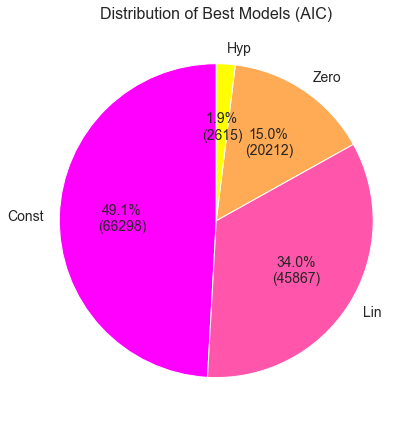

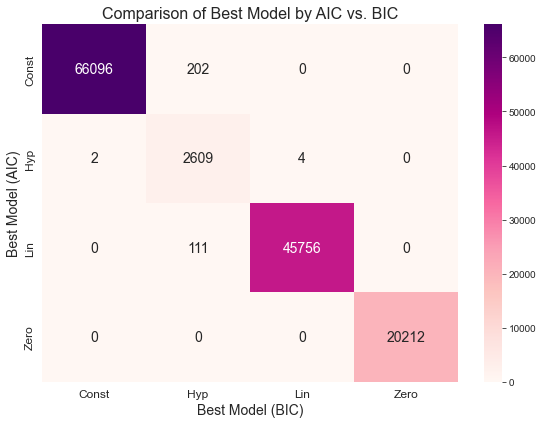

In [408]:
# Ploting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # For safely evaluating string representations of lists if needed

if model_comparison_results_df.empty:
    model_comparison_results_df = pd.read_excel(OUTPUT_DIR+"/"+OUTPUT_FILE[:-4]+"_kinetic_params.xlsx", index_col=0) # Example
# For demonstration, we use the sample DF
print(f"DataFrame loaded with {len(model_comparison_results_df)} rows.")

# --- Set up plotting style ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['savefig.dpi'] = 150

# --- Helper function to handle log scale for histograms/KDEs ---

# --- 1. Overall Model Distribution ---
print("\n--- Generating Model Distribution Plots ---")
plt.figure()
counts = model_comparison_results_df['Best_Model_AIC'].value_counts()
counts.plot(kind='pie', 
            autopct=lambda pct: f'{pct:.1f}%\n({int(round(pct/100.*counts.sum()))})',
            startangle=90,
            wedgeprops=dict(width=1, edgecolor='w'),
            colormap="spring",
            textprops={'fontsize': 14})

plt.title('Distribution of Best Models (AIC)', fontsize=16)
plt.ylabel('') # Hide the default 'Best_Model_AIC' ylabel
plt.tight_layout()
plt.savefig(OUTPUT_DIR+"/"+"best_model_aic_pie.png")
# plt.show()


plt.figure()
counts = model_comparison_results_df['Best_Model_BIC'].value_counts()
counts.plot(kind='pie', 
            autopct=lambda pct: f'{pct:.1f}%\n({int(round(pct/100.*counts.sum()))})',
            startangle=90,
            wedgeprops=dict(width=1, edgecolor='w'),
            colormap="spring",
            textprops={'fontsize': 14})
plt.title('Distribution of Best Models (BIC)', fontsize=16)
plt.ylabel('') # Hide the default 'Best_Model_AIC' ylabel
plt.tight_layout()
plt.savefig(OUTPUT_DIR+"/"+"best_model_bic_pie.png")
# plt.show()



# Cross-tabulation of AIC vs BIC best models
try:
    cross_tab = pd.crosstab(model_comparison_results_df['Best_Model_AIC'], model_comparison_results_df['Best_Model_BIC'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross_tab, annot=True, fmt="d", cmap="RdPu",annot_kws={"size": 14})
    plt.title('Comparison of Best Model by AIC vs. BIC', fontsize=16)
    plt.xlabel('Best Model (BIC)', fontsize=14)
    plt.ylabel('Best Model (AIC)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+"/"+"aic_vs_bic_heatmap.png")
    # plt.show()
except Exception as e:
    print(f"Could not generate AIC vs BIC heatmap: {e}")
plt.show() # This will show all figures created that haven't been closed.




--- Generating Model Occurrence Plots ---

--- Plot generation complete. ---


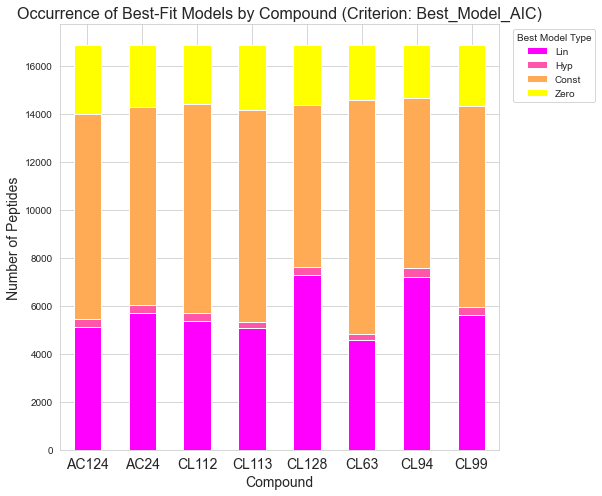

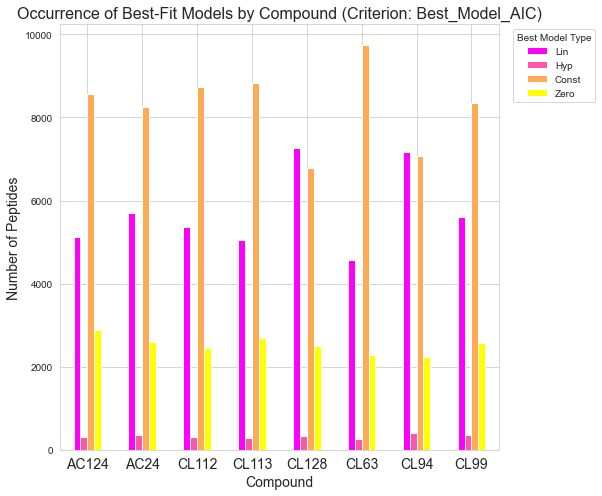

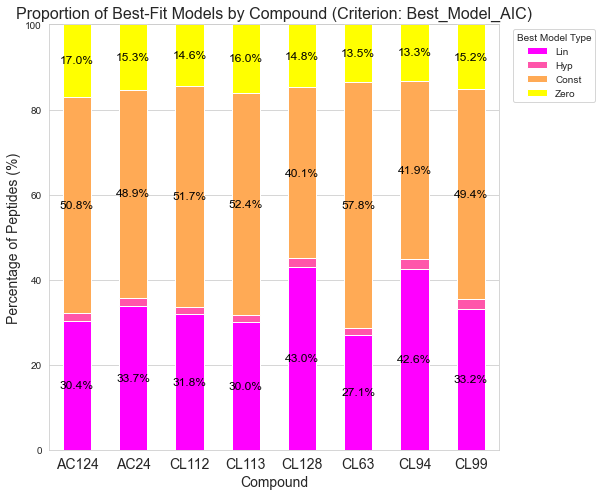

In [409]:
sns.set_style("whitegrid") 


# --- NEW FUNCTION: Plot Model Occurrence by Compound ---
def plot_model_occurrence_by_compound(df_results, 
                                      compound_col='Compound', 
                                      best_model_col='Best_Model_AIC',
                                      plot_type='stacked_bar'): # 'stacked_bar' or 'grouped_bar' or 'percentage_stacked_bar'
    """
    Generates a bar chart showing the occurrence of best-fit models
    (Linear, Hyperbolic, Constant) for each compound.
    """
    if df_results.empty or compound_col not in df_results.columns or best_model_col not in df_results.columns:
        print(f"DataFrame is empty or missing required columns ('{compound_col}', '{best_model_col}'). Skipping model occurrence plot.")
        return

    # Count occurrences of each best model for each compound
    # We also count 'Fit_Failed' or other categories if present in best_model_col
    model_counts = df_results.groupby([compound_col, best_model_col]).size().unstack(fill_value=0)
    
    # Ensure all expected model types are present as columns, even if count is 0
    expected_models = ['Lin', 'Hyp', 'Const'] # Add any other categories from best_model_col
    for model in expected_models:
        if model not in model_counts.columns:
            model_counts[model] = 0
    
    # Reorder columns for consistent plotting (e.g., specific models first, then Fit_Failed)
    plot_order = [model for model in ['Lin', 'Hyp', 'Const'] if model in model_counts.columns]
    if 'Fit_Failed' in model_counts.columns: # Keep Fit_Failed if it exists
        plot_order.append('Fit_Failed')
    # Add any other unexpected model categories at the end
    other_models = [col for col in model_counts.columns if col not in plot_order]
    plot_order.extend(other_models)
    
    model_counts = model_counts[plot_order]

    if model_counts.empty:
        print("No data to plot for model occurrences.")
        return

    plt.figure(figsize=(max(10, len(model_counts.index) * 0.8), 7)) # Dynamic width

    if plot_type == 'stacked_bar':
        model_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='spring')
        plt.title(f'Occurrence of Best-Fit Models by Compound (Criterion: {best_model_col})', fontsize=16)
        plt.ylabel('Number of Peptides', fontsize=14)
    elif plot_type == 'grouped_bar':
        model_counts.plot(kind='bar', stacked=False, ax=plt.gca(), colormap='spring')
        plt.title(f'Occurrence of Best-Fit Models by Compound (Criterion: {best_model_col})', fontsize=16)
        plt.ylabel('Number of Peptides', fontsize=14)
    elif plot_type == 'percentage_stacked_bar':
        # Calculate percentages
        model_percentages = model_counts.apply(lambda x: x*100 / x.sum(), axis=1)
        model_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='spring')
        plt.title(f'Proportion of Best-Fit Models by Compound (Criterion: {best_model_col})', fontsize=16)
        plt.ylabel('Percentage of Peptides (%)', fontsize=14)
        plt.ylim(0, 100) # Ensure y-axis goes to 100%
        # Add percentage labels on bars (can be complex for stacked bars)
        for i, (index, row) in enumerate(model_percentages.iterrows()):
            cumulative_sum = 0
            for col_name in model_percentages.columns:
                value = row[col_name]
                if value > 5: # Only label significant segments
                    plt.text(i, cumulative_sum + value / 2, f'{value:.1f}%', 
                             ha='center', va='center', color='black', fontsize=12,
                             #path_effects=[PathEffects.withStroke(linewidth=3, foreground='black')]
                             )
                cumulative_sum += value
    else:
        print(f"Unknown plot_type: {plot_type}. Choose 'stacked_bar', 'grouped_bar', or 'percentage_stacked_bar'.")
        plt.close() # Close the empty figure
        return

    plt.xlabel('Compound', fontsize=14)
    plt.xticks(rotation=0, ha='center', fontsize=14)
    plt.legend(title='Best Model Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust for legend
    plt.savefig(OUTPUT_DIR+f"/model_occurrence_by_compound_{plot_type}.png", dpi=150, bbox_inches='tight')

# --- Example Calls for the new plot function ---
print("\n--- Generating Model Occurrence Plots ---")
if 'model_comparison_results_df' in locals() and not model_comparison_results_df.empty:
    # Stacked Bar Chart (Counts)
    plot_model_occurrence_by_compound(model_comparison_results_df, 
                                      best_model_col='Best_Model_AIC', 
                                      plot_type='stacked_bar')
    
    # Grouped Bar Chart (Counts)
    plot_model_occurrence_by_compound(model_comparison_results_df, 
                                      best_model_col='Best_Model_AIC', 
                                      plot_type='grouped_bar')

    # Percentage Stacked Bar Chart
    plot_model_occurrence_by_compound(model_comparison_results_df, 
                                      best_model_col='Best_Model_AIC', 
                                      plot_type='percentage_stacked_bar')
else:
    print("model_comparison_results_df not available or empty. Skipping model occurrence plots.")


# --- (Other plotting sections from your script would continue here) ---
# ... (e.g., plot_peptide_kinetic_scatter calls) ...

print("\n--- Plot generation complete. ---")
plt.show() # Display all generated figures


--- Generating Final Interpreted Kinetic Parameter Plots ---
Length: 190784
max: 79.4147318370895
min: 0.0

--- Generating Boxplot for DBIA Ratio CVs (by Compound and Concentration) ---


C:\Users\WANGLA~1\AppData\Local\Temp/ipykernel_16096/441449349.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_data_exploded, x='Compound_Concentration', y=cv_column,


Length: 68913
max: 0.0013031787795315017
min: 3.473959336170595e-08
Length: 48482
max: 26.955394781317896
min: 0.0011979170930238377
Length: 2615
max: 0.000416534359775329
min: 3.218585315759968e-05


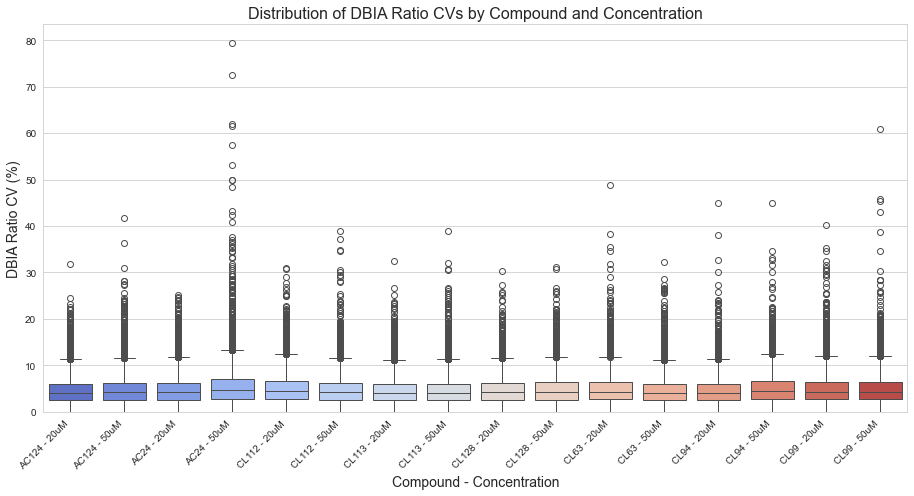

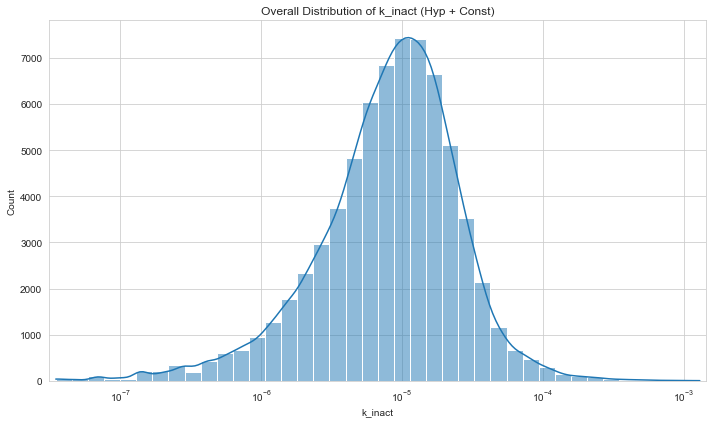

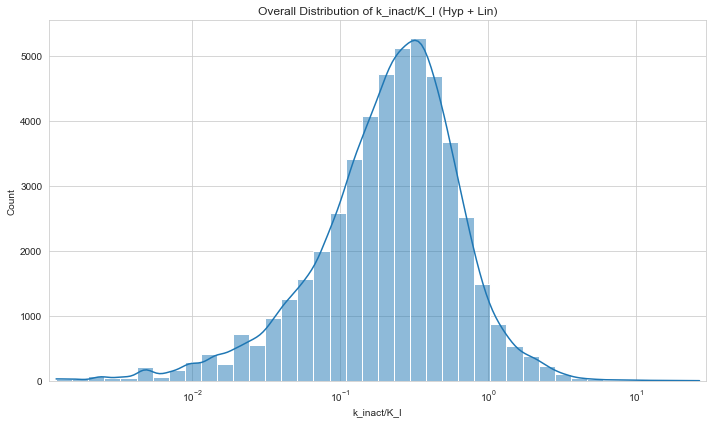

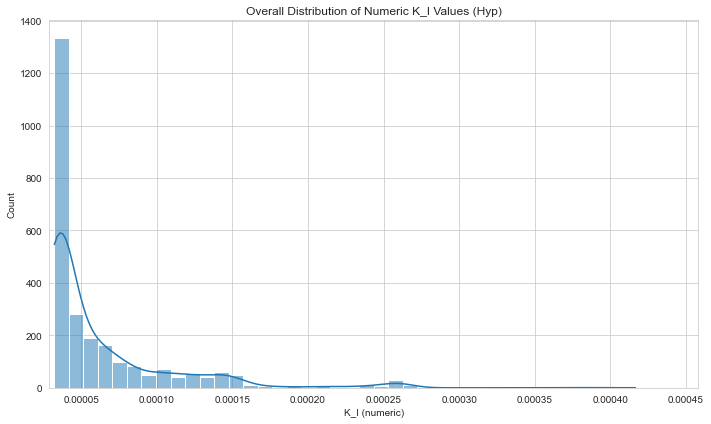

In [370]:
# --- 3. Distribution of Final Interpreted Kinetic Parameters ---
def plot_distribution(data, title, xlabel, log_scale=False, bins=40):
    plt.figure()
    valid_data = data.dropna()
    if valid_data.empty:
        print(f"No data to plot for {title}.")
        plt.text(0.5, 0.5, 'No data available', ha='center', va='center')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frequency")
        return
    
    if log_scale:
        valid_data = valid_data[valid_data > 0]  # Log scale only for positive values
        if valid_data.empty:
            print(f"No positive data to plot for {title} on log scale.")
            plt.text(0.5, 0.5, 'No positive data for log scale', ha='center', va='center')
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel("Frequency")
            return

        min_val_for_plot = valid_data.min()
        max_val_for_plot = valid_data.max()
        print("Length:", len(valid_data))
        print("max:", max_val_for_plot)
        print("min:", min_val_for_plot)

        #if max_val_for_plot / min_val_for_plot > 1000 and len(valid_data) > 1:
        #    bins = np.logspace(np.log10(min_val_for_plot), np.log10(max_val_for_plot), bins)
        #    print(bins)

        sns.histplot(valid_data, kde=True, bins=bins, log_scale=True)

        plt.xlim(min_val_for_plot*0.9, max_val_for_plot*1.1)
    else:
        min_val_for_plot = valid_data.min()
        max_val_for_plot = valid_data.max()
        print("Length:", len(valid_data))
        print("max:", max_val_for_plot)
        print("min:", min_val_for_plot)

        sns.histplot(valid_data, kde=True, bins=bins)
        plt.xlim(min_val_for_plot*0.9, max_val_for_plot*1.1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+"/"+f"{title.replace(' ', '_').replace('/', '_')}.png", dpi=150)

    # plt.show() # In a script, you might save or show plots one by one

def parse_list_str(s):
    if isinstance(s, str):
        # Replace unquoted nan with np.nan
        s_clean = re.sub(r'\bnan\b', 'np.nan', s)
        try:
            return eval(s_clean, {"np": np})  # Only allow access to numpy
        except Exception:
            return None
    return s
def plot_dbia_ratios_cv_boxplot(df_summary, 
                                cv_column='DBIA_Ratios_CV', 
                                compound_column='Compound',
                                concentration_column='Concentration_M'): # Added concentration_column
    """
    Generates a boxplot of DBIA_Ratios_CV for each compound-concentration combination.
    Handles cv_column containing numbers, strings of numbers, or strings of lists of numbers.
    """
    required_cols = [compound_column, concentration_column, cv_column]
    if df_summary.empty or not all(col in df_summary.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_summary.columns]
        print(f"DataFrame is empty or missing required columns: {missing}. Skipping CV boxplot.")
        return

    plot_data = df_summary[required_cols].copy()

    def parse_cv_cell_value(value):
        if isinstance(value, (int, float)): 
            return value
        if isinstance(value, list): 
            numeric_list = []
            for x in value:
                try: numeric_list.append(float(x))
                except (ValueError, TypeError): pass
            return numeric_list if numeric_list else np.nan
        if isinstance(value, str) and value.strip(): 
            try:
                evaluated = ast.literal_eval(value)
                if isinstance(evaluated, (int, float)):
                    return float(evaluated)
                if isinstance(evaluated, list):
                    numeric_list = []
                    for x in evaluated:
                        try: numeric_list.append(float(x))
                        except (ValueError, TypeError): pass
                    return numeric_list if numeric_list else np.nan
            except (ValueError, SyntaxError, TypeError):
                try:
                    return float(value)
                except ValueError:
                    return np.nan 
        return np.nan 

    plot_data[cv_column] = plot_data[cv_column].apply(parse_cv_cell_value)
    plot_data.dropna(subset=[cv_column], inplace=True)
    
    plot_data_exploded = plot_data.explode(cv_column)
    
    plot_data_exploded[cv_column] = pd.to_numeric(plot_data_exploded[cv_column], errors='coerce')
    plot_data_exploded.dropna(subset=[cv_column], inplace=True)

    if plot_data_exploded.empty:
        print(f"No valid numeric data for '{cv_column}' to plot after parsing and exploding. Skipping CV boxplot.")
        return

    # Create a combined category for the x-axis
    # Formatting concentration for better readability in labels (e.g., 1e-5 -> "10uM")
    def format_conc(c):
        if c >= 1e-3: return f"{c*1e3:.0f}mM"
        if c >= 1e-6: return f"{c*1e6:.0f}uM"
        if c >= 1e-9: return f"{c*1e9:.0f}nM"
        return f"{c:.1e}M" # Fallback to scientific for very small/large

    plot_data_exploded['Compound_Concentration'] = plot_data_exploded[compound_column] + " - " + \
                                                 plot_data_exploded[concentration_column].apply(format_conc)

    plt.figure(figsize=(max(12, plot_data_exploded['Compound_Concentration'].nunique() * 0.8), 7)) # Dynamic width
    
    # Order the x-axis categories: sort by compound, then by original concentration value
    plot_data_exploded.sort_values(by=[compound_column, concentration_column], inplace=True)
    x_order = plot_data_exploded['Compound_Concentration'].unique()
    
    ax = sns.boxplot(data=plot_data_exploded, x='Compound_Concentration', y=cv_column, 
                     order=x_order, palette="coolwarm")
    
    # Optional: Overlay a stripplot for individual data points if desired (can be dense)
    # sns.stripplot(data=plot_data_exploded, x='Compound_Concentration', y=cv_column, order=x_order,
    #               color='black', size=2, jitter=0.2, alpha=0.2, ax=ax)

    plt.title('Distribution of DBIA Ratio CVs by Compound and Concentration', fontsize=16)
    plt.xlabel('Compound - Concentration', fontsize=14)
    plt.ylabel('DBIA Ratio CV (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # Example: Set y-limit if CVs are typically bounded (e.g., 0-100%)
    current_ylim = ax.get_ylim()
    desirable_max_y = 100 # Example: if CVs are percentages typically under 100
    ax.set_ylim(0, min(current_ylim[1] if current_ylim[1] > 0 else desirable_max_y, desirable_max_y))


    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+"/"+"CV_of_DBIA_Ratios_by_compound_concentration_boxplot.png", dpi=150)

# Apply to the column
cv_nested = model_comparison_results_df['DBIA_Ratios_CVs'].apply(parse_list_str)

cv_flat = [item for sublist in cv_nested for item in sublist]
cv_flat = pd.DataFrame(cv_flat, columns=['DBIA_Ratio_CV'])



print("\n--- Generating Final Interpreted Kinetic Parameter Plots ---")
plot_distribution(cv_flat['DBIA_Ratio_CV'],'CV of DBIA_Ratio for all compounds and concentrations', "CV values",log_scale=False)

# --- Call the plotting function ---
print("\n--- Generating Boxplot for DBIA Ratio CVs (by Compound and Concentration) ---")
# Ensure your actual k_obs_summary_df is passed here
plot_dbia_ratios_cv_boxplot(k_obs_summary_df)

plot_distribution(model_comparison_results_df['k_inact'], 'Overall Distribution of k_inact (Hyp + Const)', 'k_inact', log_scale=True)
plot_distribution(model_comparison_results_df['k_inact_over_K_I'], 'Overall Distribution of k_inact/K_I (Hyp + Lin)', 'k_inact/K_I', log_scale=True)

# Special handling for K_I column (mixed types)
ki_numeric = pd.to_numeric(model_comparison_results_df['K_I'], errors='coerce').dropna()
if not ki_numeric.empty:
    plot_distribution(ki_numeric, 'Overall Distribution of Numeric K_I Values (Hyp)', 'K_I (numeric)', log_scale=False)
plt.show() # This will show all figures created that haven't been closed.





--- Generating Scatter Plots of Kinetic Parameters (Peptides on X-axis, Grouped by Compound) ---


c:\ProgramData\Anaconda3\lib\site-packages\adjustText\__init__.py:356: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  ax.figure.draw_without_rendering()
C:\Users\WANGLA~1\AppData\Local\Temp/ipykernel_16096/783014728.py:126: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  plt.savefig(OUTPUT_DIR+"/"+f"{plot_title.replace(' ', '_').replace('/', '_')}.png", bbox_inches='tight')
c:\ProgramData\Anaconda3\lib\site-packages\adjustText\__init__.py:356: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  ax.figure.draw_without_rendering()
C:\Users\WANGLA~1\AppData\Local\Temp/ipykernel_16096/783014728.py:126: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  plt.savefig(OUTPUT_DIR+"/"+f"{plot_title.replace(' ', '_').replace('/', '_')}.png", bbox_inches='tight')



--- Scatter plot generation complete. ---


c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


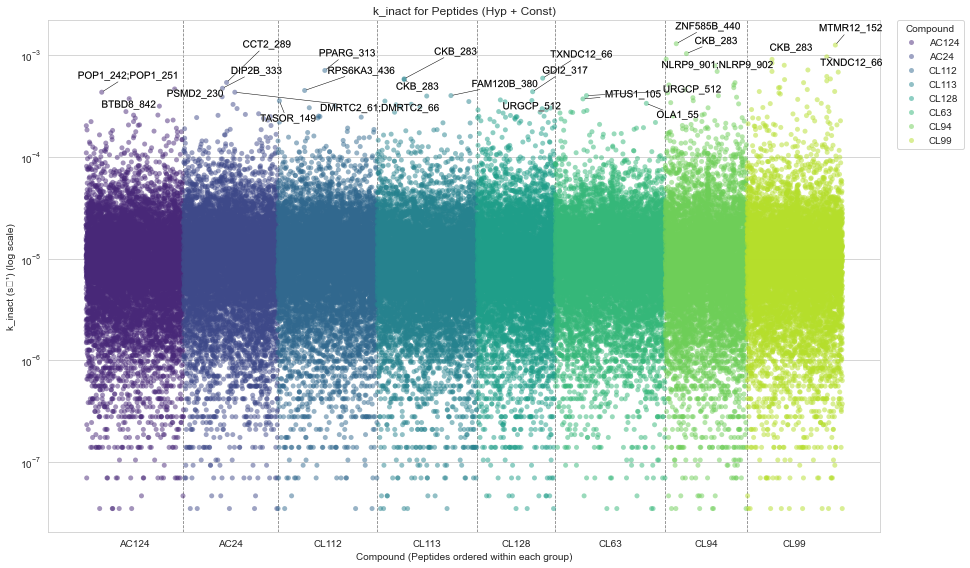

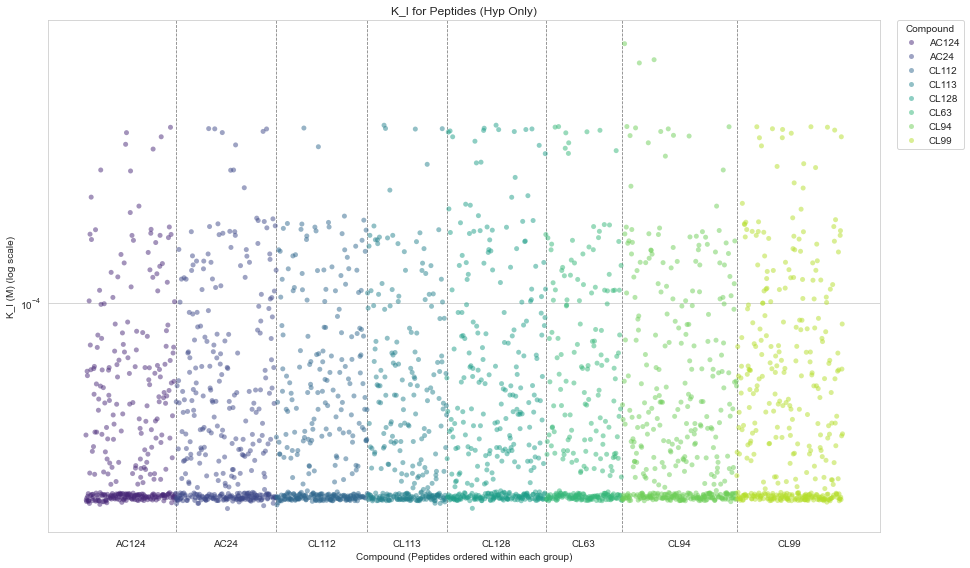

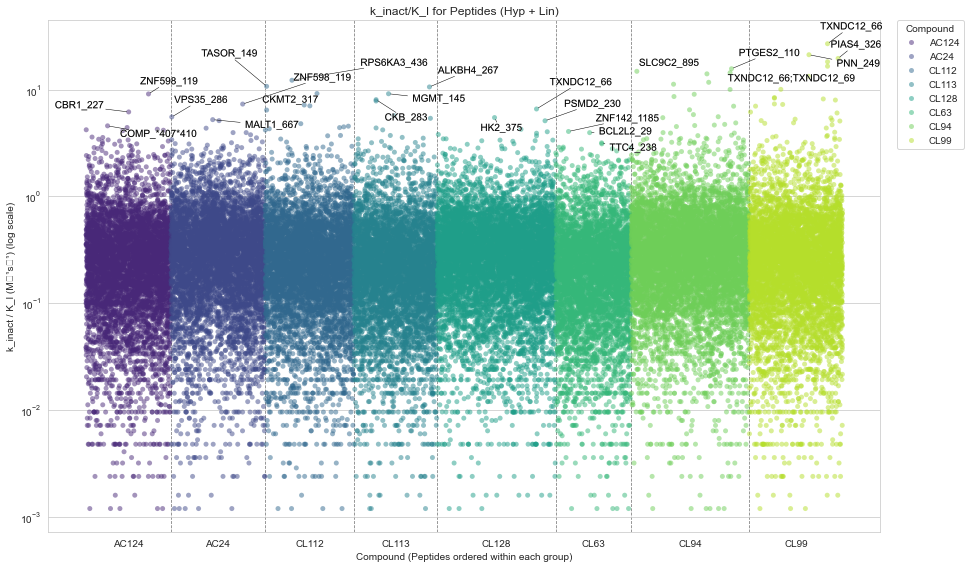

In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # For safely evaluating string representations of lists if needed
import matplotlib.patheffects as PathEffects # For text readability
from adjustText import adjust_text # Import the adjust_text library

sns.set_style("whitegrid")

# --- Scatter Plots of Kinetic Parameters (Revised Approach) ---
print("\n--- Generating Scatter Plots of Kinetic Parameters (Peptides on X-axis, Grouped by Compound) ---")

def plot_peptide_kinetic_scatter(df, y_col, y_label, plot_title, 
                                 log_y=True, y_ticks=None, y_tick_labels=None, 
                                 annotation_col="gene_DBIA", 
                                 peptide_id_col='Peptide_ID', compound_col='Compound'):
    """
    Generates a scatter plot for a given kinetic parameter.
    X-axis represents individual peptides, ordered and grouped by compound.
    Y-axis is the kinetic parameter. Points colored by compound.
    Annotates top 3 points per compound if annotation_col is provided.
    """
    plt.figure(figsize=(16, 8)) # Wider figure
    
    cols_to_select = list(set([peptide_id_col, compound_col, y_col]))
    if annotation_col and annotation_col not in cols_to_select:
        cols_to_select.append(annotation_col)
    
    missing_cols = [col for col in cols_to_select if col not in df.columns]
    if missing_cols:
        print(f"Warning: Columns {missing_cols} not found. Skipping plot: {plot_title}")
        plt.close(); return
        
    plot_data = df[cols_to_select].copy()
    plot_data[y_col] = pd.to_numeric(plot_data[y_col], errors='coerce')
    plot_data.dropna(subset=[y_col], inplace=True)

    if log_y:
        plot_data = plot_data[plot_data[y_col] > 0] 

    if plot_data.empty:
        print(f"No valid data for {plot_title}."); plt.close(); return

    # Sort data for consistent plotting order and group calculations
    plot_data.sort_values(by=[compound_col, peptide_id_col], inplace=True)
    plot_data.reset_index(drop=True, inplace=True) # Ensure index is 0, 1, 2...
    plot_data['plot_x_position'] = plot_data.index # Use the new sorted index as x-coordinate

    ax = sns.scatterplot(data=plot_data, x='plot_x_position', y=y_col, hue=compound_col,  edgecolor='none',
                         alpha=0.5, s=25, legend='auto', palette='viridis')
    ax.xaxis.grid(False) # Turn off vertical grid lines

    if log_y:
        ax.set_yscale('log')
        plt.ylabel(f"{y_label} (log scale)")
    else:
        plt.ylabel(y_label)
    
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
        if y_tick_labels is not None:
            if len(y_ticks) == len(y_tick_labels): ax.set_yticklabels(y_tick_labels)
            else: print(f"Warning for '{plot_title}': y_ticks/y_tick_labels length mismatch.")
    
    plt.title(plot_title)
    
    # --- X-axis Ticks and Labels for Compound Groups ---
    compound_group_boundaries = plot_data.groupby(compound_col)['plot_x_position'].agg(['min', 'max'])
    tick_positions = []
    tick_labels = []
    
    for compound_name, boundaries in compound_group_boundaries.iterrows():
        min_idx, max_idx = boundaries['min'], boundaries['max']
        tick_positions.append((min_idx + max_idx) / 2) # Midpoint for label
        tick_labels.append(compound_name)
        if min_idx > 0: # Draw line before this group if not the first group
            ax.axvline(min_idx - 0.5, color='grey', linestyle='--', linewidth=0.8, zorder=0)
            
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0, ha='center')
    plt.xlabel(f"Compound (Peptides ordered within each group)")

    # --- Annotations ---
    if annotation_col and annotation_col in plot_data.columns:
        texts_to_adjust = [] 
        target_x_for_adjust = []
        target_y_for_adjust = []

        for compound_name, group_data in plot_data.groupby(compound_col):
            top_3_this_category = group_data.nlargest(3, y_col)
            for _, row_data in top_3_this_category.iterrows():
                x_val = row_data['plot_x_position'] # Actual x-position of the point
                y_val = row_data[y_col]
                annot_text = row_data[annotation_col]

                if pd.notna(y_val) and pd.notna(annot_text):
                    text_obj = ax.text(x_val, y_val, f" {annot_text}", 
                                       fontsize=10, color='black', ha='left', va='bottom',
                                       path_effects=[PathEffects.withStroke(linewidth=0.7, foreground='white', alpha=0.8)])
                    texts_to_adjust.append(text_obj)
                    target_x_for_adjust.append(x_val)
                    target_y_for_adjust.append(y_val)
        
        if texts_to_adjust:
            adjust_text(texts_to_adjust,
                        force_text=(0.5,1),force_static =(1,2),arrowprops=dict(arrowstyle="-", color='black', lw=0.5))


    num_unique_compounds = plot_data[compound_col].nunique()
    if num_unique_compounds > 0:
        handles, legend_labels = ax.get_legend_handles_labels()
        if num_unique_compounds > 5:
            ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., title=compound_col)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
        elif handles:
            ax.legend(handles, legend_labels, title=compound_col)
            plt.tight_layout()
        else:
            if ax.get_legend() is not None: ax.get_legend().remove()
            plt.tight_layout()
    else:
        if ax.get_legend() is not None: ax.get_legend().remove()
        plt.tight_layout()
    
    plt.savefig(OUTPUT_DIR+"/"+f"{plot_title.replace(' ', '_').replace('/', '_')}.png", bbox_inches='tight')


# --- Example Calls ---
if 'k_inact' in model_comparison_results_df.columns:
    plot_peptide_kinetic_scatter(model_comparison_results_df, 
                                 y_col='k_inact', y_label='k_inact (s⁻¹)', 
                                 plot_title='k_inact for Peptides (Hyp + Const)',
                                 annotation_col='gene_DBIA')

if 'K_I' in model_comparison_results_df.columns:
    plot_peptide_kinetic_scatter(model_comparison_results_df, 
                                 y_col='K_I', y_label='K_I (M)', 
                                 plot_title='K_I for Peptides (Hyp Only)',
                                 annotation_col=None)

if 'k_inact_over_K_I' in model_comparison_results_df.columns:
    plot_peptide_kinetic_scatter(model_comparison_results_df, 
                                 y_col='k_inact_over_K_I', y_label='k_inact / K_I (M⁻¹s⁻¹)', 
                                 plot_title='k_inact/K_I for Peptides (Hyp + Lin)',
                                 annotation_col='gene_DBIA')

print("\n--- Scatter plot generation complete. ---")
plt.show()



--- Generating Data and Fit Quality Plots ---
Length: 134992
max: 8
min: 2
No fit error data to plot.


C:\Users\WANGLA~1\AppData\Local\Temp/ipykernel_16096/2172868184.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('spring', 3)  # or any other, like 'spring', 'coolwarm'



--- Plot generation script complete. ---


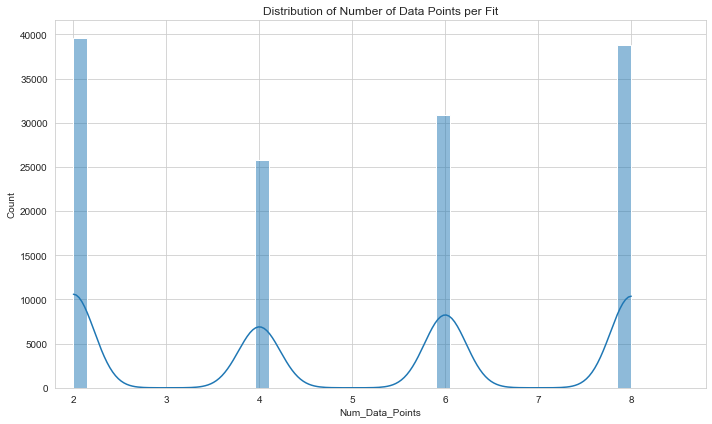

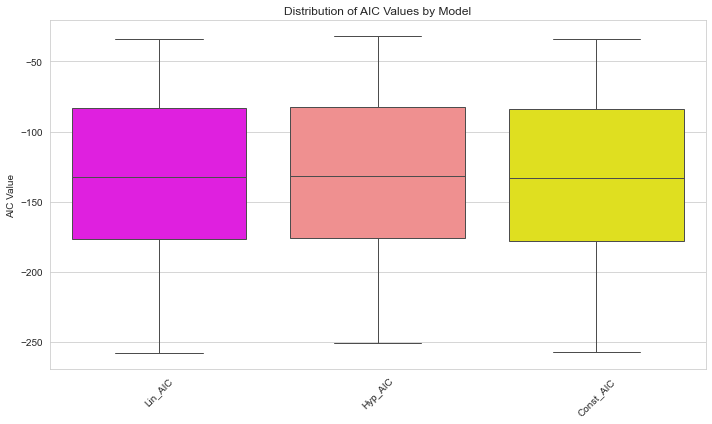

In [413]:
# --- 4. Data and Fit Quality Insights ---
print("\n--- Generating Data and Fit Quality Plots ---")
plot_distribution(model_comparison_results_df['Num_Data_Points'], 'Distribution of Number of Data Points per Fit', 'Num_Data_Points')

fit_errors = {}
for model_prefix in ['Lin', 'Hyp', 'Const']:
    error_col = f'{model_prefix}_Fit_Error'
    if error_col in model_comparison_results_df.columns:
        fit_errors[model_prefix] = model_comparison_results_df[error_col].value_counts()

if fit_errors:
    df_fit_errors = pd.DataFrame(fit_errors).fillna(0)
    if not df_fit_errors.empty:
        df_fit_errors.plot(kind='bar', stacked=False)
        plt.title('Counts of Fitting Errors by Model Type')
        plt.xlabel('Error Type / Status (None means success)')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR+"/"+'Counts of Fitting Errors by Model Type')
        # plt.show()
    else:
        print("No fit error data to plot.")
else:
    print("Fit error columns not found.")


# Box plots of AIC/BIC values
import matplotlib.cm as cm
import matplotlib.colors as mcolors
cmap = cm.get_cmap('spring', 3)  # or any other, like 'spring', 'coolwarm'
colors = [mcolors.to_hex(cmap(i)) for i in range(3)]

# Create a mapping: column name → color
aic_cols = [col for col in model_comparison_results_df.columns if 'AIC' in col and 'Best' not in col]
palette = dict(zip(aic_cols, colors))
if aic_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=model_comparison_results_df[aic_cols], palette=palette)
    plt.title('Distribution of AIC Values by Model')
    plt.ylabel('AIC Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+"/"+'Distribution of AIC Values by Model')
    #plt.show()
else:
    print("AIC columns for models not found.")

bic_cols = [col for col in model_comparison_results_df.columns if 'BIC' in col and 'Best' not in col]
palette = dict(zip(bic_cols, colors))
if bic_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=model_comparison_results_df[bic_cols],palette=palette)
    plt.title('Distribution of BIC Values by Model')
    plt.ylabel('BIC Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+"/"+'Distribution of BIC Values by Model')
    #plt.show()
else:
    print("BIC columns for models not found.")


# --- Final message ---
print("\n--- Plot generation script complete. ---")


# To show all plots at the end if running interactively (outside of a loop that shows them one by one)
plt.show() # This will show all figures created that haven't been closed.


Fitted parameters:
  Linear model y = ax; a = [11.45840924]
  Hyperbolic model y = ax/(b+x); a, b = [9.05802567e-04 3.49516197e-05]
  Constant model y = a ; a = [0.00043153]

RSS:
  Linear:     3.196093493335156e-08
  Hyperbolic: 8.010136245628038e-09
  Constant:   4.860578766504985e-08

AIC:
  Linear:     -72.58
  Hyperbolic: -76.12
  Constant:   -70.90

BIC:
  Linear:     -73.19
  Hyperbolic: -77.34
  Constant:   -71.52


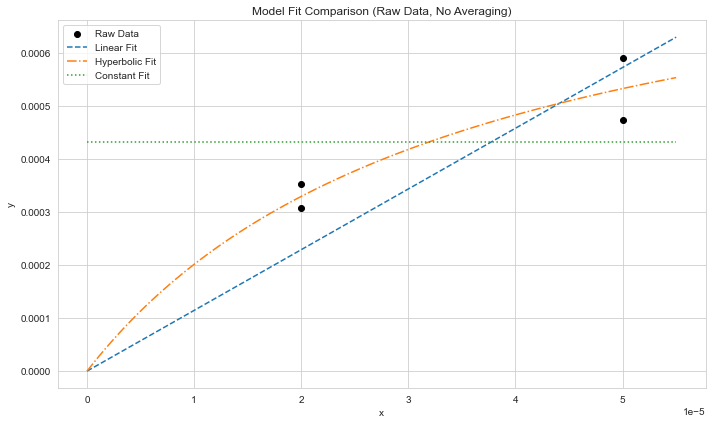

In [373]:
# Model selector calculator

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Raw data
x_raw = np.array([2e-5, 2e-5, 5e-5, 5e-5])
y_raw = np.array([0.00035360157661469094, 0.00030796184014489196, 0.0005912866071862799, 0.0004732634977514838])

# 1. Omit (0, 0)
mask = ~((x_raw == 0) & (y_raw == 0))
x = x_raw[mask]
y = y_raw[mask]

# 2. Models
def linear_model(x, a):
    return a * x

def hyperbolic_model(x, a, b):
    return a * x / (b + x)

def constant_model(x, a):
    return a * np.ones_like(x)

# 3. Fit models
popt_lin, _ = curve_fit(linear_model, x, y)
p0_hyp = [np.max(y) if n_points > 0 else 1.0, np.median(x) if n_points > 0 else np.mean(x) if n_points > 0 else 1.0]
popt_hyp, _ = curve_fit(hyperbolic_model, x, y,p0=p0_hyp, bounds=([0, 0], [np.inf, np.inf]), maxfev=10000)
popt_const, _ = curve_fit(constant_model, x, y)

# 4. Predictions
y_lin = linear_model(x, *popt_lin)
y_hyp = hyperbolic_model(x, *popt_hyp)
y_const = constant_model(x, *popt_const)

# 5. Residuals and RSS
rss_lin = np.sum((y - y_lin) ** 2)
rss_hyp = np.sum((y - y_hyp) ** 2)
rss_const = np.sum((y - y_const) ** 2)

# 6. AIC and BIC
def compute_aic(n, rss, k, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + 2 * k

def compute_bic(n, rss, k, eps=1e-18):
    rss = max(rss, eps)
    return n * np.log(rss / n) + k * np.log(n)

n = len(y)
aic_lin = compute_aic(n, rss_lin, k=1)
bic_lin = compute_bic(n, rss_lin, k=1)
aic_hyp = compute_aic(n, rss_hyp, k=2)
bic_hyp = compute_bic(n, rss_hyp, k=2)
aic_const = compute_aic(n, rss_const, k=1)
bic_const = compute_bic(n, rss_const, k=1)

# 7. Output
print("Fitted parameters:")
print("  Linear model y = ax; a =", popt_lin)
print("  Hyperbolic model y = ax/(b+x); a, b =", popt_hyp)
print("  Constant model y = a ; a =", popt_const)
print()
print("RSS:")
print(f"  Linear:     {rss_lin}")
print(f"  Hyperbolic: {rss_hyp}")
print(f"  Constant:   {rss_const}")
print()
print("AIC:")
print(f"  Linear:     {aic_lin:.2f}")
print(f"  Hyperbolic: {aic_hyp:.2f}")
print(f"  Constant:   {aic_const:.2f}")
print()
print("BIC:")
print(f"  Linear:     {bic_lin:.2f}")
print(f"  Hyperbolic: {bic_hyp:.2f}")
print(f"  Constant:   {bic_const:.2f}")

# 8. Plot
x_plot = np.linspace(0, max(x) * 1.1, 100)
plt.scatter(x, y, color='black', label='Raw Data')
plt.plot(x_plot, linear_model(x_plot, *popt_lin), '--', label='Linear Fit')
plt.plot(x_plot, hyperbolic_model(x_plot, *popt_hyp), '-.', label='Hyperbolic Fit')
plt.plot(x_plot, constant_model(x_plot, *popt_const), ':', label='Constant Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Fit Comparison (Raw Data, No Averaging)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
